# Imports

In [2]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import cv2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import shutil
import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [111]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def plot_graphs(ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all, agent_names, episode_count):
    # Calculate the mean and standard deviation of the rewards for each agent and all agents over all experiments
    ep_rewards_mean = {agent: np.mean(ep_rewards[agent], axis=0) for agent in agent_names}
    ep_rewards_std = {agent: np.std(ep_rewards[agent], axis=0) for agent in agent_names}
    ep_rewards_d_mean = {agent: np.mean(ep_rewards_d[agent], axis=0) for agent in agent_names}
    ep_rewards_d_std = {agent: np.std(ep_rewards_d[agent], axis=0) for agent in agent_names}
    ep_steps_mean = np.mean(ep_steps, axis=0)
    ep_steps_std = np.std(ep_steps, axis=0)
    ep_steps_d_mean = np.mean(ep_steps_d, axis=0)
    ep_steps_d_std = np.std(ep_steps_d, axis=0)
    ep_rewards_all_mean = np.mean(ep_rewards_all, axis=0)
    ep_rewards_all_std = np.std(ep_rewards_all, axis=0)
    ep_rewards_d_all_mean = np.mean(ep_rewards_d_all, axis=0)
    ep_rewards_d_all_std = np.std(ep_rewards_d_all, axis=0)

    # Plot the rewards (non-discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (non-discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    for agent in agent_names:
        plt.plot(ep_rewards_mean[agent], label=f"{agent} mean")
        plt.fill_between(np.arange(episode_count), ep_rewards_mean[agent] - ep_rewards_std[agent], ep_rewards_mean[agent] + ep_rewards_std[agent], alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (discounted) for each agent with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    for agent in agent_names:
        plt.plot(ep_rewards_d_mean[agent], label=f"{agent} mean")
        plt.fill_between(np.arange(episode_count), ep_rewards_d_mean[agent] - ep_rewards_d_std[agent], ep_rewards_d_mean[agent] + ep_rewards_d_std[agent], alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the steps for each agent with mean and standard deviation of the steps over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Steps for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.plot(ep_steps_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_steps_mean - ep_steps_std, ep_steps_mean + ep_steps_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the steps (discounted) for each agent with mean and standard deviation of the steps over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Steps (discounted) for each agent")
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.plot(ep_steps_d_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_steps_d_mean - ep_steps_d_std, ep_steps_d_mean + ep_steps_d_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (non-discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (non-discounted) for all agents")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(ep_rewards_all_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_all_mean - ep_rewards_all_std, ep_rewards_all_mean + ep_rewards_all_std, alpha=0.2)
    plt.legend()
    plt.show()

    # Plot the rewards (discounted) for all agents with mean and standard deviation of the rewards over all experiments all in one plot
    plt.figure(figsize=(10, 5))
    plt.title("Rewards (discounted) for all agents")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(ep_rewards_d_all_mean, label="mean")
    plt.fill_between(np.arange(episode_count), ep_rewards_d_all_mean - ep_rewards_d_all_std, ep_rewards_d_all_mean + ep_rewards_d_all_std, alpha=0.2)
    plt.legend()
    plt.show()

    # return ep_rewards_mean, ep_rewards_std, ep_rewards_d_mean, ep_rewards_d_std, ep_steps_mean, ep_steps_std, ep_steps_d_mean, ep_steps_d_std, ep_rewards_all_mean, ep_rewards_all_std, ep_rewards_d_all_mean, ep_rewards_d_all_std


## Space invaders environment

### Uniform random agent template (Using Parallel environments)

In [116]:
# function for a single uniform random experiment
def run_uniform(parallel_env, episode_count, gamma=0.999, render_mode="rgb_array", record_video=False, video_prefix=""):
    """
    Runs the parallel environment with the given hyperparameters and parameters.

    Args:
        parallel_env (parallel_api.ParallelEnv): Parallel environment to run.
        episode_count (int): Number of episodes to run the environment for.
        gamma (float): Discount factor for calculating discounted rewards.
        render_mode (str): Rendering mode for the environment.
        record_video (bool): Whether to record videos of the environment.
        video_prefix (str): Prefix for the video filenames.

    Returns:
        ep_rewards (dict): Dictionary of episode rewards for each agent.
        ep_rewards_d (dict): Dictionary of discounted episode rewards for each agent.
        ep_steps (np.ndarray): Array of episode steps for each episode.
        ep_rewards_all (np.ndarray): Array of episode rewards for all agents for each episode.
        ep_rewards_d_all (np.ndarray): Array of discounted episode rewards for all agents for each episode.
    """
 
    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf
    
    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        agent_states = parallel_env.reset(seed=seed)
        first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
        assert np.array_equal(first_0_state, second_0_state)

        terminations = [False]
        truncations = [False]

        if render_mode == "human":
            clock = pygame.time.Clock()

        video_writer = None
        if record_video and ep % 100 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{ep}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)

        # Run the environment until all agents have terminated or truncated
        while not all(terminations) and not all(truncations):
            if render_mode == "human":
                clock.tick(parallel_env.metadata["render_fps"])
            
            # Take an action for each agent
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
            agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
            assert np.array_equal(agent_states['first_0'], agent_states['second_0'])
            
            terminations = [terminations[a] for a in terminations]
            truncations = [truncations[a] for a in truncations]
            
            for agent in parallel_env.possible_agents:
                ep_rewards[agent][ep] += rewards[agent]
                ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])
            
            ep_rewards_all[ep] += sum(rewards.values())
            ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
            
            ep_steps[ep] += 1
            ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

            if record_video:
                frame = parallel_env.render()
                if record_video and ep % 100 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

        #store current episode reward by comparing to previous max
        if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
            max_reward = ep_rewards_all[ep]
            print(f"New max reward: {max_reward}")
            video_writer.release()
            #copy video to new path set below by max_reward using shutil
            video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_uni_max_reward_{int(max_reward)}.avi")
            print(f"Moving video to {video_path_new}")
            shutil.move(video_path, video_path_new)
                
    # Return the different rewards
    return ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


In [117]:
#hyperparameters
experiment_count = 1
episode_count = 100
gamma = 0.999 #discount factor
render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]

record_video = True #record video of the experiment every 100 episodes
game_name = "SpaceInvaders-v2" #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_uni = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_uni = np.zeros((experiment_count, episode_count))
ep_steps_d_uni = np.zeros((experiment_count, episode_count))
ep_rewards_all_uni = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_uni = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_'
    print("Experiment {}".format(i))
    #create the parallel environment
    parallel_env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    
    #run the experiment and store the rewards in the arrays
    ep_rewards_uni_all, ep_rewards_d_uni_all, ep_steps_uni[i], ep_steps_d_uni[i], ep_rewards_all_uni[i], ep_rewards_d_all_uni[i] = run_uniform(parallel_env, episode_count, gamma, render_mode, record_video, video_prefix)
    ep_rewards_uni['first_0'][i] = ep_rewards_uni_all['first_0']
    ep_rewards_uni['second_0'][i] = ep_rewards_uni_all['second_0']
    ep_rewards_d_uni['first_0'][i] = ep_rewards_d_uni_all['first_0']
    ep_rewards_d_uni['second_0'][i] = ep_rewards_d_uni_all['second_0']
    
    #close the parallel environment
    parallel_env.close()

# combine all rewards into one array
ep_rewards_uni_store = np.array([ep_rewards_uni, ep_rewards_d_uni, ep_steps_uni, ep_steps_d_uni, ep_rewards_all_uni, ep_rewards_d_all_uni])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_uni_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_uni_store)


Experiment 0


  0%|          | 0/100 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__uni_episode_0_gamma_0.999.avi


  1%|          | 1/100 [00:04<07:54,  4.79s/it]

New max reward: 1225.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__uni_max_reward_1225.avi


100%|██████████| 100/100 [02:41<00:00,  1.61s/it]
/tmp/ipykernel_25290/980552812.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_uni_store = np.array([ep_rewards_uni, ep_rewards_d_uni, ep_steps_uni, ep_steps_d_uni, ep_rewards_all_uni, ep_rewards_d_all_uni])


In [113]:
#print the rewards obtained in the arrays
print("Total rewards for each agent:")
print(ep_rewards_uni)
print("Total discounted rewards for each agent:")
print(ep_rewards_d_uni)
print("Total steps for all agents:")
print(ep_steps_uni)
print("Total discounted steps for all agents:")
print(ep_steps_d_uni)
print("Total reward for all agents:")
print(ep_rewards_all_uni)
print("Total discounted reward for all agents:")
print(ep_rewards_d_all_uni)

# High scores
# Print the highest rewards for each agent over all episodes in all experiments
print("High scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_uni[agent], axis=1)))
# Print the highest discounted rewards for each agent over all episodes in all experiments
print("High discounted scores:")
for agent in agent_names:
    print(agent, np.max(np.max(ep_rewards_d_uni[agent], axis=1)))
# Print the highest steps for all agent over all episodes in all experiments
print("Highest steps:")
print(np.max(np.max(ep_steps_uni, axis=1)))
# Print the highest discounted steps for all agent over all episodes in all experiments
print("Highest discounted steps:")
print(np.max(np.max(ep_steps_d_uni, axis=1)))
# Print the highest rewards for all agent over all episodes in all experiments
print("Highest rewards:")
print(np.max(np.max(ep_rewards_all_uni, axis=1)))
# Print the highest discounted rewards for all agent over all episodes in all experiments
print("Highest discounted rewards:")
print(np.max(np.max(ep_rewards_d_all_uni, axis=1)))



Total rewards for each agent:
{'first_0': array([[610., 410., 430., 510., 295., 105., 450., 450., 280., 310., 400.,
        735., 455.,  15., 415., 280., 200., 735., 455., 465., 455., 635.,
        555., 665., 520., 610., 710., 260., 675., 490., 435., 650., 765.,
        230., 265., 650., 440.,  30., 640., 580., 135., 630., 245., 430.,
        675., 615., 345., 625., 290., 435.,  20., 200., 510., 690., 475.,
        415., 520., 555., 430., 330.,  80., 270., 490., 445., 230.,  60.,
        665., 455., 630., 580., 455., 415., 435., 270., 105., 480.,  90.,
        290., 420., 505., 450., 455., 590., 450., 325., 445., 265., 425.,
         80., 415., 720., 475., 340., 120., 215., 535., 310., 515., 385.,
        460.,  90.]]), 'second_0': array([[310., 430., 305., 295., 590., 735., 250., 250., 450., 515., 200.,
        310., 250., 640., 250., 480., 400.,  90., 230., 610., 505., 320.,
        380.,  90., 325., 410., 135., 455., 440., 355., 270., 125., 275.,
        435., 530.,  65., 625., 660

### Calculations and plotting

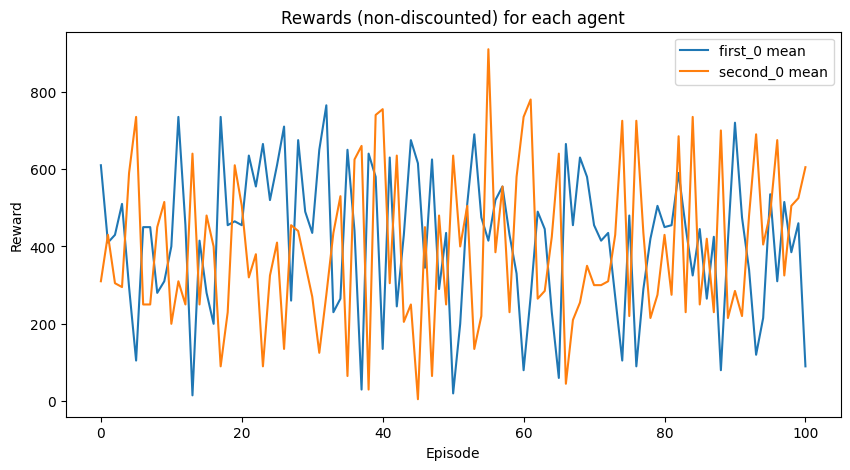

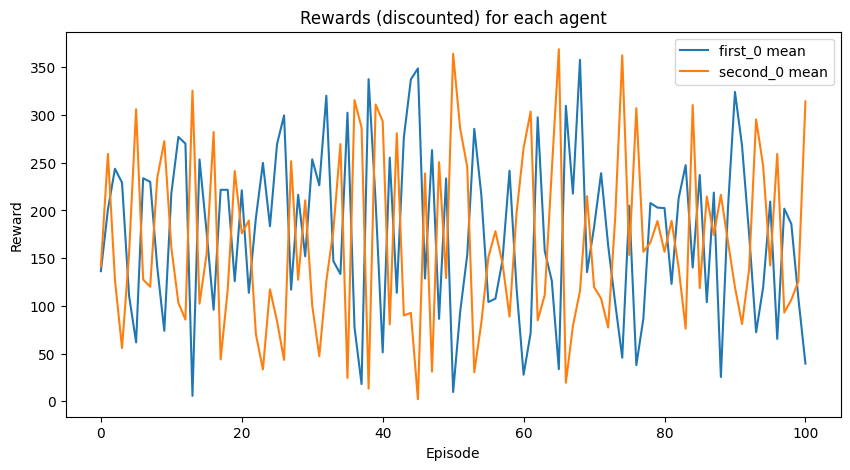

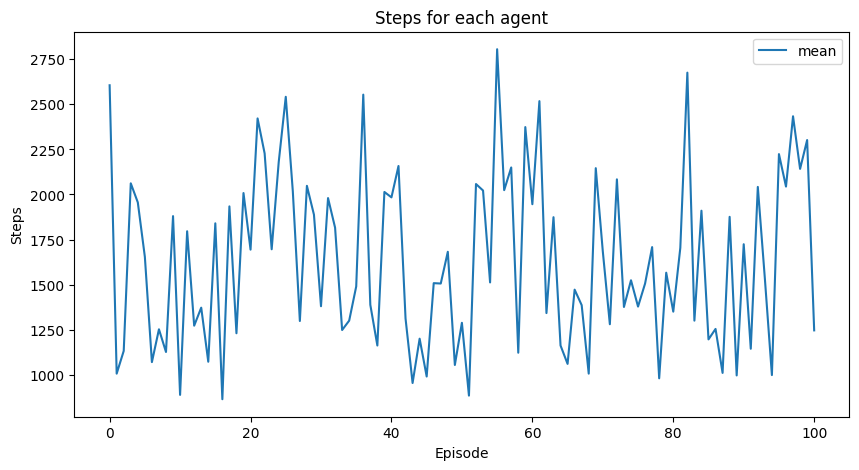

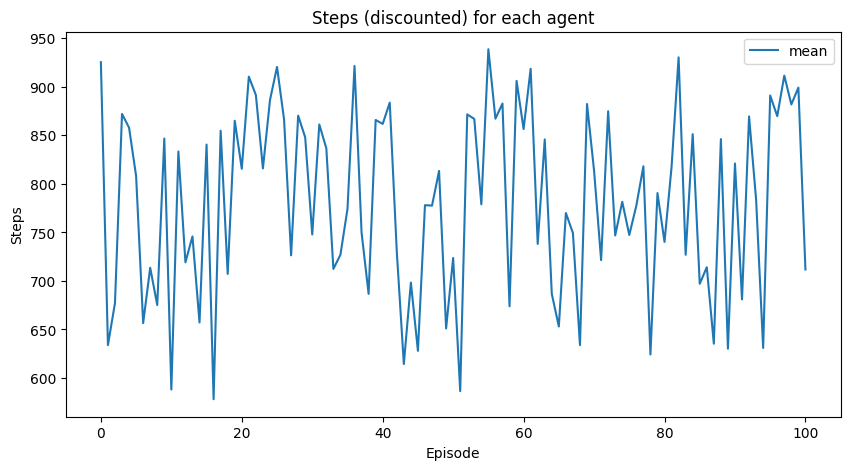

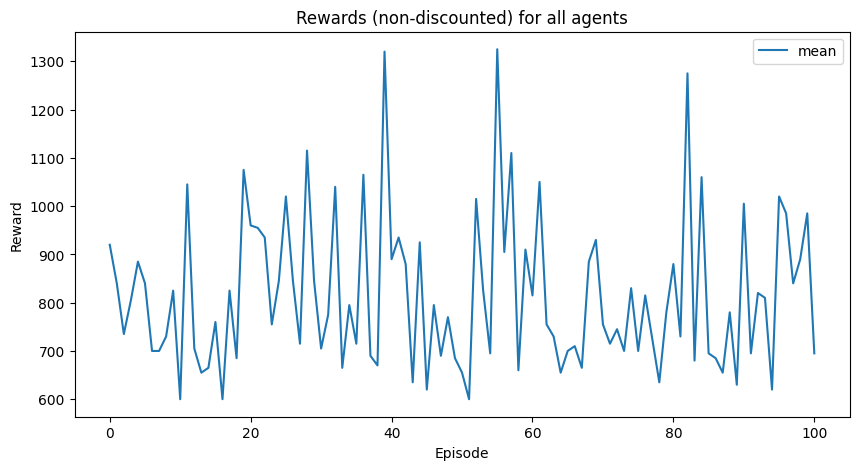

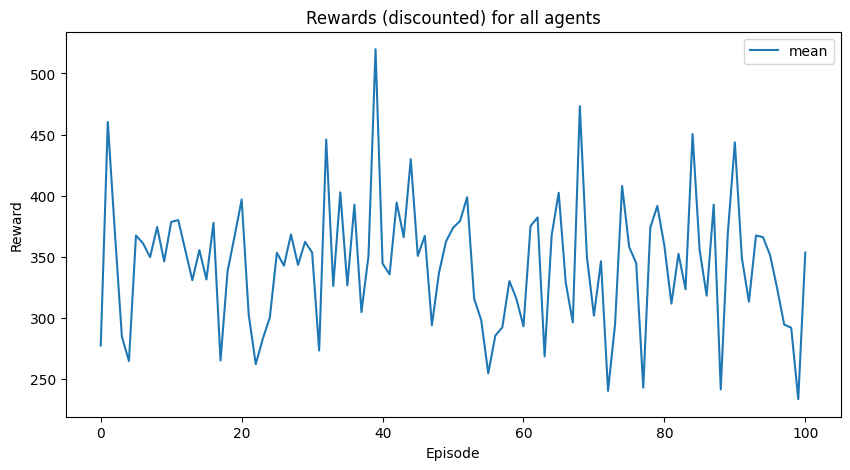

In [114]:
plot_graphs(ep_rewards_uni, ep_rewards_d_uni, ep_steps_uni, ep_steps_d_uni, ep_rewards_all_uni, ep_rewards_d_all_uni, agent_names, episode_count)

## A2C | PPO agents

In [99]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import color_reduction_v0, frame_stack_v1, resize_v1
from torch.distributions.categorical import Categorical
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class PPO_Agent(nn.Module):
    def __init__(self, num_actions, num_frames, effnet=False, pretrained=False):
        super().__init__()
        self.effnet = effnet
        self.pretrained = pretrained
        self.num_actions = num_actions
        self.num_frames = num_frames
        #use efficientnet as feature extractor
        if effnet:
            #load the pretrained efficientnet model
            if pretrained:
                self.effnet = efficientnet_v2_s(pretrained=True, weights=EfficientNet_V2_S_Weights.DEFAULT)
                self.effnet.classifier = nn.Identity()
            else:
                self.effnet = efficientnet_v2_s()
                self.effnet.classifier = nn.Identity() #remove the last layer of the network #could also use nn.ReLU()
            #replace the first layer of the network with a layer that converts the input to 3 channels
            self.network=nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 3, 3, padding=1)), #add a layer to convert the input to 3 channels
                self.effnet
            )
        #use a simple convolutional network as feature extractor
        else:
            self.network = nn.Sequential(
                self._layer_init(nn.Conv2d(num_frames, 32, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                self._layer_init(nn.Linear(128 * 8 * 8, 1280)),
                nn.ReLU(),
            )

        #actor and critic networks
        self.actor = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, 1))
        
        # #if color input is used normalize the input
        # self.transform = Compose(
        #     [
        #         ToTensor(),
        #         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ]
        # )


    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        # x = self.transform(x) #for color input
        return self.critic(self.network(x/133.0))

    def get_action_and_value(self, x, action=None):
        # x = self.transform(x) #for color input
        hidden = self.network(x / 133.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample() #sample an action from the distribution of the actor network
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # transpose to be (batch, channel, height, width)
    obs = obs.transpose(0, -1, 1, 2)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x



In [119]:
# function for a training single PPO experiment
def train_PPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)
    effnet = agent_network.effnet
    pretrained = agent_network.pretrained

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]
                
                # get action from the agents sharing the same network
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]
                
                _, newlogprob, entropy, value = agent_network.get_action_and_value(
                    b_obs[batch_index], b_actions.long()[batch_index]
                )
                logratio = newlogprob - b_logprobs[batch_index]
                ratio = logratio.exp()
                
                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clip_fracs += [
                        ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                    ]

                # normalize advantaegs
                advantages = b_advantages[batch_index]
                advantages = (advantages - advantages.mean()) / (
                    advantages.std() + 1e-8
                )

                # Policy loss
                pg_loss1 = -b_advantages[batch_index] * ratio
                pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                    ratio, 1 - clip_coef, 1 + clip_coef
                )
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Value loss
                value = value.flatten()
                v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                v_clipped = b_values[batch_index] + torch.clamp(
                    value - b_values[batch_index],
                    -clip_coef,
                    clip_coef,
                )
                
                v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss: {pg_loss.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all

def render_policy_PPO(env, agent_network, gamma, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()

    ep_rewards_all = np.zeros(episode_count)
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf 

    with torch.no_grad():
        for ep in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPO_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                actions, logprobs, _, values = agent_network.get_action_and_value(obs)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            #store current episode reward by comparing to previous max
            if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
                max_reward = ep_rewards_all[ep]
                print(f"New max reward: {max_reward}")
                video_writer.release()
                #copy video to new path set below by max_reward using shutil
                video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_PPO_test_max_reward_{int(max_reward)}.avi")
                print(f"Moving video to {video_path_new}")
                shutil.move(video_path, video_path_new)

    return ep_rewards_all, ep_rewards_d_all, ep_steps

In [102]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 1001

#hyperparameters for PPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_PPO = np.zeros((experiment_count, episode_count))
ep_steps_d_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_PPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_PPO_all, ep_rewards_d_PPO_all, ep_steps_PPO[i], ep_steps_d_PPO[i], ep_rewards_all_PPO[i], ep_rewards_d_all_PPO[i] = train_PPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_PPO['first_0'][i] = ep_rewards_PPO_all['first_0']
    ep_rewards_PPO['second_0'][i] = ep_rewards_PPO_all['second_0']
    ep_rewards_d_PPO['first_0'][i] = ep_rewards_d_PPO_all['first_0']
    ep_rewards_d_PPO['second_0'][i] = ep_rewards_d_PPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_PPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array
ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_PPO_store)


Experiment 0
Using device: cuda


  0%|          | 0/1001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/1001 [00:36<10:10:47, 36.65s/it]

Training episode 0
Episodic Return: 760.0
Episodic Return Discounted: 326.95867534939555
Episode Length: 1534

Value Loss: 15758.849609375
Policy Loss: -164.37283325195312
Old Approx KL: -0.005717736203223467
Approx KL: 0.005610993597656488
Clip Fraction: 0.2132077992686795
Explained Variance: 0.00018841028213500977

-------------------------------------------



  0%|          | 2/1001 [01:10<9:40:07, 34.84s/it] 

Training episode 1
Episodic Return: 720.0
Episodic Return Discounted: 313.6169316711843
Episode Length: 1436

Value Loss: 21190.119140625
Policy Loss: 167.6891632080078
Old Approx KL: 0.016215357929468155
Approx KL: 0.013564988039433956
Clip Fraction: 0.15722853535855258
Explained Variance: -0.0003339052200317383

-------------------------------------------



  0%|          | 3/1001 [01:41<9:15:54, 33.42s/it]

Training episode 2
Episodic Return: 770.0
Episodic Return Discounted: 345.52994552057726
Episode Length: 1376

Value Loss: 1920.8824462890625
Policy Loss: 10.768770217895508
Old Approx KL: 0.003878967138007283
Approx KL: 0.003301225369796157
Clip Fraction: 0.0978520672710598
Explained Variance: 0.00038748979568481445

-------------------------------------------



  0%|          | 4/1001 [02:04<8:04:03, 29.13s/it]

Training episode 3
Episodic Return: 665.0
Episodic Return Discounted: 375.326019635544
Episode Length: 998

Value Loss: 1815.8193359375
Policy Loss: -25.581968307495117
Old Approx KL: 0.01685917377471924
Approx KL: 0.001119977212511003
Clip Fraction: 0.1435846561004245
Explained Variance: -9.894371032714844e-05

-------------------------------------------



  0%|          | 5/1001 [02:47<9:24:03, 33.98s/it]

Training episode 4
Episodic Return: 1120.0
Episodic Return Discounted: 477.59917010382685
Episode Length: 1944

Value Loss: 3086.2607421875
Policy Loss: 22.00933074951172
Old Approx KL: -0.004649358335882425
Approx KL: 0.002522689988836646
Clip Fraction: 0.1912934232116397
Explained Variance: 0.00026226043701171875

-------------------------------------------



  1%|          | 6/1001 [03:37<10:55:29, 39.53s/it]

Training episode 5
Episodic Return: 1000.0
Episodic Return Discounted: 346.7645136717216
Episode Length: 2060

Value Loss: 1700.64404296875
Policy Loss: 17.38722801208496
Old Approx KL: 0.020238887518644333
Approx KL: 0.0031204766128212214
Clip Fraction: 0.16042694387817877
Explained Variance: -0.0007750988006591797

-------------------------------------------



  1%|          | 7/1001 [04:29<12:02:38, 43.62s/it]

Training episode 6
Episodic Return: 795.0
Episodic Return Discounted: 310.33722986745386
Episode Length: 1910

Value Loss: 3229.935791015625
Policy Loss: 53.971370697021484
Old Approx KL: 0.036689843982458115
Approx KL: 0.0031215548515319824
Clip Fraction: 0.16519097226361434
Explained Variance: -5.412101745605469e-05

-------------------------------------------



  1%|          | 8/1001 [05:05<11:22:44, 41.25s/it]

Training episode 7
Episodic Return: 775.0
Episodic Return Discounted: 346.2341866934493
Episode Length: 1502

Value Loss: 4284.2216796875
Policy Loss: -64.38948822021484
Old Approx KL: -0.015437370166182518
Approx KL: 0.0018182557541877031
Clip Fraction: 0.23740964274562842
Explained Variance: 0.00021260976791381836

-------------------------------------------



  1%|          | 9/1001 [05:48<11:31:51, 41.85s/it]

Training episode 8
Episodic Return: 1100.0
Episodic Return Discounted: 416.8975697225448
Episode Length: 1718

Value Loss: 2434.40234375
Policy Loss: -2.932347059249878
Old Approx KL: 0.014052093029022217
Approx KL: 0.001564973616041243
Clip Fraction: 0.2135030864565461
Explained Variance: 9.78708267211914e-05

-------------------------------------------



  1%|          | 10/1001 [06:12<9:57:59, 36.21s/it]

Training episode 9
Episodic Return: 660.0
Episodic Return Discounted: 377.3819400819067
Episode Length: 986

Value Loss: 7244.00537109375
Policy Loss: -39.79541778564453
Old Approx KL: 0.01171635277569294
Approx KL: 0.005640404298901558
Clip Fraction: 0.2659423537952926
Explained Variance: -0.00013554096221923828

-------------------------------------------



  1%|          | 11/1001 [07:24<12:59:59, 47.27s/it]

Training episode 10
Episodic Return: 1100.0
Episodic Return Discounted: 254.74170918273936
Episode Length: 3034

Value Loss: 5785.23095703125
Policy Loss: 79.5888442993164
Old Approx KL: 0.03484707325696945
Approx KL: 0.004047095775604248
Clip Fraction: 0.26129385970140756
Explained Variance: -0.00038051605224609375

-------------------------------------------



  1%|          | 12/1001 [08:18<13:32:07, 49.27s/it]

Training episode 11
Episodic Return: 1115.0
Episodic Return Discounted: 457.4284656367329
Episode Length: 1958

Value Loss: 4001.466064453125
Policy Loss: -42.47003936767578
Old Approx KL: -0.026646185666322708
Approx KL: 0.004921096842736006
Clip Fraction: 0.2804200542247715
Explained Variance: -0.0006668567657470703

-------------------------------------------



  1%|▏         | 13/1001 [08:56<12:33:47, 45.78s/it]

Training episode 12
Episodic Return: 860.0
Episodic Return Discounted: 357.5847845289113
Episode Length: 1566

Value Loss: 4200.41796875
Policy Loss: -17.83018684387207
Old Approx KL: 0.03596096113324165
Approx KL: 0.013493887148797512
Clip Fraction: 0.326931253379705
Explained Variance: 0.00022912025451660156

-------------------------------------------



  1%|▏         | 14/1001 [09:30<11:34:29, 42.22s/it]

Training episode 13
Episodic Return: 920.0
Episodic Return Discounted: 424.3300921291484
Episode Length: 1358

Value Loss: 3539.5205078125
Policy Loss: -29.39647102355957
Old Approx KL: 0.006754160393029451
Approx KL: 0.003843089798465371
Clip Fraction: 0.28654788861087727
Explained Variance: 0.00046950578689575195

-------------------------------------------



  1%|▏         | 15/1001 [10:20<12:14:42, 44.71s/it]

Training episode 14
Episodic Return: 860.0
Episodic Return Discounted: 342.5951341297405
Episode Length: 1834

Value Loss: 4085.513916015625
Policy Loss: 41.62479019165039
Old Approx KL: 0.094475157558918
Approx KL: 0.014260692521929741
Clip Fraction: 0.36300322072229524
Explained Variance: 0.0006172060966491699

-------------------------------------------



  2%|▏         | 16/1001 [11:17<13:12:43, 48.29s/it]

Training episode 15
Episodic Return: 1105.0
Episodic Return Discounted: 347.08751692376666
Episode Length: 2372

Value Loss: 2096.895751953125
Policy Loss: 44.36408233642578
Old Approx KL: 0.08026497066020966
Approx KL: 0.007199466228485107
Clip Fraction: 0.3925242357006009
Explained Variance: 0.0008323788642883301

-------------------------------------------



  2%|▏         | 17/1001 [11:43<11:20:22, 41.49s/it]

Training episode 16
Episodic Return: 905.0
Episodic Return Discounted: 496.7739195878249
Episode Length: 1088

Value Loss: 13252.171875
Policy Loss: -127.34025573730469
Old Approx KL: -0.032091572880744934
Approx KL: 0.011571550741791725
Clip Fraction: 0.44367851346146825
Explained Variance: -0.0003317594528198242

-------------------------------------------



  2%|▏         | 18/1001 [12:11<10:17:18, 37.68s/it]

Training episode 17
Episodic Return: 665.0
Episodic Return Discounted: 390.69084743522586
Episode Length: 992

Value Loss: 4572.46435546875
Policy Loss: -1.1199244260787964
Old Approx KL: -0.024170860648155212
Approx KL: 0.01650279574096203
Clip Fraction: 0.38261648788247055
Explained Variance: 0.0005811452865600586

-------------------------------------------



  2%|▏         | 19/1001 [12:43<9:47:05, 35.87s/it] 

Training episode 18
Episodic Return: 740.0
Episodic Return Discounted: 393.7542274891127
Episode Length: 1146

Value Loss: 1212.5885009765625
Policy Loss: 8.93245792388916
Old Approx KL: 0.04838532954454422
Approx KL: 0.007968097925186157
Clip Fraction: 0.32603523666384043
Explained Variance: 0.0010004043579101562

-------------------------------------------



  2%|▏         | 20/1001 [13:11<9:07:13, 33.47s/it]

Training episode 19
Episodic Return: 925.0
Episodic Return Discounted: 488.5205694973445
Episode Length: 1118

Value Loss: 1569.6796875
Policy Loss: -23.931396484375
Old Approx KL: -0.027015628293156624
Approx KL: 0.010124756954610348
Clip Fraction: 0.39212454231012434
Explained Variance: 0.0013955235481262207

-------------------------------------------



  2%|▏         | 21/1001 [14:21<12:05:17, 44.41s/it]

Training episode 20
Episodic Return: 1030.0
Episodic Return Discounted: 257.95719666471587
Episode Length: 2788

Value Loss: 12224.01171875
Policy Loss: 155.8793182373047
Old Approx KL: 0.04433343932032585
Approx KL: 0.015606880187988281
Clip Fraction: 0.5218452381803876
Explained Variance: 0.0009739398956298828

-------------------------------------------



  2%|▏         | 22/1001 [15:15<12:50:45, 47.24s/it]

Training episode 21
Episodic Return: 950.0
Episodic Return Discounted: 279.1381937408243
Episode Length: 2240

Value Loss: 3908.382568359375
Policy Loss: -42.621463775634766
Old Approx KL: -0.05276467278599739
Approx KL: 0.010378808714449406
Clip Fraction: 0.364608135109856
Explained Variance: 0.0001595616340637207

-------------------------------------------



  2%|▏         | 23/1001 [15:46<11:34:47, 42.63s/it]

Training episode 22
Episodic Return: 815.0
Episodic Return Discounted: 408.82740740032256
Episode Length: 1272

Value Loss: 11319.7861328125
Policy Loss: -127.85699462890625
Old Approx KL: -0.06264069676399231
Approx KL: 0.018211502581834793
Clip Fraction: 0.5219680064047376
Explained Variance: 0.0003534555435180664

-------------------------------------------



  2%|▏         | 24/1001 [16:22<10:57:58, 40.41s/it]

Training episode 23
Episodic Return: 820.0
Episodic Return Discounted: 422.97174767157986
Episode Length: 1314

Value Loss: 58.15522003173828
Policy Loss: 8.800771713256836
Old Approx KL: 0.06514322757720947
Approx KL: 0.008550971746444702
Clip Fraction: 0.4170431726907631
Explained Variance: 0.00011658668518066406

-------------------------------------------



  2%|▏         | 25/1001 [16:54<10:16:05, 37.87s/it]

Training episode 24
Episodic Return: 885.0
Episodic Return Discounted: 452.50384834375706
Episode Length: 1270

Value Loss: 1345.854248046875
Policy Loss: -13.614356994628906
Old Approx KL: -0.021748661994934082
Approx KL: 0.01638820767402649
Clip Fraction: 0.4411197918156783
Explained Variance: 0.000696718692779541

-------------------------------------------



  3%|▎         | 26/1001 [17:36<10:35:55, 39.13s/it]

Training episode 25
Episodic Return: 755.0
Episodic Return Discounted: 301.3271383442254
Episode Length: 1550

Value Loss: 3990.6142578125
Policy Loss: 44.77092742919922
Old Approx KL: 0.12274172902107239
Approx KL: 0.02111642435193062
Clip Fraction: 0.4847425987425539
Explained Variance: 0.00019037723541259766

-------------------------------------------



  3%|▎         | 27/1001 [18:07<9:55:13, 36.67s/it] 

Training episode 26
Episodic Return: 900.0
Episodic Return Discounted: 413.0398644205858
Episode Length: 1264

Value Loss: 5428.48583984375
Policy Loss: -78.0816421508789
Old Approx KL: -0.07383321225643158
Approx KL: 0.028283637017011642
Clip Fraction: 0.50716420593141
Explained Variance: 0.0008797049522399902

-------------------------------------------



  3%|▎         | 28/1001 [19:14<12:25:51, 45.99s/it]

Training episode 27
Episodic Return: 895.0
Episodic Return Discounted: 233.19154899993794
Episode Length: 2664

Value Loss: 32473.609375
Policy Loss: 233.33168029785156
Old Approx KL: 0.3309108018875122
Approx KL: 0.12618499994277954
Clip Fraction: 0.5930104079598676
Explained Variance: 4.5299530029296875e-05

-------------------------------------------



  3%|▎         | 29/1001 [19:50<11:33:19, 42.80s/it]

Training episode 28
Episodic Return: 740.0
Episodic Return Discounted: 379.10597519211416
Episode Length: 1482

Value Loss: 8589.0107421875
Policy Loss: -105.39386749267578
Old Approx KL: -0.09645682573318481
Approx KL: 0.02024548314511776
Clip Fraction: 0.38061280366981326
Explained Variance: -0.0024602413177490234

-------------------------------------------



  3%|▎         | 30/1001 [20:46<12:39:14, 46.92s/it]

Training episode 29
Episodic Return: 960.0
Episodic Return Discounted: 361.1867592811652
Episode Length: 2026

Value Loss: 7159.4208984375
Policy Loss: 76.39814758300781
Old Approx KL: 0.13553187251091003
Approx KL: 0.039107467979192734
Clip Fraction: 0.4826753427350302
Explained Variance: 0.00022548437118530273

-------------------------------------------



  3%|▎         | 31/1001 [21:19<11:30:26, 42.71s/it]

Training episode 30
Episodic Return: 920.0
Episodic Return Discounted: 448.0587294172972
Episode Length: 1250

Value Loss: 13970.75390625
Policy Loss: -170.7476348876953
Old Approx KL: -0.05949470400810242
Approx KL: 0.003769516944885254
Clip Fraction: 0.47125527426160335
Explained Variance: 0.0017429590225219727

-------------------------------------------



  3%|▎         | 32/1001 [21:40<9:45:31, 36.26s/it] 

Training episode 31
Episodic Return: 600.0
Episodic Return Discounted: 381.7441982892807
Episode Length: 878

Value Loss: 2374.48388671875
Policy Loss: 19.6694278717041
Old Approx KL: 0.0630042552947998
Approx KL: 0.01761407032608986
Clip Fraction: 0.4466346159125819
Explained Variance: 0.0005162358283996582

-------------------------------------------



  3%|▎         | 33/1001 [22:07<8:56:27, 33.25s/it]

Training episode 32
Episodic Return: 650.0
Episodic Return Discounted: 379.78037102456784
Episode Length: 1006

Value Loss: 4593.12939453125
Policy Loss: -31.89317512512207
Old Approx KL: -0.05555523559451103
Approx KL: 0.025720657780766487
Clip Fraction: 0.4653668094564367
Explained Variance: 0.0010203123092651367

-------------------------------------------



  3%|▎         | 34/1001 [22:48<9:35:42, 35.72s/it]

Training episode 33
Episodic Return: 790.0
Episodic Return Discounted: 350.6515572579324
Episode Length: 1534

Value Loss: 2988.924072265625
Policy Loss: 41.38300323486328
Old Approx KL: 0.09037786722183228
Approx KL: 0.023841168731451035
Clip Fraction: 0.5188217816046543
Explained Variance: 0.002787172794342041

-------------------------------------------



  3%|▎         | 35/1001 [23:17<9:01:51, 33.66s/it]

Training episode 34
Episodic Return: 690.0
Episodic Return Discounted: 345.58479034389387
Episode Length: 1240

Value Loss: 2732.73193359375
Policy Loss: -4.300488471984863
Old Approx KL: 0.028480011969804764
Approx KL: 0.01453134510666132
Clip Fraction: 0.4827533580808558
Explained Variance: 0.001890718936920166

-------------------------------------------



  4%|▎         | 36/1001 [23:53<9:14:48, 34.50s/it]

Training episode 35
Episodic Return: 690.0
Episodic Return Discounted: 283.07378579903104
Episode Length: 1562

Value Loss: 4917.3037109375
Policy Loss: -41.54265594482422
Old Approx KL: -0.04933064058423042
Approx KL: 0.02713591605424881
Clip Fraction: 0.4753165155851922
Explained Variance: 0.00042194128036499023

-------------------------------------------



  4%|▎         | 37/1001 [24:48<10:52:57, 40.64s/it]

Training episode 36
Episodic Return: 940.0
Episodic Return Discounted: 351.04739855641265
Episode Length: 2362

Value Loss: 9754.8125
Policy Loss: 108.26084899902344
Old Approx KL: 0.24816536903381348
Approx KL: 0.06834089010953903
Clip Fraction: 0.5682322947425885
Explained Variance: -0.0005922317504882812

-------------------------------------------



  4%|▍         | 38/1001 [25:35<11:20:51, 42.42s/it]

Training episode 37
Episodic Return: 775.0
Episodic Return Discounted: 229.49786676528183
Episode Length: 2030

Value Loss: 3344.22119140625
Policy Loss: -53.95375442504883
Old Approx KL: -0.05399494245648384
Approx KL: 0.01434991043061018
Clip Fraction: 0.4592797296253715
Explained Variance: -2.205371856689453e-05

-------------------------------------------



  4%|▍         | 39/1001 [25:56<9:38:23, 36.07s/it] 

Training episode 38
Episodic Return: 625.0
Episodic Return Discounted: 389.5034535728871
Episode Length: 890

Value Loss: 2914.00244140625
Policy Loss: -41.80214309692383
Old Approx KL: -0.09457824379205704
Approx KL: 0.025493767112493515
Clip Fraction: 0.475012400764085
Explained Variance: 9.721517562866211e-05

-------------------------------------------



  4%|▍         | 40/1001 [26:26<9:09:24, 34.30s/it]

Training episode 39
Episodic Return: 685.0
Episodic Return Discounted: 358.1863432342369
Episode Length: 1280

Value Loss: 4767.70947265625
Policy Loss: 34.4854736328125
Old Approx KL: 0.0834241434931755
Approx KL: 0.032350748777389526
Clip Fraction: 0.5442534724871317
Explained Variance: 0.001757800579071045

-------------------------------------------



  4%|▍         | 41/1001 [26:59<8:59:32, 33.72s/it]

Training episode 40
Episodic Return: 770.0
Episodic Return Discounted: 407.7672502202537
Episode Length: 1358

Value Loss: 3175.056396484375
Policy Loss: -14.961706161499023
Old Approx KL: 0.062304820865392685
Approx KL: 0.026437807828187943
Clip Fraction: 0.4662707391907187
Explained Variance: -0.001437067985534668

-------------------------------------------



  4%|▍         | 42/1001 [27:23<8:14:58, 30.97s/it]

Training episode 41
Episodic Return: 650.0
Episodic Return Discounted: 383.7383813949972
Episode Length: 996

Value Loss: 2184.10107421875
Policy Loss: -10.620777130126953
Old Approx KL: 0.0008862018585205078
Approx KL: 0.02692251466214657
Clip Fraction: 0.5438161378815061
Explained Variance: 0.002003490924835205

-------------------------------------------



  4%|▍         | 43/1001 [28:35<11:29:12, 43.17s/it]

Training episode 42
Episodic Return: 1200.0
Episodic Return Discounted: 321.03546462192924
Episode Length: 3040

Value Loss: 37141.171875
Policy Loss: 215.02908325195312
Old Approx KL: 0.1860065907239914
Approx KL: 0.04646829888224602
Clip Fraction: 0.6513596492901182
Explained Variance: -0.0016493797302246094

-------------------------------------------



  4%|▍         | 44/1001 [29:36<12:53:04, 48.47s/it]

Training episode 43
Episodic Return: 1040.0
Episodic Return Discounted: 326.76074379802276
Episode Length: 2618

Value Loss: 8625.4111328125
Policy Loss: -121.54740142822266
Old Approx KL: -0.07383038848638535
Approx KL: 0.012542049400508404
Clip Fraction: 0.4244368225336075
Explained Variance: -0.0019876956939697266

-------------------------------------------



  4%|▍         | 45/1001 [30:14<12:02:29, 45.34s/it]

Training episode 44
Episodic Return: 790.0
Episodic Return Discounted: 296.57808707750365
Episode Length: 1688

Value Loss: 2071.1640625
Policy Loss: 7.045105457305908
Old Approx KL: -0.015741493552923203
Approx KL: 0.014503173530101776
Clip Fraction: 0.45732255195671656
Explained Variance: 0.0005969405174255371

-------------------------------------------



  5%|▍         | 46/1001 [30:40<10:30:14, 39.60s/it]

Training episode 45
Episodic Return: 770.0
Episodic Return Discounted: 408.9390852103022
Episode Length: 1098

Value Loss: 6299.7353515625
Policy Loss: -10.71239185333252
Old Approx KL: -0.009075350128114223
Approx KL: 0.0615994855761528
Clip Fraction: 0.5175120773666723
Explained Variance: 0.000545501708984375

-------------------------------------------



  5%|▍         | 47/1001 [31:47<12:41:25, 47.89s/it]

Training episode 46
Episodic Return: 1145.0
Episodic Return Discounted: 333.77197899086565
Episode Length: 3004

Value Loss: 8407.169921875
Policy Loss: 95.74791717529297
Old Approx KL: 0.14655454456806183
Approx KL: 0.02822411060333252
Clip Fraction: 0.5355063266787968
Explained Variance: -0.000798344612121582

-------------------------------------------



  5%|▍         | 48/1001 [32:26<11:57:26, 45.17s/it]

Training episode 47
Episodic Return: 965.0
Episodic Return Discounted: 313.1484662703684
Episode Length: 1720

Value Loss: 4537.8486328125
Policy Loss: -60.87726974487305
Old Approx KL: -0.1668262630701065
Approx KL: 0.023031627759337425
Clip Fraction: 0.5092041448310569
Explained Variance: 0.001207590103149414

-------------------------------------------



  5%|▍         | 49/1001 [33:02<11:12:17, 42.37s/it]

Training episode 48
Episodic Return: 755.0
Episodic Return Discounted: 326.78007024631955
Episode Length: 1620

Value Loss: 3797.621826171875
Policy Loss: 24.163272857666016
Old Approx KL: 0.21383802592754364
Approx KL: 0.06238502264022827
Clip Fraction: 0.5262459152274661
Explained Variance: 0.0007088780403137207

-------------------------------------------



  5%|▍         | 50/1001 [33:47<11:22:52, 43.08s/it]

Training episode 49
Episodic Return: 875.0
Episodic Return Discounted: 367.6167592528008
Episode Length: 2054

Value Loss: 4609.78759765625
Policy Loss: 41.0123405456543
Old Approx KL: 0.2282707691192627
Approx KL: 0.1086113229393959
Clip Fraction: 0.5739179587025359
Explained Variance: -0.0005661249160766602

-------------------------------------------



  5%|▌         | 51/1001 [34:28<11:12:49, 42.49s/it]

Training episode 50
Episodic Return: 775.0
Episodic Return Discounted: 269.02537586380674
Episode Length: 1780

Value Loss: 2241.471435546875
Policy Loss: -32.52128219604492
Old Approx KL: 0.0030863285064697266
Approx KL: 0.021201282739639282
Clip Fraction: 0.42646329379862263
Explained Variance: 0.00034350156784057617

-------------------------------------------



  5%|▌         | 52/1001 [35:55<14:44:10, 55.90s/it]

Training episode 51
Episodic Return: 1395.0
Episodic Return Discounted: 416.7196518341145
Episode Length: 4116

Value Loss: 16830.76953125
Policy Loss: 153.82711791992188
Old Approx KL: 0.28030145168304443
Approx KL: 0.0618511438369751
Clip Fraction: 0.6375430663734751
Explained Variance: -0.0004086494445800781

-------------------------------------------



  5%|▌         | 53/1001 [37:00<15:25:55, 58.60s/it]

Training episode 52
Episodic Return: 1110.0
Episodic Return Discounted: 240.910815193293
Episode Length: 2878

Value Loss: 7430.6376953125
Policy Loss: -114.32391357421875
Old Approx KL: -0.09635384380817413
Approx KL: 0.016097981482744217
Clip Fraction: 0.5116720086446515
Explained Variance: 0.00012427568435668945

-------------------------------------------



  5%|▌         | 54/1001 [37:55<15:09:54, 57.65s/it]

Training episode 53
Episodic Return: 925.0
Episodic Return Discounted: 323.38505890749036
Episode Length: 2312

Value Loss: 6165.138671875
Policy Loss: -45.391605377197266
Old Approx KL: -0.07011806219816208
Approx KL: 0.05501537397503853
Clip Fraction: 0.5071018064159086
Explained Variance: 0.00015044212341308594

-------------------------------------------



  5%|▌         | 55/1001 [38:31<13:23:34, 50.97s/it]

Training episode 54
Episodic Return: 1005.0
Episodic Return Discounted: 396.9717299468564
Episode Length: 1558

Value Loss: 4867.35302734375
Policy Loss: -53.88588333129883
Old Approx KL: -0.11920725554227829
Approx KL: 0.015643024817109108
Clip Fraction: 0.485374149720685
Explained Variance: 0.00013554096221923828

-------------------------------------------



  6%|▌         | 56/1001 [39:16<12:57:01, 49.33s/it]

Training episode 55
Episodic Return: 830.0
Episodic Return Discounted: 200.98562449449076
Episode Length: 2034

Value Loss: 19797.98046875
Policy Loss: 179.06011962890625
Old Approx KL: 0.5828903913497925
Approx KL: 0.1787431836128235
Clip Fraction: 0.5838216145833334
Explained Variance: -0.0004373788833618164

-------------------------------------------



  6%|▌         | 57/1001 [40:00<12:29:35, 47.64s/it]

Training episode 56
Episodic Return: 960.0
Episodic Return Discounted: 303.53806069632424
Episode Length: 1930

Value Loss: 3385.24169921875
Policy Loss: -36.885379791259766
Old Approx KL: 0.02776324190199375
Approx KL: 0.025985535234212875
Clip Fraction: 0.4601507500511884
Explained Variance: 0.0004995465278625488

-------------------------------------------



  6%|▌         | 58/1001 [40:38<11:46:00, 44.92s/it]

Training episode 57
Episodic Return: 640.0
Episodic Return Discounted: 226.03459633154048
Episode Length: 1676

Value Loss: 3004.39111328125
Policy Loss: -27.75400161743164
Old Approx KL: -0.025644412264227867
Approx KL: 0.0104514230042696
Clip Fraction: 0.4720238097130306
Explained Variance: 0.0007511377334594727

-------------------------------------------



  6%|▌         | 59/1001 [41:34<12:32:58, 47.96s/it]

Training episode 58
Episodic Return: 695.0
Episodic Return Discounted: 240.52487968184846
Episode Length: 2220

Value Loss: 6142.05078125
Policy Loss: 86.73038482666016
Old Approx KL: 0.19264763593673706
Approx KL: 0.04144583269953728
Clip Fraction: 0.5826997493954299
Explained Variance: -0.0014159679412841797

-------------------------------------------



  6%|▌         | 60/1001 [42:21<12:28:00, 47.69s/it]

Training episode 59
Episodic Return: 865.0
Episodic Return Discounted: 297.35821349198807
Episode Length: 2040

Value Loss: 1886.2989501953125
Policy Loss: -27.581275939941406
Old Approx KL: 0.06256019324064255
Approx KL: 0.02992919646203518
Clip Fraction: 0.5202985492845377
Explained Variance: -0.0012184381484985352

-------------------------------------------



  6%|▌         | 61/1001 [42:46<10:42:32, 41.01s/it]

Training episode 60
Episodic Return: 675.0
Episodic Return Discounted: 373.85616444286
Episode Length: 1086

Value Loss: 6810.25244140625
Policy Loss: -67.994140625
Old Approx KL: -0.09106305986642838
Approx KL: 0.04618202894926071
Clip Fraction: 0.5910633486859939
Explained Variance: 8.207559585571289e-05

-------------------------------------------



  6%|▌         | 62/1001 [43:52<12:40:00, 48.56s/it]

Training episode 61
Episodic Return: 1205.0
Episodic Return Discounted: 307.73477328430226
Episode Length: 2882

Value Loss: 10089.083984375
Policy Loss: 127.90580749511719
Old Approx KL: 0.3971927762031555
Approx KL: 0.07022830843925476
Clip Fraction: 0.5775782688766115
Explained Variance: -0.00014495849609375

-------------------------------------------



  6%|▋         | 63/1001 [44:25<11:23:53, 43.75s/it]

Training episode 62
Episodic Return: 820.0
Episodic Return Discounted: 414.94569210976863
Episode Length: 1376

Value Loss: 10433.4619140625
Policy Loss: -102.72479248046875
Old Approx KL: -0.0831332728266716
Approx KL: 0.21559394896030426
Clip Fraction: 0.5536498711552731
Explained Variance: -0.0011352300643920898

-------------------------------------------



  6%|▋         | 64/1001 [44:49<9:49:53, 37.77s/it] 

Training episode 63
Episodic Return: 630.0
Episodic Return Discounted: 344.54892693282824
Episode Length: 1012

Value Loss: 3489.73583984375
Policy Loss: -77.86448669433594
Old Approx KL: -0.07822388410568237
Approx KL: 0.051437389105558395
Clip Fraction: 0.5374891497194767
Explained Variance: 0.0007845759391784668

-------------------------------------------



  6%|▋         | 65/1001 [46:05<12:52:36, 49.53s/it]

Training episode 64
Episodic Return: 1085.0
Episodic Return Discounted: 340.687338318402
Episode Length: 3376

Value Loss: 14994.431640625
Policy Loss: 142.48809814453125
Old Approx KL: 0.3257150948047638
Approx KL: 0.08165935426950455
Clip Fraction: 0.6625460771399463
Explained Variance: -0.0007872581481933594

-------------------------------------------



  7%|▋         | 66/1001 [46:51<12:34:13, 48.40s/it]

Training episode 65
Episodic Return: 840.0
Episodic Return Discounted: 243.006445031939
Episode Length: 1952

Value Loss: 4289.6240234375
Policy Loss: -74.78123474121094
Old Approx KL: -0.10094089806079865
Approx KL: 0.019145045429468155
Clip Fraction: 0.5101092898291968
Explained Variance: 0.0004622340202331543

-------------------------------------------



  7%|▋         | 67/1001 [47:21<11:04:22, 42.68s/it]

Training episode 66
Episodic Return: 685.0
Episodic Return Discounted: 328.4022820538464
Episode Length: 1196

Value Loss: 7788.896484375
Policy Loss: -15.5653715133667
Old Approx KL: 0.000613472715485841
Approx KL: 0.04052383452653885
Clip Fraction: 0.5797222227520413
Explained Variance: 0.0002269744873046875

-------------------------------------------



  7%|▋         | 68/1001 [47:53<10:13:58, 39.48s/it]

Training episode 67
Episodic Return: 950.0
Episodic Return Discounted: 470.3751355683412
Episode Length: 1344

Value Loss: 1787.30615234375
Policy Loss: -9.635346412658691
Old Approx KL: -0.030203407630324364
Approx KL: 0.02335149236023426
Clip Fraction: 0.4447255293055186
Explained Variance: -4.982948303222656e-05

-------------------------------------------



  7%|▋         | 69/1001 [48:17<9:03:37, 35.00s/it] 

Training episode 68
Episodic Return: 625.0
Episodic Return Discounted: 366.69180853235054
Episode Length: 988

Value Loss: 7487.7958984375
Policy Loss: -23.934215545654297
Old Approx KL: 0.10389820486307144
Approx KL: 0.02753634937107563
Clip Fraction: 0.5648063296271909
Explained Variance: 2.6166439056396484e-05

-------------------------------------------



  7%|▋         | 70/1001 [49:03<9:52:18, 38.17s/it]

Training episode 69
Episodic Return: 980.0
Episodic Return Discounted: 383.9690868550938
Episode Length: 1964

Value Loss: 13206.4404296875
Policy Loss: 104.7948226928711
Old Approx KL: 0.13360212743282318
Approx KL: 0.048738811165094376
Clip Fraction: 0.6000092388168583
Explained Variance: 0.0005968213081359863

-------------------------------------------



  7%|▋         | 71/1001 [49:51<10:40:44, 41.34s/it]

Training episode 70
Episodic Return: 875.0
Episodic Return Discounted: 284.24522920620245
Episode Length: 2134

Value Loss: 3727.964599609375
Policy Loss: 68.35308074951172
Old Approx KL: 0.07562311738729477
Approx KL: 0.011263305321335793
Clip Fraction: 0.46316853232348143
Explained Variance: 0.00018197298049926758

-------------------------------------------



  7%|▋         | 72/1001 [50:15<9:18:17, 36.06s/it] 

Training episode 71
Episodic Return: 645.0
Episodic Return Discounted: 369.7233954701068
Episode Length: 1022

Value Loss: 9375.1025390625
Policy Loss: -94.00066375732422
Old Approx KL: -0.10579738765954971
Approx KL: 0.030181750655174255
Clip Fraction: 0.540301983555158
Explained Variance: -0.0007889270782470703

-------------------------------------------



  7%|▋         | 73/1001 [50:49<9:08:16, 35.45s/it]

Training episode 72
Episodic Return: 785.0
Episodic Return Discounted: 369.26246618898585
Episode Length: 1540

Value Loss: 278.6413269042969
Policy Loss: 20.232864379882812
Old Approx KL: 0.09862494468688965
Approx KL: 0.008473068475723267
Clip Fraction: 0.42132016053724125
Explained Variance: -0.00017559528350830078

-------------------------------------------



  7%|▋         | 74/1001 [51:20<8:47:17, 34.13s/it]

Training episode 73
Episodic Return: 695.0
Episodic Return Discounted: 338.9549414515301
Episode Length: 1374

Value Loss: 3089.43408203125
Policy Loss: 51.960426330566406
Old Approx KL: 0.15599031746387482
Approx KL: 0.024062730371952057
Clip Fraction: 0.5226967803729597
Explained Variance: 0.0008225440979003906

-------------------------------------------



  7%|▋         | 75/1001 [51:44<7:59:09, 31.05s/it]

Training episode 74
Episodic Return: 685.0
Episodic Return Discounted: 398.6766732143418
Episode Length: 1078

Value Loss: 1420.7298583984375
Policy Loss: -11.3881254196167
Old Approx KL: 0.08034910261631012
Approx KL: 0.022386277094483376
Clip Fraction: 0.5291360295286366
Explained Variance: -0.0003147125244140625

-------------------------------------------



  8%|▊         | 76/1001 [52:27<8:54:00, 34.64s/it]

Training episode 75
Episodic Return: 725.0
Episodic Return Discounted: 237.70002071894527
Episode Length: 1874

Value Loss: 4256.5283203125
Policy Loss: 74.30142974853516
Old Approx KL: 0.1627632975578308
Approx KL: 0.012613922357559204
Clip Fraction: 0.5728283898305084
Explained Variance: 0.0004614591598510742

-------------------------------------------



  8%|▊         | 77/1001 [52:50<7:59:07, 31.11s/it]

Training episode 76
Episodic Return: 670.0
Episodic Return Discounted: 390.7857808372652
Episode Length: 990

Value Loss: 5851.10498046875
Policy Loss: -86.5827407836914
Old Approx KL: -0.1372852921485901
Approx KL: 0.025651447474956512
Clip Fraction: 0.5250594502174726
Explained Variance: -9.72747802734375e-05

-------------------------------------------



  8%|▊         | 78/1001 [53:15<7:28:16, 29.14s/it]

Training episode 77
Episodic Return: 680.0
Episodic Return Discounted: 390.81136133455993
Episode Length: 1028

Value Loss: 2244.7490234375
Policy Loss: -4.3696393966674805
Old Approx KL: -0.05675045773386955
Approx KL: 0.0391153022646904
Clip Fraction: 0.5323183762721526
Explained Variance: 0.0006271600723266602

-------------------------------------------



  8%|▊         | 79/1001 [53:42<7:18:21, 28.53s/it]

Training episode 78
Episodic Return: 855.0
Episodic Return Discounted: 426.4091992216715
Episode Length: 1184

Value Loss: 2798.498291015625
Policy Loss: -4.328656196594238
Old Approx KL: 0.0016068697441369295
Approx KL: 0.01765151135623455
Clip Fraction: 0.5278059315305572
Explained Variance: 0.001156926155090332

-------------------------------------------



  8%|▊         | 80/1001 [54:12<7:27:30, 29.15s/it]

Training episode 79
Episodic Return: 755.0
Episodic Return Discounted: 383.03766171331154
Episode Length: 1364

Value Loss: 10158.380859375
Policy Loss: 115.96867370605469
Old Approx KL: 0.1706269234418869
Approx KL: 0.02056034468114376
Clip Fraction: 0.6185804265876149
Explained Variance: 0.0013239383697509766

-------------------------------------------



  8%|▊         | 81/1001 [54:35<6:59:37, 27.37s/it]

Training episode 80
Episodic Return: 685.0
Episodic Return Discounted: 400.29212955515175
Episode Length: 992

Value Loss: 12720.99609375
Policy Loss: -139.21368408203125
Old Approx KL: -0.20223331451416016
Approx KL: 0.08920671790838242
Clip Fraction: 0.5812500007050012
Explained Variance: -0.0001850128173828125

-------------------------------------------



  8%|▊         | 82/1001 [54:58<6:36:19, 25.88s/it]

Training episode 81
Episodic Return: 620.0
Episodic Return Discounted: 368.9160998896389
Episode Length: 962

Value Loss: 102.37516784667969
Policy Loss: 6.513077735900879
Old Approx KL: -0.16858148574829102
Approx KL: 0.031065762042999268
Clip Fraction: 0.5343237704918032
Explained Variance: 0.0020650625228881836

-------------------------------------------



  8%|▊         | 83/1001 [55:32<7:13:25, 28.33s/it]

Training episode 82
Episodic Return: 760.0
Episodic Return Discounted: 309.4138105142518
Episode Length: 1522

Value Loss: 7282.85595703125
Policy Loss: 12.17282485961914
Old Approx KL: 0.11531364917755127
Approx KL: 0.06293454766273499
Clip Fraction: 0.5894097222222222
Explained Variance: 0.0007057785987854004

-------------------------------------------



  8%|▊         | 84/1001 [56:07<7:45:28, 30.46s/it]

Training episode 83
Episodic Return: 830.0
Episodic Return Discounted: 333.9379401575894
Episode Length: 1550

Value Loss: 8984.962890625
Policy Loss: 54.29785919189453
Old Approx KL: 0.0998789593577385
Approx KL: 0.030192870646715164
Clip Fraction: 0.5749405237407619
Explained Variance: 0.0007957816123962402

-------------------------------------------



  8%|▊         | 85/1001 [56:36<7:38:28, 30.03s/it]

Training episode 84
Episodic Return: 895.0
Episodic Return Discounted: 435.9512675222511
Episode Length: 1258

Value Loss: 5385.35791015625
Policy Loss: -73.2808609008789
Old Approx KL: -0.09311527758836746
Approx KL: 0.01971835270524025
Clip Fraction: 0.540084388185654
Explained Variance: 0.000308990478515625

-------------------------------------------



  9%|▊         | 86/1001 [57:17<8:27:26, 33.27s/it]

Training episode 85
Episodic Return: 830.0
Episodic Return Discounted: 323.16867365531806
Episode Length: 1814

Value Loss: 9247.708984375
Policy Loss: 96.29682159423828
Old Approx KL: 0.22290873527526855
Approx KL: 0.028045976534485817
Clip Fraction: 0.5921418130049232
Explained Variance: -6.258487701416016e-05

-------------------------------------------



  9%|▊         | 87/1001 [58:21<10:46:51, 42.46s/it]

Training episode 86
Episodic Return: 1440.0
Episodic Return Discounted: 384.42820424343637
Episode Length: 2834

Value Loss: 5688.2216796875
Policy Loss: 70.39508819580078
Old Approx KL: 0.11725366115570068
Approx KL: 0.016452401876449585
Clip Fraction: 0.5359316479400749
Explained Variance: -0.0009334087371826172

-------------------------------------------



  9%|▉         | 88/1001 [59:07<11:00:52, 43.43s/it]

Training episode 87
Episodic Return: 865.0
Episodic Return Discounted: 278.4420201351676
Episode Length: 2036

Value Loss: 3706.5458984375
Policy Loss: -35.955074310302734
Old Approx KL: -0.03107531927525997
Approx KL: 0.016706138849258423
Clip Fraction: 0.49785698802831274
Explained Variance: 0.0001233220100402832

-------------------------------------------



  9%|▉         | 89/1001 [59:35<9:52:24, 38.97s/it] 

Training episode 88
Episodic Return: 740.0
Episodic Return Discounted: 362.44682850534684
Episode Length: 1260

Value Loss: 7617.677734375
Policy Loss: -91.50048828125
Old Approx KL: -0.12694957852363586
Approx KL: 0.042439695447683334
Clip Fraction: 0.5546365556334645
Explained Variance: -0.0021005868911743164

-------------------------------------------



  9%|▉         | 90/1001 [1:00:00<8:47:49, 34.76s/it]

Training episode 89
Episodic Return: 695.0
Episodic Return Discounted: 364.44438311792317
Episode Length: 1082

Value Loss: 8134.65966796875
Policy Loss: -84.5915298461914
Old Approx KL: -0.11831274628639221
Approx KL: 0.028543898835778236
Clip Fraction: 0.5703635620428067
Explained Variance: 0.00030285120010375977

-------------------------------------------



  9%|▉         | 91/1001 [1:01:08<11:17:16, 44.66s/it]

Training episode 90
Episodic Return: 985.0
Episodic Return Discounted: 189.64945457087305
Episode Length: 3158

Value Loss: 42641.80859375
Policy Loss: 262.1823425292969
Old Approx KL: 0.23028960824012756
Approx KL: 0.03576812148094177
Clip Fraction: 0.6564078283831728
Explained Variance: -0.00031960010528564453

-------------------------------------------



  9%|▉         | 92/1001 [1:01:44<10:38:59, 42.18s/it]

Training episode 91
Episodic Return: 720.0
Episodic Return Discounted: 311.08388696645295
Episode Length: 1676

Value Loss: 13680.19921875
Policy Loss: -146.8202362060547
Old Approx KL: -0.08511717617511749
Approx KL: 0.017957858741283417
Clip Fraction: 0.4514159452347528
Explained Variance: -0.0010955333709716797

-------------------------------------------



  9%|▉         | 93/1001 [1:02:13<9:37:19, 38.15s/it] 

Training episode 92
Episodic Return: 665.0
Episodic Return Discounted: 357.26347045043036
Episode Length: 1166

Value Loss: 10956.80078125
Policy Loss: -85.23956298828125
Old Approx KL: -0.04647129029035568
Approx KL: 0.04765702039003372
Clip Fraction: 0.4825144890508695
Explained Variance: 7.706880569458008e-05

-------------------------------------------



  9%|▉         | 94/1001 [1:02:42<8:56:00, 35.46s/it]

Training episode 93
Episodic Return: 700.0
Episodic Return Discounted: 359.99032816957987
Episode Length: 1188

Value Loss: 3806.474365234375
Policy Loss: 13.145153045654297
Old Approx KL: 0.09713451564311981
Approx KL: 0.01710488460958004
Clip Fraction: 0.4618055556880103
Explained Variance: 0.0006820559501647949

-------------------------------------------



  9%|▉         | 95/1001 [1:03:27<9:37:41, 38.26s/it]

Training episode 94
Episodic Return: 815.0
Episodic Return Discounted: 330.8832515044432
Episode Length: 1800

Value Loss: 2562.44482421875
Policy Loss: 33.147071838378906
Old Approx KL: 0.026534540578722954
Approx KL: 0.014939040876924992
Clip Fraction: 0.5359776654777977
Explained Variance: 0.0005896091461181641

-------------------------------------------



 10%|▉         | 96/1001 [1:04:26<11:09:50, 44.41s/it]

Training episode 95
Episodic Return: 1060.0
Episodic Return Discounted: 338.77733336179267
Episode Length: 2142

Value Loss: 1603.462158203125
Policy Loss: -0.4280630350112915
Old Approx KL: 0.04154430702328682
Approx KL: 0.016642484813928604
Clip Fraction: 0.48528391708485524
Explained Variance: -0.0006723403930664062

-------------------------------------------



 10%|▉         | 97/1001 [1:05:33<12:50:04, 51.11s/it]

Training episode 96
Episodic Return: 1095.0
Episodic Return Discounted: 352.8813354439091
Episode Length: 2776

Value Loss: 11934.44921875
Policy Loss: 73.63638305664062
Old Approx KL: 0.29097089171409607
Approx KL: 0.07169289886951447
Clip Fraction: 0.6148484539939982
Explained Variance: -0.002158641815185547

-------------------------------------------



 10%|▉         | 98/1001 [1:06:32<13:26:44, 53.60s/it]

Training episode 97
Episodic Return: 1130.0
Episodic Return Discounted: 363.65284008497514
Episode Length: 2456

Value Loss: 7281.9580078125
Policy Loss: -83.7044677734375
Old Approx KL: -0.1389358937740326
Approx KL: 0.03648335486650467
Clip Fraction: 0.5181180428374897
Explained Variance: -0.0005593299865722656

-------------------------------------------



 10%|▉         | 99/1001 [1:07:11<12:21:30, 49.32s/it]

Training episode 98
Episodic Return: 765.0
Episodic Return Discounted: 317.0879968633731
Episode Length: 1712

Value Loss: 4116.06591796875
Policy Loss: -67.3712387084961
Old Approx KL: -0.13794547319412231
Approx KL: 0.04394065588712692
Clip Fraction: 0.5465537385777149
Explained Variance: -0.002873063087463379

-------------------------------------------



 10%|▉         | 100/1001 [1:08:01<12:21:06, 49.35s/it]

Training episode 99
Episodic Return: 840.0
Episodic Return Discounted: 255.7353066672178
Episode Length: 1998

Value Loss: 6831.5615234375
Policy Loss: 48.19646453857422
Old Approx KL: 0.0839170515537262
Approx KL: 0.0375664047896862
Clip Fraction: 0.5600769232114156
Explained Variance: -0.0008759498596191406

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_100_gamma_0.999.avi


 10%|█         | 101/1001 [1:08:48<12:10:36, 48.71s/it]

Training episode 100
Episodic Return: 720.0
Episodic Return Discounted: 228.2115944833664
Episode Length: 1804

Value Loss: 2028.9908447265625
Policy Loss: 3.1468846797943115
Old Approx KL: 0.03644494712352753
Approx KL: 0.05219077318906784
Clip Fraction: 0.492365580744448
Explained Variance: 0.0009603500366210938

-------------------------------------------



 10%|█         | 102/1001 [1:09:53<13:21:45, 53.51s/it]

Training episode 101
Episodic Return: 985.0
Episodic Return Discounted: 266.23220113432836
Episode Length: 2626

Value Loss: 11451.7392578125
Policy Loss: 133.52008056640625
Old Approx KL: -0.03398030996322632
Approx KL: 0.008199751377105713
Clip Fraction: 0.6146464646464647
Explained Variance: -0.0016988515853881836

-------------------------------------------



 10%|█         | 103/1001 [1:10:52<13:47:27, 55.29s/it]

Training episode 102
Episodic Return: 1050.0
Episodic Return Discounted: 328.3208991787323
Episode Length: 2706

Value Loss: 2897.26318359375
Policy Loss: -71.40181732177734
Old Approx KL: 0.07245564460754395
Approx KL: 0.020611971616744995
Clip Fraction: 0.5092524509803922
Explained Variance: -0.0006728172302246094

-------------------------------------------



 10%|█         | 104/1001 [1:12:08<15:17:50, 61.39s/it]

Training episode 103
Episodic Return: 1175.0
Episodic Return Discounted: 314.7578847249611
Episode Length: 3422

Value Loss: 8078.8564453125
Policy Loss: 97.49867248535156
Old Approx KL: 0.15769723057746887
Approx KL: 0.030499553307890892
Clip Fraction: 0.6241799965268726
Explained Variance: -0.0014367103576660156

-------------------------------------------



 10%|█         | 105/1001 [1:12:32<12:30:07, 50.23s/it]

Training episode 104
Episodic Return: 835.0
Episodic Return Discounted: 466.96601627584977
Episode Length: 1026

Value Loss: 11242.17578125
Policy Loss: -164.780029296875
Old Approx KL: -0.22848868370056152
Approx KL: 0.028402864933013916
Clip Fraction: 0.5679487179487179
Explained Variance: 0.0006276965141296387

-------------------------------------------



 11%|█         | 106/1001 [1:13:02<10:56:26, 44.01s/it]

Training episode 105
Episodic Return: 675.0
Episodic Return Discounted: 368.4176111596509
Episode Length: 1266

Value Loss: 6146.18798828125
Policy Loss: -50.59608459472656
Old Approx KL: 0.16721200942993164
Approx KL: 0.01962938904762268
Clip Fraction: 0.47708333333333336
Explained Variance: 0.0001410841941833496

-------------------------------------------



 11%|█         | 107/1001 [1:13:30<9:47:53, 39.46s/it] 

Training episode 106
Episodic Return: 675.0
Episodic Return Discounted: 341.7758823248272
Episode Length: 1210

Value Loss: 6425.93408203125
Policy Loss: -36.37922668457031
Old Approx KL: 0.08057994395494461
Approx KL: 0.046228669583797455
Clip Fraction: 0.5281432748102305
Explained Variance: 0.0004296302795410156

-------------------------------------------



 11%|█         | 108/1001 [1:15:01<13:34:58, 54.76s/it]

Training episode 107
Episodic Return: 1360.0
Episodic Return Discounted: 338.2310280050819
Episode Length: 3938

Value Loss: 30665.923828125
Policy Loss: 238.7751922607422
Old Approx KL: 0.004198431968688965
Approx KL: 8.940696716308594e-06
Clip Fraction: 0.5840502699055331
Explained Variance: -0.0008509159088134766

-------------------------------------------



 11%|█         | 109/1001 [1:15:48<13:01:26, 52.56s/it]

Training episode 108
Episodic Return: 950.0
Episodic Return Discounted: 388.34411209850526
Episode Length: 2050

Value Loss: 2909.9677734375
Policy Loss: -83.60371398925781
Old Approx KL: -0.3088611960411072
Approx KL: 0.06393998861312866
Clip Fraction: 0.480297157622739
Explained Variance: 0.0011351704597473145

-------------------------------------------



 11%|█         | 110/1001 [1:16:46<13:21:28, 53.97s/it]

Training episode 109
Episodic Return: 1125.0
Episodic Return Discounted: 373.89121618087046
Episode Length: 2432

Value Loss: 4931.9169921875
Policy Loss: 44.0712890625
Old Approx KL: 0.12010020017623901
Approx KL: 0.039370086044073105
Clip Fraction: 0.4953353438330324
Explained Variance: -0.0003439188003540039

-------------------------------------------



 11%|█         | 111/1001 [1:17:06<10:52:31, 43.99s/it]

Training episode 110
Episodic Return: 615.0
Episodic Return Discounted: 389.11292709790695
Episode Length: 862

Value Loss: 5552.5615234375
Policy Loss: -78.16593170166016
Old Approx KL: -0.09954796731472015
Approx KL: 0.023906871676445007
Clip Fraction: 0.49342651977951146
Explained Variance: 0.0003890395164489746

-------------------------------------------



 11%|█         | 112/1001 [1:18:00<11:34:48, 46.89s/it]

Training episode 111
Episodic Return: 905.0
Episodic Return Discounted: 339.73154802818976
Episode Length: 2262

Value Loss: 2007.203125
Policy Loss: 32.47532272338867
Old Approx KL: 0.06840729713439941
Approx KL: 0.02531815879046917
Clip Fraction: 0.571948356891462
Explained Variance: 0.0005907416343688965

-------------------------------------------



 11%|█▏        | 113/1001 [1:18:32<10:27:03, 42.37s/it]

Training episode 112
Episodic Return: 660.0
Episodic Return Discounted: 312.644547823862
Episode Length: 1302

Value Loss: 5128.466796875
Policy Loss: -68.0228500366211
Old Approx KL: -0.2667224109172821
Approx KL: 0.057244908064603806
Clip Fraction: 0.5048780487926026
Explained Variance: 0.0004534721374511719

-------------------------------------------



 11%|█▏        | 114/1001 [1:19:00<9:23:55, 38.15s/it] 

Training episode 113
Episodic Return: 725.0
Episodic Return Discounted: 378.52135259994725
Episode Length: 1132

Value Loss: 2672.3154296875
Policy Loss: 31.117448806762695
Old Approx KL: 0.10644489526748657
Approx KL: 0.03780505061149597
Clip Fraction: 0.5402262059035995
Explained Variance: 0.0009917020797729492

-------------------------------------------



 11%|█▏        | 115/1001 [1:20:02<11:11:06, 45.45s/it]

Training episode 114
Episodic Return: 785.0
Episodic Return Discounted: 285.844194867126
Episode Length: 1982

Value Loss: 5494.0556640625
Policy Loss: 41.12537384033203
Old Approx KL: 0.13340236246585846
Approx KL: 0.033542800694704056
Clip Fraction: 0.5572335093572576
Explained Variance: 0.0011448860168457031

-------------------------------------------



 12%|█▏        | 116/1001 [1:21:32<14:25:21, 58.67s/it]

Training episode 115
Episodic Return: 1230.0
Episodic Return Discounted: 265.0974522177735
Episode Length: 3576

Value Loss: 5768.68798828125
Policy Loss: 80.12151336669922
Old Approx KL: 0.23639658093452454
Approx KL: 0.0494266077876091
Clip Fraction: 0.5549000851987373
Explained Variance: -0.0013583898544311523

-------------------------------------------



 12%|█▏        | 117/1001 [1:22:48<15:40:31, 63.84s/it]

Training episode 116
Episodic Return: 1030.0
Episodic Return Discounted: 303.47421633148446
Episode Length: 2826

Value Loss: 2213.4404296875
Policy Loss: -49.92273712158203
Old Approx KL: -0.09158503264188766
Approx KL: 0.012010736390948296
Clip Fraction: 0.4570059113471073
Explained Variance: -0.0002588033676147461

-------------------------------------------



 12%|█▏        | 118/1001 [1:24:30<18:30:11, 75.44s/it]

Training episode 117
Episodic Return: 1175.0
Episodic Return Discounted: 307.26666156589954
Episode Length: 3460

Value Loss: 6385.6083984375
Policy Loss: 100.36946868896484
Old Approx KL: 0.1518087089061737
Approx KL: 0.01579877734184265
Clip Fraction: 0.5837653610517719
Explained Variance: 0.0005962848663330078

-------------------------------------------



 12%|█▏        | 119/1001 [1:25:09<15:46:50, 64.41s/it]

Training episode 118
Episodic Return: 685.0
Episodic Return Discounted: 367.794513842368
Episode Length: 1144

Value Loss: 4968.2470703125
Policy Loss: -53.424659729003906
Old Approx KL: -0.13318078219890594
Approx KL: 0.07946618646383286
Clip Fraction: 0.5138888893028101
Explained Variance: 0.00015860795974731445

-------------------------------------------



 12%|█▏        | 120/1001 [1:26:05<15:06:13, 61.72s/it]

Training episode 119
Episodic Return: 890.0
Episodic Return Discounted: 372.53503455415847
Episode Length: 1874

Value Loss: 5729.54931640625
Policy Loss: 87.80787658691406
Old Approx KL: 0.3968524932861328
Approx KL: 0.07020264863967896
Clip Fraction: 0.5710628531073446
Explained Variance: 0.0005418062210083008

-------------------------------------------



 12%|█▏        | 121/1001 [1:27:02<14:45:40, 60.39s/it]

Training episode 120
Episodic Return: 830.0
Episodic Return Discounted: 317.06360767113654
Episode Length: 2108

Value Loss: 2305.06884765625
Policy Loss: -31.787471771240234
Old Approx KL: -0.11585964262485504
Approx KL: 0.03980875015258789
Clip Fraction: 0.4932564280249856
Explained Variance: 0.0005761981010437012

-------------------------------------------



 12%|█▏        | 122/1001 [1:27:34<12:42:28, 52.05s/it]

Training episode 121
Episodic Return: 740.0
Episodic Return Discounted: 338.70856555050426
Episode Length: 1266

Value Loss: 2605.7978515625
Policy Loss: -19.40301513671875
Old Approx KL: 0.11232161521911621
Approx KL: 0.006080150604248047
Clip Fraction: 0.515625
Explained Variance: 0.0008674860000610352

-------------------------------------------



 12%|█▏        | 123/1001 [1:28:23<12:26:47, 51.03s/it]

Training episode 122
Episodic Return: 935.0
Episodic Return Discounted: 267.1187883644775
Episode Length: 2010

Value Loss: 2935.16259765625
Policy Loss: 38.016571044921875
Old Approx KL: 0.12393585592508316
Approx KL: 0.023917099460959435
Clip Fraction: 0.541528880044266
Explained Variance: 0.0011000633239746094

-------------------------------------------



 12%|█▏        | 124/1001 [1:29:00<11:24:13, 46.81s/it]

Training episode 123
Episodic Return: 780.0
Episodic Return Discounted: 343.94543054157634
Episode Length: 1550

Value Loss: 3769.121826171875
Policy Loss: -44.3602180480957
Old Approx KL: -0.07698992639780045
Approx KL: 0.02859778143465519
Clip Fraction: 0.5239062915552932
Explained Variance: -0.001987934112548828

-------------------------------------------



 12%|█▏        | 125/1001 [1:29:31<10:13:24, 42.01s/it]

Training episode 124
Episodic Return: 890.0
Episodic Return Discounted: 413.2404210468761
Episode Length: 1256

Value Loss: 5678.6357421875
Policy Loss: -87.7599105834961
Old Approx KL: -0.20290246605873108
Approx KL: 0.08401670306921005
Clip Fraction: 0.5687914410220922
Explained Variance: 0.0009915828704833984

-------------------------------------------



 13%|█▎        | 126/1001 [1:30:30<11:28:50, 47.23s/it]

Training episode 125
Episodic Return: 1020.0
Episodic Return Discounted: 369.8317762016347
Episode Length: 2440

Value Loss: 28542.08203125
Policy Loss: 190.73040771484375
Old Approx KL: 0.2705344557762146
Approx KL: 0.09737953543663025
Clip Fraction: 0.6650813106358181
Explained Variance: -5.9604644775390625e-06

-------------------------------------------



 13%|█▎        | 127/1001 [1:31:38<12:57:59, 53.41s/it]

Training episode 126
Episodic Return: 1030.0
Episodic Return Discounted: 226.95874601147239
Episode Length: 2576

Value Loss: 8434.2041015625
Policy Loss: -84.08675384521484
Old Approx KL: -0.0915716290473938
Approx KL: 0.026955951005220413
Clip Fraction: 0.471079192793394
Explained Variance: -0.0004216432571411133

-------------------------------------------



 13%|█▎        | 128/1001 [1:32:32<13:00:10, 53.62s/it]

Training episode 127
Episodic Return: 865.0
Episodic Return Discounted: 229.57684486153374
Episode Length: 2204

Value Loss: 1343.950439453125
Policy Loss: 5.639585018157959
Old Approx KL: 0.007948317565023899
Approx KL: 0.013903504237532616
Clip Fraction: 0.3488897124062414
Explained Variance: 0.0005752444267272949

-------------------------------------------



 13%|█▎        | 129/1001 [1:33:16<12:16:26, 50.67s/it]

Training episode 128
Episodic Return: 820.0
Episodic Return Discounted: 387.97752417844964
Episode Length: 1806

Value Loss: 3214.98486328125
Policy Loss: 8.083539962768555
Old Approx KL: 0.05534866452217102
Approx KL: 0.017028985545039177
Clip Fraction: 0.5387239052658588
Explained Variance: -0.0029947757720947266

-------------------------------------------



 13%|█▎        | 130/1001 [1:33:54<11:19:38, 46.82s/it]

Training episode 129
Episodic Return: 855.0
Episodic Return Discounted: 297.09680324499874
Episode Length: 1708

Value Loss: 4051.953125
Policy Loss: -58.82855987548828
Old Approx KL: -0.1219698116183281
Approx KL: 0.05616087466478348
Clip Fraction: 0.5368610167429083
Explained Variance: -0.00016379356384277344

-------------------------------------------



 13%|█▎        | 131/1001 [1:34:28<10:22:15, 42.91s/it]

Training episode 130
Episodic Return: 710.0
Episodic Return Discounted: 326.03528502445585
Episode Length: 1290

Value Loss: 1747.8609619140625
Policy Loss: -34.09013748168945
Old Approx KL: -0.11475668847560883
Approx KL: 0.030778225511312485
Clip Fraction: 0.46219135790204807
Explained Variance: 0.0001461505889892578

-------------------------------------------



 13%|█▎        | 132/1001 [1:35:36<12:11:50, 50.53s/it]

Training episode 131
Episodic Return: 1060.0
Episodic Return Discounted: 238.1817785918312
Episode Length: 2682

Value Loss: 6622.107421875
Policy Loss: 84.9805679321289
Old Approx KL: 0.11971914768218994
Approx KL: 0.012787848711013794
Clip Fraction: 0.5805707120942691
Explained Variance: 0.0003285408020019531

-------------------------------------------



 13%|█▎        | 133/1001 [1:37:04<14:53:13, 61.74s/it]

Training episode 132
Episodic Return: 1125.0
Episodic Return Discounted: 268.78068450000774
Episode Length: 3308

Value Loss: 5650.4658203125
Policy Loss: 24.668119430541992
Old Approx KL: 0.05649740248918533
Approx KL: 0.049758993089199066
Clip Fraction: 0.5498325648611102
Explained Variance: -0.0017951726913452148

-------------------------------------------



 13%|█▎        | 134/1001 [1:37:58<14:19:08, 59.46s/it]

Training episode 133
Episodic Return: 1035.0
Episodic Return Discounted: 338.80167455196624
Episode Length: 2236

Value Loss: 1340.919189453125
Policy Loss: -20.031129837036133
Old Approx KL: -0.02567419223487377
Approx KL: 0.021325962617993355
Clip Fraction: 0.44708468623104547
Explained Variance: 0.00041359663009643555

-------------------------------------------



 13%|█▎        | 135/1001 [1:38:44<13:21:38, 55.54s/it]

Training episode 134
Episodic Return: 890.0
Episodic Return Discounted: 368.995623182151
Episode Length: 1882

Value Loss: 1785.2410888671875
Policy Loss: 16.748228073120117
Old Approx KL: 0.11872381716966629
Approx KL: 0.04051300138235092
Clip Fraction: 0.5244821093681842
Explained Variance: 0.000550389289855957

-------------------------------------------



 14%|█▎        | 136/1001 [1:39:28<12:29:18, 51.97s/it]

Training episode 135
Episodic Return: 770.0
Episodic Return Discounted: 235.5229001994685
Episode Length: 1782

Value Loss: 3105.987060546875
Policy Loss: -1.9018738269805908
Old Approx KL: 0.14092154800891876
Approx KL: 0.07224918156862259
Clip Fraction: 0.5308221727609634
Explained Variance: -0.0005277395248413086

-------------------------------------------



 14%|█▎        | 137/1001 [1:40:14<12:02:10, 50.15s/it]

Training episode 136
Episodic Return: 755.0
Episodic Return Discounted: 280.78814818752653
Episode Length: 1788

Value Loss: 3947.412109375
Policy Loss: -43.178466796875
Old Approx KL: -0.03693009167909622
Approx KL: 0.03581490367650986
Clip Fraction: 0.5845593210487139
Explained Variance: 0.0005797743797302246

-------------------------------------------



 14%|█▍        | 138/1001 [1:41:14<12:42:21, 53.00s/it]

Training episode 137
Episodic Return: 1080.0
Episodic Return Discounted: 281.75738663517984
Episode Length: 2548

Value Loss: 6032.6513671875
Policy Loss: 88.80895233154297
Old Approx KL: 0.38758009672164917
Approx KL: 0.11214225739240646
Clip Fraction: 0.558289930721124
Explained Variance: -0.00033867359161376953

-------------------------------------------



 14%|█▍        | 139/1001 [1:41:50<11:30:44, 48.08s/it]

Training episode 138
Episodic Return: 740.0
Episodic Return Discounted: 313.2175828993586
Episode Length: 1558

Value Loss: 6574.57421875
Policy Loss: -81.67052459716797
Old Approx KL: -0.0074245217256248
Approx KL: 0.044615041464567184
Clip Fraction: 0.5167517006194511
Explained Variance: -0.0013594627380371094

-------------------------------------------



 14%|█▍        | 140/1001 [1:42:19<10:09:15, 42.46s/it]

Training episode 139
Episodic Return: 705.0
Episodic Return Discounted: 345.4231428616043
Episode Length: 1248

Value Loss: 3250.219482421875
Policy Loss: -31.32077407836914
Old Approx KL: -0.05416680872440338
Approx KL: 0.019641105085611343
Clip Fraction: 0.5521100430916517
Explained Variance: 3.635883331298828e-05

-------------------------------------------



 14%|█▍        | 141/1001 [1:42:45<8:57:52, 37.53s/it] 

Training episode 140
Episodic Return: 680.0
Episodic Return Discounted: 374.7787710272764
Episode Length: 1070

Value Loss: 3845.621337890625
Policy Loss: -22.998592376708984
Old Approx KL: -0.05682290717959404
Approx KL: 0.052072636783123016
Clip Fraction: 0.5578477803747453
Explained Variance: 0.00047338008880615234

-------------------------------------------



 14%|█▍        | 142/1001 [1:43:34<9:45:12, 40.88s/it]

Training episode 141
Episodic Return: 920.0
Episodic Return Discounted: 257.2327545001469
Episode Length: 2066

Value Loss: 11009.7744140625
Policy Loss: 132.2998504638672
Old Approx KL: 0.20643699169158936
Approx KL: 0.02388554811477661
Clip Fraction: 0.5892628205128205
Explained Variance: 0.0008156299591064453

-------------------------------------------



 14%|█▍        | 143/1001 [1:44:39<11:25:18, 47.92s/it]

Training episode 142
Episodic Return: 1060.0
Episodic Return Discounted: 218.80985592076902
Episode Length: 2792

Value Loss: 4595.5087890625
Policy Loss: 80.93832397460938
Old Approx KL: 0.14347265660762787
Approx KL: 0.01702154241502285
Clip Fraction: 0.5464285715421041
Explained Variance: 0.0010035037994384766

-------------------------------------------



 14%|█▍        | 144/1001 [1:45:05<9:52:35, 41.49s/it] 

Training episode 143
Episodic Return: 930.0
Episodic Return Discounted: 455.5921375413317
Episode Length: 1150

Value Loss: 12825.3740234375
Policy Loss: -153.8844451904297
Old Approx KL: -0.14880186319351196
Approx KL: 0.029979154467582703
Clip Fraction: 0.5812522261231033
Explained Variance: 0.000598609447479248

-------------------------------------------



 14%|█▍        | 145/1001 [1:46:00<10:48:47, 45.48s/it]

Training episode 144
Episodic Return: 1055.0
Episodic Return Discounted: 390.54792501468734
Episode Length: 2414

Value Loss: 5936.4755859375
Policy Loss: 82.26637268066406
Old Approx KL: 0.18622952699661255
Approx KL: 0.04307527095079422
Clip Fraction: 0.5857318731859557
Explained Variance: 0.0002964138984680176

-------------------------------------------



 15%|█▍        | 146/1001 [1:46:50<11:07:06, 46.81s/it]

Training episode 145
Episodic Return: 960.0
Episodic Return Discounted: 354.2846130618819
Episode Length: 2180

Value Loss: 2122.96484375
Policy Loss: -50.871070861816406
Old Approx KL: -0.15622901916503906
Approx KL: 0.025998681783676147
Clip Fraction: 0.5292731145002546
Explained Variance: 0.0001404285430908203

-------------------------------------------



 15%|█▍        | 147/1001 [1:47:34<10:53:36, 45.92s/it]

Training episode 146
Episodic Return: 1005.0
Episodic Return Discounted: 360.615168015514
Episode Length: 1914

Value Loss: 3147.9755859375
Policy Loss: -35.931480407714844
Old Approx KL: 0.02212214469909668
Approx KL: 0.032693833112716675
Clip Fraction: 0.5081018519070414
Explained Variance: 0.0008245110511779785

-------------------------------------------



 15%|█▍        | 148/1001 [1:48:29<11:34:39, 48.86s/it]

Training episode 147
Episodic Return: 985.0
Episodic Return Discounted: 297.9371765963741
Episode Length: 2436

Value Loss: 7633.8359375
Policy Loss: 100.88247680664062
Old Approx KL: 0.46972569823265076
Approx KL: 0.16582810878753662
Clip Fraction: 0.6286537764119167
Explained Variance: 0.0006494522094726562

-------------------------------------------



 15%|█▍        | 149/1001 [1:49:01<10:21:21, 43.76s/it]

Training episode 148
Episodic Return: 750.0
Episodic Return Discounted: 362.57160633818523
Episode Length: 1350

Value Loss: 7785.35791015625
Policy Loss: -87.9609603881836
Old Approx KL: -0.001819825149141252
Approx KL: 0.019999945536255836
Clip Fraction: 0.5462745098506703
Explained Variance: 0.00016367435455322266

-------------------------------------------



 15%|█▍        | 150/1001 [1:49:36<9:43:17, 41.12s/it] 

Training episode 149
Episodic Return: 775.0
Episodic Return Discounted: 327.27220581044173
Episode Length: 1452

Value Loss: 7239.28857421875
Policy Loss: 10.725497245788574
Old Approx KL: 0.08101578801870346
Approx KL: 0.034197933971881866
Clip Fraction: 0.545808358506842
Explained Variance: 0.00016504526138305664

-------------------------------------------



 15%|█▌        | 151/1001 [1:50:21<9:58:24, 42.24s/it]

Training episode 150
Episodic Return: 915.0
Episodic Return Discounted: 366.6215560052936
Episode Length: 1884

Value Loss: 4013.219482421875
Policy Loss: 17.62407684326172
Old Approx KL: 0.1248481273651123
Approx KL: 0.03895161300897598
Clip Fraction: 0.5468750000841873
Explained Variance: 0.0007105469703674316

-------------------------------------------



 15%|█▌        | 152/1001 [1:50:51<9:07:56, 38.72s/it]

Training episode 151
Episodic Return: 730.0
Episodic Return Discounted: 365.2248931879919
Episode Length: 1254

Value Loss: 1081.746337890625
Policy Loss: 0.7322952151298523
Old Approx KL: 0.06538251787424088
Approx KL: 0.023118305951356888
Clip Fraction: 0.5324630802693749
Explained Variance: -0.00010180473327636719

-------------------------------------------



 15%|█▌        | 153/1001 [1:51:49<10:28:35, 44.48s/it]

Training episode 152
Episodic Return: 1310.0
Episodic Return Discounted: 457.02532811976994
Episode Length: 2502

Value Loss: 7946.83740234375
Policy Loss: 76.4408950805664
Old Approx KL: 0.11681660264730453
Approx KL: 0.024735284969210625
Clip Fraction: 0.5619028663685873
Explained Variance: 0.00034236907958984375

-------------------------------------------



 15%|█▌        | 154/1001 [1:52:15<9:08:10, 38.83s/it] 

Training episode 153
Episodic Return: 680.0
Episodic Return Discounted: 382.42560341811725
Episode Length: 1018

Value Loss: 3415.20361328125
Policy Loss: -54.60591125488281
Old Approx KL: -0.08011690527200699
Approx KL: 0.029585352167487144
Clip Fraction: 0.5053530093282461
Explained Variance: 0.0008564591407775879

-------------------------------------------



 15%|█▌        | 155/1001 [1:53:37<12:11:55, 51.91s/it]

Training episode 154
Episodic Return: 1340.0
Episodic Return Discounted: 310.3148439960189
Episode Length: 3560

Value Loss: 10360.826171875
Policy Loss: 69.54259490966797
Old Approx KL: 0.01727968454360962
Approx KL: 0.01535571925342083
Clip Fraction: 0.6184870810073944
Explained Variance: -0.0003439188003540039

-------------------------------------------



 16%|█▌        | 156/1001 [1:54:09<10:45:07, 45.81s/it]

Training episode 155
Episodic Return: 785.0
Episodic Return Discounted: 353.77844680311813
Episode Length: 1360

Value Loss: 5967.62451171875
Policy Loss: -86.22425842285156
Old Approx KL: -0.06333424150943756
Approx KL: 0.02140955813229084
Clip Fraction: 0.509665033045937
Explained Variance: 0.0013155341148376465

-------------------------------------------



 16%|█▌        | 157/1001 [1:54:48<10:16:24, 43.82s/it]

Training episode 156
Episodic Return: 745.0
Episodic Return Discounted: 260.5397301550173
Episode Length: 1708

Value Loss: 4369.52197265625
Policy Loss: -5.188385009765625
Old Approx KL: 0.00698656402528286
Approx KL: 0.01960376463830471
Clip Fraction: 0.5093988956320694
Explained Variance: -0.0013259649276733398

-------------------------------------------



 16%|█▌        | 158/1001 [1:55:30<10:08:40, 43.32s/it]

Training episode 157
Episodic Return: 840.0
Episodic Return Discounted: 269.04498629136407
Episode Length: 1846

Value Loss: 3174.469482421875
Policy Loss: 27.517629623413086
Old Approx KL: 0.029367173090577126
Approx KL: 0.01308134850114584
Clip Fraction: 0.540732758826223
Explained Variance: 0.0010582804679870605

-------------------------------------------



 16%|█▌        | 159/1001 [1:55:58<9:02:23, 38.65s/it] 

Training episode 158
Episodic Return: 660.0
Episodic Return Discounted: 342.43401650422936
Episode Length: 1254

Value Loss: 6665.47119140625
Policy Loss: -77.8351821899414
Old Approx KL: -0.18913152813911438
Approx KL: 0.10324735939502716
Clip Fraction: 0.5585970466146992
Explained Variance: -0.000652313232421875

-------------------------------------------



 16%|█▌        | 160/1001 [1:56:56<10:22:29, 44.41s/it]

Training episode 159
Episodic Return: 880.0
Episodic Return Discounted: 216.57328751508172
Episode Length: 2664

Value Loss: 13989.82421875
Policy Loss: 111.05899810791016
Old Approx KL: 0.18498878180980682
Approx KL: 0.03753899410367012
Clip Fraction: 0.6305246652957208
Explained Variance: 0.0007973313331604004

-------------------------------------------



 16%|█▌        | 161/1001 [1:57:35<9:59:34, 42.83s/it] 

Training episode 160
Episodic Return: 950.0
Episodic Return Discounted: 383.8679415628819
Episode Length: 1774

Value Loss: 8517.134765625
Policy Loss: -98.26004791259766
Old Approx KL: -0.17867834866046906
Approx KL: 0.05534036457538605
Clip Fraction: 0.5357184109387098
Explained Variance: 0.00047266483306884766

-------------------------------------------



 16%|█▌        | 162/1001 [1:58:04<9:01:48, 38.75s/it]

Training episode 161
Episodic Return: 655.0
Episodic Return Discounted: 338.6493333676607
Episode Length: 1266

Value Loss: 1837.529052734375
Policy Loss: 54.497867584228516
Old Approx KL: 0.12448042631149292
Approx KL: 0.007439255714416504
Clip Fraction: 0.456640625
Explained Variance: 0.0014319419860839844

-------------------------------------------



 16%|█▋        | 163/1001 [1:58:43<9:01:24, 38.76s/it]

Training episode 162
Episodic Return: 725.0
Episodic Return Discounted: 305.2321434622185
Episode Length: 1696

Value Loss: 2595.025634765625
Policy Loss: 14.566732406616211
Old Approx KL: 0.027498695999383926
Approx KL: 0.035190124064683914
Clip Fraction: 0.5371789835721442
Explained Variance: 0.000521242618560791

-------------------------------------------



 16%|█▋        | 164/1001 [1:59:10<8:12:51, 35.33s/it]

Training episode 163
Episodic Return: 685.0
Episodic Return Discounted: 352.0376873170594
Episode Length: 1160

Value Loss: 11165.6591796875
Policy Loss: -102.86910247802734
Old Approx KL: -0.1476629674434662
Approx KL: 0.028188737109303474
Clip Fraction: 0.6018224075504633
Explained Variance: 0.0004987120628356934

-------------------------------------------



 16%|█▋        | 165/1001 [1:59:40<7:47:37, 33.56s/it]

Training episode 164
Episodic Return: 670.0
Episodic Return Discounted: 347.36748172715056
Episode Length: 1292

Value Loss: 5625.56494140625
Policy Loss: 59.456844329833984
Old Approx KL: 0.14311137795448303
Approx KL: 0.0411825068295002
Clip Fraction: 0.568333801173379
Explained Variance: 0.0001742839813232422

-------------------------------------------



 17%|█▋        | 166/1001 [2:00:22<8:22:37, 36.12s/it]

Training episode 165
Episodic Return: 750.0
Episodic Return Discounted: 311.1105782357201
Episode Length: 1884

Value Loss: 5094.8095703125
Policy Loss: 54.610565185546875
Old Approx KL: 0.1570245772600174
Approx KL: 0.043679703027009964
Clip Fraction: 0.5685830767882072
Explained Variance: 4.476308822631836e-05

-------------------------------------------



 17%|█▋        | 167/1001 [2:00:59<8:25:18, 36.35s/it]

Training episode 166
Episodic Return: 755.0
Episodic Return Discounted: 299.58990576493477
Episode Length: 1626

Value Loss: 2010.59765625
Policy Loss: -46.13572311401367
Old Approx KL: -0.07827047258615494
Approx KL: 0.03719402849674225
Clip Fraction: 0.5063430466293509
Explained Variance: 0.0017473697662353516

-------------------------------------------



 17%|█▋        | 168/1001 [2:01:25<7:43:06, 33.36s/it]

Training episode 167
Episodic Return: 755.0
Episodic Return Discounted: 384.3044983855765
Episode Length: 1182

Value Loss: 4310.22509765625
Policy Loss: -49.50453186035156
Old Approx KL: -0.06550589948892593
Approx KL: 0.04356231912970543
Clip Fraction: 0.5465068438568631
Explained Variance: 0.00012302398681640625

-------------------------------------------



 17%|█▋        | 169/1001 [2:01:53<7:20:37, 31.78s/it]

Training episode 168
Episodic Return: 695.0
Episodic Return Discounted: 327.0692573191614
Episode Length: 1258

Value Loss: 1494.9324951171875
Policy Loss: 15.050601959228516
Old Approx KL: 0.09191588312387466
Approx KL: 0.028303150087594986
Clip Fraction: 0.4936269340635855
Explained Variance: 0.0009239912033081055

-------------------------------------------



 17%|█▋        | 170/1001 [2:02:41<8:28:00, 36.68s/it]

Training episode 169
Episodic Return: 810.0
Episodic Return Discounted: 328.2192059896929
Episode Length: 2104

Value Loss: 11789.0673828125
Policy Loss: 111.74446868896484
Old Approx KL: 0.1362956464290619
Approx KL: 0.0205314289778471
Clip Fraction: 0.6439506677214546
Explained Variance: 0.0006008148193359375

-------------------------------------------



 17%|█▋        | 171/1001 [2:03:28<9:07:09, 39.55s/it]

Training episode 170
Episodic Return: 815.0
Episodic Return Discounted: 228.5496057455148
Episode Length: 2018

Value Loss: 1770.24169921875
Policy Loss: -17.23614501953125
Old Approx KL: -0.051205575466156006
Approx KL: 0.002319514751434326
Clip Fraction: 0.5069717847769029
Explained Variance: 0.000817418098449707

-------------------------------------------



 17%|█▋        | 172/1001 [2:03:58<8:27:40, 36.74s/it]

Training episode 171
Episodic Return: 720.0
Episodic Return Discounted: 331.15013191600093
Episode Length: 1286

Value Loss: 2450.66796875
Policy Loss: -41.26681137084961
Old Approx KL: -0.09685321897268295
Approx KL: 0.1640457659959793
Clip Fraction: 0.4932870373068523
Explained Variance: 0.0017878413200378418

-------------------------------------------



 17%|█▋        | 173/1001 [2:04:29<8:04:35, 35.12s/it]

Training episode 172
Episodic Return: 800.0
Episodic Return Discounted: 382.3390125079958
Episode Length: 1370

Value Loss: 2503.747802734375
Policy Loss: -13.113011360168457
Old Approx KL: 0.01912721060216427
Approx KL: 0.048000115901231766
Clip Fraction: 0.4892872524584911
Explained Variance: 0.0007929801940917969

-------------------------------------------



 17%|█▋        | 174/1001 [2:05:09<8:21:31, 36.39s/it]

Training episode 173
Episodic Return: 820.0
Episodic Return Discounted: 311.2694464167638
Episode Length: 1824

Value Loss: 5387.59423828125
Policy Loss: 67.59396362304688
Old Approx KL: 0.1648482382297516
Approx KL: 0.02463180013000965
Clip Fraction: 0.5798915694331566
Explained Variance: 0.0006219148635864258

-------------------------------------------



 17%|█▋        | 175/1001 [2:05:40<8:00:36, 34.91s/it]

Training episode 174
Episodic Return: 720.0
Episodic Return Discounted: 375.2341002524332
Episode Length: 1366

Value Loss: 6267.11669921875
Policy Loss: -62.13385772705078
Old Approx KL: -0.10501499474048615
Approx KL: 0.029871582984924316
Clip Fraction: 0.5281976745572201
Explained Variance: -0.0007009506225585938

-------------------------------------------



 18%|█▊        | 176/1001 [2:06:33<9:16:24, 40.47s/it]

Training episode 175
Episodic Return: 1020.0
Episodic Return Discounted: 366.09922831014615
Episode Length: 2276

Value Loss: 1926.2987060546875
Policy Loss: 48.437461853027344
Old Approx KL: 0.1634158343076706
Approx KL: 0.030935119837522507
Clip Fraction: 0.5652437840864097
Explained Variance: 0.0009443759918212891

-------------------------------------------



 18%|█▊        | 177/1001 [2:07:33<10:34:43, 46.22s/it]

Training episode 176
Episodic Return: 1015.0
Episodic Return Discounted: 332.25778127360564
Episode Length: 2652

Value Loss: 6410.48046875
Policy Loss: 44.45297622680664
Old Approx KL: 0.07374987751245499
Approx KL: 0.025617506355047226
Clip Fraction: 0.589226223139399
Explained Variance: -0.0027294158935546875

-------------------------------------------



 18%|█▊        | 178/1001 [2:08:51<12:43:59, 55.70s/it]

Training episode 177
Episodic Return: 1300.0
Episodic Return Discounted: 298.19026491793306
Episode Length: 3438

Value Loss: 3852.9365234375
Policy Loss: -47.589149475097656
Old Approx KL: -0.06814713776111603
Approx KL: 0.023574089631438255
Clip Fraction: 0.5035740907340087
Explained Variance: -0.00046062469482421875

-------------------------------------------



 18%|█▊        | 179/1001 [2:09:29<11:30:38, 50.41s/it]

Training episode 178
Episodic Return: 905.0
Episodic Return Discounted: 356.6859917616323
Episode Length: 1692

Value Loss: 7639.9150390625
Policy Loss: -62.12291717529297
Old Approx KL: -0.06421026587486267
Approx KL: 0.019612718373537064
Clip Fraction: 0.5511006291182536
Explained Variance: 0.00011372566223144531

-------------------------------------------



 18%|█▊        | 180/1001 [2:10:55<13:55:22, 61.05s/it]

Training episode 179
Episodic Return: 1285.0
Episodic Return Discounted: 274.6051787102311
Episode Length: 3754

Value Loss: 15842.2080078125
Policy Loss: 128.83248901367188
Old Approx KL: 0.18064451217651367
Approx KL: 0.03336774557828903
Clip Fraction: 0.6453703703609764
Explained Variance: -0.0014851093292236328

-------------------------------------------



 18%|█▊        | 181/1001 [2:11:43<13:00:38, 57.12s/it]

Training episode 180
Episodic Return: 1115.0
Episodic Return Discounted: 385.4710907998201
Episode Length: 1952

Value Loss: 11854.3251953125
Policy Loss: -146.1849365234375
Old Approx KL: -0.12788023054599762
Approx KL: 0.02217913046479225
Clip Fraction: 0.5488501823827868
Explained Variance: -0.0008319616317749023

-------------------------------------------



 18%|█▊        | 182/1001 [2:12:56<14:05:39, 61.95s/it]

Training episode 181
Episodic Return: 1510.0
Episodic Return Discounted: 335.9569746945309
Episode Length: 3398

Value Loss: 6444.61474609375
Policy Loss: 87.03425598144531
Old Approx KL: 0.2105661928653717
Approx KL: 0.030692297965288162
Clip Fraction: 0.564651799780289
Explained Variance: 0.0017641186714172363

-------------------------------------------



 18%|█▊        | 183/1001 [2:13:51<13:34:30, 59.74s/it]

Training episode 182
Episodic Return: 985.0
Episodic Return Discounted: 265.94720587037204
Episode Length: 2488

Value Loss: 4764.86181640625
Policy Loss: -75.64165496826172
Old Approx KL: -0.11025406420230865
Approx KL: 0.01601867750287056
Clip Fraction: 0.5103403542541031
Explained Variance: 0.0007672905921936035

-------------------------------------------



 18%|█▊        | 184/1001 [2:14:49<13:29:45, 59.47s/it]

Training episode 183
Episodic Return: 1000.0
Episodic Return Discounted: 192.27612637772114
Episode Length: 2668

Value Loss: 19906.173828125
Policy Loss: 131.1018524169922
Old Approx KL: 0.3553179204463959
Approx KL: 0.1039123684167862
Clip Fraction: 0.6210590184567694
Explained Variance: -0.0012007951736450195

-------------------------------------------



 18%|█▊        | 185/1001 [2:15:33<12:22:55, 54.63s/it]

Training episode 184
Episodic Return: 915.0
Episodic Return Discounted: 346.83649876499925
Episode Length: 2012

Value Loss: 2717.656982421875
Policy Loss: -41.12603759765625
Old Approx KL: -0.03830927610397339
Approx KL: 0.014419307000935078
Clip Fraction: 0.4640677609140911
Explained Variance: -0.0005779266357421875

-------------------------------------------



 19%|█▊        | 186/1001 [2:16:07<10:59:57, 48.59s/it]

Training episode 185
Episodic Return: 930.0
Episodic Return Discounted: 407.2571209221076
Episode Length: 1258

Value Loss: 10747.1103515625
Policy Loss: -127.99297332763672
Old Approx KL: -0.14462777972221375
Approx KL: 0.036530982702970505
Clip Fraction: 0.5599361229294966
Explained Variance: 0.0012018680572509766

-------------------------------------------



 19%|█▊        | 187/1001 [2:16:59<11:10:49, 49.45s/it]

Training episode 186
Episodic Return: 860.0
Episodic Return Discounted: 296.27633845136194
Episode Length: 1908

Value Loss: 7394.49755859375
Policy Loss: 89.68737030029297
Old Approx KL: 0.09298251569271088
Approx KL: 0.0063795847818255424
Clip Fraction: 0.5961516205635335
Explained Variance: 0.000494539737701416

-------------------------------------------



 19%|█▉        | 188/1001 [2:17:39<10:33:20, 46.74s/it]

Training episode 187
Episodic Return: 845.0
Episodic Return Discounted: 371.21794539815687
Episode Length: 1608

Value Loss: 2076.6015625
Policy Loss: 8.200261116027832
Old Approx KL: 0.05891810357570648
Approx KL: 0.01859995350241661
Clip Fraction: 0.5005156769610868
Explained Variance: 0.0005741715431213379

-------------------------------------------



 19%|█▉        | 189/1001 [2:18:34<11:05:35, 49.18s/it]

Training episode 188
Episodic Return: 925.0
Episodic Return Discounted: 299.02964848072287
Episode Length: 2102

Value Loss: 5479.61669921875
Policy Loss: 15.22314453125
Old Approx KL: 0.06057119369506836
Approx KL: 0.023897236213088036
Clip Fraction: 0.5410984848635365
Explained Variance: 0.0007435083389282227

-------------------------------------------



 19%|█▉        | 190/1001 [2:19:51<12:57:28, 57.52s/it]

Training episode 189
Episodic Return: 1005.0
Episodic Return Discounted: 160.14621246125378
Episode Length: 3174

Value Loss: 2433.547607421875
Policy Loss: 5.49158239364624
Old Approx KL: 0.058180179446935654
Approx KL: 0.019258959218859673
Clip Fraction: 0.4143216080052569
Explained Variance: 0.0007041692733764648

-------------------------------------------



 19%|█▉        | 191/1001 [2:20:30<11:39:51, 51.84s/it]

Training episode 190
Episodic Return: 995.0
Episodic Return Discounted: 382.4755335282995
Episode Length: 1534

Value Loss: 11356.6298828125
Policy Loss: -144.53466796875
Old Approx KL: -0.1251821219921112
Approx KL: 0.025082029402256012
Clip Fraction: 0.6042000537531244
Explained Variance: 0.001262962818145752

-------------------------------------------



 19%|█▉        | 192/1001 [2:21:17<11:22:19, 50.61s/it]

Training episode 191
Episodic Return: 1230.0
Episodic Return Discounted: 353.2553804853116
Episode Length: 1946

Value Loss: 5539.75439453125
Policy Loss: 2.4094839096069336
Old Approx KL: 0.0407281257212162
Approx KL: 0.022660192102193832
Clip Fraction: 0.4803335609657517
Explained Variance: 0.0013363361358642578

-------------------------------------------



 19%|█▉        | 193/1001 [2:21:39<9:25:10, 41.97s/it] 

Training episode 192
Episodic Return: 600.0
Episodic Return Discounted: 379.97912214856865
Episode Length: 858

Value Loss: 7133.8662109375
Policy Loss: -63.07558059692383
Old Approx KL: -0.17545168101787567
Approx KL: 0.046420592814683914
Clip Fraction: 0.5475180042378697
Explained Variance: 5.692243576049805e-05

-------------------------------------------



 19%|█▉        | 194/1001 [2:22:26<9:44:28, 43.46s/it]

Training episode 193
Episodic Return: 855.0
Episodic Return Discounted: 312.1518227882506
Episode Length: 1890

Value Loss: 17506.19921875
Policy Loss: 130.6233367919922
Old Approx KL: 0.4972285032272339
Approx KL: 0.14519307017326355
Clip Fraction: 0.6622023809523809
Explained Variance: 0.00014227628707885742

-------------------------------------------



 19%|█▉        | 195/1001 [2:22:54<8:42:11, 38.87s/it]

Training episode 194
Episodic Return: 895.0
Episodic Return Discounted: 446.5595411211425
Episode Length: 1114

Value Loss: 14765.39453125
Policy Loss: -176.2262725830078
Old Approx KL: -0.18870313465595245
Approx KL: 0.035023290663957596
Clip Fraction: 0.5619708995024363
Explained Variance: 0.00048804283142089844

-------------------------------------------



 20%|█▉        | 196/1001 [2:23:42<9:16:25, 41.47s/it]

Training episode 195
Episodic Return: 835.0
Episodic Return Discounted: 251.9989650891432
Episode Length: 1916

Value Loss: 7163.39453125
Policy Loss: 90.51252746582031
Old Approx KL: 0.13101941347122192
Approx KL: 0.013998216018080711
Clip Fraction: 0.5609296086347766
Explained Variance: 0.0023595690727233887

-------------------------------------------



 20%|█▉        | 197/1001 [2:24:43<10:35:10, 47.40s/it]

Training episode 196
Episodic Return: 965.0
Episodic Return Discounted: 289.10283158804134
Episode Length: 2480

Value Loss: 2197.615966796875
Policy Loss: 29.160194396972656
Old Approx KL: 0.05013661086559296
Approx KL: 0.02216658927500248
Clip Fraction: 0.5179793909031858
Explained Variance: -0.0004603862762451172

-------------------------------------------



 20%|█▉        | 198/1001 [2:25:49<11:46:57, 52.82s/it]

Training episode 197
Episodic Return: 1045.0
Episodic Return Discounted: 356.03341589688404
Episode Length: 2636

Value Loss: 3212.11474609375
Policy Loss: 1.5052767992019653
Old Approx KL: 0.08198307454586029
Approx KL: 0.02812333032488823
Clip Fraction: 0.5764921948163196
Explained Variance: -0.0023016929626464844

-------------------------------------------



 20%|█▉        | 199/1001 [2:26:31<11:06:28, 49.86s/it]

Training episode 198
Episodic Return: 735.0
Episodic Return Discounted: 285.5703971507027
Episode Length: 1802

Value Loss: 11397.7236328125
Policy Loss: -129.1820831298828
Old Approx KL: -0.11968447268009186
Approx KL: 0.032614029943943024
Clip Fraction: 0.6022410686388832
Explained Variance: 0.00011742115020751953

-------------------------------------------



 20%|█▉        | 200/1001 [2:27:18<10:50:27, 48.72s/it]

Training episode 199
Episodic Return: 770.0
Episodic Return Discounted: 237.06288974881207
Episode Length: 1950

Value Loss: 3717.173583984375
Policy Loss: 21.587722778320312
Old Approx KL: 0.11291409283876419
Approx KL: 0.03778505325317383
Clip Fraction: 0.5423694305895456
Explained Variance: 0.00019878149032592773

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_200_gamma_0.999.avi


 20%|██        | 201/1001 [2:27:44<9:19:44, 41.98s/it] 

Training episode 200
Episodic Return: 690.0
Episodic Return Discounted: 376.87924780386606
Episode Length: 1060

Value Loss: 7057.9599609375
Policy Loss: -110.8791732788086
Old Approx KL: -0.13037286698818207
Approx KL: 0.05433249473571777
Clip Fraction: 0.5670605307787805
Explained Variance: 0.0005270242691040039

-------------------------------------------



 20%|██        | 202/1001 [2:28:18<8:47:01, 39.58s/it]

Training episode 201
Episodic Return: 650.0
Episodic Return Discounted: 295.1995498097326
Episode Length: 1416

Value Loss: 3825.457763671875
Policy Loss: -52.21583938598633
Old Approx KL: -0.11830171197652817
Approx KL: 0.034592404961586
Clip Fraction: 0.5489566616351238
Explained Variance: -8.893013000488281e-05

-------------------------------------------



 20%|██        | 203/1001 [2:29:02<9:04:17, 40.92s/it]

Training episode 202
Episodic Return: 785.0
Episodic Return Discounted: 260.04000272496785
Episode Length: 1872

Value Loss: 9291.71484375
Policy Loss: 85.31175231933594
Old Approx KL: 0.1317775696516037
Approx KL: 0.03598805516958237
Clip Fraction: 0.6466583575618233
Explained Variance: 0.00011968612670898438

-------------------------------------------



 20%|██        | 204/1001 [2:30:11<10:55:12, 49.32s/it]

Training episode 203
Episodic Return: 1070.0
Episodic Return Discounted: 333.15259787513645
Episode Length: 2696

Value Loss: 6083.509765625
Policy Loss: 67.36585998535156
Old Approx KL: 0.2657390236854553
Approx KL: 0.06157330796122551
Clip Fraction: 0.588871865465326
Explained Variance: -0.002093076705932617

-------------------------------------------



 20%|██        | 205/1001 [2:30:45<9:53:12, 44.71s/it] 

Training episode 204
Episodic Return: 725.0
Episodic Return Discounted: 340.5895489142033
Episode Length: 1352

Value Loss: 3801.412841796875
Policy Loss: -55.05097198486328
Old Approx KL: -0.06436172127723694
Approx KL: 0.022797994315624237
Clip Fraction: 0.6061099440443749
Explained Variance: 0.0005794763565063477

-------------------------------------------



 21%|██        | 206/1001 [2:31:36<10:20:34, 46.84s/it]

Training episode 205
Episodic Return: 895.0
Episodic Return Discounted: 284.1370927241658
Episode Length: 2116

Value Loss: 3693.51611328125
Policy Loss: 49.556793212890625
Old Approx KL: 0.11571657657623291
Approx KL: 0.03426152467727661
Clip Fraction: 0.5474624061644227
Explained Variance: 0.0009360909461975098

-------------------------------------------



 21%|██        | 207/1001 [2:32:19<10:04:19, 45.67s/it]

Training episode 206
Episodic Return: 855.0
Episodic Return Discounted: 331.0138869438635
Episode Length: 1832

Value Loss: 1806.594970703125
Policy Loss: -18.077993392944336
Old Approx KL: -0.07260569930076599
Approx KL: 0.018166393041610718
Clip Fraction: 0.47823498974675716
Explained Variance: -0.00010180473327636719

-------------------------------------------



 21%|██        | 208/1001 [2:32:46<8:47:03, 39.88s/it] 

Training episode 207
Episodic Return: 710.0
Episodic Return Discounted: 366.76465219776185
Episode Length: 1118

Value Loss: 1423.97998046875
Policy Loss: -7.336324691772461
Old Approx KL: 0.02822861447930336
Approx KL: 0.025032810866832733
Clip Fraction: 0.5289606232018698
Explained Variance: 0.0007919669151306152

-------------------------------------------



 21%|██        | 209/1001 [2:33:25<8:44:37, 39.74s/it]

Training episode 208
Episodic Return: 715.0
Episodic Return Discounted: 318.07192556449996
Episode Length: 1680

Value Loss: 5702.169921875
Policy Loss: 73.94645690917969
Old Approx KL: 0.3374749720096588
Approx KL: 0.15443775057792664
Clip Fraction: 0.6047089951378959
Explained Variance: 0.0010364651679992676

-------------------------------------------



 21%|██        | 210/1001 [2:34:15<9:23:29, 42.74s/it]

Training episode 209
Episodic Return: 1030.0
Episodic Return Discounted: 315.10016874651285
Episode Length: 2158

Value Loss: 4148.26318359375
Policy Loss: -34.06126022338867
Old Approx KL: 0.04080839455127716
Approx KL: 0.066849485039711
Clip Fraction: 0.5194147676597407
Explained Variance: 9.357929229736328e-06

-------------------------------------------



 21%|██        | 211/1001 [2:34:58<9:25:21, 42.94s/it]

Training episode 210
Episodic Return: 770.0
Episodic Return Discounted: 298.0330290009949
Episode Length: 1868

Value Loss: 2679.94287109375
Policy Loss: -29.92234992980957
Old Approx KL: 0.005483497399836779
Approx KL: 0.06969983875751495
Clip Fraction: 0.5115255115718244
Explained Variance: -0.00016880035400390625

-------------------------------------------



 21%|██        | 212/1001 [2:35:48<9:52:30, 45.06s/it]

Training episode 211
Episodic Return: 1125.0
Episodic Return Discounted: 363.52857015650187
Episode Length: 2172

Value Loss: 5724.84375
Policy Loss: 32.48928451538086
Old Approx KL: 0.07396984100341797
Approx KL: 0.023910406976938248
Clip Fraction: 0.6068335006050035
Explained Variance: 0.0012565851211547852

-------------------------------------------



 21%|██▏       | 213/1001 [2:36:34<9:53:57, 45.23s/it]

Training episode 212
Episodic Return: 875.0
Episodic Return Discounted: 340.7775095827722
Episode Length: 1830

Value Loss: 7773.24755859375
Policy Loss: -87.18737030029297
Old Approx KL: -0.14404235780239105
Approx KL: 0.020336419343948364
Clip Fraction: 0.5605434783990833
Explained Variance: -0.00044977664947509766

-------------------------------------------



 21%|██▏       | 214/1001 [2:37:04<8:51:45, 40.54s/it]

Training episode 213
Episodic Return: 670.0
Episodic Return Discounted: 336.1792568984482
Episode Length: 1248

Value Loss: 3184.61474609375
Policy Loss: -30.125896453857422
Old Approx KL: -0.06553965061903
Approx KL: 0.0565653033554554
Clip Fraction: 0.5142717241731465
Explained Variance: 0.0011742711067199707

-------------------------------------------



 21%|██▏       | 215/1001 [2:37:28<7:46:07, 35.58s/it]

Training episode 214
Episodic Return: 615.0
Episodic Return Discounted: 350.4167556435393
Episode Length: 982

Value Loss: 9067.81640625
Policy Loss: -14.132208824157715
Old Approx KL: 0.013807070441544056
Approx KL: 0.07279988378286362
Clip Fraction: 0.5998991936124781
Explained Variance: 0.00033169984817504883

-------------------------------------------



 22%|██▏       | 216/1001 [2:37:54<7:10:38, 32.92s/it]

Training episode 215
Episodic Return: 665.0
Episodic Return Discounted: 344.09038224249235
Episode Length: 1160

Value Loss: 5729.61962890625
Policy Loss: -18.470592498779297
Old Approx KL: 0.11095178872346878
Approx KL: 0.040475744754076004
Clip Fraction: 0.5765859430239081
Explained Variance: 0.0006195306777954102

-------------------------------------------



 22%|██▏       | 217/1001 [2:38:25<7:00:26, 32.18s/it]

Training episode 216
Episodic Return: 1155.0
Episodic Return Discounted: 552.2455206260463
Episode Length: 1340

Value Loss: 4793.16650390625
Policy Loss: -54.5634880065918
Old Approx KL: -0.06263680756092072
Approx KL: 0.032612092792987823
Clip Fraction: 0.4582769662614853
Explained Variance: 0.0039414167404174805

-------------------------------------------



 22%|██▏       | 218/1001 [2:39:33<9:20:43, 42.97s/it]

Training episode 217
Episodic Return: 1200.0
Episodic Return Discounted: 267.2080168773749
Episode Length: 2982

Value Loss: 24506.005859375
Policy Loss: 201.61778259277344
Old Approx KL: 0.1379474252462387
Approx KL: 0.028776317834854126
Clip Fraction: 0.6541443850692368
Explained Variance: 0.0010020732879638672

-------------------------------------------



 22%|██▏       | 219/1001 [2:39:59<8:15:39, 38.03s/it]

Training episode 218
Episodic Return: 735.0
Episodic Return Discounted: 373.73617482176445
Episode Length: 1142

Value Loss: 8784.6865234375
Policy Loss: -103.0661392211914
Old Approx KL: -0.12036452442407608
Approx KL: 0.052777864038944244
Clip Fraction: 0.5485821760914944
Explained Variance: -0.000614166259765625

-------------------------------------------



 22%|██▏       | 220/1001 [2:40:25<7:25:13, 34.20s/it]

Training episode 219
Episodic Return: 680.0
Episodic Return Discounted: 346.29395379310427
Episode Length: 1098

Value Loss: 3566.7265625
Policy Loss: -17.80751609802246
Old Approx KL: 0.05364968255162239
Approx KL: 0.016996754333376884
Clip Fraction: 0.4202730810440681
Explained Variance: 0.0016009211540222168

-------------------------------------------



 22%|██▏       | 221/1001 [2:40:48<6:43:20, 31.03s/it]

Training episode 220
Episodic Return: 615.0
Episodic Return Discounted: 351.64187079163884
Episode Length: 998

Value Loss: 7758.34375
Policy Loss: 2.310443162918091
Old Approx KL: -0.019968951120972633
Approx KL: 0.04147439822554588
Clip Fraction: 0.519874338750486
Explained Variance: -9.5367431640625e-07

-------------------------------------------



 22%|██▏       | 222/1001 [2:41:22<6:51:24, 31.69s/it]

Training episode 221
Episodic Return: 730.0
Episodic Return Discounted: 330.11483769414514
Episode Length: 1388

Value Loss: 4486.0107421875
Policy Loss: 37.353389739990234
Old Approx KL: 0.09244319051504135
Approx KL: 0.026403913274407387
Clip Fraction: 0.5028735633325759
Explained Variance: 0.0008558034896850586

-------------------------------------------



 22%|██▏       | 223/1001 [2:42:16<8:19:45, 38.54s/it]

Training episode 222
Episodic Return: 1075.0
Episodic Return Discounted: 338.06260572868064
Episode Length: 2348

Value Loss: 3311.349609375
Policy Loss: 16.06279182434082
Old Approx KL: 0.1402854323387146
Approx KL: 0.04056363180279732
Clip Fraction: 0.45629767056495424
Explained Variance: 0.0009769201278686523

-------------------------------------------



 22%|██▏       | 224/1001 [2:43:01<8:44:26, 40.50s/it]

Training episode 223
Episodic Return: 770.0
Episodic Return Discounted: 317.3065281394789
Episode Length: 1934

Value Loss: 4742.66455078125
Policy Loss: 42.82497787475586
Old Approx KL: 0.10653703659772873
Approx KL: 0.030524782836437225
Clip Fraction: 0.5018210957858188
Explained Variance: 0.0010813474655151367

-------------------------------------------



 22%|██▏       | 225/1001 [2:43:31<8:02:17, 37.29s/it]

Training episode 224
Episodic Return: 755.0
Episodic Return Discounted: 386.22211036928445
Episode Length: 1200

Value Loss: 8587.837890625
Policy Loss: -121.0700454711914
Old Approx KL: -0.1625336855649948
Approx KL: 0.04153624176979065
Clip Fraction: 0.5258703708648682
Explained Variance: -0.0007281303405761719

-------------------------------------------



 23%|██▎       | 226/1001 [2:43:55<7:09:46, 33.27s/it]

Training episode 225
Episodic Return: 695.0
Episodic Return Discounted: 400.2767022158498
Episode Length: 1034

Value Loss: 2738.665283203125
Policy Loss: 10.999307632446289
Old Approx KL: 0.06581805646419525
Approx KL: 0.029988834634423256
Clip Fraction: 0.5334401711439475
Explained Variance: 0.0010872483253479004

-------------------------------------------



 23%|██▎       | 227/1001 [2:44:21<6:43:00, 31.24s/it]

Training episode 226
Episodic Return: 935.0
Episodic Return Discounted: 448.52033363751417
Episode Length: 1160

Value Loss: 9764.75
Policy Loss: -93.25035095214844
Old Approx KL: -0.10986092686653137
Approx KL: 0.03876154497265816
Clip Fraction: 0.5804794525991291
Explained Variance: 0.002025127410888672

-------------------------------------------



 23%|██▎       | 228/1001 [2:44:51<6:35:07, 30.67s/it]

Training episode 227
Episodic Return: 750.0
Episodic Return Discounted: 374.0634634005016
Episode Length: 1296

Value Loss: 4724.90234375
Policy Loss: 75.66876983642578
Old Approx KL: 0.1686176061630249
Approx KL: 0.029492929577827454
Clip Fraction: 0.5737740057731362
Explained Variance: 0.002667248249053955

-------------------------------------------



 23%|██▎       | 229/1001 [2:45:31<7:12:33, 33.62s/it]

Training episode 228
Episodic Return: 820.0
Episodic Return Discounted: 347.8197531813886
Episode Length: 1774

Value Loss: 4222.85546875
Policy Loss: 60.506187438964844
Old Approx KL: 0.20134857296943665
Approx KL: 0.03290512040257454
Clip Fraction: 0.5589050591528952
Explained Variance: -0.0007617473602294922

-------------------------------------------



 23%|██▎       | 230/1001 [2:46:08<7:24:44, 34.61s/it]

Training episode 229
Episodic Return: 980.0
Episodic Return Discounted: 365.70737167806675
Episode Length: 1608

Value Loss: 4514.99365234375
Policy Loss: -61.44072723388672
Old Approx KL: 0.058006152510643005
Approx KL: 0.0329737551510334
Clip Fraction: 0.5367603726906351
Explained Variance: 0.002516508102416992

-------------------------------------------



 23%|██▎       | 231/1001 [2:46:38<7:06:38, 33.25s/it]

Training episode 230
Episodic Return: 895.0
Episodic Return Discounted: 410.45038841275397
Episode Length: 1328

Value Loss: 5039.318359375
Policy Loss: 7.407580375671387
Old Approx KL: 0.13076454401016235
Approx KL: 0.05138546973466873
Clip Fraction: 0.5439089697048846
Explained Variance: 0.0022903084754943848

-------------------------------------------



 23%|██▎       | 232/1001 [2:47:04<6:36:31, 30.94s/it]

Training episode 231
Episodic Return: 725.0
Episodic Return Discounted: 367.17259842286546
Episode Length: 1098

Value Loss: 3677.1025390625
Policy Loss: 46.48549270629883
Old Approx KL: 0.09144104272127151
Approx KL: 0.014709373004734516
Clip Fraction: 0.5320216050182563
Explained Variance: 0.00228273868560791

-------------------------------------------



 23%|██▎       | 233/1001 [2:47:27<6:05:09, 28.53s/it]

Training episode 232
Episodic Return: 640.0
Episodic Return Discounted: 381.505665358073
Episode Length: 982

Value Loss: 880.59619140625
Policy Loss: -20.444856643676758
Old Approx KL: -0.0358225479722023
Approx KL: 0.024328667670488358
Clip Fraction: 0.5326612905789447
Explained Variance: -0.0028609037399291992

-------------------------------------------



 23%|██▎       | 234/1001 [2:47:56<6:09:00, 28.87s/it]

Training episode 233
Episodic Return: 660.0
Episodic Return Discounted: 326.6570116946286
Episode Length: 1276

Value Loss: 5590.744140625
Policy Loss: 70.52081298828125
Old Approx KL: 0.11913663893938065
Approx KL: 0.028082024306058884
Clip Fraction: 0.5962476328015327
Explained Variance: -0.0012791156768798828

-------------------------------------------



 23%|██▎       | 235/1001 [2:49:08<8:51:27, 41.63s/it]

Training episode 234
Episodic Return: 1250.0
Episodic Return Discounted: 249.25361273838584
Episode Length: 3078

Value Loss: 12699.7529296875
Policy Loss: 133.67434692382812
Old Approx KL: 0.3906613290309906
Approx KL: 0.12981124222278595
Clip Fraction: 0.6171848014228702
Explained Variance: -0.0013517141342163086

-------------------------------------------



 24%|██▎       | 236/1001 [2:49:44<8:29:34, 39.97s/it]

Training episode 235
Episodic Return: 755.0
Episodic Return Discounted: 351.1061088011626
Episode Length: 1562

Value Loss: 30606.791015625
Policy Loss: -227.61300659179688
Old Approx KL: -0.17632389068603516
Approx KL: 0.03233672305941582
Clip Fraction: 0.5734953703928967
Explained Variance: -0.0029429197311401367

-------------------------------------------



 24%|██▎       | 237/1001 [2:50:12<7:43:09, 36.37s/it]

Training episode 236
Episodic Return: 640.0
Episodic Return Discounted: 324.48747240453724
Episode Length: 1226

Value Loss: 5495.81884765625
Policy Loss: -79.23001861572266
Old Approx KL: -0.11111114919185638
Approx KL: 0.019572317600250244
Clip Fraction: 0.44922438663837716
Explained Variance: -2.86102294921875e-05

-------------------------------------------



 24%|██▍       | 238/1001 [2:51:29<10:17:02, 48.52s/it]

Training episode 237
Episodic Return: 1225.0
Episodic Return Discounted: 291.18621968539264
Episode Length: 3414

Value Loss: 47323.18359375
Policy Loss: 282.3592529296875
Old Approx KL: 0.18394289910793304
Approx KL: 0.030962849035859108
Clip Fraction: 0.6635708722555749
Explained Variance: -4.5299530029296875e-05

-------------------------------------------



 24%|██▍       | 239/1001 [2:52:06<9:32:25, 45.07s/it] 

Training episode 238
Episodic Return: 735.0
Episodic Return Discounted: 337.4425047071937
Episode Length: 1572

Value Loss: 15360.962890625
Policy Loss: -169.30575561523438
Old Approx KL: -0.1960698962211609
Approx KL: 0.04358748719096184
Clip Fraction: 0.4661896746066283
Explained Variance: -0.0022772550582885742

-------------------------------------------



 24%|██▍       | 240/1001 [2:52:34<8:27:58, 40.05s/it]

Training episode 239
Episodic Return: 705.0
Episodic Return Discounted: 358.6131441636732
Episode Length: 1188

Value Loss: 3342.443359375
Policy Loss: -55.176490783691406
Old Approx KL: -0.019415518268942833
Approx KL: 0.012893627397716045
Clip Fraction: 0.37805555562178295
Explained Variance: 0.0015912652015686035

-------------------------------------------



 24%|██▍       | 241/1001 [2:53:02<7:41:57, 36.47s/it]

Training episode 240
Episodic Return: 695.0
Episodic Return Discounted: 363.3262657942871
Episode Length: 1192

Value Loss: 4670.55615234375
Policy Loss: 9.565763473510742
Old Approx KL: 0.006826298777014017
Approx KL: 0.011801482178270817
Clip Fraction: 0.4724801589383019
Explained Variance: 0.00043469667434692383

-------------------------------------------



 24%|██▍       | 242/1001 [2:53:38<7:39:53, 36.36s/it]

Training episode 241
Episodic Return: 785.0
Episodic Return Discounted: 293.1621045313156
Episode Length: 1514

Value Loss: 4789.4775390625
Policy Loss: 55.691776275634766
Old Approx KL: 0.11067546159029007
Approx KL: 0.020500728860497475
Clip Fraction: 0.4917397662212974
Explained Variance: 0.00046557188034057617

-------------------------------------------



 24%|██▍       | 243/1001 [2:54:07<7:11:59, 34.19s/it]

Training episode 242
Episodic Return: 800.0
Episodic Return Discounted: 411.20079040436116
Episode Length: 1266

Value Loss: 1807.401611328125
Policy Loss: 19.753494262695312
Old Approx KL: -0.10060387849807739
Approx KL: 0.036954015493392944
Clip Fraction: 0.485546875
Explained Variance: 0.0003216862678527832

-------------------------------------------



 24%|██▍       | 244/1001 [2:54:38<6:56:54, 33.04s/it]

Training episode 243
Episodic Return: 905.0
Episodic Return Discounted: 405.9872993244065
Episode Length: 1290

Value Loss: 8454.46484375
Policy Loss: -99.00017547607422
Old Approx KL: -0.0511806346476078
Approx KL: 0.022824658080935478
Clip Fraction: 0.4651777550516796
Explained Variance: 0.0018279552459716797

-------------------------------------------



 24%|██▍       | 245/1001 [2:55:48<9:15:25, 44.08s/it]

Training episode 244
Episodic Return: 1075.0
Episodic Return Discounted: 210.24925257187974
Episode Length: 3142

Value Loss: 71971.3984375
Policy Loss: 335.4938659667969
Old Approx KL: 0.24398760497570038
Approx KL: 0.03510221466422081
Clip Fraction: 0.6851205584764885
Explained Variance: -2.1457672119140625e-06

-------------------------------------------



 25%|██▍       | 246/1001 [2:56:14<8:08:32, 38.82s/it]

Training episode 245
Episodic Return: 685.0
Episodic Return Discounted: 386.5382245912248
Episode Length: 1162

Value Loss: 18064.20703125
Policy Loss: -161.58531188964844
Old Approx KL: -0.10108831524848938
Approx KL: 0.012542353942990303
Clip Fraction: 0.43856227806169695
Explained Variance: -0.0017143487930297852

-------------------------------------------



 25%|██▍       | 247/1001 [2:56:46<7:41:15, 36.71s/it]

Training episode 246
Episodic Return: 710.0
Episodic Return Discounted: 341.63145797012044
Episode Length: 1392

Value Loss: 2331.4814453125
Policy Loss: 20.819833755493164
Old Approx KL: 0.053955696523189545
Approx KL: 0.01209805253893137
Clip Fraction: 0.37527937444918913
Explained Variance: -0.00041747093200683594

-------------------------------------------



 25%|██▍       | 248/1001 [2:57:19<7:26:16, 35.56s/it]

Training episode 247
Episodic Return: 790.0
Episodic Return Discounted: 353.37139629105974
Episode Length: 1444

Value Loss: 4440.689453125
Policy Loss: -29.70074462890625
Old Approx KL: -0.05026398226618767
Approx KL: 0.008619358763098717
Clip Fraction: 0.3943833944015887
Explained Variance: 0.0005945563316345215

-------------------------------------------



 25%|██▍       | 249/1001 [2:58:02<7:55:49, 37.96s/it]

Training episode 248
Episodic Return: 840.0
Episodic Return Discounted: 264.0943054881687
Episode Length: 1920

Value Loss: 4045.63232421875
Policy Loss: 35.655574798583984
Old Approx KL: 0.038031984120607376
Approx KL: 0.019497409462928772
Clip Fraction: 0.43876736122700905
Explained Variance: 0.0008289813995361328

-------------------------------------------



 25%|██▍       | 250/1001 [2:59:01<9:14:44, 44.32s/it]

Training episode 249
Episodic Return: 910.0
Episodic Return Discounted: 201.94705327334432
Episode Length: 2594

Value Loss: 5301.7314453125
Policy Loss: 90.62751007080078
Old Approx KL: 0.12099915742874146
Approx KL: 0.0073947906494140625
Clip Fraction: 0.46108128834355827
Explained Variance: 0.0006345510482788086

-------------------------------------------



 25%|██▌       | 251/1001 [2:59:57<9:56:35, 47.73s/it]

Training episode 250
Episodic Return: 1035.0
Episodic Return Discounted: 284.768122227149
Episode Length: 2558

Value Loss: 2523.416748046875
Policy Loss: 1.1248726844787598
Old Approx KL: 0.0644896924495697
Approx KL: 0.022936426103115082
Clip Fraction: 0.4975911458954215
Explained Variance: -0.00044524669647216797

-------------------------------------------



 25%|██▌       | 252/1001 [3:01:29<12:41:53, 61.03s/it]

Training episode 251
Episodic Return: 1385.0
Episodic Return Discounted: 324.773868616036
Episode Length: 4042

Value Loss: 5141.26318359375
Policy Loss: 37.87020492553711
Old Approx KL: 0.08073566854000092
Approx KL: 0.06042930856347084
Clip Fraction: 0.5436521007609462
Explained Variance: -0.0020345449447631836

-------------------------------------------



 25%|██▌       | 253/1001 [3:02:05<11:06:30, 53.46s/it]

Training episode 252
Episodic Return: 715.0
Episodic Return Discounted: 267.5153410060525
Episode Length: 1490

Value Loss: 31143.66015625
Policy Loss: -265.5798034667969
Old Approx KL: -0.2552233934402466
Approx KL: 0.03609126806259155
Clip Fraction: 0.6170212765957447
Explained Variance: -0.0005272626876831055

-------------------------------------------



 25%|██▌       | 254/1001 [3:02:40<9:57:57, 48.03s/it] 

Training episode 253
Episodic Return: 710.0
Episodic Return Discounted: 311.08621608618876
Episode Length: 1526

Value Loss: 3848.8203125
Policy Loss: 41.81452560424805
Old Approx KL: 0.11376901715993881
Approx KL: 0.034668635576963425
Clip Fraction: 0.5358072918736272
Explained Variance: 0.001871347427368164

-------------------------------------------



 25%|██▌       | 255/1001 [3:03:25<9:45:04, 47.06s/it]

Training episode 254
Episodic Return: 1010.0
Episodic Return Discounted: 317.7593274206507
Episode Length: 1952

Value Loss: 4827.74658203125
Policy Loss: -19.218284606933594
Old Approx KL: 0.081004798412323
Approx KL: 0.04003710672259331
Clip Fraction: 0.5680726321994282
Explained Variance: 0.0006797313690185547

-------------------------------------------



 26%|██▌       | 256/1001 [3:04:10<9:36:52, 46.46s/it]

Training episode 255
Episodic Return: 1020.0
Episodic Return Discounted: 389.7621844630952
Episode Length: 1936

Value Loss: 4352.2900390625
Policy Loss: 45.05018997192383
Old Approx KL: 0.11425154656171799
Approx KL: 0.0419229194521904
Clip Fraction: 0.5861627643430201
Explained Variance: -0.0015434026718139648

-------------------------------------------



 26%|██▌       | 257/1001 [3:04:39<8:30:31, 41.17s/it]

Training episode 256
Episodic Return: 685.0
Episodic Return Discounted: 349.68927094266974
Episode Length: 1218

Value Loss: 7779.240234375
Policy Loss: -120.48766326904297
Old Approx KL: 0.037616729736328125
Approx KL: 0.001857459545135498
Clip Fraction: 0.5672348484848485
Explained Variance: 0.0007710456848144531

-------------------------------------------



 26%|██▌       | 258/1001 [3:05:15<8:11:57, 39.73s/it]

Training episode 257
Episodic Return: 790.0
Episodic Return Discounted: 370.64796194436815
Episode Length: 1558

Value Loss: 2365.470703125
Policy Loss: 9.588385581970215
Old Approx KL: 0.07929746061563492
Approx KL: 0.022875208407640457
Clip Fraction: 0.521258503502729
Explained Variance: 0.0022652149200439453

-------------------------------------------



 26%|██▌       | 259/1001 [3:05:44<7:31:06, 36.48s/it]

Training episode 258
Episodic Return: 635.0
Episodic Return Discounted: 350.4247754148296
Episode Length: 1020

Value Loss: 4097.62744140625
Policy Loss: -70.11665344238281
Old Approx KL: -0.06740102916955948
Approx KL: 0.025601737201213837
Clip Fraction: 0.5721768469860157
Explained Variance: 0.0010471940040588379

-------------------------------------------



 26%|██▌       | 260/1001 [3:06:29<8:00:06, 38.88s/it]

Training episode 259
Episodic Return: 835.0
Episodic Return Discounted: 371.60765669163146
Episode Length: 1514

Value Loss: 19738.49609375
Policy Loss: 163.086669921875
Old Approx KL: 0.1566539853811264
Approx KL: 0.032887693494558334
Clip Fraction: 0.6894005848650346
Explained Variance: 0.0019227862358093262

-------------------------------------------



 26%|██▌       | 261/1001 [3:07:04<7:45:08, 37.71s/it]

Training episode 260
Episodic Return: 760.0
Episodic Return Discounted: 318.44456648123986
Episode Length: 1504

Value Loss: 3553.183349609375
Policy Loss: -43.77884292602539
Old Approx KL: -0.076658234000206
Approx KL: 0.03063616342842579
Clip Fraction: 0.47688386552300016
Explained Variance: 0.0008628964424133301

-------------------------------------------



 26%|██▌       | 262/1001 [3:07:34<7:15:13, 35.34s/it]

Training episode 261
Episodic Return: 700.0
Episodic Return Discounted: 357.9915069279319
Episode Length: 1262

Value Loss: 3345.06494140625
Policy Loss: -39.96304702758789
Old Approx KL: -0.08572353422641754
Approx KL: 0.02309493161737919
Clip Fraction: 0.47503854302917353
Explained Variance: 0.0014454126358032227

-------------------------------------------



 26%|██▋       | 263/1001 [3:08:09<7:16:28, 35.49s/it]

Training episode 262
Episodic Return: 750.0
Episodic Return Discounted: 343.5417716807492
Episode Length: 1522

Value Loss: 6191.7958984375
Policy Loss: 39.93864822387695
Old Approx KL: -0.03506159782409668
Approx KL: 0.007033020257949829
Clip Fraction: 0.5316840277777778
Explained Variance: 0.0010911822319030762

-------------------------------------------



 26%|██▋       | 264/1001 [3:08:46<7:21:34, 35.95s/it]

Training episode 263
Episodic Return: 870.0
Episodic Return Discounted: 363.20946584944375
Episode Length: 1524

Value Loss: 4779.7705078125
Policy Loss: -61.49186325073242
Old Approx KL: -0.010311445221304893
Approx KL: 0.026499789208173752
Clip Fraction: 0.5421730326488614
Explained Variance: 0.000647425651550293

-------------------------------------------



 26%|██▋       | 265/1001 [3:09:14<6:48:24, 33.29s/it]

Training episode 264
Episodic Return: 705.0
Episodic Return Discounted: 374.9242494274535
Episode Length: 1098

Value Loss: 1810.8873291015625
Policy Loss: -37.767234802246094
Old Approx KL: -0.09356913715600967
Approx KL: 0.015556557103991508
Clip Fraction: 0.5060889696441411
Explained Variance: 0.0009139776229858398

-------------------------------------------



 27%|██▋       | 266/1001 [3:09:54<7:15:26, 35.55s/it]

Training episode 265
Episodic Return: 740.0
Episodic Return Discounted: 267.8322727872337
Episode Length: 1732

Value Loss: 3814.025390625
Policy Loss: 60.799583435058594
Old Approx KL: 0.1302206963300705
Approx KL: 0.010449240915477276
Clip Fraction: 0.596139143913164
Explained Variance: 0.0019858479499816895

-------------------------------------------



 27%|██▋       | 267/1001 [3:10:25<6:55:54, 34.00s/it]

Training episode 266
Episodic Return: 715.0
Episodic Return Discounted: 328.4656470718337
Episode Length: 1292

Value Loss: 6922.71826171875
Policy Loss: -100.80606842041016
Old Approx KL: -0.07927259802818298
Approx KL: 0.036826957017183304
Clip Fraction: 0.512556116767381
Explained Variance: 0.001706540584564209

-------------------------------------------



 27%|██▋       | 268/1001 [3:10:49<6:20:24, 31.14s/it]

Training episode 267
Episodic Return: 660.0
Episodic Return Discounted: 380.66958975707
Episode Length: 970

Value Loss: 3306.85595703125
Policy Loss: -70.56407165527344
Old Approx KL: -0.1156645342707634
Approx KL: 0.02086889185011387
Clip Fraction: 0.5068306010928961
Explained Variance: -0.0009096860885620117

-------------------------------------------



 27%|██▋       | 269/1001 [3:11:17<6:09:09, 30.26s/it]

Training episode 268
Episodic Return: 670.0
Episodic Return Discounted: 386.79798693526584
Episode Length: 1174

Value Loss: 10769.7060546875
Policy Loss: 111.29046630859375
Old Approx KL: 0.5278743505477905
Approx KL: 0.16859541833400726
Clip Fraction: 0.6221565319611145
Explained Variance: 0.0018467307090759277

-------------------------------------------



 27%|██▋       | 270/1001 [3:12:01<6:57:33, 34.27s/it]

Training episode 269
Episodic Return: 1000.0
Episodic Return Discounted: 455.48899523241863
Episode Length: 1860

Value Loss: 14130.099609375
Policy Loss: 81.9791259765625
Old Approx KL: 0.15883752703666687
Approx KL: 0.04840853810310364
Clip Fraction: 0.6103988605686742
Explained Variance: -0.0007379055023193359

-------------------------------------------



 27%|██▋       | 271/1001 [3:13:18<9:32:13, 47.03s/it]

Training episode 270
Episodic Return: 1345.0
Episodic Return Discounted: 347.93505311594464
Episode Length: 3276

Value Loss: 13066.953125
Policy Loss: 24.571758270263672
Old Approx KL: 0.12058643996715546
Approx KL: 0.04476482793688774
Clip Fraction: 0.6329222099567816
Explained Variance: -0.0025582313537597656

-------------------------------------------



 27%|██▋       | 272/1001 [3:13:48<8:31:14, 42.08s/it]

Training episode 271
Episodic Return: 705.0
Episodic Return Discounted: 322.969788657382
Episode Length: 1268

Value Loss: 8400.533203125
Policy Loss: -116.86406707763672
Old Approx KL: -0.16862833499908447
Approx KL: 0.028446435928344727
Clip Fraction: 0.5647569447134931
Explained Variance: -5.352497100830078e-05

-------------------------------------------



 27%|██▋       | 273/1001 [3:14:21<7:56:11, 39.25s/it]

Training episode 272
Episodic Return: 935.0
Episodic Return Discounted: 408.7833457749513
Episode Length: 1358

Value Loss: 5104.69970703125
Policy Loss: -4.137094497680664
Old Approx KL: 0.015087797306478024
Approx KL: 0.010401228442788124
Clip Fraction: 0.5099641783564699
Explained Variance: -0.0013259649276733398

-------------------------------------------



 27%|██▋       | 274/1001 [3:14:57<7:45:21, 38.41s/it]

Training episode 273
Episodic Return: 775.0
Episodic Return Discounted: 292.9896183299737
Episode Length: 1566

Value Loss: 6484.306640625
Policy Loss: 26.909080505371094
Old Approx KL: 0.14005498588085175
Approx KL: 0.04654083400964737
Clip Fraction: 0.5619521849617666
Explained Variance: -0.0008795261383056641

-------------------------------------------



 27%|██▋       | 275/1001 [3:15:27<7:11:11, 35.64s/it]

Training episode 274
Episodic Return: 920.0
Episodic Return Discounted: 414.9959328417066
Episode Length: 1272

Value Loss: 10051.185546875
Policy Loss: -116.51734924316406
Old Approx KL: -0.10853321105241776
Approx KL: 0.03212054446339607
Clip Fraction: 0.5615513394276301
Explained Variance: 0.0016811490058898926

-------------------------------------------



 28%|██▊       | 276/1001 [3:16:03<7:13:10, 35.85s/it]

Training episode 275
Episodic Return: 835.0
Episodic Return Discounted: 358.85491233479127
Episode Length: 1570

Value Loss: 2022.177001953125
Policy Loss: 41.337730407714844
Old Approx KL: 0.18962740898132324
Approx KL: 0.021168112754821777
Clip Fraction: 0.6227904040404041
Explained Variance: 0.0009274482727050781

-------------------------------------------



 28%|██▊       | 277/1001 [3:16:39<7:13:15, 35.91s/it]

Training episode 276
Episodic Return: 805.0
Episodic Return Discounted: 361.04957411142095
Episode Length: 1558

Value Loss: 3658.504638671875
Policy Loss: -44.20979690551758
Old Approx KL: 0.01798858679831028
Approx KL: 0.00732417730614543
Clip Fraction: 0.45941751698652905
Explained Variance: -0.0005254745483398438

-------------------------------------------



 28%|██▊       | 278/1001 [3:17:21<7:35:34, 37.81s/it]

Training episode 277
Episodic Return: 1105.0
Episodic Return Discounted: 410.2069647367933
Episode Length: 1850

Value Loss: 3409.678955078125
Policy Loss: 17.297636032104492
Old Approx KL: 0.07303587347269058
Approx KL: 0.015293843112885952
Clip Fraction: 0.5179198594956562
Explained Variance: 0.0004971027374267578

-------------------------------------------



 28%|██▊       | 279/1001 [3:17:59<7:36:16, 37.92s/it]

Training episode 278
Episodic Return: 885.0
Episodic Return Discounted: 374.7695946533745
Episode Length: 1624

Value Loss: 6886.35498046875
Policy Loss: 60.67150115966797
Old Approx KL: 0.14538758993148804
Approx KL: 0.04017133638262749
Clip Fraction: 0.5487715923318676
Explained Variance: 0.0008856654167175293

-------------------------------------------



 28%|██▊       | 280/1001 [3:18:30<7:07:52, 35.61s/it]

Training episode 279
Episodic Return: 675.0
Episodic Return Discounted: 337.37983721491696
Episode Length: 1264

Value Loss: 15067.1484375
Policy Loss: -154.30413818359375
Old Approx KL: -0.14344759285449982
Approx KL: 0.036005571484565735
Clip Fraction: 0.5952707458649004
Explained Variance: 0.00019490718841552734

-------------------------------------------



 28%|██▊       | 281/1001 [3:19:00<6:48:57, 34.08s/it]

Training episode 280
Episodic Return: 950.0
Episodic Return Discounted: 420.6020433634747
Episode Length: 1274

Value Loss: 4756.72802734375
Policy Loss: 7.663933753967285
Old Approx KL: 0.010371599346399307
Approx KL: 0.017458472400903702
Clip Fraction: 0.47941261579593025
Explained Variance: 0.0008758902549743652

-------------------------------------------



 28%|██▊       | 282/1001 [3:19:37<6:59:17, 34.99s/it]

Training episode 281
Episodic Return: 1050.0
Episodic Return Discounted: 442.7286326231716
Episode Length: 1564

Value Loss: 5221.20703125
Policy Loss: 39.256988525390625
Old Approx KL: 0.10221663862466812
Approx KL: 0.03059285134077072
Clip Fraction: 0.4965309990303857
Explained Variance: 0.0013960003852844238

-------------------------------------------



 28%|██▊       | 283/1001 [3:20:44<8:54:19, 44.65s/it]

Training episode 282
Episodic Return: 1170.0
Episodic Return Discounted: 358.3873969767936
Episode Length: 2908

Value Loss: 19086.572265625
Policy Loss: 144.87289428710938
Old Approx KL: 0.16950339078903198
Approx KL: 0.043261993676424026
Clip Fraction: 0.6260250168187278
Explained Variance: -0.0017627477645874023

-------------------------------------------



 28%|██▊       | 284/1001 [3:21:08<7:39:27, 38.45s/it]

Training episode 283
Episodic Return: 640.0
Episodic Return Discounted: 365.2274364976454
Episode Length: 974

Value Loss: 47142.3203125
Policy Loss: -301.4221496582031
Old Approx KL: -0.14652855694293976
Approx KL: 0.058300718665122986
Clip Fraction: 0.5713797817464734
Explained Variance: -0.00060272216796875

-------------------------------------------



 28%|██▊       | 285/1001 [3:22:37<10:37:00, 53.38s/it]

Training episode 284
Episodic Return: 1200.0
Episodic Return Discounted: 289.65635797574333
Episode Length: 3746

Value Loss: 47235.9375
Policy Loss: 217.35792541503906
Old Approx KL: 0.11368215084075928
Approx KL: 0.00814741849899292
Clip Fraction: 0.6171542553191489
Explained Variance: -0.002478480339050293

-------------------------------------------



 29%|██▊       | 286/1001 [3:23:43<11:22:47, 57.30s/it]

Training episode 285
Episodic Return: 1055.0
Episodic Return Discounted: 228.35789428501207
Episode Length: 2844

Value Loss: 14176.1396484375
Policy Loss: -157.43296813964844
Old Approx KL: -0.10175643116235733
Approx KL: 0.015980498865246773
Clip Fraction: 0.48790219615907704
Explained Variance: 0.0002747178077697754

-------------------------------------------



 29%|██▊       | 287/1001 [3:24:39<11:18:14, 57.00s/it]

Training episode 286
Episodic Return: 940.0
Episodic Return Discounted: 340.8890973690382
Episode Length: 2412

Value Loss: 17124.515625
Policy Loss: 136.20974731445312
Old Approx KL: 0.2761044204235077
Approx KL: 0.06410355865955353
Clip Fraction: 0.5130882501339018
Explained Variance: -0.0019779205322265625

-------------------------------------------



 29%|██▉       | 288/1001 [3:25:12<9:51:08, 49.75s/it] 

Training episode 287
Episodic Return: 755.0
Episodic Return Discounted: 368.5608062184871
Episode Length: 1372

Value Loss: 6663.79638671875
Policy Loss: -96.23568725585938
Old Approx KL: -0.05073821172118187
Approx KL: 0.026644229888916016
Clip Fraction: 0.4769313776677893
Explained Variance: -0.001220703125

-------------------------------------------



 29%|██▉       | 289/1001 [3:26:53<12:51:16, 64.99s/it]

Training episode 288
Episodic Return: 1170.0
Episodic Return Discounted: 188.11250551957187
Episode Length: 4326

Value Loss: 16729.763671875
Policy Loss: 154.36610412597656
Old Approx KL: 0.12899890542030334
Approx KL: 0.015503502450883389
Clip Fraction: 0.5838330258302583
Explained Variance: -9.119510650634766e-05

-------------------------------------------



 29%|██▉       | 290/1001 [3:27:37<11:36:03, 58.74s/it]

Training episode 289
Episodic Return: 895.0
Episodic Return Discounted: 368.7718294511997
Episode Length: 1864

Value Loss: 13104.1025390625
Policy Loss: -158.47601318359375
Old Approx KL: -0.13091188669204712
Approx KL: 0.02867390215396881
Clip Fraction: 0.5118793247432111
Explained Variance: 0.0004273056983947754

-------------------------------------------



 29%|██▉       | 291/1001 [3:28:09<10:00:37, 50.76s/it]

Training episode 290
Episodic Return: 820.0
Episodic Return Discounted: 408.1112316687035
Episode Length: 1388

Value Loss: 2849.138427734375
Policy Loss: 13.295360565185547
Old Approx KL: 0.08470718562602997
Approx KL: 0.015511496923863888
Clip Fraction: 0.3780803728377682
Explained Variance: 0.00017493963241577148

-------------------------------------------



 29%|██▉       | 292/1001 [3:28:38<8:42:02, 44.18s/it] 

Training episode 291
Episodic Return: 735.0
Episodic Return Discounted: 386.77530381226796
Episode Length: 1252

Value Loss: 5081.77001953125
Policy Loss: -63.652503967285156
Old Approx KL: -0.04285353422164917
Approx KL: 0.03316333144903183
Clip Fraction: 0.41890822803672356
Explained Variance: -0.00026476383209228516

-------------------------------------------



 29%|██▉       | 293/1001 [3:29:19<8:30:01, 43.22s/it]

Training episode 292
Episodic Return: 795.0
Episodic Return Discounted: 284.24910354101786
Episode Length: 1768

Value Loss: 3830.37060546875
Policy Loss: 56.512733459472656
Old Approx KL: 0.17449918389320374
Approx KL: 0.03980188071727753
Clip Fraction: 0.4854407981709317
Explained Variance: 0.0006963014602661133

-------------------------------------------



 29%|██▉       | 294/1001 [3:29:43<7:21:07, 37.44s/it]

Training episode 293
Episodic Return: 625.0
Episodic Return Discounted: 353.9925554815118
Episode Length: 1018

Value Loss: 6566.02294921875
Policy Loss: -58.50554275512695
Old Approx KL: -0.0670652911067009
Approx KL: 0.04018344357609749
Clip Fraction: 0.5948350693409642
Explained Variance: 0.0004652738571166992

-------------------------------------------



 29%|██▉       | 295/1001 [3:30:09<6:40:07, 34.00s/it]

Training episode 294
Episodic Return: 705.0
Episodic Return Discounted: 395.60447804911877
Episode Length: 1110

Value Loss: 1620.5574951171875
Policy Loss: 26.68246841430664
Old Approx KL: 0.05081664398312569
Approx KL: 0.004468006081879139
Clip Fraction: 0.4110714287984939
Explained Variance: 0.0013933181762695312

-------------------------------------------



 30%|██▉       | 296/1001 [3:30:35<6:12:17, 31.68s/it]

Training episode 295
Episodic Return: 655.0
Episodic Return Discounted: 356.30819575777406
Episode Length: 1126

Value Loss: 7582.85302734375
Policy Loss: 3.1789283752441406
Old Approx KL: 0.06860127300024033
Approx KL: 0.015327143482863903
Clip Fraction: 0.5096244134813407
Explained Variance: 0.0005311369895935059

-------------------------------------------



 30%|██▉       | 297/1001 [3:31:04<6:00:22, 30.71s/it]

Training episode 296
Episodic Return: 665.0
Episodic Return Discounted: 362.75249770802793
Episode Length: 1214

Value Loss: 3811.5458984375
Policy Loss: 15.428720474243164
Old Approx KL: 0.024464905261993408
Approx KL: 0.014817064628005028
Clip Fraction: 0.4798203442703214
Explained Variance: 0.0013240575790405273

-------------------------------------------



 30%|██▉       | 298/1001 [3:31:40<6:20:34, 32.48s/it]

Training episode 297
Episodic Return: 805.0
Episodic Return Discounted: 332.7312136333658
Episode Length: 1566

Value Loss: 6957.90283203125
Policy Loss: -53.87267303466797
Old Approx KL: -0.03858710452914238
Approx KL: 0.04938420280814171
Clip Fraction: 0.517840790302575
Explained Variance: 0.00029349327087402344

-------------------------------------------



 30%|██▉       | 299/1001 [3:32:22<6:54:06, 35.39s/it]

Training episode 298
Episodic Return: 795.0
Episodic Return Discounted: 358.97123926433636
Episode Length: 1822

Value Loss: 4971.69921875
Policy Loss: 62.54578399658203
Old Approx KL: 0.11600962281227112
Approx KL: 0.02669919840991497
Clip Fraction: 0.576107737526559
Explained Variance: -0.00026166439056396484

-------------------------------------------



 30%|██▉       | 300/1001 [3:33:00<7:03:16, 36.23s/it]

Training episode 299
Episodic Return: 700.0
Episodic Return Discounted: 264.2939644581325
Episode Length: 1668

Value Loss: 1371.3543701171875
Policy Loss: -7.571964263916016
Old Approx KL: -0.046584706753492355
Approx KL: 0.025175273418426514
Clip Fraction: 0.5147817461736619
Explained Variance: 0.0007526874542236328

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_300_gamma_0.999.avi


 30%|███       | 301/1001 [3:33:44<7:28:33, 38.45s/it]

Training episode 300
Episodic Return: 720.0
Episodic Return Discounted: 229.7859555421037
Episode Length: 1862

Value Loss: 2429.478515625
Policy Loss: 49.8687858581543
Old Approx KL: 0.04131544753909111
Approx KL: 0.04436330124735832
Clip Fraction: 0.5224715099375472
Explained Variance: 0.0009202957153320312

-------------------------------------------



 30%|███       | 302/1001 [3:34:07<6:33:36, 33.79s/it]

Training episode 301
Episodic Return: 620.0
Episodic Return Discounted: 380.3698756366157
Episode Length: 962

Value Loss: 19626.66796875
Policy Loss: -131.65213012695312
Old Approx KL: 0.09091591835021973
Approx KL: 0.004258275032043457
Clip Fraction: 0.5747950819672131
Explained Variance: -0.0007817745208740234

-------------------------------------------



 30%|███       | 303/1001 [3:34:45<6:46:03, 34.91s/it]

Training episode 302
Episodic Return: 780.0
Episodic Return Discounted: 359.5300014425556
Episode Length: 1630

Value Loss: 21426.197265625
Policy Loss: 177.8086395263672
Old Approx KL: 0.3687317371368408
Approx KL: 0.09418506920337677
Clip Fraction: 0.6701467448200276
Explained Variance: 0.0006621479988098145

-------------------------------------------



 30%|███       | 304/1001 [3:35:13<6:22:49, 32.95s/it]

Training episode 303
Episodic Return: 870.0
Episodic Return Discounted: 439.7467230990199
Episode Length: 1216

Value Loss: 10756.396484375
Policy Loss: -124.03595733642578
Old Approx KL: -0.10660809278488159
Approx KL: 0.02313695102930069
Clip Fraction: 0.5418128656190738
Explained Variance: 0.0003248453140258789

-------------------------------------------



 30%|███       | 305/1001 [3:36:12<7:51:26, 40.64s/it]

Training episode 304
Episodic Return: 865.0
Episodic Return Discounted: 264.4800859329178
Episode Length: 2476

Value Loss: 18654.8125
Policy Loss: 147.05999755859375
Old Approx KL: 0.17787502706050873
Approx KL: 0.040405891835689545
Clip Fraction: 0.6222629522764554
Explained Variance: -0.0014607906341552734

-------------------------------------------



 31%|███       | 306/1001 [3:36:46<7:28:32, 38.72s/it]

Training episode 305
Episodic Return: 735.0
Episodic Return Discounted: 325.5129466880924
Episode Length: 1392

Value Loss: 14973.0107421875
Policy Loss: -163.09690856933594
Old Approx KL: -0.18137867748737335
Approx KL: 0.04028169438242912
Clip Fraction: 0.5190054283288247
Explained Variance: 0.00133514404296875

-------------------------------------------



 31%|███       | 307/1001 [3:37:31<7:51:17, 40.75s/it]

Training episode 306
Episodic Return: 805.0
Episodic Return Discounted: 308.67696870059746
Episode Length: 1924

Value Loss: 7610.53271484375
Policy Loss: 99.69352722167969
Old Approx KL: 0.28194519877433777
Approx KL: 0.04535447806119919
Clip Fraction: 0.5461432508529054
Explained Variance: -0.00034606456756591797

-------------------------------------------



 31%|███       | 308/1001 [3:38:38<9:22:23, 48.69s/it]

Training episode 307
Episodic Return: 1140.0
Episodic Return Discounted: 240.36325623554194
Episode Length: 2940

Value Loss: 3731.554443359375
Policy Loss: 22.004167556762695
Old Approx KL: 0.07316182553768158
Approx KL: 0.01304318755865097
Clip Fraction: 0.4480865036771781
Explained Variance: 0.00027889013290405273

-------------------------------------------



 31%|███       | 309/1001 [3:39:05<8:03:49, 41.95s/it]

Training episode 308
Episodic Return: 640.0
Episodic Return Discounted: 365.8960619228506
Episode Length: 1122

Value Loss: 15857.271484375
Policy Loss: -164.52294921875
Old Approx KL: 0.08085310459136963
Approx KL: 0.00411611795425415
Clip Fraction: 0.5726232394366197
Explained Variance: -0.0015915632247924805

-------------------------------------------



 31%|███       | 310/1001 [3:40:00<8:50:00, 46.02s/it]

Training episode 309
Episodic Return: 920.0
Episodic Return Discounted: 236.56236935330247
Episode Length: 2364

Value Loss: 18055.337890625
Policy Loss: 165.2987060546875
Old Approx KL: 0.24446462094783783
Approx KL: 0.04593752697110176
Clip Fraction: 0.6197468778034588
Explained Variance: 0.003158271312713623

-------------------------------------------



 31%|███       | 311/1001 [3:40:48<8:57:00, 46.70s/it]

Training episode 310
Episodic Return: 915.0
Episodic Return Discounted: 340.5560772737751
Episode Length: 2102

Value Loss: 6337.43310546875
Policy Loss: -65.9990005493164
Old Approx KL: 0.009051240049302578
Approx KL: 0.017668623477220535
Clip Fraction: 0.48768939401465233
Explained Variance: -0.0011699199676513672

-------------------------------------------



 31%|███       | 312/1001 [3:41:31<8:41:50, 45.44s/it]

Training episode 311
Episodic Return: 840.0
Episodic Return Discounted: 351.92056838408274
Episode Length: 1826

Value Loss: 122.86833953857422
Policy Loss: -8.58112907409668
Old Approx KL: 0.20744609832763672
Approx KL: 0.020115673542022705
Clip Fraction: 0.5351449275362319
Explained Variance: -0.00026357173919677734

-------------------------------------------



 31%|███▏      | 313/1001 [3:42:25<9:09:13, 47.90s/it]

Training episode 312
Episodic Return: 875.0
Episodic Return Discounted: 238.18008641378933
Episode Length: 2356

Value Loss: 3200.955810546875
Policy Loss: 18.735736846923828
Old Approx KL: -0.005538563244044781
Approx KL: 0.011115998029708862
Clip Fraction: 0.47649211718423945
Explained Variance: -0.0009275674819946289

-------------------------------------------



 31%|███▏      | 314/1001 [3:43:00<8:25:27, 44.14s/it]

Training episode 313
Episodic Return: 765.0
Episodic Return Discounted: 346.47140212547833
Episode Length: 1512

Value Loss: 5495.67431640625
Policy Loss: -71.94053649902344
Old Approx KL: -0.04232901707291603
Approx KL: 0.01324120257049799
Clip Fraction: 0.5416040102640788
Explained Variance: 0.0008643269538879395

-------------------------------------------



 31%|███▏      | 315/1001 [3:43:41<8:13:02, 43.12s/it]

Training episode 314
Episodic Return: 850.0
Episodic Return Discounted: 345.12724647143114
Episode Length: 1760

Value Loss: 8721.7041015625
Policy Loss: 97.04046630859375
Old Approx KL: 0.22763633728027344
Approx KL: 0.04785580933094025
Clip Fraction: 0.5958080811934038
Explained Variance: 0.0019775032997131348

-------------------------------------------



 32%|███▏      | 316/1001 [3:44:31<8:35:03, 45.12s/it]

Training episode 315
Episodic Return: 950.0
Episodic Return Discounted: 317.8418920565817
Episode Length: 2160

Value Loss: 5462.23583984375
Policy Loss: -72.1929702758789
Old Approx KL: -0.03880567103624344
Approx KL: 0.024288175627589226
Clip Fraction: 0.4977674900013723
Explained Variance: -0.0003788471221923828

-------------------------------------------



 32%|███▏      | 317/1001 [3:45:13<8:25:41, 44.36s/it]

Training episode 316
Episodic Return: 805.0
Episodic Return Discounted: 338.9412692317509
Episode Length: 1804

Value Loss: 2102.135009765625
Policy Loss: -9.39242172241211
Old Approx KL: 0.04998557269573212
Approx KL: 0.017388660460710526
Clip Fraction: 0.46532247261663456
Explained Variance: 0.002661287784576416

-------------------------------------------



 32%|███▏      | 318/1001 [3:45:40<7:23:37, 38.97s/it]

Training episode 317
Episodic Return: 665.0
Episodic Return Discounted: 357.02797351601157
Episode Length: 1086

Value Loss: 5071.62255859375
Policy Loss: -61.79902648925781
Old Approx KL: -0.15340971946716309
Approx KL: 0.05207362771034241
Clip Fraction: 0.5690870103882808
Explained Variance: -0.00012862682342529297

-------------------------------------------



 32%|███▏      | 319/1001 [3:47:01<9:47:59, 51.73s/it]

Training episode 318
Episodic Return: 1500.0
Episodic Return Discounted: 252.01164653945432
Episode Length: 3478

Value Loss: 15444.384765625
Policy Loss: 109.4952163696289
Old Approx KL: 0.37235602736473083
Approx KL: 0.19282804429531097
Clip Fraction: 0.6530676606233696
Explained Variance: -0.0013755559921264648

-------------------------------------------



 32%|███▏      | 320/1001 [3:48:00<10:12:04, 53.93s/it]

Training episode 319
Episodic Return: 1135.0
Episodic Return Discounted: 239.71893928857676
Episode Length: 2512

Value Loss: 27013.388671875
Policy Loss: -211.65850830078125
Old Approx KL: -0.05884004756808281
Approx KL: 0.014322816394269466
Clip Fraction: 0.5494028663938972
Explained Variance: -0.00040912628173828125

-------------------------------------------



 32%|███▏      | 321/1001 [3:49:04<10:45:36, 56.97s/it]

Training episode 320
Episodic Return: 1085.0
Episodic Return Discounted: 342.84040427587166
Episode Length: 2768

Value Loss: 18544.72265625
Policy Loss: 163.30470275878906
Old Approx KL: 0.3432105481624603
Approx KL: 0.15430286526679993
Clip Fraction: 0.5560412654412734
Explained Variance: 0.0004016757011413574

-------------------------------------------



 32%|███▏      | 322/1001 [3:49:59<10:36:29, 56.24s/it]

Training episode 321
Episodic Return: 975.0
Episodic Return Discounted: 357.19665885019793
Episode Length: 2316

Value Loss: 6232.6279296875
Policy Loss: -40.44501495361328
Old Approx KL: -0.010928891599178314
Approx KL: 0.01649780571460724
Clip Fraction: 0.40802638462220114
Explained Variance: -8.046627044677734e-05

-------------------------------------------



 32%|███▏      | 323/1001 [3:51:13<11:38:11, 61.79s/it]

Training episode 322
Episodic Return: 1075.0
Episodic Return Discounted: 230.0559333533933
Episode Length: 3194

Value Loss: 9021.5986328125
Policy Loss: -60.97182083129883
Old Approx KL: -0.08415130525827408
Approx KL: 0.0363997258245945
Clip Fraction: 0.4431365741044283
Explained Variance: -0.0018426179885864258

-------------------------------------------



 32%|███▏      | 324/1001 [3:51:46<9:57:09, 52.92s/it] 

Training episode 323
Episodic Return: 705.0
Episodic Return Discounted: 305.5790809218161
Episode Length: 1372

Value Loss: 11252.177734375
Policy Loss: -125.11849212646484
Old Approx KL: -0.1282695084810257
Approx KL: 0.032451968640089035
Clip Fraction: 0.542404422233271
Explained Variance: 0.0006296038627624512

-------------------------------------------



 32%|███▏      | 325/1001 [3:52:52<10:40:23, 56.84s/it]

Training episode 324
Episodic Return: 1310.0
Episodic Return Discounted: 308.7284865089052
Episode Length: 2982

Value Loss: 44545.84375
Policy Loss: 263.18572998046875
Old Approx KL: 0.10562758892774582
Approx KL: 0.0135315777733922
Clip Fraction: 0.6742981283953695
Explained Variance: -0.0005286931991577148

-------------------------------------------



 33%|███▎      | 326/1001 [3:53:26<9:24:51, 50.21s/it] 

Training episode 325
Episodic Return: 715.0
Episodic Return Discounted: 294.745262929378
Episode Length: 1490

Value Loss: 27781.7265625
Policy Loss: -224.79830932617188
Old Approx KL: 0.024718165397644043
Approx KL: 0.0024650096893310547
Clip Fraction: 0.5510859929078015
Explained Variance: -0.00042438507080078125

-------------------------------------------



 33%|███▎      | 327/1001 [3:54:09<8:59:35, 48.04s/it]

Training episode 326
Episodic Return: 1075.0
Episodic Return Discounted: 439.8838676784928
Episode Length: 1992

Value Loss: 3758.515625
Policy Loss: 43.68893051147461
Old Approx KL: 0.12412408739328384
Approx KL: 0.032321419566869736
Clip Fraction: 0.4186666668256124
Explained Variance: 0.0007385611534118652

-------------------------------------------



 33%|███▎      | 328/1001 [3:54:51<8:37:04, 46.10s/it]

Training episode 327
Episodic Return: 1065.0
Episodic Return Discounted: 386.5206768868323
Episode Length: 1938

Value Loss: 1242.9989013671875
Policy Loss: -12.10365104675293
Old Approx KL: -0.08612078428268433
Approx KL: 0.004134058952331543
Clip Fraction: 0.41845969945355194
Explained Variance: 0.0015059709548950195

-------------------------------------------



 33%|███▎      | 329/1001 [3:55:46<9:06:51, 48.83s/it]

Training episode 328
Episodic Return: 1005.0
Episodic Return Discounted: 253.43174704110714
Episode Length: 2568

Value Loss: 6925.3857421875
Policy Loss: -18.694149017333984
Old Approx KL: 0.07236592471599579
Approx KL: 0.02800660952925682
Clip Fraction: 0.510231810203497
Explained Variance: -0.000529170036315918

-------------------------------------------



 33%|███▎      | 330/1001 [3:56:17<8:05:48, 43.44s/it]

Training episode 329
Episodic Return: 710.0
Episodic Return Discounted: 333.3609569670208
Episode Length: 1404

Value Loss: 1802.8409423828125
Policy Loss: -38.4932746887207
Old Approx KL: -0.08860255777835846
Approx KL: 0.05327838286757469
Clip Fraction: 0.475540203126994
Explained Variance: 0.00021463632583618164

-------------------------------------------



 33%|███▎      | 331/1001 [3:56:59<7:58:49, 42.88s/it]

Training episode 330
Episodic Return: 840.0
Episodic Return Discounted: 275.8326719004964
Episode Length: 1902

Value Loss: 8028.52197265625
Policy Loss: 72.85504150390625
Old Approx KL: 0.4049948751926422
Approx KL: 0.20754602551460266
Clip Fraction: 0.5881073586747092
Explained Variance: 0.001176595687866211

-------------------------------------------



 33%|███▎      | 332/1001 [3:58:09<9:29:24, 51.07s/it]

Training episode 331
Episodic Return: 1130.0
Episodic Return Discounted: 297.4489572444315
Episode Length: 3296

Value Loss: 9799.6728515625
Policy Loss: 105.8922348022461
Old Approx KL: 0.19101782143115997
Approx KL: 0.044336576014757156
Clip Fraction: 0.6115459819056069
Explained Variance: -0.0012073516845703125

-------------------------------------------



 33%|███▎      | 333/1001 [3:58:46<8:43:41, 47.04s/it]

Training episode 332
Episodic Return: 810.0
Episodic Return Discounted: 362.6366658153398
Episode Length: 1708

Value Loss: 11880.7421875
Policy Loss: -133.4660186767578
Old Approx KL: -0.05640966817736626
Approx KL: 0.027364304289221764
Clip Fraction: 0.5591280801088268
Explained Variance: -0.000983595848083496

-------------------------------------------



 33%|███▎      | 334/1001 [3:59:46<9:23:23, 50.68s/it]

Training episode 333
Episodic Return: 1045.0
Episodic Return Discounted: 268.7013224868365
Episode Length: 2412

Value Loss: 9517.3017578125
Policy Loss: 75.98382568359375
Old Approx KL: 0.1860065907239914
Approx KL: 0.07700035721063614
Clip Fraction: 0.603545805871092
Explained Variance: -3.2067298889160156e-05

-------------------------------------------



 33%|███▎      | 335/1001 [4:00:11<7:58:39, 43.12s/it]

Training episode 334
Episodic Return: 850.0
Episodic Return Discounted: 414.0440243885495
Episode Length: 1150

Value Loss: 19575.046875
Policy Loss: -173.37283325195312
Old Approx KL: -0.11183836311101913
Approx KL: 0.027895256876945496
Clip Fraction: 0.5326299860521599
Explained Variance: 0.0013884305953979492

-------------------------------------------



 34%|███▎      | 336/1001 [4:01:35<10:14:17, 55.43s/it]

Training episode 335
Episodic Return: 1205.0
Episodic Return Discounted: 251.06469652250865
Episode Length: 3752

Value Loss: 35502.30859375
Policy Loss: 231.7897491455078
Old Approx KL: 0.19251371920108795
Approx KL: 0.024851318448781967
Clip Fraction: 0.6677874874561391
Explained Variance: -0.0012227296829223633

-------------------------------------------



 34%|███▎      | 337/1001 [4:02:00<8:30:34, 46.14s/it] 

Training episode 336
Episodic Return: 670.0
Episodic Return Discounted: 345.2706626279282
Episode Length: 1082

Value Loss: 16761.11328125
Policy Loss: -165.3707733154297
Old Approx KL: -0.14824093878269196
Approx KL: 0.038347143679857254
Clip Fraction: 0.5068763618667921
Explained Variance: 0.0005158782005310059

-------------------------------------------



 34%|███▍      | 338/1001 [4:02:39<8:06:51, 44.06s/it]

Training episode 337
Episodic Return: 890.0
Episodic Return Discounted: 361.5893164314871
Episode Length: 1760

Value Loss: 3423.19482421875
Policy Loss: 25.312849044799805
Old Approx KL: 0.0920460969209671
Approx KL: 0.02538306824862957
Clip Fraction: 0.42726010129307257
Explained Variance: 0.0005192160606384277

-------------------------------------------



 34%|███▍      | 339/1001 [4:03:10<7:21:57, 40.06s/it]

Training episode 338
Episodic Return: 740.0
Episodic Return Discounted: 370.61577537199963
Episode Length: 1376

Value Loss: 3142.964599609375
Policy Loss: -30.076946258544922
Old Approx KL: 0.0020345093216747046
Approx KL: 0.031878530979156494
Clip Fraction: 0.4323562663192897
Explained Variance: 1.2516975402832031e-05

-------------------------------------------



 34%|███▍      | 340/1001 [4:04:00<7:56:06, 43.22s/it]

Training episode 339
Episodic Return: 1050.0
Episodic Return Discounted: 341.6654155782669
Episode Length: 2336

Value Loss: 5247.060546875
Policy Loss: 73.45014190673828
Old Approx KL: 0.16578789055347443
Approx KL: 0.027386991307139397
Clip Fraction: 0.5300941782999257
Explained Variance: -0.0002409219741821289

-------------------------------------------



 34%|███▍      | 341/1001 [4:04:30<7:11:07, 39.19s/it]

Training episode 340
Episodic Return: 690.0
Episodic Return Discounted: 374.6371272738896
Episode Length: 1342

Value Loss: 2505.443359375
Policy Loss: -34.14125061035156
Old Approx KL: -0.08268852531909943
Approx KL: 0.036183957010507584
Clip Fraction: 0.433827457387769
Explained Variance: 0.00018715858459472656

-------------------------------------------



 34%|███▍      | 342/1001 [4:05:09<7:10:44, 39.22s/it]

Training episode 341
Episodic Return: 910.0
Episodic Return Discounted: 370.2070984368656
Episode Length: 1824

Value Loss: 2275.9619140625
Policy Loss: -37.49519348144531
Old Approx KL: -0.08646705001592636
Approx KL: 0.016506163403391838
Clip Fraction: 0.5321150099673466
Explained Variance: -0.0007612705230712891

-------------------------------------------



 34%|███▍      | 343/1001 [4:05:53<7:26:18, 40.70s/it]

Training episode 342
Episodic Return: 1010.0
Episodic Return Discounted: 266.73421005173356
Episode Length: 2054

Value Loss: 11887.7958984375
Policy Loss: 118.31957244873047
Old Approx KL: -0.11857811361551285
Approx KL: 0.16317622363567352
Clip Fraction: 0.6505167960196503
Explained Variance: 0.000494539737701416

-------------------------------------------



 34%|███▍      | 344/1001 [4:06:46<8:03:22, 44.14s/it]

Training episode 343
Episodic Return: 1020.0
Episodic Return Discounted: 352.08742507087413
Episode Length: 2470

Value Loss: 5934.64208984375
Policy Loss: 43.38850021362305
Old Approx KL: 0.0971687063574791
Approx KL: 0.03691228851675987
Clip Fraction: 0.5240456989375494
Explained Variance: -0.0027142763137817383

-------------------------------------------



 34%|███▍      | 345/1001 [4:07:14<7:10:16, 39.35s/it]

Training episode 344
Episodic Return: 715.0
Episodic Return Discounted: 343.6847491811415
Episode Length: 1278

Value Loss: 9648.666015625
Policy Loss: -102.33513641357422
Old Approx KL: -0.0968124270439148
Approx KL: 0.025752509012818336
Clip Fraction: 0.521454327305158
Explained Variance: 0.0012662410736083984

-------------------------------------------



 35%|███▍      | 346/1001 [4:07:43<6:37:56, 36.45s/it]

Training episode 345
Episodic Return: 755.0
Episodic Return Discounted: 370.00183963387656
Episode Length: 1374

Value Loss: 6552.55859375
Policy Loss: 66.54225158691406
Old Approx KL: 0.17510056495666504
Approx KL: 0.07043813914060593
Clip Fraction: 0.5527541743692501
Explained Variance: -0.0008082389831542969

-------------------------------------------



 35%|███▍      | 347/1001 [4:08:22<6:43:01, 36.97s/it]

Training episode 346
Episodic Return: 990.0
Episodic Return Discounted: 423.8302327023204
Episode Length: 1698

Value Loss: 1264.08203125
Policy Loss: -12.579629898071289
Old Approx KL: 0.04522418975830078
Approx KL: 0.012521862983703613
Clip Fraction: 0.4407126168224299
Explained Variance: 0.002071380615234375

-------------------------------------------



 35%|███▍      | 348/1001 [4:08:47<6:05:59, 33.63s/it]

Training episode 347
Episodic Return: 715.0
Episodic Return Discounted: 392.48561421926433
Episode Length: 1136

Value Loss: 2676.60107421875
Policy Loss: 12.189132690429688
Old Approx KL: 0.06846208870410919
Approx KL: 0.03912556543946266
Clip Fraction: 0.46748826341449934
Explained Variance: 0.0007689595222473145

-------------------------------------------



 35%|███▍      | 349/1001 [4:09:31<6:38:56, 36.71s/it]

Training episode 348
Episodic Return: 795.0
Episodic Return Discounted: 324.92394861101684
Episode Length: 1968

Value Loss: 9342.3369140625
Policy Loss: 99.54816436767578
Old Approx KL: 0.16717730462551117
Approx KL: 0.035559579730033875
Clip Fraction: 0.5810919152042731
Explained Variance: 0.0010496973991394043

-------------------------------------------



 35%|███▍      | 350/1001 [4:10:25<7:33:33, 41.80s/it]

Training episode 349
Episodic Return: 925.0
Episodic Return Discounted: 234.61009045523215
Episode Length: 2426

Value Loss: 3833.93701171875
Policy Loss: -40.65251922607422
Old Approx KL: 0.03284497559070587
Approx KL: 0.02168095111846924
Clip Fraction: 0.4990862573970828
Explained Variance: -8.654594421386719e-05

-------------------------------------------



 35%|███▌      | 351/1001 [4:11:38<9:15:30, 51.28s/it]

Training episode 350
Episodic Return: 1125.0
Episodic Return Discounted: 257.77540887900017
Episode Length: 3276

Value Loss: 5009.54150390625
Policy Loss: 61.32422637939453
Old Approx KL: 0.11525656282901764
Approx KL: 0.01907663233578205
Clip Fraction: 0.616823725099486
Explained Variance: -0.0015387535095214844

-------------------------------------------



 35%|███▌      | 352/1001 [4:12:57<10:43:06, 59.46s/it]

Training episode 351
Episodic Return: 1340.0
Episodic Return Discounted: 314.64660165501886
Episode Length: 3572

Value Loss: 9005.3544921875
Policy Loss: -115.04524230957031
Old Approx KL: -0.12126147747039795
Approx KL: 0.01249479316174984
Clip Fraction: 0.545185391924211
Explained Variance: -0.0018635988235473633

-------------------------------------------



 35%|███▌      | 353/1001 [4:13:25<8:59:39, 49.97s/it] 

Training episode 352
Episodic Return: 810.0
Episodic Return Discounted: 416.09403040592514
Episode Length: 1256

Value Loss: 3379.911865234375
Policy Loss: 55.51482391357422
Old Approx KL: 0.11490078270435333
Approx KL: 0.039529573172330856
Clip Fraction: 0.49359553976903986
Explained Variance: 0.0021539926528930664

-------------------------------------------



 35%|███▌      | 354/1001 [4:14:01<8:12:48, 45.70s/it]

Training episode 353
Episodic Return: 1015.0
Episodic Return Discounted: 396.760036339165
Episode Length: 1648

Value Loss: 6709.58056640625
Policy Loss: -16.91730499267578
Old Approx KL: -0.017887160181999207
Approx KL: 0.02278953790664673
Clip Fraction: 0.5284722225565741
Explained Variance: -0.0001957416534423828

-------------------------------------------



 35%|███▌      | 355/1001 [4:14:33<7:30:35, 41.85s/it]

Training episode 354
Episodic Return: 765.0
Episodic Return Discounted: 356.5985377683032
Episode Length: 1518

Value Loss: 4579.10107421875
Policy Loss: 17.883731842041016
Old Approx KL: 0.07556135207414627
Approx KL: 0.01686340942978859
Clip Fraction: 0.49086538480039227
Explained Variance: -0.0015785694122314453

-------------------------------------------



 36%|███▌      | 356/1001 [4:15:12<7:18:09, 40.76s/it]

Training episode 355
Episodic Return: 720.0
Episodic Return Discounted: 318.2188196916336
Episode Length: 1702

Value Loss: 5865.83740234375
Policy Loss: -84.46971893310547
Old Approx KL: -0.16374582052230835
Approx KL: 0.03155678138136864
Clip Fraction: 0.49112149543851336
Explained Variance: 0.0011132359504699707

-------------------------------------------



 36%|███▌      | 357/1001 [4:15:51<7:12:47, 40.32s/it]

Training episode 356
Episodic Return: 795.0
Episodic Return Discounted: 282.5680179808415
Episode Length: 1802

Value Loss: 5921.0830078125
Policy Loss: 37.77046585083008
Old Approx KL: 0.09323535859584808
Approx KL: 0.026245802640914917
Clip Fraction: 0.5636164372825341
Explained Variance: 0.0004647970199584961

-------------------------------------------



 36%|███▌      | 358/1001 [4:16:54<8:26:52, 47.30s/it]

Training episode 357
Episodic Return: 1215.0
Episodic Return Discounted: 202.84380923601748
Episode Length: 2906

Value Loss: 6128.81591796875
Policy Loss: 55.038387298583984
Old Approx KL: 0.12706565856933594
Approx KL: 0.026216113939881325
Clip Fraction: 0.55191163003663
Explained Variance: -0.0005475282669067383

-------------------------------------------



 36%|███▌      | 359/1001 [4:17:38<8:15:26, 46.30s/it]

Training episode 358
Episodic Return: 925.0
Episodic Return Discounted: 396.5201503880646
Episode Length: 1954

Value Loss: 24281.859375
Policy Loss: -215.5359649658203
Old Approx KL: -0.09695011377334595
Approx KL: 0.014673113822937012
Clip Fraction: 0.5270155826558266
Explained Variance: -0.002348780632019043

-------------------------------------------



 36%|███▌      | 360/1001 [4:18:27<8:20:37, 46.86s/it]

Training episode 359
Episodic Return: 890.0
Episodic Return Discounted: 226.20146284009036
Episode Length: 2200

Value Loss: 12232.5068359375
Policy Loss: 107.36593627929688
Old Approx KL: 0.14646299183368683
Approx KL: 0.032652318477630615
Clip Fraction: 0.6132030713097485
Explained Variance: 0.0008669495582580566

-------------------------------------------



 36%|███▌      | 361/1001 [4:19:14<8:21:23, 47.01s/it]

Training episode 360
Episodic Return: 885.0
Episodic Return Discounted: 235.5540765620354
Episode Length: 2210

Value Loss: 8105.38525390625
Policy Loss: -107.15158081054688
Old Approx KL: -0.19966012239456177
Approx KL: 0.02600616216659546
Clip Fraction: 0.40684952038369304
Explained Variance: 0.0005420446395874023

-------------------------------------------



 36%|███▌      | 362/1001 [4:19:51<7:48:46, 44.02s/it]

Training episode 361
Episodic Return: 715.0
Episodic Return Discounted: 307.1036184167028
Episode Length: 1698

Value Loss: 146.57249450683594
Policy Loss: -13.367316246032715
Old Approx KL: -0.06733822822570801
Approx KL: 0.002327442169189453
Clip Fraction: 0.4085864485981308
Explained Variance: -0.0003743171691894531

-------------------------------------------



 36%|███▋      | 363/1001 [4:20:19<6:55:30, 39.08s/it]

Training episode 362
Episodic Return: 695.0
Episodic Return Discounted: 327.63995905914703
Episode Length: 1226

Value Loss: 3195.02294921875
Policy Loss: -48.19550704956055
Old Approx KL: -0.043688636273145676
Approx KL: 0.031196262687444687
Clip Fraction: 0.4315025254245444
Explained Variance: 0.00040602684020996094

-------------------------------------------



 36%|███▋      | 364/1001 [4:21:12<7:40:03, 43.33s/it]

Training episode 363
Episodic Return: 1070.0
Episodic Return Discounted: 260.07323489789155
Episode Length: 2434

Value Loss: 14438.267578125
Policy Loss: 160.06552124023438
Old Approx KL: 0.0776098370552063
Approx KL: 0.004531115293502808
Clip Fraction: 0.684708605664488
Explained Variance: 0.0011663436889648438

-------------------------------------------



 36%|███▋      | 365/1001 [4:21:59<7:50:23, 44.38s/it]

Training episode 364
Episodic Return: 955.0
Episodic Return Discounted: 396.953822377174
Episode Length: 2102

Value Loss: 14570.8125
Policy Loss: -139.4898223876953
Old Approx KL: -0.10774265974760056
Approx KL: 0.014801460318267345
Clip Fraction: 0.5481849747775781
Explained Variance: -0.0023975372314453125

-------------------------------------------



 37%|███▋      | 366/1001 [4:22:23<6:47:16, 38.48s/it]

Training episode 365
Episodic Return: 680.0
Episodic Return Discounted: 384.493325553314
Episode Length: 1072

Value Loss: 11314.4736328125
Policy Loss: -123.73916625976562
Old Approx KL: -0.17515352368354797
Approx KL: 0.046267785131931305
Clip Fraction: 0.458841211167141
Explained Variance: 0.00029408931732177734

-------------------------------------------



 37%|███▋      | 367/1001 [4:22:47<5:59:02, 33.98s/it]

Training episode 366
Episodic Return: 695.0
Episodic Return Discounted: 371.1327808863461
Episode Length: 1054

Value Loss: 2099.397216796875
Policy Loss: 15.981368064880371
Old Approx KL: 0.04866211116313934
Approx KL: 0.011232256889343262
Clip Fraction: 0.39044289087707346
Explained Variance: -0.0006124973297119141

-------------------------------------------



 37%|███▋      | 368/1001 [4:23:15<5:41:37, 32.38s/it]

Training episode 367
Episodic Return: 740.0
Episodic Return Discounted: 399.08520435735244
Episode Length: 1278

Value Loss: 8375.185546875
Policy Loss: 103.70819854736328
Old Approx KL: 0.1415080577135086
Approx KL: 0.016792472451925278
Clip Fraction: 0.4844451126952966
Explained Variance: 0.001695394515991211

-------------------------------------------



 37%|███▋      | 369/1001 [4:23:39<5:12:01, 29.62s/it]

Training episode 368
Episodic Return: 660.0
Episodic Return Discounted: 388.1947523660877
Episode Length: 1024

Value Loss: 7610.62548828125
Policy Loss: -99.75575256347656
Old Approx KL: -0.10822201520204544
Approx KL: 0.025433527305722237
Clip Fraction: 0.4915798616906007
Explained Variance: 7.861852645874023e-05

-------------------------------------------



 37%|███▋      | 370/1001 [4:24:02<4:50:50, 27.65s/it]

Training episode 369
Episodic Return: 665.0
Episodic Return Discounted: 387.26001206832143
Episode Length: 1022

Value Loss: 4004.564453125
Policy Loss: -2.9133572578430176
Old Approx KL: -0.0737944170832634
Approx KL: 0.06073680520057678
Clip Fraction: 0.40481019640962285
Explained Variance: 0.0010741353034973145

-------------------------------------------



 37%|███▋      | 371/1001 [4:24:27<4:43:07, 26.96s/it]

Training episode 370
Episodic Return: 705.0
Episodic Return Discounted: 364.3117169368041
Episode Length: 1146

Value Loss: 8019.923828125
Policy Loss: 16.742353439331055
Old Approx KL: 0.016042867675423622
Approx KL: 0.01671965979039669
Clip Fraction: 0.5044528037585594
Explained Variance: -0.0001360177993774414

-------------------------------------------



 37%|███▋      | 372/1001 [4:24:46<4:18:50, 24.69s/it]

Training episode 371
Episodic Return: 600.0
Episodic Return Discounted: 382.51656510642863
Episode Length: 852

Value Loss: 3579.595703125
Policy Loss: -61.235862731933594
Old Approx KL: -0.08813749253749847
Approx KL: 0.04504057765007019
Clip Fraction: 0.4628343621705785
Explained Variance: 0.00039386749267578125

-------------------------------------------



 37%|███▋      | 373/1001 [4:25:31<5:21:09, 30.68s/it]

Training episode 372
Episodic Return: 820.0
Episodic Return Discounted: 274.3151917806913
Episode Length: 2000

Value Loss: 38054.046875
Policy Loss: 237.0376739501953
Old Approx KL: 0.2505872845649719
Approx KL: 0.052771180868148804
Clip Fraction: 0.6655888892809549
Explained Variance: 0.0014196038246154785

-------------------------------------------



 37%|███▋      | 374/1001 [4:25:57<5:06:38, 29.34s/it]

Training episode 373
Episodic Return: 705.0
Episodic Return Discounted: 349.7671464376608
Episode Length: 1140

Value Loss: 28593.140625
Policy Loss: -207.6243133544922
Old Approx KL: -0.08805175870656967
Approx KL: 0.05100196599960327
Clip Fraction: 0.5421006945824182
Explained Variance: -0.00045990943908691406

-------------------------------------------



 37%|███▋      | 375/1001 [4:26:20<4:44:12, 27.24s/it]

Training episode 374
Episodic Return: 660.0
Episodic Return Discounted: 374.35096595565875
Episode Length: 978

Value Loss: 1093.10009765625
Policy Loss: 43.31394958496094
Old Approx KL: 0.0008854269981384277
Approx KL: 0.0016574561595916748
Clip Fraction: 0.4838709677419355
Explained Variance: -0.00014340877532958984

-------------------------------------------



 38%|███▊      | 376/1001 [4:26:49<4:49:46, 27.82s/it]

Training episode 375
Episodic Return: 760.0
Episodic Return Discounted: 373.48077796284116
Episode Length: 1300

Value Loss: 6375.955078125
Policy Loss: 101.56514739990234
Old Approx KL: 0.5055903196334839
Approx KL: 0.2977932393550873
Clip Fraction: 0.44821307596152393
Explained Variance: 0.0006928443908691406

-------------------------------------------



 38%|███▊      | 377/1001 [4:27:20<4:58:12, 28.67s/it]

Training episode 376
Episodic Return: 725.0
Episodic Return Discounted: 346.22197609270125
Episode Length: 1358

Value Loss: 992.2704467773438
Policy Loss: 20.827646255493164
Old Approx KL: 0.03008914552628994
Approx KL: 0.007786455564200878
Clip Fraction: 0.34785067894879507
Explained Variance: 0.0017111897468566895

-------------------------------------------



 38%|███▊      | 378/1001 [4:27:59<5:30:45, 31.85s/it]

Training episode 377
Episodic Return: 845.0
Episodic Return Discounted: 325.90847723500866
Episode Length: 1758

Value Loss: 6925.033203125
Policy Loss: 65.45703125
Old Approx KL: 0.2302437275648117
Approx KL: 0.08269127458333969
Clip Fraction: 0.5463141027725105
Explained Variance: 0.0013746023178100586

-------------------------------------------



 38%|███▊      | 379/1001 [4:28:27<5:19:55, 30.86s/it]

Training episode 378
Episodic Return: 755.0
Episodic Return Discounted: 386.78979936140104
Episode Length: 1254

Value Loss: 4439.58349609375
Policy Loss: -43.57023620605469
Old Approx KL: -0.08767377585172653
Approx KL: 0.024466872215270996
Clip Fraction: 0.4945938818565401
Explained Variance: -0.0009224414825439453

-------------------------------------------



 38%|███▊      | 380/1001 [4:29:00<5:24:05, 31.31s/it]

Training episode 379
Episodic Return: 800.0
Episodic Return Discounted: 381.7505201355363
Episode Length: 1452

Value Loss: 3302.976318359375
Policy Loss: -9.619401931762695
Old Approx KL: -0.003331292886286974
Approx KL: 0.015696242451667786
Clip Fraction: 0.4247107060400994
Explained Variance: 0.0005022287368774414

-------------------------------------------



 38%|███▊      | 381/1001 [4:29:50<6:22:29, 37.02s/it]

Training episode 380
Episodic Return: 990.0
Episodic Return Discounted: 331.7338516531518
Episode Length: 2356

Value Loss: 9444.197265625
Policy Loss: 121.0167236328125
Old Approx KL: 0.34934839606285095
Approx KL: 0.10140931606292725
Clip Fraction: 0.6122137763881469
Explained Variance: -0.0002027750015258789

-------------------------------------------



 38%|███▊      | 382/1001 [4:30:27<6:22:22, 37.06s/it]

Training episode 381
Episodic Return: 705.0
Episodic Return Discounted: 308.49627980409446
Episode Length: 1710

Value Loss: 8440.4208984375
Policy Loss: -120.44403839111328
Old Approx KL: -0.10992349684238434
Approx KL: 0.01905137300491333
Clip Fraction: 0.48706715797709527
Explained Variance: -0.0005286931991577148

-------------------------------------------



 38%|███▊      | 383/1001 [4:31:44<8:23:17, 48.86s/it]

Training episode 382
Episodic Return: 1190.0
Episodic Return Discounted: 278.9816257589145
Episode Length: 3438

Value Loss: 24879.837890625
Policy Loss: 168.56231689453125
Old Approx KL: 0.30398139357566833
Approx KL: 0.07620499283075333
Clip Fraction: 0.670583631641181
Explained Variance: -0.0011321306228637695

-------------------------------------------



 38%|███▊      | 384/1001 [4:32:30<8:15:23, 48.17s/it]

Training episode 383
Episodic Return: 835.0
Episodic Return Discounted: 215.9344597520452
Episode Length: 2038

Value Loss: 11408.591796875
Policy Loss: -151.5691680908203
Old Approx KL: -0.14901824295520782
Approx KL: 0.01967097632586956
Clip Fraction: 0.49129231778594357
Explained Variance: 0.0006897449493408203

-------------------------------------------



 38%|███▊      | 385/1001 [4:33:17<8:08:55, 47.62s/it]

Training episode 384
Episodic Return: 850.0
Episodic Return Discounted: 287.2016797491859
Episode Length: 2076

Value Loss: 4530.25341796875
Policy Loss: -29.278305053710938
Old Approx KL: -0.02257355861365795
Approx KL: 0.011385113000869751
Clip Fraction: 0.4296984266776305
Explained Variance: 5.143880844116211e-05

-------------------------------------------



 39%|███▊      | 386/1001 [4:34:03<8:03:12, 47.14s/it]

Training episode 385
Episodic Return: 895.0
Episodic Return Discounted: 298.02682555184333
Episode Length: 2064

Value Loss: 4040.22265625
Policy Loss: 41.886077880859375
Old Approx KL: 0.1698531210422516
Approx KL: 0.04504688084125519
Clip Fraction: 0.43877583996270053
Explained Variance: 0.0015017390251159668

-------------------------------------------



 39%|███▊      | 387/1001 [4:34:31<7:04:25, 41.48s/it]

Training episode 386
Episodic Return: 665.0
Episodic Return Discounted: 312.61040776670404
Episode Length: 1256

Value Loss: 7631.3037109375
Policy Loss: -109.19261932373047
Old Approx KL: -0.11306466907262802
Approx KL: 0.01674782484769821
Clip Fraction: 0.4943301690278677
Explained Variance: 0.0007186532020568848

-------------------------------------------



 39%|███▉      | 388/1001 [4:35:20<7:28:02, 43.85s/it]

Training episode 387
Episodic Return: 960.0
Episodic Return Discounted: 371.50591070539525
Episode Length: 2312

Value Loss: 25375.24609375
Policy Loss: 191.74375915527344
Old Approx KL: 0.2829485833644867
Approx KL: 0.0699816346168518
Clip Fraction: 0.6215209360780387
Explained Variance: 7.009506225585938e-05

-------------------------------------------



 39%|███▉      | 389/1001 [4:36:14<7:57:40, 46.83s/it]

Training episode 388
Episodic Return: 1125.0
Episodic Return Discounted: 295.19205364581745
Episode Length: 2458

Value Loss: 3285.603759765625
Policy Loss: -68.42910766601562
Old Approx KL: -0.09584440290927887
Approx KL: 0.018937353044748306
Clip Fraction: 0.4208904521547871
Explained Variance: 0.0010876059532165527

-------------------------------------------



 39%|███▉      | 390/1001 [4:36:37<6:43:24, 39.61s/it]

Training episode 389
Episodic Return: 830.0
Episodic Return Discounted: 441.98329660064576
Episode Length: 1004

Value Loss: 7186.7958984375
Policy Loss: -88.50431823730469
Old Approx KL: -0.0396946519613266
Approx KL: 0.04033279046416283
Clip Fraction: 0.5220358349658825
Explained Variance: 0.00024688243865966797

-------------------------------------------



 39%|███▉      | 391/1001 [4:37:01<5:57:06, 35.12s/it]

Training episode 390
Episodic Return: 700.0
Episodic Return Discounted: 364.90738829496837
Episode Length: 1104

Value Loss: 5846.23095703125
Policy Loss: 47.963592529296875
Old Approx KL: 0.11683342605829239
Approx KL: 0.03002692386507988
Clip Fraction: 0.45398550750552746
Explained Variance: 0.0011817216873168945

-------------------------------------------



 39%|███▉      | 392/1001 [4:37:44<6:20:08, 37.45s/it]

Training episode 391
Episodic Return: 870.0
Episodic Return Discounted: 377.6220815527852
Episode Length: 1966

Value Loss: 9165.4267578125
Policy Loss: 106.48023223876953
Old Approx KL: 0.19711656868457794
Approx KL: 0.033517997711896896
Clip Fraction: 0.5781412862826815
Explained Variance: -0.0002828836441040039

-------------------------------------------



 39%|███▉      | 393/1001 [4:38:27<6:35:10, 39.00s/it]

Training episode 392
Episodic Return: 775.0
Episodic Return Discounted: 349.5743867211786
Episode Length: 1940

Value Loss: 7029.96875
Policy Loss: -88.01947021484375
Old Approx KL: -0.03619096800684929
Approx KL: 0.010712256655097008
Clip Fraction: 0.43388547365619834
Explained Variance: 0.00040459632873535156

-------------------------------------------



 39%|███▉      | 394/1001 [4:38:55<6:00:41, 35.65s/it]

Training episode 393
Episodic Return: 720.0
Episodic Return Discounted: 375.7417633758392
Episode Length: 1292

Value Loss: 10202.2939453125
Policy Loss: -110.3558578491211
Old Approx KL: -0.18210838735103607
Approx KL: 0.06780657172203064
Clip Fraction: 0.5271698469487728
Explained Variance: 0.00022178888320922852

-------------------------------------------



 39%|███▉      | 395/1001 [4:39:27<5:48:39, 34.52s/it]

Training episode 394
Episodic Return: 960.0
Episodic Return Discounted: 460.8872491447561
Episode Length: 1458

Value Loss: 6359.27880859375
Policy Loss: 106.69794464111328
Old Approx KL: 0.08347058296203613
Approx KL: 0.010666847229003906
Clip Fraction: 0.42595108695652173
Explained Variance: 0.0029015541076660156

-------------------------------------------



 40%|███▉      | 396/1001 [4:40:04<5:58:17, 35.53s/it]

Training episode 395
Episodic Return: 815.0
Episodic Return Discounted: 319.2456975924697
Episode Length: 1766

Value Loss: 13336.6123046875
Policy Loss: 139.3153533935547
Old Approx KL: 0.17526701092720032
Approx KL: 0.028327137231826782
Clip Fraction: 0.6346471470755499
Explained Variance: 0.0018998980522155762

-------------------------------------------



 40%|███▉      | 397/1001 [4:40:33<5:35:41, 33.35s/it]

Training episode 396
Episodic Return: 680.0
Episodic Return Discounted: 305.06568662358825
Episode Length: 1310

Value Loss: 16670.97265625
Policy Loss: -157.0478057861328
Old Approx KL: -0.14734584093093872
Approx KL: 0.04408843070268631
Clip Fraction: 0.601196060335733
Explained Variance: 0.0004267096519470215

-------------------------------------------



 40%|███▉      | 398/1001 [4:41:15<6:01:02, 35.92s/it]

Training episode 397
Episodic Return: 945.0
Episodic Return Discounted: 381.8436121745065
Episode Length: 1946

Value Loss: 19061.6015625
Policy Loss: 158.0837860107422
Old Approx KL: 0.20206184685230255
Approx KL: 0.05593905225396156
Clip Fraction: 0.6279599272488244
Explained Variance: 0.00115203857421875

-------------------------------------------



 40%|███▉      | 399/1001 [4:42:05<6:42:21, 40.10s/it]

Training episode 398
Episodic Return: 1045.0
Episodic Return Discounted: 410.83706141419464
Episode Length: 2302

Value Loss: 6219.982421875
Policy Loss: -53.10548782348633
Old Approx KL: 0.016728291288018227
Approx KL: 0.021521443501114845
Clip Fraction: 0.4678262999902169
Explained Variance: -0.0006879568099975586

-------------------------------------------



 40%|███▉      | 400/1001 [4:42:27<5:48:51, 34.83s/it]

Training episode 399
Episodic Return: 680.0
Episodic Return Discounted: 392.3986520383067
Episode Length: 1004

Value Loss: 9762.759765625
Policy Loss: -111.6106185913086
Old Approx KL: -0.03875323385000229
Approx KL: 0.01919790543615818
Clip Fraction: 0.5047348485421882
Explained Variance: 0.0012875795364379883

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_400_gamma_0.999.avi


 40%|████      | 401/1001 [4:42:58<5:35:21, 33.54s/it]

Training episode 400
Episodic Return: 735.0
Episodic Return Discounted: 357.15866054656004
Episode Length: 1372

Value Loss: 2438.086181640625
Policy Loss: 9.069790840148926
Old Approx KL: 0.08741104602813721
Approx KL: 0.020260917022824287
Clip Fraction: 0.3730620156771453
Explained Variance: 0.0013763904571533203

-------------------------------------------



 40%|████      | 402/1001 [4:43:39<5:58:52, 35.95s/it]

Training episode 401
Episodic Return: 870.0
Episodic Return Discounted: 302.2879668548094
Episode Length: 1930

Value Loss: 2985.908447265625
Policy Loss: 1.2523187398910522
Old Approx KL: 0.06543374806642532
Approx KL: 0.03259536251425743
Clip Fraction: 0.5050600704739573
Explained Variance: 0.000838935375213623

-------------------------------------------



 40%|████      | 403/1001 [4:44:06<5:30:53, 33.20s/it]

Training episode 402
Episodic Return: 740.0
Episodic Return Discounted: 365.8791775328632
Episode Length: 1222

Value Loss: 4864.86962890625
Policy Loss: -88.6124038696289
Old Approx KL: -0.11997564136981964
Approx KL: 0.01956126093864441
Clip Fraction: 0.4779761904503876
Explained Variance: 0.0006324052810668945

-------------------------------------------



 40%|████      | 404/1001 [4:44:46<5:50:31, 35.23s/it]

Training episode 403
Episodic Return: 870.0
Episodic Return Discounted: 278.9331482370786
Episode Length: 1860

Value Loss: 13924.9638671875
Policy Loss: 52.62218475341797
Old Approx KL: -0.0270792655646801
Approx KL: 0.031439922749996185
Clip Fraction: 0.5622625833223348
Explained Variance: 0.0003827214241027832

-------------------------------------------



 40%|████      | 405/1001 [4:45:11<5:20:14, 32.24s/it]

Training episode 404
Episodic Return: 710.0
Episodic Return Discounted: 403.6496216790771
Episode Length: 1144

Value Loss: 9176.7548828125
Policy Loss: -117.78128814697266
Old Approx KL: -0.17414063215255737
Approx KL: 0.05055921524763107
Clip Fraction: 0.4835896169145902
Explained Variance: -0.0023175477981567383

-------------------------------------------



 41%|████      | 406/1001 [4:45:35<4:53:48, 29.63s/it]

Training episode 405
Episodic Return: 660.0
Episodic Return Discounted: 375.1194481848502
Episode Length: 1078

Value Loss: 2627.9453125
Policy Loss: 17.977495193481445
Old Approx KL: 0.10884841531515121
Approx KL: 0.015360367484390736
Clip Fraction: 0.4032169120276676
Explained Variance: 0.0025363564491271973

-------------------------------------------



 41%|████      | 407/1001 [4:46:07<5:00:11, 30.32s/it]

Training episode 406
Episodic Return: 795.0
Episodic Return Discounted: 375.8945381015759
Episode Length: 1486

Value Loss: 5723.34765625
Policy Loss: -49.32144546508789
Old Approx KL: -0.03258831426501274
Approx KL: 0.026171598583459854
Clip Fraction: 0.4288151367804483
Explained Variance: 0.0005295276641845703

-------------------------------------------



 41%|████      | 408/1001 [4:47:24<7:19:04, 44.43s/it]

Training episode 407
Episodic Return: 1485.0
Episodic Return Discounted: 399.1164462206597
Episode Length: 3638

Value Loss: 61885.52734375
Policy Loss: 315.5502624511719
Old Approx KL: 0.09806142002344131
Approx KL: 0.010481066070497036
Clip Fraction: 0.6535727339878417
Explained Variance: -0.0015778541564941406

-------------------------------------------



 41%|████      | 409/1001 [4:47:44<6:04:44, 36.97s/it]

Training episode 408
Episodic Return: 600.0
Episodic Return Discounted: 377.4674866870721
Episode Length: 892

Value Loss: 14218.1875
Policy Loss: -143.2407684326172
Old Approx KL: -0.08658983558416367
Approx KL: 0.015523209236562252
Clip Fraction: 0.46205357142857145
Explained Variance: 0.00030684471130371094

-------------------------------------------



 41%|████      | 410/1001 [4:48:16<5:50:14, 35.56s/it]

Training episode 409
Episodic Return: 725.0
Episodic Return Discounted: 373.47835613844177
Episode Length: 1452

Value Loss: 1513.607666015625
Policy Loss: 17.44943618774414
Old Approx KL: 0.05698778107762337
Approx KL: 0.011967234313488007
Clip Fraction: 0.3118860307848934
Explained Variance: 0.0003044605255126953

-------------------------------------------



 41%|████      | 411/1001 [4:48:48<5:40:32, 34.63s/it]

Training episode 410
Episodic Return: 760.0
Episodic Return Discounted: 307.5382158033988
Episode Length: 1494

Value Loss: 8901.8115234375
Policy Loss: -18.087045669555664
Old Approx KL: -0.013772881589829922
Approx KL: 0.019651789218187332
Clip Fraction: 0.4477171986661059
Explained Variance: -0.001087784767150879

-------------------------------------------



 41%|████      | 412/1001 [4:49:27<5:51:51, 35.84s/it]

Training episode 411
Episodic Return: 970.0
Episodic Return Discounted: 384.4085656900721
Episode Length: 1714

Value Loss: 1996.3653564453125
Policy Loss: -64.95515441894531
Old Approx KL: -0.1246684193611145
Approx KL: 0.013930201530456543
Clip Fraction: 0.3851273148148148
Explained Variance: 0.0014064311981201172

-------------------------------------------



 41%|████▏     | 413/1001 [4:50:47<8:02:31, 49.24s/it]

Training episode 412
Episodic Return: 1380.0
Episodic Return Discounted: 379.8793885947886
Episode Length: 3654

Value Loss: 16781.056640625
Policy Loss: 150.8496551513672
Old Approx KL: 0.11389607191085815
Approx KL: 0.01767374947667122
Clip Fraction: 0.5761008005822417
Explained Variance: -0.000232696533203125

-------------------------------------------



 41%|████▏     | 414/1001 [4:51:14<6:54:19, 42.35s/it]

Training episode 413
Episodic Return: 690.0
Episodic Return Discounted: 363.10981581299626
Episode Length: 1072

Value Loss: 9670.005859375
Policy Loss: -118.18582916259766
Old Approx KL: -0.10496622323989868
Approx KL: 0.024107173085212708
Clip Fraction: 0.4967661695693856
Explained Variance: 0.0003536343574523926

-------------------------------------------



 41%|████▏     | 415/1001 [4:51:48<6:29:44, 39.91s/it]

Training episode 414
Episodic Return: 755.0
Episodic Return Discounted: 305.33677409252664
Episode Length: 1522

Value Loss: 9981.9384765625
Policy Loss: -57.9557991027832
Old Approx KL: 0.19043803215026855
Approx KL: 0.09553661942481995
Clip Fraction: 0.447265625
Explained Variance: -0.00034558773040771484

-------------------------------------------



 42%|████▏     | 416/1001 [4:52:12<5:42:00, 35.08s/it]

Training episode 415
Episodic Return: 715.0
Episodic Return Discounted: 407.8758694844714
Episode Length: 1056

Value Loss: 2718.9541015625
Policy Loss: -8.41524600982666
Old Approx KL: 0.011076081544160843
Approx KL: 0.012689461931586266
Clip Fraction: 0.42629419222022547
Explained Variance: 0.0007873177528381348

-------------------------------------------



 42%|████▏     | 417/1001 [4:53:00<6:19:30, 38.99s/it]

Training episode 416
Episodic Return: 890.0
Episodic Return Discounted: 263.5056190868578
Episode Length: 2230

Value Loss: 7654.0390625
Policy Loss: 75.92484283447266
Old Approx KL: 0.18811099231243134
Approx KL: 0.05927690491080284
Clip Fraction: 0.5758928571428571
Explained Variance: 0.0008222460746765137

-------------------------------------------



 42%|████▏     | 418/1001 [4:53:51<6:55:10, 42.73s/it]

Training episode 417
Episodic Return: 1020.0
Episodic Return Discounted: 274.6956074431561
Episode Length: 2364

Value Loss: 703.0263061523438
Policy Loss: 15.689353942871094
Old Approx KL: 0.10074681043624878
Approx KL: 0.015523821115493774
Clip Fraction: 0.3678081492045978
Explained Variance: 0.0013332962989807129

-------------------------------------------



 42%|████▏     | 419/1001 [4:54:43<7:20:29, 45.41s/it]

Training episode 418
Episodic Return: 1250.0
Episodic Return Discounted: 336.42147066323173
Episode Length: 2354

Value Loss: 4046.81103515625
Policy Loss: -69.39114379882812
Old Approx KL: -0.06351667642593384
Approx KL: 0.006709098815917969
Clip Fraction: 0.4678350225225225
Explained Variance: 0.00024944543838500977

-------------------------------------------



 42%|████▏     | 420/1001 [4:55:30<7:23:57, 45.85s/it]

Training episode 419
Episodic Return: 950.0
Episodic Return Discounted: 268.0941619789204
Episode Length: 2154

Value Loss: 3098.17236328125
Policy Loss: 48.08448028564453
Old Approx KL: 0.22761400043964386
Approx KL: 0.06429849565029144
Clip Fraction: 0.5151320302192076
Explained Variance: -0.0009579658508300781

-------------------------------------------



 42%|████▏     | 421/1001 [4:56:29<8:03:02, 49.97s/it]

Training episode 420
Episodic Return: 1250.0
Episodic Return Discounted: 421.3105897662641
Episode Length: 2812

Value Loss: 2386.8896484375
Policy Loss: 22.54747200012207
Old Approx KL: 0.23537853360176086
Approx KL: 0.06236657500267029
Clip Fraction: 0.5150062413603971
Explained Variance: -0.0017402172088623047

-------------------------------------------



 42%|████▏     | 422/1001 [4:57:12<7:40:41, 47.74s/it]

Training episode 421
Episodic Return: 855.0
Episodic Return Discounted: 265.86672856170645
Episode Length: 1926

Value Loss: 3577.98046875
Policy Loss: -51.97303009033203
Old Approx KL: 0.08609642833471298
Approx KL: 0.03436115384101868
Clip Fraction: 0.5393595041158114
Explained Variance: 0.0005467534065246582

-------------------------------------------



 42%|████▏     | 423/1001 [4:57:57<7:32:55, 47.02s/it]

Training episode 422
Episodic Return: 875.0
Episodic Return Discounted: 257.6560363564354
Episode Length: 2090

Value Loss: 14930.0908203125
Policy Loss: 126.72002410888672
Old Approx KL: 0.23043690621852875
Approx KL: 0.04614855349063873
Clip Fraction: 0.6269702432113142
Explained Variance: -0.0005602836608886719

-------------------------------------------



 42%|████▏     | 424/1001 [4:58:27<6:41:22, 41.74s/it]

Training episode 423
Episodic Return: 645.0
Episodic Return Discounted: 324.60665852979474
Episode Length: 1294

Value Loss: 5219.2822265625
Policy Loss: -58.3160514831543
Old Approx KL: -0.09016317129135132
Approx KL: 0.026859836652874947
Clip Fraction: 0.47292458091253115
Explained Variance: -0.0006673336029052734

-------------------------------------------



 42%|████▏     | 425/1001 [5:00:32<10:41:01, 66.77s/it]

Training episode 424
Episodic Return: 1750.0
Episodic Return Discounted: 239.58343510980077
Episode Length: 5696

Value Loss: 25262.85546875
Policy Loss: 185.7272186279297
Old Approx KL: 0.1898268163204193
Approx KL: 0.0420941524207592
Clip Fraction: 0.612150827206476
Explained Variance: -0.0016170740127563477

-------------------------------------------



 43%|████▎     | 426/1001 [5:01:42<10:48:12, 67.64s/it]

Training episode 425
Episodic Return: 1145.0
Episodic Return Discounted: 197.08686366106448
Episode Length: 3184

Value Loss: 20882.8359375
Policy Loss: -204.22146606445312
Old Approx KL: -0.1173940896987915
Approx KL: 0.016770338639616966
Clip Fraction: 0.47868160261980053
Explained Variance: -0.0012639760971069336

-------------------------------------------



 43%|████▎     | 427/1001 [5:02:12<9:01:28, 56.60s/it] 

Training episode 426
Episodic Return: 1005.0
Episodic Return Discounted: 445.341978503274
Episode Length: 1370

Value Loss: 3617.484619140625
Policy Loss: -46.35403060913086
Old Approx KL: -0.019949132576584816
Approx KL: 0.027104314416646957
Clip Fraction: 0.41214470305415085
Explained Variance: 0.0004850029945373535

-------------------------------------------



 43%|████▎     | 428/1001 [5:02:43<7:47:09, 48.92s/it]

Training episode 427
Episodic Return: 785.0
Episodic Return Discounted: 350.6233320778461
Episode Length: 1388

Value Loss: 2914.526611328125
Policy Loss: -2.5629537105560303
Old Approx KL: 0.019860582426190376
Approx KL: 0.006814525928348303
Clip Fraction: 0.3674351272683491
Explained Variance: 0.0007295012474060059

-------------------------------------------



 43%|████▎     | 429/1001 [5:03:36<7:57:13, 50.06s/it]

Training episode 428
Episodic Return: 975.0
Episodic Return Discounted: 340.8510358665326
Episode Length: 2468

Value Loss: 12408.291015625
Policy Loss: 123.35335540771484
Old Approx KL: 0.20791667699813843
Approx KL: 0.029300641268491745
Clip Fraction: 0.5631272403142785
Explained Variance: -0.00041484832763671875

-------------------------------------------



 43%|████▎     | 430/1001 [5:04:21<7:42:06, 48.56s/it]

Training episode 429
Episodic Return: 995.0
Episodic Return Discounted: 368.6225327281906
Episode Length: 2086

Value Loss: 6913.8603515625
Policy Loss: -80.0000991821289
Old Approx KL: -0.12368565797805786
Approx KL: 0.036113519221544266
Clip Fraction: 0.4121660306177673
Explained Variance: -0.0006494522094726562

-------------------------------------------



 43%|████▎     | 431/1001 [5:04:43<6:24:46, 40.50s/it]

Training episode 430
Episodic Return: 640.0
Episodic Return Discounted: 386.78030213136896
Episode Length: 992

Value Loss: 7231.4423828125
Policy Loss: -67.81207275390625
Old Approx KL: 0.03928356245160103
Approx KL: 0.014902238734066486
Clip Fraction: 0.49765905064921223
Explained Variance: 0.0005447864532470703

-------------------------------------------



 43%|████▎     | 432/1001 [5:05:17<6:06:22, 38.63s/it]

Training episode 431
Episodic Return: 1010.0
Episodic Return Discounted: 491.2947101031
Episode Length: 1566

Value Loss: 2974.839111328125
Policy Loss: -24.16047477722168
Old Approx KL: -0.05238620936870575
Approx KL: 0.04068249091506004
Clip Fraction: 0.4231750394414071
Explained Variance: 0.0008805394172668457

-------------------------------------------



 43%|████▎     | 433/1001 [5:05:41<5:24:58, 34.33s/it]

Training episode 432
Episodic Return: 675.0
Episodic Return Discounted: 353.5933779087427
Episode Length: 1082

Value Loss: 6749.2119140625
Policy Loss: -23.11696434020996
Old Approx KL: 0.004355503711849451
Approx KL: 0.0471000112593174
Clip Fraction: 0.5159654141056771
Explained Variance: 0.0002835392951965332

-------------------------------------------



 43%|████▎     | 434/1001 [5:06:03<4:47:35, 30.43s/it]

Training episode 433
Episodic Return: 635.0
Episodic Return Discounted: 373.66732130644266
Episode Length: 970

Value Loss: 3141.875244140625
Policy Loss: -34.29258728027344
Old Approx KL: -0.05417777970433235
Approx KL: 0.009663592092692852
Clip Fraction: 0.3603901032541619
Explained Variance: 0.0010218620300292969

-------------------------------------------



 43%|████▎     | 435/1001 [5:06:32<4:45:03, 30.22s/it]

Training episode 434
Episodic Return: 620.0
Episodic Return Discounted: 261.9358807997115
Episode Length: 1366

Value Loss: 3063.083251953125
Policy Loss: -5.165515422821045
Old Approx KL: -0.05065047740936279
Approx KL: 0.012244177050888538
Clip Fraction: 0.44244186060373175
Explained Variance: -0.00018358230590820312

-------------------------------------------



 44%|████▎     | 436/1001 [5:07:03<4:45:05, 30.28s/it]

Training episode 435
Episodic Return: 710.0
Episodic Return Discounted: 298.18571007792156
Episode Length: 1374

Value Loss: 4157.89453125
Policy Loss: 45.64900207519531
Old Approx KL: 0.09331727027893066
Approx KL: 0.02760479226708412
Clip Fraction: 0.4770050688769466
Explained Variance: 0.0004588961601257324

-------------------------------------------



 44%|████▎     | 437/1001 [5:07:24<4:19:45, 27.63s/it]

Training episode 436
Episodic Return: 685.0
Episodic Return Discounted: 400.35657543220486
Episode Length: 1000

Value Loss: 3760.112548828125
Policy Loss: -37.41526794433594
Old Approx KL: 0.009057590737938881
Approx KL: 0.01824256032705307
Clip Fraction: 0.4847883601037283
Explained Variance: -0.0003904104232788086

-------------------------------------------



 44%|████▍     | 438/1001 [5:08:15<5:23:02, 34.43s/it]

Training episode 437
Episodic Return: 955.0
Episodic Return Discounted: 291.8402697355236
Episode Length: 2354

Value Loss: 9381.40234375
Policy Loss: 119.00745391845703
Old Approx KL: 0.1416844129562378
Approx KL: 0.009663432836532593
Clip Fraction: 0.5676379504504504
Explained Variance: 0.0015479326248168945

-------------------------------------------



 44%|████▍     | 439/1001 [5:08:52<5:31:55, 35.44s/it]

Training episode 438
Episodic Return: 1030.0
Episodic Return Discounted: 457.7109751625402
Episode Length: 1722

Value Loss: 5549.13232421875
Policy Loss: -58.03267288208008
Old Approx KL: -0.020487189292907715
Approx KL: 0.025168832391500473
Clip Fraction: 0.44336205417359315
Explained Variance: -0.0016489028930664062

-------------------------------------------



 44%|████▍     | 440/1001 [5:09:20<5:09:23, 33.09s/it]

Training episode 439
Episodic Return: 705.0
Episodic Return Discounted: 326.0485988868245
Episode Length: 1268

Value Loss: 1193.188720703125
Policy Loss: 15.844557762145996
Old Approx KL: -0.015326321125030518
Approx KL: 0.015646448358893394
Clip Fraction: 0.3688802083954215
Explained Variance: 0.0011123418807983398

-------------------------------------------



 44%|████▍     | 441/1001 [5:10:51<7:51:18, 50.50s/it]

Training episode 440
Episodic Return: 1660.0
Episodic Return Discounted: 200.66429097222877
Episode Length: 4200

Value Loss: 9516.2060546875
Policy Loss: 50.85034942626953
Old Approx KL: 0.01604204624891281
Approx KL: 0.01334341149777174
Clip Fraction: 0.5471720533074838
Explained Variance: -0.001534104347229004

-------------------------------------------



 44%|████▍     | 442/1001 [5:11:38<7:41:08, 49.50s/it]

Training episode 441
Episodic Return: 835.0
Episodic Return Discounted: 286.7894394598213
Episode Length: 2108

Value Loss: 3235.567138671875
Policy Loss: -50.0791015625
Old Approx KL: -0.06184771656990051
Approx KL: 0.020207159221172333
Clip Fraction: 0.384742309574527
Explained Variance: 0.0009590387344360352

-------------------------------------------



 44%|████▍     | 443/1001 [5:12:16<7:06:20, 45.84s/it]

Training episode 442
Episodic Return: 825.0
Episodic Return Discounted: 325.28374789777865
Episode Length: 1692

Value Loss: 2632.444580078125
Policy Loss: -16.50638198852539
Old Approx KL: -0.04665408656001091
Approx KL: 0.02019091695547104
Clip Fraction: 0.3993889367055593
Explained Variance: 0.0013180375099182129

-------------------------------------------



 44%|████▍     | 444/1001 [5:12:36<5:55:39, 38.31s/it]

Training episode 443
Episodic Return: 635.0
Episodic Return Discounted: 381.6644480050916
Episode Length: 940

Value Loss: 8108.98876953125
Policy Loss: -116.01847076416016
Old Approx KL: -0.16574664413928986
Approx KL: 0.050846632570028305
Clip Fraction: 0.5196295586009484
Explained Variance: -0.0014276504516601562

-------------------------------------------



 44%|████▍     | 445/1001 [5:13:33<6:45:25, 43.75s/it]

Training episode 444
Episodic Return: 975.0
Episodic Return Discounted: 250.52656585692836
Episode Length: 2580

Value Loss: 10888.0732421875
Policy Loss: 76.29461669921875
Old Approx KL: 0.17753079533576965
Approx KL: 0.051979910582304
Clip Fraction: 0.6117969822491147
Explained Variance: 0.0016842484474182129

-------------------------------------------



 45%|████▍     | 446/1001 [5:13:57<5:50:05, 37.85s/it]

Training episode 445
Episodic Return: 605.0
Episodic Return Discounted: 364.706082636396
Episode Length: 1084

Value Loss: 14096.3583984375
Policy Loss: -106.50226593017578
Old Approx KL: 0.06432521343231201
Approx KL: 0.023311184719204903
Clip Fraction: 0.5078821302044625
Explained Variance: -0.0006364583969116211

-------------------------------------------



 45%|████▍     | 447/1001 [5:14:34<5:47:33, 37.64s/it]

Training episode 446
Episodic Return: 780.0
Episodic Return Discounted: 352.6909926860616
Episode Length: 1682

Value Loss: 1632.525146484375
Policy Loss: -33.407806396484375
Old Approx KL: 0.08191347122192383
Approx KL: 0.004210323095321655
Clip Fraction: 0.4168632075471698
Explained Variance: 0.0002612471580505371

-------------------------------------------



 45%|████▍     | 448/1001 [5:15:06<5:30:54, 35.90s/it]

Training episode 447
Episodic Return: 995.0
Episodic Return Discounted: 457.9413466226002
Episode Length: 1466

Value Loss: 1622.6708984375
Policy Loss: -40.6678466796875
Old Approx KL: -0.051949918270111084
Approx KL: 0.006806886754930019
Clip Fraction: 0.4444192834738372
Explained Variance: 0.0013071894645690918

-------------------------------------------



 45%|████▍     | 449/1001 [5:15:57<6:13:10, 40.56s/it]

Training episode 448
Episodic Return: 945.0
Episodic Return Discounted: 313.90635461235615
Episode Length: 2420

Value Loss: 17150.953125
Policy Loss: 164.899658203125
Old Approx KL: 0.2455177903175354
Approx KL: 0.03004576824605465
Clip Fraction: 0.5952576754712745
Explained Variance: 0.0005893111228942871

-------------------------------------------



 45%|████▍     | 450/1001 [5:16:27<5:43:34, 37.41s/it]

Training episode 449
Episodic Return: 735.0
Episodic Return Discounted: 354.60808667045904
Episode Length: 1376

Value Loss: 4621.4013671875
Policy Loss: -61.166805267333984
Old Approx KL: -0.006206886377185583
Approx KL: 0.017118453979492188
Clip Fraction: 0.4358769383772399
Explained Variance: -0.0017552375793457031

-------------------------------------------



 45%|████▌     | 451/1001 [5:17:48<7:42:56, 50.50s/it]

Training episode 450
Episodic Return: 1300.0
Episodic Return Discounted: 242.77239678806737
Episode Length: 3820

Value Loss: 14426.8271484375
Policy Loss: 134.6291961669922
Old Approx KL: 0.12165778875350952
Approx KL: 0.02488723397254944
Clip Fraction: 0.5889002472120681
Explained Variance: -0.00013780593872070312

-------------------------------------------



 45%|████▌     | 452/1001 [5:18:54<8:24:19, 55.12s/it]

Training episode 451
Episodic Return: 1120.0
Episodic Return Discounted: 296.6479227335472
Episode Length: 3062

Value Loss: 2392.013916015625
Policy Loss: -47.935115814208984
Old Approx KL: -0.004827487748116255
Approx KL: 0.03952684625983238
Clip Fraction: 0.445214843739652
Explained Variance: -0.0005812644958496094

-------------------------------------------



 45%|████▌     | 453/1001 [5:19:39<7:55:03, 52.01s/it]

Training episode 452
Episodic Return: 845.0
Episodic Return Discounted: 324.8033329885874
Episode Length: 2060

Value Loss: 1665.933837890625
Policy Loss: 0.02099609375
Old Approx KL: 0.02238246612250805
Approx KL: 0.017605293542146683
Clip Fraction: 0.39915873868828905
Explained Variance: 0.0005142092704772949

-------------------------------------------



 45%|████▌     | 454/1001 [5:20:27<7:43:33, 50.85s/it]

Training episode 453
Episodic Return: 990.0
Episodic Return Discounted: 336.337515361013
Episode Length: 2246

Value Loss: 2684.104736328125
Policy Loss: -30.30801773071289
Old Approx KL: 0.08439213037490845
Approx KL: 0.03272704407572746
Clip Fraction: 0.4159278960163148
Explained Variance: 0.0003554224967956543

-------------------------------------------



 45%|████▌     | 455/1001 [5:21:04<7:05:24, 46.75s/it]

Training episode 454
Episodic Return: 920.0
Episodic Return Discounted: 377.889154226296
Episode Length: 1674

Value Loss: 3590.231689453125
Policy Loss: -33.57270812988281
Old Approx KL: -0.0685906782746315
Approx KL: 0.026211010292172432
Clip Fraction: 0.4672949735134367
Explained Variance: 0.0008952021598815918

-------------------------------------------



 46%|████▌     | 456/1001 [5:21:54<7:13:42, 47.75s/it]

Training episode 455
Episodic Return: 900.0
Episodic Return Discounted: 334.22100764550885
Episode Length: 2322

Value Loss: 2992.478515625
Policy Loss: 72.25848388671875
Old Approx KL: -0.03574025630950928
Approx KL: 0.009621500968933105
Clip Fraction: 0.6329908675799086
Explained Variance: 0.0006946325302124023

-------------------------------------------



 46%|████▌     | 457/1001 [5:22:41<7:08:22, 47.25s/it]

Training episode 456
Episodic Return: 850.0
Episodic Return Discounted: 280.35038458614844
Episode Length: 2088

Value Loss: 2829.426025390625
Policy Loss: -47.31696701049805
Old Approx KL: -0.16434097290039062
Approx KL: 0.03502817451953888
Clip Fraction: 0.46970419877661396
Explained Variance: 0.0003935098648071289

-------------------------------------------



 46%|████▌     | 458/1001 [5:23:07<6:11:20, 41.03s/it]

Training episode 457
Episodic Return: 770.0
Episodic Return Discounted: 402.18891913480525
Episode Length: 1198

Value Loss: 4912.6337890625
Policy Loss: -74.70311737060547
Old Approx KL: -0.10244077444076538
Approx KL: 0.028279440477490425
Clip Fraction: 0.4972008551491631
Explained Variance: 0.0005502700805664062

-------------------------------------------



 46%|████▌     | 459/1001 [5:23:30<5:22:22, 35.69s/it]

Training episode 458
Episodic Return: 620.0
Episodic Return Discounted: 351.48365095521467
Episode Length: 1038

Value Loss: 3181.597412109375
Policy Loss: -4.03682804107666
Old Approx KL: 0.060561977326869965
Approx KL: 0.068743996322155
Clip Fraction: 0.4906311637315995
Explained Variance: 0.0005364418029785156

-------------------------------------------



 46%|████▌     | 460/1001 [5:24:26<6:14:52, 41.57s/it]

Training episode 459
Episodic Return: 960.0
Episodic Return Discounted: 287.16877707965523
Episode Length: 2542

Value Loss: 7814.89111328125
Policy Loss: 110.83148193359375
Old Approx KL: 0.19937032461166382
Approx KL: 0.037290822714567184
Clip Fraction: 0.5892597969223119
Explained Variance: 0.0002802610397338867

-------------------------------------------



 46%|████▌     | 461/1001 [5:25:35<7:27:55, 49.77s/it]

Training episode 460
Episodic Return: 1100.0
Episodic Return Discounted: 263.89564365511677
Episode Length: 3206

Value Loss: 2859.51904296875
Policy Loss: -27.685819625854492
Old Approx KL: 0.03685027360916138
Approx KL: 0.030945146456360817
Clip Fraction: 0.47030472646700605
Explained Variance: -0.0011948347091674805

-------------------------------------------



 46%|████▌     | 462/1001 [5:26:17<7:08:03, 47.65s/it]

Training episode 461
Episodic Return: 985.0
Episodic Return Discounted: 414.25276155143564
Episode Length: 1958

Value Loss: 2157.541748046875
Policy Loss: -51.91742706298828
Old Approx KL: -0.024884318932890892
Approx KL: 0.025885676965117455
Clip Fraction: 0.5357892954656425
Explained Variance: -0.0007605552673339844

-------------------------------------------



 46%|████▋     | 463/1001 [5:26:51<6:30:56, 43.60s/it]

Training episode 462
Episodic Return: 730.0
Episodic Return Discounted: 292.7375444618446
Episode Length: 1532

Value Loss: 3175.9609375
Policy Loss: -5.027899265289307
Old Approx KL: 0.011648888699710369
Approx KL: 0.024197354912757874
Clip Fraction: 0.5032552085402939
Explained Variance: 0.000406801700592041

-------------------------------------------



 46%|████▋     | 464/1001 [5:27:17<5:41:22, 38.14s/it]

Training episode 463
Episodic Return: 665.0
Episodic Return Discounted: 357.7247777940493
Episode Length: 1132

Value Loss: 3899.673828125
Policy Loss: -3.7315211296081543
Old Approx KL: 0.06290984153747559
Approx KL: 0.015719164162874222
Clip Fraction: 0.5004134658076953
Explained Variance: 8.147954940795898e-05

-------------------------------------------



 46%|████▋     | 465/1001 [5:28:18<6:42:31, 45.06s/it]

Training episode 464
Episodic Return: 995.0
Episodic Return Discounted: 247.7046689928609
Episode Length: 2814

Value Loss: 8329.759765625
Policy Loss: 105.4559097290039
Old Approx KL: 0.218318909406662
Approx KL: 0.04286322370171547
Clip Fraction: 0.6006565051096858
Explained Variance: 0.0008137226104736328

-------------------------------------------



 47%|████▋     | 466/1001 [5:28:59<6:31:36, 43.92s/it]

Training episode 465
Episodic Return: 820.0
Episodic Return Discounted: 328.7796790844318
Episode Length: 1856

Value Loss: 3624.820556640625
Policy Loss: -40.91965866088867
Old Approx KL: -0.08952101320028305
Approx KL: 0.04877512529492378
Clip Fraction: 0.48466235647598904
Explained Variance: -0.00018334388732910156

-------------------------------------------



 47%|████▋     | 467/1001 [5:30:03<7:23:50, 49.87s/it]

Training episode 466
Episodic Return: 1125.0
Episodic Return Discounted: 335.07323285644964
Episode Length: 2860

Value Loss: 1849.1158447265625
Policy Loss: 38.42644119262695
Old Approx KL: 0.0596141554415226
Approx KL: 0.013461205177009106
Clip Fraction: 0.49915883694281127
Explained Variance: 0.0002537369728088379

-------------------------------------------



 47%|████▋     | 468/1001 [5:30:46<7:04:34, 47.79s/it]

Training episode 467
Episodic Return: 930.0
Episodic Return Discounted: 265.0309857321669
Episode Length: 1934

Value Loss: 4317.42333984375
Policy Loss: -57.96284103393555
Old Approx KL: -0.07695404440164566
Approx KL: 0.03123513050377369
Clip Fraction: 0.48573585523718316
Explained Variance: 0.0005646944046020508

-------------------------------------------



 47%|████▋     | 469/1001 [5:31:21<6:29:58, 43.98s/it]

Training episode 468
Episodic Return: 795.0
Episodic Return Discounted: 355.29251408124935
Episode Length: 1538

Value Loss: 4049.743896484375
Policy Loss: -4.66046142578125
Old Approx KL: 0.056150078773498535
Approx KL: 0.012733429670333862
Clip Fraction: 0.5183634020618557
Explained Variance: 0.0004540681838989258

-------------------------------------------



 47%|████▋     | 470/1001 [5:31:49<5:47:30, 39.27s/it]

Training episode 469
Episodic Return: 910.0
Episodic Return Discounted: 448.74700243838635
Episode Length: 1240

Value Loss: 9381.966796875
Policy Loss: -103.0150375366211
Old Approx KL: -0.08586069196462631
Approx KL: 0.028338275849819183
Clip Fraction: 0.5663156290339608
Explained Variance: -0.0008642673492431641

-------------------------------------------



 47%|████▋     | 471/1001 [5:33:07<7:29:15, 50.86s/it]

Training episode 470
Episodic Return: 1170.0
Episodic Return Discounted: 232.56949366159432
Episode Length: 3550

Value Loss: 21908.291015625
Policy Loss: 186.24441528320312
Old Approx KL: 0.21833479404449463
Approx KL: 0.04609178006649017
Clip Fraction: 0.6719688439333403
Explained Variance: 0.0013069510459899902

-------------------------------------------



 47%|████▋     | 472/1001 [5:33:56<7:22:16, 50.16s/it]

Training episode 471
Episodic Return: 1165.0
Episodic Return Discounted: 451.04161734228387
Episode Length: 2266

Value Loss: 10900.2080078125
Policy Loss: -132.715576171875
Old Approx KL: -0.10176634043455124
Approx KL: 0.013991478830575943
Clip Fraction: 0.45849634853886884
Explained Variance: -0.0013707876205444336

-------------------------------------------



 47%|████▋     | 473/1001 [5:34:38<7:01:48, 47.93s/it]

Training episode 472
Episodic Return: 865.0
Episodic Return Discounted: 371.29114528085694
Episode Length: 1982

Value Loss: 1813.0250244140625
Policy Loss: 21.244129180908203
Old Approx KL: 0.05101446062326431
Approx KL: 0.011028015054762363
Clip Fraction: 0.39671862085339843
Explained Variance: 0.00017184019088745117

-------------------------------------------



 47%|████▋     | 474/1001 [5:35:26<7:00:47, 47.91s/it]

Training episode 473
Episodic Return: 1075.0
Episodic Return Discounted: 360.8395389310861
Episode Length: 2206

Value Loss: 516.7527465820312
Policy Loss: -4.298912048339844
Old Approx KL: -0.06359511613845825
Approx KL: 0.01721889153122902
Clip Fraction: 0.4400373932676039
Explained Variance: -0.0002715587615966797

-------------------------------------------



 47%|████▋     | 475/1001 [5:35:50<5:56:14, 40.64s/it]

Training episode 474
Episodic Return: 695.0
Episodic Return Discounted: 387.95942022247715
Episode Length: 1058

Value Loss: 495.8973388671875
Policy Loss: 30.10850715637207
Old Approx KL: -0.00546032190322876
Approx KL: 0.008043527603149414
Clip Fraction: 0.4651741293532338
Explained Variance: -0.00019931793212890625

-------------------------------------------



 48%|████▊     | 476/1001 [5:36:31<5:56:42, 40.77s/it]

Training episode 475
Episodic Return: 910.0
Episodic Return Discounted: 345.3870234210382
Episode Length: 1896

Value Loss: 5757.935546875
Policy Loss: 49.74904251098633
Old Approx KL: 0.11308977752923965
Approx KL: 0.03809282183647156
Clip Fraction: 0.6012154864329918
Explained Variance: -7.796287536621094e-05

-------------------------------------------



 48%|████▊     | 477/1001 [5:37:30<6:44:12, 46.28s/it]

Training episode 476
Episodic Return: 1140.0
Episodic Return Discounted: 311.00340424301214
Episode Length: 2762

Value Loss: 1028.228759765625
Policy Loss: 17.23129653930664
Old Approx KL: 0.09225619584321976
Approx KL: 0.013831238262355328
Clip Fraction: 0.46614750588101
Explained Variance: 0.0009430646896362305

-------------------------------------------



 48%|████▊     | 478/1001 [5:38:26<7:08:02, 49.11s/it]

Training episode 477
Episodic Return: 1215.0
Episodic Return Discounted: 404.9417626964748
Episode Length: 2578

Value Loss: 1345.3846435546875
Policy Loss: 46.514137268066406
Old Approx KL: 0.2408304214477539
Approx KL: 0.04889079928398132
Clip Fraction: 0.5383230452674898
Explained Variance: -0.000946044921875

-------------------------------------------



 48%|████▊     | 479/1001 [5:38:53<6:10:07, 42.54s/it]

Training episode 478
Episodic Return: 725.0
Episodic Return Discounted: 397.2563273881747
Episode Length: 1176

Value Loss: 4653.11376953125
Policy Loss: -57.85746765136719
Old Approx KL: -0.020815381780266762
Approx KL: 0.05440620705485344
Clip Fraction: 0.5467945629948968
Explained Variance: 0.00010478496551513672

-------------------------------------------



 48%|████▊     | 480/1001 [5:39:30<5:55:49, 40.98s/it]

Training episode 479
Episodic Return: 860.0
Episodic Return Discounted: 374.0067441906136
Episode Length: 1498

Value Loss: 2480.608642578125
Policy Loss: 7.638500690460205
Old Approx KL: -0.023384472355246544
Approx KL: 0.039938826113939285
Clip Fraction: 0.5186293340743856
Explained Variance: 0.0001017451286315918

-------------------------------------------



 48%|████▊     | 481/1001 [5:40:02<5:29:57, 38.07s/it]

Training episode 480
Episodic Return: 735.0
Episodic Return Discounted: 344.3152916123594
Episode Length: 1386

Value Loss: 2205.58154296875
Policy Loss: -21.131175994873047
Old Approx KL: 0.03589706867933273
Approx KL: 0.015317927114665508
Clip Fraction: 0.48931726288064686
Explained Variance: 0.00029355287551879883

-------------------------------------------



 48%|████▊     | 482/1001 [5:41:09<6:45:45, 46.91s/it]

Training episode 481
Episodic Return: 1210.0
Episodic Return Discounted: 367.5698282016078
Episode Length: 3166

Value Loss: 9268.2177734375
Policy Loss: 119.0720443725586
Old Approx KL: 0.30065956711769104
Approx KL: 0.07775253802537918
Clip Fraction: 0.6332677740239937
Explained Variance: 0.00029075145721435547

-------------------------------------------



 48%|████▊     | 483/1001 [5:41:54<6:40:29, 46.39s/it]

Training episode 482
Episodic Return: 905.0
Episodic Return Discounted: 346.69148038843207
Episode Length: 2114

Value Loss: 422.088623046875
Policy Loss: -13.84417724609375
Old Approx KL: 0.11111867427825928
Approx KL: 0.02404901385307312
Clip Fraction: 0.5021929824561403
Explained Variance: 6.091594696044922e-05

-------------------------------------------



 48%|████▊     | 484/1001 [5:42:26<6:02:03, 42.02s/it]

Training episode 483
Episodic Return: 805.0
Episodic Return Discounted: 401.3862775446715
Episode Length: 1414

Value Loss: 1651.486328125
Policy Loss: 26.088048934936523
Old Approx KL: 0.157241553068161
Approx KL: 0.03438989073038101
Clip Fraction: 0.5061797754148419
Explained Variance: 0.00013130903244018555

-------------------------------------------



 48%|████▊     | 485/1001 [5:43:10<6:06:00, 42.56s/it]

Training episode 484
Episodic Return: 815.0
Episodic Return Discounted: 296.2338852788518
Episode Length: 2044

Value Loss: 2882.5048828125
Policy Loss: 22.774927139282227
Old Approx KL: 0.04736865684390068
Approx KL: 0.019951526075601578
Clip Fraction: 0.5480809068928162
Explained Variance: 0.0009108185768127441

-------------------------------------------



 49%|████▊     | 486/1001 [5:44:01<6:26:01, 44.97s/it]

Training episode 485
Episodic Return: 910.0
Episodic Return Discounted: 234.60610644922633
Episode Length: 2310

Value Loss: 2381.55908203125
Policy Loss: 23.33164405822754
Old Approx KL: -0.024740517139434814
Approx KL: 0.0179713424295187
Clip Fraction: 0.4931609196224432
Explained Variance: 0.0005005598068237305

-------------------------------------------



 49%|████▊     | 487/1001 [5:44:33<5:52:57, 41.20s/it]

Training episode 486
Episodic Return: 740.0
Episodic Return Discounted: 364.92467520911543
Episode Length: 1470

Value Loss: 6444.9765625
Policy Loss: -50.37457275390625
Old Approx KL: -0.006408554036170244
Approx KL: 0.04575435072183609
Clip Fraction: 0.5707828180081602
Explained Variance: -0.0003542900085449219

-------------------------------------------



 49%|████▉     | 488/1001 [5:45:16<5:57:14, 41.78s/it]

Training episode 487
Episodic Return: 1155.0
Episodic Return Discounted: 421.4364726760371
Episode Length: 1982

Value Loss: 2731.85595703125
Policy Loss: -23.44898796081543
Old Approx KL: 0.007408252451568842
Approx KL: 0.03571289777755737
Clip Fraction: 0.5113278020934392
Explained Variance: 0.0009759664535522461

-------------------------------------------



 49%|████▉     | 489/1001 [5:45:43<5:16:53, 37.14s/it]

Training episode 488
Episodic Return: 665.0
Episodic Return Discounted: 350.76971946978335
Episode Length: 1146

Value Loss: 5401.3828125
Policy Loss: -60.15959548950195
Old Approx KL: -0.12860628962516785
Approx KL: 0.12080293148756027
Clip Fraction: 0.5657310957709948
Explained Variance: 0.0002294778823852539

-------------------------------------------



 49%|████▉     | 490/1001 [5:46:13<4:58:44, 35.08s/it]

Training episode 489
Episodic Return: 710.0
Episodic Return Discounted: 384.4532088424325
Episode Length: 1298

Value Loss: 3605.72802734375
Policy Loss: -83.21975708007812
Old Approx KL: -0.011730015277862549
Approx KL: 0.0018790662288665771
Clip Fraction: 0.5295985772357723
Explained Variance: -1.1920928955078125e-05

-------------------------------------------



 49%|████▉     | 491/1001 [5:46:39<4:35:48, 32.45s/it]

Training episode 490
Episodic Return: 930.0
Episodic Return Discounted: 519.977148402578
Episode Length: 1122

Value Loss: 3857.40673828125
Policy Loss: -91.62731170654297
Old Approx KL: -0.09264129400253296
Approx KL: 0.0048635005950927734
Clip Fraction: 0.5475352112676056
Explained Variance: 0.001183629035949707

-------------------------------------------



 49%|████▉     | 492/1001 [5:47:38<5:42:21, 40.36s/it]

Training episode 491
Episodic Return: 915.0
Episodic Return Discounted: 305.1950782825213
Episode Length: 2614

Value Loss: 13045.78125
Policy Loss: 134.0650634765625
Old Approx KL: 0.2100975513458252
Approx KL: 0.04616677388548851
Clip Fraction: 0.6690675813735016
Explained Variance: -0.00018095970153808594

-------------------------------------------



 49%|████▉     | 493/1001 [5:48:56<7:17:14, 51.64s/it]

Training episode 492
Episodic Return: 1440.0
Episodic Return Discounted: 275.3223501036741
Episode Length: 3620

Value Loss: 1827.091796875
Policy Loss: -4.926784515380859
Old Approx KL: 0.0895073413848877
Approx KL: 0.029168765991926193
Clip Fraction: 0.43312530595913157
Explained Variance: 0.0010994672775268555

-------------------------------------------



 49%|████▉     | 494/1001 [5:49:21<6:09:12, 43.69s/it]

Training episode 493
Episodic Return: 725.0
Episodic Return Discounted: 382.13184261120693
Episode Length: 1132

Value Loss: 13850.048828125
Policy Loss: -140.32339477539062
Old Approx KL: -0.12398780882358551
Approx KL: 0.02064564824104309
Clip Fraction: 0.5565514298671848
Explained Variance: -0.0007698535919189453

-------------------------------------------



 49%|████▉     | 495/1001 [5:49:46<5:20:09, 37.96s/it]

Training episode 494
Episodic Return: 670.0
Episodic Return Discounted: 372.6605584123357
Episode Length: 1128

Value Loss: 1810.3388671875
Policy Loss: -10.218180656433105
Old Approx KL: -0.03457565978169441
Approx KL: 0.022510500624775887
Clip Fraction: 0.44764419900419566
Explained Variance: 0.0005131959915161133

-------------------------------------------



 50%|████▉     | 496/1001 [5:50:12<4:51:09, 34.59s/it]

Training episode 495
Episodic Return: 640.0
Episodic Return Discounted: 355.1909482149261
Episode Length: 1228

Value Loss: 3756.15673828125
Policy Loss: 36.10197830200195
Old Approx KL: 0.12735167145729065
Approx KL: 0.10487644374370575
Clip Fraction: 0.4865702480980844
Explained Variance: 0.0007485747337341309

-------------------------------------------



 50%|████▉     | 497/1001 [5:50:37<4:26:14, 31.69s/it]

Training episode 496
Episodic Return: 915.0
Episodic Return Discounted: 472.87381997149737
Episode Length: 1108

Value Loss: 7145.951171875
Policy Loss: -121.9195785522461
Old Approx KL: -0.15180441737174988
Approx KL: 0.01621347665786743
Clip Fraction: 0.5611111113003322
Explained Variance: 0.0007658004760742188

-------------------------------------------



 50%|████▉     | 498/1001 [5:51:36<5:34:32, 39.91s/it]

Training episode 497
Episodic Return: 1115.0
Episodic Return Discounted: 280.4864479433014
Episode Length: 2690

Value Loss: 38130.1328125
Policy Loss: 261.86083984375
Old Approx KL: 0.14475858211517334
Approx KL: 0.018486112356185913
Clip Fraction: 0.6949580867850098
Explained Variance: -0.0005785226821899414

-------------------------------------------



 50%|████▉     | 499/1001 [5:52:23<5:51:55, 42.06s/it]

Training episode 498
Episodic Return: 905.0
Episodic Return Discounted: 319.9936355635723
Episode Length: 2098

Value Loss: 4048.56298828125
Policy Loss: -52.25788879394531
Old Approx KL: -0.03980433940887451
Approx KL: 0.00365641713142395
Clip Fraction: 0.39204545454545453
Explained Variance: -0.0009064674377441406

-------------------------------------------



 50%|████▉     | 500/1001 [5:53:07<5:53:41, 42.36s/it]

Training episode 499
Episodic Return: 775.0
Episodic Return Discounted: 293.6175406582518
Episode Length: 1922

Value Loss: 527.7359008789062
Policy Loss: 31.21259117126465
Old Approx KL: 0.05246001482009888
Approx KL: 0.004392713308334351
Clip Fraction: 0.4084022038567493
Explained Variance: 0.0006210207939147949

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_500_gamma_0.999.avi


 50%|█████     | 501/1001 [5:53:59<6:19:23, 45.53s/it]

Training episode 500
Episodic Return: 1070.0
Episodic Return Discounted: 383.86859489917975
Episode Length: 2360

Value Loss: 2340.738037109375
Policy Loss: -17.2202205657959
Old Approx KL: -0.022576255723834038
Approx KL: 0.009594236500561237
Clip Fraction: 0.4832991474383586
Explained Variance: -0.00015938282012939453

-------------------------------------------



 50%|█████     | 502/1001 [5:54:29<5:39:11, 40.78s/it]

Training episode 501
Episodic Return: 690.0
Episodic Return Discounted: 351.31584930999895
Episode Length: 1290

Value Loss: 4920.958984375
Policy Loss: -53.35496520996094
Old Approx KL: -0.06376101821660995
Approx KL: 0.028547141700983047
Clip Fraction: 0.5131172840732606
Explained Variance: 0.0010589957237243652

-------------------------------------------



 50%|█████     | 503/1001 [5:55:06<5:29:31, 39.70s/it]

Training episode 502
Episodic Return: 760.0
Episodic Return Discounted: 369.4678074978659
Episode Length: 1646

Value Loss: 2506.749267578125
Policy Loss: 38.948394775390625
Old Approx KL: 0.1023971438407898
Approx KL: 0.019565021619200706
Clip Fraction: 0.4949122482133143
Explained Variance: 0.0009989738464355469

-------------------------------------------



 50%|█████     | 504/1001 [5:55:35<5:00:10, 36.24s/it]

Training episode 503
Episodic Return: 700.0
Episodic Return Discounted: 363.26836726502165
Episode Length: 1252

Value Loss: 2644.834228515625
Policy Loss: -16.11770248413086
Old Approx KL: -0.007966995239257812
Approx KL: 0.02746882103383541
Clip Fraction: 0.5853990859623197
Explained Variance: 0.0007556676864624023

-------------------------------------------



 50%|█████     | 505/1001 [5:56:02<4:38:42, 33.72s/it]

Training episode 504
Episodic Return: 765.0
Episodic Return Discounted: 399.2991488398967
Episode Length: 1280

Value Loss: 2261.68798828125
Policy Loss: 6.128673553466797
Old Approx KL: 0.023832762613892555
Approx KL: 0.03663451969623566
Clip Fraction: 0.47780381987492243
Explained Variance: 0.0018374919891357422

-------------------------------------------



 51%|█████     | 506/1001 [5:56:21<4:01:49, 29.31s/it]

Training episode 505
Episodic Return: 600.0
Episodic Return Discounted: 381.95219220198044
Episode Length: 856

Value Loss: 7888.0068359375
Policy Loss: -89.0185317993164
Old Approx KL: -0.04711839184165001
Approx KL: 0.03881451115012169
Clip Fraction: 0.5386353620776424
Explained Variance: 0.0006086826324462891

-------------------------------------------



 51%|█████     | 507/1001 [5:56:44<3:44:36, 27.28s/it]

Training episode 506
Episodic Return: 665.0
Episodic Return Discounted: 387.4869281137346
Episode Length: 1022

Value Loss: 3152.466796875
Policy Loss: 9.530898094177246
Old Approx KL: 0.1006842628121376
Approx KL: 0.030014585703611374
Clip Fraction: 0.5430814307183027
Explained Variance: 0.0009198188781738281

-------------------------------------------



 51%|█████     | 508/1001 [5:57:21<4:08:25, 30.24s/it]

Training episode 507
Episodic Return: 905.0
Episodic Return Discounted: 436.604151813706
Episode Length: 1634

Value Loss: 3167.098388671875
Policy Loss: 45.144554138183594
Old Approx KL: 0.09340429306030273
Approx KL: 0.014180123805999756
Clip Fraction: 0.5850525889967637
Explained Variance: 0.0005873441696166992

-------------------------------------------



 51%|█████     | 509/1001 [5:57:55<4:17:19, 31.38s/it]

Training episode 508
Episodic Return: 745.0
Episodic Return Discounted: 357.68072124137575
Episode Length: 1534

Value Loss: 2669.572509765625
Policy Loss: -4.6270623207092285
Old Approx KL: -0.058456312865018845
Approx KL: 0.02842734195291996
Clip Fraction: 0.4571647973110278
Explained Variance: 0.0011827945709228516

-------------------------------------------



 51%|█████     | 510/1001 [5:58:18<3:55:28, 28.78s/it]

Training episode 509
Episodic Return: 650.0
Episodic Return Discounted: 365.12137519602595
Episode Length: 984

Value Loss: 12551.1279296875
Policy Loss: -88.46514129638672
Old Approx KL: -0.03258099779486656
Approx KL: 0.027726152911782265
Clip Fraction: 0.6151593705659272
Explained Variance: 0.00020509958267211914

-------------------------------------------



 51%|█████     | 511/1001 [5:58:40<3:39:32, 26.88s/it]

Training episode 510
Episodic Return: 650.0
Episodic Return Discounted: 382.2948837842124
Episode Length: 988

Value Loss: 2742.25634765625
Policy Loss: -26.21578598022461
Old Approx KL: -0.046858079731464386
Approx KL: 0.020718757063150406
Clip Fraction: 0.4981977029513287
Explained Variance: 0.0016382336616516113

-------------------------------------------



 51%|█████     | 512/1001 [5:59:04<3:31:13, 25.92s/it]

Training episode 511
Episodic Return: 650.0
Episodic Return Discounted: 358.38301980124123
Episode Length: 1044

Value Loss: 2139.0791015625
Policy Loss: 55.10015106201172
Old Approx KL: 0.3103329837322235
Approx KL: 0.06947358697652817
Clip Fraction: 0.46464646494749823
Explained Variance: 0.0010551810264587402

-------------------------------------------



 51%|█████     | 513/1001 [5:59:46<4:10:22, 30.78s/it]

Training episode 512
Episodic Return: 880.0
Episodic Return Discounted: 340.35721370142204
Episode Length: 1946

Value Loss: 7374.7880859375
Policy Loss: 92.20103454589844
Old Approx KL: 0.07515150308609009
Approx KL: 0.008365117944777012
Clip Fraction: 0.6386612021043653
Explained Variance: 0.0006836652755737305

-------------------------------------------



 51%|█████▏    | 514/1001 [6:00:13<4:00:42, 29.66s/it]

Training episode 513
Episodic Return: 665.0
Episodic Return Discounted: 312.7238375269159
Episode Length: 1194

Value Loss: 12289.9189453125
Policy Loss: -115.92667388916016
Old Approx KL: -0.19433976709842682
Approx KL: 0.06194477528333664
Clip Fraction: 0.5515277779102326
Explained Variance: 0.0007292032241821289

-------------------------------------------



 51%|█████▏    | 515/1001 [6:00:56<4:31:15, 33.49s/it]

Training episode 514
Episodic Return: 810.0
Episodic Return Discounted: 252.16319831814974
Episode Length: 1908

Value Loss: 13976.294921875
Policy Loss: 135.5917205810547
Old Approx KL: 0.21959972381591797
Approx KL: 0.04046504944562912
Clip Fraction: 0.6026620370646317
Explained Variance: 0.0008411407470703125

-------------------------------------------



 52%|█████▏    | 516/1001 [6:01:17<4:02:43, 30.03s/it]

Training episode 515
Episodic Return: 650.0
Episodic Return Discounted: 366.75001204237407
Episode Length: 988

Value Loss: 10271.533203125
Policy Loss: -119.21837615966797
Old Approx KL: -0.12465127557516098
Approx KL: 0.0320364385843277
Clip Fraction: 0.49524987801428766
Explained Variance: -0.0012105703353881836

-------------------------------------------



 52%|█████▏    | 517/1001 [6:02:02<4:37:04, 34.35s/it]

Training episode 516
Episodic Return: 1040.0
Episodic Return Discounted: 364.79102676352807
Episode Length: 2074

Value Loss: 13343.5654296875
Policy Loss: 113.53185272216797
Old Approx KL: 0.12352592498064041
Approx KL: 0.03862190246582031
Clip Fraction: 0.5502581909680978
Explained Variance: 0.0007197856903076172

-------------------------------------------



 52%|█████▏    | 518/1001 [6:02:42<4:49:30, 35.96s/it]

Training episode 517
Episodic Return: 775.0
Episodic Return Discounted: 266.83136450459386
Episode Length: 1770

Value Loss: 3818.848876953125
Policy Loss: -37.7208251953125
Old Approx KL: -0.05379891395568848
Approx KL: 0.011506080627441406
Clip Fraction: 0.3823615282147496
Explained Variance: 0.0006453394889831543

-------------------------------------------



 52%|█████▏    | 519/1001 [6:03:29<5:15:18, 39.25s/it]

Training episode 518
Episodic Return: 900.0
Episodic Return Discounted: 364.53951277850746
Episode Length: 2082

Value Loss: 3625.845458984375
Policy Loss: 78.31742858886719
Old Approx KL: 0.12238836288452148
Approx KL: 0.012732774019241333
Clip Fraction: 0.5363390585241731
Explained Variance: -0.0010139942169189453

-------------------------------------------



 52%|█████▏    | 520/1001 [6:04:40<6:33:03, 49.03s/it]

Training episode 519
Episodic Return: 1175.0
Episodic Return Discounted: 206.41545633904903
Episode Length: 3234

Value Loss: 2039.2958984375
Policy Loss: 57.7989501953125
Old Approx KL: 0.043247342109680176
Approx KL: 0.002447962760925293
Clip Fraction: 0.46438834154351394
Explained Variance: 0.0010443329811096191

-------------------------------------------



 52%|█████▏    | 521/1001 [6:05:05<5:32:37, 41.58s/it]

Training episode 520
Episodic Return: 620.0
Episodic Return Discounted: 346.7335117690611
Episode Length: 1080

Value Loss: 21005.853515625
Policy Loss: -196.8706512451172
Old Approx KL: -0.1404106616973877
Approx KL: 0.030280761420726776
Clip Fraction: 0.6176032917756661
Explained Variance: 0.0007380843162536621

-------------------------------------------



 52%|█████▏    | 522/1001 [6:05:30<4:52:56, 36.70s/it]

Training episode 521
Episodic Return: 695.0
Episodic Return Discounted: 353.08495943006153
Episode Length: 1122

Value Loss: 3172.453125
Policy Loss: 30.360193252563477
Old Approx KL: 0.04656398296356201
Approx KL: 0.0052287280559539795
Clip Fraction: 0.5008802816901409
Explained Variance: 0.0005101561546325684

-------------------------------------------



 52%|█████▏    | 523/1001 [6:06:02<4:42:12, 35.42s/it]

Training episode 522
Episodic Return: 675.0
Episodic Return Discounted: 369.0380434857179
Episode Length: 1444

Value Loss: 12031.65625
Policy Loss: 118.42855072021484
Old Approx KL: 0.14809434115886688
Approx KL: 0.031515829265117645
Clip Fraction: 0.5816163003663004
Explained Variance: 0.0004267692565917969

-------------------------------------------



 52%|█████▏    | 524/1001 [6:06:43<4:54:20, 37.02s/it]

Training episode 523
Episodic Return: 985.0
Episodic Return Discounted: 414.8736302531105
Episode Length: 1882

Value Loss: 3905.975830078125
Policy Loss: -13.727505683898926
Old Approx KL: 0.10089636594057083
Approx KL: 0.022073788568377495
Clip Fraction: 0.48041235104119034
Explained Variance: -0.0007108449935913086

-------------------------------------------



 52%|█████▏    | 525/1001 [6:08:03<6:34:46, 49.76s/it]

Training episode 524
Episodic Return: 1125.0
Episodic Return Discounted: 306.5232636641515
Episode Length: 3656

Value Loss: 13299.009765625
Policy Loss: 112.20162963867188
Old Approx KL: 0.1123633161187172
Approx KL: 0.024198081344366074
Clip Fraction: 0.6445336869363354
Explained Variance: -0.0020443201065063477

-------------------------------------------



 53%|█████▎    | 526/1001 [6:08:49<6:25:54, 48.75s/it]

Training episode 525
Episodic Return: 1140.0
Episodic Return Discounted: 355.9221399326706
Episode Length: 2094

Value Loss: 7988.66748046875
Policy Loss: -117.62523651123047
Old Approx KL: -0.05021970346570015
Approx KL: 0.01821000687777996
Clip Fraction: 0.5235674790753663
Explained Variance: 0.0014952421188354492

-------------------------------------------



 53%|█████▎    | 527/1001 [6:09:33<6:14:00, 47.34s/it]

Training episode 526
Episodic Return: 890.0
Episodic Return Discounted: 321.5839637381112
Episode Length: 2002

Value Loss: 13572.2890625
Policy Loss: 140.15682983398438
Old Approx KL: 0.7725947499275208
Approx KL: 0.2559555470943451
Clip Fraction: 0.5484457671957672
Explained Variance: 0.0014656782150268555

-------------------------------------------



 53%|█████▎    | 528/1001 [6:10:00<5:25:32, 41.29s/it]

Training episode 527
Episodic Return: 685.0
Episodic Return Discounted: 310.2964582549236
Episode Length: 1236

Value Loss: 873.039794921875
Policy Loss: -19.612281799316406
Old Approx KL: -0.04383186623454094
Approx KL: 0.019024372100830078
Clip Fraction: 0.49016203712194395
Explained Variance: 0.0010436773300170898

-------------------------------------------



 53%|█████▎    | 529/1001 [6:10:27<4:50:59, 36.99s/it]

Training episode 528
Episodic Return: 725.0
Episodic Return Discounted: 371.5248601780423
Episode Length: 1252

Value Loss: 3612.74755859375
Policy Loss: 53.57037353515625
Old Approx KL: 0.06242098659276962
Approx KL: 0.004129528999328613
Clip Fraction: 0.45525668077328035
Explained Variance: 0.0015577077865600586

-------------------------------------------



 53%|█████▎    | 530/1001 [6:11:04<4:49:15, 36.85s/it]

Training episode 529
Episodic Return: 790.0
Episodic Return Discounted: 346.2649523603023
Episode Length: 1672

Value Loss: 3324.457275390625
Policy Loss: 59.10617446899414
Old Approx KL: 0.13782429695129395
Approx KL: 0.05104907229542732
Clip Fraction: 0.5009495466474503
Explained Variance: 0.0004578828811645508

-------------------------------------------



 53%|█████▎    | 531/1001 [6:12:25<6:32:45, 50.14s/it]

Training episode 530
Episodic Return: 1300.0
Episodic Return Discounted: 232.79128712273047
Episode Length: 3814

Value Loss: 9015.8720703125
Policy Loss: 111.10601043701172
Old Approx KL: 0.2600749135017395
Approx KL: 0.06074802950024605
Clip Fraction: 0.5856345885302067
Explained Variance: -0.00019431114196777344

-------------------------------------------



 53%|█████▎    | 532/1001 [6:13:02<6:01:32, 46.25s/it]

Training episode 531
Episodic Return: 1025.0
Episodic Return Discounted: 458.172731484893
Episode Length: 1712

Value Loss: 21319.87109375
Policy Loss: -190.80767822265625
Old Approx KL: -0.09817129373550415
Approx KL: 0.02284339815378189
Clip Fraction: 0.5624675496344997
Explained Variance: 0.00011098384857177734

-------------------------------------------



 53%|█████▎    | 533/1001 [6:13:22<4:58:40, 38.29s/it]

Training episode 532
Episodic Return: 605.0
Episodic Return Discounted: 379.794785222095
Episode Length: 890

Value Loss: 3767.849853515625
Policy Loss: 35.1507568359375
Old Approx KL: 0.0625155121088028
Approx KL: 0.01735854148864746
Clip Fraction: 0.4234664355005537
Explained Variance: 0.00040918588638305664

-------------------------------------------



 53%|█████▎    | 534/1001 [6:13:48<4:30:11, 34.71s/it]

Training episode 533
Episodic Return: 680.0
Episodic Return Discounted: 359.99815760406335
Episode Length: 1196

Value Loss: 2989.185546875
Policy Loss: 25.372793197631836
Old Approx KL: 0.05285721644759178
Approx KL: 0.010961191728711128
Clip Fraction: 0.458194444709354
Explained Variance: 0.0009194612503051758

-------------------------------------------



 53%|█████▎    | 535/1001 [6:14:24<4:31:36, 34.97s/it]

Training episode 534
Episodic Return: 725.0
Episodic Return Discounted: 353.7670216925297
Episode Length: 1456

Value Loss: 4240.8017578125
Policy Loss: -18.36623191833496
Old Approx KL: 0.05747392401099205
Approx KL: 0.022532057017087936
Clip Fraction: 0.43147130687158186
Explained Variance: 0.0009562969207763672

-------------------------------------------



 54%|█████▎    | 536/1001 [6:15:10<4:56:37, 38.27s/it]

Training episode 535
Episodic Return: 805.0
Episodic Return Discounted: 263.98624953532277
Episode Length: 1990

Value Loss: 1364.1239013671875
Policy Loss: 13.20616626739502
Old Approx KL: 0.07354357093572617
Approx KL: 0.022375065833330154
Clip Fraction: 0.4448333334326744
Explained Variance: 0.0016748309135437012

-------------------------------------------



 54%|█████▎    | 537/1001 [6:15:48<4:57:06, 38.42s/it]

Training episode 536
Episodic Return: 810.0
Episodic Return Discounted: 381.11735081527166
Episode Length: 1372

Value Loss: 8578.041015625
Policy Loss: -96.5900650024414
Old Approx KL: -0.0445367656648159
Approx KL: 0.027340929955244064
Clip Fraction: 0.5206571528615878
Explained Variance: 0.0012527704238891602

-------------------------------------------



 54%|█████▎    | 538/1001 [6:16:49<5:48:18, 45.14s/it]

Training episode 537
Episodic Return: 1035.0
Episodic Return Discounted: 347.35304941939785
Episode Length: 2746

Value Loss: 16675.900390625
Policy Loss: 151.07513427734375
Old Approx KL: 0.12244526296854019
Approx KL: 0.049556173384189606
Clip Fraction: 0.6106939061667568
Explained Variance: -0.00031685829162597656

-------------------------------------------



 54%|█████▍    | 539/1001 [6:17:43<6:08:15, 47.83s/it]

Training episode 538
Episodic Return: 945.0
Episodic Return Discounted: 266.65703684171376
Episode Length: 2466

Value Loss: 4211.56298828125
Policy Loss: -86.91799926757812
Old Approx KL: -0.5401508212089539
Approx KL: 0.3755018711090088
Clip Fraction: 0.5285618279569892
Explained Variance: 9.351968765258789e-05

-------------------------------------------



 54%|█████▍    | 540/1001 [6:18:08<5:15:13, 41.03s/it]

Training episode 539
Episodic Return: 655.0
Episodic Return Discounted: 345.47649896298316
Episode Length: 1124

Value Loss: 4328.697265625
Policy Loss: -30.042278289794922
Old Approx KL: -0.03953351825475693
Approx KL: 0.013895779848098755
Clip Fraction: 0.42762128330172505
Explained Variance: 0.000987231731414795

-------------------------------------------



 54%|█████▍    | 541/1001 [6:18:38<4:47:19, 37.48s/it]

Training episode 540
Episodic Return: 745.0
Episodic Return Discounted: 368.82506011220744
Episode Length: 1282

Value Loss: 1215.81201171875
Policy Loss: -24.78510284423828
Old Approx KL: 0.2535439133644104
Approx KL: 0.03142407536506653
Clip Fraction: 0.4058641975308642
Explained Variance: 0.0015934109687805176

-------------------------------------------



 54%|█████▍    | 542/1001 [6:19:13<4:42:29, 36.93s/it]

Training episode 541
Episodic Return: 755.0
Episodic Return Discounted: 303.61284604983786
Episode Length: 1644

Value Loss: 6551.66357421875
Policy Loss: 43.439292907714844
Old Approx KL: 0.27905410528182983
Approx KL: 0.1432003378868103
Clip Fraction: 0.5601279789575867
Explained Variance: -0.00013363361358642578

-------------------------------------------



 54%|█████▍    | 543/1001 [6:20:02<5:08:15, 40.38s/it]

Training episode 542
Episodic Return: 940.0
Episodic Return Discounted: 223.52296937106996
Episode Length: 2228

Value Loss: 11266.021484375
Policy Loss: 114.24740600585938
Old Approx KL: 0.3889021873474121
Approx KL: 0.17025427520275116
Clip Fraction: 0.5820684524873893
Explained Variance: -0.00028824806213378906

-------------------------------------------



 54%|█████▍    | 544/1001 [6:20:23<4:24:17, 34.70s/it]

Training episode 543
Episodic Return: 615.0
Episodic Return Discounted: 353.6540376300169
Episode Length: 950

Value Loss: 35065.71484375
Policy Loss: -271.8760986328125
Old Approx KL: -0.21721616387367249
Approx KL: 0.06685373932123184
Clip Fraction: 0.5855902777777777
Explained Variance: -0.0012320280075073242

-------------------------------------------



 54%|█████▍    | 545/1001 [6:21:16<5:04:48, 40.11s/it]

Training episode 544
Episodic Return: 1135.0
Episodic Return Discounted: 430.44016151292317
Episode Length: 2460

Value Loss: 16112.419921875
Policy Loss: 141.6306915283203
Old Approx KL: 0.05947747081518173
Approx KL: 0.024717889726161957
Clip Fraction: 0.5855285813024034
Explained Variance: -0.0008562803268432617

-------------------------------------------



 55%|█████▍    | 546/1001 [6:21:43<4:34:55, 36.25s/it]

Training episode 545
Episodic Return: 895.0
Episodic Return Discounted: 416.45703158075605
Episode Length: 1264

Value Loss: 11151.4638671875
Policy Loss: -140.97891235351562
Old Approx KL: -0.11132621020078659
Approx KL: 0.019314680248498917
Clip Fraction: 0.5156997192006574
Explained Variance: 0.0011962056159973145

-------------------------------------------



 55%|█████▍    | 547/1001 [6:22:34<5:08:10, 40.73s/it]

Training episode 546
Episodic Return: 890.0
Episodic Return Discounted: 246.81625812449698
Episode Length: 2380

Value Loss: 25621.603515625
Policy Loss: 195.2444305419922
Old Approx KL: 0.12984584271907806
Approx KL: 0.02212423086166382
Clip Fraction: 0.5855069149127209
Explained Variance: -0.0004533529281616211

-------------------------------------------



 55%|█████▍    | 548/1001 [6:23:20<5:18:04, 42.13s/it]

Training episode 547
Episodic Return: 965.0
Episodic Return Discounted: 276.30908837113395
Episode Length: 2124

Value Loss: 4274.76513671875
Policy Loss: -39.863609313964844
Old Approx KL: -0.043026454746723175
Approx KL: 0.01951569877564907
Clip Fraction: 0.39851048088312746
Explained Variance: 0.0005652904510498047

-------------------------------------------



 55%|█████▍    | 549/1001 [6:24:14<5:45:12, 45.82s/it]

Training episode 548
Episodic Return: 1130.0
Episodic Return Discounted: 328.4480849539283
Episode Length: 2514

Value Loss: 5698.72802734375
Policy Loss: 94.42062377929688
Old Approx KL: 0.15028482675552368
Approx KL: 0.010783582925796509
Clip Fraction: 0.46795886075949367
Explained Variance: -0.0004937648773193359

-------------------------------------------



 55%|█████▍    | 550/1001 [6:24:47<5:15:35, 41.99s/it]

Training episode 549
Episodic Return: 760.0
Episodic Return Discounted: 324.5884068967631
Episode Length: 1498

Value Loss: 5618.9638671875
Policy Loss: -89.180419921875
Old Approx KL: -0.0744120255112648
Approx KL: 0.013556440360844135
Clip Fraction: 0.4364410953741547
Explained Variance: 0.0003898143768310547

-------------------------------------------



 55%|█████▌    | 551/1001 [6:25:43<5:45:33, 46.07s/it]

Training episode 550
Episodic Return: 940.0
Episodic Return Discounted: 236.10333510455393
Episode Length: 2550

Value Loss: 13809.9423828125
Policy Loss: 135.49246215820312
Old Approx KL: 0.1598787009716034
Approx KL: 0.04199516773223877
Clip Fraction: 0.5879166667039196
Explained Variance: 0.0015027523040771484

-------------------------------------------



 55%|█████▌    | 552/1001 [6:26:08<4:57:27, 39.75s/it]

Training episode 551
Episodic Return: 680.0
Episodic Return Discounted: 385.57693531927157
Episode Length: 1086

Value Loss: 12407.62109375
Policy Loss: -148.5150909423828
Old Approx KL: -0.15982778370380402
Approx KL: 0.05039596185088158
Clip Fraction: 0.5230604264081693
Explained Variance: 0.00034987926483154297

-------------------------------------------



 55%|█████▌    | 553/1001 [6:26:51<5:04:53, 40.83s/it]

Training episode 552
Episodic Return: 860.0
Episodic Return Discounted: 368.0319259779803
Episode Length: 1956

Value Loss: 7449.23828125
Policy Loss: 64.06732940673828
Old Approx KL: -0.066170334815979
Approx KL: 0.012213021516799927
Clip Fraction: 0.564109078671551
Explained Variance: 0.0021979808807373047

-------------------------------------------



 55%|█████▌    | 554/1001 [6:27:45<5:33:13, 44.73s/it]

Training episode 553
Episodic Return: 1080.0
Episodic Return Discounted: 317.1605792098031
Episode Length: 2434

Value Loss: 5626.14501953125
Policy Loss: -24.54641342163086
Old Approx KL: 0.1274951696395874
Approx KL: 0.013401031494140625
Clip Fraction: 0.4138752723311547
Explained Variance: -0.00044536590576171875

-------------------------------------------



 55%|█████▌    | 555/1001 [6:28:54<6:26:13, 51.96s/it]

Training episode 554
Episodic Return: 1320.0
Episodic Return Discounted: 333.54796406260147
Episode Length: 3090

Value Loss: 840.1573486328125
Policy Loss: 26.14085578918457
Old Approx KL: 0.2246168851852417
Approx KL: 0.06676453351974487
Clip Fraction: 0.5011812714776632
Explained Variance: 0.0004324913024902344

-------------------------------------------



 56%|█████▌    | 556/1001 [6:29:54<6:44:10, 54.50s/it]

Training episode 555
Episodic Return: 1035.0
Episodic Return Discounted: 309.4769231934517
Episode Length: 2750

Value Loss: 1998.3369140625
Policy Loss: -4.317279815673828
Old Approx KL: -0.04055792838335037
Approx KL: 0.022695202380418777
Clip Fraction: 0.4600244112486063
Explained Variance: -0.0006399154663085938

-------------------------------------------



 56%|█████▌    | 557/1001 [6:30:28<5:57:59, 48.38s/it]

Training episode 556
Episodic Return: 765.0
Episodic Return Discounted: 361.27047084926613
Episode Length: 1552

Value Loss: 1486.470703125
Policy Loss: -26.069046020507812
Old Approx KL: -0.02533457800745964
Approx KL: 0.021480821073055267
Clip Fraction: 0.5188287516025334
Explained Variance: 0.0013616681098937988

-------------------------------------------



 56%|█████▌    | 558/1001 [6:31:09<5:40:22, 46.10s/it]

Training episode 557
Episodic Return: 685.0
Episodic Return Discounted: 306.42938947779317
Episode Length: 1626

Value Loss: 4978.48486328125
Policy Loss: 51.291629791259766
Old Approx KL: 0.12115953117609024
Approx KL: 0.03188733756542206
Clip Fraction: 0.6074232934347166
Explained Variance: 0.0005028247833251953

-------------------------------------------



 56%|█████▌    | 559/1001 [6:31:32<4:47:20, 39.01s/it]

Training episode 558
Episodic Return: 645.0
Episodic Return Discounted: 374.4089975957322
Episode Length: 1010

Value Loss: 6779.212890625
Policy Loss: -109.35385131835938
Old Approx KL: 0.03186047077178955
Approx KL: 0.001388847827911377
Clip Fraction: 0.55078125
Explained Variance: 0.0003517270088195801

-------------------------------------------



 56%|█████▌    | 560/1001 [6:32:24<5:16:38, 43.08s/it]

Training episode 559
Episodic Return: 925.0
Episodic Return Discounted: 363.06360877782424
Episode Length: 2366

Value Loss: 10073.494140625
Policy Loss: 118.4224624633789
Old Approx KL: 0.2580777108669281
Approx KL: 0.05418833717703819
Clip Fraction: 0.6484699846656473
Explained Variance: 0.0021735429763793945

-------------------------------------------



 56%|█████▌    | 561/1001 [6:32:54<4:47:29, 39.20s/it]

Training episode 560
Episodic Return: 750.0
Episodic Return Discounted: 375.09250722784276
Episode Length: 1344

Value Loss: 6777.572265625
Policy Loss: -96.96833038330078
Old Approx KL: -0.07400689274072647
Approx KL: 0.014093564823269844
Clip Fraction: 0.5422949738918789
Explained Variance: -0.0008480548858642578

-------------------------------------------



 56%|█████▌    | 562/1001 [6:33:24<4:25:41, 36.31s/it]

Training episode 561
Episodic Return: 935.0
Episodic Return Discounted: 435.3983327445534
Episode Length: 1294

Value Loss: 1702.4107666015625
Policy Loss: -17.09033966064453
Old Approx KL: -0.037687789648771286
Approx KL: 0.013558605685830116
Clip Fraction: 0.42116769559589434
Explained Variance: 0.000504612922668457

-------------------------------------------



 56%|█████▌    | 563/1001 [6:34:03<4:30:08, 37.01s/it]

Training episode 562
Episodic Return: 815.0
Episodic Return Discounted: 326.07709510155405
Episode Length: 1714

Value Loss: 11817.5078125
Policy Loss: -17.363197326660156
Old Approx KL: 0.0009250640869140625
Approx KL: 0.003395766019821167
Clip Fraction: 0.5119598765432098
Explained Variance: 0.00034314393997192383

-------------------------------------------



 56%|█████▋    | 564/1001 [6:34:34<4:17:16, 35.32s/it]

Training episode 563
Episodic Return: 740.0
Episodic Return Discounted: 375.3219357825055
Episode Length: 1388

Value Loss: 7799.11669921875
Policy Loss: -32.9435920715332
Old Approx KL: -0.03240661695599556
Approx KL: 0.03304658830165863
Clip Fraction: 0.4910636540802046
Explained Variance: -2.491474151611328e-05

-------------------------------------------



 56%|█████▋    | 565/1001 [6:35:00<3:56:02, 32.48s/it]

Training episode 564
Episodic Return: 655.0
Episodic Return Discounted: 392.7878287281029
Episode Length: 932

Value Loss: 4781.7666015625
Policy Loss: -79.52973937988281
Old Approx KL: -0.06329970061779022
Approx KL: 0.004871378652751446
Clip Fraction: 0.45756826764446196
Explained Variance: 0.00075531005859375

-------------------------------------------



 57%|█████▋    | 566/1001 [6:35:28<3:46:28, 31.24s/it]

Training episode 565
Episodic Return: 830.0
Episodic Return Discounted: 475.2976673951994
Episode Length: 986

Value Loss: 4454.689453125
Policy Loss: -6.01833438873291
Old Approx KL: 0.00015497207641601562
Approx KL: 0.010756496340036392
Clip Fraction: 0.42945415174127904
Explained Variance: 0.000692903995513916

-------------------------------------------



 57%|█████▋    | 567/1001 [6:35:56<3:39:27, 30.34s/it]

Training episode 566
Episodic Return: 720.0
Episodic Return Discounted: 365.88071788039775
Episode Length: 1192

Value Loss: 7265.68798828125
Policy Loss: 60.318546295166016
Old Approx KL: 0.1508876383304596
Approx KL: 0.03934308886528015
Clip Fraction: 0.554761905140347
Explained Variance: 0.001254439353942871

-------------------------------------------



 57%|█████▋    | 568/1001 [6:36:32<3:50:28, 31.94s/it]

Training episode 567
Episodic Return: 740.0
Episodic Return Discounted: 346.77484298994824
Episode Length: 1490

Value Loss: 7934.16015625
Policy Loss: 113.24564361572266
Old Approx KL: 0.21755248308181763
Approx KL: 0.022220969200134277
Clip Fraction: 0.49933510638297873
Explained Variance: 0.000953972339630127

-------------------------------------------



 57%|█████▋    | 569/1001 [6:37:32<4:51:07, 40.43s/it]

Training episode 568
Episodic Return: 1035.0
Episodic Return Discounted: 325.2022591479585
Episode Length: 2572

Value Loss: 8138.12646484375
Policy Loss: 86.63702392578125
Old Approx KL: 0.0986374095082283
Approx KL: 0.05094924941658974
Clip Fraction: 0.5855684171799054
Explained Variance: -0.0009413957595825195

-------------------------------------------



 57%|█████▋    | 570/1001 [6:37:56<4:14:19, 35.40s/it]

Training episode 569
Episodic Return: 695.0
Episodic Return Discounted: 401.0389028791247
Episode Length: 986

Value Loss: 15067.765625
Policy Loss: -142.4049530029297
Old Approx KL: -0.12469388544559479
Approx KL: 0.04522823169827461
Clip Fraction: 0.5403972522866342
Explained Variance: -0.0011692047119140625

-------------------------------------------



 57%|█████▋    | 571/1001 [6:38:24<3:58:23, 33.26s/it]

Training episode 570
Episodic Return: 690.0
Episodic Return Discounted: 369.1040409971114
Episode Length: 1258

Value Loss: 4854.98193359375
Policy Loss: 40.3738899230957
Old Approx KL: 0.02832653746008873
Approx KL: 0.03517817333340645
Clip Fraction: 0.5239539381729651
Explained Variance: 0.0006965994834899902

-------------------------------------------



 57%|█████▋    | 572/1001 [6:39:07<4:18:49, 36.20s/it]

Training episode 571
Episodic Return: 875.0
Episodic Return Discounted: 293.23224698504026
Episode Length: 1942

Value Loss: 2070.056640625
Policy Loss: 38.420162200927734
Old Approx KL: 0.08641504496335983
Approx KL: 0.008765446953475475
Clip Fraction: 0.46712773224043713
Explained Variance: 0.0014928579330444336

-------------------------------------------



 57%|█████▋    | 573/1001 [6:39:34<3:58:16, 33.40s/it]

Training episode 572
Episodic Return: 680.0
Episodic Return Discounted: 379.5684568462928
Episode Length: 1192

Value Loss: 1872.1448974609375
Policy Loss: -20.91828155517578
Old Approx KL: 0.027981478720903397
Approx KL: 0.021614160388708115
Clip Fraction: 0.44609127018186784
Explained Variance: -0.0002682209014892578

-------------------------------------------



 57%|█████▋    | 574/1001 [6:40:05<3:51:24, 32.52s/it]

Training episode 573
Episodic Return: 715.0
Episodic Return Discounted: 336.6218674250974
Episode Length: 1402

Value Loss: 3261.10546875
Policy Loss: -25.667163848876953
Old Approx KL: -0.04303513094782829
Approx KL: 0.018718305975198746
Clip Fraction: 0.4154303453185342
Explained Variance: 0.0031119585037231445

-------------------------------------------



 57%|█████▋    | 575/1001 [6:40:47<4:11:28, 35.42s/it]

Training episode 574
Episodic Return: 960.0
Episodic Return Discounted: 299.79282074498167
Episode Length: 1942

Value Loss: 2569.420654296875
Policy Loss: 35.65912628173828
Old Approx KL: 0.12514840066432953
Approx KL: 0.03349444270133972
Clip Fraction: 0.5255122950982526
Explained Variance: 4.4345855712890625e-05

-------------------------------------------



 58%|█████▊    | 576/1001 [6:41:19<4:04:55, 34.58s/it]

Training episode 575
Episodic Return: 735.0
Episodic Return Discounted: 333.9096606000768
Episode Length: 1486

Value Loss: 5380.48193359375
Policy Loss: 26.25943946838379
Old Approx KL: 0.06332714855670929
Approx KL: 0.020201196894049644
Clip Fraction: 0.5495588640585595
Explained Variance: -0.0006982088088989258

-------------------------------------------



 58%|█████▊    | 577/1001 [6:42:07<4:32:52, 38.61s/it]

Training episode 576
Episodic Return: 985.0
Episodic Return Discounted: 328.0446591289213
Episode Length: 2206

Value Loss: 2470.3203125
Policy Loss: 24.123958587646484
Old Approx KL: 0.09508723765611649
Approx KL: 0.019927550107240677
Clip Fraction: 0.47673959504579
Explained Variance: -0.0006833076477050781

-------------------------------------------



 58%|█████▊    | 578/1001 [6:42:36<4:10:31, 35.54s/it]

Training episode 577
Episodic Return: 705.0
Episodic Return Discounted: 367.3082818940613
Episode Length: 1270

Value Loss: 8086.3828125
Policy Loss: -108.9992904663086
Old Approx KL: 0.000663375889416784
Approx KL: 0.01711634360253811
Clip Fraction: 0.49354166686534884
Explained Variance: -3.075599670410156e-05

-------------------------------------------



 58%|█████▊    | 579/1001 [6:43:10<4:07:43, 35.22s/it]

Training episode 578
Episodic Return: 745.0
Episodic Return Discounted: 289.53620723519214
Episode Length: 1576

Value Loss: 3836.090087890625
Policy Loss: 62.635623931884766
Old Approx KL: 0.18508268892765045
Approx KL: 0.06020212545990944
Clip Fraction: 0.571233165183854
Explained Variance: 0.00040644407272338867

-------------------------------------------



 58%|█████▊    | 580/1001 [6:43:55<4:27:58, 38.19s/it]

Training episode 579
Episodic Return: 865.0
Episodic Return Discounted: 264.0851697423798
Episode Length: 2074

Value Loss: 2497.634521484375
Policy Loss: 16.75429916381836
Old Approx KL: 0.04053039848804474
Approx KL: 0.020398791879415512
Clip Fraction: 0.5294960826635361
Explained Variance: 0.0006328225135803223

-------------------------------------------



 58%|█████▊    | 581/1001 [6:44:30<4:20:02, 37.15s/it]

Training episode 580
Episodic Return: 800.0
Episodic Return Discounted: 329.04300065499626
Episode Length: 1506

Value Loss: 1992.2923583984375
Policy Loss: -50.61341857910156
Old Approx KL: -0.14858072996139526
Approx KL: 0.013743400573730469
Clip Fraction: 0.5857456140350877
Explained Variance: -0.0011484622955322266

-------------------------------------------



 58%|█████▊    | 582/1001 [6:44:53<3:49:34, 32.87s/it]

Training episode 581
Episodic Return: 670.0
Episodic Return Discounted: 374.8856364093912
Episode Length: 990

Value Loss: 5207.09130859375
Policy Loss: -12.097073554992676
Old Approx KL: 0.02579369582235813
Approx KL: 0.03741959109902382
Clip Fraction: 0.5433726221002558
Explained Variance: 0.00035059452056884766

-------------------------------------------



 58%|█████▊    | 583/1001 [6:45:57<4:53:19, 42.10s/it]

Training episode 582
Episodic Return: 1410.0
Episodic Return Discounted: 414.5741153571665
Episode Length: 2982

Value Loss: 25886.36328125
Policy Loss: 167.40008544921875
Old Approx KL: 0.09561266750097275
Approx KL: 0.02253793552517891
Clip Fraction: 0.6693627450767898
Explained Variance: -0.0013140439987182617

-------------------------------------------



 58%|█████▊    | 584/1001 [6:46:27<4:28:42, 38.66s/it]

Training episode 583
Episodic Return: 920.0
Episodic Return Discounted: 443.68952062625056
Episode Length: 1388

Value Loss: 11980.0908203125
Policy Loss: -144.25115966796875
Old Approx KL: -0.19109053909778595
Approx KL: 0.07315611839294434
Clip Fraction: 0.47543321144535167
Explained Variance: 0.0008172988891601562

-------------------------------------------



 58%|█████▊    | 585/1001 [6:46:56<4:06:41, 35.58s/it]

Training episode 584
Episodic Return: 890.0
Episodic Return Discounted: 422.61114168201715
Episode Length: 1286

Value Loss: 4544.19873046875
Policy Loss: -45.23709487915039
Old Approx KL: -0.037177540361881256
Approx KL: 0.026390790939331055
Clip Fraction: 0.3626286008475739
Explained Variance: 0.0020627379417419434

-------------------------------------------



 59%|█████▊    | 586/1001 [6:48:00<5:06:15, 44.28s/it]

Training episode 585
Episodic Return: 1140.0
Episodic Return Discounted: 375.740280966887
Episode Length: 2810

Value Loss: 27128.27734375
Policy Loss: 193.97219848632812
Old Approx KL: 0.18208415806293488
Approx KL: 0.02725534327328205
Clip Fraction: 0.6231323653888522
Explained Variance: -0.0013488531112670898

-------------------------------------------



 59%|█████▊    | 587/1001 [6:48:44<5:03:48, 44.03s/it]

Training episode 586
Episodic Return: 850.0
Episodic Return Discounted: 284.20517354530614
Episode Length: 2008

Value Loss: 5126.70263671875
Policy Loss: -77.21965789794922
Old Approx KL: -0.10411014407873154
Approx KL: 0.035081468522548676
Clip Fraction: 0.4079152496245803
Explained Variance: -0.0004303455352783203

-------------------------------------------



 59%|█████▊    | 588/1001 [6:49:07<4:20:13, 37.80s/it]

Training episode 587
Episodic Return: 870.0
Episodic Return Discounted: 502.3341889502053
Episode Length: 1008

Value Loss: 11350.388671875
Policy Loss: -127.99449157714844
Old Approx KL: -0.030060769990086555
Approx KL: 0.025524377822875977
Clip Fraction: 0.5118386247170665
Explained Variance: 9.882450103759766e-05

-------------------------------------------



 59%|█████▉    | 589/1001 [6:49:52<4:34:34, 39.99s/it]

Training episode 588
Episodic Return: 920.0
Episodic Return Discounted: 312.2903412157165
Episode Length: 2012

Value Loss: 7355.498046875
Policy Loss: 67.9732437133789
Old Approx KL: 0.14560572803020477
Approx KL: 0.03687995672225952
Clip Fraction: 0.509995791410643
Explained Variance: 0.00048029422760009766

-------------------------------------------



 59%|█████▉    | 590/1001 [6:50:31<4:30:44, 39.53s/it]

Training episode 589
Episodic Return: 1050.0
Episodic Return Discounted: 429.7276006490867
Episode Length: 1666

Value Loss: 57.534454345703125
Policy Loss: 9.246575355529785
Old Approx KL: 0.049468040466308594
Approx KL: 0.007999598979949951
Clip Fraction: 0.4215277777777778
Explained Variance: 0.0014769434928894043

-------------------------------------------



 59%|█████▉    | 591/1001 [6:50:54<3:56:46, 34.65s/it]

Training episode 590
Episodic Return: 685.0
Episodic Return Discounted: 403.4351984448217
Episode Length: 1006

Value Loss: 2192.272216796875
Policy Loss: -6.012182712554932
Old Approx KL: -0.009711596183478832
Approx KL: 0.023501908406615257
Clip Fraction: 0.3933150186425164
Explained Variance: -0.00011229515075683594

-------------------------------------------



 59%|█████▉    | 592/1001 [6:51:16<3:30:27, 30.87s/it]

Training episode 591
Episodic Return: 620.0
Episodic Return Discounted: 370.73918547916145
Episode Length: 954

Value Loss: 2882.263427734375
Policy Loss: -43.0500602722168
Old Approx KL: -0.03506626561284065
Approx KL: 0.007019725162535906
Clip Fraction: 0.3831018519070413
Explained Variance: 0.0015778541564941406

-------------------------------------------



 59%|█████▉    | 593/1001 [6:51:43<3:21:34, 29.64s/it]

Training episode 592
Episodic Return: 720.0
Episodic Return Discounted: 407.06491628658256
Episode Length: 1148

Value Loss: 3726.6279296875
Policy Loss: 47.73728561401367
Old Approx KL: 0.07263164222240448
Approx KL: 0.01759938895702362
Clip Fraction: 0.4719460228527034
Explained Variance: 0.0017504096031188965

-------------------------------------------



 59%|█████▉    | 594/1001 [6:52:14<3:24:03, 30.08s/it]

Training episode 593
Episodic Return: 760.0
Episodic Return Discounted: 360.0821332862831
Episode Length: 1372

Value Loss: 1735.61474609375
Policy Loss: 20.585378646850586
Old Approx KL: 0.07359309494495392
Approx KL: 0.018396733328700066
Clip Fraction: 0.42554175478312395
Explained Variance: 0.002648472785949707

-------------------------------------------



 59%|█████▉    | 595/1001 [6:53:44<5:25:56, 48.17s/it]

Training episode 594
Episodic Return: 1210.0
Episodic Return Discounted: 181.45504948780973
Episode Length: 4072

Value Loss: 24932.2890625
Policy Loss: 195.2136688232422
Old Approx KL: 0.3313560485839844
Approx KL: 0.0641181617975235
Clip Fraction: 0.6654761905763663
Explained Variance: -0.0008999109268188477

-------------------------------------------



 60%|█████▉    | 596/1001 [6:54:11<4:41:32, 41.71s/it]

Training episode 595
Episodic Return: 750.0
Episodic Return Discounted: 365.86966789777676
Episode Length: 1182

Value Loss: 43981.5390625
Policy Loss: -280.2810363769531
Old Approx KL: -0.1811099350452423
Approx KL: 0.04961942508816719
Clip Fraction: 0.5855747576769408
Explained Variance: -0.0008927583694458008

-------------------------------------------



 60%|█████▉    | 597/1001 [6:55:44<6:25:30, 57.25s/it]

Training episode 596
Episodic Return: 1275.0
Episodic Return Discounted: 272.7902632711053
Episode Length: 4248

Value Loss: 10248.7890625
Policy Loss: 116.99715423583984
Old Approx KL: 0.2295636534690857
Approx KL: 0.05327005684375763
Clip Fraction: 0.5276752149401452
Explained Variance: -0.0017341375350952148

-------------------------------------------



 60%|█████▉    | 598/1001 [6:56:26<5:52:50, 52.53s/it]

Training episode 597
Episodic Return: 835.0
Episodic Return Discounted: 312.37909071807496
Episode Length: 1824

Value Loss: 8986.99609375
Policy Loss: -105.21275329589844
Old Approx KL: -0.10907778143882751
Approx KL: 0.0336947925388813
Clip Fraction: 0.5182687624504692
Explained Variance: 0.0002116560935974121

-------------------------------------------



 60%|█████▉    | 599/1001 [6:57:05<5:25:38, 48.60s/it]

Training episode 598
Episodic Return: 1070.0
Episodic Return Discounted: 473.564799175231
Episode Length: 1744

Value Loss: 3369.169677734375
Policy Loss: 25.901897430419922
Old Approx KL: 0.05252167955040932
Approx KL: 0.013791331090033054
Clip Fraction: 0.42974643249759614
Explained Variance: 0.0012482404708862305

-------------------------------------------



 60%|█████▉    | 600/1001 [6:57:30<4:37:13, 41.48s/it]

Training episode 599
Episodic Return: 735.0
Episodic Return Discounted: 390.8681749799445
Episode Length: 1086

Value Loss: 6171.671875
Policy Loss: -74.97295379638672
Old Approx KL: -0.11876444518566132
Approx KL: 0.039674073457717896
Clip Fraction: 0.4354025265749763
Explained Variance: 0.00013023614883422852

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_600_gamma_0.999.avi


 60%|██████    | 601/1001 [6:58:02<4:18:08, 38.72s/it]

Training episode 600
Episodic Return: 680.0
Episodic Return Discounted: 302.91488066983
Episode Length: 1384

Value Loss: 4026.05908203125
Policy Loss: 73.5997314453125
Old Approx KL: 0.12904301285743713
Approx KL: 0.03455231711268425
Clip Fraction: 0.4740353038256196
Explained Variance: 0.0006091594696044922

-------------------------------------------



 60%|██████    | 602/1001 [6:58:25<3:46:06, 34.00s/it]

Training episode 601
Episodic Return: 635.0
Episodic Return Discounted: 361.9882747741408
Episode Length: 994

Value Loss: 2266.21826171875
Policy Loss: -68.15142822265625
Old Approx KL: -0.029668450355529785
Approx KL: 0.002160787582397461
Clip Fraction: 0.45419973544973546
Explained Variance: 0.002064824104309082

-------------------------------------------



 60%|██████    | 603/1001 [6:59:00<3:46:50, 34.20s/it]

Training episode 602
Episodic Return: 765.0
Episodic Return Discounted: 328.50065090635644
Episode Length: 1550

Value Loss: 9533.306640625
Policy Loss: 84.17796325683594
Old Approx KL: 0.19100382924079895
Approx KL: 0.04706357419490814
Clip Fraction: 0.5961373251738008
Explained Variance: -0.00047707557678222656

-------------------------------------------



 60%|██████    | 604/1001 [6:59:31<3:38:59, 33.10s/it]

Training episode 603
Episodic Return: 725.0
Episodic Return Discounted: 363.517392779832
Episode Length: 1390

Value Loss: 4693.0380859375
Policy Loss: -8.700946807861328
Old Approx KL: 0.09072035551071167
Approx KL: 0.038488440215587616
Clip Fraction: 0.4950541557023352
Explained Variance: 0.00023990869522094727

-------------------------------------------



 60%|██████    | 605/1001 [7:00:14<3:59:51, 36.34s/it]

Training episode 604
Episodic Return: 765.0
Episodic Return Discounted: 298.8078848866442
Episode Length: 2008

Value Loss: 3739.840087890625
Policy Loss: 38.21516036987305
Old Approx KL: 0.10412358492612839
Approx KL: 0.022631455212831497
Clip Fraction: 0.4891109223718996
Explained Variance: 0.0010008811950683594

-------------------------------------------



 61%|██████    | 606/1001 [7:00:49<3:55:52, 35.83s/it]

Training episode 605
Episodic Return: 750.0
Episodic Return Discounted: 366.6149416772565
Episode Length: 1538

Value Loss: 511.7970886230469
Policy Loss: -33.752586364746094
Old Approx KL: -0.058153629302978516
Approx KL: 0.002042055130004883
Clip Fraction: 0.48700601374570446
Explained Variance: -0.00019156932830810547

-------------------------------------------



 61%|██████    | 607/1001 [7:01:35<4:15:52, 38.96s/it]

Training episode 606
Episodic Return: 935.0
Episodic Return Discounted: 360.72026835925544
Episode Length: 2000

Value Loss: 2875.9052734375
Policy Loss: 40.50865936279297
Old Approx KL: 0.14477770030498505
Approx KL: 0.03268244117498398
Clip Fraction: 0.5065166668097179
Explained Variance: 0.0009468197822570801

-------------------------------------------



 61%|██████    | 608/1001 [7:02:04<3:54:08, 35.75s/it]

Training episode 607
Episodic Return: 695.0
Episodic Return Discounted: 357.0269790387321
Episode Length: 1114

Value Loss: 7007.81005859375
Policy Loss: -102.17778015136719
Old Approx KL: -0.15777213871479034
Approx KL: 0.017654959112405777
Clip Fraction: 0.5262731481166113
Explained Variance: 0.002478659152984619

-------------------------------------------



 61%|██████    | 609/1001 [7:02:49<4:12:40, 38.68s/it]

Training episode 608
Episodic Return: 850.0
Episodic Return Discounted: 318.0511391239847
Episode Length: 1812

Value Loss: 9790.87109375
Policy Loss: 82.22529602050781
Old Approx KL: 0.30069562792778015
Approx KL: 0.06919945776462555
Clip Fraction: 0.6501888402721339
Explained Variance: 0.0003072023391723633

-------------------------------------------



 61%|██████    | 610/1001 [7:03:26<4:08:41, 38.16s/it]

Training episode 609
Episodic Return: 865.0
Episodic Return Discounted: 406.08933763541864
Episode Length: 1564

Value Loss: 3112.5693359375
Policy Loss: -18.987333297729492
Old Approx KL: 0.009480850771069527
Approx KL: 0.025792131200432777
Clip Fraction: 0.4503420688668076
Explained Variance: -0.00026476383209228516

-------------------------------------------



 61%|██████    | 611/1001 [7:03:55<3:50:44, 35.50s/it]

Training episode 610
Episodic Return: 665.0
Episodic Return Discounted: 341.6812303624803
Episode Length: 1222

Value Loss: 2153.572265625
Policy Loss: 13.757277488708496
Old Approx KL: 0.11996215581893921
Approx KL: 0.033772628754377365
Clip Fraction: 0.43622835490094636
Explained Variance: 0.0008595585823059082

-------------------------------------------



 61%|██████    | 612/1001 [7:04:50<4:27:04, 41.19s/it]

Training episode 611
Episodic Return: 1010.0
Episodic Return Discounted: 314.5605677349725
Episode Length: 2384

Value Loss: 6757.18505859375
Policy Loss: 72.62774658203125
Old Approx KL: 0.12742137908935547
Approx KL: 0.044748932123184204
Clip Fraction: 0.614793065143645
Explained Variance: 0.0008698701858520508

-------------------------------------------



 61%|██████    | 613/1001 [7:05:16<3:57:04, 36.66s/it]

Training episode 612
Episodic Return: 740.0
Episodic Return Discounted: 383.1203706027843
Episode Length: 1158

Value Loss: 9857.080078125
Policy Loss: -119.6496810913086
Old Approx KL: -0.14828963577747345
Approx KL: 0.024875683709979057
Clip Fraction: 0.5211472603828395
Explained Variance: 0.0010162591934204102

-------------------------------------------



 61%|██████▏   | 614/1001 [7:05:51<3:53:51, 36.26s/it]

Training episode 613
Episodic Return: 795.0
Episodic Return Discounted: 336.74765206342965
Episode Length: 1548

Value Loss: 3725.646484375
Policy Loss: 38.503475189208984
Old Approx KL: 0.11043769866228104
Approx KL: 0.026214120909571648
Clip Fraction: 0.4871622149886954
Explained Variance: 0.001110076904296875

-------------------------------------------



 61%|██████▏   | 615/1001 [7:06:28<3:53:25, 36.28s/it]

Training episode 614
Episodic Return: 785.0
Episodic Return Discounted: 370.99533656560936
Episode Length: 1624

Value Loss: 1740.5123291015625
Policy Loss: 49.4238395690918
Old Approx KL: 0.06083659827709198
Approx KL: 0.011621207930147648
Clip Fraction: 0.43965919715127133
Explained Variance: 0.0016150474548339844

-------------------------------------------



 62%|██████▏   | 616/1001 [7:07:01<3:47:53, 35.52s/it]

Training episode 615
Episodic Return: 870.0
Episodic Return Discounted: 375.82709664983827
Episode Length: 1462

Value Loss: 6661.9697265625
Policy Loss: -66.4348373413086
Old Approx KL: -0.018597472459077835
Approx KL: 0.026163840666413307
Clip Fraction: 0.49193840587268706
Explained Variance: 0.0016813874244689941

-------------------------------------------



 62%|██████▏   | 617/1001 [7:07:21<3:16:56, 30.77s/it]

Training episode 616
Episodic Return: 600.0
Episodic Return Discounted: 383.0172004340218
Episode Length: 852

Value Loss: 633.993896484375
Policy Loss: 10.174677848815918
Old Approx KL: 0.03311300277709961
Approx KL: 0.002583374734967947
Clip Fraction: 0.4859825103187267
Explained Variance: -0.0009105205535888672

-------------------------------------------



 62%|██████▏   | 618/1001 [7:07:44<3:01:32, 28.44s/it]

Training episode 617
Episodic Return: 650.0
Episodic Return Discounted: 355.1422225941663
Episode Length: 1038

Value Loss: 4160.43310546875
Policy Loss: 61.65045928955078
Old Approx KL: 0.17676955461502075
Approx KL: 0.032812077552080154
Clip Fraction: 0.4903476336063483
Explained Variance: 0.001255631446838379

-------------------------------------------



 62%|██████▏   | 619/1001 [7:08:19<3:14:08, 30.49s/it]

Training episode 618
Episodic Return: 780.0
Episodic Return Discounted: 322.97492844688855
Episode Length: 1620

Value Loss: 3348.334716796875
Policy Loss: 19.913463592529297
Old Approx KL: 0.07179228961467743
Approx KL: 0.02623194456100464
Clip Fraction: 0.49203431372549017
Explained Variance: 0.0005755424499511719

-------------------------------------------



 62%|██████▏   | 620/1001 [7:08:56<3:24:37, 32.22s/it]

Training episode 619
Episodic Return: 810.0
Episodic Return Discounted: 312.4657679887295
Episode Length: 1682

Value Loss: 150.24179077148438
Policy Loss: 16.404102325439453
Old Approx KL: 0.09979164600372314
Approx KL: 0.013749778270721436
Clip Fraction: 0.4612814465408805
Explained Variance: 0.0014986991882324219

-------------------------------------------



 62%|██████▏   | 621/1001 [7:09:19<3:07:36, 29.62s/it]

Training episode 620
Episodic Return: 695.0
Episodic Return Discounted: 367.33659108962263
Episode Length: 1064

Value Loss: 1521.032958984375
Policy Loss: -8.613335609436035
Old Approx KL: -0.01601775363087654
Approx KL: 0.01897435262799263
Clip Fraction: 0.4302594173903489
Explained Variance: 0.0032207369804382324

-------------------------------------------



 62%|██████▏   | 622/1001 [7:10:00<3:28:53, 33.07s/it]

Training episode 621
Episodic Return: 845.0
Episodic Return Discounted: 334.46500348803687
Episode Length: 1914

Value Loss: 8685.544921875
Policy Loss: 106.43309020996094
Old Approx KL: 0.22723157703876495
Approx KL: 0.06142115592956543
Clip Fraction: 0.6171875000827842
Explained Variance: 0.0005295276641845703

-------------------------------------------



 62%|██████▏   | 623/1001 [7:10:28<3:18:28, 31.50s/it]

Training episode 622
Episodic Return: 1040.0
Episodic Return Discounted: 511.9710278254734
Episode Length: 1270

Value Loss: 18963.607421875
Policy Loss: -167.3472137451172
Old Approx KL: -0.08239298313856125
Approx KL: 0.015154212713241577
Clip Fraction: 0.5489062502980232
Explained Variance: 0.0002791881561279297

-------------------------------------------



 62%|██████▏   | 624/1001 [7:11:13<3:44:10, 35.68s/it]

Training episode 623
Episodic Return: 1185.0
Episodic Return Discounted: 399.2471052245886
Episode Length: 2068

Value Loss: 14501.1748046875
Policy Loss: 117.37010192871094
Old Approx KL: 0.1877003312110901
Approx KL: 0.03410036489367485
Clip Fraction: 0.6467948717948718
Explained Variance: 0.0026166439056396484

-------------------------------------------



 62%|██████▏   | 625/1001 [7:11:54<3:51:57, 37.01s/it]

Training episode 624
Episodic Return: 850.0
Episodic Return Discounted: 299.45018801326836
Episode Length: 1836

Value Loss: 3959.4873046875
Policy Loss: -68.23726654052734
Old Approx KL: -0.12780342996120453
Approx KL: 0.025685608386993408
Clip Fraction: 0.4482707510823789
Explained Variance: 0.00017786026000976562

-------------------------------------------



 63%|██████▎   | 626/1001 [7:12:17<3:25:11, 32.83s/it]

Training episode 625
Episodic Return: 705.0
Episodic Return Discounted: 406.5753177995021
Episode Length: 1028

Value Loss: 1469.83740234375
Policy Loss: 17.178417205810547
Old Approx KL: 0.09060198068618774
Approx KL: 0.018336277455091476
Clip Fraction: 0.4053418805201848
Explained Variance: 0.0006737112998962402

-------------------------------------------



 63%|██████▎   | 627/1001 [7:12:44<3:13:56, 31.11s/it]

Training episode 626
Episodic Return: 740.0
Episodic Return Discounted: 357.2575143982638
Episode Length: 1218

Value Loss: 5991.3720703125
Policy Loss: 87.73772430419922
Old Approx KL: 0.24279600381851196
Approx KL: 0.033133119344711304
Clip Fraction: 0.40597943722943725
Explained Variance: 0.0007697939872741699

-------------------------------------------



 63%|██████▎   | 628/1001 [7:13:27<3:35:10, 34.61s/it]

Training episode 627
Episodic Return: 935.0
Episodic Return Discounted: 351.91329718558745
Episode Length: 1976

Value Loss: 3162.524658203125
Policy Loss: 33.510536193847656
Old Approx KL: 0.0974309965968132
Approx KL: 0.02401549555361271
Clip Fraction: 0.4847230225481013
Explained Variance: 0.00019824504852294922

-------------------------------------------



 63%|██████▎   | 629/1001 [7:14:54<5:13:38, 50.59s/it]

Training episode 628
Episodic Return: 1390.0
Episodic Return Discounted: 339.6514593824718
Episode Length: 4076

Value Loss: 28248.625
Policy Loss: 168.25584411621094
Old Approx KL: 0.28572699427604675
Approx KL: 0.0833388939499855
Clip Fraction: 0.6347853535141041
Explained Variance: -0.001995086669921875

-------------------------------------------



 63%|██████▎   | 630/1001 [7:15:29<4:43:24, 45.83s/it]

Training episode 629
Episodic Return: 735.0
Episodic Return Discounted: 313.24279549354804
Episode Length: 1564

Value Loss: 10794.1904296875
Policy Loss: -121.2391586303711
Old Approx KL: -0.07975318282842636
Approx KL: 0.018500572070479393
Clip Fraction: 0.4520137601462351
Explained Variance: 0.0013850927352905273

-------------------------------------------



 63%|██████▎   | 631/1001 [7:16:01<4:16:40, 41.62s/it]

Training episode 630
Episodic Return: 805.0
Episodic Return Discounted: 364.33491969212304
Episode Length: 1430

Value Loss: 1190.9150390625
Policy Loss: -12.836776733398438
Old Approx KL: -0.012662100605666637
Approx KL: 0.017758077010512352
Clip Fraction: 0.43884259269193365
Explained Variance: 0.0010970830917358398

-------------------------------------------



 63%|██████▎   | 632/1001 [7:16:33<3:57:43, 38.65s/it]

Training episode 631
Episodic Return: 715.0
Episodic Return Discounted: 346.1921207972796
Episode Length: 1400

Value Loss: 3725.1201171875
Policy Loss: -13.513981819152832
Old Approx KL: 0.04400439187884331
Approx KL: 0.009567299857735634
Clip Fraction: 0.4290449134441036
Explained Variance: 0.0004712343215942383

-------------------------------------------



 63%|██████▎   | 633/1001 [7:16:58<3:32:39, 34.67s/it]

Training episode 632
Episodic Return: 710.0
Episodic Return Discounted: 380.67366787086587
Episode Length: 1100

Value Loss: 3560.83251953125
Policy Loss: -4.619678497314453
Old Approx KL: 0.020072272047400475
Approx KL: 0.01073747593909502
Clip Fraction: 0.42940272311657524
Explained Variance: 0.0021812915802001953

-------------------------------------------



 63%|██████▎   | 634/1001 [7:17:30<3:27:28, 33.92s/it]

Training episode 633
Episodic Return: 760.0
Episodic Return Discounted: 346.6312016422686
Episode Length: 1394

Value Loss: 328.7130126953125
Policy Loss: -25.067607879638672
Old Approx KL: 0.015017151832580566
Approx KL: 0.00014954805374145508
Clip Fraction: 0.47419507575757575
Explained Variance: 0.000546872615814209

-------------------------------------------



 63%|██████▎   | 635/1001 [7:18:05<3:29:18, 34.31s/it]

Training episode 634
Episodic Return: 765.0
Episodic Return Discounted: 329.5864744682372
Episode Length: 1542

Value Loss: 1468.6282958984375
Policy Loss: 25.517841339111328
Old Approx KL: 0.0399659164249897
Approx KL: 0.01957627572119236
Clip Fraction: 0.4709192440681851
Explained Variance: 0.0005171298980712891

-------------------------------------------



 64%|██████▎   | 636/1001 [7:18:29<3:09:21, 31.13s/it]

Training episode 635
Episodic Return: 670.0
Episodic Return Discounted: 381.7866623912622
Episode Length: 1070

Value Loss: 6726.04248046875
Policy Loss: -93.6019515991211
Old Approx KL: -0.08076953887939453
Approx KL: 0.015275990590453148
Clip Fraction: 0.4760093763099974
Explained Variance: -0.0006895065307617188

-------------------------------------------



 64%|██████▎   | 637/1001 [7:19:06<3:18:30, 32.72s/it]

Training episode 636
Episodic Return: 730.0
Episodic Return Discounted: 279.10903936589284
Episode Length: 1652

Value Loss: 11620.572265625
Policy Loss: 107.76012420654297
Old Approx KL: 0.27052628993988037
Approx KL: 0.05674174427986145
Clip Fraction: 0.6145499467085569
Explained Variance: 0.00011706352233886719

-------------------------------------------



 64%|██████▎   | 638/1001 [7:19:46<3:31:46, 35.01s/it]

Training episode 637
Episodic Return: 855.0
Episodic Return Discounted: 355.0741573263465
Episode Length: 1832

Value Loss: 5399.14990234375
Policy Loss: -56.38792419433594
Old Approx KL: -0.11223145574331284
Approx KL: 0.02575099654495716
Clip Fraction: 0.4559006212414175
Explained Variance: 9.721517562866211e-05

-------------------------------------------



 64%|██████▍   | 639/1001 [7:20:16<3:22:16, 33.53s/it]

Training episode 638
Episodic Return: 740.0
Episodic Return Discounted: 378.3895071475268
Episode Length: 1320

Value Loss: 11724.939453125
Policy Loss: -88.75532531738281
Old Approx KL: -0.04066340625286102
Approx KL: 0.016206473112106323
Clip Fraction: 0.4837564548335401
Explained Variance: -0.0023005008697509766

-------------------------------------------



 64%|██████▍   | 640/1001 [7:20:49<3:20:16, 33.29s/it]

Training episode 639
Episodic Return: 960.0
Episodic Return Discounted: 471.370626948924
Episode Length: 1448

Value Loss: 5907.98583984375
Policy Loss: -79.02142333984375
Old Approx KL: -0.17588302493095398
Approx KL: 0.0374252125620842
Clip Fraction: 0.48374542151833627
Explained Variance: 0.0013530254364013672

-------------------------------------------



 64%|██████▍   | 641/1001 [7:21:19<3:13:50, 32.31s/it]

Training episode 640
Episodic Return: 740.0
Episodic Return Discounted: 392.6316951823174
Episode Length: 1312

Value Loss: 6237.33740234375
Policy Loss: 47.33293533325195
Old Approx KL: 0.1515897810459137
Approx KL: 0.048000797629356384
Clip Fraction: 0.5252455967228588
Explained Variance: 0.0004999637603759766

-------------------------------------------



 64%|██████▍   | 642/1001 [7:22:07<3:41:23, 37.00s/it]

Training episode 641
Episodic Return: 1040.0
Episodic Return Discounted: 322.67117786545
Episode Length: 2200

Value Loss: 6499.68310546875
Policy Loss: 14.05532169342041
Old Approx KL: 0.01571890339255333
Approx KL: 0.034087128937244415
Clip Fraction: 0.5767123880593673
Explained Variance: -0.0001277923583984375

-------------------------------------------



 64%|██████▍   | 643/1001 [7:22:33<3:22:20, 33.91s/it]

Training episode 642
Episodic Return: 920.0
Episodic Return Discounted: 429.3891136956013
Episode Length: 1216

Value Loss: 22393.78125
Policy Loss: -194.9503631591797
Old Approx KL: -0.054200269281864166
Approx KL: 0.03039654716849327
Clip Fraction: 0.5608826755431661
Explained Variance: 0.00012928247451782227

-------------------------------------------



 64%|██████▍   | 644/1001 [7:23:08<3:23:38, 34.22s/it]

Training episode 643
Episodic Return: 980.0
Episodic Return Discounted: 436.08336926841685
Episode Length: 1588

Value Loss: 2562.8056640625
Policy Loss: 46.68589782714844
Old Approx KL: 0.0498608760535717
Approx KL: 0.012260427698493004
Clip Fraction: 0.41218750019868217
Explained Variance: 0.0010145306587219238

-------------------------------------------



 64%|██████▍   | 645/1001 [7:23:46<3:28:18, 35.11s/it]

Training episode 644
Episodic Return: 1060.0
Episodic Return Discounted: 445.80201725032555
Episode Length: 1700

Value Loss: 3466.42138671875
Policy Loss: 34.99108123779297
Old Approx KL: 0.0944858193397522
Approx KL: 0.012006839737296104
Clip Fraction: 0.3498831776629356
Explained Variance: 0.001849055290222168

-------------------------------------------



 65%|██████▍   | 646/1001 [7:24:27<3:39:42, 37.13s/it]

Training episode 645
Episodic Return: 795.0
Episodic Return Discounted: 248.7534401431025
Episode Length: 1926

Value Loss: 4718.40869140625
Policy Loss: 83.07667541503906
Old Approx KL: 0.05772662162780762
Approx KL: 0.022666901350021362
Clip Fraction: 0.44182162541003267
Explained Variance: 0.0016494989395141602

-------------------------------------------



 65%|██████▍   | 647/1001 [7:24:53<3:18:00, 33.56s/it]

Training episode 646
Episodic Return: 890.0
Episodic Return Discounted: 433.3175707381371
Episode Length: 1156

Value Loss: 10229.017578125
Policy Loss: -141.09320068359375
Old Approx KL: -0.12806043028831482
Approx KL: 0.010842204093933105
Clip Fraction: 0.5313451296934798
Explained Variance: 0.0008064508438110352

-------------------------------------------



 65%|██████▍   | 648/1001 [7:25:23<3:11:51, 32.61s/it]

Training episode 647
Episodic Return: 1150.0
Episodic Return Discounted: 536.7067108697154
Episode Length: 1362

Value Loss: 1542.2215576171875
Policy Loss: -21.63541030883789
Old Approx KL: -0.09012919664382935
Approx KL: 0.044082045555114746
Clip Fraction: 0.4585755813953488
Explained Variance: 0.003847062587738037

-------------------------------------------



 65%|██████▍   | 649/1001 [7:26:01<3:21:26, 34.34s/it]

Training episode 648
Episodic Return: 840.0
Episodic Return Discounted: 333.2599883924931
Episode Length: 1736

Value Loss: 15194.61328125
Policy Loss: 101.68122863769531
Old Approx KL: 0.20925559103488922
Approx KL: 0.050697699189186096
Clip Fraction: 0.5777768680444186
Explained Variance: 0.0010138154029846191

-------------------------------------------



 65%|██████▍   | 650/1001 [7:26:36<3:20:33, 34.28s/it]

Training episode 649
Episodic Return: 730.0
Episodic Return Discounted: 319.9500634195634
Episode Length: 1526

Value Loss: 2816.657470703125
Policy Loss: -33.90988540649414
Old Approx KL: -0.0035753368865698576
Approx KL: 0.011801528744399548
Clip Fraction: 0.45720486115250325
Explained Variance: 0.00028228759765625

-------------------------------------------



 65%|██████▌   | 651/1001 [7:27:26<3:48:49, 39.23s/it]

Training episode 650
Episodic Return: 860.0
Episodic Return Discounted: 257.2796313061762
Episode Length: 2278

Value Loss: 20966.654296875
Policy Loss: 154.77066040039062
Old Approx KL: 0.1372338831424713
Approx KL: 0.038019757717847824
Clip Fraction: 0.5609411422883992
Explained Variance: 0.0008601546287536621

-------------------------------------------



 65%|██████▌   | 652/1001 [7:28:12<4:00:16, 41.31s/it]

Training episode 651
Episodic Return: 800.0
Episodic Return Discounted: 243.44570289035002
Episode Length: 2086

Value Loss: 8874.0830078125
Policy Loss: -111.0384292602539
Old Approx KL: -0.054748427122831345
Approx KL: 0.009998667053878307
Clip Fraction: 0.4874522901370022
Explained Variance: -0.0014796257019042969

-------------------------------------------



 65%|██████▌   | 653/1001 [7:29:11<4:28:59, 46.38s/it]

Training episode 652
Episodic Return: 1005.0
Episodic Return Discounted: 335.3865311836481
Episode Length: 2654

Value Loss: 13269.205078125
Policy Loss: 109.0447006225586
Old Approx KL: 0.14279362559318542
Approx KL: 0.03619729354977608
Clip Fraction: 0.5887154388619236
Explained Variance: -0.0013267993927001953

-------------------------------------------



 65%|██████▌   | 654/1001 [7:29:43<4:02:58, 42.01s/it]

Training episode 653
Episodic Return: 925.0
Episodic Return Discounted: 400.0143201521717
Episode Length: 1444

Value Loss: 24461.021484375
Policy Loss: -195.60433959960938
Old Approx KL: -0.05068383738398552
Approx KL: 0.021291684359312057
Clip Fraction: 0.4996184372639918
Explained Variance: 0.0013124942779541016

-------------------------------------------



 65%|██████▌   | 655/1001 [7:30:08<3:34:14, 37.15s/it]

Training episode 654
Episodic Return: 970.0
Episodic Return Discounted: 463.84513757914283
Episode Length: 1194

Value Loss: 3934.251220703125
Policy Loss: -62.2694091796875
Old Approx KL: -0.09339050203561783
Approx KL: 0.028292855247855186
Clip Fraction: 0.3764814816580878
Explained Variance: 0.0009055137634277344

-------------------------------------------



 66%|██████▌   | 656/1001 [7:30:42<3:28:12, 36.21s/it]

Training episode 655
Episodic Return: 715.0
Episodic Return Discounted: 301.8316155873963
Episode Length: 1566

Value Loss: 5015.63671875
Policy Loss: 60.00057601928711
Old Approx KL: 0.06489850580692291
Approx KL: 0.01701352559030056
Clip Fraction: 0.38369145746133765
Explained Variance: -1.52587890625e-05

-------------------------------------------



 66%|██████▌   | 657/1001 [7:31:10<3:12:43, 33.61s/it]

Training episode 656
Episodic Return: 935.0
Episodic Return Discounted: 460.88931498883784
Episode Length: 1244

Value Loss: 5605.0
Policy Loss: -48.4860954284668
Old Approx KL: -0.055177412927150726
Approx KL: 0.010840806178748608
Clip Fraction: 0.4006288851428236
Explained Variance: 0.0013079047203063965

-------------------------------------------



 66%|██████▌   | 658/1001 [7:31:37<3:01:28, 31.75s/it]

Training episode 657
Episodic Return: 955.0
Episodic Return Discounted: 470.53554498896915
Episode Length: 1234

Value Loss: 2107.875732421875
Policy Loss: -37.02715301513672
Old Approx KL: 0.060333967208862305
Approx KL: 0.0018045902252197266
Clip Fraction: 0.4732905982905983
Explained Variance: 0.0012236237525939941

-------------------------------------------



 66%|██████▌   | 659/1001 [7:32:27<3:32:25, 37.27s/it]

Training episode 658
Episodic Return: 870.0
Episodic Return Discounted: 229.98504884665357
Episode Length: 2218

Value Loss: 4393.59033203125
Policy Loss: -2.583035707473755
Old Approx KL: 0.033743150532245636
Approx KL: 0.06951803714036942
Clip Fraction: 0.43277877712135404
Explained Variance: 0.0003597736358642578

-------------------------------------------



 66%|██████▌   | 660/1001 [7:32:55<3:14:38, 34.25s/it]

Training episode 659
Episodic Return: 720.0
Episodic Return Discounted: 367.028704441601
Episode Length: 1188

Value Loss: 4909.4853515625
Policy Loss: -89.31658935546875
Old Approx KL: -0.08967223018407822
Approx KL: 0.011507153511047363
Clip Fraction: 0.47578703708118864
Explained Variance: -0.0006891489028930664

-------------------------------------------



 66%|██████▌   | 661/1001 [7:33:39<3:31:05, 37.25s/it]

Training episode 660
Episodic Return: 855.0
Episodic Return Discounted: 355.468726925887
Episode Length: 1962

Value Loss: 40261.25
Policy Loss: 235.80422973632812
Old Approx KL: 0.4126163125038147
Approx KL: 0.14837829768657684
Clip Fraction: 0.652655450147665
Explained Variance: -0.0013251304626464844

-------------------------------------------



 66%|██████▌   | 662/1001 [7:34:05<3:11:50, 33.96s/it]

Training episode 661
Episodic Return: 740.0
Episodic Return Discounted: 387.62105660283447
Episode Length: 1160

Value Loss: 14523.66015625
Policy Loss: -131.43722534179688
Old Approx KL: 0.014663603156805038
Approx KL: 0.018072644248604774
Clip Fraction: 0.5231775932660386
Explained Variance: -0.0007486343383789062

-------------------------------------------



 66%|██████▌   | 663/1001 [7:34:32<2:58:49, 31.75s/it]

Training episode 662
Episodic Return: 665.0
Episodic Return Discounted: 314.3585857309569
Episode Length: 1204

Value Loss: 2753.021484375
Policy Loss: 11.657318115234375
Old Approx KL: 0.010880371555685997
Approx KL: 0.0165528766810894
Clip Fraction: 0.3099415204896216
Explained Variance: 0.0025420188903808594

-------------------------------------------



 66%|██████▋   | 664/1001 [7:35:27<3:38:27, 38.89s/it]

Training episode 663
Episodic Return: 1050.0
Episodic Return Discounted: 248.7555428909189
Episode Length: 2578

Value Loss: 7365.32470703125
Policy Loss: -85.1522445678711
Old Approx KL: 0.042077600955963135
Approx KL: 0.0027198195457458496
Clip Fraction: 0.6008230452674898
Explained Variance: 0.00019669532775878906

-------------------------------------------



 66%|██████▋   | 665/1001 [7:35:55<3:18:53, 35.52s/it]

Training episode 664
Episodic Return: 925.0
Episodic Return Discounted: 469.8660914072311
Episode Length: 1172

Value Loss: 37333.8203125
Policy Loss: -250.95590209960938
Old Approx KL: -0.038807712495326996
Approx KL: 0.013566872105002403
Clip Fraction: 0.5244463215003142
Explained Variance: 0.00033742189407348633

-------------------------------------------



 67%|██████▋   | 666/1001 [7:36:46<3:44:13, 40.16s/it]

Training episode 665
Episodic Return: 1150.0
Episodic Return Discounted: 413.2807484014018
Episode Length: 2358

Value Loss: 4988.0009765625
Policy Loss: 26.24580192565918
Old Approx KL: 0.028588784858584404
Approx KL: 0.008325082249939442
Clip Fraction: 0.39315878385090614
Explained Variance: 0.0009537935256958008

-------------------------------------------



 67%|██████▋   | 667/1001 [7:38:07<4:52:16, 52.51s/it]

Training episode 666
Episodic Return: 1375.0
Episodic Return Discounted: 354.4533491570642
Episode Length: 3758

Value Loss: 5315.11181640625
Policy Loss: 24.298908233642578
Old Approx KL: -0.005899791605770588
Approx KL: 0.027600562199950218
Clip Fraction: 0.46813625207184056
Explained Variance: -0.00338590145111084

-------------------------------------------



 67%|██████▋   | 668/1001 [7:38:55<4:44:15, 51.22s/it]

Training episode 667
Episodic Return: 1005.0
Episodic Return Discounted: 401.71555773606326
Episode Length: 2208

Value Loss: 4368.53369140625
Policy Loss: -65.5270004272461
Old Approx KL: -0.08941943198442459
Approx KL: 0.029241956770420074
Clip Fraction: 0.378260869766779
Explained Variance: -0.00015652179718017578

-------------------------------------------



 67%|██████▋   | 669/1001 [7:39:35<4:23:44, 47.66s/it]

Training episode 668
Episodic Return: 910.0
Episodic Return Discounted: 332.6441758379834
Episode Length: 1820

Value Loss: 7553.099609375
Policy Loss: 75.7210464477539
Old Approx KL: 0.26279696822166443
Approx KL: 0.04946836829185486
Clip Fraction: 0.523209064501768
Explained Variance: 0.00019049644470214844

-------------------------------------------



 67%|██████▋   | 670/1001 [7:40:13<4:07:07, 44.80s/it]

Training episode 669
Episodic Return: 815.0
Episodic Return Discounted: 303.10756822721834
Episode Length: 1766

Value Loss: 2033.7728271484375
Policy Loss: 6.265111446380615
Old Approx KL: 0.09167376905679703
Approx KL: 0.0328863151371479
Clip Fraction: 0.39647147157886725
Explained Variance: 7.814168930053711e-05

-------------------------------------------



 67%|██████▋   | 671/1001 [7:40:54<4:00:12, 43.67s/it]

Training episode 670
Episodic Return: 870.0
Episodic Return Discounted: 328.75454943352696
Episode Length: 1880

Value Loss: 5303.7392578125
Policy Loss: -46.81761932373047
Old Approx KL: -0.13393841683864594
Approx KL: 0.07726402580738068
Clip Fraction: 0.46268412041462076
Explained Variance: 0.0005684494972229004

-------------------------------------------



 67%|██████▋   | 672/1001 [7:41:44<4:09:04, 45.42s/it]

Training episode 671
Episodic Return: 1025.0
Episodic Return Discounted: 365.0136972224121
Episode Length: 2280

Value Loss: 2751.7353515625
Policy Loss: 28.05377960205078
Old Approx KL: 0.054585348814725876
Approx KL: 0.0196081455796957
Clip Fraction: 0.48364135886961485
Explained Variance: -0.0005283355712890625

-------------------------------------------



 67%|██████▋   | 673/1001 [7:42:26<4:04:10, 44.66s/it]

Training episode 672
Episodic Return: 805.0
Episodic Return Discounted: 308.025074125395
Episode Length: 1858

Value Loss: 8649.74609375
Policy Loss: -144.71575927734375
Old Approx KL: -0.1643105149269104
Approx KL: 0.015245497226715088
Clip Fraction: 0.5058760683760684
Explained Variance: 0.0008479952812194824

-------------------------------------------



 67%|██████▋   | 674/1001 [7:43:31<4:36:03, 50.65s/it]

Training episode 673
Episodic Return: 1150.0
Episodic Return Discounted: 283.57289639088754
Episode Length: 2868

Value Loss: 11427.8984375
Policy Loss: 118.80480194091797
Old Approx KL: 0.3172970712184906
Approx KL: 0.06927762925624847
Clip Fraction: 0.6053047840242033
Explained Variance: 0.0010728240013122559

-------------------------------------------



 67%|██████▋   | 675/1001 [7:44:17<4:27:58, 49.32s/it]

Training episode 674
Episodic Return: 820.0
Episodic Return Discounted: 229.19671194998836
Episode Length: 2034

Value Loss: 7884.94775390625
Policy Loss: -102.94127655029297
Old Approx KL: -0.19553613662719727
Approx KL: 0.030518829822540283
Clip Fraction: 0.5205891927083334
Explained Variance: 0.0006971955299377441

-------------------------------------------



 68%|██████▊   | 676/1001 [7:45:06<4:25:54, 49.09s/it]

Training episode 675
Episodic Return: 915.0
Episodic Return Discounted: 289.6668889582508
Episode Length: 2214

Value Loss: 11852.787109375
Policy Loss: 132.7565155029297
Old Approx KL: 0.10628803074359894
Approx KL: 0.0191798098385334
Clip Fraction: 0.5176258993377503
Explained Variance: 0.0005002021789550781

-------------------------------------------



 68%|██████▊   | 677/1001 [7:45:32<3:47:54, 42.20s/it]

Training episode 676
Episodic Return: 995.0
Episodic Return Discounted: 518.66978651191
Episode Length: 1178

Value Loss: 15662.3974609375
Policy Loss: -152.1817169189453
Old Approx KL: -0.09336715936660767
Approx KL: 0.0273412074893713
Clip Fraction: 0.4868149400294364
Explained Variance: 0.0007609128952026367

-------------------------------------------



 68%|██████▊   | 678/1001 [7:46:12<3:43:41, 41.55s/it]

Training episode 677
Episodic Return: 810.0
Episodic Return Discounted: 309.92806424449606
Episode Length: 1826

Value Loss: 16694.15234375
Policy Loss: 169.8318634033203
Old Approx KL: 0.11130070686340332
Approx KL: 0.008914530277252197
Clip Fraction: 0.5307971014492754
Explained Variance: 0.0003288388252258301

-------------------------------------------



 68%|██████▊   | 679/1001 [7:46:49<3:36:18, 40.31s/it]

Training episode 678
Episodic Return: 890.0
Episodic Return Discounted: 362.7223868067264
Episode Length: 1736

Value Loss: 1125.4984130859375
Policy Loss: 28.074159622192383
Old Approx KL: 0.10179776698350906
Approx KL: 0.021335620433092117
Clip Fraction: 0.483002949107313
Explained Variance: -0.0003432035446166992

-------------------------------------------



 68%|██████▊   | 680/1001 [7:47:22<3:23:57, 38.12s/it]

Training episode 679
Episodic Return: 810.0
Episodic Return Discounted: 396.142460636224
Episode Length: 1504

Value Loss: 5067.6611328125
Policy Loss: -66.71356201171875
Old Approx KL: -0.07951078563928604
Approx KL: 0.026830419898033142
Clip Fraction: 0.47742316813756386
Explained Variance: 0.0005236268043518066

-------------------------------------------



 68%|██████▊   | 681/1001 [7:47:47<3:02:04, 34.14s/it]

Training episode 680
Episodic Return: 650.0
Episodic Return Discounted: 357.7140528473304
Episode Length: 1106

Value Loss: 5104.380859375
Policy Loss: -57.91456604003906
Old Approx KL: -0.016766607761383057
Approx KL: 0.01027369499206543
Clip Fraction: 0.37589285714285714
Explained Variance: 0.0005911588668823242

-------------------------------------------



 68%|██████▊   | 682/1001 [7:48:59<4:01:08, 45.36s/it]

Training episode 681
Episodic Return: 1220.0
Episodic Return Discounted: 351.9166151451155
Episode Length: 3342

Value Loss: 17951.990234375
Policy Loss: 145.2895965576172
Old Approx KL: 0.10253211855888367
Approx KL: 0.02246267907321453
Clip Fraction: 0.6319968410466086
Explained Variance: -0.0018875598907470703

-------------------------------------------



 68%|██████▊   | 683/1001 [7:49:33<3:42:45, 42.03s/it]

Training episode 682
Episodic Return: 865.0
Episodic Return Discounted: 307.7093891464451
Episode Length: 1564

Value Loss: 16519.794921875
Policy Loss: -171.86767578125
Old Approx KL: -0.07619233429431915
Approx KL: 0.018663112074136734
Clip Fraction: 0.5160984850051452
Explained Variance: -7.677078247070312e-05

-------------------------------------------



 68%|██████▊   | 684/1001 [7:50:03<3:22:21, 38.30s/it]

Training episode 683
Episodic Return: 920.0
Episodic Return Discounted: 425.9129078171163
Episode Length: 1368

Value Loss: 1436.60302734375
Policy Loss: 13.187373161315918
Old Approx KL: 0.06930409371852875
Approx KL: 0.020896542817354202
Clip Fraction: 0.39443175552427306
Explained Variance: -0.00029265880584716797

-------------------------------------------



 68%|██████▊   | 685/1001 [7:50:43<3:25:18, 38.98s/it]

Training episode 684
Episodic Return: 1115.0
Episodic Return Discounted: 388.4474522863303
Episode Length: 1864

Value Loss: 12244.5673828125
Policy Loss: 117.0614013671875
Old Approx KL: 0.2307240217924118
Approx KL: 0.05205076187849045
Clip Fraction: 0.5220161785087695
Explained Variance: 0.0029177069664001465

-------------------------------------------



 69%|██████▊   | 686/1001 [7:52:05<4:32:30, 51.91s/it]

Training episode 685
Episodic Return: 1205.0
Episodic Return Discounted: 231.94424638183725
Episode Length: 3838

Value Loss: 14201.1123046875
Policy Loss: 138.2608642578125
Old Approx KL: 0.11445615440607071
Approx KL: 0.026104046031832695
Clip Fraction: 0.575116853747103
Explained Variance: -0.0006468296051025391

-------------------------------------------



 69%|██████▊   | 687/1001 [7:52:53<4:24:38, 50.57s/it]

Training episode 686
Episodic Return: 910.0
Episodic Return Discounted: 265.0647582038538
Episode Length: 2180

Value Loss: 4257.40673828125
Policy Loss: -73.52719116210938
Old Approx KL: -0.07741540670394897
Approx KL: 0.006045222282409668
Clip Fraction: 0.44865166270819895
Explained Variance: 0.00046122074127197266

-------------------------------------------



 69%|██████▊   | 688/1001 [7:53:26<3:57:27, 45.52s/it]

Training episode 687
Episodic Return: 770.0
Episodic Return Discounted: 326.6427255096296
Episode Length: 1540

Value Loss: 7542.88818359375
Policy Loss: 39.35813903808594
Old Approx KL: 0.0660666823387146
Approx KL: 0.005435635801404715
Clip Fraction: 0.449957044775953
Explained Variance: 0.00040912628173828125

-------------------------------------------



 69%|██████▉   | 689/1001 [7:54:08<3:50:52, 44.40s/it]

Training episode 688
Episodic Return: 1085.0
Episodic Return Discounted: 464.7278996693725
Episode Length: 1878

Value Loss: 6237.65380859375
Policy Loss: 13.451095581054688
Old Approx KL: 0.06874101608991623
Approx KL: 0.03102087415754795
Clip Fraction: 0.48977754244023125
Explained Variance: -0.0017316341400146484

-------------------------------------------



 69%|██████▉   | 690/1001 [7:54:31<3:16:48, 37.97s/it]

Training episode 689
Episodic Return: 695.0
Episodic Return Discounted: 390.06920105122816
Episode Length: 1012

Value Loss: 2869.797607421875
Policy Loss: -62.05308532714844
Old Approx KL: -0.008505801670253277
Approx KL: 0.02190316841006279
Clip Fraction: 0.46983506972901523
Explained Variance: 0.0015546679496765137

-------------------------------------------



 69%|██████▉   | 691/1001 [7:55:54<4:25:42, 51.43s/it]

Training episode 690
Episodic Return: 1430.0
Episodic Return Discounted: 279.915792802713
Episode Length: 3792

Value Loss: 22060.4453125
Policy Loss: 182.0697021484375
Old Approx KL: 0.2548820376396179
Approx KL: 0.04748206213116646
Clip Fraction: 0.6635958745174435
Explained Variance: -0.00033164024353027344

-------------------------------------------



 69%|██████▉   | 692/1001 [7:56:30<4:00:10, 46.64s/it]

Training episode 691
Episodic Return: 745.0
Episodic Return Discounted: 338.09498157544255
Episode Length: 1548

Value Loss: 10778.1650390625
Policy Loss: -124.68595123291016
Old Approx KL: -0.10115519911050797
Approx KL: 0.032506633549928665
Clip Fraction: 0.4829643080939132
Explained Variance: 0.0009765625

-------------------------------------------



 69%|██████▉   | 693/1001 [7:57:04<3:39:55, 42.84s/it]

Training episode 692
Episodic Return: 775.0
Episodic Return Discounted: 352.99070715012454
Episode Length: 1508

Value Loss: 4540.947265625
Policy Loss: -4.863059997558594
Old Approx KL: -0.11254583299160004
Approx KL: 0.04712256044149399
Clip Fraction: 0.3251096491750918
Explained Variance: 0.00025707483291625977

-------------------------------------------



 69%|██████▉   | 694/1001 [7:57:43<3:33:26, 41.72s/it]

Training episode 693
Episodic Return: 805.0
Episodic Return Discounted: 278.2309763852751
Episode Length: 1808

Value Loss: 4733.451171875
Policy Loss: 28.8314151763916
Old Approx KL: 0.04355797544121742
Approx KL: 0.015998637303709984
Clip Fraction: 0.4968289087655622
Explained Variance: -0.0011394023895263672

-------------------------------------------



 69%|██████▉   | 695/1001 [7:58:23<3:31:17, 41.43s/it]

Training episode 694
Episodic Return: 1075.0
Episodic Return Discounted: 403.12142899477885
Episode Length: 1872

Value Loss: 2248.48388671875
Policy Loss: -31.263107299804688
Old Approx KL: 0.021340172737836838
Approx KL: 0.03246710076928139
Clip Fraction: 0.3819622508650831
Explained Variance: 0.0013069510459899902

-------------------------------------------



 70%|██████▉   | 696/1001 [7:59:01<3:24:06, 40.15s/it]

Training episode 695
Episodic Return: 720.0
Episodic Return Discounted: 335.36333136814153
Episode Length: 1684

Value Loss: 12263.765625
Policy Loss: 126.5615463256836
Old Approx KL: 0.18052241206169128
Approx KL: 0.019014447927474976
Clip Fraction: 0.5312172434989761
Explained Variance: 0.00018471479415893555

-------------------------------------------



 70%|██████▉   | 697/1001 [7:59:24<2:57:55, 35.12s/it]

Training episode 696
Episodic Return: 625.0
Episodic Return Discounted: 357.6536576694385
Episode Length: 992

Value Loss: 15168.72265625
Policy Loss: -128.9193115234375
Old Approx KL: -0.13999663293361664
Approx KL: 0.05229524150490761
Clip Fraction: 0.5131160400567516
Explained Variance: -0.000742793083190918

-------------------------------------------



 70%|██████▉   | 698/1001 [7:59:58<2:56:21, 34.92s/it]

Training episode 697
Episodic Return: 745.0
Episodic Return Discounted: 327.19418045399897
Episode Length: 1544

Value Loss: 1474.07861328125
Policy Loss: 44.41521453857422
Old Approx KL: 0.18688946962356567
Approx KL: 0.05375627428293228
Clip Fraction: 0.40043569020798936
Explained Variance: 0.0004354715347290039

-------------------------------------------



 70%|██████▉   | 699/1001 [8:00:21<2:37:56, 31.38s/it]

Training episode 698
Episodic Return: 680.0
Episodic Return Discounted: 382.0068897157561
Episode Length: 1042

Value Loss: 4834.84228515625
Policy Loss: -71.24762725830078
Old Approx KL: -0.03235185146331787
Approx KL: 0.003347158432006836
Clip Fraction: 0.45565025252525254
Explained Variance: 0.0007918477058410645

-------------------------------------------



 70%|██████▉   | 700/1001 [8:01:03<2:53:07, 34.51s/it]

Training episode 699
Episodic Return: 860.0
Episodic Return Discounted: 341.002294053873
Episode Length: 1914

Value Loss: 11979.9794921875
Policy Loss: 108.05096435546875
Old Approx KL: 0.14352133870124817
Approx KL: 0.05446686968207359
Clip Fraction: 0.6071566358208657
Explained Variance: 0.001053929328918457

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_700_gamma_0.999.avi


 70%|███████   | 701/1001 [8:01:58<3:23:09, 40.63s/it]

Training episode 700
Episodic Return: 1090.0
Episodic Return Discounted: 346.6534554208885
Episode Length: 2496

Value Loss: 2727.70361328125
Policy Loss: -31.05654525756836
Old Approx KL: -0.05857390537858009
Approx KL: 0.02205795794725418
Clip Fraction: 0.47910879647884613
Explained Variance: -0.00028717517852783203

-------------------------------------------



 70%|███████   | 702/1001 [8:02:48<3:36:02, 43.35s/it]

Training episode 701
Episodic Return: 1020.0
Episodic Return Discounted: 310.8262234754943
Episode Length: 2280

Value Loss: 1129.672607421875
Policy Loss: 34.503658294677734
Old Approx KL: 0.07166041433811188
Approx KL: 0.018748918548226357
Clip Fraction: 0.46920787565635913
Explained Variance: 0.0010707974433898926

-------------------------------------------



 70%|███████   | 703/1001 [8:03:29<3:31:15, 42.54s/it]

Training episode 702
Episodic Return: 880.0
Episodic Return Discounted: 330.35015564759044
Episode Length: 1858

Value Loss: 4942.84912109375
Policy Loss: -107.4871826171875
Old Approx KL: -0.2252899408340454
Approx KL: 0.027408838272094727
Clip Fraction: 0.43856837606837606
Explained Variance: 0.0010269880294799805

-------------------------------------------



 70%|███████   | 704/1001 [8:04:26<3:53:25, 47.16s/it]

Training episode 703
Episodic Return: 1075.0
Episodic Return Discounted: 228.89994165947235
Episode Length: 2696

Value Loss: 3188.274169921875
Policy Loss: -40.53561019897461
Old Approx KL: 0.0032567637972533703
Approx KL: 0.035024505108594894
Clip Fraction: 0.47968617933976815
Explained Variance: 0.00047969818115234375

-------------------------------------------



 70%|███████   | 705/1001 [8:04:49<3:16:51, 39.90s/it]

Training episode 704
Episodic Return: 660.0
Episodic Return Discounted: 385.67303224165903
Episode Length: 980

Value Loss: 12173.853515625
Policy Loss: -112.97099304199219
Old Approx KL: -0.22108051180839539
Approx KL: 0.08029545843601227
Clip Fraction: 0.6011424734387346
Explained Variance: 0.0004608631134033203

-------------------------------------------



 71%|███████   | 706/1001 [8:05:16<2:56:13, 35.84s/it]

Training episode 705
Episodic Return: 660.0
Episodic Return Discounted: 346.8823023663608
Episode Length: 1134

Value Loss: 6958.2744140625
Policy Loss: 66.00660705566406
Old Approx KL: 0.1511327177286148
Approx KL: 0.027143415063619614
Clip Fraction: 0.5913122967934944
Explained Variance: -0.0009846687316894531

-------------------------------------------



 71%|███████   | 707/1001 [8:06:22<3:40:30, 45.00s/it]

Training episode 706
Episodic Return: 1045.0
Episodic Return Discounted: 290.43635023460376
Episode Length: 2958

Value Loss: 15473.44140625
Policy Loss: 112.56226348876953
Old Approx KL: 0.2815206050872803
Approx KL: 0.0907459557056427
Clip Fraction: 0.6453568955799481
Explained Variance: -0.0014704465866088867

-------------------------------------------



 71%|███████   | 708/1001 [8:07:06<3:37:47, 44.60s/it]

Training episode 707
Episodic Return: 795.0
Episodic Return Discounted: 337.44563483572443
Episode Length: 1890

Value Loss: 2232.66259765625
Policy Loss: -67.44646453857422
Old Approx KL: -0.15660810470581055
Approx KL: 0.02273792028427124
Clip Fraction: 0.45920868347338933
Explained Variance: -0.001095414161682129

-------------------------------------------



 71%|███████   | 709/1001 [8:08:12<4:08:11, 51.00s/it]

Training episode 708
Episodic Return: 920.0
Episodic Return Discounted: 260.8634452372483
Episode Length: 2830

Value Loss: 12472.357421875
Policy Loss: 119.40319061279297
Old Approx KL: 0.13650789856910706
Approx KL: 0.03413163870573044
Clip Fraction: 0.5539303565653928
Explained Variance: -0.0016360282897949219

-------------------------------------------



 71%|███████   | 710/1001 [8:08:50<3:48:54, 47.20s/it]

Training episode 709
Episodic Return: 725.0
Episodic Return Discounted: 262.173496389206
Episode Length: 1664

Value Loss: 5823.8115234375
Policy Loss: -85.60059356689453
Old Approx KL: -0.09953543543815613
Approx KL: 0.029093723744153976
Clip Fraction: 0.46471688055839294
Explained Variance: 0.0010946989059448242

-------------------------------------------



 71%|███████   | 711/1001 [8:09:25<3:30:12, 43.49s/it]

Training episode 710
Episodic Return: 985.0
Episodic Return Discounted: 362.99131539524205
Episode Length: 1520

Value Loss: 6171.666015625
Policy Loss: 8.676414489746094
Old Approx KL: 0.033121321350336075
Approx KL: 0.019822634756565094
Clip Fraction: 0.4452704681639086
Explained Variance: 0.0006759166717529297

-------------------------------------------



 71%|███████   | 712/1001 [8:10:18<3:42:38, 46.22s/it]

Training episode 711
Episodic Return: 880.0
Episodic Return Discounted: 272.75793274251026
Episode Length: 2286

Value Loss: 9532.916015625
Policy Loss: 112.58338928222656
Old Approx KL: 0.24279430508613586
Approx KL: 0.0641864761710167
Clip Fraction: 0.5419860589198577
Explained Variance: 0.0013039112091064453

-------------------------------------------



 71%|███████   | 713/1001 [8:10:47<3:18:18, 41.32s/it]

Training episode 712
Episodic Return: 725.0
Episodic Return Discounted: 334.7214606135154
Episode Length: 1298

Value Loss: 17806.2578125
Policy Loss: -179.10284423828125
Old Approx KL: 0.026384413242340088
Approx KL: 0.0007405281066894531
Clip Fraction: 0.46252540650406504
Explained Variance: 0.0011150240898132324

-------------------------------------------



 71%|███████▏  | 714/1001 [8:11:19<3:03:12, 38.30s/it]

Training episode 713
Episodic Return: 995.0
Episodic Return Discounted: 468.29428408489264
Episode Length: 1386

Value Loss: 6823.166015625
Policy Loss: -70.48160552978516
Old Approx KL: -0.04001058638095856
Approx KL: 0.013210250064730644
Clip Fraction: 0.4691890167550566
Explained Variance: 0.0022203922271728516

-------------------------------------------



 71%|███████▏  | 715/1001 [8:12:01<3:08:02, 39.45s/it]

Training episode 714
Episodic Return: 855.0
Episodic Return Discounted: 337.7391792966692
Episode Length: 1860

Value Loss: 12177.9638671875
Policy Loss: 91.13976287841797
Old Approx KL: 0.1915917992591858
Approx KL: 0.05096372216939926
Clip Fraction: 0.5876365147764526
Explained Variance: 0.00049591064453125

-------------------------------------------



 72%|███████▏  | 716/1001 [8:12:28<2:49:49, 35.75s/it]

Training episode 715
Episodic Return: 755.0
Episodic Return Discounted: 376.0847317713968
Episode Length: 1174

Value Loss: 13409.6005859375
Policy Loss: -140.3157501220703
Old Approx KL: -0.19355739653110504
Approx KL: 0.04894443228840828
Clip Fraction: 0.5414695945811702
Explained Variance: -0.00011837482452392578

-------------------------------------------



 72%|███████▏  | 717/1001 [8:13:50<3:55:02, 49.66s/it]

Training episode 716
Episodic Return: 1230.0
Episodic Return Discounted: 216.91013910669994
Episode Length: 3716

Value Loss: 29861.943359375
Policy Loss: 201.73190307617188
Old Approx KL: 0.19826295971870422
Approx KL: 0.03618987649679184
Clip Fraction: 0.6761593944866088
Explained Variance: -0.001085519790649414

-------------------------------------------



 72%|███████▏  | 718/1001 [8:14:33<3:45:05, 47.72s/it]

Training episode 717
Episodic Return: 1010.0
Episodic Return Discounted: 386.61244535817434
Episode Length: 1932

Value Loss: 15005.208984375
Policy Loss: -156.1064453125
Old Approx KL: -0.08941834419965744
Approx KL: 0.025542108342051506
Clip Fraction: 0.43778174311004725
Explained Variance: -0.00035822391510009766

-------------------------------------------



 72%|███████▏  | 719/1001 [8:15:21<3:44:54, 47.85s/it]

Training episode 718
Episodic Return: 995.0
Episodic Return Discounted: 312.7118203158512
Episode Length: 2148

Value Loss: 5726.0400390625
Policy Loss: 63.91313171386719
Old Approx KL: 0.1794717162847519
Approx KL: 0.02987074851989746
Clip Fraction: 0.44632201658354864
Explained Variance: 0.0008459091186523438

-------------------------------------------



 72%|███████▏  | 720/1001 [8:15:51<3:18:41, 42.42s/it]

Training episode 719
Episodic Return: 785.0
Episodic Return Discounted: 395.3145707931615
Episode Length: 1294

Value Loss: 4977.12841796875
Policy Loss: -43.54279708862305
Old Approx KL: -0.035144347697496414
Approx KL: 0.016236064955592155
Clip Fraction: 0.3644943022678909
Explained Variance: -0.0001538991928100586

-------------------------------------------



 72%|███████▏  | 721/1001 [8:16:41<3:28:16, 44.63s/it]

Training episode 720
Episodic Return: 945.0
Episodic Return Discounted: 237.84413715754593
Episode Length: 2236

Value Loss: 3762.8515625
Policy Loss: 49.72464370727539
Old Approx KL: 0.09930295497179031
Approx KL: 0.009647063910961151
Clip Fraction: 0.384138257588659
Explained Variance: 0.0010071992874145508

-------------------------------------------



 72%|███████▏  | 722/1001 [8:18:07<4:24:42, 56.93s/it]

Training episode 721
Episodic Return: 1285.0
Episodic Return Discounted: 346.65428263667064
Episode Length: 3882

Value Loss: 9817.5986328125
Policy Loss: 68.60454559326172
Old Approx KL: 0.07862799614667892
Approx KL: 0.013450132682919502
Clip Fraction: 0.5637050374054614
Explained Variance: -0.003346681594848633

-------------------------------------------



 72%|███████▏  | 723/1001 [8:18:37<3:46:54, 48.97s/it]

Training episode 722
Episodic Return: 755.0
Episodic Return Discounted: 381.5941786371074
Episode Length: 1352

Value Loss: 12007.60546875
Policy Loss: -130.0657196044922
Old Approx KL: -0.0953550636768341
Approx KL: 0.02477642521262169
Clip Fraction: 0.4615546219489154
Explained Variance: 0.0005334615707397461

-------------------------------------------



 72%|███████▏  | 724/1001 [8:19:14<3:30:09, 45.52s/it]

Training episode 723
Episodic Return: 680.0
Episodic Return Discounted: 273.65967344684145
Episode Length: 1672

Value Loss: 2191.15869140625
Policy Loss: 9.922636032104492
Old Approx KL: 0.0028762733563780785
Approx KL: 0.02574007958173752
Clip Fraction: 0.38547335617125983
Explained Variance: 0.0005704164505004883

-------------------------------------------



 72%|███████▏  | 725/1001 [8:20:15<3:50:27, 50.10s/it]

Training episode 724
Episodic Return: 885.0
Episodic Return Discounted: 220.39236451117455
Episode Length: 2630

Value Loss: 19172.44140625
Policy Loss: 92.20836639404297
Old Approx KL: 0.2258552759885788
Approx KL: 0.057067085057497025
Clip Fraction: 0.640707070719112
Explained Variance: -0.0005766153335571289

-------------------------------------------



 73%|███████▎  | 726/1001 [8:20:45<3:21:49, 44.03s/it]

Training episode 725
Episodic Return: 710.0
Episodic Return Discounted: 354.9071196647556
Episode Length: 1294

Value Loss: 10674.8037109375
Policy Loss: -132.59811401367188
Old Approx KL: -0.06334047019481659
Approx KL: 0.018003392964601517
Clip Fraction: 0.4526056506260923
Explained Variance: 0.0007266402244567871

-------------------------------------------



 73%|███████▎  | 727/1001 [8:21:15<3:01:54, 39.83s/it]

Training episode 726
Episodic Return: 810.0
Episodic Return Discounted: 362.53035095787135
Episode Length: 1366

Value Loss: 4502.63427734375
Policy Loss: 17.17630386352539
Old Approx KL: 0.02010868862271309
Approx KL: 0.019029980525374413
Clip Fraction: 0.4796753876893095
Explained Variance: 0.0006299018859863281

-------------------------------------------



 73%|███████▎  | 728/1001 [8:21:38<2:37:51, 34.70s/it]

Training episode 727
Episodic Return: 715.0
Episodic Return Discounted: 383.30655061195966
Episode Length: 1048

Value Loss: 3016.740966796875
Policy Loss: -57.18051528930664
Old Approx KL: -0.08446081727743149
Approx KL: 0.02133171632885933
Clip Fraction: 0.3993731965922346
Explained Variance: 0.0023118257522583008

-------------------------------------------



 73%|███████▎  | 729/1001 [8:22:18<2:44:13, 36.22s/it]

Training episode 728
Episodic Return: 875.0
Episodic Return Discounted: 395.2019608995416
Episode Length: 1780

Value Loss: 6108.33154296875
Policy Loss: 100.33038330078125
Old Approx KL: 0.03120223805308342
Approx KL: 0.01292668841779232
Clip Fraction: 0.4617125496623062
Explained Variance: 0.0014630556106567383

-------------------------------------------



 73%|███████▎  | 730/1001 [8:23:03<2:55:50, 38.93s/it]

Training episode 729
Episodic Return: 850.0
Episodic Return Discounted: 330.6123855308117
Episode Length: 2054

Value Loss: 1918.4036865234375
Policy Loss: 8.014842987060547
Old Approx KL: -0.027339374646544456
Approx KL: 0.006524014752358198
Clip Fraction: 0.4108688631107025
Explained Variance: -0.0007996559143066406

-------------------------------------------



 73%|███████▎  | 731/1001 [8:23:51<3:07:19, 41.63s/it]

Training episode 730
Episodic Return: 875.0
Episodic Return Discounted: 256.814730959037
Episode Length: 2234

Value Loss: 7042.14404296875
Policy Loss: -90.63829803466797
Old Approx KL: -0.11109109967947006
Approx KL: 0.019997993484139442
Clip Fraction: 0.4741650133615448
Explained Variance: -8.380413055419922e-05

-------------------------------------------



 73%|███████▎  | 732/1001 [8:24:17<2:45:12, 36.85s/it]

Training episode 731
Episodic Return: 710.0
Episodic Return Discounted: 357.2519422010327
Episode Length: 1150

Value Loss: 4680.90625
Policy Loss: 62.78343200683594
Old Approx KL: 0.12944331765174866
Approx KL: 0.03355468064546585
Clip Fraction: 0.43546340828416524
Explained Variance: 0.001150965690612793

-------------------------------------------



 73%|███████▎  | 733/1001 [8:24:54<2:45:14, 36.99s/it]

Training episode 732
Episodic Return: 790.0
Episodic Return Discounted: 347.67983862141443
Episode Length: 1724

Value Loss: 3942.32958984375
Policy Loss: 25.18794822692871
Old Approx KL: 0.04717187210917473
Approx KL: 0.04240287467837334
Clip Fraction: 0.49131067630685404
Explained Variance: 0.0004526376724243164

-------------------------------------------



 73%|███████▎  | 734/1001 [8:25:24<2:35:33, 34.96s/it]

Training episode 733
Episodic Return: 650.0
Episodic Return Discounted: 313.1786011302404
Episode Length: 1366

Value Loss: 4446.0419921875
Policy Loss: -59.808990478515625
Old Approx KL: -0.13237230479717255
Approx KL: 0.03635086491703987
Clip Fraction: 0.4759205428435821
Explained Variance: 0.0010387301445007324

-------------------------------------------



 73%|███████▎  | 735/1001 [8:26:16<2:57:06, 39.95s/it]

Training episode 734
Episodic Return: 910.0
Episodic Return Discounted: 283.6355773075477
Episode Length: 2386

Value Loss: 32088.90625
Policy Loss: 229.1198272705078
Old Approx KL: 0.07123607397079468
Approx KL: 0.02535480260848999
Clip Fraction: 0.6470138888888889
Explained Variance: 0.0011863112449645996

-------------------------------------------



 74%|███████▎  | 736/1001 [8:27:22<3:31:52, 47.97s/it]

Training episode 735
Episodic Return: 1155.0
Episodic Return Discounted: 233.930990662202
Episode Length: 3094

Value Loss: 4102.71337890625
Policy Loss: -60.73455810546875
Old Approx KL: -0.04141279682517052
Approx KL: 0.02481669746339321
Clip Fraction: 0.5102448453710661
Explained Variance: -0.001683354377746582

-------------------------------------------



 74%|███████▎  | 737/1001 [8:28:28<3:54:17, 53.25s/it]

Training episode 736
Episodic Return: 930.0
Episodic Return Discounted: 244.30431353639116
Episode Length: 2976

Value Loss: 8813.5712890625
Policy Loss: 89.48042297363281
Old Approx KL: 0.1535353809595108
Approx KL: 0.026365820318460464
Clip Fraction: 0.5033788830041885
Explained Variance: -1.0728836059570312e-05

-------------------------------------------



 74%|███████▎  | 738/1001 [8:28:51<3:14:19, 44.33s/it]

Training episode 737
Episodic Return: 620.0
Episodic Return Discounted: 346.6835508699308
Episode Length: 1068

Value Loss: 15373.029296875
Policy Loss: -164.3992919921875
Old Approx KL: -0.13019059598445892
Approx KL: 0.02674824930727482
Clip Fraction: 0.5133565130518444
Explained Variance: 0.0009074807167053223

-------------------------------------------



 74%|███████▍  | 739/1001 [8:29:40<3:19:37, 45.72s/it]

Training episode 738
Episodic Return: 1045.0
Episodic Return Discounted: 382.4205008110952
Episode Length: 2212

Value Loss: 6741.05078125
Policy Loss: 103.62950134277344
Old Approx KL: 0.07958342880010605
Approx KL: 0.004150261636823416
Clip Fraction: 0.43058053570256816
Explained Variance: 0.0016074180603027344

-------------------------------------------



 74%|███████▍  | 740/1001 [8:30:56<3:57:32, 54.61s/it]

Training episode 739
Episodic Return: 1270.0
Episodic Return Discounted: 181.48116778963558
Episode Length: 3454

Value Loss: 5291.06689453125
Policy Loss: 66.34617614746094
Old Approx KL: 0.07150255888700485
Approx KL: 0.041459158062934875
Clip Fraction: 0.47651056522204555
Explained Variance: -7.331371307373047e-05

-------------------------------------------



 74%|███████▍  | 741/1001 [8:31:24<3:22:51, 46.81s/it]

Training episode 740
Episodic Return: 710.0
Episodic Return Discounted: 354.32867197005885
Episode Length: 1248

Value Loss: 11354.373046875
Policy Loss: -138.6654815673828
Old Approx KL: -0.09247953444719315
Approx KL: 0.02500862069427967
Clip Fraction: 0.5449163108809382
Explained Variance: 0.00041234493255615234

-------------------------------------------



 74%|███████▍  | 742/1001 [8:31:54<2:59:16, 41.53s/it]

Training episode 741
Episodic Return: 685.0
Episodic Return Discounted: 313.4144592531353
Episode Length: 1282

Value Loss: 2843.2578125
Policy Loss: -79.5838394165039
Old Approx KL: -0.2094411849975586
Approx KL: 0.034632086753845215
Clip Fraction: 0.37319958847736623
Explained Variance: 0.000949859619140625

-------------------------------------------



 74%|███████▍  | 743/1001 [8:33:13<3:47:00, 52.79s/it]

Training episode 742
Episodic Return: 1180.0
Episodic Return Discounted: 190.25740091928608
Episode Length: 3630

Value Loss: 17547.587890625
Policy Loss: 160.0864715576172
Old Approx KL: 0.27703800797462463
Approx KL: 0.07562384754419327
Clip Fraction: 0.6316785271472343
Explained Variance: 0.00023931264877319336

-------------------------------------------



 74%|███████▍  | 744/1001 [8:33:35<3:07:32, 43.78s/it]

Training episode 743
Episodic Return: 680.0
Episodic Return Discounted: 395.5436057674059
Episode Length: 1006

Value Loss: 44684.90625
Policy Loss: -281.22174072265625
Old Approx KL: -0.1014276072382927
Approx KL: 0.019383162260055542
Clip Fraction: 0.5335139402006038
Explained Variance: -0.00015163421630859375

-------------------------------------------



 74%|███████▍  | 745/1001 [8:34:05<2:48:38, 39.53s/it]

Training episode 744
Episodic Return: 875.0
Episodic Return Discounted: 428.63136250913175
Episode Length: 1298

Value Loss: 6133.1865234375
Policy Loss: -91.17280578613281
Old Approx KL: -0.015448689460754395
Approx KL: 0.002309143543243408
Clip Fraction: 0.4489329268292683
Explained Variance: 0.0008988380432128906

-------------------------------------------



 75%|███████▍  | 746/1001 [8:35:02<3:10:23, 44.80s/it]

Training episode 745
Episodic Return: 1150.0
Episodic Return Discounted: 343.72786814039364
Episode Length: 2604

Value Loss: 45485.2734375
Policy Loss: 268.221435546875
Old Approx KL: 0.2523842751979828
Approx KL: 0.05927089974284172
Clip Fraction: 0.6193181818735868
Explained Variance: 0.0012649893760681152

-------------------------------------------



 75%|███████▍  | 747/1001 [8:35:44<3:05:32, 43.83s/it]

Training episode 746
Episodic Return: 765.0
Episodic Return Discounted: 317.5423434621758
Episode Length: 1918

Value Loss: 11083.2578125
Policy Loss: -134.7645721435547
Old Approx KL: -0.10656681656837463
Approx KL: 0.014724470674991608
Clip Fraction: 0.4173811433215936
Explained Variance: -0.00011420249938964844

-------------------------------------------



 75%|███████▍  | 748/1001 [8:36:07<2:38:36, 37.61s/it]

Training episode 747
Episodic Return: 655.0
Episodic Return Discounted: 375.5835365016161
Episode Length: 994

Value Loss: 9039.462890625
Policy Loss: -58.07410430908203
Old Approx KL: 0.05631941556930542
Approx KL: 0.004024922847747803
Clip Fraction: 0.3716931216931217
Explained Variance: 0.0005619525909423828

-------------------------------------------



 75%|███████▍  | 749/1001 [8:37:55<4:06:54, 58.79s/it]

Training episode 748
Episodic Return: 1345.0
Episodic Return Discounted: 291.53098676525724
Episode Length: 4916

Value Loss: 15687.669921875
Policy Loss: 165.161376953125
Old Approx KL: 0.1884365975856781
Approx KL: 0.04618795961141586
Clip Fraction: 0.5662427850357898
Explained Variance: -0.0014660358428955078

-------------------------------------------



 75%|███████▍  | 750/1001 [8:38:49<3:59:39, 57.29s/it]

Training episode 749
Episodic Return: 1155.0
Episodic Return Discounted: 404.47458345770536
Episode Length: 2374

Value Loss: 9029.6396484375
Policy Loss: -108.9970703125
Old Approx KL: -0.143785759806633
Approx KL: 0.03071017377078533
Clip Fraction: 0.4724972035394152
Explained Variance: -0.0006966590881347656

-------------------------------------------



 75%|███████▌  | 751/1001 [8:39:35<3:44:39, 53.92s/it]

Training episode 750
Episodic Return: 875.0
Episodic Return Discounted: 219.15258756839185
Episode Length: 2078

Value Loss: 10881.6298828125
Policy Loss: 63.58511734008789
Old Approx KL: 0.08460789918899536
Approx KL: 0.016855601221323013
Clip Fraction: 0.4517135109656896
Explained Variance: 0.000611722469329834

-------------------------------------------



 75%|███████▌  | 752/1001 [8:40:08<3:18:19, 47.79s/it]

Training episode 751
Episodic Return: 910.0
Episodic Return Discounted: 401.6449144670632
Episode Length: 1538

Value Loss: 1187.431884765625
Policy Loss: 45.23970031738281
Old Approx KL: 0.10871779918670654
Approx KL: 0.0080680251121521
Clip Fraction: 0.3902491408934708
Explained Variance: 0.0005970597267150879

-------------------------------------------



 75%|███████▌  | 753/1001 [8:40:30<2:45:46, 40.11s/it]

Training episode 752
Episodic Return: 670.0
Episodic Return Discounted: 399.4312683334574
Episode Length: 994

Value Loss: 1265.3919677734375
Policy Loss: 43.92695617675781
Old Approx KL: 0.060340166091918945
Approx KL: 0.003092348575592041
Clip Fraction: 0.3235780423280423
Explained Variance: 0.0015400052070617676

-------------------------------------------



 75%|███████▌  | 754/1001 [8:41:29<3:08:25, 45.77s/it]

Training episode 753
Episodic Return: 990.0
Episodic Return Discounted: 219.4206614416053
Episode Length: 2796

Value Loss: 8981.044921875
Policy Loss: 88.07781982421875
Old Approx KL: 0.07017722725868225
Approx KL: 0.0443040132522583
Clip Fraction: 0.5149296538035075
Explained Variance: 0.00045102834701538086

-------------------------------------------



 75%|███████▌  | 755/1001 [8:42:12<3:04:13, 44.93s/it]

Training episode 754
Episodic Return: 780.0
Episodic Return Discounted: 247.67709962522628
Episode Length: 1990

Value Loss: 7459.5166015625
Policy Loss: -111.40523529052734
Old Approx KL: -0.08592101186513901
Approx KL: 0.025074243545532227
Clip Fraction: 0.5228166667620341
Explained Variance: -0.00019812583923339844

-------------------------------------------



 76%|███████▌  | 756/1001 [8:42:38<2:39:56, 39.17s/it]

Training episode 755
Episodic Return: 755.0
Episodic Return Discounted: 387.52093483811035
Episode Length: 1168

Value Loss: 2909.072509765625
Policy Loss: 11.91512680053711
Old Approx KL: 0.03315899521112442
Approx KL: 0.010223465040326118
Clip Fraction: 0.41291856969872565
Explained Variance: 0.0016102194786071777

-------------------------------------------



 76%|███████▌  | 757/1001 [8:43:52<3:21:23, 49.52s/it]

Training episode 756
Episodic Return: 1475.0
Episodic Return Discounted: 231.72234510144978
Episode Length: 3482

Value Loss: 20836.322265625
Policy Loss: 150.27195739746094
Old Approx KL: 0.18971358239650726
Approx KL: 0.041683025658130646
Clip Fraction: 0.643008834542849
Explained Variance: -0.00048530101776123047

-------------------------------------------



 76%|███████▌  | 758/1001 [8:44:20<2:54:51, 43.17s/it]

Training episode 757
Episodic Return: 875.0
Episodic Return Discounted: 434.859521180279
Episode Length: 1272

Value Loss: 18996.21484375
Policy Loss: -178.6680450439453
Old Approx KL: -0.07414719462394714
Approx KL: 0.009860596619546413
Clip Fraction: 0.5272879468897979
Explained Variance: 0.00044459104537963867

-------------------------------------------



 76%|███████▌  | 759/1001 [8:45:16<3:09:12, 46.91s/it]

Training episode 758
Episodic Return: 1365.0
Episodic Return Discounted: 336.95874215972333
Episode Length: 2596

Value Loss: 9264.3779296875
Policy Loss: 69.26232147216797
Old Approx KL: 0.16399139165878296
Approx KL: 0.028851985931396484
Clip Fraction: 0.42514485352366005
Explained Variance: 0.0020740628242492676

-------------------------------------------



 76%|███████▌  | 760/1001 [8:46:00<3:05:16, 46.13s/it]

Training episode 759
Episodic Return: 890.0
Episodic Return Discounted: 324.9565233392463
Episode Length: 2054

Value Loss: 4324.3134765625
Policy Loss: -27.991683959960938
Old Approx KL: -0.05468336492776871
Approx KL: 0.020271766930818558
Clip Fraction: 0.40030684753366835
Explained Variance: 4.9233436584472656e-05

-------------------------------------------



 76%|███████▌  | 761/1001 [8:46:44<3:01:16, 45.32s/it]

Training episode 760
Episodic Return: 795.0
Episodic Return Discounted: 310.5951170652754
Episode Length: 1998

Value Loss: 2411.225830078125
Policy Loss: 19.974233627319336
Old Approx KL: 0.06439719349145889
Approx KL: 0.022701263427734375
Clip Fraction: 0.42450000015894573
Explained Variance: -0.0003396272659301758

-------------------------------------------



 76%|███████▌  | 762/1001 [8:47:24<2:54:36, 43.83s/it]

Training episode 761
Episodic Return: 695.0
Episodic Return Discounted: 242.94713669468956
Episode Length: 1806

Value Loss: 5108.23828125
Policy Loss: -82.33241271972656
Old Approx KL: -0.11974844336509705
Approx KL: 0.02761181630194187
Clip Fraction: 0.4774293737777215
Explained Variance: 0.0007480978965759277

-------------------------------------------



 76%|███████▌  | 763/1001 [8:47:55<2:38:20, 39.92s/it]

Training episode 762
Episodic Return: 700.0
Episodic Return Discounted: 344.45007369200965
Episode Length: 1376

Value Loss: 5230.89306640625
Policy Loss: 67.54791259765625
Old Approx KL: 0.10624620318412781
Approx KL: 0.02294987253844738
Clip Fraction: 0.48694282989631327
Explained Variance: -0.00014412403106689453

-------------------------------------------



 76%|███████▋  | 764/1001 [8:48:44<2:49:19, 42.87s/it]

Training episode 763
Episodic Return: 1235.0
Episodic Return Discounted: 434.97309484767663
Episode Length: 2218

Value Loss: 3481.28271484375
Policy Loss: 12.081266403198242
Old Approx KL: 0.09228025376796722
Approx KL: 0.010166353546082973
Clip Fraction: 0.47890853981891696
Explained Variance: -1.728534698486328e-05

-------------------------------------------



 76%|███████▋  | 765/1001 [8:49:20<2:39:53, 40.65s/it]

Training episode 764
Episodic Return: 765.0
Episodic Return Discounted: 301.78285445970727
Episode Length: 1550

Value Loss: 7150.029296875
Policy Loss: -90.89068603515625
Old Approx KL: -0.060662638396024704
Approx KL: 0.023319726809859276
Clip Fraction: 0.5032794739782196
Explained Variance: 0.0007240176200866699

-------------------------------------------



 77%|███████▋  | 766/1001 [8:49:46<2:21:48, 36.21s/it]

Training episode 765
Episodic Return: 840.0
Episodic Return Discounted: 457.41797989723403
Episode Length: 1120

Value Loss: 5672.259765625
Policy Loss: -27.889081954956055
Old Approx KL: 0.01116909272968769
Approx KL: 0.01683087646961212
Clip Fraction: 0.4118650795448394
Explained Variance: 0.0009364485740661621

-------------------------------------------



 77%|███████▋  | 767/1001 [8:50:28<2:27:52, 37.92s/it]

Training episode 766
Episodic Return: 865.0
Episodic Return Discounted: 356.8725008331454
Episode Length: 1856

Value Loss: 24032.392578125
Policy Loss: 174.32553100585938
Old Approx KL: 0.24265223741531372
Approx KL: 0.05911682918667793
Clip Fraction: 0.669965278314448
Explained Variance: 0.00031375885009765625

-------------------------------------------



 77%|███████▋  | 768/1001 [8:51:27<2:52:33, 44.43s/it]

Training episode 767
Episodic Return: 1275.0
Episodic Return Discounted: 264.06381952604164
Episode Length: 2786

Value Loss: 13863.630859375
Policy Loss: -168.1458740234375
Old Approx KL: -0.01913517713546753
Approx KL: 0.006546825170516968
Clip Fraction: 0.5045238095238095
Explained Variance: 0.0007323026657104492

-------------------------------------------



 77%|███████▋  | 769/1001 [8:51:56<2:33:57, 39.81s/it]

Training episode 768
Episodic Return: 710.0
Episodic Return Discounted: 321.38566520729603
Episode Length: 1284

Value Loss: 2846.850341796875
Policy Loss: -5.8544921875
Old Approx KL: 0.0418778657913208
Approx KL: 0.013581505045294762
Clip Fraction: 0.38674554191989663
Explained Variance: -0.0002777576446533203

-------------------------------------------



 77%|███████▋  | 770/1001 [8:52:22<2:17:25, 35.70s/it]

Training episode 769
Episodic Return: 735.0
Episodic Return Discounted: 376.6852317804718
Episode Length: 1196

Value Loss: 2489.895751953125
Policy Loss: -11.632411003112793
Old Approx KL: -0.002332237781956792
Approx KL: 0.007945621386170387
Clip Fraction: 0.35013888902134366
Explained Variance: 0.0013927221298217773

-------------------------------------------



 77%|███████▋  | 771/1001 [8:52:54<2:11:54, 34.41s/it]

Training episode 770
Episodic Return: 925.0
Episodic Return Discounted: 387.96890435647714
Episode Length: 1440

Value Loss: 4426.13916015625
Policy Loss: -5.377110958099365
Old Approx KL: 0.010457532480359077
Approx KL: 0.022328557446599007
Clip Fraction: 0.36496141994440995
Explained Variance: 0.0018947124481201172

-------------------------------------------



 77%|███████▋  | 772/1001 [8:54:01<2:48:19, 44.10s/it]

Training episode 771
Episodic Return: 1195.0
Episodic Return Discounted: 232.33358383304014
Episode Length: 3112

Value Loss: 26659.3984375
Policy Loss: 149.6961669921875
Old Approx KL: 0.11023322492837906
Approx KL: 0.1038910374045372
Clip Fraction: 0.646466727847727
Explained Variance: -0.00025856494903564453

-------------------------------------------



 77%|███████▋  | 773/1001 [8:54:53<2:56:54, 46.56s/it]

Training episode 772
Episodic Return: 1030.0
Episodic Return Discounted: 309.2336682548401
Episode Length: 2430

Value Loss: 21525.779296875
Policy Loss: -204.4346923828125
Old Approx KL: -0.13610020279884338
Approx KL: 0.018843475729227066
Clip Fraction: 0.4621710526969349
Explained Variance: -0.0017124414443969727

-------------------------------------------



 77%|███████▋  | 774/1001 [8:56:29<3:52:11, 61.37s/it]

Training episode 773
Episodic Return: 1330.0
Episodic Return Discounted: 205.51176548714116
Episode Length: 4496

Value Loss: 63821.5390625
Policy Loss: 288.0879821777344
Old Approx KL: 0.23293787240982056
Approx KL: 0.06834401190280914
Clip Fraction: 0.6385552591841982
Explained Variance: -0.003232717514038086

-------------------------------------------



 77%|███████▋  | 775/1001 [8:57:08<3:26:23, 54.80s/it]

Training episode 774
Episodic Return: 855.0
Episodic Return Discounted: 361.716397726852
Episode Length: 1818

Value Loss: 32371.619140625
Policy Loss: -252.2796173095703
Old Approx KL: -0.060555994510650635
Approx KL: 0.009106271900236607
Clip Fraction: 0.42905295653301373
Explained Variance: -0.0009989738464355469

-------------------------------------------



 78%|███████▊  | 776/1001 [8:57:31<2:49:19, 45.15s/it]

Training episode 775
Episodic Return: 660.0
Episodic Return Discounted: 377.2853868932741
Episode Length: 1032

Value Loss: 4762.15576171875
Policy Loss: -49.63072967529297
Old Approx KL: -0.06449244916439056
Approx KL: 0.00740660959854722
Clip Fraction: 0.28498168526551665
Explained Variance: -0.00023353099822998047

-------------------------------------------



 78%|███████▊  | 777/1001 [8:58:15<2:47:26, 44.85s/it]

Training episode 776
Episodic Return: 865.0
Episodic Return Discounted: 310.9067510380735
Episode Length: 2056

Value Loss: 9441.10546875
Policy Loss: 117.55439758300781
Old Approx KL: 0.1271045207977295
Approx KL: 0.017304012551903725
Clip Fraction: 0.38312107802053447
Explained Variance: 0.0007129907608032227

-------------------------------------------



 78%|███████▊  | 778/1001 [8:59:04<2:51:20, 46.10s/it]

Training episode 777
Episodic Return: 855.0
Episodic Return Discounted: 310.06621917360235
Episode Length: 2272

Value Loss: 2920.29931640625
Policy Loss: 35.04364776611328
Old Approx KL: 0.07233770936727524
Approx KL: 0.014897891320288181
Clip Fraction: 0.3807902975541325
Explained Variance: -0.0006313323974609375

-------------------------------------------



 78%|███████▊  | 779/1001 [8:59:50<2:50:55, 46.20s/it]

Training episode 778
Episodic Return: 815.0
Episodic Return Discounted: 261.24154793165303
Episode Length: 2096

Value Loss: 3139.91064453125
Policy Loss: -51.1513557434082
Old Approx KL: -0.068740114569664
Approx KL: 0.01399635523557663
Clip Fraction: 0.4208439356498136
Explained Variance: 0.00013655424118041992

-------------------------------------------



 78%|███████▊  | 780/1001 [9:01:09<3:25:37, 55.83s/it]

Training episode 779
Episodic Return: 1100.0
Episodic Return Discounted: 238.29175558228073
Episode Length: 3562

Value Loss: 19117.97265625
Policy Loss: 160.08497619628906
Old Approx KL: 0.20834261178970337
Approx KL: 0.032473787665367126
Clip Fraction: 0.6040369125225085
Explained Variance: -0.0005298852920532227

-------------------------------------------



 78%|███████▊  | 781/1001 [9:01:54<3:13:33, 52.79s/it]

Training episode 780
Episodic Return: 855.0
Episodic Return Discounted: 306.70224365780666
Episode Length: 2046

Value Loss: 13202.013671875
Policy Loss: -152.91323852539062
Old Approx KL: -0.1013677716255188
Approx KL: 0.0311843603849411
Clip Fraction: 0.521127554277579
Explained Variance: -0.00028443336486816406

-------------------------------------------



 78%|███████▊  | 782/1001 [9:02:23<2:46:26, 45.60s/it]

Training episode 781
Episodic Return: 680.0
Episodic Return Discounted: 352.4782262332373
Episode Length: 1266

Value Loss: 3667.779541015625
Policy Loss: 83.20430755615234
Old Approx KL: -0.04260599613189697
Approx KL: 0.01667216420173645
Clip Fraction: 0.41966145833333335
Explained Variance: -0.0006672143936157227

-------------------------------------------



 78%|███████▊  | 783/1001 [9:03:05<2:41:55, 44.57s/it]

Training episode 782
Episodic Return: 855.0
Episodic Return Discounted: 276.93115664536174
Episode Length: 1874

Value Loss: 1678.6287841796875
Policy Loss: 41.32549285888672
Old Approx KL: 0.0519755482673645
Approx KL: 0.014839142560958862
Clip Fraction: 0.4587747175141243
Explained Variance: 0.00035959482192993164

-------------------------------------------



 78%|███████▊  | 784/1001 [9:04:02<2:53:47, 48.05s/it]

Training episode 783
Episodic Return: 1030.0
Episodic Return Discounted: 316.0347988302184
Episode Length: 2574

Value Loss: 6480.43359375
Policy Loss: 49.83202362060547
Old Approx KL: 0.22050634026527405
Approx KL: 0.1216629296541214
Clip Fraction: 0.5023391465222613
Explained Variance: -0.0003676414489746094

-------------------------------------------



 78%|███████▊  | 785/1001 [9:04:33<2:34:41, 42.97s/it]

Training episode 784
Episodic Return: 680.0
Episodic Return Discounted: 307.990667959856
Episode Length: 1406

Value Loss: 20301.732421875
Policy Loss: -169.45249938964844
Old Approx KL: -0.11915194243192673
Approx KL: 0.037694308906793594
Clip Fraction: 0.5362489075597489
Explained Variance: 6.848573684692383e-05

-------------------------------------------



 79%|███████▊  | 786/1001 [9:04:59<2:15:35, 37.84s/it]

Training episode 785
Episodic Return: 670.0
Episodic Return Discounted: 347.66723254121433
Episode Length: 1140

Value Loss: 1277.604736328125
Policy Loss: 44.44478988647461
Old Approx KL: 0.10998176038265228
Approx KL: 0.006970246788114309
Clip Fraction: 0.33275462969861647
Explained Variance: 0.0001780390739440918

-------------------------------------------



 79%|███████▊  | 787/1001 [9:06:02<2:42:40, 45.61s/it]

Training episode 786
Episodic Return: 930.0
Episodic Return Discounted: 166.99350603254086
Episode Length: 2862

Value Loss: 36200.8203125
Policy Loss: 224.28038024902344
Old Approx KL: 0.25024357438087463
Approx KL: 0.057838376611471176
Clip Fraction: 0.6789902951464307
Explained Variance: 0.0008296370506286621

-------------------------------------------



 79%|███████▊  | 788/1001 [9:06:35<2:27:49, 41.64s/it]

Training episode 787
Episodic Return: 740.0
Episodic Return Discounted: 344.3488913846605
Episode Length: 1456

Value Loss: 26675.2421875
Policy Loss: -230.00294494628906
Old Approx KL: -0.13256148993968964
Approx KL: 0.019978199154138565
Clip Fraction: 0.5168803423752278
Explained Variance: 0.00022619962692260742

-------------------------------------------



 79%|███████▉  | 789/1001 [9:06:59<2:08:46, 36.44s/it]

Training episode 788
Episodic Return: 670.0
Episodic Return Discounted: 356.0944121782058
Episode Length: 1070

Value Loss: 5008.24462890625
Policy Loss: -67.40914154052734
Old Approx KL: -0.04832330346107483
Approx KL: 0.00991985946893692
Clip Fraction: 0.32265355916165595
Explained Variance: 0.000517427921295166

-------------------------------------------



 79%|███████▉  | 790/1001 [9:07:39<2:12:17, 37.62s/it]

Training episode 789
Episodic Return: 770.0
Episodic Return Discounted: 283.53655075356744
Episode Length: 1832

Value Loss: 8857.03515625
Policy Loss: 104.67438507080078
Old Approx KL: 0.04060959815979004
Approx KL: 0.026391826570034027
Clip Fraction: 0.46413043495537576
Explained Variance: 0.0006650090217590332

-------------------------------------------



 79%|███████▉  | 791/1001 [9:08:25<2:19:30, 39.86s/it]

Training episode 790
Episodic Return: 970.0
Episodic Return Discounted: 392.18342851640534
Episode Length: 2034

Value Loss: 1181.4854736328125
Policy Loss: -14.686880111694336
Old Approx KL: -0.2947772145271301
Approx KL: 0.05342507362365723
Clip Fraction: 0.4025065104166667
Explained Variance: -0.0003597736358642578

-------------------------------------------



 79%|███████▉  | 792/1001 [9:08:53<2:07:16, 36.54s/it]

Training episode 791
Episodic Return: 750.0
Episodic Return Discounted: 376.06660565755095
Episode Length: 1254

Value Loss: 6971.2314453125
Policy Loss: -106.7069091796875
Old Approx KL: -0.1348213255405426
Approx KL: 0.016065800562500954
Clip Fraction: 0.40704113924050633
Explained Variance: -0.0001360177993774414

-------------------------------------------



 79%|███████▉  | 793/1001 [9:09:50<2:27:12, 42.46s/it]

Training episode 792
Episodic Return: 1080.0
Episodic Return Discounted: 287.3248489141691
Episode Length: 2482

Value Loss: 19222.4140625
Policy Loss: 169.93751525878906
Old Approx KL: 0.2959670424461365
Approx KL: 0.05128759145736694
Clip Fraction: 0.6204594017094017
Explained Variance: 0.0014857649803161621

-------------------------------------------



 79%|███████▉  | 794/1001 [9:10:19<2:13:27, 38.68s/it]

Training episode 793
Episodic Return: 940.0
Episodic Return Discounted: 425.834605618895
Episode Length: 1314

Value Loss: 47219.84375
Policy Loss: -266.50323486328125
Old Approx KL: 0.14321279525756836
Approx KL: 0.04457959532737732
Clip Fraction: 0.5530873493975904
Explained Variance: 0.0008077621459960938

-------------------------------------------



 79%|███████▉  | 795/1001 [9:10:54<2:08:43, 37.49s/it]

Training episode 794
Episodic Return: 805.0
Episodic Return Discounted: 342.01653405990004
Episode Length: 1544

Value Loss: 9032.771484375
Policy Loss: 104.5346908569336
Old Approx KL: 0.17653660476207733
Approx KL: 0.026349162682890892
Clip Fraction: 0.5092353953938304
Explained Variance: 0.0013413429260253906

-------------------------------------------



 80%|███████▉  | 796/1001 [9:11:23<1:59:17, 34.92s/it]

Training episode 795
Episodic Return: 945.0
Episodic Return Discounted: 504.727425929504
Episode Length: 1312

Value Loss: 10844.171875
Policy Loss: -119.63555908203125
Old Approx KL: -0.058483827859163284
Approx KL: 0.014560763724148273
Clip Fraction: 0.4270155828415863
Explained Variance: -0.000324249267578125

-------------------------------------------



 80%|███████▉  | 797/1001 [9:12:08<2:09:25, 38.07s/it]

Training episode 796
Episodic Return: 890.0
Episodic Return Discounted: 273.60890559333166
Episode Length: 2052

Value Loss: 18593.25
Policy Loss: 149.31997680664062
Old Approx KL: 0.14106041193008423
Approx KL: 0.017053863033652306
Clip Fraction: 0.572028423926627
Explained Variance: -0.0003342628479003906

-------------------------------------------



 80%|███████▉  | 798/1001 [9:12:48<2:10:14, 38.50s/it]

Training episode 797
Episodic Return: 875.0
Episodic Return Discounted: 402.97914860924226
Episode Length: 1816

Value Loss: 3834.3740234375
Policy Loss: -44.582767486572266
Old Approx KL: -0.04976658523082733
Approx KL: 0.014858816750347614
Clip Fraction: 0.41836361752616036
Explained Variance: -0.0013146400451660156

-------------------------------------------



 80%|███████▉  | 799/1001 [9:13:24<2:07:17, 37.81s/it]

Training episode 798
Episodic Return: 840.0
Episodic Return Discounted: 317.64666203849316
Episode Length: 1602

Value Loss: 679.281494140625
Policy Loss: -28.425018310546875
Old Approx KL: -0.00326460599899292
Approx KL: 0.0012974143028259277
Clip Fraction: 0.4091377887788779
Explained Variance: 0.0007266998291015625

-------------------------------------------



 80%|███████▉  | 800/1001 [9:14:13<2:17:31, 41.05s/it]

Training episode 799
Episodic Return: 875.0
Episodic Return Discounted: 327.4575672344035
Episode Length: 2188

Value Loss: 3881.323974609375
Policy Loss: 56.93891143798828
Old Approx KL: 0.1647510826587677
Approx KL: 0.03425179794430733
Clip Fraction: 0.5087923027593144
Explained Variance: 0.0004063248634338379

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_800_gamma_0.999.avi


 80%|████████  | 801/1001 [9:14:47<2:10:01, 39.01s/it]

Training episode 800
Episodic Return: 775.0
Episodic Return Discounted: 358.97669318598474
Episode Length: 1524

Value Loss: 11634.2841796875
Policy Loss: -136.01513671875
Old Approx KL: -0.17060717940330505
Approx KL: 0.046394240111112595
Clip Fraction: 0.501699942474564
Explained Variance: -0.0002799034118652344

-------------------------------------------



 80%|████████  | 802/1001 [9:15:37<2:20:35, 42.39s/it]

Training episode 801
Episodic Return: 910.0
Episodic Return Discounted: 233.31698460842608
Episode Length: 2260

Value Loss: 22776.341796875
Policy Loss: 181.4910888671875
Old Approx KL: 0.12467392534017563
Approx KL: 0.024132490158081055
Clip Fraction: 0.6614094289815482
Explained Variance: -0.0005804300308227539

-------------------------------------------



 80%|████████  | 803/1001 [9:16:17<2:16:43, 41.43s/it]

Training episode 802
Episodic Return: 680.0
Episodic Return Discounted: 232.75809549753015
Episode Length: 1694

Value Loss: 7577.87158203125
Policy Loss: -109.99354553222656
Old Approx KL: -0.14842283725738525
Approx KL: 0.0620853565633297
Clip Fraction: 0.44939072336415825
Explained Variance: 0.0014127492904663086

-------------------------------------------



 80%|████████  | 804/1001 [9:16:38<1:55:54, 35.30s/it]

Training episode 803
Episodic Return: 630.0
Episodic Return Discounted: 390.66470738494604
Episode Length: 900

Value Loss: 1693.9140625
Policy Loss: 4.9276556968688965
Old Approx KL: 0.09605590999126434
Approx KL: 0.008379489183425903
Clip Fraction: 0.3654970761105331
Explained Variance: 0.0005460381507873535

-------------------------------------------



 80%|████████  | 805/1001 [9:17:16<1:58:04, 36.14s/it]

Training episode 804
Episodic Return: 1035.0
Episodic Return Discounted: 379.22752298618224
Episode Length: 1678

Value Loss: 6969.900390625
Policy Loss: 41.29848098754883
Old Approx KL: 0.09428765624761581
Approx KL: 0.02396673895418644
Clip Fraction: 0.4669566546167646
Explained Variance: 0.0007274150848388672

-------------------------------------------



 81%|████████  | 806/1001 [9:17:54<1:59:47, 36.86s/it]

Training episode 805
Episodic Return: 850.0
Episodic Return Discounted: 372.69411569803754
Episode Length: 1776

Value Loss: 3373.48974609375
Policy Loss: -34.22220230102539
Old Approx KL: -0.08049239218235016
Approx KL: 0.0322510227560997
Clip Fraction: 0.381356356559215
Explained Variance: 0.0004646182060241699

-------------------------------------------



 81%|████████  | 807/1001 [9:18:31<1:59:08, 36.85s/it]

Training episode 806
Episodic Return: 805.0
Episodic Return Discounted: 281.9110140200554
Episode Length: 1716

Value Loss: 2281.923583984375
Policy Loss: 28.63714599609375
Old Approx KL: 0.03025694750249386
Approx KL: 0.014050623401999474
Clip Fraction: 0.45749742813684324
Explained Variance: 0.002044975757598877

-------------------------------------------



 81%|████████  | 808/1001 [9:19:01<1:52:17, 34.91s/it]

Training episode 807
Episodic Return: 755.0
Episodic Return Discounted: 332.8387358453408
Episode Length: 1362

Value Loss: 5357.98291015625
Policy Loss: -69.38594055175781
Old Approx KL: 0.1922053098678589
Approx KL: 0.025006979703903198
Clip Fraction: 0.4732315891472868
Explained Variance: 0.001879274845123291

-------------------------------------------



 81%|████████  | 809/1001 [9:19:55<2:09:14, 40.39s/it]

Training episode 808
Episodic Return: 1040.0
Episodic Return Discounted: 291.5268345967236
Episode Length: 2486

Value Loss: 51971.30859375
Policy Loss: 283.0220642089844
Old Approx KL: 0.5346930623054504
Approx KL: 0.178911492228508
Clip Fraction: 0.7157852564357284
Explained Variance: 0.0003846883773803711

-------------------------------------------



 81%|████████  | 810/1001 [9:20:33<2:06:34, 39.76s/it]

Training episode 809
Episodic Return: 705.0
Episodic Return Discounted: 295.9136104642848
Episode Length: 1770

Value Loss: 25840.9765625
Policy Loss: -220.7544708251953
Old Approx KL: -0.07628218084573746
Approx KL: 0.01155567541718483
Clip Fraction: 0.4670920921517564
Explained Variance: 0.0003299713134765625

-------------------------------------------



 81%|████████  | 811/1001 [9:21:10<2:03:41, 39.06s/it]

Training episode 810
Episodic Return: 730.0
Episodic Return Discounted: 357.13106628254434
Episode Length: 1670

Value Loss: 5280.96142578125
Policy Loss: 1.5975250005722046
Old Approx KL: 0.0708140879869461
Approx KL: 0.016124993562698364
Clip Fraction: 0.38726190484705425
Explained Variance: -0.00014591217041015625

-------------------------------------------



 81%|████████  | 812/1001 [9:21:36<1:50:32, 35.09s/it]

Training episode 811
Episodic Return: 710.0
Episodic Return Discounted: 369.0741204036014
Episode Length: 1130

Value Loss: 5868.7724609375
Policy Loss: -78.66036224365234
Old Approx KL: -0.09366480261087418
Approx KL: 0.030844466760754585
Clip Fraction: 0.4274093637444044
Explained Variance: 0.00018548965454101562

-------------------------------------------



 81%|████████  | 813/1001 [9:22:13<1:51:46, 35.67s/it]

Training episode 812
Episodic Return: 815.0
Episodic Return Discounted: 343.8667226284039
Episode Length: 1612

Value Loss: 9812.33984375
Policy Loss: 90.87069702148438
Old Approx KL: 0.15176227688789368
Approx KL: 0.025066852569580078
Clip Fraction: 0.5504612962995031
Explained Variance: 0.0011326074600219727

-------------------------------------------



 81%|████████▏ | 814/1001 [9:22:45<1:47:17, 34.43s/it]

Training episode 813
Episodic Return: 905.0
Episodic Return Discounted: 406.1704578171709
Episode Length: 1374

Value Loss: 9192.2060546875
Policy Loss: -115.2291030883789
Old Approx KL: -0.15773506462574005
Approx KL: 0.06315073370933533
Clip Fraction: 0.45499776419281035
Explained Variance: 0.0008183121681213379

-------------------------------------------



 81%|████████▏ | 815/1001 [9:23:12<1:39:43, 32.17s/it]

Training episode 814
Episodic Return: 655.0
Episodic Return Discounted: 337.71696887141655
Episode Length: 1158

Value Loss: 5578.08447265625
Policy Loss: 13.572802543640137
Old Approx KL: -0.005799007602035999
Approx KL: 0.025471342727541924
Clip Fraction: 0.46124429231909314
Explained Variance: -0.00037920475006103516

-------------------------------------------



 82%|████████▏ | 816/1001 [9:23:32<1:28:06, 28.58s/it]

Training episode 815
Episodic Return: 605.0
Episodic Return Discounted: 382.22536888559586
Episode Length: 888

Value Loss: 5596.76708984375
Policy Loss: -67.98734283447266
Old Approx KL: -0.04630180820822716
Approx KL: 0.00670648505911231
Clip Fraction: 0.3382227894450937
Explained Variance: 0.0007699131965637207

-------------------------------------------



 82%|████████▏ | 817/1001 [9:23:58<1:25:12, 27.78s/it]

Training episode 816
Episodic Return: 705.0
Episodic Return Discounted: 352.68921855696226
Episode Length: 1162

Value Loss: 3288.83251953125
Policy Loss: 17.589935302734375
Old Approx KL: 0.06951837241649628
Approx KL: 0.01223604567348957
Clip Fraction: 0.4831145358140066
Explained Variance: 0.0007709264755249023

-------------------------------------------



 82%|████████▏ | 818/1001 [9:24:43<1:40:50, 33.06s/it]

Training episode 817
Episodic Return: 945.0
Episodic Return Discounted: 365.1387093462106
Episode Length: 2042

Value Loss: 11756.5380859375
Policy Loss: 130.125732421875
Old Approx KL: 0.1713113784790039
Approx KL: 0.04002012684941292
Clip Fraction: 0.5673647279230257
Explained Variance: -0.0010443925857543945

-------------------------------------------



 82%|████████▏ | 819/1001 [9:25:55<2:15:23, 44.64s/it]

Training episode 818
Episodic Return: 1240.0
Episodic Return Discounted: 270.8518492171818
Episode Length: 3234

Value Loss: 980.0474853515625
Policy Loss: 13.232335090637207
Old Approx KL: 0.066162109375
Approx KL: 0.0022434592247009277
Clip Fraction: 0.4051211001642036
Explained Variance: -0.0015985965728759766

-------------------------------------------



 82%|████████▏ | 820/1001 [9:26:43<2:17:56, 45.73s/it]

Training episode 819
Episodic Return: 820.0
Episodic Return Discounted: 248.68410892126386
Episode Length: 2186

Value Loss: 3320.6669921875
Policy Loss: -42.50514602661133
Old Approx KL: -0.018603980541229248
Approx KL: 0.025657743215560913
Clip Fraction: 0.46859793194599103
Explained Variance: 0.0009109973907470703

-------------------------------------------



 82%|████████▏ | 821/1001 [9:27:33<2:21:18, 47.10s/it]

Training episode 820
Episodic Return: 1140.0
Episodic Return Discounted: 364.06227923224117
Episode Length: 2270

Value Loss: 3052.359130859375
Policy Loss: -34.38303756713867
Old Approx KL: -0.05335702374577522
Approx KL: 0.017570648342370987
Clip Fraction: 0.4636263093198409
Explained Variance: 0.0007693171501159668

-------------------------------------------



 82%|████████▏ | 822/1001 [9:28:12<2:13:02, 44.59s/it]

Training episode 821
Episodic Return: 760.0
Episodic Return Discounted: 305.9398131648737
Episode Length: 1710

Value Loss: 5630.1298828125
Policy Loss: 24.99955177307129
Old Approx KL: 0.1575126349925995
Approx KL: 0.05810571834445
Clip Fraction: 0.5475527200372048
Explained Variance: 0.000631868839263916

-------------------------------------------



 82%|████████▏ | 823/1001 [9:28:40<1:57:43, 39.68s/it]

Training episode 822
Episodic Return: 685.0
Episodic Return Discounted: 323.0297065184998
Episode Length: 1260

Value Loss: 9978.2275390625
Policy Loss: -96.50856018066406
Old Approx KL: -0.04815788194537163
Approx KL: 0.014419257640838623
Clip Fraction: 0.5578250863632572
Explained Variance: 0.00024247169494628906

-------------------------------------------



 82%|████████▏ | 824/1001 [9:29:16<1:53:19, 38.42s/it]

Training episode 823
Episodic Return: 770.0
Episodic Return Discounted: 356.33082023721033
Episode Length: 1568

Value Loss: 10483.20703125
Policy Loss: 97.94393920898438
Old Approx KL: 0.13123676180839539
Approx KL: 0.02490585297346115
Clip Fraction: 0.6595379821702737
Explained Variance: 0.0014742612838745117

-------------------------------------------



 82%|████████▏ | 825/1001 [9:29:59<1:56:43, 39.79s/it]

Training episode 824
Episodic Return: 850.0
Episodic Return Discounted: 281.3869774540453
Episode Length: 1924

Value Loss: 5468.9765625
Policy Loss: -94.37115478515625
Old Approx KL: -0.08547928184270859
Approx KL: 0.008775940164923668
Clip Fraction: 0.5399449037454673
Explained Variance: 0.0009831786155700684

-------------------------------------------



 83%|████████▎ | 826/1001 [9:30:45<2:02:05, 41.86s/it]

Training episode 825
Episodic Return: 810.0
Episodic Return Discounted: 213.40420098188648
Episode Length: 2094

Value Loss: 9165.3330078125
Policy Loss: 97.60528564453125
Old Approx KL: 0.1524665355682373
Approx KL: 0.03155571222305298
Clip Fraction: 0.5296657860430749
Explained Variance: 0.00010579824447631836

-------------------------------------------



 83%|████████▎ | 827/1001 [9:31:25<1:59:07, 41.08s/it]

Training episode 826
Episodic Return: 840.0
Episodic Return Discounted: 332.77723241490986
Episode Length: 1726

Value Loss: 3349.73486328125
Policy Loss: -48.60704803466797
Old Approx KL: -0.09953196346759796
Approx KL: 0.016067612916231155
Clip Fraction: 0.46678389148947635
Explained Variance: 0.0005570650100708008

-------------------------------------------



 83%|████████▎ | 828/1001 [9:32:08<2:00:04, 41.64s/it]

Training episode 827
Episodic Return: 740.0
Episodic Return Discounted: 326.1444832019164
Episode Length: 1882

Value Loss: 5215.52783203125
Policy Loss: 12.742525100708008
Old Approx KL: 0.13474498689174652
Approx KL: 0.038335591554641724
Clip Fraction: 0.5272088827049665
Explained Variance: -0.0012183189392089844

-------------------------------------------



 83%|████████▎ | 829/1001 [9:32:53<2:02:36, 42.77s/it]

Training episode 828
Episodic Return: 1050.0
Episodic Return Discounted: 390.4141860995969
Episode Length: 2008

Value Loss: 2666.41796875
Policy Loss: -47.88916778564453
Old Approx KL: -0.10910165309906006
Approx KL: 0.043814774602651596
Clip Fraction: 0.43261054442042396
Explained Variance: 0.0003787875175476074

-------------------------------------------



 83%|████████▎ | 830/1001 [9:33:45<2:10:01, 45.63s/it]

Training episode 829
Episodic Return: 925.0
Episodic Return Discounted: 339.04350076131306
Episode Length: 2368

Value Loss: 4245.7333984375
Policy Loss: 60.44620895385742
Old Approx KL: 0.15766078233718872
Approx KL: 0.05305061489343643
Clip Fraction: 0.5027167795746176
Explained Variance: -0.00021004676818847656

-------------------------------------------



 83%|████████▎ | 831/1001 [9:34:25<2:04:11, 43.83s/it]

Training episode 830
Episodic Return: 950.0
Episodic Return Discounted: 428.8547738924669
Episode Length: 1784

Value Loss: 9825.1982421875
Policy Loss: -111.30391693115234
Old Approx KL: -0.10350712388753891
Approx KL: 0.024659685790538788
Clip Fraction: 0.4902875214105561
Explained Variance: 0.00043904781341552734

-------------------------------------------



 83%|████████▎ | 832/1001 [9:34:47<1:45:19, 37.39s/it]

Training episode 831
Episodic Return: 670.0
Episodic Return Discounted: 381.4971823211965
Episode Length: 986

Value Loss: 7728.34228515625
Policy Loss: -81.23387145996094
Old Approx KL: 0.05653354898095131
Approx KL: 0.12281914800405502
Clip Fraction: 0.48965800481457866
Explained Variance: 0.0003923773765563965

-------------------------------------------



 83%|████████▎ | 833/1001 [9:35:20<1:40:57, 36.05s/it]

Training episode 832
Episodic Return: 650.0
Episodic Return Discounted: 274.0594337531622
Episode Length: 1474

Value Loss: 4022.156982421875
Policy Loss: 71.10785675048828
Old Approx KL: 0.15922129154205322
Approx KL: 0.012600123882293701
Clip Fraction: 0.45508512544802865
Explained Variance: 0.0009005069732666016

-------------------------------------------



 83%|████████▎ | 834/1001 [9:35:47<1:32:55, 33.39s/it]

Training episode 833
Episodic Return: 630.0
Episodic Return Discounted: 320.9526102345702
Episode Length: 1208

Value Loss: 5340.76025390625
Policy Loss: -56.79018020629883
Old Approx KL: -0.15423499047756195
Approx KL: 0.023663870990276337
Clip Fraction: 0.43311403534914317
Explained Variance: 0.0007084012031555176

-------------------------------------------



 83%|████████▎ | 835/1001 [9:36:37<1:45:38, 38.18s/it]

Training episode 834
Episodic Return: 940.0
Episodic Return Discounted: 318.94802501661826
Episode Length: 2224

Value Loss: 7308.212890625
Policy Loss: 90.48859405517578
Old Approx KL: 0.13866868615150452
Approx KL: 0.0342709943652153
Clip Fraction: 0.5629196645830461
Explained Variance: 0.0011974573135375977

-------------------------------------------



 84%|████████▎ | 836/1001 [9:37:21<1:49:56, 39.98s/it]

Training episode 835
Episodic Return: 845.0
Episodic Return Discounted: 331.1283240987752
Episode Length: 1966

Value Loss: 3468.917236328125
Policy Loss: -47.223907470703125
Old Approx KL: -0.02672881819307804
Approx KL: 0.032882265746593475
Clip Fraction: 0.4678966023411531
Explained Variance: -0.0014861822128295898

-------------------------------------------



 84%|████████▎ | 837/1001 [9:38:14<1:59:49, 43.84s/it]

Training episode 836
Episodic Return: 770.0
Episodic Return Discounted: 149.53381573012513
Episode Length: 2372

Value Loss: 4154.244140625
Policy Loss: 19.968868255615234
Old Approx KL: 0.10875467956066132
Approx KL: 0.02911525033414364
Clip Fraction: 0.5576994780459393
Explained Variance: -0.0007715225219726562

-------------------------------------------



 84%|████████▎ | 838/1001 [9:39:00<2:00:46, 44.46s/it]

Training episode 837
Episodic Return: 785.0
Episodic Return Discounted: 259.1172037876847
Episode Length: 1952

Value Loss: 4339.15380859375
Policy Loss: -32.54635238647461
Old Approx KL: -0.06030198931694031
Approx KL: 0.023189768195152283
Clip Fraction: 0.4614412571237387
Explained Variance: 0.00046753883361816406

-------------------------------------------



 84%|████████▍ | 839/1001 [9:39:39<1:55:35, 42.81s/it]

Training episode 838
Episodic Return: 755.0
Episodic Return Discounted: 284.5654151793381
Episode Length: 1692

Value Loss: 2069.662353515625
Policy Loss: 4.397165298461914
Old Approx KL: 0.03260589390993118
Approx KL: 0.01700633019208908
Clip Fraction: 0.4432800886391094
Explained Variance: 0.0012581944465637207

-------------------------------------------



 84%|████████▍ | 840/1001 [9:40:26<1:58:28, 44.15s/it]

Training episode 839
Episodic Return: 990.0
Episodic Return Discounted: 271.2534815042835
Episode Length: 2038

Value Loss: 3524.54150390625
Policy Loss: -34.61634826660156
Old Approx KL: 0.038684990257024765
Approx KL: 0.014770055189728737
Clip Fraction: 0.47382812496895593
Explained Variance: 0.001330256462097168

-------------------------------------------



 84%|████████▍ | 841/1001 [9:41:04<1:53:08, 42.43s/it]

Training episode 840
Episodic Return: 935.0
Episodic Return Discounted: 435.66296460358205
Episode Length: 1614

Value Loss: 5874.63134765625
Policy Loss: -56.75825119018555
Old Approx KL: -0.09165509045124054
Approx KL: 0.04272231087088585
Clip Fraction: 0.5097899214662734
Explained Variance: -0.001657247543334961

-------------------------------------------



 84%|████████▍ | 842/1001 [9:42:06<2:07:34, 48.14s/it]

Training episode 841
Episodic Return: 1210.0
Episodic Return Discounted: 196.2082847048681
Episode Length: 2608

Value Loss: 10809.7568359375
Policy Loss: 50.90191650390625
Old Approx KL: 0.10724746435880661
Approx KL: 0.03886096552014351
Clip Fraction: 0.5821276416807818
Explained Variance: -0.00023066997528076172

-------------------------------------------



 84%|████████▍ | 843/1001 [9:42:53<2:05:51, 47.80s/it]

Training episode 842
Episodic Return: 865.0
Episodic Return Discounted: 283.7739808667551
Episode Length: 2090

Value Loss: 965.3133544921875
Policy Loss: -11.732545852661133
Old Approx KL: 0.04629206657409668
Approx KL: 0.023213913664221764
Clip Fraction: 0.37219041566964023
Explained Variance: 0.0018445849418640137

-------------------------------------------



 84%|████████▍ | 844/1001 [9:43:35<2:00:40, 46.12s/it]

Training episode 843
Episodic Return: 755.0
Episodic Return Discounted: 288.3523088472451
Episode Length: 1836

Value Loss: 2707.02880859375
Policy Loss: 38.96733474731445
Old Approx KL: 0.054118357598781586
Approx KL: 0.015933971852064133
Clip Fraction: 0.4754199605057205
Explained Variance: -0.00016188621520996094

-------------------------------------------



 84%|████████▍ | 845/1001 [9:44:01<1:44:25, 40.16s/it]

Training episode 844
Episodic Return: 715.0
Episodic Return Discounted: 359.5372046574911
Episode Length: 1146

Value Loss: 7884.8369140625
Policy Loss: -100.70361328125
Old Approx KL: -0.04601414501667023
Approx KL: 0.038879379630088806
Clip Fraction: 0.5497524433389858
Explained Variance: 0.0002532005310058594

-------------------------------------------



 85%|████████▍ | 846/1001 [9:44:56<1:54:50, 44.46s/it]

Training episode 845
Episodic Return: 1130.0
Episodic Return Discounted: 309.57863615381524
Episode Length: 2470

Value Loss: 25227.333984375
Policy Loss: 168.2263641357422
Old Approx KL: 0.36897918581962585
Approx KL: 0.15081636607646942
Clip Fraction: 0.640161290284126
Explained Variance: 0.0017395615577697754

-------------------------------------------



 85%|████████▍ | 847/1001 [9:45:40<1:53:57, 44.40s/it]

Training episode 846
Episodic Return: 1010.0
Episodic Return Discounted: 416.1448621372815
Episode Length: 1980

Value Loss: 16049.4267578125
Policy Loss: -164.76856994628906
Old Approx KL: -0.11511766165494919
Approx KL: 0.03654252737760544
Clip Fraction: 0.47253024209571143
Explained Variance: -0.0003972053527832031

-------------------------------------------



 85%|████████▍ | 848/1001 [9:46:40<2:05:14, 49.11s/it]

Training episode 847
Episodic Return: 1320.0
Episodic Return Discounted: 395.3405974748064
Episode Length: 2720

Value Loss: 16802.41796875
Policy Loss: 114.07093811035156
Old Approx KL: 0.13756288588047028
Approx KL: 0.022868124768137932
Clip Fraction: 0.574616013321222
Explained Variance: -0.0002918243408203125

-------------------------------------------



 85%|████████▍ | 849/1001 [9:47:11<1:50:45, 43.72s/it]

Training episode 848
Episodic Return: 670.0
Episodic Return Discounted: 268.97444696300596
Episode Length: 1346

Value Loss: 12699.111328125
Policy Loss: -126.29166412353516
Old Approx KL: -0.23191648721694946
Approx KL: 0.029312849044799805
Clip Fraction: 0.466421568627451
Explained Variance: 0.00032579898834228516

-------------------------------------------



 85%|████████▍ | 850/1001 [9:47:59<1:52:43, 44.79s/it]

Training episode 849
Episodic Return: 790.0
Episodic Return Discounted: 311.41080103912236
Episode Length: 2086

Value Loss: 31115.662109375
Policy Loss: 223.4252471923828
Old Approx KL: 0.38590216636657715
Approx KL: 0.16894471645355225
Clip Fraction: 0.5202131043105331
Explained Variance: 0.0008952617645263672

-------------------------------------------



 85%|████████▌ | 851/1001 [9:48:44<1:52:07, 44.85s/it]

Training episode 850
Episodic Return: 910.0
Episodic Return Discounted: 264.80018304084797
Episode Length: 2074

Value Loss: 5430.50537109375
Policy Loss: -61.01301956176758
Old Approx KL: -0.02910476364195347
Approx KL: 0.04120755195617676
Clip Fraction: 0.42935363252957665
Explained Variance: 0.0007905364036560059

-------------------------------------------



 85%|████████▌ | 852/1001 [9:49:33<1:54:53, 46.27s/it]

Training episode 851
Episodic Return: 885.0
Episodic Return Discounted: 240.9705478468964
Episode Length: 2288

Value Loss: 5880.2109375
Policy Loss: 51.41648864746094
Old Approx KL: 0.09821848571300507
Approx KL: 0.01690356619656086
Clip Fraction: 0.46656954170384884
Explained Variance: 0.0010641217231750488

-------------------------------------------



 85%|████████▌ | 853/1001 [9:49:57<1:37:18, 39.45s/it]

Training episode 852
Episodic Return: 670.0
Episodic Return Discounted: 365.1845528487548
Episode Length: 1062

Value Loss: 13857.8740234375
Policy Loss: -136.03335571289062
Old Approx KL: -0.09318877756595612
Approx KL: 0.03767315670847893
Clip Fraction: 0.5042288556176039
Explained Variance: 0.00027370452880859375

-------------------------------------------



 85%|████████▌ | 854/1001 [9:50:39<1:38:27, 40.19s/it]

Training episode 853
Episodic Return: 770.0
Episodic Return Discounted: 268.4980309440081
Episode Length: 1948

Value Loss: 10063.9130859375
Policy Loss: 116.42668151855469
Old Approx KL: 0.08865928649902344
Approx KL: 0.015480607748031616
Clip Fraction: 0.49428713370542054
Explained Variance: 0.0019485950469970703

-------------------------------------------



 85%|████████▌ | 855/1001 [9:51:20<1:38:36, 40.52s/it]

Training episode 854
Episodic Return: 1025.0
Episodic Return Discounted: 357.9126229193665
Episode Length: 1912

Value Loss: 5450.17529296875
Policy Loss: -88.61349487304688
Old Approx KL: -0.21222396194934845
Approx KL: 0.05023633688688278
Clip Fraction: 0.4158482145104143
Explained Variance: 0.0014590024948120117

-------------------------------------------



 86%|████████▌ | 856/1001 [9:52:02<1:38:59, 40.96s/it]

Training episode 855
Episodic Return: 750.0
Episodic Return Discounted: 256.7553472838065
Episode Length: 1928

Value Loss: 13182.69921875
Policy Loss: 127.7171859741211
Old Approx KL: 0.1430506706237793
Approx KL: 0.027457550168037415
Clip Fraction: 0.5415928771016355
Explained Variance: 0.002553105354309082

-------------------------------------------



 86%|████████▌ | 857/1001 [9:52:33<1:31:23, 38.08s/it]

Training episode 856
Episodic Return: 765.0
Episodic Return Discounted: 372.2421824314776
Episode Length: 1422

Value Loss: 13419.6904296875
Policy Loss: -111.43238830566406
Old Approx KL: -0.044660817831754684
Approx KL: 0.015421652235090733
Clip Fraction: 0.4698843993944175
Explained Variance: -0.0005651712417602539

-------------------------------------------



 86%|████████▌ | 858/1001 [9:53:17<1:34:45, 39.76s/it]

Training episode 857
Episodic Return: 870.0
Episodic Return Discounted: 270.74432755376347
Episode Length: 2026

Value Loss: 7600.34375
Policy Loss: 77.30764770507812
Old Approx KL: 0.06421314924955368
Approx KL: 0.0200414527207613
Clip Fraction: 0.5079651501547946
Explained Variance: 0.001336812973022461

-------------------------------------------



 86%|████████▌ | 859/1001 [9:54:35<2:01:34, 51.37s/it]

Training episode 858
Episodic Return: 1280.0
Episodic Return Discounted: 196.24423696708956
Episode Length: 3682

Value Loss: 7062.7255859375
Policy Loss: 100.85157775878906
Old Approx KL: 0.16248416900634766
Approx KL: 0.01256483793258667
Clip Fraction: 0.39736652236652237
Explained Variance: 0.0001614689826965332

-------------------------------------------



 86%|████████▌ | 860/1001 [9:55:43<2:12:05, 56.21s/it]

Training episode 859
Episodic Return: 1285.0
Episodic Return Discounted: 300.9700644961479
Episode Length: 3116

Value Loss: 7033.53369140625
Policy Loss: -89.27311706542969
Old Approx KL: -0.07501421123743057
Approx KL: 0.031313925981521606
Clip Fraction: 0.48270202029464593
Explained Variance: -0.0017352104187011719

-------------------------------------------



 86%|████████▌ | 861/1001 [9:56:24<2:00:27, 51.62s/it]

Training episode 860
Episodic Return: 670.0
Episodic Return Discounted: 281.3151845021862
Episode Length: 1828

Value Loss: 3190.4404296875
Policy Loss: -53.460357666015625
Old Approx KL: 0.007877370342612267
Approx KL: 0.02095656655728817
Clip Fraction: 0.4326992754487024
Explained Variance: -0.0004636049270629883

-------------------------------------------



 86%|████████▌ | 862/1001 [9:57:05<1:52:29, 48.56s/it]

Training episode 861
Episodic Return: 720.0
Episodic Return Discounted: 226.30681494687957
Episode Length: 1824

Value Loss: 4590.16064453125
Policy Loss: 41.220394134521484
Old Approx KL: 0.12448716163635254
Approx KL: 0.038055989891290665
Clip Fraction: 0.5123355264900721
Explained Variance: 0.0002402663230895996

-------------------------------------------



 86%|████████▌ | 863/1001 [9:57:30<1:34:59, 41.30s/it]

Training episode 862
Episodic Return: 620.0
Episodic Return Discounted: 338.5889065051095
Episode Length: 1052

Value Loss: 8069.0576171875
Policy Loss: -120.4444808959961
Old Approx KL: -0.10835849493741989
Approx KL: 0.026590190827846527
Clip Fraction: 0.46279556958964374
Explained Variance: 0.00033348798751831055

-------------------------------------------



 86%|████████▋ | 864/1001 [9:57:54<1:23:02, 36.37s/it]

Training episode 863
Episodic Return: 830.0
Episodic Return Discounted: 419.727542914433
Episode Length: 1078

Value Loss: 1562.7760009765625
Policy Loss: 7.499674320220947
Old Approx KL: -0.08904411643743515
Approx KL: 0.030504995957016945
Clip Fraction: 0.4007965687151049
Explained Variance: 0.001352548599243164

-------------------------------------------



 86%|████████▋ | 865/1001 [9:58:27<1:19:46, 35.19s/it]

Training episode 864
Episodic Return: 710.0
Episodic Return Discounted: 341.572601864445
Episode Length: 1444

Value Loss: 13562.1044921875
Policy Loss: 133.9693603515625
Old Approx KL: 0.021474003791809082
Approx KL: 0.023515671491622925
Clip Fraction: 0.582264957519678
Explained Variance: 0.0008447766304016113

-------------------------------------------



 87%|████████▋ | 866/1001 [9:58:58<1:16:28, 33.99s/it]

Training episode 865
Episodic Return: 910.0
Episodic Return Discounted: 401.63633189152023
Episode Length: 1392

Value Loss: 6049.86572265625
Policy Loss: -58.72770309448242
Old Approx KL: -0.1140383929014206
Approx KL: 0.047252919524908066
Clip Fraction: 0.47569444478699985
Explained Variance: 0.0011684298515319824

-------------------------------------------



 87%|████████▋ | 867/1001 [9:59:46<1:25:36, 38.33s/it]

Training episode 866
Episodic Return: 930.0
Episodic Return Discounted: 269.5334686626121
Episode Length: 2268

Value Loss: 20138.572265625
Policy Loss: 164.5916290283203
Old Approx KL: 0.30999332666397095
Approx KL: 0.07050387561321259
Clip Fraction: 0.6111689074218553
Explained Variance: 0.00046443939208984375

-------------------------------------------



 87%|████████▋ | 868/1001 [10:00:46<1:38:51, 44.59s/it]

Training episode 867
Episodic Return: 1110.0
Episodic Return Discounted: 324.6298404711717
Episode Length: 2764

Value Loss: 7340.41845703125
Policy Loss: -80.72332763671875
Old Approx KL: -0.129518061876297
Approx KL: 0.06317803263664246
Clip Fraction: 0.4458420914032556
Explained Variance: -0.0013180971145629883

-------------------------------------------



 87%|████████▋ | 869/1001 [10:01:08<1:23:17, 37.86s/it]

Training episode 868
Episodic Return: 660.0
Episodic Return Discounted: 389.2312017971898
Episode Length: 994

Value Loss: 4283.9599609375
Policy Loss: -66.81550598144531
Old Approx KL: 0.07663577795028687
Approx KL: 0.010238677263259888
Clip Fraction: 0.4771825396825397
Explained Variance: -0.0003095865249633789

-------------------------------------------



 87%|████████▋ | 870/1001 [10:02:11<1:39:21, 45.51s/it]

Training episode 869
Episodic Return: 1290.0
Episodic Return Discounted: 202.36421076357323
Episode Length: 2970

Value Loss: 14016.853515625
Policy Loss: 139.99542236328125
Old Approx KL: 0.3170141875743866
Approx KL: 0.06315544247627258
Clip Fraction: 0.5831902130743936
Explained Variance: 0.0018593072891235352

-------------------------------------------



 87%|████████▋ | 871/1001 [10:02:35<1:24:31, 39.01s/it]

Training episode 870
Episodic Return: 635.0
Episodic Return Discounted: 341.36872125877863
Episode Length: 1074

Value Loss: 8617.5
Policy Loss: -130.73300170898438
Old Approx KL: -0.1524638533592224
Approx KL: 0.013852953910827637
Clip Fraction: 0.40027573529411764
Explained Variance: -0.00018465518951416016

-------------------------------------------



 87%|████████▋ | 872/1001 [10:03:14<1:23:34, 38.87s/it]

Training episode 871
Episodic Return: 700.0
Episodic Return Discounted: 260.01443581596567
Episode Length: 1770

Value Loss: 10239.4287109375
Policy Loss: 92.80960083007812
Old Approx KL: 0.08155399560928345
Approx KL: 0.029005510732531548
Clip Fraction: 0.4988008842274949
Explained Variance: 0.00016158819198608398

-------------------------------------------



 87%|████████▋ | 873/1001 [10:03:42<1:16:03, 35.65s/it]

Training episode 872
Episodic Return: 760.0
Episodic Return Discounted: 374.15978072370933
Episode Length: 1268

Value Loss: 5142.03076171875
Policy Loss: -78.3364486694336
Old Approx KL: -0.025287052616477013
Approx KL: 0.009955833666026592
Clip Fraction: 0.3450520835195979
Explained Variance: 0.0008865594863891602

-------------------------------------------



 87%|████████▋ | 874/1001 [10:04:18<1:15:53, 35.85s/it]

Training episode 873
Episodic Return: 750.0
Episodic Return Discounted: 328.63372406598245
Episode Length: 1672

Value Loss: 2408.76806640625
Policy Loss: 50.34400939941406
Old Approx KL: 0.060187119990587234
Approx KL: 0.006862436421215534
Clip Fraction: 0.48735827680618043
Explained Variance: 0.0012105107307434082

-------------------------------------------



 87%|████████▋ | 875/1001 [10:05:09<1:24:45, 40.36s/it]

Training episode 874
Episodic Return: 895.0
Episodic Return Discounted: 337.2368715875722
Episode Length: 2336

Value Loss: 3679.72607421875
Policy Loss: 32.420021057128906
Old Approx KL: 0.09447125345468521
Approx KL: 0.024196380749344826
Clip Fraction: 0.4902920473928321
Explained Variance: -0.0003262758255004883

-------------------------------------------



 88%|████████▊ | 876/1001 [10:06:46<1:59:28, 57.35s/it]

Training episode 875
Episodic Return: 1475.0
Episodic Return Discounted: 369.9037944291361
Episode Length: 4506

Value Loss: 5766.87353515625
Policy Loss: 1.3835402727127075
Old Approx KL: 0.047362931072711945
Approx KL: 0.013803932815790176
Clip Fraction: 0.4823885277160234
Explained Variance: -0.0024259090423583984

-------------------------------------------



 88%|████████▊ | 877/1001 [10:07:12<1:39:05, 47.95s/it]

Training episode 876
Episodic Return: 695.0
Episodic Return Discounted: 384.17281387708755
Episode Length: 1084

Value Loss: 5074.8798828125
Policy Loss: -82.03075408935547
Old Approx KL: -0.1208420842885971
Approx KL: 0.039463289082050323
Clip Fraction: 0.44992201432001355
Explained Variance: 0.00022912025451660156

-------------------------------------------



 88%|████████▊ | 878/1001 [10:07:41<1:26:26, 42.17s/it]

Training episode 877
Episodic Return: 925.0
Episodic Return Discounted: 415.3852161220075
Episode Length: 1296

Value Loss: 3258.6474609375
Policy Loss: -18.091642379760742
Old Approx KL: 0.05071554332971573
Approx KL: 0.02821173146367073
Clip Fraction: 0.43896604970158865
Explained Variance: -3.612041473388672e-05

-------------------------------------------



 88%|████████▊ | 879/1001 [10:08:23<1:25:54, 42.25s/it]

Training episode 878
Episodic Return: 825.0
Episodic Return Discounted: 341.32709426646346
Episode Length: 1946

Value Loss: 6592.306640625
Policy Loss: 82.83013153076172
Old Approx KL: 0.2457946091890335
Approx KL: 0.05641849711537361
Clip Fraction: 0.5581739526954504
Explained Variance: 0.0016093850135803223

-------------------------------------------



 88%|████████▊ | 880/1001 [10:09:06<1:25:35, 42.45s/it]

Training episode 879
Episodic Return: 760.0
Episodic Return Discounted: 297.10990430203947
Episode Length: 1930

Value Loss: 4898.5908203125
Policy Loss: -65.24263763427734
Old Approx KL: -0.040404897183179855
Approx KL: 0.0549878366291523
Clip Fraction: 0.44053221610952015
Explained Variance: 0.0007303357124328613

-------------------------------------------



 88%|████████▊ | 881/1001 [10:09:49<1:25:11, 42.60s/it]

Training episode 880
Episodic Return: 760.0
Episodic Return Discounted: 293.127942265383
Episode Length: 1956

Value Loss: 3539.322265625
Policy Loss: 22.83167266845703
Old Approx KL: 0.0053824386559426785
Approx KL: 0.02223537489771843
Clip Fraction: 0.5008186541275603
Explained Variance: 0.0005478858947753906

-------------------------------------------



 88%|████████▊ | 882/1001 [10:10:41<1:30:24, 45.59s/it]

Training episode 881
Episodic Return: 1140.0
Episodic Return Discounted: 317.7598611786673
Episode Length: 2254

Value Loss: 6389.33544921875
Policy Loss: -75.8309097290039
Old Approx KL: -0.09261821210384369
Approx KL: 0.03309316188097
Clip Fraction: 0.4932146755797925
Explained Variance: 0.0013715028762817383

-------------------------------------------



 88%|████████▊ | 883/1001 [10:11:23<1:27:28, 44.48s/it]

Training episode 882
Episodic Return: 840.0
Episodic Return Discounted: 283.82136136934884
Episode Length: 1798

Value Loss: 4337.03857421875
Policy Loss: 14.268061637878418
Old Approx KL: 0.05879709869623184
Approx KL: 0.011699981056153774
Clip Fraction: 0.532448377581121
Explained Variance: 0.0004031062126159668

-------------------------------------------



 88%|████████▊ | 884/1001 [10:11:54<1:18:55, 40.47s/it]

Training episode 883
Episodic Return: 645.0
Episodic Return Discounted: 378.77872952677143
Episode Length: 990

Value Loss: 6732.81982421875
Policy Loss: -62.96088409423828
Old Approx KL: -0.002294159960001707
Approx KL: 0.038339778780937195
Clip Fraction: 0.4639552318921653
Explained Variance: -0.00047516822814941406

-------------------------------------------



 88%|████████▊ | 885/1001 [10:12:58<1:31:48, 47.48s/it]

Training episode 884
Episodic Return: 835.0
Episodic Return Discounted: 262.22777174259176
Episode Length: 1960

Value Loss: 3847.469970703125
Policy Loss: 38.33430480957031
Old Approx KL: 0.034150101244449615
Approx KL: 0.02533215470612049
Clip Fraction: 0.5075856563521595
Explained Variance: 0.0007035136222839355

-------------------------------------------



 89%|████████▊ | 886/1001 [10:13:48<1:32:25, 48.22s/it]

Training episode 885
Episodic Return: 935.0
Episodic Return Discounted: 349.7252095924431
Episode Length: 2000

Value Loss: 1992.08349609375
Policy Loss: 34.96452713012695
Old Approx KL: 0.10601530969142914
Approx KL: 0.025192802771925926
Clip Fraction: 0.4866666668256124
Explained Variance: 0.00036323070526123047

-------------------------------------------



 89%|████████▊ | 887/1001 [10:14:37<1:31:39, 48.24s/it]

Training episode 886
Episodic Return: 835.0
Episodic Return Discounted: 354.3733711372334
Episode Length: 1902

Value Loss: 2655.244140625
Policy Loss: -44.23772048950195
Old Approx KL: -0.02128654718399048
Approx KL: 0.017194274812936783
Clip Fraction: 0.4306116678467652
Explained Variance: -0.0004343986511230469

-------------------------------------------



 89%|████████▊ | 888/1001 [10:15:22<1:29:13, 47.37s/it]

Training episode 887
Episodic Return: 835.0
Episodic Return Discounted: 338.62159543533085
Episode Length: 1718

Value Loss: 2485.345458984375
Policy Loss: 28.74830436706543
Old Approx KL: 0.024099934846162796
Approx KL: 0.01603035442531109
Clip Fraction: 0.5247299383267944
Explained Variance: 0.0002104640007019043

-------------------------------------------



 89%|████████▉ | 889/1001 [10:16:16<1:31:59, 49.28s/it]

Training episode 888
Episodic Return: 790.0
Episodic Return Discounted: 322.05526874074764
Episode Length: 2034

Value Loss: 1631.6915283203125
Policy Loss: 22.11280059814453
Old Approx KL: -0.10795819759368896
Approx KL: 0.03444269299507141
Clip Fraction: 0.4779459635416667
Explained Variance: 0.00013297796249389648

-------------------------------------------



 89%|████████▉ | 890/1001 [10:16:52<1:24:13, 45.52s/it]

Training episode 889
Episodic Return: 970.0
Episodic Return Discounted: 495.0831572414938
Episode Length: 1362

Value Loss: 22.10666847229004
Policy Loss: 5.3946428298950195
Old Approx KL: 0.09615838527679443
Approx KL: 0.00610467791557312
Clip Fraction: 0.5139292635658915
Explained Variance: 0.00039774179458618164

-------------------------------------------



 89%|████████▉ | 891/1001 [10:17:22<1:14:53, 40.85s/it]

Training episode 890
Episodic Return: 670.0
Episodic Return Discounted: 363.04464140476557
Episode Length: 1136

Value Loss: 1948.0015869140625
Policy Loss: -5.265214443206787
Old Approx KL: 0.06860501319169998
Approx KL: 0.04188862815499306
Clip Fraction: 0.43604264516785674
Explained Variance: 8.285045623779297e-06

-------------------------------------------



 89%|████████▉ | 892/1001 [10:18:02<1:13:32, 40.48s/it]

Training episode 891
Episodic Return: 695.0
Episodic Return Discounted: 307.70936544349695
Episode Length: 1504

Value Loss: 5109.52978515625
Policy Loss: 43.218719482421875
Old Approx KL: 0.1395125389099121
Approx KL: 0.03260323777794838
Clip Fraction: 0.5059027780666419
Explained Variance: 0.0006986856460571289

-------------------------------------------



 89%|████████▉ | 893/1001 [10:18:29<1:05:31, 36.41s/it]

Training episode 892
Episodic Return: 605.0
Episodic Return Discounted: 342.5571677991716
Episode Length: 1004

Value Loss: 9849.541015625
Policy Loss: -68.16117858886719
Old Approx KL: -0.04147676005959511
Approx KL: 0.02390536107122898
Clip Fraction: 0.517526455026455
Explained Variance: 0.00021851062774658203

-------------------------------------------



 89%|████████▉ | 894/1001 [10:19:25<1:15:27, 42.31s/it]

Training episode 893
Episodic Return: 820.0
Episodic Return Discounted: 248.39789867141076
Episode Length: 2176

Value Loss: 4581.4375
Policy Loss: 41.54921340942383
Old Approx KL: 0.1178123876452446
Approx KL: 0.03159095719456673
Clip Fraction: 0.5111877043165413
Explained Variance: 0.0006306767463684082

-------------------------------------------



 89%|████████▉ | 895/1001 [10:20:01<1:11:41, 40.58s/it]

Training episode 894
Episodic Return: 955.0
Episodic Return Discounted: 426.08420145256275
Episode Length: 1362

Value Loss: 2691.4736328125
Policy Loss: -73.32950592041016
Old Approx KL: -0.021225392818450928
Approx KL: 0.00552135705947876
Clip Fraction: 0.49236918604651164
Explained Variance: 0.0008773207664489746

-------------------------------------------



 90%|████████▉ | 896/1001 [10:20:44<1:11:48, 41.03s/it]

Training episode 895
Episodic Return: 710.0
Episodic Return Discounted: 324.77904512903035
Episode Length: 1508

Value Loss: 9010.9091796875
Policy Loss: 80.45762634277344
Old Approx KL: 0.07579320669174194
Approx KL: 0.010577619075775146
Clip Fraction: 0.5854532165485516
Explained Variance: 0.0005400180816650391

-------------------------------------------



 90%|████████▉ | 897/1001 [10:21:12<1:04:22, 37.14s/it]

Training episode 896
Episodic Return: 620.0
Episodic Return Discounted: 379.0264749941338
Episode Length: 986

Value Loss: 6272.0791015625
Policy Loss: -49.03398132324219
Old Approx KL: -0.033333275467157364
Approx KL: 0.005982187110930681
Clip Fraction: 0.4272140085056264
Explained Variance: -0.0002359151840209961

-------------------------------------------



 90%|████████▉ | 898/1001 [10:22:18<1:18:54, 45.97s/it]

Training episode 897
Episodic Return: 855.0
Episodic Return Discounted: 284.2023432271594
Episode Length: 2230

Value Loss: 5296.3330078125
Policy Loss: 77.53279113769531
Old Approx KL: 0.16473263502120972
Approx KL: 0.033293094485998154
Clip Fraction: 0.5092410714853377
Explained Variance: 0.0007391571998596191

-------------------------------------------



 90%|████████▉ | 899/1001 [10:22:49<1:10:20, 41.38s/it]

Training episode 898
Episodic Return: 670.0
Episodic Return Discounted: 373.12238264182025
Episode Length: 1084

Value Loss: 4691.3916015625
Policy Loss: -63.08312225341797
Old Approx KL: -0.06574572622776031
Approx KL: 0.018197277560830116
Clip Fraction: 0.4657002006675683
Explained Variance: -7.30752944946289e-05

-------------------------------------------



 90%|████████▉ | 900/1001 [10:23:35<1:12:12, 42.89s/it]

Training episode 899
Episodic Return: 655.0
Episodic Return Discounted: 259.15374573331167
Episode Length: 1458

Value Loss: 2213.780029296875
Policy Loss: 68.86491394042969
Old Approx KL: 0.13280969858169556
Approx KL: 0.04419541358947754
Clip Fraction: 0.3612998188405797
Explained Variance: 0.0005404949188232422

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_900_gamma_0.999.avi


 90%|█████████ | 901/1001 [10:24:29<1:17:04, 46.24s/it]

Training episode 900
Episodic Return: 850.0
Episodic Return Discounted: 269.0287726561334
Episode Length: 2112

Value Loss: 4136.478515625
Policy Loss: 24.27912712097168
Old Approx KL: 0.11108396202325821
Approx KL: 0.03150500729680061
Clip Fraction: 0.5311237376446676
Explained Variance: 0.000637352466583252

-------------------------------------------



 90%|█████████ | 902/1001 [10:25:45<1:30:39, 54.95s/it]

Training episode 901
Episodic Return: 900.0
Episodic Return Discounted: 168.39809418884641
Episode Length: 2884

Value Loss: 3175.368896484375
Policy Loss: 45.50962829589844
Old Approx KL: -0.001991530414670706
Approx KL: 0.07143913954496384
Clip Fraction: 0.48300337648742986
Explained Variance: 0.0006576180458068848

-------------------------------------------



 90%|█████████ | 903/1001 [10:27:01<1:40:18, 61.41s/it]

Training episode 902
Episodic Return: 1110.0
Episodic Return Discounted: 283.966912580253
Episode Length: 2940

Value Loss: 2447.634765625
Policy Loss: -23.953739166259766
Old Approx KL: -0.03674136474728584
Approx KL: 0.046474307775497437
Clip Fraction: 0.4545814806352491
Explained Variance: -0.0010190010070800781

-------------------------------------------



 90%|█████████ | 904/1001 [10:28:46<2:00:10, 74.33s/it]

Training episode 903
Episodic Return: 1470.0
Episodic Return Discounted: 379.2491052947077
Episode Length: 3730

Value Loss: 9240.314453125
Policy Loss: 109.1855239868164
Old Approx KL: 0.3883400559425354
Approx KL: 0.06749182939529419
Clip Fraction: 0.5699341168091168
Explained Variance: -0.0016732215881347656

-------------------------------------------



 90%|█████████ | 905/1001 [10:29:47<1:52:52, 70.54s/it]

Training episode 904
Episodic Return: 875.0
Episodic Return Discounted: 320.2712554945205
Episode Length: 2078

Value Loss: 2603.382568359375
Policy Loss: -61.49410629272461
Old Approx KL: -0.0501856692135334
Approx KL: 0.04489288106560707
Clip Fraction: 0.514250493202454
Explained Variance: 0.0006884336471557617

-------------------------------------------



 91%|█████████ | 906/1001 [10:30:41<1:43:53, 65.61s/it]

Training episode 905
Episodic Return: 815.0
Episodic Return Discounted: 300.87806942005807
Episode Length: 1874

Value Loss: 2012.230712890625
Policy Loss: 32.69591522216797
Old Approx KL: -0.10375314950942993
Approx KL: 0.007402896881103516
Clip Fraction: 0.5238347457627118
Explained Variance: 0.0003007054328918457

-------------------------------------------



 91%|█████████ | 907/1001 [10:31:22<1:30:52, 58.00s/it]

Training episode 906
Episodic Return: 680.0
Episodic Return Discounted: 352.35649315700687
Episode Length: 1366

Value Loss: 3927.311279296875
Policy Loss: -57.28437423706055
Old Approx KL: -0.08888091146945953
Approx KL: 0.04920657351613045
Clip Fraction: 0.45281007750205293
Explained Variance: 0.00037384033203125

-------------------------------------------



 91%|█████████ | 908/1001 [10:33:06<1:51:31, 71.96s/it]

Training episode 907
Episodic Return: 1480.0
Episodic Return Discounted: 285.0248572657162
Episode Length: 3622

Value Loss: 6353.35693359375
Policy Loss: 7.6649088859558105
Old Approx KL: -0.022811342030763626
Approx KL: 0.016352934762835503
Clip Fraction: 0.5581038913712802
Explained Variance: 0.000984489917755127

-------------------------------------------



 91%|█████████ | 909/1001 [10:34:17<1:49:54, 71.68s/it]

Training episode 908
Episodic Return: 870.0
Episodic Return Discounted: 272.6370728405092
Episode Length: 2488

Value Loss: 4280.224609375
Policy Loss: -69.05350494384766
Old Approx KL: -0.053008489310741425
Approx KL: 0.029178177937865257
Clip Fraction: 0.4048382174064461
Explained Variance: 0.0001195073127746582

-------------------------------------------



 91%|█████████ | 910/1001 [10:35:00<1:35:27, 62.94s/it]

Training episode 909
Episodic Return: 770.0
Episodic Return Discounted: 349.07181351471195
Episode Length: 1532

Value Loss: 1918.2230224609375
Policy Loss: 12.147262573242188
Old Approx KL: 0.014558374881744385
Approx KL: 0.012235306203365326
Clip Fraction: 0.41327335871756077
Explained Variance: 0.0004222989082336426

-------------------------------------------



 91%|█████████ | 911/1001 [10:35:27<1:18:12, 52.14s/it]

Training episode 910
Episodic Return: 835.0
Episodic Return Discounted: 487.7726295288804
Episode Length: 1012

Value Loss: 2756.98974609375
Policy Loss: -45.4298210144043
Old Approx KL: -0.1477167010307312
Approx KL: 0.021369904279708862
Clip Fraction: 0.45540364606616396
Explained Variance: 0.001004934310913086

-------------------------------------------



 91%|█████████ | 912/1001 [10:36:12<1:14:24, 50.16s/it]

Training episode 911
Episodic Return: 1100.0
Episodic Return Discounted: 409.0327359145069
Episode Length: 2016

Value Loss: 8284.9921875
Policy Loss: 93.4218521118164
Old Approx KL: 0.2190612256526947
Approx KL: 0.07097788900136948
Clip Fraction: 0.567146164241922
Explained Variance: 0.0004933476448059082

-------------------------------------------



 91%|█████████ | 913/1001 [10:37:07<1:15:24, 51.41s/it]

Training episode 912
Episodic Return: 920.0
Episodic Return Discounted: 266.0660820726761
Episode Length: 2476

Value Loss: 3365.3466796875
Policy Loss: 31.051340103149414
Old Approx KL: 0.042228814214468
Approx KL: 0.021153133362531662
Clip Fraction: 0.4841336755342381
Explained Variance: 0.00031441450119018555

-------------------------------------------



 91%|█████████▏| 914/1001 [10:37:54<1:12:54, 50.28s/it]

Training episode 913
Episodic Return: 1110.0
Episodic Return Discounted: 257.84856703194095
Episode Length: 2114

Value Loss: 343.74334716796875
Policy Loss: 21.1665096282959
Old Approx KL: -0.009892821311950684
Approx KL: 0.00011211633682250977
Clip Fraction: 0.45363408521303256
Explained Variance: 0.0007678866386413574

-------------------------------------------



 91%|█████████▏| 915/1001 [10:38:46<1:12:38, 50.68s/it]

Training episode 914
Episodic Return: 910.0
Episodic Return Discounted: 321.3614620747519
Episode Length: 2104

Value Loss: 3802.9208984375
Policy Loss: 28.457908630371094
Old Approx KL: 0.03113069012761116
Approx KL: 0.012388017028570175
Clip Fraction: 0.4699337122717289
Explained Variance: 0.0008639693260192871

-------------------------------------------



 92%|█████████▏| 916/1001 [10:39:30<1:09:00, 48.71s/it]

Training episode 915
Episodic Return: 840.0
Episodic Return Discounted: 281.2516955583719
Episode Length: 1924

Value Loss: 1216.3740234375
Policy Loss: -19.71436309814453
Old Approx KL: -0.047687869518995285
Approx KL: 0.004424780607223511
Clip Fraction: 0.3870523416798962
Explained Variance: 0.0009965896606445312

-------------------------------------------



 92%|█████████▏| 917/1001 [10:40:33<1:14:06, 52.93s/it]

Training episode 916
Episodic Return: 1265.0
Episodic Return Discounted: 301.15125666523744
Episode Length: 2764

Value Loss: 3169.085205078125
Policy Loss: 15.499631881713867
Old Approx KL: 0.02823343127965927
Approx KL: 0.02108728140592575
Clip Fraction: 0.4785317044726686
Explained Variance: 0.00040149688720703125

-------------------------------------------



 92%|█████████▏| 918/1001 [10:40:59<1:02:18, 45.04s/it]

Training episode 917
Episodic Return: 710.0
Episodic Return Discounted: 384.5405611122961
Episode Length: 1150

Value Loss: 8578.5078125
Policy Loss: -96.36672973632812
Old Approx KL: -0.07735466957092285
Approx KL: 0.01600821688771248
Clip Fraction: 0.49779647478350886
Explained Variance: -0.0002573728561401367

-------------------------------------------



 92%|█████████▏| 919/1001 [10:41:34<57:11, 41.85s/it]  

Training episode 918
Episodic Return: 800.0
Episodic Return Discounted: 337.5031725711157
Episode Length: 1502

Value Loss: 7198.2861328125
Policy Loss: 76.59761810302734
Old Approx KL: 0.08836662769317627
Approx KL: 0.01685664989054203
Clip Fraction: 0.48409369926080636
Explained Variance: 0.0005137324333190918

-------------------------------------------



 92%|█████████▏| 920/1001 [10:42:12<55:10, 40.87s/it]

Training episode 919
Episodic Return: 770.0
Episodic Return Discounted: 340.9136739396044
Episode Length: 1726

Value Loss: 3497.283203125
Policy Loss: 36.52912521362305
Old Approx KL: 0.020672349259257317
Approx KL: 0.011676089838147163
Clip Fraction: 0.4068954774626979
Explained Variance: 0.00017577409744262695

-------------------------------------------



 92%|█████████▏| 921/1001 [10:42:59<56:41, 42.51s/it]

Training episode 920
Episodic Return: 885.0
Episodic Return Discounted: 287.7374570277597
Episode Length: 2150

Value Loss: 2589.031982421875
Policy Loss: -16.71668815612793
Old Approx KL: -0.00827115774154663
Approx KL: 0.013711697421967983
Clip Fraction: 0.4324691358171863
Explained Variance: 0.0009040236473083496

-------------------------------------------



 92%|█████████▏| 922/1001 [10:43:36<54:00, 41.02s/it]

Training episode 921
Episodic Return: 780.0
Episodic Return Discounted: 321.8387213830362
Episode Length: 1682

Value Loss: 436.8403625488281
Policy Loss: -28.703983306884766
Old Approx KL: 0.013657927513122559
Approx KL: 0.00043258070945739746
Clip Fraction: 0.4452633647798742
Explained Variance: 0.00021845102310180664

-------------------------------------------



 92%|█████████▏| 923/1001 [10:44:16<52:57, 40.74s/it]

Training episode 922
Episodic Return: 770.0
Episodic Return Discounted: 265.7742697789926
Episode Length: 1704

Value Loss: 1533.729736328125
Policy Loss: 14.9506196975708
Old Approx KL: 0.023405587300658226
Approx KL: 0.015491877682507038
Clip Fraction: 0.4545922342490556
Explained Variance: 0.001347959041595459

-------------------------------------------



 92%|█████████▏| 924/1001 [10:44:43<46:53, 36.54s/it]

Training episode 923
Episodic Return: 1105.0
Episodic Return Discounted: 594.5496411603584
Episode Length: 1120

Value Loss: 14727.9462890625
Policy Loss: -141.5347137451172
Old Approx KL: -0.12640303373336792
Approx KL: 0.061729997396469116
Clip Fraction: 0.5037400796299889
Explained Variance: 0.00040841102600097656

-------------------------------------------



 92%|█████████▏| 925/1001 [10:45:31<50:40, 40.01s/it]

Training episode 924
Episodic Return: 860.0
Episodic Return Discounted: 290.18579635256
Episode Length: 2080

Value Loss: 22612.767578125
Policy Loss: 167.46949768066406
Old Approx KL: 0.24091008305549622
Approx KL: 0.0674394890666008
Clip Fraction: 0.603440171174514
Explained Variance: 0.0006548166275024414

-------------------------------------------



 93%|█████████▎| 926/1001 [10:46:20<53:23, 42.72s/it]

Training episode 925
Episodic Return: 870.0
Episodic Return Discounted: 329.9680354700201
Episode Length: 2132

Value Loss: 3176.8515625
Policy Loss: -53.44432830810547
Old Approx KL: -0.019075553864240646
Approx KL: 0.0037027697544544935
Clip Fraction: 0.3653088723545644
Explained Variance: -0.0008664131164550781

-------------------------------------------



 93%|█████████▎| 927/1001 [10:46:44<45:44, 37.09s/it]

Training episode 926
Episodic Return: 645.0
Episodic Return Discounted: 377.267572515519
Episode Length: 992

Value Loss: 3853.04443359375
Policy Loss: -61.77104187011719
Old Approx KL: -0.06543879956007004
Approx KL: 0.011364233680069447
Clip Fraction: 0.3697580648686296
Explained Variance: -0.0003361701965332031

-------------------------------------------



 93%|█████████▎| 928/1001 [10:47:20<44:51, 36.87s/it]

Training episode 927
Episodic Return: 735.0
Episodic Return Discounted: 358.6954194830718
Episode Length: 1490

Value Loss: 378.4895324707031
Policy Loss: 17.398405075073242
Old Approx KL: -0.11147665977478027
Approx KL: 0.008820712566375732
Clip Fraction: 0.3874113475177305
Explained Variance: 0.00035822391510009766

-------------------------------------------



 93%|█████████▎| 929/1001 [10:48:10<48:42, 40.59s/it]

Training episode 928
Episodic Return: 860.0
Episodic Return Discounted: 308.61866115801786
Episode Length: 2132

Value Loss: 2642.734130859375
Policy Loss: 45.46673583984375
Old Approx KL: 0.013743619434535503
Approx KL: 0.0032155513763427734
Clip Fraction: 0.41166563028126807
Explained Variance: 0.0004271864891052246

-------------------------------------------



 93%|█████████▎| 930/1001 [10:48:52<48:43, 41.17s/it]

Training episode 929
Episodic Return: 845.0
Episodic Return Discounted: 300.86565405742505
Episode Length: 1800

Value Loss: 3526.13818359375
Policy Loss: -54.614383697509766
Old Approx KL: -0.01052928064018488
Approx KL: 0.017897598445415497
Clip Fraction: 0.4197613781532355
Explained Variance: 0.0006090998649597168

-------------------------------------------



 93%|█████████▎| 931/1001 [10:50:03<58:12, 49.89s/it]

Training episode 930
Episodic Return: 1035.0
Episodic Return Discounted: 305.9766618235355
Episode Length: 2690

Value Loss: 677.2034912109375
Policy Loss: 32.38340759277344
Old Approx KL: 0.13783657550811768
Approx KL: 0.009341299533843994
Clip Fraction: 0.567430966469428
Explained Variance: 0.0017107129096984863

-------------------------------------------



 93%|█████████▎| 932/1001 [10:51:00<1:00:02, 52.21s/it]

Training episode 931
Episodic Return: 1220.0
Episodic Return Discounted: 319.5148916291958
Episode Length: 2422

Value Loss: 7604.16259765625
Policy Loss: -85.63764190673828
Old Approx KL: -0.0708836242556572
Approx KL: 0.008993471041321754
Clip Fraction: 0.4382264254320609
Explained Variance: 0.0008060932159423828

-------------------------------------------



 93%|█████████▎| 933/1001 [10:51:32<52:18, 46.15s/it]  

Training episode 932
Episodic Return: 720.0
Episodic Return Discounted: 328.1858398362803
Episode Length: 1376

Value Loss: 5508.0546875
Policy Loss: -10.65877628326416
Old Approx KL: -0.046202030032873154
Approx KL: 0.127672016620636
Clip Fraction: 0.4432735791964124
Explained Variance: 0.0007326006889343262

-------------------------------------------



 93%|█████████▎| 934/1001 [10:52:09<48:15, 43.22s/it]

Training episode 933
Episodic Return: 715.0
Episodic Return Discounted: 314.040095032155
Episode Length: 1646

Value Loss: 5005.95654296875
Policy Loss: 24.49396324157715
Old Approx KL: -0.01036989688873291
Approx KL: 0.02291860431432724
Clip Fraction: 0.43047516805068575
Explained Variance: 0.000597536563873291

-------------------------------------------



 93%|█████████▎| 935/1001 [10:52:59<49:58, 45.44s/it]

Training episode 934
Episodic Return: 1325.0
Episodic Return Discounted: 403.66304702185704
Episode Length: 2342

Value Loss: 2384.474853515625
Policy Loss: 9.856959342956543
Old Approx KL: -0.030054736882448196
Approx KL: 0.009097779169678688
Clip Fraction: 0.4228032880933647
Explained Variance: 0.001044631004333496

-------------------------------------------



 94%|█████████▎| 936/1001 [10:53:28<43:46, 40.40s/it]

Training episode 935
Episodic Return: 745.0
Episodic Return Discounted: 365.3201542270428
Episode Length: 1266

Value Loss: 6670.01171875
Policy Loss: -74.43473815917969
Old Approx KL: -0.022720634937286377
Approx KL: 0.020345419645309448
Clip Fraction: 0.43125
Explained Variance: 0.0007131695747375488

-------------------------------------------



 94%|█████████▎| 937/1001 [10:53:51<37:26, 35.10s/it]

Training episode 936
Episodic Return: 680.0
Episodic Return Discounted: 396.95383548769684
Episode Length: 1002

Value Loss: 1527.449462890625
Policy Loss: -6.10667610168457
Old Approx KL: -0.01662488840520382
Approx KL: 0.010864883661270142
Clip Fraction: 0.39436360972898976
Explained Variance: 0.00018650293350219727

-------------------------------------------



 94%|█████████▎| 938/1001 [10:54:32<38:43, 36.88s/it]

Training episode 937
Episodic Return: 855.0
Episodic Return Discounted: 319.74601132296425
Episode Length: 1768

Value Loss: 9215.169921875
Policy Loss: 111.3206558227539
Old Approx KL: 0.15352261066436768
Approx KL: 0.02563711628317833
Clip Fraction: 0.5837489277034908
Explained Variance: 0.0016613602638244629

-------------------------------------------



 94%|█████████▍| 939/1001 [10:55:09<38:14, 37.01s/it]

Training episode 938
Episodic Return: 780.0
Episodic Return Discounted: 318.9410942303122
Episode Length: 1682

Value Loss: 1597.98876953125
Policy Loss: 51.34912109375
Old Approx KL: 0.15874755382537842
Approx KL: 0.01598498225212097
Clip Fraction: 0.42875393081761004
Explained Variance: 0.0005260705947875977

-------------------------------------------



 94%|█████████▍| 940/1001 [10:56:35<52:34, 51.71s/it]

Training episode 939
Episodic Return: 1430.0
Episodic Return Discounted: 335.9613415305097
Episode Length: 4020

Value Loss: 41816.1953125
Policy Loss: 152.05491638183594
Old Approx KL: 0.22864559292793274
Approx KL: 0.0428943932056427
Clip Fraction: 0.6345072752111173
Explained Variance: -0.002989649772644043

-------------------------------------------



 94%|█████████▍| 941/1001 [10:57:24<51:04, 51.07s/it]

Training episode 940
Episodic Return: 810.0
Episodic Return Discounted: 250.31645273522886
Episode Length: 2274

Value Loss: 7774.9970703125
Policy Loss: -132.6025390625
Old Approx KL: -0.1299198865890503
Approx KL: 0.009321630001068115
Clip Fraction: 0.32961829836829837
Explained Variance: 0.00047904253005981445

-------------------------------------------



 94%|█████████▍| 942/1001 [10:58:04<46:42, 47.50s/it]

Training episode 941
Episodic Return: 1185.0
Episodic Return Discounted: 424.2754058213209
Episode Length: 1786

Value Loss: 2749.885009765625
Policy Loss: -52.40834426879883
Old Approx KL: -0.0013628933811560273
Approx KL: 0.012608534656465054
Clip Fraction: 0.3649450231875692
Explained Variance: 0.0011028647422790527

-------------------------------------------



 94%|█████████▍| 943/1001 [10:58:28<39:13, 40.58s/it]

Training episode 942
Episodic Return: 645.0
Episodic Return Discounted: 344.6520114488782
Episode Length: 1084

Value Loss: 4261.4970703125
Policy Loss: -22.278968811035156
Old Approx KL: -0.014352696016430855
Approx KL: 0.01554343942552805
Clip Fraction: 0.3536374777847645
Explained Variance: 0.00024956464767456055

-------------------------------------------



 94%|█████████▍| 944/1001 [10:58:53<34:12, 36.01s/it]

Training episode 943
Episodic Return: 645.0
Episodic Return Discounted: 339.547969632542
Episode Length: 1126

Value Loss: 5079.697265625
Policy Loss: -60.47681427001953
Old Approx KL: -0.0536503903567791
Approx KL: 0.0073951007798314095
Clip Fraction: 0.36346830994310514
Explained Variance: 0.0009900331497192383

-------------------------------------------



 94%|█████████▍| 945/1001 [10:59:18<30:18, 32.47s/it]

Training episode 944
Episodic Return: 645.0
Episodic Return Discounted: 357.86467029017894
Episode Length: 1070

Value Loss: 2113.687744140625
Policy Loss: -10.359906196594238
Old Approx KL: 0.006004145834594965
Approx KL: 0.014718269929289818
Clip Fraction: 0.4198359168732344
Explained Variance: 0.0003711581230163574

-------------------------------------------



 95%|█████████▍| 946/1001 [10:59:42<27:28, 29.97s/it]

Training episode 945
Episodic Return: 660.0
Episodic Return Discounted: 360.4592993247637
Episode Length: 1088

Value Loss: 1004.1693115234375
Policy Loss: 18.625633239746094
Old Approx KL: 0.015382099896669388
Approx KL: 0.008743447251617908
Clip Fraction: 0.38847018004048106
Explained Variance: 0.0005417466163635254

-------------------------------------------



 95%|█████████▍| 947/1001 [11:00:24<30:20, 33.71s/it]

Training episode 946
Episodic Return: 815.0
Episodic Return Discounted: 355.2812053767077
Episode Length: 1900

Value Loss: 7633.4560546875
Policy Loss: 70.04762268066406
Old Approx KL: 0.1277352273464203
Approx KL: 0.020342372357845306
Clip Fraction: 0.5248121976518497
Explained Variance: -0.00019156932830810547

-------------------------------------------



 95%|█████████▍| 948/1001 [11:00:50<27:47, 31.46s/it]

Training episode 947
Episodic Return: 920.0
Episodic Return Discounted: 539.4675188894244
Episode Length: 1136

Value Loss: 10541.4638671875
Policy Loss: -118.1277847290039
Old Approx KL: -0.08575249463319778
Approx KL: 0.03535221889615059
Clip Fraction: 0.4762715183793099
Explained Variance: -0.0003069639205932617

-------------------------------------------



 95%|█████████▍| 949/1001 [11:01:21<26:59, 31.14s/it]

Training episode 948
Episodic Return: 925.0
Episodic Return Discounted: 426.81813613702775
Episode Length: 1286

Value Loss: 6122.15283203125
Policy Loss: -3.8229072093963623
Old Approx KL: -0.054175641387701035
Approx KL: 0.00618245592340827
Clip Fraction: 0.42816358032049956
Explained Variance: 0.0008529424667358398

-------------------------------------------



 95%|█████████▍| 950/1001 [11:01:56<27:28, 32.32s/it]

Training episode 949
Episodic Return: 890.0
Episodic Return Discounted: 375.7492967257702
Episode Length: 1528

Value Loss: 3325.20556640625
Policy Loss: 1.7968320846557617
Old Approx KL: 0.05375212803483009
Approx KL: 0.026988234370946884
Clip Fraction: 0.41214037707282436
Explained Variance: 0.0020391345024108887

-------------------------------------------



 95%|█████████▌| 951/1001 [11:02:23<25:40, 30.81s/it]

Training episode 950
Episodic Return: 700.0
Episodic Return Discounted: 337.0143322296927
Episode Length: 1192

Value Loss: 4216.89892578125
Policy Loss: -4.155038356781006
Old Approx KL: -0.042481981217861176
Approx KL: 0.036100514233112335
Clip Fraction: 0.4412301590707567
Explained Variance: 0.0005257129669189453

-------------------------------------------



 95%|█████████▌| 952/1001 [11:02:59<26:24, 32.34s/it]

Training episode 951
Episodic Return: 910.0
Episodic Return Discounted: 391.20506064782325
Episode Length: 1560

Value Loss: 2422.4404296875
Policy Loss: 40.39927291870117
Old Approx KL: 0.014335931278765202
Approx KL: 0.01614789478480816
Clip Fraction: 0.46196246390440027
Explained Variance: 0.002321302890777588

-------------------------------------------



 95%|█████████▌| 953/1001 [11:03:34<26:25, 33.04s/it]

Training episode 952
Episodic Return: 740.0
Episodic Return Discounted: 359.6581563773384
Episode Length: 1572

Value Loss: 2548.6396484375
Policy Loss: 40.96042251586914
Old Approx KL: 0.11104607582092285
Approx KL: 0.013242444023489952
Clip Fraction: 0.5231481483488372
Explained Variance: -0.001237034797668457

-------------------------------------------



 95%|█████████▌| 954/1001 [11:04:26<30:24, 38.82s/it]

Training episode 953
Episodic Return: 850.0
Episodic Return Discounted: 224.4497990528075
Episode Length: 2416

Value Loss: 2028.1617431640625
Policy Loss: 31.360145568847656
Old Approx KL: 0.08644117414951324
Approx KL: 0.014750040136277676
Clip Fraction: 0.43084069198330505
Explained Variance: 0.0005544424057006836

-------------------------------------------



 95%|█████████▌| 955/1001 [11:04:59<28:25, 37.07s/it]

Training episode 954
Episodic Return: 795.0
Episodic Return Discounted: 364.52003830700045
Episode Length: 1506

Value Loss: 9868.6796875
Policy Loss: -135.49098205566406
Old Approx KL: -0.12572544813156128
Approx KL: 0.009522557258605957
Clip Fraction: 0.49199561403508774
Explained Variance: -0.0001055002212524414

-------------------------------------------



 96%|█████████▌| 956/1001 [11:05:37<27:59, 37.33s/it]

Training episode 955
Episodic Return: 755.0
Episodic Return Discounted: 255.93441135526297
Episode Length: 1718

Value Loss: 5291.501953125
Policy Loss: -10.695027351379395
Old Approx KL: 0.0359506718814373
Approx KL: 0.05413249880075455
Clip Fraction: 0.5219328705175423
Explained Variance: 0.0007103681564331055

-------------------------------------------



 96%|█████████▌| 957/1001 [11:06:16<27:41, 37.76s/it]

Training episode 956
Episodic Return: 710.0
Episodic Return Discounted: 268.36590885738286
Episode Length: 1760

Value Loss: 4883.197265625
Policy Loss: -49.81123733520508
Old Approx KL: -0.0938362330198288
Approx KL: 0.03927568718791008
Clip Fraction: 0.44767045496088087
Explained Variance: 0.0012233257293701172

-------------------------------------------



 96%|█████████▌| 958/1001 [11:07:42<37:29, 52.31s/it]

Training episode 957
Episodic Return: 1460.0
Episodic Return Discounted: 261.12147140474605
Episode Length: 3910

Value Loss: 10631.8779296875
Policy Loss: 107.0667724609375
Old Approx KL: 0.1420946568250656
Approx KL: 0.12585154175758362
Clip Fraction: 0.6252125850542873
Explained Variance: -0.000592350959777832

-------------------------------------------



 96%|█████████▌| 959/1001 [11:08:09<31:18, 44.72s/it]

Training episode 958
Episodic Return: 685.0
Episodic Return Discounted: 330.97908418709505
Episode Length: 1188

Value Loss: 23220.48828125
Policy Loss: -199.45364379882812
Old Approx KL: -0.02013099193572998
Approx KL: 0.007996986620128155
Clip Fraction: 0.5234259259700775
Explained Variance: 0.00033527612686157227

-------------------------------------------



 96%|█████████▌| 960/1001 [11:08:49<29:41, 43.44s/it]

Training episode 959
Episodic Return: 845.0
Episodic Return Discounted: 333.3125454260224
Episode Length: 1842

Value Loss: 1798.7344970703125
Policy Loss: -58.506439208984375
Old Approx KL: -0.0928085446357727
Approx KL: 0.008198022842407227
Clip Fraction: 0.32049209770114945
Explained Variance: 0.0003730654716491699

-------------------------------------------



 96%|█████████▌| 961/1001 [11:09:10<24:22, 36.56s/it]

Training episode 960
Episodic Return: 605.0
Episodic Return Discounted: 379.51713740235834
Episode Length: 894

Value Loss: 7901.51953125
Policy Loss: -98.46723175048828
Old Approx KL: -0.09749634563922882
Approx KL: 0.025283966213464737
Clip Fraction: 0.4868360809272244
Explained Variance: -0.00013136863708496094

-------------------------------------------



 96%|█████████▌| 962/1001 [11:10:03<26:53, 41.38s/it]

Training episode 961
Episodic Return: 980.0
Episodic Return Discounted: 220.55459013146668
Episode Length: 2424

Value Loss: 10412.498046875
Policy Loss: 105.07453918457031
Old Approx KL: 0.09969296306371689
Approx KL: 0.014655215665698051
Clip Fraction: 0.5472274437023882
Explained Variance: -2.574920654296875e-05

-------------------------------------------



 96%|█████████▌| 963/1001 [11:10:45<26:21, 41.61s/it]

Training episode 962
Episodic Return: 790.0
Episodic Return Discounted: 264.59200731811313
Episode Length: 1930

Value Loss: 3787.256591796875
Policy Loss: -46.25465393066406
Old Approx KL: -0.0212943684309721
Approx KL: 0.010207599960267544
Clip Fraction: 0.3836949036633673
Explained Variance: 0.0008303523063659668

-------------------------------------------



 96%|█████████▋| 964/1001 [11:11:21<24:34, 39.86s/it]

Training episode 963
Episodic Return: 745.0
Episodic Return Discounted: 315.9772576377947
Episode Length: 1624

Value Loss: 3851.996826171875
Policy Loss: 55.26118087768555
Old Approx KL: 0.030549995601177216
Approx KL: 0.01745542883872986
Clip Fraction: 0.47165324485379884
Explained Variance: 0.0006285905838012695

-------------------------------------------



 96%|█████████▋| 965/1001 [11:11:54<22:51, 38.10s/it]

Training episode 964
Episodic Return: 755.0
Episodic Return Discounted: 345.66067663442635
Episode Length: 1536

Value Loss: 3777.353271484375
Policy Loss: -45.2154655456543
Old Approx KL: 0.019176166504621506
Approx KL: 0.02013377659022808
Clip Fraction: 0.4253978589032259
Explained Variance: 0.00022399425506591797

-------------------------------------------



 97%|█████████▋| 966/1001 [11:12:23<20:29, 35.13s/it]

Training episode 965
Episodic Return: 680.0
Episodic Return Discounted: 330.6930893559749
Episode Length: 1284

Value Loss: 2580.7265625
Policy Loss: -2.0340182781219482
Old Approx KL: 0.15544560551643372
Approx KL: 0.04482737183570862
Clip Fraction: 0.42618312775598144
Explained Variance: 0.0005415678024291992

-------------------------------------------



 97%|█████████▋| 967/1001 [11:13:01<20:30, 36.19s/it]

Training episode 966
Episodic Return: 790.0
Episodic Return Discounted: 283.49437212878485
Episode Length: 1710

Value Loss: 6454.65625
Policy Loss: 4.094791412353516
Old Approx KL: -0.05980268120765686
Approx KL: 0.036053288727998734
Clip Fraction: 0.5122963099093452
Explained Variance: 0.0005027651786804199

-------------------------------------------



 97%|█████████▋| 968/1001 [11:13:40<20:17, 36.90s/it]

Training episode 967
Episodic Return: 1025.0
Episodic Return Discounted: 429.148736486767
Episode Length: 1704

Value Loss: 6173.8193359375
Policy Loss: -45.5734748840332
Old Approx KL: 0.03231232613325119
Approx KL: 0.028127122670412064
Clip Fraction: 0.5166332890682874
Explained Variance: -0.0017639398574829102

-------------------------------------------



 97%|█████████▋| 969/1001 [11:14:52<25:20, 47.52s/it]

Training episode 968
Episodic Return: 1010.0
Episodic Return Discounted: 221.8895312778826
Episode Length: 3184

Value Loss: 7253.15234375
Policy Loss: 104.78258514404297
Old Approx KL: 0.1480773538351059
Approx KL: 0.04925999045372009
Clip Fraction: 0.5756420995322504
Explained Variance: 0.0010260939598083496

-------------------------------------------



 97%|█████████▋| 970/1001 [11:15:38<24:15, 46.94s/it]

Training episode 969
Episodic Return: 825.0
Episodic Return Discounted: 290.01928528964976
Episode Length: 2050

Value Loss: 3420.076171875
Policy Loss: -68.46234893798828
Old Approx KL: 0.03868985176086426
Approx KL: 0.07492038607597351
Clip Fraction: 0.5375484496124031
Explained Variance: -1.0967254638671875e-05

-------------------------------------------



 97%|█████████▋| 971/1001 [11:16:17<22:17, 44.57s/it]

Training episode 970
Episodic Return: 895.0
Episodic Return Discounted: 358.3302212040356
Episode Length: 1776

Value Loss: 3774.365966796875
Policy Loss: 35.00950622558594
Old Approx KL: 0.09868638217449188
Approx KL: 0.020817194133996964
Clip Fraction: 0.49931181193114044
Explained Variance: 0.00047653913497924805

-------------------------------------------



 97%|█████████▋| 972/1001 [11:16:45<19:10, 39.67s/it]

Training episode 971
Episodic Return: 665.0
Episodic Return Discounted: 315.527358757292
Episode Length: 1254

Value Loss: 4205.31787109375
Policy Loss: -48.36183547973633
Old Approx KL: -0.04756902530789375
Approx KL: 0.006092727184295654
Clip Fraction: 0.43164556967055245
Explained Variance: 8.726119995117188e-05

-------------------------------------------



 97%|█████████▋| 973/1001 [11:17:13<16:53, 36.21s/it]

Training episode 972
Episodic Return: 840.0
Episodic Return Discounted: 403.57767232910726
Episode Length: 1248

Value Loss: 2893.478271484375
Policy Loss: -27.40090560913086
Old Approx KL: -0.04910579323768616
Approx KL: 0.01632481813430786
Clip Fraction: 0.3990651711694196
Explained Variance: 0.0006814002990722656

-------------------------------------------



 97%|█████████▋| 974/1001 [11:18:01<17:50, 39.63s/it]

Training episode 973
Episodic Return: 950.0
Episodic Return Discounted: 312.80244366487045
Episode Length: 2198

Value Loss: 8317.8974609375
Policy Loss: 108.2082748413086
Old Approx KL: 0.14836089313030243
Approx KL: 0.030141478404402733
Clip Fraction: 0.5794535023722671
Explained Variance: 0.0003757476806640625

-------------------------------------------



 97%|█████████▋| 975/1001 [11:19:31<23:40, 54.65s/it]

Training episode 974
Episodic Return: 1655.0
Episodic Return Discounted: 352.7736125365766
Episode Length: 4098

Value Loss: 887.050537109375
Policy Loss: 3.567750930786133
Old Approx KL: 0.008975565433502197
Approx KL: 0.017108500003814697
Clip Fraction: 0.43073119325551235
Explained Variance: -0.0013048648834228516

-------------------------------------------



 98%|█████████▊| 976/1001 [11:20:10<20:53, 50.12s/it]

Training episode 975
Episodic Return: 970.0
Episodic Return Discounted: 389.0156984109601
Episode Length: 1768

Value Loss: 7596.1279296875
Policy Loss: -121.69670104980469
Old Approx KL: -0.09224697947502136
Approx KL: 0.017858702689409256
Clip Fraction: 0.5192916131950356
Explained Variance: 0.0006000995635986328

-------------------------------------------



 98%|█████████▊| 977/1001 [11:20:36<17:06, 42.78s/it]

Training episode 976
Episodic Return: 895.0
Episodic Return Discounted: 421.4662430579821
Episode Length: 1152

Value Loss: 4766.65234375
Policy Loss: -53.804317474365234
Old Approx KL: -0.0032916904892772436
Approx KL: 0.025771968066692352
Clip Fraction: 0.4477719910166882
Explained Variance: -0.0005353689193725586

-------------------------------------------



 98%|█████████▊| 978/1001 [11:21:05<14:50, 38.71s/it]

Training episode 977
Episodic Return: 690.0
Episodic Return Discounted: 370.4150862371634
Episode Length: 1294

Value Loss: 4965.59130859375
Policy Loss: 59.6251335144043
Old Approx KL: 0.09186901152133942
Approx KL: 0.022785920649766922
Clip Fraction: 0.544871795079345
Explained Variance: 0.0009420514106750488

-------------------------------------------



 98%|█████████▊| 979/1001 [11:21:46<14:28, 39.48s/it]

Training episode 978
Episodic Return: 855.0
Episodic Return Discounted: 296.764291915674
Episode Length: 1874

Value Loss: 1835.303466796875
Policy Loss: 3.0572052001953125
Old Approx KL: -0.05264061689376831
Approx KL: 0.008993953466415405
Clip Fraction: 0.4364406779661017
Explained Variance: 0.0010865330696105957

-------------------------------------------



 98%|█████████▊| 980/1001 [11:22:32<14:31, 41.48s/it]

Training episode 979
Episodic Return: 910.0
Episodic Return Discounted: 268.7198207936862
Episode Length: 2096

Value Loss: 2754.09326171875
Policy Loss: -4.11570405960083
Old Approx KL: -0.0005334854358807206
Approx KL: 0.02242719568312168
Clip Fraction: 0.4578456320532102
Explained Variance: 0.0008789896965026855

-------------------------------------------



 98%|█████████▊| 981/1001 [11:23:54<17:49, 53.45s/it]

Training episode 980
Episodic Return: 1310.0
Episodic Return Discounted: 201.59672561101422
Episode Length: 3710

Value Loss: 3532.674072265625
Policy Loss: 75.66695404052734
Old Approx KL: 0.13625487685203552
Approx KL: 0.031169019639492035
Clip Fraction: 0.5246739611029625
Explained Variance: 0.001195669174194336

-------------------------------------------



 98%|█████████▊| 982/1001 [11:24:32<15:28, 48.88s/it]

Training episode 981
Episodic Return: 740.0
Episodic Return Discounted: 311.6837458906241
Episode Length: 1678

Value Loss: 18172.1171875
Policy Loss: -182.6815185546875
Old Approx KL: -0.11277884989976883
Approx KL: 0.013365883380174637
Clip Fraction: 0.5700396827289036
Explained Variance: -0.0020242929458618164

-------------------------------------------



 98%|█████████▊| 983/1001 [11:25:26<15:09, 50.54s/it]

Training episode 982
Episodic Return: 955.0
Episodic Return Discounted: 298.42106731409956
Episode Length: 2452

Value Loss: 5863.875
Policy Loss: 71.76222229003906
Old Approx KL: 0.4037719666957855
Approx KL: 0.11114758253097534
Clip Fraction: 0.5487238456418504
Explained Variance: 0.00037610530853271484

-------------------------------------------



 98%|█████████▊| 984/1001 [11:25:56<12:34, 44.39s/it]

Training episode 983
Episodic Return: 710.0
Episodic Return Discounted: 335.2554620524074
Episode Length: 1304

Value Loss: 8135.51806640625
Policy Loss: -116.2602310180664
Old Approx KL: -0.0674726739525795
Approx KL: 0.011726226657629013
Clip Fraction: 0.4887848435863247
Explained Variance: -0.0005565881729125977

-------------------------------------------



 98%|█████████▊| 985/1001 [11:26:22<10:19, 38.71s/it]

Training episode 984
Episodic Return: 655.0
Episodic Return Discounted: 343.62676905840874
Episode Length: 1138

Value Loss: 2767.98095703125
Policy Loss: 3.3361587524414062
Old Approx KL: 0.08715802431106567
Approx KL: 0.006571352481842041
Clip Fraction: 0.3585069444444444
Explained Variance: 0.0006354451179504395

-------------------------------------------



 99%|█████████▊| 986/1001 [11:27:11<10:28, 41.91s/it]

Training episode 985
Episodic Return: 950.0
Episodic Return Discounted: 326.27019938418107
Episode Length: 2294

Value Loss: 4007.808349609375
Policy Loss: 59.8887939453125
Old Approx KL: 0.03393677622079849
Approx KL: 0.006369430106133223
Clip Fraction: 0.49490740743500217
Explained Variance: 0.0004445314407348633

-------------------------------------------



 99%|█████████▊| 987/1001 [11:27:48<09:26, 40.44s/it]

Training episode 986
Episodic Return: 675.0
Episodic Return Discounted: 247.47136641943712
Episode Length: 1670

Value Loss: 1979.1470947265625
Policy Loss: -36.59556198120117
Old Approx KL: 0.04499780014157295
Approx KL: 0.07050003856420517
Clip Fraction: 0.4826785715799483
Explained Variance: 0.0007513165473937988

-------------------------------------------



 99%|█████████▊| 988/1001 [11:28:34<09:07, 42.10s/it]

Training episode 987
Episodic Return: 840.0
Episodic Return Discounted: 324.21591256834705
Episode Length: 1996

Value Loss: 3144.416259765625
Policy Loss: 43.94916915893555
Old Approx KL: 0.12095009535551071
Approx KL: 0.018906032666563988
Clip Fraction: 0.4748257577419281
Explained Variance: 0.00022166967391967773

-------------------------------------------



 99%|█████████▉| 989/1001 [11:29:55<10:42, 53.58s/it]

Training episode 988
Episodic Return: 1250.0
Episodic Return Discounted: 318.42967282250356
Episode Length: 3556

Value Loss: 15771.9638671875
Policy Loss: 93.273193359375
Old Approx KL: 0.40431535243988037
Approx KL: 0.17540834844112396
Clip Fraction: 0.6168877678869017
Explained Variance: -0.002857208251953125

-------------------------------------------



 99%|█████████▉| 990/1001 [11:30:19<08:14, 44.97s/it]

Training episode 989
Episodic Return: 680.0
Episodic Return Discounted: 372.1235535504024
Episode Length: 1088

Value Loss: 11431.4580078125
Policy Loss: -122.8935317993164
Old Approx KL: -0.1066339835524559
Approx KL: 0.023624544963240623
Clip Fraction: 0.4664624187291837
Explained Variance: -0.00023818016052246094

-------------------------------------------



 99%|█████████▉| 991/1001 [11:30:58<07:10, 43.07s/it]

Training episode 990
Episodic Return: 735.0
Episodic Return Discounted: 347.7292887076644
Episode Length: 1678

Value Loss: 4069.98388671875
Policy Loss: 14.127057075500488
Old Approx KL: 0.008672595024108887
Approx KL: 0.013853630982339382
Clip Fraction: 0.3985653236744896
Explained Variance: 0.00031173229217529297

-------------------------------------------



 99%|█████████▉| 992/1001 [11:31:29<05:54, 39.39s/it]

Training episode 991
Episodic Return: 710.0
Episodic Return Discounted: 360.9467374355209
Episode Length: 1306

Value Loss: 4213.4384765625
Policy Loss: -29.96634864807129
Old Approx KL: -0.033068809658288956
Approx KL: 0.015682721510529518
Clip Fraction: 0.3673074751850066
Explained Variance: 0.00046128034591674805

-------------------------------------------



 99%|█████████▉| 993/1001 [11:32:37<06:23, 47.92s/it]

Training episode 992
Episodic Return: 1195.0
Episodic Return Discounted: 275.4546130382941
Episode Length: 3010

Value Loss: 2798.9326171875
Policy Loss: 80.88091278076172
Old Approx KL: -0.08643895387649536
Approx KL: 0.007703542709350586
Clip Fraction: 0.4861111111111111
Explained Variance: 4.583597183227539e-05

-------------------------------------------



 99%|█████████▉| 994/1001 [11:33:19<05:24, 46.33s/it]

Training episode 993
Episodic Return: 870.0
Episodic Return Discounted: 269.9440640120282
Episode Length: 1910

Value Loss: 4664.03759765625
Policy Loss: -97.95877838134766
Old Approx KL: -0.08969616144895554
Approx KL: 0.014273136854171753
Clip Fraction: 0.47152777777777777
Explained Variance: 0.0003069639205932617

-------------------------------------------



 99%|█████████▉| 995/1001 [11:34:01<04:30, 45.03s/it]

Training episode 994
Episodic Return: 925.0
Episodic Return Discounted: 312.83715153785977
Episode Length: 1876

Value Loss: 7012.7412109375
Policy Loss: 97.83512878417969
Old Approx KL: 0.2691926062107086
Approx KL: 0.05146279186010361
Clip Fraction: 0.5086217046120746
Explained Variance: 3.975629806518555e-05

-------------------------------------------



100%|█████████▉| 996/1001 [11:34:31<03:22, 40.46s/it]

Training episode 995
Episodic Return: 695.0
Episodic Return Discounted: 346.7834961593742
Episode Length: 1264

Value Loss: 3269.11572265625
Policy Loss: -62.754364013671875
Old Approx KL: -0.07870135456323624
Approx KL: 0.009329672902822495
Clip Fraction: 0.4029008441836522
Explained Variance: 0.00034862756729125977

-------------------------------------------



100%|█████████▉| 997/1001 [11:35:22<02:54, 43.59s/it]

Training episode 996
Episodic Return: 1000.0
Episodic Return Discounted: 260.12534332149374
Episode Length: 2312

Value Loss: 11820.7978515625
Policy Loss: 121.83658599853516
Old Approx KL: 0.06033506989479065
Approx KL: 0.0157049261033535
Clip Fraction: 0.5510057474004811
Explained Variance: 0.00013595819473266602

-------------------------------------------



100%|█████████▉| 998/1001 [11:35:59<02:04, 41.63s/it]

Training episode 997
Episodic Return: 1105.0
Episodic Return Discounted: 517.8432371201116
Episode Length: 1618

Value Loss: 12850.615234375
Policy Loss: -167.15512084960938
Old Approx KL: -0.07401108741760254
Approx KL: 0.002816915512084961
Clip Fraction: 0.4526143790849673
Explained Variance: -0.0003668069839477539

-------------------------------------------



100%|█████████▉| 999/1001 [11:36:41<01:23, 41.82s/it]

Training episode 998
Episodic Return: 785.0
Episodic Return Discounted: 306.0737807838613
Episode Length: 1880

Value Loss: 5633.38525390625
Policy Loss: 62.5094108581543
Old Approx KL: 0.14365608990192413
Approx KL: 0.045421432703733444
Clip Fraction: 0.5049182809678848
Explained Variance: 0.0006394386291503906

-------------------------------------------



100%|█████████▉| 1000/1001 [11:37:35<00:45, 45.35s/it]

Training episode 999
Episodic Return: 920.0
Episodic Return Discounted: 259.0078603613158
Episode Length: 2406

Value Loss: 1842.1187744140625
Policy Loss: -15.807191848754883
Old Approx KL: 0.012683105655014515
Approx KL: 0.01043649297207594
Clip Fraction: 0.3565397351552582
Explained Variance: 0.0007387399673461914

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_eff_False_pre_False_episode_1000_gamma_0.999.avi


100%|██████████| 1001/1001 [11:38:19<00:00, 41.86s/it]

Training episode 1000
Episodic Return: 755.0
Episodic Return Discounted: 267.8796799253279
Episode Length: 1936

Value Loss: 4045.860107421875
Policy Loss: 0.6368204951286316
Old Approx KL: 0.0301605686545372
Approx KL: 0.011452751234173775
Clip Fraction: 0.4123852159366135
Explained Variance: 0.000641942024230957

-------------------------------------------




/tmp/ipykernel_25290/1102337374.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])


In [263]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_PPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_PPO_store = np.load(path, allow_pickle=True)

ep_rewards_PPO = ep_rewards_PPO_store[0]
ep_rewards_d_PPO = ep_rewards_PPO_store[1]
ep_steps_PPO = ep_rewards_PPO_store[2]
ep_steps_d_PPO = ep_rewards_PPO_store[3]
ep_rewards_all_PPO = ep_rewards_PPO_store[4]
ep_rewards_d_all_PPO = ep_rewards_PPO_store[5]


/tmp/ipykernel_6416/1180301280.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])


### Calculations and plotting

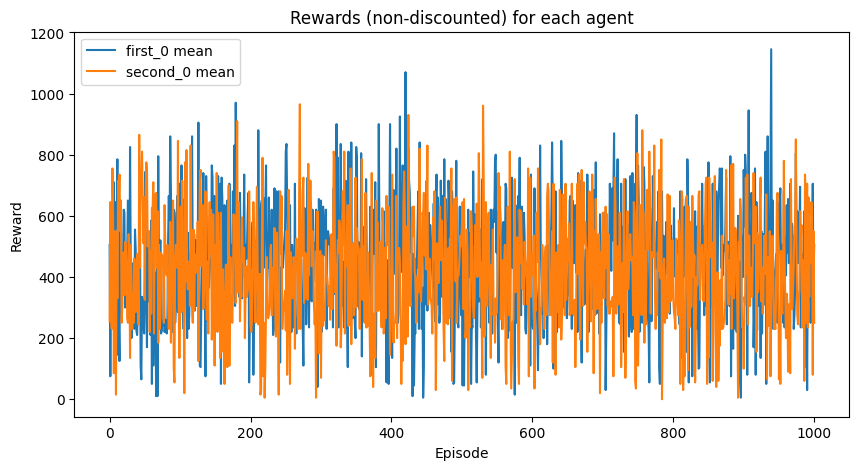

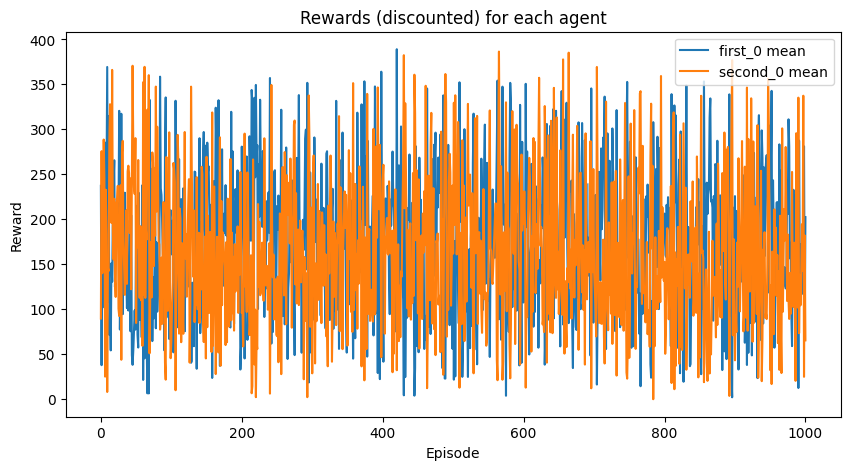

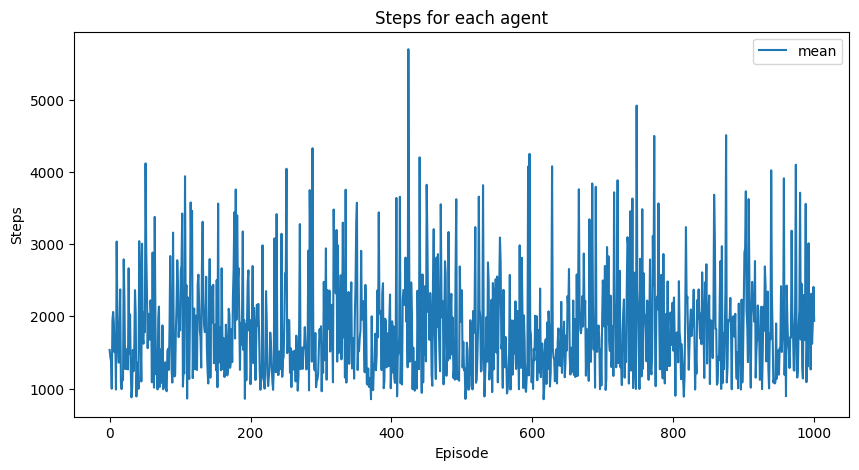

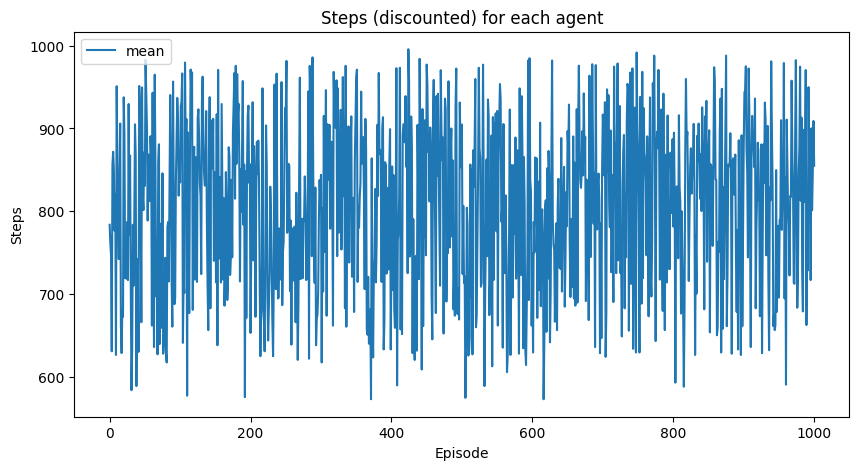

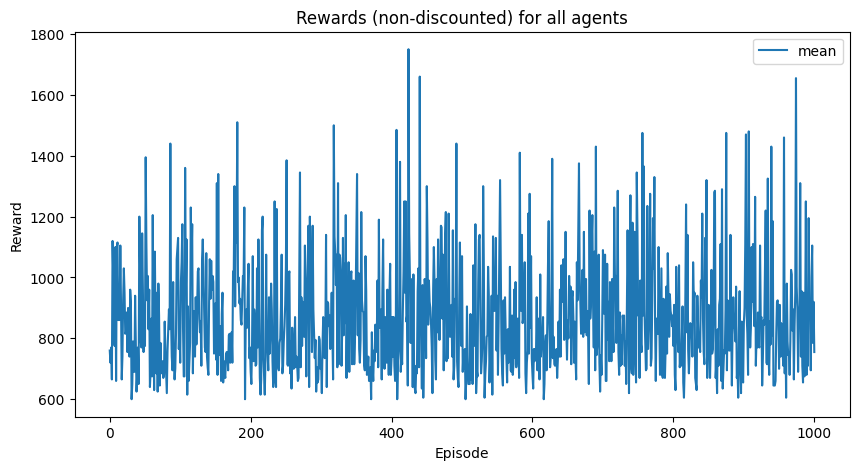

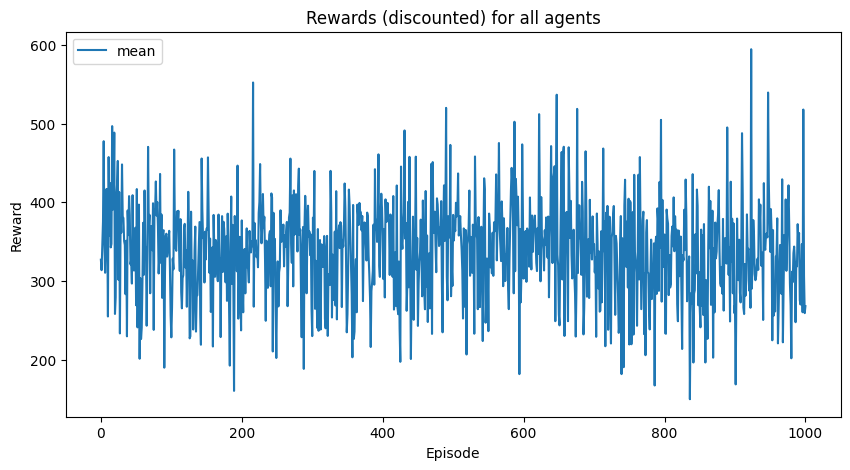

In [103]:
plot_graphs(ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO, agent_names, episode_count)

### Test the agent from the last experiment

In [120]:
episode_count = 100
gamma = 0.999

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_PPO_eff_{effnet}_pre_{pretrained}.pt"
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

ep_rewards_all_PPOr, ep_rewards_d_all_PPOr, ep_steps_PPOr = render_policy_PPO(env, agent_network, gamma, episode_count, device, record_video, video_prefix)

env.close()

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
New max reward: 685.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test_max_reward_685.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
New max reward: 735.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test_max_reward_735.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test.avi
New max reward: 855.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPO_test_max_reward_855.avi
Recording video to /home/jwang185/

Default PPO Model policy has learned to shoot as fast as possible while both going towards to the right only, not dodging any bullets. It's a greedy policy, and does not take into account of points of betrayal. It's like a single agent playing a two-player game, combining two ships into one.

## MAPPO agent

In [105]:
class MAPPO_Agent(PPO_Agent):
    def __init__(self, num_actions, num_frames, num_agents, effnet=False, pretrained=False):
        super().__init__(num_actions, num_frames, effnet, pretrained)

        #actor and critic networks
        self.actor1 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.actor2 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(1280, num_agents))

    def get_action_and_value(self, x, first_agent, action=None):
        hidden = self.network(x / 133.0)
        if first_agent:
            logits = self.actor1(hidden)
        else:
            logits = self.actor2(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


In [121]:
# function for a training single MAPPO experiment
def train_MAPPO(parallel_env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)
    effnet = agent_network.effnet
    pretrained = agent_network.pretrained

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network.get_action_and_value(obs[0:1], True)
                actions2, logprobs2, _, values2 = agent_network.get_action_and_value(obs[1:2], False)
                #check value should be the same for both agents
                assert np.array_equal(values.cpu().numpy(), values2.cpu().numpy())

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.stack((values[0][0], values2[0][1]), dim=0) #combine values for both agents contribution

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index_even], True, b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network.get_action_and_value(
                        b_obs[batch_index_odd], False, b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value[:,0:1], value2[:,1:2]), dim=0) #obtain the value for each agents

                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index], first_agent, b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    if first_agent:
                        value = value[:,0:1]
                    else:
                        value = value[:,1:2]

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_MAPPO(env, agent_network, gamma, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()

    ep_rewards_all = np.zeros(episode_count)
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf 

    with torch.no_grad():
        for ep in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]
                
                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1
                
                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            #store current episode reward by comparing to previous max
            if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
                max_reward = ep_rewards_all[ep]
                print(f"New max reward: {max_reward}")
                video_writer.release()
                #copy video to new path set below by max_reward using shutil
                video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_test_max_reward_{int(max_reward)}.avi")
                print(f"Moving video to {video_path_new}")
                shutil.move(video_path, video_path_new)

    return ep_rewards_all, ep_rewards_d_all, ep_steps


In [107]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 1001

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name


#define arrays to store rewards for each experiment
ep_rewards_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPO = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape
    num_agents = len(env.possible_agents)

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPO[i], ep_steps_d_MAPPO[i], ep_rewards_all_MAPPO[i], ep_rewards_d_all_MAPPO[i] = train_MAPPO(env, agent_network, optimizer, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPO['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPO['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPO['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPO['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPO_store = np.array([ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPO_store)


Experiment 0
Using device: cuda


  0%|          | 0/1001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/1001 [00:28<7:48:15, 28.10s/it]

Training episode 0
Episodic Return: 675.0
Episodic Return Discounted: 375.2064777520574
Episode Length: 1068

Value Loss: 15326.3681640625
Policy Loss agent 1: 116.75128173828125
Policy Loss agent 2: 144.94029235839844
Old Approx KL: -0.004600357264280319
Approx KL: 0.0013956211041659117
Clip Fraction: 0.06638681592039801
Explained Variance: -0.001694798469543457

-------------------------------------------



  0%|          | 2/1001 [01:19<11:31:46, 41.55s/it]

Training episode 1
Episodic Return: 875.0
Episodic Return Discounted: 266.46449999704885
Episode Length: 2178

Value Loss: 49541.8359375
Policy Loss agent 1: -142.92709350585938
Policy Loss agent 2: 421.2176513671875
Old Approx KL: -0.02573627233505249
Approx KL: 0.0009026825428009033
Clip Fraction: 0.1051551094890511
Explained Variance: -0.0036869049072265625

-------------------------------------------



  0%|          | 3/1001 [02:06<12:16:35, 44.28s/it]

Training episode 2
Episodic Return: 755.0
Episodic Return Discounted: 335.12717870199646
Episode Length: 1710

Value Loss: 3992.183837890625
Policy Loss agent 1: -29.208881378173828
Policy Loss agent 2: -76.34661865234375
Old Approx KL: 0.010356225073337555
Approx KL: 0.003781128441914916
Clip Fraction: 0.0814087587724965
Explained Variance: -0.00012445449829101562

-------------------------------------------



  0%|          | 4/1001 [02:41<11:13:51, 40.55s/it]

Training episode 3
Episodic Return: 745.0
Episodic Return Discounted: 347.1616094489009
Episode Length: 1296

Value Loss: 1867.498046875
Policy Loss agent 1: 20.02154541015625
Policy Loss agent 2: -47.311954498291016
Old Approx KL: 0.004411717411130667
Approx KL: 0.0017564655281603336
Clip Fraction: 0.03125857339535721
Explained Variance: 0.00047707557678222656

-------------------------------------------



  0%|          | 5/1001 [03:08<9:52:13, 35.68s/it] 

Training episode 4
Episodic Return: 660.0
Episodic Return Discounted: 337.7948787441922
Episode Length: 1078

Value Loss: 5536.72607421875
Policy Loss agent 1: -79.69220733642578
Policy Loss agent 2: 122.67317199707031
Old Approx KL: -0.0011705398792400956
Approx KL: 0.004046780057251453
Clip Fraction: 0.1455575980465202
Explained Variance: -0.00298154354095459

-------------------------------------------



  1%|          | 6/1001 [04:54<16:28:26, 59.60s/it]

Training episode 5
Episodic Return: 1230.0
Episodic Return Discounted: 247.60916233342596
Episode Length: 4254

Value Loss: 4880.81494140625
Policy Loss agent 1: 67.64307403564453
Policy Loss agent 2: 77.65874481201172
Old Approx KL: 0.006378848105669022
Approx KL: 0.001031912281177938
Clip Fraction: 0.11318862060070935
Explained Variance: -0.00040602684020996094

-------------------------------------------



  1%|          | 7/1001 [05:19<13:18:00, 48.17s/it]

Training episode 6
Episodic Return: 620.0
Episodic Return Discounted: 360.12457851547043
Episode Length: 952

Value Loss: 4162.5234375
Policy Loss agent 1: -63.110015869140625
Policy Loss agent 2: -50.67119598388672
Old Approx KL: -0.00888529047369957
Approx KL: 0.0016308811027556658
Clip Fraction: 0.07973710319234265
Explained Variance: 0.00028145313262939453

-------------------------------------------



  1%|          | 8/1001 [05:46<11:27:17, 41.53s/it]

Training episode 7
Episodic Return: 680.0
Episodic Return Discounted: 340.43710791968766
Episode Length: 1130

Value Loss: 3133.9072265625
Policy Loss agent 1: -32.134521484375
Policy Loss agent 2: -11.4544677734375
Old Approx KL: 0.002179046394303441
Approx KL: 0.001811593770980835
Clip Fraction: 0.07795383412163583
Explained Variance: 0.0003249645233154297

-------------------------------------------



  1%|          | 9/1001 [06:54<13:45:54, 49.95s/it]

Training episode 8
Episodic Return: 960.0
Episodic Return Discounted: 259.6027156645335
Episode Length: 2734

Value Loss: 7339.48828125
Policy Loss agent 1: -45.631614685058594
Policy Loss agent 2: 130.3512420654297
Old Approx KL: -0.03952866047620773
Approx KL: 0.00556192034855485
Clip Fraction: 0.13890763234935308
Explained Variance: -0.0009801387786865234

-------------------------------------------



  1%|          | 10/1001 [07:21<11:43:19, 42.58s/it]

Training episode 9
Episodic Return: 630.0
Episodic Return Discounted: 364.0673315637531
Episode Length: 1002

Value Loss: 3128.614990234375
Policy Loss agent 1: 14.72126579284668
Policy Loss agent 2: -61.54384231567383
Old Approx KL: 0.006704502739012241
Approx KL: 0.006740613374859095
Clip Fraction: 0.12435699597237602
Explained Variance: -0.0023682117462158203

-------------------------------------------



  1%|          | 11/1001 [08:15<12:43:18, 46.26s/it]

Training episode 10
Episodic Return: 945.0
Episodic Return Discounted: 226.11410539235342
Episode Length: 2168

Value Loss: 2399.5244140625
Policy Loss agent 1: 24.591400146484375
Policy Loss agent 2: 24.820587158203125
Old Approx KL: 0.003155103884637356
Approx KL: 0.0032205923926085234
Clip Fraction: 0.20431766465452372
Explained Variance: 0.00033092498779296875

-------------------------------------------



  1%|          | 12/1001 [09:06<13:04:17, 47.58s/it]

Training episode 11
Episodic Return: 810.0
Episodic Return Discounted: 342.4704261828311
Episode Length: 1978

Value Loss: 4247.10791015625
Policy Loss agent 1: -93.91729736328125
Policy Loss agent 2: 19.462308883666992
Old Approx KL: 0.02177131175994873
Approx KL: 0.007157113868743181
Clip Fraction: 0.23456167864302793
Explained Variance: -0.0021556615829467773

-------------------------------------------



  1%|▏         | 13/1001 [09:51<12:50:42, 46.80s/it]

Training episode 12
Episodic Return: 870.0
Episodic Return Discounted: 358.09505133861063
Episode Length: 1678

Value Loss: 5096.3642578125
Policy Loss agent 1: 27.53978729248047
Policy Loss agent 2: -132.7669677734375
Old Approx KL: 0.002846470335498452
Approx KL: 0.004985493142157793
Clip Fraction: 0.224893162458662
Explained Variance: -0.002599358558654785

-------------------------------------------



  1%|▏         | 14/1001 [10:52<14:00:08, 51.07s/it]

Training episode 13
Episodic Return: 980.0
Episodic Return Discounted: 279.5601246737736
Episode Length: 2440

Value Loss: 2321.089111328125
Policy Loss agent 1: 16.892446517944336
Policy Loss agent 2: 92.75847625732422
Old Approx KL: -0.009246843867003918
Approx KL: 0.0064377617090940475
Clip Fraction: 0.23085901030787714
Explained Variance: -0.0020613670349121094

-------------------------------------------



  1%|▏         | 15/1001 [11:17<11:49:30, 43.17s/it]

Training episode 14
Episodic Return: 635.0
Episodic Return Discounted: 371.3853013448744
Episode Length: 1002

Value Loss: 3609.452392578125
Policy Loss agent 1: -50.373374938964844
Policy Loss agent 2: 39.391136169433594
Old Approx KL: -0.0030577117577195168
Approx KL: 0.003619770286604762
Clip Fraction: 0.2399323927583518
Explained Variance: 0.0004882216453552246

-------------------------------------------



  2%|▏         | 16/1001 [11:57<11:34:22, 42.30s/it]

Training episode 15
Episodic Return: 785.0
Episodic Return Discounted: 350.9303589523262
Episode Length: 1592

Value Loss: 2222.471923828125
Policy Loss agent 1: 36.65394592285156
Policy Loss agent 2: -31.33774757385254
Old Approx KL: -0.011566827073693275
Approx KL: 0.002258168999105692
Clip Fraction: 0.23319940485060214
Explained Variance: -0.0024667978286743164

-------------------------------------------



  2%|▏         | 17/1001 [12:47<12:13:51, 44.75s/it]

Training episode 16
Episodic Return: 845.0
Episodic Return Discounted: 313.8883430614638
Episode Length: 2056

Value Loss: 9508.0966796875
Policy Loss agent 1: 149.1743621826172
Policy Loss agent 2: 28.39972686767578
Old Approx KL: 0.05572681128978729
Approx KL: 0.01929638348519802
Clip Fraction: 0.3856589148826993
Explained Variance: -0.001507401466369629

-------------------------------------------



  2%|▏         | 18/1001 [13:38<12:42:42, 46.55s/it]

Training episode 17
Episodic Return: 845.0
Episodic Return Discounted: 299.80377358728094
Episode Length: 2046

Value Loss: 4318.6181640625
Policy Loss agent 1: -87.50113677978516
Policy Loss agent 2: -1.4510470628738403
Old Approx KL: -0.010115091688930988
Approx KL: 0.002393656177446246
Clip Fraction: 0.21737905653814474
Explained Variance: -0.0011192560195922852

-------------------------------------------



  2%|▏         | 19/1001 [14:27<12:53:10, 47.24s/it]

Training episode 18
Episodic Return: 850.0
Episodic Return Discounted: 264.5032256450056
Episode Length: 2000

Value Loss: 3365.154052734375
Policy Loss agent 1: 73.26909637451172
Policy Loss agent 2: -40.71430969238281
Old Approx KL: -0.01767044886946678
Approx KL: 0.008737174794077873
Clip Fraction: 0.2734166668256124
Explained Variance: -0.003309011459350586

-------------------------------------------



  2%|▏         | 20/1001 [15:49<15:44:23, 57.76s/it]

Training episode 19
Episodic Return: 1095.0
Episodic Return Discounted: 219.96946667509752
Episode Length: 3360

Value Loss: 3864.226806640625
Policy Loss agent 1: 8.889923095703125
Policy Loss agent 2: 104.50000762939453
Old Approx KL: 0.10416514426469803
Approx KL: 0.01310762669891119
Clip Fraction: 0.4246031747923957
Explained Variance: -0.0017282962799072266

-------------------------------------------



  2%|▏         | 21/1001 [16:30<14:19:39, 52.63s/it]

Training episode 20
Episodic Return: 825.0
Episodic Return Discounted: 344.5201341018191
Episode Length: 1536

Value Loss: 9119.8056640625
Policy Loss agent 1: -118.02981567382812
Policy Loss agent 2: -125.46360778808594
Old Approx KL: -0.03429070860147476
Approx KL: 0.0065348329953849316
Clip Fraction: 0.35225694471349317
Explained Variance: -0.0019314289093017578

-------------------------------------------



  2%|▏         | 22/1001 [17:11<13:22:39, 49.19s/it]

Training episode 21
Episodic Return: 735.0
Episodic Return Discounted: 333.85109153154605
Episode Length: 1494

Value Loss: 1191.56640625
Policy Loss agent 1: 24.116130828857422
Policy Loss agent 2: 65.64995574951172
Old Approx KL: 0.04959168657660484
Approx KL: 0.009421736001968384
Clip Fraction: 0.3191710993224847
Explained Variance: 0.0014125704765319824

-------------------------------------------



  2%|▏         | 23/1001 [17:58<13:09:26, 48.43s/it]

Training episode 22
Episodic Return: 960.0
Episodic Return Discounted: 406.47944338177814
Episode Length: 1556

Value Loss: 2246.640380859375
Policy Loss agent 1: -37.609161376953125
Policy Loss agent 2: -38.717315673828125
Old Approx KL: 0.022636692970991135
Approx KL: 0.022526245564222336
Clip Fraction: 0.36408730165488057
Explained Variance: -0.00015270709991455078

-------------------------------------------



  2%|▏         | 24/1001 [18:37<12:23:56, 45.69s/it]

Training episode 23
Episodic Return: 705.0
Episodic Return Discounted: 354.5594525327566
Episode Length: 1288

Value Loss: 3930.836181640625
Policy Loss agent 1: 30.864259719848633
Policy Loss agent 2: -81.3852767944336
Old Approx KL: -0.019971508532762527
Approx KL: 0.006639962084591389
Clip Fraction: 0.4499742800806775
Explained Variance: -0.000891566276550293

-------------------------------------------



  2%|▏         | 25/1001 [19:23<12:27:15, 45.94s/it]

Training episode 24
Episodic Return: 680.0
Episodic Return Discounted: 269.0267705051044
Episode Length: 1512

Value Loss: 5619.18115234375
Policy Loss agent 1: -109.00679779052734
Policy Loss agent 2: 63.4681282043457
Old Approx KL: 0.00480653578415513
Approx KL: 0.03007415495812893
Clip Fraction: 0.4613095239589089
Explained Variance: -0.003672480583190918

-------------------------------------------



  3%|▎         | 26/1001 [20:10<12:30:26, 46.18s/it]

Training episode 25
Episodic Return: 800.0
Episodic Return Discounted: 328.7476623584753
Episode Length: 1746

Value Loss: 4770.43212890625
Policy Loss agent 1: -1.9913805723190308
Policy Loss agent 2: 124.39981079101562
Old Approx KL: 0.10200154781341553
Approx KL: 0.005910247564315796
Clip Fraction: 0.4213068181818182
Explained Variance: 0.0008451938629150391

-------------------------------------------



  3%|▎         | 27/1001 [21:00<12:45:54, 47.18s/it]

Training episode 26
Episodic Return: 960.0
Episodic Return Discounted: 302.58452593738565
Episode Length: 2018

Value Loss: 19936.58203125
Policy Loss agent 1: -89.12608337402344
Policy Loss agent 2: -280.0685729980469
Old Approx KL: 0.0747760534286499
Approx KL: 0.030250847339630127
Clip Fraction: 0.5175524934383202
Explained Variance: -0.0036810636520385742

-------------------------------------------



  3%|▎         | 28/1001 [21:43<12:24:06, 45.89s/it]

Training episode 27
Episodic Return: 905.0
Episodic Return Discounted: 344.8894605978197
Episode Length: 1750

Value Loss: 6879.81884765625
Policy Loss agent 1: 72.44894409179688
Policy Loss agent 2: -15.610018730163574
Old Approx KL: 0.2898227274417877
Approx KL: 0.06634514778852463
Clip Fraction: 0.40969696979631076
Explained Variance: -0.001996636390686035

-------------------------------------------



  3%|▎         | 29/1001 [22:23<11:57:29, 44.29s/it]

Training episode 28
Episodic Return: 735.0
Episodic Return Discounted: 289.19539957280875
Episode Length: 1672

Value Loss: 4291.796875
Policy Loss agent 1: -30.15340232849121
Policy Loss agent 2: -96.82371520996094
Old Approx KL: -0.08926058560609818
Approx KL: 0.016941381618380547
Clip Fraction: 0.3545209753134894
Explained Variance: -0.0010422468185424805

-------------------------------------------



  3%|▎         | 30/1001 [22:55<10:55:57, 40.53s/it]

Training episode 29
Episodic Return: 925.0
Episodic Return Discounted: 438.8277715657499
Episode Length: 1290

Value Loss: 4676.69287109375
Policy Loss agent 1: 76.71589660644531
Policy Loss agent 2: -66.21105194091797
Old Approx KL: -0.026900384575128555
Approx KL: 0.03826956823468208
Clip Fraction: 0.46393461366003924
Explained Variance: 0.002255856990814209

-------------------------------------------



  3%|▎         | 31/1001 [23:41<11:24:22, 42.33s/it]

Training episode 30
Episodic Return: 845.0
Episodic Return Discounted: 315.23179162945235
Episode Length: 1928

Value Loss: 36030.1953125
Policy Loss agent 1: 75.72393798828125
Policy Loss agent 2: 310.13922119140625
Old Approx KL: 0.2792069613933563
Approx KL: 0.07855138182640076
Clip Fraction: 0.6374458877508306
Explained Variance: -0.0032798051834106445

-------------------------------------------



  3%|▎         | 32/1001 [24:37<12:29:47, 46.43s/it]

Training episode 31
Episodic Return: 960.0
Episodic Return Discounted: 273.401805967994
Episode Length: 2328

Value Loss: 5892.82177734375
Policy Loss agent 1: -5.561795711517334
Policy Loss agent 2: -90.32333374023438
Old Approx KL: -0.052053336054086685
Approx KL: 0.011006849817931652
Clip Fraction: 0.4122023810058424
Explained Variance: -0.0022782087326049805

-------------------------------------------



  3%|▎         | 33/1001 [25:27<12:42:36, 47.27s/it]

Training episode 32
Episodic Return: 835.0
Episodic Return Discounted: 299.3022232997256
Episode Length: 2004

Value Loss: 4043.657958984375
Policy Loss agent 1: -67.20339965820312
Policy Loss agent 2: -57.21934509277344
Old Approx KL: -0.07215887308120728
Approx KL: 0.00791245698928833
Clip Fraction: 0.4126708555237326
Explained Variance: -0.0024422407150268555

-------------------------------------------



  3%|▎         | 34/1001 [25:56<11:17:12, 42.02s/it]

Training episode 33
Episodic Return: 685.0
Episodic Return Discounted: 353.7264117148867
Episode Length: 1154

Value Loss: 6940.375
Policy Loss agent 1: -165.2661895751953
Policy Loss agent 2: -61.113651275634766
Old Approx KL: -0.14257127046585083
Approx KL: 0.06697314977645874
Clip Fraction: 0.4432077625570776
Explained Variance: -0.0009372234344482422

-------------------------------------------



  3%|▎         | 35/1001 [27:04<13:18:49, 49.62s/it]

Training episode 34
Episodic Return: 755.0
Episodic Return Discounted: 326.6463673749595
Episode Length: 1738

Value Loss: 8745.5693359375
Policy Loss agent 1: 144.43589782714844
Policy Loss agent 2: -68.80690002441406
Old Approx KL: 0.14979368448257446
Approx KL: 0.06130785495042801
Clip Fraction: 0.5229994904375223
Explained Variance: -0.00328671932220459

-------------------------------------------



  4%|▎         | 36/1001 [28:07<14:22:39, 53.64s/it]

Training episode 35
Episodic Return: 910.0
Episodic Return Discounted: 308.62529792542534
Episode Length: 2354

Value Loss: 8853.958984375
Policy Loss agent 1: -65.54486846923828
Policy Loss agent 2: 158.35922241210938
Old Approx KL: 0.09831339120864868
Approx KL: 0.007204562425613403
Clip Fraction: 0.6130349099099099
Explained Variance: -0.0027532577514648438

-------------------------------------------



  4%|▎         | 37/1001 [28:37<12:28:07, 46.56s/it]

Training episode 36
Episodic Return: 665.0
Episodic Return Discounted: 378.00078936923234
Episode Length: 1068

Value Loss: 9239.001953125
Policy Loss agent 1: -113.82819366455078
Policy Loss agent 2: -115.71958923339844
Old Approx KL: -0.1264284998178482
Approx KL: 0.03231481462717056
Clip Fraction: 0.4394222073887118
Explained Variance: -0.0007476806640625

-------------------------------------------



  4%|▍         | 38/1001 [29:38<13:39:29, 51.06s/it]

Training episode 37
Episodic Return: 910.0
Episodic Return Discounted: 302.5095221094678
Episode Length: 2286

Value Loss: 8107.509765625
Policy Loss agent 1: 80.62300109863281
Policy Loss agent 2: 41.0068244934082
Old Approx KL: 0.1463671326637268
Approx KL: 0.03233737871050835
Clip Fraction: 0.5459252287457873
Explained Variance: -0.0036853551864624023

-------------------------------------------



  4%|▍         | 39/1001 [30:22<13:04:59, 48.96s/it]

Training episode 38
Episodic Return: 780.0
Episodic Return Discounted: 279.3304544034716
Episode Length: 1728

Value Loss: 12239.0712890625
Policy Loss agent 1: 75.99933624267578
Policy Loss agent 2: -194.75888061523438
Old Approx KL: -0.02662033401429653
Approx KL: 0.03042108565568924
Clip Fraction: 0.4889081792882931
Explained Variance: -0.003938555717468262

-------------------------------------------



  4%|▍         | 40/1001 [30:55<11:46:46, 44.13s/it]

Training episode 39
Episodic Return: 720.0
Episodic Return Discounted: 363.83506711875924
Episode Length: 1286

Value Loss: 3165.424560546875
Policy Loss agent 1: -27.53590202331543
Policy Loss agent 2: -92.38838195800781
Old Approx KL: -0.042296528816223145
Approx KL: 0.012877739034593105
Clip Fraction: 0.3630915639822375
Explained Variance: -0.0010834932327270508

-------------------------------------------



  4%|▍         | 41/1001 [31:25<10:34:51, 39.68s/it]

Training episode 40
Episodic Return: 730.0
Episodic Return Discounted: 380.94991334304575
Episode Length: 1184

Value Loss: 4209.54931640625
Policy Loss agent 1: -70.38597106933594
Policy Loss agent 2: 61.08601760864258
Old Approx KL: 0.043229132890701294
Approx KL: 0.014761198312044144
Clip Fraction: 0.444613363828745
Explained Variance: 0.0012350082397460938

-------------------------------------------



  4%|▍         | 42/1001 [33:31<17:29:29, 65.66s/it]

Training episode 41
Episodic Return: 980.0
Episodic Return Discounted: 199.6443538450645
Episode Length: 2898

Value Loss: 1641.7059326171875
Policy Loss agent 1: 61.5496711730957
Policy Loss agent 2: 39.165611267089844
Old Approx KL: 0.12999051809310913
Approx KL: 0.00821635127067566
Clip Fraction: 0.64617673992674
Explained Variance: -0.0030962228775024414

-------------------------------------------



  4%|▍         | 43/1001 [34:45<18:07:55, 68.14s/it]

Training episode 42
Episodic Return: 960.0
Episodic Return Discounted: 328.2619777499882
Episode Length: 2588

Value Loss: 10125.7890625
Policy Loss agent 1: -141.7316436767578
Policy Loss agent 2: -12.382041931152344
Old Approx KL: -0.012902975082397461
Approx KL: 0.030108200386166573
Clip Fraction: 0.4762322297741356
Explained Variance: -0.003534674644470215

-------------------------------------------



  4%|▍         | 44/1001 [35:33<16:32:08, 62.20s/it]

Training episode 43
Episodic Return: 815.0
Episodic Return Discounted: 330.79280654123625
Episode Length: 1740

Value Loss: 2030.7611083984375
Policy Loss agent 1: 20.957468032836914
Policy Loss agent 2: -40.34120178222656
Old Approx KL: -0.02141270972788334
Approx KL: 0.01144929975271225
Clip Fraction: 0.3854079790162748
Explained Variance: 0.0013486146926879883

-------------------------------------------



  4%|▍         | 45/1001 [36:05<14:05:35, 53.07s/it]

Training episode 44
Episodic Return: 680.0
Episodic Return Discounted: 305.2204051514766
Episode Length: 1304

Value Loss: 1597.860595703125
Policy Loss agent 1: 24.67177963256836
Policy Loss agent 2: -32.51771545410156
Old Approx KL: -0.0057009547017514706
Approx KL: 0.006200726609677076
Clip Fraction: 0.40080574942313557
Explained Variance: 0.00045496225357055664

-------------------------------------------



  5%|▍         | 46/1001 [37:00<14:13:04, 53.60s/it]

Training episode 45
Episodic Return: 845.0
Episodic Return Discounted: 270.1880918723079
Episode Length: 2310

Value Loss: 8455.2861328125
Policy Loss agent 1: 89.6986312866211
Policy Loss agent 2: 79.73078918457031
Old Approx KL: 0.15089625120162964
Approx KL: 0.046478867530822754
Clip Fraction: 0.6146551724137931
Explained Variance: 0.00017201900482177734

-------------------------------------------



  5%|▍         | 47/1001 [38:05<15:09:46, 57.22s/it]

Training episode 46
Episodic Return: 1175.0
Episodic Return Discounted: 263.7609350438613
Episode Length: 2806

Value Loss: 7200.8876953125
Policy Loss agent 1: -56.22419738769531
Policy Loss agent 2: -139.62083435058594
Old Approx KL: -0.17580130696296692
Approx KL: 0.04416732117533684
Clip Fraction: 0.5015980113636364
Explained Variance: -0.0013884305953979492

-------------------------------------------



  5%|▍         | 48/1001 [38:35<12:56:37, 48.90s/it]

Training episode 47
Episodic Return: 895.0
Episodic Return Discounted: 436.9688614979625
Episode Length: 1244

Value Loss: 2556.440673828125
Policy Loss agent 1: -25.088762283325195
Policy Loss agent 2: -74.87775421142578
Old Approx KL: -0.10050511360168457
Approx KL: 0.015973960980772972
Clip Fraction: 0.48765297195850277
Explained Variance: 0.001855611801147461

-------------------------------------------



  5%|▍         | 49/1001 [39:30<13:27:14, 50.88s/it]

Training episode 48
Episodic Return: 920.0
Episodic Return Discounted: 302.3143058363709
Episode Length: 2280

Value Loss: 29363.896484375
Policy Loss agent 1: 210.7774200439453
Policy Loss agent 2: 193.4795379638672
Old Approx KL: 0.22026124596595764
Approx KL: 0.05168292298913002
Clip Fraction: 0.712943307030729
Explained Variance: 0.0005764365196228027

-------------------------------------------



  5%|▍         | 50/1001 [40:20<13:19:28, 50.44s/it]

Training episode 49
Episodic Return: 860.0
Episodic Return Discounted: 317.5903108652062
Episode Length: 1932

Value Loss: 54360.296875
Policy Loss agent 1: -497.8252868652344
Policy Loss agent 2: -19.41286849975586
Old Approx KL: -0.20218051970005035
Approx KL: 0.04952150583267212
Clip Fraction: 0.5887647134049208
Explained Variance: -0.0034189224243164062

-------------------------------------------



  5%|▌         | 51/1001 [40:50<11:42:48, 44.39s/it]

Training episode 50
Episodic Return: 750.0
Episodic Return Discounted: 405.24953560006264
Episode Length: 1140

Value Loss: 3649.59228515625
Policy Loss agent 1: -0.291595458984375
Policy Loss agent 2: 10.138952255249023
Old Approx KL: 0.10148920863866806
Approx KL: 0.10397117584943771
Clip Fraction: 0.39829282407407407
Explained Variance: 0.0023436546325683594

-------------------------------------------



  5%|▌         | 52/1001 [41:21<10:38:33, 40.37s/it]

Training episode 51
Episodic Return: 680.0
Episodic Return Discounted: 341.567706421198
Episode Length: 1208

Value Loss: 2528.69873046875
Policy Loss agent 1: 25.710683822631836
Policy Loss agent 2: -46.765411376953125
Old Approx KL: 0.008693346753716469
Approx KL: 0.007807463873177767
Clip Fraction: 0.28389332731041994
Explained Variance: -0.00024116039276123047

-------------------------------------------



  5%|▌         | 53/1001 [42:06<11:01:02, 41.84s/it]

Training episode 52
Episodic Return: 1005.0
Episodic Return Discounted: 382.7663958524025
Episode Length: 1732

Value Loss: 2507.41259765625
Policy Loss agent 1: 56.910911560058594
Policy Loss agent 2: -73.14952850341797
Old Approx KL: -0.017464598640799522
Approx KL: 0.010408073663711548
Clip Fraction: 0.43794597361795035
Explained Variance: -0.0005162954330444336

-------------------------------------------



  5%|▌         | 54/1001 [42:42<10:28:50, 39.84s/it]

Training episode 53
Episodic Return: 955.0
Episodic Return Discounted: 436.7357389433987
Episode Length: 1368

Value Loss: 5957.01123046875
Policy Loss agent 1: 81.71344757080078
Policy Loss agent 2: -91.08988952636719
Old Approx KL: 0.12194903939962387
Approx KL: 0.11217114329338074
Clip Fraction: 0.5694732839284942
Explained Variance: -0.0020232200622558594

-------------------------------------------



  5%|▌         | 55/1001 [43:12<9:44:12, 37.05s/it] 

Training episode 54
Episodic Return: 880.0
Episodic Return Discounted: 448.6420315832518
Episode Length: 1192

Value Loss: 4316.080078125
Policy Loss agent 1: -105.82491302490234
Policy Loss agent 2: 13.053889274597168
Old Approx KL: -0.06581692397594452
Approx KL: 0.02178119868040085
Clip Fraction: 0.5531547623210483
Explained Variance: -0.003403902053833008

-------------------------------------------



  6%|▌         | 56/1001 [44:00<10:33:09, 40.20s/it]

Training episode 55
Episodic Return: 855.0
Episodic Return Discounted: 303.6007683732864
Episode Length: 1892

Value Loss: 19776.6015625
Policy Loss agent 1: 189.43197631835938
Policy Loss agent 2: 44.55078125
Old Approx KL: 0.1950782835483551
Approx KL: 0.06901781260967255
Clip Fraction: 0.6634862279357696
Explained Variance: 4.70280647277832e-05

-------------------------------------------



  6%|▌         | 57/1001 [44:29<9:41:39, 36.97s/it] 

Training episode 56
Episodic Return: 655.0
Episodic Return Discounted: 304.1231325669176
Episode Length: 1242

Value Loss: 12140.4873046875
Policy Loss agent 1: -163.00596618652344
Policy Loss agent 2: -102.12808990478516
Old Approx KL: -0.1578778773546219
Approx KL: 0.06164742261171341
Clip Fraction: 0.5856184709785331
Explained Variance: -0.0026984214782714844

-------------------------------------------



  6%|▌         | 58/1001 [44:59<9:09:54, 34.99s/it]

Training episode 57
Episodic Return: 770.0
Episodic Return Discounted: 368.4694922983032
Episode Length: 1272

Value Loss: 3866.269775390625
Policy Loss agent 1: 42.19585418701172
Policy Loss agent 2: 86.20361328125
Old Approx KL: 0.188674658536911
Approx KL: 0.06117543578147888
Clip Fraction: 0.49015997039775056
Explained Variance: -0.0018607378005981445

-------------------------------------------



  6%|▌         | 59/1001 [45:36<9:17:04, 35.48s/it]

Training episode 58
Episodic Return: 865.0
Episodic Return Discounted: 388.6494286253809
Episode Length: 1528

Value Loss: 5074.59228515625
Policy Loss agent 1: 35.41992950439453
Policy Loss agent 2: -85.70010375976562
Old Approx KL: -0.06372447311878204
Approx KL: 0.04023943096399307
Clip Fraction: 0.5656932046016058
Explained Variance: -0.003084897994995117

-------------------------------------------



  6%|▌         | 60/1001 [46:28<10:34:40, 40.47s/it]

Training episode 59
Episodic Return: 875.0
Episodic Return Discounted: 302.2592939740817
Episode Length: 2134

Value Loss: 8764.7333984375
Policy Loss agent 1: 9.479525566101074
Policy Loss agent 2: 148.4558563232422
Old Approx KL: 0.1627415418624878
Approx KL: 0.03220752999186516
Clip Fraction: 0.6225435323827896
Explained Variance: -0.002403736114501953

-------------------------------------------



  6%|▌         | 61/1001 [46:59<9:50:35, 37.70s/it] 

Training episode 60
Episodic Return: 730.0
Episodic Return Discounted: 334.5276413803524
Episode Length: 1288

Value Loss: 20170.8984375
Policy Loss agent 1: 37.03697967529297
Policy Loss agent 2: -216.94398498535156
Old Approx KL: -0.14737091958522797
Approx KL: 0.1720070242881775
Clip Fraction: 0.6622574962215659
Explained Variance: -0.0033043622970581055

-------------------------------------------



  6%|▌         | 62/1001 [47:30<9:18:09, 35.67s/it]

Training episode 61
Episodic Return: 765.0
Episodic Return Discounted: 372.4587285934057
Episode Length: 1296

Value Loss: 15084.2353515625
Policy Loss agent 1: -182.42361450195312
Policy Loss agent 2: 108.60057067871094
Old Approx KL: -0.11402375251054764
Approx KL: 0.05289280414581299
Clip Fraction: 0.6424982856821131
Explained Variance: -0.0053206682205200195

-------------------------------------------



  6%|▋         | 63/1001 [47:57<8:34:03, 32.88s/it]

Training episode 62
Episodic Return: 660.0
Episodic Return Discounted: 362.55875255874594
Episode Length: 1070

Value Loss: 909.0523681640625
Policy Loss agent 1: -27.48232078552246
Policy Loss agent 2: -30.917802810668945
Old Approx KL: -0.09845390170812607
Approx KL: 0.02282506600022316
Clip Fraction: 0.3576827404362645
Explained Variance: 0.007989883422851562

-------------------------------------------



  6%|▋         | 64/1001 [48:55<10:32:44, 40.52s/it]

Training episode 63
Episodic Return: 1160.0
Episodic Return Discounted: 357.97301391401857
Episode Length: 2354

Value Loss: 11427.896484375
Policy Loss agent 1: 218.12815856933594
Policy Loss agent 2: 147.65333557128906
Old Approx KL: 0.11766237020492554
Approx KL: 0.007191509008407593
Clip Fraction: 0.7544341216216216
Explained Variance: -0.001171112060546875

-------------------------------------------



  6%|▋         | 65/1001 [49:55<12:05:09, 46.48s/it]

Training episode 64
Episodic Return: 1205.0
Episodic Return Discounted: 451.91719330272605
Episode Length: 2452

Value Loss: 41203.37890625
Policy Loss agent 1: -365.8762512207031
Policy Loss agent 2: -222.35415649414062
Old Approx KL: -0.1926724761724472
Approx KL: 0.034067362546920776
Clip Fraction: 0.647524350778365
Explained Variance: -0.0010418891906738281

-------------------------------------------



  7%|▋         | 66/1001 [50:49<12:38:07, 48.65s/it]

Training episode 65
Episodic Return: 1070.0
Episodic Return Discounted: 380.4516230894116
Episode Length: 2172

Value Loss: 5459.30126953125
Policy Loss agent 1: 79.4264144897461
Policy Loss agent 2: 30.71820068359375
Old Approx KL: 0.1660831868648529
Approx KL: 0.0406859889626503
Clip Fraction: 0.5308879234042823
Explained Variance: 0.00035637617111206055

-------------------------------------------



  7%|▋         | 67/1001 [52:39<17:21:44, 66.92s/it]

Training episode 66
Episodic Return: 1365.0
Episodic Return Discounted: 185.19778010251622
Episode Length: 4362

Value Loss: 18302.56640625
Policy Loss agent 1: 65.99915313720703
Policy Loss agent 2: 205.7034149169922
Old Approx KL: 0.21758322417736053
Approx KL: 0.04130939766764641
Clip Fraction: 0.6292735042735043
Explained Variance: -0.0020601749420166016

-------------------------------------------



  7%|▋         | 68/1001 [53:28<15:59:30, 61.71s/it]

Training episode 67
Episodic Return: 980.0
Episodic Return Discounted: 387.7827635362354
Episode Length: 1980

Value Loss: 14563.01171875
Policy Loss agent 1: -230.172119140625
Policy Loss agent 2: -127.02070617675781
Old Approx KL: -0.17812925577163696
Approx KL: 0.04391876235604286
Clip Fraction: 0.5747876956818565
Explained Variance: -0.0017720460891723633

-------------------------------------------



  7%|▋         | 69/1001 [54:49<17:26:21, 67.36s/it]

Training episode 68
Episodic Return: 1130.0
Episodic Return Discounted: 358.93204418804066
Episode Length: 3198

Value Loss: 10465.0869140625
Policy Loss agent 1: 124.19810485839844
Policy Loss agent 2: 55.53935241699219
Old Approx KL: 0.2833212614059448
Approx KL: 0.12438266724348068
Clip Fraction: 0.6031169873476029
Explained Variance: -0.0006284713745117188

-------------------------------------------



  7%|▋         | 70/1001 [55:41<16:13:50, 62.76s/it]

Training episode 69
Episodic Return: 830.0
Episodic Return Discounted: 287.78962821885034
Episode Length: 2096

Value Loss: 18898.228515625
Policy Loss agent 1: -254.93829345703125
Policy Loss agent 2: -40.94166946411133
Old Approx KL: -0.23308463394641876
Approx KL: 0.07610565423965454
Clip Fraction: 0.5841709078116575
Explained Variance: -0.0018053054809570312

-------------------------------------------



  7%|▋         | 71/1001 [56:43<16:10:00, 62.58s/it]

Training episode 70
Episodic Return: 1190.0
Episodic Return Discounted: 300.82378320839615
Episode Length: 2488

Value Loss: 12271.2412109375
Policy Loss agent 1: 107.76770782470703
Policy Loss agent 2: 93.42810821533203
Old Approx KL: 0.15721511840820312
Approx KL: 0.06296736001968384
Clip Fraction: 0.6648256260360408
Explained Variance: -0.0007573366165161133

-------------------------------------------



  7%|▋         | 72/1001 [57:09<13:17:12, 51.49s/it]

Training episode 71
Episodic Return: 690.0
Episodic Return Discounted: 397.5559659132095
Episode Length: 1000

Value Loss: 24483.193359375
Policy Loss agent 1: -103.05875396728516
Policy Loss agent 2: -263.6879577636719
Old Approx KL: -0.20487353205680847
Approx KL: 0.05717110633850098
Clip Fraction: 0.5193452384106065
Explained Variance: -0.003880023956298828

-------------------------------------------



  7%|▋         | 73/1001 [57:57<13:03:05, 50.63s/it]

Training episode 72
Episodic Return: 845.0
Episodic Return Discounted: 289.42587932578954
Episode Length: 1968

Value Loss: 4706.208984375
Policy Loss agent 1: 55.092742919921875
Policy Loss agent 2: 62.10173416137695
Old Approx KL: 0.20135724544525146
Approx KL: 0.03582768514752388
Clip Fraction: 0.5213019424660742
Explained Variance: -0.0018427371978759766

-------------------------------------------



  7%|▋         | 74/1001 [58:56<13:41:34, 53.18s/it]

Training episode 73
Episodic Return: 1065.0
Episodic Return Discounted: 298.30151694952065
Episode Length: 2404

Value Loss: 16472.12890625
Policy Loss agent 1: -74.12811279296875
Policy Loss agent 2: -215.19871520996094
Old Approx KL: -0.8076075911521912
Approx KL: 0.6259952187538147
Clip Fraction: 0.6029019501825043
Explained Variance: -0.004492282867431641

-------------------------------------------



  7%|▋         | 75/1001 [59:28<12:01:19, 46.74s/it]

Training episode 74
Episodic Return: 740.0
Episodic Return Discounted: 377.5898640442932
Episode Length: 1268

Value Loss: 7836.59130859375
Policy Loss agent 1: -101.02861022949219
Policy Loss agent 2: 75.19361877441406
Old Approx KL: 0.056101344525814056
Approx KL: 0.058344703167676926
Clip Fraction: 0.5668402779847383
Explained Variance: -0.0016025304794311523

-------------------------------------------



  8%|▊         | 76/1001 [1:00:18<12:13:15, 47.56s/it]

Training episode 75
Episodic Return: 995.0
Episodic Return Discounted: 333.68361779490033
Episode Length: 1996

Value Loss: 9725.134765625
Policy Loss agent 1: 78.49195861816406
Policy Loss agent 2: -162.2957763671875
Old Approx KL: -0.14968650043010712
Approx KL: 0.17211011052131653
Clip Fraction: 0.6147500001589458
Explained Variance: -0.0036219358444213867

-------------------------------------------



  8%|▊         | 77/1001 [1:00:43<10:32:21, 41.06s/it]

Training episode 76
Episodic Return: 655.0
Episodic Return Discounted: 366.6098144318686
Episode Length: 1016

Value Loss: 3807.834716796875
Policy Loss agent 1: -132.2332000732422
Policy Loss agent 2: 49.840816497802734
Old Approx KL: 0.09512259811162949
Approx KL: 0.03517455980181694
Clip Fraction: 0.5024646579598387
Explained Variance: -0.0039702653884887695

-------------------------------------------



  8%|▊         | 78/1001 [1:01:13<9:39:56, 37.70s/it] 

Training episode 77
Episodic Return: 1110.0
Episodic Return Discounted: 545.7575382839462
Episode Length: 1152

Value Loss: 12223.2314453125
Policy Loss agent 1: 33.406898498535156
Policy Loss agent 2: -200.94442749023438
Old Approx KL: -0.0809931606054306
Approx KL: 0.060870666056871414
Clip Fraction: 0.5990933646206502
Explained Variance: -0.0016275644302368164

-------------------------------------------



  8%|▊         | 79/1001 [1:01:55<9:56:57, 38.85s/it]

Training episode 78
Episodic Return: 780.0
Episodic Return Discounted: 335.61320760799725
Episode Length: 1556

Value Loss: 11727.5732421875
Policy Loss agent 1: 93.25236511230469
Policy Loss agent 2: 124.88661193847656
Old Approx KL: 0.18635617196559906
Approx KL: 0.02989419363439083
Clip Fraction: 0.5932539683215472
Explained Variance: -0.0017114877700805664

-------------------------------------------



  8%|▊         | 80/1001 [1:02:25<9:16:41, 36.27s/it]

Training episode 79
Episodic Return: 955.0
Episodic Return Discounted: 474.9451336152403
Episode Length: 1180

Value Loss: 4002.91796875
Policy Loss agent 1: -97.09557342529297
Policy Loss agent 2: 13.466736793518066
Old Approx KL: -0.05033627524971962
Approx KL: 0.09239599853754044
Clip Fraction: 0.5215627561818372
Explained Variance: -0.0007352828979492188

-------------------------------------------



  8%|▊         | 81/1001 [1:02:50<8:25:15, 32.95s/it]

Training episode 80
Episodic Return: 835.0
Episodic Return Discounted: 462.3081774065406
Episode Length: 1002

Value Loss: 3683.178466796875
Policy Loss agent 1: 39.27649688720703
Policy Loss agent 2: -65.20869445800781
Old Approx KL: -0.055874302983284
Approx KL: 0.014353076927363873
Clip Fraction: 0.5292291302214224
Explained Variance: -0.0030028820037841797

-------------------------------------------



  8%|▊         | 82/1001 [1:03:18<8:02:14, 31.48s/it]

Training episode 81
Episodic Return: 660.0
Episodic Return Discounted: 338.5081594384398
Episode Length: 1092

Value Loss: 6135.0
Policy Loss agent 1: 100.47401428222656
Policy Loss agent 2: 23.779956817626953
Old Approx KL: 0.4068142771720886
Approx KL: 0.09437525272369385
Clip Fraction: 0.6093498390653859
Explained Variance: 0.001085817813873291

-------------------------------------------



  8%|▊         | 83/1001 [1:03:51<8:06:45, 31.81s/it]

Training episode 82
Episodic Return: 675.0
Episodic Return Discounted: 376.15503851203164
Episode Length: 1270

Value Loss: 10178.0986328125
Policy Loss agent 1: -142.94200134277344
Policy Loss agent 2: 95.48497772216797
Old Approx KL: -0.011322843842208385
Approx KL: 0.12328159064054489
Clip Fraction: 0.6421354169646899
Explained Variance: -0.003914356231689453

-------------------------------------------



  8%|▊         | 84/1001 [1:05:16<12:08:53, 47.69s/it]

Training episode 83
Episodic Return: 1325.0
Episodic Return Discounted: 251.2146222881506
Episode Length: 3358

Value Loss: 38599.33203125
Policy Loss agent 1: 392.41259765625
Policy Loss agent 2: 1.7332172393798828
Old Approx KL: 0.36523497104644775
Approx KL: 0.13286267220973969
Clip Fraction: 0.7197611418035296
Explained Variance: -0.0032753944396972656

-------------------------------------------



  8%|▊         | 85/1001 [1:06:05<12:14:21, 48.10s/it]

Training episode 84
Episodic Return: 1115.0
Episodic Return Discounted: 388.8248365673344
Episode Length: 1946

Value Loss: 25973.90234375
Policy Loss agent 1: -202.7997589111328
Policy Loss agent 2: -250.5078125
Old Approx KL: -0.281430721282959
Approx KL: 0.11881199479103088
Clip Fraction: 0.5889970400050039
Explained Variance: -4.887580871582031e-06

-------------------------------------------



  9%|▊         | 86/1001 [1:07:07<13:19:21, 52.42s/it]

Training episode 85
Episodic Return: 835.0
Episodic Return Discounted: 265.3427706709822
Episode Length: 2488

Value Loss: 17123.927734375
Policy Loss agent 1: 148.2432403564453
Policy Loss agent 2: 114.56011962890625
Old Approx KL: 0.48706990480422974
Approx KL: 0.20711447298526764
Clip Fraction: 0.6182272589614248
Explained Variance: -0.0008867979049682617

-------------------------------------------



  9%|▊         | 87/1001 [1:07:32<11:14:37, 44.29s/it]

Training episode 86
Episodic Return: 650.0
Episodic Return Discounted: 373.42459572867074
Episode Length: 1002

Value Loss: 27961.3046875
Policy Loss agent 1: -313.9180908203125
Policy Loss agent 2: -18.49221420288086
Old Approx KL: -0.13566239178180695
Approx KL: 0.034641679376363754
Clip Fraction: 0.5056584363891965
Explained Variance: -0.0013992786407470703

-------------------------------------------



  9%|▉         | 88/1001 [1:08:21<11:33:27, 45.57s/it]

Training episode 87
Episodic Return: 800.0
Episodic Return Discounted: 235.06652645977493
Episode Length: 1972

Value Loss: 5304.43701171875
Policy Loss agent 1: 80.40198516845703
Policy Loss agent 2: 29.40378189086914
Old Approx KL: 0.08605234324932098
Approx KL: 0.03878476470708847
Clip Fraction: 0.5535674283821737
Explained Variance: -0.0005730390548706055

-------------------------------------------



  9%|▉         | 89/1001 [1:08:59<10:59:02, 43.36s/it]

Training episode 88
Episodic Return: 700.0
Episodic Return Discounted: 341.2008777038649
Episode Length: 1512

Value Loss: 4906.68896484375
Policy Loss agent 1: 59.78261947631836
Policy Loss agent 2: -87.83663177490234
Old Approx KL: 0.3402792811393738
Approx KL: 0.26849961280822754
Clip Fraction: 0.4851033836080317
Explained Variance: -0.0035135746002197266

-------------------------------------------



  9%|▉         | 90/1001 [1:09:33<10:15:01, 40.51s/it]

Training episode 89
Episodic Return: 945.0
Episodic Return Discounted: 433.8635633805445
Episode Length: 1364

Value Loss: 6658.99560546875
Policy Loss agent 1: -110.24536895751953
Policy Loss agent 2: 25.073457717895508
Old Approx KL: -0.001141329645179212
Approx KL: 0.023828953504562378
Clip Fraction: 0.5622173774149991
Explained Variance: -0.001905679702758789

-------------------------------------------



  9%|▉         | 91/1001 [1:10:35<11:50:41, 46.86s/it]

Training episode 90
Episodic Return: 945.0
Episodic Return Discounted: 224.56286260299325
Episode Length: 2518

Value Loss: 14707.703125
Policy Loss agent 1: 259.81756591796875
Policy Loss agent 2: 65.84366607666016
Old Approx KL: 0.3736850917339325
Approx KL: 0.09548323601484299
Clip Fraction: 0.7235100211473456
Explained Variance: -0.0032732486724853516

-------------------------------------------



  9%|▉         | 92/1001 [1:11:17<11:29:30, 45.51s/it]

Training episode 91
Episodic Return: 840.0
Episodic Return Discounted: 343.9614503372787
Episode Length: 1704

Value Loss: 13260.5947265625
Policy Loss agent 1: -139.4503936767578
Policy Loss agent 2: -183.82232666015625
Old Approx KL: -0.26826125383377075
Approx KL: 0.0749158188700676
Clip Fraction: 0.6219264578967822
Explained Variance: -0.0010031461715698242

-------------------------------------------



  9%|▉         | 93/1001 [1:12:13<12:14:09, 48.51s/it]

Training episode 92
Episodic Return: 1175.0
Episodic Return Discounted: 473.128681345618
Episode Length: 2274

Value Loss: 5822.67431640625
Policy Loss agent 1: 127.36325073242188
Policy Loss agent 2: 51.732826232910156
Old Approx KL: 0.3862553834915161
Approx KL: 0.07298150658607483
Clip Fraction: 0.587995337995338
Explained Variance: -0.0019252300262451172

-------------------------------------------



  9%|▉         | 94/1001 [1:12:46<11:05:25, 44.02s/it]

Training episode 93
Episodic Return: 770.0
Episodic Return Discounted: 337.2835243134644
Episode Length: 1338

Value Loss: 14126.845703125
Policy Loss agent 1: -229.74078369140625
Policy Loss agent 2: 17.689966201782227
Old Approx KL: -0.11062739789485931
Approx KL: 0.09103918075561523
Clip Fraction: 0.5411844135276855
Explained Variance: -0.0008134841918945312

-------------------------------------------



  9%|▉         | 95/1001 [1:13:41<11:51:16, 47.10s/it]

Training episode 94
Episodic Return: 805.0
Episodic Return Discounted: 225.26184970821342
Episode Length: 2306

Value Loss: 10266.6162109375
Policy Loss agent 1: 228.50534057617188
Policy Loss agent 2: -164.4195098876953
Old Approx KL: 0.2883847951889038
Approx KL: 0.038054853677749634
Clip Fraction: 0.6440373563218391
Explained Variance: -0.004530787467956543

-------------------------------------------



 10%|▉         | 96/1001 [1:14:17<11:03:50, 44.01s/it]

Training episode 95
Episodic Return: 785.0
Episodic Return Discounted: 334.7688723053395
Episode Length: 1542

Value Loss: 4178.482421875
Policy Loss agent 1: -46.222129821777344
Policy Loss agent 2: 0.4001094400882721
Old Approx KL: -0.04609717056155205
Approx KL: 0.020051563158631325
Clip Fraction: 0.5440077319792456
Explained Variance: -0.002282261848449707

-------------------------------------------



 10%|▉         | 97/1001 [1:14:54<10:32:07, 41.96s/it]

Training episode 96
Episodic Return: 785.0
Episodic Return Discounted: 322.66629461004567
Episode Length: 1542

Value Loss: 5841.33544921875
Policy Loss agent 1: 32.61724090576172
Policy Loss agent 2: -4.8951873779296875
Old Approx KL: 0.1722521036863327
Approx KL: 0.15461377799510956
Clip Fraction: 0.5643256015793974
Explained Variance: 0.0017084479331970215

-------------------------------------------



 10%|▉         | 98/1001 [1:15:24<9:35:07, 38.21s/it] 

Training episode 97
Episodic Return: 710.0
Episodic Return Discounted: 375.47675433602774
Episode Length: 1218

Value Loss: 2226.452880859375
Policy Loss agent 1: 70.95713806152344
Policy Loss agent 2: 46.632511138916016
Old Approx KL: 0.20490992069244385
Approx KL: 0.023688584566116333
Clip Fraction: 0.5117694805194806
Explained Variance: -0.00017750263214111328

-------------------------------------------



 10%|▉         | 99/1001 [1:16:08<10:01:26, 40.01s/it]

Training episode 98
Episodic Return: 1135.0
Episodic Return Discounted: 444.0610330317571
Episode Length: 1878

Value Loss: 4234.63427734375
Policy Loss agent 1: -15.296424865722656
Policy Loss agent 2: -67.0536117553711
Old Approx KL: 0.03237185627222061
Approx KL: 0.03484771400690079
Clip Fraction: 0.5415607345643016
Explained Variance: -0.00122833251953125

-------------------------------------------



 10%|▉         | 100/1001 [1:16:36<9:04:19, 36.25s/it]

Training episode 99
Episodic Return: 740.0
Episodic Return Discounted: 396.31865468949445
Episode Length: 1160

Value Loss: 4602.04052734375
Policy Loss agent 1: -46.38983917236328
Policy Loss agent 2: 99.97024536132812
Old Approx KL: 0.1762412041425705
Approx KL: 0.09349678456783295
Clip Fraction: 0.5832925640284743
Explained Variance: 0.0019058585166931152

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_100_gamma_0.999.avi


 10%|█         | 101/1001 [1:17:07<8:41:58, 34.80s/it]

Training episode 100
Episodic Return: 715.0
Episodic Return Discounted: 392.29356670914274
Episode Length: 1302

Value Loss: 37201.1171875
Policy Loss agent 1: 287.1529235839844
Policy Loss agent 2: -221.49864196777344
Old Approx KL: 0.00019387007341720164
Approx KL: 0.07124578952789307
Clip Fraction: 0.7076727643730195
Explained Variance: -0.004577279090881348

-------------------------------------------



 10%|█         | 102/1001 [1:17:53<9:31:36, 38.15s/it]

Training episode 101
Episodic Return: 1060.0
Episodic Return Discounted: 330.1366374513296
Episode Length: 1928

Value Loss: 7286.2041015625
Policy Loss agent 1: -125.31059265136719
Policy Loss agent 2: 67.99266052246094
Old Approx KL: 0.18724553287029266
Approx KL: 0.16041934490203857
Clip Fraction: 0.619601043131069
Explained Variance: -0.003409147262573242

-------------------------------------------



 10%|█         | 103/1001 [1:18:41<10:16:13, 41.17s/it]

Training episode 102
Episodic Return: 805.0
Episodic Return Discounted: 285.72628506504
Episode Length: 2024

Value Loss: 1589.90869140625
Policy Loss agent 1: 53.11779022216797
Policy Loss agent 2: -29.690078735351562
Old Approx KL: 0.09174332767724991
Approx KL: 0.04688743129372597
Clip Fraction: 0.5066671355815697
Explained Variance: -0.0014803409576416016

-------------------------------------------



 10%|█         | 104/1001 [1:19:06<9:01:24, 36.21s/it] 

Training episode 103
Episodic Return: 680.0
Episodic Return Discounted: 400.7175472480073
Episode Length: 1018

Value Loss: 4454.3046875
Policy Loss agent 1: -6.236367225646973
Policy Loss agent 2: -66.29388427734375
Old Approx KL: -0.004200610797852278
Approx KL: 0.03821009024977684
Clip Fraction: 0.4903428819961846
Explained Variance: -0.0018353462219238281

-------------------------------------------



 10%|█         | 105/1001 [1:19:56<10:03:46, 40.43s/it]

Training episode 104
Episodic Return: 950.0
Episodic Return Discounted: 323.26621417705996
Episode Length: 2044

Value Loss: 11643.0751953125
Policy Loss agent 1: 154.26324462890625
Policy Loss agent 2: -34.38494873046875
Old Approx KL: 0.5300748348236084
Approx KL: 0.28263378143310547
Clip Fraction: 0.6477864584885538
Explained Variance: -0.0014961957931518555

-------------------------------------------



 11%|█         | 106/1001 [1:20:27<9:21:11, 37.62s/it] 

Training episode 105
Episodic Return: 635.0
Episodic Return Discounted: 319.250965392019
Episode Length: 1290

Value Loss: 11973.7177734375
Policy Loss agent 1: -213.09091186523438
Policy Loss agent 2: 4.950531005859375
Old Approx KL: -0.09524786472320557
Approx KL: 0.042761314660310745
Clip Fraction: 0.5981367170320127
Explained Variance: -0.005983829498291016

-------------------------------------------



 11%|█         | 107/1001 [1:21:21<10:34:25, 42.58s/it]

Training episode 106
Episodic Return: 915.0
Episodic Return Discounted: 262.6469886405675
Episode Length: 2176

Value Loss: 6632.60302734375
Policy Loss agent 1: 125.65071105957031
Policy Loss agent 2: -50.95380401611328
Old Approx KL: 0.18299563229084015
Approx KL: 0.0752638429403305
Clip Fraction: 0.6317453026479366
Explained Variance: -0.0007178783416748047

-------------------------------------------



 11%|█         | 108/1001 [1:21:56<9:59:23, 40.27s/it] 

Training episode 107
Episodic Return: 695.0
Episodic Return Discounted: 295.5687029914194
Episode Length: 1386

Value Loss: 12774.6845703125
Policy Loss agent 1: -217.6858673095703
Policy Loss agent 2: -17.819923400878906
Old Approx KL: -0.2595157027244568
Approx KL: 0.2220703363418579
Clip Fraction: 0.6145966370443732
Explained Variance: -0.0057752132415771484

-------------------------------------------



 11%|█         | 109/1001 [1:22:41<10:19:32, 41.67s/it]

Training episode 108
Episodic Return: 1045.0
Episodic Return Discounted: 353.2456971075557
Episode Length: 1766

Value Loss: 4106.7646484375
Policy Loss agent 1: -122.71305847167969
Policy Loss agent 2: -43.30630111694336
Old Approx KL: -0.08052021265029907
Approx KL: 0.11292441934347153
Clip Fraction: 0.5419669672175571
Explained Variance: 0.0007022619247436523

-------------------------------------------



 11%|█         | 110/1001 [1:23:19<10:00:56, 40.47s/it]

Training episode 109
Episodic Return: 825.0
Episodic Return Discounted: 356.7992028758447
Episode Length: 1570

Value Loss: 18590.537109375
Policy Loss agent 1: 245.51182556152344
Policy Loss agent 2: -0.8700017929077148
Old Approx KL: 0.24644821882247925
Approx KL: 0.03142666816711426
Clip Fraction: 0.6998106060606061
Explained Variance: -0.0009703636169433594

-------------------------------------------



 11%|█         | 111/1001 [1:24:06<10:30:44, 42.52s/it]

Training episode 110
Episodic Return: 900.0
Episodic Return Discounted: 277.31657237532494
Episode Length: 1996

Value Loss: 17402.236328125
Policy Loss agent 1: -234.14309692382812
Policy Loss agent 2: 96.90823364257812
Old Approx KL: -0.033607300370931625
Approx KL: 0.1163279190659523
Clip Fraction: 0.6590075759887696
Explained Variance: -0.006131291389465332

-------------------------------------------



 11%|█         | 112/1001 [1:24:36<9:33:09, 38.68s/it] 

Training episode 111
Episodic Return: 950.0
Episodic Return Discounted: 457.4255782293603
Episode Length: 1214

Value Loss: 21520.708984375
Policy Loss agent 1: -127.80004119873047
Policy Loss agent 2: -240.16183471679688
Old Approx KL: -0.4140061140060425
Approx KL: 0.3116796612739563
Clip Fraction: 0.6222376860024637
Explained Variance: -0.006093859672546387

-------------------------------------------



 11%|█▏        | 113/1001 [1:25:25<10:17:15, 41.71s/it]

Training episode 112
Episodic Return: 995.0
Episodic Return Discounted: 281.1177548542603
Episode Length: 1986

Value Loss: 45643.12890625
Policy Loss agent 1: 439.7459716796875
Policy Loss agent 2: 111.55109405517578
Old Approx KL: 0.14459651708602905
Approx KL: 0.03041750192642212
Clip Fraction: 0.6705833333333333
Explained Variance: -0.0006947517395019531

-------------------------------------------



 11%|█▏        | 114/1001 [1:26:25<11:39:31, 47.32s/it]

Training episode 113
Episodic Return: 1135.0
Episodic Return Discounted: 298.7487334260659
Episode Length: 2530

Value Loss: 9473.9306640625
Policy Loss agent 1: 88.53164672851562
Policy Loss agent 2: -184.9591827392578
Old Approx KL: -0.1799754500389099
Approx KL: 0.13363200426101685
Clip Fraction: 0.6455057651991615
Explained Variance: -0.004642605781555176

-------------------------------------------



 11%|█▏        | 115/1001 [1:27:11<11:34:51, 47.06s/it]

Training episode 114
Episodic Return: 890.0
Episodic Return Discounted: 298.5361300771055
Episode Length: 1958

Value Loss: 22467.59765625
Policy Loss agent 1: -263.3517761230469
Policy Loss agent 2: 19.47711753845215
Old Approx KL: 0.01852346770465374
Approx KL: 0.05995583534240723
Clip Fraction: 0.6421917344173442
Explained Variance: -0.0031491518020629883

-------------------------------------------



 12%|█▏        | 116/1001 [1:27:41<10:18:31, 41.93s/it]

Training episode 115
Episodic Return: 620.0
Episodic Return Discounted: 312.91384080705944
Episode Length: 1206

Value Loss: 5332.72509765625
Policy Loss agent 1: 93.84078216552734
Policy Loss agent 2: 14.266722679138184
Old Approx KL: 0.08844436705112457
Approx KL: 0.021282529458403587
Clip Fraction: 0.47439692992913096
Explained Variance: -0.00714421272277832

-------------------------------------------



 12%|█▏        | 117/1001 [1:28:20<10:01:47, 40.85s/it]

Training episode 116
Episodic Return: 740.0
Episodic Return Discounted: 300.31728113225466
Episode Length: 1594

Value Loss: 14351.1767578125
Policy Loss agent 1: 64.77606201171875
Policy Loss agent 2: -186.02944946289062
Old Approx KL: 0.0015612111892551184
Approx KL: 0.09164395183324814
Clip Fraction: 0.6062731482585271
Explained Variance: -0.0032906532287597656

-------------------------------------------



 12%|█▏        | 118/1001 [1:29:05<10:18:27, 42.02s/it]

Training episode 117
Episodic Return: 820.0
Episodic Return Discounted: 308.611523727613
Episode Length: 1832

Value Loss: 1790.5394287109375
Policy Loss agent 1: -8.062030792236328
Policy Loss agent 2: 55.801025390625
Old Approx KL: 0.18888013064861298
Approx KL: 0.17897368967533112
Clip Fraction: 0.5241977227770764
Explained Variance: -9.810924530029297e-05

-------------------------------------------



 12%|█▏        | 119/1001 [1:29:44<10:07:05, 41.30s/it]

Training episode 118
Episodic Return: 905.0
Episodic Return Discounted: 310.2362303830583
Episode Length: 1698

Value Loss: 5376.00341796875
Policy Loss agent 1: 72.47651672363281
Policy Loss agent 2: -156.62599182128906
Old Approx KL: 0.06859612464904785
Approx KL: 0.003965437412261963
Clip Fraction: 0.6301596573208723
Explained Variance: -0.0022314786911010742

-------------------------------------------



 12%|█▏        | 120/1001 [1:30:45<11:32:34, 47.17s/it]

Training episode 119
Episodic Return: 1205.0
Episodic Return Discounted: 233.84600009227583
Episode Length: 2612

Value Loss: 2901.708984375
Policy Loss agent 1: 23.500701904296875
Policy Loss agent 2: 73.91471862792969
Old Approx KL: 0.45134276151657104
Approx KL: 0.19497323036193848
Clip Fraction: 0.699335196638495
Explained Variance: -0.004565715789794922

-------------------------------------------



 12%|█▏        | 121/1001 [1:31:19<10:33:50, 43.22s/it]

Training episode 120
Episodic Return: 895.0
Episodic Return Discounted: 390.2720704220347
Episode Length: 1436

Value Loss: 31986.37109375
Policy Loss agent 1: -296.4429931640625
Policy Loss agent 2: -90.72940063476562
Old Approx KL: -0.18286484479904175
Approx KL: 0.08164215087890625
Clip Fraction: 0.6168139733650067
Explained Variance: -0.0012309551239013672

-------------------------------------------



 12%|█▏        | 122/1001 [1:31:49<9:36:40, 39.36s/it] 

Training episode 121
Episodic Return: 725.0
Episodic Return Discounted: 361.8543579101732
Episode Length: 1282

Value Loss: 8061.3994140625
Policy Loss agent 1: -146.63095092773438
Policy Loss agent 2: 108.47602844238281
Old Approx KL: 0.3245830535888672
Approx KL: 0.11325135827064514
Clip Fraction: 0.5740740740740741
Explained Variance: -0.0016521215438842773

-------------------------------------------



 12%|█▏        | 123/1001 [1:32:13<8:25:12, 34.52s/it]

Training episode 122
Episodic Return: 660.0
Episodic Return Discounted: 376.4205502093392
Episode Length: 968

Value Loss: 22892.3984375
Policy Loss agent 1: 223.79736328125
Policy Loss agent 2: -84.77375793457031
Old Approx KL: 0.08625172823667526
Approx KL: 0.03849693015217781
Clip Fraction: 0.6458089390739066
Explained Variance: -0.005131721496582031

-------------------------------------------



 12%|█▏        | 124/1001 [1:33:04<9:37:07, 39.48s/it]

Training episode 123
Episodic Return: 985.0
Episodic Return Discounted: 378.1262323339621
Episode Length: 2070

Value Loss: 11542.1513671875
Policy Loss agent 1: 0.9647892713546753
Policy Loss agent 2: 234.76388549804688
Old Approx KL: 0.16495636105537415
Approx KL: 0.046975474804639816
Clip Fraction: 0.6221955128205128
Explained Variance: -0.0022908449172973633

-------------------------------------------



 12%|█▏        | 125/1001 [1:33:44<9:41:44, 39.85s/it]

Training episode 124
Episodic Return: 790.0
Episodic Return Discounted: 284.8745695540189
Episode Length: 1678

Value Loss: 9012.0673828125
Policy Loss agent 1: 87.97628784179688
Policy Loss agent 2: -144.33245849609375
Old Approx KL: 0.40252888202667236
Approx KL: 0.31733348965644836
Clip Fraction: 0.6166666668558878
Explained Variance: -0.002245306968688965

-------------------------------------------



 13%|█▎        | 126/1001 [1:34:30<10:06:20, 41.58s/it]

Training episode 125
Episodic Return: 935.0
Episodic Return Discounted: 342.8508707703947
Episode Length: 1926

Value Loss: 14602.7958984375
Policy Loss agent 1: -262.2625732421875
Policy Loss agent 2: 113.80255126953125
Old Approx KL: 0.2645430564880371
Approx KL: 0.11841320991516113
Clip Fraction: 0.6882747933884298
Explained Variance: -0.005954623222351074

-------------------------------------------



 13%|█▎        | 127/1001 [1:34:59<9:11:26, 37.86s/it] 

Training episode 126
Episodic Return: 910.0
Episodic Return Discounted: 447.90507508363584
Episode Length: 1208

Value Loss: 5273.615234375
Policy Loss agent 1: -142.236572265625
Policy Loss agent 2: -33.68626022338867
Old Approx KL: -0.1741587072610855
Approx KL: 0.1393154412508011
Clip Fraction: 0.474095394998266
Explained Variance: 0.0014823079109191895

-------------------------------------------



 13%|█▎        | 128/1001 [1:35:54<10:26:35, 43.06s/it]

Training episode 127
Episodic Return: 835.0
Episodic Return Discounted: 252.1485197861076
Episode Length: 2098

Value Loss: 50112.3515625
Policy Loss agent 1: 257.60601806640625
Policy Loss agent 2: -49.15604019165039
Old Approx KL: 0.4708542227745056
Approx KL: 0.19355589151382446
Clip Fraction: 0.6616161616161617
Explained Variance: -0.0020475387573242188

-------------------------------------------



 13%|█▎        | 129/1001 [1:37:40<14:59:35, 61.90s/it]

Training episode 128
Episodic Return: 1375.0
Episodic Return Discounted: 204.7468049628216
Episode Length: 4222

Value Loss: 20034.962890625
Policy Loss agent 1: -113.51531982421875
Policy Loss agent 2: 197.75186157226562
Old Approx KL: 0.33333665132522583
Approx KL: 0.23708568513393402
Clip Fraction: 0.6867654915108825
Explained Variance: -0.0032558441162109375

-------------------------------------------



 13%|█▎        | 130/1001 [1:38:44<15:04:52, 62.33s/it]

Training episode 129
Episodic Return: 960.0
Episodic Return Discounted: 236.3272154033956
Episode Length: 2544

Value Loss: 31167.09375
Policy Loss agent 1: 258.93927001953125
Policy Loss agent 2: -213.05459594726562
Old Approx KL: 0.12638546526432037
Approx KL: 0.12280121445655823
Clip Fraction: 0.6451825649483399
Explained Variance: -0.005243778228759766

-------------------------------------------



 13%|█▎        | 131/1001 [1:39:08<12:18:28, 50.93s/it]

Training episode 130
Episodic Return: 615.0
Episodic Return Discounted: 363.0636902892975
Episode Length: 928

Value Loss: 25667.8671875
Policy Loss agent 1: -268.2242126464844
Policy Loss agent 2: -1.2410869598388672
Old Approx KL: -0.19853182137012482
Approx KL: 0.14521004259586334
Clip Fraction: 0.5230363991068697
Explained Variance: -0.003095269203186035

-------------------------------------------



 13%|█▎        | 132/1001 [1:39:31<10:18:51, 42.73s/it]

Training episode 131
Episodic Return: 650.0
Episodic Return Discounted: 370.6285358342494
Episode Length: 980

Value Loss: 4469.15283203125
Policy Loss agent 1: 11.219741821289062
Policy Loss agent 2: -102.7453842163086
Old Approx KL: -0.07970289885997772
Approx KL: 0.04253723472356796
Clip Fraction: 0.39448924755216924
Explained Variance: 0.0006202459335327148

-------------------------------------------



 13%|█▎        | 133/1001 [1:40:04<9:32:18, 39.56s/it] 

Training episode 132
Episodic Return: 740.0
Episodic Return Discounted: 350.171176587946
Episode Length: 1340

Value Loss: 6083.5859375
Policy Loss agent 1: 5.245288372039795
Policy Loss agent 2: 96.1801986694336
Old Approx KL: 0.18887174129486084
Approx KL: 0.04232337325811386
Clip Fraction: 0.5520382396995075
Explained Variance: -0.0001571178436279297

-------------------------------------------



 13%|█▎        | 134/1001 [1:40:39<9:15:23, 38.44s/it]

Training episode 133
Episodic Return: 785.0
Episodic Return Discounted: 332.99430203237006
Episode Length: 1518

Value Loss: 5432.4970703125
Policy Loss agent 1: 79.84940338134766
Policy Loss agent 2: -67.67485809326172
Old Approx KL: 0.16339625418186188
Approx KL: 0.08412236720323563
Clip Fraction: 0.522081646584628
Explained Variance: -0.003430008888244629

-------------------------------------------



 13%|█▎        | 135/1001 [1:41:28<10:00:26, 41.60s/it]

Training episode 134
Episodic Return: 1060.0
Episodic Return Discounted: 290.62471025193827
Episode Length: 2114

Value Loss: 5179.9033203125
Policy Loss agent 1: -99.64623260498047
Policy Loss agent 2: 108.90779876708984
Old Approx KL: 0.16984087228775024
Approx KL: 0.015708744525909424
Clip Fraction: 0.5818452380952381
Explained Variance: -0.0008848905563354492

-------------------------------------------



 14%|█▎        | 136/1001 [1:42:27<11:13:14, 46.70s/it]

Training episode 135
Episodic Return: 1040.0
Episodic Return Discounted: 333.93026530877285
Episode Length: 2396

Value Loss: 27068.865234375
Policy Loss agent 1: 226.9759521484375
Policy Loss agent 2: -175.82354736328125
Old Approx KL: -0.0515592023730278
Approx KL: 0.11101776361465454
Clip Fraction: 0.700751262638304
Explained Variance: -0.003960609436035156

-------------------------------------------



 14%|█▎        | 137/1001 [1:43:51<13:54:24, 57.95s/it]

Training episode 136
Episodic Return: 1230.0
Episodic Return Discounted: 206.50740950437475
Episode Length: 3442

Value Loss: 26722.79296875
Policy Loss agent 1: -133.7869873046875
Policy Loss agent 2: 192.59906005859375
Old Approx KL: 0.11678200960159302
Approx KL: 0.021464824676513672
Clip Fraction: 0.6607349537037037
Explained Variance: -0.004792451858520508

-------------------------------------------



 14%|█▍        | 138/1001 [1:45:00<14:42:09, 61.33s/it]

Training episode 137
Episodic Return: 1110.0
Episodic Return Discounted: 250.62073579936919
Episode Length: 2826

Value Loss: 11684.939453125
Policy Loss agent 1: 136.2222900390625
Policy Loss agent 2: -157.12796020507812
Old Approx KL: 0.03944137319922447
Approx KL: 0.088958241045475
Clip Fraction: 0.6345404374172907
Explained Variance: -0.0038695335388183594

-------------------------------------------



 14%|█▍        | 139/1001 [1:46:34<16:58:08, 70.87s/it]

Training episode 138
Episodic Return: 1230.0
Episodic Return Discounted: 236.423958301368
Episode Length: 3828

Value Loss: 9437.7099609375
Policy Loss agent 1: -135.19140625
Policy Loss agent 2: 119.18975067138672
Old Approx KL: -0.09427838027477264
Approx KL: 0.05008527636528015
Clip Fraction: 0.694415509286854
Explained Variance: -0.0045403242111206055

-------------------------------------------



 14%|█▍        | 140/1001 [1:47:21<15:13:59, 63.69s/it]

Training episode 139
Episodic Return: 800.0
Episodic Return Discounted: 315.84599083377145
Episode Length: 1896

Value Loss: 3471.548095703125
Policy Loss agent 1: -8.656460762023926
Policy Loss agent 2: -40.700462341308594
Old Approx KL: -0.0016651579644531012
Approx KL: 0.17147786915302277
Clip Fraction: 0.40438675488076625
Explained Variance: -0.0004957914352416992

-------------------------------------------



 14%|█▍        | 141/1001 [1:48:09<14:07:33, 59.13s/it]

Training episode 140
Episodic Return: 895.0
Episodic Return Discounted: 306.6803384099066
Episode Length: 1958

Value Loss: 20421.8671875
Policy Loss agent 1: 190.23057556152344
Policy Loss agent 2: -153.6642608642578
Old Approx KL: 0.05708957836031914
Approx KL: 0.11785674095153809
Clip Fraction: 0.6973407859724712
Explained Variance: -0.0029053688049316406

-------------------------------------------



 14%|█▍        | 142/1001 [1:49:27<15:26:16, 64.70s/it]

Training episode 141
Episodic Return: 1300.0
Episodic Return Discounted: 379.38916765275127
Episode Length: 3164

Value Loss: 47218.28125
Policy Loss agent 1: -341.1910095214844
Policy Loss agent 2: 249.560791015625
Old Approx KL: 0.27580025792121887
Approx KL: 0.30763697624206543
Clip Fraction: 0.6834251607708658
Explained Variance: -0.004538178443908691

-------------------------------------------



 14%|█▍        | 143/1001 [1:50:44<16:20:46, 68.59s/it]

Training episode 142
Episodic Return: 1200.0
Episodic Return Discounted: 262.62730180722053
Episode Length: 3146

Value Loss: 14171.6962890625
Policy Loss agent 1: 183.43414306640625
Policy Loss agent 2: -100.38267517089844
Old Approx KL: 0.14714214205741882
Approx KL: 0.16522110998630524
Clip Fraction: 0.6655445102911108
Explained Variance: -0.0030149221420288086

-------------------------------------------



 14%|█▍        | 144/1001 [1:52:00<16:49:47, 70.70s/it]

Training episode 143
Episodic Return: 1330.0
Episodic Return Discounted: 377.4831098227211
Episode Length: 2862

Value Loss: 21993.947265625
Policy Loss agent 1: -172.04739379882812
Policy Loss agent 2: 176.59149169921875
Old Approx KL: 0.0715923085808754
Approx KL: 0.08086806535720825
Clip Fraction: 0.6556949221444086
Explained Variance: -0.004093170166015625

-------------------------------------------



 14%|█▍        | 145/1001 [1:52:25<13:33:18, 57.01s/it]

Training episode 144
Episodic Return: 705.0
Episodic Return Discounted: 399.1178910602855
Episode Length: 1006

Value Loss: 8463.23828125
Policy Loss agent 1: -125.48408508300781
Policy Loss agent 2: -101.16694641113281
Old Approx KL: -0.28824731707572937
Approx KL: 0.23514558374881744
Clip Fraction: 0.4472807289431335
Explained Variance: 6.967782974243164e-05

-------------------------------------------



 15%|█▍        | 146/1001 [1:53:10<12:41:25, 53.43s/it]

Training episode 145
Episodic Return: 815.0
Episodic Return Discounted: 319.9772786347737
Episode Length: 1926

Value Loss: 7121.49951171875
Policy Loss agent 1: 82.99310302734375
Policy Loss agent 2: 39.739253997802734
Old Approx KL: 0.15237151086330414
Approx KL: 0.03135482221841812
Clip Fraction: 0.481215564713662
Explained Variance: -0.0015882253646850586

-------------------------------------------



 15%|█▍        | 147/1001 [1:53:38<10:49:18, 45.62s/it]

Training episode 146
Episodic Return: 700.0
Episodic Return Discounted: 355.57217834460425
Episode Length: 1124

Value Loss: 13057.373046875
Policy Loss agent 1: -151.32293701171875
Policy Loss agent 2: -219.0731201171875
Old Approx KL: -0.38566720485687256
Approx KL: 0.18156352639198303
Clip Fraction: 0.5488067293810732
Explained Variance: -0.002671480178833008

-------------------------------------------



 15%|█▍        | 148/1001 [1:54:14<10:08:56, 42.83s/it]

Training episode 147
Episodic Return: 790.0
Episodic Return Discounted: 343.5332887275133
Episode Length: 1450

Value Loss: 4080.771728515625
Policy Loss agent 1: 39.273738861083984
Policy Loss agent 2: -93.22984313964844
Old Approx KL: 0.04262310266494751
Approx KL: 0.025122608989477158
Clip Fraction: 0.4904609279427336
Explained Variance: -0.0011276006698608398

-------------------------------------------



 15%|█▍        | 149/1001 [1:54:57<10:11:24, 43.06s/it]

Training episode 148
Episodic Return: 795.0
Episodic Return Discounted: 322.91832154264176
Episode Length: 1736

Value Loss: 9833.19921875
Policy Loss agent 1: -71.16262817382812
Policy Loss agent 2: 82.05778503417969
Old Approx KL: 0.10494294762611389
Approx KL: 0.09216790646314621
Clip Fraction: 0.4993856489111524
Explained Variance: 0.0005052089691162109

-------------------------------------------



 15%|█▍        | 150/1001 [1:55:44<10:26:45, 44.19s/it]

Training episode 149
Episodic Return: 840.0
Episodic Return Discounted: 284.3152571260819
Episode Length: 1908

Value Loss: 17153.30859375
Policy Loss agent 1: 156.2957305908203
Policy Loss agent 2: -209.8355255126953
Old Approx KL: 0.09649976342916489
Approx KL: 0.01907483860850334
Clip Fraction: 0.6619212963514858
Explained Variance: -0.0028493404388427734

-------------------------------------------



 15%|█▌        | 151/1001 [1:56:21<9:54:28, 41.96s/it] 

Training episode 150
Episodic Return: 820.0
Episodic Return Discounted: 363.98774044846266
Episode Length: 1460

Value Loss: 25653.78125
Policy Loss agent 1: -333.316650390625
Policy Loss agent 2: 63.1646728515625
Old Approx KL: -0.015255391597747803
Approx KL: 0.4117414355278015
Clip Fraction: 0.6643644326191017
Explained Variance: -0.0036635398864746094

-------------------------------------------



 15%|█▌        | 152/1001 [1:57:09<10:20:45, 43.87s/it]

Training episode 151
Episodic Return: 1030.0
Episodic Return Discounted: 388.54797633186814
Episode Length: 1934

Value Loss: 16722.484375
Policy Loss agent 1: 91.63121795654297
Policy Loss agent 2: -194.25938415527344
Old Approx KL: -0.06855528056621552
Approx KL: 0.1363203376531601
Clip Fraction: 0.6125172177950541
Explained Variance: -0.0038597583770751953

-------------------------------------------



 15%|█▌        | 153/1001 [1:57:33<8:54:31, 37.82s/it] 

Training episode 152
Episodic Return: 610.0
Episodic Return Discounted: 357.73138851899245
Episode Length: 942

Value Loss: 5951.9189453125
Policy Loss agent 1: -136.55825805664062
Policy Loss agent 2: -60.92522430419922
Old Approx KL: -0.14228685200214386
Approx KL: 0.11348023265600204
Clip Fraction: 0.4959256847699483
Explained Variance: -0.0027812719345092773

-------------------------------------------



 15%|█▌        | 154/1001 [1:58:05<8:29:21, 36.08s/it]

Training episode 153
Episodic Return: 715.0
Episodic Return Discounted: 370.09869504716534
Episode Length: 1270

Value Loss: 7412.92333984375
Policy Loss agent 1: 39.000511169433594
Policy Loss agent 2: 127.42843627929688
Old Approx KL: 0.2664850354194641
Approx KL: 0.04597439244389534
Clip Fraction: 0.5358072916666666
Explained Variance: -0.00011467933654785156

-------------------------------------------



 15%|█▌        | 155/1001 [1:58:31<7:47:43, 33.17s/it]

Training episode 154
Episodic Return: 675.0
Episodic Return Discounted: 386.5188225814137
Episode Length: 1016

Value Loss: 9773.2392578125
Policy Loss agent 1: -133.9611358642578
Policy Loss agent 2: 73.85476684570312
Old Approx KL: 0.05434520170092583
Approx KL: 0.011175760999321938
Clip Fraction: 0.5643368676925699
Explained Variance: -0.001289963722229004

-------------------------------------------



 16%|█▌        | 156/1001 [1:59:08<7:59:37, 34.06s/it]

Training episode 155
Episodic Return: 690.0
Episodic Return Discounted: 316.1866883363663
Episode Length: 1380

Value Loss: 17263.81640625
Policy Loss agent 1: 253.64915466308594
Policy Loss agent 2: -94.31250762939453
Old Approx KL: 0.2416210174560547
Approx KL: 0.09080471098423004
Clip Fraction: 0.6709371010462443
Explained Variance: -0.0047435760498046875

-------------------------------------------



 16%|█▌        | 157/1001 [1:59:56<9:01:37, 38.50s/it]

Training episode 156
Episodic Return: 905.0
Episodic Return Discounted: 295.2311759594653
Episode Length: 2066

Value Loss: 18430.314453125
Policy Loss agent 1: -112.52066802978516
Policy Loss agent 2: 204.31875610351562
Old Approx KL: 0.1936582326889038
Approx KL: 0.020377755165100098
Clip Fraction: 0.6290064102564102
Explained Variance: -0.004703164100646973

-------------------------------------------



 16%|█▌        | 158/1001 [2:00:35<9:02:44, 38.63s/it]

Training episode 157
Episodic Return: 815.0
Episodic Return Discounted: 353.0884157087804
Episode Length: 1542

Value Loss: 3064.17578125
Policy Loss agent 1: 71.70223999023438
Policy Loss agent 2: -23.922855377197266
Old Approx KL: 0.0903877541422844
Approx KL: 0.01581348292529583
Clip Fraction: 0.5146048111501837
Explained Variance: -0.0038892030715942383

-------------------------------------------



 16%|█▌        | 159/1001 [2:01:25<9:46:52, 41.82s/it]

Training episode 158
Episodic Return: 760.0
Episodic Return Discounted: 241.68644899568707
Episode Length: 1948

Value Loss: 2174.75830078125
Policy Loss agent 1: 45.129638671875
Policy Loss agent 2: 9.392077445983887
Old Approx KL: 0.09734513610601425
Approx KL: 0.024339690804481506
Clip Fraction: 0.4928666792117833
Explained Variance: 0.0013636350631713867

-------------------------------------------



 16%|█▌        | 160/1001 [2:01:50<8:38:31, 36.99s/it]

Training episode 159
Episodic Return: 850.0
Episodic Return Discounted: 478.1112177772794
Episode Length: 1006

Value Loss: 13473.8583984375
Policy Loss agent 1: -136.8986358642578
Policy Loss agent 2: -150.33331298828125
Old Approx KL: -0.2732982039451599
Approx KL: 0.1153804287314415
Clip Fraction: 0.6003383196220196
Explained Variance: -0.002688169479370117

-------------------------------------------



 16%|█▌        | 161/1001 [2:02:33<9:03:03, 38.79s/it]

Training episode 160
Episodic Return: 755.0
Episodic Return Discounted: 335.5440848316889
Episode Length: 1694

Value Loss: 30288.85546875
Policy Loss agent 1: 153.86868286132812
Policy Loss agent 2: 262.7995300292969
Old Approx KL: 0.6760178804397583
Approx KL: 0.26496925950050354
Clip Fraction: 0.7624652275124436
Explained Variance: 0.0006781816482543945

-------------------------------------------



 16%|█▌        | 162/1001 [2:02:58<8:04:44, 34.67s/it]

Training episode 161
Episodic Return: 630.0
Episodic Return Discounted: 374.46713363286017
Episode Length: 964

Value Loss: 35529.80859375
Policy Loss agent 1: -206.07540893554688
Policy Loss agent 2: -369.5384826660156
Old Approx KL: -0.16510644555091858
Approx KL: 0.03004440665245056
Clip Fraction: 0.6275045539512009
Explained Variance: -0.0009239912033081055

-------------------------------------------



 16%|█▋        | 163/1001 [2:04:15<10:59:46, 47.24s/it]

Training episode 162
Episodic Return: 1045.0
Episodic Return Discounted: 228.3321212247338
Episode Length: 3030

Value Loss: 7115.61083984375
Policy Loss agent 1: 93.3057861328125
Policy Loss agent 2: 75.45689392089844
Old Approx KL: 0.38622790575027466
Approx KL: 0.12851756811141968
Clip Fraction: 0.6305482456558629
Explained Variance: -0.0005964040756225586

-------------------------------------------



 16%|█▋        | 164/1001 [2:05:13<11:44:15, 50.48s/it]

Training episode 163
Episodic Return: 905.0
Episodic Return Discounted: 330.2578280150575
Episode Length: 2316

Value Loss: 10664.5673828125
Policy Loss agent 1: -150.21823120117188
Policy Loss agent 2: -77.14944458007812
Old Approx KL: -0.0121228052303195
Approx KL: 0.029044708237051964
Clip Fraction: 0.61556295731972
Explained Variance: -0.00390934944152832

-------------------------------------------



 16%|█▋        | 165/1001 [2:05:39<10:00:30, 43.10s/it]

Training episode 164
Episodic Return: 655.0
Episodic Return Discounted: 381.9449903279425
Episode Length: 992

Value Loss: 5447.8935546875
Policy Loss agent 1: -88.45797729492188
Policy Loss agent 2: -65.71593475341797
Old Approx KL: -0.11113226413726807
Approx KL: 0.045070547610521317
Clip Fraction: 0.44698700757436854
Explained Variance: -8.189678192138672e-05

-------------------------------------------



 17%|█▋        | 166/1001 [2:06:16<9:34:02, 41.25s/it] 

Training episode 165
Episodic Return: 730.0
Episodic Return Discounted: 352.1947831003642
Episode Length: 1450

Value Loss: 7378.22900390625
Policy Loss agent 1: 131.82847595214844
Policy Loss agent 2: -52.95690155029297
Old Approx KL: 0.2590467631816864
Approx KL: 0.16570541262626648
Clip Fraction: 0.5659340659340659
Explained Variance: -0.002171158790588379

-------------------------------------------



 17%|█▋        | 167/1001 [2:06:45<8:42:44, 37.61s/it]

Training episode 166
Episodic Return: 665.0
Episodic Return Discounted: 364.24785093913437
Episode Length: 1120

Value Loss: 4181.31298828125
Policy Loss agent 1: -4.853671550750732
Policy Loss agent 2: -136.04725646972656
Old Approx KL: -0.198948934674263
Approx KL: 0.12010480463504791
Clip Fraction: 0.4506250002554485
Explained Variance: 0.004136562347412109

-------------------------------------------



 17%|█▋        | 168/1001 [2:07:09<7:46:18, 33.59s/it]

Training episode 167
Episodic Return: 625.0
Episodic Return Discounted: 376.34871374208467
Episode Length: 934

Value Loss: 4334.154296875
Policy Loss agent 1: -72.5498275756836
Policy Loss agent 2: 80.01763153076172
Old Approx KL: -0.08106455951929092
Approx KL: 0.03502359986305237
Clip Fraction: 0.5087217515134542
Explained Variance: -0.005064249038696289

-------------------------------------------



 17%|█▋        | 169/1001 [2:07:42<7:41:38, 33.29s/it]

Training episode 168
Episodic Return: 765.0
Episodic Return Discounted: 353.9780625532443
Episode Length: 1286

Value Loss: 3355.296875
Policy Loss agent 1: 64.85299682617188
Policy Loss agent 2: -44.989742279052734
Old Approx KL: 0.41114088892936707
Approx KL: 0.20781755447387695
Clip Fraction: 0.5781893004115226
Explained Variance: 0.0010665655136108398

-------------------------------------------



 17%|█▋        | 170/1001 [2:08:17<7:48:32, 33.83s/it]

Training episode 169
Episodic Return: 795.0
Episodic Return Discounted: 391.56283098555014
Episode Length: 1448

Value Loss: 3467.186767578125
Policy Loss agent 1: -56.66725540161133
Policy Loss agent 2: 58.426307678222656
Old Approx KL: 0.058125320822000504
Approx KL: 0.08900545537471771
Clip Fraction: 0.5761708532060895
Explained Variance: -0.003523588180541992

-------------------------------------------



 17%|█▋        | 171/1001 [2:09:26<10:13:29, 44.35s/it]

Training episode 170
Episodic Return: 1055.0
Episodic Return Discounted: 314.43306427081455
Episode Length: 2928

Value Loss: 27462.771484375
Policy Loss agent 1: 285.18341064453125
Policy Loss agent 2: 66.14869689941406
Old Approx KL: 0.5293512344360352
Approx KL: 0.251216322183609
Clip Fraction: 0.7308401641298513
Explained Variance: -0.0024423599243164062

-------------------------------------------



 17%|█▋        | 172/1001 [2:09:54<9:06:45, 39.57s/it] 

Training episode 171
Episodic Return: 665.0
Episodic Return Discounted: 376.56351356844135
Episode Length: 1096

Value Loss: 17965.322265625
Policy Loss agent 1: -172.864013671875
Policy Loss agent 2: -176.66085815429688
Old Approx KL: -0.2033921778202057
Approx KL: 0.03951407968997955
Clip Fraction: 0.5980633200654661
Explained Variance: -0.0019299983978271484

-------------------------------------------



 17%|█▋        | 173/1001 [2:11:19<12:14:51, 53.25s/it]

Training episode 172
Episodic Return: 1175.0
Episodic Return Discounted: 193.80950388209408
Episode Length: 3450

Value Loss: 17969.892578125
Policy Loss agent 1: -48.40702819824219
Policy Loss agent 2: 148.40347290039062
Old Approx KL: 0.24149055778980255
Approx KL: 0.17398324608802795
Clip Fraction: 0.6366276577299024
Explained Variance: -0.0023137331008911133

-------------------------------------------



 17%|█▋        | 174/1001 [2:11:52<10:49:21, 47.11s/it]

Training episode 173
Episodic Return: 710.0
Episodic Return Discounted: 329.75335274296873
Episode Length: 1346

Value Loss: 4597.79345703125
Policy Loss agent 1: -149.28245544433594
Policy Loss agent 2: -0.8080605268478394
Old Approx KL: -0.16934531927108765
Approx KL: 0.08677199482917786
Clip Fraction: 0.5281862745098039
Explained Variance: 0.0001430511474609375

-------------------------------------------



 17%|█▋        | 175/1001 [2:12:17<9:15:11, 40.33s/it] 

Training episode 174
Episodic Return: 650.0
Episodic Return Discounted: 384.04883774651546
Episode Length: 990

Value Loss: 3860.826416015625
Policy Loss agent 1: 44.7995491027832
Policy Loss agent 2: 4.858506202697754
Old Approx KL: 0.07118640094995499
Approx KL: 0.0170952919870615
Clip Fraction: 0.5010985320293775
Explained Variance: -0.00013136863708496094

-------------------------------------------



 18%|█▊        | 176/1001 [2:12:51<8:49:45, 38.53s/it]

Training episode 175
Episodic Return: 730.0
Episodic Return Discounted: 330.96896304330727
Episode Length: 1452

Value Loss: 1127.14208984375
Policy Loss agent 1: 26.400203704833984
Policy Loss agent 2: 6.9661736488342285
Old Approx KL: 0.02316370978951454
Approx KL: 0.011016206815838814
Clip Fraction: 0.38358516494433087
Explained Variance: 0.000941932201385498

-------------------------------------------



 18%|█▊        | 177/1001 [2:13:34<9:05:49, 39.74s/it]

Training episode 176
Episodic Return: 700.0
Episodic Return Discounted: 323.59208129859184
Episode Length: 1798

Value Loss: 10253.1826171875
Policy Loss agent 1: 149.50816345214844
Policy Loss agent 2: -45.03752136230469
Old Approx KL: 0.32810115814208984
Approx KL: 0.1047108918428421
Clip Fraction: 0.5992256639453866
Explained Variance: -0.0033063888549804688

-------------------------------------------



 18%|█▊        | 178/1001 [2:14:29<10:10:46, 44.53s/it]

Training episode 177
Episodic Return: 975.0
Episodic Return Discounted: 276.54017909856464
Episode Length: 2360

Value Loss: 4482.25341796875
Policy Loss agent 1: 15.52470874786377
Policy Loss agent 2: 96.11076354980469
Old Approx KL: 0.18074411153793335
Approx KL: 0.02833900786936283
Clip Fraction: 0.6219433721926835
Explained Variance: -0.0009161233901977539

-------------------------------------------



 18%|█▊        | 179/1001 [2:15:27<11:02:56, 48.39s/it]

Training episode 178
Episodic Return: 840.0
Episodic Return Discounted: 196.12262832749647
Episode Length: 2288

Value Loss: 5757.763671875
Policy Loss agent 1: 58.36271667480469
Policy Loss agent 2: -89.84819793701172
Old Approx KL: 0.06505808234214783
Approx KL: 0.09717240929603577
Clip Fraction: 0.625063131600271
Explained Variance: -0.0041730403900146484

-------------------------------------------



 18%|█▊        | 180/1001 [2:16:53<13:37:29, 59.74s/it]

Training episode 179
Episodic Return: 1400.0
Episodic Return Discounted: 243.88638313963617
Episode Length: 3468

Value Loss: 4963.58447265625
Policy Loss agent 1: 78.7352066040039
Policy Loss agent 2: 48.517791748046875
Old Approx KL: 0.326797217130661
Approx KL: 0.10431914031505585
Clip Fraction: 0.6835812039089643
Explained Variance: -0.002157926559448242

-------------------------------------------



 18%|█▊        | 181/1001 [2:17:17<11:09:34, 48.99s/it]

Training episode 180
Episodic Return: 665.0
Episodic Return Discounted: 386.41850723162935
Episode Length: 996

Value Loss: 21236.4375
Policy Loss agent 1: -266.7784118652344
Policy Loss agent 2: -14.44193172454834
Old Approx KL: -0.5542138814926147
Approx KL: 2.8806731700897217
Clip Fraction: 0.6340939155015995
Explained Variance: -0.0024263858795166016

-------------------------------------------



 18%|█▊        | 182/1001 [2:17:51<10:06:30, 44.43s/it]

Training episode 181
Episodic Return: 725.0
Episodic Return Discounted: 371.2772068890002
Episode Length: 1300

Value Loss: 1337.456787109375
Policy Loss agent 1: 95.65714263916016
Policy Loss agent 2: 4.70798921585083
Old Approx KL: 0.07415928691625595
Approx KL: 0.008783241733908653
Clip Fraction: 0.5737635504181792
Explained Variance: 0.0005704164505004883

-------------------------------------------



 18%|█▊        | 183/1001 [2:18:17<8:50:20, 38.90s/it] 

Training episode 182
Episodic Return: 665.0
Episodic Return Discounted: 369.4937688749694
Episode Length: 1052

Value Loss: 7126.4716796875
Policy Loss agent 1: -128.99179077148438
Policy Loss agent 2: 62.488441467285156
Old Approx KL: 0.12279705703258514
Approx KL: 0.09330731630325317
Clip Fraction: 0.5591856063616396
Explained Variance: -0.004978656768798828

-------------------------------------------



 18%|█▊        | 184/1001 [2:19:07<9:34:50, 42.22s/it]

Training episode 183
Episodic Return: 1000.0
Episodic Return Discounted: 400.936162913592
Episode Length: 2008

Value Loss: 7184.876953125
Policy Loss agent 1: 2.7158663272857666
Policy Loss agent 2: 84.30809020996094
Old Approx KL: 0.24640843272209167
Approx KL: 0.12757275998592377
Clip Fraction: 0.668331916370089
Explained Variance: 9.685754776000977e-05

-------------------------------------------



 18%|█▊        | 185/1001 [2:19:37<8:46:03, 38.68s/it]

Training episode 184
Episodic Return: 655.0
Episodic Return Discounted: 335.0177014180053
Episode Length: 1172

Value Loss: 2191.0869140625
Policy Loss agent 1: -1.7914304733276367
Policy Loss agent 2: -51.454185485839844
Old Approx KL: -0.34299588203430176
Approx KL: 1.9174827337265015
Clip Fraction: 0.535989114293107
Explained Variance: -0.0025446414947509766

-------------------------------------------



 19%|█▊        | 186/1001 [2:20:02<7:50:59, 34.67s/it]

Training episode 185
Episodic Return: 645.0
Episodic Return Discounted: 380.55262012261176
Episode Length: 984

Value Loss: 3780.129638671875
Policy Loss agent 1: -92.09159088134766
Policy Loss agent 2: 36.457862854003906
Old Approx KL: -0.03990169242024422
Approx KL: 0.041268493980169296
Clip Fraction: 0.5376824121321401
Explained Variance: 0.00023406744003295898

-------------------------------------------



 19%|█▊        | 187/1001 [2:20:39<7:58:27, 35.27s/it]

Training episode 186
Episodic Return: 790.0
Episodic Return Discounted: 343.48102220191413
Episode Length: 1432

Value Loss: 8811.744140625
Policy Loss agent 1: 135.87037658691406
Policy Loss agent 2: -97.42975616455078
Old Approx KL: 0.01734369993209839
Approx KL: 0.12723369896411896
Clip Fraction: 0.6332175928133505
Explained Variance: -0.0033190250396728516

-------------------------------------------



 19%|█▉        | 188/1001 [2:21:15<8:02:33, 35.61s/it]

Training episode 187
Episodic Return: 740.0
Episodic Return Discounted: 371.71649434324763
Episode Length: 1414

Value Loss: 29901.67578125
Policy Loss agent 1: -263.8093566894531
Policy Loss agent 2: 220.3455047607422
Old Approx KL: -0.09860707819461823
Approx KL: 0.26033300161361694
Clip Fraction: 0.6935627344395784
Explained Variance: -0.0035588741302490234

-------------------------------------------



 19%|█▉        | 189/1001 [2:21:38<7:08:29, 31.66s/it]

Training episode 188
Episodic Return: 605.0
Episodic Return Discounted: 380.81090800724076
Episode Length: 892

Value Loss: 5466.1875
Policy Loss agent 1: 50.319820404052734
Policy Loss agent 2: -81.12256622314453
Old Approx KL: -0.07912706583738327
Approx KL: 0.04152439162135124
Clip Fraction: 0.492644075126875
Explained Variance: -0.005967974662780762

-------------------------------------------



 19%|█▉        | 190/1001 [2:22:20<7:52:17, 34.94s/it]

Training episode 189
Episodic Return: 760.0
Episodic Return Discounted: 298.22401125214844
Episode Length: 1808

Value Loss: 8100.3994140625
Policy Loss agent 1: 105.74747467041016
Policy Loss agent 2: 44.741798400878906
Old Approx KL: 0.2721434533596039
Approx KL: 0.08529500663280487
Clip Fraction: 0.6115535893271454
Explained Variance: -0.0009510517120361328

-------------------------------------------



 19%|█▉        | 191/1001 [2:22:50<7:30:38, 33.38s/it]

Training episode 190
Episodic Return: 700.0
Episodic Return Discounted: 339.46392851567043
Episode Length: 1250

Value Loss: 1626.3367919921875
Policy Loss agent 1: 0.738025426864624
Policy Loss agent 2: -124.99946594238281
Old Approx KL: -0.2039235234260559
Approx KL: 0.051703065633773804
Clip Fraction: 0.5010548523206751
Explained Variance: 0.00013375282287597656

-------------------------------------------



 19%|█▉        | 192/1001 [2:23:42<8:44:41, 38.91s/it]

Training episode 191
Episodic Return: 860.0
Episodic Return Discounted: 255.7607880582085
Episode Length: 2198

Value Loss: 5197.2265625
Policy Loss agent 1: 71.63398742675781
Policy Loss agent 2: 89.81576538085938
Old Approx KL: 0.2929820716381073
Approx KL: 0.06149030849337578
Clip Fraction: 0.660069444473239
Explained Variance: -0.0007927417755126953

-------------------------------------------



 19%|█▉        | 193/1001 [2:24:50<10:41:48, 47.66s/it]

Training episode 192
Episodic Return: 1200.0
Episodic Return Discounted: 399.16836603047125
Episode Length: 2796

Value Loss: 3243.73583984375
Policy Loss agent 1: -67.24170684814453
Policy Loss agent 2: -15.407691955566406
Old Approx KL: 0.015122966840863228
Approx KL: 0.11671781539916992
Clip Fraction: 0.5678300867194221
Explained Variance: -0.0012247562408447266

-------------------------------------------



 19%|█▉        | 194/1001 [2:25:30<10:11:37, 45.47s/it]

Training episode 193
Episodic Return: 895.0
Episodic Return Discounted: 381.7955927275834
Episode Length: 1742

Value Loss: 5216.3642578125
Policy Loss agent 1: 83.824951171875
Policy Loss agent 2: -63.44584655761719
Old Approx KL: 0.122177854180336
Approx KL: 0.08792814612388611
Clip Fraction: 0.5917284170604262
Explained Variance: -0.0002511739730834961

-------------------------------------------



 19%|█▉        | 195/1001 [2:26:02<9:15:31, 41.35s/it] 

Training episode 194
Episodic Return: 665.0
Episodic Return Discounted: 276.41945615685637
Episode Length: 1354

Value Loss: 3836.62451171875
Policy Loss agent 1: -79.27654266357422
Policy Loss agent 2: -19.089962005615234
Old Approx KL: -0.12157812714576721
Approx KL: 0.13724587857723236
Clip Fraction: 0.5988970588235294
Explained Variance: -0.00277101993560791

-------------------------------------------



 20%|█▉        | 196/1001 [2:26:29<8:16:37, 37.02s/it]

Training episode 195
Episodic Return: 635.0
Episodic Return Discounted: 345.1181534699028
Episode Length: 1140

Value Loss: 10155.7255859375
Policy Loss agent 1: 93.13082885742188
Policy Loss agent 2: -166.39398193359375
Old Approx KL: 0.11526384204626083
Approx KL: 0.05014362186193466
Clip Fraction: 0.6716820990873708
Explained Variance: -0.0024785995483398438

-------------------------------------------



 20%|█▉        | 197/1001 [2:27:34<10:06:39, 45.27s/it]

Training episode 196
Episodic Return: 1125.0
Episodic Return Discounted: 367.8711013399982
Episode Length: 2790

Value Loss: 22071.5078125
Policy Loss agent 1: -48.287803649902344
Policy Loss agent 2: 234.93191528320312
Old Approx KL: 0.22879214584827423
Approx KL: 0.06309977918863297
Clip Fraction: 0.7162142858051118
Explained Variance: -0.0048067569732666016

-------------------------------------------



 20%|█▉        | 198/1001 [2:28:20<10:12:11, 45.74s/it]

Training episode 197
Episodic Return: 865.0
Episodic Return Discounted: 253.89922851888537
Episode Length: 1984

Value Loss: 11060.857421875
Policy Loss agent 1: 173.05239868164062
Policy Loss agent 2: -30.114320755004883
Old Approx KL: 0.17476098239421844
Approx KL: 0.08080466091632843
Clip Fraction: 0.6329525090673919
Explained Variance: -0.003958463668823242

-------------------------------------------



 20%|█▉        | 199/1001 [2:29:20<11:08:33, 50.02s/it]

Training episode 198
Episodic Return: 1085.0
Episodic Return Discounted: 267.16903999919356
Episode Length: 2598

Value Loss: 11335.865234375
Policy Loss agent 1: -6.5866804122924805
Policy Loss agent 2: 166.22552490234375
Old Approx KL: 0.3179851174354553
Approx KL: 0.07104954868555069
Clip Fraction: 0.6235173824862225
Explained Variance: -0.001690983772277832

-------------------------------------------



 20%|█▉        | 200/1001 [2:29:49<9:40:30, 43.48s/it] 

Training episode 199
Episodic Return: 760.0
Episodic Return Discounted: 402.3051736520024
Episode Length: 1194

Value Loss: 17031.037109375
Policy Loss agent 1: -126.8987808227539
Policy Loss agent 2: -208.26585388183594
Old Approx KL: -0.31978586316108704
Approx KL: 0.1093917116522789
Clip Fraction: 0.6221141976780361
Explained Variance: -0.0034099817276000977

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_200_gamma_0.999.avi


 20%|██        | 201/1001 [2:30:52<11:00:05, 49.51s/it]

Training episode 200
Episodic Return: 1040.0
Episodic Return Discounted: 243.07395961949277
Episode Length: 2660

Value Loss: 21650.54296875
Policy Loss agent 1: 153.96669006347656
Policy Loss agent 2: 204.75054931640625
Old Approx KL: 0.3351292014122009
Approx KL: 0.0824260264635086
Clip Fraction: 0.684609946971406
Explained Variance: -0.0004228353500366211

-------------------------------------------



 20%|██        | 202/1001 [2:31:44<11:08:35, 50.21s/it]

Training episode 201
Episodic Return: 825.0
Episodic Return Discounted: 289.4051177506504
Episode Length: 2140

Value Loss: 5213.39697265625
Policy Loss agent 1: -62.29899215698242
Policy Loss agent 2: -116.98064422607422
Old Approx KL: -0.2009097933769226
Approx KL: 0.04017282649874687
Clip Fraction: 0.5389246948026306
Explained Variance: -0.003756999969482422

-------------------------------------------



 20%|██        | 203/1001 [2:32:23<10:24:32, 46.96s/it]

Training episode 202
Episodic Return: 935.0
Episodic Return Discounted: 428.2362890092972
Episode Length: 1676

Value Loss: 2277.18017578125
Policy Loss agent 1: 35.07773971557617
Policy Loss agent 2: -38.534278869628906
Old Approx KL: -0.008521974086761475
Approx KL: 0.02312234416604042
Clip Fraction: 0.5006854258832477
Explained Variance: -0.0007053613662719727

-------------------------------------------



 20%|██        | 204/1001 [2:33:18<10:53:55, 49.23s/it]

Training episode 203
Episodic Return: 1105.0
Episodic Return Discounted: 377.2679749037678
Episode Length: 2322

Value Loss: 10272.3994140625
Policy Loss agent 1: 167.92312622070312
Policy Loss agent 2: 71.6065673828125
Old Approx KL: 0.1863553524017334
Approx KL: 0.019002586603164673
Clip Fraction: 0.5829052511415526
Explained Variance: -0.0009063482284545898

-------------------------------------------



 20%|██        | 205/1001 [2:33:59<10:19:36, 46.70s/it]

Training episode 204
Episodic Return: 835.0
Episodic Return Discounted: 345.0324722120802
Episode Length: 1716

Value Loss: 4819.34619140625
Policy Loss agent 1: -69.65304565429688
Policy Loss agent 2: 18.217384338378906
Old Approx KL: -0.019834518432617188
Approx KL: 0.013369997963309288
Clip Fraction: 0.5239519033535027
Explained Variance: 0.0010930895805358887

-------------------------------------------



 21%|██        | 206/1001 [2:34:29<9:15:10, 41.90s/it] 

Training episode 205
Episodic Return: 895.0
Episodic Return Discounted: 438.0207896076749
Episode Length: 1280

Value Loss: 1783.1292724609375
Policy Loss agent 1: -36.20618438720703
Policy Loss agent 2: 9.581990242004395
Old Approx KL: -0.01957511156797409
Approx KL: 0.04909799247980118
Clip Fraction: 0.497829861442248
Explained Variance: 0.0018563270568847656

-------------------------------------------



 21%|██        | 207/1001 [2:34:52<7:55:46, 35.95s/it]

Training episode 206
Episodic Return: 600.0
Episodic Return Discounted: 375.6701512206603
Episode Length: 924

Value Loss: 25649.791015625
Policy Loss agent 1: 204.47718811035156
Policy Loss agent 2: -206.0809783935547
Old Approx KL: 0.19564251601696014
Approx KL: 0.16847264766693115
Clip Fraction: 0.6873857108340866
Explained Variance: -0.003054976463317871

-------------------------------------------



 21%|██        | 208/1001 [2:35:18<7:18:53, 33.21s/it]

Training episode 207
Episodic Return: 680.0
Episodic Return Discounted: 341.45209224815704
Episode Length: 1114

Value Loss: 24007.9453125
Policy Loss agent 1: -211.11585998535156
Policy Loss agent 2: 181.9556427001953
Old Approx KL: 0.7077103853225708
Approx KL: 0.8080637454986572
Clip Fraction: 0.5982308201846622
Explained Variance: -0.003850698471069336

-------------------------------------------



 21%|██        | 209/1001 [2:35:50<7:12:02, 32.73s/it]

Training episode 208
Episodic Return: 735.0
Episodic Return Discounted: 348.39890391136294
Episode Length: 1206

Value Loss: 10037.9521484375
Policy Loss agent 1: 153.25717163085938
Policy Loss agent 2: -74.96253967285156
Old Approx KL: 0.33329638838768005
Approx KL: 0.19617880880832672
Clip Fraction: 0.5753289474207058
Explained Variance: -0.00040972232818603516

-------------------------------------------



 21%|██        | 210/1001 [2:37:08<10:09:23, 46.22s/it]

Training episode 209
Episodic Return: 1170.0
Episodic Return Discounted: 235.78656091915747
Episode Length: 3356

Value Loss: 25606.052734375
Policy Loss agent 1: -9.637206077575684
Policy Loss agent 2: 306.6451416015625
Old Approx KL: 0.25538116693496704
Approx KL: 0.11799401044845581
Clip Fraction: 0.6873917749949864
Explained Variance: -0.0036433935165405273

-------------------------------------------



 21%|██        | 211/1001 [2:37:46<9:38:55, 43.97s/it] 

Training episode 210
Episodic Return: 765.0
Episodic Return Discounted: 333.80069275738964
Episode Length: 1646

Value Loss: 2253.403564453125
Policy Loss agent 1: 22.488039016723633
Policy Loss agent 2: -20.931913375854492
Old Approx KL: 0.027124328538775444
Approx KL: 0.018040085211396217
Clip Fraction: 0.4062655589341346
Explained Variance: -0.001108407974243164

-------------------------------------------



 21%|██        | 212/1001 [2:38:27<9:26:09, 43.05s/it]

Training episode 211
Episodic Return: 810.0
Episodic Return Discounted: 330.1914468569129
Episode Length: 1704

Value Loss: 2767.50830078125
Policy Loss agent 1: -61.74163055419922
Policy Loss agent 2: 56.69892501831055
Old Approx KL: -0.02337389439344406
Approx KL: 0.025350695475935936
Clip Fraction: 0.45345182489383257
Explained Variance: 0.00069427490234375

-------------------------------------------



 21%|██▏       | 213/1001 [2:38:59<8:39:15, 39.54s/it]

Training episode 212
Episodic Return: 685.0
Episodic Return Discounted: 341.13490618943746
Episode Length: 1196

Value Loss: 6481.33984375
Policy Loss agent 1: 32.926856994628906
Policy Loss agent 2: -149.8607940673828
Old Approx KL: -0.08167994022369385
Approx KL: 0.09117815643548965
Clip Fraction: 0.5177777777777778
Explained Variance: -0.004984855651855469

-------------------------------------------



 21%|██▏       | 214/1001 [2:39:58<9:55:34, 45.41s/it]

Training episode 213
Episodic Return: 830.0
Episodic Return Discounted: 299.1063823020047
Episode Length: 2526

Value Loss: 8028.775390625
Policy Loss agent 1: 42.3134765625
Policy Loss agent 2: 105.26438903808594
Old Approx KL: 0.21948744356632233
Approx KL: 0.0820622444152832
Clip Fraction: 0.6126206996320169
Explained Variance: 0.0010699629783630371

-------------------------------------------



 21%|██▏       | 215/1001 [2:41:05<11:21:59, 52.06s/it]

Training episode 214
Episodic Return: 1200.0
Episodic Return Discounted: 390.3723030510123
Episode Length: 2932

Value Loss: 6157.67138671875
Policy Loss agent 1: -114.23948669433594
Policy Loss agent 2: -71.9417953491211
Old Approx KL: -0.23534351587295532
Approx KL: 0.04345770925283432
Clip Fraction: 0.6128283515572548
Explained Variance: -0.0004347562789916992

-------------------------------------------



 22%|██▏       | 216/1001 [2:42:16<12:36:06, 57.79s/it]

Training episode 215
Episodic Return: 1430.0
Episodic Return Discounted: 417.9374630913746
Episode Length: 3066

Value Loss: 8421.5361328125
Policy Loss agent 1: 184.44850158691406
Policy Loss agent 2: 32.98384475708008
Old Approx KL: 0.3452770709991455
Approx KL: 0.17725712060928345
Clip Fraction: 0.6376772279747658
Explained Variance: -0.0019106864929199219

-------------------------------------------



 22%|██▏       | 217/1001 [2:43:20<12:58:23, 59.57s/it]

Training episode 216
Episodic Return: 1060.0
Episodic Return Discounted: 290.8374440822621
Episode Length: 2734

Value Loss: 2588.749267578125
Policy Loss agent 1: -21.007169723510742
Policy Loss agent 2: -62.880523681640625
Old Approx KL: -0.04055747389793396
Approx KL: 0.07151620835065842
Clip Fraction: 0.5723121907511185
Explained Variance: -0.0008324384689331055

-------------------------------------------



 22%|██▏       | 218/1001 [2:43:56<11:24:30, 52.45s/it]

Training episode 217
Episodic Return: 765.0
Episodic Return Discounted: 328.3736756034412
Episode Length: 1516

Value Loss: 9914.044921875
Policy Loss agent 1: -121.04727935791016
Policy Loss agent 2: 73.55146789550781
Old Approx KL: -0.01964474283158779
Approx KL: 0.02069898694753647
Clip Fraction: 0.6103269539381329
Explained Variance: -0.003143787384033203

-------------------------------------------



 22%|██▏       | 219/1001 [2:44:45<11:09:47, 51.39s/it]

Training episode 218
Episodic Return: 915.0
Episodic Return Discounted: 363.9024772104319
Episode Length: 2058

Value Loss: 3114.868896484375
Policy Loss agent 1: 42.08169174194336
Policy Loss agent 2: 39.64021682739258
Old Approx KL: 0.13856570422649384
Approx KL: 0.07898256182670593
Clip Fraction: 0.6055035170658615
Explained Variance: -9.5367431640625e-07

-------------------------------------------



 22%|██▏       | 220/1001 [2:45:54<12:19:00, 56.77s/it]

Training episode 219
Episodic Return: 990.0
Episodic Return Discounted: 278.6640036887684
Episode Length: 2870

Value Loss: 3367.5703125
Policy Loss agent 1: -64.35679626464844
Policy Loss agent 2: -56.115318298339844
Old Approx KL: -0.20611830055713654
Approx KL: 0.050235968083143234
Clip Fraction: 0.5902430556438587
Explained Variance: -0.0005097389221191406

-------------------------------------------



 22%|██▏       | 221/1001 [2:46:50<12:13:58, 56.46s/it]

Training episode 220
Episodic Return: 935.0
Episodic Return Discounted: 317.7185072305975
Episode Length: 2214

Value Loss: 1731.6148681640625
Policy Loss agent 1: 22.188186645507812
Policy Loss agent 2: 47.68321228027344
Old Approx KL: 0.0658126249909401
Approx KL: 0.02239905670285225
Clip Fraction: 0.6593225421093637
Explained Variance: -0.0014185905456542969

-------------------------------------------



 22%|██▏       | 222/1001 [2:48:06<13:27:48, 62.22s/it]

Training episode 221
Episodic Return: 1120.0
Episodic Return Discounted: 285.86833781217126
Episode Length: 3064

Value Loss: 2202.53564453125
Policy Loss agent 1: 71.67581939697266
Policy Loss agent 2: 22.959657669067383
Old Approx KL: 0.319616436958313
Approx KL: 0.11482741683721542
Clip Fraction: 0.6571025547261039
Explained Variance: -0.002962946891784668

-------------------------------------------



 22%|██▏       | 223/1001 [2:48:39<11:33:17, 53.47s/it]

Training episode 222
Episodic Return: 755.0
Episodic Return Discounted: 346.8062194925051
Episode Length: 1300

Value Loss: 4581.96484375
Policy Loss agent 1: -50.31566619873047
Policy Loss agent 2: -93.17594909667969
Old Approx KL: 0.06402826309204102
Approx KL: 0.03851979225873947
Clip Fraction: 0.6672171412444696
Explained Variance: 0.0009134411811828613

-------------------------------------------



 22%|██▏       | 224/1001 [2:49:17<10:35:11, 49.05s/it]

Training episode 223
Episodic Return: 700.0
Episodic Return Discounted: 260.2002999333405
Episode Length: 1548

Value Loss: 10930.072265625
Policy Loss agent 1: 125.45588684082031
Policy Loss agent 2: 13.348326683044434
Old Approx KL: 0.3599126636981964
Approx KL: 0.20759756863117218
Clip Fraction: 0.6703959701397165
Explained Variance: -0.0015581846237182617

-------------------------------------------



 22%|██▏       | 225/1001 [2:50:13<10:59:22, 50.98s/it]

Training episode 224
Episodic Return: 960.0
Episodic Return Discounted: 264.4545743252584
Episode Length: 2400

Value Loss: 14883.4873046875
Policy Loss agent 1: -193.82398986816406
Policy Loss agent 2: 132.24215698242188
Old Approx KL: -0.008056875318288803
Approx KL: 0.14383041858673096
Clip Fraction: 0.6801435188452403
Explained Variance: -0.0026694536209106445

-------------------------------------------



 23%|██▎       | 226/1001 [2:50:59<10:40:50, 49.61s/it]

Training episode 225
Episodic Return: 1015.0
Episodic Return Discounted: 329.59001412487663
Episode Length: 1984

Value Loss: 4984.84326171875
Policy Loss agent 1: 24.304935455322266
Policy Loss agent 2: -93.72600555419922
Old Approx KL: -0.03276094049215317
Approx KL: 0.060606904327869415
Clip Fraction: 0.556042786887897
Explained Variance: -0.004985451698303223

-------------------------------------------



 23%|██▎       | 227/1001 [2:51:51<10:48:07, 50.24s/it]

Training episode 226
Episodic Return: 900.0
Episodic Return Discounted: 289.06993703643855
Episode Length: 2208

Value Loss: 4250.63037109375
Policy Loss agent 1: 74.58606719970703
Policy Loss agent 2: 31.86630630493164
Old Approx KL: 0.2779180109500885
Approx KL: 0.09677506983280182
Clip Fraction: 0.6183474238799966
Explained Variance: -0.0010024309158325195

-------------------------------------------



 23%|██▎       | 228/1001 [2:52:53<11:32:39, 53.76s/it]

Training episode 227
Episodic Return: 1115.0
Episodic Return Discounted: 350.7242837447881
Episode Length: 2650

Value Loss: 7016.1240234375
Policy Loss agent 1: -137.9047393798828
Policy Loss agent 2: -5.29134464263916
Old Approx KL: -0.09417717158794403
Approx KL: 0.16637445986270905
Clip Fraction: 0.5972849732661343
Explained Variance: -0.0008714199066162109

-------------------------------------------



 23%|██▎       | 229/1001 [2:53:39<11:03:29, 51.57s/it]

Training episode 228
Episodic Return: 790.0
Episodic Return Discounted: 327.20994733040305
Episode Length: 2004

Value Loss: 6052.7685546875
Policy Loss agent 1: 103.39895629882812
Policy Loss agent 2: 8.580260276794434
Old Approx KL: 0.38248056173324585
Approx KL: 0.1362111121416092
Clip Fraction: 0.651151895996124
Explained Variance: -0.002911806106567383

-------------------------------------------



 23%|██▎       | 230/1001 [2:54:32<11:07:06, 51.91s/it]

Training episode 229
Episodic Return: 930.0
Episodic Return Discounted: 284.5096026251052
Episode Length: 2234

Value Loss: 6068.8427734375
Policy Loss agent 1: -103.66698455810547
Policy Loss agent 2: 70.40455627441406
Old Approx KL: 0.03352515771985054
Approx KL: 0.06701767444610596
Clip Fraction: 0.6266534392322812
Explained Variance: -0.0013178586959838867

-------------------------------------------



 23%|██▎       | 231/1001 [2:55:00<9:33:08, 44.66s/it] 

Training episode 230
Episodic Return: 680.0
Episodic Return Discounted: 330.92390792544336
Episode Length: 1162

Value Loss: 10635.4775390625
Policy Loss agent 1: -53.959442138671875
Policy Loss agent 2: -181.3308868408203
Old Approx KL: -0.35102319717407227
Approx KL: 0.2860698401927948
Clip Fraction: 0.6031360985481575
Explained Variance: -0.0025107860565185547

-------------------------------------------



 23%|██▎       | 232/1001 [2:55:43<9:26:31, 44.20s/it]

Training episode 231
Episodic Return: 1035.0
Episodic Return Discounted: 409.57790532210214
Episode Length: 1862

Value Loss: 13412.4375
Policy Loss agent 1: 160.24574279785156
Policy Loss agent 2: -94.59851837158203
Old Approx KL: 0.4555531144142151
Approx KL: 0.3134564757347107
Clip Fraction: 0.6379273506650898
Explained Variance: -0.0010809898376464844

-------------------------------------------



 23%|██▎       | 233/1001 [2:56:13<8:32:14, 40.02s/it]

Training episode 232
Episodic Return: 690.0
Episodic Return Discounted: 316.41249451079375
Episode Length: 1276

Value Loss: 31067.63671875
Policy Loss agent 1: -332.2803955078125
Policy Loss agent 2: 149.22567749023438
Old Approx KL: 0.00914682075381279
Approx KL: 0.14203043282032013
Clip Fraction: 0.642566288014253
Explained Variance: -0.0036733150482177734

-------------------------------------------



 23%|██▎       | 234/1001 [2:56:42<7:47:59, 36.61s/it]

Training episode 233
Episodic Return: 950.0
Episodic Return Discounted: 479.4302590265687
Episode Length: 1198

Value Loss: 3921.42919921875
Policy Loss agent 1: -62.39815902709961
Policy Loss agent 2: -75.98551177978516
Old Approx KL: -0.19640100002288818
Approx KL: 0.06355450302362442
Clip Fraction: 0.4772435899575551
Explained Variance: -0.00047087669372558594

-------------------------------------------



 23%|██▎       | 235/1001 [2:57:15<7:35:22, 35.67s/it]

Training episode 234
Episodic Return: 695.0
Episodic Return Discounted: 315.2150423008461
Episode Length: 1380

Value Loss: 3043.08544921875
Policy Loss agent 1: 17.782745361328125
Policy Loss agent 2: 32.4947509765625
Old Approx KL: 0.1438896358013153
Approx KL: 0.030405333265662193
Clip Fraction: 0.6327426566017998
Explained Variance: -0.0007652044296264648

-------------------------------------------



 24%|██▎       | 236/1001 [2:58:02<8:17:36, 39.03s/it]

Training episode 235
Episodic Return: 835.0
Episodic Return Discounted: 337.34138447041306
Episode Length: 2014

Value Loss: 3927.57177734375
Policy Loss agent 1: -37.08702850341797
Policy Loss agent 2: -36.55937576293945
Old Approx KL: -0.05655234679579735
Approx KL: 0.05645117163658142
Clip Fraction: 0.5472947193516625
Explained Variance: -0.0009590387344360352

-------------------------------------------



 24%|██▎       | 237/1001 [2:59:08<9:57:28, 46.92s/it]

Training episode 236
Episodic Return: 1245.0
Episodic Return Discounted: 320.892999863367
Episode Length: 2796

Value Loss: 2918.9267578125
Policy Loss agent 1: 9.679586410522461
Policy Loss agent 2: 12.214529037475586
Old Approx KL: 0.07602965086698532
Approx KL: 0.0321938619017601
Clip Fraction: 0.580995671067919
Explained Variance: -0.0006028413772583008

-------------------------------------------



 24%|██▍       | 238/1001 [2:59:57<10:05:55, 47.65s/it]

Training episode 237
Episodic Return: 915.0
Episodic Return Discounted: 283.9483716300102
Episode Length: 2104

Value Loss: 5583.33251953125
Policy Loss agent 1: -111.04235076904297
Policy Loss agent 2: -1.5756667852401733
Old Approx KL: -0.29559525847435
Approx KL: 0.27522310614585876
Clip Fraction: 0.5925888349913587
Explained Variance: -0.0009325742721557617

-------------------------------------------



 24%|██▍       | 239/1001 [3:00:29<9:06:38, 43.04s/it] 

Training episode 238
Episodic Return: 715.0
Episodic Return Discounted: 347.35400248906336
Episode Length: 1290

Value Loss: 2753.263916015625
Policy Loss agent 1: -53.00505828857422
Policy Loss agent 2: -67.03775024414062
Old Approx KL: -0.17638523876667023
Approx KL: 0.052270758897066116
Clip Fraction: 0.5557698903015121
Explained Variance: 0.00157850980758667

-------------------------------------------



 24%|██▍       | 240/1001 [3:01:28<10:03:52, 47.61s/it]

Training episode 239
Episodic Return: 1015.0
Episodic Return Discounted: 265.41507237576786
Episode Length: 2344

Value Loss: 13030.6025390625
Policy Loss agent 1: 39.085628509521484
Policy Loss agent 2: 156.03623962402344
Old Approx KL: 0.3491538166999817
Approx KL: 0.0895000770688057
Clip Fraction: 0.7191448010284615
Explained Variance: -0.00044155120849609375

-------------------------------------------



 24%|██▍       | 241/1001 [3:02:04<9:19:45, 44.19s/it] 

Training episode 240
Episodic Return: 755.0
Episodic Return Discounted: 305.23323689274844
Episode Length: 1552

Value Loss: 13011.6474609375
Policy Loss agent 1: -39.65575408935547
Policy Loss agent 2: -208.5906982421875
Old Approx KL: -0.15078505873680115
Approx KL: 0.08735436201095581
Clip Fraction: 0.6063573886848397
Explained Variance: -0.004075288772583008

-------------------------------------------



 24%|██▍       | 242/1001 [3:02:56<9:51:10, 46.73s/it]

Training episode 241
Episodic Return: 925.0
Episodic Return Discounted: 343.55984908171536
Episode Length: 2248

Value Loss: 9370.306640625
Policy Loss agent 1: 87.94061279296875
Policy Loss agent 2: 149.1988983154297
Old Approx KL: 0.5714288949966431
Approx KL: 0.234842911362648
Clip Fraction: 0.660534870258178
Explained Variance: -0.000507354736328125

-------------------------------------------



 24%|██▍       | 243/1001 [3:04:00<10:55:42, 51.90s/it]

Training episode 242
Episodic Return: 1180.0
Episodic Return Discounted: 287.849642987544
Episode Length: 2738

Value Loss: 1580.3179931640625
Policy Loss agent 1: -87.16191864013672
Policy Loss agent 2: -8.518515586853027
Old Approx KL: -0.26764625310897827
Approx KL: 0.03944253921508789
Clip Fraction: 0.6126453488372093
Explained Variance: -0.002998828887939453

-------------------------------------------



 24%|██▍       | 244/1001 [3:04:49<10:41:26, 50.84s/it]

Training episode 243
Episodic Return: 1010.0
Episodic Return Discounted: 373.78454698456517
Episode Length: 2016

Value Loss: 3419.071533203125
Policy Loss agent 1: -60.18758010864258
Policy Loss agent 2: 52.24372482299805
Old Approx KL: 0.01924046315252781
Approx KL: 0.05775679275393486
Clip Fraction: 0.5600088186680324
Explained Variance: 0.0006590485572814941

-------------------------------------------



 24%|██▍       | 245/1001 [3:05:53<11:31:51, 54.91s/it]

Training episode 244
Episodic Return: 1085.0
Episodic Return Discounted: 296.47860675249143
Episode Length: 2648

Value Loss: 3290.32275390625
Policy Loss agent 1: 88.6456298828125
Policy Loss agent 2: 35.78095626831055
Old Approx KL: 0.5306976437568665
Approx KL: 0.26987144351005554
Clip Fraction: 0.6500555796316828
Explained Variance: -0.0012000799179077148

-------------------------------------------



 25%|██▍       | 246/1001 [3:06:53<11:50:41, 56.48s/it]

Training episode 245
Episodic Return: 990.0
Episodic Return Discounted: 231.47069310972674
Episode Length: 2522

Value Loss: 4803.9638671875
Policy Loss agent 1: -115.5808334350586
Policy Loss agent 2: -43.903564453125
Old Approx KL: -0.18293584883213043
Approx KL: 0.04701879993081093
Clip Fraction: 0.6187368143459916
Explained Variance: -0.0006353855133056641

-------------------------------------------



 25%|██▍       | 247/1001 [3:07:59<12:25:24, 59.32s/it]

Training episode 246
Episodic Return: 1150.0
Episodic Return Discounted: 277.99255962296945
Episode Length: 2758

Value Loss: 22634.888671875
Policy Loss agent 1: 288.1455078125
Policy Loss agent 2: 67.00116729736328
Old Approx KL: 0.1151762530207634
Approx KL: 0.058940280228853226
Clip Fraction: 0.7579238921231617
Explained Variance: -0.0028072595596313477

-------------------------------------------



 25%|██▍       | 248/1001 [3:08:56<12:13:31, 58.45s/it]

Training episode 247
Episodic Return: 1020.0
Episodic Return Discounted: 348.71864739804954
Episode Length: 2406

Value Loss: 21245.021484375
Policy Loss agent 1: -251.73641967773438
Policy Loss agent 2: -103.24396514892578
Old Approx KL: -0.2542097270488739
Approx KL: 0.05065340921282768
Clip Fraction: 0.6518901766793881
Explained Variance: -0.0034590959548950195

-------------------------------------------



 25%|██▍       | 249/1001 [3:09:54<12:13:46, 58.55s/it]

Training episode 248
Episodic Return: 945.0
Episodic Return Discounted: 287.26402212100805
Episode Length: 2450

Value Loss: 32181.56640625
Policy Loss agent 1: -76.61249542236328
Policy Loss agent 2: 208.74232482910156
Old Approx KL: 0.5447651147842407
Approx KL: 0.13023170828819275
Clip Fraction: 0.6713338744588745
Explained Variance: -0.0016436576843261719

-------------------------------------------



 25%|██▍       | 250/1001 [3:10:36<11:08:57, 53.45s/it]

Training episode 249
Episodic Return: 950.0
Episodic Return Discounted: 341.60860075470407
Episode Length: 1716

Value Loss: 1519.2728271484375
Policy Loss agent 1: -0.9989909529685974
Policy Loss agent 2: -153.61080932617188
Old Approx KL: 0.3601195514202118
Approx KL: 0.14570942521095276
Clip Fraction: 0.5433706276946597
Explained Variance: -0.00432276725769043

-------------------------------------------



 25%|██▌       | 251/1001 [3:11:12<10:04:13, 48.34s/it]

Training episode 250
Episodic Return: 815.0
Episodic Return Discounted: 390.9754659398796
Episode Length: 1452

Value Loss: 2727.8251953125
Policy Loss agent 1: -32.71270751953125
Policy Loss agent 2: 16.100446701049805
Old Approx KL: 0.014292153529822826
Approx KL: 0.09465344995260239
Clip Fraction: 0.5082209457407941
Explained Variance: -1.0728836059570312e-06

-------------------------------------------



 25%|██▌       | 252/1001 [3:11:43<8:57:14, 43.04s/it] 

Training episode 251
Episodic Return: 740.0
Episodic Return Discounted: 372.48109364493723
Episode Length: 1280

Value Loss: 14001.7705078125
Policy Loss agent 1: 132.20452880859375
Policy Loss agent 2: -166.03196716308594
Old Approx KL: 0.08918416500091553
Approx KL: 0.1327705830335617
Clip Fraction: 0.6117100698252519
Explained Variance: -0.0030202865600585938

-------------------------------------------



 25%|██▌       | 253/1001 [3:12:13<8:07:21, 39.09s/it]

Training episode 252
Episodic Return: 760.0
Episodic Return Discounted: 381.76619452978
Episode Length: 1252

Value Loss: 6153.48193359375
Policy Loss agent 1: -139.60699462890625
Policy Loss agent 2: 54.763423919677734
Old Approx KL: -0.15626367926597595
Approx KL: 0.09926854819059372
Clip Fraction: 0.6178357950745755
Explained Variance: -0.003968238830566406

-------------------------------------------



 25%|██▌       | 254/1001 [3:13:35<10:45:45, 51.87s/it]

Training episode 253
Episodic Return: 1045.0
Episodic Return Discounted: 252.30533295470636
Episode Length: 3438

Value Loss: 18279.181640625
Policy Loss agent 1: 221.95957946777344
Policy Loss agent 2: 109.7850341796875
Old Approx KL: 0.34256723523139954
Approx KL: 0.10236325114965439
Clip Fraction: 0.7428257306416829
Explained Variance: -0.0022957324981689453

-------------------------------------------



 25%|██▌       | 255/1001 [3:14:27<10:45:59, 51.96s/it]

Training episode 254
Episodic Return: 795.0
Episodic Return Discounted: 223.8437254238184
Episode Length: 2054

Value Loss: 18010.525390625
Policy Loss agent 1: -197.85098266601562
Policy Loss agent 2: -177.3647918701172
Old Approx KL: -0.16272848844528198
Approx KL: 0.024294722825288773
Clip Fraction: 0.596866925095403
Explained Variance: -0.003288865089416504

-------------------------------------------



 26%|██▌       | 256/1001 [3:16:03<13:28:39, 65.13s/it]

Training episode 255
Episodic Return: 1180.0
Episodic Return Discounted: 201.93414467695231
Episode Length: 3884

Value Loss: 6296.607421875
Policy Loss agent 1: 60.29411315917969
Policy Loss agent 2: 114.4915771484375
Old Approx KL: 0.2947324812412262
Approx KL: 0.05351848527789116
Clip Fraction: 0.612354252523192
Explained Variance: -0.0003014802932739258

-------------------------------------------



 26%|██▌       | 257/1001 [3:16:28<11:00:19, 53.25s/it]

Training episode 256
Episodic Return: 665.0
Episodic Return Discounted: 378.1234643881141
Episode Length: 984

Value Loss: 17534.708984375
Policy Loss agent 1: -63.112464904785156
Policy Loss agent 2: -284.2364501953125
Old Approx KL: -0.09828802198171616
Approx KL: 0.026177968829870224
Clip Fraction: 0.6121111758934554
Explained Variance: -0.0016356706619262695

-------------------------------------------



 26%|██▌       | 258/1001 [3:17:45<12:27:43, 60.38s/it]

Training episode 257
Episodic Return: 1140.0
Episodic Return Discounted: 285.8765600238734
Episode Length: 3072

Value Loss: 17625.693359375
Policy Loss agent 1: 42.423072814941406
Policy Loss agent 2: 196.4949951171875
Old Approx KL: 0.43236011266708374
Approx KL: 0.17674507200717926
Clip Fraction: 0.6793113427443637
Explained Variance: -0.002940535545349121

-------------------------------------------



 26%|██▌       | 259/1001 [3:18:24<11:05:33, 53.82s/it]

Training episode 258
Episodic Return: 740.0
Episodic Return Discounted: 383.91443889431355
Episode Length: 1524

Value Loss: 13577.126953125
Policy Loss agent 1: -155.43310546875
Policy Loss agent 2: -153.3185577392578
Old Approx KL: -0.4616846442222595
Approx KL: 0.22077105939388275
Clip Fraction: 0.6134620950453811
Explained Variance: -0.00103759765625

-------------------------------------------



 26%|██▌       | 260/1001 [3:19:10<10:36:11, 51.51s/it]

Training episode 259
Episodic Return: 795.0
Episodic Return Discounted: 298.7514043284411
Episode Length: 1814

Value Loss: 5633.728515625
Policy Loss agent 1: 99.02767181396484
Policy Loss agent 2: -50.4478874206543
Old Approx KL: 0.28447452187538147
Approx KL: 0.08259748667478561
Clip Fraction: 0.5241228071046852
Explained Variance: 0.001281440258026123

-------------------------------------------



 26%|██▌       | 261/1001 [3:19:47<9:40:23, 47.06s/it] 

Training episode 260
Episodic Return: 960.0
Episodic Return Discounted: 465.70980538478193
Episode Length: 1432

Value Loss: 13991.955078125
Policy Loss agent 1: -185.95361328125
Policy Loss agent 2: -23.72446632385254
Old Approx KL: -0.15934307873249054
Approx KL: 0.028567323461174965
Clip Fraction: 0.5419642860138858
Explained Variance: -0.0014140605926513672

-------------------------------------------



 26%|██▌       | 262/1001 [3:21:04<11:32:17, 56.21s/it]

Training episode 261
Episodic Return: 1225.0
Episodic Return Discounted: 359.4816321309511
Episode Length: 3108

Value Loss: 20724.125
Policy Loss agent 1: 171.96688842773438
Policy Loss agent 2: 196.17660522460938
Old Approx KL: 0.6856105327606201
Approx KL: 0.3435215950012207
Clip Fraction: 0.7302350429388192
Explained Variance: -0.0003371238708496094

-------------------------------------------



 26%|██▋       | 263/1001 [3:21:43<10:28:21, 51.09s/it]

Training episode 262
Episodic Return: 755.0
Episodic Return Discounted: 302.4937663843887
Episode Length: 1554

Value Loss: 13273.6611328125
Policy Loss agent 1: -202.4031524658203
Policy Loss agent 2: -167.29946899414062
Old Approx KL: -0.09915220737457275
Approx KL: 0.005653560161590576
Clip Fraction: 0.6212797619047619
Explained Variance: 0.00036841630935668945

-------------------------------------------



 26%|██▋       | 264/1001 [3:22:29<10:07:02, 49.42s/it]

Training episode 263
Episodic Return: 870.0
Episodic Return Discounted: 299.76416936860585
Episode Length: 1950

Value Loss: 7071.91064453125
Policy Loss agent 1: -43.66104507446289
Policy Loss agent 2: 117.32587432861328
Old Approx KL: 0.13274699449539185
Approx KL: 0.0865323469042778
Clip Fraction: 0.5508682746541956
Explained Variance: -0.00041937828063964844

-------------------------------------------



 26%|██▋       | 265/1001 [3:22:56<8:45:38, 42.85s/it] 

Training episode 264
Episodic Return: 865.0
Episodic Return Discounted: 434.84168665439574
Episode Length: 1146

Value Loss: 10152.818359375
Policy Loss agent 1: -27.47946548461914
Policy Loss agent 2: -194.2062530517578
Old Approx KL: -0.12867458164691925
Approx KL: 0.16422873735427856
Clip Fraction: 0.5350437244331395
Explained Variance: -0.002707839012145996

-------------------------------------------



 27%|██▋       | 266/1001 [3:23:47<9:15:06, 45.32s/it]

Training episode 265
Episodic Return: 850.0
Episodic Return Discounted: 254.79670412275388
Episode Length: 2190

Value Loss: 13917.5078125
Policy Loss agent 1: 159.98170471191406
Policy Loss agent 2: 121.78956604003906
Old Approx KL: 0.22057601809501648
Approx KL: 0.0412699356675148
Clip Fraction: 0.6750245651189428
Explained Variance: 0.003182530403137207

-------------------------------------------



 27%|██▋       | 267/1001 [3:24:33<9:14:54, 45.36s/it]

Training episode 266
Episodic Return: 845.0
Episodic Return Discounted: 331.55980371066653
Episode Length: 1890

Value Loss: 8695.0478515625
Policy Loss agent 1: -47.35862350463867
Policy Loss agent 2: -116.85326385498047
Old Approx KL: -0.1954735517501831
Approx KL: 0.08945757150650024
Clip Fraction: 0.5841211484593838
Explained Variance: -0.002264857292175293

-------------------------------------------



 27%|██▋       | 268/1001 [3:25:49<11:06:05, 54.52s/it]

Training episode 267
Episodic Return: 1155.0
Episodic Return Discounted: 346.51021603346913
Episode Length: 3210

Value Loss: 10230.830078125
Policy Loss agent 1: 128.0106201171875
Policy Loss agent 2: 75.24417877197266
Old Approx KL: 0.2934088408946991
Approx KL: 0.06424331665039062
Clip Fraction: 0.6833483047944001
Explained Variance: -0.0019927024841308594

-------------------------------------------



 27%|██▋       | 269/1001 [3:26:18<9:31:28, 46.84s/it] 

Training episode 268
Episodic Return: 730.0
Episodic Return Discounted: 337.72425494581813
Episode Length: 1208

Value Loss: 16168.638671875
Policy Loss agent 1: -202.28599548339844
Policy Loss agent 2: -117.63397216796875
Old Approx KL: -0.2280062586069107
Approx KL: 0.05734892189502716
Clip Fraction: 0.6064183902845048
Explained Variance: -0.0012462139129638672

-------------------------------------------



 27%|██▋       | 270/1001 [3:26:55<8:57:20, 44.11s/it]

Training episode 269
Episodic Return: 745.0
Episodic Return Discounted: 349.5177516438764
Episode Length: 1570

Value Loss: 4596.10009765625
Policy Loss agent 1: -60.80521774291992
Policy Loss agent 2: 113.8790512084961
Old Approx KL: 0.1759963035583496
Approx KL: 0.02780681848526001
Clip Fraction: 0.5490319865319865
Explained Variance: -0.0014399290084838867

-------------------------------------------



 27%|██▋       | 271/1001 [3:27:29<8:16:42, 40.83s/it]

Training episode 270
Episodic Return: 995.0
Episodic Return Discounted: 452.48531390871216
Episode Length: 1386

Value Loss: 7148.111328125
Policy Loss agent 1: 8.094881057739258
Policy Loss agent 2: -174.9606170654297
Old Approx KL: -0.11950834840536118
Approx KL: 0.07696884125471115
Clip Fraction: 0.6029560451763343
Explained Variance: -0.0033692121505737305

-------------------------------------------



 27%|██▋       | 272/1001 [3:28:14<8:31:51, 42.13s/it]

Training episode 271
Episodic Return: 840.0
Episodic Return Discounted: 358.7704195410858
Episode Length: 1902

Value Loss: 5995.041015625
Policy Loss agent 1: 20.1671142578125
Policy Loss agent 2: 105.80490112304688
Old Approx KL: 0.26722827553749084
Approx KL: 0.21368783712387085
Clip Fraction: 0.6206703838847932
Explained Variance: -0.0015757083892822266

-------------------------------------------



 27%|██▋       | 273/1001 [3:29:01<8:50:36, 43.73s/it]

Training episode 272
Episodic Return: 855.0
Episodic Return Discounted: 333.13520457832175
Episode Length: 1876

Value Loss: 4100.14013671875
Policy Loss agent 1: -58.26217269897461
Policy Loss agent 2: -53.56439208984375
Old Approx KL: -0.21913400292396545
Approx KL: 0.09833396971225739
Clip Fraction: 0.5577919021838129
Explained Variance: -0.0016126632690429688

-------------------------------------------



 27%|██▋       | 274/1001 [3:29:33<8:05:14, 40.05s/it]

Training episode 273
Episodic Return: 710.0
Episodic Return Discounted: 360.2697505865194
Episode Length: 1256

Value Loss: 2814.33447265625
Policy Loss agent 1: -45.82293701171875
Policy Loss agent 2: 21.624269485473633
Old Approx KL: -0.025918306782841682
Approx KL: 0.023570837453007698
Clip Fraction: 0.5129219414312628
Explained Variance: -0.0009192228317260742

-------------------------------------------



 27%|██▋       | 275/1001 [3:30:02<7:24:32, 36.74s/it]

Training episode 274
Episodic Return: 675.0
Episodic Return Discounted: 361.70070776874724
Episode Length: 1210

Value Loss: 3132.78564453125
Policy Loss agent 1: 17.760398864746094
Policy Loss agent 2: 72.3319091796875
Old Approx KL: 0.11941233277320862
Approx KL: 0.0281692985445261
Clip Fraction: 0.5420321637862607
Explained Variance: 0.0012063384056091309

-------------------------------------------



 28%|██▊       | 276/1001 [3:30:30<6:53:27, 34.22s/it]

Training episode 275
Episodic Return: 710.0
Episodic Return Discounted: 355.3339742054053
Episode Length: 1164

Value Loss: 1076.6256103515625
Policy Loss agent 1: -40.99596405029297
Policy Loss agent 2: -1.876349687576294
Old Approx KL: 0.030609413981437683
Approx KL: 0.02888990007340908
Clip Fraction: 0.49433115410478146
Explained Variance: 0.0038431882858276367

-------------------------------------------



 28%|██▊       | 277/1001 [3:32:10<10:49:46, 53.85s/it]

Training episode 276
Episodic Return: 1300.0
Episodic Return Discounted: 338.0343931844102
Episode Length: 4344

Value Loss: 37322.29296875
Policy Loss agent 1: 300.8699951171875
Policy Loss agent 2: 167.54466247558594
Old Approx KL: 0.5644606947898865
Approx KL: 0.19960100948810577
Clip Fraction: 0.8042334122400657
Explained Variance: -0.0016230344772338867

-------------------------------------------



 28%|██▊       | 278/1001 [3:33:35<12:44:27, 63.44s/it]

Training episode 277
Episodic Return: 1305.0
Episodic Return Discounted: 261.2223455710554
Episode Length: 3732

Value Loss: 28330.87890625
Policy Loss agent 1: -406.1844482421875
Policy Loss agent 2: -72.58709716796875
Old Approx KL: -0.2633865177631378
Approx KL: 0.14622272551059723
Clip Fraction: 0.6416340219838667
Explained Variance: -0.003666400909423828

-------------------------------------------



 28%|██▊       | 279/1001 [3:34:51<13:28:37, 67.20s/it]

Training episode 278
Episodic Return: 1155.0
Episodic Return Discounted: 322.3500115373105
Episode Length: 3290

Value Loss: 1404.4927978515625
Policy Loss agent 1: -1.40933358669281
Policy Loss agent 2: 57.61698532104492
Old Approx KL: 0.22624635696411133
Approx KL: 0.08526169508695602
Clip Fraction: 0.49834254765009034
Explained Variance: -0.002399444580078125

-------------------------------------------



 28%|██▊       | 280/1001 [3:35:46<12:40:42, 63.31s/it]

Training episode 279
Episodic Return: 1155.0
Episodic Return Discounted: 369.26693107128
Episode Length: 2292

Value Loss: 4640.3779296875
Policy Loss agent 1: 2.232861280441284
Policy Loss agent 2: -106.23452758789062
Old Approx KL: -0.10187506675720215
Approx KL: 0.026177963241934776
Clip Fraction: 0.5305266205083441
Explained Variance: 0.000727534294128418

-------------------------------------------



 28%|██▊       | 281/1001 [3:36:20<10:56:24, 54.70s/it]

Training episode 280
Episodic Return: 785.0
Episodic Return Discounted: 364.7950122688658
Episode Length: 1484

Value Loss: 5102.14501953125
Policy Loss agent 1: 8.689231872558594
Policy Loss agent 2: 107.71440124511719
Old Approx KL: 0.2120797038078308
Approx KL: 0.12501485645771027
Clip Fraction: 0.5773562235644214
Explained Variance: 0.00019884109497070312

-------------------------------------------



 28%|██▊       | 282/1001 [3:36:49<9:22:25, 46.93s/it] 

Training episode 281
Episodic Return: 785.0
Episodic Return Discounted: 414.4551988210609
Episode Length: 1182

Value Loss: 4721.80078125
Policy Loss agent 1: -19.416913986206055
Policy Loss agent 2: -95.41106414794922
Old Approx KL: -0.18161407113075256
Approx KL: 0.09494408965110779
Clip Fraction: 0.5168702360746023
Explained Variance: -0.0014600753784179688

-------------------------------------------



 28%|██▊       | 283/1001 [3:37:19<8:20:56, 41.86s/it]

Training episode 282
Episodic Return: 980.0
Episodic Return Discounted: 483.3721596044931
Episode Length: 1234

Value Loss: 1698.85498046875
Policy Loss agent 1: -68.16252899169922
Policy Loss agent 2: 39.86201095581055
Old Approx KL: 0.02588784694671631
Approx KL: 0.0009747743606567383
Clip Fraction: 0.5065438034188035
Explained Variance: 0.001220703125

-------------------------------------------



 28%|██▊       | 284/1001 [3:38:10<8:52:18, 44.54s/it]

Training episode 283
Episodic Return: 1070.0
Episodic Return Discounted: 327.6041905918307
Episode Length: 2076

Value Loss: 23450.291015625
Policy Loss agent 1: 200.07093811035156
Policy Loss agent 2: 44.93638610839844
Old Approx KL: 0.45089125633239746
Approx KL: 0.1550428867340088
Clip Fraction: 0.7252768067213206
Explained Variance: -0.0009037256240844727

-------------------------------------------



 28%|██▊       | 285/1001 [3:38:56<8:57:05, 45.01s/it]

Training episode 284
Episodic Return: 825.0
Episodic Return Discounted: 291.25987313530754
Episode Length: 1906

Value Loss: 1666.7281494140625
Policy Loss agent 1: -160.97457885742188
Policy Loss agent 2: 91.97589874267578
Old Approx KL: 1.4087860584259033
Approx KL: 0.8012795448303223
Clip Fraction: 0.6361979166666667
Explained Variance: -0.0030035972595214844

-------------------------------------------



 29%|██▊       | 286/1001 [3:39:42<9:01:09, 45.41s/it]

Training episode 285
Episodic Return: 1120.0
Episodic Return Discounted: 484.65701297022906
Episode Length: 1702

Value Loss: 18399.638671875
Policy Loss agent 1: 71.6656265258789
Policy Loss agent 2: -248.33030700683594
Old Approx KL: -0.22203676402568817
Approx KL: 0.1699496954679489
Clip Fraction: 0.6508372273771934
Explained Variance: -0.00409090518951416

-------------------------------------------



 29%|██▊       | 287/1001 [3:41:22<12:14:19, 61.71s/it]

Training episode 286
Episodic Return: 1445.0
Episodic Return Discounted: 245.08734047880208
Episode Length: 4156

Value Loss: 5703.55078125
Policy Loss agent 1: -15.947837829589844
Policy Loss agent 2: 111.46142578125
Old Approx KL: 0.40205591917037964
Approx KL: 0.2522311806678772
Clip Fraction: 0.6458770396617742
Explained Variance: -0.0039244890213012695

-------------------------------------------



 29%|██▉       | 288/1001 [3:41:50<10:13:02, 51.59s/it]

Training episode 287
Episodic Return: 705.0
Episodic Return Discounted: 361.0929367583406
Episode Length: 1130

Value Loss: 7745.30712890625
Policy Loss agent 1: 13.687957763671875
Policy Loss agent 2: -186.12020874023438
Old Approx KL: -0.11214470863342285
Approx KL: 0.07479347288608551
Clip Fraction: 0.5958202923407577
Explained Variance: -0.0028030872344970703

-------------------------------------------



 29%|██▉       | 289/1001 [3:42:52<10:49:36, 54.74s/it]

Training episode 288
Episodic Return: 1020.0
Episodic Return Discounted: 289.95277570510723
Episode Length: 2580

Value Loss: 10286.931640625
Policy Loss agent 1: -85.53874206542969
Policy Loss agent 2: 164.78640747070312
Old Approx KL: 0.3308097720146179
Approx KL: 0.2270239293575287
Clip Fraction: 0.6557355967691406
Explained Variance: -0.0015676021575927734

-------------------------------------------



 29%|██▉       | 290/1001 [3:43:49<10:56:22, 55.39s/it]

Training episode 289
Episodic Return: 910.0
Episodic Return Discounted: 325.8697939543984
Episode Length: 2382

Value Loss: 6028.55029296875
Policy Loss agent 1: 83.1461410522461
Policy Loss agent 2: -69.1023941040039
Old Approx KL: 0.0857517421245575
Approx KL: 0.19709382951259613
Clip Fraction: 0.6722917744777347
Explained Variance: -0.0027196407318115234

-------------------------------------------



 29%|██▉       | 291/1001 [3:44:39<10:34:23, 53.61s/it]

Training episode 290
Episodic Return: 835.0
Episodic Return Discounted: 354.51929837791664
Episode Length: 2038

Value Loss: 22691.8828125
Policy Loss agent 1: -230.76968383789062
Policy Loss agent 2: 104.9701156616211
Old Approx KL: -0.20795093476772308
Approx KL: 0.40681400895118713
Clip Fraction: 0.7007812500620881
Explained Variance: -0.0027430057525634766

-------------------------------------------



 29%|██▉       | 292/1001 [3:45:10<9:16:09, 47.07s/it] 

Training episode 291
Episodic Return: 735.0
Episodic Return Discounted: 383.14857575343603
Episode Length: 1288

Value Loss: 6707.33935546875
Policy Loss agent 1: 141.0718994140625
Policy Loss agent 2: -62.820556640625
Old Approx KL: 0.009640446864068508
Approx KL: 0.02110198326408863
Clip Fraction: 0.6089800122834037
Explained Variance: -0.0052776336669921875

-------------------------------------------



 29%|██▉       | 293/1001 [3:46:18<10:27:29, 53.18s/it]

Training episode 292
Episodic Return: 1055.0
Episodic Return Discounted: 275.28861176581256
Episode Length: 2804

Value Loss: 5130.09765625
Policy Loss agent 1: 11.201061248779297
Policy Loss agent 2: 54.99181365966797
Old Approx KL: 0.25737571716308594
Approx KL: 0.08967703580856323
Clip Fraction: 0.6060211491404157
Explained Variance: -0.0018573999404907227

-------------------------------------------



 29%|██▉       | 294/1001 [3:47:36<11:55:35, 60.73s/it]

Training episode 293
Episodic Return: 1070.0
Episodic Return Discounted: 220.38729137960834
Episode Length: 3092

Value Loss: 8880.1748046875
Policy Loss agent 1: 130.30218505859375
Policy Loss agent 2: 29.357364654541016
Old Approx KL: 0.33945274353027344
Approx KL: 0.07991376519203186
Clip Fraction: 0.632749856900923
Explained Variance: -0.0016494989395141602

-------------------------------------------



 29%|██▉       | 295/1001 [3:48:46<12:26:15, 63.42s/it]

Training episode 294
Episodic Return: 1065.0
Episodic Return Discounted: 200.74394614949978
Episode Length: 2822

Value Loss: 4823.12548828125
Policy Loss agent 1: -44.272274017333984
Policy Loss agent 2: -151.04525756835938
Old Approx KL: -0.24896125495433807
Approx KL: 0.053629375994205475
Clip Fraction: 0.6664312618824946
Explained Variance: -0.0011034011840820312

-------------------------------------------



 30%|██▉       | 296/1001 [3:49:47<12:19:05, 62.90s/it]

Training episode 295
Episodic Return: 920.0
Episodic Return Discounted: 234.6245874671763
Episode Length: 2426

Value Loss: 14995.7080078125
Policy Loss agent 1: 188.72412109375
Policy Loss agent 2: 54.221195220947266
Old Approx KL: 0.34825435280799866
Approx KL: 0.10624533146619797
Clip Fraction: 0.7011147661690127
Explained Variance: -0.002061128616333008

-------------------------------------------



 30%|██▉       | 297/1001 [3:50:15<10:13:49, 52.31s/it]

Training episode 296
Episodic Return: 695.0
Episodic Return Discounted: 383.9701039410494
Episode Length: 1074

Value Loss: 6113.6318359375
Policy Loss agent 1: -53.48998260498047
Policy Loss agent 2: -163.63540649414062
Old Approx KL: -0.24095439910888672
Approx KL: 0.039815425872802734
Clip Fraction: 0.6291360294117647
Explained Variance: -0.0016999244689941406

-------------------------------------------



 30%|██▉       | 298/1001 [3:50:53<9:23:25, 48.09s/it] 

Training episode 297
Episodic Return: 960.0
Episodic Return Discounted: 466.05720472284935
Episode Length: 1508

Value Loss: 5529.9375
Policy Loss agent 1: -82.77458953857422
Policy Loss agent 2: 84.52206420898438
Old Approx KL: 0.20293228328227997
Approx KL: 0.02867128513753414
Clip Fraction: 0.5686403510340473
Explained Variance: -0.0008256435394287109

-------------------------------------------



 30%|██▉       | 299/1001 [3:51:42<9:24:07, 48.22s/it]

Training episode 298
Episodic Return: 845.0
Episodic Return Discounted: 348.52825281991585
Episode Length: 1938

Value Loss: 25933.583984375
Policy Loss agent 1: 286.9361877441406
Policy Loss agent 2: 41.85214614868164
Old Approx KL: 0.2550044655799866
Approx KL: 0.03154170513153076
Clip Fraction: 0.7041495901639344
Explained Variance: -0.0031462907791137695

-------------------------------------------



 30%|██▉       | 300/1001 [3:52:55<10:49:58, 55.63s/it]

Training episode 299
Episodic Return: 1080.0
Episodic Return Discounted: 293.0141651073819
Episode Length: 2908

Value Loss: 8257.693359375
Policy Loss agent 1: -49.358089447021484
Policy Loss agent 2: 128.36434936523438
Old Approx KL: 0.4380665719509125
Approx KL: 0.19742736220359802
Clip Fraction: 0.6335747586938488
Explained Variance: -0.00234377384185791

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_300_gamma_0.999.avi


 30%|███       | 301/1001 [3:53:37<10:01:12, 51.53s/it]

Training episode 300
Episodic Return: 805.0
Episodic Return Discounted: 332.1725662951818
Episode Length: 1722

Value Loss: 14266.2626953125
Policy Loss agent 1: -0.3666534423828125
Policy Loss agent 2: -232.39334106445312
Old Approx KL: -0.15173141658306122
Approx KL: 0.03288273140788078
Clip Fraction: 0.569015775197818
Explained Variance: -0.003070354461669922

-------------------------------------------



 30%|███       | 302/1001 [3:54:11<9:01:36, 46.49s/it] 

Training episode 301
Episodic Return: 940.0
Episodic Return Discounted: 463.1064235924396
Episode Length: 1442

Value Loss: 1225.5482177734375
Policy Loss agent 1: -55.61367416381836
Policy Loss agent 2: -53.47890853881836
Old Approx KL: -0.1486508846282959
Approx KL: 0.012119054794311523
Clip Fraction: 0.457760989010989
Explained Variance: 0.0003636479377746582

-------------------------------------------



 30%|███       | 303/1001 [3:55:08<9:36:44, 49.58s/it]

Training episode 302
Episodic Return: 955.0
Episodic Return Discounted: 259.9330734403548
Episode Length: 2486

Value Loss: 16791.369140625
Policy Loss agent 1: 80.42076110839844
Policy Loss agent 2: 235.4017333984375
Old Approx KL: 0.32793116569519043
Approx KL: 0.0683978945016861
Clip Fraction: 0.7177216880596601
Explained Variance: 0.0008974075317382812

-------------------------------------------



 30%|███       | 304/1001 [3:55:49<9:04:20, 46.86s/it]

Training episode 303
Episodic Return: 840.0
Episodic Return Discounted: 371.30389518005944
Episode Length: 1746

Value Loss: 29517.765625
Policy Loss agent 1: -258.6279296875
Policy Loss agent 2: -237.39205932617188
Old Approx KL: -0.04417884349822998
Approx KL: 0.004185080528259277
Clip Fraction: 0.6068181818181818
Explained Variance: -0.0006616115570068359

-------------------------------------------



 30%|███       | 305/1001 [3:56:34<8:58:24, 46.41s/it]

Training episode 304
Episodic Return: 820.0
Episodic Return Discounted: 328.17726717568496
Episode Length: 1958

Value Loss: 8447.9013671875
Policy Loss agent 1: 126.77565002441406
Policy Loss agent 2: 48.62055587768555
Old Approx KL: 0.29162198305130005
Approx KL: 0.046826209872961044
Clip Fraction: 0.6211551491645616
Explained Variance: 0.0028232336044311523

-------------------------------------------



 31%|███       | 306/1001 [3:57:40<10:05:04, 52.24s/it]

Training episode 305
Episodic Return: 1130.0
Episodic Return Discounted: 270.556845031002
Episode Length: 2830

Value Loss: 6555.87890625
Policy Loss agent 1: -139.41372680664062
Policy Loss agent 2: 33.25343322753906
Old Approx KL: -0.008255069144070148
Approx KL: 0.07778020203113556
Clip Fraction: 0.609952194879284
Explained Variance: -0.0023665428161621094

-------------------------------------------



 31%|███       | 307/1001 [3:58:07<8:37:47, 44.77s/it] 

Training episode 306
Episodic Return: 650.0
Episodic Return Discounted: 342.62424425955703
Episode Length: 1124

Value Loss: 14200.599609375
Policy Loss agent 1: 89.16264343261719
Policy Loss agent 2: -255.57272338867188
Old Approx KL: 0.036201100796461105
Approx KL: 0.04944286867976189
Clip Fraction: 0.6381553210003276
Explained Variance: -0.00395655632019043

-------------------------------------------



 31%|███       | 308/1001 [3:58:55<8:46:38, 45.60s/it]

Training episode 307
Episodic Return: 870.0
Episodic Return Discounted: 289.0065497693166
Episode Length: 2036

Value Loss: 1490.269287109375
Policy Loss agent 1: 27.90639877319336
Policy Loss agent 2: -26.466747283935547
Old Approx KL: 0.06731583923101425
Approx KL: 0.01291735004633665
Clip Fraction: 0.5192599826647589
Explained Variance: 0.001301586627960205

-------------------------------------------



 31%|███       | 309/1001 [3:59:58<9:45:18, 50.75s/it]

Training episode 308
Episodic Return: 1120.0
Episodic Return Discounted: 217.0407079731644
Episode Length: 2676

Value Loss: 6028.0068359375
Policy Loss agent 1: -94.34187316894531
Policy Loss agent 2: 100.84346771240234
Old Approx KL: -0.04179781675338745
Approx KL: 0.02153150364756584
Clip Fraction: 0.6509589947878368
Explained Variance: -0.0031064748764038086

-------------------------------------------



 31%|███       | 310/1001 [4:00:24<8:21:48, 43.57s/it]

Training episode 309
Episodic Return: 695.0
Episodic Return Discounted: 366.6676271511012
Episode Length: 1138

Value Loss: 6606.474609375
Policy Loss agent 1: -177.57334899902344
Policy Loss agent 2: -19.578155517578125
Old Approx KL: -0.17344141006469727
Approx KL: 0.03180956840515137
Clip Fraction: 0.5846354166666666
Explained Variance: -0.004205584526062012

-------------------------------------------



 31%|███       | 311/1001 [4:01:21<9:07:22, 47.60s/it]

Training episode 310
Episodic Return: 860.0
Episodic Return Discounted: 308.5519650795533
Episode Length: 2452

Value Loss: 6060.9599609375
Policy Loss agent 1: 203.49935913085938
Policy Loss agent 2: 1.896288275718689
Old Approx KL: 0.0524066686630249
Approx KL: 0.07100185751914978
Clip Fraction: 0.6823142137362327
Explained Variance: -0.0022121667861938477

-------------------------------------------



 31%|███       | 312/1001 [4:02:05<8:53:26, 46.45s/it]

Training episode 311
Episodic Return: 780.0
Episodic Return Discounted: 357.9071979575056
Episode Length: 1888

Value Loss: 3654.376953125
Policy Loss agent 1: -92.43378448486328
Policy Loss agent 2: 28.4328556060791
Old Approx KL: -0.04075135663151741
Approx KL: 0.04633554816246033
Clip Fraction: 0.5262535312081461
Explained Variance: -0.0026397705078125

-------------------------------------------



 31%|███▏      | 313/1001 [4:03:14<10:09:53, 53.19s/it]

Training episode 312
Episodic Return: 940.0
Episodic Return Discounted: 242.1167255244936
Episode Length: 2956

Value Loss: 3563.466796875
Policy Loss agent 1: 55.058345794677734
Policy Loss agent 2: 6.276350975036621
Old Approx KL: 0.1540810614824295
Approx KL: 0.10907469689846039
Clip Fraction: 0.5902078215603356
Explained Variance: -0.0010311603546142578

-------------------------------------------



 31%|███▏      | 314/1001 [4:03:55<9:26:27, 49.47s/it] 

Training episode 313
Episodic Return: 885.0
Episodic Return Discounted: 344.4593393479897
Episode Length: 1746

Value Loss: 3108.158935546875
Policy Loss agent 1: -121.44420623779297
Policy Loss agent 2: -13.020642280578613
Old Approx KL: 0.06512415409088135
Approx KL: 0.014958739280700684
Clip Fraction: 0.5680871212121212
Explained Variance: -0.0015140771865844727

-------------------------------------------



 31%|███▏      | 315/1001 [4:04:40<9:09:45, 48.08s/it]

Training episode 314
Episodic Return: 840.0
Episodic Return Discounted: 269.67514957915625
Episode Length: 1858

Value Loss: 566.8855590820312
Policy Loss agent 1: 32.922630310058594
Policy Loss agent 2: -33.538848876953125
Old Approx KL: -0.07381361722946167
Approx KL: 0.08586660027503967
Clip Fraction: 0.6318554131054132
Explained Variance: -1.823902130126953e-05

-------------------------------------------



 32%|███▏      | 316/1001 [4:05:19<8:37:34, 45.34s/it]

Training episode 315
Episodic Return: 775.0
Episodic Return Discounted: 312.0796095703781
Episode Length: 1650

Value Loss: 4241.1171875
Policy Loss agent 1: -214.64146423339844
Policy Loss agent 2: 48.19833755493164
Old Approx KL: 2.3148152828216553
Approx KL: 1.7445908784866333
Clip Fraction: 0.6328125
Explained Variance: -0.0027846097946166992

-------------------------------------------



 32%|███▏      | 317/1001 [4:06:04<8:36:52, 45.34s/it]

Training episode 316
Episodic Return: 830.0
Episodic Return Discounted: 337.55980436650555
Episode Length: 1946

Value Loss: 17854.017578125
Policy Loss agent 1: 149.566650390625
Policy Loss agent 2: -167.7067413330078
Old Approx KL: 0.002035975456237793
Approx KL: 0.5455420613288879
Clip Fraction: 0.6905832574015758
Explained Variance: -0.003305196762084961

-------------------------------------------



 32%|███▏      | 318/1001 [4:06:28<7:24:31, 39.05s/it]

Training episode 317
Episodic Return: 670.0
Episodic Return Discounted: 373.36593174847
Episode Length: 1030

Value Loss: 15429.4892578125
Policy Loss agent 1: -178.70152282714844
Policy Loss agent 2: -8.097159385681152
Old Approx KL: -0.10113749653100967
Approx KL: 0.08082088083028793
Clip Fraction: 0.5965064105315087
Explained Variance: -0.0032205581665039062

-------------------------------------------



 32%|███▏      | 319/1001 [4:06:56<6:46:00, 35.72s/it]

Training episode 318
Episodic Return: 735.0
Episodic Return Discounted: 379.3494859454971
Episode Length: 1176

Value Loss: 4470.69287109375
Policy Loss agent 1: -89.86331939697266
Policy Loss agent 2: 60.69779586791992
Old Approx KL: 0.07210882008075714
Approx KL: 0.06095186993479729
Clip Fraction: 0.48216296692152283
Explained Variance: 6.616115570068359e-06

-------------------------------------------



 32%|███▏      | 320/1001 [4:07:53<7:55:17, 41.88s/it]

Training episode 319
Episodic Return: 930.0
Episodic Return Discounted: 244.3661591576051
Episode Length: 2382

Value Loss: 5120.20703125
Policy Loss agent 1: 90.12470245361328
Policy Loss agent 2: 39.172325134277344
Old Approx KL: 0.30249524116516113
Approx KL: 0.09285598993301392
Clip Fraction: 0.5848068318911047
Explained Variance: -0.0026868581771850586

-------------------------------------------



 32%|███▏      | 321/1001 [4:08:54<8:59:57, 47.64s/it]

Training episode 320
Episodic Return: 1115.0
Episodic Return Discounted: 343.3049270770607
Episode Length: 2548

Value Loss: 1051.8173828125
Policy Loss agent 1: 24.406675338745117
Policy Loss agent 2: -69.72010803222656
Old Approx KL: 0.012114266864955425
Approx KL: 0.021500488743185997
Clip Fraction: 0.555881076430281
Explained Variance: -0.0005820989608764648

-------------------------------------------



 32%|███▏      | 322/1001 [4:09:46<9:14:06, 48.96s/it]

Training episode 321
Episodic Return: 860.0
Episodic Return Discounted: 246.46561791788633
Episode Length: 2132

Value Loss: 7718.32421875
Policy Loss agent 1: -19.455427169799805
Policy Loss agent 2: 113.21065521240234
Old Approx KL: 0.10150349140167236
Approx KL: 0.029941033571958542
Clip Fraction: 0.5930762853640229
Explained Variance: -0.002187013626098633

-------------------------------------------



 32%|███▏      | 323/1001 [4:10:38<9:23:15, 49.85s/it]

Training episode 322
Episodic Return: 895.0
Episodic Return Discounted: 306.8037814360435
Episode Length: 2176

Value Loss: 1656.1214599609375
Policy Loss agent 1: -46.27534103393555
Policy Loss agent 2: -1.6153565645217896
Old Approx KL: -0.03295619413256645
Approx KL: 0.03764382749795914
Clip Fraction: 0.4725949756947218
Explained Variance: -0.0011459589004516602

-------------------------------------------



 32%|███▏      | 324/1001 [4:12:09<11:42:16, 62.24s/it]

Training episode 323
Episodic Return: 1195.0
Episodic Return Discounted: 323.5571854325981
Episode Length: 3810

Value Loss: 5818.42578125
Policy Loss agent 1: 103.60868072509766
Policy Loss agent 2: 6.113038539886475
Old Approx KL: 0.40432119369506836
Approx KL: 0.07200947403907776
Clip Fraction: 0.6987883542538355
Explained Variance: -0.001821756362915039

-------------------------------------------



 32%|███▏      | 325/1001 [4:12:45<10:12:13, 54.34s/it]

Training episode 324
Episodic Return: 945.0
Episodic Return Discounted: 425.21980672090797
Episode Length: 1454

Value Loss: 26091.384765625
Policy Loss agent 1: -272.0189514160156
Policy Loss agent 2: -64.17774200439453
Old Approx KL: -0.2745910584926605
Approx KL: 0.18577907979488373
Clip Fraction: 0.6632061851766956
Explained Variance: -0.0013931989669799805

-------------------------------------------



 33%|███▎      | 326/1001 [4:13:47<10:37:29, 56.67s/it]

Training episode 325
Episodic Return: 975.0
Episodic Return Discounted: 279.0550824319754
Episode Length: 2554

Value Loss: 13647.486328125
Policy Loss agent 1: 103.27654266357422
Policy Loss agent 2: 107.87948608398438
Old Approx KL: 0.3471684753894806
Approx KL: 0.1714649349451065
Clip Fraction: 0.7226924189676841
Explained Variance: -0.0005394220352172852

-------------------------------------------



 33%|███▎      | 327/1001 [4:15:15<12:24:06, 66.24s/it]

Training episode 326
Episodic Return: 1200.0
Episodic Return Discounted: 328.771197764149
Episode Length: 3558

Value Loss: 3634.737060546875
Policy Loss agent 1: -74.18599700927734
Policy Loss agent 2: 20.63187599182129
Old Approx KL: -0.043996598571538925
Approx KL: 0.05275607854127884
Clip Fraction: 0.5349588939204523
Explained Variance: -0.0015801191329956055

-------------------------------------------



 33%|███▎      | 328/1001 [4:17:03<14:41:20, 78.57s/it]

Training episode 327
Episodic Return: 1330.0
Episodic Return Discounted: 302.0332614107052
Episode Length: 4414

Value Loss: 3656.27783203125
Policy Loss agent 1: 91.73271942138672
Policy Loss agent 2: -10.528160095214844
Old Approx KL: 0.19102881848812103
Approx KL: 0.05031568929553032
Clip Fraction: 0.6294796312056877
Explained Variance: -0.0015426874160766602

-------------------------------------------



 33%|███▎      | 329/1001 [4:17:34<11:59:23, 64.23s/it]

Training episode 328
Episodic Return: 705.0
Episodic Return Discounted: 344.5072191539915
Episode Length: 1210

Value Loss: 10632.6103515625
Policy Loss agent 1: -159.05702209472656
Policy Loss agent 2: 61.07711410522461
Old Approx KL: -0.006455341819673777
Approx KL: 0.03535180911421776
Clip Fraction: 0.6439144736842105
Explained Variance: -0.002742290496826172

-------------------------------------------



 33%|███▎      | 330/1001 [4:18:01<9:54:28, 53.16s/it] 

Training episode 329
Episodic Return: 675.0
Episodic Return Discounted: 380.08964566615583
Episode Length: 1082

Value Loss: 13815.2548828125
Policy Loss agent 1: 88.7899169921875
Policy Loss agent 2: -198.33041381835938
Old Approx KL: 0.08793297410011292
Approx KL: 0.06486059725284576
Clip Fraction: 0.6325061275970703
Explained Variance: -0.0030646324157714844

-------------------------------------------



 33%|███▎      | 331/1001 [4:18:27<8:22:01, 44.96s/it]

Training episode 330
Episodic Return: 635.0
Episodic Return Discounted: 370.84628694469234
Episode Length: 1004

Value Loss: 14868.7841796875
Policy Loss agent 1: -209.25491333007812
Policy Loss agent 2: 98.92169189453125
Old Approx KL: -0.13175641000270844
Approx KL: 0.16603370010852814
Clip Fraction: 0.5771404526851796
Explained Variance: -0.004108905792236328

-------------------------------------------



 33%|███▎      | 332/1001 [4:19:10<8:15:41, 44.46s/it]

Training episode 331
Episodic Return: 670.0
Episodic Return Discounted: 326.8550177995501
Episode Length: 1704

Value Loss: 7772.54052734375
Policy Loss agent 1: 115.53437805175781
Policy Loss agent 2: -112.58318328857422
Old Approx KL: 0.05109330639243126
Approx KL: 0.12885239720344543
Clip Fraction: 0.6350689814469525
Explained Variance: -0.0037981271743774414

-------------------------------------------



 33%|███▎      | 333/1001 [4:19:49<7:55:40, 42.72s/it]

Training episode 332
Episodic Return: 705.0
Episodic Return Discounted: 320.48481981867064
Episode Length: 1514

Value Loss: 16615.572265625
Policy Loss agent 1: -163.53915405273438
Policy Loss agent 2: 93.24703979492188
Old Approx KL: -0.09614938497543335
Approx KL: 0.06983824819326401
Clip Fraction: 0.5893518518983272
Explained Variance: -0.0039746761322021484

-------------------------------------------



 33%|███▎      | 334/1001 [4:20:38<8:17:59, 44.80s/it]

Training episode 333
Episodic Return: 860.0
Episodic Return Discounted: 346.10830639260183
Episode Length: 1956

Value Loss: 2814.33251953125
Policy Loss agent 1: 107.45447540283203
Policy Loss agent 2: -24.63550567626953
Old Approx KL: 0.11952625215053558
Approx KL: 0.0842738077044487
Clip Fraction: 0.5151592142536712
Explained Variance: -0.0009291172027587891

-------------------------------------------



 33%|███▎      | 335/1001 [4:21:21<8:10:24, 44.18s/it]

Training episode 334
Episodic Return: 795.0
Episodic Return Discounted: 381.5475156552782
Episode Length: 1698

Value Loss: 9072.2421875
Policy Loss agent 1: -174.01651000976562
Policy Loss agent 2: 95.7374267578125
Old Approx KL: 0.174552321434021
Approx KL: 0.0730694830417633
Clip Fraction: 0.5742795950155763
Explained Variance: -0.0024890899658203125

-------------------------------------------



 34%|███▎      | 336/1001 [4:22:09<8:23:37, 45.44s/it]

Training episode 335
Episodic Return: 830.0
Episodic Return Discounted: 297.4074027299878
Episode Length: 1910

Value Loss: 5275.3525390625
Policy Loss agent 1: 66.73162078857422
Policy Loss agent 2: -40.5745849609375
Old Approx KL: 0.01674790494143963
Approx KL: 0.01323791779577732
Clip Fraction: 0.58126736101177
Explained Variance: -0.0030908584594726562

-------------------------------------------



 34%|███▎      | 337/1001 [4:22:40<7:33:25, 40.97s/it]

Training episode 336
Episodic Return: 950.0
Episodic Return Discounted: 464.27568000155446
Episode Length: 1194

Value Loss: 5183.66552734375
Policy Loss agent 1: -123.34085845947266
Policy Loss agent 2: -0.10706983506679535
Old Approx KL: -0.10104193538427353
Approx KL: 0.026636209338903427
Clip Fraction: 0.5279166666666667
Explained Variance: -0.0006257295608520508

-------------------------------------------



 34%|███▍      | 338/1001 [4:23:51<9:11:01, 49.87s/it]

Training episode 337
Episodic Return: 950.0
Episodic Return Discounted: 350.58867846766884
Episode Length: 2858

Value Loss: 15865.22265625
Policy Loss agent 1: 147.24737548828125
Policy Loss agent 2: 154.21827697753906
Old Approx KL: 0.40769872069358826
Approx KL: 0.13607777655124664
Clip Fraction: 0.713034088607163
Explained Variance: 0.000667273998260498

-------------------------------------------



 34%|███▍      | 339/1001 [4:24:52<9:48:24, 53.33s/it]

Training episode 338
Episodic Return: 1075.0
Episodic Return Discounted: 364.64443175724074
Episode Length: 2488

Value Loss: 5252.24609375
Policy Loss agent 1: -103.52888488769531
Policy Loss agent 2: -73.94999694824219
Old Approx KL: -0.10242059826850891
Approx KL: 0.07561251521110535
Clip Fraction: 0.5744715357183391
Explained Variance: -0.0015071630477905273

-------------------------------------------



 34%|███▍      | 340/1001 [4:25:43<9:41:18, 52.77s/it]

Training episode 339
Episodic Return: 815.0
Episodic Return Discounted: 352.626318766243
Episode Length: 2048

Value Loss: 5539.61474609375
Policy Loss agent 1: 62.91633224487305
Policy Loss agent 2: 74.52363586425781
Old Approx KL: 0.6538203358650208
Approx KL: 0.3799589276313782
Clip Fraction: 0.6224934899558624
Explained Variance: 0.001025378704071045

-------------------------------------------



 34%|███▍      | 341/1001 [4:26:18<8:41:19, 47.39s/it]

Training episode 340
Episodic Return: 770.0
Episodic Return Discounted: 375.2480880713828
Episode Length: 1372

Value Loss: 5238.7900390625
Policy Loss agent 1: -65.42174530029297
Policy Loss agent 2: -122.37210083007812
Old Approx KL: -0.23099899291992188
Approx KL: 0.08516423404216766
Clip Fraction: 0.560881342767745
Explained Variance: 0.0020750761032104492

-------------------------------------------



 34%|███▍      | 342/1001 [4:27:09<8:51:51, 48.42s/it]

Training episode 341
Episodic Return: 900.0
Episodic Return Discounted: 357.7316765760125
Episode Length: 2008

Value Loss: 5038.6015625
Policy Loss agent 1: -41.70222091674805
Policy Loss agent 2: 116.28023529052734
Old Approx KL: 0.042138006538152695
Approx KL: 0.00927614327520132
Clip Fraction: 0.5908564816391657
Explained Variance: -0.002003788948059082

-------------------------------------------



 34%|███▍      | 343/1001 [4:27:51<8:30:34, 46.56s/it]

Training episode 342
Episodic Return: 750.0
Episodic Return Discounted: 368.4933944209977
Episode Length: 1674

Value Loss: 749.7188720703125
Policy Loss agent 1: 4.417654514312744
Policy Loss agent 2: -28.101139068603516
Old Approx KL: -0.07031295448541641
Approx KL: 0.01818009838461876
Clip Fraction: 0.48703703710011076
Explained Variance: 0.0012221932411193848

-------------------------------------------



 34%|███▍      | 344/1001 [4:28:30<8:04:10, 44.22s/it]

Training episode 343
Episodic Return: 945.0
Episodic Return Discounted: 446.9573387549999
Episode Length: 1528

Value Loss: 4557.56884765625
Policy Loss agent 1: 37.46217346191406
Policy Loss agent 2: -90.85258483886719
Old Approx KL: -0.15852296352386475
Approx KL: 0.07842829823493958
Clip Fraction: 0.5497271830423011
Explained Variance: 0.0010191798210144043

-------------------------------------------



 34%|███▍      | 345/1001 [4:29:25<8:39:50, 47.55s/it]

Training episode 344
Episodic Return: 935.0
Episodic Return Discounted: 331.88684738768893
Episode Length: 2240

Value Loss: 3959.588134765625
Policy Loss agent 1: -2.8336803913116455
Policy Loss agent 2: 92.69621276855469
Old Approx KL: 0.3147989511489868
Approx KL: 0.1531301587820053
Clip Fraction: 0.6574206350814729
Explained Variance: -0.004133105278015137

-------------------------------------------



 35%|███▍      | 346/1001 [4:30:45<10:23:15, 57.09s/it]

Training episode 345
Episodic Return: 1400.0
Episodic Return Discounted: 267.2310022639681
Episode Length: 3380

Value Loss: 18263.14453125
Policy Loss agent 1: -195.7668914794922
Policy Loss agent 2: 81.10514068603516
Old Approx KL: -0.11361658573150635
Approx KL: 0.12857314944267273
Clip Fraction: 0.6829631814041978
Explained Variance: -0.0017527341842651367

-------------------------------------------



 35%|███▍      | 347/1001 [4:31:20<9:10:22, 50.49s/it] 

Training episode 346
Episodic Return: 715.0
Episodic Return Discounted: 334.2517590215294
Episode Length: 1378

Value Loss: 1928.516845703125
Policy Loss agent 1: 58.9665641784668
Policy Loss agent 2: -185.2216033935547
Old Approx KL: 0.11220872402191162
Approx KL: 0.018632888793945312
Clip Fraction: 0.6373323754789272
Explained Variance: -0.005582451820373535

-------------------------------------------



 35%|███▍      | 348/1001 [4:32:25<9:56:54, 54.85s/it]

Training episode 347
Episodic Return: 915.0
Episodic Return Discounted: 249.60169932047262
Episode Length: 2632

Value Loss: 6510.0771484375
Policy Loss agent 1: 76.21343994140625
Policy Loss agent 2: 90.95128631591797
Old Approx KL: 0.3013482093811035
Approx KL: 0.1134006679058075
Clip Fraction: 0.6565656568064834
Explained Variance: 0.0002452731132507324

-------------------------------------------



 35%|███▍      | 349/1001 [4:33:29<10:25:39, 57.58s/it]

Training episode 348
Episodic Return: 790.0
Episodic Return Discounted: 241.50924381094768
Episode Length: 2564

Value Loss: 7517.9150390625
Policy Loss agent 1: -157.208984375
Policy Loss agent 2: -109.14955139160156
Old Approx KL: -0.15324145555496216
Approx KL: 0.01599252223968506
Clip Fraction: 0.5763673224249242
Explained Variance: 0.00012701749801635742

-------------------------------------------



 35%|███▍      | 350/1001 [4:34:02<9:05:38, 50.29s/it] 

Training episode 349
Episodic Return: 735.0
Episodic Return Discounted: 364.14860026721027
Episode Length: 1316

Value Loss: 4248.55078125
Policy Loss agent 1: 125.48748779296875
Policy Loss agent 2: -52.59821319580078
Old Approx KL: 0.010109981521964073
Approx KL: 0.02878425642848015
Clip Fraction: 0.5798611114302792
Explained Variance: -0.002360820770263672

-------------------------------------------



 35%|███▌      | 351/1001 [4:34:48<8:50:20, 48.95s/it]

Training episode 350
Episodic Return: 785.0
Episodic Return Discounted: 255.3650185587251
Episode Length: 1820

Value Loss: 2217.43115234375
Policy Loss agent 1: 12.886665344238281
Policy Loss agent 2: -49.3821907043457
Old Approx KL: 0.0077848597429692745
Approx KL: 0.04668785259127617
Clip Fraction: 0.4724465046535459
Explained Variance: 0.0016994476318359375

-------------------------------------------



 35%|███▌      | 352/1001 [4:36:01<10:09:24, 56.34s/it]

Training episode 351
Episodic Return: 1145.0
Episodic Return Discounted: 337.3495027305723
Episode Length: 2960

Value Loss: 22658.001953125
Policy Loss agent 1: -155.63613891601562
Policy Loss agent 2: 216.52218627929688
Old Approx KL: 0.05135738104581833
Approx KL: 0.1680343747138977
Clip Fraction: 0.7008220722009469
Explained Variance: -0.004176616668701172

-------------------------------------------



 35%|███▌      | 353/1001 [4:36:31<8:42:29, 48.38s/it] 

Training episode 352
Episodic Return: 905.0
Episodic Return Discounted: 464.40783566758216
Episode Length: 1188

Value Loss: 9933.240234375
Policy Loss agent 1: -67.42080688476562
Policy Loss agent 2: -143.98318481445312
Old Approx KL: -0.11824115365743637
Approx KL: 0.010603110305964947
Clip Fraction: 0.5133333335982428
Explained Variance: -0.004583120346069336

-------------------------------------------



 35%|███▌      | 354/1001 [4:37:03<7:49:04, 43.50s/it]

Training episode 353
Episodic Return: 705.0
Episodic Return Discounted: 325.4532464057453
Episode Length: 1276

Value Loss: 4311.8046875
Policy Loss agent 1: 47.24846649169922
Policy Loss agent 2: 4.563561916351318
Old Approx KL: 0.17541690170764923
Approx KL: 0.10064347833395004
Clip Fraction: 0.46325757578015325
Explained Variance: 0.0011231303215026855

-------------------------------------------



 35%|███▌      | 355/1001 [4:37:56<8:17:25, 46.20s/it]

Training episode 354
Episodic Return: 900.0
Episodic Return Discounted: 225.19954018147246
Episode Length: 2098

Value Loss: 9359.8779296875
Policy Loss agent 1: 61.83499526977539
Policy Loss agent 2: 7.619967937469482
Old Approx KL: 0.6485515832901001
Approx KL: 0.17154160141944885
Clip Fraction: 0.547427398989899
Explained Variance: -0.00029587745666503906

-------------------------------------------



 36%|███▌      | 356/1001 [4:38:35<7:53:15, 44.02s/it]

Training episode 355
Episodic Return: 725.0
Episodic Return Discounted: 349.780145179646
Episode Length: 1510

Value Loss: 7132.60498046875
Policy Loss agent 1: -151.36471557617188
Policy Loss agent 2: 15.704238891601562
Old Approx KL: -0.06976163387298584
Approx KL: 0.03963300213217735
Clip Fraction: 0.5510745615289923
Explained Variance: -0.0029488801956176758

-------------------------------------------



 36%|███▌      | 357/1001 [4:39:08<7:17:59, 40.81s/it]

Training episode 356
Episodic Return: 700.0
Episodic Return Discounted: 350.5664595849243
Episode Length: 1298

Value Loss: 55.36642837524414
Policy Loss agent 1: -15.69113540649414
Policy Loss agent 2: -0.07611921429634094
Old Approx KL: -0.029997706413269043
Approx KL: 0.0010807514190673828
Clip Fraction: 0.5348069105691057
Explained Variance: -0.00212705135345459

-------------------------------------------



 36%|███▌      | 358/1001 [4:40:43<10:10:36, 56.98s/it]

Training episode 357
Episodic Return: 1470.0
Episodic Return Discounted: 361.6294143986714
Episode Length: 3820

Value Loss: 19445.390625
Policy Loss agent 1: 165.6298828125
Policy Loss agent 2: 134.55972290039062
Old Approx KL: 0.5943476557731628
Approx KL: 0.3468702733516693
Clip Fraction: 0.755071636938816
Explained Variance: -0.0023440122604370117

-------------------------------------------



 36%|███▌      | 359/1001 [4:41:09<8:30:36, 47.72s/it] 

Training episode 358
Episodic Return: 870.0
Episodic Return Discounted: 473.6350395733109
Episode Length: 1024

Value Loss: 33505.3984375
Policy Loss agent 1: -248.605224609375
Policy Loss agent 2: -261.9151611328125
Old Approx KL: -0.3068855404853821
Approx KL: 0.14534465968608856
Clip Fraction: 0.5924370664482316
Explained Variance: -0.001076340675354004

-------------------------------------------



 36%|███▌      | 360/1001 [4:41:31<7:08:17, 40.09s/it]

Training episode 359
Episodic Return: 615.0
Episodic Return Discounted: 390.42785720820626
Episode Length: 864

Value Loss: 4107.787109375
Policy Loss agent 1: -93.88248443603516
Policy Loss agent 2: 16.228899002075195
Old Approx KL: -0.060241054743528366
Approx KL: 0.04711732268333435
Clip Fraction: 0.42968107060885724
Explained Variance: 0.0002352595329284668

-------------------------------------------



 36%|███▌      | 361/1001 [4:42:18<7:29:45, 42.16s/it]

Training episode 360
Episodic Return: 840.0
Episodic Return Discounted: 350.90922972634496
Episode Length: 1882

Value Loss: 6495.09228515625
Policy Loss agent 1: 91.69222259521484
Policy Loss agent 2: -87.1312255859375
Old Approx KL: 0.1500714123249054
Approx KL: 0.07808003574609756
Clip Fraction: 0.5357030759760215
Explained Variance: -0.0030291080474853516

-------------------------------------------



 36%|███▌      | 362/1001 [4:43:50<10:06:24, 56.94s/it]

Training episode 361
Episodic Return: 1305.0
Episodic Return Discounted: 358.16059631478726
Episode Length: 3670

Value Loss: 11904.1572265625
Policy Loss agent 1: -54.143089294433594
Policy Loss agent 2: 128.57830810546875
Old Approx KL: 0.09676908701658249
Approx KL: 0.0320645235478878
Clip Fraction: 0.6228170290373374
Explained Variance: -0.0027617216110229492

-------------------------------------------



 36%|███▋      | 363/1001 [4:44:54<10:28:35, 59.11s/it]

Training episode 362
Episodic Return: 1145.0
Episodic Return Discounted: 409.25680536375455
Episode Length: 2612

Value Loss: 12813.650390625
Policy Loss agent 1: 53.19586944580078
Policy Loss agent 2: -177.44384765625
Old Approx KL: -0.12410642951726913
Approx KL: 0.03719525784254074
Clip Fraction: 0.5951897019777841
Explained Variance: -0.0012339353561401367

-------------------------------------------



 36%|███▋      | 364/1001 [4:45:24<8:53:58, 50.30s/it] 

Training episode 363
Episodic Return: 965.0
Episodic Return Discounted: 448.53207559741406
Episode Length: 1256

Value Loss: 8768.0625
Policy Loss agent 1: -178.27725219726562
Policy Loss agent 2: 15.660167694091797
Old Approx KL: -0.14001066982746124
Approx KL: 0.10798676311969757
Clip Fraction: 0.5549653411414552
Explained Variance: -0.0013412237167358398

-------------------------------------------



 36%|███▋      | 365/1001 [4:45:49<7:35:36, 42.98s/it]

Training episode 364
Episodic Return: 695.0
Episodic Return Discounted: 372.8833553921577
Episode Length: 1084

Value Loss: 27600.447265625
Policy Loss agent 1: 268.1161193847656
Policy Loss agent 2: -159.92947387695312
Old Approx KL: 0.09213168174028397
Approx KL: 0.25947198271751404
Clip Fraction: 0.633216354922921
Explained Variance: -0.00260317325592041

-------------------------------------------



 37%|███▋      | 366/1001 [4:46:54<8:42:30, 49.37s/it]

Training episode 365
Episodic Return: 1115.0
Episodic Return Discounted: 212.1888439317448
Episode Length: 2758

Value Loss: 14503.3818359375
Policy Loss agent 1: -26.782550811767578
Policy Loss agent 2: 97.20806884765625
Old Approx KL: 0.5072575211524963
Approx KL: 0.32453852891921997
Clip Fraction: 0.6415342004083255
Explained Variance: -0.003386855125427246

-------------------------------------------



 37%|███▋      | 367/1001 [4:48:04<9:46:24, 55.50s/it]

Training episode 366
Episodic Return: 1065.0
Episodic Return Discounted: 249.9122974754623
Episode Length: 2986

Value Loss: 2686.226806640625
Policy Loss agent 1: -84.7732162475586
Policy Loss agent 2: -9.426132202148438
Old Approx KL: 0.04944654181599617
Approx KL: 0.04006001353263855
Clip Fraction: 0.49200955638911
Explained Variance: -0.0021299123764038086

-------------------------------------------



 37%|███▋      | 368/1001 [4:49:08<10:13:32, 58.16s/it]

Training episode 367
Episodic Return: 1050.0
Episodic Return Discounted: 339.247855591343
Episode Length: 2704

Value Loss: 3505.49609375
Policy Loss agent 1: 57.77684783935547
Policy Loss agent 2: 41.97697830200195
Old Approx KL: 0.28457456827163696
Approx KL: 0.12567633390426636
Clip Fraction: 0.5832511507547818
Explained Variance: -0.0003510713577270508

-------------------------------------------



 37%|███▋      | 369/1001 [4:50:08<10:18:37, 58.73s/it]

Training episode 368
Episodic Return: 990.0
Episodic Return Discounted: 345.83727875425024
Episode Length: 2346

Value Loss: 1898.06689453125
Policy Loss agent 1: -31.653039932250977
Policy Loss agent 2: -71.04509735107422
Old Approx KL: -0.12788526713848114
Approx KL: 0.03739773482084274
Clip Fraction: 0.5954428067823656
Explained Variance: -0.0004813671112060547

-------------------------------------------



 37%|███▋      | 370/1001 [4:50:54<9:38:39, 55.02s/it] 

Training episode 369
Episodic Return: 905.0
Episodic Return Discounted: 329.3323615724654
Episode Length: 1824

Value Loss: 8691.0615234375
Policy Loss agent 1: -53.7863883972168
Policy Loss agent 2: 138.1837615966797
Old Approx KL: 0.41227152943611145
Approx KL: 0.2274692803621292
Clip Fraction: 0.6413194448278662
Explained Variance: -0.0014069080352783203

-------------------------------------------



 37%|███▋      | 371/1001 [4:51:25<8:21:56, 47.80s/it]

Training episode 370
Episodic Return: 920.0
Episodic Return Discounted: 413.6321373248463
Episode Length: 1252

Value Loss: 12660.2890625
Policy Loss agent 1: 9.123910903930664
Policy Loss agent 2: -235.19622802734375
Old Approx KL: 0.060729146003723145
Approx KL: 0.09482770413160324
Clip Fraction: 0.6023206753569816
Explained Variance: -0.003262162208557129

-------------------------------------------



 37%|███▋      | 372/1001 [4:52:49<10:13:16, 58.50s/it]

Training episode 371
Episodic Return: 1170.0
Episodic Return Discounted: 400.4931391080445
Episode Length: 3418

Value Loss: 14535.7939453125
Policy Loss agent 1: 174.0738525390625
Policy Loss agent 2: 59.557411193847656
Old Approx KL: 0.4643540382385254
Approx KL: 0.18002364039421082
Clip Fraction: 0.7226981654345432
Explained Variance: -0.0013104677200317383

-------------------------------------------



 37%|███▋      | 373/1001 [4:53:47<10:11:13, 58.40s/it]

Training episode 372
Episodic Return: 870.0
Episodic Return Discounted: 281.60702938102605
Episode Length: 2535

Value Loss: 5942.24365234375
Policy Loss agent 1: -117.67887115478516
Policy Loss agent 2: -13.606546401977539
Old Approx KL: -0.23028960824012756
Approx KL: 0.06951627135276794
Clip Fraction: 0.5739648847584954
Explained Variance: -0.0030246973037719727

-------------------------------------------



 37%|███▋      | 374/1001 [4:54:39<9:49:38, 56.42s/it] 

Training episode 373
Episodic Return: 865.0
Episodic Return Discounted: 357.4650967542334
Episode Length: 2222

Value Loss: 2473.08251953125
Policy Loss agent 1: 27.53696060180664
Policy Loss agent 2: -34.908447265625
Old Approx KL: 0.018833858892321587
Approx KL: 0.07526350021362305
Clip Fraction: 0.5369627375682767
Explained Variance: -0.0012633800506591797

-------------------------------------------



 37%|███▋      | 375/1001 [4:55:05<8:14:23, 47.39s/it]

Training episode 374
Episodic Return: 770.0
Episodic Return Discounted: 428.22889764704905
Episode Length: 1082

Value Loss: 3690.15966796875
Policy Loss agent 1: -41.88603591918945
Policy Loss agent 2: -94.07819366455078
Old Approx KL: -0.13227404654026031
Approx KL: 0.025216490030288696
Clip Fraction: 0.5197610295578545
Explained Variance: 0.0019069910049438477

-------------------------------------------



 38%|███▊      | 376/1001 [4:55:33<7:13:18, 41.60s/it]

Training episode 375
Episodic Return: 925.0
Episodic Return Discounted: 464.9384225663963
Episode Length: 1190

Value Loss: 1571.5360107421875
Policy Loss agent 1: 15.031689643859863
Policy Loss agent 2: -0.5580275058746338
Old Approx KL: 0.19018767774105072
Approx KL: 0.14668814837932587
Clip Fraction: 0.5028611112965478
Explained Variance: -0.0007810592651367188

-------------------------------------------



 38%|███▊      | 377/1001 [4:56:00<6:27:49, 37.29s/it]

Training episode 376
Episodic Return: 700.0
Episodic Return Discounted: 377.1828896125368
Episode Length: 1136

Value Loss: 5532.27978515625
Policy Loss agent 1: -15.674392700195312
Policy Loss agent 2: 98.04032135009766
Old Approx KL: 0.28884369134902954
Approx KL: 0.1863018423318863
Clip Fraction: 0.5423611117080903
Explained Variance: -0.002981424331665039

-------------------------------------------



 38%|███▊      | 378/1001 [4:56:24<5:46:05, 33.33s/it]

Training episode 377
Episodic Return: 685.0
Episodic Return Discounted: 397.50950476324476
Episode Length: 1018

Value Loss: 2335.669189453125
Policy Loss agent 1: -44.92866516113281
Policy Loss agent 2: 85.68522644042969
Old Approx KL: 0.025550220161676407
Approx KL: 0.047633059322834015
Clip Fraction: 0.5616138600744307
Explained Variance: -0.0004756450653076172

-------------------------------------------



 38%|███▊      | 379/1001 [4:57:39<7:54:07, 45.74s/it]

Training episode 378
Episodic Return: 1150.0
Episodic Return Discounted: 224.63575904149374
Episode Length: 3258

Value Loss: 15934.0576171875
Policy Loss agent 1: 211.53135681152344
Policy Loss agent 2: 7.695163249969482
Old Approx KL: 0.33865901827812195
Approx KL: 0.21435494720935822
Clip Fraction: 0.7356458787435021
Explained Variance: -0.0026913881301879883

-------------------------------------------



 38%|███▊      | 380/1001 [4:58:26<7:57:10, 46.10s/it]

Training episode 379
Episodic Return: 825.0
Episodic Return Discounted: 289.58834948800757
Episode Length: 1840

Value Loss: 3405.373779296875
Policy Loss agent 1: -71.2799072265625
Policy Loss agent 2: -68.85948181152344
Old Approx KL: -0.15176726877689362
Approx KL: 0.06302892416715622
Clip Fraction: 0.525187198234641
Explained Variance: -0.0012865066528320312

-------------------------------------------



 38%|███▊      | 381/1001 [5:00:05<10:39:41, 61.91s/it]

Training episode 380
Episodic Return: 1215.0
Episodic Return Discounted: 280.7637074998168
Episode Length: 3976

Value Loss: 4962.7412109375
Policy Loss agent 1: 59.2668571472168
Policy Loss agent 2: 107.40830993652344
Old Approx KL: 0.2569098174571991
Approx KL: 0.05252743884921074
Clip Fraction: 0.6559033755317749
Explained Variance: -0.0008752346038818359

-------------------------------------------



 38%|███▊      | 382/1001 [5:00:30<8:45:00, 50.89s/it] 

Training episode 381
Episodic Return: 650.0
Episodic Return Discounted: 378.5137172774858
Episode Length: 990

Value Loss: 16495.759765625
Policy Loss agent 1: -217.7178192138672
Policy Loss agent 2: -132.3612060546875
Old Approx KL: -0.22462648153305054
Approx KL: 0.05111079663038254
Clip Fraction: 0.5892783296044155
Explained Variance: -0.0005676746368408203

-------------------------------------------



 38%|███▊      | 383/1001 [5:02:18<11:39:10, 67.88s/it]

Training episode 382
Episodic Return: 1485.0
Episodic Return Discounted: 312.43944069292263
Episode Length: 4344

Value Loss: 8768.04296875
Policy Loss agent 1: 76.95565032958984
Policy Loss agent 2: 98.40409088134766
Old Approx KL: 0.3391694724559784
Approx KL: 0.1514500081539154
Clip Fraction: 0.6799774598695484
Explained Variance: -0.0007491111755371094

-------------------------------------------



 38%|███▊      | 384/1001 [5:03:06<10:38:43, 62.11s/it]

Training episode 383
Episodic Return: 830.0
Episodic Return Discounted: 358.1445894563118
Episode Length: 1946

Value Loss: 6157.78662109375
Policy Loss agent 1: -71.56938934326172
Policy Loss agent 2: -114.94953155517578
Old Approx KL: -0.22015711665153503
Approx KL: 0.07348845154047012
Clip Fraction: 0.5205582119728047
Explained Variance: 0.0001850128173828125

-------------------------------------------



 38%|███▊      | 385/1001 [5:03:36<8:59:09, 52.51s/it] 

Training episode 384
Episodic Return: 675.0
Episodic Return Discounted: 337.9018108836185
Episode Length: 1200

Value Loss: 12442.51953125
Policy Loss agent 1: -204.02719116210938
Policy Loss agent 2: 109.53573608398438
Old Approx KL: 0.05647280812263489
Approx KL: 0.0855969488620758
Clip Fraction: 0.6158703708648682
Explained Variance: -0.002126455307006836

-------------------------------------------



 39%|███▊      | 386/1001 [5:04:05<7:43:43, 45.24s/it]

Training episode 385
Episodic Return: 780.0
Episodic Return Discounted: 420.0477758926648
Episode Length: 1164

Value Loss: 1442.504638671875
Policy Loss agent 1: -8.708120346069336
Policy Loss agent 2: -29.7099552154541
Old Approx KL: -0.08621476590633392
Approx KL: 0.06021348014473915
Clip Fraction: 0.4457503114933293
Explained Variance: -0.0034987926483154297

-------------------------------------------



 39%|███▊      | 387/1001 [5:04:36<7:00:19, 41.07s/it]

Training episode 386
Episodic Return: 705.0
Episodic Return Discounted: 384.7990682814811
Episode Length: 1224

Value Loss: 1733.762939453125
Policy Loss agent 1: 58.10851287841797
Policy Loss agent 2: 40.103904724121094
Old Approx KL: 0.3351401686668396
Approx KL: 0.0830530971288681
Clip Fraction: 0.5612438161135752
Explained Variance: -0.00024759769439697266

-------------------------------------------



 39%|███▉      | 388/1001 [5:05:04<6:20:02, 37.20s/it]

Training episode 387
Episodic Return: 710.0
Episodic Return Discounted: 387.9013537567022
Episode Length: 1174

Value Loss: 3920.309326171875
Policy Loss agent 1: 35.581153869628906
Policy Loss agent 2: -45.26195526123047
Old Approx KL: 0.05337485298514366
Approx KL: 0.020297830924391747
Clip Fraction: 0.5525337838911796
Explained Variance: 3.5762786865234375e-05

-------------------------------------------



 39%|███▉      | 389/1001 [5:05:28<5:37:25, 33.08s/it]

Training episode 388
Episodic Return: 645.0
Episodic Return Discounted: 380.7405701578982
Episode Length: 992

Value Loss: 5648.96484375
Policy Loss agent 1: -87.1656265258789
Policy Loss agent 2: 96.45476531982422
Old Approx KL: 0.20539367198944092
Approx KL: 0.15361151099205017
Clip Fraction: 0.6014224915735183
Explained Variance: -0.003707408905029297

-------------------------------------------



 39%|███▉      | 390/1001 [5:05:55<5:20:14, 31.45s/it]

Training episode 389
Episodic Return: 725.0
Episodic Return Discounted: 353.5187725516004
Episode Length: 1156

Value Loss: 2004.8333740234375
Policy Loss agent 1: 37.72518539428711
Policy Loss agent 2: 46.456329345703125
Old Approx KL: 0.25216108560562134
Approx KL: 0.05730317160487175
Clip Fraction: 0.4577625573497929
Explained Variance: -0.0004138946533203125

-------------------------------------------



 39%|███▉      | 391/1001 [5:06:29<5:25:10, 31.98s/it]

Training episode 390
Episodic Return: 740.0
Episodic Return Discounted: 324.4703837671071
Episode Length: 1386

Value Loss: 13268.7783203125
Policy Loss agent 1: 164.86334228515625
Policy Loss agent 2: -84.35133361816406
Old Approx KL: 0.06846240907907486
Approx KL: 0.0718238428235054
Clip Fraction: 0.6641256918852356
Explained Variance: -0.002178192138671875

-------------------------------------------



 39%|███▉      | 392/1001 [5:06:57<5:13:27, 30.88s/it]

Training episode 391
Episodic Return: 735.0
Episodic Return Discounted: 400.8804650827513
Episode Length: 1198

Value Loss: 2905.8212890625
Policy Loss agent 1: -70.86907196044922
Policy Loss agent 2: 54.70648193359375
Old Approx KL: 0.026924816891551018
Approx KL: 0.080316461622715
Clip Fraction: 0.5235683763027191
Explained Variance: -0.0036389827728271484

-------------------------------------------



 39%|███▉      | 393/1001 [5:07:34<5:30:43, 32.64s/it]

Training episode 392
Episodic Return: 840.0
Episodic Return Discounted: 414.1782570172148
Episode Length: 1540

Value Loss: 3686.611083984375
Policy Loss agent 1: 66.27481079101562
Policy Loss agent 2: -38.00693893432617
Old Approx KL: 0.11104673147201538
Approx KL: 0.02133399248123169
Clip Fraction: 0.6137600229265764
Explained Variance: 0.0001335740089416504

-------------------------------------------



 39%|███▉      | 394/1001 [5:08:44<7:24:58, 43.98s/it]

Training episode 393
Episodic Return: 1045.0
Episodic Return Discounted: 270.250344448146
Episode Length: 2956

Value Loss: 11454.4619140625
Policy Loss agent 1: 187.63902282714844
Policy Loss agent 2: -53.73591232299805
Old Approx KL: 0.2837003767490387
Approx KL: 0.1971774846315384
Clip Fraction: 0.7121826372705065
Explained Variance: -0.002758622169494629

-------------------------------------------



 39%|███▉      | 395/1001 [5:09:13<6:38:30, 39.46s/it]

Training episode 394
Episodic Return: 700.0
Episodic Return Discounted: 373.3984997545492
Episode Length: 1164

Value Loss: 26985.0234375
Policy Loss agent 1: -341.8982238769531
Policy Loss agent 2: 89.79624938964844
Old Approx KL: 0.0550287589430809
Approx KL: 0.08740488439798355
Clip Fraction: 0.6479088835520287
Explained Variance: -0.005086421966552734

-------------------------------------------



 40%|███▉      | 396/1001 [5:09:42<6:06:11, 36.32s/it]

Training episode 395
Episodic Return: 770.0
Episodic Return Discounted: 404.2359436975563
Episode Length: 1180

Value Loss: 6043.77294921875
Policy Loss agent 1: 9.212895393371582
Policy Loss agent 2: -114.4569091796875
Old Approx KL: -0.2121349275112152
Approx KL: 0.12725503742694855
Clip Fraction: 0.5211788493770737
Explained Variance: 0.00047975778579711914

-------------------------------------------



 40%|███▉      | 397/1001 [5:10:09<5:39:05, 33.68s/it]

Training episode 396
Episodic Return: 740.0
Episodic Return Discounted: 393.48864309386425
Episode Length: 1142

Value Loss: 7026.3173828125
Policy Loss agent 1: -117.97805786132812
Policy Loss agent 2: 85.453369140625
Old Approx KL: 0.010313284583389759
Approx KL: 0.04265977069735527
Clip Fraction: 0.5305844906855512
Explained Variance: -0.0028058290481567383

-------------------------------------------



 40%|███▉      | 398/1001 [5:10:34<5:11:42, 31.02s/it]

Training episode 397
Episodic Return: 625.0
Episodic Return Discounted: 377.0451741465628
Episode Length: 996

Value Loss: 315.8087463378906
Policy Loss agent 1: 13.02688217163086
Policy Loss agent 2: 28.90594482421875
Old Approx KL: 0.15579555928707123
Approx KL: 0.0149860680103302
Clip Fraction: 0.3746141976622677
Explained Variance: 0.003414630889892578

-------------------------------------------



 40%|███▉      | 399/1001 [5:11:00<4:55:19, 29.44s/it]

Training episode 398
Episodic Return: 675.0
Episodic Return Discounted: 389.4773454297779
Episode Length: 1026

Value Loss: 1.0741136074066162
Policy Loss agent 1: -2.1483330726623535
Policy Loss agent 2: -0.4574750065803528
Old Approx KL: -0.1328083872795105
Approx KL: 0.009272456169128418
Clip Fraction: 0.41394230769230766
Explained Variance: 0.0030068159103393555

-------------------------------------------



 40%|███▉      | 400/1001 [5:11:30<4:57:37, 29.71s/it]

Training episode 399
Episodic Return: 645.0
Episodic Return Discounted: 347.5764874650215
Episode Length: 1240

Value Loss: 8767.505859375
Policy Loss agent 1: 140.3294219970703
Policy Loss agent 2: 59.15287780761719
Old Approx KL: 0.3509640097618103
Approx KL: 0.08259725570678711
Clip Fraction: 0.6044337609384813
Explained Variance: 0.002273380756378174

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_400_gamma_0.999.avi


 40%|████      | 401/1001 [5:12:13<5:36:56, 33.69s/it]

Training episode 400
Episodic Return: 825.0
Episodic Return Discounted: 365.8609856869552
Episode Length: 1754

Value Loss: 903.2198486328125
Policy Loss agent 1: 13.95218563079834
Policy Loss agent 2: 23.59095573425293
Old Approx KL: 0.28414589166641235
Approx KL: 0.06728909909725189
Clip Fraction: 0.5008101851651163
Explained Variance: 0.0011327862739562988

-------------------------------------------



 40%|████      | 402/1001 [5:12:44<5:26:26, 32.70s/it]

Training episode 401
Episodic Return: 690.0
Episodic Return Discounted: 360.86436797375336
Episode Length: 1272

Value Loss: 6601.81787109375
Policy Loss agent 1: -109.27499389648438
Policy Loss agent 2: -50.70812225341797
Old Approx KL: -0.16132113337516785
Approx KL: 0.04247291013598442
Clip Fraction: 0.5706101194024086
Explained Variance: -0.002644658088684082

-------------------------------------------



 40%|████      | 403/1001 [5:13:14<5:18:25, 31.95s/it]

Training episode 402
Episodic Return: 725.0
Episodic Return Discounted: 387.161028621239
Episode Length: 1150

Value Loss: 2748.602783203125
Policy Loss agent 1: 59.03512191772461
Policy Loss agent 2: 23.409692764282227
Old Approx KL: 0.18654246628284454
Approx KL: 0.08617952466011047
Clip Fraction: 0.5388621796888334
Explained Variance: -0.00015652179718017578

-------------------------------------------



 40%|████      | 404/1001 [5:13:39<4:57:59, 29.95s/it]

Training episode 403
Episodic Return: 615.0
Episodic Return Discounted: 367.00314043784505
Episode Length: 962

Value Loss: 1766.169921875
Policy Loss agent 1: -103.91695404052734
Policy Loss agent 2: 38.06795883178711
Old Approx KL: 0.07443732023239136
Approx KL: 0.010208338499069214
Clip Fraction: 0.5621584699453552
Explained Variance: -0.006886124610900879

-------------------------------------------



 40%|████      | 405/1001 [5:15:07<7:51:09, 47.43s/it]

Training episode 404
Episodic Return: 1130.0
Episodic Return Discounted: 247.16661499070122
Episode Length: 3516

Value Loss: 22150.484375
Policy Loss agent 1: 163.14956665039062
Policy Loss agent 2: 206.5771026611328
Old Approx KL: 0.4928060472011566
Approx KL: 0.23615749180316925
Clip Fraction: 0.7923898072856845
Explained Variance: 0.000929713249206543

-------------------------------------------



 41%|████      | 406/1001 [5:16:06<8:24:49, 50.91s/it]

Training episode 405
Episodic Return: 1050.0
Episodic Return Discounted: 330.6547862438721
Episode Length: 2540

Value Loss: 43608.21484375
Policy Loss agent 1: -283.0611267089844
Policy Loss agent 2: -346.740966796875
Old Approx KL: -0.39564523100852966
Approx KL: 0.20807437598705292
Clip Fraction: 0.6706451307552665
Explained Variance: -0.0011752843856811523

-------------------------------------------



 41%|████      | 407/1001 [5:16:33<7:12:40, 43.70s/it]

Training episode 406
Episodic Return: 710.0
Episodic Return Discounted: 387.6365042748602
Episode Length: 1132

Value Loss: 8019.6787109375
Policy Loss agent 1: -224.11671447753906
Policy Loss agent 2: 24.742237091064453
Old Approx KL: -0.12473241239786148
Approx KL: 0.17358314990997314
Clip Fraction: 0.46328158361811034
Explained Variance: -0.0018246173858642578

-------------------------------------------



 41%|████      | 408/1001 [5:18:19<10:15:09, 62.24s/it]

Training episode 407
Episodic Return: 1400.0
Episodic Return Discounted: 335.8958662547691
Episode Length: 4552

Value Loss: 23209.7890625
Policy Loss agent 1: 200.94895935058594
Policy Loss agent 2: -20.197673797607422
Old Approx KL: 0.4756377339363098
Approx KL: 0.19266679883003235
Clip Fraction: 0.6467418547262225
Explained Variance: -0.002592921257019043

-------------------------------------------



 41%|████      | 409/1001 [5:19:08<9:34:48, 58.26s/it] 

Training episode 408
Episodic Return: 885.0
Episodic Return Discounted: 360.8522787373514
Episode Length: 2086

Value Loss: 1657.228515625
Policy Loss agent 1: -26.110294342041016
Policy Loss agent 2: -59.493621826171875
Old Approx KL: -0.1456688940525055
Approx KL: 0.01844686269760132
Clip Fraction: 0.4567430025824457
Explained Variance: 1.5974044799804688e-05

-------------------------------------------



 41%|████      | 410/1001 [5:20:07<9:35:13, 58.40s/it]

Training episode 409
Episodic Return: 1015.0
Episodic Return Discounted: 332.16250094000355
Episode Length: 2490

Value Loss: 5024.23095703125
Policy Loss agent 1: -31.086633682250977
Policy Loss agent 2: 97.55596923828125
Old Approx KL: 0.3194640576839447
Approx KL: 0.1261124163866043
Clip Fraction: 0.5684502611939724
Explained Variance: -0.0025266408920288086

-------------------------------------------



 41%|████      | 411/1001 [5:20:36<8:09:45, 49.81s/it]

Training episode 410
Episodic Return: 725.0
Episodic Return Discounted: 369.9008651266945
Episode Length: 1236

Value Loss: 1702.80615234375
Policy Loss agent 1: -18.233760833740234
Policy Loss agent 2: -83.11668395996094
Old Approx KL: -0.1571168303489685
Approx KL: 0.041832953691482544
Clip Fraction: 0.46095975813193196
Explained Variance: 0.001389622688293457

-------------------------------------------



 41%|████      | 412/1001 [5:21:19<7:48:13, 47.70s/it]

Training episode 411
Episodic Return: 810.0
Episodic Return Discounted: 280.5977714717447
Episode Length: 1798

Value Loss: 9391.927734375
Policy Loss agent 1: 131.22296142578125
Policy Loss agent 2: 35.20319747924805
Old Approx KL: 0.5534517168998718
Approx KL: 0.34975704550743103
Clip Fraction: 0.6300700590849626
Explained Variance: -0.0003941059112548828

-------------------------------------------



 41%|████▏     | 413/1001 [5:21:54<7:11:24, 44.02s/it]

Training episode 412
Episodic Return: 795.0
Episodic Return Discounted: 369.45089419081603
Episode Length: 1512

Value Loss: 5865.0185546875
Policy Loss agent 1: 12.5750732421875
Policy Loss agent 2: -117.56683349609375
Old Approx KL: -0.13877655565738678
Approx KL: 0.13374707102775574
Clip Fraction: 0.5047619050009209
Explained Variance: -0.00046181678771972656

-------------------------------------------



 41%|████▏     | 414/1001 [5:22:19<6:12:03, 38.03s/it]

Training episode 413
Episodic Return: 670.0
Episodic Return Discounted: 396.74986281192804
Episode Length: 1012

Value Loss: 601.5560302734375
Policy Loss agent 1: 32.78114318847656
Policy Loss agent 2: -21.712162017822266
Old Approx KL: 0.10792796313762665
Approx KL: 0.010114332661032677
Clip Fraction: 0.4396158855718871
Explained Variance: 0.006164371967315674

-------------------------------------------



 41%|████▏     | 415/1001 [5:22:55<6:06:09, 37.49s/it]

Training episode 414
Episodic Return: 650.0
Episodic Return Discounted: 313.0248540334576
Episode Length: 1554

Value Loss: 9376.404296875
Policy Loss agent 1: -76.18061828613281
Policy Loss agent 2: 148.84445190429688
Old Approx KL: 0.21171176433563232
Approx KL: 0.02292811870574951
Clip Fraction: 0.6512542517006803
Explained Variance: -0.0044994354248046875

-------------------------------------------



 42%|████▏     | 416/1001 [5:23:37<6:19:16, 38.90s/it]

Training episode 415
Episodic Return: 1000.0
Episodic Return Discounted: 336.9203085023687
Episode Length: 1796

Value Loss: 17426.912109375
Policy Loss agent 1: 159.02804565429688
Policy Loss agent 2: -136.5601043701172
Old Approx KL: 0.47712522745132446
Approx KL: 0.191764235496521
Clip Fraction: 0.6281956736668725
Explained Variance: -0.0026226043701171875

-------------------------------------------



 42%|████▏     | 417/1001 [5:24:05<5:47:35, 35.71s/it]

Training episode 416
Episodic Return: 865.0
Episodic Return Discounted: 455.11788132050964
Episode Length: 1166

Value Loss: 6954.7861328125
Policy Loss agent 1: -123.64781188964844
Policy Loss agent 2: 64.35653686523438
Old Approx KL: 0.4460165500640869
Approx KL: 0.4619830250740051
Clip Fraction: 0.5595144014380294
Explained Variance: -0.00386655330657959

-------------------------------------------



 42%|████▏     | 418/1001 [5:24:35<5:28:35, 33.82s/it]

Training episode 417
Episodic Return: 695.0
Episodic Return Discounted: 348.8151797140409
Episode Length: 1202

Value Loss: 2946.39208984375
Policy Loss agent 1: 35.968482971191406
Policy Loss agent 2: -14.06029987335205
Old Approx KL: 0.179939866065979
Approx KL: 0.01698172092437744
Clip Fraction: 0.4575109649122807
Explained Variance: 9.769201278686523e-05

-------------------------------------------



 42%|████▏     | 419/1001 [5:25:02<5:09:14, 31.88s/it]

Training episode 418
Episodic Return: 770.0
Episodic Return Discounted: 415.00694501151173
Episode Length: 1136

Value Loss: 1320.4365234375
Policy Loss agent 1: -47.718292236328125
Policy Loss agent 2: -13.043688774108887
Old Approx KL: -0.08200566470623016
Approx KL: 0.01666473224759102
Clip Fraction: 0.4208626761123048
Explained Variance: 0.004480600357055664

-------------------------------------------



 42%|████▏     | 420/1001 [5:25:45<5:40:20, 35.15s/it]

Training episode 419
Episodic Return: 805.0
Episodic Return Discounted: 348.8519938412606
Episode Length: 1792

Value Loss: 8430.8779296875
Policy Loss agent 1: 133.474609375
Policy Loss agent 2: -36.62689208984375
Old Approx KL: 0.19879908859729767
Approx KL: 0.08803021907806396
Clip Fraction: 0.6171750995729651
Explained Variance: -0.002574443817138672

-------------------------------------------



 42%|████▏     | 421/1001 [5:26:15<5:24:57, 33.62s/it]

Training episode 420
Episodic Return: 755.0
Episodic Return Discounted: 381.03366594812604
Episode Length: 1254

Value Loss: 7792.27294921875
Policy Loss agent 1: -157.9690399169922
Policy Loss agent 2: -59.739784240722656
Old Approx KL: -0.37888798117637634
Approx KL: 0.2823227047920227
Clip Fraction: 0.5392668777880286
Explained Variance: -0.0019965171813964844

-------------------------------------------



 42%|████▏     | 422/1001 [5:27:04<6:09:31, 38.29s/it]

Training episode 421
Episodic Return: 890.0
Episodic Return Discounted: 333.0339097207122
Episode Length: 2054

Value Loss: 18649.408203125
Policy Loss agent 1: 164.75865173339844
Policy Loss agent 2: 157.8558807373047
Old Approx KL: 0.38847193121910095
Approx KL: 0.11766822636127472
Clip Fraction: 0.7284883721238267
Explained Variance: -1.8358230590820312e-05

-------------------------------------------



 42%|████▏     | 423/1001 [5:27:51<6:32:52, 40.78s/it]

Training episode 422
Episodic Return: 1040.0
Episodic Return Discounted: 368.17116509945913
Episode Length: 1928

Value Loss: 8545.8037109375
Policy Loss agent 1: -88.30303192138672
Policy Loss agent 2: -149.00132751464844
Old Approx KL: -0.2696996331214905
Approx KL: 0.11806999146938324
Clip Fraction: 0.5843048998803804
Explained Variance: -0.0009056329727172852

-------------------------------------------



 42%|████▏     | 424/1001 [5:28:21<6:01:51, 37.63s/it]

Training episode 423
Episodic Return: 735.0
Episodic Return Discounted: 375.77315437286364
Episode Length: 1266

Value Loss: 5144.61376953125
Policy Loss agent 1: 43.64688491821289
Policy Loss agent 2: 12.768775939941406
Old Approx KL: 0.0018886327743530273
Approx KL: 0.020932942628860474
Clip Fraction: 0.5083333333333333
Explained Variance: 0.001628577709197998

-------------------------------------------



 42%|████▏     | 425/1001 [5:29:10<6:34:46, 41.12s/it]

Training episode 424
Episodic Return: 1030.0
Episodic Return Discounted: 432.9335158002115
Episode Length: 2054

Value Loss: 8552.46484375
Policy Loss agent 1: 82.73809814453125
Policy Loss agent 2: 110.35304260253906
Old Approx KL: 0.342410147190094
Approx KL: 0.08082012832164764
Clip Fraction: 0.5999677004124151
Explained Variance: -0.0007517337799072266

-------------------------------------------



 43%|████▎     | 426/1001 [5:29:41<6:03:17, 37.91s/it]

Training episode 425
Episodic Return: 660.0
Episodic Return Discounted: 348.16461485116616
Episode Length: 1200

Value Loss: 13819.08984375
Policy Loss agent 1: 25.551847457885742
Policy Loss agent 2: -201.63409423828125
Old Approx KL: -0.16021068394184113
Approx KL: 0.07469572871923447
Clip Fraction: 0.5643148152033488
Explained Variance: -0.0006647109985351562

-------------------------------------------



 43%|████▎     | 427/1001 [5:30:49<7:30:04, 47.05s/it]

Training episode 426
Episodic Return: 1005.0
Episodic Return Discounted: 230.0415666161628
Episode Length: 2726

Value Loss: 2977.350341796875
Policy Loss agent 1: -26.225208282470703
Policy Loss agent 2: 62.395599365234375
Old Approx KL: -0.10843097418546677
Approx KL: 0.13443700969219208
Clip Fraction: 0.6276681287246838
Explained Variance: -0.0037397146224975586

-------------------------------------------



 43%|████▎     | 428/1001 [5:32:18<9:28:22, 59.52s/it]

Training episode 427
Episodic Return: 1240.0
Episodic Return Discounted: 320.9549321676153
Episode Length: 3556

Value Loss: 4579.30859375
Policy Loss agent 1: 108.52238464355469
Policy Loss agent 2: 24.15627098083496
Old Approx KL: 0.8913779258728027
Approx KL: 0.7051230669021606
Clip Fraction: 0.6560008720075782
Explained Variance: -0.0015288591384887695

-------------------------------------------



 43%|████▎     | 429/1001 [5:32:54<8:21:16, 52.58s/it]

Training episode 428
Episodic Return: 735.0
Episodic Return Discounted: 339.8396006821796
Episode Length: 1444

Value Loss: 12701.3974609375
Policy Loss agent 1: -275.6665954589844
Policy Loss agent 2: -51.654109954833984
Old Approx KL: -0.16980859637260437
Approx KL: 0.026438336819410324
Clip Fraction: 0.6218330281558054
Explained Variance: -0.0035706758499145508

-------------------------------------------



 43%|████▎     | 430/1001 [5:33:24<7:17:07, 45.93s/it]

Training episode 429
Episodic Return: 835.0
Episodic Return Discounted: 422.6500282099202
Episode Length: 1294

Value Loss: 1973.0262451171875
Policy Loss agent 1: 50.34733581542969
Policy Loss agent 2: 1.7270276546478271
Old Approx KL: 0.32389289140701294
Approx KL: 0.20274421572685242
Clip Fraction: 0.5308246282638346
Explained Variance: 0.0015447735786437988

-------------------------------------------



 43%|████▎     | 431/1001 [5:34:03<6:54:46, 43.66s/it]

Training episode 430
Episodic Return: 710.0
Episodic Return Discounted: 295.633117080155
Episode Length: 1624

Value Loss: 5403.166015625
Policy Loss agent 1: -90.2107162475586
Policy Loss agent 2: 37.75042724609375
Old Approx KL: -0.030066372826695442
Approx KL: 0.07274968922138214
Clip Fraction: 0.5850402666073219
Explained Variance: -0.004141092300415039

-------------------------------------------



 43%|████▎     | 432/1001 [5:34:40<6:36:19, 41.79s/it]

Training episode 431
Episodic Return: 780.0
Episodic Return Discounted: 344.3510855112952
Episode Length: 1502

Value Loss: 4966.79296875
Policy Loss agent 1: 84.82878112792969
Policy Loss agent 2: -19.561609268188477
Old Approx KL: 0.39186596870422363
Approx KL: 0.23032420873641968
Clip Fraction: 0.554973063528115
Explained Variance: -0.00026166439056396484

-------------------------------------------



 43%|████▎     | 433/1001 [5:35:47<7:47:54, 49.43s/it]

Training episode 432
Episodic Return: 1065.0
Episodic Return Discounted: 341.4011288216377
Episode Length: 2654

Value Loss: 7797.0810546875
Policy Loss agent 1: -92.00321960449219
Policy Loss agent 2: 104.57627868652344
Old Approx KL: 0.19114971160888672
Approx KL: 0.09641792625188828
Clip Fraction: 0.6523159949415659
Explained Variance: -0.0029085874557495117

-------------------------------------------



 43%|████▎     | 434/1001 [5:36:43<8:05:25, 51.37s/it]

Training episode 433
Episodic Return: 985.0
Episodic Return Discounted: 304.60523428126663
Episode Length: 2142

Value Loss: 15510.193359375
Policy Loss agent 1: 113.50031280517578
Policy Loss agent 2: -174.7525634765625
Old Approx KL: 0.15556445717811584
Approx KL: 0.12589240074157715
Clip Fraction: 0.6631924514450244
Explained Variance: -0.003346562385559082

-------------------------------------------



 43%|████▎     | 435/1001 [5:37:16<7:10:37, 45.65s/it]

Training episode 434
Episodic Return: 735.0
Episodic Return Discounted: 337.46755222099466
Episode Length: 1266

Value Loss: 2580.76123046875
Policy Loss agent 1: -78.71939849853516
Policy Loss agent 2: -79.55461120605469
Old Approx KL: -0.22454571723937988
Approx KL: 0.03214997053146362
Clip Fraction: 0.469921875
Explained Variance: 0.005403697490692139

-------------------------------------------



 44%|████▎     | 436/1001 [5:38:23<8:10:10, 52.05s/it]

Training episode 435
Episodic Return: 1120.0
Episodic Return Discounted: 364.33753571029945
Episode Length: 2666

Value Loss: 14851.826171875
Policy Loss agent 1: 3.242504835128784
Policy Loss agent 2: 198.46270751953125
Old Approx KL: 0.4539630711078644
Approx KL: 0.20761410892009735
Clip Fraction: 0.7008621646258646
Explained Variance: -0.0031632184982299805

-------------------------------------------



 44%|████▎     | 437/1001 [5:38:51<7:03:24, 45.04s/it]

Training episode 436
Episodic Return: 960.0
Episodic Return Discounted: 481.4686847655333
Episode Length: 1144

Value Loss: 13158.21484375
Policy Loss agent 1: -251.24864196777344
Policy Loss agent 2: -88.99275970458984
Old Approx KL: -0.30924177169799805
Approx KL: 0.173588365316391
Clip Fraction: 0.6036292993360095
Explained Variance: -0.001151442527770996

-------------------------------------------



 44%|████▍     | 438/1001 [5:39:21<6:19:05, 40.40s/it]

Training episode 437
Episodic Return: 885.0
Episodic Return Discounted: 416.05334611236
Episode Length: 1196

Value Loss: 5259.64501953125
Policy Loss agent 1: -84.10310363769531
Policy Loss agent 2: 78.4924545288086
Old Approx KL: 0.17141197621822357
Approx KL: 0.11054613441228867
Clip Fraction: 0.5172601011064317
Explained Variance: 0.0005707144737243652

-------------------------------------------



 44%|████▍     | 439/1001 [5:40:00<6:14:44, 40.01s/it]

Training episode 438
Episodic Return: 735.0
Episodic Return Discounted: 308.02566557164175
Episode Length: 1502

Value Loss: 7498.81884765625
Policy Loss agent 1: 96.51420593261719
Policy Loss agent 2: 12.42636489868164
Old Approx KL: 0.08036012947559357
Approx KL: 0.06392199546098709
Clip Fraction: 0.5261439583825727
Explained Variance: -0.004331111907958984

-------------------------------------------



 44%|████▍     | 440/1001 [5:40:52<6:48:01, 43.64s/it]

Training episode 439
Episodic Return: 1045.0
Episodic Return Discounted: 420.9098188115671
Episode Length: 2070

Value Loss: 4219.1484375
Policy Loss agent 1: 159.45730590820312
Policy Loss agent 2: 43.521934509277344
Old Approx KL: 0.20520292222499847
Approx KL: 0.028480662032961845
Clip Fraction: 0.5546474360502683
Explained Variance: -0.001592397689819336

-------------------------------------------



 44%|████▍     | 441/1001 [5:41:36<6:48:20, 43.75s/it]

Training episode 440
Episodic Return: 820.0
Episodic Return Discounted: 315.0906000995738
Episode Length: 1872

Value Loss: 5127.15087890625
Policy Loss agent 1: 38.835853576660156
Policy Loss agent 2: -89.33381652832031
Old Approx KL: 0.04462726041674614
Approx KL: 0.17347291111946106
Clip Fraction: 0.5503442548958325
Explained Variance: -0.0010558366775512695

-------------------------------------------



 44%|████▍     | 442/1001 [5:42:04<6:03:00, 38.96s/it]

Training episode 441
Episodic Return: 890.0
Episodic Return Discounted: 456.50984865468075
Episode Length: 1146

Value Loss: 6845.06103515625
Policy Loss agent 1: -160.58071899414062
Policy Loss agent 2: -43.675228118896484
Old Approx KL: -0.1876644343137741
Approx KL: 0.0874982625246048
Clip Fraction: 0.5834619342177002
Explained Variance: -0.0013102293014526367

-------------------------------------------



 44%|████▍     | 443/1001 [5:42:48<6:16:39, 40.50s/it]

Training episode 442
Episodic Return: 1025.0
Episodic Return Discounted: 425.5515182085965
Episode Length: 1854

Value Loss: 6362.57177734375
Policy Loss agent 1: 52.317787170410156
Policy Loss agent 2: 94.65005493164062
Old Approx KL: 0.2888130247592926
Approx KL: 0.07555053383111954
Clip Fraction: 0.6248204024701283
Explained Variance: -0.00019049644470214844

-------------------------------------------



 44%|████▍     | 444/1001 [5:43:21<5:55:54, 38.34s/it]

Training episode 443
Episodic Return: 1055.0
Episodic Return Discounted: 476.9888564492752
Episode Length: 1380

Value Loss: 7343.9130859375
Policy Loss agent 1: 0.7205104827880859
Policy Loss agent 2: -203.22622680664062
Old Approx KL: 0.011877834796905518
Approx KL: 0.024444689974188805
Clip Fraction: 0.595186782065936
Explained Variance: -0.0014435052871704102

-------------------------------------------



 44%|████▍     | 445/1001 [5:43:51<5:32:44, 35.91s/it]

Training episode 444
Episodic Return: 735.0
Episodic Return Discounted: 371.91991634511413
Episode Length: 1184

Value Loss: 3136.213134765625
Policy Loss agent 1: -19.84572982788086
Policy Loss agent 2: 54.6021842956543
Old Approx KL: 0.11994859576225281
Approx KL: 0.1246584802865982
Clip Fraction: 0.4752064567428451
Explained Variance: 0.0007358193397521973

-------------------------------------------



 45%|████▍     | 446/1001 [5:44:20<5:10:41, 33.59s/it]

Training episode 445
Episodic Return: 730.0
Episodic Return Discounted: 371.68653988096344
Episode Length: 1124

Value Loss: 6423.94921875
Policy Loss agent 1: -142.55828857421875
Policy Loss agent 2: 90.02912902832031
Old Approx KL: 0.20448371767997742
Approx KL: 0.13450996577739716
Clip Fraction: 0.5695911582926629
Explained Variance: 0.0003120303153991699

-------------------------------------------



 45%|████▍     | 447/1001 [5:45:21<6:28:09, 42.04s/it]

Training episode 446
Episodic Return: 1040.0
Episodic Return Discounted: 287.49764933699686
Episode Length: 2666

Value Loss: 27323.509765625
Policy Loss agent 1: 298.991943359375
Policy Loss agent 2: -52.0589599609375
Old Approx KL: 0.18150852620601654
Approx KL: 0.07420740276575089
Clip Fraction: 0.7250637613132804
Explained Variance: -0.004827141761779785

-------------------------------------------



 45%|████▍     | 448/1001 [5:46:06<6:33:40, 42.71s/it]

Training episode 447
Episodic Return: 825.0
Episodic Return Discounted: 281.19863097255063
Episode Length: 1874

Value Loss: 717.8048095703125
Policy Loss agent 1: -50.55293273925781
Policy Loss agent 2: 79.07230377197266
Old Approx KL: -0.2542167901992798
Approx KL: 0.11551815271377563
Clip Fraction: 0.5126235875706214
Explained Variance: -0.003173351287841797

-------------------------------------------



 45%|████▍     | 449/1001 [5:46:46<6:26:23, 42.00s/it]

Training episode 448
Episodic Return: 655.0
Episodic Return Discounted: 212.290671712464
Episode Length: 1712

Value Loss: 3177.382080078125
Policy Loss agent 1: -36.50864028930664
Policy Loss agent 2: 1.9553823471069336
Old Approx KL: -0.015766708180308342
Approx KL: 0.06240065395832062
Clip Fraction: 0.4572819317241324
Explained Variance: 0.0010833144187927246

-------------------------------------------



 45%|████▍     | 450/1001 [5:47:27<6:24:15, 41.84s/it]

Training episode 449
Episodic Return: 820.0
Episodic Return Discounted: 369.45107935935573
Episode Length: 1752

Value Loss: 7907.84033203125
Policy Loss agent 1: 30.002395629882812
Policy Loss agent 2: -92.5949935913086
Old Approx KL: -0.02997676096856594
Approx KL: 0.052744362503290176
Clip Fraction: 0.5089285716866002
Explained Variance: -0.0031981468200683594

-------------------------------------------



 45%|████▌     | 451/1001 [5:48:14<6:37:02, 43.31s/it]

Training episode 450
Episodic Return: 795.0
Episodic Return Discounted: 289.6430582761274
Episode Length: 1844

Value Loss: 6501.40234375
Policy Loss agent 1: -67.68203735351562
Policy Loss agent 2: 124.03832244873047
Old Approx KL: 0.2694813013076782
Approx KL: 0.07927864044904709
Clip Fraction: 0.6003053161775929
Explained Variance: -0.001232147216796875

-------------------------------------------



 45%|████▌     | 452/1001 [5:48:49<6:13:43, 40.84s/it]

Training episode 451
Episodic Return: 750.0
Episodic Return Discounted: 322.43573961820886
Episode Length: 1382

Value Loss: 4176.5078125
Policy Loss agent 1: 59.88157653808594
Policy Loss agent 2: -75.77389526367188
Old Approx KL: 0.13681766390800476
Approx KL: 0.12231061607599258
Clip Fraction: 0.5869971264824556
Explained Variance: -0.005080580711364746

-------------------------------------------



 45%|████▌     | 453/1001 [5:49:46<6:57:47, 45.74s/it]

Training episode 452
Episodic Return: 880.0
Episodic Return Discounted: 321.7906935609631
Episode Length: 2194

Value Loss: 15443.537109375
Policy Loss agent 1: 123.15675354003906
Policy Loss agent 2: 3.828192949295044
Old Approx KL: 0.5025203227996826
Approx KL: 0.16663280129432678
Clip Fraction: 0.6314160628019324
Explained Variance: 0.00013458728790283203

-------------------------------------------



 45%|████▌     | 454/1001 [5:50:40<7:17:45, 48.02s/it]

Training episode 453
Episodic Return: 900.0
Episodic Return Discounted: 319.71781447535614
Episode Length: 2122

Value Loss: 8915.740234375
Policy Loss agent 1: -150.7673797607422
Policy Loss agent 2: 52.483638763427734
Old Approx KL: -0.0556102991104126
Approx KL: 0.0876188650727272
Clip Fraction: 0.6187256335614618
Explained Variance: -0.003052234649658203

-------------------------------------------



 45%|████▌     | 455/1001 [5:51:11<6:30:16, 42.89s/it]

Training episode 454
Episodic Return: 720.0
Episodic Return Discounted: 370.81726979699016
Episode Length: 1216

Value Loss: 4097.4033203125
Policy Loss agent 1: -7.9128923416137695
Policy Loss agent 2: -91.86170959472656
Old Approx KL: -0.1458807736635208
Approx KL: 0.052918724715709686
Clip Fraction: 0.4638066525783455
Explained Variance: -0.002277374267578125

-------------------------------------------



 46%|████▌     | 456/1001 [5:52:23<7:50:10, 51.76s/it]

Training episode 455
Episodic Return: 1070.0
Episodic Return Discounted: 234.17220061014146
Episode Length: 2890

Value Loss: 16721.65234375
Policy Loss agent 1: 200.03067016601562
Policy Loss agent 2: 128.640625
Old Approx KL: 0.437824010848999
Approx KL: 0.16096888482570648
Clip Fraction: 0.7170810313075506
Explained Variance: -0.0009063482284545898

-------------------------------------------



 46%|████▌     | 457/1001 [5:53:13<7:43:34, 51.13s/it]

Training episode 456
Episodic Return: 865.0
Episodic Return Discounted: 246.6413163337812
Episode Length: 2060

Value Loss: 11053.1982421875
Policy Loss agent 1: -174.80177307128906
Policy Loss agent 2: -113.6484375
Old Approx KL: -0.22132107615470886
Approx KL: 0.06816887855529785
Clip Fraction: 0.5779965352026375
Explained Variance: -0.0011152029037475586

-------------------------------------------



 46%|████▌     | 458/1001 [5:53:58<7:26:24, 49.33s/it]

Training episode 457
Episodic Return: 780.0
Episodic Return Discounted: 325.4000282917094
Episode Length: 1798

Value Loss: 2819.799560546875
Policy Loss agent 1: 53.06138610839844
Policy Loss agent 2: 21.58637809753418
Old Approx KL: 0.026621390134096146
Approx KL: 0.03090611658990383
Clip Fraction: 0.5539454277110311
Explained Variance: -0.0005540847778320312

-------------------------------------------



 46%|████▌     | 459/1001 [5:54:49<7:28:51, 49.69s/it]

Training episode 458
Episodic Return: 890.0
Episodic Return Discounted: 338.90087034538277
Episode Length: 1990

Value Loss: 1662.146484375
Policy Loss agent 1: 23.426542282104492
Policy Loss agent 2: 42.659934997558594
Old Approx KL: 0.04052018001675606
Approx KL: 0.016235744580626488
Clip Fraction: 0.5233166666825613
Explained Variance: -0.0020351409912109375

-------------------------------------------



 46%|████▌     | 460/1001 [5:55:19<6:36:34, 43.98s/it]

Training episode 459
Episodic Return: 720.0
Episodic Return Discounted: 344.38993256430103
Episode Length: 1204

Value Loss: 4703.3916015625
Policy Loss agent 1: 14.073272705078125
Policy Loss agent 2: -95.38866424560547
Old Approx KL: -0.09269621223211288
Approx KL: 0.1812482327222824
Clip Fraction: 0.5770285090333537
Explained Variance: -0.0021390914916992188

-------------------------------------------



 46%|████▌     | 461/1001 [5:56:11<6:58:00, 46.44s/it]

Training episode 460
Episodic Return: 1035.0
Episodic Return Discounted: 383.055587696547
Episode Length: 2090

Value Loss: 9734.83203125
Policy Loss agent 1: -8.130415916442871
Policy Loss agent 2: 129.63560485839844
Old Approx KL: 0.161371111869812
Approx KL: 0.08451183885335922
Clip Fraction: 0.6315998729252027
Explained Variance: -0.0005447864532470703

-------------------------------------------



 46%|████▌     | 462/1001 [5:56:46<6:25:14, 42.88s/it]

Training episode 461
Episodic Return: 675.0
Episodic Return Discounted: 352.7861350043765
Episode Length: 1400

Value Loss: 11603.783203125
Policy Loss agent 1: 62.42912292480469
Policy Loss agent 2: -166.06069946289062
Old Approx KL: -0.06670337170362473
Approx KL: 0.03574594855308533
Clip Fraction: 0.5386735663721056
Explained Variance: -0.0017440319061279297

-------------------------------------------



 46%|████▋     | 463/1001 [5:57:24<6:12:03, 41.49s/it]

Training episode 462
Episodic Return: 1000.0
Episodic Return Discounted: 456.4055408469466
Episode Length: 1506

Value Loss: 37849.4375
Policy Loss agent 1: -172.26019287109375
Policy Loss agent 2: 58.655025482177734
Old Approx KL: -0.24644017219543457
Approx KL: 0.04133296012878418
Clip Fraction: 0.6129385964912281
Explained Variance: -0.0027750730514526367

-------------------------------------------



 46%|████▋     | 464/1001 [5:57:50<5:28:46, 36.73s/it]

Training episode 463
Episodic Return: 675.0
Episodic Return Discounted: 385.62958756868466
Episode Length: 988

Value Loss: 9913.7734375
Policy Loss agent 1: -153.93362426757812
Policy Loss agent 2: 69.57710266113281
Old Approx KL: -0.06042930483818054
Approx KL: 0.02790314331650734
Clip Fraction: 0.5407655183025586
Explained Variance: 0.0008994936943054199

-------------------------------------------



 46%|████▋     | 465/1001 [5:59:06<7:15:03, 48.70s/it]

Training episode 464
Episodic Return: 1055.0
Episodic Return Discounted: 250.85938217378762
Episode Length: 3042

Value Loss: 21975.416015625
Policy Loss agent 1: 266.6087646484375
Policy Loss agent 2: -15.956507682800293
Old Approx KL: 0.20235371589660645
Approx KL: 0.09024310111999512
Clip Fraction: 0.7387652705061082
Explained Variance: -0.0033937692642211914

-------------------------------------------



 47%|████▋     | 466/1001 [5:59:37<6:25:46, 43.26s/it]

Training episode 465
Episodic Return: 1170.0
Episodic Return Discounted: 563.4735348515159
Episode Length: 1186

Value Loss: 7023.6806640625
Policy Loss agent 1: -137.12478637695312
Policy Loss agent 2: -103.799072265625
Old Approx KL: -0.44925689697265625
Approx KL: 0.16795945167541504
Clip Fraction: 0.5322222222222223
Explained Variance: -0.0011262893676757812

-------------------------------------------



 47%|████▋     | 467/1001 [6:00:10<5:56:54, 40.10s/it]

Training episode 466
Episodic Return: 935.0
Episodic Return Discounted: 427.3699474755658
Episode Length: 1268

Value Loss: 7067.845703125
Policy Loss agent 1: 68.28689575195312
Policy Loss agent 2: 34.44582748413086
Old Approx KL: 0.07271437346935272
Approx KL: 0.010999332182109356
Clip Fraction: 0.512152777860562
Explained Variance: -0.0003578662872314453

-------------------------------------------



 47%|████▋     | 468/1001 [6:00:50<5:57:02, 40.19s/it]

Training episode 467
Episodic Return: 1000.0
Episodic Return Discounted: 414.105890284413
Episode Length: 1678

Value Loss: 3167.48876953125
Policy Loss agent 1: 8.91568660736084
Policy Loss agent 2: 45.5989990234375
Old Approx KL: 0.22745008766651154
Approx KL: 0.10880449414253235
Clip Fraction: 0.5227487793044439
Explained Variance: 0.002003490924835205

-------------------------------------------



 47%|████▋     | 469/1001 [6:01:17<5:20:09, 36.11s/it]

Training episode 468
Episodic Return: 675.0
Episodic Return Discounted: 378.13378712288693
Episode Length: 1070

Value Loss: 2969.096923828125
Policy Loss agent 1: 18.525287628173828
Policy Loss agent 2: -83.7577896118164
Old Approx KL: -0.06534495204687119
Approx KL: 0.06563656777143478
Clip Fraction: 0.4209959819097424
Explained Variance: -0.0023137331008911133

-------------------------------------------



 47%|████▋     | 470/1001 [6:01:58<5:33:20, 37.67s/it]

Training episode 469
Episodic Return: 640.0
Episodic Return Discounted: 228.4541881195894
Episode Length: 1700

Value Loss: 6229.98583984375
Policy Loss agent 1: 42.188514709472656
Policy Loss agent 2: 64.13674926757812
Old Approx KL: 0.31096601486206055
Approx KL: 0.08115804195404053
Clip Fraction: 0.5222611631559806
Explained Variance: 0.0009189844131469727

-------------------------------------------



 47%|████▋     | 471/1001 [6:02:53<6:18:44, 42.88s/it]

Training episode 470
Episodic Return: 1050.0
Episodic Return Discounted: 363.0405310356553
Episode Length: 2322

Value Loss: 9732.4189453125
Policy Loss agent 1: -49.55400085449219
Policy Loss agent 2: 92.12859344482422
Old Approx KL: 0.10303127765655518
Approx KL: 0.006952106952667236
Clip Fraction: 0.5859731735159818
Explained Variance: -0.002129077911376953

-------------------------------------------



 47%|████▋     | 472/1001 [6:03:23<5:43:50, 39.00s/it]

Training episode 471
Episodic Return: 935.0
Episodic Return Discounted: 448.2352925439948
Episode Length: 1236

Value Loss: 15639.9609375
Policy Loss agent 1: -201.0267791748047
Policy Loss agent 2: -172.54351806640625
Old Approx KL: -0.2532658278942108
Approx KL: 0.04216955229640007
Clip Fraction: 0.5454059831607037
Explained Variance: 0.0010300874710083008

-------------------------------------------



 47%|████▋     | 473/1001 [6:03:56<5:26:50, 37.14s/it]

Training episode 472
Episodic Return: 965.0
Episodic Return Discounted: 486.9813844527436
Episode Length: 1372

Value Loss: 6942.0390625
Policy Loss agent 1: 116.4525146484375
Policy Loss agent 2: -71.47021484375
Old Approx KL: -0.014092212542891502
Approx KL: 0.031287916004657745
Clip Fraction: 0.5697233970313109
Explained Variance: -0.0017135143280029297

-------------------------------------------



 47%|████▋     | 474/1001 [6:04:27<5:11:13, 35.43s/it]

Training episode 473
Episodic Return: 760.0
Episodic Return Discounted: 363.86563462350756
Episode Length: 1296

Value Loss: 5894.3671875
Policy Loss agent 1: -40.35376739501953
Policy Loss agent 2: 111.36032104492188
Old Approx KL: 0.050587788224220276
Approx KL: 0.04383773356676102
Clip Fraction: 0.5765089169451239
Explained Variance: -0.0029834508895874023

-------------------------------------------



 47%|████▋     | 475/1001 [6:05:01<5:05:06, 34.80s/it]

Training episode 474
Episodic Return: 835.0
Episodic Return Discounted: 391.7685320154635
Episode Length: 1358

Value Loss: 8934.779296875
Policy Loss agent 1: -95.97698211669922
Policy Loss agent 2: 131.1894989013672
Old Approx KL: 0.04303295910358429
Approx KL: 0.11216462403535843
Clip Fraction: 0.5741233034461153
Explained Variance: 0.0006748437881469727

-------------------------------------------



 48%|████▊     | 476/1001 [6:05:31<4:53:06, 33.50s/it]

Training episode 475
Episodic Return: 715.0
Episodic Return Discounted: 355.73602417391277
Episode Length: 1250

Value Loss: 5120.58203125
Policy Loss agent 1: 128.79727172851562
Policy Loss agent 2: -84.59568786621094
Old Approx KL: -0.07060444355010986
Approx KL: 0.0025712251663208008
Clip Fraction: 0.627373417721519
Explained Variance: -0.0049964189529418945

-------------------------------------------



 48%|████▊     | 477/1001 [6:06:09<5:03:49, 34.79s/it]

Training episode 476
Episodic Return: 800.0
Episodic Return Discounted: 360.33968805608504
Episode Length: 1590

Value Loss: 1630.0628662109375
Policy Loss agent 1: 27.585302352905273
Policy Loss agent 2: 47.395660400390625
Old Approx KL: 0.16210754215717316
Approx KL: 0.02470262162387371
Clip Fraction: 0.4850625001390775
Explained Variance: 0.0014963150024414062

-------------------------------------------



 48%|████▊     | 478/1001 [6:06:48<5:13:49, 36.00s/it]

Training episode 477
Episodic Return: 800.0
Episodic Return Discounted: 317.6456065553826
Episode Length: 1632

Value Loss: 3808.188720703125
Policy Loss agent 1: -24.803512573242188
Policy Loss agent 2: -59.02717208862305
Old Approx KL: -0.03948255628347397
Approx KL: 0.11749198287725449
Clip Fraction: 0.41661900895483356
Explained Variance: 0.0032262802124023438

-------------------------------------------



 48%|████▊     | 479/1001 [6:07:44<6:06:09, 42.09s/it]

Training episode 478
Episodic Return: 920.0
Episodic Return Discounted: 279.13007051043934
Episode Length: 2396

Value Loss: 8901.2685546875
Policy Loss agent 1: -3.968899965286255
Policy Loss agent 2: 173.7624969482422
Old Approx KL: 0.3247944712638855
Approx KL: 0.18292097747325897
Clip Fraction: 0.6964015154043833
Explained Variance: -0.0012701749801635742

-------------------------------------------



 48%|████▊     | 480/1001 [6:08:12<5:29:56, 38.00s/it]

Training episode 479
Episodic Return: 795.0
Episodic Return Discounted: 404.6930422918656
Episode Length: 1200

Value Loss: 15584.0546875
Policy Loss agent 1: -175.17726135253906
Policy Loss agent 2: -150.33729553222656
Old Approx KL: -0.18132324516773224
Approx KL: 0.042112480849027634
Clip Fraction: 0.5628055561913384
Explained Variance: -0.0020928382873535156

-------------------------------------------



 48%|████▊     | 481/1001 [6:08:50<5:29:11, 37.98s/it]

Training episode 480
Episodic Return: 845.0
Episodic Return Discounted: 319.0614043959967
Episode Length: 1608

Value Loss: 21569.68359375
Policy Loss agent 1: 208.8799285888672
Policy Loss agent 2: -40.784881591796875
Old Approx KL: 0.17835737764835358
Approx KL: 0.02762872539460659
Clip Fraction: 0.6156146868620769
Explained Variance: -0.002615213394165039

-------------------------------------------



 48%|████▊     | 482/1001 [6:09:23<5:15:36, 36.49s/it]

Training episode 481
Episodic Return: 770.0
Episodic Return Discounted: 353.47123626448865
Episode Length: 1364

Value Loss: 8474.845703125
Policy Loss agent 1: -141.87136840820312
Policy Loss agent 2: 138.91610717773438
Old Approx KL: 0.3729327917098999
Approx KL: 0.07602734863758087
Clip Fraction: 0.5664970932542815
Explained Variance: -0.0024759769439697266

-------------------------------------------



 48%|████▊     | 483/1001 [6:10:06<5:30:48, 38.32s/it]

Training episode 482
Episodic Return: 890.0
Episodic Return Discounted: 316.05719082676245
Episode Length: 1802

Value Loss: 7911.46533203125
Policy Loss agent 1: 125.60466766357422
Policy Loss agent 2: 12.914392471313477
Old Approx KL: 0.31761467456817627
Approx KL: 0.09640680998563766
Clip Fraction: 0.5356030809668313
Explained Variance: -0.0016688108444213867

-------------------------------------------



 48%|████▊     | 484/1001 [6:11:03<6:18:04, 43.88s/it]

Training episode 483
Episodic Return: 1190.0
Episodic Return Discounted: 372.36982601000216
Episode Length: 2418

Value Loss: 91.58192443847656
Policy Loss agent 1: 47.72491455078125
Policy Loss agent 2: -37.24189376831055
Old Approx KL: 0.03314286470413208
Approx KL: 0.0009537637233734131
Clip Fraction: 0.43784265350877194
Explained Variance: -0.00026488304138183594

-------------------------------------------



 48%|████▊     | 485/1001 [6:12:13<7:25:30, 51.80s/it]

Training episode 484
Episodic Return: 1120.0
Episodic Return Discounted: 297.24926196576587
Episode Length: 3018

Value Loss: 5798.34814453125
Policy Loss agent 1: -24.390731811523438
Policy Loss agent 2: 166.91514587402344
Old Approx KL: 0.09608357399702072
Approx KL: 0.036421116441488266
Clip Fraction: 0.6344307270525203
Explained Variance: -0.0029386281967163086

-------------------------------------------



 49%|████▊     | 486/1001 [6:12:56<7:02:36, 49.24s/it]

Training episode 485
Episodic Return: 825.0
Episodic Return Discounted: 352.2865331639334
Episode Length: 1802

Value Loss: 5095.529296875
Policy Loss agent 1: 37.152915954589844
Policy Loss agent 2: -107.96696472167969
Old Approx KL: -0.06573579460382462
Approx KL: 0.02983034960925579
Clip Fraction: 0.5195018028439322
Explained Variance: -0.005076408386230469

-------------------------------------------



 49%|████▊     | 487/1001 [6:13:37<6:40:00, 46.69s/it]

Training episode 486
Episodic Return: 775.0
Episodic Return Discounted: 320.91156631893324
Episode Length: 1722

Value Loss: 1774.2183837890625
Policy Loss agent 1: 21.26873779296875
Policy Loss agent 2: 5.772678852081299
Old Approx KL: 0.05391337350010872
Approx KL: 0.008916692808270454
Clip Fraction: 0.44131515782188485
Explained Variance: 0.0019525885581970215

-------------------------------------------



 49%|████▉     | 488/1001 [6:14:29<6:51:25, 48.12s/it]

Training episode 487
Episodic Return: 965.0
Episodic Return Discounted: 327.19305203881066
Episode Length: 2164

Value Loss: 2365.97705078125
Policy Loss agent 1: 90.22975158691406
Policy Loss agent 2: -23.539722442626953
Old Approx KL: -0.12397897243499756
Approx KL: 0.021914025768637657
Clip Fraction: 0.5532322305382467
Explained Variance: -0.002553105354309082

-------------------------------------------



 49%|████▉     | 489/1001 [6:15:15<6:46:39, 47.66s/it]

Training episode 488
Episodic Return: 890.0
Episodic Return Discounted: 298.63710630861755
Episode Length: 1960

Value Loss: 3927.135498046875
Policy Loss agent 1: -60.09135437011719
Policy Loss agent 2: 62.6895866394043
Old Approx KL: -0.005834818352013826
Approx KL: 0.027018513530492783
Clip Fraction: 0.5928668218253428
Explained Variance: -0.003150343894958496

-------------------------------------------



 49%|████▉     | 490/1001 [6:16:18<7:24:00, 52.13s/it]

Training episode 489
Episodic Return: 1290.0
Episodic Return Discounted: 309.35044286713463
Episode Length: 2664

Value Loss: 9271.8935546875
Policy Loss agent 1: 49.657527923583984
Policy Loss agent 2: 102.39192199707031
Old Approx KL: 0.22018297016620636
Approx KL: 0.08889808505773544
Clip Fraction: 0.6365928859291914
Explained Variance: -0.0013386011123657227

-------------------------------------------



 49%|████▉     | 491/1001 [6:17:01<6:59:53, 49.40s/it]

Training episode 490
Episodic Return: 740.0
Episodic Return Discounted: 346.60296913978647
Episode Length: 1786

Value Loss: 6608.98291015625
Policy Loss agent 1: -89.97614288330078
Policy Loss agent 2: -87.05976104736328
Old Approx KL: -0.12231796234846115
Approx KL: 0.036194756627082825
Clip Fraction: 0.5273850861759413
Explained Variance: -0.0011582374572753906

-------------------------------------------



 49%|████▉     | 492/1001 [6:17:56<7:13:52, 51.14s/it]

Training episode 491
Episodic Return: 1260.0
Episodic Return Discounted: 355.52974532290966
Episode Length: 2318

Value Loss: 2044.749755859375
Policy Loss agent 1: 23.53142738342285
Policy Loss agent 2: -2.8974850177764893
Old Approx KL: 0.1289374828338623
Approx KL: 0.09162389487028122
Clip Fraction: 0.5435234308242798
Explained Variance: 6.312131881713867e-05

-------------------------------------------



 49%|████▉     | 493/1001 [6:18:23<6:10:57, 43.81s/it]

Training episode 492
Episodic Return: 650.0
Episodic Return Discounted: 352.30360644192416
Episode Length: 1082

Value Loss: 7843.75341796875
Policy Loss agent 1: 90.11356353759766
Policy Loss agent 2: -155.8719482421875
Old Approx KL: 0.21807830035686493
Approx KL: 0.10428991913795471
Clip Fraction: 0.6047623911324669
Explained Variance: -0.002018570899963379

-------------------------------------------



 49%|████▉     | 494/1001 [6:18:59<5:51:28, 41.60s/it]

Training episode 493
Episodic Return: 750.0
Episodic Return Discounted: 297.53701705824255
Episode Length: 1520

Value Loss: 8475.1064453125
Policy Loss agent 1: -147.07504272460938
Policy Loss agent 2: 92.27420806884766
Old Approx KL: 0.1643351912498474
Approx KL: 0.11258149892091751
Clip Fraction: 0.5821052634925173
Explained Variance: -0.0057866573333740234

-------------------------------------------



 49%|████▉     | 495/1001 [6:19:51<6:17:59, 44.82s/it]

Training episode 494
Episodic Return: 975.0
Episodic Return Discounted: 305.9843552928124
Episode Length: 2184

Value Loss: 2197.20654296875
Policy Loss agent 1: -9.572722434997559
Policy Loss agent 2: 50.954917907714844
Old Approx KL: 0.029925765469670296
Approx KL: 0.12584996223449707
Clip Fraction: 0.5494981754725287
Explained Variance: 0.0012806057929992676

-------------------------------------------



 50%|████▉     | 496/1001 [6:20:28<5:55:29, 42.24s/it]

Training episode 495
Episodic Return: 705.0
Episodic Return Discounted: 332.0119301406689
Episode Length: 1518

Value Loss: 15523.880859375
Policy Loss agent 1: 44.45076370239258
Policy Loss agent 2: -200.7079315185547
Old Approx KL: -0.16464821994304657
Approx KL: 0.07837720960378647
Clip Fraction: 0.6100033743339672
Explained Variance: -0.002148270606994629

-------------------------------------------



 50%|████▉     | 497/1001 [6:21:11<5:56:50, 42.48s/it]

Training episode 496
Episodic Return: 860.0
Episodic Return Discounted: 359.9319922866666
Episode Length: 1750

Value Loss: 14098.3740234375
Policy Loss agent 1: -213.35342407226562
Policy Loss agent 2: 128.2050018310547
Old Approx KL: 0.06862238794565201
Approx KL: 0.04562205821275711
Clip Fraction: 0.6530492424061805
Explained Variance: -0.004331231117248535

-------------------------------------------



 50%|████▉     | 498/1001 [6:21:46<5:37:31, 40.26s/it]

Training episode 497
Episodic Return: 680.0
Episodic Return Discounted: 287.0583578314751
Episode Length: 1360

Value Loss: 5262.19189453125
Policy Loss agent 1: -81.62015533447266
Policy Loss agent 2: -57.3177604675293
Old Approx KL: -0.13537396490573883
Approx KL: 0.030573522672057152
Clip Fraction: 0.46285947748259004
Explained Variance: 0.0020328760147094727

-------------------------------------------



 50%|████▉     | 499/1001 [6:22:47<6:30:00, 46.62s/it]

Training episode 498
Episodic Return: 1225.0
Episodic Return Discounted: 431.5709329663741
Episode Length: 2560

Value Loss: 14107.0419921875
Policy Loss agent 1: 199.2424774169922
Policy Loss agent 2: 41.575233459472656
Old Approx KL: 0.46006420254707336
Approx KL: 0.33248963952064514
Clip Fraction: 0.6721571183453003
Explained Variance: -0.0013028383255004883

-------------------------------------------



 50%|████▉     | 500/1001 [6:23:27<6:12:17, 44.59s/it]

Training episode 499
Episodic Return: 1055.0
Episodic Return Discounted: 437.1948312099026
Episode Length: 1672

Value Loss: 7981.841796875
Policy Loss agent 1: -175.6667938232422
Policy Loss agent 2: -93.1776123046875
Old Approx KL: -0.1605238914489746
Approx KL: 0.035555649548769
Clip Fraction: 0.5431264175309075
Explained Variance: -0.0007554292678833008

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_500_gamma_0.999.avi


 50%|█████     | 501/1001 [6:23:57<5:34:20, 40.12s/it]

Training episode 500
Episodic Return: 755.0
Episodic Return Discounted: 413.7224316455463
Episode Length: 1230

Value Loss: 4180.43310546875
Policy Loss agent 1: 33.45222854614258
Policy Loss agent 2: 108.37296295166016
Old Approx KL: 0.06226705014705658
Approx KL: 0.01574682630598545
Clip Fraction: 0.5096257910841987
Explained Variance: 0.00039011240005493164

-------------------------------------------



 50%|█████     | 502/1001 [6:24:30<5:17:21, 38.16s/it]

Training episode 501
Episodic Return: 715.0
Episodic Return Discounted: 381.64621103103303
Episode Length: 1380

Value Loss: 5585.10498046875
Policy Loss agent 1: 80.95643615722656
Policy Loss agent 2: -77.33152770996094
Old Approx KL: 0.06320168823003769
Approx KL: 0.06368587911128998
Clip Fraction: 0.5137292467542992
Explained Variance: -0.0023627281188964844

-------------------------------------------



 50%|█████     | 503/1001 [6:24:55<4:44:11, 34.24s/it]

Training episode 502
Episodic Return: 850.0
Episodic Return Discounted: 491.6170791353865
Episode Length: 1022

Value Loss: 7302.3837890625
Policy Loss agent 1: -166.81277465820312
Policy Loss agent 2: 6.231433391571045
Old Approx KL: -0.05427135154604912
Approx KL: 0.05376496911048889
Clip Fraction: 0.5037059296543399
Explained Variance: -0.0012998580932617188

-------------------------------------------



 50%|█████     | 504/1001 [6:25:19<4:18:17, 31.18s/it]

Training episode 503
Episodic Return: 655.0
Episodic Return Discounted: 387.6092968937669
Episode Length: 996

Value Loss: 4873.00830078125
Policy Loss agent 1: -12.251521110534668
Policy Loss agent 2: 93.24339294433594
Old Approx KL: 0.0678296908736229
Approx KL: 0.05434204265475273
Clip Fraction: 0.4593253968253968
Explained Variance: 0.0017700791358947754

-------------------------------------------



 50%|█████     | 505/1001 [6:25:51<4:18:35, 31.28s/it]

Training episode 504
Episodic Return: 620.0
Episodic Return Discounted: 314.29405385884724
Episode Length: 1310

Value Loss: 17673.810546875
Policy Loss agent 1: 192.9809112548828
Policy Loss agent 2: -111.16444396972656
Old Approx KL: 0.27061396837234497
Approx KL: 0.26204782724380493
Clip Fraction: 0.6477583646774292
Explained Variance: -0.0017348527908325195

-------------------------------------------



 51%|█████     | 506/1001 [6:26:29<4:35:27, 33.39s/it]

Training episode 505
Episodic Return: 825.0
Episodic Return Discounted: 330.1419931426724
Episode Length: 1614

Value Loss: 11305.2490234375
Policy Loss agent 1: -100.8164291381836
Policy Loss agent 2: 162.6686553955078
Old Approx KL: 0.23717674612998962
Approx KL: 0.20088209211826324
Clip Fraction: 0.6133298427358319
Explained Variance: -0.004735708236694336

-------------------------------------------



 51%|█████     | 507/1001 [6:27:33<5:48:36, 42.34s/it]

Training episode 506
Episodic Return: 1090.0
Episodic Return Discounted: 276.3749556971259
Episode Length: 2700

Value Loss: 6323.0
Policy Loss agent 1: 118.63458251953125
Policy Loss agent 2: 14.586662292480469
Old Approx KL: 0.2742651402950287
Approx KL: 0.07863552868366241
Clip Fraction: 0.6140229962986602
Explained Variance: -0.0022325515747070312

-------------------------------------------



 51%|█████     | 508/1001 [6:28:00<5:12:01, 37.97s/it]

Training episode 507
Episodic Return: 740.0
Episodic Return Discounted: 412.7231388166254
Episode Length: 1046

Value Loss: 14358.0595703125
Policy Loss agent 1: -203.67298889160156
Policy Loss agent 2: -128.89866638183594
Old Approx KL: -0.2053554505109787
Approx KL: 0.12683223187923431
Clip Fraction: 0.569160353655767
Explained Variance: -0.0030531883239746094

-------------------------------------------



 51%|█████     | 509/1001 [6:28:25<4:38:12, 33.93s/it]

Training episode 508
Episodic Return: 640.0
Episodic Return Discounted: 359.61063265682895
Episode Length: 1014

Value Loss: 2273.639404296875
Policy Loss agent 1: 26.23505973815918
Policy Loss agent 2: -9.650121688842773
Old Approx KL: 0.09593021869659424
Approx KL: 0.1275182068347931
Clip Fraction: 0.4280273438586543
Explained Variance: 0.0022963285446166992

-------------------------------------------



 51%|█████     | 510/1001 [6:28:56<4:31:34, 33.19s/it]

Training episode 509
Episodic Return: 880.0
Episodic Return Discounted: 406.34622022691275
Episode Length: 1284

Value Loss: 1175.822509765625
Policy Loss agent 1: -17.821380615234375
Policy Loss agent 2: 39.434471130371094
Old Approx KL: -0.03576775640249252
Approx KL: 0.016794245690107346
Clip Fraction: 0.4441872429209972
Explained Variance: 0.000402987003326416

-------------------------------------------



 51%|█████     | 511/1001 [6:29:47<5:14:55, 38.56s/it]

Training episode 510
Episodic Return: 795.0
Episodic Return Discounted: 258.6560079088752
Episode Length: 1998

Value Loss: 10106.7177734375
Policy Loss agent 1: 46.051727294921875
Policy Loss agent 2: 126.99403381347656
Old Approx KL: 0.3013947010040283
Approx KL: 0.1517060250043869
Clip Fraction: 0.6408141028086345
Explained Variance: -0.0029408931732177734

-------------------------------------------



 51%|█████     | 512/1001 [6:30:30<5:24:38, 39.83s/it]

Training episode 511
Episodic Return: 990.0
Episodic Return Discounted: 345.2271879641537
Episode Length: 1682

Value Loss: 1664.4466552734375
Policy Loss agent 1: -82.15684509277344
Policy Loss agent 2: 0.47638246417045593
Old Approx KL: 0.049437880516052246
Approx KL: 0.0026485323905944824
Clip Fraction: 0.543435534591195
Explained Variance: 0.0014389753341674805

-------------------------------------------



 51%|█████     | 513/1001 [6:31:32<6:16:34, 46.30s/it]

Training episode 512
Episodic Return: 995.0
Episodic Return Discounted: 259.4720623203463
Episode Length: 2406

Value Loss: 7421.6484375
Policy Loss agent 1: 94.83750915527344
Policy Loss agent 2: 108.76752471923828
Old Approx KL: 0.23797893524169922
Approx KL: 0.04226648807525635
Clip Fraction: 0.593225717412978
Explained Variance: 0.0012880563735961914

-------------------------------------------



 51%|█████▏    | 514/1001 [6:32:05<5:43:18, 42.30s/it]

Training episode 513
Episodic Return: 640.0
Episodic Return Discounted: 277.0950670773569
Episode Length: 1290

Value Loss: 19142.49609375
Policy Loss agent 1: -54.786293029785156
Policy Loss agent 2: -272.50177001953125
Old Approx KL: -0.1767716407775879
Approx KL: 0.05473621189594269
Clip Fraction: 0.5529549612429897
Explained Variance: -0.0014684200286865234

-------------------------------------------



 51%|█████▏    | 515/1001 [6:32:44<5:34:40, 41.32s/it]

Training episode 514
Episodic Return: 1055.0
Episodic Return Discounted: 494.0335807453379
Episode Length: 1520

Value Loss: 3008.85595703125
Policy Loss agent 1: -27.12872314453125
Policy Loss agent 2: -53.200740814208984
Old Approx KL: -0.019905906170606613
Approx KL: 0.044953733682632446
Clip Fraction: 0.44383771973743774
Explained Variance: 0.002167046070098877

-------------------------------------------



 52%|█████▏    | 516/1001 [6:34:01<7:01:01, 52.09s/it]

Training episode 515
Episodic Return: 1245.0
Episodic Return Discounted: 246.9900477400401
Episode Length: 3110

Value Loss: 16757.7578125
Policy Loss agent 1: 173.9520263671875
Policy Loss agent 2: 116.83096313476562
Old Approx KL: 0.5053081512451172
Approx KL: 0.18221288919448853
Clip Fraction: 0.7247115384819162
Explained Variance: -0.0006437301635742188

-------------------------------------------



 52%|█████▏    | 517/1001 [6:34:32<6:09:49, 45.85s/it]

Training episode 516
Episodic Return: 695.0
Episodic Return Discounted: 360.28385942393174
Episode Length: 1202

Value Loss: 13331.525390625
Policy Loss agent 1: -187.32000732421875
Policy Loss agent 2: -134.2766571044922
Old Approx KL: -0.3898586630821228
Approx KL: 0.22958219051361084
Clip Fraction: 0.5579769736842105
Explained Variance: -0.0014808177947998047

-------------------------------------------



 52%|█████▏    | 518/1001 [6:35:20<6:15:07, 46.60s/it]

Training episode 517
Episodic Return: 830.0
Episodic Return Discounted: 242.16201781368468
Episode Length: 1882

Value Loss: 3064.528076171875
Policy Loss agent 1: 34.30558776855469
Policy Loss agent 2: -14.972769737243652
Old Approx KL: 0.06968364119529724
Approx KL: 0.07816968858242035
Clip Fraction: 0.4731638418079096
Explained Variance: -0.000988006591796875

-------------------------------------------



 52%|█████▏    | 519/1001 [6:35:48<5:28:47, 40.93s/it]

Training episode 518
Episodic Return: 675.0
Episodic Return Discounted: 357.0268234915025
Episode Length: 1128

Value Loss: 2862.332763671875
Policy Loss agent 1: -54.21126174926758
Policy Loss agent 2: -49.40675735473633
Old Approx KL: -0.13093122839927673
Approx KL: 0.01652575470507145
Clip Fraction: 0.41689721687298986
Explained Variance: -0.002291560173034668

-------------------------------------------



 52%|█████▏    | 520/1001 [6:36:17<4:58:08, 37.19s/it]

Training episode 519
Episodic Return: 695.0
Episodic Return Discounted: 362.4758277209827
Episode Length: 1148

Value Loss: 3603.066162109375
Policy Loss agent 1: -23.113140106201172
Policy Loss agent 2: 77.01803588867188
Old Approx KL: 0.17935088276863098
Approx KL: 0.11880897730588913
Clip Fraction: 0.4347248527186888
Explained Variance: 0.0017736554145812988

-------------------------------------------



 52%|█████▏    | 521/1001 [6:36:45<4:37:06, 34.64s/it]

Training episode 520
Episodic Return: 685.0
Episodic Return Discounted: 333.11957548950033
Episode Length: 1192

Value Loss: 156.4369354248047
Policy Loss agent 1: -11.311424255371094
Policy Loss agent 2: 3.8954696655273438
Old Approx KL: 0.05234530195593834
Approx KL: 0.006105666048824787
Clip Fraction: 0.3517658731672499
Explained Variance: 0.005377233028411865

-------------------------------------------



 52%|█████▏    | 522/1001 [6:37:25<4:47:44, 36.04s/it]

Training episode 521
Episodic Return: 815.0
Episodic Return Discounted: 361.539634935592
Episode Length: 1636

Value Loss: 31430.51171875
Policy Loss agent 1: 267.2259826660156
Policy Loss agent 2: -220.61468505859375
Old Approx KL: 0.1412893831729889
Approx KL: 0.1830589771270752
Clip Fraction: 0.682342233202604
Explained Variance: -0.0029306411743164062

-------------------------------------------



 52%|█████▏    | 523/1001 [6:38:06<4:58:56, 37.52s/it]

Training episode 522
Episodic Return: 740.0
Episodic Return Discounted: 277.54609791533125
Episode Length: 1716

Value Loss: 17375.583984375
Policy Loss agent 1: -82.3094482421875
Policy Loss agent 2: 176.27523803710938
Old Approx KL: 0.2609640955924988
Approx KL: 0.0762774869799614
Clip Fraction: 0.6222350825498133
Explained Variance: -0.003420591354370117

-------------------------------------------



 52%|█████▏    | 524/1001 [6:38:56<5:28:01, 41.26s/it]

Training episode 523
Episodic Return: 885.0
Episodic Return Discounted: 298.02096920840944
Episode Length: 2110

Value Loss: 10654.2119140625
Policy Loss agent 1: 145.79859924316406
Policy Loss agent 2: -103.17884826660156
Old Approx KL: 0.09404873102903366
Approx KL: 0.08415829390287399
Clip Fraction: 0.5641389862455503
Explained Variance: -0.0033875703811645508

-------------------------------------------



 52%|█████▏    | 525/1001 [6:39:24<4:56:55, 37.43s/it]

Training episode 524
Episodic Return: 710.0
Episodic Return Discounted: 375.5883451037225
Episode Length: 1170

Value Loss: 331.9389343261719
Policy Loss agent 1: -88.70677185058594
Policy Loss agent 2: 19.99582290649414
Old Approx KL: -0.06531322002410889
Approx KL: 0.01257738471031189
Clip Fraction: 0.45453265765765766
Explained Variance: -0.005355954170227051

-------------------------------------------



 53%|█████▎    | 526/1001 [6:40:20<5:40:08, 42.96s/it]

Training episode 525
Episodic Return: 1025.0
Episodic Return Discounted: 359.5191330077537
Episode Length: 2348

Value Loss: 10163.103515625
Policy Loss agent 1: 160.4503173828125
Policy Loss agent 2: 82.3251953125
Old Approx KL: 0.6399100422859192
Approx KL: 0.3489774167537689
Clip Fraction: 0.6544526903267079
Explained Variance: 0.00045484304428100586

-------------------------------------------



 53%|█████▎    | 527/1001 [6:40:48<5:05:03, 38.62s/it]

Training episode 526
Episodic Return: 765.0
Episodic Return Discounted: 408.6057661781473
Episode Length: 1172

Value Loss: 3667.16796875
Policy Loss agent 1: -227.6108856201172
Policy Loss agent 2: -24.075408935546875
Old Approx KL: -0.05025196075439453
Approx KL: 0.013707826845347881
Clip Fraction: 0.5639076577919023
Explained Variance: -0.0029326677322387695

-------------------------------------------



 53%|█████▎    | 528/1001 [6:41:30<5:10:24, 39.38s/it]

Training episode 527
Episodic Return: 825.0
Episodic Return Discounted: 361.1613370704654
Episode Length: 1744

Value Loss: 5757.328125
Policy Loss agent 1: 108.41590118408203
Policy Loss agent 2: -24.999378204345703
Old Approx KL: 0.13183218240737915
Approx KL: 0.06955500692129135
Clip Fraction: 0.5695017843253751
Explained Variance: 0.0017914772033691406

-------------------------------------------



 53%|█████▎    | 529/1001 [6:41:55<4:36:16, 35.12s/it]

Training episode 528
Episodic Return: 730.0
Episodic Return Discounted: 405.6690404191793
Episode Length: 1034

Value Loss: 8709.80859375
Policy Loss agent 1: -183.89425659179688
Policy Loss agent 2: -15.789250373840332
Old Approx KL: -0.07750380039215088
Approx KL: 0.03614901006221771
Clip Fraction: 0.5308048434746571
Explained Variance: -0.004109621047973633

-------------------------------------------



 53%|█████▎    | 530/1001 [6:42:34<4:46:00, 36.43s/it]

Training episode 529
Episodic Return: 835.0
Episodic Return Discounted: 358.5037402000157
Episode Length: 1666

Value Loss: 3132.020263671875
Policy Loss agent 1: 30.9912109375
Policy Loss agent 2: 43.06135177612305
Old Approx KL: 0.1391063928604126
Approx KL: 0.017175137996673584
Clip Fraction: 0.46875
Explained Variance: 0.0013350844383239746

-------------------------------------------



 53%|█████▎    | 531/1001 [6:44:06<6:56:13, 53.14s/it]

Training episode 530
Episodic Return: 1180.0
Episodic Return Discounted: 262.12401145320894
Episode Length: 3944

Value Loss: 9378.578125
Policy Loss agent 1: 59.249053955078125
Policy Loss agent 2: 149.28204345703125
Old Approx KL: 0.19821199774742126
Approx KL: 0.2229275405406952
Clip Fraction: 0.712634952927408
Explained Variance: -0.002420186996459961

-------------------------------------------



 53%|█████▎    | 532/1001 [6:45:12<7:24:39, 56.89s/it]

Training episode 531
Episodic Return: 1375.0
Episodic Return Discounted: 321.568099479491
Episode Length: 2762

Value Loss: 12951.509765625
Policy Loss agent 1: -159.462646484375
Policy Loss agent 2: -153.08267211914062
Old Approx KL: -0.24694609642028809
Approx KL: 0.13320772349834442
Clip Fraction: 0.5987676621517005
Explained Variance: -0.00115966796875

-------------------------------------------



 53%|█████▎    | 533/1001 [6:45:49<6:38:15, 51.06s/it]

Training episode 532
Episodic Return: 1030.0
Episodic Return Discounted: 436.20164540583596
Episode Length: 1550

Value Loss: 3648.025390625
Policy Loss agent 1: -52.72300338745117
Policy Loss agent 2: -33.10495376586914
Old Approx KL: -0.16868220269680023
Approx KL: 0.17343804240226746
Clip Fraction: 0.44119250610521976
Explained Variance: 0.0007559657096862793

-------------------------------------------



 53%|█████▎    | 534/1001 [6:46:25<6:02:15, 46.54s/it]

Training episode 533
Episodic Return: 720.0
Episodic Return Discounted: 338.60903790894986
Episode Length: 1516

Value Loss: 4917.66796875
Policy Loss agent 1: 93.72093200683594
Policy Loss agent 2: 58.523414611816406
Old Approx KL: 0.2960972785949707
Approx KL: 0.16696234047412872
Clip Fraction: 0.5094996015230815
Explained Variance: -0.00036263465881347656

-------------------------------------------



 53%|█████▎    | 535/1001 [6:47:03<5:40:53, 43.89s/it]

Training episode 534
Episodic Return: 855.0
Episodic Return Discounted: 360.58493050891667
Episode Length: 1556

Value Loss: 6146.49365234375
Policy Loss agent 1: -102.56353759765625
Policy Loss agent 2: 106.1817626953125
Old Approx KL: -0.12863415479660034
Approx KL: 0.13928711414337158
Clip Fraction: 0.562818877703073
Explained Variance: -0.0011004209518432617

-------------------------------------------



 54%|█████▎    | 536/1001 [6:48:02<6:14:20, 48.30s/it]

Training episode 535
Episodic Return: 1015.0
Episodic Return Discounted: 231.0749306267725
Episode Length: 2364

Value Loss: 13433.255859375
Policy Loss agent 1: 137.1924285888672
Policy Loss agent 2: -151.0447540283203
Old Approx KL: 0.09624224901199341
Approx KL: 0.14542265236377716
Clip Fraction: 0.648808609794926
Explained Variance: -0.00335693359375

-------------------------------------------



 54%|█████▎    | 537/1001 [6:48:31<5:30:12, 42.70s/it]

Training episode 536
Episodic Return: 730.0
Episodic Return Discounted: 377.62775027826126
Episode Length: 1228

Value Loss: 6115.11474609375
Policy Loss agent 1: -111.08088684082031
Policy Loss agent 2: 79.09532165527344
Old Approx KL: 0.07092443108558655
Approx KL: 0.09999255836009979
Clip Fraction: 0.5178940380032444
Explained Variance: -0.0027021169662475586

-------------------------------------------



 54%|█████▎    | 538/1001 [6:49:22<5:47:45, 45.07s/it]

Training episode 537
Episodic Return: 1010.0
Episodic Return Discounted: 259.8728830338583
Episode Length: 2118

Value Loss: 9185.951171875
Policy Loss agent 1: 55.50823211669922
Policy Loss agent 2: -140.43603515625
Old Approx KL: 0.12893854081630707
Approx KL: 0.1933194398880005
Clip Fraction: 0.5723214286909366
Explained Variance: -0.0016226768493652344

-------------------------------------------



 54%|█████▍    | 539/1001 [6:49:54<5:16:56, 41.16s/it]

Training episode 538
Episodic Return: 695.0
Episodic Return Discounted: 313.8888307245332
Episode Length: 1298

Value Loss: 5421.9091796875
Policy Loss agent 1: -159.54566955566406
Policy Loss agent 2: 24.82341194152832
Old Approx KL: -0.05206042528152466
Approx KL: 0.006630659103393555
Clip Fraction: 0.4324186991869919
Explained Variance: -2.181529998779297e-05

-------------------------------------------



 54%|█████▍    | 540/1001 [6:50:29<5:02:36, 39.39s/it]

Training episode 539
Episodic Return: 685.0
Episodic Return Discounted: 278.50258145398413
Episode Length: 1484

Value Loss: 2945.496826171875
Policy Loss agent 1: 22.25501251220703
Policy Loss agent 2: 22.478515625
Old Approx KL: 0.07479293644428253
Approx KL: 0.022009871900081635
Clip Fraction: 0.484838302417468
Explained Variance: 0.0005440115928649902

-------------------------------------------



 54%|█████▍    | 541/1001 [6:51:53<6:43:06, 52.58s/it]

Training episode 540
Episodic Return: 1425.0
Episodic Return Discounted: 332.19600331216196
Episode Length: 3566

Value Loss: 26135.09765625
Policy Loss agent 1: -46.83624267578125
Policy Loss agent 2: 246.04986572265625
Old Approx KL: 0.23975390195846558
Approx KL: 0.12080679088830948
Clip Fraction: 0.7251027654995654
Explained Variance: -0.0030024051666259766

-------------------------------------------



 54%|█████▍    | 542/1001 [6:52:20<5:44:59, 45.10s/it]

Training episode 541
Episodic Return: 780.0
Episodic Return Discounted: 402.6963918901761
Episode Length: 1160

Value Loss: 15281.60546875
Policy Loss agent 1: -26.19625473022461
Policy Loss agent 2: -165.06922912597656
Old Approx KL: -0.14167329668998718
Approx KL: 0.0476449690759182
Clip Fraction: 0.5206498699645473
Explained Variance: -0.006362438201904297

-------------------------------------------



 54%|█████▍    | 543/1001 [6:52:51<5:12:09, 40.89s/it]

Training episode 542
Episodic Return: 785.0
Episodic Return Discounted: 366.6165239923141
Episode Length: 1280

Value Loss: 1204.6727294921875
Policy Loss agent 1: -31.990541458129883
Policy Loss agent 2: 26.311941146850586
Old Approx KL: 0.02446497045457363
Approx KL: 0.006639387458562851
Clip Fraction: 0.3476475695768992
Explained Variance: 0.004303097724914551

-------------------------------------------



 54%|█████▍    | 544/1001 [6:53:50<5:51:08, 46.10s/it]

Training episode 543
Episodic Return: 1010.0
Episodic Return Discounted: 357.70635649197555
Episode Length: 2416

Value Loss: 19263.6171875
Policy Loss agent 1: 177.29901123046875
Policy Loss agent 2: -10.452974319458008
Old Approx KL: 0.3105938136577606
Approx KL: 0.11725690215826035
Clip Fraction: 0.6587518398335438
Explained Variance: -0.0036339759826660156

-------------------------------------------



 54%|█████▍    | 545/1001 [6:54:23<5:20:47, 42.21s/it]

Training episode 544
Episodic Return: 730.0
Episodic Return Discounted: 327.4930009456817
Episode Length: 1370

Value Loss: 9475.3232421875
Policy Loss agent 1: 41.83039855957031
Policy Loss agent 2: -173.04962158203125
Old Approx KL: -0.06983836740255356
Approx KL: 0.032676517963409424
Clip Fraction: 0.5030281008907067
Explained Variance: -0.0026693344116210938

-------------------------------------------



 55%|█████▍    | 546/1001 [6:55:18<5:50:06, 46.17s/it]

Training episode 545
Episodic Return: 1050.0
Episodic Return Discounted: 311.3817876965334
Episode Length: 2178

Value Loss: 3819.12646484375
Policy Loss agent 1: -27.1030216217041
Policy Loss agent 2: 64.74935150146484
Old Approx KL: 0.720815896987915
Approx KL: 0.260118305683136
Clip Fraction: 0.520757299270073
Explained Variance: -7.939338684082031e-05

-------------------------------------------



 55%|█████▍    | 547/1001 [6:56:26<6:39:00, 52.73s/it]

Training episode 546
Episodic Return: 1470.0
Episodic Return Discounted: 419.2672186207598
Episode Length: 2698

Value Loss: 2975.931396484375
Policy Loss agent 1: 30.378494262695312
Policy Loss agent 2: -59.888031005859375
Old Approx KL: 0.07475975900888443
Approx KL: 0.1450977921485901
Clip Fraction: 0.5277572320645613
Explained Variance: -0.000746607780456543

-------------------------------------------



 55%|█████▍    | 548/1001 [6:57:13<6:25:36, 51.07s/it]

Training episode 547
Episodic Return: 895.0
Episodic Return Discounted: 330.513032876434
Episode Length: 1868

Value Loss: 6095.4921875
Policy Loss agent 1: -142.39266967773438
Policy Loss agent 2: 38.05996322631836
Old Approx KL: -0.04405812919139862
Approx KL: 0.07492485642433167
Clip Fraction: 0.5191741130630515
Explained Variance: -0.003340005874633789

-------------------------------------------



 55%|█████▍    | 549/1001 [6:57:52<5:56:25, 47.31s/it]

Training episode 548
Episodic Return: 795.0
Episodic Return Discounted: 376.4731424286129
Episode Length: 1512

Value Loss: 1450.16552734375
Policy Loss agent 1: -64.33366394042969
Policy Loss agent 2: 0.425368070602417
Old Approx KL: -0.17851707339286804
Approx KL: 0.08103685826063156
Clip Fraction: 0.4319705515577082
Explained Variance: 0.001880645751953125

-------------------------------------------



 55%|█████▍    | 550/1001 [6:58:41<5:59:58, 47.89s/it]

Training episode 549
Episodic Return: 925.0
Episodic Return Discounted: 375.43469094809535
Episode Length: 2092

Value Loss: 6446.0341796875
Policy Loss agent 1: 135.5410919189453
Policy Loss agent 2: -62.227352142333984
Old Approx KL: 0.06621847301721573
Approx KL: 0.040660515427589417
Clip Fraction: 0.6351853458935978
Explained Variance: -0.004223227500915527

-------------------------------------------



 55%|█████▌    | 551/1001 [6:59:19<5:36:49, 44.91s/it]

Training episode 550
Episodic Return: 965.0
Episodic Return Discounted: 393.16461771281314
Episode Length: 1566

Value Loss: 1526.55322265625
Policy Loss agent 1: -3.3305578231811523
Policy Loss agent 2: 0.735145628452301
Old Approx KL: 0.03323450684547424
Approx KL: 0.02937711961567402
Clip Fraction: 0.44225863433208595
Explained Variance: 0.0007312297821044922

-------------------------------------------



 55%|█████▌    | 552/1001 [6:59:56<5:19:09, 42.65s/it]

Training episode 551
Episodic Return: 985.0
Episodic Return Discounted: 376.33668192298967
Episode Length: 1544

Value Loss: 7024.4833984375
Policy Loss agent 1: -0.13160133361816406
Policy Loss agent 2: 90.1361083984375
Old Approx KL: 0.30377283692359924
Approx KL: 0.14849458634853363
Clip Fraction: 0.5739752089035061
Explained Variance: -0.0007888078689575195

-------------------------------------------



 55%|█████▌    | 553/1001 [7:00:32<5:03:01, 40.58s/it]

Training episode 552
Episodic Return: 770.0
Episodic Return Discounted: 326.98701314330367
Episode Length: 1448

Value Loss: 4401.1572265625
Policy Loss agent 1: 5.834359645843506
Policy Loss agent 2: 78.46403503417969
Old Approx KL: 0.2062240093946457
Approx KL: 0.1416546106338501
Clip Fraction: 0.5294348512377057
Explained Variance: 0.0013440847396850586

-------------------------------------------



 55%|█████▌    | 554/1001 [7:01:22<5:21:55, 43.21s/it]

Training episode 553
Episodic Return: 935.0
Episodic Return Discounted: 403.3836003144932
Episode Length: 1920

Value Loss: 5352.57958984375
Policy Loss agent 1: 72.46173858642578
Policy Loss agent 2: 46.80050277709961
Old Approx KL: 0.3519684076309204
Approx KL: 0.15316137671470642
Clip Fraction: 0.6303414355549547
Explained Variance: -0.0006681680679321289

-------------------------------------------



 55%|█████▌    | 555/1001 [7:01:53<4:55:43, 39.78s/it]

Training episode 554
Episodic Return: 775.0
Episodic Return Discounted: 397.93150590629773
Episode Length: 1220

Value Loss: 7540.19287109375
Policy Loss agent 1: -144.4933319091797
Policy Loss agent 2: -54.52397155761719
Old Approx KL: -0.07260243594646454
Approx KL: 0.004478037357330322
Clip Fraction: 0.5863546178196416
Explained Variance: -0.0002961158752441406

-------------------------------------------



 56%|█████▌    | 556/1001 [7:02:22<4:29:31, 36.34s/it]

Training episode 555
Episodic Return: 770.0
Episodic Return Discounted: 388.180346697876
Episode Length: 1148

Value Loss: 2267.733642578125
Policy Loss agent 1: -33.01789474487305
Policy Loss agent 2: 47.0162239074707
Old Approx KL: 0.13939829170703888
Approx KL: 0.09516787528991699
Clip Fraction: 0.4676320497636442
Explained Variance: 0.0021992921829223633

-------------------------------------------



 56%|█████▌    | 557/1001 [7:03:08<4:52:08, 39.48s/it]

Training episode 556
Episodic Return: 780.0
Episodic Return Discounted: 298.3638336268957
Episode Length: 1976

Value Loss: 3010.393798828125
Policy Loss agent 1: 77.10873413085938
Policy Loss agent 2: 42.39840316772461
Old Approx KL: 0.18500299751758575
Approx KL: 0.050647612661123276
Clip Fraction: 0.6320564517731307
Explained Variance: -0.00031876564025878906

-------------------------------------------



 56%|█████▌    | 558/1001 [7:03:53<5:03:16, 41.08s/it]

Training episode 557
Episodic Return: 820.0
Episodic Return Discounted: 273.54519924466405
Episode Length: 1864

Value Loss: 4988.84912109375
Policy Loss agent 1: 24.49696922302246
Policy Loss agent 2: -123.92923736572266
Old Approx KL: -0.09091902524232864
Approx KL: 0.031024988740682602
Clip Fraction: 0.5362866301821847
Explained Variance: -0.0020505189895629883

-------------------------------------------



 56%|█████▌    | 559/1001 [7:04:43<5:20:53, 43.56s/it]

Training episode 558
Episodic Return: 880.0
Episodic Return Discounted: 317.0211948359477
Episode Length: 2034

Value Loss: 6193.27734375
Policy Loss agent 1: -138.29925537109375
Policy Loss agent 2: 85.42912292480469
Old Approx KL: 1.899925947189331
Approx KL: 1.5704095363616943
Clip Fraction: 0.6141764322916666
Explained Variance: -0.0025213956832885742

-------------------------------------------



 56%|█████▌    | 560/1001 [7:05:12<4:47:48, 39.16s/it]

Training episode 559
Episodic Return: 985.0
Episodic Return Discounted: 491.91002396910596
Episode Length: 1188

Value Loss: 10145.6396484375
Policy Loss agent 1: 4.28510856628418
Policy Loss agent 2: -198.3433837890625
Old Approx KL: 0.01786263845860958
Approx KL: 0.1169249638915062
Clip Fraction: 0.6000000002649095
Explained Variance: -0.0026606321334838867

-------------------------------------------



 56%|█████▌    | 561/1001 [7:05:41<4:26:12, 36.30s/it]

Training episode 560
Episodic Return: 740.0
Episodic Return Discounted: 379.4474892788518
Episode Length: 1214

Value Loss: 5633.72607421875
Policy Loss agent 1: -51.74887466430664
Policy Loss agent 2: 102.21691131591797
Old Approx KL: 0.024825679138302803
Approx KL: 0.024521993473172188
Clip Fraction: 0.533811994289097
Explained Variance: -0.000270843505859375

-------------------------------------------



 56%|█████▌    | 562/1001 [7:06:17<4:25:01, 36.22s/it]

Training episode 561
Episodic Return: 855.0
Episodic Return Discounted: 416.8483143530355
Episode Length: 1496

Value Loss: 19398.10546875
Policy Loss agent 1: 174.67254638671875
Policy Loss agent 2: -181.8057403564453
Old Approx KL: -0.09271594882011414
Approx KL: 0.4112246632575989
Clip Fraction: 0.6943389061072194
Explained Variance: -0.0028145313262939453

-------------------------------------------



 56%|█████▌    | 563/1001 [7:07:07<4:55:11, 40.44s/it]

Training episode 562
Episodic Return: 1040.0
Episodic Return Discounted: 353.4833825178382
Episode Length: 2066

Value Loss: 4638.2744140625
Policy Loss agent 1: -20.407121658325195
Policy Loss agent 2: 54.225154876708984
Old Approx KL: 0.15456277132034302
Approx KL: 0.012343436479568481
Clip Fraction: 0.5026442307692308
Explained Variance: -0.003679513931274414

-------------------------------------------



 56%|█████▋    | 564/1001 [7:08:10<5:42:37, 47.04s/it]

Training episode 563
Episodic Return: 995.0
Episodic Return Discounted: 337.2040281515391
Episode Length: 2376

Value Loss: 12402.607421875
Policy Loss agent 1: -84.3341064453125
Policy Loss agent 2: 173.46600341796875
Old Approx KL: 0.3732536733150482
Approx KL: 0.20818868279457092
Clip Fraction: 0.6501478110117134
Explained Variance: -0.002258777618408203

-------------------------------------------



 56%|█████▋    | 565/1001 [7:09:11<6:11:30, 51.12s/it]

Training episode 564
Episodic Return: 960.0
Episodic Return Discounted: 245.83519036231777
Episode Length: 2364

Value Loss: 4636.6533203125
Policy Loss agent 1: -15.910661697387695
Policy Loss agent 2: -110.2083969116211
Old Approx KL: -0.2382151335477829
Approx KL: 0.16633395850658417
Clip Fraction: 0.5550458129193332
Explained Variance: -0.003933906555175781

-------------------------------------------



 57%|█████▋    | 566/1001 [7:09:40<5:22:49, 44.53s/it]

Training episode 565
Episodic Return: 725.0
Episodic Return Discounted: 377.87144449199684
Episode Length: 1088

Value Loss: 5629.47900390625
Policy Loss agent 1: -13.984813690185547
Policy Loss agent 2: -135.68309020996094
Old Approx KL: -0.10433885455131531
Approx KL: 0.07052427530288696
Clip Fraction: 0.4962111930636799
Explained Variance: 0.0012050867080688477

-------------------------------------------



 57%|█████▋    | 567/1001 [7:10:19<5:11:51, 43.11s/it]

Training episode 566
Episodic Return: 735.0
Episodic Return Discounted: 312.07624447578706
Episode Length: 1492

Value Loss: 3173.0849609375
Policy Loss agent 1: -48.670162200927734
Policy Loss agent 2: 70.34236145019531
Old Approx KL: 0.0714404433965683
Approx KL: 0.027396362274885178
Clip Fraction: 0.6285091608974105
Explained Variance: -0.0027573108673095703

-------------------------------------------



 57%|█████▋    | 568/1001 [7:11:46<6:45:52, 56.24s/it]

Training episode 567
Episodic Return: 1185.0
Episodic Return Discounted: 291.9198131701499
Episode Length: 3442

Value Loss: 34176.23828125
Policy Loss agent 1: 328.45379638671875
Policy Loss agent 2: -66.02201843261719
Old Approx KL: 0.2288426160812378
Approx KL: 0.07001620531082153
Clip Fraction: 0.7114679783950617
Explained Variance: -0.003930211067199707

-------------------------------------------



 57%|█████▋    | 569/1001 [7:12:33<6:25:11, 53.50s/it]

Training episode 568
Episodic Return: 860.0
Episodic Return Discounted: 273.51079795898397
Episode Length: 1854

Value Loss: 7404.7978515625
Policy Loss agent 1: -102.25205993652344
Policy Loss agent 2: -116.09062957763672
Old Approx KL: -0.21761205792427063
Approx KL: 0.06793791055679321
Clip Fraction: 0.5106791558450666
Explained Variance: 0.0017407536506652832

-------------------------------------------



 57%|█████▋    | 570/1001 [7:13:28<6:26:31, 53.81s/it]

Training episode 569
Episodic Return: 830.0
Episodic Return Discounted: 315.6879118776946
Episode Length: 2106

Value Loss: 7761.15283203125
Policy Loss agent 1: -6.201942443847656
Policy Loss agent 2: 136.125244140625
Old Approx KL: 0.1338033825159073
Approx KL: 0.05501961708068848
Clip Fraction: 0.5523200757575758
Explained Variance: -0.0010036230087280273

-------------------------------------------



 57%|█████▋    | 571/1001 [7:13:57<5:32:56, 46.46s/it]

Training episode 570
Episodic Return: 685.0
Episodic Return Discounted: 345.87912983750704
Episode Length: 1144

Value Loss: 13384.0205078125
Policy Loss agent 1: -203.46200561523438
Policy Loss agent 2: -71.2694091796875
Old Approx KL: -0.18100176751613617
Approx KL: 0.02969798631966114
Clip Fraction: 0.526124338860865
Explained Variance: 0.002692997455596924

-------------------------------------------



 57%|█████▋    | 572/1001 [7:14:40<5:24:08, 45.34s/it]

Training episode 571
Episodic Return: 820.0
Episodic Return Discounted: 367.8506209127863
Episode Length: 1648

Value Loss: 9515.826171875
Policy Loss agent 1: 189.1051025390625
Policy Loss agent 2: -54.17319869995117
Old Approx KL: 0.027018746361136436
Approx KL: 0.05225260555744171
Clip Fraction: 0.6341761061288778
Explained Variance: -0.002110123634338379

-------------------------------------------



 57%|█████▋    | 573/1001 [7:15:28<5:29:24, 46.18s/it]

Training episode 572
Episodic Return: 845.0
Episodic Return Discounted: 364.29600075828387
Episode Length: 1830

Value Loss: 15085.6630859375
Policy Loss agent 1: 14.206289291381836
Policy Loss agent 2: 185.92431640625
Old Approx KL: 0.21413731575012207
Approx KL: 0.033557306975126266
Clip Fraction: 0.568550724827725
Explained Variance: -0.0036536455154418945

-------------------------------------------



 57%|█████▋    | 574/1001 [7:16:29<5:59:15, 50.48s/it]

Training episode 573
Episodic Return: 1135.0
Episodic Return Discounted: 310.0288122007868
Episode Length: 2128

Value Loss: 3052.643798828125
Policy Loss agent 1: -10.001829147338867
Policy Loss agent 2: -23.84056282043457
Old Approx KL: -0.04691662639379501
Approx KL: 0.032921042293310165
Clip Fraction: 0.46374269027757764
Explained Variance: 0.0011006593704223633

-------------------------------------------



 57%|█████▋    | 575/1001 [7:17:47<6:58:35, 58.96s/it]

Training episode 574
Episodic Return: 1065.0
Episodic Return Discounted: 259.7815184237824
Episode Length: 2534

Value Loss: 6879.68115234375
Policy Loss agent 1: 77.61700439453125
Policy Loss agent 2: 32.49671936035156
Old Approx KL: 0.04615563154220581
Approx KL: 0.04190373420715332
Clip Fraction: 0.6100235850056263
Explained Variance: 0.0004962682723999023

-------------------------------------------



 58%|█████▊    | 576/1001 [7:18:31<6:24:54, 54.34s/it]

Training episode 575
Episodic Return: 755.0
Episodic Return Discounted: 338.92490526596754
Episode Length: 1488

Value Loss: 7602.025390625
Policy Loss agent 1: -110.78388977050781
Policy Loss agent 2: -126.47154235839844
Old Approx KL: -0.22177426517009735
Approx KL: 0.07364784926176071
Clip Fraction: 0.5529047195202134
Explained Variance: -0.0009212493896484375

-------------------------------------------



 58%|█████▊    | 577/1001 [7:19:04<5:39:34, 48.05s/it]

Training episode 576
Episodic Return: 645.0
Episodic Return Discounted: 327.57250015075243
Episode Length: 1204

Value Loss: 6292.42333984375
Policy Loss agent 1: -189.8070526123047
Policy Loss agent 2: 78.72505187988281
Old Approx KL: 0.1781529188156128
Approx KL: 0.08827223628759384
Clip Fraction: 0.4648209066506018
Explained Variance: 0.0017396211624145508

-------------------------------------------



 58%|█████▊    | 578/1001 [7:19:48<5:28:48, 46.64s/it]

Training episode 577
Episodic Return: 755.0
Episodic Return Discounted: 344.6162210657212
Episode Length: 1686

Value Loss: 16589.662109375
Policy Loss agent 1: 177.47183227539062
Policy Loss agent 2: -42.974639892578125
Old Approx KL: 0.20574907958507538
Approx KL: 0.055341269820928574
Clip Fraction: 0.6297759434337136
Explained Variance: -0.0038826465606689453

-------------------------------------------



 58%|█████▊    | 579/1001 [7:20:21<4:59:28, 42.58s/it]

Training episode 578
Episodic Return: 910.0
Episodic Return Discounted: 413.2742389446939
Episode Length: 1278

Value Loss: 3644.94873046875
Policy Loss agent 1: -32.24957275390625
Policy Loss agent 2: -69.88134765625
Old Approx KL: -0.046537645161151886
Approx KL: 0.024867592379450798
Clip Fraction: 0.4387620196988185
Explained Variance: 0.0009557008743286133

-------------------------------------------



 58%|█████▊    | 580/1001 [7:20:49<4:28:37, 38.28s/it]

Training episode 579
Episodic Return: 745.0
Episodic Return Discounted: 387.91626327972665
Episode Length: 1104

Value Loss: 5775.85205078125
Policy Loss agent 1: 32.284385681152344
Policy Loss agent 2: 84.95026397705078
Old Approx KL: 0.18356764316558838
Approx KL: 0.06274355947971344
Clip Fraction: 0.5044484705740703
Explained Variance: 0.0008639097213745117

-------------------------------------------



 58%|█████▊    | 581/1001 [7:21:15<4:01:35, 34.51s/it]

Training episode 580
Episodic Return: 650.0
Episodic Return Discounted: 383.6988364033685
Episode Length: 990

Value Loss: 2680.53369140625
Policy Loss agent 1: 23.93885040283203
Policy Loss agent 2: -4.669881820678711
Old Approx KL: 0.29507577419281006
Approx KL: 0.22203639149665833
Clip Fraction: 0.48155758922458974
Explained Variance: 0.0002415776252746582

-------------------------------------------



 58%|█████▊    | 582/1001 [7:21:49<4:00:45, 34.48s/it]

Training episode 581
Episodic Return: 680.0
Episodic Return Discounted: 325.4526303774295
Episode Length: 1194

Value Loss: 3012.3359375
Policy Loss agent 1: -2.5422074794769287
Policy Loss agent 2: -42.51652908325195
Old Approx KL: 0.10838491469621658
Approx KL: 0.07446093112230301
Clip Fraction: 0.4496913582748837
Explained Variance: 0.0012868046760559082

-------------------------------------------



 58%|█████▊    | 583/1001 [7:22:17<3:47:02, 32.59s/it]

Training episode 582
Episodic Return: 675.0
Episodic Return Discounted: 386.880340335681
Episode Length: 1074

Value Loss: 5433.3984375
Policy Loss agent 1: -150.39614868164062
Policy Loss agent 2: 49.93684768676758
Old Approx KL: 0.07300204038619995
Approx KL: 0.03753688931465149
Clip Fraction: 0.5516237745098039
Explained Variance: -0.0018892288208007812

-------------------------------------------



 58%|█████▊    | 584/1001 [7:22:52<3:49:57, 33.09s/it]

Training episode 583
Episodic Return: 635.0
Episodic Return Discounted: 311.5886318646557
Episode Length: 1300

Value Loss: 1087.4700927734375
Policy Loss agent 1: 43.82638168334961
Policy Loss agent 2: 8.563373565673828
Old Approx KL: 0.07232151925563812
Approx KL: 0.0043305158615112305
Clip Fraction: 0.40002540656463886
Explained Variance: 0.003589332103729248

-------------------------------------------



 58%|█████▊    | 585/1001 [7:23:31<4:02:59, 35.05s/it]

Training episode 584
Episodic Return: 785.0
Episodic Return Discounted: 301.87756202185165
Episode Length: 1544

Value Loss: 28675.2421875
Policy Loss agent 1: 202.8381805419922
Policy Loss agent 2: -238.94049072265625
Old Approx KL: 0.26228076219558716
Approx KL: 0.26982852816581726
Clip Fraction: 0.6579528721337465
Explained Variance: -0.0030699968338012695

-------------------------------------------



 59%|█████▊    | 586/1001 [7:24:02<3:53:13, 33.72s/it]

Training episode 585
Episodic Return: 870.0
Episodic Return Discounted: 426.6020732124394
Episode Length: 1186

Value Loss: 4269.38818359375
Policy Loss agent 1: -98.54743957519531
Policy Loss agent 2: 85.33653259277344
Old Approx KL: 0.31242454051971436
Approx KL: 0.1616235375404358
Clip Fraction: 0.53625
Explained Variance: -0.0022193193435668945

-------------------------------------------



 59%|█████▊    | 587/1001 [7:25:28<5:41:37, 49.51s/it]

Training episode 586
Episodic Return: 1110.0
Episodic Return Discounted: 335.9686754115426
Episode Length: 3430

Value Loss: 24369.66015625
Policy Loss agent 1: 174.66444396972656
Policy Loss agent 2: 81.81390380859375
Old Approx KL: 0.2647732198238373
Approx KL: 0.06951826065778732
Clip Fraction: 0.6780232557954714
Explained Variance: -0.0017995834350585938

-------------------------------------------



 59%|█████▊    | 588/1001 [7:25:53<4:49:14, 42.02s/it]

Training episode 587
Episodic Return: 690.0
Episodic Return Discounted: 386.8393858722978
Episode Length: 994

Value Loss: 39457.875
Policy Loss agent 1: -356.7862548828125
Policy Loss agent 2: -121.57804870605469
Old Approx KL: -0.06028330326080322
Approx KL: 0.01054614782333374
Clip Fraction: 0.5686177248677249
Explained Variance: 0.00046831369400024414

-------------------------------------------



 59%|█████▉    | 589/1001 [7:26:28<4:33:55, 39.89s/it]

Training episode 588
Episodic Return: 940.0
Episodic Return Discounted: 454.2332814246795
Episode Length: 1438

Value Loss: 12895.1865234375
Policy Loss agent 1: 92.48723602294922
Policy Loss agent 2: -170.61952209472656
Old Approx KL: -0.02516312338411808
Approx KL: 0.052871063351631165
Clip Fraction: 0.5822649576045849
Explained Variance: -0.0024236440658569336

-------------------------------------------



 59%|█████▉    | 590/1001 [7:27:05<4:28:41, 39.23s/it]

Training episode 589
Episodic Return: 720.0
Episodic Return Discounted: 321.5953495808934
Episode Length: 1558

Value Loss: 4641.685546875
Policy Loss agent 1: 32.10709762573242
Policy Loss agent 2: 80.74041748046875
Old Approx KL: 0.34563344717025757
Approx KL: 0.1227916032075882
Clip Fraction: 0.49194302739334755
Explained Variance: -0.0023450851440429688

-------------------------------------------



 59%|█████▉    | 591/1001 [7:28:35<6:11:04, 54.30s/it]

Training episode 590
Episodic Return: 1210.0
Episodic Return Discounted: 375.2323808570939
Episode Length: 3780

Value Loss: 5148.064453125
Policy Loss agent 1: 93.44612121582031
Policy Loss agent 2: 42.71250534057617
Old Approx KL: 0.2475634515285492
Approx KL: 0.040360383689403534
Clip Fraction: 0.6751201360286037
Explained Variance: -0.0022641420364379883

-------------------------------------------



 59%|█████▉    | 592/1001 [7:29:21<5:53:08, 51.81s/it]

Training episode 591
Episodic Return: 735.0
Episodic Return Discounted: 277.68018196549673
Episode Length: 1910

Value Loss: 8252.2236328125
Policy Loss agent 1: -144.2283172607422
Policy Loss agent 2: -96.77584838867188
Old Approx KL: -0.17490030825138092
Approx KL: 0.0422232449054718
Clip Fraction: 0.5523611110945542
Explained Variance: 0.0002843141555786133

-------------------------------------------



 59%|█████▉    | 593/1001 [7:30:37<6:41:02, 58.98s/it]

Training episode 592
Episodic Return: 940.0
Episodic Return Discounted: 238.42952089054327
Episode Length: 3198

Value Loss: 10995.580078125
Policy Loss agent 1: 127.0841064453125
Policy Loss agent 2: 125.76746368408203
Old Approx KL: 0.5455320477485657
Approx KL: 0.21850307285785675
Clip Fraction: 0.6479647437731425
Explained Variance: 0.0010476112365722656

-------------------------------------------



 59%|█████▉    | 594/1001 [7:31:11<5:49:35, 51.54s/it]

Training episode 593
Episodic Return: 985.0
Episodic Return Discounted: 461.0260022524405
Episode Length: 1390

Value Loss: 19064.240234375
Policy Loss agent 1: -121.80624389648438
Policy Loss agent 2: -216.86524963378906
Old Approx KL: -0.28150099515914917
Approx KL: 0.10956456512212753
Clip Fraction: 0.6080349249858052
Explained Variance: -0.000943303108215332

-------------------------------------------



 59%|█████▉    | 595/1001 [7:31:58<5:39:56, 50.24s/it]

Training episode 594
Episodic Return: 860.0
Episodic Return Discounted: 353.9752713273284
Episode Length: 1862

Value Loss: 3287.095703125
Policy Loss agent 1: -16.47572898864746
Policy Loss agent 2: 110.9566650390625
Old Approx KL: 0.08945788443088531
Approx KL: 0.048841871321201324
Clip Fraction: 0.5575142450142451
Explained Variance: -0.0006864070892333984

-------------------------------------------



 60%|█████▉    | 596/1001 [7:32:50<5:42:10, 50.69s/it]

Training episode 595
Episodic Return: 825.0
Episodic Return Discounted: 271.8542412035197
Episode Length: 2022

Value Loss: 4304.06591796875
Policy Loss agent 1: 29.603118896484375
Policy Loss agent 2: -97.88810729980469
Old Approx KL: -0.02066652849316597
Approx KL: 0.026624858379364014
Clip Fraction: 0.5353182416575475
Explained Variance: -0.003233671188354492

-------------------------------------------



 60%|█████▉    | 597/1001 [7:33:28<5:15:58, 46.93s/it]

Training episode 596
Episodic Return: 720.0
Episodic Return Discounted: 332.615264098975
Episode Length: 1582

Value Loss: 5066.09375
Policy Loss agent 1: -33.53053283691406
Policy Loss agent 2: 102.43042755126953
Old Approx KL: 0.11401646584272385
Approx KL: 0.032152317464351654
Clip Fraction: 0.5759761074576715
Explained Variance: -0.0006085634231567383

-------------------------------------------



 60%|█████▉    | 598/1001 [7:34:25<5:36:00, 50.03s/it]

Training episode 597
Episodic Return: 875.0
Episodic Return Discounted: 292.7828032548666
Episode Length: 2382

Value Loss: 11378.7744140625
Policy Loss agent 1: 109.52000427246094
Policy Loss agent 2: -121.7940444946289
Old Approx KL: 0.06299352645874023
Approx KL: 0.058214522898197174
Clip Fraction: 0.6084849855777135
Explained Variance: -0.003178834915161133

-------------------------------------------



 60%|█████▉    | 599/1001 [7:35:18<5:41:10, 50.92s/it]

Training episode 598
Episodic Return: 960.0
Episodic Return Discounted: 277.14467023343303
Episode Length: 2206

Value Loss: 5721.87158203125
Policy Loss agent 1: -24.584766387939453
Policy Loss agent 2: 103.90926361083984
Old Approx KL: 0.2900848984718323
Approx KL: 0.10215877741575241
Clip Fraction: 0.6125917410217046
Explained Variance: -0.0011837482452392578

-------------------------------------------



 60%|█████▉    | 600/1001 [7:35:45<4:52:31, 43.77s/it]

Training episode 599
Episodic Return: 865.0
Episodic Return Discounted: 458.5452565535197
Episode Length: 1064

Value Loss: 23267.6171875
Policy Loss agent 1: 8.277721405029297
Policy Loss agent 2: -268.95184326171875
Old Approx KL: -0.17292872071266174
Approx KL: 0.042220525443553925
Clip Fraction: 0.6064543359315218
Explained Variance: -0.001549839973449707

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_600_gamma_0.999.avi


 60%|██████    | 601/1001 [7:37:18<6:30:33, 58.58s/it]

Training episode 600
Episodic Return: 1195.0
Episodic Return Discounted: 386.1941400571928
Episode Length: 3404

Value Loss: 11581.0029296875
Policy Loss agent 1: 111.04872131347656
Policy Loss agent 2: 76.54920959472656
Old Approx KL: 0.37894704937934875
Approx KL: 0.19953221082687378
Clip Fraction: 0.6386977166450453
Explained Variance: -0.0009971857070922852

-------------------------------------------



 60%|██████    | 602/1001 [7:38:09<6:13:24, 56.15s/it]

Training episode 601
Episodic Return: 715.0
Episodic Return Discounted: 318.155511284938
Episode Length: 1786

Value Loss: 4244.52294921875
Policy Loss agent 1: -48.56645202636719
Policy Loss agent 2: -74.66748809814453
Old Approx KL: -0.06536387652158737
Approx KL: 0.019029779359698296
Clip Fraction: 0.5381221065209025
Explained Variance: -0.0008504390716552734

-------------------------------------------



 60%|██████    | 603/1001 [7:38:37<5:16:47, 47.76s/it]

Training episode 602
Episodic Return: 650.0
Episodic Return Discounted: 353.94847491758685
Episode Length: 1118

Value Loss: 3934.042236328125
Policy Loss agent 1: -68.01565551757812
Policy Loss agent 2: 10.707594871520996
Old Approx KL: -0.0016883520875126123
Approx KL: 0.023037699982523918
Clip Fraction: 0.49820283906800406
Explained Variance: -0.0009641647338867188

-------------------------------------------



 60%|██████    | 604/1001 [7:39:06<4:39:08, 42.19s/it]

Training episode 603
Episodic Return: 680.0
Episodic Return Discounted: 349.5266753076882
Episode Length: 1192

Value Loss: 2724.11572265625
Policy Loss agent 1: 2.094985246658325
Policy Loss agent 2: 63.842681884765625
Old Approx KL: 0.1025182381272316
Approx KL: 0.0301272664219141
Clip Fraction: 0.5161507940292358
Explained Variance: 0.0017322301864624023

-------------------------------------------



 60%|██████    | 605/1001 [7:39:57<4:55:03, 44.71s/it]

Training episode 604
Episodic Return: 1085.0
Episodic Return Discounted: 442.15358065460987
Episode Length: 2020

Value Loss: 1919.4847412109375
Policy Loss agent 1: 64.91482543945312
Policy Loss agent 2: -28.704496383666992
Old Approx KL: 0.3919823169708252
Approx KL: 0.0881592258810997
Clip Fraction: 0.5389326336033388
Explained Variance: 0.0003057122230529785

-------------------------------------------



 61%|██████    | 606/1001 [7:41:05<5:40:54, 51.78s/it]

Training episode 605
Episodic Return: 990.0
Episodic Return Discounted: 315.5370237464229
Episode Length: 2280

Value Loss: 2982.179931640625
Policy Loss agent 1: 21.296245574951172
Policy Loss agent 2: 78.01190948486328
Old Approx KL: 0.6460283994674683
Approx KL: 0.3453077971935272
Clip Fraction: 0.5921058110145978
Explained Variance: 0.001511216163635254

-------------------------------------------



 61%|██████    | 607/1001 [7:42:35<6:54:38, 63.14s/it]

Training episode 606
Episodic Return: 1110.0
Episodic Return Discounted: 253.982814899379
Episode Length: 3288

Value Loss: 17044.232421875
Policy Loss agent 1: 142.3001708984375
Policy Loss agent 2: -210.26516723632812
Old Approx KL: 0.04710593447089195
Approx KL: 0.15074372291564941
Clip Fraction: 0.7225713709604393
Explained Variance: -0.003180265426635742

-------------------------------------------



 61%|██████    | 608/1001 [7:43:42<7:02:10, 64.46s/it]

Training episode 607
Episodic Return: 1065.0
Episodic Return Discounted: 239.23077083414944
Episode Length: 2566

Value Loss: 9084.0341796875
Policy Loss agent 1: -143.32017517089844
Policy Loss agent 2: 77.61172485351562
Old Approx KL: -0.15069812536239624
Approx KL: 0.33170220255851746
Clip Fraction: 0.6401009316523376
Explained Variance: -0.0044329166412353516

-------------------------------------------



 61%|██████    | 609/1001 [7:44:16<6:00:18, 55.15s/it]

Training episode 608
Episodic Return: 735.0
Episodic Return Discounted: 381.84295258576583
Episode Length: 1246

Value Loss: 7808.65478515625
Policy Loss agent 1: 23.23441505432129
Policy Loss agent 2: -217.111328125
Old Approx KL: -0.08008990436792374
Approx KL: 0.07315804809331894
Clip Fraction: 0.5568396617204715
Explained Variance: -0.0009813308715820312

-------------------------------------------



 61%|██████    | 610/1001 [7:45:03<5:44:49, 52.91s/it]

Training episode 609
Episodic Return: 840.0
Episodic Return Discounted: 271.5474348795016
Episode Length: 1904

Value Loss: 11605.45703125
Policy Loss agent 1: -182.68606567382812
Policy Loss agent 2: 57.340396881103516
Old Approx KL: -0.01230187900364399
Approx KL: 0.038917068392038345
Clip Fraction: 0.539711718131848
Explained Variance: -0.0030385255813598633

-------------------------------------------



 61%|██████    | 611/1001 [7:45:31<4:55:13, 45.42s/it]

Training episode 610
Episodic Return: 665.0
Episodic Return Discounted: 376.3945823702399
Episode Length: 1086

Value Loss: 7366.9853515625
Policy Loss agent 1: 109.2722396850586
Policy Loss agent 2: -100.28400421142578
Old Approx KL: 0.2123551070690155
Approx KL: 0.18100601434707642
Clip Fraction: 0.5637137068837297
Explained Variance: -0.00086212158203125

-------------------------------------------



 61%|██████    | 612/1001 [7:46:14<4:49:34, 44.66s/it]

Training episode 611
Episodic Return: 760.0
Episodic Return Discounted: 371.775296944407
Episode Length: 1672

Value Loss: 8767.16796875
Policy Loss agent 1: -66.66283416748047
Policy Loss agent 2: 148.38316345214844
Old Approx KL: 0.2775781750679016
Approx KL: 0.1914731115102768
Clip Fraction: 0.6111678008049254
Explained Variance: -0.0043752193450927734

-------------------------------------------



 61%|██████    | 613/1001 [7:47:42<6:12:00, 57.53s/it]

Training episode 612
Episodic Return: 1170.0
Episodic Return Discounted: 223.88140384954568
Episode Length: 3398

Value Loss: 11514.107421875
Policy Loss agent 1: 179.5065460205078
Policy Loss agent 2: -61.96864700317383
Old Approx KL: 0.09616710990667343
Approx KL: 0.03879479318857193
Clip Fraction: 0.6674687011700841
Explained Variance: -0.003289937973022461

-------------------------------------------



 61%|██████▏   | 614/1001 [7:48:50<6:31:32, 60.70s/it]

Training episode 613
Episodic Return: 1250.0
Episodic Return Discounted: 277.5975303924502
Episode Length: 2606

Value Loss: 5454.765625
Policy Loss agent 1: -24.08873748779297
Policy Loss agent 2: 113.21109771728516
Old Approx KL: 0.05784081667661667
Approx KL: 0.04731461778283119
Clip Fraction: 0.5692936921899792
Explained Variance: -0.002808690071105957

-------------------------------------------



 61%|██████▏   | 615/1001 [7:49:45<6:20:19, 59.12s/it]

Training episode 614
Episodic Return: 935.0
Episodic Return Discounted: 293.8738184719052
Episode Length: 2098

Value Loss: 263.7212219238281
Policy Loss agent 1: 15.80938720703125
Policy Loss agent 2: -15.027176856994629
Old Approx KL: 0.4281501770019531
Approx KL: 0.08954185247421265
Clip Fraction: 0.4655145202020202
Explained Variance: -0.00021529197692871094

-------------------------------------------



 62%|██████▏   | 616/1001 [7:50:24<5:40:16, 53.03s/it]

Training episode 615
Episodic Return: 940.0
Episodic Return Discounted: 397.0033289450104
Episode Length: 1534

Value Loss: 3570.507568359375
Policy Loss agent 1: -43.62877655029297
Policy Loss agent 2: 75.7575454711914
Old Approx KL: 0.023722538724541664
Approx KL: 0.04732128605246544
Clip Fraction: 0.5217932026005454
Explained Variance: -0.0019643306732177734

-------------------------------------------



 62%|██████▏   | 617/1001 [7:50:55<4:57:19, 46.46s/it]

Training episode 616
Episodic Return: 920.0
Episodic Return Discounted: 436.0404318654217
Episode Length: 1162

Value Loss: 2925.993408203125
Policy Loss agent 1: -39.518524169921875
Policy Loss agent 2: -45.24713134765625
Old Approx KL: -0.22888252139091492
Approx KL: 1.569820761680603
Clip Fraction: 0.51885147140995
Explained Variance: 0.003439009189605713

-------------------------------------------



 62%|██████▏   | 618/1001 [7:51:27<4:28:13, 42.02s/it]

Training episode 617
Episodic Return: 705.0
Episodic Return Discounted: 355.85034760190166
Episode Length: 1206

Value Loss: 14641.2880859375
Policy Loss agent 1: 208.1224365234375
Policy Loss agent 2: -50.6527214050293
Old Approx KL: 0.2069263458251953
Approx KL: 0.056603170931339264
Clip Fraction: 0.6502741230161566
Explained Variance: -0.002239704132080078

-------------------------------------------



 62%|██████▏   | 619/1001 [7:52:37<5:20:34, 50.35s/it]

Training episode 618
Episodic Return: 1065.0
Episodic Return Discounted: 246.53646153015632
Episode Length: 2790

Value Loss: 14001.9609375
Policy Loss agent 1: 16.891220092773438
Policy Loss agent 2: 181.4269256591797
Old Approx KL: 0.4606393873691559
Approx KL: 0.2903446853160858
Clip Fraction: 0.6962738096146357
Explained Variance: -0.0011616945266723633

-------------------------------------------



 62%|██████▏   | 620/1001 [7:53:07<4:41:04, 44.26s/it]

Training episode 619
Episodic Return: 880.0
Episodic Return Discounted: 438.110615147771
Episode Length: 1184

Value Loss: 27993.9296875
Policy Loss agent 1: -283.4201354980469
Policy Loss agent 2: -146.35850524902344
Old Approx KL: -0.14110442996025085
Approx KL: 0.08341792970895767
Clip Fraction: 0.590118243350639
Explained Variance: -0.0005785226821899414

-------------------------------------------



 62%|██████▏   | 621/1001 [7:54:09<5:14:39, 49.68s/it]

Training episode 620
Episodic Return: 1010.0
Episodic Return Discounted: 256.0467299745655
Episode Length: 2484

Value Loss: 9876.490234375
Policy Loss agent 1: 124.4038314819336
Policy Loss agent 2: 64.94580841064453
Old Approx KL: 0.2684195041656494
Approx KL: 0.07846884429454803
Clip Fraction: 0.5723824786961588
Explained Variance: 0.0007255673408508301

-------------------------------------------



 62%|██████▏   | 622/1001 [7:54:37<4:33:26, 43.29s/it]

Training episode 621
Episodic Return: 700.0
Episodic Return Discounted: 366.82296656738276
Episode Length: 1076

Value Loss: 9148.8193359375
Policy Loss agent 1: -168.20863342285156
Policy Loss agent 2: -135.77671813964844
Old Approx KL: -0.3449074625968933
Approx KL: 0.12642624974250793
Clip Fraction: 0.52328431387158
Explained Variance: 0.0006681680679321289

-------------------------------------------



 62%|██████▏   | 623/1001 [7:55:59<5:44:28, 54.68s/it]

Training episode 622
Episodic Return: 1450.0
Episodic Return Discounted: 371.09693773871527
Episode Length: 3184

Value Loss: 20545.40234375
Policy Loss agent 1: 201.90817260742188
Policy Loss agent 2: 1.66800057888031
Old Approx KL: 0.16921848058700562
Approx KL: 0.061011556535959244
Clip Fraction: 0.6354166668663472
Explained Variance: -0.0010651350021362305

-------------------------------------------



 62%|██████▏   | 624/1001 [7:56:33<5:05:28, 48.62s/it]

Training episode 623
Episodic Return: 720.0
Episodic Return Discounted: 341.44070310547795
Episode Length: 1368

Value Loss: 4814.7216796875
Policy Loss agent 1: -182.6741943359375
Policy Loss agent 2: 11.24944019317627
Old Approx KL: -0.041636254638433456
Approx KL: 0.03722066804766655
Clip Fraction: 0.507319352307985
Explained Variance: -0.0010187625885009766

-------------------------------------------



 62%|██████▏   | 625/1001 [7:57:48<5:53:45, 56.45s/it]

Training episode 624
Episodic Return: 1090.0
Episodic Return Discounted: 207.11237946007256
Episode Length: 3034

Value Loss: 14873.6787109375
Policy Loss agent 1: 173.46463012695312
Policy Loss agent 2: -90.51335906982422
Old Approx KL: 0.3908764123916626
Approx KL: 0.19591911137104034
Clip Fraction: 0.6166849415553244
Explained Variance: -0.0031200647354125977

-------------------------------------------



 63%|██████▎   | 626/1001 [7:59:23<7:04:48, 67.97s/it]

Training episode 625
Episodic Return: 1220.0
Episodic Return Discounted: 264.40306775601556
Episode Length: 3846

Value Loss: 8618.8330078125
Policy Loss agent 1: 32.29475784301758
Policy Loss agent 2: 55.94970703125
Old Approx KL: 0.3397819399833679
Approx KL: 0.14225946366786957
Clip Fraction: 0.583670470271038
Explained Variance: -0.002341032028198242

-------------------------------------------



 63%|██████▎   | 627/1001 [8:00:18<6:39:44, 64.13s/it]

Training episode 626
Episodic Return: 1140.0
Episodic Return Discounted: 353.83413511139344
Episode Length: 2210

Value Loss: 2454.385498046875
Policy Loss agent 1: -101.30335998535156
Policy Loss agent 2: -13.101774215698242
Old Approx KL: -0.09182435274124146
Approx KL: 0.006560683250427246
Clip Fraction: 0.5877547961630696
Explained Variance: 0.00160980224609375

-------------------------------------------



 63%|██████▎   | 628/1001 [8:00:50<5:39:04, 54.54s/it]

Training episode 627
Episodic Return: 715.0
Episodic Return Discounted: 368.73899811038626
Episode Length: 1254

Value Loss: 4755.125
Policy Loss agent 1: 40.53367614746094
Policy Loss agent 2: 0.5819263458251953
Old Approx KL: 0.05695012956857681
Approx KL: 0.0441390760242939
Clip Fraction: 0.5321466244977234
Explained Variance: 2.5510787963867188e-05

-------------------------------------------



 63%|██████▎   | 629/1001 [8:01:42<5:33:16, 53.75s/it]

Training episode 628
Episodic Return: 830.0
Episodic Return Discounted: 284.40157753843033
Episode Length: 2078

Value Loss: 4211.12890625
Policy Loss agent 1: 90.66275024414062
Policy Loss agent 2: -5.486791133880615
Old Approx KL: 0.1580388844013214
Approx KL: 0.059065867215394974
Clip Fraction: 0.5518737673759461
Explained Variance: 0.0013154149055480957

-------------------------------------------



 63%|██████▎   | 630/1001 [8:02:22<5:06:03, 49.50s/it]

Training episode 629
Episodic Return: 1030.0
Episodic Return Discounted: 381.3426399487066
Episode Length: 1584

Value Loss: 12548.736328125
Policy Loss agent 1: -183.2629852294922
Policy Loss agent 2: -92.42063903808594
Old Approx KL: -0.14775392413139343
Approx KL: 0.0398065410554409
Clip Fraction: 0.5789351856668389
Explained Variance: -0.0012059211730957031

-------------------------------------------



 63%|██████▎   | 631/1001 [8:03:07<4:57:47, 48.29s/it]

Training episode 630
Episodic Return: 860.0
Episodic Return Discounted: 331.1047831882036
Episode Length: 1816

Value Loss: 9692.1015625
Policy Loss agent 1: 14.107603073120117
Policy Loss agent 2: 111.6419677734375
Old Approx KL: 0.11972697824239731
Approx KL: 0.06790285557508469
Clip Fraction: 0.6524122812246022
Explained Variance: -0.0009974241256713867

-------------------------------------------



 63%|██████▎   | 632/1001 [8:04:13<5:29:15, 53.54s/it]

Training episode 631
Episodic Return: 960.0
Episodic Return Discounted: 327.14375394711993
Episode Length: 2640

Value Loss: 3195.347900390625
Policy Loss agent 1: 26.882558822631836
Policy Loss agent 2: -17.68998146057129
Old Approx KL: 0.08125211298465729
Approx KL: 0.059604160487651825
Clip Fraction: 0.527718855515875
Explained Variance: 0.0005329251289367676

-------------------------------------------



 63%|██████▎   | 633/1001 [8:04:52<5:02:17, 49.29s/it]

Training episode 632
Episodic Return: 950.0
Episodic Return Discounted: 402.47501876061705
Episode Length: 1546

Value Loss: 4797.38720703125
Policy Loss agent 1: -114.19461822509766
Policy Loss agent 2: -32.70807647705078
Old Approx KL: -0.09537698328495026
Approx KL: 0.018090149387717247
Clip Fraction: 0.5621659030619356
Explained Variance: -0.00013709068298339844

-------------------------------------------



 63%|██████▎   | 634/1001 [8:05:25<4:30:37, 44.24s/it]

Training episode 633
Episodic Return: 735.0
Episodic Return Discounted: 338.32499405936017
Episode Length: 1290

Value Loss: 7907.046875
Policy Loss agent 1: 125.77081298828125
Policy Loss agent 2: -28.27886390686035
Old Approx KL: 0.13591666519641876
Approx KL: 0.0492420569062233
Clip Fraction: 0.5844335850374198
Explained Variance: -0.0006151199340820312

-------------------------------------------



 63%|██████▎   | 635/1001 [8:06:31<5:10:56, 50.97s/it]

Training episode 634
Episodic Return: 1065.0
Episodic Return Discounted: 357.6395872075824
Episode Length: 2540

Value Loss: 10032.255859375
Policy Loss agent 1: 0.3344685137271881
Policy Loss agent 2: 155.4266357421875
Old Approx KL: 0.38776203989982605
Approx KL: 0.13433527946472168
Clip Fraction: 0.6466552317767273
Explained Variance: -0.0019646883010864258

-------------------------------------------



 64%|██████▎   | 636/1001 [8:07:39<5:40:49, 56.03s/it]

Training episode 635
Episodic Return: 945.0
Episodic Return Discounted: 281.0798975032289
Episode Length: 2732

Value Loss: 1175.376953125
Policy Loss agent 1: -2.1282222270965576
Policy Loss agent 2: 17.543790817260742
Old Approx KL: 0.14251893758773804
Approx KL: 0.06433115154504776
Clip Fraction: 0.5014287614450584
Explained Variance: 0.00043487548828125

-------------------------------------------



 64%|██████▎   | 637/1001 [8:09:03<6:30:06, 64.30s/it]

Training episode 636
Episodic Return: 1090.0
Episodic Return Discounted: 187.92451470402844
Episode Length: 3400

Value Loss: 2165.640625
Policy Loss agent 1: 20.34170150756836
Policy Loss agent 2: 17.388614654541016
Old Approx KL: 0.17188061773777008
Approx KL: 0.06019696593284607
Clip Fraction: 0.550511401957003
Explained Variance: -0.0003148317337036133

-------------------------------------------



 64%|██████▎   | 638/1001 [8:09:31<5:23:05, 53.40s/it]

Training episode 637
Episodic Return: 695.0
Episodic Return Discounted: 388.41939110792555
Episode Length: 1070

Value Loss: 11293.875
Policy Loss agent 1: 9.222375869750977
Policy Loss agent 2: -238.7982940673828
Old Approx KL: 0.008461040444672108
Approx KL: 0.022782770916819572
Clip Fraction: 0.5812404327724704
Explained Variance: -0.0013169050216674805

-------------------------------------------



 64%|██████▍   | 639/1001 [8:10:00<4:38:16, 46.12s/it]

Training episode 638
Episodic Return: 690.0
Episodic Return Discounted: 388.76030268673065
Episode Length: 1062

Value Loss: 2589.28759765625
Policy Loss agent 1: -71.34331512451172
Policy Loss agent 2: 27.358049392700195
Old Approx KL: -0.04202080890536308
Approx KL: 0.013758170418441296
Clip Fraction: 0.5497201494316557
Explained Variance: -0.0033875703811645508

-------------------------------------------



 64%|██████▍   | 640/1001 [8:10:36<4:19:53, 43.20s/it]

Training episode 639
Episodic Return: 710.0
Episodic Return Discounted: 385.08462264142673
Episode Length: 1350

Value Loss: 5591.25537109375
Policy Loss agent 1: 88.56722259521484
Policy Loss agent 2: 15.249934196472168
Old Approx KL: 0.1772240698337555
Approx KL: 0.06513302773237228
Clip Fraction: 0.6282843138657365
Explained Variance: 0.0003643631935119629

-------------------------------------------



 64%|██████▍   | 641/1001 [8:11:08<3:59:21, 39.89s/it]

Training episode 640
Episodic Return: 865.0
Episodic Return Discounted: 438.85320358067713
Episode Length: 1202

Value Loss: 19710.943359375
Policy Loss agent 1: -202.71128845214844
Policy Loss agent 2: 7.244464874267578
Old Approx KL: -0.2693031430244446
Approx KL: 0.051594436168670654
Clip Fraction: 0.5825109649122807
Explained Variance: -0.0031708478927612305

-------------------------------------------



 64%|██████▍   | 642/1001 [8:12:00<4:19:37, 43.39s/it]

Training episode 641
Episodic Return: 890.0
Episodic Return Discounted: 413.17096870781467
Episode Length: 1946

Value Loss: 8983.5380859375
Policy Loss agent 1: 92.18085479736328
Policy Loss agent 2: 109.92272186279297
Old Approx KL: 0.4848591387271881
Approx KL: 0.21653077006340027
Clip Fraction: 0.6601965694479603
Explained Variance: 0.0010120272636413574

-------------------------------------------



 64%|██████▍   | 643/1001 [8:13:01<4:51:18, 48.82s/it]

Training episode 642
Episodic Return: 1315.0
Episodic Return Discounted: 481.5637919840893
Episode Length: 2376

Value Loss: 11875.0498046875
Policy Loss agent 1: -183.2771453857422
Policy Loss agent 2: -113.97496032714844
Old Approx KL: -0.3831884264945984
Approx KL: 0.5493407845497131
Clip Fraction: 0.6014101951981018
Explained Variance: -4.6253204345703125e-05

-------------------------------------------



 64%|██████▍   | 644/1001 [8:13:30<4:13:48, 42.66s/it]

Training episode 643
Episodic Return: 705.0
Episodic Return Discounted: 402.36265652002606
Episode Length: 1066

Value Loss: 2488.666748046875
Policy Loss agent 1: 41.5587158203125
Policy Loss agent 2: 18.296573638916016
Old Approx KL: 0.03601041063666344
Approx KL: 0.029192179441452026
Clip Fraction: 0.4806004698893324
Explained Variance: 0.0024773478507995605

-------------------------------------------



 64%|██████▍   | 645/1001 [8:14:15<4:16:55, 43.30s/it]

Training episode 644
Episodic Return: 810.0
Episodic Return Discounted: 370.50142849801705
Episode Length: 1718

Value Loss: 3590.51806640625
Policy Loss agent 1: 69.98056030273438
Policy Loss agent 2: 70.34070587158203
Old Approx KL: 0.25082269310951233
Approx KL: 0.055632174015045166
Clip Fraction: 0.5700810185553115
Explained Variance: -0.00042378902435302734

-------------------------------------------



 65%|██████▍   | 646/1001 [8:14:53<4:07:12, 41.78s/it]

Training episode 645
Episodic Return: 705.0
Episodic Return Discounted: 309.38622328746857
Episode Length: 1398

Value Loss: 1646.0926513671875
Policy Loss agent 1: -6.08139705657959
Policy Loss agent 2: -64.11595153808594
Old Approx KL: -0.1325748711824417
Approx KL: 0.06589913368225098
Clip Fraction: 0.4794507576999339
Explained Variance: 0.0008135437965393066

-------------------------------------------



 65%|██████▍   | 647/1001 [8:15:29<3:56:35, 40.10s/it]

Training episode 646
Episodic Return: 885.0
Episodic Return Discounted: 460.6014744996196
Episode Length: 1310

Value Loss: 12196.953125
Policy Loss agent 1: -160.0867919921875
Policy Loss agent 2: 126.42512512207031
Old Approx KL: 0.04900085926055908
Approx KL: 0.09167966991662979
Clip Fraction: 0.6319672453209637
Explained Variance: -0.002963542938232422

-------------------------------------------



 65%|██████▍   | 648/1001 [8:16:10<3:57:00, 40.28s/it]

Training episode 647
Episodic Return: 780.0
Episodic Return Discounted: 364.36399774870847
Episode Length: 1494

Value Loss: 2534.483642578125
Policy Loss agent 1: 28.20745849609375
Policy Loss agent 2: -65.99198913574219
Old Approx KL: -0.04501090198755264
Approx KL: 0.0724191889166832
Clip Fraction: 0.5088874115377453
Explained Variance: -0.002974987030029297

-------------------------------------------



 65%|██████▍   | 649/1001 [8:17:24<4:56:05, 50.47s/it]

Training episode 648
Episodic Return: 1005.0
Episodic Return Discounted: 252.26464767140837
Episode Length: 2808

Value Loss: 22628.40234375
Policy Loss agent 1: 103.14973449707031
Policy Loss agent 2: 234.120849609375
Old Approx KL: 0.48182156682014465
Approx KL: 0.21069295704364777
Clip Fraction: 0.687990395182913
Explained Variance: 0.0001379847526550293

-------------------------------------------



 65%|██████▍   | 650/1001 [8:17:59<4:27:51, 45.79s/it]

Training episode 649
Episodic Return: 670.0
Episodic Return Discounted: 341.09765483111545
Episode Length: 1290

Value Loss: 16260.66015625
Policy Loss agent 1: -27.81023406982422
Policy Loss agent 2: -222.3629608154297
Old Approx KL: -0.0883398950099945
Approx KL: 0.023099839687347412
Clip Fraction: 0.5750028578096947
Explained Variance: -0.001634359359741211

-------------------------------------------



 65%|██████▌   | 651/1001 [8:18:56<4:46:19, 49.08s/it]

Training episode 650
Episodic Return: 915.0
Episodic Return Discounted: 321.0697889469181
Episode Length: 2154

Value Loss: 4064.719970703125
Policy Loss agent 1: 78.91831970214844
Policy Loss agent 2: -67.06971740722656
Old Approx KL: 0.05209118872880936
Approx KL: 0.054184094071388245
Clip Fraction: 0.47079046640867067
Explained Variance: -0.0008220672607421875

-------------------------------------------



 65%|██████▌   | 652/1001 [8:19:26<4:13:48, 43.64s/it]

Training episode 651
Episodic Return: 680.0
Episodic Return Discounted: 366.06446343666914
Episode Length: 1148

Value Loss: 2427.442626953125
Policy Loss agent 1: -21.38105010986328
Policy Loss agent 2: -21.29430389404297
Old Approx KL: -0.07153631746768951
Approx KL: 0.03987559676170349
Clip Fraction: 0.4702756734633887
Explained Variance: -0.0030242204666137695

-------------------------------------------



 65%|██████▌   | 653/1001 [8:20:22<4:33:56, 47.23s/it]

Training episode 652
Episodic Return: 820.0
Episodic Return Discounted: 314.37921722244187
Episode Length: 2090

Value Loss: 8390.50390625
Policy Loss agent 1: 52.766395568847656
Policy Loss agent 2: 101.18743896484375
Old Approx KL: 0.15726235508918762
Approx KL: 0.03602242469787598
Clip Fraction: 0.6363443597279129
Explained Variance: 0.00019615888595581055

-------------------------------------------



 65%|██████▌   | 654/1001 [8:21:17<4:46:46, 49.59s/it]

Training episode 653
Episodic Return: 780.0
Episodic Return Discounted: 288.07010816922815
Episode Length: 2020

Value Loss: 3586.76318359375
Policy Loss agent 1: -49.1980094909668
Policy Loss agent 2: -70.78263854980469
Old Approx KL: -0.5512712001800537
Approx KL: 2.720104932785034
Clip Fraction: 0.5045658355466337
Explained Variance: 0.0007077455520629883

-------------------------------------------



 65%|██████▌   | 655/1001 [8:22:33<5:31:32, 57.49s/it]

Training episode 654
Episodic Return: 1185.0
Episodic Return Discounted: 230.2815125675131
Episode Length: 2784

Value Loss: 11259.833984375
Policy Loss agent 1: 117.43163299560547
Policy Loss agent 2: 107.61136627197266
Old Approx KL: 0.33501997590065
Approx KL: 0.12436114251613617
Clip Fraction: 0.7027378674896284
Explained Variance: 0.0012135505676269531

-------------------------------------------



 66%|██████▌   | 656/1001 [8:23:56<6:14:13, 65.08s/it]

Training episode 655
Episodic Return: 1095.0
Episodic Return Discounted: 210.9405931953604
Episode Length: 3134

Value Loss: 5039.97265625
Policy Loss agent 1: -124.22850036621094
Policy Loss agent 2: -14.294835090637207
Old Approx KL: -0.22711355984210968
Approx KL: 0.38418444991111755
Clip Fraction: 0.5848991039658891
Explained Variance: -0.0028723478317260742

-------------------------------------------



 66%|██████▌   | 657/1001 [8:24:30<5:19:06, 55.66s/it]

Training episode 656
Episodic Return: 750.0
Episodic Return Discounted: 351.25707299201105
Episode Length: 1292

Value Loss: 5216.623046875
Policy Loss agent 1: -47.02354431152344
Policy Loss agent 2: -134.15382385253906
Old Approx KL: -0.17671158909797668
Approx KL: 0.06437907367944717
Clip Fraction: 0.5094813881097017
Explained Variance: -0.0019570589065551758

-------------------------------------------



 66%|██████▌   | 658/1001 [8:25:36<5:36:37, 58.89s/it]

Training episode 657
Episodic Return: 1150.0
Episodic Return Discounted: 332.6894581093862
Episode Length: 2524

Value Loss: 10154.3251953125
Policy Loss agent 1: 54.341678619384766
Policy Loss agent 2: 132.46600341796875
Old Approx KL: 0.2664446234703064
Approx KL: 0.07297082245349884
Clip Fraction: 0.6831966822157429
Explained Variance: 0.00040405988693237305

-------------------------------------------



 66%|██████▌   | 659/1001 [8:26:30<5:27:51, 57.52s/it]

Training episode 658
Episodic Return: 915.0
Episodic Return Discounted: 356.4595056909013
Episode Length: 2006

Value Loss: 14532.6630859375
Policy Loss agent 1: 24.366695404052734
Policy Loss agent 2: -210.79568481445312
Old Approx KL: -0.17405778169631958
Approx KL: 0.0779968798160553
Clip Fraction: 0.5988921958302694
Explained Variance: -0.0016514062881469727

-------------------------------------------



 66%|██████▌   | 660/1001 [8:27:59<6:19:22, 66.75s/it]

Training episode 659
Episodic Return: 1220.0
Episodic Return Discounted: 279.58133836661074
Episode Length: 3368

Value Loss: 4626.33642578125
Policy Loss agent 1: -85.38937377929688
Policy Loss agent 2: 78.71861267089844
Old Approx KL: 0.12071706354618073
Approx KL: 0.07272409647703171
Clip Fraction: 0.5959997744921824
Explained Variance: -0.004308819770812988

-------------------------------------------



 66%|██████▌   | 661/1001 [8:28:53<5:58:04, 63.19s/it]

Training episode 660
Episodic Return: 1060.0
Episodic Return Discounted: 391.62980273735104
Episode Length: 2030

Value Loss: 12867.0703125
Policy Loss agent 1: 122.0180892944336
Policy Loss agent 2: -155.21974182128906
Old Approx KL: -0.035444971174001694
Approx KL: 0.25325050950050354
Clip Fraction: 0.6320159500978124
Explained Variance: -0.0015935897827148438

-------------------------------------------



 66%|██████▌   | 662/1001 [8:29:26<5:05:18, 54.04s/it]

Training episode 661
Episodic Return: 655.0
Episodic Return Discounted: 345.4821497481134
Episode Length: 1228

Value Loss: 12559.533203125
Policy Loss agent 1: -168.37081909179688
Policy Loss agent 2: 127.3846664428711
Old Approx KL: 0.12019426375627518
Approx KL: 0.04770377650856972
Clip Fraction: 0.6018053917657762
Explained Variance: -0.003179192543029785

-------------------------------------------



 66%|██████▌   | 663/1001 [8:29:53<4:18:52, 45.95s/it]

Training episode 662
Episodic Return: 735.0
Episodic Return Discounted: 385.407103519028
Episode Length: 1066

Value Loss: 17515.580078125
Policy Loss agent 1: 116.49658203125
Policy Loss agent 2: -186.13397216796875
Old Approx KL: 0.0028935803566128016
Approx KL: 0.07980853319168091
Clip Fraction: 0.5837479269326623
Explained Variance: -0.001842498779296875

-------------------------------------------



 66%|██████▋   | 664/1001 [8:30:31<4:05:03, 43.63s/it]

Training episode 663
Episodic Return: 700.0
Episodic Return Discounted: 323.4021035599501
Episode Length: 1496

Value Loss: 9033.74609375
Policy Loss agent 1: -103.09954833984375
Policy Loss agent 2: 148.4912109375
Old Approx KL: -0.31870660185813904
Approx KL: 0.8476108908653259
Clip Fraction: 0.6002089668672981
Explained Variance: -0.004241466522216797

-------------------------------------------



 66%|██████▋   | 665/1001 [8:31:48<4:58:51, 53.37s/it]

Training episode 664
Episodic Return: 995.0
Episodic Return Discounted: 231.1389083008852
Episode Length: 2826

Value Loss: 6644.04541015625
Policy Loss agent 1: 104.52717590332031
Policy Loss agent 2: 42.64286804199219
Old Approx KL: 0.1995825171470642
Approx KL: 0.045613016933202744
Clip Fraction: 0.5919779242768799
Explained Variance: -0.0017368793487548828

-------------------------------------------



 67%|██████▋   | 666/1001 [8:32:23<4:27:50, 47.97s/it]

Training episode 665
Episodic Return: 730.0
Episodic Return Discounted: 355.2221224694058
Episode Length: 1264

Value Loss: 10445.119140625
Policy Loss agent 1: -32.03352355957031
Policy Loss agent 2: -177.8451385498047
Old Approx KL: -0.22122308611869812
Approx KL: 0.11844860017299652
Clip Fraction: 0.5735759498700814
Explained Variance: -0.0006862878799438477

-------------------------------------------



 67%|██████▋   | 667/1001 [8:33:30<4:58:09, 53.56s/it]

Training episode 666
Episodic Return: 965.0
Episodic Return Discounted: 263.52178147451986
Episode Length: 2548

Value Loss: 15286.60546875
Policy Loss agent 1: -43.500518798828125
Policy Loss agent 2: 216.19129943847656
Old Approx KL: 0.13477486371994019
Approx KL: 0.04363526031374931
Clip Fraction: 0.6800781251241763
Explained Variance: -0.0023866891860961914

-------------------------------------------



 67%|██████▋   | 668/1001 [8:34:03<4:23:35, 47.49s/it]

Training episode 667
Episodic Return: 755.0
Episodic Return Discounted: 344.52693300952615
Episode Length: 1262

Value Loss: 11684.6494140625
Policy Loss agent 1: -14.928730010986328
Policy Loss agent 2: -179.01303100585938
Old Approx KL: -0.1441551297903061
Approx KL: 0.06239045038819313
Clip Fraction: 0.5817206265554147
Explained Variance: -0.003469228744506836

-------------------------------------------



 67%|██████▋   | 669/1001 [8:34:59<4:36:27, 49.96s/it]

Training episode 668
Episodic Return: 860.0
Episodic Return Discounted: 366.37574831837964
Episode Length: 2122

Value Loss: 4590.87353515625
Policy Loss agent 1: 78.34994506835938
Policy Loss agent 2: 77.18584442138672
Old Approx KL: 0.5394132733345032
Approx KL: 0.2821546792984009
Clip Fraction: 0.5929928989637465
Explained Variance: -0.00014138221740722656

-------------------------------------------



 67%|██████▋   | 670/1001 [8:35:29<4:03:46, 44.19s/it]

Training episode 669
Episodic Return: 725.0
Episodic Return Discounted: 402.5246439413948
Episode Length: 1144

Value Loss: 20016.8828125
Policy Loss agent 1: 22.57942008972168
Policy Loss agent 2: -247.2410430908203
Old Approx KL: -0.08148318529129028
Approx KL: 0.017450090497732162
Clip Fraction: 0.5682663694024086
Explained Variance: -0.0006320476531982422

-------------------------------------------



 67%|██████▋   | 671/1001 [8:36:38<4:44:13, 51.68s/it]

Training episode 670
Episodic Return: 1085.0
Episodic Return Discounted: 376.5375366072133
Episode Length: 2604

Value Loss: 7788.32568359375
Policy Loss agent 1: -55.54485321044922
Policy Loss agent 2: 110.1391830444336
Old Approx KL: 0.11456216871738434
Approx KL: 0.04148562625050545
Clip Fraction: 0.6557503718052418
Explained Variance: -0.0035306215286254883

-------------------------------------------



 67%|██████▋   | 672/1001 [8:37:44<5:06:58, 55.98s/it]

Training episode 671
Episodic Return: 935.0
Episodic Return Discounted: 292.70190716963066
Episode Length: 2480

Value Loss: 8698.263671875
Policy Loss agent 1: 145.25189208984375
Policy Loss agent 2: -36.10639190673828
Old Approx KL: 0.18855099380016327
Approx KL: 0.1004382073879242
Clip Fraction: 0.6274865593961491
Explained Variance: -0.0029376745223999023

-------------------------------------------



 67%|██████▋   | 673/1001 [8:38:13<4:20:29, 47.65s/it]

Training episode 672
Episodic Return: 680.0
Episodic Return Discounted: 346.1487603146845
Episode Length: 1100

Value Loss: 9219.5517578125
Policy Loss agent 1: -137.618896484375
Policy Loss agent 2: -49.23625564575195
Old Approx KL: -0.18230560421943665
Approx KL: 0.08516325801610947
Clip Fraction: 0.5466759995273922
Explained Variance: -0.003471851348876953

-------------------------------------------



 67%|██████▋   | 674/1001 [8:38:48<4:00:14, 44.08s/it]

Training episode 673
Episodic Return: 720.0
Episodic Return Discounted: 350.9564300530493
Episode Length: 1364

Value Loss: 5781.5146484375
Policy Loss agent 1: -77.99684143066406
Policy Loss agent 2: 101.30415344238281
Old Approx KL: 0.2822175621986389
Approx KL: 0.09999766200780869
Clip Fraction: 0.504158591981544
Explained Variance: 0.00018131732940673828

-------------------------------------------



 67%|██████▋   | 675/1001 [8:39:34<4:02:28, 44.63s/it]

Training episode 674
Episodic Return: 735.0
Episodic Return Discounted: 323.99959014432034
Episode Length: 1680

Value Loss: 1821.7464599609375
Policy Loss agent 1: 53.25170135498047
Policy Loss agent 2: -44.90414810180664
Old Approx KL: -0.02363097481429577
Approx KL: 0.029126496985554695
Clip Fraction: 0.48322089957812475
Explained Variance: -0.004367828369140625

-------------------------------------------



 68%|██████▊   | 676/1001 [8:40:54<4:58:11, 55.05s/it]

Training episode 675
Episodic Return: 1125.0
Episodic Return Discounted: 309.67371946468353
Episode Length: 3168

Value Loss: 9505.9951171875
Policy Loss agent 1: 156.8728790283203
Policy Loss agent 2: 22.972911834716797
Old Approx KL: 0.4042624831199646
Approx KL: 0.14470799267292023
Clip Fraction: 0.6915053313328361
Explained Variance: -0.0019344091415405273

-------------------------------------------



 68%|██████▊   | 677/1001 [8:41:27<4:22:06, 48.54s/it]

Training episode 676
Episodic Return: 765.0
Episodic Return Discounted: 374.1400524814197
Episode Length: 1288

Value Loss: 18362.400390625
Policy Loss agent 1: -215.09274291992188
Policy Loss agent 2: -65.04165649414062
Old Approx KL: -0.17592117190361023
Approx KL: 0.0571000762283802
Clip Fraction: 0.6083737508750257
Explained Variance: -0.002867579460144043

-------------------------------------------



 68%|██████▊   | 678/1001 [8:41:55<3:48:46, 42.50s/it]

Training episode 677
Episodic Return: 640.0
Episodic Return Discounted: 346.12037738013555
Episode Length: 1060

Value Loss: 4382.091796875
Policy Loss agent 1: -87.55509948730469
Policy Loss agent 2: 46.037086486816406
Old Approx KL: -0.363595575094223
Approx KL: 0.26206618547439575
Clip Fraction: 0.4590588724286995
Explained Variance: -0.0019987821578979492

-------------------------------------------



 68%|██████▊   | 679/1001 [8:42:28<3:32:45, 39.65s/it]

Training episode 678
Episodic Return: 675.0
Episodic Return Discounted: 308.18934131054573
Episode Length: 1290

Value Loss: 3772.60546875
Policy Loss agent 1: 78.59915924072266
Policy Loss agent 2: -57.81044387817383
Old Approx KL: 0.027530856430530548
Approx KL: 0.08142883330583572
Clip Fraction: 0.5764031779373624
Explained Variance: -0.00201416015625

-------------------------------------------



 68%|██████▊   | 680/1001 [8:43:00<3:19:51, 37.36s/it]

Training episode 679
Episodic Return: 695.0
Episodic Return Discounted: 315.2301642543239
Episode Length: 1254

Value Loss: 2485.523193359375
Policy Loss agent 1: -57.827117919921875
Policy Loss agent 2: 30.204181671142578
Old Approx KL: 0.08902911096811295
Approx KL: 0.08696339279413223
Clip Fraction: 0.48217299580574036
Explained Variance: -0.00011897087097167969

-------------------------------------------



 68%|██████▊   | 681/1001 [8:43:43<3:27:28, 38.90s/it]

Training episode 680
Episodic Return: 780.0
Episodic Return Discounted: 306.33171247494664
Episode Length: 1592

Value Loss: 5300.82421875
Policy Loss agent 1: -73.60514068603516
Policy Loss agent 2: 101.61253356933594
Old Approx KL: 0.017810404300689697
Approx KL: 0.02519112452864647
Clip Fraction: 0.5802380954225858
Explained Variance: -0.001002192497253418

-------------------------------------------



 68%|██████▊   | 682/1001 [8:44:55<4:20:11, 48.94s/it]

Training episode 681
Episodic Return: 1175.0
Episodic Return Discounted: 300.08538602851013
Episode Length: 2820

Value Loss: 30941.77734375
Policy Loss agent 1: 484.68743896484375
Policy Loss agent 2: -132.5196075439453
Old Approx KL: 0.1680646389722824
Approx KL: 0.16557472944259644
Clip Fraction: 0.7791902073808085
Explained Variance: -0.0036461353302001953

-------------------------------------------



 68%|██████▊   | 683/1001 [8:45:40<4:12:53, 47.71s/it]

Training episode 682
Episodic Return: 730.0
Episodic Return Discounted: 311.3040280646221
Episode Length: 1694

Value Loss: 22091.794921875
Policy Loss agent 1: -194.19805908203125
Policy Loss agent 2: 189.9597930908203
Old Approx KL: -0.00045515026431530714
Approx KL: 0.015077726915478706
Clip Fraction: 0.6285301766493036
Explained Variance: -0.004097938537597656

-------------------------------------------



 68%|██████▊   | 684/1001 [8:46:19<3:58:45, 45.19s/it]

Training episode 683
Episodic Return: 800.0
Episodic Return Discounted: 378.7400975140686
Episode Length: 1454

Value Loss: 3096.516845703125
Policy Loss agent 1: 21.581073760986328
Policy Loss agent 2: -84.45523071289062
Old Approx KL: -0.044023796916007996
Approx KL: 0.03577134385704994
Clip Fraction: 0.3678060723093403
Explained Variance: -0.0019162893295288086

-------------------------------------------



 68%|██████▊   | 685/1001 [8:46:57<3:45:20, 42.79s/it]

Training episode 684
Episodic Return: 710.0
Episodic Return Discounted: 330.53362971084863
Episode Length: 1362

Value Loss: 1273.907958984375
Policy Loss agent 1: 47.83002471923828
Policy Loss agent 2: -37.66254806518555
Old Approx KL: -0.018190383911132812
Approx KL: 0.00844159722328186
Clip Fraction: 0.375484496124031
Explained Variance: 0.001456618309020996

-------------------------------------------



 69%|██████▊   | 686/1001 [8:48:12<4:36:08, 52.60s/it]

Training episode 685
Episodic Return: 1385.0
Episodic Return Discounted: 359.24868254544504
Episode Length: 2732

Value Loss: 9704.70703125
Policy Loss agent 1: -118.99592590332031
Policy Loss agent 2: 124.11123657226562
Old Approx KL: 0.2125960737466812
Approx KL: 0.08056207746267319
Clip Fraction: 0.5696659579611661
Explained Variance: -0.0026013851165771484

-------------------------------------------



 69%|██████▊   | 687/1001 [8:49:07<4:39:13, 53.35s/it]

Training episode 686
Episodic Return: 835.0
Episodic Return Discounted: 286.1791173738443
Episode Length: 2024

Value Loss: 2737.63916015625
Policy Loss agent 1: 38.3662223815918
Policy Loss agent 2: -82.16067504882812
Old Approx KL: -0.005182096268981695
Approx KL: 0.009362851269543171
Clip Fraction: 0.45222862788385604
Explained Variance: -0.002080082893371582

-------------------------------------------



 69%|██████▊   | 688/1001 [8:49:51<4:22:54, 50.40s/it]

Training episode 687
Episodic Return: 805.0
Episodic Return Discounted: 368.4074495933355
Episode Length: 1566

Value Loss: 3345.3408203125
Policy Loss agent 1: 13.149239540100098
Policy Loss agent 2: 46.422603607177734
Old Approx KL: 0.1777556985616684
Approx KL: 0.05628193914890289
Clip Fraction: 0.5391892336663746
Explained Variance: -0.0010439157485961914

-------------------------------------------



 69%|██████▉   | 689/1001 [8:51:00<4:52:01, 56.16s/it]

Training episode 688
Episodic Return: 1060.0
Episodic Return Discounted: 282.330934601348
Episode Length: 2612

Value Loss: 2988.0078125
Policy Loss agent 1: 49.60951232910156
Policy Loss agent 2: 97.74480438232422
Old Approx KL: 0.23962250351905823
Approx KL: 0.03256857395172119
Clip Fraction: 0.5834815380716227
Explained Variance: 0.0009413361549377441

-------------------------------------------



 69%|██████▉   | 690/1001 [8:52:09<5:10:53, 59.98s/it]

Training episode 689
Episodic Return: 1030.0
Episodic Return Discounted: 248.07758752779736
Episode Length: 2576

Value Loss: 6298.61181640625
Policy Loss agent 1: -107.05075073242188
Policy Loss agent 2: -66.43860626220703
Old Approx KL: -0.1727590709924698
Approx KL: 0.09398117661476135
Clip Fraction: 0.5479166668147527
Explained Variance: -0.00040221214294433594

-------------------------------------------



 69%|██████▉   | 691/1001 [8:52:36<4:18:28, 50.03s/it]

Training episode 690
Episodic Return: 675.0
Episodic Return Discounted: 385.8943228032271
Episode Length: 984

Value Loss: 7706.49609375
Policy Loss agent 1: -117.73638916015625
Policy Loss agent 2: -67.00799560546875
Old Approx KL: -0.16673544049263
Approx KL: 0.044304393231868744
Clip Fraction: 0.5529713906267638
Explained Variance: -0.0006529092788696289

-------------------------------------------



 69%|██████▉   | 692/1001 [8:53:35<4:31:42, 52.76s/it]

Training episode 691
Episodic Return: 975.0
Episodic Return Discounted: 290.7680737216348
Episode Length: 2372

Value Loss: 9987.82421875
Policy Loss agent 1: 123.79476928710938
Policy Loss agent 2: 95.66400146484375
Old Approx KL: 0.4064118266105652
Approx KL: 0.0896681398153305
Clip Fraction: 0.7066554811176837
Explained Variance: 0.0021449923515319824

-------------------------------------------



 69%|██████▉   | 693/1001 [8:54:43<4:54:23, 57.35s/it]

Training episode 692
Episodic Return: 1125.0
Episodic Return Discounted: 282.1656693120215
Episode Length: 2748

Value Loss: 3292.3076171875
Policy Loss agent 1: -99.37873840332031
Policy Loss agent 2: -14.946816444396973
Old Approx KL: -0.1449846625328064
Approx KL: 0.1266511231660843
Clip Fraction: 0.5694591262659361
Explained Variance: -0.0016367435455322266

-------------------------------------------



 69%|██████▉   | 694/1001 [8:55:34<4:43:25, 55.39s/it]

Training episode 693
Episodic Return: 985.0
Episodic Return Discounted: 288.5452166783308
Episode Length: 2008

Value Loss: 5619.31689453125
Policy Loss agent 1: -69.69153594970703
Policy Loss agent 2: 109.19164276123047
Old Approx KL: 0.04824746772646904
Approx KL: 0.02317613549530506
Clip Fraction: 0.6086427627732514
Explained Variance: 0.0005695223808288574

-------------------------------------------



 69%|██████▉   | 695/1001 [8:56:04<4:03:19, 47.71s/it]

Training episode 694
Episodic Return: 895.0
Episodic Return Discounted: 437.1552953046683
Episode Length: 1174

Value Loss: 8878.5966796875
Policy Loss agent 1: -25.286855697631836
Policy Loss agent 2: -215.64776611328125
Old Approx KL: -0.09838562458753586
Approx KL: 0.03974716737866402
Clip Fraction: 0.5561092342879321
Explained Variance: -0.004136323928833008

-------------------------------------------



 70%|██████▉   | 696/1001 [8:56:51<4:01:02, 47.42s/it]

Training episode 695
Episodic Return: 1010.0
Episodic Return Discounted: 299.0629558606872
Episode Length: 1860

Value Loss: 26254.94921875
Policy Loss agent 1: 283.1062927246094
Policy Loss agent 2: 4.172939300537109
Old Approx KL: 0.6885389685630798
Approx KL: 0.3474116921424866
Clip Fraction: 0.6496616809116809
Explained Variance: -0.002257108688354492

-------------------------------------------



 70%|██████▉   | 697/1001 [8:58:09<4:47:54, 56.82s/it]

Training episode 696
Episodic Return: 1275.0
Episodic Return Discounted: 279.6696183220726
Episode Length: 3208

Value Loss: 6756.44091796875
Policy Loss agent 1: 46.853885650634766
Policy Loss agent 2: 111.20936584472656
Old Approx KL: 0.503177285194397
Approx KL: 0.26412180066108704
Clip Fraction: 0.63437277908942
Explained Variance: -0.0011699199676513672

-------------------------------------------



 70%|██████▉   | 698/1001 [8:58:59<4:35:17, 54.51s/it]

Training episode 697
Episodic Return: 940.0
Episodic Return Discounted: 335.58173397970484
Episode Length: 1940

Value Loss: 19186.75
Policy Loss agent 1: -8.567126274108887
Policy Loss agent 2: -294.5067138671875
Old Approx KL: -0.1280365288257599
Approx KL: 0.012868980877101421
Clip Fraction: 0.605105874398367
Explained Variance: -0.003968954086303711

-------------------------------------------



 70%|██████▉   | 699/1001 [8:59:48<4:26:21, 52.92s/it]

Training episode 698
Episodic Return: 1000.0
Episodic Return Discounted: 357.85006321481376
Episode Length: 1784

Value Loss: 2827.366455078125
Policy Loss agent 1: 47.357757568359375
Policy Loss agent 2: -46.945865631103516
Old Approx KL: 0.04347804933786392
Approx KL: 0.05262206867337227
Clip Fraction: 0.44464817199678647
Explained Variance: -0.0003279447555541992

-------------------------------------------



 70%|██████▉   | 700/1001 [9:00:45<4:32:34, 54.33s/it]

Training episode 699
Episodic Return: 980.0
Episodic Return Discounted: 318.33609333405656
Episode Length: 2258

Value Loss: 3928.1494140625
Policy Loss agent 1: -45.88840103149414
Policy Loss agent 2: 106.4295654296875
Old Approx KL: 0.0219268798828125
Approx KL: 0.0067217350006103516
Clip Fraction: 0.5949970657276995
Explained Variance: -0.00028824806213378906

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_700_gamma_0.999.avi


 70%|███████   | 701/1001 [9:02:05<5:09:04, 61.82s/it]

Training episode 700
Episodic Return: 1330.0
Episodic Return Discounted: 350.7579186026459
Episode Length: 3130

Value Loss: 2656.813720703125
Policy Loss agent 1: 36.091148376464844
Policy Loss agent 2: -27.104087829589844
Old Approx KL: 0.08494172245264053
Approx KL: 0.02313603274524212
Clip Fraction: 0.5973639455782312
Explained Variance: -0.0022220611572265625

-------------------------------------------



 70%|███████   | 702/1001 [9:03:01<5:00:09, 60.23s/it]

Training episode 701
Episodic Return: 1125.0
Episodic Return Discounted: 401.08068635417646
Episode Length: 2206

Value Loss: 3921.40869140625
Policy Loss agent 1: 13.087160110473633
Policy Loss agent 2: -96.61978149414062
Old Approx KL: -0.10085073113441467
Approx KL: 0.03965631127357483
Clip Fraction: 0.5512181810566769
Explained Variance: -0.0002859830856323242

-------------------------------------------



 70%|███████   | 703/1001 [9:03:56<4:51:01, 58.59s/it]

Training episode 702
Episodic Return: 1195.0
Episodic Return Discounted: 373.3801725252549
Episode Length: 2152

Value Loss: 4464.86376953125
Policy Loss agent 1: -73.29904174804688
Policy Loss agent 2: 91.88745880126953
Old Approx KL: 0.06249324977397919
Approx KL: 0.061486318707466125
Clip Fraction: 0.5877976193840121
Explained Variance: -0.0025898218154907227

-------------------------------------------



 70%|███████   | 704/1001 [9:04:33<4:18:44, 52.27s/it]

Training episode 703
Episodic Return: 845.0
Episodic Return Discounted: 383.9309964243518
Episode Length: 1482

Value Loss: 1339.4429931640625
Policy Loss agent 1: -28.634336471557617
Policy Loss agent 2: 24.440475463867188
Old Approx KL: -0.012646019458770752
Approx KL: 0.00652677146717906
Clip Fraction: 0.4047192354356089
Explained Variance: 0.0045316219329833984

-------------------------------------------



 70%|███████   | 705/1001 [9:05:05<3:46:31, 45.92s/it]

Training episode 704
Episodic Return: 940.0
Episodic Return Discounted: 465.28138458746406
Episode Length: 1228

Value Loss: 10191.0517578125
Policy Loss agent 1: 57.96292495727539
Policy Loss agent 2: -113.26593780517578
Old Approx KL: 0.14641693234443665
Approx KL: 0.12585486471652985
Clip Fraction: 0.6206095043198887
Explained Variance: -0.003737330436706543

-------------------------------------------



 71%|███████   | 706/1001 [9:05:56<3:54:05, 47.61s/it]

Training episode 705
Episodic Return: 1005.0
Episodic Return Discounted: 426.36211793026246
Episode Length: 2048

Value Loss: 12876.1962890625
Policy Loss agent 1: 185.35897827148438
Policy Loss agent 2: 45.05583953857422
Old Approx KL: 0.23597675561904907
Approx KL: 0.11753548681735992
Clip Fraction: 0.6946180559073886
Explained Variance: -0.0006108283996582031

-------------------------------------------



 71%|███████   | 707/1001 [9:06:35<3:40:56, 45.09s/it]

Training episode 706
Episodic Return: 780.0
Episodic Return Discounted: 381.1609355121432
Episode Length: 1468

Value Loss: 19549.728515625
Policy Loss agent 1: -304.2410583496094
Policy Loss agent 2: -88.6077651977539
Old Approx KL: -0.2174864113330841
Approx KL: 0.11563529819250107
Clip Fraction: 0.5387537056121273
Explained Variance: -0.0023533105850219727

-------------------------------------------



 71%|███████   | 708/1001 [9:07:10<3:24:35, 41.90s/it]

Training episode 707
Episodic Return: 715.0
Episodic Return Discounted: 322.68527135013426
Episode Length: 1298

Value Loss: 857.3693237304688
Policy Loss agent 1: 47.261138916015625
Policy Loss agent 2: 23.5203914642334
Old Approx KL: 0.13549554347991943
Approx KL: 0.008999884128570557
Clip Fraction: 0.4610010162601626
Explained Variance: 0.0032004117965698242

-------------------------------------------



 71%|███████   | 709/1001 [9:07:43<3:10:48, 39.21s/it]

Training episode 708
Episodic Return: 695.0
Episodic Return Discounted: 369.30197108751736
Episode Length: 1226

Value Loss: 2874.73828125
Policy Loss agent 1: -56.020381927490234
Policy Loss agent 2: 52.35419845581055
Old Approx KL: 0.08503381907939911
Approx KL: 0.06679384410381317
Clip Fraction: 0.5499488939712573
Explained Variance: -0.00135040283203125

-------------------------------------------



 71%|███████   | 710/1001 [9:08:52<3:54:34, 48.36s/it]

Training episode 709
Episodic Return: 1455.0
Episodic Return Discounted: 500.4562589764608
Episode Length: 2688

Value Loss: 10359.150390625
Policy Loss agent 1: 141.49649047851562
Policy Loss agent 2: -37.03144836425781
Old Approx KL: 0.17547544836997986
Approx KL: 0.09246819466352463
Clip Fraction: 0.6107597554486895
Explained Variance: -0.0027960538864135742

-------------------------------------------



 71%|███████   | 711/1001 [9:09:42<3:55:29, 48.72s/it]

Training episode 710
Episodic Return: 865.0
Episodic Return Discounted: 266.2419723857039
Episode Length: 1872

Value Loss: 3200.192138671875
Policy Loss agent 1: -95.22789001464844
Policy Loss agent 2: 1.4983251094818115
Old Approx KL: -0.05029743164777756
Approx KL: 0.01713588833808899
Clip Fraction: 0.46350902217066187
Explained Variance: 0.0016460418701171875

-------------------------------------------



 71%|███████   | 712/1001 [9:10:40<4:08:12, 51.53s/it]

Training episode 711
Episodic Return: 960.0
Episodic Return Discounted: 277.62312155580724
Episode Length: 2190

Value Loss: 6539.53125
Policy Loss agent 1: 103.77594757080078
Policy Loss agent 2: -24.375883102416992
Old Approx KL: 0.21373344957828522
Approx KL: 0.08824199438095093
Clip Fraction: 0.6135539492986498
Explained Variance: -0.0030159950256347656

-------------------------------------------



 71%|███████   | 713/1001 [9:11:15<3:42:51, 46.43s/it]

Training episode 712
Episodic Return: 750.0
Episodic Return Discounted: 350.4190666614605
Episode Length: 1286

Value Loss: 1259.8431396484375
Policy Loss agent 1: -14.536138534545898
Policy Loss agent 2: -4.007552146911621
Old Approx KL: 0.02086719311773777
Approx KL: 0.014898520894348621
Clip Fraction: 0.48168724300071536
Explained Variance: -0.00146484375

-------------------------------------------



 71%|███████▏  | 714/1001 [9:12:01<3:42:14, 46.46s/it]

Training episode 713
Episodic Return: 825.0
Episodic Return Discounted: 333.60011971596913
Episode Length: 1736

Value Loss: 8405.1484375
Policy Loss agent 1: 116.65087890625
Policy Loss agent 2: 4.827566146850586
Old Approx KL: 0.45550209283828735
Approx KL: 0.1625780463218689
Clip Fraction: 0.5980777634757739
Explained Variance: -0.0010440349578857422

-------------------------------------------



 71%|███████▏  | 715/1001 [9:12:45<3:37:59, 45.73s/it]

Training episode 714
Episodic Return: 910.0
Episodic Return Discounted: 358.7626775874723
Episode Length: 1668

Value Loss: 27090.458984375
Policy Loss agent 1: -232.89329528808594
Policy Loss agent 2: 229.29623413085938
Old Approx KL: -0.30791953206062317
Approx KL: 0.14585822820663452
Clip Fraction: 0.7044973547496493
Explained Variance: -0.0037467479705810547

-------------------------------------------



 72%|███████▏  | 716/1001 [9:13:12<3:10:45, 40.16s/it]

Training episode 715
Episodic Return: 650.0
Episodic Return Discounted: 365.2214249174424
Episode Length: 1006

Value Loss: 6217.38720703125
Policy Loss agent 1: -28.471338272094727
Policy Loss agent 2: -122.88612365722656
Old Approx KL: -0.24126698076725006
Approx KL: 0.2060495913028717
Clip Fraction: 0.4354777168975305
Explained Variance: -0.003641486167907715

-------------------------------------------



 72%|███████▏  | 717/1001 [9:14:02<3:24:03, 43.11s/it]

Training episode 716
Episodic Return: 930.0
Episodic Return Discounted: 381.32688288456285
Episode Length: 1852

Value Loss: 7048.890625
Policy Loss agent 1: 104.82462310791016
Policy Loss agent 2: 40.083988189697266
Old Approx KL: 0.24165591597557068
Approx KL: 0.20009152591228485
Clip Fraction: 0.5668511627049282
Explained Variance: 0.00031054019927978516

-------------------------------------------



 72%|███████▏  | 718/1001 [9:14:46<3:23:50, 43.22s/it]

Training episode 717
Episodic Return: 740.0
Episodic Return Discounted: 318.5498795160843
Episode Length: 1616

Value Loss: 6849.40234375
Policy Loss agent 1: 72.80175018310547
Policy Loss agent 2: -156.56100463867188
Old Approx KL: 0.0317378006875515
Approx KL: 0.06134333088994026
Clip Fraction: 0.5412128717199017
Explained Variance: -0.0012052059173583984

-------------------------------------------



 72%|███████▏  | 719/1001 [9:15:54<3:57:55, 50.62s/it]

Training episode 718
Episodic Return: 975.0
Episodic Return Discounted: 249.53679225630637
Episode Length: 2558

Value Loss: 21508.548828125
Policy Loss agent 1: -117.74202728271484
Policy Loss agent 2: 205.57083129882812
Old Approx KL: 0.32721462845802307
Approx KL: 0.21081393957138062
Clip Fraction: 0.6431590547164281
Explained Variance: -0.0033870935440063477

-------------------------------------------



 72%|███████▏  | 720/1001 [9:16:25<3:29:54, 44.82s/it]

Training episode 719
Episodic Return: 660.0
Episodic Return Discounted: 350.1833641278459
Episode Length: 1148

Value Loss: 2589.12158203125
Policy Loss agent 1: 34.2148323059082
Policy Loss agent 2: -59.48134231567383
Old Approx KL: -0.04778672382235527
Approx KL: 0.011750655248761177
Clip Fraction: 0.4268334387905068
Explained Variance: -0.0032542943954467773

-------------------------------------------



 72%|███████▏  | 721/1001 [9:16:56<3:09:28, 40.60s/it]

Training episode 720
Episodic Return: 665.0
Episodic Return Discounted: 350.1853644893919
Episode Length: 1122

Value Loss: 82.21533203125
Policy Loss agent 1: 7.526440620422363
Policy Loss agent 2: -14.118947982788086
Old Approx KL: 0.23245298862457275
Approx KL: 0.028420239686965942
Clip Fraction: 0.4721244131455399
Explained Variance: 8.112192153930664e-05

-------------------------------------------



 72%|███████▏  | 722/1001 [9:18:07<3:51:56, 49.88s/it]

Training episode 721
Episodic Return: 1050.0
Episodic Return Discounted: 317.0779093962357
Episode Length: 2684

Value Loss: 15220.6513671875
Policy Loss agent 1: 49.81055450439453
Policy Loss agent 2: 127.4516372680664
Old Approx KL: 0.22761063277721405
Approx KL: 0.09558770805597305
Clip Fraction: 0.6574337121749682
Explained Variance: -0.0011630058288574219

-------------------------------------------



 72%|███████▏  | 723/1001 [9:19:13<4:12:53, 54.58s/it]

Training episode 722
Episodic Return: 980.0
Episodic Return Discounted: 323.61877027649825
Episode Length: 2460

Value Loss: 5431.8759765625
Policy Loss agent 1: -80.7576675415039
Policy Loss agent 2: -34.053382873535156
Old Approx KL: 0.010179986245930195
Approx KL: 0.04806624725461006
Clip Fraction: 0.527037829741255
Explained Variance: -0.0030999183654785156

-------------------------------------------



 72%|███████▏  | 724/1001 [9:20:03<4:05:59, 53.28s/it]

Training episode 723
Episodic Return: 795.0
Episodic Return Discounted: 249.82789787294348
Episode Length: 1850

Value Loss: 2804.411376953125
Policy Loss agent 1: -41.892799377441406
Policy Loss agent 2: -39.415863037109375
Old Approx KL: -0.07874903827905655
Approx KL: 0.060006771236658096
Clip Fraction: 0.4888749201407378
Explained Variance: -0.00017750263214111328

-------------------------------------------



 72%|███████▏  | 725/1001 [9:20:59<4:08:24, 54.00s/it]

Training episode 724
Episodic Return: 1255.0
Episodic Return Discounted: 435.5114550065153
Episode Length: 2084

Value Loss: 573.0057373046875
Policy Loss agent 1: -3.15571928024292
Policy Loss agent 2: 6.029429912567139
Old Approx KL: 0.2417435646057129
Approx KL: 0.18996547162532806
Clip Fraction: 0.5270356235613349
Explained Variance: -0.00042724609375

-------------------------------------------



 73%|███████▎  | 726/1001 [9:22:04<4:22:24, 57.25s/it]

Training episode 725
Episodic Return: 990.0
Episodic Return Discounted: 251.81997091952923
Episode Length: 2450

Value Loss: 3993.20068359375
Policy Loss agent 1: 84.22274780273438
Policy Loss agent 2: 76.63835144042969
Old Approx KL: 0.12703490257263184
Approx KL: 0.00792396068572998
Clip Fraction: 0.5875270562770563
Explained Variance: 0.0004813671112060547

-------------------------------------------



 73%|███████▎  | 727/1001 [9:22:37<3:49:11, 50.19s/it]

Training episode 726
Episodic Return: 675.0
Episodic Return Discounted: 364.6442451860384
Episode Length: 1246

Value Loss: 15806.064453125
Policy Loss agent 1: -13.172822952270508
Policy Loss agent 2: -209.02005004882812
Old Approx KL: -0.21047872304916382
Approx KL: 0.1697434037923813
Clip Fraction: 0.6102790109112731
Explained Variance: -0.0033113956451416016

-------------------------------------------



 73%|███████▎  | 728/1001 [9:23:12<3:27:26, 45.59s/it]

Training episode 727
Episodic Return: 710.0
Episodic Return Discounted: 375.839130498892
Episode Length: 1360

Value Loss: 2666.94677734375
Policy Loss agent 1: -40.617469787597656
Policy Loss agent 2: -69.07221221923828
Old Approx KL: -0.1165052130818367
Approx KL: 0.03050396405160427
Clip Fraction: 0.44522875827901504
Explained Variance: -0.0003294944763183594

-------------------------------------------



 73%|███████▎  | 729/1001 [9:24:07<3:39:44, 48.47s/it]

Training episode 728
Episodic Return: 860.0
Episodic Return Discounted: 286.6458855384185
Episode Length: 2120

Value Loss: 8620.7451171875
Policy Loss agent 1: -25.398733139038086
Policy Loss agent 2: 147.0259246826172
Old Approx KL: 0.44235557317733765
Approx KL: 0.3772447407245636
Clip Fraction: 0.652512979089168
Explained Variance: -0.001030564308166504

-------------------------------------------



 73%|███████▎  | 730/1001 [9:24:38<3:15:28, 43.28s/it]

Training episode 729
Episodic Return: 940.0
Episodic Return Discounted: 469.2239857453824
Episode Length: 1184

Value Loss: 13364.0009765625
Policy Loss agent 1: -84.7435302734375
Policy Loss agent 2: -191.14439392089844
Old Approx KL: -0.2381497472524643
Approx KL: 0.08533589541912079
Clip Fraction: 0.5908596099496962
Explained Variance: -0.0023993253707885742

-------------------------------------------



 73%|███████▎  | 731/1001 [9:25:09<2:58:06, 39.58s/it]

Training episode 730
Episodic Return: 720.0
Episodic Return Discounted: 373.57675831776345
Episode Length: 1154

Value Loss: 453.9687805175781
Policy Loss agent 1: 3.457481622695923
Policy Loss agent 2: 60.1141357421875
Old Approx KL: 0.08069407939910889
Approx KL: 0.006173491477966309
Clip Fraction: 0.4460616438356164
Explained Variance: 0.0042459964752197266

-------------------------------------------



 73%|███████▎  | 732/1001 [9:25:38<2:42:39, 36.28s/it]

Training episode 731
Episodic Return: 610.0
Episodic Return Discounted: 337.6579823572156
Episode Length: 1074

Value Loss: 7.488832950592041
Policy Loss agent 1: 4.6846723556518555
Policy Loss agent 2: 2.654125690460205
Old Approx KL: -0.053498029708862305
Approx KL: 0.006527125835418701
Clip Fraction: 0.4638480392156863
Explained Variance: -0.0024319887161254883

-------------------------------------------



 73%|███████▎  | 733/1001 [9:26:10<2:36:36, 35.06s/it]

Training episode 732
Episodic Return: 710.0
Episodic Return Discounted: 360.3872972260316
Episode Length: 1230

Value Loss: 5743.68994140625
Policy Loss agent 1: 98.86143493652344
Policy Loss agent 2: -48.198997497558594
Old Approx KL: 0.11064193397760391
Approx KL: 0.05573888123035431
Clip Fraction: 0.5613240928618939
Explained Variance: -0.0012090206146240234

-------------------------------------------



 73%|███████▎  | 734/1001 [9:27:22<3:24:42, 46.00s/it]

Training episode 733
Episodic Return: 1270.0
Episodic Return Discounted: 315.7151571994464
Episode Length: 2706

Value Loss: 5968.2958984375
Policy Loss agent 1: 96.64688873291016
Policy Loss agent 2: 164.92120361328125
Old Approx KL: -0.08977121114730835
Approx KL: 0.09102243185043335
Clip Fraction: 0.7082720588235294
Explained Variance: -0.001092672348022461

-------------------------------------------



 73%|███████▎  | 735/1001 [9:28:25<3:47:13, 51.25s/it]

Training episode 734
Episodic Return: 1055.0
Episodic Return Discounted: 253.53101855196834
Episode Length: 2492

Value Loss: 4349.63134765625
Policy Loss agent 1: -105.67057800292969
Policy Loss agent 2: 15.806747436523438
Old Approx KL: -0.06782334297895432
Approx KL: 0.030416332185268402
Clip Fraction: 0.5544993202401023
Explained Variance: -0.002598404884338379

-------------------------------------------



 74%|███████▎  | 736/1001 [9:28:52<3:13:47, 43.88s/it]

Training episode 735
Episodic Return: 635.0
Episodic Return Discounted: 364.60344953838876
Episode Length: 960

Value Loss: 6754.01611328125
Policy Loss agent 1: -90.70372772216797
Policy Loss agent 2: -100.50460815429688
Old Approx KL: -0.18462592363357544
Approx KL: 0.09656378626823425
Clip Fraction: 0.527638889518049
Explained Variance: -0.001154780387878418

-------------------------------------------



 74%|███████▎  | 737/1001 [9:29:32<3:07:55, 42.71s/it]

Training episode 736
Episodic Return: 1150.0
Episodic Return Discounted: 594.9558900016214
Episode Length: 1544

Value Loss: 5112.4921875
Policy Loss agent 1: 77.95561981201172
Policy Loss agent 2: -77.7072525024414
Old Approx KL: 0.06846866756677628
Approx KL: 0.015152297914028168
Clip Fraction: 0.5181639667638799
Explained Variance: -0.0012083053588867188

-------------------------------------------



 74%|███████▎  | 738/1001 [9:30:08<2:58:21, 40.69s/it]

Training episode 737
Episodic Return: 720.0
Episodic Return Discounted: 336.821065637011
Episode Length: 1372

Value Loss: 3397.380126953125
Policy Loss agent 1: 92.64201354980469
Policy Loss agent 2: -16.94895362854004
Old Approx KL: 0.19532722234725952
Approx KL: 0.07693170756101608
Clip Fraction: 0.5380659798781077
Explained Variance: 0.002408623695373535

-------------------------------------------



 74%|███████▍  | 739/1001 [9:30:48<2:56:27, 40.41s/it]

Training episode 738
Episodic Return: 845.0
Episodic Return Discounted: 386.57214473533935
Episode Length: 1530

Value Loss: 28526.333984375
Policy Loss agent 1: -236.35357666015625
Policy Loss agent 2: 214.4978485107422
Old Approx KL: -0.10621324926614761
Approx KL: 0.06583056598901749
Clip Fraction: 0.6706331982794735
Explained Variance: -0.004182100296020508

-------------------------------------------



 74%|███████▍  | 740/1001 [9:31:26<2:53:08, 39.80s/it]

Training episode 739
Episodic Return: 750.0
Episodic Return Discounted: 360.5505684046366
Episode Length: 1490

Value Loss: 1928.796630859375
Policy Loss agent 1: 31.958600997924805
Policy Loss agent 2: -77.72765350341797
Old Approx KL: 0.0009951591491699219
Approx KL: 0.0036139190196990967
Clip Fraction: 0.4865913120567376
Explained Variance: -0.002364516258239746

-------------------------------------------



 74%|███████▍  | 741/1001 [9:32:31<3:25:32, 47.43s/it]

Training episode 740
Episodic Return: 1095.0
Episodic Return Discounted: 246.11755309335834
Episode Length: 2540

Value Loss: 14893.40234375
Policy Loss agent 1: 58.471195220947266
Policy Loss agent 2: 191.64779663085938
Old Approx KL: 0.3068995475769043
Approx KL: 0.11214601248502731
Clip Fraction: 0.6745402135689054
Explained Variance: -0.0006973743438720703

-------------------------------------------



 74%|███████▍  | 742/1001 [9:33:18<3:23:43, 47.20s/it]

Training episode 741
Episodic Return: 1175.0
Episodic Return Discounted: 411.1532590114059
Episode Length: 1782

Value Loss: 5726.14697265625
Policy Loss agent 1: -89.45256042480469
Policy Loss agent 2: -223.11343383789062
Old Approx KL: -0.17420035600662231
Approx KL: 0.02312450483441353
Clip Fraction: 0.530133928660126
Explained Variance: -0.0019826889038085938

-------------------------------------------



 74%|███████▍  | 743/1001 [9:33:58<3:14:16, 45.18s/it]

Training episode 742
Episodic Return: 790.0
Episodic Return Discounted: 374.55899618520283
Episode Length: 1516

Value Loss: 7657.26513671875
Policy Loss agent 1: 110.83466339111328
Policy Loss agent 2: 2.146860361099243
Old Approx KL: 0.29526832699775696
Approx KL: 0.262386292219162
Clip Fraction: 0.5374800641285745
Explained Variance: -0.0007147789001464844

-------------------------------------------



 74%|███████▍  | 744/1001 [9:34:39<3:08:12, 43.94s/it]

Training episode 743
Episodic Return: 680.0
Episodic Return Discounted: 252.09175861680382
Episode Length: 1492

Value Loss: 8813.74609375
Policy Loss agent 1: -196.6988525390625
Policy Loss agent 2: -8.253573417663574
Old Approx KL: -0.2858164608478546
Approx KL: 0.1292727142572403
Clip Fraction: 0.5267804374931552
Explained Variance: -0.0009428262710571289

-------------------------------------------



 74%|███████▍  | 745/1001 [9:35:23<3:06:27, 43.70s/it]

Training episode 744
Episodic Return: 795.0
Episodic Return Discounted: 387.2112934930349
Episode Length: 1640

Value Loss: 4835.744140625
Policy Loss agent 1: 94.50413513183594
Policy Loss agent 2: 52.87980270385742
Old Approx KL: 0.1643611043691635
Approx KL: 0.033219631761312485
Clip Fraction: 0.4689522655650636
Explained Variance: -0.0007367134094238281

-------------------------------------------



 75%|███████▍  | 746/1001 [9:36:04<3:03:25, 43.16s/it]

Training episode 745
Episodic Return: 790.0
Episodic Return Discounted: 343.6793667856331
Episode Length: 1670

Value Loss: 7915.01025390625
Policy Loss agent 1: 117.16737365722656
Policy Loss agent 2: -100.07374572753906
Old Approx KL: 0.11599015444517136
Approx KL: 0.1549568474292755
Clip Fraction: 0.6188690478839571
Explained Variance: -0.003619551658630371

-------------------------------------------



 75%|███████▍  | 747/1001 [9:36:52<3:07:47, 44.36s/it]

Training episode 746
Episodic Return: 875.0
Episodic Return Discounted: 353.8935770840734
Episode Length: 1868

Value Loss: 3109.452392578125
Policy Loss agent 1: 23.60886001586914
Policy Loss agent 2: -11.088150978088379
Old Approx KL: 0.04203428700566292
Approx KL: 0.02933591976761818
Clip Fraction: 0.5135165761169206
Explained Variance: -0.0011690855026245117

-------------------------------------------



 75%|███████▍  | 748/1001 [9:37:30<2:59:09, 42.49s/it]

Training episode 747
Episodic Return: 765.0
Episodic Return Discounted: 326.7540133678955
Episode Length: 1496

Value Loss: 10219.611328125
Policy Loss agent 1: -159.4874267578125
Policy Loss agent 2: 42.348426818847656
Old Approx KL: -0.03578640893101692
Approx KL: 0.01970428228378296
Clip Fraction: 0.5044484550648547
Explained Variance: -0.0010919570922851562

-------------------------------------------



 75%|███████▍  | 749/1001 [9:38:23<3:12:09, 45.75s/it]

Training episode 748
Episodic Return: 905.0
Episodic Return Discounted: 266.28022422344816
Episode Length: 2122

Value Loss: 3258.681640625
Policy Loss agent 1: 70.23533630371094
Policy Loss agent 2: -2.188655376434326
Old Approx KL: 0.13123096525669098
Approx KL: 0.026517178863286972
Clip Fraction: 0.5521268450227895
Explained Variance: -0.0013852119445800781

-------------------------------------------



 75%|███████▍  | 750/1001 [9:38:50<2:47:05, 39.94s/it]

Training episode 749
Episodic Return: 860.0
Episodic Return Discounted: 456.28798050036704
Episode Length: 1036

Value Loss: 12924.98046875
Policy Loss agent 1: -207.0064239501953
Policy Loss agent 2: -136.55804443359375
Old Approx KL: -0.36697670817375183
Approx KL: 0.11745750159025192
Clip Fraction: 0.6011509329844744
Explained Variance: 0.0013347864151000977

-------------------------------------------



 75%|███████▌  | 751/1001 [9:39:44<3:04:23, 44.25s/it]

Training episode 750
Episodic Return: 1230.0
Episodic Return Discounted: 306.83195989531544
Episode Length: 2166

Value Loss: 17356.23828125
Policy Loss agent 1: 191.72967529296875
Policy Loss agent 2: 73.14574432373047
Old Approx KL: 0.24250607192516327
Approx KL: 0.0807996317744255
Clip Fraction: 0.6909007354109895
Explained Variance: 0.0008167028427124023

-------------------------------------------



 75%|███████▌  | 752/1001 [9:40:16<2:48:12, 40.53s/it]

Training episode 751
Episodic Return: 630.0
Episodic Return Discounted: 326.964982500414
Episode Length: 1252

Value Loss: 2887.65087890625
Policy Loss agent 1: -135.99169921875
Policy Loss agent 2: 15.44446086883545
Old Approx KL: 0.010613858699798584
Approx KL: 0.04281555861234665
Clip Fraction: 0.484616737199735
Explained Variance: -0.0009502172470092773

-------------------------------------------



 75%|███████▌  | 753/1001 [9:41:19<3:16:01, 47.43s/it]

Training episode 752
Episodic Return: 1015.0
Episodic Return Discounted: 306.20997554420927
Episode Length: 2568

Value Loss: 10192.6201171875
Policy Loss agent 1: 147.78135681152344
Policy Loss agent 2: 23.583114624023438
Old Approx KL: 0.14560580253601074
Approx KL: 0.023867692798376083
Clip Fraction: 0.6261091395194486
Explained Variance: -0.001915574073791504

-------------------------------------------



 75%|███████▌  | 754/1001 [9:42:19<3:30:11, 51.06s/it]

Training episode 753
Episodic Return: 1205.0
Episodic Return Discounted: 332.6195605223877
Episode Length: 2406

Value Loss: 8872.837890625
Policy Loss agent 1: -150.27627563476562
Policy Loss agent 2: 13.29566478729248
Old Approx KL: -0.07157764583826065
Approx KL: 0.06929131597280502
Clip Fraction: 0.5961644591611479
Explained Variance: -0.0023511648178100586

-------------------------------------------



 75%|███████▌  | 755/1001 [9:43:02<3:19:11, 48.58s/it]

Training episode 754
Episodic Return: 855.0
Episodic Return Discounted: 402.4252615041643
Episode Length: 1722

Value Loss: 8034.330078125
Policy Loss agent 1: 71.89034271240234
Policy Loss agent 2: -141.17762756347656
Old Approx KL: -0.050877273082733154
Approx KL: 0.1180441677570343
Clip Fraction: 0.5498971194948679
Explained Variance: -0.0037527084350585938

-------------------------------------------



 76%|███████▌  | 756/1001 [9:43:33<2:57:03, 43.36s/it]

Training episode 755
Episodic Return: 720.0
Episodic Return Discounted: 371.16469703915595
Episode Length: 1222

Value Loss: 10485.2421875
Policy Loss agent 1: -94.47428131103516
Policy Loss agent 2: -157.04446411132812
Old Approx KL: -0.17267751693725586
Approx KL: 0.04689290001988411
Clip Fraction: 0.4571158008658009
Explained Variance: 0.00016802549362182617

-------------------------------------------



 76%|███████▌  | 757/1001 [9:44:01<2:37:43, 38.78s/it]

Training episode 756
Episodic Return: 700.0
Episodic Return Discounted: 366.6366600226472
Episode Length: 1092

Value Loss: 13108.3935546875
Policy Loss agent 1: -162.90660095214844
Policy Loss agent 2: 129.93582153320312
Old Approx KL: -0.02165212295949459
Approx KL: 0.013654033653438091
Clip Fraction: 0.6176026572927761
Explained Variance: -0.0018188953399658203

-------------------------------------------



 76%|███████▌  | 758/1001 [9:44:31<2:26:48, 36.25s/it]

Training episode 757
Episodic Return: 695.0
Episodic Return Discounted: 355.6405642198813
Episode Length: 1204

Value Loss: 12677.7880859375
Policy Loss agent 1: 108.92095947265625
Policy Loss agent 2: -212.625
Old Approx KL: -0.035214703530073166
Approx KL: 0.02585376426577568
Clip Fraction: 0.5566977340924112
Explained Variance: -0.004155874252319336

-------------------------------------------



 76%|███████▌  | 759/1001 [9:45:00<2:17:12, 34.02s/it]

Training episode 758
Episodic Return: 685.0
Episodic Return Discounted: 364.61386087746416
Episode Length: 1138

Value Loss: 4399.3837890625
Policy Loss agent 1: -82.8455581665039
Policy Loss agent 2: 87.32986450195312
Old Approx KL: 0.11885327100753784
Approx KL: 0.007583260536193848
Clip Fraction: 0.5043402777777778
Explained Variance: -0.002156972885131836

-------------------------------------------



 76%|███████▌  | 760/1001 [9:45:32<2:14:06, 33.39s/it]

Training episode 759
Episodic Return: 665.0
Episodic Return Discounted: 298.33959833102546
Episode Length: 1264

Value Loss: 6328.07275390625
Policy Loss agent 1: 73.7710189819336
Policy Loss agent 2: -124.40902709960938
Old Approx KL: -0.02274373546242714
Approx KL: 0.06113600358366966
Clip Fraction: 0.482902602178638
Explained Variance: -0.0027762651443481445

-------------------------------------------



 76%|███████▌  | 761/1001 [9:45:57<2:03:27, 30.87s/it]

Training episode 760
Episodic Return: 635.0
Episodic Return Discounted: 374.8751042472623
Episode Length: 974

Value Loss: 1846.87451171875
Policy Loss agent 1: -14.825512886047363
Policy Loss agent 2: -28.019189834594727
Old Approx KL: 0.017113612964749336
Approx KL: 0.028008731082081795
Clip Fraction: 0.4130017864899557
Explained Variance: 0.00030237436294555664

-------------------------------------------



 76%|███████▌  | 762/1001 [9:46:36<2:13:04, 33.41s/it]

Training episode 761
Episodic Return: 805.0
Episodic Return Discounted: 350.29137802732487
Episode Length: 1544

Value Loss: 5191.935546875
Policy Loss agent 1: 38.60062789916992
Policy Loss agent 2: 107.05976867675781
Old Approx KL: 0.24507029354572296
Approx KL: 0.04885922744870186
Clip Fraction: 0.566412003384423
Explained Variance: 0.00016987323760986328

-------------------------------------------



 76%|███████▌  | 763/1001 [9:47:08<2:10:50, 32.98s/it]

Training episode 762
Episodic Return: 730.0
Episodic Return Discounted: 334.90789437371876
Episode Length: 1232

Value Loss: 1597.8553466796875
Policy Loss agent 1: -13.560419082641602
Policy Loss agent 2: -12.45865249633789
Old Approx KL: -0.012596369720995426
Approx KL: 0.0979609563946724
Clip Fraction: 0.4656655847768247
Explained Variance: 0.001256704330444336

-------------------------------------------



 76%|███████▋  | 764/1001 [9:47:41<2:10:11, 32.96s/it]

Training episode 763
Episodic Return: 680.0
Episodic Return Discounted: 311.7217351470116
Episode Length: 1276

Value Loss: 2905.199951171875
Policy Loss agent 1: -27.45437240600586
Policy Loss agent 2: 51.37835693359375
Old Approx KL: 0.07887226343154907
Approx KL: 0.028771674260497093
Clip Fraction: 0.5043797351419925
Explained Variance: 0.0037944912910461426

-------------------------------------------



 76%|███████▋  | 765/1001 [9:48:07<2:01:25, 30.87s/it]

Training episode 764
Episodic Return: 675.0
Episodic Return Discounted: 382.71848411053884
Episode Length: 984

Value Loss: 1856.168212890625
Policy Loss agent 1: -23.71681022644043
Policy Loss agent 2: -75.46918487548828
Old Approx KL: -0.11597497761249542
Approx KL: 0.038228750228881836
Clip Fraction: 0.48149481608021644
Explained Variance: -0.0005120038986206055

-------------------------------------------



 77%|███████▋  | 766/1001 [9:48:49<2:13:50, 34.17s/it]

Training episode 765
Episodic Return: 775.0
Episodic Return Discounted: 359.4447925329624
Episode Length: 1650

Value Loss: 2041.613037109375
Policy Loss agent 1: 133.50341796875
Policy Loss agent 2: 46.01005935668945
Old Approx KL: 0.11229246854782104
Approx KL: 0.007485628128051758
Clip Fraction: 0.6912059294871795
Explained Variance: -0.0028215646743774414

-------------------------------------------



 77%|███████▋  | 767/1001 [9:49:19<2:08:35, 32.97s/it]

Training episode 766
Episodic Return: 645.0
Episodic Return Discounted: 366.90660054158934
Episode Length: 1140

Value Loss: 3924.096435546875
Policy Loss agent 1: -90.47914123535156
Policy Loss agent 2: -40.321937561035156
Old Approx KL: -0.15803462266921997
Approx KL: 0.11590876430273056
Clip Fraction: 0.5281635802929048
Explained Variance: -0.0017620325088500977

-------------------------------------------



 77%|███████▋  | 768/1001 [9:50:18<2:38:10, 40.73s/it]

Training episode 767
Episodic Return: 1035.0
Episodic Return Discounted: 357.4539658509332
Episode Length: 2244

Value Loss: 12164.650390625
Policy Loss agent 1: 146.52734375
Policy Loss agent 2: 56.27607727050781
Old Approx KL: 0.134629487991333
Approx KL: 0.011675596237182617
Clip Fraction: 0.6205920016934686
Explained Variance: -0.001322031021118164

-------------------------------------------



 77%|███████▋  | 769/1001 [9:51:07<2:46:58, 43.18s/it]

Training episode 768
Episodic Return: 1040.0
Episodic Return Discounted: 337.2325063855602
Episode Length: 1864

Value Loss: 2021.686767578125
Policy Loss agent 1: -33.9688835144043
Policy Loss agent 2: -74.2344970703125
Old Approx KL: -0.22879250347614288
Approx KL: 0.0969831570982933
Clip Fraction: 0.5092211031166577
Explained Variance: 0.002272188663482666

-------------------------------------------



 77%|███████▋  | 770/1001 [9:52:06<3:04:54, 48.03s/it]

Training episode 769
Episodic Return: 925.0
Episodic Return Discounted: 348.453630102285
Episode Length: 2266

Value Loss: 14141.3642578125
Policy Loss agent 1: 145.28329467773438
Policy Loss agent 2: 133.92306518554688
Old Approx KL: 0.415994793176651
Approx KL: 0.18023303151130676
Clip Fraction: 0.7085615545511246
Explained Variance: 0.001640617847442627

-------------------------------------------



 77%|███████▋  | 771/1001 [9:52:52<3:01:07, 47.25s/it]

Training episode 770
Episodic Return: 920.0
Episodic Return Discounted: 360.9718076620781
Episode Length: 1736

Value Loss: 17706.984375
Policy Loss agent 1: -214.9718017578125
Policy Loss agent 2: -37.16787338256836
Old Approx KL: -0.17537730932235718
Approx KL: 0.05269910767674446
Clip Fraction: 0.581353757359566
Explained Variance: -0.0038753747940063477

-------------------------------------------



 77%|███████▋  | 772/1001 [9:53:22<2:40:37, 42.08s/it]

Training episode 771
Episodic Return: 685.0
Episodic Return Discounted: 347.4311359909868
Episode Length: 1092

Value Loss: 7567.22021484375
Policy Loss agent 1: -77.43561553955078
Policy Loss agent 2: -158.09034729003906
Old Approx KL: -0.13183891773223877
Approx KL: 0.0741761326789856
Clip Fraction: 0.4290458940077519
Explained Variance: 0.0015712380409240723

-------------------------------------------



 77%|███████▋  | 773/1001 [9:54:28<3:07:28, 49.34s/it]

Training episode 772
Episodic Return: 1045.0
Episodic Return Discounted: 265.110530254561
Episode Length: 2498

Value Loss: 29102.654296875
Policy Loss agent 1: 143.42466735839844
Policy Loss agent 2: 271.6554260253906
Old Approx KL: 0.4587058424949646
Approx KL: 0.09897759556770325
Clip Fraction: 0.6696523354564756
Explained Variance: 0.00022530555725097656

-------------------------------------------



 77%|███████▋  | 774/1001 [9:55:03<2:50:07, 44.97s/it]

Training episode 773
Episodic Return: 675.0
Episodic Return Discounted: 366.86696465389815
Episode Length: 1288

Value Loss: 3753.57666015625
Policy Loss agent 1: -26.276269912719727
Policy Loss agent 2: -117.8255844116211
Old Approx KL: -0.09473060816526413
Approx KL: 0.05488390102982521
Clip Fraction: 0.47991990037415744
Explained Variance: -0.002641439437866211

-------------------------------------------



 77%|███████▋  | 775/1001 [9:55:55<2:57:53, 47.23s/it]

Training episode 774
Episodic Return: 790.0
Episodic Return Discounted: 327.70344636213486
Episode Length: 1914

Value Loss: 2697.1220703125
Policy Loss agent 1: -12.304617881774902
Policy Loss agent 2: 70.17998504638672
Old Approx KL: 0.06775928288698196
Approx KL: 0.08081880956888199
Clip Fraction: 0.5042534723877907
Explained Variance: -0.0010122060775756836

-------------------------------------------



 78%|███████▊  | 776/1001 [9:56:27<2:39:20, 42.49s/it]

Training episode 775
Episodic Return: 680.0
Episodic Return Discounted: 342.9888553517697
Episode Length: 1104

Value Loss: 6568.943359375
Policy Loss agent 1: -123.5240707397461
Policy Loss agent 2: -51.42952346801758
Old Approx KL: -0.10807665437459946
Approx KL: 0.03292636200785637
Clip Fraction: 0.48251811648912474
Explained Variance: 0.00046885013580322266

-------------------------------------------



 78%|███████▊  | 777/1001 [9:57:34<3:06:34, 49.98s/it]

Training episode 776
Episodic Return: 870.0
Episodic Return Discounted: 307.99389466222715
Episode Length: 1958

Value Loss: 11248.8642578125
Policy Loss agent 1: 160.39381408691406
Policy Loss agent 2: 14.476082801818848
Old Approx KL: 0.42058077454566956
Approx KL: 0.12639541923999786
Clip Fraction: 0.6590108401407071
Explained Variance: -0.00035393238067626953

-------------------------------------------



 78%|███████▊  | 778/1001 [9:58:37<3:20:05, 53.84s/it]

Training episode 777
Episodic Return: 1110.0
Episodic Return Discounted: 289.69376937062117
Episode Length: 2292

Value Loss: 4417.763671875
Policy Loss agent 1: -97.09805297851562
Policy Loss agent 2: -12.593162536621094
Old Approx KL: -0.03141627833247185
Approx KL: 0.008089731447398663
Clip Fraction: 0.5713975694789378
Explained Variance: -0.00392913818359375

-------------------------------------------



 78%|███████▊  | 779/1001 [9:59:07<2:52:52, 46.72s/it]

Training episode 778
Episodic Return: 715.0
Episodic Return Discounted: 379.2298059365256
Episode Length: 1088

Value Loss: 1415.679443359375
Policy Loss agent 1: 7.497950077056885
Policy Loss agent 2: -64.24221801757812
Old Approx KL: -0.059069663286209106
Approx KL: 0.059054937213659286
Clip Fraction: 0.43848039253669624
Explained Variance: -0.0002722740173339844

-------------------------------------------



 78%|███████▊  | 780/1001 [9:59:34<2:30:05, 40.75s/it]

Training episode 779
Episodic Return: 675.0
Episodic Return Discounted: 355.82146735753605
Episode Length: 1050

Value Loss: 2433.667236328125
Policy Loss agent 1: 40.714317321777344
Policy Loss agent 2: 43.147491455078125
Old Approx KL: 0.07314927875995636
Approx KL: 0.03445318713784218
Clip Fraction: 0.46429573526286116
Explained Variance: 0.000625312328338623

-------------------------------------------



 78%|███████▊  | 781/1001 [10:00:14<2:28:15, 40.43s/it]

Training episode 780
Episodic Return: 700.0
Episodic Return Discounted: 323.97915095954585
Episode Length: 1580

Value Loss: 6479.82470703125
Policy Loss agent 1: 99.28294372558594
Policy Loss agent 2: 53.56547927856445
Old Approx KL: 0.2611258924007416
Approx KL: 0.08490423113107681
Clip Fraction: 0.6067110498746237
Explained Variance: 0.0015552639961242676

-------------------------------------------



 78%|███████▊  | 782/1001 [10:01:13<2:47:57, 46.02s/it]

Training episode 781
Episodic Return: 920.0
Episodic Return Discounted: 322.3449171846919
Episode Length: 1934

Value Loss: 5356.72119140625
Policy Loss agent 1: -134.176025390625
Policy Loss agent 2: -46.26260757446289
Old Approx KL: -0.24021057784557343
Approx KL: 0.13453641533851624
Clip Fraction: 0.5643740731494158
Explained Variance: -0.0028504133224487305

-------------------------------------------



 78%|███████▊  | 783/1001 [10:01:53<2:40:31, 44.18s/it]

Training episode 782
Episodic Return: 735.0
Episodic Return Discounted: 333.5958766811179
Episode Length: 1288

Value Loss: 3273.6708984375
Policy Loss agent 1: -14.237597465515137
Policy Loss agent 2: 49.69127655029297
Old Approx KL: 0.7974814176559448
Approx KL: 0.5644642114639282
Clip Fraction: 0.6066835689446564
Explained Variance: 0.00015437602996826172

-------------------------------------------



 78%|███████▊  | 784/1001 [10:02:27<2:29:20, 41.29s/it]

Training episode 783
Episodic Return: 725.0
Episodic Return Discounted: 376.18033058487794
Episode Length: 1362

Value Loss: 2185.68896484375
Policy Loss agent 1: -102.40086364746094
Policy Loss agent 2: -10.655634880065918
Old Approx KL: -0.16810709238052368
Approx KL: 0.01496809720993042
Clip Fraction: 0.4576065891472868
Explained Variance: -0.004769682884216309

-------------------------------------------



 78%|███████▊  | 785/1001 [10:03:21<2:41:46, 44.94s/it]

Training episode 784
Episodic Return: 1045.0
Episodic Return Discounted: 267.18533590422857
Episode Length: 2200

Value Loss: 11564.52734375
Policy Loss agent 1: 160.50698852539062
Policy Loss agent 2: -45.118377685546875
Old Approx KL: 0.2881011664867401
Approx KL: 0.2305525541305542
Clip Fraction: 0.6637767429513056
Explained Variance: -0.0022231340408325195

-------------------------------------------



 79%|███████▊  | 786/1001 [10:03:56<2:30:43, 42.06s/it]

Training episode 785
Episodic Return: 645.0
Episodic Return Discounted: 337.5407007925765
Episode Length: 1152

Value Loss: 4788.87548828125
Policy Loss agent 1: -55.912147521972656
Policy Loss agent 2: -81.53572845458984
Old Approx KL: -0.1692907214164734
Approx KL: 0.16334864497184753
Clip Fraction: 0.4596739974286821
Explained Variance: -0.0002560615539550781

-------------------------------------------



 79%|███████▊  | 787/1001 [10:04:57<2:50:52, 47.91s/it]

Training episode 786
Episodic Return: 1060.0
Episodic Return Discounted: 362.79986800051046
Episode Length: 2284

Value Loss: 21932.78125
Policy Loss agent 1: -58.46559524536133
Policy Loss agent 2: 233.53775024414062
Old Approx KL: 0.29065003991127014
Approx KL: 0.17633314430713654
Clip Fraction: 0.7126642298865151
Explained Variance: -0.0026432275772094727

-------------------------------------------



 79%|███████▊  | 788/1001 [10:05:33<2:37:10, 44.27s/it]

Training episode 787
Episodic Return: 710.0
Episodic Return Discounted: 324.78507547390717
Episode Length: 1506

Value Loss: 24478.759765625
Policy Loss agent 1: 112.53844451904297
Policy Loss agent 2: -203.5915985107422
Old Approx KL: -0.420477032661438
Approx KL: 0.10261672735214233
Clip Fraction: 0.6197368421052631
Explained Variance: -0.0038133859634399414

-------------------------------------------



 79%|███████▉  | 789/1001 [10:06:01<2:18:27, 39.19s/it]

Training episode 788
Episodic Return: 710.0
Episodic Return Discounted: 386.29484131353075
Episode Length: 1128

Value Loss: 2972.618896484375
Policy Loss agent 1: -20.3748779296875
Policy Loss agent 2: -82.33982849121094
Old Approx KL: 0.009951677173376083
Approx KL: 0.005037989001721144
Clip Fraction: 0.39920774675870724
Explained Variance: 0.003945767879486084

-------------------------------------------



 79%|███████▉  | 790/1001 [10:06:32<2:09:50, 36.92s/it]

Training episode 789
Episodic Return: 865.0
Episodic Return Discounted: 427.29908297652435
Episode Length: 1284

Value Loss: 2793.755859375
Policy Loss agent 1: -60.921974182128906
Policy Loss agent 2: 61.608436584472656
Old Approx KL: 0.16785162687301636
Approx KL: 0.10163115710020065
Clip Fraction: 0.49176954732510286
Explained Variance: -0.0031418800354003906

-------------------------------------------



 79%|███████▉  | 791/1001 [10:07:00<1:59:50, 34.24s/it]

Training episode 790
Episodic Return: 655.0
Episodic Return Discounted: 340.58162129595036
Episode Length: 1150

Value Loss: 4183.92578125
Policy Loss agent 1: 92.54509735107422
Policy Loss agent 2: 4.239690780639648
Old Approx KL: 0.4506884813308716
Approx KL: 0.18700693547725677
Clip Fraction: 0.5146011398346336
Explained Variance: 0.0029616355895996094

-------------------------------------------



 79%|███████▉  | 792/1001 [10:08:07<2:32:53, 43.89s/it]

Training episode 791
Episodic Return: 1430.0
Episodic Return Discounted: 394.1447797088733
Episode Length: 2660

Value Loss: 1633.989990234375
Policy Loss agent 1: 9.456778526306152
Policy Loss agent 2: 96.8801040649414
Old Approx KL: 0.20580503344535828
Approx KL: 0.054609090089797974
Clip Fraction: 0.6513639388684027
Explained Variance: -0.0014966726303100586

-------------------------------------------



 79%|███████▉  | 793/1001 [10:08:39<2:19:57, 40.37s/it]

Training episode 792
Episodic Return: 865.0
Episodic Return Discounted: 481.56536467902174
Episode Length: 1246

Value Loss: 11669.9833984375
Policy Loss agent 1: -173.7778778076172
Policy Loss agent 2: -27.816600799560547
Old Approx KL: 0.015195338055491447
Approx KL: 0.06245388090610504
Clip Fraction: 0.5894456773232191
Explained Variance: -0.002830982208251953

-------------------------------------------



 79%|███████▉  | 794/1001 [10:09:25<2:25:50, 42.27s/it]

Training episode 793
Episodic Return: 810.0
Episodic Return Discounted: 326.8278471441841
Episode Length: 1706

Value Loss: 2632.36962890625
Policy Loss agent 1: 72.97529602050781
Policy Loss agent 2: -14.040257453918457
Old Approx KL: 0.09764960408210754
Approx KL: 0.03670961782336235
Clip Fraction: 0.5182264625469101
Explained Variance: -0.0008859634399414062

-------------------------------------------



 79%|███████▉  | 795/1001 [10:10:04<2:21:16, 41.15s/it]

Training episode 794
Episodic Return: 740.0
Episodic Return Discounted: 383.1518796145433
Episode Length: 1268

Value Loss: 7702.3798828125
Policy Loss agent 1: -136.60934448242188
Policy Loss agent 2: -49.43446350097656
Old Approx KL: -0.12888523936271667
Approx KL: 0.12367817759513855
Clip Fraction: 0.49448784726361433
Explained Variance: -0.0023528337478637695

-------------------------------------------



 80%|███████▉  | 796/1001 [10:11:04<2:40:14, 46.90s/it]

Training episode 795
Episodic Return: 1170.0
Episodic Return Discounted: 381.4895208968359
Episode Length: 2070

Value Loss: 6476.6328125
Policy Loss agent 1: 89.26661682128906
Policy Loss agent 2: 80.0693130493164
Old Approx KL: 1.1025762557983398
Approx KL: 0.7631160616874695
Clip Fraction: 0.6308173077228741
Explained Variance: 0.0018802881240844727

-------------------------------------------



 80%|███████▉  | 797/1001 [10:12:24<3:12:35, 56.64s/it]

Training episode 796
Episodic Return: 1030.0
Episodic Return Discounted: 283.0943068279573
Episode Length: 2806

Value Loss: 2783.277587890625
Policy Loss agent 1: 21.0001277923584
Policy Loss agent 2: 40.76020050048828
Old Approx KL: 0.09961722046136856
Approx KL: 0.04801866412162781
Clip Fraction: 0.5988991478401603
Explained Variance: -0.0010777711868286133

-------------------------------------------



 80%|███████▉  | 798/1001 [10:12:51<2:41:50, 47.84s/it]

Training episode 797
Episodic Return: 710.0
Episodic Return Discounted: 395.8862982849225
Episode Length: 1074

Value Loss: 10414.2080078125
Policy Loss agent 1: -69.94154357910156
Policy Loss agent 2: -195.19796752929688
Old Approx KL: -0.3968658447265625
Approx KL: 0.20548605918884277
Clip Fraction: 0.5703125
Explained Variance: -0.0020377635955810547

-------------------------------------------



 80%|███████▉  | 799/1001 [10:13:56<2:58:19, 52.97s/it]

Training episode 798
Episodic Return: 990.0
Episodic Return Discounted: 228.14101851424275
Episode Length: 2640

Value Loss: 9682.927734375
Policy Loss agent 1: 106.0319595336914
Policy Loss agent 2: 126.40706634521484
Old Approx KL: 0.334823876619339
Approx KL: 0.11754637211561203
Clip Fraction: 0.6980429294133427
Explained Variance: -0.0006769895553588867

-------------------------------------------



 80%|███████▉  | 800/1001 [10:14:22<2:30:17, 44.86s/it]

Training episode 799
Episodic Return: 630.0
Episodic Return Discounted: 352.31642184913653
Episode Length: 1086

Value Loss: 13312.6005859375
Policy Loss agent 1: -128.65557861328125
Policy Loss agent 2: -133.9906768798828
Old Approx KL: -0.15821443498134613
Approx KL: 0.0447402186691761
Clip Fraction: 0.5573270174802518
Explained Variance: -0.0028818845748901367

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_800_gamma_0.999.avi


 80%|████████  | 801/1001 [10:14:46<2:09:12, 38.76s/it]

Training episode 800
Episodic Return: 650.0
Episodic Return Discounted: 381.65127948440426
Episode Length: 992

Value Loss: 4951.0166015625
Policy Loss agent 1: -101.79886627197266
Policy Loss agent 2: 44.50600814819336
Old Approx KL: -0.06080842390656471
Approx KL: 0.05043158680200577
Clip Fraction: 0.44041218712765684
Explained Variance: 0.0011358857154846191

-------------------------------------------



 80%|████████  | 802/1001 [10:15:42<2:25:44, 43.94s/it]

Training episode 801
Episodic Return: 1210.0
Episodic Return Discounted: 357.3678601923989
Episode Length: 2330

Value Loss: 8810.28125
Policy Loss agent 1: 129.27708435058594
Policy Loss agent 2: 86.21709442138672
Old Approx KL: 0.3279348909854889
Approx KL: 0.07463125884532928
Clip Fraction: 0.6489250380971116
Explained Variance: 0.0003529191017150879

-------------------------------------------



 80%|████████  | 803/1001 [10:16:16<2:14:57, 40.90s/it]

Training episode 802
Episodic Return: 655.0
Episodic Return Discounted: 340.4062633433492
Episode Length: 1356

Value Loss: 9213.6083984375
Policy Loss agent 1: 0.23270264267921448
Policy Loss agent 2: -140.80776977539062
Old Approx KL: -0.09243327379226685
Approx KL: 0.025259820744395256
Clip Fraction: 0.5331885029287899
Explained Variance: -0.002344489097595215

-------------------------------------------



 80%|████████  | 804/1001 [10:16:57<2:14:14, 40.89s/it]

Training episode 803
Episodic Return: 935.0
Episodic Return Discounted: 430.3058394496144
Episode Length: 1606

Value Loss: 3159.497802734375
Policy Loss agent 1: 23.770572662353516
Policy Loss agent 2: -43.61465835571289
Old Approx KL: -0.0038653970696032047
Approx KL: 0.029746396467089653
Clip Fraction: 0.5104166666666666
Explained Variance: 0.000611424446105957

-------------------------------------------



 80%|████████  | 805/1001 [10:17:21<1:57:15, 35.89s/it]

Training episode 804
Episodic Return: 620.0
Episodic Return Discounted: 375.0220101970635
Episode Length: 928

Value Loss: 7409.04833984375
Policy Loss agent 1: -81.87460327148438
Policy Loss agent 2: -126.91627502441406
Old Approx KL: -0.18141257762908936
Approx KL: 0.2603265047073364
Clip Fraction: 0.457878352924325
Explained Variance: 0.0006651878356933594

-------------------------------------------



 81%|████████  | 806/1001 [10:18:09<2:08:33, 39.56s/it]

Training episode 805
Episodic Return: 960.0
Episodic Return Discounted: 400.9174152224992
Episode Length: 1876

Value Loss: 19440.712890625
Policy Loss agent 1: 34.667232513427734
Policy Loss agent 2: 242.18405151367188
Old Approx KL: 0.2422942966222763
Approx KL: 0.031442802399396896
Clip Fraction: 0.6397422318909801
Explained Variance: -0.0012902021408081055

-------------------------------------------



 81%|████████  | 807/1001 [10:19:02<2:20:16, 43.39s/it]

Training episode 806
Episodic Return: 970.0
Episodic Return Discounted: 257.9390379108106
Episode Length: 2088

Value Loss: 5635.29052734375
Policy Loss agent 1: -20.579635620117188
Policy Loss agent 2: -83.99099731445312
Old Approx KL: -0.03687116131186485
Approx KL: 0.020841021090745926
Clip Fraction: 0.4843011633433762
Explained Variance: -0.00042939186096191406

-------------------------------------------



 81%|████████  | 808/1001 [10:19:38<2:12:39, 41.24s/it]

Training episode 807
Episodic Return: 665.0
Episodic Return Discounted: 301.9081974949677
Episode Length: 1380

Value Loss: 3859.61181640625
Policy Loss agent 1: -66.88768005371094
Policy Loss agent 2: 8.508316040039062
Old Approx KL: -0.03275775909423828
Approx KL: 0.00887520145624876
Clip Fraction: 0.4838362068965517
Explained Variance: -0.00019359588623046875

-------------------------------------------



 81%|████████  | 809/1001 [10:20:25<2:17:17, 42.90s/it]

Training episode 808
Episodic Return: 730.0
Episodic Return Discounted: 337.74610843598515
Episode Length: 1860

Value Loss: 1620.5946044921875
Policy Loss agent 1: 45.78839111328125
Policy Loss agent 2: 16.384714126586914
Old Approx KL: 0.18532565236091614
Approx KL: 0.025323977693915367
Clip Fraction: 0.48851495734986417
Explained Variance: -0.0005071163177490234

-------------------------------------------



 81%|████████  | 810/1001 [10:20:52<2:01:28, 38.16s/it]

Training episode 809
Episodic Return: 905.0
Episodic Return Discounted: 481.23585774858986
Episode Length: 1072

Value Loss: 25532.693359375
Policy Loss agent 1: -317.77313232421875
Policy Loss agent 2: -63.36481857299805
Old Approx KL: -0.285651832818985
Approx KL: 0.363289475440979
Clip Fraction: 0.5662831678912414
Explained Variance: -0.003558516502380371

-------------------------------------------



 81%|████████  | 811/1001 [10:21:29<1:59:56, 37.87s/it]

Training episode 810
Episodic Return: 670.0
Episodic Return Discounted: 304.119920470993
Episode Length: 1584

Value Loss: 8798.2119140625
Policy Loss agent 1: 10.779040336608887
Policy Loss agent 2: 127.75053405761719
Old Approx KL: 0.1797284483909607
Approx KL: 0.06220808997750282
Clip Fraction: 0.589471100155352
Explained Variance: -0.0031135082244873047

-------------------------------------------



 81%|████████  | 812/1001 [10:22:47<2:37:01, 49.85s/it]

Training episode 811
Episodic Return: 1070.0
Episodic Return Discounted: 156.12955223756802
Episode Length: 3366

Value Loss: 6440.04150390625
Policy Loss agent 1: 115.47837829589844
Policy Loss agent 2: 12.199437141418457
Old Approx KL: 0.2438746988773346
Approx KL: 0.09414438903331757
Clip Fraction: 0.6473933650419046
Explained Variance: -0.00032579898834228516

-------------------------------------------



 81%|████████  | 813/1001 [10:23:17<2:17:41, 43.95s/it]

Training episode 812
Episodic Return: 880.0
Episodic Return Discounted: 444.5766751121758
Episode Length: 1134

Value Loss: 21492.896484375
Policy Loss agent 1: -242.82980346679688
Policy Loss agent 2: -146.81820678710938
Old Approx KL: -0.22634826600551605
Approx KL: 0.11234818398952484
Clip Fraction: 0.5604347239637599
Explained Variance: -0.001521468162536621

-------------------------------------------



 81%|████████▏ | 814/1001 [10:24:07<2:22:37, 45.76s/it]

Training episode 813
Episodic Return: 1075.0
Episodic Return Discounted: 409.7433944107285
Episode Length: 1872

Value Loss: 5133.12744140625
Policy Loss agent 1: 99.53425598144531
Policy Loss agent 2: 6.9531378746032715
Old Approx KL: 0.2742581367492676
Approx KL: 0.1387430727481842
Clip Fraction: 0.5175213677930696
Explained Variance: 0.002152860164642334

-------------------------------------------



 81%|████████▏ | 815/1001 [10:25:04<2:32:19, 49.14s/it]

Training episode 814
Episodic Return: 1020.0
Episodic Return Discounted: 351.48301941233944
Episode Length: 2176

Value Loss: 9444.1337890625
Policy Loss agent 1: -110.15882873535156
Policy Loss agent 2: 93.08358764648438
Old Approx KL: 0.09318684786558151
Approx KL: 0.3064969480037689
Clip Fraction: 0.5596252045795029
Explained Variance: -0.0036319494247436523

-------------------------------------------



 82%|████████▏ | 816/1001 [10:25:38<2:17:25, 44.57s/it]

Training episode 815
Episodic Return: 670.0
Episodic Return Discounted: 303.58167604169614
Episode Length: 1302

Value Loss: 10539.6591796875
Policy Loss agent 1: 78.72061157226562
Policy Loss agent 2: -176.88522338867188
Old Approx KL: 0.15302853286266327
Approx KL: 0.05634780600667
Clip Fraction: 0.5710111788617886
Explained Variance: -0.0019788742065429688

-------------------------------------------



 82%|████████▏ | 817/1001 [10:26:16<2:10:39, 42.60s/it]

Training episode 816
Episodic Return: 880.0
Episodic Return Discounted: 385.41770081973095
Episode Length: 1444

Value Loss: 10168.9140625
Policy Loss agent 1: -243.28062438964844
Policy Loss agent 2: -29.01577377319336
Old Approx KL: -0.18589304387569427
Approx KL: 0.051158033311367035
Clip Fraction: 0.5231990233445779
Explained Variance: -0.003628253936767578

-------------------------------------------



 82%|████████▏ | 818/1001 [10:27:52<2:58:45, 58.61s/it]

Training episode 817
Episodic Return: 1240.0
Episodic Return Discounted: 194.94172350533617
Episode Length: 3776

Value Loss: 24461.92578125
Policy Loss agent 1: 208.6331024169922
Policy Loss agent 2: 178.11318969726562
Old Approx KL: 0.3078558146953583
Approx KL: 0.08535505086183548
Clip Fraction: 0.7161899718355997
Explained Variance: -6.80685043334961e-05

-------------------------------------------



 82%|████████▏ | 819/1001 [10:28:24<2:33:48, 50.71s/it]

Training episode 818
Episodic Return: 740.0
Episodic Return Discounted: 394.4248353846914
Episode Length: 1282

Value Loss: 5969.8564453125
Policy Loss agent 1: -134.13241577148438
Policy Loss agent 2: -188.02793884277344
Old Approx KL: -0.23526811599731445
Approx KL: 0.04842871427536011
Clip Fraction: 0.5528549382716049
Explained Variance: -0.0009263753890991211

-------------------------------------------



 82%|████████▏ | 820/1001 [10:29:23<2:40:24, 53.17s/it]

Training episode 819
Episodic Return: 1225.0
Episodic Return Discounted: 281.0823236944747
Episode Length: 2522

Value Loss: 6968.5400390625
Policy Loss agent 1: -26.8818359375
Policy Loss agent 2: 78.67110443115234
Old Approx KL: 0.04114283621311188
Approx KL: 0.03235642984509468
Clip Fraction: 0.4699586849298155
Explained Variance: -0.0012475252151489258

-------------------------------------------



 82%|████████▏ | 821/1001 [10:29:46<2:12:34, 44.19s/it]

Training episode 820
Episodic Return: 655.0
Episodic Return Discounted: 388.253002360586
Episode Length: 958

Value Loss: 2320.54248046875
Policy Loss agent 1: -2.9234626293182373
Policy Loss agent 2: -83.6653060913086
Old Approx KL: -0.03484399989247322
Approx KL: 0.014337755739688873
Clip Fraction: 0.39441773527198365
Explained Variance: 0.001256406307220459

-------------------------------------------



 82%|████████▏ | 822/1001 [10:30:43<2:23:06, 47.97s/it]

Training episode 821
Episodic Return: 1270.0
Episodic Return Discounted: 363.02635589487517
Episode Length: 2428

Value Loss: 6120.67041015625
Policy Loss agent 1: 28.11536979675293
Policy Loss agent 2: 43.77054977416992
Old Approx KL: 0.12975163757801056
Approx KL: 0.04004080593585968
Clip Fraction: 0.5579395933370841
Explained Variance: -0.0013707876205444336

-------------------------------------------



 82%|████████▏ | 823/1001 [10:31:18<2:10:24, 43.96s/it]

Training episode 822
Episodic Return: 715.0
Episodic Return Discounted: 320.2179692459605
Episode Length: 1440

Value Loss: 1978.0643310546875
Policy Loss agent 1: -27.70090103149414
Policy Loss agent 2: -43.596946716308594
Old Approx KL: -0.06028999760746956
Approx KL: 0.08539697527885437
Clip Fraction: 0.4259027781309905
Explained Variance: 0.002366960048675537

-------------------------------------------



 82%|████████▏ | 824/1001 [10:31:55<2:03:52, 41.99s/it]

Training episode 823
Episodic Return: 750.0
Episodic Return Discounted: 367.1387283829312
Episode Length: 1492

Value Loss: 15724.818359375
Policy Loss agent 1: -85.29613494873047
Policy Loss agent 2: 222.90696716308594
Old Approx KL: 0.10369428247213364
Approx KL: 0.028898408636450768
Clip Fraction: 0.6043513593732888
Explained Variance: -0.0015767812728881836

-------------------------------------------



 82%|████████▏ | 825/1001 [10:32:19<1:47:19, 36.59s/it]

Training episode 824
Episodic Return: 645.0
Episodic Return Discounted: 380.14754803510243
Episode Length: 988

Value Loss: 3629.216796875
Policy Loss agent 1: -85.01683044433594
Policy Loss agent 2: -62.65284729003906
Old Approx KL: -0.19365255534648895
Approx KL: 0.0872025415301323
Clip Fraction: 0.4504521017273267
Explained Variance: -0.002744317054748535

-------------------------------------------



 83%|████████▎ | 826/1001 [10:33:19<2:07:03, 43.56s/it]

Training episode 825
Episodic Return: 920.0
Episodic Return Discounted: 267.87073243871765
Episode Length: 2552

Value Loss: 19233.216796875
Policy Loss agent 1: 230.3606719970703
Policy Loss agent 2: 104.18678283691406
Old Approx KL: 0.28976011276245117
Approx KL: 0.09321388602256775
Clip Fraction: 0.6910063246885936
Explained Variance: -9.691715240478516e-05

-------------------------------------------



 83%|████████▎ | 827/1001 [10:33:54<1:59:21, 41.16s/it]

Training episode 826
Episodic Return: 715.0
Episodic Return Discounted: 289.1313611083824
Episode Length: 1510

Value Loss: 6987.8369140625
Policy Loss agent 1: -16.351696014404297
Policy Loss agent 2: -158.71286010742188
Old Approx KL: -0.09716670960187912
Approx KL: 0.03846581652760506
Clip Fraction: 0.5503728070802856
Explained Variance: -0.002599954605102539

-------------------------------------------



 83%|████████▎ | 828/1001 [10:34:46<2:07:48, 44.32s/it]

Training episode 827
Episodic Return: 1030.0
Episodic Return Discounted: 238.95123153164758
Episode Length: 2204

Value Loss: 7640.3427734375
Policy Loss agent 1: 131.3099365234375
Policy Loss agent 2: -55.08134078979492
Old Approx KL: 0.0063789919950068
Approx KL: 0.04763605073094368
Clip Fraction: 0.5539841351013829
Explained Variance: -0.0002497434616088867

-------------------------------------------



 83%|████████▎ | 829/1001 [10:35:16<1:54:50, 40.06s/it]

Training episode 828
Episodic Return: 725.0
Episodic Return Discounted: 341.38783309702876
Episode Length: 1284

Value Loss: 3311.5234375
Policy Loss agent 1: -86.53678131103516
Policy Loss agent 2: -31.21938705444336
Old Approx KL: -0.04650181531906128
Approx KL: 0.005514254327863455
Clip Fraction: 0.44701646096667147
Explained Variance: -0.004109978675842285

-------------------------------------------



 83%|████████▎ | 830/1001 [10:36:02<1:58:55, 41.73s/it]

Training episode 829
Episodic Return: 765.0
Episodic Return Discounted: 343.3244574923052
Episode Length: 1854

Value Loss: 5829.171875
Policy Loss agent 1: 110.84121704101562
Policy Loss agent 2: 11.998031616210938
Old Approx KL: 0.06043768301606178
Approx KL: 0.019317949190735817
Clip Fraction: 0.5369902189778185
Explained Variance: 0.0014334321022033691

-------------------------------------------



 83%|████████▎ | 831/1001 [10:36:34<1:49:50, 38.77s/it]

Training episode 830
Episodic Return: 730.0
Episodic Return Discounted: 380.1341583149531
Episode Length: 1256

Value Loss: 14428.166015625
Policy Loss agent 1: -230.02500915527344
Policy Loss agent 2: 36.69117736816406
Old Approx KL: -0.12551435828208923
Approx KL: 0.11164437234401703
Clip Fraction: 0.5542683850360822
Explained Variance: -0.002970457077026367

-------------------------------------------



 83%|████████▎ | 832/1001 [10:37:16<1:52:23, 39.90s/it]

Training episode 831
Episodic Return: 860.0
Episodic Return Discounted: 338.99428811160726
Episode Length: 1666

Value Loss: 485.4041442871094
Policy Loss agent 1: -67.97075653076172
Policy Loss agent 2: -31.08599853515625
Old Approx KL: 0.01011967658996582
Approx KL: 7.548928260803223e-05
Clip Fraction: 0.39751984126984125
Explained Variance: 0.0007148385047912598

-------------------------------------------



 83%|████████▎ | 833/1001 [10:38:30<2:19:46, 49.92s/it]

Training episode 832
Episodic Return: 1020.0
Episodic Return Discounted: 256.8970281374219
Episode Length: 2980

Value Loss: 27657.796875
Policy Loss agent 1: 176.16549682617188
Policy Loss agent 2: 223.4336395263672
Old Approx KL: 0.3262808918952942
Approx KL: 0.06536717712879181
Clip Fraction: 0.7256387405217013
Explained Variance: -0.0007641315460205078

-------------------------------------------



 83%|████████▎ | 834/1001 [10:38:59<2:01:29, 43.65s/it]

Training episode 833
Episodic Return: 825.0
Episodic Return Discounted: 443.1026352109884
Episode Length: 1128

Value Loss: 10742.4921875
Policy Loss agent 1: -176.0059814453125
Policy Loss agent 2: -114.1142349243164
Old Approx KL: -0.12126704305410385
Approx KL: 0.021260185167193413
Clip Fraction: 0.5539696518803986
Explained Variance: -0.0006467103958129883

-------------------------------------------



 83%|████████▎ | 835/1001 [10:39:45<2:02:48, 44.39s/it]

Training episode 834
Episodic Return: 1020.0
Episodic Return Discounted: 304.3359742726381
Episode Length: 1928

Value Loss: 5712.43115234375
Policy Loss agent 1: -26.715425491333008
Policy Loss agent 2: -117.34947204589844
Old Approx KL: -0.07208116352558136
Approx KL: 0.00996157992631197
Clip Fraction: 0.45583677702370423
Explained Variance: -0.0011827945709228516

-------------------------------------------



 84%|████████▎ | 836/1001 [10:40:35<2:07:05, 46.22s/it]

Training episode 835
Episodic Return: 1040.0
Episodic Return Discounted: 320.0947537926229
Episode Length: 2136

Value Loss: 7430.2412109375
Policy Loss agent 1: -5.254386901855469
Policy Loss agent 2: 126.9571533203125
Old Approx KL: 0.1731155514717102
Approx KL: 0.06124930456280708
Clip Fraction: 0.513559435285739
Explained Variance: -0.0011419057846069336

-------------------------------------------



 84%|████████▎ | 837/1001 [10:41:07<1:54:10, 41.77s/it]

Training episode 836
Episodic Return: 650.0
Episodic Return Discounted: 328.8092650737385
Episode Length: 1260

Value Loss: 1673.7843017578125
Policy Loss agent 1: -0.653214156627655
Policy Loss agent 2: -31.37339973449707
Old Approx KL: -0.037975654006004333
Approx KL: 0.18943728506565094
Clip Fraction: 0.4084196396266358
Explained Variance: 0.0010480284690856934

-------------------------------------------



 84%|████████▎ | 838/1001 [10:41:56<1:59:27, 43.97s/it]

Training episode 837
Episodic Return: 870.0
Episodic Return Discounted: 359.9595505327419
Episode Length: 1970

Value Loss: 4180.1279296875
Policy Loss agent 1: 88.77164459228516
Policy Loss agent 2: -20.584257125854492
Old Approx KL: -0.0032807588577270508
Approx KL: 0.040108323097229004
Clip Fraction: 0.5674563172043011
Explained Variance: 0.0004904270172119141

-------------------------------------------



 84%|████████▍ | 839/1001 [10:42:47<2:04:35, 46.15s/it]

Training episode 838
Episodic Return: 1150.0
Episodic Return Discounted: 465.78134879582973
Episode Length: 2028

Value Loss: 4504.88134765625
Policy Loss agent 1: -107.56489562988281
Policy Loss agent 2: 6.868097305297852
Old Approx KL: -0.05297940969467163
Approx KL: 0.06344734877347946
Clip Fraction: 0.5765628730218242
Explained Variance: -0.0034819841384887695

-------------------------------------------



 84%|████████▍ | 840/1001 [10:43:12<1:47:03, 39.90s/it]

Training episode 839
Episodic Return: 635.0
Episodic Return Discounted: 360.3289019491785
Episode Length: 988

Value Loss: 5025.49755859375
Policy Loss agent 1: -101.28475952148438
Policy Loss agent 2: -57.5163459777832
Old Approx KL: -0.05820334702730179
Approx KL: 0.0272329431027174
Clip Fraction: 0.4739888810342358
Explained Variance: 0.0008180141448974609

-------------------------------------------



 84%|████████▍ | 841/1001 [10:43:47<1:42:24, 38.40s/it]

Training episode 840
Episodic Return: 790.0
Episodic Return Discounted: 343.2293204567824
Episode Length: 1444

Value Loss: 3252.86279296875
Policy Loss agent 1: 84.96798706054688
Policy Loss agent 2: 4.775975704193115
Old Approx KL: 0.0966867208480835
Approx KL: 0.11096566170454025
Clip Fraction: 0.5439178877042763
Explained Variance: -0.0003725290298461914

-------------------------------------------



 84%|████████▍ | 842/1001 [10:44:16<1:34:13, 35.56s/it]

Training episode 841
Episodic Return: 745.0
Episodic Return Discounted: 403.9949964204955
Episode Length: 1242

Value Loss: 5260.30908203125
Policy Loss agent 1: 79.78942108154297
Policy Loss agent 2: -109.00908660888672
Old Approx KL: -0.037860266864299774
Approx KL: 0.054884400218725204
Clip Fraction: 0.5390105651229875
Explained Variance: -0.0001169443130493164

-------------------------------------------



 84%|████████▍ | 843/1001 [10:44:48<1:30:32, 34.38s/it]

Training episode 842
Episodic Return: 675.0
Episodic Return Discounted: 337.86094636234907
Episode Length: 1260

Value Loss: 2789.153076171875
Policy Loss agent 1: -25.968860626220703
Policy Loss agent 2: -24.68077278137207
Old Approx KL: -0.06897690147161484
Approx KL: 0.04166272282600403
Clip Fraction: 0.4484800539187741
Explained Variance: -0.004613518714904785

-------------------------------------------



 84%|████████▍ | 844/1001 [10:45:14<1:23:14, 31.81s/it]

Training episode 843
Episodic Return: 695.0
Episodic Return Discounted: 402.0582415610692
Episode Length: 1000

Value Loss: 14003.1435546875
Policy Loss agent 1: -134.27499389648438
Policy Loss agent 2: 152.0921630859375
Old Approx KL: 0.07813390344381332
Approx KL: 0.0603812150657177
Clip Fraction: 0.6061507939661621
Explained Variance: -0.0033835172653198242

-------------------------------------------



 84%|████████▍ | 845/1001 [10:46:03<1:36:47, 37.23s/it]

Training episode 844
Episodic Return: 935.0
Episodic Return Discounted: 299.06147420736227
Episode Length: 1962

Value Loss: 8469.2939453125
Policy Loss agent 1: 120.48988342285156
Policy Loss agent 2: -56.59773254394531
Old Approx KL: 0.2368597537279129
Approx KL: 0.07332177460193634
Clip Fraction: 0.6464637910447469
Explained Variance: -0.0027588605880737305

-------------------------------------------



 85%|████████▍ | 846/1001 [10:47:41<2:22:50, 55.29s/it]

Training episode 845
Episodic Return: 1370.0
Episodic Return Discounted: 249.2422651915038
Episode Length: 3838

Value Loss: 14893.9189453125
Policy Loss agent 1: -41.6325569152832
Policy Loss agent 2: 187.97740173339844
Old Approx KL: 0.13385732471942902
Approx KL: 0.10241692513227463
Clip Fraction: 0.662903979834583
Explained Variance: -0.0028971433639526367

-------------------------------------------



 85%|████████▍ | 847/1001 [10:48:12<2:03:10, 47.99s/it]

Training episode 846
Episodic Return: 660.0
Episodic Return Discounted: 371.3070498431041
Episode Length: 1126

Value Loss: 13865.2099609375
Policy Loss agent 1: -45.213985443115234
Policy Loss agent 2: -229.8311309814453
Old Approx KL: -0.10796854645013809
Approx KL: 0.02901768684387207
Clip Fraction: 0.49254694846874114
Explained Variance: -0.0035240650177001953

-------------------------------------------



 85%|████████▍ | 848/1001 [10:49:07<2:07:46, 50.11s/it]

Training episode 847
Episodic Return: 1290.0
Episodic Return Discounted: 347.566597983119
Episode Length: 2106

Value Loss: 4710.41650390625
Policy Loss agent 1: 36.88532257080078
Policy Loss agent 2: -63.44558334350586
Old Approx KL: -0.018385542556643486
Approx KL: 0.036240238696336746
Clip Fraction: 0.5164755191465821
Explained Variance: 0.0005061626434326172

-------------------------------------------



 85%|████████▍ | 849/1001 [10:50:18<2:22:45, 56.35s/it]

Training episode 848
Episodic Return: 1195.0
Episodic Return Discounted: 315.31694017071254
Episode Length: 2772

Value Loss: 13607.45703125
Policy Loss agent 1: 111.91207122802734
Policy Loss agent 2: 137.77940368652344
Old Approx KL: 0.9899696111679077
Approx KL: 0.6060823202133179
Clip Fraction: 0.6537954981984764
Explained Variance: -0.0013079643249511719

-------------------------------------------



 85%|████████▍ | 850/1001 [10:50:52<2:04:50, 49.61s/it]

Training episode 849
Episodic Return: 680.0
Episodic Return Discounted: 306.55234570599066
Episode Length: 1400

Value Loss: 12298.111328125
Policy Loss agent 1: -87.46229553222656
Policy Loss agent 2: -162.4207305908203
Old Approx KL: -0.11312583833932877
Approx KL: 0.013132955878973007
Clip Fraction: 0.5488365802801016
Explained Variance: -0.001245260238647461

-------------------------------------------



 85%|████████▌ | 851/1001 [10:51:18<1:46:19, 42.53s/it]

Training episode 850
Episodic Return: 645.0
Episodic Return Discounted: 382.23288090121247
Episode Length: 1094

Value Loss: 7602.19384765625
Policy Loss agent 1: 67.12176513671875
Policy Loss agent 2: -189.0740203857422
Old Approx KL: 0.02067645825445652
Approx KL: 0.007532143499702215
Clip Fraction: 0.47083333336212785
Explained Variance: -0.0013816356658935547

-------------------------------------------



 85%|████████▌ | 852/1001 [10:53:02<2:31:17, 60.92s/it]

Training episode 851
Episodic Return: 1340.0
Episodic Return Discounted: 159.65464494387817
Episode Length: 4472

Value Loss: 14527.49609375
Policy Loss agent 1: 31.2752742767334
Policy Loss agent 2: 165.41189575195312
Old Approx KL: 0.24621114134788513
Approx KL: 0.0800846517086029
Clip Fraction: 0.685081845380011
Explained Variance: -0.00347900390625

-------------------------------------------



 85%|████████▌ | 853/1001 [10:53:34<2:09:24, 52.46s/it]

Training episode 852
Episodic Return: 725.0
Episodic Return Discounted: 312.29009057894206
Episode Length: 1384

Value Loss: 9144.271484375
Policy Loss agent 1: -162.2631378173828
Policy Loss agent 2: -95.56481170654297
Old Approx KL: -0.06719515472650528
Approx KL: 0.011457818560302258
Clip Fraction: 0.5386049536224526
Explained Variance: -0.0002957582473754883

-------------------------------------------



 85%|████████▌ | 854/1001 [10:55:09<2:39:54, 65.27s/it]

Training episode 853
Episodic Return: 1210.0
Episodic Return Discounted: 149.36036424479443
Episode Length: 4186

Value Loss: 11703.8876953125
Policy Loss agent 1: 126.99006652832031
Policy Loss agent 2: 125.50831604003906
Old Approx KL: 0.20571286976337433
Approx KL: 0.030599812045693398
Clip Fraction: 0.597041101249423
Explained Variance: -0.0009789466857910156

-------------------------------------------



 85%|████████▌ | 855/1001 [10:55:49<2:19:46, 57.44s/it]

Training episode 854
Episodic Return: 675.0
Episodic Return Discounted: 278.92809270025964
Episode Length: 1690

Value Loss: 6897.18603515625
Policy Loss agent 1: -164.5283660888672
Policy Loss agent 2: -18.08869171142578
Old Approx KL: -0.11654403805732727
Approx KL: 0.01875828020274639
Clip Fraction: 0.4655289134514407
Explained Variance: -0.0011560916900634766

-------------------------------------------



 86%|████████▌ | 856/1001 [10:56:24<2:02:38, 50.75s/it]

Training episode 855
Episodic Return: 720.0
Episodic Return Discounted: 378.61771961252543
Episode Length: 1506

Value Loss: 1161.71826171875
Policy Loss agent 1: -4.743420600891113
Policy Loss agent 2: 20.645584106445312
Old Approx KL: 0.08118736743927002
Approx KL: 0.0035772323608398438
Clip Fraction: 0.4100877192982456
Explained Variance: 0.0009996294975280762

-------------------------------------------



 86%|████████▌ | 857/1001 [10:57:27<2:10:32, 54.39s/it]

Training episode 856
Episodic Return: 1120.0
Episodic Return Discounted: 312.16171937008113
Episode Length: 2452

Value Loss: 10609.595703125
Policy Loss agent 1: 123.16641998291016
Policy Loss agent 2: -128.11265563964844
Old Approx KL: 0.09659838676452637
Approx KL: 0.03426166623830795
Clip Fraction: 0.570233586030605
Explained Variance: -0.001874089241027832

-------------------------------------------



 86%|████████▌ | 858/1001 [10:58:49<2:29:36, 62.77s/it]

Training episode 857
Episodic Return: 1370.0
Episodic Return Discounted: 227.49524477354373
Episode Length: 3434

Value Loss: 7682.2880859375
Policy Loss agent 1: -12.23217487335205
Policy Loss agent 2: 124.1052474975586
Old Approx KL: 0.24156832695007324
Approx KL: 0.07476824522018433
Clip Fraction: 0.5786552541015684
Explained Variance: -0.00346529483795166

-------------------------------------------



 86%|████████▌ | 859/1001 [10:59:17<2:04:05, 52.43s/it]

Training episode 858
Episodic Return: 665.0
Episodic Return Discounted: 377.33567028728805
Episode Length: 1172

Value Loss: 2345.73876953125
Policy Loss agent 1: -74.11188507080078
Policy Loss agent 2: -16.04832649230957
Old Approx KL: -0.10095278918743134
Approx KL: 0.011181543581187725
Clip Fraction: 0.4782282283177247
Explained Variance: 0.001618802547454834

-------------------------------------------



 86%|████████▌ | 860/1001 [10:59:47<1:47:32, 45.76s/it]

Training episode 859
Episodic Return: 655.0
Episodic Return Discounted: 372.3680180776322
Episode Length: 1104

Value Loss: 6240.66943359375
Policy Loss agent 1: 120.93834686279297
Policy Loss agent 2: -35.065799713134766
Old Approx KL: 0.09809577465057373
Approx KL: 0.05378437414765358
Clip Fraction: 0.5219806769619817
Explained Variance: -0.0011556148529052734

-------------------------------------------



 86%|████████▌ | 861/1001 [11:00:19<1:36:51, 41.51s/it]

Training episode 860
Episodic Return: 670.0
Episodic Return Discounted: 357.23881085400797
Episode Length: 1126

Value Loss: 14979.728515625
Policy Loss agent 1: -180.92892456054688
Policy Loss agent 2: 145.2572784423828
Old Approx KL: 0.0633758082985878
Approx KL: 0.033576346933841705
Clip Fraction: 0.5242370893138115
Explained Variance: -0.0016319751739501953

-------------------------------------------



 86%|████████▌ | 862/1001 [11:01:03<1:37:43, 42.18s/it]

Training episode 861
Episodic Return: 705.0
Episodic Return Discounted: 353.1685222945215
Episode Length: 1358

Value Loss: 11989.7001953125
Policy Loss agent 1: 89.73320770263672
Policy Loss agent 2: -188.11497497558594
Old Approx KL: 0.13592438399791718
Approx KL: 0.13799920678138733
Clip Fraction: 0.5579562597415026
Explained Variance: -0.003963351249694824

-------------------------------------------



 86%|████████▌ | 863/1001 [11:01:34<1:29:13, 38.80s/it]

Training episode 862
Episodic Return: 690.0
Episodic Return Discounted: 363.07657796495175
Episode Length: 1136

Value Loss: 3422.29345703125
Policy Loss agent 1: -65.97045135498047
Policy Loss agent 2: 16.396760940551758
Old Approx KL: 0.03699926286935806
Approx KL: 0.07607182115316391
Clip Fraction: 0.42337636964421876
Explained Variance: -0.0026744604110717773

-------------------------------------------



 86%|████████▋ | 864/1001 [11:02:23<1:36:04, 42.08s/it]

Training episode 863
Episodic Return: 1045.0
Episodic Return Discounted: 415.2309404632347
Episode Length: 1926

Value Loss: 4112.28564453125
Policy Loss agent 1: 80.15634155273438
Policy Loss agent 2: 8.198493957519531
Old Approx KL: 0.18328875303268433
Approx KL: 0.029889006167650223
Clip Fraction: 0.47834022043493496
Explained Variance: -0.00048041343688964844

-------------------------------------------



 86%|████████▋ | 865/1001 [11:03:01<1:32:06, 40.64s/it]

Training episode 864
Episodic Return: 720.0
Episodic Return Discounted: 319.0412949587742
Episode Length: 1550

Value Loss: 3009.01416015625
Policy Loss agent 1: -32.880977630615234
Policy Loss agent 2: 67.88552856445312
Old Approx KL: 0.1362074911594391
Approx KL: 0.03144049644470215
Clip Fraction: 0.5521576791694484
Explained Variance: -0.0007032155990600586

-------------------------------------------



 87%|████████▋ | 866/1001 [11:04:16<1:54:32, 50.91s/it]

Training episode 865
Episodic Return: 1010.0
Episodic Return Discounted: 289.3692002712506
Episode Length: 2770

Value Loss: 14789.830078125
Policy Loss agent 1: 157.59156799316406
Policy Loss agent 2: -148.98016357421875
Old Approx KL: 0.1442851424217224
Approx KL: 0.009931027889251709
Clip Fraction: 0.6490062260536399
Explained Variance: -0.0028209686279296875

-------------------------------------------



 87%|████████▋ | 867/1001 [11:04:51<1:43:27, 46.33s/it]

Training episode 866
Episodic Return: 885.0
Episodic Return Discounted: 440.67670978764545
Episode Length: 1292

Value Loss: 5127.16259765625
Policy Loss agent 1: -117.60997009277344
Policy Loss agent 2: -33.57524871826172
Old Approx KL: -0.08575208485126495
Approx KL: 0.038690436631441116
Clip Fraction: 0.4718130378075588
Explained Variance: -0.0025502443313598633

-------------------------------------------



 87%|████████▋ | 868/1001 [11:05:53<1:53:07, 51.04s/it]

Training episode 867
Episodic Return: 820.0
Episodic Return Discounted: 238.87826536364227
Episode Length: 2166

Value Loss: 14771.767578125
Policy Loss agent 1: -62.629146575927734
Policy Loss agent 2: 221.29940795898438
Old Approx KL: 0.11607179790735245
Approx KL: 0.13309378921985626
Clip Fraction: 0.6564491423321706
Explained Variance: -0.0020061731338500977

-------------------------------------------



 87%|████████▋ | 869/1001 [11:07:07<2:07:12, 57.82s/it]

Training episode 868
Episodic Return: 1115.0
Episodic Return Discounted: 379.1272103682587
Episode Length: 2648

Value Loss: 8985.197265625
Policy Loss agent 1: 90.45359802246094
Policy Loss agent 2: -114.97332763671875
Old Approx KL: 0.01446017250418663
Approx KL: 0.17707914113998413
Clip Fraction: 0.5377850689323073
Explained Variance: -0.0027126073837280273

-------------------------------------------



 87%|████████▋ | 870/1001 [11:07:34<1:45:51, 48.49s/it]

Training episode 869
Episodic Return: 650.0
Episodic Return Discounted: 392.8426043554746
Episode Length: 1008

Value Loss: 5412.470703125
Policy Loss agent 1: -18.37691307067871
Policy Loss agent 2: -131.96551513671875
Old Approx KL: -0.09695771336555481
Approx KL: 0.019302939996123314
Clip Fraction: 0.447343474658078
Explained Variance: 0.002547025680541992

-------------------------------------------



 87%|████████▋ | 871/1001 [11:08:07<1:35:22, 44.02s/it]

Training episode 870
Episodic Return: 630.0
Episodic Return Discounted: 362.962141496203
Episode Length: 1254

Value Loss: 2100.359130859375
Policy Loss agent 1: 34.28607940673828
Policy Loss agent 2: 55.353668212890625
Old Approx KL: 0.2422935515642166
Approx KL: 0.05351819470524788
Clip Fraction: 0.4707805907927485
Explained Variance: -0.001408696174621582

-------------------------------------------



 87%|████████▋ | 872/1001 [11:08:42<1:28:53, 41.35s/it]

Training episode 871
Episodic Return: 620.0
Episodic Return Discounted: 321.67189215005027
Episode Length: 1258

Value Loss: 3326.172607421875
Policy Loss agent 1: -72.66329193115234
Policy Loss agent 2: 32.199520111083984
Old Approx KL: -0.06531881541013718
Approx KL: 0.10024576634168625
Clip Fraction: 0.4317422645001472
Explained Variance: -0.000847935676574707

-------------------------------------------



 87%|████████▋ | 873/1001 [11:09:44<1:41:21, 47.51s/it]

Training episode 872
Episodic Return: 935.0
Episodic Return Discounted: 368.34974123406465
Episode Length: 2370

Value Loss: 1020.2427978515625
Policy Loss agent 1: -3.0012083053588867
Policy Loss agent 2: -70.02812957763672
Old Approx KL: -0.07819050550460815
Approx KL: 0.007011145353317261
Clip Fraction: 0.5914429530201343
Explained Variance: -0.00015175342559814453

-------------------------------------------



 87%|████████▋ | 874/1001 [11:10:19<1:32:46, 43.83s/it]

Training episode 873
Episodic Return: 870.0
Episodic Return Discounted: 403.10784854735164
Episode Length: 1264

Value Loss: 7882.6103515625
Policy Loss agent 1: -125.60484313964844
Policy Loss agent 2: -108.12786102294922
Old Approx KL: -0.11568203568458557
Approx KL: 0.016258226707577705
Clip Fraction: 0.524657173247277
Explained Variance: 0.0012731552124023438

-------------------------------------------



 87%|████████▋ | 875/1001 [11:10:48<1:22:32, 39.30s/it]

Training episode 874
Episodic Return: 690.0
Episodic Return Discounted: 392.7957000135684
Episode Length: 1076

Value Loss: 6049.60107421875
Policy Loss agent 1: -21.87396812438965
Policy Loss agent 2: 84.46627807617188
Old Approx KL: 0.48177027702331543
Approx KL: 0.14084595441818237
Clip Fraction: 0.5121527780212608
Explained Variance: 0.0007832050323486328

-------------------------------------------



 88%|████████▊ | 876/1001 [11:11:46<1:33:39, 44.96s/it]

Training episode 875
Episodic Return: 800.0
Episodic Return Discounted: 366.7417896604555
Episode Length: 1796

Value Loss: 9088.16015625
Policy Loss agent 1: 131.37808227539062
Policy Loss agent 2: 1.162405014038086
Old Approx KL: 0.17177850008010864
Approx KL: 0.061091016978025436
Clip Fraction: 0.5830260573235233
Explained Variance: -0.0013628005981445312

-------------------------------------------



 88%|████████▊ | 877/1001 [11:12:11<1:20:19, 38.87s/it]

Training episode 876
Episodic Return: 600.0
Episodic Return Discounted: 383.0807080955302
Episode Length: 858

Value Loss: 13432.83984375
Policy Loss agent 1: -25.190052032470703
Policy Loss agent 2: -191.1220245361328
Old Approx KL: -0.10641036182641983
Approx KL: 0.024093789979815483
Clip Fraction: 0.5248628258705139
Explained Variance: 0.0019957423210144043

-------------------------------------------



 88%|████████▊ | 878/1001 [11:14:12<2:09:58, 63.40s/it]

Training episode 877
Episodic Return: 1235.0
Episodic Return Discounted: 231.27265827200782
Episode Length: 4546

Value Loss: 13076.634765625
Policy Loss agent 1: 69.76472473144531
Policy Loss agent 2: 193.77459716796875
Old Approx KL: 0.38046300411224365
Approx KL: 0.06859803199768066
Clip Fraction: 0.7361476608187134
Explained Variance: -0.003050088882446289

-------------------------------------------



 88%|████████▊ | 879/1001 [11:14:49<1:53:05, 55.62s/it]

Training episode 878
Episodic Return: 725.0
Episodic Return Discounted: 307.91501136678255
Episode Length: 1596

Value Loss: 8111.255859375
Policy Loss agent 1: -129.23306274414062
Policy Loss agent 2: -77.9823989868164
Old Approx KL: -0.1529049426317215
Approx KL: 0.027020921930670738
Clip Fraction: 0.4544412879149119
Explained Variance: 0.0011966824531555176

-------------------------------------------



 88%|████████▊ | 880/1001 [11:15:18<1:36:01, 47.62s/it]

Training episode 879
Episodic Return: 700.0
Episodic Return Discounted: 392.1896375876565
Episode Length: 1252

Value Loss: 2791.650146484375
Policy Loss agent 1: -34.53089904785156
Policy Loss agent 2: 11.952837944030762
Old Approx KL: -0.08300336450338364
Approx KL: 0.04980846494436264
Clip Fraction: 0.3808456400275733
Explained Variance: 0.002183854579925537

-------------------------------------------



 88%|████████▊ | 881/1001 [11:15:45<1:22:47, 41.40s/it]

Training episode 880
Episodic Return: 635.0
Episodic Return Discounted: 353.6753748798019
Episode Length: 1142

Value Loss: 5959.896484375
Policy Loss agent 1: 78.26715087890625
Policy Loss agent 2: -114.58833312988281
Old Approx KL: 0.04668769985437393
Approx KL: 0.027453714981675148
Clip Fraction: 0.40665509265468075
Explained Variance: -0.002554655075073242

-------------------------------------------



 88%|████████▊ | 882/1001 [11:16:13<1:14:28, 37.55s/it]

Training episode 881
Episodic Return: 680.0
Episodic Return Discounted: 386.9563291933303
Episode Length: 1200

Value Loss: 910.2704467773438
Policy Loss agent 1: 21.89521026611328
Policy Loss agent 2: 5.719173431396484
Old Approx KL: 0.10977482050657272
Approx KL: 0.01902032643556595
Clip Fraction: 0.3605000003178914
Explained Variance: 0.002558410167694092

-------------------------------------------



 88%|████████▊ | 883/1001 [11:16:41<1:07:40, 34.41s/it]

Training episode 882
Episodic Return: 685.0
Episodic Return Discounted: 384.3604916354027
Episode Length: 1066

Value Loss: 6462.48974609375
Policy Loss agent 1: -100.80130004882812
Policy Loss agent 2: 84.01846313476562
Old Approx KL: 0.014312797226011753
Approx KL: 0.240016907453537
Clip Fraction: 0.4802895244674303
Explained Variance: -0.0008820295333862305

-------------------------------------------



 88%|████████▊ | 884/1001 [11:17:38<1:20:37, 41.35s/it]

Training episode 883
Episodic Return: 925.0
Episodic Return Discounted: 349.512912040484
Episode Length: 2240

Value Loss: 9244.9296875
Policy Loss agent 1: 127.8227310180664
Policy Loss agent 2: -92.90743255615234
Old Approx KL: 0.13743577897548676
Approx KL: 0.032781630754470825
Clip Fraction: 0.5218353176400775
Explained Variance: -0.0021805763244628906

-------------------------------------------



 88%|████████▊ | 885/1001 [11:18:12<1:15:44, 39.18s/it]

Training episode 884
Episodic Return: 660.0
Episodic Return Discounted: 352.30597644138686
Episode Length: 1202

Value Loss: 8075.3759765625
Policy Loss agent 1: -197.71815490722656
Policy Loss agent 2: -6.018279075622559
Old Approx KL: -0.14798295497894287
Approx KL: 0.011958420276641846
Clip Fraction: 0.37719298245614036
Explained Variance: 0.0004768967628479004

-------------------------------------------



 89%|████████▊ | 886/1001 [11:19:01<1:20:42, 42.11s/it]

Training episode 885
Episodic Return: 1050.0
Episodic Return Discounted: 458.4434267604343
Episode Length: 2014

Value Loss: 1054.962646484375
Policy Loss agent 1: 29.829181671142578
Policy Loss agent 2: 26.759700775146484
Old Approx KL: 0.12785297632217407
Approx KL: 0.017790982499718666
Clip Fraction: 0.43851750111453747
Explained Variance: 0.0029607415199279785

-------------------------------------------



 89%|████████▊ | 887/1001 [11:19:35<1:15:09, 39.56s/it]

Training episode 886
Episodic Return: 675.0
Episodic Return Discounted: 319.19892081730194
Episode Length: 1342

Value Loss: 2082.0
Policy Loss agent 1: 7.310747146606445
Policy Loss agent 2: -74.90229797363281
Old Approx KL: -0.06214515119791031
Approx KL: 0.01727917790412903
Clip Fraction: 0.4284760379602039
Explained Variance: 0.0029597878456115723

-------------------------------------------



 89%|████████▊ | 888/1001 [11:20:45<1:31:48, 48.75s/it]

Training episode 887
Episodic Return: 1055.0
Episodic Return Discounted: 306.3451050841423
Episode Length: 2936

Value Loss: 28015.01171875
Policy Loss agent 1: -73.55712127685547
Policy Loss agent 2: 287.02801513671875
Old Approx KL: 0.2695893943309784
Approx KL: 0.12973634898662567
Clip Fraction: 0.670516304563785
Explained Variance: -0.0038732290267944336

-------------------------------------------



 89%|████████▉ | 889/1001 [11:21:12<1:18:44, 42.19s/it]

Training episode 888
Episodic Return: 735.0
Episodic Return Discounted: 383.14730682570865
Episode Length: 1106

Value Loss: 8749.3056640625
Policy Loss agent 1: 53.06591033935547
Policy Loss agent 2: -195.4412384033203
Old Approx KL: 0.026088833808898926
Approx KL: 0.012933224439620972
Clip Fraction: 0.44151785714285713
Explained Variance: -0.006447315216064453

-------------------------------------------



 89%|████████▉ | 890/1001 [11:21:40<1:10:09, 37.92s/it]

Training episode 889
Episodic Return: 690.0
Episodic Return Discounted: 392.6622002377378
Episode Length: 1146

Value Loss: 6560.775390625
Policy Loss agent 1: 112.76010131835938
Policy Loss agent 2: -88.82536315917969
Old Approx KL: 0.05332179367542267
Approx KL: 0.028143733739852905
Clip Fraction: 0.4902263374792205
Explained Variance: -0.00043773651123046875

-------------------------------------------



 89%|████████▉ | 891/1001 [11:22:07<1:03:35, 34.68s/it]

Training episode 890
Episodic Return: 685.0
Episodic Return Discounted: 377.1601087116965
Episode Length: 1066

Value Loss: 21462.3359375
Policy Loss agent 1: -271.4735412597656
Policy Loss agent 2: 115.07044982910156
Old Approx KL: 0.0208181943744421
Approx KL: 0.10771398991346359
Clip Fraction: 0.576008844731459
Explained Variance: -0.0027397871017456055

-------------------------------------------



 89%|████████▉ | 892/1001 [11:22:59<1:12:41, 40.02s/it]

Training episode 891
Episodic Return: 910.0
Episodic Return Discounted: 336.34997166964854
Episode Length: 2092

Value Loss: 4064.10693359375
Policy Loss agent 1: 33.49298095703125
Policy Loss agent 2: 16.74689292907715
Old Approx KL: 0.08473235368728638
Approx KL: 0.0739404559135437
Clip Fraction: 0.4867424242975754
Explained Variance: -0.0019164085388183594

-------------------------------------------



 89%|████████▉ | 893/1001 [11:23:44<1:14:25, 41.34s/it]

Training episode 892
Episodic Return: 760.0
Episodic Return Discounted: 305.6762744408045
Episode Length: 1816

Value Loss: 1439.846923828125
Policy Loss agent 1: -40.37527084350586
Policy Loss agent 2: -17.788265228271484
Old Approx KL: 0.00707422848790884
Approx KL: 0.03430332615971565
Clip Fraction: 0.3754307645541883
Explained Variance: -0.0001062154769897461

-------------------------------------------



 89%|████████▉ | 894/1001 [11:24:44<1:23:34, 46.87s/it]

Training episode 893
Episodic Return: 1020.0
Episodic Return Discounted: 283.64670387828403
Episode Length: 2326

Value Loss: 1520.135009765625
Policy Loss agent 1: -6.710224151611328
Policy Loss agent 2: 21.413156509399414
Old Approx KL: -0.004048037808388472
Approx KL: 0.006674522068351507
Clip Fraction: 0.35996004566550255
Explained Variance: 0.0016400814056396484

-------------------------------------------



 89%|████████▉ | 895/1001 [11:25:35<1:25:14, 48.25s/it]

Training episode 894
Episodic Return: 1190.0
Episodic Return Discounted: 414.34117857442476
Episode Length: 2086

Value Loss: 1574.4710693359375
Policy Loss agent 1: -17.40064811706543
Policy Loss agent 2: -32.591800689697266
Old Approx KL: -0.015147018246352673
Approx KL: 0.004893017001450062
Clip Fraction: 0.3785782443127256
Explained Variance: 0.0011644959449768066

-------------------------------------------



 90%|████████▉ | 896/1001 [11:25:57<1:10:37, 40.36s/it]

Training episode 895
Episodic Return: 610.0
Episodic Return Discounted: 386.8194724418213
Episode Length: 884

Value Loss: 6454.173828125
Policy Loss agent 1: -141.58824157714844
Policy Loss agent 2: 7.949714660644531
Old Approx KL: -0.06221896409988403
Approx KL: 0.009515902027487755
Clip Fraction: 0.45938740111887455
Explained Variance: 0.0024195313453674316

-------------------------------------------



 90%|████████▉ | 897/1001 [11:26:25<1:03:34, 36.68s/it]

Training episode 896
Episodic Return: 675.0
Episodic Return Discounted: 374.4365443280499
Episode Length: 1126

Value Loss: 7927.578125
Policy Loss agent 1: 130.1128692626953
Policy Loss agent 2: -61.60890579223633
Old Approx KL: -0.12147504091262817
Approx KL: 0.20225396752357483
Clip Fraction: 0.5122946008270335
Explained Variance: -0.0021392107009887695

-------------------------------------------



 90%|████████▉ | 898/1001 [11:27:22<1:13:27, 42.79s/it]

Training episode 897
Episodic Return: 975.0
Episodic Return Discounted: 312.2957355010056
Episode Length: 2346

Value Loss: 8454.1953125
Policy Loss agent 1: -4.101996421813965
Policy Loss agent 2: 187.4007568359375
Old Approx KL: 0.13667887449264526
Approx KL: 0.05830015614628792
Clip Fraction: 0.6384715923106049
Explained Variance: -0.001294851303100586

-------------------------------------------



 90%|████████▉ | 899/1001 [11:27:50<1:05:08, 38.32s/it]

Training episode 898
Episodic Return: 705.0
Episodic Return Discounted: 384.86503765075304
Episode Length: 1112

Value Loss: 34319.73828125
Policy Loss agent 1: 18.87542724609375
Policy Loss agent 2: -297.8480224609375
Old Approx KL: -0.10896340757608414
Approx KL: 0.027812562882900238
Clip Fraction: 0.5437925174122765
Explained Variance: -0.0030210018157958984

-------------------------------------------



 90%|████████▉ | 900/1001 [11:28:17<58:54, 34.99s/it]  

Training episode 899
Episodic Return: 670.0
Episodic Return Discounted: 395.3704248208114
Episode Length: 1088

Value Loss: 6020.27587890625
Policy Loss agent 1: 81.2749252319336
Policy Loss agent 2: -116.21112060546875
Old Approx KL: 0.09418053925037384
Approx KL: 0.03225071355700493
Clip Fraction: 0.4681781051205654
Explained Variance: -0.0007225275039672852

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_900_gamma_0.999.avi


 90%|█████████ | 901/1001 [11:28:43<53:46, 32.27s/it]

Training episode 900
Episodic Return: 630.0
Episodic Return Discounted: 372.3063840115201
Episode Length: 1002

Value Loss: 14435.673828125
Policy Loss agent 1: -205.6509552001953
Policy Loss agent 2: 92.65254211425781
Old Approx KL: -0.06989485770463943
Approx KL: 0.20094498991966248
Clip Fraction: 0.5075323338861819
Explained Variance: -0.0037446022033691406

-------------------------------------------



 90%|█████████ | 902/1001 [11:29:59<1:14:42, 45.28s/it]

Training episode 901
Episodic Return: 1095.0
Episodic Return Discounted: 227.35300814873654
Episode Length: 3062

Value Loss: 9472.1376953125
Policy Loss agent 1: 133.67440795898438
Policy Loss agent 2: 73.03582763671875
Old Approx KL: 0.2800713777542114
Approx KL: 0.06964453309774399
Clip Fraction: 0.6162109376034803
Explained Variance: -0.000956416130065918

-------------------------------------------



 90%|█████████ | 903/1001 [11:30:33<1:08:31, 41.95s/it]

Training episode 902
Episodic Return: 660.0
Episodic Return Discounted: 271.0104492353816
Episode Length: 1370

Value Loss: 6514.53759765625
Policy Loss agent 1: -115.6833724975586
Policy Loss agent 2: -82.3901138305664
Old Approx KL: -0.09422439336776733
Approx KL: 0.025422746315598488
Clip Fraction: 0.4914001939139625
Explained Variance: 0.0014194250106811523

-------------------------------------------



 90%|█████████ | 904/1001 [11:31:21<1:10:43, 43.75s/it]

Training episode 903
Episodic Return: 890.0
Episodic Return Discounted: 394.5808015509574
Episode Length: 1910

Value Loss: 4038.081787109375
Policy Loss agent 1: 19.51364517211914
Policy Loss agent 2: 87.36144256591797
Old Approx KL: 0.17304572463035583
Approx KL: 0.044135600328445435
Clip Fraction: 0.4581250000331137
Explained Variance: 0.0007582306861877441

-------------------------------------------



 90%|█████████ | 905/1001 [11:31:46<1:01:00, 38.13s/it]

Training episode 904
Episodic Return: 635.0
Episodic Return Discounted: 363.02886260691
Episode Length: 978

Value Loss: 8733.5908203125
Policy Loss agent 1: -63.36761474609375
Policy Loss agent 2: -195.72254943847656
Old Approx KL: -0.3182329535484314
Approx KL: 0.07274681329727173
Clip Fraction: 0.45094086021505375
Explained Variance: -0.001289963722229004

-------------------------------------------



 91%|█████████ | 906/1001 [11:32:25<1:00:53, 38.46s/it]

Training episode 905
Episodic Return: 705.0
Episodic Return Discounted: 328.0578322997152
Episode Length: 1506

Value Loss: 12613.0126953125
Policy Loss agent 1: -49.208030700683594
Policy Loss agent 2: 294.2135925292969
Old Approx KL: -0.4131695032119751
Approx KL: 0.10998576879501343
Clip Fraction: 0.5111842105263158
Explained Variance: -0.000619053840637207

-------------------------------------------



 91%|█████████ | 907/1001 [11:32:49<53:34, 34.20s/it]  

Training episode 906
Episodic Return: 630.0
Episodic Return Discounted: 381.995924388001
Episode Length: 964

Value Loss: 1609.105712890625
Policy Loss agent 1: -54.19087219238281
Policy Loss agent 2: -16.878328323364258
Old Approx KL: -0.04689637944102287
Approx KL: 0.016774803400039673
Clip Fraction: 0.43556466315939124
Explained Variance: -0.0012726783752441406

-------------------------------------------



 91%|█████████ | 908/1001 [11:33:46<1:03:17, 40.83s/it]

Training episode 907
Episodic Return: 1100.0
Episodic Return Discounted: 450.726619098896
Episode Length: 2190

Value Loss: 12508.5849609375
Policy Loss agent 1: 181.40147399902344
Policy Loss agent 2: -77.07622528076172
Old Approx KL: 0.16201625764369965
Approx KL: 0.11018206179141998
Clip Fraction: 0.5693196707253328
Explained Variance: -0.0011680126190185547

-------------------------------------------



 91%|█████████ | 909/1001 [11:34:38<1:07:42, 44.16s/it]

Training episode 908
Episodic Return: 1165.0
Episodic Return Discounted: 431.81343024743285
Episode Length: 2088

Value Loss: 3135.86279296875
Policy Loss agent 1: -84.40135955810547
Policy Loss agent 2: 18.30997085571289
Old Approx KL: -0.07324418425559998
Approx KL: 0.01743522845208645
Clip Fraction: 0.43471692127125866
Explained Variance: 0.001068413257598877

-------------------------------------------



 91%|█████████ | 910/1001 [11:35:04<58:53, 38.83s/it]  

Training episode 909
Episodic Return: 605.0
Episodic Return Discounted: 369.6533921329216
Episode Length: 1018

Value Loss: 2708.38623046875
Policy Loss agent 1: -39.32953643798828
Policy Loss agent 2: 34.510345458984375
Old Approx KL: 0.047821298241615295
Approx KL: 0.018857738003134727
Clip Fraction: 0.366084346237282
Explained Variance: 0.0036833882331848145

-------------------------------------------



 91%|█████████ | 911/1001 [11:35:37<55:29, 37.00s/it]

Training episode 910
Episodic Return: 725.0
Episodic Return Discounted: 347.33701398538915
Episode Length: 1298

Value Loss: 418.80120849609375
Policy Loss agent 1: 62.1658821105957
Policy Loss agent 2: -34.87797546386719
Old Approx KL: 0.1513264775276184
Approx KL: 0.010893523693084717
Clip Fraction: 0.5030487804878049
Explained Variance: -0.002835512161254883

-------------------------------------------



 91%|█████████ | 912/1001 [11:36:18<56:49, 38.31s/it]

Training episode 911
Episodic Return: 675.0
Episodic Return Discounted: 216.85036924364238
Episode Length: 1668

Value Loss: 11332.6865234375
Policy Loss agent 1: -178.81459045410156
Policy Loss agent 2: 104.04195404052734
Old Approx KL: 0.16417837142944336
Approx KL: 0.07636183500289917
Clip Fraction: 0.5523148150671096
Explained Variance: -0.000680088996887207

-------------------------------------------



 91%|█████████ | 913/1001 [11:36:50<53:32, 36.50s/it]

Training episode 912
Episodic Return: 670.0
Episodic Return Discounted: 309.32706887499023
Episode Length: 1286

Value Loss: 26895.28515625
Policy Loss agent 1: 149.23361206054688
Policy Loss agent 2: -248.57772827148438
Old Approx KL: -0.31803038716316223
Approx KL: 0.5459408164024353
Clip Fraction: 0.6354423869293904
Explained Variance: -0.002505779266357422

-------------------------------------------



 91%|█████████▏| 914/1001 [11:37:23<51:03, 35.21s/it]

Training episode 913
Episodic Return: 655.0
Episodic Return Discounted: 340.9938234985637
Episode Length: 1314

Value Loss: 1259.57568359375
Policy Loss agent 1: 13.097321510314941
Policy Loss agent 2: -71.24951934814453
Old Approx KL: 0.05940890312194824
Approx KL: 0.004991292953491211
Clip Fraction: 0.3201556224899598
Explained Variance: 0.004557609558105469

-------------------------------------------



 91%|█████████▏| 915/1001 [11:38:10<55:38, 38.82s/it]

Training episode 914
Episodic Return: 680.0
Episodic Return Discounted: 216.67588535475548
Episode Length: 1816

Value Loss: 15886.5498046875
Policy Loss agent 1: -137.1387176513672
Policy Loss agent 2: 100.18478393554688
Old Approx KL: 0.19498099386692047
Approx KL: 0.09172207862138748
Clip Fraction: 0.5538324981230741
Explained Variance: -0.0030449628829956055

-------------------------------------------



 92%|█████████▏| 916/1001 [11:38:44<53:02, 37.44s/it]

Training episode 915
Episodic Return: 710.0
Episodic Return Discounted: 342.36780439360024
Episode Length: 1460

Value Loss: 1662.1727294921875
Policy Loss agent 1: -56.097679138183594
Policy Loss agent 2: 39.441829681396484
Old Approx KL: 0.049546122550964355
Approx KL: 0.009307146072387695
Clip Fraction: 0.39266304353225057
Explained Variance: 0.0009858012199401855

-------------------------------------------



 92%|█████████▏| 917/1001 [11:39:47<1:03:16, 45.20s/it]

Training episode 916
Episodic Return: 995.0
Episodic Return Discounted: 268.81909090083616
Episode Length: 2812

Value Loss: 9215.447265625
Policy Loss agent 1: 153.18675231933594
Policy Loss agent 2: -16.500152587890625
Old Approx KL: 0.19492778182029724
Approx KL: 0.07686123251914978
Clip Fraction: 0.5635384384429816
Explained Variance: -0.002403736114501953

-------------------------------------------



 92%|█████████▏| 918/1001 [11:40:17<56:11, 40.62s/it]  

Training episode 917
Episodic Return: 665.0
Episodic Return Discounted: 327.97680683210166
Episode Length: 1284

Value Loss: 7538.8896484375
Policy Loss agent 1: -103.28844451904297
Policy Loss agent 2: -70.60179901123047
Old Approx KL: -0.07670655101537704
Approx KL: 0.024296056479215622
Clip Fraction: 0.4681927299916499
Explained Variance: 0.00017440319061279297

-------------------------------------------



 92%|█████████▏| 919/1001 [11:40:52<52:57, 38.75s/it]

Training episode 918
Episodic Return: 790.0
Episodic Return Discounted: 402.62896363649946
Episode Length: 1354

Value Loss: 5177.97021484375
Policy Loss agent 1: -22.793933868408203
Policy Loss agent 2: 141.15354919433594
Old Approx KL: 0.06914649158716202
Approx KL: 0.045671943575143814
Clip Fraction: 0.5228622004097583
Explained Variance: -0.0010629892349243164

-------------------------------------------



 92%|█████████▏| 920/1001 [11:41:24<49:45, 36.86s/it]

Training episode 919
Episodic Return: 730.0
Episodic Return Discounted: 349.8362886205995
Episode Length: 1404

Value Loss: 3789.27099609375
Policy Loss agent 1: 86.97831726074219
Policy Loss agent 2: -36.282470703125
Old Approx KL: 0.055360276252031326
Approx KL: 0.024150215089321136
Clip Fraction: 0.4647899450677814
Explained Variance: -0.0024605989456176758

-------------------------------------------



 92%|█████████▏| 921/1001 [11:41:52<45:30, 34.13s/it]

Training episode 920
Episodic Return: 685.0
Episodic Return Discounted: 374.98123965015935
Episode Length: 1200

Value Loss: 2212.448974609375
Policy Loss agent 1: 10.86646556854248
Policy Loss agent 2: -48.68056106567383
Old Approx KL: -0.03021116368472576
Approx KL: 0.0378527007997036
Clip Fraction: 0.3877129634221395
Explained Variance: 0.0019478797912597656

-------------------------------------------



 92%|█████████▏| 922/1001 [11:43:17<1:04:52, 49.28s/it]

Training episode 921
Episodic Return: 1210.0
Episodic Return Discounted: 244.2075718386569
Episode Length: 3736

Value Loss: 15328.2900390625
Policy Loss agent 1: -37.332271575927734
Policy Loss agent 2: 159.00149536132812
Old Approx KL: 0.20051513612270355
Approx KL: 0.09439847618341446
Clip Fraction: 0.6859037955092568
Explained Variance: -0.0014649629592895508

-------------------------------------------



 92%|█████████▏| 923/1001 [11:43:57<1:00:33, 46.58s/it]

Training episode 922
Episodic Return: 735.0
Episodic Return Discounted: 303.3082421051556
Episode Length: 1708

Value Loss: 15616.201171875
Policy Loss agent 1: -79.62294006347656
Policy Loss agent 2: -240.61338806152344
Old Approx KL: -0.12905804812908173
Approx KL: 0.035846590995788574
Clip Fraction: 0.5368521665672646
Explained Variance: -0.0017352104187011719

-------------------------------------------



 92%|█████████▏| 924/1001 [11:44:48<1:01:24, 47.85s/it]

Training episode 923
Episodic Return: 880.0
Episodic Return Discounted: 344.0720734492801
Episode Length: 2178

Value Loss: 2754.775146484375
Policy Loss agent 1: 50.51846694946289
Policy Loss agent 2: 68.34534454345703
Old Approx KL: 0.1733759045600891
Approx KL: 0.014381319284439087
Clip Fraction: 0.4576490267639903
Explained Variance: 0.0009002089500427246

-------------------------------------------



 92%|█████████▏| 925/1001 [11:45:33<59:46, 47.19s/it]  

Training episode 924
Episodic Return: 765.0
Episodic Return Discounted: 237.65483297441662
Episode Length: 1994

Value Loss: 4036.359375
Policy Loss agent 1: -48.27409744262695
Policy Loss agent 2: -109.3475570678711
Old Approx KL: -0.2052582949399948
Approx KL: 0.13126690685749054
Clip Fraction: 0.41890740748246513
Explained Variance: -0.0003483295440673828

-------------------------------------------



 93%|█████████▎| 926/1001 [11:46:55<1:12:04, 57.66s/it]

Training episode 925
Episodic Return: 1055.0
Episodic Return Discounted: 238.5622658246222
Episode Length: 3602

Value Loss: 8560.134765625
Policy Loss agent 1: 242.05274963378906
Policy Loss agent 2: 61.842185974121094
Old Approx KL: 0.5146533250808716
Approx KL: 0.1482301652431488
Clip Fraction: 0.6667127581120944
Explained Variance: -0.0013959407806396484

-------------------------------------------



 93%|█████████▎| 927/1001 [11:47:24<1:00:12, 48.82s/it]

Training episode 926
Episodic Return: 685.0
Episodic Return Discounted: 353.7752505494371
Episode Length: 1202

Value Loss: 26240.09765625
Policy Loss agent 1: -313.8882141113281
Policy Loss agent 2: -169.0635986328125
Old Approx KL: -0.5963058471679688
Approx KL: 0.3932003378868103
Clip Fraction: 0.47683662280701755
Explained Variance: -0.0008825063705444336

-------------------------------------------



 93%|█████████▎| 928/1001 [11:48:30<1:05:39, 53.97s/it]

Training episode 927
Episodic Return: 980.0
Episodic Return Discounted: 187.66646840156665
Episode Length: 2792

Value Loss: 7854.1025390625
Policy Loss agent 1: 143.20994567871094
Policy Loss agent 2: 28.792226791381836
Old Approx KL: 0.2475726306438446
Approx KL: 0.04960731789469719
Clip Fraction: 0.5456037415776934
Explained Variance: 0.00030624866485595703

-------------------------------------------



 93%|█████████▎| 929/1001 [11:48:56<54:57, 45.80s/it]  

Training episode 928
Episodic Return: 655.0
Episodic Return Discounted: 358.46896593216206
Episode Length: 1144

Value Loss: 5291.70654296875
Policy Loss agent 1: -97.97505950927734
Policy Loss agent 2: -30.518693923950195
Old Approx KL: -0.07460372895002365
Approx KL: 0.015818055719137192
Clip Fraction: 0.44465112479196656
Explained Variance: -0.001643538475036621

-------------------------------------------



 93%|█████████▎| 930/1001 [11:49:35<51:32, 43.55s/it]

Training episode 929
Episodic Return: 865.0
Episodic Return Discounted: 436.96478910665354
Episode Length: 1148

Value Loss: 2530.149658203125
Policy Loss agent 1: -29.378862380981445
Policy Loss agent 2: -56.02545928955078
Old Approx KL: -0.052363526076078415
Approx KL: 0.009668892249464989
Clip Fraction: 0.36268939415889756
Explained Variance: 0.001965939998626709

-------------------------------------------



 93%|█████████▎| 931/1001 [11:49:59<44:15, 37.94s/it]

Training episode 930
Episodic Return: 625.0
Episodic Return Discounted: 355.5477860461782
Episode Length: 996

Value Loss: 7843.9951171875
Policy Loss agent 1: -130.1764373779297
Policy Loss agent 2: 92.85018920898438
Old Approx KL: -0.2545304000377655
Approx KL: 0.5143920183181763
Clip Fraction: 0.4624118167887289
Explained Variance: -0.00010037422180175781

-------------------------------------------



 93%|█████████▎| 932/1001 [11:50:44<46:02, 40.03s/it]

Training episode 931
Episodic Return: 650.0
Episodic Return Discounted: 260.5207756717282
Episode Length: 1722

Value Loss: 27232.734375
Policy Loss agent 1: 256.6224365234375
Policy Loss agent 2: -53.8193359375
Old Approx KL: 0.13811112940311432
Approx KL: 0.07998128980398178
Clip Fraction: 0.5902027607332041
Explained Variance: -0.0034627914428710938

-------------------------------------------



 93%|█████████▎| 933/1001 [11:52:03<58:36, 51.72s/it]

Training episode 932
Episodic Return: 990.0
Episodic Return Discounted: 274.3281924653919
Episode Length: 2510

Value Loss: 6215.62158203125
Policy Loss agent 1: 64.41353607177734
Policy Loss agent 2: 73.05025482177734
Old Approx KL: 0.10956252366304398
Approx KL: 0.04591631889343262
Clip Fraction: 0.5299230361566928
Explained Variance: 0.0008553862571716309

-------------------------------------------



 93%|█████████▎| 934/1001 [11:52:37<51:43, 46.31s/it]

Training episode 933
Episodic Return: 665.0
Episodic Return Discounted: 358.0643573228514
Episode Length: 1190

Value Loss: 6437.05029296875
Policy Loss agent 1: -105.10845947265625
Policy Loss agent 2: -86.92462158203125
Old Approx KL: -0.07025515288114548
Approx KL: 0.007010096218436956
Clip Fraction: 0.4473611111111111
Explained Variance: -3.886222839355469e-05

-------------------------------------------



 93%|█████████▎| 935/1001 [11:54:09<1:05:51, 59.87s/it]

Training episode 934
Episodic Return: 1300.0
Episodic Return Discounted: 359.4959880005717
Episode Length: 3684

Value Loss: 3550.38671875
Policy Loss agent 1: 57.16365432739258
Policy Loss agent 2: 265.5743713378906
Old Approx KL: 0.03376563638448715
Approx KL: 0.00767555832862854
Clip Fraction: 0.6875000000860096
Explained Variance: -0.0033130645751953125

-------------------------------------------



 94%|█████████▎| 936/1001 [11:55:32<1:12:33, 66.97s/it]

Training episode 935
Episodic Return: 1180.0
Episodic Return Discounted: 354.98945412166705
Episode Length: 3432

Value Loss: 3946.40087890625
Policy Loss agent 1: -17.57624626159668
Policy Loss agent 2: -113.4952621459961
Old Approx KL: 0.0010052749421447515
Approx KL: 0.058646153658628464
Clip Fraction: 0.426903377739034
Explained Variance: -0.0011779069900512695

-------------------------------------------



 94%|█████████▎| 937/1001 [11:56:34<1:09:45, 65.40s/it]

Training episode 936
Episodic Return: 830.0
Episodic Return Discounted: 195.74778189867848
Episode Length: 2106

Value Loss: 3003.933837890625
Policy Loss agent 1: -55.65549850463867
Policy Loss agent 2: -28.81634521484375
Old Approx KL: -0.017188608646392822
Approx KL: 0.022157112136483192
Clip Fraction: 0.45280934350960184
Explained Variance: -0.0013169050216674805

-------------------------------------------



 94%|█████████▎| 938/1001 [11:57:26<1:04:21, 61.29s/it]

Training episode 937
Episodic Return: 1065.0
Episodic Return Discounted: 377.9114499337188
Episode Length: 1948

Value Loss: 4381.4248046875
Policy Loss agent 1: -87.91903686523438
Policy Loss agent 2: 12.816770553588867
Old Approx KL: -0.06274092942476273
Approx KL: 0.016040323302149773
Clip Fraction: 0.45681197232887394
Explained Variance: -0.00023567676544189453

-------------------------------------------



 94%|█████████▍| 939/1001 [11:57:57<54:13, 52.48s/it]  

Training episode 938
Episodic Return: 725.0
Episodic Return Discounted: 383.9604076212705
Episode Length: 1272

Value Loss: 9379.556640625
Policy Loss agent 1: 119.82637786865234
Policy Loss agent 2: -127.5318832397461
Old Approx KL: 0.0557883158326149
Approx KL: 0.03411246836185455
Clip Fraction: 0.5503534230093161
Explained Variance: -0.0019919872283935547

-------------------------------------------



 94%|█████████▍| 940/1001 [11:58:51<53:47, 52.92s/it]

Training episode 939
Episodic Return: 855.0
Episodic Return Discounted: 367.6331496544653
Episode Length: 1880

Value Loss: 11559.4111328125
Policy Loss agent 1: -101.90499877929688
Policy Loss agent 2: 49.151668548583984
Old Approx KL: -0.13193896412849426
Approx KL: 0.04569054767489433
Clip Fraction: 0.5448194110797624
Explained Variance: -0.00325775146484375

-------------------------------------------



 94%|█████████▍| 941/1001 [11:59:40<51:38, 51.64s/it]

Training episode 940
Episodic Return: 930.0
Episodic Return Discounted: 265.2635837334158
Episode Length: 2042

Value Loss: 8389.060546875
Policy Loss agent 1: 62.75299072265625
Policy Loss agent 2: -0.2998339533805847
Old Approx KL: 0.235398530960083
Approx KL: 0.11582203954458237
Clip Fraction: 0.5580060041199127
Explained Variance: 0.00019413232803344727

-------------------------------------------



 94%|█████████▍| 942/1001 [12:00:20<47:25, 48.22s/it]

Training episode 941
Episodic Return: 690.0
Episodic Return Discounted: 287.37146790624786
Episode Length: 1670

Value Loss: 2612.15234375
Policy Loss agent 1: -49.346248626708984
Policy Loss agent 2: -10.987627983093262
Old Approx KL: 0.028225256130099297
Approx KL: 0.028540605679154396
Clip Fraction: 0.4323412699358804
Explained Variance: -0.0006545782089233398

-------------------------------------------



 94%|█████████▍| 943/1001 [12:01:22<50:33, 52.30s/it]

Training episode 942
Episodic Return: 840.0
Episodic Return Discounted: 286.2503639070198
Episode Length: 1932

Value Loss: 10967.3857421875
Policy Loss agent 1: 138.10511779785156
Policy Loss agent 2: -123.20124053955078
Old Approx KL: 0.03725311905145645
Approx KL: 0.05393710732460022
Clip Fraction: 0.557538191970058
Explained Variance: -0.0015047788619995117

-------------------------------------------



 94%|█████████▍| 944/1001 [12:02:06<47:13, 49.72s/it]

Training episode 943
Episodic Return: 635.0
Episodic Return Discounted: 364.7380879263061
Episode Length: 984

Value Loss: 7194.9345703125
Policy Loss agent 1: -170.52731323242188
Policy Loss agent 2: 45.132598876953125
Old Approx KL: -0.013667243532836437
Approx KL: 0.03305109590291977
Clip Fraction: 0.4686059913327617
Explained Variance: -0.0040585994720458984

-------------------------------------------



 94%|█████████▍| 945/1001 [12:02:38<41:26, 44.40s/it]

Training episode 944
Episodic Return: 925.0
Episodic Return Discounted: 441.9491134862795
Episode Length: 1202

Value Loss: 13758.224609375
Policy Loss agent 1: -87.84980010986328
Policy Loss agent 2: -23.556690216064453
Old Approx KL: -0.1354961395263672
Approx KL: 0.01093590259552002
Clip Fraction: 0.43859649122807015
Explained Variance: 0.0015448331832885742

-------------------------------------------



 95%|█████████▍| 946/1001 [12:03:36<44:32, 48.59s/it]

Training episode 945
Episodic Return: 830.0
Episodic Return Discounted: 332.5030702735064
Episode Length: 2208

Value Loss: 18955.861328125
Policy Loss agent 1: 221.5472412109375
Policy Loss agent 2: 88.75111389160156
Old Approx KL: 0.41502243280410767
Approx KL: 0.23186327517032623
Clip Fraction: 0.6693287039724525
Explained Variance: -0.0013276338577270508

-------------------------------------------



 95%|█████████▍| 947/1001 [12:04:05<38:16, 42.53s/it]

Training episode 946
Episodic Return: 650.0
Episodic Return Discounted: 345.304229091746
Episode Length: 1102

Value Loss: 7714.681640625
Policy Loss agent 1: -115.73065948486328
Policy Loss agent 2: -116.87950897216797
Old Approx KL: -0.15972748398780823
Approx KL: 0.08937832713127136
Clip Fraction: 0.4278381643951803
Explained Variance: -0.0011529922485351562

-------------------------------------------



 95%|█████████▍| 948/1001 [12:04:32<33:38, 38.09s/it]

Training episode 947
Episodic Return: 635.0
Episodic Return Discounted: 372.8425425421762
Episode Length: 1030

Value Loss: 2976.705810546875
Policy Loss agent 1: -54.755001068115234
Policy Loss agent 2: 25.877182006835938
Old Approx KL: -0.030204368755221367
Approx KL: 0.007747971918433905
Clip Fraction: 0.3626602565630888
Explained Variance: 9.393692016601562e-05

-------------------------------------------



 95%|█████████▍| 949/1001 [12:05:12<33:25, 38.56s/it]

Training episode 948
Episodic Return: 740.0
Episodic Return Discounted: 321.7886927735092
Episode Length: 1546

Value Loss: 5637.10888671875
Policy Loss agent 1: 62.5016975402832
Policy Loss agent 2: 43.26057052612305
Old Approx KL: 0.1445056051015854
Approx KL: 0.03371977433562279
Clip Fraction: 0.453035509668265
Explained Variance: -0.0005778074264526367

-------------------------------------------



 95%|█████████▍| 950/1001 [12:05:52<33:15, 39.12s/it]

Training episode 949
Episodic Return: 955.0
Episodic Return Discounted: 454.66660392159594
Episode Length: 1504

Value Loss: 4985.8525390625
Policy Loss agent 1: -17.008108139038086
Policy Loss agent 2: -107.5411605834961
Old Approx KL: -0.04757188260555267
Approx KL: 0.019908271729946136
Clip Fraction: 0.4607121753143081
Explained Variance: -0.004233717918395996

-------------------------------------------



 95%|█████████▌| 951/1001 [12:06:31<32:24, 38.88s/it]

Training episode 950
Episodic Return: 850.0
Episodic Return Discounted: 386.1587522648226
Episode Length: 1534

Value Loss: 4014.138427734375
Policy Loss agent 1: 47.37260055541992
Policy Loss agent 2: 29.693904876708984
Old Approx KL: 0.1184268593788147
Approx KL: 0.04136697202920914
Clip Fraction: 0.45033720632394153
Explained Variance: 1.5497207641601562e-05

-------------------------------------------



 95%|█████████▌| 952/1001 [12:07:07<31:06, 38.08s/it]

Training episode 951
Episodic Return: 725.0
Episodic Return Discounted: 337.00532607098893
Episode Length: 1370

Value Loss: 1717.42236328125
Policy Loss agent 1: -30.173749923706055
Policy Loss agent 2: 7.344282627105713
Old Approx KL: 0.04196944460272789
Approx KL: 0.024153538048267365
Clip Fraction: 0.4249434754714485
Explained Variance: 0.0010737180709838867

-------------------------------------------



 95%|█████████▌| 953/1001 [12:07:41<29:24, 36.76s/it]

Training episode 952
Episodic Return: 935.0
Episodic Return Discounted: 419.2107706019463
Episode Length: 1278

Value Loss: 13613.103515625
Policy Loss agent 1: 95.48343658447266
Policy Loss agent 2: -177.7764129638672
Old Approx KL: 0.02536674775183201
Approx KL: 0.04832328483462334
Clip Fraction: 0.578535657376051
Explained Variance: -0.002076268196105957

-------------------------------------------



 95%|█████████▌| 954/1001 [12:08:31<31:52, 40.69s/it]

Training episode 953
Episodic Return: 890.0
Episodic Return Discounted: 264.4307843160675
Episode Length: 1920

Value Loss: 17615.044921875
Policy Loss agent 1: 82.81963348388672
Policy Loss agent 2: 199.51966857910156
Old Approx KL: 0.5157448649406433
Approx KL: 0.22591352462768555
Clip Fraction: 0.6241840279764599
Explained Variance: -0.0007635354995727539

-------------------------------------------



 95%|█████████▌| 955/1001 [12:09:43<38:30, 50.24s/it]

Training episode 954
Episodic Return: 1070.0
Episodic Return Discounted: 258.4734017241949
Episode Length: 2862

Value Loss: 5365.9150390625
Policy Loss agent 1: -96.03855895996094
Policy Loss agent 2: 76.2897720336914
Old Approx KL: 0.11038688570261002
Approx KL: 0.04523850604891777
Clip Fraction: 0.5682522203891193
Explained Variance: -0.0019963979721069336

-------------------------------------------



 96%|█████████▌| 956/1001 [12:10:15<33:40, 44.91s/it]

Training episode 955
Episodic Return: 640.0
Episodic Return Discounted: 387.390381150038
Episode Length: 988

Value Loss: 14953.888671875
Policy Loss agent 1: 0.555030345916748
Policy Loss agent 2: -191.47393798828125
Old Approx KL: -0.06686089187860489
Approx KL: 0.019294850528240204
Clip Fraction: 0.4779447704874059
Explained Variance: -0.003597259521484375

-------------------------------------------



 96%|█████████▌| 957/1001 [12:11:01<33:04, 45.11s/it]

Training episode 956
Episodic Return: 675.0
Episodic Return Discounted: 385.552932934929
Episode Length: 1080

Value Loss: 4782.9736328125
Policy Loss agent 1: 10.85106372833252
Policy Loss agent 2: -98.45964050292969
Old Approx KL: -0.2602737843990326
Approx KL: 1.1432061195373535
Clip Fraction: 0.3635985648222998
Explained Variance: 0.0007116198539733887

-------------------------------------------



 96%|█████████▌| 958/1001 [12:12:23<40:17, 56.23s/it]

Training episode 957
Episodic Return: 930.0
Episodic Return Discounted: 254.36342984902095
Episode Length: 2576

Value Loss: 7580.23388671875
Policy Loss agent 1: 17.4655704498291
Policy Loss agent 2: 147.45037841796875
Old Approx KL: 0.1653047651052475
Approx KL: 0.04823185130953789
Clip Fraction: 0.560666839528528
Explained Variance: -0.0017507076263427734

-------------------------------------------



 96%|█████████▌| 959/1001 [12:12:59<35:00, 50.01s/it]

Training episode 958
Episodic Return: 695.0
Episodic Return Discounted: 336.7801946047645
Episode Length: 1260

Value Loss: 6834.8203125
Policy Loss agent 1: -39.18513870239258
Policy Loss agent 2: -119.49314880371094
Old Approx KL: -0.09602904319763184
Approx KL: 0.019444698467850685
Clip Fraction: 0.4566072115541007
Explained Variance: 2.9206275939941406e-05

-------------------------------------------



 96%|█████████▌| 960/1001 [12:13:56<35:45, 52.33s/it]

Training episode 959
Episodic Return: 850.0
Episodic Return Discounted: 330.5900361612714
Episode Length: 2136

Value Loss: 17601.775390625
Policy Loss agent 1: -60.37726974487305
Policy Loss agent 2: 195.2498321533203
Old Approx KL: 0.12189028412103653
Approx KL: 0.04825364425778389
Clip Fraction: 0.5973591865295201
Explained Variance: -0.0016527175903320312

-------------------------------------------



 96%|█████████▌| 961/1001 [12:14:51<35:19, 53.00s/it]

Training episode 960
Episodic Return: 965.0
Episodic Return Discounted: 375.56693019488
Episode Length: 2052

Value Loss: 14188.50390625
Policy Loss agent 1: 151.44515991210938
Policy Loss agent 2: -184.2213134765625
Old Approx KL: 0.003179749008268118
Approx KL: 0.01556762121617794
Clip Fraction: 0.5550172266186978
Explained Variance: -0.0028558969497680664

-------------------------------------------



 96%|█████████▌| 962/1001 [12:15:21<29:59, 46.15s/it]

Training episode 961
Episodic Return: 670.0
Episodic Return Discounted: 313.4276543932616
Episode Length: 1202

Value Loss: 37.105247497558594
Policy Loss agent 1: -17.657175064086914
Policy Loss agent 2: -106.45061492919922
Old Approx KL: 0.23866134881973267
Approx KL: 0.0538041889667511
Clip Fraction: 0.3821271929824561
Explained Variance: 0.0033591389656066895

-------------------------------------------



 96%|█████████▌| 963/1001 [12:15:56<27:05, 42.79s/it]

Training episode 962
Episodic Return: 965.0
Episodic Return Discounted: 458.96414519659066
Episode Length: 1392

Value Loss: 7236.140625
Policy Loss agent 1: -130.86392211914062
Policy Loss agent 2: 102.93201446533203
Old Approx KL: 0.0014722109772264957
Approx KL: 0.047505270689725876
Clip Fraction: 0.48670977045749797
Explained Variance: -0.0030128955841064453

-------------------------------------------



 96%|█████████▋| 964/1001 [12:16:26<24:03, 39.01s/it]

Training episode 963
Episodic Return: 730.0
Episodic Return Discounted: 343.6681597005555
Episode Length: 1248

Value Loss: 5636.24853515625
Policy Loss agent 1: 85.46855163574219
Policy Loss agent 2: -54.026268005371094
Old Approx KL: 0.0019389272201806307
Approx KL: 0.1041632741689682
Clip Fraction: 0.48013710861022657
Explained Variance: -0.0017050504684448242

-------------------------------------------



 96%|█████████▋| 965/1001 [12:17:07<23:40, 39.45s/it]

Training episode 964
Episodic Return: 725.0
Episodic Return Discounted: 307.8602928117482
Episode Length: 1696

Value Loss: 5139.90185546875
Policy Loss agent 1: 68.65865325927734
Policy Loss agent 2: 58.76283264160156
Old Approx KL: 0.16955693066120148
Approx KL: 0.04898536205291748
Clip Fraction: 0.5710822853652187
Explained Variance: 0.0010669827461242676

-------------------------------------------



 97%|█████████▋| 966/1001 [12:17:46<22:54, 39.27s/it]

Training episode 965
Episodic Return: 665.0
Episodic Return Discounted: 386.76683857349013
Episode Length: 1042

Value Loss: 18067.033203125
Policy Loss agent 1: -204.50723266601562
Policy Loss agent 2: 58.93076705932617
Old Approx KL: 0.24492692947387695
Approx KL: 0.027689635753631592
Clip Fraction: 0.5129419191919192
Explained Variance: -0.0030788183212280273

-------------------------------------------



 97%|█████████▋| 967/1001 [12:18:11<19:53, 35.10s/it]

Training episode 966
Episodic Return: 635.0
Episodic Return Discounted: 383.87603879294494
Episode Length: 930

Value Loss: 1395.56689453125
Policy Loss agent 1: 19.989471435546875
Policy Loss agent 2: -111.50172424316406
Old Approx KL: 0.1494857668876648
Approx KL: 0.011873185634613037
Clip Fraction: 0.4514477401129944
Explained Variance: -0.0006334781646728516

-------------------------------------------



 97%|█████████▋| 968/1001 [12:18:44<18:56, 34.43s/it]

Training episode 967
Episodic Return: 750.0
Episodic Return Discounted: 370.89294375343746
Episode Length: 1294

Value Loss: 5647.9990234375
Policy Loss agent 1: -79.10891723632812
Policy Loss agent 2: 97.46742248535156
Old Approx KL: 0.11472659558057785
Approx KL: 0.1244485154747963
Clip Fraction: 0.4863188512040754
Explained Variance: -0.0022107362747192383

-------------------------------------------



 97%|█████████▋| 969/1001 [12:19:14<17:44, 33.26s/it]

Training episode 968
Episodic Return: 710.0
Episodic Return Discounted: 399.4256259565652
Episode Length: 1114

Value Loss: 11655.1533203125
Policy Loss agent 1: 127.44859313964844
Policy Loss agent 2: -155.3838348388672
Old Approx KL: 0.0072215860709548
Approx KL: 0.06851956248283386
Clip Fraction: 0.47453703724202656
Explained Variance: -0.003149747848510742

-------------------------------------------



 97%|█████████▋| 970/1001 [12:19:56<18:28, 35.74s/it]

Training episode 969
Episodic Return: 955.0
Episodic Return Discounted: 435.2711788594754
Episode Length: 1676

Value Loss: 3790.5390625
Policy Loss agent 1: -45.59757614135742
Policy Loss agent 2: 32.08185577392578
Old Approx KL: 0.038663994520902634
Approx KL: 0.019125759601593018
Clip Fraction: 0.4244227995948186
Explained Variance: -0.001409769058227539

-------------------------------------------



 97%|█████████▋| 971/1001 [12:20:35<18:25, 36.85s/it]

Training episode 970
Episodic Return: 755.0
Episodic Return Discounted: 346.9576414373235
Episode Length: 1526

Value Loss: 5534.32275390625
Policy Loss agent 1: -115.0342788696289
Policy Loss agent 2: -8.299017906188965
Old Approx KL: -0.1092509850859642
Approx KL: 0.074587382376194
Clip Fraction: 0.4395182292080588
Explained Variance: -0.000286102294921875

-------------------------------------------



 97%|█████████▋| 972/1001 [12:21:09<17:21, 35.93s/it]

Training episode 971
Episodic Return: 755.0
Episodic Return Discounted: 386.1405421561744
Episode Length: 1186

Value Loss: 236.0980682373047
Policy Loss agent 1: -17.184232711791992
Policy Loss agent 2: -25.649398803710938
Old Approx KL: 0.054849863052368164
Approx KL: 0.0043881237506866455
Clip Fraction: 0.39166666666666666
Explained Variance: 0.000664055347442627

-------------------------------------------



 97%|█████████▋| 973/1001 [12:21:44<16:36, 35.57s/it]

Training episode 972
Episodic Return: 800.0
Episodic Return Discounted: 393.21788192248766
Episode Length: 1376

Value Loss: 5560.70556640625
Policy Loss agent 1: 6.82776403427124
Policy Loss agent 2: -41.292388916015625
Old Approx KL: 0.1224711611866951
Approx KL: 0.0797531008720398
Clip Fraction: 0.4784964473210564
Explained Variance: 0.0004552602767944336

-------------------------------------------



 97%|█████████▋| 974/1001 [12:22:29<17:15, 38.34s/it]

Training episode 973
Episodic Return: 730.0
Episodic Return Discounted: 266.4732230162692
Episode Length: 1544

Value Loss: 3699.005859375
Policy Loss agent 1: 38.24407958984375
Policy Loss agent 2: -34.453651428222656
Old Approx KL: -0.00016238860553130507
Approx KL: 0.09809520095586777
Clip Fraction: 0.45156786951822103
Explained Variance: 0.0011702775955200195

-------------------------------------------



 97%|█████████▋| 975/1001 [12:23:36<20:23, 47.05s/it]

Training episode 974
Episodic Return: 1000.0
Episodic Return Discounted: 295.63177674526554
Episode Length: 2284

Value Loss: 8718.2880859375
Policy Loss agent 1: -86.1396484375
Policy Loss agent 2: 140.8685302734375
Old Approx KL: 0.06581061333417892
Approx KL: 0.035807348787784576
Clip Fraction: 0.5944651940485814
Explained Variance: -0.001304030418395996

-------------------------------------------



 98%|█████████▊| 976/1001 [12:24:09<17:51, 42.84s/it]

Training episode 975
Episodic Return: 715.0
Episodic Return Discounted: 385.65433468969155
Episode Length: 1294

Value Loss: 15749.3994140625
Policy Loss agent 1: 128.42684936523438
Policy Loss agent 2: -197.7991485595703
Old Approx KL: -0.02766353078186512
Approx KL: 0.1205841451883316
Clip Fraction: 0.5678418808513217
Explained Variance: -0.005422711372375488

-------------------------------------------



 98%|█████████▊| 977/1001 [12:24:45<16:15, 40.64s/it]

Training episode 976
Episodic Return: 665.0
Episodic Return Discounted: 363.09380027060394
Episode Length: 1130

Value Loss: 8078.181640625
Policy Loss agent 1: -140.57907104492188
Policy Loss agent 2: -18.103641510009766
Old Approx KL: -0.0785059854388237
Approx KL: 0.04870503023266792
Clip Fraction: 0.4065271257094934
Explained Variance: -2.7894973754882812e-05

-------------------------------------------



 98%|█████████▊| 978/1001 [12:25:28<15:56, 41.60s/it]

Training episode 977
Episodic Return: 810.0
Episodic Return Discounted: 368.84600819939095
Episode Length: 1538

Value Loss: 46.63075256347656
Policy Loss agent 1: 7.303953647613525
Policy Loss agent 2: -12.175448417663574
Old Approx KL: 0.12171196937561035
Approx KL: 0.03802978992462158
Clip Fraction: 0.5042955326460481
Explained Variance: 0.0002027750015258789

-------------------------------------------



 98%|█████████▊| 979/1001 [12:26:18<16:09, 44.08s/it]

Training episode 978
Episodic Return: 835.0
Episodic Return Discounted: 308.0469386684023
Episode Length: 1940

Value Loss: 1200.36083984375
Policy Loss agent 1: -16.084674835205078
Policy Loss agent 2: -53.274600982666016
Old Approx KL: -0.08410625159740448
Approx KL: 0.01064654253423214
Clip Fraction: 0.41524362490802513
Explained Variance: 0.00024902820587158203

-------------------------------------------



 98%|█████████▊| 980/1001 [12:27:10<16:16, 46.48s/it]

Training episode 979
Episodic Return: 1200.0
Episodic Return Discounted: 380.7890342884398
Episode Length: 2012

Value Loss: 2931.913330078125
Policy Loss agent 1: -18.171518325805664
Policy Loss agent 2: -67.2281723022461
Old Approx KL: -0.054652389138936996
Approx KL: 0.018347542732954025
Clip Fraction: 0.4478640573680716
Explained Variance: -0.00028192996978759766

-------------------------------------------



 98%|█████████▊| 981/1001 [12:27:50<14:47, 44.39s/it]

Training episode 980
Episodic Return: 720.0
Episodic Return Discounted: 304.8388026441736
Episode Length: 1362

Value Loss: 812.00341796875
Policy Loss agent 1: 18.981494903564453
Policy Loss agent 2: 49.4488410949707
Old Approx KL: -0.019704699516296387
Approx KL: 0.02409648895263672
Clip Fraction: 0.45227713178294576
Explained Variance: 0.0011852383613586426

-------------------------------------------



 98%|█████████▊| 982/1001 [12:28:37<14:16, 45.08s/it]

Training episode 981
Episodic Return: 745.0
Episodic Return Discounted: 308.92553413845275
Episode Length: 1582

Value Loss: 3032.5458984375
Policy Loss agent 1: 52.46525192260742
Policy Loss agent 2: 47.169979095458984
Old Approx KL: 0.1500486582517624
Approx KL: 0.04168595001101494
Clip Fraction: 0.4977175603410612
Explained Variance: 0.0023013949394226074

-------------------------------------------



 98%|█████████▊| 983/1001 [12:29:23<13:40, 45.57s/it]

Training episode 982
Episodic Return: 785.0
Episodic Return Discounted: 329.56755604550324
Episode Length: 1638

Value Loss: 5746.9560546875
Policy Loss agent 1: -122.46249389648438
Policy Loss agent 2: 75.98831176757812
Old Approx KL: -0.006402993109077215
Approx KL: 0.047392066568136215
Clip Fraction: 0.5207726537795514
Explained Variance: -0.0013506412506103516

-------------------------------------------



 98%|█████████▊| 984/1001 [12:30:04<12:28, 44.03s/it]

Training episode 983
Episodic Return: 1120.0
Episodic Return Discounted: 479.80311991308366
Episode Length: 1552

Value Loss: 16354.75390625
Policy Loss agent 1: 98.71634674072266
Policy Loss agent 2: -196.36863708496094
Old Approx KL: -0.05127168819308281
Approx KL: 0.43226510286331177
Clip Fraction: 0.5700672971423959
Explained Variance: -0.004178643226623535

-------------------------------------------



 98%|█████████▊| 985/1001 [12:31:05<13:06, 49.18s/it]

Training episode 984
Episodic Return: 1440.0
Episodic Return Discounted: 539.4814276613322
Episode Length: 2320

Value Loss: 7457.81494140625
Policy Loss agent 1: -84.97843170166016
Policy Loss agent 2: 76.60406494140625
Old Approx KL: 0.16160628199577332
Approx KL: 0.07219874113798141
Clip Fraction: 0.503955939035306
Explained Variance: -0.0007323026657104492

-------------------------------------------



 99%|█████████▊| 986/1001 [12:32:10<13:26, 53.79s/it]

Training episode 985
Episodic Return: 925.0
Episodic Return Discounted: 311.8669653116929
Episode Length: 2236

Value Loss: 5451.99169921875
Policy Loss agent 1: 108.14129638671875
Policy Loss agent 2: 27.40732765197754
Old Approx KL: 0.1635599434375763
Approx KL: 0.026884036138653755
Clip Fraction: 0.512973484822682
Explained Variance: -0.0013585090637207031

-------------------------------------------



 99%|█████████▊| 987/1001 [12:33:37<14:54, 63.90s/it]

Training episode 986
Episodic Return: 1415.0
Episodic Return Discounted: 267.5934258821982
Episode Length: 3656

Value Loss: 2861.98388671875
Policy Loss agent 1: -6.480645656585693
Policy Loss agent 2: 70.8846206665039
Old Approx KL: 0.15007728338241577
Approx KL: 0.10179880261421204
Clip Fraction: 0.5178246518062886
Explained Variance: -0.00026798248291015625

-------------------------------------------



 99%|█████████▊| 988/1001 [12:34:23<12:42, 58.65s/it]

Training episode 987
Episodic Return: 965.0
Episodic Return Discounted: 378.31064726233825
Episode Length: 1914

Value Loss: 4552.18701171875
Policy Loss agent 1: -52.27791213989258
Policy Loss agent 2: -96.60700225830078
Old Approx KL: -0.06609780341386795
Approx KL: 0.01697847619652748
Clip Fraction: 0.48087384270297157
Explained Variance: -3.635883331298828e-05

-------------------------------------------



 99%|█████████▉| 989/1001 [12:35:23<11:48, 59.07s/it]

Training episode 988
Episodic Return: 1000.0
Episodic Return Discounted: 307.3658873754079
Episode Length: 2488

Value Loss: 10153.13671875
Policy Loss agent 1: 37.3317756652832
Policy Loss agent 2: 134.22410583496094
Old Approx KL: 0.04901234805583954
Approx KL: 0.017173875123262405
Clip Fraction: 0.5919852719092981
Explained Variance: 0.00024175643920898438

-------------------------------------------



 99%|█████████▉| 990/1001 [12:36:24<10:55, 59.63s/it]

Training episode 989
Episodic Return: 1215.0
Episodic Return Discounted: 345.8727908609133
Episode Length: 2392

Value Loss: 7375.04150390625
Policy Loss agent 1: -4.45361852645874
Policy Loss agent 2: -149.6114959716797
Old Approx KL: -0.17212419211864471
Approx KL: 0.06750158965587616
Clip Fraction: 0.48191468260354464
Explained Variance: -0.001543283462524414

-------------------------------------------



 99%|█████████▉| 991/1001 [12:37:08<09:08, 54.89s/it]

Training episode 990
Episodic Return: 745.0
Episodic Return Discounted: 316.1695307833319
Episode Length: 1668

Value Loss: 3660.18994140625
Policy Loss agent 1: -15.219326972961426
Policy Loss agent 2: -78.60356140136719
Old Approx KL: 0.020909231156110764
Approx KL: 0.0008899669046513736
Clip Fraction: 0.3996362434493171
Explained Variance: 0.0005796551704406738

-------------------------------------------



 99%|█████████▉| 992/1001 [12:38:09<08:31, 56.79s/it]

Training episode 991
Episodic Return: 940.0
Episodic Return Discounted: 248.97519055354311
Episode Length: 2298

Value Loss: 3348.654296875
Policy Loss agent 1: -68.111572265625
Policy Loss agent 2: 61.648372650146484
Old Approx KL: 0.08737067878246307
Approx KL: 0.02515629678964615
Clip Fraction: 0.4389547968490256
Explained Variance: -0.0009365081787109375

-------------------------------------------



 99%|█████████▉| 993/1001 [12:39:06<07:33, 56.71s/it]

Training episode 992
Episodic Return: 995.0
Episodic Return Discounted: 282.1563362516721
Episode Length: 2130

Value Loss: 11661.2578125
Policy Loss agent 1: 33.962013244628906
Policy Loss agent 2: -234.0471649169922
Old Approx KL: 0.14082640409469604
Approx KL: 0.15929654240608215
Clip Fraction: 0.6026896766169154
Explained Variance: -0.0035859346389770508

-------------------------------------------



 99%|█████████▉| 994/1001 [12:40:09<06:49, 58.52s/it]

Training episode 993
Episodic Return: 920.0
Episodic Return Discounted: 325.78246033051363
Episode Length: 2338

Value Loss: 23923.1015625
Policy Loss agent 1: -154.3372344970703
Policy Loss agent 2: 124.68722534179688
Old Approx KL: -0.02612704038619995
Approx KL: 0.00519794225692749
Clip Fraction: 0.5587443310657596
Explained Variance: -0.0033649206161499023

-------------------------------------------



 99%|█████████▉| 995/1001 [12:40:38<04:59, 49.83s/it]

Training episode 994
Episodic Return: 735.0
Episodic Return Discounted: 386.1982002732625
Episode Length: 1118

Value Loss: 9668.7705078125
Policy Loss agent 1: 40.48687744140625
Policy Loss agent 2: -199.53781127929688
Old Approx KL: 0.060801759362220764
Approx KL: 0.028345448896288872
Clip Fraction: 0.4495993592909404
Explained Variance: -0.002989530563354492

-------------------------------------------



100%|█████████▉| 996/1001 [12:41:14<03:47, 45.46s/it]

Training episode 995
Episodic Return: 690.0
Episodic Return Discounted: 344.9609384290257
Episode Length: 1394

Value Loss: 4916.40478515625
Policy Loss agent 1: -66.27641296386719
Policy Loss agent 2: 63.80693054199219
Old Approx KL: 0.041498661041259766
Approx KL: 0.021718353033065796
Clip Fraction: 0.40234375
Explained Variance: -0.0004597902297973633

-------------------------------------------



100%|█████████▉| 997/1001 [12:41:42<02:41, 40.48s/it]

Training episode 996
Episodic Return: 635.0
Episodic Return Discounted: 331.08314804099535
Episode Length: 1114

Value Loss: 3199.981201171875
Policy Loss agent 1: 2.5525119304656982
Policy Loss agent 2: -66.08351135253906
Old Approx KL: -0.02407374046742916
Approx KL: 0.024834612384438515
Clip Fraction: 0.3526124339018549
Explained Variance: -0.0028924942016601562

-------------------------------------------



100%|█████████▉| 998/1001 [12:42:20<01:59, 39.71s/it]

Training episode 997
Episodic Return: 740.0
Episodic Return Discounted: 329.09058553479485
Episode Length: 1492

Value Loss: 873.5612182617188
Policy Loss agent 1: -3.9019994735717773
Policy Loss agent 2: 54.2412109375
Old Approx KL: 0.055790942162275314
Approx KL: 0.004293511621654034
Clip Fraction: 0.4089465130728187
Explained Variance: 0.0010980963706970215

-------------------------------------------



100%|█████████▉| 999/1001 [12:42:42<01:08, 34.36s/it]

Training episode 998
Episodic Return: 600.0
Episodic Return Discounted: 383.72804361366565
Episode Length: 848

Value Loss: 9363.056640625
Policy Loss agent 1: 41.0147590637207
Policy Loss agent 2: -176.3867950439453
Old Approx KL: 0.005359319970011711
Approx KL: 0.05270117148756981
Clip Fraction: 0.45009171962738037
Explained Variance: -2.562999725341797e-05

-------------------------------------------



100%|█████████▉| 1000/1001 [12:43:42<00:41, 41.98s/it]

Training episode 999
Episodic Return: 940.0
Episodic Return Discounted: 285.16503588111345
Episode Length: 2392

Value Loss: 1546.3067626953125
Policy Loss agent 1: 12.079232215881348
Policy Loss agent 2: 58.99043655395508
Old Approx KL: 0.14013485610485077
Approx KL: 0.023340340703725815
Clip Fraction: 0.43450396842426725
Explained Variance: -0.0038570165634155273

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_1000_gamma_0.999.avi


100%|██████████| 1001/1001 [12:44:30<00:00, 45.82s/it]

Training episode 1000
Episodic Return: 840.0
Episodic Return Discounted: 308.72281125767444
Episode Length: 1868

Value Loss: 4250.8447265625
Policy Loss agent 1: -83.43927764892578
Policy Loss agent 2: -43.71955490112305
Old Approx KL: 0.00025788220227696
Approx KL: 0.022655880078673363
Clip Fraction: 0.4582443021641158
Explained Variance: -0.003307342529296875

-------------------------------------------




/tmp/ipykernel_25290/981647136.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_MAPPO_store = np.array([ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO])


In [ ]:
#load the rewards from the numpy array
filename = f"rewards_array/{game_name}_MAPPO_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
ep_rewards_MAPPO_store = np.load(path, allow_pickle=True)

ep_rewards_MAPPO = ep_rewards_MAPPO_store[0]
ep_rewards_d_MAPPO = ep_rewards_MAPPO_store[1]
ep_steps_MAPPO = ep_rewards_MAPPO_store[2]
ep_steps_d_MAPPO = ep_rewards_MAPPO_store[3]
ep_rewards_all_MAPPO = ep_rewards_MAPPO_store[4]
ep_rewards_d_all_MAPPO = ep_rewards_MAPPO_store[5]

### Calculations and plotting

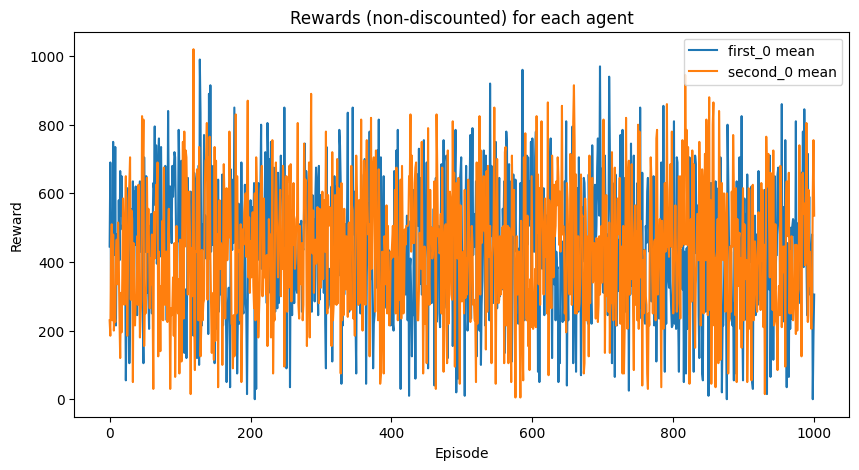

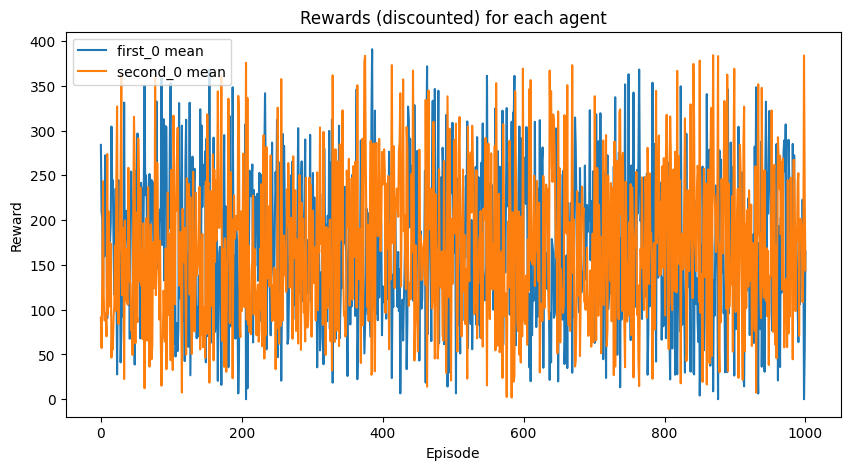

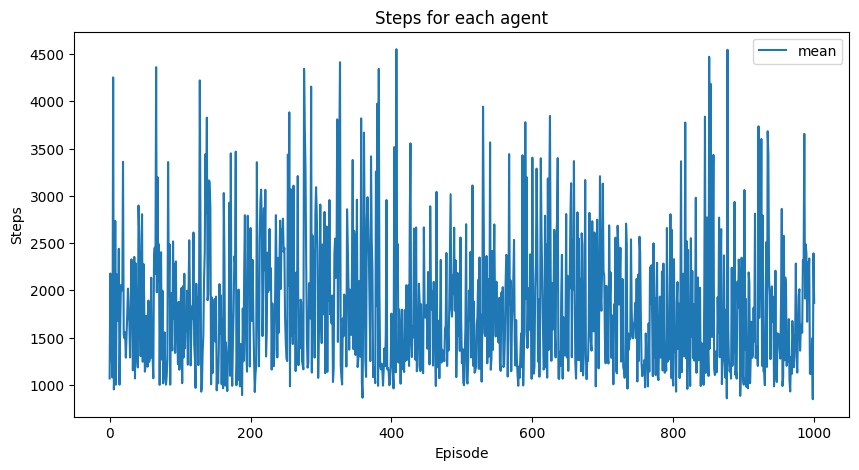

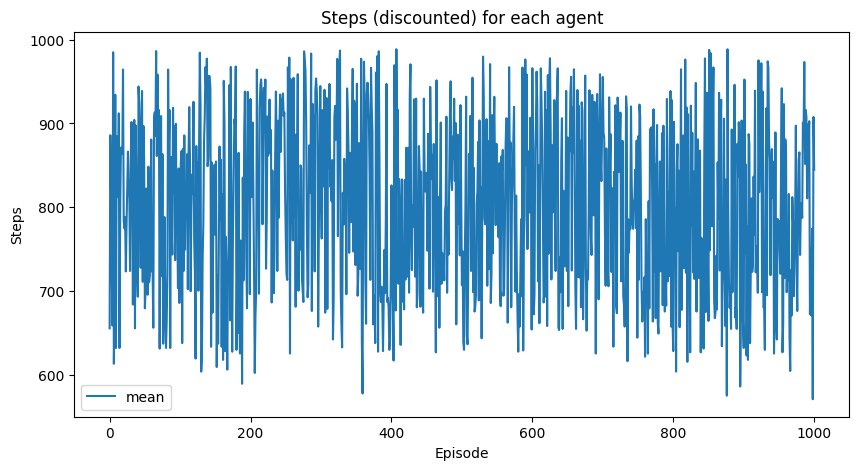

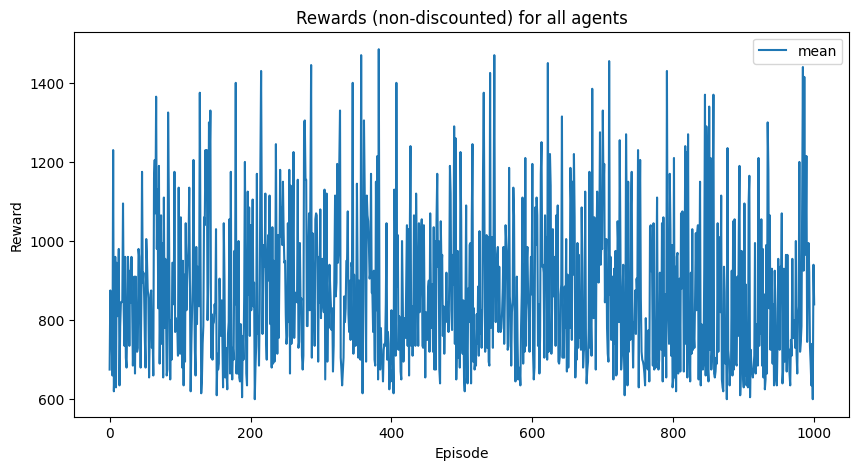

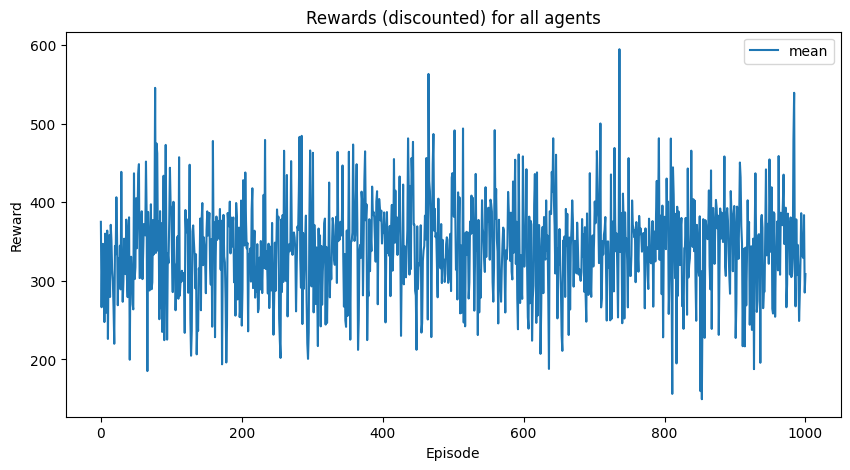

In [108]:
plot_graphs(ep_rewards_MAPPO, ep_rewards_d_MAPPO, ep_steps_MAPPO, ep_steps_d_MAPPO, ep_rewards_all_MAPPO, ep_rewards_d_all_MAPPO, agent_names, episode_count)

### Test the agent from the last experiment

In [122]:
episode_count = 100
gamma = 0.999

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_MAPPO_eff_{effnet}_pre_{pretrained}.pt"
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_Agent(num_actions=num_actions, num_frames=num_frames, num_agents=num_agents, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

ep_rewards_all_MAPPOr, ep_rewards_d_all_MAPPOr, ep_steps_MAPPOr = render_policy_MAPPO(env, agent_network, gamma, episode_count, device, record_video, video_prefix)

env.close()

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
New max reward: 1335.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test_max_reward_1335.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0_

## MAPPO Single Value function

In [96]:
class MAPPO_SV_Agent(PPO_Agent):
    def __init__(self, num_actions, num_frames, effnet=False, pretrained=False):
        super().__init__(num_actions, num_frames, effnet, pretrained)

        #actor networks
        self.actor1 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)
        self.actor2 = self._layer_init(nn.Linear(1280, num_actions), std=0.01)

    def get_action_and_value(self, x, first_agent, action=None):
        hidden = self.network(x / 133.0)
        if first_agent:
            logits = self.actor1(hidden)
        else:
            logits = self.actor2(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)



In [123]:
# function for a training single MAPPO experiment
def train_MAPPO_SV(parallel_env, agent_network, optimizer, intrinsic_reward, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)
    effnet = agent_network.effnet
    pretrained = agent_network.pretrained

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_SV_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network.get_action_and_value(obs[0:1], True)
                actions2, logprobs2, _, values2 = agent_network.get_action_and_value(obs[1:2], False)

                #check value should be the same for both agents
                assert np.array_equal(values.cpu().numpy(), values2.cpu().numpy())

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.cat((values, values2), dim=0)
                
                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]


                if intrinsic_reward:
                    rewards_step = {agent: 1 for agent in parallel_env.possible_agents}

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards_step, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])
                
                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index_even], True, b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network.get_action_and_value(
                        b_obs[batch_index_odd], False, b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value, value2), dim=0) #obtain the value for each agents
                    
                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    _, newlogprob, entropy, value = agent_network.get_action_and_value(
                        b_obs[batch_index], first_agent, b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return agent_network, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_MAPPO_SV(env, agent_network, gamma, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    
    ep_rewards_all = np.zeros(episode_count)
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf 

    with torch.no_grad():
        for ep in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_SV_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format
            
            #store current episode reward by comparing to previous max
            if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
                max_reward = ep_rewards_all[ep]
                print(f"New max reward: {max_reward}")
                video_writer.release()
                #copy video to new path set below by max_reward using shutil
                video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_MAPPO_SV_test_max_reward_{int(max_reward)}.avi")
                print(f"Moving video to {video_path_new}")
                shutil.move(video_path, video_path_new)

    return ep_rewards_all, ep_rewards_d_all, ep_steps

def render_policy_MAPPOir_SV(env, agent_network, gamma, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network.eval()
    
    ep_rewards_all = np.zeros(episode_count)
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf 

    with torch.no_grad():
        for ep in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_MAPPOir_SV_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network.get_action_and_value(obs[0:1], True)
                actions2, _, _, _ = agent_network.get_action_and_value(obs[1:2], False)
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format
            
            #store current episode reward by comparing to previous max
            if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
                max_reward = ep_rewards_all[ep]
                print(f"New max reward: {max_reward}")
                video_writer.release()
                #copy video to new path set below by max_reward using shutil
                video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_MAPPOir_SV_test_max_reward_{int(max_reward)}.avi")
                print(f"Moving video to {video_path_new}")
                shutil.move(video_path, video_path_new)

    return ep_rewards_all, ep_rewards_d_all, ep_steps

### With intrinsic reward

In [64]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 1001

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net
intrinsic_reward = True #use intrinsic reward step count

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPOSV = np.zeros((experiment_count, episode_count))

#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_irex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPOSV[i], ep_steps_d_MAPPOSV[i], ep_rewards_all_MAPPOSV[i], ep_rewards_d_all_MAPPOSV[i] = train_MAPPO_SV(env, agent_network, optimizer, intrinsic_reward, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPOSV['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPOSV['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPOSV['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPOSV['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_SVir_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPOSV_store = np.array([ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_SVir_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPOSV_store)


Experiment 0
Using device: cuda


  0%|          | 0/1001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/1001 [00:33<9:14:43, 33.28s/it]

Training episode 0
Episodic Return: 1100.0
Episodic Return Discounted: 462.18692252776157
Episode Length: 1350

Value Loss: 6377.68310546875
Policy Loss agent 1: -119.32151794433594
Policy Loss agent 2: -81.85243225097656
Old Approx KL: -0.015203130431473255
Approx KL: 0.0026519119273871183
Clip Fraction: 0.14424019607843136
Explained Variance: -0.001558542251586914

-------------------------------------------



  0%|          | 2/1001 [01:10<9:54:02, 35.68s/it]

Training episode 1
Episodic Return: 720.0
Episodic Return Discounted: 309.87709422634686
Episode Length: 1574

Value Loss: 2813.603759765625
Policy Loss agent 1: 37.15626525878906
Policy Loss agent 2: 38.07262420654297
Old Approx KL: 0.00886833667755127
Approx KL: 0.002350759459659457
Clip Fraction: 0.08339646466151633
Explained Variance: -0.005742311477661133

-------------------------------------------



  0%|          | 3/1001 [02:11<13:00:57, 46.95s/it]

Training episode 2
Episodic Return: 1010.0
Episodic Return Discounted: 325.2216266266838
Episode Length: 2576

Value Loss: 22747.3515625
Policy Loss agent 1: -161.23776245117188
Policy Loss agent 2: -196.94046020507812
Old Approx KL: -0.023617113009095192
Approx KL: 0.00268833851441741
Clip Fraction: 0.14064009666566277
Explained Variance: -0.003940939903259277

-------------------------------------------



  0%|          | 4/1001 [02:51<12:17:35, 44.39s/it]

Training episode 3
Episodic Return: 885.0
Episodic Return Discounted: 342.18552770086757
Episode Length: 1734

Value Loss: 1271.2784423828125
Policy Loss agent 1: -3.0691115856170654
Policy Loss agent 2: 28.895334243774414
Old Approx KL: 0.034598469734191895
Approx KL: 0.0020024776458740234
Clip Fraction: 0.11702981652743226
Explained Variance: -0.005784869194030762

-------------------------------------------



  0%|          | 5/1001 [04:16<16:18:00, 58.92s/it]

Training episode 4
Episodic Return: 1100.0
Episodic Return Discounted: 180.6406644748709
Episode Length: 3590

Value Loss: 11570.7451171875
Policy Loss agent 1: -92.82469940185547
Policy Loss agent 2: -113.44515228271484
Old Approx KL: 0.04084978252649307
Approx KL: 0.0022901238407939672
Clip Fraction: 0.21975925927912748
Explained Variance: -0.0049048662185668945

-------------------------------------------



  1%|          | 6/1001 [05:03<15:11:31, 54.97s/it]

Training episode 5
Episodic Return: 735.0
Episodic Return Discounted: 329.8003790676708
Episode Length: 1382

Value Loss: 29048.927734375
Policy Loss agent 1: 181.0321044921875
Policy Loss agent 2: 237.37257385253906
Old Approx KL: 0.05377810075879097
Approx KL: 0.004939281847327948
Clip Fraction: 0.2026101533480531
Explained Variance: -0.0011763572692871094

-------------------------------------------



  1%|          | 7/1001 [06:35<18:32:26, 67.15s/it]

Training episode 6
Episodic Return: 1000.0
Episodic Return Discounted: 307.49410426909566
Episode Length: 2432

Value Loss: 6661.90966796875
Policy Loss agent 1: -22.470245361328125
Policy Loss agent 2: -75.9307632446289
Old Approx KL: -0.02664184756577015
Approx KL: 0.0020047149155288935
Clip Fraction: 0.20826937138968915
Explained Variance: -0.006961464881896973

-------------------------------------------



  1%|          | 8/1001 [07:59<19:59:06, 72.45s/it]

Training episode 7
Episodic Return: 1150.0
Episodic Return Discounted: 336.69901759519337
Episode Length: 2592

Value Loss: 11222.9638671875
Policy Loss agent 1: -131.99171447753906
Policy Loss agent 2: -137.2495880126953
Old Approx KL: -0.036977045238018036
Approx KL: 0.007881253957748413
Clip Fraction: 0.27359396440011485
Explained Variance: -0.003160715103149414

-------------------------------------------



  1%|          | 9/1001 [09:46<22:54:24, 83.13s/it]

Training episode 8
Episodic Return: 1005.0
Episodic Return Discounted: 282.47651809367176
Episode Length: 3884

Value Loss: 55547.234375
Policy Loss agent 1: 304.9552001953125
Policy Loss agent 2: 314.5451965332031
Old Approx KL: 0.15825919806957245
Approx KL: 0.03215768188238144
Clip Fraction: 0.43652575137029787
Explained Variance: 5.239248275756836e-05

-------------------------------------------



  1%|          | 10/1001 [10:46<20:57:33, 76.14s/it]

Training episode 9
Episodic Return: 845.0
Episodic Return Discounted: 184.99162854541666
Episode Length: 2316

Value Loss: 24270.109375
Policy Loss agent 1: -246.58226013183594
Policy Loss agent 2: -208.6257781982422
Old Approx KL: -0.18701891601085663
Approx KL: 0.05006100982427597
Clip Fraction: 0.31937042854983233
Explained Variance: 0.00012856721878051758

-------------------------------------------



  1%|          | 11/1001 [11:15<16:56:01, 61.58s/it]

Training episode 10
Episodic Return: 680.0
Episodic Return Discounted: 344.30978608851836
Episode Length: 1098

Value Loss: 3984.693603515625
Policy Loss agent 1: 79.86860656738281
Policy Loss agent 2: 75.69657897949219
Old Approx KL: 0.05808088555932045
Approx KL: 0.011365589685738087
Clip Fraction: 0.2932769726367964
Explained Variance: -0.0005431175231933594

-------------------------------------------



  1%|          | 12/1001 [12:06<16:03:48, 58.47s/it]

Training episode 11
Episodic Return: 1010.0
Episodic Return Discounted: 386.15592495955786
Episode Length: 1872

Value Loss: 5169.845703125
Policy Loss agent 1: -112.720947265625
Policy Loss agent 2: -92.20828247070312
Old Approx KL: -0.09567321091890335
Approx KL: 0.01038623508065939
Clip Fraction: 0.3877789650292818
Explained Variance: 6.949901580810547e-05

-------------------------------------------



  1%|▏         | 13/1001 [12:54<15:08:30, 55.17s/it]

Training episode 12
Episodic Return: 860.0
Episodic Return Discounted: 363.544949240513
Episode Length: 1694

Value Loss: 12700.4521484375
Policy Loss agent 1: 154.0052947998047
Policy Loss agent 2: 126.67948913574219
Old Approx KL: 0.20778851211071014
Approx KL: 0.07234957069158554
Clip Fraction: 0.4843976780678491
Explained Variance: -0.0012763738632202148

-------------------------------------------



  1%|▏         | 14/1001 [13:26<13:13:19, 48.23s/it]

Training episode 13
Episodic Return: 750.0
Episodic Return Discounted: 360.9958898940828
Episode Length: 1232

Value Loss: 4316.8759765625
Policy Loss agent 1: -95.78588104248047
Policy Loss agent 2: -88.40497589111328
Old Approx KL: -0.135137140750885
Approx KL: 0.03022797591984272
Clip Fraction: 0.44569805225768644
Explained Variance: -0.001862645149230957

-------------------------------------------



  1%|▏         | 15/1001 [14:18<13:30:49, 49.34s/it]

Training episode 14
Episodic Return: 820.0
Episodic Return Discounted: 296.7850738603397
Episode Length: 2044

Value Loss: 1897.959228515625
Policy Loss agent 1: 40.32147979736328
Policy Loss agent 2: 49.736305236816406
Old Approx KL: 0.18077579140663147
Approx KL: 0.022905228659510612
Clip Fraction: 0.44733960709224146
Explained Variance: -0.003247857093811035

-------------------------------------------



  2%|▏         | 16/1001 [15:06<13:24:48, 49.02s/it]

Training episode 15
Episodic Return: 765.0
Episodic Return Discounted: 249.3578540584701
Episode Length: 1894

Value Loss: 8284.0654296875
Policy Loss agent 1: -114.33940887451172
Policy Loss agent 2: -145.4985809326172
Old Approx KL: -0.09042251110076904
Approx KL: 0.009044545702636242
Clip Fraction: 0.5400385153727705
Explained Variance: 0.0010401010513305664

-------------------------------------------



  2%|▏         | 17/1001 [15:36<11:49:09, 43.24s/it]

Training episode 16
Episodic Return: 700.0
Episodic Return Discounted: 357.73893186456775
Episode Length: 1146

Value Loss: 8072.5234375
Policy Loss agent 1: 105.61087799072266
Policy Loss agent 2: 105.19402313232422
Old Approx KL: 0.2902369499206543
Approx KL: 0.05587714910507202
Clip Fraction: 0.5807452419841731
Explained Variance: 0.0004966259002685547

-------------------------------------------



  2%|▏         | 18/1001 [16:15<11:26:50, 41.92s/it]

Training episode 17
Episodic Return: 790.0
Episodic Return Discounted: 355.2208681968795
Episode Length: 1490

Value Loss: 10238.931640625
Policy Loss agent 1: -133.10105895996094
Policy Loss agent 2: -178.63116455078125
Old Approx KL: -0.17060327529907227
Approx KL: 0.015860557556152344
Clip Fraction: 0.5837765957446809
Explained Variance: -0.0016542673110961914

-------------------------------------------



  2%|▏         | 19/1001 [17:33<14:23:40, 52.77s/it]

Training episode 18
Episodic Return: 1010.0
Episodic Return Discounted: 270.39813883624555
Episode Length: 3038

Value Loss: 20470.107421875
Policy Loss agent 1: 175.34938049316406
Policy Loss agent 2: 185.86680603027344
Old Approx KL: 0.17917051911354065
Approx KL: 0.036848340183496475
Clip Fraction: 0.6798920378350375
Explained Variance: -0.001300811767578125

-------------------------------------------



  2%|▏         | 20/1001 [19:31<19:44:20, 72.44s/it]

Training episode 19
Episodic Return: 1370.0
Episodic Return Discounted: 211.10902857981227
Episode Length: 4620

Value Loss: 34948.21875
Policy Loss agent 1: -286.1961669921875
Policy Loss agent 2: -272.7528076171875
Old Approx KL: -0.1810932159423828
Approx KL: 0.04632706195116043
Clip Fraction: 0.6093111041645415
Explained Variance: -0.00020563602447509766

-------------------------------------------



  2%|▏         | 21/1001 [19:59<16:06:48, 59.19s/it]

Training episode 20
Episodic Return: 690.0
Episodic Return Discounted: 365.62950797143446
Episode Length: 1080

Value Loss: 1531.581298828125
Policy Loss agent 1: 43.3155403137207
Policy Loss agent 2: 48.5535888671875
Old Approx KL: 0.1255245804786682
Approx KL: 0.00991312600672245
Clip Fraction: 0.32810311662215813
Explained Variance: 0.00027257204055786133

-------------------------------------------



  2%|▏         | 22/1001 [20:52<15:32:47, 57.17s/it]

Training episode 21
Episodic Return: 845.0
Episodic Return Discounted: 276.6439269698074
Episode Length: 2010

Value Loss: 4719.15673828125
Policy Loss agent 1: -96.3955307006836
Policy Loss agent 2: -104.91658020019531
Old Approx KL: -0.09947346895933151
Approx KL: 0.01577523723244667
Clip Fraction: 0.4755566579008859
Explained Variance: -0.0020842552185058594

-------------------------------------------



  2%|▏         | 23/1001 [21:35<14:24:23, 53.03s/it]

Training episode 22
Episodic Return: 865.0
Episodic Return Discounted: 351.57366476185797
Episode Length: 1666

Value Loss: 23238.41015625
Policy Loss agent 1: 155.16224670410156
Policy Loss agent 2: 149.0772247314453
Old Approx KL: 0.6782315373420715
Approx KL: 0.1927410066127777
Clip Fraction: 0.6648809523809524
Explained Variance: -0.0009114742279052734

-------------------------------------------



  2%|▏         | 24/1001 [22:29<14:29:10, 53.38s/it]

Training episode 23
Episodic Return: 1060.0
Episodic Return Discounted: 372.2687667967803
Episode Length: 2104

Value Loss: 7794.92333984375
Policy Loss agent 1: -141.67942810058594
Policy Loss agent 2: -98.27815246582031
Old Approx KL: -0.17502357065677643
Approx KL: 0.029236646369099617
Clip Fraction: 0.5342938312978456
Explained Variance: -0.004042506217956543

-------------------------------------------



  2%|▏         | 25/1001 [24:10<18:17:41, 67.48s/it]

Training episode 24
Episodic Return: 1200.0
Episodic Return Discounted: 202.2423507332633
Episode Length: 3940

Value Loss: 9590.3193359375
Policy Loss agent 1: 123.21583557128906
Policy Loss agent 2: 128.59152221679688
Old Approx KL: 0.23649750649929047
Approx KL: 0.04599633067846298
Clip Fraction: 0.5926956816321282
Explained Variance: -0.0019488334655761719

-------------------------------------------



  3%|▎         | 26/1001 [25:01<16:58:10, 62.66s/it]

Training episode 25
Episodic Return: 1160.0
Episodic Return Discounted: 472.4218831687845
Episode Length: 1998

Value Loss: 10893.28125
Policy Loss agent 1: -152.4702606201172
Policy Loss agent 2: -150.4549102783203
Old Approx KL: -0.22648966312408447
Approx KL: 0.05491740256547928
Clip Fraction: 0.5937371796766917
Explained Variance: 0.0009030699729919434

-------------------------------------------



  3%|▎         | 27/1001 [25:51<15:54:29, 58.80s/it]

Training episode 26
Episodic Return: 830.0
Episodic Return Discounted: 363.13329050113964
Episode Length: 1932

Value Loss: 3958.627197265625
Policy Loss agent 1: 76.68728637695312
Policy Loss agent 2: 69.45368957519531
Old Approx KL: 0.3495260775089264
Approx KL: 0.10120558738708496
Clip Fraction: 0.5427153770588646
Explained Variance: -0.0025902986526489258

-------------------------------------------



  3%|▎         | 28/1001 [27:10<17:33:27, 64.96s/it]

Training episode 27
Episodic Return: 1285.0
Episodic Return Discounted: 409.7693718044079
Episode Length: 3104

Value Loss: 7653.89599609375
Policy Loss agent 1: -133.95668029785156
Policy Loss agent 2: -123.69773864746094
Old Approx KL: -0.28336039185523987
Approx KL: 0.08914680778980255
Clip Fraction: 0.6199813862027171
Explained Variance: 0.00019240379333496094

-------------------------------------------



  3%|▎         | 29/1001 [28:04<16:39:43, 61.71s/it]

Training episode 28
Episodic Return: 1070.0
Episodic Return Discounted: 407.0141528043585
Episode Length: 2090

Value Loss: 6998.8369140625
Policy Loss agent 1: 87.14765167236328
Policy Loss agent 2: 98.5254898071289
Old Approx KL: 0.2637905776500702
Approx KL: 0.05335109680891037
Clip Fraction: 0.639003746230487
Explained Variance: -0.002247333526611328

-------------------------------------------



  3%|▎         | 30/1001 [28:31<13:46:55, 51.10s/it]

Training episode 29
Episodic Return: 665.0
Episodic Return Discounted: 388.69376169652173
Episode Length: 996

Value Loss: 7747.6240234375
Policy Loss agent 1: -156.55203247070312
Policy Loss agent 2: -40.04730224609375
Old Approx KL: -0.26214590668678284
Approx KL: 0.08806747198104858
Clip Fraction: 0.5663580247964809
Explained Variance: -0.0031157732009887695

-------------------------------------------



  3%|▎         | 31/1001 [29:59<16:46:21, 62.25s/it]

Training episode 30
Episodic Return: 1125.0
Episodic Return Discounted: 284.3921321995545
Episode Length: 3434

Value Loss: 1301.521484375
Policy Loss agent 1: 43.18544006347656
Policy Loss agent 2: 39.19612503051758
Old Approx KL: 0.24472257494926453
Approx KL: 0.038199592381715775
Clip Fraction: 0.596979974198711
Explained Variance: -0.006349921226501465

-------------------------------------------



  3%|▎         | 32/1001 [30:31<14:17:37, 53.10s/it]

Training episode 31
Episodic Return: 935.0
Episodic Return Discounted: 446.6251682001026
Episode Length: 1194

Value Loss: 5094.54345703125
Policy Loss agent 1: -97.24954223632812
Policy Loss agent 2: -104.80780792236328
Old Approx KL: -0.32681742310523987
Approx KL: 0.1074192151427269
Clip Fraction: 0.6276697532335918
Explained Variance: 0.0010527968406677246

-------------------------------------------



  3%|▎         | 33/1001 [31:24<14:17:02, 53.12s/it]

Training episode 32
Episodic Return: 1030.0
Episodic Return Discounted: 341.35866952668044
Episode Length: 2046

Value Loss: 1095.0640869140625
Policy Loss agent 1: 27.1662654876709
Policy Loss agent 2: 34.39044952392578
Old Approx KL: 0.20309023559093475
Approx KL: 0.04523107036948204
Clip Fraction: 0.5727539064052204
Explained Variance: -0.007956981658935547

-------------------------------------------



  3%|▎         | 34/1001 [32:09<13:38:09, 50.76s/it]

Training episode 33
Episodic Return: 875.0
Episodic Return Discounted: 376.4831053018665
Episode Length: 1736

Value Loss: 7275.68212890625
Policy Loss agent 1: -104.10472106933594
Policy Loss agent 2: -148.02642822265625
Old Approx KL: -0.22393138706684113
Approx KL: 0.06786811351776123
Clip Fraction: 0.6810015294165421
Explained Variance: 0.0012363791465759277

-------------------------------------------



  3%|▎         | 35/1001 [33:23<15:27:41, 57.62s/it]

Training episode 34
Episodic Return: 975.0
Episodic Return Discounted: 298.77719723066616
Episode Length: 2844

Value Loss: 11905.2001953125
Policy Loss agent 1: 114.2298812866211
Policy Loss agent 2: 128.33108520507812
Old Approx KL: 0.3706701099872589
Approx KL: 0.09752070158720016
Clip Fraction: 0.7471005703402815
Explained Variance: -0.003856182098388672

-------------------------------------------



  4%|▎         | 36/1001 [34:08<14:27:18, 53.93s/it]

Training episode 35
Episodic Return: 745.0
Episodic Return Discounted: 229.15825281861873
Episode Length: 1722

Value Loss: 11217.654296875
Policy Loss agent 1: -154.81884765625
Policy Loss agent 2: -141.40383911132812
Old Approx KL: -0.21590039134025574
Approx KL: 0.04994853213429451
Clip Fraction: 0.636102537682027
Explained Variance: 0.0004315376281738281

-------------------------------------------



  4%|▎         | 37/1001 [34:34<12:13:20, 45.64s/it]

Training episode 36
Episodic Return: 660.0
Episodic Return Discounted: 378.32291987152297
Episode Length: 996

Value Loss: 5564.2412109375
Policy Loss agent 1: 94.19061279296875
Policy Loss agent 2: 69.10911560058594
Old Approx KL: 0.3085356652736664
Approx KL: 0.07875008881092072
Clip Fraction: 0.6273148151301833
Explained Variance: -0.0062122344970703125

-------------------------------------------



  4%|▍         | 38/1001 [35:47<14:20:59, 53.64s/it]

Training episode 37
Episodic Return: 1015.0
Episodic Return Discounted: 287.4569761784308
Episode Length: 2810

Value Loss: 16309.81640625
Policy Loss agent 1: -176.91610717773438
Policy Loss agent 2: -203.07376098632812
Old Approx KL: -0.300830602645874
Approx KL: 0.07349684834480286
Clip Fraction: 0.6826467803030303
Explained Variance: 0.0008926987648010254

-------------------------------------------



  4%|▍         | 39/1001 [36:33<13:43:35, 51.37s/it]

Training episode 38
Episodic Return: 870.0
Episodic Return Discounted: 377.11892568792166
Episode Length: 1768

Value Loss: 1653.8521728515625
Policy Loss agent 1: 49.19043731689453
Policy Loss agent 2: 42.74946212768555
Old Approx KL: 0.15215270221233368
Approx KL: 0.017239827662706375
Clip Fraction: 0.5661465038766375
Explained Variance: -0.009472250938415527

-------------------------------------------



  4%|▍         | 40/1001 [37:37<14:45:34, 55.29s/it]

Training episode 39
Episodic Return: 1005.0
Episodic Return Discounted: 305.8419902330787
Episode Length: 2496

Value Loss: 5458.76904296875
Policy Loss agent 1: -111.8617172241211
Policy Loss agent 2: -102.4307861328125
Old Approx KL: -0.29457786679267883
Approx KL: 0.10209023207426071
Clip Fraction: 0.6463274576215663
Explained Variance: 8.64267349243164e-05

-------------------------------------------



  4%|▍         | 41/1001 [38:26<14:15:37, 53.48s/it]

Training episode 40
Episodic Return: 815.0
Episodic Return Discounted: 347.82244857241847
Episode Length: 1886

Value Loss: 18981.259765625
Policy Loss agent 1: 176.7214813232422
Policy Loss agent 2: 170.82215881347656
Old Approx KL: 0.5081168413162231
Approx KL: 0.17138804495334625
Clip Fraction: 0.7644841918500803
Explained Variance: -0.001753091812133789

-------------------------------------------



  4%|▍         | 42/1001 [39:55<17:01:34, 63.91s/it]

Training episode 41
Episodic Return: 1140.0
Episodic Return Discounted: 253.2400448361142
Episode Length: 3512

Value Loss: 14649.9140625
Policy Loss agent 1: -182.8463592529297
Policy Loss agent 2: -173.09556579589844
Old Approx KL: -0.3061304986476898
Approx KL: 0.11510256677865982
Clip Fraction: 0.6791531386700543
Explained Variance: 0.00020372867584228516

-------------------------------------------



  4%|▍         | 43/1001 [40:41<15:35:17, 58.58s/it]

Training episode 42
Episodic Return: 870.0
Episodic Return Discounted: 351.3312758995868
Episode Length: 1926

Value Loss: 3815.628173828125
Policy Loss agent 1: 63.95476150512695
Policy Loss agent 2: 75.04110717773438
Old Approx KL: 0.2738085687160492
Approx KL: 0.04724912717938423
Clip Fraction: 0.6084022039634794
Explained Variance: -0.005496025085449219

-------------------------------------------



  4%|▍         | 44/1001 [41:42<15:46:04, 59.32s/it]

Training episode 43
Episodic Return: 975.0
Episodic Return Discounted: 259.91667127040085
Episode Length: 2520

Value Loss: 7091.52392578125
Policy Loss agent 1: -133.28237915039062
Policy Loss agent 2: -116.28155517578125
Old Approx KL: -0.24928009510040283
Approx KL: 0.05262460932135582
Clip Fraction: 0.6233517933746934
Explained Variance: -0.0010820627212524414

-------------------------------------------



  4%|▍         | 45/1001 [42:57<17:02:31, 64.17s/it]

Training episode 44
Episodic Return: 1025.0
Episodic Return Discounted: 275.62610929512766
Episode Length: 3148

Value Loss: 12555.1435546875
Policy Loss agent 1: 146.9652099609375
Policy Loss agent 2: 130.77069091796875
Old Approx KL: 0.5033277273178101
Approx KL: 0.15220960974693298
Clip Fraction: 0.717889555517187
Explained Variance: -0.0027272701263427734

-------------------------------------------



  5%|▍         | 46/1001 [43:49<16:00:16, 60.33s/it]

Training episode 45
Episodic Return: 920.0
Episodic Return Discounted: 312.9009405421376
Episode Length: 2144

Value Loss: 15556.953125
Policy Loss agent 1: -179.4315643310547
Policy Loss agent 2: -168.83889770507812
Old Approx KL: -0.3323194086551666
Approx KL: 0.13699859380722046
Clip Fraction: 0.6888267001998958
Explained Variance: -0.0011222362518310547

-------------------------------------------



  5%|▍         | 47/1001 [44:35<14:50:24, 56.00s/it]

Training episode 46
Episodic Return: 775.0
Episodic Return Discounted: 327.26326208361365
Episode Length: 1938

Value Loss: 2730.995849609375
Policy Loss agent 1: 83.03233337402344
Policy Loss agent 2: 80.855224609375
Old Approx KL: 0.2899325489997864
Approx KL: 0.041419029235839844
Clip Fraction: 0.6121926229508197
Explained Variance: -0.004249215126037598

-------------------------------------------



  5%|▍         | 48/1001 [45:31<14:51:35, 56.13s/it]

Training episode 47
Episodic Return: 1105.0
Episodic Return Discounted: 354.30642400483384
Episode Length: 2372

Value Loss: 7315.705078125
Policy Loss agent 1: -148.0078125
Policy Loss agent 2: -108.8961181640625
Old Approx KL: -0.28313374519348145
Approx KL: 0.08423762023448944
Clip Fraction: 0.6482802014756256
Explained Variance: -0.0010470151901245117

-------------------------------------------



  5%|▍         | 49/1001 [46:27<14:50:15, 56.11s/it]

Training episode 48
Episodic Return: 955.0
Episodic Return Discounted: 327.98685660759133
Episode Length: 2358

Value Loss: 6745.72412109375
Policy Loss agent 1: 113.0905990600586
Policy Loss agent 2: 87.58467864990234
Old Approx KL: 0.3825467526912689
Approx KL: 0.08830627053976059
Clip Fraction: 0.6947494371047428
Explained Variance: -0.003191709518432617

-------------------------------------------



  5%|▍         | 50/1001 [46:54<12:30:30, 47.35s/it]

Training episode 49
Episodic Return: 650.0
Episodic Return Discounted: 359.9715168873846
Episode Length: 1092

Value Loss: 2863.27294921875
Policy Loss agent 1: -76.20980834960938
Policy Loss agent 2: -94.54082489013672
Old Approx KL: -0.3566676080226898
Approx KL: 0.11840474605560303
Clip Fraction: 0.5876107087745759
Explained Variance: -0.0004805326461791992

-------------------------------------------



  5%|▌         | 51/1001 [47:49<13:04:24, 49.54s/it]

Training episode 50
Episodic Return: 945.0
Episodic Return Discounted: 292.45579132128546
Episode Length: 2222

Value Loss: 885.8348388671875
Policy Loss agent 1: 31.958251953125
Policy Loss agent 2: 34.4571647644043
Old Approx KL: 0.20014019310474396
Approx KL: 0.02810519188642502
Clip Fraction: 0.5374815534058807
Explained Variance: -0.00955212116241455

-------------------------------------------



  5%|▌         | 52/1001 [48:36<12:54:03, 48.94s/it]

Training episode 51
Episodic Return: 920.0
Episodic Return Discounted: 388.00445281148245
Episode Length: 1942

Value Loss: 4988.67236328125
Policy Loss agent 1: -104.24946594238281
Policy Loss agent 2: -123.33148193359375
Old Approx KL: -0.41103631258010864
Approx KL: 0.13387298583984375
Clip Fraction: 0.6827185793978269
Explained Variance: 0.0013483166694641113

-------------------------------------------



  5%|▌         | 53/1001 [49:05<11:16:20, 42.81s/it]

Training episode 52
Episodic Return: 860.0
Episodic Return Discounted: 417.2211344679515
Episode Length: 1142

Value Loss: 13665.7490234375
Policy Loss agent 1: 140.04843139648438
Policy Loss agent 2: 168.2762451171875
Old Approx KL: 0.3649786412715912
Approx KL: 0.09147118777036667
Clip Fraction: 0.6870949075177863
Explained Variance: -0.0035175085067749023

-------------------------------------------



  5%|▌         | 54/1001 [49:50<11:27:15, 43.54s/it]

Training episode 53
Episodic Return: 1045.0
Episodic Return Discounted: 391.5330057519979
Episode Length: 1838

Value Loss: 5884.16845703125
Policy Loss agent 1: -125.10797882080078
Policy Loss agent 2: -93.68123626708984
Old Approx KL: -0.2886781692504883
Approx KL: 0.07411882281303406
Clip Fraction: 0.6593924194142439
Explained Variance: 0.0010260939598083496

-------------------------------------------



  5%|▌         | 55/1001 [51:22<15:15:36, 58.07s/it]

Training episode 54
Episodic Return: 1005.0
Episodic Return Discounted: 310.02996196386806
Episode Length: 3628

Value Loss: 7879.8916015625
Policy Loss agent 1: 113.36487579345703
Policy Loss agent 2: 109.94377136230469
Old Approx KL: 0.34402337670326233
Approx KL: 0.09416479617357254
Clip Fraction: 0.7561907623832972
Explained Variance: -0.003944993019104004

-------------------------------------------



  6%|▌         | 56/1001 [52:15<14:50:58, 56.57s/it]

Training episode 55
Episodic Return: 850.0
Episodic Return Discounted: 319.85546860525255
Episode Length: 2020

Value Loss: 12117.5888671875
Policy Loss agent 1: -100.18721008300781
Policy Loss agent 2: -165.9677276611328
Old Approx KL: -0.31271058320999146
Approx KL: 0.11917539685964584
Clip Fraction: 0.6884842521249466
Explained Variance: 0.00017368793487548828

-------------------------------------------



  6%|▌         | 57/1001 [52:51<13:10:51, 50.27s/it]

Training episode 56
Episodic Return: 770.0
Episodic Return Discounted: 340.8201268432648
Episode Length: 1354

Value Loss: 1310.2828369140625
Policy Loss agent 1: 32.52769470214844
Policy Loss agent 2: 47.60520553588867
Old Approx KL: 0.2150697559118271
Approx KL: 0.054314542561769485
Clip Fraction: 0.5014297386010488
Explained Variance: -0.01044011116027832

-------------------------------------------



  6%|▌         | 58/1001 [53:34<12:38:43, 48.28s/it]

Training episode 57
Episodic Return: 760.0
Episodic Return Discounted: 322.9200336355933
Episode Length: 1660

Value Loss: 3227.52001953125
Policy Loss agent 1: -75.07429504394531
Policy Loss agent 2: -90.1180419921875
Old Approx KL: -0.22657711803913116
Approx KL: 0.04399852827191353
Clip Fraction: 0.6129352419804304
Explained Variance: 0.0012034773826599121

-------------------------------------------



  6%|▌         | 59/1001 [54:48<14:40:08, 56.06s/it]

Training episode 58
Episodic Return: 1035.0
Episodic Return Discounted: 246.16964851305352
Episode Length: 2826

Value Loss: 3113.56103515625
Policy Loss agent 1: 69.62274932861328
Policy Loss agent 2: 64.4133529663086
Old Approx KL: 0.3676268756389618
Approx KL: 0.09743998199701309
Clip Fraction: 0.673159918318136
Explained Variance: -0.006730914115905762

-------------------------------------------



  6%|▌         | 60/1001 [55:38<14:08:51, 54.12s/it]

Training episode 59
Episodic Return: 810.0
Episodic Return Discounted: 317.7165847197472
Episode Length: 1874

Value Loss: 9640.9345703125
Policy Loss agent 1: -123.71919250488281
Policy Loss agent 2: -143.697021484375
Old Approx KL: -0.1705130934715271
Approx KL: 0.024137437343597412
Clip Fraction: 0.6899717514124294
Explained Variance: 0.0015049576759338379

-------------------------------------------



  6%|▌         | 61/1001 [56:26<13:37:47, 52.20s/it]

Training episode 60
Episodic Return: 1050.0
Episodic Return Discounted: 458.7361638841142
Episode Length: 1826

Value Loss: 9493.0703125
Policy Loss agent 1: 117.72685241699219
Policy Loss agent 2: 130.16348266601562
Old Approx KL: 0.5216217041015625
Approx KL: 0.1370428502559662
Clip Fraction: 0.6984601449275363
Explained Variance: -0.004264235496520996

-------------------------------------------



  6%|▌         | 62/1001 [57:15<13:23:01, 51.31s/it]

Training episode 61
Episodic Return: 1025.0
Episodic Return Discounted: 399.6034088984197
Episode Length: 1888

Value Loss: 11625.2568359375
Policy Loss agent 1: -150.54881286621094
Policy Loss agent 2: -169.2349090576172
Old Approx KL: -0.3908996284008026
Approx KL: 0.16217833757400513
Clip Fraction: 0.7093691152367888
Explained Variance: -4.410743713378906e-06

-------------------------------------------



  6%|▋         | 63/1001 [57:55<12:30:23, 48.00s/it]

Training episode 62
Episodic Return: 700.0
Episodic Return Discounted: 257.9048455980039
Episode Length: 1532

Value Loss: 5353.75048828125
Policy Loss agent 1: 74.48612213134766
Policy Loss agent 2: 100.60640716552734
Old Approx KL: 0.27610644698143005
Approx KL: 0.051235124468803406
Clip Fraction: 0.6644176139185826
Explained Variance: -0.0025489330291748047

-------------------------------------------



  6%|▋         | 64/1001 [58:48<12:52:21, 49.46s/it]

Training episode 63
Episodic Return: 920.0
Episodic Return Discounted: 322.59550463645854
Episode Length: 2040

Value Loss: 8494.509765625
Policy Loss agent 1: -144.70489501953125
Policy Loss agent 2: -133.71182250976562
Old Approx KL: -0.36021098494529724
Approx KL: 0.10841688513755798
Clip Fraction: 0.6901390440762043
Explained Variance: 0.0010353922843933105

-------------------------------------------



  6%|▋         | 65/1001 [59:34<12:32:54, 48.26s/it]

Training episode 64
Episodic Return: 875.0
Episodic Return Discounted: 367.120825417543
Episode Length: 1754

Value Loss: 1983.364990234375
Policy Loss agent 1: 46.20965576171875
Policy Loss agent 2: 60.26691436767578
Old Approx KL: 0.2169322520494461
Approx KL: 0.03139359876513481
Clip Fraction: 0.6239793772047216
Explained Variance: -0.0051947832107543945

-------------------------------------------



  7%|▋         | 66/1001 [1:00:41<14:02:57, 54.09s/it]

Training episode 65
Episodic Return: 1065.0
Episodic Return Discounted: 254.4749212286245
Episode Length: 2654

Value Loss: 6020.408203125
Policy Loss agent 1: -105.67755126953125
Policy Loss agent 2: -121.79877471923828
Old Approx KL: -0.27465954422950745
Approx KL: 0.07689480483531952
Clip Fraction: 0.6689546650432678
Explained Variance: -0.0004553794860839844

-------------------------------------------



  7%|▋         | 67/1001 [1:01:11<12:10:34, 46.93s/it]

Training episode 66
Episodic Return: 685.0
Episodic Return Discounted: 365.54961681914546
Episode Length: 1142

Value Loss: 8302.4833984375
Policy Loss agent 1: 136.635498046875
Policy Loss agent 2: 88.71843719482422
Old Approx KL: 0.28966033458709717
Approx KL: 0.06253168731927872
Clip Fraction: 0.7238136574074074
Explained Variance: -0.0006095170974731445

-------------------------------------------



  7%|▋         | 68/1001 [1:01:58<12:07:04, 46.76s/it]

Training episode 67
Episodic Return: 880.0
Episodic Return Discounted: 363.2632417340068
Episode Length: 1786

Value Loss: 3606.584228515625
Policy Loss agent 1: -97.01187133789062
Policy Loss agent 2: -83.76316833496094
Old Approx KL: -0.3168594539165497
Approx KL: 0.12859481573104858
Clip Fraction: 0.6110491072315545
Explained Variance: -0.0031458139419555664

-------------------------------------------



  7%|▋         | 69/1001 [1:03:28<15:29:57, 59.87s/it]

Training episode 68
Episodic Return: 1275.0
Episodic Return Discounted: 265.23561623915344
Episode Length: 3494

Value Loss: 10038.181640625
Policy Loss agent 1: 131.67820739746094
Policy Loss agent 2: 116.8548583984375
Old Approx KL: 0.4043196737766266
Approx KL: 0.10003405064344406
Clip Fraction: 0.7670947489310255
Explained Variance: 0.00017714500427246094

-------------------------------------------



  7%|▋         | 70/1001 [1:04:28<15:29:21, 59.89s/it]

Training episode 69
Episodic Return: 995.0
Episodic Return Discounted: 340.00610239188677
Episode Length: 2280

Value Loss: 12236.962890625
Policy Loss agent 1: -147.1568603515625
Policy Loss agent 2: -169.4772491455078
Old Approx KL: -0.3357175290584564
Approx KL: 0.09824710339307785
Clip Fraction: 0.6908716285701121
Explained Variance: -0.0005282163619995117

-------------------------------------------



  7%|▋         | 71/1001 [1:05:11<14:08:52, 54.77s/it]

Training episode 70
Episodic Return: 700.0
Episodic Return Discounted: 278.9682841989967
Episode Length: 1518

Value Loss: 1844.528564453125
Policy Loss agent 1: 57.35417938232422
Policy Loss agent 2: 42.283226013183594
Old Approx KL: 0.1594771444797516
Approx KL: 0.023010877892374992
Clip Fraction: 0.5009615385741518
Explained Variance: -0.005837202072143555

-------------------------------------------



  7%|▋         | 72/1001 [1:05:45<12:32:40, 48.61s/it]

Training episode 71
Episodic Return: 695.0
Episodic Return Discounted: 358.01763744749053
Episode Length: 1314

Value Loss: 5052.61181640625
Policy Loss agent 1: -99.36510467529297
Policy Loss agent 2: -120.95315551757812
Old Approx KL: -0.29254573583602905
Approx KL: 0.05303925275802612
Clip Fraction: 0.5711596385542169
Explained Variance: -0.0006269216537475586

-------------------------------------------



  7%|▋         | 73/1001 [1:06:15<11:05:17, 43.01s/it]

Training episode 72
Episodic Return: 725.0
Episodic Return Discounted: 368.99172845443724
Episode Length: 1144

Value Loss: 2555.46435546875
Policy Loss agent 1: 54.82831954956055
Policy Loss agent 2: 69.46488952636719
Old Approx KL: 0.28299200534820557
Approx KL: 0.060739487409591675
Clip Fraction: 0.6442832347971422
Explained Variance: -0.0032804012298583984

-------------------------------------------



  7%|▋         | 74/1001 [1:07:20<12:45:54, 49.57s/it]

Training episode 73
Episodic Return: 1300.0
Episodic Return Discounted: 397.0440322037435
Episode Length: 2520

Value Loss: 5771.8486328125
Policy Loss agent 1: -95.50141143798828
Policy Loss agent 2: -134.1827392578125
Old Approx KL: -0.22514888644218445
Approx KL: 0.042896170169115067
Clip Fraction: 0.6750866488439624
Explained Variance: 0.00011229515075683594

-------------------------------------------



  7%|▋         | 75/1001 [1:08:06<12:28:01, 48.47s/it]

Training episode 74
Episodic Return: 755.0
Episodic Return Discounted: 251.34758533506937
Episode Length: 1774

Value Loss: 6824.115234375
Policy Loss agent 1: 90.62788391113281
Policy Loss agent 2: 112.21260070800781
Old Approx KL: 0.3848298192024231
Approx KL: 0.09213127940893173
Clip Fraction: 0.6928707556323604
Explained Variance: -0.001746058464050293

-------------------------------------------



  8%|▊         | 76/1001 [1:08:35<10:57:18, 42.64s/it]

Training episode 75
Episodic Return: 685.0
Episodic Return Discounted: 347.3854565584128
Episode Length: 1094

Value Loss: 4473.93115234375
Policy Loss agent 1: -125.35035705566406
Policy Loss agent 2: -81.3227767944336
Old Approx KL: -0.20696531236171722
Approx KL: 0.04347233846783638
Clip Fraction: 0.6108997583677227
Explained Variance: -0.0009731054306030273

-------------------------------------------



  8%|▊         | 77/1001 [1:09:06<10:02:06, 39.10s/it]

Training episode 76
Episodic Return: 710.0
Episodic Return Discounted: 358.3978361211708
Episode Length: 1184

Value Loss: 1057.3299560546875
Policy Loss agent 1: 36.84025192260742
Policy Loss agent 2: 29.931007385253906
Old Approx KL: 0.2158425748348236
Approx KL: 0.031141741201281548
Clip Fraction: 0.4804429433367274
Explained Variance: -0.009709835052490234

-------------------------------------------



  8%|▊         | 78/1001 [1:09:57<10:58:03, 42.78s/it]

Training episode 77
Episodic Return: 795.0
Episodic Return Discounted: 317.6470134638573
Episode Length: 1972

Value Loss: 4658.7763671875
Policy Loss agent 1: -93.33860778808594
Policy Loss agent 2: -111.2393798828125
Old Approx KL: -0.33149439096450806
Approx KL: 0.12630966305732727
Clip Fraction: 0.6593581990849587
Explained Variance: -0.000527501106262207

-------------------------------------------



  8%|▊         | 79/1001 [1:10:51<11:49:46, 46.19s/it]

Training episode 78
Episodic Return: 845.0
Episodic Return Discounted: 249.37339673925914
Episode Length: 2098

Value Loss: 9911.4697265625
Policy Loss agent 1: 84.86787414550781
Policy Loss agent 2: 89.84876251220703
Old Approx KL: 0.672336220741272
Approx KL: 0.20412299036979675
Clip Fraction: 0.6877367424242424
Explained Variance: -0.00471949577331543

-------------------------------------------



  8%|▊         | 80/1001 [1:11:18<10:20:52, 40.45s/it]

Training episode 79
Episodic Return: 685.0
Episodic Return Discounted: 381.7657307586178
Episode Length: 994

Value Loss: 2647.92626953125
Policy Loss agent 1: -72.54129028320312
Policy Loss agent 2: -87.11385345458984
Old Approx KL: -0.13533395528793335
Approx KL: 0.009872019290924072
Clip Fraction: 0.6147486772486772
Explained Variance: 0.0005843043327331543

-------------------------------------------



  8%|▊         | 81/1001 [1:12:43<13:43:14, 53.69s/it]

Training episode 80
Episodic Return: 1090.0
Episodic Return Discounted: 209.62539144142045
Episode Length: 3296

Value Loss: 138.53125
Policy Loss agent 1: 8.344408988952637
Policy Loss agent 2: 4.35735559463501
Old Approx KL: 0.08276893943548203
Approx KL: 0.023145128041505814
Clip Fraction: 0.41021777253031344
Explained Variance: -0.011432170867919922

-------------------------------------------



  8%|▊         | 82/1001 [1:13:29<13:05:14, 51.27s/it]

Training episode 81
Episodic Return: 970.0
Episodic Return Discounted: 459.4206877534444
Episode Length: 1778

Value Loss: 863.7645874023438
Policy Loss agent 1: -59.849037170410156
Policy Loss agent 2: -24.845966339111328
Old Approx KL: -0.24463272094726562
Approx KL: 0.043537139892578125
Clip Fraction: 0.6184895833333334
Explained Variance: -0.0005893707275390625

-------------------------------------------



  8%|▊         | 83/1001 [1:14:18<12:55:50, 50.71s/it]

Training episode 82
Episodic Return: 885.0
Episodic Return Discounted: 366.09698696263786
Episode Length: 1918

Value Loss: 13916.7900390625
Policy Loss agent 1: 150.321533203125
Policy Loss agent 2: 132.99468994140625
Old Approx KL: 0.6087493896484375
Approx KL: 0.31757861375808716
Clip Fraction: 0.7928819446100129
Explained Variance: -0.0025271177291870117

-------------------------------------------



  8%|▊         | 84/1001 [1:14:51<11:31:58, 45.28s/it]

Training episode 83
Episodic Return: 755.0
Episodic Return Discounted: 394.96131243332223
Episode Length: 1232

Value Loss: 10922.61328125
Policy Loss agent 1: -154.08058166503906
Policy Loss agent 2: -146.97955322265625
Old Approx KL: -0.29727619886398315
Approx KL: 0.08297577500343323
Clip Fraction: 0.6728084420228934
Explained Variance: -0.0016080141067504883

-------------------------------------------



  8%|▊         | 85/1001 [1:15:50<12:35:38, 49.50s/it]

Training episode 84
Episodic Return: 1155.0
Episodic Return Discounted: 371.35213676862094
Episode Length: 2236

Value Loss: 1032.9810791015625
Policy Loss agent 1: 41.63753890991211
Policy Loss agent 2: 36.55754852294922
Old Approx KL: 0.3939265310764313
Approx KL: 0.11547555029392242
Clip Fraction: 0.5763933982877504
Explained Variance: -0.0064858198165893555

-------------------------------------------



  9%|▊         | 86/1001 [1:16:19<10:58:52, 43.21s/it]

Training episode 85
Episodic Return: 910.0
Episodic Return Discounted: 415.24872584959536
Episode Length: 1168

Value Loss: 5662.408203125
Policy Loss agent 1: -108.60433959960938
Policy Loss agent 2: -106.40391540527344
Old Approx KL: -0.3160756230354309
Approx KL: 0.1234603300690651
Clip Fraction: 0.6329718419950302
Explained Variance: -0.0004788637161254883

-------------------------------------------



  9%|▊         | 87/1001 [1:16:42<9:29:11, 37.37s/it] 

Training episode 86
Episodic Return: 610.0
Episodic Return Discounted: 349.8860605010267
Episode Length: 958

Value Loss: 4404.388671875
Policy Loss agent 1: 75.67475891113281
Policy Loss agent 2: 75.84027099609375
Old Approx KL: 0.4287964403629303
Approx KL: 0.1158410981297493
Clip Fraction: 0.6579594022697872
Explained Variance: -0.005408167839050293

-------------------------------------------



  9%|▉         | 88/1001 [1:17:11<8:50:30, 34.86s/it]

Training episode 87
Episodic Return: 665.0
Episodic Return Discounted: 342.6785893728557
Episode Length: 1200

Value Loss: 3196.06689453125
Policy Loss agent 1: -66.90272521972656
Policy Loss agent 2: -86.39105987548828
Old Approx KL: -0.3444576561450958
Approx KL: 0.2066558450460434
Clip Fraction: 0.6199351859092712
Explained Variance: 0.00023245811462402344

-------------------------------------------



  9%|▉         | 89/1001 [1:18:08<10:30:18, 41.47s/it]

Training episode 88
Episodic Return: 940.0
Episodic Return Discounted: 249.3047316535241
Episode Length: 2374

Value Loss: 591.6725463867188
Policy Loss agent 1: 13.736041069030762
Policy Loss agent 2: 27.314382553100586
Old Approx KL: 0.17442840337753296
Approx KL: 0.03332134708762169
Clip Fraction: 0.474314877050835
Explained Variance: -0.009990453720092773

-------------------------------------------



  9%|▉         | 90/1001 [1:18:50<10:31:35, 41.60s/it]

Training episode 89
Episodic Return: 935.0
Episodic Return Discounted: 362.25568830130464
Episode Length: 1748

Value Loss: 103.16363525390625
Policy Loss agent 1: -14.08778190612793
Policy Loss agent 2: -14.304100036621094
Old Approx KL: -0.15976032614707947
Approx KL: 0.017991602420806885
Clip Fraction: 0.4528093435547569
Explained Variance: -0.0072743892669677734

-------------------------------------------



  9%|▉         | 91/1001 [1:19:30<10:25:06, 41.22s/it]

Training episode 90
Episodic Return: 810.0
Episodic Return Discounted: 324.3859230669177
Episode Length: 1676

Value Loss: 349.0030212402344
Policy Loss agent 1: 18.112499237060547
Policy Loss agent 2: 21.916358947753906
Old Approx KL: 0.17064321041107178
Approx KL: 0.03349906578660011
Clip Fraction: 0.5555826119014196
Explained Variance: -0.003927707672119141

-------------------------------------------



  9%|▉         | 92/1001 [1:20:08<10:07:46, 40.12s/it]

Training episode 91
Episodic Return: 740.0
Episodic Return Discounted: 335.13776283695165
Episode Length: 1562

Value Loss: 5691.29541015625
Policy Loss agent 1: -118.8133544921875
Policy Loss agent 2: -92.09545135498047
Old Approx KL: -0.21974341571331024
Approx KL: 0.052192967385053635
Clip Fraction: 0.7288832200222275
Explained Variance: -0.0018889904022216797

-------------------------------------------



  9%|▉         | 93/1001 [1:20:38<9:19:28, 36.97s/it] 

Training episode 92
Episodic Return: 840.0
Episodic Return Discounted: 423.7892498768619
Episode Length: 1188

Value Loss: 6759.7412109375
Policy Loss agent 1: 77.36054992675781
Policy Loss agent 2: 120.88590240478516
Old Approx KL: 0.5485236644744873
Approx KL: 0.179358571767807
Clip Fraction: 0.6906944447093539
Explained Variance: -0.002926945686340332

-------------------------------------------



  9%|▉         | 94/1001 [1:21:05<8:34:11, 34.01s/it]

Training episode 93
Episodic Return: 635.0
Episodic Return Discounted: 347.5113080479501
Episode Length: 1114

Value Loss: 3274.021484375
Policy Loss agent 1: -47.290138244628906
Policy Loss agent 2: -88.09220886230469
Old Approx KL: -0.16409249603748322
Approx KL: 0.03208019584417343
Clip Fraction: 0.6306051586355482
Explained Variance: -0.0024182796478271484

-------------------------------------------



  9%|▉         | 95/1001 [1:21:47<9:12:57, 36.62s/it]

Training episode 94
Episodic Return: 740.0
Episodic Return Discounted: 340.73617581950526
Episode Length: 1748

Value Loss: 3225.46044921875
Policy Loss agent 1: 66.19808959960938
Policy Loss agent 2: 80.05391693115234
Old Approx KL: 0.31045693159103394
Approx KL: 0.04711976647377014
Clip Fraction: 0.6783775253729387
Explained Variance: -0.0008013248443603516

-------------------------------------------



 10%|▉         | 96/1001 [1:22:18<8:46:13, 34.89s/it]

Training episode 95
Episodic Return: 680.0
Episodic Return Discounted: 355.9054759351027
Episode Length: 1260

Value Loss: 6016.15380859375
Policy Loss agent 1: -105.5522232055664
Policy Loss agent 2: -107.01172637939453
Old Approx KL: -0.2840830087661743
Approx KL: 0.08137381076812744
Clip Fraction: 0.668956175886629
Explained Variance: -0.001229405403137207

-------------------------------------------



 10%|▉         | 97/1001 [1:22:59<9:11:03, 36.57s/it]

Training episode 96
Episodic Return: 785.0
Episodic Return Discounted: 339.30626920201945
Episode Length: 1670

Value Loss: 912.9566650390625
Policy Loss agent 1: 28.446441650390625
Policy Loss agent 2: 41.472625732421875
Old Approx KL: 0.33219146728515625
Approx KL: 0.08347490429878235
Clip Fraction: 0.5674007936602548
Explained Variance: -0.006125688552856445

-------------------------------------------



 10%|▉         | 98/1001 [1:23:47<10:01:11, 39.95s/it]

Training episode 97
Episodic Return: 845.0
Episodic Return Discounted: 299.0135990804659
Episode Length: 1990

Value Loss: 4281.783203125
Policy Loss agent 1: -122.0283203125
Policy Loss agent 2: -76.03250122070312
Old Approx KL: -0.29653823375701904
Approx KL: 0.12314629554748535
Clip Fraction: 0.6943333334922791
Explained Variance: -0.0004750490188598633

-------------------------------------------



 10%|▉         | 99/1001 [1:24:23<9:46:24, 39.01s/it] 

Training episode 98
Episodic Return: 860.0
Episodic Return Discounted: 371.19769015270003
Episode Length: 1530

Value Loss: 5357.0185546875
Policy Loss agent 1: 85.89298248291016
Policy Loss agent 2: 88.30571746826172
Old Approx KL: 0.40475818514823914
Approx KL: 0.10811027139425278
Clip Fraction: 0.728515625
Explained Variance: -0.0023828744888305664

-------------------------------------------



 10%|▉         | 100/1001 [1:25:02<9:42:14, 38.77s/it]

Training episode 99
Episodic Return: 795.0
Episodic Return Discounted: 370.1782857596155
Episode Length: 1558

Value Loss: 4659.00634765625
Policy Loss agent 1: -93.922119140625
Policy Loss agent 2: -102.70759582519531
Old Approx KL: -0.34103700518608093
Approx KL: 0.12836246192455292
Clip Fraction: 0.6476828232914412
Explained Variance: -0.000992417335510254

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_100_gamma_0.999.avi


 10%|█         | 101/1001 [1:25:59<11:04:40, 44.31s/it]

Training episode 100
Episodic Return: 940.0
Episodic Return Discounted: 312.3872573307921
Episode Length: 2320

Value Loss: 4047.17578125
Policy Loss agent 1: 82.6150894165039
Policy Loss agent 2: 77.36668395996094
Old Approx KL: 0.4174388349056244
Approx KL: 0.1112220287322998
Clip Fraction: 0.7109578546436354
Explained Variance: -0.0005509853363037109

-------------------------------------------



 10%|█         | 102/1001 [1:26:44<11:07:00, 44.52s/it]

Training episode 101
Episodic Return: 805.0
Episodic Return Discounted: 269.0960924421637
Episode Length: 1822

Value Loss: 10780.625
Policy Loss agent 1: -147.11929321289062
Policy Loss agent 2: -154.12741088867188
Old Approx KL: -0.3236139416694641
Approx KL: 0.1395454853773117
Clip Fraction: 0.6839364038573371
Explained Variance: -0.0011603832244873047

-------------------------------------------



 10%|█         | 103/1001 [1:27:44<12:15:38, 49.15s/it]

Training episode 102
Episodic Return: 1155.0
Episodic Return Discounted: 412.6975943228291
Episode Length: 2454

Value Loss: 1636.916015625
Policy Loss agent 1: 49.64679718017578
Policy Loss agent 2: 48.6589469909668
Old Approx KL: 0.19773417711257935
Approx KL: 0.021614814177155495
Clip Fraction: 0.5991477273501359
Explained Variance: -0.00279843807220459

-------------------------------------------



 10%|█         | 104/1001 [1:28:49<13:24:34, 53.82s/it]

Training episode 103
Episodic Return: 995.0
Episodic Return Discounted: 305.802119824458
Episode Length: 2644

Value Loss: 8707.9052734375
Policy Loss agent 1: -120.38726043701172
Policy Loss agent 2: -154.1728973388672
Old Approx KL: -0.4145554304122925
Approx KL: 0.20560219883918762
Clip Fraction: 0.69139056230884
Explained Variance: 0.0007348060607910156

-------------------------------------------



 10%|█         | 105/1001 [1:29:25<12:05:31, 48.58s/it]

Training episode 104
Episodic Return: 710.0
Episodic Return Discounted: 371.9591963953721
Episode Length: 1142

Value Loss: 2559.12353515625
Policy Loss agent 1: 75.05709075927734
Policy Loss agent 2: 54.4346809387207
Old Approx KL: 0.1024741679430008
Approx KL: 0.017596537247300148
Clip Fraction: 0.5447048613870585
Explained Variance: -0.007184743881225586

-------------------------------------------



 11%|█         | 106/1001 [1:30:12<11:57:00, 48.07s/it]

Training episode 105
Episodic Return: 805.0
Episodic Return Discounted: 278.38128206843624
Episode Length: 1770

Value Loss: 2262.014892578125
Policy Loss agent 1: -62.95573043823242
Policy Loss agent 2: -65.05136108398438
Old Approx KL: -0.18815091252326965
Approx KL: 0.05612621083855629
Clip Fraction: 0.610193526959634
Explained Variance: -0.00039374828338623047

-------------------------------------------



 11%|█         | 107/1001 [1:31:01<12:01:51, 48.45s/it]

Training episode 106
Episodic Return: 965.0
Episodic Return Discounted: 408.14798459094993
Episode Length: 1552

Value Loss: 6709.712890625
Policy Loss agent 1: 97.75518798828125
Policy Loss agent 2: 94.807861328125
Old Approx KL: 0.5138001441955566
Approx KL: 0.1633952558040619
Clip Fraction: 0.690607102466203
Explained Variance: -0.004507184028625488

-------------------------------------------



 11%|█         | 108/1001 [1:31:44<11:37:23, 46.86s/it]

Training episode 107
Episodic Return: 965.0
Episodic Return Discounted: 407.5126097724904
Episode Length: 1558

Value Loss: 5554.48095703125
Policy Loss agent 1: -116.24134826660156
Policy Loss agent 2: -108.40966796875
Old Approx KL: -0.5058178901672363
Approx KL: 0.23901529610157013
Clip Fraction: 0.6520620748704794
Explained Variance: 6.687641143798828e-05

-------------------------------------------



 11%|█         | 109/1001 [1:32:31<11:34:56, 46.74s/it]

Training episode 108
Episodic Return: 1010.0
Episodic Return Discounted: 397.8594086034794
Episode Length: 1722

Value Loss: 3954.21435546875
Policy Loss agent 1: 78.20956420898438
Policy Loss agent 2: 71.67840576171875
Old Approx KL: 0.508400022983551
Approx KL: 0.2278134822845459
Clip Fraction: 0.6882608884278639
Explained Variance: -0.004296302795410156

-------------------------------------------



 11%|█         | 110/1001 [1:33:09<10:57:41, 44.29s/it]

Training episode 109
Episodic Return: 770.0
Episodic Return Discounted: 363.63309716863927
Episode Length: 1554

Value Loss: 4570.837890625
Policy Loss agent 1: -123.35882568359375
Policy Loss agent 2: -62.42689895629883
Old Approx KL: -0.0670555830001831
Approx KL: 0.004431188106536865
Clip Fraction: 0.6456207482993197
Explained Variance: -0.0006688833236694336

-------------------------------------------



 11%|█         | 111/1001 [1:34:03<11:38:55, 47.12s/it]

Training episode 110
Episodic Return: 990.0
Episodic Return Discounted: 305.76222238029095
Episode Length: 2148

Value Loss: 3144.181640625
Policy Loss agent 1: 75.52655029296875
Policy Loss agent 2: 39.953739166259766
Old Approx KL: 0.3242189288139343
Approx KL: 0.07728379219770432
Clip Fraction: 0.7108796296296296
Explained Variance: -0.002455472946166992

-------------------------------------------



 11%|█         | 112/1001 [1:35:02<12:29:27, 50.58s/it]

Training episode 111
Episodic Return: 1210.0
Episodic Return Discounted: 296.97944540046433
Episode Length: 2376

Value Loss: 6807.8818359375
Policy Loss agent 1: -130.69566345214844
Policy Loss agent 2: -106.42550659179688
Old Approx KL: -0.2238699495792389
Approx KL: 0.09554998576641083
Clip Fraction: 0.689996804300304
Explained Variance: -0.0004856586456298828

-------------------------------------------



 11%|█▏        | 113/1001 [1:35:50<12:20:34, 50.04s/it]

Training episode 112
Episodic Return: 820.0
Episodic Return Discounted: 326.60745186010735
Episode Length: 1784

Value Loss: 2531.966064453125
Policy Loss agent 1: 44.94198226928711
Policy Loss agent 2: 56.62899398803711
Old Approx KL: 0.31339871883392334
Approx KL: 0.07846137881278992
Clip Fraction: 0.5820179638408479
Explained Variance: -0.0058623552322387695

-------------------------------------------



 11%|█▏        | 114/1001 [1:36:45<12:38:23, 51.30s/it]

Training episode 113
Episodic Return: 930.0
Episodic Return Discounted: 331.8717504634309
Episode Length: 1994

Value Loss: 5053.39306640625
Policy Loss agent 1: -121.0286865234375
Policy Loss agent 2: -91.89949035644531
Old Approx KL: -0.28682395815849304
Approx KL: 0.10207844525575638
Clip Fraction: 0.6725925925572713
Explained Variance: 7.3909759521484375e-06

-------------------------------------------



 11%|█▏        | 115/1001 [1:37:27<11:57:52, 48.61s/it]

Training episode 114
Episodic Return: 805.0
Episodic Return Discounted: 349.4084346503488
Episode Length: 1576

Value Loss: 4356.96044921875
Policy Loss agent 1: 73.52322387695312
Policy Loss agent 2: 84.52001953125
Old Approx KL: 0.373936265707016
Approx KL: 0.10164440423250198
Clip Fraction: 0.6829304960038927
Explained Variance: -0.0038225650787353516

-------------------------------------------



 12%|█▏        | 116/1001 [1:37:58<10:37:52, 43.25s/it]

Training episode 115
Episodic Return: 900.0
Episodic Return Discounted: 428.7891694789506
Episode Length: 1142

Value Loss: 4667.29638671875
Policy Loss agent 1: -109.60386657714844
Policy Loss agent 2: -95.10653686523438
Old Approx KL: -0.29960545897483826
Approx KL: 0.07770047336816788
Clip Fraction: 0.6302662039244616
Explained Variance: 0.0005936026573181152

-------------------------------------------



 12%|█▏        | 117/1001 [1:38:39<10:30:03, 42.76s/it]

Training episode 116
Episodic Return: 720.0
Episodic Return Discounted: 353.33797783162873
Episode Length: 1538

Value Loss: 5322.40625
Policy Loss agent 1: 73.6063461303711
Policy Loss agent 2: 73.94284057617188
Old Approx KL: 0.3338923454284668
Approx KL: 0.09310799837112427
Clip Fraction: 0.6866408934707904
Explained Variance: -0.00429224967956543

-------------------------------------------



 12%|█▏        | 118/1001 [1:39:35<11:25:20, 46.57s/it]

Training episode 117
Episodic Return: 925.0
Episodic Return Discounted: 352.7389765052521
Episode Length: 2072

Value Loss: 5577.29833984375
Policy Loss agent 1: -102.88555908203125
Policy Loss agent 2: -117.36421203613281
Old Approx KL: -0.26426833868026733
Approx KL: 0.05598537623882294
Clip Fraction: 0.6985119050894029
Explained Variance: -0.0004671812057495117

-------------------------------------------



 12%|█▏        | 119/1001 [1:40:24<11:35:54, 47.34s/it]

Training episode 118
Episodic Return: 840.0
Episodic Return Discounted: 324.19307916149216
Episode Length: 1872

Value Loss: 3218.44921875
Policy Loss agent 1: 70.86310577392578
Policy Loss agent 2: 68.9101791381836
Old Approx KL: 0.3269215226173401
Approx KL: 0.08245457708835602
Clip Fraction: 0.6778311968868614
Explained Variance: -0.0022525787353515625

-------------------------------------------



 12%|█▏        | 120/1001 [1:41:18<12:04:29, 49.34s/it]

Training episode 119
Episodic Return: 1035.0
Episodic Return Discounted: 372.398983542477
Episode Length: 2100

Value Loss: 4098.79833984375
Policy Loss agent 1: -85.01318359375
Policy Loss agent 2: -75.90057373046875
Old Approx KL: -0.17325416207313538
Approx KL: 0.03191168233752251
Clip Fraction: 0.6668507998639887
Explained Variance: -0.0016701221466064453

-------------------------------------------



 12%|█▏        | 121/1001 [1:42:51<15:14:45, 62.37s/it]

Training episode 120
Episodic Return: 1180.0
Episodic Return Discounted: 316.7253723994951
Episode Length: 3658

Value Loss: 3736.275146484375
Policy Loss agent 1: 70.23880767822266
Policy Loss agent 2: 77.17396545410156
Old Approx KL: 0.24957714974880219
Approx KL: 0.044882144778966904
Clip Fraction: 0.7133521349148979
Explained Variance: -0.003714323043823242

-------------------------------------------



 12%|█▏        | 122/1001 [1:43:34<13:50:10, 56.67s/it]

Training episode 121
Episodic Return: 760.0
Episodic Return Discounted: 299.3931279469276
Episode Length: 1688

Value Loss: 6187.83740234375
Policy Loss agent 1: -110.13389587402344
Policy Loss agent 2: -119.6499252319336
Old Approx KL: -0.3837122321128845
Approx KL: 0.14753489196300507
Clip Fraction: 0.674766959259345
Explained Variance: 2.0563602447509766e-05

-------------------------------------------



 12%|█▏        | 123/1001 [1:44:36<14:13:48, 58.35s/it]

Training episode 122
Episodic Return: 1010.0
Episodic Return Discounted: 240.0450599543601
Episode Length: 2430

Value Loss: 849.4425659179688
Policy Loss agent 1: 17.116775512695312
Policy Loss agent 2: 40.85359573364258
Old Approx KL: 0.19459575414657593
Approx KL: 0.052386872470378876
Clip Fraction: 0.500690578760808
Explained Variance: -0.008092761039733887

-------------------------------------------



 12%|█▏        | 124/1001 [1:45:08<12:14:56, 50.28s/it]

Training episode 123
Episodic Return: 710.0
Episodic Return Discounted: 379.34697870471484
Episode Length: 1222

Value Loss: 1500.0826416015625
Policy Loss agent 1: -66.39323425292969
Policy Loss agent 2: -50.907814025878906
Old Approx KL: -0.2061474323272705
Approx KL: 0.033705659210681915
Clip Fraction: 0.6142857143115171
Explained Variance: 0.002962052822113037

-------------------------------------------



 12%|█▏        | 125/1001 [1:45:58<12:11:49, 50.13s/it]

Training episode 124
Episodic Return: 845.0
Episodic Return Discounted: 298.4168562951823
Episode Length: 1938

Value Loss: 3836.638916015625
Policy Loss agent 1: 76.87956237792969
Policy Loss agent 2: 80.92361450195312
Old Approx KL: 0.35113149881362915
Approx KL: 0.05981472134590149
Clip Fraction: 0.7306181693989071
Explained Variance: -0.004377841949462891

-------------------------------------------



 13%|█▎        | 126/1001 [1:46:25<10:33:16, 43.43s/it]

Training episode 125
Episodic Return: 670.0
Episodic Return Discounted: 380.3909361046868
Episode Length: 1064

Value Loss: 4424.8369140625
Policy Loss agent 1: -75.68226623535156
Policy Loss agent 2: -122.38866424560547
Old Approx KL: -0.35490038990974426
Approx KL: 0.09603385627269745
Clip Fraction: 0.643479033785673
Explained Variance: 0.0002428293228149414

-------------------------------------------



 13%|█▎        | 127/1001 [1:48:04<14:34:54, 60.06s/it]

Training episode 126
Episodic Return: 1400.0
Episodic Return Discounted: 373.0051773856658
Episode Length: 3922

Value Loss: 16.91448974609375
Policy Loss agent 1: -10.53701400756836
Policy Loss agent 2: -9.903870582580566
Old Approx KL: 0.09420335292816162
Approx KL: 0.004560708999633789
Clip Fraction: 0.45308265582655827
Explained Variance: -0.010627388954162598

-------------------------------------------



 13%|█▎        | 128/1001 [1:48:44<13:04:48, 53.94s/it]

Training episode 127
Episodic Return: 825.0
Episodic Return Discounted: 375.10797734675907
Episode Length: 1538

Value Loss: 727.6639404296875
Policy Loss agent 1: 40.91841125488281
Policy Loss agent 2: 30.45309066772461
Old Approx KL: 0.24007338285446167
Approx KL: 0.0573783814907074
Clip Fraction: 0.6460481099656358
Explained Variance: -0.0009037256240844727

-------------------------------------------



 13%|█▎        | 129/1001 [1:49:32<12:37:21, 52.11s/it]

Training episode 128
Episodic Return: 1105.0
Episodic Return Discounted: 418.3987023643409
Episode Length: 1878

Value Loss: 5912.5712890625
Policy Loss agent 1: -102.21775817871094
Policy Loss agent 2: -113.69835662841797
Old Approx KL: -0.2718445956707001
Approx KL: 0.06507890671491623
Clip Fraction: 0.7405014125640783
Explained Variance: -0.0024205446243286133

-------------------------------------------



 13%|█▎        | 130/1001 [1:50:10<11:35:33, 47.91s/it]

Training episode 129
Episodic Return: 785.0
Episodic Return Discounted: 341.42086225013634
Episode Length: 1496

Value Loss: 4121.29296875
Policy Loss agent 1: 79.8110122680664
Policy Loss agent 2: 78.77976989746094
Old Approx KL: 0.4735619127750397
Approx KL: 0.18887445330619812
Clip Fraction: 0.6853786730174477
Explained Variance: -0.0020562410354614258

-------------------------------------------



 13%|█▎        | 131/1001 [1:50:40<10:17:06, 42.56s/it]

Training episode 130
Episodic Return: 665.0
Episodic Return Discounted: 327.09570256229966
Episode Length: 1172

Value Loss: 5661.6630859375
Policy Loss agent 1: -147.86669921875
Policy Loss agent 2: -57.16754913330078
Old Approx KL: -0.13323885202407837
Approx KL: 0.020451944321393967
Clip Fraction: 0.6237800302537712
Explained Variance: -0.0018296241760253906

-------------------------------------------



 13%|█▎        | 132/1001 [1:51:24<10:20:58, 42.88s/it]

Training episode 131
Episodic Return: 715.0
Episodic Return Discounted: 259.12234272896137
Episode Length: 1684

Value Loss: 1293.7855224609375
Policy Loss agent 1: 20.03533363342285
Policy Loss agent 2: 53.69322967529297
Old Approx KL: 0.21507267653942108
Approx KL: 0.02758287452161312
Clip Fraction: 0.5461543502766382
Explained Variance: -0.007449507713317871

-------------------------------------------



 13%|█▎        | 133/1001 [1:52:32<12:10:07, 50.47s/it]

Training episode 132
Episodic Return: 910.0
Episodic Return Discounted: 223.8951378208703
Episode Length: 2680

Value Loss: 4403.0849609375
Policy Loss agent 1: -109.45381927490234
Policy Loss agent 2: -91.49732971191406
Old Approx KL: -0.5497398376464844
Approx KL: 0.5467501878738403
Clip Fraction: 0.6707943595117993
Explained Variance: -0.001523733139038086

-------------------------------------------



 13%|█▎        | 134/1001 [1:53:04<10:51:23, 45.08s/it]

Training episode 133
Episodic Return: 755.0
Episodic Return Discounted: 402.16699343802907
Episode Length: 1278

Value Loss: 6209.1806640625
Policy Loss agent 1: 89.73799896240234
Policy Loss agent 2: 91.7106704711914
Old Approx KL: 0.3997112512588501
Approx KL: 0.11935053765773773
Clip Fraction: 0.736899038652579
Explained Variance: -0.0009735822677612305

-------------------------------------------



 13%|█▎        | 135/1001 [1:53:34<9:42:15, 40.34s/it] 

Training episode 134
Episodic Return: 665.0
Episodic Return Discounted: 360.24980984731206
Episode Length: 1128

Value Loss: 3745.4013671875
Policy Loss agent 1: -80.35242462158203
Policy Loss agent 2: -91.88768005371094
Old Approx KL: -0.19637836515903473
Approx KL: 0.03133915364742279
Clip Fraction: 0.5813003022905806
Explained Variance: -0.002087831497192383

-------------------------------------------



 14%|█▎        | 136/1001 [1:54:19<10:05:45, 42.02s/it]

Training episode 135
Episodic Return: 815.0
Episodic Return Discounted: 379.24323074539194
Episode Length: 1786

Value Loss: 981.5297241210938
Policy Loss agent 1: 29.893810272216797
Policy Loss agent 2: 37.3376579284668
Old Approx KL: 0.5988795757293701
Approx KL: 0.33044567704200745
Clip Fraction: 0.5421006944740102
Explained Variance: -0.007076859474182129

-------------------------------------------



 14%|█▎        | 137/1001 [1:54:51<9:21:31, 38.99s/it] 

Training episode 136
Episodic Return: 665.0
Episodic Return Discounted: 341.0941186537377
Episode Length: 1256

Value Loss: 2348.863037109375
Policy Loss agent 1: -64.7118911743164
Policy Loss agent 2: -68.61727142333984
Old Approx KL: -0.3708997368812561
Approx KL: 0.28180477023124695
Clip Fraction: 0.6101567212036391
Explained Variance: -0.0012992620468139648

-------------------------------------------



 14%|█▍        | 138/1001 [1:55:46<10:26:55, 43.59s/it]

Training episode 137
Episodic Return: 1105.0
Episodic Return Discounted: 318.02040614233556
Episode Length: 2138

Value Loss: 2274.364990234375
Policy Loss agent 1: 53.669036865234375
Policy Loss agent 2: 62.822811126708984
Old Approx KL: 0.34155094623565674
Approx KL: 0.06986499577760696
Clip Fraction: 0.6663125345659493
Explained Variance: -0.0036382675170898438

-------------------------------------------



 14%|█▍        | 139/1001 [1:56:10<9:03:54, 37.86s/it] 

Training episode 138
Episodic Return: 620.0
Episodic Return Discounted: 383.1774536607446
Episode Length: 944

Value Loss: 3904.62109375
Policy Loss agent 1: -88.42433166503906
Policy Loss agent 2: -75.3520736694336
Old Approx KL: -0.1808069944381714
Approx KL: 0.06900017708539963
Clip Fraction: 0.6075800381137826
Explained Variance: -0.0011469125747680664

-------------------------------------------



 14%|█▍        | 140/1001 [1:56:38<8:18:52, 34.76s/it]

Training episode 139
Episodic Return: 635.0
Episodic Return Discounted: 377.35446360691566
Episode Length: 1070

Value Loss: 1501.9788818359375
Policy Loss agent 1: 44.92076873779297
Policy Loss agent 2: 42.77065658569336
Old Approx KL: 0.383888840675354
Approx KL: 0.12098418921232224
Clip Fraction: 0.5826994836033873
Explained Variance: -0.007895827293395996

-------------------------------------------



 14%|█▍        | 141/1001 [1:57:26<9:14:15, 38.67s/it]

Training episode 140
Episodic Return: 960.0
Episodic Return Discounted: 372.1905822770236
Episode Length: 1860

Value Loss: 2507.224365234375
Policy Loss agent 1: -74.65084838867188
Policy Loss agent 2: -71.78746032714844
Old Approx KL: -0.37360259890556335
Approx KL: 0.15861698985099792
Clip Fraction: 0.6772020420117936
Explained Variance: 0.0006444454193115234

-------------------------------------------



 14%|█▍        | 142/1001 [1:59:20<14:40:20, 61.49s/it]

Training episode 141
Episodic Return: 1475.0
Episodic Return Discounted: 296.8038362246935
Episode Length: 4566

Value Loss: 7581.5869140625
Policy Loss agent 1: 127.29322814941406
Policy Loss agent 2: 108.81536865234375
Old Approx KL: 0.5262539982795715
Approx KL: 0.16146108508110046
Clip Fraction: 0.7364000583584214
Explained Variance: -0.0035085678100585938

-------------------------------------------



 14%|█▍        | 143/1001 [2:00:13<14:00:51, 58.80s/it]

Training episode 142
Episodic Return: 1105.0
Episodic Return Discounted: 430.38441406916706
Episode Length: 2052

Value Loss: 8863.9921875
Policy Loss agent 1: -132.30352783203125
Policy Loss agent 2: -159.3702392578125
Old Approx KL: -0.16980646550655365
Approx KL: 0.042707376182079315
Clip Fraction: 0.6523740310847606
Explained Variance: 9.72747802734375e-05

-------------------------------------------



 14%|█▍        | 144/1001 [2:00:40<11:46:33, 49.47s/it]

Training episode 143
Episodic Return: 695.0
Episodic Return Discounted: 346.53157484487923
Episode Length: 1166

Value Loss: 915.663818359375
Policy Loss agent 1: 33.547630310058594
Policy Loss agent 2: 31.816680908203125
Old Approx KL: 0.1470031440258026
Approx KL: 0.020157283172011375
Clip Fraction: 0.47528099768782317
Explained Variance: -0.008077502250671387

-------------------------------------------



 14%|█▍        | 145/1001 [2:01:52<13:20:25, 56.11s/it]

Training episode 144
Episodic Return: 1160.0
Episodic Return Discounted: 322.3895748068286
Episode Length: 3048

Value Loss: 4251.5224609375
Policy Loss agent 1: -93.55900573730469
Policy Loss agent 2: -103.85398864746094
Old Approx KL: -0.216960608959198
Approx KL: 0.07142684608697891
Clip Fraction: 0.6521051484460814
Explained Variance: -0.0003548860549926758

-------------------------------------------



 15%|█▍        | 146/1001 [2:02:49<13:24:24, 56.45s/it]

Training episode 145
Episodic Return: 1015.0
Episodic Return Discounted: 305.4256320475194
Episode Length: 2438

Value Loss: 7975.20068359375
Policy Loss agent 1: 116.86443328857422
Policy Loss agent 2: 113.408935546875
Old Approx KL: 0.46780499815940857
Approx KL: 0.14032292366027832
Clip Fraction: 0.7078295207231393
Explained Variance: -0.003335237503051758

-------------------------------------------



 15%|█▍        | 147/1001 [2:03:29<12:12:21, 51.45s/it]

Training episode 146
Episodic Return: 765.0
Episodic Return Discounted: 271.17438013197335
Episode Length: 1690

Value Loss: 3531.712646484375
Policy Loss agent 1: -81.95669555664062
Policy Loss agent 2: -88.7514877319336
Old Approx KL: -0.21371303498744965
Approx KL: 0.07561308145523071
Clip Fraction: 0.5782341893364049
Explained Variance: -0.0012875795364379883

-------------------------------------------



 15%|█▍        | 148/1001 [2:04:44<13:51:58, 58.52s/it]

Training episode 147
Episodic Return: 1170.0
Episodic Return Discounted: 197.7251839135592
Episode Length: 3242

Value Loss: 1283.4271240234375
Policy Loss agent 1: 39.21367263793945
Policy Loss agent 2: 47.36091995239258
Old Approx KL: 0.28059980273246765
Approx KL: 0.05996040627360344
Clip Fraction: 0.5989782886552106
Explained Variance: -0.004930615425109863

-------------------------------------------



 15%|█▍        | 149/1001 [2:05:45<13:59:45, 59.14s/it]

Training episode 148
Episodic Return: 1180.0
Episodic Return Discounted: 266.8324407253396
Episode Length: 2586

Value Loss: 4902.2421875
Policy Loss agent 1: -104.03133392333984
Policy Loss agent 2: -92.12220764160156
Old Approx KL: -0.23887544870376587
Approx KL: 0.06080954149365425
Clip Fraction: 0.6577646319022394
Explained Variance: -0.0002872943878173828

-------------------------------------------



 15%|█▍        | 150/1001 [2:06:24<12:35:38, 53.28s/it]

Training episode 149
Episodic Return: 865.0
Episodic Return Discounted: 354.58539201174267
Episode Length: 1670

Value Loss: 6785.9140625
Policy Loss agent 1: 73.51329040527344
Policy Loss agent 2: 112.45880126953125
Old Approx KL: 0.29312530159950256
Approx KL: 0.06497232615947723
Clip Fraction: 0.6895634920824142
Explained Variance: -0.0025894641876220703

-------------------------------------------



 15%|█▌        | 151/1001 [2:07:05<11:42:43, 49.60s/it]

Training episode 150
Episodic Return: 825.0
Episodic Return Discounted: 333.0446672487716
Episode Length: 1724

Value Loss: 3237.7890625
Policy Loss agent 1: -73.10541534423828
Policy Loss agent 2: -99.21241760253906
Old Approx KL: -0.24954330921173096
Approx KL: 0.06257785856723785
Clip Fraction: 0.5989671016548886
Explained Variance: -0.0013331174850463867

-------------------------------------------



 15%|█▌        | 152/1001 [2:08:20<13:27:35, 57.07s/it]

Training episode 151
Episodic Return: 990.0
Episodic Return Discounted: 291.91735684790797
Episode Length: 3028

Value Loss: 3270.36328125
Policy Loss agent 1: 68.803466796875
Policy Loss agent 2: 74.66390228271484
Old Approx KL: 0.44388604164123535
Approx KL: 0.0874376893043518
Clip Fraction: 0.6378654971457365
Explained Variance: -0.003941774368286133

-------------------------------------------



 15%|█▌        | 153/1001 [2:08:44<11:06:27, 47.15s/it]

Training episode 152
Episodic Return: 660.0
Episodic Return Discounted: 386.44827737952085
Episode Length: 1006

Value Loss: 4687.57470703125
Policy Loss agent 1: -101.61767578125
Policy Loss agent 2: -91.40213012695312
Old Approx KL: -0.1905420869588852
Approx KL: 0.061257317662239075
Clip Fraction: 0.6012667890578981
Explained Variance: -0.00048160552978515625

-------------------------------------------



 15%|█▌        | 154/1001 [2:09:29<10:56:04, 46.47s/it]

Training episode 153
Episodic Return: 875.0
Episodic Return Discounted: 323.883096018172
Episode Length: 1844

Value Loss: 912.2972412109375
Policy Loss agent 1: 85.38407135009766
Policy Loss agent 2: 18.260831832885742
Old Approx KL: 0.07482149451971054
Approx KL: 0.010908941738307476
Clip Fraction: 0.519187021272621
Explained Variance: -0.010203361511230469

-------------------------------------------



 15%|█▌        | 155/1001 [2:10:36<12:21:32, 52.59s/it]

Training episode 154
Episodic Return: 1170.0
Episodic Return Discounted: 231.90243191170404
Episode Length: 2818

Value Loss: 3330.38720703125
Policy Loss agent 1: -108.73539733886719
Policy Loss agent 2: -65.8336410522461
Old Approx KL: -0.4046873450279236
Approx KL: 0.09611213207244873
Clip Fraction: 0.6577212806026366
Explained Variance: 0.0003032684326171875

-------------------------------------------



 16%|█▌        | 156/1001 [2:11:15<11:24:03, 48.57s/it]

Training episode 155
Episodic Return: 755.0
Episodic Return Discounted: 269.30929841424216
Episode Length: 1630

Value Loss: 4523.3828125
Policy Loss agent 1: 84.84722900390625
Policy Loss agent 2: 68.15872192382812
Old Approx KL: 0.27733346819877625
Approx KL: 0.08164668083190918
Clip Fraction: 0.7065893666806564
Explained Variance: -0.004074215888977051

-------------------------------------------



 16%|█▌        | 157/1001 [2:11:36<9:25:31, 40.20s/it] 

Training episode 156
Episodic Return: 600.0
Episodic Return Discounted: 383.0274181448454
Episode Length: 852

Value Loss: 1702.9827880859375
Policy Loss agent 1: -52.764869689941406
Policy Loss agent 2: -63.31721496582031
Old Approx KL: -0.194410502910614
Approx KL: 0.03994522616267204
Clip Fraction: 0.5768389920761556
Explained Variance: 0.0015303492546081543

-------------------------------------------



 16%|█▌        | 158/1001 [2:12:02<8:26:48, 36.07s/it]

Training episode 157
Episodic Return: 635.0
Episodic Return Discounted: 369.33825000323554
Episode Length: 1090

Value Loss: 818.1948852539062
Policy Loss agent 1: 40.210960388183594
Policy Loss agent 2: 35.8386344909668
Old Approx KL: 0.20945775508880615
Approx KL: 0.0377921462059021
Clip Fraction: 0.5842391304347826
Explained Variance: -0.006412863731384277

-------------------------------------------



 16%|█▌        | 159/1001 [2:12:36<8:19:28, 35.59s/it]

Training episode 158
Episodic Return: 665.0
Episodic Return Discounted: 306.9495321280036
Episode Length: 1464

Value Loss: 4461.7548828125
Policy Loss agent 1: -115.23162841796875
Policy Loss agent 2: -92.85941314697266
Old Approx KL: -0.3435681462287903
Approx KL: 0.11788283288478851
Clip Fraction: 0.6390560303909191
Explained Variance: -0.000672459602355957

-------------------------------------------



 16%|█▌        | 160/1001 [2:13:05<7:51:03, 33.61s/it]

Training episode 159
Episodic Return: 710.0
Episodic Return Discounted: 350.1028575656142
Episode Length: 1222

Value Loss: 1183.9345703125
Policy Loss agent 1: 24.442041397094727
Policy Loss agent 2: 38.835113525390625
Old Approx KL: 0.17563217878341675
Approx KL: 0.032336171716451645
Clip Fraction: 0.6185335496287325
Explained Variance: -0.00694882869720459

-------------------------------------------



 16%|█▌        | 161/1001 [2:14:06<9:42:54, 41.64s/it]

Training episode 160
Episodic Return: 1085.0
Episodic Return Discounted: 316.02761388090084
Episode Length: 2594

Value Loss: 1317.0927734375
Policy Loss agent 1: -77.71056365966797
Policy Loss agent 2: -18.774852752685547
Old Approx KL: -0.19812583923339844
Approx KL: 0.028266429901123047
Clip Fraction: 0.6873721881390593
Explained Variance: -0.0019875764846801758

-------------------------------------------



 16%|█▌        | 162/1001 [2:14:57<10:20:58, 44.41s/it]

Training episode 161
Episodic Return: 935.0
Episodic Return Discounted: 378.61017381361336
Episode Length: 2004

Value Loss: 3810.72607421875
Policy Loss agent 1: 83.11592864990234
Policy Loss agent 2: 77.44747924804688
Old Approx KL: 0.4128175675868988
Approx KL: 0.11290732026100159
Clip Fraction: 0.674961419963332
Explained Variance: -0.002106189727783203

-------------------------------------------



 16%|█▋        | 163/1001 [2:15:25<9:12:50, 39.58s/it] 

Training episode 162
Episodic Return: 660.0
Episodic Return Discounted: 381.3333706545064
Episode Length: 1058

Value Loss: 1599.8922119140625
Policy Loss agent 1: -8.030519485473633
Policy Loss agent 2: -87.70426940917969
Old Approx KL: -0.18258297443389893
Approx KL: 0.03061610460281372
Clip Fraction: 0.6063432835820896
Explained Variance: 0.0004862546920776367

-------------------------------------------



 16%|█▋        | 164/1001 [2:16:24<10:32:43, 45.36s/it]

Training episode 163
Episodic Return: 865.0
Episodic Return Discounted: 192.27340141647844
Episode Length: 2340

Value Loss: 829.044677734375
Policy Loss agent 1: 33.613834381103516
Policy Loss agent 2: 32.59767150878906
Old Approx KL: 0.5258232951164246
Approx KL: 0.198695108294487
Clip Fraction: 0.5782076721491457
Explained Variance: -0.006844758987426758

-------------------------------------------



 16%|█▋        | 165/1001 [2:17:00<9:55:50, 42.76s/it] 

Training episode 164
Episodic Return: 685.0
Episodic Return Discounted: 323.17405245936413
Episode Length: 1450

Value Loss: 4132.9013671875
Policy Loss agent 1: -92.44776916503906
Policy Loss agent 2: -94.65386199951172
Old Approx KL: -0.37141355872154236
Approx KL: 0.12605704367160797
Clip Fraction: 0.6681166057621603
Explained Variance: 0.0005994439125061035

-------------------------------------------



 17%|█▋        | 166/1001 [2:17:33<9:11:46, 39.65s/it]

Training episode 165
Episodic Return: 690.0
Episodic Return Discounted: 351.46972977882194
Episode Length: 1278

Value Loss: 2871.956787109375
Policy Loss agent 1: 57.187889099121094
Policy Loss agent 2: 63.44744110107422
Old Approx KL: 0.44598743319511414
Approx KL: 0.13595573604106903
Clip Fraction: 0.6465344555675984
Explained Variance: -0.006130695343017578

-------------------------------------------



 17%|█▋        | 167/1001 [2:17:58<8:10:31, 35.29s/it]

Training episode 166
Episodic Return: 630.0
Episodic Return Discounted: 371.4567904041486
Episode Length: 984

Value Loss: 1352.0650634765625
Policy Loss agent 1: -55.664432525634766
Policy Loss agent 2: -57.00575256347656
Old Approx KL: -0.26357242465019226
Approx KL: 0.06589195877313614
Clip Fraction: 0.5465389791355338
Explained Variance: 0.003441154956817627

-------------------------------------------



 17%|█▋        | 168/1001 [2:18:31<7:58:31, 34.47s/it]

Training episode 167
Episodic Return: 740.0
Episodic Return Discounted: 364.2909578952321
Episode Length: 1262

Value Loss: 1061.779541015625
Policy Loss agent 1: 31.68389129638672
Policy Loss agent 2: 33.15863037109375
Old Approx KL: 0.5236818194389343
Approx KL: 0.1938374638557434
Clip Fraction: 0.6361773778617633
Explained Variance: -0.007869601249694824

-------------------------------------------



 17%|█▋        | 169/1001 [2:19:57<11:35:29, 50.16s/it]

Training episode 168
Episodic Return: 1205.0
Episodic Return Discounted: 309.52203125517383
Episode Length: 3452

Value Loss: 3593.80126953125
Policy Loss agent 1: -80.07939910888672
Policy Loss agent 2: -92.42586517333984
Old Approx KL: -0.2806289792060852
Approx KL: 0.07188179343938828
Clip Fraction: 0.6867283952456934
Explained Variance: -0.000949859619140625

-------------------------------------------



 17%|█▋        | 170/1001 [2:20:48<11:37:49, 50.38s/it]

Training episode 169
Episodic Return: 800.0
Episodic Return Discounted: 234.55777758526253
Episode Length: 1996

Value Loss: 5885.8291015625
Policy Loss agent 1: 102.22274780273438
Policy Loss agent 2: 86.26747131347656
Old Approx KL: 0.2721571624279022
Approx KL: 0.0866832435131073
Clip Fraction: 0.6882575758298238
Explained Variance: -0.004020571708679199

-------------------------------------------



 17%|█▋        | 171/1001 [2:21:17<10:07:25, 43.91s/it]

Training episode 170
Episodic Return: 690.0
Episodic Return Discounted: 360.01623138576605
Episode Length: 1102

Value Loss: 1886.81494140625
Policy Loss agent 1: -52.060951232910156
Policy Loss agent 2: -74.7398681640625
Old Approx KL: -0.18223315477371216
Approx KL: 0.045219119638204575
Clip Fraction: 0.5812314198788814
Explained Variance: -0.0005992650985717773

-------------------------------------------



 17%|█▋        | 172/1001 [2:22:01<10:05:20, 43.81s/it]

Training episode 171
Episodic Return: 725.0
Episodic Return Discounted: 319.47686414462913
Episode Length: 1698

Value Loss: 1641.758056640625
Policy Loss agent 1: 50.51580810546875
Policy Loss agent 2: 49.870643615722656
Old Approx KL: 0.38367998600006104
Approx KL: 0.06781461834907532
Clip Fraction: 0.6030957943925234
Explained Variance: -0.006033897399902344

-------------------------------------------



 17%|█▋        | 173/1001 [2:22:28<8:56:52, 38.90s/it] 

Training episode 172
Episodic Return: 680.0
Episodic Return Discounted: 364.2819850600205
Episode Length: 1072

Value Loss: 2191.632568359375
Policy Loss agent 1: -73.8324966430664
Policy Loss agent 2: -55.66140365600586
Old Approx KL: -0.25288891792297363
Approx KL: 0.06645974516868591
Clip Fraction: 0.6056799342976281
Explained Variance: 0.0011518597602844238

-------------------------------------------



 17%|█▋        | 174/1001 [2:22:58<8:19:36, 36.25s/it]

Training episode 173
Episodic Return: 660.0
Episodic Return Discounted: 335.5571760602494
Episode Length: 1268

Value Loss: 2276.4453125
Policy Loss agent 1: 105.51387023925781
Policy Loss agent 2: 43.17782211303711
Old Approx KL: 0.3483613431453705
Approx KL: 0.06757862865924835
Clip Fraction: 0.6017361111938954
Explained Variance: -0.006547093391418457

-------------------------------------------



 17%|█▋        | 175/1001 [2:23:25<7:39:56, 33.41s/it]

Training episode 174
Episodic Return: 910.0
Episodic Return Discounted: 490.69546198975166
Episode Length: 1120

Value Loss: 1993.16455078125
Policy Loss agent 1: -68.80612182617188
Policy Loss agent 2: -59.60061264038086
Old Approx KL: -0.24951106309890747
Approx KL: 0.06004329025745392
Clip Fraction: 0.6078670642205647
Explained Variance: -0.0005735158920288086

-------------------------------------------



 18%|█▊        | 176/1001 [2:23:49<6:59:23, 30.50s/it]

Training episode 175
Episodic Return: 650.0
Episodic Return Discounted: 383.1634018951765
Episode Length: 998

Value Loss: 1509.2371826171875
Policy Loss agent 1: 47.70172882080078
Policy Loss agent 2: 42.19969940185547
Old Approx KL: 0.31491637229919434
Approx KL: 0.0670255646109581
Clip Fraction: 0.61398809549039
Explained Variance: -0.005566000938415527

-------------------------------------------



 18%|█▊        | 177/1001 [2:24:26<7:29:04, 32.70s/it]

Training episode 176
Episodic Return: 800.0
Episodic Return Discounted: 349.67005424439503
Episode Length: 1612

Value Loss: 4223.09912109375
Policy Loss agent 1: -103.18679809570312
Policy Loss agent 2: -92.55216979980469
Old Approx KL: -0.23017138242721558
Approx KL: 0.05212979018688202
Clip Fraction: 0.6557812033706766
Explained Variance: -0.0007085800170898438

-------------------------------------------



 18%|█▊        | 178/1001 [2:24:47<6:37:46, 29.00s/it]

Training episode 177
Episodic Return: 600.0
Episodic Return Discounted: 383.9853711510512
Episode Length: 844

Value Loss: 2161.840576171875
Policy Loss agent 1: 43.12824630737305
Policy Loss agent 2: 59.045188903808594
Old Approx KL: 0.40823331475257874
Approx KL: 0.1286030411720276
Clip Fraction: 0.6133147517465195
Explained Variance: -0.0035256147384643555

-------------------------------------------



 18%|█▊        | 179/1001 [2:25:14<6:29:04, 28.40s/it]

Training episode 178
Episodic Return: 770.0
Episodic Return Discounted: 408.90025443208236
Episode Length: 1124

Value Loss: 1674.249755859375
Policy Loss agent 1: -62.852142333984375
Policy Loss agent 2: -55.20260238647461
Old Approx KL: -0.22632542252540588
Approx KL: 0.0572458915412426
Clip Fraction: 0.5829910018914183
Explained Variance: 8.64863395690918e-05

-------------------------------------------



 18%|█▊        | 180/1001 [2:25:54<7:15:05, 31.80s/it]

Training episode 179
Episodic Return: 775.0
Episodic Return Discounted: 369.29883324146596
Episode Length: 1678

Value Loss: 2086.620849609375
Policy Loss agent 1: 47.938480377197266
Policy Loss agent 2: 54.04570770263672
Old Approx KL: 0.2251610904932022
Approx KL: 0.03687196597456932
Clip Fraction: 0.6821962763392736
Explained Variance: -0.002210855484008789

-------------------------------------------



 18%|█▊        | 181/1001 [2:26:15<6:31:47, 28.67s/it]

Training episode 180
Episodic Return: 605.0
Episodic Return Discounted: 381.4540173459385
Episode Length: 886

Value Loss: 2576.580322265625
Policy Loss agent 1: -93.30007934570312
Policy Loss agent 2: -64.08412170410156
Old Approx KL: -0.19950343668460846
Approx KL: 0.03567945957183838
Clip Fraction: 0.5886532742352713
Explained Variance: -0.0011965036392211914

-------------------------------------------



 18%|█▊        | 182/1001 [2:26:36<6:02:02, 26.52s/it]

Training episode 181
Episodic Return: 605.0
Episodic Return Discounted: 381.25750745083025
Episode Length: 888

Value Loss: 814.5149536132812
Policy Loss agent 1: 29.696401596069336
Policy Loss agent 2: 33.424407958984375
Old Approx KL: 0.32725009322166443
Approx KL: 0.10341168195009232
Clip Fraction: 0.5602944307029247
Explained Variance: -0.0032596588134765625

-------------------------------------------



 18%|█▊        | 183/1001 [2:27:20<7:11:51, 31.68s/it]

Training episode 182
Episodic Return: 950.0
Episodic Return Discounted: 363.5836714470336
Episode Length: 1860

Value Loss: 1350.0570068359375
Policy Loss agent 1: -50.51713180541992
Policy Loss agent 2: -48.25004577636719
Old Approx KL: -0.2886175215244293
Approx KL: 0.09275849908590317
Clip Fraction: 0.6289767332141556
Explained Variance: -0.0014178752899169922

-------------------------------------------



 18%|█▊        | 184/1001 [2:28:07<8:14:05, 36.29s/it]

Training episode 183
Episodic Return: 1055.0
Episodic Return Discounted: 350.07414866820795
Episode Length: 2024

Value Loss: 3200.31494140625
Policy Loss agent 1: 72.52872467041016
Policy Loss agent 2: 73.18323516845703
Old Approx KL: 0.24855168163776398
Approx KL: 0.059221301227808
Clip Fraction: 0.6964285717861546
Explained Variance: -0.002362847328186035

-------------------------------------------



 18%|█▊        | 185/1001 [2:28:55<8:59:33, 39.67s/it]

Training episode 184
Episodic Return: 950.0
Episodic Return Discounted: 335.61566199370947
Episode Length: 2016

Value Loss: 4627.73681640625
Policy Loss agent 1: -91.56468963623047
Policy Loss agent 2: -111.69407653808594
Old Approx KL: -0.30447137355804443
Approx KL: 0.11329614371061325
Clip Fraction: 0.6671351413562815
Explained Variance: -0.0019223690032958984

-------------------------------------------



 19%|█▊        | 186/1001 [2:29:44<9:36:37, 42.45s/it]

Training episode 185
Episodic Return: 1095.0
Episodic Return Discounted: 364.3090377341786
Episode Length: 2074

Value Loss: 3527.637939453125
Policy Loss agent 1: 65.4890365600586
Policy Loss agent 2: 74.0293197631836
Old Approx KL: 0.3397124707698822
Approx KL: 0.08179904520511627
Clip Fraction: 0.7146278491387
Explained Variance: -0.0013939142227172852

-------------------------------------------



 19%|█▊        | 187/1001 [2:30:15<8:49:31, 39.03s/it]

Training episode 186
Episodic Return: 705.0
Episodic Return Discounted: 324.94550671913777
Episode Length: 1304

Value Loss: 3762.906494140625
Policy Loss agent 1: -67.10711669921875
Policy Loss agent 2: -115.0247802734375
Old Approx KL: -0.2828345000743866
Approx KL: 0.08412689715623856
Clip Fraction: 0.6026604243410312
Explained Variance: -0.004689455032348633

-------------------------------------------



 19%|█▉        | 188/1001 [2:30:54<8:51:39, 39.24s/it]

Training episode 187
Episodic Return: 750.0
Episodic Return Discounted: 370.1857140722967
Episode Length: 1680

Value Loss: 2188.001953125
Policy Loss agent 1: 52.58866882324219
Policy Loss agent 2: 53.50282669067383
Old Approx KL: 0.4263327419757843
Approx KL: 0.1527891308069229
Clip Fraction: 0.6601521168436323
Explained Variance: -0.0027610063552856445

-------------------------------------------



 19%|█▉        | 189/1001 [2:31:23<8:07:55, 36.05s/it]

Training episode 188
Episodic Return: 695.0
Episodic Return Discounted: 391.9284947640197
Episode Length: 1080

Value Loss: 1785.853515625
Policy Loss agent 1: -54.3095588684082
Policy Loss agent 2: -55.15373229980469
Old Approx KL: -0.20891758799552917
Approx KL: 0.040934592485427856
Clip Fraction: 0.5848433129927691
Explained Variance: -0.0031644105911254883

-------------------------------------------



 19%|█▉        | 190/1001 [2:32:19<9:29:30, 42.13s/it]

Training episode 189
Episodic Return: 950.0
Episodic Return Discounted: 271.49164752362105
Episode Length: 2264

Value Loss: 921.2384643554688
Policy Loss agent 1: 41.026100158691406
Policy Loss agent 2: 31.890962600708008
Old Approx KL: 0.3249496519565582
Approx KL: 0.06443042308092117
Clip Fraction: 0.6544475188837365
Explained Variance: -0.0022432804107666016

-------------------------------------------



 19%|█▉        | 191/1001 [2:32:58<9:15:05, 41.12s/it]

Training episode 190
Episodic Return: 740.0
Episodic Return Discounted: 334.9177010065717
Episode Length: 1532

Value Loss: 3904.2724609375
Policy Loss agent 1: -89.13609313964844
Policy Loss agent 2: -87.01039123535156
Old Approx KL: -0.3457087576389313
Approx KL: 0.19226564466953278
Clip Fraction: 0.6474609377069606
Explained Variance: -0.0005258321762084961

-------------------------------------------



 19%|█▉        | 192/1001 [2:33:32<8:44:41, 38.91s/it]

Training episode 191
Episodic Return: 750.0
Episodic Return Discounted: 373.17056758145054
Episode Length: 1368

Value Loss: 1980.96337890625
Policy Loss agent 1: 40.369625091552734
Policy Loss agent 2: 52.50351333618164
Old Approx KL: 0.2728307247161865
Approx KL: 0.05940333753824234
Clip Fraction: 0.6623581121134203
Explained Variance: -0.0042994022369384766

-------------------------------------------



 19%|█▉        | 193/1001 [2:34:17<9:09:38, 40.81s/it]

Training episode 192
Episodic Return: 800.0
Episodic Return Discounted: 272.3107305032731
Episode Length: 1806

Value Loss: 3099.553955078125
Policy Loss agent 1: -77.64569091796875
Policy Loss agent 2: -81.1816177368164
Old Approx KL: -0.2442043423652649
Approx KL: 0.07270608097314835
Clip Fraction: 0.6622347970627753
Explained Variance: -0.00036597251892089844

-------------------------------------------



 19%|█▉        | 194/1001 [2:34:41<8:01:18, 35.79s/it]

Training episode 193
Episodic Return: 645.0
Episodic Return Discounted: 376.0136103626549
Episode Length: 1000

Value Loss: 2922.106689453125
Policy Loss agent 1: 76.56536102294922
Policy Loss agent 2: 61.38723373413086
Old Approx KL: 0.5950669646263123
Approx KL: 0.3136163353919983
Clip Fraction: 0.6205829561702789
Explained Variance: -0.0028592348098754883

-------------------------------------------



 19%|█▉        | 195/1001 [2:35:18<8:02:55, 35.95s/it]

Training episode 194
Episodic Return: 810.0
Episodic Return Discounted: 332.46968533996346
Episode Length: 1488

Value Loss: 708.04052734375
Policy Loss agent 1: -35.41035079956055
Policy Loss agent 2: -42.8574333190918
Old Approx KL: -0.23666200041770935
Approx KL: 0.05226489156484604
Clip Fraction: 0.5854988056485371
Explained Variance: -0.0039337873458862305

-------------------------------------------



 20%|█▉        | 196/1001 [2:35:48<7:38:29, 34.17s/it]

Training episode 195
Episodic Return: 665.0
Episodic Return Discounted: 325.61825703326434
Episode Length: 1206

Value Loss: 2204.413818359375
Policy Loss agent 1: 56.66098403930664
Policy Loss agent 2: 58.89828109741211
Old Approx KL: 0.2083355039358139
Approx KL: 0.034507330507040024
Clip Fraction: 0.6233552631578947
Explained Variance: -0.001989126205444336

-------------------------------------------



 20%|█▉        | 197/1001 [2:36:23<7:44:49, 34.69s/it]

Training episode 196
Episodic Return: 745.0
Episodic Return Discounted: 337.30516416943055
Episode Length: 1296

Value Loss: 1294.895263671875
Policy Loss agent 1: -51.049217224121094
Policy Loss agent 2: -49.07556915283203
Old Approx KL: -0.2183426022529602
Approx KL: 0.06226500868797302
Clip Fraction: 0.5812242803750215
Explained Variance: -0.003766179084777832

-------------------------------------------



 20%|█▉        | 198/1001 [2:36:56<7:33:40, 33.90s/it]

Training episode 197
Episodic Return: 720.0
Episodic Return Discounted: 348.42079326574697
Episode Length: 1280

Value Loss: 1888.9505615234375
Policy Loss agent 1: 53.98041915893555
Policy Loss agent 2: 49.889617919921875
Old Approx KL: 0.422863245010376
Approx KL: 0.12848494946956635
Clip Fraction: 0.6592447921633721
Explained Variance: 0.001300215721130371

-------------------------------------------



 20%|█▉        | 199/1001 [2:37:54<9:11:11, 41.24s/it]

Training episode 198
Episodic Return: 1160.0
Episodic Return Discounted: 337.2175238209803
Episode Length: 2400

Value Loss: 3306.67236328125
Policy Loss agent 1: -78.29005432128906
Policy Loss agent 2: -87.03739166259766
Old Approx KL: -0.37621450424194336
Approx KL: 0.19291190803050995
Clip Fraction: 0.6414675928486718
Explained Variance: -0.0034177303314208984

-------------------------------------------



 20%|█▉        | 200/1001 [2:39:10<11:29:53, 51.68s/it]

Training episode 199
Episodic Return: 1040.0
Episodic Return Discounted: 178.11165466197664
Episode Length: 3108

Value Loss: 4524.12060546875
Policy Loss agent 1: 90.04327392578125
Policy Loss agent 2: 65.69204711914062
Old Approx KL: 0.554741382598877
Approx KL: 0.19846928119659424
Clip Fraction: 0.7196047010584774
Explained Variance: -0.0016745328903198242

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_200_gamma_0.999.avi


 20%|██        | 201/1001 [2:40:11<12:08:02, 54.60s/it]

Training episode 200
Episodic Return: 945.0
Episodic Return Discounted: 323.26700958872885
Episode Length: 2514

Value Loss: 2837.17724609375
Policy Loss agent 1: -60.185508728027344
Policy Loss agent 2: -100.72248077392578
Old Approx KL: -0.24439620971679688
Approx KL: 0.035998404026031494
Clip Fraction: 0.6159678270042194
Explained Variance: -0.0024422407150268555

-------------------------------------------



 20%|██        | 202/1001 [2:40:41<10:26:01, 47.01s/it]

Training episode 201
Episodic Return: 690.0
Episodic Return Discounted: 348.69998901424
Episode Length: 1218

Value Loss: 2130.96826171875
Policy Loss agent 1: 0.5195905566215515
Policy Loss agent 2: 83.18122863769531
Old Approx KL: 0.21456336975097656
Approx KL: 0.024848341941833496
Clip Fraction: 0.5971320346320347
Explained Variance: -0.0016533136367797852

-------------------------------------------



 20%|██        | 203/1001 [2:41:09<9:12:32, 41.54s/it] 

Training episode 202
Episodic Return: 670.0
Episodic Return Discounted: 342.9741246157228
Episode Length: 1208

Value Loss: 1478.2313232421875
Policy Loss agent 1: -51.50604248046875
Policy Loss agent 2: -48.07872772216797
Old Approx KL: -0.15480594336986542
Approx KL: 0.01942320540547371
Clip Fraction: 0.5226738724792213
Explained Variance: -0.0037058591842651367

-------------------------------------------



 20%|██        | 204/1001 [2:41:48<9:00:05, 40.66s/it]

Training episode 203
Episodic Return: 775.0
Episodic Return Discounted: 365.8161964196977
Episode Length: 1600

Value Loss: 2271.866943359375
Policy Loss agent 1: 66.12892150878906
Policy Loss agent 2: 50.76607131958008
Old Approx KL: 0.23785553872585297
Approx KL: 0.04781283810734749
Clip Fraction: 0.6256666672229767
Explained Variance: -0.0010173320770263672

-------------------------------------------



 20%|██        | 205/1001 [2:43:02<11:11:20, 50.60s/it]

Training episode 204
Episodic Return: 1195.0
Episodic Return Discounted: 282.1472754373803
Episode Length: 3124

Value Loss: 2688.32568359375
Policy Loss agent 1: -71.89017486572266
Policy Loss agent 2: -72.35446166992188
Old Approx KL: -0.1803576648235321
Approx KL: 0.023958563804626465
Clip Fraction: 0.6184275795002373
Explained Variance: -0.0013505220413208008

-------------------------------------------



 21%|██        | 206/1001 [2:43:43<10:31:30, 47.66s/it]

Training episode 205
Episodic Return: 725.0
Episodic Return Discounted: 244.77954544106018
Episode Length: 1712

Value Loss: 4292.64697265625
Policy Loss agent 1: 80.29097747802734
Policy Loss agent 2: 77.53016662597656
Old Approx KL: 0.33777105808258057
Approx KL: 0.07837722450494766
Clip Fraction: 0.6679711843205389
Explained Variance: 0.0003381967544555664

-------------------------------------------



 21%|██        | 207/1001 [2:44:13<9:20:56, 42.39s/it] 

Training episode 206
Episodic Return: 890.0
Episodic Return Discounted: 412.1989340273261
Episode Length: 1266

Value Loss: 3667.39599609375
Policy Loss agent 1: -42.75720977783203
Policy Loss agent 2: -125.87682342529297
Old Approx KL: -0.12266701459884644
Approx KL: 0.008382260799407959
Clip Fraction: 0.5776041666666667
Explained Variance: -0.006215572357177734

-------------------------------------------



 21%|██        | 208/1001 [2:44:48<8:54:03, 40.41s/it]

Training episode 207
Episodic Return: 1060.0
Episodic Return Discounted: 527.9579772683245
Episode Length: 1510

Value Loss: 977.5496215820312
Policy Loss agent 1: 34.402809143066406
Policy Loss agent 2: 29.799070358276367
Old Approx KL: 0.30187007784843445
Approx KL: 0.05817294865846634
Clip Fraction: 0.6298903509190208
Explained Variance: -0.0011887550354003906

-------------------------------------------



 21%|██        | 209/1001 [2:45:19<8:12:58, 37.35s/it]

Training episode 208
Episodic Return: 720.0
Episodic Return Discounted: 357.8746606000274
Episode Length: 1256

Value Loss: 2874.880126953125
Policy Loss agent 1: -79.85799407958984
Policy Loss agent 2: -67.34048461914062
Old Approx KL: -0.25547850131988525
Approx KL: 0.13830702006816864
Clip Fraction: 0.5661543102204045
Explained Variance: -0.005710959434509277

-------------------------------------------



 21%|██        | 210/1001 [2:46:01<8:32:27, 38.87s/it]

Training episode 209
Episodic Return: 810.0
Episodic Return Discounted: 327.02306989973135
Episode Length: 1672

Value Loss: 1977.1461181640625
Policy Loss agent 1: 48.85740661621094
Policy Loss agent 2: 53.3177490234375
Old Approx KL: 0.2948113977909088
Approx KL: 0.07713031768798828
Clip Fraction: 0.6607993199711755
Explained Variance: -0.0012630224227905273

-------------------------------------------



 21%|██        | 211/1001 [2:46:48<9:03:14, 41.26s/it]

Training episode 210
Episodic Return: 920.0
Episodic Return Discounted: 381.43373896050844
Episode Length: 1872

Value Loss: 3729.06787109375
Policy Loss agent 1: -88.55374145507812
Policy Loss agent 2: -77.00019836425781
Old Approx KL: -0.18814611434936523
Approx KL: 0.059638042002916336
Clip Fraction: 0.6409247392772609
Explained Variance: -0.002927422523498535

-------------------------------------------



 21%|██        | 212/1001 [2:47:17<8:14:36, 37.61s/it]

Training episode 211
Episodic Return: 715.0
Episodic Return Discounted: 407.02935912079414
Episode Length: 1146

Value Loss: 1500.6158447265625
Policy Loss agent 1: 43.6191520690918
Policy Loss agent 2: 49.35788345336914
Old Approx KL: 0.15568532049655914
Approx KL: 0.015126165933907032
Clip Fraction: 0.5874485597014427
Explained Variance: 0.00016874074935913086

-------------------------------------------



 21%|██▏       | 213/1001 [2:48:35<10:53:07, 49.73s/it]

Training episode 212
Episodic Return: 1100.0
Episodic Return Discounted: 300.5474011008679
Episode Length: 3102

Value Loss: 2607.822265625
Policy Loss agent 1: -75.15760040283203
Policy Loss agent 2: -76.16082763671875
Old Approx KL: -0.2508159577846527
Approx KL: 0.06914999336004257
Clip Fraction: 0.6477374108796267
Explained Variance: -0.0028177499771118164

-------------------------------------------



 21%|██▏       | 214/1001 [2:49:07<9:41:48, 44.36s/it] 

Training episode 213
Episodic Return: 650.0
Episodic Return Discounted: 297.5457161048448
Episode Length: 1270

Value Loss: 3978.188720703125
Policy Loss agent 1: 69.64717102050781
Policy Loss agent 2: 76.17915344238281
Old Approx KL: 0.38151946663856506
Approx KL: 0.10461845248937607
Clip Fraction: 0.681380208581686
Explained Variance: 0.0005722641944885254

-------------------------------------------



 21%|██▏       | 215/1001 [2:49:39<8:51:19, 40.56s/it]

Training episode 214
Episodic Return: 750.0
Episodic Return Discounted: 375.2900400466968
Episode Length: 1268

Value Loss: 792.5707397460938
Policy Loss agent 1: -35.94212341308594
Policy Loss agent 2: -41.169227600097656
Old Approx KL: -0.0921684131026268
Approx KL: 0.006398260593414307
Clip Fraction: 0.562760416790843
Explained Variance: -0.006012916564941406

-------------------------------------------



 22%|██▏       | 216/1001 [2:50:37<10:02:30, 46.05s/it]

Training episode 215
Episodic Return: 950.0
Episodic Return Discounted: 244.3796459149806
Episode Length: 2368

Value Loss: 2525.61767578125
Policy Loss agent 1: 59.859825134277344
Policy Loss agent 2: 63.06462860107422
Old Approx KL: 0.32739201188087463
Approx KL: 0.0893913209438324
Clip Fraction: 0.6503284537308925
Explained Variance: -0.0005487203598022461

-------------------------------------------



 22%|██▏       | 217/1001 [2:51:04<8:47:10, 40.34s/it] 

Training episode 216
Episodic Return: 710.0
Episodic Return Discounted: 390.79131925795735
Episode Length: 1068

Value Loss: 4692.458984375
Policy Loss agent 1: -102.38642120361328
Policy Loss agent 2: -81.1760025024414
Old Approx KL: -0.18773721158504486
Approx KL: 0.046364277601242065
Clip Fraction: 0.5867395976289588
Explained Variance: -0.004464387893676758

-------------------------------------------



 22%|██▏       | 218/1001 [2:51:48<8:59:42, 41.36s/it]

Training episode 217
Episodic Return: 825.0
Episodic Return Discounted: 371.3589185953515
Episode Length: 1738

Value Loss: 658.033447265625
Policy Loss agent 1: 38.188899993896484
Policy Loss agent 2: 15.381429672241211
Old Approx KL: 0.11628935486078262
Approx KL: 0.009622733108699322
Clip Fraction: 0.5548865952805278
Explained Variance: -0.003464937210083008

-------------------------------------------



 22%|██▏       | 219/1001 [2:52:50<10:19:50, 47.56s/it]

Training episode 218
Episodic Return: 990.0
Episodic Return Discounted: 299.0575460412045
Episode Length: 2528

Value Loss: 4381.65234375
Policy Loss agent 1: -91.78854370117188
Policy Loss agent 2: -104.38762664794922
Old Approx KL: -0.2640291750431061
Approx KL: 0.08088722825050354
Clip Fraction: 0.6583069623271122
Explained Variance: 0.0013633966445922852

-------------------------------------------



 22%|██▏       | 220/1001 [2:53:32<9:55:00, 45.71s/it] 

Training episode 219
Episodic Return: 860.0
Episodic Return Discounted: 385.68510841708326
Episode Length: 1744

Value Loss: 2704.5517578125
Policy Loss agent 1: 56.92753219604492
Policy Loss agent 2: 62.99853515625
Old Approx KL: 0.3396057188510895
Approx KL: 0.0855240598320961
Clip Fraction: 0.6662079515078017
Explained Variance: -0.0009558200836181641

-------------------------------------------



 22%|██▏       | 221/1001 [2:54:01<8:52:20, 40.95s/it]

Training episode 220
Episodic Return: 710.0
Episodic Return Discounted: 337.44883917010003
Episode Length: 1260

Value Loss: 2165.8720703125
Policy Loss agent 1: -65.1266860961914
Policy Loss agent 2: -70.91033172607422
Old Approx KL: -0.2623756229877472
Approx KL: 0.07798546552658081
Clip Fraction: 0.5814034330190988
Explained Variance: -0.0016558170318603516

-------------------------------------------



 22%|██▏       | 222/1001 [2:54:49<9:16:50, 42.89s/it]

Training episode 221
Episodic Return: 1010.0
Episodic Return Discounted: 304.9468568426808
Episode Length: 1984

Value Loss: 1060.6429443359375
Policy Loss agent 1: 32.846717834472656
Policy Loss agent 2: 41.14847183227539
Old Approx KL: 0.2268165498971939
Approx KL: 0.04857071489095688
Clip Fraction: 0.5734543012034509
Explained Variance: -0.00391697883605957

-------------------------------------------



 22%|██▏       | 223/1001 [2:56:04<11:21:28, 52.56s/it]

Training episode 222
Episodic Return: 1165.0
Episodic Return Discounted: 184.75713819542176
Episode Length: 3202

Value Loss: 4691.23046875
Policy Loss agent 1: -99.85084533691406
Policy Loss agent 2: -100.4452133178711
Old Approx KL: -0.37157493829727173
Approx KL: 0.09356039762496948
Clip Fraction: 0.6736111111111112
Explained Variance: 0.0014961957931518555

-------------------------------------------



 22%|██▏       | 224/1001 [2:56:39<10:11:09, 47.19s/it]

Training episode 223
Episodic Return: 745.0
Episodic Return Discounted: 368.73295292685464
Episode Length: 1452

Value Loss: 4489.7978515625
Policy Loss agent 1: 78.20960998535156
Policy Loss agent 2: 78.39459991455078
Old Approx KL: 0.4763224124908447
Approx KL: 0.1965743899345398
Clip Fraction: 0.6590388781858452
Explained Variance: -0.0028361082077026367

-------------------------------------------



 22%|██▏       | 225/1001 [2:57:13<9:20:35, 43.34s/it] 

Training episode 224
Episodic Return: 720.0
Episodic Return Discounted: 311.71487189908675
Episode Length: 1454

Value Loss: 1558.388427734375
Policy Loss agent 1: -57.37941360473633
Policy Loss agent 2: -55.55821228027344
Old Approx KL: -0.1703268438577652
Approx KL: 0.031233305111527443
Clip Fraction: 0.4990666388592004
Explained Variance: -0.00503087043762207

-------------------------------------------



 23%|██▎       | 226/1001 [2:57:43<8:26:33, 39.22s/it]

Training episode 225
Episodic Return: 670.0
Episodic Return Discounted: 371.2416269196392
Episode Length: 1250

Value Loss: 2385.069091796875
Policy Loss agent 1: 87.49172973632812
Policy Loss agent 2: 52.03415298461914
Old Approx KL: 0.04313623905181885
Approx KL: 0.011216551065444946
Clip Fraction: 0.5981012658227848
Explained Variance: -0.001308441162109375

-------------------------------------------



 23%|██▎       | 227/1001 [2:58:48<10:08:12, 47.15s/it]

Training episode 226
Episodic Return: 1070.0
Episodic Return Discounted: 303.2824485157695
Episode Length: 2834

Value Loss: 823.031982421875
Policy Loss agent 1: -41.115684509277344
Policy Loss agent 2: -47.95499801635742
Old Approx KL: -0.3370472192764282
Approx KL: 0.10584849119186401
Clip Fraction: 0.46576544943820225
Explained Variance: -0.006091952323913574

-------------------------------------------



 23%|██▎       | 228/1001 [2:59:13<8:39:02, 40.29s/it] 

Training episode 227
Episodic Return: 620.0
Episodic Return Discounted: 376.4313552063665
Episode Length: 1018

Value Loss: 1518.1090087890625
Policy Loss agent 1: 47.05866241455078
Policy Loss agent 2: 52.697696685791016
Old Approx KL: 0.2970461845397949
Approx KL: 0.09321998804807663
Clip Fraction: 0.6150716145833334
Explained Variance: -6.961822509765625e-05

-------------------------------------------



 23%|██▎       | 229/1001 [3:00:15<10:02:28, 46.82s/it]

Training episode 228
Episodic Return: 1170.0
Episodic Return Discounted: 282.37554352239306
Episode Length: 2644

Value Loss: 2209.044921875
Policy Loss agent 1: -71.31132507324219
Policy Loss agent 2: -64.1907958984375
Old Approx KL: -0.2028857171535492
Approx KL: 0.0354255735874176
Clip Fraction: 0.5464148260503409
Explained Variance: -0.006978273391723633

-------------------------------------------



 23%|██▎       | 230/1001 [3:01:04<10:12:17, 47.65s/it]

Training episode 229
Episodic Return: 855.0
Episodic Return Discounted: 327.4557614289699
Episode Length: 2090

Value Loss: 5345.49853515625
Policy Loss agent 1: 88.74376678466797
Policy Loss agent 2: 98.75910186767578
Old Approx KL: 0.3228623867034912
Approx KL: 0.07028540223836899
Clip Fraction: 0.7137404580152672
Explained Variance: 0.0006249547004699707

-------------------------------------------



 23%|██▎       | 231/1001 [3:02:02<10:50:30, 50.69s/it]

Training episode 230
Episodic Return: 985.0
Episodic Return Discounted: 265.4738280316263
Episode Length: 2470

Value Loss: 2441.114013671875
Policy Loss agent 1: -71.98824310302734
Policy Loss agent 2: -76.4077377319336
Old Approx KL: -0.17948013544082642
Approx KL: 0.024796128273010254
Clip Fraction: 0.5640322581414253
Explained Variance: -0.0047380924224853516

-------------------------------------------



 23%|██▎       | 232/1001 [3:02:48<10:33:04, 49.39s/it]

Training episode 231
Episodic Return: 1095.0
Episodic Return Discounted: 486.41340798763923
Episode Length: 1994

Value Loss: 3297.960205078125
Policy Loss agent 1: 73.27511596679688
Policy Loss agent 2: 73.86329650878906
Old Approx KL: 0.22829151153564453
Approx KL: 0.044578686356544495
Clip Fraction: 0.669879629611969
Explained Variance: 0.0010024309158325195

-------------------------------------------



 23%|██▎       | 233/1001 [3:03:45<11:00:33, 51.61s/it]

Training episode 232
Episodic Return: 1025.0
Episodic Return Discounted: 361.1890110742494
Episode Length: 2330

Value Loss: 2382.62548828125
Policy Loss agent 1: -54.510108947753906
Policy Loss agent 2: -86.45403289794922
Old Approx KL: -0.19915053248405457
Approx KL: 0.030418455600738525
Clip Fraction: 0.5547469560414144
Explained Variance: -0.005337238311767578

-------------------------------------------



 23%|██▎       | 234/1001 [3:05:09<13:03:43, 61.31s/it]

Training episode 233
Episodic Return: 930.0
Episodic Return Discounted: 160.97802716971597
Episode Length: 2946

Value Loss: 4076.159912109375
Policy Loss agent 1: 84.4564208984375
Policy Loss agent 2: 78.12245178222656
Old Approx KL: 0.25326263904571533
Approx KL: 0.03249898552894592
Clip Fraction: 0.6179054054054054
Explained Variance: -5.91278076171875e-05

-------------------------------------------



 23%|██▎       | 235/1001 [3:05:54<11:59:00, 56.32s/it]

Training episode 234
Episodic Return: 935.0
Episodic Return Discounted: 463.499962498006
Episode Length: 1316

Value Loss: 4653.89599609375
Policy Loss agent 1: -98.16273498535156
Policy Loss agent 2: -113.26675415039062
Old Approx KL: -0.2771456241607666
Approx KL: 0.06142701953649521
Clip Fraction: 0.5539658635735033
Explained Variance: -0.005481600761413574

-------------------------------------------



 24%|██▎       | 236/1001 [3:06:44<11:33:49, 54.42s/it]

Training episode 235
Episodic Return: 890.0
Episodic Return Discounted: 347.3007804763758
Episode Length: 1980

Value Loss: 1536.3253173828125
Policy Loss agent 1: 54.69752502441406
Policy Loss agent 2: 42.32263946533203
Old Approx KL: 0.2434648871421814
Approx KL: 0.040375784039497375
Clip Fraction: 0.5894809996569028
Explained Variance: 0.0002689957618713379

-------------------------------------------



 24%|██▎       | 237/1001 [3:07:09<9:43:02, 45.79s/it] 

Training episode 236
Episodic Return: 670.0
Episodic Return Discounted: 391.1520058201658
Episode Length: 966

Value Loss: 3558.171142578125
Policy Loss agent 1: -24.07415008544922
Policy Loss agent 2: -93.98371124267578
Old Approx KL: -0.1913611888885498
Approx KL: 0.06887251138687134
Clip Fraction: 0.5662226777910535
Explained Variance: -0.004833221435546875

-------------------------------------------



 24%|██▍       | 238/1001 [3:07:50<9:24:04, 44.36s/it]

Training episode 237
Episodic Return: 780.0
Episodic Return Discounted: 358.29935575375885
Episode Length: 1612

Value Loss: 780.7803955078125
Policy Loss agent 1: 29.22954750061035
Policy Loss agent 2: 35.216880798339844
Old Approx KL: 0.28077101707458496
Approx KL: 0.07838627696037292
Clip Fraction: 0.5479672969174464
Explained Variance: -8.225440979003906e-05

-------------------------------------------



 24%|██▍       | 239/1001 [3:08:35<9:22:29, 44.29s/it]

Training episode 238
Episodic Return: 820.0
Episodic Return Discounted: 360.491223403059
Episode Length: 1794

Value Loss: 3956.3359375
Policy Loss agent 1: -65.61373901367188
Policy Loss agent 2: -81.56123352050781
Old Approx KL: -0.6232908368110657
Approx KL: 0.24965780973434448
Clip Fraction: 0.5922750737463127
Explained Variance: -0.0019174814224243164

-------------------------------------------



 24%|██▍       | 240/1001 [3:09:54<11:36:14, 54.89s/it]

Training episode 239
Episodic Return: 1205.0
Episodic Return Discounted: 322.2623270408402
Episode Length: 3174

Value Loss: 2621.986328125
Policy Loss agent 1: 58.401206970214844
Policy Loss agent 2: 73.65400695800781
Old Approx KL: 0.17247961461544037
Approx KL: 0.0256687942892313
Clip Fraction: 0.6789782244955475
Explained Variance: -0.0006048679351806641

-------------------------------------------



 24%|██▍       | 241/1001 [3:10:38<10:51:23, 51.43s/it]

Training episode 240
Episodic Return: 745.0
Episodic Return Discounted: 237.73797116885078
Episode Length: 1770

Value Loss: 2448.13623046875
Policy Loss agent 1: -77.93871307373047
Policy Loss agent 2: -57.74872589111328
Old Approx KL: -0.16206036508083344
Approx KL: 0.03576285019516945
Clip Fraction: 0.5735005840166911
Explained Variance: -0.0023180246353149414

-------------------------------------------



 24%|██▍       | 242/1001 [3:11:03<9:13:29, 43.75s/it] 

Training episode 241
Episodic Return: 675.0
Episodic Return Discounted: 360.7854120970397
Episode Length: 1064

Value Loss: 2543.50048828125
Policy Loss agent 1: 64.10689544677734
Policy Loss agent 2: 50.854061126708984
Old Approx KL: 0.27413254976272583
Approx KL: 0.06276388466358185
Clip Fraction: 0.594171997623064
Explained Variance: -0.00232088565826416

-------------------------------------------



 24%|██▍       | 243/1001 [3:11:38<8:36:28, 40.88s/it]

Training episode 242
Episodic Return: 665.0
Episodic Return Discounted: 316.20345011031225
Episode Length: 1386

Value Loss: 1445.0048828125
Policy Loss agent 1: -54.76727294921875
Policy Loss agent 2: -42.510292053222656
Old Approx KL: -0.2421593964099884
Approx KL: 0.06809094548225403
Clip Fraction: 0.5435424650309186
Explained Variance: -0.004433631896972656

-------------------------------------------



 24%|██▍       | 244/1001 [3:12:31<9:24:42, 44.76s/it]

Training episode 243
Episodic Return: 1050.0
Episodic Return Discounted: 319.87603705704885
Episode Length: 2120

Value Loss: 2135.991455078125
Policy Loss agent 1: 66.74284362792969
Policy Loss agent 2: 48.22087860107422
Old Approx KL: 0.1855292022228241
Approx KL: 0.037548910826444626
Clip Fraction: 0.6196070536037436
Explained Variance: -0.0019161701202392578

-------------------------------------------



 24%|██▍       | 245/1001 [3:12:58<8:14:36, 39.25s/it]

Training episode 244
Episodic Return: 665.0
Episodic Return Discounted: 388.35586289913056
Episode Length: 1026

Value Loss: 2559.803955078125
Policy Loss agent 1: -55.82303237915039
Policy Loss agent 2: -60.12873840332031
Old Approx KL: -0.1718839406967163
Approx KL: 0.029853105545043945
Clip Fraction: 0.5333333333333333
Explained Variance: -0.0026167631149291992

-------------------------------------------



 25%|██▍       | 246/1001 [3:14:01<9:44:07, 46.42s/it]

Training episode 245
Episodic Return: 1010.0
Episodic Return Discounted: 286.7673692584972
Episode Length: 2496

Value Loss: 1365.989990234375
Policy Loss agent 1: 37.041236877441406
Policy Loss agent 2: 51.44176483154297
Old Approx KL: 0.20466755330562592
Approx KL: 0.03705408796668053
Clip Fraction: 0.571612357838541
Explained Variance: -0.004591703414916992

-------------------------------------------



 25%|██▍       | 247/1001 [3:14:45<9:33:34, 45.64s/it]

Training episode 246
Episodic Return: 695.0
Episodic Return Discounted: 296.72609596857694
Episode Length: 1728

Value Loss: 3441.61083984375
Policy Loss agent 1: -88.3771743774414
Policy Loss agent 2: -78.48716735839844
Old Approx KL: -0.18599776923656464
Approx KL: 0.08769412338733673
Clip Fraction: 0.603858024985702
Explained Variance: -0.00021374225616455078

-------------------------------------------



 25%|██▍       | 248/1001 [3:15:56<11:10:13, 53.40s/it]

Training episode 247
Episodic Return: 895.0
Episodic Return Discounted: 296.2999225815097
Episode Length: 2268

Value Loss: 2623.436279296875
Policy Loss agent 1: 57.21685791015625
Policy Loss agent 2: 63.83987045288086
Old Approx KL: 0.39458292722702026
Approx KL: 0.1077117919921875
Clip Fraction: 0.6193248507842212
Explained Variance: -0.005222320556640625

-------------------------------------------



 25%|██▍       | 249/1001 [3:16:28<9:49:43, 47.05s/it] 

Training episode 248
Episodic Return: 760.0
Episodic Return Discounted: 383.5066806242583
Episode Length: 1158

Value Loss: 2341.58203125
Policy Loss agent 1: -74.34324645996094
Policy Loss agent 2: -45.961090087890625
Old Approx KL: -0.2532944679260254
Approx KL: 0.06526084244251251
Clip Fraction: 0.5250000001088669
Explained Variance: -0.0019577741622924805

-------------------------------------------



 25%|██▍       | 250/1001 [3:17:20<10:07:26, 48.53s/it]

Training episode 249
Episodic Return: 1055.0
Episodic Return Discounted: 370.97547747562186
Episode Length: 1932

Value Loss: 1379.2972412109375
Policy Loss agent 1: 45.65644073486328
Policy Loss agent 2: 42.52164077758789
Old Approx KL: 0.21036900579929352
Approx KL: 0.03406946733593941
Clip Fraction: 0.5596356124260538
Explained Variance: -0.00423741340637207

-------------------------------------------



 25%|██▌       | 251/1001 [3:17:59<9:29:55, 45.59s/it] 

Training episode 250
Episodic Return: 720.0
Episodic Return Discounted: 335.9948238567779
Episode Length: 1492

Value Loss: 3063.717529296875
Policy Loss agent 1: -73.95703887939453
Policy Loss agent 2: -88.67991638183594
Old Approx KL: -0.2086089700460434
Approx KL: 0.11481638997793198
Clip Fraction: 0.6172059694080488
Explained Variance: -0.0017431974411010742

-------------------------------------------



 25%|██▌       | 252/1001 [3:18:25<8:13:30, 39.53s/it]

Training episode 251
Episodic Return: 630.0
Episodic Return Discounted: 351.10782538927725
Episode Length: 1022

Value Loss: 2050.260498046875
Policy Loss agent 1: 51.728492736816406
Policy Loss agent 2: 59.24321365356445
Old Approx KL: 0.21677227318286896
Approx KL: 0.04784190654754639
Clip Fraction: 0.5823692912235856
Explained Variance: -0.004497051239013672

-------------------------------------------



 25%|██▌       | 253/1001 [3:18:50<7:21:50, 35.44s/it]

Training episode 252
Episodic Return: 835.0
Episodic Return Discounted: 458.64310860741375
Episode Length: 1022

Value Loss: 1318.650634765625
Policy Loss agent 1: -47.98798370361328
Policy Loss agent 2: -50.323974609375
Old Approx KL: -0.17757457494735718
Approx KL: 0.03706055134534836
Clip Fraction: 0.5401767830674847
Explained Variance: -0.002736806869506836

-------------------------------------------



 25%|██▌       | 254/1001 [3:19:27<7:27:03, 35.91s/it]

Training episode 253
Episodic Return: 755.0
Episodic Return Discounted: 330.5068991288957
Episode Length: 1498

Value Loss: 1599.78466796875
Policy Loss agent 1: 55.74211502075195
Policy Loss agent 2: 44.308685302734375
Old Approx KL: 0.32458925247192383
Approx KL: 0.11324033886194229
Clip Fraction: 0.6143370764263978
Explained Variance: -0.0014050006866455078

-------------------------------------------



 25%|██▌       | 255/1001 [3:20:41<9:46:12, 47.15s/it]

Training episode 254
Episodic Return: 985.0
Episodic Return Discounted: 175.09985999726428
Episode Length: 2962

Value Loss: 5990.4453125
Policy Loss agent 1: -123.63339233398438
Policy Loss agent 2: -116.9979248046875
Old Approx KL: -0.2584259510040283
Approx KL: 0.05429786443710327
Clip Fraction: 0.6115031362007168
Explained Variance: -0.0014699697494506836

-------------------------------------------



 26%|██▌       | 256/1001 [3:21:45<10:47:09, 52.12s/it]

Training episode 255
Episodic Return: 1140.0
Episodic Return Discounted: 287.3341218853137
Episode Length: 2434

Value Loss: 6523.9228515625
Policy Loss agent 1: 69.9601821899414
Policy Loss agent 2: 69.51282501220703
Old Approx KL: 0.25250768661499023
Approx KL: 0.032483845949172974
Clip Fraction: 0.6075708061002179
Explained Variance: -0.0029916763305664062

-------------------------------------------



 26%|██▌       | 257/1001 [3:22:25<10:02:09, 48.56s/it]

Training episode 256
Episodic Return: 725.0
Episodic Return Discounted: 310.9641299516999
Episode Length: 1508

Value Loss: 2346.88720703125
Policy Loss agent 1: -49.84120178222656
Policy Loss agent 2: -80.23129272460938
Old Approx KL: -0.31744450330734253
Approx KL: 0.06639838218688965
Clip Fraction: 0.5737938598582619
Explained Variance: -0.0018520355224609375

-------------------------------------------



 26%|██▌       | 258/1001 [3:23:42<11:46:41, 57.07s/it]

Training episode 257
Episodic Return: 1060.0
Episodic Return Discounted: 296.9940409316593
Episode Length: 2950

Value Loss: 1152.6766357421875
Policy Loss agent 1: 44.84401321411133
Policy Loss agent 2: 39.6164665222168
Old Approx KL: 0.22577643394470215
Approx KL: 0.044187020510435104
Clip Fraction: 0.5392905404975822
Explained Variance: -0.0041391849517822266

-------------------------------------------



 26%|██▌       | 259/1001 [3:24:34<11:26:05, 55.48s/it]

Training episode 258
Episodic Return: 890.0
Episodic Return Discounted: 338.68700143018145
Episode Length: 1962

Value Loss: 3791.927001953125
Policy Loss agent 1: -84.88169860839844
Policy Loss agent 2: -84.82244873046875
Old Approx KL: -0.23584678769111633
Approx KL: 0.07146191596984863
Clip Fraction: 0.5894591237309825
Explained Variance: -0.0013080835342407227

-------------------------------------------



 26%|██▌       | 260/1001 [3:25:06<10:00:35, 48.63s/it]

Training episode 259
Episodic Return: 705.0
Episodic Return Discounted: 368.66889797824945
Episode Length: 1218

Value Loss: 3915.8916015625
Policy Loss agent 1: 12.603314399719238
Policy Loss agent 2: 144.31973266601562
Old Approx KL: -0.031362712383270264
Approx KL: 0.007480233907699585
Clip Fraction: 0.6212121212121212
Explained Variance: -0.003577589988708496

-------------------------------------------



 26%|██▌       | 261/1001 [3:26:14<11:10:59, 54.41s/it]

Training episode 260
Episodic Return: 975.0
Episodic Return Discounted: 268.0494503198894
Episode Length: 2568

Value Loss: 2469.300048828125
Policy Loss agent 1: -76.93421936035156
Policy Loss agent 2: -65.66390991210938
Old Approx KL: -0.16432538628578186
Approx KL: 0.03982216864824295
Clip Fraction: 0.5636368678963702
Explained Variance: -0.0007197856903076172

-------------------------------------------



 26%|██▌       | 262/1001 [3:26:48<9:52:45, 48.13s/it] 

Training episode 261
Episodic Return: 785.0
Episodic Return Discounted: 418.02341954678366
Episode Length: 1262

Value Loss: 3827.223388671875
Policy Loss agent 1: 74.89340209960938
Policy Loss agent 2: 74.81269836425781
Old Approx KL: 0.25425970554351807
Approx KL: 0.04599015787243843
Clip Fraction: 0.610800065068756
Explained Variance: -0.0018178224563598633

-------------------------------------------



 26%|██▋       | 263/1001 [3:27:14<8:31:12, 41.56s/it]

Training episode 262
Episodic Return: 640.0
Episodic Return Discounted: 375.8236547153436
Episode Length: 1000

Value Loss: 2400.6708984375
Policy Loss agent 1: -61.86417770385742
Policy Loss agent 2: -82.12883758544922
Old Approx KL: -0.20447129011154175
Approx KL: 0.04388458654284477
Clip Fraction: 0.4936460698092425
Explained Variance: -0.0032988786697387695

-------------------------------------------



 26%|██▋       | 264/1001 [3:27:52<8:17:42, 40.52s/it]

Training episode 263
Episodic Return: 935.0
Episodic Return Discounted: 402.67650373317366
Episode Length: 1550

Value Loss: 1015.5088500976562
Policy Loss agent 1: 31.772127151489258
Policy Loss agent 2: 43.66790771484375
Old Approx KL: 0.1927872896194458
Approx KL: 0.039761755615472794
Clip Fraction: 0.5436657417271146
Explained Variance: -0.0015136003494262695

-------------------------------------------



 26%|██▋       | 265/1001 [3:28:29<8:04:34, 39.50s/it]

Training episode 264
Episodic Return: 940.0
Episodic Return Discounted: 365.09925286180953
Episode Length: 1544

Value Loss: 1849.6722412109375
Policy Loss agent 1: -48.82616424560547
Policy Loss agent 2: -61.38053894042969
Old Approx KL: -0.17391221225261688
Approx KL: 0.04307179898023605
Clip Fraction: 0.5294704224235823
Explained Variance: -0.004216313362121582

-------------------------------------------



 27%|██▋       | 266/1001 [3:28:58<7:25:03, 36.33s/it]

Training episode 265
Episodic Return: 705.0
Episodic Return Discounted: 377.30581167269634
Episode Length: 1166

Value Loss: 1710.6187744140625
Policy Loss agent 1: 52.52155685424805
Policy Loss agent 2: 50.617286682128906
Old Approx KL: 0.2733135223388672
Approx KL: 0.05263336002826691
Clip Fraction: 0.5830479457498141
Explained Variance: -0.0005087852478027344

-------------------------------------------



 27%|██▋       | 267/1001 [3:30:03<9:09:00, 44.88s/it]

Training episode 266
Episodic Return: 1075.0
Episodic Return Discounted: 321.1829947769158
Episode Length: 2630

Value Loss: 1460.3221435546875
Policy Loss agent 1: -59.42739486694336
Policy Loss agent 2: -56.31806564331055
Old Approx KL: -0.18890489637851715
Approx KL: 0.02431783638894558
Clip Fraction: 0.5501010101852994
Explained Variance: -0.0029625892639160156

-------------------------------------------



 27%|██▋       | 268/1001 [3:30:51<9:21:01, 45.92s/it]

Training episode 267
Episodic Return: 720.0
Episodic Return Discounted: 275.75624192468206
Episode Length: 1872

Value Loss: 3341.09423828125
Policy Loss agent 1: 67.2978515625
Policy Loss agent 2: 72.47340393066406
Old Approx KL: 0.2787279188632965
Approx KL: 0.09040038287639618
Clip Fraction: 0.6536680915077188
Explained Variance: -0.0014655590057373047

-------------------------------------------



 27%|██▋       | 269/1001 [3:32:04<11:00:28, 54.14s/it]

Training episode 268
Episodic Return: 1090.0
Episodic Return Discounted: 338.8328599876921
Episode Length: 2970

Value Loss: 2233.475830078125
Policy Loss agent 1: -81.42964935302734
Policy Loss agent 2: -57.33142852783203
Old Approx KL: -0.1516346037387848
Approx KL: 0.045942455530166626
Clip Fraction: 0.5441557148665083
Explained Variance: -0.00431060791015625

-------------------------------------------



 27%|██▋       | 270/1001 [3:32:53<10:38:35, 52.42s/it]

Training episode 269
Episodic Return: 865.0
Episodic Return Discounted: 367.43937777402067
Episode Length: 1982

Value Loss: 2546.633544921875
Policy Loss agent 1: 61.68042755126953
Policy Loss agent 2: 63.930908203125
Old Approx KL: 0.3338789939880371
Approx KL: 0.11964918673038483
Clip Fraction: 0.5932524298788399
Explained Variance: -0.0001666545867919922

-------------------------------------------



 27%|██▋       | 271/1001 [3:33:29<9:38:02, 47.51s/it] 

Training episode 270
Episodic Return: 785.0
Episodic Return Discounted: 378.29734457701176
Episode Length: 1492

Value Loss: 2158.98095703125
Policy Loss agent 1: -59.05614471435547
Policy Loss agent 2: -74.23164367675781
Old Approx KL: -0.15566617250442505
Approx KL: 0.023170769214630127
Clip Fraction: 0.5332077424576942
Explained Variance: -0.004936933517456055

-------------------------------------------



 27%|██▋       | 272/1001 [3:33:58<8:30:15, 42.00s/it]

Training episode 271
Episodic Return: 760.0
Episodic Return Discounted: 400.75763730285064
Episode Length: 1198

Value Loss: 1602.607666015625
Policy Loss agent 1: 47.552276611328125
Policy Loss agent 2: 48.05967330932617
Old Approx KL: 0.45624449849128723
Approx KL: 0.15580569207668304
Clip Fraction: 0.5387072653240628
Explained Variance: 0.0002886056900024414

-------------------------------------------



 27%|██▋       | 273/1001 [3:34:37<8:18:46, 41.11s/it]

Training episode 272
Episodic Return: 785.0
Episodic Return Discounted: 327.407996012764
Episode Length: 1574

Value Loss: 1890.7388916015625
Policy Loss agent 1: -51.04050827026367
Policy Loss agent 2: -59.74224853515625
Old Approx KL: -0.1390468180179596
Approx KL: 0.01826297678053379
Clip Fraction: 0.5189393941400829
Explained Variance: -0.005985260009765625

-------------------------------------------



 27%|██▋       | 274/1001 [3:35:19<8:20:25, 41.30s/it]

Training episode 273
Episodic Return: 705.0
Episodic Return Discounted: 296.9710991179128
Episode Length: 1682

Value Loss: 2212.88330078125
Policy Loss agent 1: 84.71902465820312
Policy Loss agent 2: 2.8595633506774902
Old Approx KL: 0.18206334114074707
Approx KL: 0.01621297001838684
Clip Fraction: 0.6253930817610063
Explained Variance: -0.00035762786865234375

-------------------------------------------



 27%|██▋       | 275/1001 [3:35:54<7:58:46, 39.57s/it]

Training episode 274
Episodic Return: 665.0
Episodic Return Discounted: 319.3689810775758
Episode Length: 1392

Value Loss: 3269.786865234375
Policy Loss agent 1: -82.97220611572266
Policy Loss agent 2: -72.31202697753906
Old Approx KL: -0.165992870926857
Approx KL: 0.02893531322479248
Clip Fraction: 0.5233077910439722
Explained Variance: -0.004941701889038086

-------------------------------------------



 28%|██▊       | 276/1001 [3:36:28<7:36:59, 37.82s/it]

Training episode 275
Episodic Return: 735.0
Episodic Return Discounted: 321.59785003502435
Episode Length: 1360

Value Loss: 1619.1978759765625
Policy Loss agent 1: 47.128013610839844
Policy Loss agent 2: 51.347042083740234
Old Approx KL: 0.29986897110939026
Approx KL: 0.08319137990474701
Clip Fraction: 0.5148202617963155
Explained Variance: -0.0004538297653198242

-------------------------------------------



 28%|██▊       | 277/1001 [3:37:29<9:01:31, 44.88s/it]

Training episode 276
Episodic Return: 880.0
Episodic Return Discounted: 258.33670820118067
Episode Length: 2490

Value Loss: 2138.404296875
Policy Loss agent 1: -73.61819458007812
Policy Loss agent 2: -58.563575744628906
Old Approx KL: -0.2212623655796051
Approx KL: 0.05772393196821213
Clip Fraction: 0.5434695513457315
Explained Variance: -0.004116415977478027

-------------------------------------------



 28%|██▊       | 278/1001 [3:38:30<9:57:46, 49.61s/it]

Training episode 277
Episodic Return: 970.0
Episodic Return Discounted: 340.8876694139118
Episode Length: 2474

Value Loss: 2976.07373046875
Policy Loss agent 1: 69.72566986083984
Policy Loss agent 2: 68.15559387207031
Old Approx KL: 0.22290192544460297
Approx KL: 0.04281330853700638
Clip Fraction: 0.6091771207189047
Explained Variance: -0.0003088712692260742

-------------------------------------------



 28%|██▊       | 279/1001 [3:38:58<8:37:12, 42.98s/it]

Training episode 278
Episodic Return: 640.0
Episodic Return Discounted: 336.46641529576476
Episode Length: 1108

Value Loss: 2336.3486328125
Policy Loss agent 1: -72.51790618896484
Policy Loss agent 2: -54.041542053222656
Old Approx KL: -0.22304826974868774
Approx KL: 0.05082876607775688
Clip Fraction: 0.47678571449858803
Explained Variance: -0.0034189224243164062

-------------------------------------------



 28%|██▊       | 280/1001 [3:39:35<8:18:05, 41.45s/it]

Training episode 279
Episodic Return: 800.0
Episodic Return Discounted: 348.2439133545553
Episode Length: 1538

Value Loss: 314.24822998046875
Policy Loss agent 1: 45.33125686645508
Policy Loss agent 2: 34.8290901184082
Old Approx KL: -0.027067482471466064
Approx KL: 0.0017054378986358643
Clip Fraction: 0.4805627147766323
Explained Variance: -0.0018131732940673828

-------------------------------------------



 28%|██▊       | 281/1001 [3:40:35<9:21:54, 46.83s/it]

Training episode 280
Episodic Return: 960.0
Episodic Return Discounted: 319.76289602909634
Episode Length: 2420

Value Loss: 2783.146240234375
Policy Loss agent 1: -86.88230895996094
Policy Loss agent 2: -66.67525482177734
Old Approx KL: -0.18445387482643127
Approx KL: 0.026951879262924194
Clip Fraction: 0.5227978802041003
Explained Variance: -0.002492666244506836

-------------------------------------------



 28%|██▊       | 282/1001 [3:40:59<7:58:32, 39.93s/it]

Training episode 281
Episodic Return: 615.0
Episodic Return Discounted: 365.69301916789647
Episode Length: 970

Value Loss: 1126.806396484375
Policy Loss agent 1: 36.11138916015625
Policy Loss agent 2: 39.619842529296875
Old Approx KL: 0.1221558228135109
Approx KL: 0.013575417920947075
Clip Fraction: 0.5271706133266616
Explained Variance: -0.0005310773849487305

-------------------------------------------



 28%|██▊       | 283/1001 [3:41:35<7:44:21, 38.80s/it]

Training episode 282
Episodic Return: 830.0
Episodic Return Discounted: 364.50546555575914
Episode Length: 1450

Value Loss: 1046.2691650390625
Policy Loss agent 1: -37.762184143066406
Policy Loss agent 2: -49.19101333618164
Old Approx KL: -0.10454920679330826
Approx KL: 0.014426340349018574
Clip Fraction: 0.4270960522112829
Explained Variance: -0.004772543907165527

-------------------------------------------



 28%|██▊       | 284/1001 [3:41:58<6:48:50, 34.21s/it]

Training episode 283
Episodic Return: 645.0
Episodic Return Discounted: 389.3379738482975
Episode Length: 980

Value Loss: 1528.035888671875
Policy Loss agent 1: 54.301368713378906
Policy Loss agent 2: 47.057586669921875
Old Approx KL: 0.08506374061107635
Approx KL: 0.0073625147342681885
Clip Fraction: 0.5092965952491247
Explained Variance: 0.0005345344543457031

-------------------------------------------



 28%|██▊       | 285/1001 [3:42:23<6:15:12, 31.44s/it]

Training episode 284
Episodic Return: 695.0
Episodic Return Discounted: 398.15814904026115
Episode Length: 1044

Value Loss: 1321.91943359375
Policy Loss agent 1: -52.252174377441406
Policy Loss agent 2: -32.41014862060547
Old Approx KL: -0.19934386014938354
Approx KL: 0.07939590513706207
Clip Fraction: 0.4884785355040521
Explained Variance: -0.004781842231750488

-------------------------------------------



 29%|██▊       | 286/1001 [3:42:51<5:59:40, 30.18s/it]

Training episode 285
Episodic Return: 710.0
Episodic Return Discounted: 382.64228793980743
Episode Length: 1160

Value Loss: 1307.3460693359375
Policy Loss agent 1: 48.315895080566406
Policy Loss agent 2: 37.56456756591797
Old Approx KL: 0.22792091965675354
Approx KL: 0.056600235402584076
Clip Fraction: 0.541442433448687
Explained Variance: -0.0007233619689941406

-------------------------------------------



 29%|██▊       | 287/1001 [3:43:26<6:18:26, 31.80s/it]

Training episode 286
Episodic Return: 715.0
Episodic Return Discounted: 298.9289183906497
Episode Length: 1516

Value Loss: 938.5656127929688
Policy Loss agent 1: -45.31768035888672
Policy Loss agent 2: -41.480506896972656
Old Approx KL: -0.13572919368743896
Approx KL: 0.03176051750779152
Clip Fraction: 0.4449760767451504
Explained Variance: -0.004421114921569824

-------------------------------------------



 29%|██▉       | 288/1001 [3:43:50<5:48:50, 29.36s/it]

Training episode 287
Episodic Return: 845.0
Episodic Return Discounted: 463.7240241047617
Episode Length: 1000

Value Loss: 1347.408935546875
Policy Loss agent 1: 35.9893684387207
Policy Loss agent 2: 50.491947174072266
Old Approx KL: 0.27094852924346924
Approx KL: 0.08374527841806412
Clip Fraction: 0.5197704087489496
Explained Variance: 0.0008767247200012207

-------------------------------------------



 29%|██▉       | 289/1001 [3:44:43<7:12:21, 36.43s/it]

Training episode 288
Episodic Return: 875.0
Episodic Return Discounted: 277.6499247063824
Episode Length: 2304

Value Loss: 948.1285400390625
Policy Loss agent 1: -43.45311737060547
Policy Loss agent 2: -41.91209030151367
Old Approx KL: -0.15259426832199097
Approx KL: 0.0242864191532135
Clip Fraction: 0.4892361113042743
Explained Variance: -0.006217360496520996

-------------------------------------------



 29%|██▉       | 290/1001 [3:45:27<7:38:40, 38.71s/it]

Training episode 289
Episodic Return: 790.0
Episodic Return Discounted: 330.841297519479
Episode Length: 1886

Value Loss: 3193.945068359375
Policy Loss agent 1: 58.73977279663086
Policy Loss agent 2: 71.78709411621094
Old Approx KL: 0.3541904389858246
Approx KL: 0.15228711068630219
Clip Fraction: 0.6470963712465965
Explained Variance: -0.00048661231994628906

-------------------------------------------



 29%|██▉       | 291/1001 [3:45:54<6:56:49, 35.22s/it]

Training episode 290
Episodic Return: 750.0
Episodic Return Discounted: 372.85443651861266
Episode Length: 1170

Value Loss: 701.3811645507812
Policy Loss agent 1: -8.516571044921875
Policy Loss agent 2: -57.67726135253906
Old Approx KL: -0.16733139753341675
Approx KL: 0.026010334491729736
Clip Fraction: 0.5087274774774775
Explained Variance: -0.00489199161529541

-------------------------------------------



 29%|██▉       | 292/1001 [3:46:30<6:58:03, 35.38s/it]

Training episode 291
Episodic Return: 755.0
Episodic Return Discounted: 321.1816989902545
Episode Length: 1536

Value Loss: 1456.8284912109375
Policy Loss agent 1: 45.64653396606445
Policy Loss agent 2: 46.451026916503906
Old Approx KL: 0.368146151304245
Approx KL: 0.19258959591388702
Clip Fraction: 0.5547453706256218
Explained Variance: -0.0005502700805664062

-------------------------------------------



 29%|██▉       | 293/1001 [3:47:11<7:19:15, 37.22s/it]

Training episode 292
Episodic Return: 700.0
Episodic Return Discounted: 250.95577944691698
Episode Length: 1814

Value Loss: 1337.5120849609375
Policy Loss agent 1: -11.529802322387695
Policy Loss agent 2: -52.74651336669922
Old Approx KL: -0.18996557593345642
Approx KL: 0.06047246977686882
Clip Fraction: 0.5129568712753162
Explained Variance: -0.0046498775482177734

-------------------------------------------



 29%|██▉       | 294/1001 [3:47:43<7:00:29, 35.69s/it]

Training episode 293
Episodic Return: 745.0
Episodic Return Discounted: 345.9169878429381
Episode Length: 1366

Value Loss: 1240.0830078125
Policy Loss agent 1: 41.56069564819336
Policy Loss agent 2: 9.275391578674316
Old Approx KL: 0.23514048755168915
Approx KL: 0.04217512533068657
Clip Fraction: 0.5759932171235713
Explained Variance: -0.0010175704956054688

-------------------------------------------



 29%|██▉       | 295/1001 [3:48:11<6:33:09, 33.41s/it]

Training episode 294
Episodic Return: 760.0
Episodic Return Discounted: 374.78215296755826
Episode Length: 1192

Value Loss: 1481.993408203125
Policy Loss agent 1: -50.38947296142578
Policy Loss agent 2: -48.730010986328125
Old Approx KL: -0.13603156805038452
Approx KL: 0.03021594136953354
Clip Fraction: 0.5107142861684163
Explained Variance: -0.005275607109069824

-------------------------------------------



 30%|██▉       | 296/1001 [3:48:41<6:19:30, 32.30s/it]

Training episode 295
Episodic Return: 870.0
Episodic Return Discounted: 494.19751805161917
Episode Length: 1180

Value Loss: 1439.0289306640625
Policy Loss agent 1: 49.90196228027344
Policy Loss agent 2: 45.843658447265625
Old Approx KL: 0.18625225126743317
Approx KL: 0.02938338741660118
Clip Fraction: 0.5632550163312001
Explained Variance: 0.0019286274909973145

-------------------------------------------



 30%|██▉       | 297/1001 [3:49:26<7:02:19, 35.99s/it]

Training episode 296
Episodic Return: 805.0
Episodic Return Discounted: 306.3198723216225
Episode Length: 1876

Value Loss: 1600.04052734375
Policy Loss agent 1: -47.74770736694336
Policy Loss agent 2: -44.25653839111328
Old Approx KL: -0.364261269569397
Approx KL: 0.23367741703987122
Clip Fraction: 0.4892302261570753
Explained Variance: -0.0051076412200927734

-------------------------------------------



 30%|██▉       | 298/1001 [3:50:00<6:55:05, 35.43s/it]

Training episode 297
Episodic Return: 710.0
Episodic Return Discounted: 295.3507400186742
Episode Length: 1378

Value Loss: 3624.0810546875
Policy Loss agent 1: 75.86952209472656
Policy Loss agent 2: 79.35710906982422
Old Approx KL: 0.19635170698165894
Approx KL: 0.023427098989486694
Clip Fraction: 0.5809386973180076
Explained Variance: -0.001137375831604004

-------------------------------------------



 30%|██▉       | 299/1001 [3:50:30<6:36:21, 33.88s/it]

Training episode 298
Episodic Return: 880.0
Episodic Return Discounted: 431.87335169777026
Episode Length: 1238

Value Loss: 784.1604614257812
Policy Loss agent 1: -43.47068786621094
Policy Loss agent 2: -28.413753509521484
Old Approx KL: -0.23736460506916046
Approx KL: 0.11268341541290283
Clip Fraction: 0.4703525641025641
Explained Variance: -0.005605459213256836

-------------------------------------------



 30%|██▉       | 300/1001 [3:51:46<9:02:50, 46.46s/it]

Training episode 299
Episodic Return: 1170.0
Episodic Return Discounted: 307.91139673081085
Episode Length: 3120

Value Loss: 3588.977294921875
Policy Loss agent 1: 70.91119384765625
Policy Loss agent 2: 81.66765594482422
Old Approx KL: 0.18628157675266266
Approx KL: 0.0359731949865818
Clip Fraction: 0.6256801995456728
Explained Variance: 0.000283658504486084

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_300_gamma_0.999.avi


 30%|███       | 301/1001 [3:52:21<8:21:09, 42.96s/it]

Training episode 300
Episodic Return: 675.0
Episodic Return Discounted: 364.6913748940482
Episode Length: 1384

Value Loss: 2806.590576171875
Policy Loss agent 1: -82.97830963134766
Policy Loss agent 2: -58.66680145263672
Old Approx KL: -0.1626153439283371
Approx KL: 0.029525477439165115
Clip Fraction: 0.5284106461937856
Explained Variance: -0.004023075103759766

-------------------------------------------



 30%|███       | 302/1001 [3:52:47<7:24:07, 38.12s/it]

Training episode 301
Episodic Return: 625.0
Episodic Return Discounted: 373.8074162964668
Episode Length: 976

Value Loss: 1060.2425537109375
Policy Loss agent 1: 35.84076690673828
Policy Loss agent 2: 40.954044342041016
Old Approx KL: 0.13132651150226593
Approx KL: 0.02567063458263874
Clip Fraction: 0.45997267782362433
Explained Variance: 0.0006271004676818848

-------------------------------------------



 30%|███       | 303/1001 [3:53:24<7:17:16, 37.59s/it]

Training episode 302
Episodic Return: 785.0
Episodic Return Discounted: 390.3842378007208
Episode Length: 1378

Value Loss: 1305.36474609375
Policy Loss agent 1: -58.05231857299805
Policy Loss agent 2: -49.9241943359375
Old Approx KL: -0.1558489203453064
Approx KL: 0.022256970405578613
Clip Fraction: 0.4221743295019157
Explained Variance: -0.0049746036529541016

-------------------------------------------



 30%|███       | 304/1001 [3:54:50<10:07:33, 52.30s/it]

Training episode 303
Episodic Return: 1430.0
Episodic Return Discounted: 344.41495749110726
Episode Length: 3438

Value Loss: 2238.09814453125
Policy Loss agent 1: 64.53096771240234
Policy Loss agent 2: 54.697269439697266
Old Approx KL: 0.22548727691173553
Approx KL: 0.06338151544332504
Clip Fraction: 0.5510957067326981
Explained Variance: -0.0012845993041992188

-------------------------------------------



 30%|███       | 305/1001 [3:55:18<8:42:09, 45.01s/it] 

Training episode 304
Episodic Return: 675.0
Episodic Return Discounted: 383.36548183913936
Episode Length: 1094

Value Loss: 1910.0028076171875
Policy Loss agent 1: -55.05853271484375
Policy Loss agent 2: -71.48776245117188
Old Approx KL: -0.2106456607580185
Approx KL: 0.049473512917757034
Clip Fraction: 0.5240942029561397
Explained Variance: -0.0026253461837768555

-------------------------------------------



 31%|███       | 306/1001 [3:55:44<7:34:56, 39.28s/it]

Training episode 305
Episodic Return: 695.0
Episodic Return Discounted: 408.4769597766241
Episode Length: 1006

Value Loss: 1281.9693603515625
Policy Loss agent 1: 47.434974670410156
Policy Loss agent 2: 39.25098419189453
Old Approx KL: 0.14706967771053314
Approx KL: 0.01979919709265232
Clip Fraction: 0.48731939407883496
Explained Variance: -0.0025298595428466797

-------------------------------------------



 31%|███       | 307/1001 [3:56:12<6:53:15, 35.73s/it]

Training episode 306
Episodic Return: 880.0
Episodic Return Discounted: 479.5972252882302
Episode Length: 1074

Value Loss: 1413.0543212890625
Policy Loss agent 1: -42.420291900634766
Policy Loss agent 2: -71.16647338867188
Old Approx KL: -0.2809026837348938
Approx KL: 0.05266481637954712
Clip Fraction: 0.4713541666666667
Explained Variance: -0.0032749176025390625

-------------------------------------------



 31%|███       | 308/1001 [3:56:43<6:36:54, 34.36s/it]

Training episode 307
Episodic Return: 735.0
Episodic Return Discounted: 379.3185463541496
Episode Length: 1228

Value Loss: 1595.256103515625
Policy Loss agent 1: 46.16879653930664
Policy Loss agent 2: 40.4619026184082
Old Approx KL: 0.24572746455669403
Approx KL: 0.0524362176656723
Clip Fraction: 0.5397358325136689
Explained Variance: -0.004479169845581055

-------------------------------------------



 31%|███       | 309/1001 [3:57:16<6:32:36, 34.04s/it]

Training episode 308
Episodic Return: 955.0
Episodic Return Discounted: 429.2133469755847
Episode Length: 1302

Value Loss: 1845.2984619140625
Policy Loss agent 1: -55.93315887451172
Policy Loss agent 2: -65.47096252441406
Old Approx KL: -0.21206288039684296
Approx KL: 0.06161889433860779
Clip Fraction: 0.48607723596619395
Explained Variance: -0.0015009641647338867

-------------------------------------------



 31%|███       | 310/1001 [3:58:56<10:19:27, 53.79s/it]

Training episode 309
Episodic Return: 1170.0
Episodic Return Discounted: 215.9103212247396
Episode Length: 3886

Value Loss: 1358.40869140625
Policy Loss agent 1: 48.310508728027344
Policy Loss agent 2: 41.60017013549805
Old Approx KL: 0.18241873383522034
Approx KL: 0.029895780608057976
Clip Fraction: 0.5383098555526943
Explained Variance: -0.003316640853881836

-------------------------------------------



 31%|███       | 311/1001 [3:59:57<10:43:46, 55.98s/it]

Training episode 310
Episodic Return: 800.0
Episodic Return Discounted: 268.78956727292524
Episode Length: 2128

Value Loss: 3225.671630859375
Policy Loss agent 1: -85.68777465820312
Policy Loss agent 2: -77.41515350341797
Old Approx KL: -0.15232627093791962
Approx KL: 0.04426823556423187
Clip Fraction: 0.5482926066955528
Explained Variance: -0.00043129920959472656

-------------------------------------------



 31%|███       | 312/1001 [4:00:29<9:18:47, 48.66s/it] 

Training episode 311
Episodic Return: 755.0
Episodic Return Discounted: 409.7858259854002
Episode Length: 1142

Value Loss: 2725.095947265625
Policy Loss agent 1: 62.25321578979492
Policy Loss agent 2: 63.70368194580078
Old Approx KL: 0.17702579498291016
Approx KL: 0.025925099849700928
Clip Fraction: 0.5819733799607666
Explained Variance: -0.0036035776138305664

-------------------------------------------



 31%|███▏      | 313/1001 [4:00:58<8:12:11, 42.92s/it]

Training episode 312
Episodic Return: 680.0
Episodic Return Discounted: 358.90856055034993
Episode Length: 1080

Value Loss: 787.6193237304688
Policy Loss agent 1: -35.061866760253906
Policy Loss agent 2: -38.66820526123047
Old Approx KL: -0.12566563487052917
Approx KL: 0.02154443971812725
Clip Fraction: 0.4281337538770601
Explained Variance: -0.0028634071350097656

-------------------------------------------



 31%|███▏      | 314/1001 [4:01:47<8:31:23, 44.66s/it]

Training episode 313
Episodic Return: 825.0
Episodic Return Discounted: 327.5687641183542
Episode Length: 1762

Value Loss: 1162.60400390625
Policy Loss agent 1: 44.90730285644531
Policy Loss agent 2: 48.57335662841797
Old Approx KL: 0.033969879150390625
Approx KL: 0.0010786950588226318
Clip Fraction: 0.4750375375375375
Explained Variance: -0.0046231746673583984

-------------------------------------------



 31%|███▏      | 315/1001 [4:02:51<9:37:46, 50.53s/it]

Training episode 314
Episodic Return: 955.0
Episodic Return Discounted: 348.22309883119436
Episode Length: 2360

Value Loss: 2708.5830078125
Policy Loss agent 1: -79.34766387939453
Policy Loss agent 2: -64.76424407958984
Old Approx KL: -0.10745920985937119
Approx KL: 0.014109182171523571
Clip Fraction: 0.5121963483256262
Explained Variance: -0.0009157657623291016

-------------------------------------------



 32%|███▏      | 316/1001 [4:03:51<10:08:38, 53.31s/it]

Training episode 315
Episodic Return: 1090.0
Episodic Return Discounted: 396.25004912888534
Episode Length: 2202

Value Loss: 1751.31494140625
Policy Loss agent 1: 39.571956634521484
Policy Loss agent 2: 51.39474105834961
Old Approx KL: 0.17246085405349731
Approx KL: 0.02448662742972374
Clip Fraction: 0.5469001610066004
Explained Variance: -0.0026668310165405273

-------------------------------------------



 32%|███▏      | 317/1001 [4:04:26<9:05:35, 47.86s/it] 

Training episode 316
Episodic Return: 705.0
Episodic Return Discounted: 351.5492091013989
Episode Length: 1278

Value Loss: 2583.7890625
Policy Loss agent 1: -70.68560791015625
Policy Loss agent 2: -73.45976257324219
Old Approx KL: -0.16066502034664154
Approx KL: 0.030111974105238914
Clip Fraction: 0.5214342951774598
Explained Variance: -0.0022766590118408203

-------------------------------------------



 32%|███▏      | 318/1001 [4:05:34<10:13:51, 53.93s/it]

Training episode 317
Episodic Return: 1015.0
Episodic Return Discounted: 362.24084762747805
Episode Length: 2516

Value Loss: 1307.6929931640625
Policy Loss agent 1: 38.15871810913086
Policy Loss agent 2: 58.968780517578125
Old Approx KL: 0.13053415715694427
Approx KL: 0.02361122891306877
Clip Fraction: 0.5338651547955058
Explained Variance: -0.003801584243774414

-------------------------------------------



 32%|███▏      | 319/1001 [4:06:12<9:16:17, 48.94s/it] 

Training episode 318
Episodic Return: 735.0
Episodic Return Discounted: 344.32912794403325
Episode Length: 1346

Value Loss: 1360.5067138671875
Policy Loss agent 1: -62.007022857666016
Policy Loss agent 2: -62.15980911254883
Old Approx KL: 0.0004291534423828125
Approx KL: 0.005032598972320557
Clip Fraction: 0.504656862745098
Explained Variance: -0.001204848289489746

-------------------------------------------



 32%|███▏      | 320/1001 [4:07:42<11:37:17, 61.44s/it]

Training episode 319
Episodic Return: 1200.0
Episodic Return Discounted: 287.79790129737063
Episode Length: 3388

Value Loss: 1218.000244140625
Policy Loss agent 1: 45.345947265625
Policy Loss agent 2: 41.795204162597656
Old Approx KL: 0.3898930549621582
Approx KL: 0.21214453876018524
Clip Fraction: 0.542604702823567
Explained Variance: -0.004568696022033691

-------------------------------------------



 32%|███▏      | 321/1001 [4:08:24<10:29:12, 55.52s/it]

Training episode 320
Episodic Return: 1010.0
Episodic Return Discounted: 448.7778231657693
Episode Length: 1556

Value Loss: 2047.144287109375
Policy Loss agent 1: -72.34252166748047
Policy Loss agent 2: -49.17508316040039
Old Approx KL: -0.33649587631225586
Approx KL: 0.16240647435188293
Clip Fraction: 0.5036139456795997
Explained Variance: 0.0007311105728149414

-------------------------------------------



 32%|███▏      | 322/1001 [4:09:19<10:27:38, 55.46s/it]

Training episode 321
Episodic Return: 880.0
Episodic Return Discounted: 352.59333616806646
Episode Length: 2052

Value Loss: 2839.05126953125
Policy Loss agent 1: 68.47171020507812
Policy Loss agent 2: 48.42787551879883
Old Approx KL: 0.424246609210968
Approx KL: 0.17854583263397217
Clip Fraction: 0.5515450044349799
Explained Variance: -0.005197048187255859

-------------------------------------------



 32%|███▏      | 323/1001 [4:10:08<10:04:55, 53.53s/it]

Training episode 322
Episodic Return: 870.0
Episodic Return Discounted: 379.53835912690863
Episode Length: 2014

Value Loss: 2879.49609375
Policy Loss agent 1: -64.84089660644531
Policy Loss agent 2: -76.02326965332031
Old Approx KL: 0.014132124371826649
Approx KL: 0.11206682026386261
Clip Fraction: 0.539542633547354
Explained Variance: 0.00015747547149658203

-------------------------------------------



 32%|███▏      | 324/1001 [4:10:51<9:26:15, 50.19s/it] 

Training episode 323
Episodic Return: 760.0
Episodic Return Discounted: 337.538721163339
Episode Length: 1706

Value Loss: 3131.69921875
Policy Loss agent 1: 62.633758544921875
Policy Loss agent 2: 66.44738006591797
Old Approx KL: 0.36755111813545227
Approx KL: 0.1210704818367958
Clip Fraction: 0.5533813605798739
Explained Variance: -0.004500389099121094

-------------------------------------------



 32%|███▏      | 325/1001 [4:11:17<8:05:23, 43.08s/it]

Training episode 324
Episodic Return: 705.0
Episodic Return Discounted: 398.83921899341334
Episode Length: 1044

Value Loss: 1142.3924560546875
Policy Loss agent 1: -40.02739334106445
Policy Loss agent 2: -51.16997528076172
Old Approx KL: -0.06069181486964226
Approx KL: 0.003215332981199026
Clip Fraction: 0.4257154883158327
Explained Variance: 0.00014287233352661133

-------------------------------------------



 33%|███▎      | 326/1001 [4:11:47<7:20:51, 39.19s/it]

Training episode 325
Episodic Return: 925.0
Episodic Return Discounted: 457.2303389045738
Episode Length: 1176

Value Loss: 1299.8050537109375
Policy Loss agent 1: 43.06263732910156
Policy Loss agent 2: 44.61103820800781
Old Approx KL: 0.12977047264575958
Approx KL: 0.019760750234127045
Clip Fraction: 0.4374396720448056
Explained Variance: -0.006076812744140625

-------------------------------------------



 33%|███▎      | 327/1001 [4:12:30<7:33:08, 40.34s/it]

Training episode 326
Episodic Return: 765.0
Episodic Return Discounted: 351.3758797430993
Episode Length: 1504

Value Loss: 2521.229248046875
Policy Loss agent 1: -71.67562103271484
Policy Loss agent 2: -73.8929214477539
Old Approx KL: -0.26783937215805054
Approx KL: 0.18403317034244537
Clip Fraction: 0.5206781917429985
Explained Variance: -0.0008164644241333008

-------------------------------------------



 33%|███▎      | 328/1001 [4:13:00<6:56:54, 37.17s/it]

Training episode 327
Episodic Return: 890.0
Episodic Return Discounted: 468.8441374233389
Episode Length: 1154

Value Loss: 2382.794189453125
Policy Loss agent 1: 44.3728141784668
Policy Loss agent 2: 40.50127029418945
Old Approx KL: 0.13617843389511108
Approx KL: 0.03786206245422363
Clip Fraction: 0.5221175799086758
Explained Variance: -0.003954529762268066

-------------------------------------------



 33%|███▎      | 329/1001 [4:13:25<6:16:50, 33.65s/it]

Training episode 328
Episodic Return: 680.0
Episodic Return Discounted: 376.3189280041176
Episode Length: 1080

Value Loss: 1063.59423828125
Policy Loss agent 1: -42.27779769897461
Policy Loss agent 2: -44.36308670043945
Old Approx KL: -0.1846420168876648
Approx KL: 0.044555582106113434
Clip Fraction: 0.44343049751192914
Explained Variance: -0.0017234086990356445

-------------------------------------------



 33%|███▎      | 330/1001 [4:14:41<8:37:23, 46.26s/it]

Training episode 329
Episodic Return: 1180.0
Episodic Return Discounted: 388.1055849510635
Episode Length: 3234

Value Loss: 435.447265625
Policy Loss agent 1: 43.27584457397461
Policy Loss agent 2: 43.23023223876953
Old Approx KL: 0.034542620182037354
Approx KL: 0.007689416408538818
Clip Fraction: 0.5375615763546798
Explained Variance: -0.003945708274841309

-------------------------------------------



 33%|███▎      | 331/1001 [4:15:22<8:19:41, 44.75s/it]

Training episode 330
Episodic Return: 760.0
Episodic Return Discounted: 257.67742654233797
Episode Length: 1774

Value Loss: 4215.2607421875
Policy Loss agent 1: -97.48239135742188
Policy Loss agent 2: -88.34235382080078
Old Approx KL: -0.13994641602039337
Approx KL: 0.032658953219652176
Clip Fraction: 0.5680584431410551
Explained Variance: -1.895427703857422e-05

-------------------------------------------



 33%|███▎      | 332/1001 [4:15:47<7:11:06, 38.66s/it]

Training episode 331
Episodic Return: 690.0
Episodic Return Discounted: 395.2164748816736
Episode Length: 1036

Value Loss: 1357.6207275390625
Policy Loss agent 1: 46.67927932739258
Policy Loss agent 2: 37.926025390625
Old Approx KL: 0.2049761265516281
Approx KL: 0.057336241006851196
Clip Fraction: 0.5174679490236136
Explained Variance: -0.004671573638916016

-------------------------------------------



 33%|███▎      | 333/1001 [4:16:15<6:34:54, 35.47s/it]

Training episode 332
Episodic Return: 905.0
Episodic Return Discounted: 430.98815524741553
Episode Length: 1180

Value Loss: 1335.7171630859375
Policy Loss agent 1: -52.78673553466797
Policy Loss agent 2: -50.326416015625
Old Approx KL: -0.39784133434295654
Approx KL: 0.5855852365493774
Clip Fraction: 0.433456183553816
Explained Variance: -0.002417922019958496

-------------------------------------------



 33%|███▎      | 334/1001 [4:16:41<6:01:51, 32.55s/it]

Training episode 333
Episodic Return: 740.0
Episodic Return Discounted: 413.8236963974452
Episode Length: 1080

Value Loss: 1773.2998046875
Policy Loss agent 1: 37.74734878540039
Policy Loss agent 2: 51.2097282409668
Old Approx KL: 0.1301654875278473
Approx KL: 0.01541210524737835
Clip Fraction: 0.5575761558378444
Explained Variance: -0.002495408058166504

-------------------------------------------



 33%|███▎      | 335/1001 [4:17:12<5:56:12, 32.09s/it]

Training episode 334
Episodic Return: 1095.0
Episodic Return Discounted: 468.87330511593296
Episode Length: 1332

Value Loss: 1027.5322265625
Policy Loss agent 1: -49.41655731201172
Policy Loss agent 2: -17.55977439880371
Old Approx KL: -0.007356067653745413
Approx KL: 0.015100469812750816
Clip Fraction: 0.4555224869104605
Explained Variance: -0.004158139228820801

-------------------------------------------



 34%|███▎      | 336/1001 [4:17:49<6:11:56, 33.56s/it]

Training episode 335
Episodic Return: 970.0
Episodic Return Discounted: 378.6735002764754
Episode Length: 1532

Value Loss: 2126.388671875
Policy Loss agent 1: 62.35920333862305
Policy Loss agent 2: 44.13420867919922
Old Approx KL: 0.257730096578598
Approx KL: 0.06019074469804764
Clip Fraction: 0.5891828441785442
Explained Variance: -0.0016026496887207031

-------------------------------------------



 34%|███▎      | 337/1001 [4:18:46<7:31:53, 40.83s/it]

Training episode 336
Episodic Return: 1110.0
Episodic Return Discounted: 323.16272237121484
Episode Length: 2470

Value Loss: 4164.3779296875
Policy Loss agent 1: -93.404296875
Policy Loss agent 2: -103.23690795898438
Old Approx KL: -0.2075452357530594
Approx KL: 0.04813731461763382
Clip Fraction: 0.5851478495905477
Explained Variance: -0.00027763843536376953

-------------------------------------------



 34%|███▍      | 338/1001 [4:19:12<6:41:24, 36.33s/it]

Training episode 337
Episodic Return: 685.0
Episodic Return Discounted: 354.8463834972334
Episode Length: 1074

Value Loss: 2306.6787109375
Policy Loss agent 1: 80.98219299316406
Policy Loss agent 2: 33.981388092041016
Old Approx KL: 0.10664671659469604
Approx KL: 0.010593235492706299
Clip Fraction: 0.5459558823529411
Explained Variance: -0.0014110803604125977

-------------------------------------------



 34%|███▍      | 339/1001 [4:19:48<6:40:32, 36.30s/it]

Training episode 338
Episodic Return: 930.0
Episodic Return Discounted: 438.1454935351548
Episode Length: 1518

Value Loss: 716.875
Policy Loss agent 1: -34.76518249511719
Policy Loss agent 2: -34.92285919189453
Old Approx KL: -0.1448148638010025
Approx KL: 0.024878093972802162
Clip Fraction: 0.3969382592460565
Explained Variance: -0.0059593915939331055

-------------------------------------------



 34%|███▍      | 340/1001 [4:20:34<7:10:16, 39.06s/it]

Training episode 339
Episodic Return: 790.0
Episodic Return Discounted: 274.7343322769592
Episode Length: 1916

Value Loss: 2045.2406005859375
Policy Loss agent 1: 59.98957824707031
Policy Loss agent 2: 52.18490219116211
Old Approx KL: 0.20791201293468475
Approx KL: 0.0561584047973156
Clip Fraction: 0.5610716541608175
Explained Variance: -0.0010089874267578125

-------------------------------------------



 34%|███▍      | 341/1001 [4:21:33<8:15:42, 45.06s/it]

Training episode 340
Episodic Return: 910.0
Episodic Return Discounted: 253.82334213891113
Episode Length: 2480

Value Loss: 2745.120361328125
Policy Loss agent 1: -77.03801727294922
Policy Loss agent 2: -77.1363296508789
Old Approx KL: -0.27117234468460083
Approx KL: 0.8181285262107849
Clip Fraction: 0.553494623784096
Explained Variance: -0.00022804737091064453

-------------------------------------------



 34%|███▍      | 342/1001 [4:22:23<8:31:04, 46.53s/it]

Training episode 341
Episodic Return: 775.0
Episodic Return Discounted: 245.1686447660662
Episode Length: 2094

Value Loss: 3166.879638671875
Policy Loss agent 1: 70.6250991821289
Policy Loss agent 2: 55.54381561279297
Old Approx KL: 0.24747082591056824
Approx KL: 0.052412137389183044
Clip Fraction: 0.6087052262466373
Explained Variance: -0.0011380910873413086

-------------------------------------------



 34%|███▍      | 343/1001 [4:23:03<8:10:15, 44.70s/it]

Training episode 342
Episodic Return: 770.0
Episodic Return Discounted: 325.38327364357815
Episode Length: 1704

Value Loss: 1489.6158447265625
Policy Loss agent 1: -57.62126922607422
Policy Loss agent 2: -39.358055114746094
Old Approx KL: -0.09666410088539124
Approx KL: 0.014316159300506115
Clip Fraction: 0.48196206072409203
Explained Variance: -0.0027163028717041016

-------------------------------------------



 34%|███▍      | 344/1001 [4:23:32<7:15:03, 39.73s/it]

Training episode 343
Episodic Return: 725.0
Episodic Return Discounted: 384.6964573213017
Episode Length: 1164

Value Loss: 2168.722412109375
Policy Loss agent 1: 59.428279876708984
Policy Loss agent 2: 56.114959716796875
Old Approx KL: 0.2456396520137787
Approx KL: 0.035039253532886505
Clip Fraction: 0.5739414697368396
Explained Variance: -0.0005869865417480469

-------------------------------------------



 34%|███▍      | 345/1001 [4:24:17<7:31:58, 41.34s/it]

Training episode 344
Episodic Return: 1065.0
Episodic Return Discounted: 434.7319912974451
Episode Length: 1876

Value Loss: 1058.0423583984375
Policy Loss agent 1: -30.704063415527344
Policy Loss agent 2: -56.45428466796875
Old Approx KL: -0.09035956859588623
Approx KL: 0.0230509452521801
Clip Fraction: 0.516036958680988
Explained Variance: -0.003641486167907715

-------------------------------------------



 35%|███▍      | 346/1001 [4:25:23<8:51:38, 48.70s/it]

Training episode 345
Episodic Return: 970.0
Episodic Return Discounted: 343.8496344439759
Episode Length: 2760

Value Loss: 4162.0068359375
Policy Loss agent 1: 84.60929870605469
Policy Loss agent 2: 78.05889129638672
Old Approx KL: 0.266834557056427
Approx KL: 0.047650884836912155
Clip Fraction: 0.6385648915533385
Explained Variance: 0.00016826391220092773

-------------------------------------------



 35%|███▍      | 347/1001 [4:26:02<8:20:03, 45.88s/it]

Training episode 346
Episodic Return: 755.0
Episodic Return Discounted: 360.4620146980004
Episode Length: 1348

Value Loss: 3268.306640625
Policy Loss agent 1: -78.60723876953125
Policy Loss agent 2: -100.95561981201172
Old Approx KL: -0.16996443271636963
Approx KL: 0.020727157592773438
Clip Fraction: 0.5496323530580484
Explained Variance: -0.002428889274597168

-------------------------------------------



 35%|███▍      | 348/1001 [4:26:34<7:35:11, 41.82s/it]

Training episode 347
Episodic Return: 725.0
Episodic Return Discounted: 391.910388542384
Episode Length: 1150

Value Loss: 1295.3988037109375
Policy Loss agent 1: 44.38529586791992
Policy Loss agent 2: 43.15427780151367
Old Approx KL: 0.2379855066537857
Approx KL: 0.04221653938293457
Clip Fraction: 0.5099826394407837
Explained Variance: -0.0008107423782348633

-------------------------------------------



 35%|███▍      | 349/1001 [4:27:15<7:31:06, 41.51s/it]

Training episode 348
Episodic Return: 755.0
Episodic Return Discounted: 389.24757349782834
Episode Length: 1500

Value Loss: 1131.7154541015625
Policy Loss agent 1: -48.15766143798828
Policy Loss agent 2: -41.84101104736328
Old Approx KL: -0.16747666895389557
Approx KL: 0.06303297728300095
Clip Fraction: 0.5134590587294694
Explained Variance: -0.003948569297790527

-------------------------------------------



 35%|███▍      | 350/1001 [4:28:11<8:19:16, 46.02s/it]

Training episode 349
Episodic Return: 1035.0
Episodic Return Discounted: 392.8194043147225
Episode Length: 1950

Value Loss: 3023.63916015625
Policy Loss agent 1: 64.55279541015625
Policy Loss agent 2: 75.3662109375
Old Approx KL: 0.3118503987789154
Approx KL: 0.0722488984465599
Clip Fraction: 0.6125341531683187
Explained Variance: 1.6748905181884766e-05

-------------------------------------------



 35%|███▌      | 351/1001 [4:29:04<8:41:11, 48.11s/it]

Training episode 350
Episodic Return: 840.0
Episodic Return Discounted: 340.83950619999047
Episode Length: 1874

Value Loss: 1656.7723388671875
Policy Loss agent 1: -28.506240844726562
Policy Loss agent 2: -67.57333374023438
Old Approx KL: -0.050939738750457764
Approx KL: 0.019474267959594727
Clip Fraction: 0.55517302259887
Explained Variance: -0.001900792121887207

-------------------------------------------



 35%|███▌      | 352/1001 [4:31:00<12:20:15, 68.44s/it]

Training episode 351
Episodic Return: 1275.0
Episodic Return Discounted: 289.96823649813456
Episode Length: 4014

Value Loss: 3061.0224609375
Policy Loss agent 1: 76.40467834472656
Policy Loss agent 2: 64.30409240722656
Old Approx KL: 0.41952523589134216
Approx KL: 0.1599004864692688
Clip Fraction: 0.6253543519087205
Explained Variance: -0.001370072364807129

-------------------------------------------



 35%|███▌      | 353/1001 [4:31:56<11:38:50, 64.71s/it]

Training episode 352
Episodic Return: 1030.0
Episodic Return Discounted: 418.2903853555955
Episode Length: 1944

Value Loss: 3838.602294921875
Policy Loss agent 1: -99.36920928955078
Policy Loss agent 2: -75.61929321289062
Old Approx KL: -0.19498701393604279
Approx KL: 0.04634084179997444
Clip Fraction: 0.5929327677182161
Explained Variance: -0.0012787580490112305

-------------------------------------------



 35%|███▌      | 354/1001 [4:32:52<11:08:37, 62.01s/it]

Training episode 353
Episodic Return: 1025.0
Episodic Return Discounted: 430.10077747183385
Episode Length: 1962

Value Loss: 1595.2144775390625
Policy Loss agent 1: 45.971961975097656
Policy Loss agent 2: 48.9477653503418
Old Approx KL: 0.12943035364151
Approx KL: 0.01966118812561035
Clip Fraction: 0.5583879102859394
Explained Variance: -0.0029201507568359375

-------------------------------------------



 35%|███▌      | 355/1001 [4:33:25<9:34:14, 53.34s/it] 

Training episode 354
Episodic Return: 645.0
Episodic Return Discounted: 347.4373701841361
Episode Length: 1024

Value Loss: 1905.7794189453125
Policy Loss agent 1: -67.53657531738281
Policy Loss agent 2: -48.733428955078125
Old Approx KL: -0.1797584444284439
Approx KL: 0.04345297813415527
Clip Fraction: 0.501638455161204
Explained Variance: -0.002454519271850586

-------------------------------------------



 36%|███▌      | 356/1001 [4:33:52<8:08:52, 45.48s/it]

Training episode 355
Episodic Return: 710.0
Episodic Return Discounted: 404.17121385965055
Episode Length: 1082

Value Loss: 1380.0357666015625
Policy Loss agent 1: 40.14741134643555
Policy Loss agent 2: 42.247432708740234
Old Approx KL: 0.22223366796970367
Approx KL: 0.03493909165263176
Clip Fraction: 0.5387220861865025
Explained Variance: -0.0033402442932128906

-------------------------------------------



 36%|███▌      | 357/1001 [4:34:39<8:10:57, 45.74s/it]

Training episode 356
Episodic Return: 860.0
Episodic Return Discounted: 285.0222486691537
Episode Length: 1934

Value Loss: 2975.86181640625
Policy Loss agent 1: -81.038818359375
Policy Loss agent 2: -78.59248352050781
Old Approx KL: -0.26330485939979553
Approx KL: 0.0736701563000679
Clip Fraction: 0.5761019285388558
Explained Variance: -0.0011421442031860352

-------------------------------------------



 36%|███▌      | 358/1001 [4:35:52<9:39:07, 54.04s/it]

Training episode 357
Episodic Return: 1135.0
Episodic Return Discounted: 320.81743134947203
Episode Length: 3068

Value Loss: 4057.841796875
Policy Loss agent 1: 82.69021606445312
Policy Loss agent 2: 78.05379486083984
Old Approx KL: 0.3929538428783417
Approx KL: 0.12832114100456238
Clip Fraction: 0.6316386522311304
Explained Variance: -0.000881195068359375

-------------------------------------------



 36%|███▌      | 359/1001 [4:36:31<8:51:03, 49.63s/it]

Training episode 358
Episodic Return: 830.0
Episodic Return Discounted: 322.0328581700431
Episode Length: 1642

Value Loss: 4342.20458984375
Policy Loss agent 1: -100.97976684570312
Policy Loss agent 2: -92.16712951660156
Old Approx KL: -0.3053534924983978
Approx KL: 0.1715603917837143
Clip Fraction: 0.5419251170358997
Explained Variance: -0.0010126829147338867

-------------------------------------------



 36%|███▌      | 360/1001 [4:36:57<7:31:49, 42.29s/it]

Training episode 359
Episodic Return: 700.0
Episodic Return Discounted: 402.53663433605226
Episode Length: 1044

Value Loss: 2729.75146484375
Policy Loss agent 1: 4.745332717895508
Policy Loss agent 2: 64.75252532958984
Old Approx KL: 0.06947814673185349
Approx KL: 0.005418857093900442
Clip Fraction: 0.5533459598969932
Explained Variance: -0.00456392765045166

-------------------------------------------



 36%|███▌      | 361/1001 [4:37:25<6:45:38, 38.03s/it]

Training episode 360
Episodic Return: 760.0
Episodic Return Discounted: 408.99904090031913
Episode Length: 1160

Value Loss: 1118.8121337890625
Policy Loss agent 1: -44.82737731933594
Policy Loss agent 2: -48.21678924560547
Old Approx KL: -0.23029638826847076
Approx KL: 0.07195016741752625
Clip Fraction: 0.46732305963289794
Explained Variance: -0.0028051137924194336

-------------------------------------------



 36%|███▌      | 362/1001 [4:37:58<6:30:12, 36.64s/it]

Training episode 361
Episodic Return: 785.0
Episodic Return Discounted: 358.17275937239583
Episode Length: 1364

Value Loss: 1803.379638671875
Policy Loss agent 1: 54.07001876831055
Policy Loss agent 2: 33.74369430541992
Old Approx KL: 0.1851523518562317
Approx KL: 0.019677123054862022
Clip Fraction: 0.5451792637391608
Explained Variance: -0.0030553340911865234

-------------------------------------------



 36%|███▋      | 363/1001 [4:38:23<5:53:37, 33.26s/it]

Training episode 362
Episodic Return: 680.0
Episodic Return Discounted: 379.990152114721
Episode Length: 1058

Value Loss: 5591.49169921875
Policy Loss agent 1: -120.04509735107422
Policy Loss agent 2: -112.7083740234375
Old Approx KL: -0.19009989500045776
Approx KL: 0.023013532161712646
Clip Fraction: 0.5475746268656716
Explained Variance: -0.0031582117080688477

-------------------------------------------



 36%|███▋      | 364/1001 [4:39:04<6:16:08, 35.43s/it]

Training episode 363
Episodic Return: 810.0
Episodic Return Discounted: 350.6757864936638
Episode Length: 1690

Value Loss: 1389.96875
Policy Loss agent 1: 35.73952865600586
Policy Loss agent 2: 54.50763702392578
Old Approx KL: 0.14635927975177765
Approx KL: 0.022139081731438637
Clip Fraction: 0.5369060097625421
Explained Variance: -0.00323331356048584

-------------------------------------------



 36%|███▋      | 365/1001 [4:39:53<6:59:26, 39.57s/it]

Training episode 364
Episodic Return: 1090.0
Episodic Return Discounted: 474.2463249682375
Episode Length: 2064

Value Loss: 3192.68896484375
Policy Loss agent 1: -76.44390869140625
Policy Loss agent 2: -87.08134460449219
Old Approx KL: -0.2835853099822998
Approx KL: 0.15703362226486206
Clip Fraction: 0.5756190785757948
Explained Variance: -0.0004329681396484375

-------------------------------------------



 37%|███▋      | 366/1001 [4:41:06<8:43:11, 49.44s/it]

Training episode 365
Episodic Return: 1025.0
Episodic Return Discounted: 308.75581224688693
Episode Length: 3068

Value Loss: 2852.523193359375
Policy Loss agent 1: 64.95747375488281
Policy Loss agent 2: 69.29045104980469
Old Approx KL: 0.2369525134563446
Approx KL: 0.07609937340021133
Clip Fraction: 0.6075846354166666
Explained Variance: -0.0025310516357421875

-------------------------------------------



 37%|███▋      | 367/1001 [4:41:39<7:50:35, 44.54s/it]

Training episode 366
Episodic Return: 685.0
Episodic Return Discounted: 353.76578028082827
Episode Length: 1400

Value Loss: 3444.6435546875
Policy Loss agent 1: -88.48072814941406
Policy Loss agent 2: -81.13099670410156
Old Approx KL: -0.16584348678588867
Approx KL: 0.05077644810080528
Clip Fraction: 0.5208840641108426
Explained Variance: -0.0009291172027587891

-------------------------------------------



 37%|███▋      | 368/1001 [4:42:25<7:56:30, 45.17s/it]

Training episode 367
Episodic Return: 930.0
Episodic Return Discounted: 389.4822435327764
Episode Length: 1994

Value Loss: 1778.5240478515625
Policy Loss agent 1: 54.74819564819336
Policy Loss agent 2: 53.078060150146484
Old Approx KL: 0.2500815689563751
Approx KL: 0.05748642981052399
Clip Fraction: 0.5641481482187907
Explained Variance: -0.004090428352355957

-------------------------------------------



 37%|███▋      | 369/1001 [4:42:50<6:51:47, 39.09s/it]

Training episode 368
Episodic Return: 680.0
Episodic Return Discounted: 388.9901448673652
Episode Length: 1044

Value Loss: 3166.633544921875
Policy Loss agent 1: -61.747589111328125
Policy Loss agent 2: -107.33707427978516
Old Approx KL: -0.12674567103385925
Approx KL: 0.02160712145268917
Clip Fraction: 0.5623947813956425
Explained Variance: -0.0006222724914550781

-------------------------------------------



 37%|███▋      | 370/1001 [4:43:41<7:26:22, 42.44s/it]

Training episode 369
Episodic Return: 870.0
Episodic Return Discounted: 295.2268565646261
Episode Length: 2158

Value Loss: 719.95947265625
Policy Loss agent 1: 31.07155990600586
Policy Loss agent 2: 31.74372673034668
Old Approx KL: 0.15229852497577667
Approx KL: 0.025023076683282852
Clip Fraction: 0.4700201805726981
Explained Variance: -0.00788724422454834

-------------------------------------------



 37%|███▋      | 371/1001 [4:44:26<7:36:46, 43.50s/it]

Training episode 370
Episodic Return: 840.0
Episodic Return Discounted: 323.0042467034742
Episode Length: 1886

Value Loss: 4771.5751953125
Policy Loss agent 1: -105.27456665039062
Policy Loss agent 2: -97.6340560913086
Old Approx KL: -0.19573858380317688
Approx KL: 0.04739485681056976
Clip Fraction: 0.590395480562738
Explained Variance: 0.0014436841011047363

-------------------------------------------



 37%|███▋      | 372/1001 [4:45:51<9:45:25, 55.84s/it]

Training episode 371
Episodic Return: 1100.0
Episodic Return Discounted: 321.12815871503494
Episode Length: 3506

Value Loss: 4399.8173828125
Policy Loss agent 1: 86.85747528076172
Policy Loss agent 2: 82.10714721679688
Old Approx KL: 0.5461352467536926
Approx KL: 0.1593828797340393
Clip Fraction: 0.6269886363636363
Explained Variance: -0.002730727195739746

-------------------------------------------



 37%|███▋      | 373/1001 [4:46:37<9:13:55, 52.92s/it]

Training episode 372
Episodic Return: 830.0
Episodic Return Discounted: 342.7826494457645
Episode Length: 1916

Value Loss: 4874.08984375
Policy Loss agent 1: -107.54415130615234
Policy Loss agent 2: -104.99007415771484
Old Approx KL: -0.2467278242111206
Approx KL: 0.08616051077842712
Clip Fraction: 0.5610085227423244
Explained Variance: 0.0013852715492248535

-------------------------------------------



 37%|███▋      | 374/1001 [4:47:24<8:53:27, 51.05s/it]

Training episode 373
Episodic Return: 855.0
Episodic Return Discounted: 316.91177577025303
Episode Length: 1938

Value Loss: 1803.80712890625
Policy Loss agent 1: 61.794795989990234
Policy Loss agent 2: 55.69997787475586
Old Approx KL: 0.4261896014213562
Approx KL: 0.08006930351257324
Clip Fraction: 0.5274077868852459
Explained Variance: -0.004858255386352539

-------------------------------------------



 37%|███▋      | 375/1001 [4:47:53<7:44:20, 44.51s/it]

Training episode 374
Episodic Return: 740.0
Episodic Return Discounted: 403.9537310434353
Episode Length: 1176

Value Loss: 1713.0218505859375
Policy Loss agent 1: -59.4940299987793
Policy Loss agent 2: -57.73164749145508
Old Approx KL: -0.16953186690807343
Approx KL: 0.03086218424141407
Clip Fraction: 0.49625965308498693
Explained Variance: 0.00019550323486328125

-------------------------------------------



 38%|███▊      | 376/1001 [4:49:07<9:16:22, 53.41s/it]

Training episode 375
Episodic Return: 975.0
Episodic Return Discounted: 218.8066486192137
Episode Length: 3066

Value Loss: 1751.7105712890625
Policy Loss agent 1: 47.29766082763672
Policy Loss agent 2: 52.97612380981445
Old Approx KL: 0.3539644181728363
Approx KL: 0.09735224395990372
Clip Fraction: 0.5136658468594154
Explained Variance: -0.005625367164611816

-------------------------------------------



 38%|███▊      | 377/1001 [4:49:38<8:04:06, 46.55s/it]

Training episode 376
Episodic Return: 705.0
Episodic Return Discounted: 360.2776095918861
Episode Length: 1238

Value Loss: 2313.496826171875
Policy Loss agent 1: -78.56854248046875
Policy Loss agent 2: -58.887203216552734
Old Approx KL: -0.14403896033763885
Approx KL: 0.020662439987063408
Clip Fraction: 0.5270833334861658
Explained Variance: 0.0013912320137023926

-------------------------------------------



 38%|███▊      | 378/1001 [4:50:26<8:08:34, 47.05s/it]

Training episode 377
Episodic Return: 820.0
Episodic Return Discounted: 273.73497954168977
Episode Length: 1994

Value Loss: 1398.9649658203125
Policy Loss agent 1: 33.16067123413086
Policy Loss agent 2: 55.0672492980957
Old Approx KL: 0.1293509602546692
Approx KL: 0.027076980099081993
Clip Fraction: 0.5208888889153799
Explained Variance: -0.006478548049926758

-------------------------------------------



 38%|███▊      | 379/1001 [4:50:57<7:18:36, 42.31s/it]

Training episode 378
Episodic Return: 705.0
Episodic Return Discounted: 315.1622419927677
Episode Length: 1282

Value Loss: 3417.255126953125
Policy Loss agent 1: -86.45317077636719
Policy Loss agent 2: -95.4219741821289
Old Approx KL: -0.32369697093963623
Approx KL: 0.05947810411453247
Clip Fraction: 0.5794753086419753
Explained Variance: 0.0004208087921142578

-------------------------------------------



 38%|███▊      | 380/1001 [4:51:26<6:34:27, 38.11s/it]

Training episode 379
Episodic Return: 680.0
Episodic Return Discounted: 338.88879144803343
Episode Length: 1144

Value Loss: 2502.33740234375
Policy Loss agent 1: 53.477500915527344
Policy Loss agent 2: 55.92301559448242
Old Approx KL: 0.20001405477523804
Approx KL: 0.04209776967763901
Clip Fraction: 0.57696759286854
Explained Variance: -0.0063103437423706055

-------------------------------------------



 38%|███▊      | 381/1001 [4:52:15<7:08:25, 41.46s/it]

Training episode 380
Episodic Return: 845.0
Episodic Return Discounted: 360.2426637743702
Episode Length: 2032

Value Loss: 3397.973876953125
Policy Loss agent 1: -84.3126449584961
Policy Loss agent 2: -87.5344467163086
Old Approx KL: -0.17007966339588165
Approx KL: 0.03276856243610382
Clip Fraction: 0.5776684166878228
Explained Variance: 0.0007728338241577148

-------------------------------------------



 38%|███▊      | 382/1001 [4:53:06<7:38:00, 44.39s/it]

Training episode 381
Episodic Return: 1010.0
Episodic Return Discounted: 414.0606529301868
Episode Length: 2114

Value Loss: 5415.947265625
Policy Loss agent 1: 101.10868072509766
Policy Loss agent 2: 118.37104034423828
Old Approx KL: 0.6877152323722839
Approx KL: 0.41043099761009216
Clip Fraction: 0.6466165413533834
Explained Variance: -0.0038063526153564453

-------------------------------------------



 38%|███▊      | 383/1001 [4:53:37<6:56:26, 40.43s/it]

Training episode 382
Episodic Return: 765.0
Episodic Return Discounted: 354.63173772370965
Episode Length: 1288

Value Loss: 2984.672607421875
Policy Loss agent 1: -82.56644439697266
Policy Loss agent 2: -70.05216217041016
Old Approx KL: -0.35253843665122986
Approx KL: 0.2701196074485779
Clip Fraction: 0.5544532630669237
Explained Variance: -0.0001207590103149414

-------------------------------------------



 38%|███▊      | 384/1001 [4:54:07<6:21:41, 37.12s/it]

Training episode 383
Episodic Return: 750.0
Episodic Return Discounted: 385.1387454399639
Episode Length: 1194

Value Loss: 2524.37548828125
Policy Loss agent 1: 68.9471664428711
Policy Loss agent 2: 46.672115325927734
Old Approx KL: 0.4030543267726898
Approx KL: 0.1398269683122635
Clip Fraction: 0.5333487655056848
Explained Variance: -0.005481719970703125

-------------------------------------------



 38%|███▊      | 385/1001 [4:55:30<8:43:28, 50.99s/it]

Training episode 384
Episodic Return: 1280.0
Episodic Return Discounted: 205.2302682138341
Episode Length: 3486

Value Loss: 3673.482177734375
Policy Loss agent 1: -88.9148178100586
Policy Loss agent 2: -90.9383544921875
Old Approx KL: -0.19439847767353058
Approx KL: 0.05017511919140816
Clip Fraction: 0.5605114974559994
Explained Variance: 0.0005162358283996582

-------------------------------------------



 39%|███▊      | 386/1001 [4:55:58<7:32:44, 44.17s/it]

Training episode 385
Episodic Return: 725.0
Episodic Return Discounted: 359.3908309674176
Episode Length: 1170

Value Loss: 9087.0859375
Policy Loss agent 1: 110.86929321289062
Policy Loss agent 2: 131.12474060058594
Old Approx KL: 0.16497927904129028
Approx KL: 0.013799220323562622
Clip Fraction: 0.6069819819819819
Explained Variance: -0.002851247787475586

-------------------------------------------



 39%|███▊      | 387/1001 [4:57:17<9:16:47, 54.41s/it]

Training episode 386
Episodic Return: 1125.0
Episodic Return Discounted: 393.93999073305645
Episode Length: 3276

Value Loss: 2020.2679443359375
Policy Loss agent 1: -71.88427734375
Policy Loss agent 2: -64.42965698242188
Old Approx KL: -0.2052450180053711
Approx KL: 0.056585174053907394
Clip Fraction: 0.5069151885141202
Explained Variance: -0.0009829998016357422

-------------------------------------------



 39%|███▉      | 388/1001 [4:57:47<8:02:48, 47.26s/it]

Training episode 387
Episodic Return: 725.0
Episodic Return Discounted: 372.41899672849615
Episode Length: 1268

Value Loss: 2966.80810546875
Policy Loss agent 1: 73.99764251708984
Policy Loss agent 2: 51.77416229248047
Old Approx KL: 0.9167336225509644
Approx KL: 0.5486994981765747
Clip Fraction: 0.5839409723877906
Explained Variance: -0.0025937557220458984

-------------------------------------------



 39%|███▉      | 389/1001 [4:58:41<8:21:31, 49.17s/it]

Training episode 388
Episodic Return: 1055.0
Episodic Return Discounted: 335.2084532265182
Episode Length: 2242

Value Loss: 1527.55615234375
Policy Loss agent 1: -70.52447509765625
Policy Loss agent 2: -48.37662124633789
Old Approx KL: -0.1204373836517334
Approx KL: 0.008810698986053467
Clip Fraction: 0.4716312056737589
Explained Variance: -0.004526853561401367

-------------------------------------------



 39%|███▉      | 390/1001 [4:59:12<7:25:04, 43.71s/it]

Training episode 389
Episodic Return: 905.0
Episodic Return Discounted: 447.8493198175484
Episode Length: 1290

Value Loss: 2445.508056640625
Policy Loss agent 1: 60.44033432006836
Policy Loss agent 2: 60.89463806152344
Old Approx KL: 0.24731071293354034
Approx KL: 0.07560097426176071
Clip Fraction: 0.5564700504879893
Explained Variance: -0.0009635686874389648

-------------------------------------------



 39%|███▉      | 391/1001 [4:59:46<6:54:53, 40.81s/it]

Training episode 390
Episodic Return: 975.0
Episodic Return Discounted: 443.81755321295043
Episode Length: 1438

Value Loss: 610.5807495117188
Policy Loss agent 1: -31.63439178466797
Policy Loss agent 2: -32.59160614013672
Old Approx KL: -0.11461625248193741
Approx KL: 0.01405900064855814
Clip Fraction: 0.4049946582979626
Explained Variance: -0.006360411643981934

-------------------------------------------



 39%|███▉      | 392/1001 [5:00:53<8:14:38, 48.73s/it]

Training episode 391
Episodic Return: 1010.0
Episodic Return Discounted: 294.6097286102895
Episode Length: 2948

Value Loss: 3350.1337890625
Policy Loss agent 1: 68.19918823242188
Policy Loss agent 2: 77.50775909423828
Old Approx KL: 0.23849575221538544
Approx KL: 0.051461540162563324
Clip Fraction: 0.633671171251718
Explained Variance: 0.0004512667655944824

-------------------------------------------



 39%|███▉      | 393/1001 [5:01:30<7:38:49, 45.28s/it]

Training episode 392
Episodic Return: 1105.0
Episodic Return Discounted: 415.39511038119565
Episode Length: 1624

Value Loss: 3493.31689453125
Policy Loss agent 1: -50.39944839477539
Policy Loss agent 2: -96.24539184570312
Old Approx KL: -0.11572076380252838
Approx KL: 0.01618449203670025
Clip Fraction: 0.4770074699049682
Explained Variance: -0.003677845001220703

-------------------------------------------



 39%|███▉      | 394/1001 [5:02:23<7:59:43, 47.42s/it]

Training episode 393
Episodic Return: 1080.0
Episodic Return Discounted: 312.8305404221901
Episode Length: 2320

Value Loss: 1621.61572265625
Policy Loss agent 1: 52.20738983154297
Policy Loss agent 2: 49.82733917236328
Old Approx KL: 0.44907230138778687
Approx KL: 0.292171448469162
Clip Fraction: 0.5088026822298423
Explained Variance: -0.0006355047225952148

-------------------------------------------



 39%|███▉      | 395/1001 [5:03:10<7:57:33, 47.28s/it]

Training episode 394
Episodic Return: 795.0
Episodic Return Discounted: 278.4169680172468
Episode Length: 2072

Value Loss: 3718.17431640625
Policy Loss agent 1: -97.79924774169922
Policy Loss agent 2: -86.94656372070312
Old Approx KL: -0.18676863610744476
Approx KL: 0.044915031641721725
Clip Fraction: 0.5735920331416986
Explained Variance: -0.001718282699584961

-------------------------------------------



 40%|███▉      | 396/1001 [5:03:45<7:21:10, 43.75s/it]

Training episode 395
Episodic Return: 970.0
Episodic Return Discounted: 408.33676786772935
Episode Length: 1552

Value Loss: 3250.6240234375
Policy Loss agent 1: 72.61162567138672
Policy Loss agent 2: 66.1532974243164
Old Approx KL: 0.3072364926338196
Approx KL: 0.1171543225646019
Clip Fraction: 0.584278350843187
Explained Variance: -0.000926971435546875

-------------------------------------------



 40%|███▉      | 397/1001 [5:04:32<7:30:20, 44.74s/it]

Training episode 396
Episodic Return: 965.0
Episodic Return Discounted: 387.1788904615903
Episode Length: 2062

Value Loss: 2040.7984619140625
Policy Loss agent 1: -67.73931121826172
Policy Loss agent 2: -63.9521369934082
Old Approx KL: -0.18566802144050598
Approx KL: 0.05448611080646515
Clip Fraction: 0.47919151263951637
Explained Variance: -0.0035495758056640625

-------------------------------------------



 40%|███▉      | 398/1001 [5:05:01<6:42:41, 40.07s/it]

Training episode 397
Episodic Return: 770.0
Episodic Return Discounted: 372.84644890403945
Episode Length: 1282

Value Loss: 1804.0025634765625
Policy Loss agent 1: 50.58388900756836
Policy Loss agent 2: 84.55044555664062
Old Approx KL: -0.09120965003967285
Approx KL: 0.0198097825050354
Clip Fraction: 0.5447530864197531
Explained Variance: -0.0012801885604858398

-------------------------------------------



 40%|███▉      | 399/1001 [5:06:00<7:36:43, 45.52s/it]

Training episode 398
Episodic Return: 1045.0
Episodic Return Discounted: 274.9697692697016
Episode Length: 2570

Value Loss: 1808.586181640625
Policy Loss agent 1: -61.71671676635742
Policy Loss agent 2: -60.39281463623047
Old Approx KL: -0.20871491730213165
Approx KL: 0.06553397327661514
Clip Fraction: 0.5445206464570995
Explained Variance: -0.0027796030044555664

-------------------------------------------



 40%|███▉      | 400/1001 [5:06:39<7:16:57, 43.62s/it]

Training episode 399
Episodic Return: 815.0
Episodic Return Discounted: 340.05089547437507
Episode Length: 1696

Value Loss: 4696.45166015625
Policy Loss agent 1: 81.23113250732422
Policy Loss agent 2: 91.69376373291016
Old Approx KL: 0.4072866141796112
Approx KL: 0.13901981711387634
Clip Fraction: 0.6295335433393154
Explained Variance: -0.0005736351013183594

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_400_gamma_0.999.avi


 40%|████      | 401/1001 [5:07:10<6:37:45, 39.78s/it]

Training episode 400
Episodic Return: 655.0
Episodic Return Discounted: 344.94592296732344
Episode Length: 1266

Value Loss: 1536.9476318359375
Policy Loss agent 1: -59.6489372253418
Policy Loss agent 2: -78.37632751464844
Old Approx KL: -0.2008947730064392
Approx KL: 0.02653747797012329
Clip Fraction: 0.4546875
Explained Variance: -0.004314303398132324

-------------------------------------------



 40%|████      | 402/1001 [5:07:57<6:59:55, 42.06s/it]

Training episode 401
Episodic Return: 895.0
Episodic Return Discounted: 276.36147363383844
Episode Length: 2034

Value Loss: 2158.543701171875
Policy Loss agent 1: 53.68254852294922
Policy Loss agent 2: 50.88194274902344
Old Approx KL: 0.24196398258209229
Approx KL: 0.043185293674468994
Clip Fraction: 0.51904296875
Explained Variance: -0.0006564855575561523

-------------------------------------------



 40%|████      | 403/1001 [5:08:54<7:42:24, 46.40s/it]

Training episode 402
Episodic Return: 960.0
Episodic Return Discounted: 374.7263969646947
Episode Length: 2476

Value Loss: 3579.44140625
Policy Loss agent 1: -88.96074676513672
Policy Loss agent 2: -87.24215698242188
Old Approx KL: -0.24154438078403473
Approx KL: 0.08650929480791092
Clip Fraction: 0.5774560118234285
Explained Variance: -0.0014789104461669922

-------------------------------------------



 40%|████      | 404/1001 [5:09:21<6:43:58, 40.60s/it]

Training episode 403
Episodic Return: 705.0
Episodic Return Discounted: 396.72538759815507
Episode Length: 1178

Value Loss: 2180.467529296875
Policy Loss agent 1: 57.60206604003906
Policy Loss agent 2: 53.673194885253906
Old Approx KL: 0.21974416077136993
Approx KL: 0.03517065942287445
Clip Fraction: 0.5126532782036979
Explained Variance: -0.002518296241760254

-------------------------------------------



 40%|████      | 405/1001 [5:09:56<6:27:09, 38.97s/it]

Training episode 404
Episodic Return: 750.0
Episodic Return Discounted: 308.41093686960454
Episode Length: 1538

Value Loss: 1353.125244140625
Policy Loss agent 1: -68.20042419433594
Policy Loss agent 2: -43.84580993652344
Old Approx KL: -0.21916502714157104
Approx KL: 0.025872766971588135
Clip Fraction: 0.4582259450171821
Explained Variance: -0.0037714242935180664

-------------------------------------------



 41%|████      | 406/1001 [5:10:31<6:15:09, 37.83s/it]

Training episode 405
Episodic Return: 785.0
Episodic Return Discounted: 335.5456887518409
Episode Length: 1496

Value Loss: 3395.009033203125
Policy Loss agent 1: 72.54510498046875
Policy Loss agent 2: 78.73282623291016
Old Approx KL: 0.17973801493644714
Approx KL: 0.04442066699266434
Clip Fraction: 0.580752913199418
Explained Variance: -0.001174330711364746

-------------------------------------------



 41%|████      | 407/1001 [5:11:07<6:08:19, 37.20s/it]

Training episode 406
Episodic Return: 705.0
Episodic Return Discounted: 323.4831896039407
Episode Length: 1526

Value Loss: 3439.98095703125
Policy Loss agent 1: -76.61044311523438
Policy Loss agent 2: -119.61634826660156
Old Approx KL: -0.1543324738740921
Approx KL: 0.02213205210864544
Clip Fraction: 0.503125000020696
Explained Variance: -0.0036325454711914062

-------------------------------------------



 41%|████      | 408/1001 [5:11:54<6:37:46, 40.25s/it]

Training episode 407
Episodic Return: 990.0
Episodic Return Discounted: 304.6578333050944
Episode Length: 2026

Value Loss: 3609.947021484375
Policy Loss agent 1: 63.8580207824707
Policy Loss agent 2: 81.56304931640625
Old Approx KL: 0.3829013407230377
Approx KL: 0.20216414332389832
Clip Fraction: 0.6297298776196056
Explained Variance: -0.0012575387954711914

-------------------------------------------



 41%|████      | 409/1001 [5:12:20<5:54:53, 35.97s/it]

Training episode 408
Episodic Return: 705.0
Episodic Return Discounted: 365.52523426138436
Episode Length: 1128

Value Loss: 3543.709228515625
Policy Loss agent 1: -77.35636138916016
Policy Loss agent 2: -94.1858139038086
Old Approx KL: -0.16399984061717987
Approx KL: 0.024401700124144554
Clip Fraction: 0.5042966134111646
Explained Variance: -0.0024040937423706055

-------------------------------------------



 41%|████      | 410/1001 [5:13:07<6:26:24, 39.23s/it]

Training episode 409
Episodic Return: 1065.0
Episodic Return Discounted: 399.00281172049773
Episode Length: 2076

Value Loss: 1785.386474609375
Policy Loss agent 1: 61.186580657958984
Policy Loss agent 2: 45.76606369018555
Old Approx KL: 0.34918051958084106
Approx KL: 0.1758328229188919
Clip Fraction: 0.5501092658593104
Explained Variance: -0.0013910531997680664

-------------------------------------------



 41%|████      | 411/1001 [5:14:00<7:07:46, 43.50s/it]

Training episode 410
Episodic Return: 1015.0
Episodic Return Discounted: 399.920779383255
Episode Length: 2352

Value Loss: 3533.0732421875
Policy Loss agent 1: -87.35636901855469
Policy Loss agent 2: -78.41935729980469
Old Approx KL: -0.21272170543670654
Approx KL: 0.08911190181970596
Clip Fraction: 0.561753590496219
Explained Variance: -0.0010851621627807617

-------------------------------------------



 41%|████      | 412/1001 [5:14:27<6:18:47, 38.59s/it]

Training episode 411
Episodic Return: 865.0
Episodic Return Discounted: 415.62066063140384
Episode Length: 1186

Value Loss: 752.074951171875
Policy Loss agent 1: 37.104591369628906
Policy Loss agent 2: 32.74949264526367
Old Approx KL: 0.254147469997406
Approx KL: 0.03685060143470764
Clip Fraction: 0.5375
Explained Variance: -0.002166271209716797

-------------------------------------------



 41%|████▏     | 413/1001 [5:15:03<6:08:20, 37.59s/it]

Training episode 412
Episodic Return: 860.0
Episodic Return Discounted: 331.2029318651805
Episode Length: 1564

Value Loss: 1475.765625
Policy Loss agent 1: -53.00761032104492
Policy Loss agent 2: -51.30350875854492
Old Approx KL: -0.1261989027261734
Approx KL: 0.033336788415908813
Clip Fraction: 0.4641117812419424
Explained Variance: -0.0038007497787475586

-------------------------------------------



 41%|████▏     | 414/1001 [5:16:14<7:45:16, 47.56s/it]

Training episode 413
Episodic Return: 1040.0
Episodic Return Discounted: 249.76564354293492
Episode Length: 3102

Value Loss: 4087.08544921875
Policy Loss agent 1: 79.56952667236328
Policy Loss agent 2: 81.13655090332031
Old Approx KL: 0.479419469833374
Approx KL: 0.21266265213489532
Clip Fraction: 0.6418764870805839
Explained Variance: -0.0006098747253417969

-------------------------------------------



 41%|████▏     | 415/1001 [5:16:43<6:51:00, 42.08s/it]

Training episode 414
Episodic Return: 690.0
Episodic Return Discounted: 344.45848147427915
Episode Length: 1258

Value Loss: 3490.0029296875
Policy Loss agent 1: -73.31778717041016
Policy Loss agent 2: -76.56910705566406
Old Approx KL: -0.09970932453870773
Approx KL: 0.019370341673493385
Clip Fraction: 0.5158960384155628
Explained Variance: -0.0008623600006103516

-------------------------------------------



 42%|████▏     | 416/1001 [5:17:29<7:02:11, 43.30s/it]

Training episode 415
Episodic Return: 850.0
Episodic Return Discounted: 344.9651079452065
Episode Length: 1964

Value Loss: 1473.0811767578125
Policy Loss agent 1: 44.800506591796875
Policy Loss agent 2: 47.33543014526367
Old Approx KL: 0.3060593605041504
Approx KL: 0.14129461348056793
Clip Fraction: 0.5070368318861416
Explained Variance: -0.0035467147827148438

-------------------------------------------



 42%|████▏     | 417/1001 [5:19:11<9:51:50, 60.81s/it]

Training episode 416
Episodic Return: 1320.0
Episodic Return Discounted: 207.04926417663816
Episode Length: 4356

Value Loss: 5201.18896484375
Policy Loss agent 1: -107.92024993896484
Policy Loss agent 2: -104.0906982421875
Old Approx KL: -0.0914323553442955
Approx KL: 0.014164825901389122
Clip Fraction: 0.5603886854190093
Explained Variance: -0.0005477666854858398

-------------------------------------------



 42%|████▏     | 418/1001 [5:20:00<9:18:22, 57.46s/it]

Training episode 417
Episodic Return: 920.0
Episodic Return Discounted: 367.317907915247
Episode Length: 2176

Value Loss: 4628.1552734375
Policy Loss agent 1: 89.78656005859375
Policy Loss agent 2: 83.81758117675781
Old Approx KL: 0.3816847503185272
Approx KL: 0.13218460977077484
Clip Fraction: 0.6087826800112631
Explained Variance: -0.0018993616104125977

-------------------------------------------



 42%|████▏     | 419/1001 [5:20:44<8:36:08, 53.21s/it]

Training episode 418
Episodic Return: 830.0
Episodic Return Discounted: 326.53899913930115
Episode Length: 1894

Value Loss: 2025.897705078125
Policy Loss agent 1: -59.38178253173828
Policy Loss agent 2: -68.6150894165039
Old Approx KL: -0.11736424267292023
Approx KL: 0.013738942332565784
Clip Fraction: 0.4883578432207348
Explained Variance: -0.00038683414459228516

-------------------------------------------



 42%|████▏     | 420/1001 [5:21:07<7:07:44, 44.17s/it]

Training episode 419
Episodic Return: 835.0
Episodic Return Discounted: 466.6462738712829
Episode Length: 1000

Value Loss: 1864.8607177734375
Policy Loss agent 1: 51.014102935791016
Policy Loss agent 2: 47.21297073364258
Old Approx KL: 0.21246716380119324
Approx KL: 0.03509026765823364
Clip Fraction: 0.5158021544653272
Explained Variance: -0.002371668815612793

-------------------------------------------



 42%|████▏     | 421/1001 [5:21:42<6:40:04, 41.39s/it]

Training episode 420
Episodic Return: 755.0
Episodic Return Discounted: 343.92649050465087
Episode Length: 1492

Value Loss: 1390.791015625
Policy Loss agent 1: -64.34568786621094
Policy Loss agent 2: -44.78342819213867
Old Approx KL: -0.09981924295425415
Approx KL: 0.011203398928046227
Clip Fraction: 0.3837544327297955
Explained Variance: -0.004599809646606445

-------------------------------------------



 42%|████▏     | 422/1001 [5:22:22<6:37:50, 41.23s/it]

Training episode 421
Episodic Return: 875.0
Episodic Return Discounted: 294.2688426223724
Episode Length: 1772

Value Loss: 2696.93359375
Policy Loss agent 1: 71.07130432128906
Policy Loss agent 2: 61.68452453613281
Old Approx KL: 0.19576238095760345
Approx KL: 0.038630615919828415
Clip Fraction: 0.5556835244009802
Explained Variance: -0.0016928911209106445

-------------------------------------------



 42%|████▏     | 423/1001 [5:23:35<8:07:08, 50.57s/it]

Training episode 422
Episodic Return: 1015.0
Episodic Return Discounted: 282.0647507129182
Episode Length: 3202

Value Loss: 2389.330810546875
Policy Loss agent 1: -69.57038116455078
Policy Loss agent 2: -84.3230209350586
Old Approx KL: 0.10833138227462769
Approx KL: 0.007453560829162598
Clip Fraction: 0.5061152570480929
Explained Variance: -0.0031414031982421875

-------------------------------------------



 42%|████▏     | 424/1001 [5:24:04<7:03:58, 44.09s/it]

Training episode 423
Episodic Return: 660.0
Episodic Return Discounted: 300.26166257525193
Episode Length: 1266

Value Loss: 2269.51611328125
Policy Loss agent 1: 62.7307014465332
Policy Loss agent 2: 71.65419006347656
Old Approx KL: 0.13022559881210327
Approx KL: 0.008309692144393921
Clip Fraction: 0.5388020833333333
Explained Variance: -0.0012545585632324219

-------------------------------------------



 42%|████▏     | 425/1001 [5:25:08<8:01:55, 50.20s/it]

Training episode 424
Episodic Return: 1105.0
Episodic Return Discounted: 231.505175037665
Episode Length: 2852

Value Loss: 1458.306396484375
Policy Loss agent 1: -66.38015747070312
Policy Loss agent 2: -41.52350997924805
Old Approx KL: -0.22503051161766052
Approx KL: 0.03793935105204582
Clip Fraction: 0.4571694600460028
Explained Variance: -0.0042057037353515625

-------------------------------------------



 43%|████▎     | 426/1001 [5:26:03<8:14:09, 51.56s/it]

Training episode 425
Episodic Return: 1145.0
Episodic Return Discounted: 336.31267104566444
Episode Length: 2366

Value Loss: 3208.447265625
Policy Loss agent 1: 63.893585205078125
Policy Loss agent 2: 72.81723022460938
Old Approx KL: 0.21038120985031128
Approx KL: 0.03639891743659973
Clip Fraction: 0.5961376040636956
Explained Variance: 0.0003542900085449219

-------------------------------------------



 43%|████▎     | 427/1001 [5:27:46<10:41:16, 67.03s/it]

Training episode 426
Episodic Return: 1565.0
Episodic Return Discounted: 188.47288279869596
Episode Length: 4450

Value Loss: 3309.08154296875
Policy Loss agent 1: -87.25440216064453
Policy Loss agent 2: -91.88040924072266
Old Approx KL: -0.1977750062942505
Approx KL: 0.027034997940063477
Clip Fraction: 0.51930256869773
Explained Variance: -0.0012642145156860352

-------------------------------------------



 43%|████▎     | 428/1001 [5:28:18<8:58:22, 56.38s/it] 

Training episode 427
Episodic Return: 1180.0
Episodic Return Discounted: 543.0183869905411
Episode Length: 1356

Value Loss: 2504.634765625
Policy Loss agent 1: 57.68974304199219
Policy Loss agent 2: 67.40687561035156
Old Approx KL: 0.23863480985164642
Approx KL: 0.05879358947277069
Clip Fraction: 0.5096368095454048
Explained Variance: -0.0007089376449584961

-------------------------------------------



 43%|████▎     | 429/1001 [5:29:05<8:32:00, 53.71s/it]

Training episode 428
Episodic Return: 1040.0
Episodic Return Discounted: 431.4567623256001
Episode Length: 2068

Value Loss: 1013.4676513671875
Policy Loss agent 1: -48.301185607910156
Policy Loss agent 2: -28.203601837158203
Old Approx KL: -0.07687084376811981
Approx KL: 0.024853786453604698
Clip Fraction: 0.4534989317258199
Explained Variance: -0.005105018615722656

-------------------------------------------



 43%|████▎     | 430/1001 [5:29:28<7:03:56, 44.55s/it]

Training episode 429
Episodic Return: 705.0
Episodic Return Discounted: 415.36541643541386
Episode Length: 1010

Value Loss: 2639.196044921875
Policy Loss agent 1: 36.71806335449219
Policy Loss agent 2: 86.2751693725586
Old Approx KL: 0.2099246382713318
Approx KL: 0.03574970364570618
Clip Fraction: 0.525390625
Explained Variance: -0.0004413127899169922

-------------------------------------------



 43%|████▎     | 431/1001 [5:30:16<7:13:02, 45.58s/it]

Training episode 430
Episodic Return: 855.0
Episodic Return Discounted: 237.68510821666905
Episode Length: 2118

Value Loss: 425.23486328125
Policy Loss agent 1: -28.544721603393555
Policy Loss agent 2: -34.265159606933594
Old Approx KL: -0.16997236013412476
Approx KL: 0.024196911603212357
Clip Fraction: 0.36011904769374015
Explained Variance: -0.009325861930847168

-------------------------------------------



 43%|████▎     | 432/1001 [5:30:44<6:22:29, 40.33s/it]

Training episode 431
Episodic Return: 740.0
Episodic Return Discounted: 378.92281535154007
Episode Length: 1134

Value Loss: 2074.78125
Policy Loss agent 1: 57.08415985107422
Policy Loss agent 2: 58.19937515258789
Old Approx KL: 0.15909944474697113
Approx KL: 0.02470497600734234
Clip Fraction: 0.523158180042052
Explained Variance: 0.0027753710746765137

-------------------------------------------



 43%|████▎     | 433/1001 [5:31:07<5:32:04, 35.08s/it]

Training episode 432
Episodic Return: 645.0
Episodic Return Discounted: 377.44761880173724
Episode Length: 992

Value Loss: 2962.830810546875
Policy Loss agent 1: -72.52933502197266
Policy Loss agent 2: -77.06083679199219
Old Approx KL: -0.17577342689037323
Approx KL: 0.08450939506292343
Clip Fraction: 0.48094758102970736
Explained Variance: -0.004498720169067383

-------------------------------------------



 43%|████▎     | 434/1001 [5:32:08<6:44:31, 42.81s/it]

Training episode 433
Episodic Return: 925.0
Episodic Return Discounted: 307.07704394932244
Episode Length: 2668

Value Loss: 3593.469970703125
Policy Loss agent 1: 78.26995086669922
Policy Loss agent 2: 77.21958923339844
Old Approx KL: 0.2527633607387543
Approx KL: 0.06267370283603668
Clip Fraction: 0.6014731900539703
Explained Variance: 0.00022518634796142578

-------------------------------------------



 43%|████▎     | 435/1001 [5:33:21<8:09:21, 51.88s/it]

Training episode 434
Episodic Return: 1175.0
Episodic Return Discounted: 386.497534903834
Episode Length: 3220

Value Loss: 4136.44287109375
Policy Loss agent 1: -97.57395935058594
Policy Loss agent 2: -102.77197265625
Old Approx KL: -0.07168197631835938
Approx KL: 0.014669081196188927
Clip Fraction: 0.520661441209686
Explained Variance: -0.0020769834518432617

-------------------------------------------



 44%|████▎     | 436/1001 [5:33:49<7:00:10, 44.62s/it]

Training episode 435
Episodic Return: 725.0
Episodic Return Discounted: 359.3232219457343
Episode Length: 1210

Value Loss: 1961.8978271484375
Policy Loss agent 1: 52.64591598510742
Policy Loss agent 2: 57.05513000488281
Old Approx KL: 0.27414363622665405
Approx KL: 0.06248296797275543
Clip Fraction: 0.45026193977447976
Explained Variance: -0.0003457069396972656

-------------------------------------------



 44%|████▎     | 437/1001 [5:34:57<8:06:16, 51.73s/it]

Training episode 436
Episodic Return: 1015.0
Episodic Return Discounted: 285.8445464481572
Episode Length: 2986

Value Loss: 1669.890380859375
Policy Loss agent 1: -54.895103454589844
Policy Loss agent 2: -59.71044921875
Old Approx KL: -0.09485194832086563
Approx KL: 0.020754745230078697
Clip Fraction: 0.43173772038197983
Explained Variance: -0.003947019577026367

-------------------------------------------



 44%|████▍     | 438/1001 [5:35:39<7:37:38, 48.77s/it]

Training episode 437
Episodic Return: 770.0
Episodic Return Discounted: 300.56817004297903
Episode Length: 1800

Value Loss: 3763.73388671875
Policy Loss agent 1: 66.41278839111328
Policy Loss agent 2: 92.12593841552734
Old Approx KL: 0.33859601616859436
Approx KL: 0.11763162910938263
Clip Fraction: 0.588508744507061
Explained Variance: 0.0003726482391357422

-------------------------------------------



 44%|████▍     | 439/1001 [5:36:28<7:37:50, 48.88s/it]

Training episode 438
Episodic Return: 925.0
Episodic Return Discounted: 391.6111488210186
Episode Length: 2142

Value Loss: 2004.8360595703125
Policy Loss agent 1: -53.903770446777344
Policy Loss agent 2: -66.28804779052734
Old Approx KL: -0.16083118319511414
Approx KL: 0.06525284796953201
Clip Fraction: 0.41411332760135927
Explained Variance: -0.005249738693237305

-------------------------------------------



 44%|████▍     | 440/1001 [5:37:07<7:07:58, 45.77s/it]

Training episode 439
Episodic Return: 895.0
Episodic Return Discounted: 374.314864116907
Episode Length: 1678

Value Loss: 1547.693115234375
Policy Loss agent 1: 47.45846939086914
Policy Loss agent 2: 51.79459762573242
Old Approx KL: 0.1795509308576584
Approx KL: 0.0271768756210804
Clip Fraction: 0.4653922468896896
Explained Variance: 0.0006628632545471191

-------------------------------------------



 44%|████▍     | 441/1001 [5:37:52<7:05:38, 45.60s/it]

Training episode 440
Episodic Return: 1045.0
Episodic Return Discounted: 358.3059613260966
Episode Length: 1928

Value Loss: 1817.7275390625
Policy Loss agent 1: -64.29132080078125
Policy Loss agent 2: -56.59437942504883
Old Approx KL: -0.17052222788333893
Approx KL: 0.028937669470906258
Clip Fraction: 0.4346836875949681
Explained Variance: -0.003386378288269043

-------------------------------------------



 44%|████▍     | 442/1001 [5:38:50<7:39:45, 49.35s/it]

Training episode 441
Episodic Return: 870.0
Episodic Return Discounted: 379.38002283297106
Episode Length: 2440

Value Loss: 2158.229736328125
Policy Loss agent 1: 53.93076705932617
Policy Loss agent 2: 64.05337524414062
Old Approx KL: 0.2319641411304474
Approx KL: 0.048513997346162796
Clip Fraction: 0.5277680518320703
Explained Variance: 2.467632293701172e-05

-------------------------------------------



 44%|████▍     | 443/1001 [5:39:37<7:32:11, 48.62s/it]

Training episode 442
Episodic Return: 840.0
Episodic Return Discounted: 308.2034179561375
Episode Length: 1990

Value Loss: 3093.28173828125
Policy Loss agent 1: -69.81755828857422
Policy Loss agent 2: -93.06639862060547
Old Approx KL: -0.33193352818489075
Approx KL: 0.21587145328521729
Clip Fraction: 0.46921666665871936
Explained Variance: -0.0023462772369384766

-------------------------------------------



 44%|████▍     | 444/1001 [5:40:02<6:27:05, 41.70s/it]

Training episode 443
Episodic Return: 705.0
Episodic Return Discounted: 381.57928539715215
Episode Length: 1086

Value Loss: 1060.3404541015625
Policy Loss agent 1: 44.72968292236328
Policy Loss agent 2: 30.99173927307129
Old Approx KL: 0.13927675783634186
Approx KL: 0.022138375788927078
Clip Fraction: 0.4078996986442921
Explained Variance: 0.00021952390670776367

-------------------------------------------



 44%|████▍     | 445/1001 [5:40:26<5:36:18, 36.29s/it]

Training episode 444
Episodic Return: 615.0
Episodic Return Discounted: 380.8337219446382
Episode Length: 1012

Value Loss: 749.5158081054688
Policy Loss agent 1: -36.312522888183594
Policy Loss agent 2: -30.004087448120117
Old Approx KL: -0.15251988172531128
Approx KL: 0.02461635135114193
Clip Fraction: 0.38465711815903586
Explained Variance: -0.00606381893157959

-------------------------------------------



 45%|████▍     | 446/1001 [5:41:09<5:54:21, 38.31s/it]

Training episode 445
Episodic Return: 845.0
Episodic Return Discounted: 369.5826875941533
Episode Length: 1872

Value Loss: 1618.721435546875
Policy Loss agent 1: 52.0633430480957
Policy Loss agent 2: 44.71182632446289
Old Approx KL: 0.20881858468055725
Approx KL: 0.033691760152578354
Clip Fraction: 0.4725842832500099
Explained Variance: -0.0007644891738891602

-------------------------------------------



 45%|████▍     | 447/1001 [5:42:24<7:35:21, 49.32s/it]

Training episode 446
Episodic Return: 1205.0
Episodic Return Discounted: 243.8770923304343
Episode Length: 3224

Value Loss: 2432.253173828125
Policy Loss agent 1: -58.138240814208984
Policy Loss agent 2: -72.0057144165039
Old Approx KL: -0.048026613891124725
Approx KL: 0.010216563940048218
Clip Fraction: 0.4794760727056182
Explained Variance: -0.002099752426147461

-------------------------------------------



 45%|████▍     | 448/1001 [5:42:59<6:55:41, 45.10s/it]

Training episode 447
Episodic Return: 635.0
Episodic Return Discounted: 242.90815786811638
Episode Length: 1526

Value Loss: 2455.530517578125
Policy Loss agent 1: 77.52083587646484
Policy Loss agent 2: 57.322967529296875
Old Approx KL: 0.04959285259246826
Approx KL: 0.023210817947983742
Clip Fraction: 0.49405381937200826
Explained Variance: 6.854534149169922e-06

-------------------------------------------



 45%|████▍     | 449/1001 [5:43:39<6:40:17, 43.51s/it]

Training episode 448
Episodic Return: 700.0
Episodic Return Discounted: 283.17740039061573
Episode Length: 1728

Value Loss: 1956.0006103515625
Policy Loss agent 1: -58.435569763183594
Policy Loss agent 2: -60.14995193481445
Old Approx KL: -0.07064919173717499
Approx KL: 0.01039839256554842
Clip Fraction: 0.4353459364286176
Explained Variance: -0.005674242973327637

-------------------------------------------



 45%|████▍     | 450/1001 [5:44:09<6:01:20, 39.35s/it]

Training episode 449
Episodic Return: 680.0
Episodic Return Discounted: 361.34658094664843
Episode Length: 1268

Value Loss: 1739.6527099609375
Policy Loss agent 1: 52.52513122558594
Policy Loss agent 2: 54.783653259277344
Old Approx KL: 0.18247449398040771
Approx KL: 0.02094556950032711
Clip Fraction: 0.475651041790843
Explained Variance: 0.002786993980407715

-------------------------------------------



 45%|████▌     | 451/1001 [5:44:54<6:16:44, 41.10s/it]

Training episode 450
Episodic Return: 1045.0
Episodic Return Discounted: 394.50076736005553
Episode Length: 1960

Value Loss: 1161.5745849609375
Policy Loss agent 1: -38.88134002685547
Policy Loss agent 2: -53.11518478393555
Old Approx KL: -0.09375498443841934
Approx KL: 0.012411067262291908
Clip Fraction: 0.4125290362815547
Explained Variance: -0.006292819976806641

-------------------------------------------



 45%|████▌     | 452/1001 [5:45:26<5:52:11, 38.49s/it]

Training episode 451
Episodic Return: 730.0
Episodic Return Discounted: 367.51842849822697
Episode Length: 1390

Value Loss: 1418.94921875
Policy Loss agent 1: 44.42952346801758
Policy Loss agent 2: 38.59005355834961
Old Approx KL: 0.16484257578849792
Approx KL: 0.02549985609948635
Clip Fraction: 0.47186302704829364
Explained Variance: 0.0008766651153564453

-------------------------------------------



 45%|████▌     | 453/1001 [5:45:51<5:14:49, 34.47s/it]

Training episode 452
Episodic Return: 685.0
Episodic Return Discounted: 382.56876896409614
Episode Length: 1068

Value Loss: 2497.59619140625
Policy Loss agent 1: -57.3199462890625
Policy Loss agent 2: -76.04229736328125
Old Approx KL: -0.14509184658527374
Approx KL: 0.032854679971933365
Clip Fraction: 0.4614145183444616
Explained Variance: -0.005376696586608887

-------------------------------------------



 45%|████▌     | 454/1001 [5:46:33<5:33:11, 36.55s/it]

Training episode 453
Episodic Return: 805.0
Episodic Return Discounted: 373.4467580840525
Episode Length: 1790

Value Loss: 1928.5509033203125
Policy Loss agent 1: 54.3750114440918
Policy Loss agent 2: 60.507991790771484
Old Approx KL: 0.13156799972057343
Approx KL: 0.022543663159012794
Clip Fraction: 0.487809066261564
Explained Variance: -7.426738739013672e-05

-------------------------------------------



 45%|████▌     | 455/1001 [5:47:08<5:28:19, 36.08s/it]

Training episode 454
Episodic Return: 985.0
Episodic Return Discounted: 450.28475895519654
Episode Length: 1530

Value Loss: 1609.077880859375
Policy Loss agent 1: -61.2775764465332
Policy Loss agent 2: -51.703800201416016
Old Approx KL: -0.11534065753221512
Approx KL: 0.026132620871067047
Clip Fraction: 0.44363667060517603
Explained Variance: -0.0016260147094726562

-------------------------------------------



 46%|████▌     | 456/1001 [5:47:34<5:01:24, 33.18s/it]

Training episode 455
Episodic Return: 740.0
Episodic Return Discounted: 395.8933158973181
Episode Length: 1122

Value Loss: 1420.969482421875
Policy Loss agent 1: 66.9291763305664
Policy Loss agent 2: 46.58171081542969
Old Approx KL: -0.04327970743179321
Approx KL: 0.013163328170776367
Clip Fraction: 0.41710680751173707
Explained Variance: 5.793571472167969e-05

-------------------------------------------



 46%|████▌     | 457/1001 [5:48:05<4:52:56, 32.31s/it]

Training episode 456
Episodic Return: 1140.0
Episodic Return Discounted: 525.4168723300546
Episode Length: 1318

Value Loss: 992.3759765625
Policy Loss agent 1: -30.340551376342773
Policy Loss agent 2: -45.368927001953125
Old Approx KL: -0.15155993402004242
Approx KL: 0.02418273128569126
Clip Fraction: 0.3980170683449052
Explained Variance: -0.0033398866653442383

-------------------------------------------



 46%|████▌     | 458/1001 [5:49:04<6:07:28, 40.60s/it]

Training episode 457
Episodic Return: 1205.0
Episodic Return Discounted: 440.18809466159615
Episode Length: 2606

Value Loss: 2389.6806640625
Policy Loss agent 1: 58.050933837890625
Policy Loss agent 2: 65.43894958496094
Old Approx KL: 0.15461376309394836
Approx KL: 0.021823806688189507
Clip Fraction: 0.5228439122133703
Explained Variance: -0.00031948089599609375

-------------------------------------------



 46%|████▌     | 459/1001 [5:49:31<5:28:50, 36.40s/it]

Training episode 458
Episodic Return: 660.0
Episodic Return Discounted: 344.7473261895997
Episode Length: 1110

Value Loss: 1580.0531005859375
Policy Loss agent 1: -63.96498107910156
Policy Loss agent 2: -45.54035186767578
Old Approx KL: -0.21392250061035156
Approx KL: 0.07217715680599213
Clip Fraction: 0.3586309525228682
Explained Variance: -0.0038625001907348633

-------------------------------------------



 46%|████▌     | 460/1001 [5:50:03<5:16:52, 35.14s/it]

Training episode 459
Episodic Return: 705.0
Episodic Return Discounted: 330.2389547090415
Episode Length: 1368

Value Loss: 1024.6937255859375
Policy Loss agent 1: 37.29435348510742
Policy Loss agent 2: 38.572784423828125
Old Approx KL: 0.3080283999443054
Approx KL: 0.11563369631767273
Clip Fraction: 0.3908326414435409
Explained Variance: -0.0008772611618041992

-------------------------------------------



 46%|████▌     | 461/1001 [5:50:30<4:54:22, 32.71s/it]

Training episode 460
Episodic Return: 705.0
Episodic Return Discounted: 395.4494690313737
Episode Length: 1136

Value Loss: 1521.0164794921875
Policy Loss agent 1: -54.80524826049805
Policy Loss agent 2: -47.98297882080078
Old Approx KL: -0.09438589960336685
Approx KL: 0.016915151849389076
Clip Fraction: 0.3941999220512283
Explained Variance: -0.0033341646194458008

-------------------------------------------



 46%|████▌     | 462/1001 [5:51:29<6:03:55, 40.51s/it]

Training episode 461
Episodic Return: 950.0
Episodic Return Discounted: 273.885063698601
Episode Length: 2524

Value Loss: 1685.0654296875
Policy Loss agent 1: 53.96865463256836
Policy Loss agent 2: 52.65833282470703
Old Approx KL: 0.2895047664642334
Approx KL: 0.07683677971363068
Clip Fraction: 0.4734728615495223
Explained Variance: -0.0010505914688110352

-------------------------------------------



 46%|████▋     | 463/1001 [5:52:29<6:54:27, 46.22s/it]

Training episode 462
Episodic Return: 1005.0
Episodic Return Discounted: 360.33264906356953
Episode Length: 2544

Value Loss: 2560.763671875
Policy Loss agent 1: -65.36822509765625
Policy Loss agent 2: -74.72476959228516
Old Approx KL: -0.21479442715644836
Approx KL: 0.11217618733644485
Clip Fraction: 0.4784809575890595
Explained Variance: -0.0017161369323730469

-------------------------------------------



 46%|████▋     | 464/1001 [5:53:41<8:05:17, 54.22s/it]

Training episode 463
Episodic Return: 1030.0
Episodic Return Discounted: 284.67617262957634
Episode Length: 3134

Value Loss: 3105.001953125
Policy Loss agent 1: 76.41156005859375
Policy Loss agent 2: 69.26292419433594
Old Approx KL: 0.34348177909851074
Approx KL: 0.16825973987579346
Clip Fraction: 0.5425946821971815
Explained Variance: -0.0007241964340209961

-------------------------------------------



 46%|████▋     | 465/1001 [5:54:09<6:51:45, 46.09s/it]

Training episode 464
Episodic Return: 720.0
Episodic Return Discounted: 378.68214249390496
Episode Length: 1142

Value Loss: 1755.4334716796875
Policy Loss agent 1: -64.38467407226562
Policy Loss agent 2: -47.351436614990234
Old Approx KL: -0.14084194600582123
Approx KL: 0.031130177900195122
Clip Fraction: 0.3564814815504683
Explained Variance: -0.0009124279022216797

-------------------------------------------



 47%|████▋     | 466/1001 [5:54:36<6:01:29, 40.54s/it]

Training episode 465
Episodic Return: 750.0
Episodic Return Discounted: 408.54899748889966
Episode Length: 1154

Value Loss: 929.8345947265625
Policy Loss agent 1: 35.10837173461914
Policy Loss agent 2: 34.84846115112305
Old Approx KL: 0.13110840320587158
Approx KL: 0.009055405855178833
Clip Fraction: 0.3839897260273973
Explained Variance: -0.002924799919128418

-------------------------------------------



 47%|████▋     | 467/1001 [5:55:12<5:47:06, 39.00s/it]

Training episode 466
Episodic Return: 650.0
Episodic Return Discounted: 315.15926121567975
Episode Length: 1502

Value Loss: 1482.51904296875
Policy Loss agent 1: -53.36015319824219
Policy Loss agent 2: -50.337730407714844
Old Approx KL: -0.10698433220386505
Approx KL: 0.019763488322496414
Clip Fraction: 0.4275862659122927
Explained Variance: -0.0015282630920410156

-------------------------------------------



 47%|████▋     | 468/1001 [5:55:59<6:09:33, 41.60s/it]

Training episode 467
Episodic Return: 935.0
Episodic Return Discounted: 391.623792371601
Episode Length: 2008

Value Loss: 1985.552001953125
Policy Loss agent 1: 61.15351486206055
Policy Loss agent 2: 52.96364212036133
Old Approx KL: 0.19534510374069214
Approx KL: 0.04478464275598526
Clip Fraction: 0.5109835602934398
Explained Variance: -0.0018042325973510742

-------------------------------------------



 47%|████▋     | 469/1001 [5:56:26<5:29:06, 37.12s/it]

Training episode 468
Episodic Return: 700.0
Episodic Return Discounted: 377.4315525317375
Episode Length: 1120

Value Loss: 1840.228271484375
Policy Loss agent 1: -66.52477264404297
Policy Loss agent 2: -56.20473861694336
Old Approx KL: -0.19980040192604065
Approx KL: 0.05527368560433388
Clip Fraction: 0.41625000053928013
Explained Variance: -0.0030918121337890625

-------------------------------------------



 47%|████▋     | 470/1001 [5:57:08<5:42:48, 38.73s/it]

Training episode 469
Episodic Return: 785.0
Episodic Return Discounted: 313.1408893582975
Episode Length: 1816

Value Loss: 1675.2020263671875
Policy Loss agent 1: 57.71578598022461
Policy Loss agent 2: 32.758583068847656
Old Approx KL: 0.2890830934047699
Approx KL: 0.06839580088853836
Clip Fraction: 0.5194496660553224
Explained Variance: -0.0027037858963012695

-------------------------------------------



 47%|████▋     | 471/1001 [5:57:55<6:03:06, 41.11s/it]

Training episode 470
Episodic Return: 840.0
Episodic Return Discounted: 342.16819147987854
Episode Length: 1874

Value Loss: 3754.132080078125
Policy Loss agent 1: -98.48832702636719
Policy Loss agent 2: -89.14796447753906
Old Approx KL: -0.191836416721344
Approx KL: 0.029084384441375732
Clip Fraction: 0.4971751412429379
Explained Variance: -0.000965118408203125

-------------------------------------------



 47%|████▋     | 472/1001 [5:58:19<5:17:13, 35.98s/it]

Training episode 471
Episodic Return: 660.0
Episodic Return Discounted: 383.16902243187866
Episode Length: 1008

Value Loss: 1734.46826171875
Policy Loss agent 1: 46.387210845947266
Policy Loss agent 2: 52.1917610168457
Old Approx KL: 0.1144602969288826
Approx KL: 0.01066282857209444
Clip Fraction: 0.4551366845135966
Explained Variance: -0.003263711929321289

-------------------------------------------



 47%|████▋     | 473/1001 [5:58:42<4:42:28, 32.10s/it]

Training episode 472
Episodic Return: 630.0
Episodic Return Discounted: 365.7942555260621
Episode Length: 952

Value Loss: 828.0655517578125
Policy Loss agent 1: -26.396556854248047
Policy Loss agent 2: -41.60053634643555
Old Approx KL: -0.07829312235116959
Approx KL: 0.015796849504113197
Clip Fraction: 0.3479166667494509
Explained Variance: -0.0025675296783447266

-------------------------------------------



 47%|████▋     | 474/1001 [5:59:57<6:33:32, 44.80s/it]

Training episode 473
Episodic Return: 1455.0
Episodic Return Discounted: 280.5322367486865
Episode Length: 3176

Value Loss: 1800.55322265625
Policy Loss agent 1: 58.55027770996094
Policy Loss agent 2: 45.574989318847656
Old Approx KL: 0.20405061542987823
Approx KL: 0.03878318890929222
Clip Fraction: 0.5197041757542085
Explained Variance: -0.0021555423736572266

-------------------------------------------



 47%|████▋     | 475/1001 [6:00:26<5:51:24, 40.08s/it]

Training episode 474
Episodic Return: 705.0
Episodic Return Discounted: 367.56601032157414
Episode Length: 1228

Value Loss: 3066.07177734375
Policy Loss agent 1: -71.53265380859375
Policy Loss agent 2: -83.11316680908203
Old Approx KL: -0.1293085813522339
Approx KL: 0.03088494949042797
Clip Fraction: 0.47179998051036487
Explained Variance: -0.0006695985794067383

-------------------------------------------



 48%|████▊     | 476/1001 [6:01:19<6:26:46, 44.20s/it]

Training episode 475
Episodic Return: 995.0
Episodic Return Discounted: 348.73285977144593
Episode Length: 2158

Value Loss: 1263.4759521484375
Policy Loss agent 1: 44.89607620239258
Policy Loss agent 2: 37.25099563598633
Old Approx KL: 0.16545043885707855
Approx KL: 0.023907095193862915
Clip Fraction: 0.46515906938800106
Explained Variance: -0.004056215286254883

-------------------------------------------



 48%|████▊     | 477/1001 [6:01:56<6:06:44, 41.99s/it]

Training episode 476
Episodic Return: 770.0
Episodic Return Discounted: 367.2396939813892
Episode Length: 1504

Value Loss: 2801.869384765625
Policy Loss agent 1: -75.36375427246094
Policy Loss agent 2: -68.52924346923828
Old Approx KL: -0.1829230636358261
Approx KL: 0.08543072640895844
Clip Fraction: 0.4710254140779482
Explained Variance: -2.8967857360839844e-05

-------------------------------------------



 48%|████▊     | 478/1001 [6:02:55<6:50:09, 47.06s/it]

Training episode 477
Episodic Return: 1305.0
Episodic Return Discounted: 453.17328399273026
Episode Length: 2442

Value Loss: 1144.4896240234375
Policy Loss agent 1: 40.35988235473633
Policy Loss agent 2: 36.915985107421875
Old Approx KL: 0.17547030746936798
Approx KL: 0.031936515122652054
Clip Fraction: 0.4915501695118179
Explained Variance: -0.0032018423080444336

-------------------------------------------



 48%|████▊     | 479/1001 [6:03:20<5:50:25, 40.28s/it]

Training episode 478
Episodic Return: 695.0
Episodic Return Discounted: 405.052023451995
Episode Length: 988

Value Loss: 1349.5576171875
Policy Loss agent 1: -52.845333099365234
Policy Loss agent 2: -48.576236724853516
Old Approx KL: -0.1302882730960846
Approx KL: 0.023205747827887535
Clip Fraction: 0.39282441395585255
Explained Variance: 0.00040835142135620117

-------------------------------------------



 48%|████▊     | 480/1001 [6:03:47<5:16:31, 36.45s/it]

Training episode 479
Episodic Return: 930.0
Episodic Return Discounted: 470.51169643502436
Episode Length: 1122

Value Loss: 1967.543212890625
Policy Loss agent 1: 65.80567169189453
Policy Loss agent 2: 45.43633270263672
Old Approx KL: 0.9347332119941711
Approx KL: 0.45137709379196167
Clip Fraction: 0.41622652582159625
Explained Variance: -0.006505727767944336

-------------------------------------------



 48%|████▊     | 481/1001 [6:04:12<4:44:48, 32.86s/it]

Training episode 480
Episodic Return: 650.0
Episodic Return Discounted: 379.7247404061358
Episode Length: 980

Value Loss: 1453.2431640625
Policy Loss agent 1: -59.9158935546875
Policy Loss agent 2: -55.25252151489258
Old Approx KL: -0.1457703560590744
Approx KL: 0.02686004899442196
Clip Fraction: 0.41767473134302324
Explained Variance: 0.0007192492485046387

-------------------------------------------



 48%|████▊     | 482/1001 [6:05:10<5:51:25, 40.63s/it]

Training episode 481
Episodic Return: 1080.0
Episodic Return Discounted: 273.9406187162314
Episode Length: 2412

Value Loss: 1115.0704345703125
Policy Loss agent 1: 37.450923919677734
Policy Loss agent 2: 44.98415756225586
Old Approx KL: 0.28766119480133057
Approx KL: 0.08762472867965698
Clip Fraction: 0.5094069838523865
Explained Variance: -0.005664229393005371

-------------------------------------------



 48%|████▊     | 483/1001 [6:05:32<5:02:18, 35.02s/it]

Training episode 482
Episodic Return: 600.0
Episodic Return Discounted: 380.3404273883408
Episode Length: 882

Value Loss: 1835.1915283203125
Policy Loss agent 1: -38.050472259521484
Policy Loss agent 2: -80.63017272949219
Old Approx KL: -0.023195385932922363
Approx KL: 0.0005715787410736084
Clip Fraction: 0.4693080357142857
Explained Variance: 0.0010657310485839844

-------------------------------------------



 48%|████▊     | 484/1001 [6:06:06<4:57:08, 34.48s/it]

Training episode 483
Episodic Return: 735.0
Episodic Return Discounted: 332.76344712580106
Episode Length: 1358

Value Loss: 448.0625915527344
Policy Loss agent 1: 31.01177215576172
Policy Loss agent 2: 21.867156982421875
Old Approx KL: 0.11725535243749619
Approx KL: 0.01360520999878645
Clip Fraction: 0.42767722489787086
Explained Variance: -0.009091973304748535

-------------------------------------------



 48%|████▊     | 485/1001 [6:06:33<4:37:46, 32.30s/it]

Training episode 484
Episodic Return: 690.0
Episodic Return Discounted: 357.7979050316191
Episode Length: 1066

Value Loss: 1174.12353515625
Policy Loss agent 1: -42.25185012817383
Policy Loss agent 2: -46.03833770751953
Old Approx KL: -0.17439085245132446
Approx KL: 0.07992029190063477
Clip Fraction: 0.46358485349375217
Explained Variance: 0.002023160457611084

-------------------------------------------



 49%|████▊     | 486/1001 [6:07:23<5:24:35, 37.82s/it]

Training episode 485
Episodic Return: 880.0
Episodic Return Discounted: 269.06773301563817
Episode Length: 2196

Value Loss: 946.6066284179688
Policy Loss agent 1: 45.13886260986328
Policy Loss agent 2: 16.83487319946289
Old Approx KL: 0.19000646471977234
Approx KL: 0.025859346613287926
Clip Fraction: 0.46555454935428603
Explained Variance: -0.0078657865524292

-------------------------------------------



 49%|████▊     | 487/1001 [6:08:07<5:39:27, 39.62s/it]

Training episode 486
Episodic Return: 945.0
Episodic Return Discounted: 299.6050435238475
Episode Length: 1920

Value Loss: 4593.791015625
Policy Loss agent 1: -59.16911315917969
Policy Loss agent 2: -111.29151916503906
Old Approx KL: -0.07119515538215637
Approx KL: 0.07007646560668945
Clip Fraction: 0.5600520835982429
Explained Variance: -0.00042819976806640625

-------------------------------------------



 49%|████▉     | 488/1001 [6:08:39<5:17:41, 37.16s/it]

Training episode 487
Episodic Return: 715.0
Episodic Return Discounted: 347.80314561644
Episode Length: 1360

Value Loss: 3439.24755859375
Policy Loss agent 1: 64.55010986328125
Policy Loss agent 2: 78.49007415771484
Old Approx KL: 0.18291403353214264
Approx KL: 0.03484826907515526
Clip Fraction: 0.5159640524901595
Explained Variance: -0.004376053810119629

-------------------------------------------



 49%|████▉     | 489/1001 [6:09:50<6:44:59, 47.46s/it]

Training episode 488
Episodic Return: 1355.0
Episodic Return Discounted: 248.10379549964568
Episode Length: 3128

Value Loss: 3306.196533203125
Policy Loss agent 1: -79.04951477050781
Policy Loss agent 2: -78.52444458007812
Old Approx KL: -0.15661397576332092
Approx KL: 0.087458036839962
Clip Fraction: 0.4970541790026386
Explained Variance: -0.0012122392654418945

-------------------------------------------



 49%|████▉     | 490/1001 [6:10:16<5:47:56, 40.86s/it]

Training episode 489
Episodic Return: 670.0
Episodic Return Discounted: 352.5078951233336
Episode Length: 1110

Value Loss: 2198.98828125
Policy Loss agent 1: 43.735137939453125
Policy Loss agent 2: 71.62431335449219
Old Approx KL: 0.11278784275054932
Approx KL: 0.015363151207566261
Clip Fraction: 0.4097321429422924
Explained Variance: -0.004331231117248535

-------------------------------------------



 49%|████▉     | 491/1001 [6:10:43<5:13:28, 36.88s/it]

Training episode 490
Episodic Return: 740.0
Episodic Return Discounted: 368.20132538269195
Episode Length: 1200

Value Loss: 1121.4510498046875
Policy Loss agent 1: -49.77778244018555
Policy Loss agent 2: -45.985408782958984
Old Approx KL: -0.11129973083734512
Approx KL: 0.017504233866930008
Clip Fraction: 0.3285092594888475
Explained Variance: -0.0004544258117675781

-------------------------------------------



 49%|████▉     | 492/1001 [6:11:22<5:16:59, 37.37s/it]

Training episode 491
Episodic Return: 675.0
Episodic Return Discounted: 288.54233467570634
Episode Length: 1676

Value Loss: 2407.9130859375
Policy Loss agent 1: 60.62498474121094
Policy Loss agent 2: 63.84267044067383
Old Approx KL: 0.1729663759469986
Approx KL: 0.03354612737894058
Clip Fraction: 0.47523448779469446
Explained Variance: -0.0038788318634033203

-------------------------------------------



 49%|████▉     | 493/1001 [6:11:52<4:57:47, 35.17s/it]

Training episode 492
Episodic Return: 770.0
Episodic Return Discounted: 377.1297912930859
Episode Length: 1292

Value Loss: 1934.810546875
Policy Loss agent 1: -61.63251876831055
Policy Loss agent 2: -63.26791000366211
Old Approx KL: -0.0920245423913002
Approx KL: 0.02651127800345421
Clip Fraction: 0.39938739261018885
Explained Variance: 0.0007139444351196289

-------------------------------------------



 49%|████▉     | 494/1001 [6:12:36<5:19:19, 37.79s/it]

Training episode 493
Episodic Return: 890.0
Episodic Return Discounted: 322.1585268121933
Episode Length: 1902

Value Loss: 2216.4228515625
Policy Loss agent 1: 63.73604965209961
Policy Loss agent 2: 58.523128509521484
Old Approx KL: 0.14938169717788696
Approx KL: 0.023314444348216057
Clip Fraction: 0.4829710731987192
Explained Variance: -0.0040433406829833984

-------------------------------------------



 49%|████▉     | 495/1001 [6:13:01<4:47:40, 34.11s/it]

Training episode 494
Episodic Return: 905.0
Episodic Return Discounted: 470.45500872820736
Episode Length: 1108

Value Loss: 1583.162841796875
Policy Loss agent 1: -47.33150100708008
Policy Loss agent 2: -52.1468391418457
Old Approx KL: -0.09569983184337616
Approx KL: 0.008721888065338135
Clip Fraction: 0.4363095238095238
Explained Variance: -0.0005843639373779297

-------------------------------------------



 50%|████▉     | 496/1001 [6:13:35<4:46:55, 34.09s/it]

Training episode 495
Episodic Return: 745.0
Episodic Return Discounted: 311.50381556357644
Episode Length: 1494

Value Loss: 824.7431640625
Policy Loss agent 1: 34.97600555419922
Policy Loss agent 2: 33.63802719116211
Old Approx KL: 0.1183464303612709
Approx KL: 0.011355126276612282
Clip Fraction: 0.47932180873257046
Explained Variance: -0.0046541690826416016

-------------------------------------------



 50%|████▉     | 497/1001 [6:14:18<5:08:29, 36.72s/it]

Training episode 496
Episodic Return: 990.0
Episodic Return Discounted: 344.0904092722719
Episode Length: 1860

Value Loss: 3055.1943359375
Policy Loss agent 1: -83.80455780029297
Policy Loss agent 2: -78.76313018798828
Old Approx KL: -0.07611801475286484
Approx KL: 0.004981398582458496
Clip Fraction: 0.4899097816047505
Explained Variance: -0.00014531612396240234

-------------------------------------------



 50%|████▉     | 498/1001 [6:14:41<4:33:35, 32.64s/it]

Training episode 497
Episodic Return: 665.0
Episodic Return Discounted: 372.25497858700004
Episode Length: 1008

Value Loss: 2291.3984375
Policy Loss agent 1: 59.0622673034668
Policy Loss agent 2: 56.595550537109375
Old Approx KL: 0.16449539363384247
Approx KL: 0.02816666290163994
Clip Fraction: 0.4985449741441737
Explained Variance: -0.0034099817276000977

-------------------------------------------



 50%|████▉     | 499/1001 [6:15:16<4:37:34, 33.18s/it]

Training episode 498
Episodic Return: 805.0
Episodic Return Discounted: 380.93230366671884
Episode Length: 1504

Value Loss: 1651.490966796875
Policy Loss agent 1: -63.319664001464844
Policy Loss agent 2: -54.32223129272461
Old Approx KL: -0.12614493072032928
Approx KL: 0.02482842095196247
Clip Fraction: 0.44708924386518223
Explained Variance: -0.0004975795745849609

-------------------------------------------



 50%|████▉     | 500/1001 [6:16:04<5:14:36, 37.68s/it]

Training episode 499
Episodic Return: 1010.0
Episodic Return Discounted: 363.18857739656295
Episode Length: 2088

Value Loss: 2120.784423828125
Policy Loss agent 1: 52.95000076293945
Policy Loss agent 2: 57.55434799194336
Old Approx KL: 0.18841999769210815
Approx KL: 0.04048793762922287
Clip Fraction: 0.5180729736808602
Explained Variance: -0.002581000328063965

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_500_gamma_0.999.avi


 50%|█████     | 501/1001 [6:16:36<5:00:37, 36.07s/it]

Training episode 500
Episodic Return: 780.0
Episodic Return Discounted: 364.99604248735824
Episode Length: 1378

Value Loss: 1540.5299072265625
Policy Loss agent 1: -78.10047912597656
Policy Loss agent 2: -27.604270935058594
Old Approx KL: -0.5053846836090088
Approx KL: 0.3294442892074585
Clip Fraction: 0.4628831417624521
Explained Variance: -0.00010824203491210938

-------------------------------------------



 50%|█████     | 502/1001 [6:17:27<5:36:47, 40.50s/it]

Training episode 501
Episodic Return: 885.0
Episodic Return Discounted: 273.9936457132053
Episode Length: 2222

Value Loss: 2117.294921875
Policy Loss agent 1: 62.81511688232422
Policy Loss agent 2: 47.29685974121094
Old Approx KL: 0.23932799696922302
Approx KL: 0.05764911323785782
Clip Fraction: 0.5141924922700695
Explained Variance: -0.0027768611907958984

-------------------------------------------



 50%|█████     | 503/1001 [6:18:13<5:50:52, 42.27s/it]

Training episode 502
Episodic Return: 900.0
Episodic Return Discounted: 296.4675411792616
Episode Length: 2014

Value Loss: 3747.439453125
Policy Loss agent 1: -80.9815444946289
Policy Loss agent 2: -89.43818664550781
Old Approx KL: -0.2210855931043625
Approx KL: 0.2527132034301758
Clip Fraction: 0.5214501933919059
Explained Variance: -0.00026345252990722656

-------------------------------------------



 50%|█████     | 504/1001 [6:18:35<4:59:46, 36.19s/it]

Training episode 503
Episodic Return: 645.0
Episodic Return Discounted: 385.85343788191096
Episode Length: 954

Value Loss: 1913.966552734375
Policy Loss agent 1: 48.46793746948242
Policy Loss agent 2: 51.552303314208984
Old Approx KL: 0.3216317892074585
Approx KL: 0.1361972689628601
Clip Fraction: 0.4891589507460594
Explained Variance: -0.0017839670181274414

-------------------------------------------



 50%|█████     | 505/1001 [6:18:56<4:20:37, 31.53s/it]

Training episode 504
Episodic Return: 630.0
Episodic Return Discounted: 393.4703639137181
Episode Length: 888

Value Loss: 1097.290771484375
Policy Loss agent 1: -40.01044845581055
Policy Loss agent 2: -45.87776565551758
Old Approx KL: -0.06786090135574341
Approx KL: 0.014787704683840275
Clip Fraction: 0.4030346515632811
Explained Variance: -0.002709507942199707

-------------------------------------------



 51%|█████     | 506/1001 [6:19:48<5:09:51, 37.56s/it]

Training episode 505
Episodic Return: 930.0
Episodic Return Discounted: 359.12496552124713
Episode Length: 2252

Value Loss: 1783.7142333984375
Policy Loss agent 1: 53.67935562133789
Policy Loss agent 2: 47.25508499145508
Old Approx KL: 0.20686495304107666
Approx KL: 0.04755924269556999
Clip Fraction: 0.5301821406569605
Explained Variance: -0.001850128173828125

-------------------------------------------



 51%|█████     | 507/1001 [6:20:10<4:32:50, 33.14s/it]

Training episode 506
Episodic Return: 665.0
Episodic Return Discounted: 381.1431138011041
Episode Length: 980

Value Loss: 1726.73876953125
Policy Loss agent 1: -45.204742431640625
Policy Loss agent 2: -76.09871673583984
Old Approx KL: -0.08661197125911713
Approx KL: 0.0060640377923846245
Clip Fraction: 0.4706541219706176
Explained Variance: -0.001788020133972168

-------------------------------------------



 51%|█████     | 508/1001 [6:20:51<4:50:57, 35.41s/it]

Training episode 507
Episodic Return: 875.0
Episodic Return Discounted: 346.8376346900229
Episode Length: 1770

Value Loss: 1930.2734375
Policy Loss agent 1: 61.1844482421875
Policy Loss agent 2: 45.35152053833008
Old Approx KL: 0.1698279231786728
Approx KL: 0.03159934654831886
Clip Fraction: 0.49593343355276204
Explained Variance: -0.003412961959838867

-------------------------------------------



 51%|█████     | 509/1001 [6:21:32<5:04:42, 37.16s/it]

Training episode 508
Episodic Return: 805.0
Episodic Return Discounted: 260.95295671959684
Episode Length: 1796

Value Loss: 3971.509765625
Policy Loss agent 1: -72.00228881835938
Policy Loss agent 2: -102.62731170654297
Old Approx KL: -0.2418859899044037
Approx KL: 0.06095249578356743
Clip Fraction: 0.5105703049353091
Explained Variance: -0.0005590915679931641

-------------------------------------------



 51%|█████     | 510/1001 [6:23:33<8:28:30, 62.14s/it]

Training episode 509
Episodic Return: 1570.0
Episodic Return Discounted: 154.43883854125554
Episode Length: 5254

Value Loss: 2666.973388671875
Policy Loss agent 1: 73.25157165527344
Policy Loss agent 2: 66.18461608886719
Old Approx KL: 0.3303808271884918
Approx KL: 0.0990893766283989
Clip Fraction: 0.5592135258600222
Explained Variance: -0.0015206336975097656

-------------------------------------------



 51%|█████     | 511/1001 [6:24:05<7:13:29, 53.08s/it]

Training episode 510
Episodic Return: 695.0
Episodic Return Discounted: 371.1063605341723
Episode Length: 1296

Value Loss: 3027.734130859375
Policy Loss agent 1: -72.2127914428711
Policy Loss agent 2: -73.88645935058594
Old Approx KL: -0.05774892121553421
Approx KL: 0.01693643629550934
Clip Fraction: 0.4394975997538233
Explained Variance: 0.00013303756713867188

-------------------------------------------



 51%|█████     | 512/1001 [6:24:33<6:11:48, 45.62s/it]

Training episode 511
Episodic Return: 670.0
Episodic Return Discounted: 361.1700835130702
Episode Length: 1136

Value Loss: 1836.397705078125
Policy Loss agent 1: 60.118385314941406
Policy Loss agent 2: 47.4931640625
Old Approx KL: 0.09288112819194794
Approx KL: 0.015609118156135082
Clip Fraction: 0.4331964010923681
Explained Variance: -0.004135489463806152

-------------------------------------------



 51%|█████     | 513/1001 [6:25:00<5:24:22, 39.88s/it]

Training episode 512
Episodic Return: 690.0
Episodic Return Discounted: 376.54932333681006
Episode Length: 1068

Value Loss: 1768.3167724609375
Policy Loss agent 1: -59.640846252441406
Policy Loss agent 2: -65.42559814453125
Old Approx KL: -0.1367841213941574
Approx KL: 0.015704069286584854
Clip Fraction: 0.3684277477400813
Explained Variance: -0.0010224580764770508

-------------------------------------------



 51%|█████▏    | 514/1001 [6:25:35<5:12:48, 38.54s/it]

Training episode 513
Episodic Return: 730.0
Episodic Return Discounted: 327.95895695863203
Episode Length: 1470

Value Loss: 1383.4932861328125
Policy Loss agent 1: 42.65234375
Policy Loss agent 2: 44.882877349853516
Old Approx KL: 0.17646874487400055
Approx KL: 0.025719866156578064
Clip Fraction: 0.44931020101775293
Explained Variance: -0.003289461135864258

-------------------------------------------



 51%|█████▏    | 515/1001 [6:26:19<5:24:59, 40.12s/it]

Training episode 514
Episodic Return: 730.0
Episodic Return Discounted: 354.97868336717744
Episode Length: 1570

Value Loss: 3517.6650390625
Policy Loss agent 1: -90.89591217041016
Policy Loss agent 2: -63.984519958496094
Old Approx KL: -0.05925893783569336
Approx KL: 0.020889967679977417
Clip Fraction: 0.48789983164983164
Explained Variance: -0.0002124309539794922

-------------------------------------------



 52%|█████▏    | 516/1001 [6:27:18<6:11:42, 45.98s/it]

Training episode 515
Episodic Return: 985.0
Episodic Return Discounted: 206.9907223251625
Episode Length: 2562

Value Loss: 1136.484130859375
Policy Loss agent 1: 42.99074935913086
Policy Loss agent 2: 47.53003692626953
Old Approx KL: 0.042092323303222656
Approx KL: 0.0011091530323028564
Clip Fraction: 0.4922360248447205
Explained Variance: -0.004584908485412598

-------------------------------------------



 52%|█████▏    | 517/1001 [6:27:59<5:58:12, 44.41s/it]

Training episode 516
Episodic Return: 745.0
Episodic Return Discounted: 237.4616154747423
Episode Length: 1762

Value Loss: 2554.425537109375
Policy Loss agent 1: -36.83036422729492
Policy Loss agent 2: -90.74468231201172
Old Approx KL: 0.12633049488067627
Approx KL: 0.017184823751449585
Clip Fraction: 0.4820758258258258
Explained Variance: -0.0002048015594482422

-------------------------------------------



 52%|█████▏    | 518/1001 [6:28:36<5:40:00, 42.24s/it]

Training episode 517
Episodic Return: 730.0
Episodic Return Discounted: 338.4327737948076
Episode Length: 1552

Value Loss: 4079.65185546875
Policy Loss agent 1: 88.57832336425781
Policy Loss agent 2: 70.59258270263672
Old Approx KL: 0.24205517768859863
Approx KL: 0.05393720045685768
Clip Fraction: 0.5504152352867258
Explained Variance: -0.0036514997482299805

-------------------------------------------



 52%|█████▏    | 519/1001 [6:29:14<5:28:26, 40.88s/it]

Training episode 518
Episodic Return: 795.0
Episodic Return Discounted: 372.4719006674679
Episode Length: 1624

Value Loss: 2604.271240234375
Policy Loss agent 1: -71.06571197509766
Policy Loss agent 2: -65.35354614257812
Old Approx KL: -0.16546669602394104
Approx KL: 0.14019227027893066
Clip Fraction: 0.45203081245710647
Explained Variance: -0.0006409883499145508

-------------------------------------------



 52%|█████▏    | 520/1001 [6:29:40<4:52:19, 36.46s/it]

Training episode 519
Episodic Return: 650.0
Episodic Return Discounted: 371.40459354082464
Episode Length: 1120

Value Loss: 2635.5166015625
Policy Loss agent 1: 66.04582977294922
Policy Loss agent 2: 62.13285446166992
Old Approx KL: 0.14783556759357452
Approx KL: 0.02355956844985485
Clip Fraction: 0.41601190510250274
Explained Variance: -0.0035614967346191406

-------------------------------------------



 52%|█████▏    | 521/1001 [6:30:12<4:41:19, 35.16s/it]

Training episode 520
Episodic Return: 720.0
Episodic Return Discounted: 337.72640291715055
Episode Length: 1386

Value Loss: 1093.1961669921875
Policy Loss agent 1: -43.08601760864258
Policy Loss agent 2: -54.0205192565918
Old Approx KL: -0.14093388617038727
Approx KL: 0.022774968296289444
Clip Fraction: 0.3573595147251626
Explained Variance: -0.0022662878036499023

-------------------------------------------



 52%|█████▏    | 522/1001 [6:30:46<4:38:12, 34.85s/it]

Training episode 521
Episodic Return: 910.0
Episodic Return Discounted: 422.42870153406307
Episode Length: 1366

Value Loss: 1983.202392578125
Policy Loss agent 1: 55.103240966796875
Policy Loss agent 2: 49.762813568115234
Old Approx KL: 0.27986931800842285
Approx KL: 0.07030750066041946
Clip Fraction: 0.5167635659607805
Explained Variance: -0.0017675161361694336

-------------------------------------------



 52%|█████▏    | 523/1001 [6:31:12<4:15:22, 32.06s/it]

Training episode 522
Episodic Return: 625.0
Episodic Return Discounted: 352.26801307982646
Episode Length: 1076

Value Loss: 1956.0667724609375
Policy Loss agent 1: -69.07313537597656
Policy Loss agent 2: -50.74774169921875
Old Approx KL: -0.1704479306936264
Approx KL: 0.03880744427442551
Clip Fraction: 0.44858047395360234
Explained Variance: -0.0002168416976928711

-------------------------------------------



 52%|█████▏    | 524/1001 [6:31:47<4:21:01, 32.83s/it]

Training episode 523
Episodic Return: 700.0
Episodic Return Discounted: 333.39755829340686
Episode Length: 1500

Value Loss: 1519.3072509765625
Policy Loss agent 1: 58.8341178894043
Policy Loss agent 2: 34.041259765625
Old Approx KL: 0.14389249682426453
Approx KL: 0.02781200036406517
Clip Fraction: 0.5335469051455775
Explained Variance: -0.0031180381774902344

-------------------------------------------



 52%|█████▏    | 525/1001 [6:32:24<4:32:04, 34.29s/it]

Training episode 524
Episodic Return: 800.0
Episodic Return Discounted: 385.2857107886875
Episode Length: 1662

Value Loss: 2768.2197265625
Policy Loss agent 1: -76.39352416992188
Policy Loss agent 2: -74.12655639648438
Old Approx KL: -0.16107819974422455
Approx KL: 0.02481681853532791
Clip Fraction: 0.4916481755864926
Explained Variance: -0.0009218454360961914

-------------------------------------------



 53%|█████▎    | 526/1001 [6:33:07<4:51:49, 36.86s/it]

Training episode 525
Episodic Return: 700.0
Episodic Return Discounted: 291.7172288551679
Episode Length: 1864

Value Loss: 1630.67236328125
Policy Loss agent 1: 39.454437255859375
Policy Loss agent 2: 49.68714141845703
Old Approx KL: 0.23172131180763245
Approx KL: 0.05565004050731659
Clip Fraction: 0.5143340459236732
Explained Variance: -0.00407719612121582

-------------------------------------------



 53%|█████▎    | 527/1001 [6:33:55<5:17:49, 40.23s/it]

Training episode 526
Episodic Return: 940.0
Episodic Return Discounted: 336.67224186524567
Episode Length: 2122

Value Loss: 4338.2265625
Policy Loss agent 1: -103.61981201171875
Policy Loss agent 2: -84.74079132080078
Old Approx KL: -0.13775399327278137
Approx KL: 0.0341818742454052
Clip Fraction: 0.5807226400327563
Explained Variance: -0.0002410411834716797

-------------------------------------------



 53%|█████▎    | 528/1001 [6:34:16<4:30:08, 34.27s/it]

Training episode 527
Episodic Return: 605.0
Episodic Return Discounted: 381.3199478879202
Episode Length: 888

Value Loss: 2150.82763671875
Policy Loss agent 1: 53.175716400146484
Policy Loss agent 2: 64.94017791748047
Old Approx KL: 0.12169308960437775
Approx KL: 0.04130636900663376
Clip Fraction: 0.5152264035173825
Explained Variance: -0.0022205114364624023

-------------------------------------------



 53%|█████▎    | 529/1001 [6:35:15<5:28:19, 41.74s/it]

Training episode 528
Episodic Return: 945.0
Episodic Return Discounted: 193.80738575389304
Episode Length: 2606

Value Loss: 1321.7242431640625
Policy Loss agent 1: -51.7393913269043
Policy Loss agent 2: -49.776878356933594
Old Approx KL: -0.17388242483139038
Approx KL: 0.041676122695207596
Clip Fraction: 0.4523605868555529
Explained Variance: -0.0018157958984375

-------------------------------------------



 53%|█████▎    | 530/1001 [6:35:38<4:43:33, 36.12s/it]

Training episode 529
Episodic Return: 620.0
Episodic Return Discounted: 361.01818137235085
Episode Length: 1010

Value Loss: 1282.080810546875
Policy Loss agent 1: 75.79258728027344
Policy Loss agent 2: 63.737632751464844
Old Approx KL: 0.11080032587051392
Approx KL: 0.005956709384918213
Clip Fraction: 0.5677083333333334
Explained Variance: -0.0005214214324951172

-------------------------------------------



 53%|█████▎    | 531/1001 [6:36:15<4:44:54, 36.37s/it]

Training episode 530
Episodic Return: 755.0
Episodic Return Discounted: 316.9934261771421
Episode Length: 1624

Value Loss: 1251.3955078125
Policy Loss agent 1: -55.69746017456055
Policy Loss agent 2: -41.48280334472656
Old Approx KL: -0.12052600085735321
Approx KL: 0.025492532178759575
Clip Fraction: 0.4397904997557596
Explained Variance: -0.003072023391723633

-------------------------------------------



 53%|█████▎    | 532/1001 [6:36:34<4:04:46, 31.31s/it]

Training episode 531
Episodic Return: 600.0
Episodic Return Discounted: 383.41609619353744
Episode Length: 848

Value Loss: 2366.416015625
Policy Loss agent 1: 53.348819732666016
Policy Loss agent 2: 61.568504333496094
Old Approx KL: 0.25972095131874084
Approx KL: 0.046830981969833374
Clip Fraction: 0.5339229564246891
Explained Variance: 4.5180320739746094e-05

-------------------------------------------



 53%|█████▎    | 533/1001 [6:36:59<3:48:47, 29.33s/it]

Training episode 532
Episodic Return: 625.0
Episodic Return Discounted: 348.9668844764325
Episode Length: 1078

Value Loss: 1499.5587158203125
Policy Loss agent 1: -52.095130920410156
Policy Loss agent 2: -53.367919921875
Old Approx KL: -0.09424521028995514
Approx KL: 0.012831407599151134
Clip Fraction: 0.43716299037138623
Explained Variance: -0.005099177360534668

-------------------------------------------



 53%|█████▎    | 534/1001 [6:37:32<3:57:51, 30.56s/it]

Training episode 533
Episodic Return: 685.0
Episodic Return Discounted: 363.37473766978184
Episode Length: 1452

Value Loss: 3056.117919921875
Policy Loss agent 1: 67.43260192871094
Policy Loss agent 2: 70.72540283203125
Old Approx KL: 0.30363929271698
Approx KL: 0.11029863357543945
Clip Fraction: 0.568056943324896
Explained Variance: 0.0011265873908996582

-------------------------------------------



 53%|█████▎    | 535/1001 [6:38:27<4:54:27, 37.91s/it]

Training episode 534
Episodic Return: 1070.0
Episodic Return Discounted: 390.36749037780845
Episode Length: 2432

Value Loss: 1500.76025390625
Policy Loss agent 1: -57.714569091796875
Policy Loss agent 2: -57.91777038574219
Old Approx KL: -0.1520131230354309
Approx KL: 0.024962248280644417
Clip Fraction: 0.4769873905338739
Explained Variance: -0.0035566091537475586

-------------------------------------------



 54%|█████▎    | 536/1001 [6:39:01<4:42:36, 36.47s/it]

Training episode 535
Episodic Return: 695.0
Episodic Return Discounted: 294.9682038815325
Episode Length: 1450

Value Loss: 2872.9892578125
Policy Loss agent 1: 68.53386688232422
Policy Loss agent 2: 59.43025588989258
Old Approx KL: 0.21045343577861786
Approx KL: 0.04790233448147774
Clip Fraction: 0.5724842288555243
Explained Variance: 0.0013158917427062988

-------------------------------------------



 54%|█████▎    | 537/1001 [6:39:26<4:17:28, 33.29s/it]

Training episode 536
Episodic Return: 645.0
Episodic Return Discounted: 372.9169775634913
Episode Length: 1114

Value Loss: 4301.6767578125
Policy Loss agent 1: -81.6748046875
Policy Loss agent 2: -96.78463745117188
Old Approx KL: -0.10007087141275406
Approx KL: 0.014272083528339863
Clip Fraction: 0.49039351855005536
Explained Variance: -0.0024309158325195312

-------------------------------------------



 54%|█████▎    | 538/1001 [6:40:08<4:35:24, 35.69s/it]

Training episode 537
Episodic Return: 845.0
Episodic Return Discounted: 311.2798737490539
Episode Length: 1818

Value Loss: 1877.2506103515625
Policy Loss agent 1: 48.937416076660156
Policy Loss agent 2: 55.54572296142578
Old Approx KL: 0.1793881207704544
Approx KL: 0.021704504266381264
Clip Fraction: 0.5094826187045254
Explained Variance: -0.00020360946655273438

-------------------------------------------



 54%|█████▍    | 539/1001 [6:41:24<6:08:21, 47.84s/it]

Training episode 538
Episodic Return: 1675.0
Episodic Return Discounted: 482.3425548390741
Episode Length: 3378

Value Loss: 4608.0927734375
Policy Loss agent 1: -96.1298828125
Policy Loss agent 2: -85.81581115722656
Old Approx KL: -0.322434663772583
Approx KL: 0.09700644016265869
Clip Fraction: 0.5278596698113207
Explained Variance: -0.002042055130004883

-------------------------------------------



 54%|█████▍    | 540/1001 [6:41:55<5:28:23, 42.74s/it]

Training episode 539
Episodic Return: 675.0
Episodic Return Discounted: 320.6902408956671
Episode Length: 1356

Value Loss: 2863.30517578125
Policy Loss agent 1: 75.1379623413086
Policy Loss agent 2: 62.73279571533203
Old Approx KL: 0.06434568762779236
Approx KL: 0.008550912141799927
Clip Fraction: 0.47877673798916387
Explained Variance: 0.00025004148483276367

-------------------------------------------



 54%|█████▍    | 541/1001 [6:42:31<5:13:21, 40.87s/it]

Training episode 540
Episodic Return: 695.0
Episodic Return Discounted: 255.99588418372048
Episode Length: 1614

Value Loss: 1605.920166015625
Policy Loss agent 1: -51.801544189453125
Policy Loss agent 2: -56.366363525390625
Old Approx KL: -0.16934573650360107
Approx KL: 0.049210045486688614
Clip Fraction: 0.45968202592516105
Explained Variance: -0.0042095184326171875

-------------------------------------------



 54%|█████▍    | 542/1001 [6:43:32<5:58:28, 46.86s/it]

Training episode 541
Episodic Return: 1260.0
Episodic Return Discounted: 277.94734030962377
Episode Length: 2696

Value Loss: 4238.02734375
Policy Loss agent 1: 83.397705078125
Policy Loss agent 2: 76.7735595703125
Old Approx KL: 0.12954473495483398
Approx KL: 0.013252262957394123
Clip Fraction: 0.6065264865021264
Explained Variance: -0.0003191232681274414

-------------------------------------------



 54%|█████▍    | 543/1001 [6:44:06<5:27:24, 42.89s/it]

Training episode 542
Episodic Return: 760.0
Episodic Return Discounted: 380.8270386847647
Episode Length: 1476

Value Loss: 2593.723388671875
Policy Loss agent 1: -63.81129455566406
Policy Loss agent 2: -59.810203552246094
Old Approx KL: -0.10337653011083603
Approx KL: 0.031956564635038376
Clip Fraction: 0.4101329152088439
Explained Variance: -0.003711104393005371

-------------------------------------------



 54%|█████▍    | 544/1001 [6:44:32<4:48:34, 37.89s/it]

Training episode 543
Episodic Return: 735.0
Episodic Return Discounted: 404.79816835269156
Episode Length: 1144

Value Loss: 1424.9952392578125
Policy Loss agent 1: 46.81105041503906
Policy Loss agent 2: 48.479949951171875
Old Approx KL: 0.16412977874279022
Approx KL: 0.017656633630394936
Clip Fraction: 0.39701140899625087
Explained Variance: -0.0008749961853027344

-------------------------------------------



 54%|█████▍    | 545/1001 [6:45:14<4:58:12, 39.24s/it]

Training episode 544
Episodic Return: 855.0
Episodic Return Discounted: 299.31750607007956
Episode Length: 1880

Value Loss: 1495.4354248046875
Policy Loss agent 1: -58.907108306884766
Policy Loss agent 2: -50.585731506347656
Old Approx KL: -0.13628339767456055
Approx KL: 0.02232406474649906
Clip Fraction: 0.41192493953947296
Explained Variance: -0.0033130645751953125

-------------------------------------------



 55%|█████▍    | 546/1001 [6:45:42<4:30:50, 35.72s/it]

Training episode 545
Episodic Return: 690.0
Episodic Return Discounted: 336.68167573937296
Episode Length: 1192

Value Loss: 2302.772705078125
Policy Loss agent 1: 53.1273078918457
Policy Loss agent 2: 68.00640869140625
Old Approx KL: 0.08724721521139145
Approx KL: 0.010784652084112167
Clip Fraction: 0.5111706352233887
Explained Variance: 0.0016864538192749023

-------------------------------------------



 55%|█████▍    | 547/1001 [6:46:22<4:40:16, 37.04s/it]

Training episode 546
Episodic Return: 835.0
Episodic Return Discounted: 269.4576271007258
Episode Length: 1774

Value Loss: 1358.4656982421875
Policy Loss agent 1: -58.00483322143555
Policy Loss agent 2: -48.15090560913086
Old Approx KL: -0.07507099956274033
Approx KL: 0.012664916925132275
Clip Fraction: 0.38060175567059906
Explained Variance: -0.004584074020385742

-------------------------------------------



 55%|█████▍    | 548/1001 [6:46:47<4:12:34, 33.45s/it]

Training episode 547
Episodic Return: 690.0
Episodic Return Discounted: 392.30792195632887
Episode Length: 1102

Value Loss: 1493.7352294921875
Policy Loss agent 1: 52.9007453918457
Policy Loss agent 2: 38.24233627319336
Old Approx KL: 0.2017490714788437
Approx KL: 0.04111295938491821
Clip Fraction: 0.45843784863822123
Explained Variance: 0.002087533473968506

-------------------------------------------



 55%|█████▍    | 549/1001 [6:47:28<4:28:14, 35.61s/it]

Training episode 548
Episodic Return: 830.0
Episodic Return Discounted: 322.7334040928943
Episode Length: 1798

Value Loss: 1379.9027099609375
Policy Loss agent 1: -50.99946975708008
Policy Loss agent 2: -43.794979095458984
Old Approx KL: -0.12008459866046906
Approx KL: 0.04780644178390503
Clip Fraction: 0.417938790490142
Explained Variance: -0.006737828254699707

-------------------------------------------



 55%|█████▍    | 550/1001 [6:47:59<4:19:00, 34.46s/it]

Training episode 549
Episodic Return: 695.0
Episodic Return Discounted: 359.19662332001883
Episode Length: 1384

Value Loss: 2551.771240234375
Policy Loss agent 1: 69.34526062011719
Policy Loss agent 2: 55.36848068237305
Old Approx KL: 0.24809181690216064
Approx KL: 0.04733462259173393
Clip Fraction: 0.5281540778861649
Explained Variance: 0.0024686455726623535

-------------------------------------------



 55%|█████▌    | 551/1001 [6:48:29<4:07:05, 32.95s/it]

Training episode 550
Episodic Return: 700.0
Episodic Return Discounted: 344.72377477823323
Episode Length: 1272

Value Loss: 1837.86328125
Policy Loss agent 1: -60.48408508300781
Policy Loss agent 2: -47.695045471191406
Old Approx KL: -0.0894557312130928
Approx KL: 0.026754077523946762
Clip Fraction: 0.45712425634264947
Explained Variance: -0.004378557205200195

-------------------------------------------



 55%|█████▌    | 552/1001 [6:49:01<4:05:14, 32.77s/it]

Training episode 551
Episodic Return: 770.0
Episodic Return Discounted: 394.07526005466315
Episode Length: 1424

Value Loss: 1987.3682861328125
Policy Loss agent 1: 56.31996536254883
Policy Loss agent 2: 54.016693115234375
Old Approx KL: 0.18126997351646423
Approx KL: 0.03299558162689209
Clip Fraction: 0.49854088677895647
Explained Variance: 0.002099752426147461

-------------------------------------------



 55%|█████▌    | 553/1001 [6:49:26<3:47:36, 30.48s/it]

Training episode 552
Episodic Return: 860.0
Episodic Return Discounted: 457.95127980933046
Episode Length: 1096

Value Loss: 3783.160400390625
Policy Loss agent 1: -90.58924865722656
Policy Loss agent 2: -88.054931640625
Old Approx KL: -0.11817485839128494
Approx KL: 0.020938465371727943
Clip Fraction: 0.48393288499491227
Explained Variance: -0.002307415008544922

-------------------------------------------



 55%|█████▌    | 554/1001 [6:50:26<4:52:25, 39.25s/it]

Training episode 553
Episodic Return: 945.0
Episodic Return Discounted: 241.71932380330384
Episode Length: 2586

Value Loss: 3633.1767578125
Policy Loss agent 1: 75.035400390625
Policy Loss agent 2: 80.11175537109375
Old Approx KL: 0.39589500427246094
Approx KL: 0.11930574476718903
Clip Fraction: 0.5736954160678533
Explained Variance: -0.0014841556549072266

-------------------------------------------



 55%|█████▌    | 555/1001 [6:51:53<6:36:57, 53.40s/it]

Training episode 554
Episodic Return: 1130.0
Episodic Return Discounted: 263.83442948436436
Episode Length: 3498

Value Loss: 4950.84130859375
Policy Loss agent 1: -101.85742950439453
Policy Loss agent 2: -96.50333404541016
Old Approx KL: -0.1179695650935173
Approx KL: 0.02651452086865902
Clip Fraction: 0.547485413480567
Explained Variance: -0.0017299652099609375

-------------------------------------------



 56%|█████▌    | 556/1001 [6:52:15<5:27:45, 44.19s/it]

Training episode 555
Episodic Return: 655.0
Episodic Return Discounted: 384.133635808127
Episode Length: 990

Value Loss: 1804.3599853515625
Policy Loss agent 1: 49.6556396484375
Policy Loss agent 2: 51.25651550292969
Old Approx KL: 0.2767144739627838
Approx KL: 0.10694469511508942
Clip Fraction: 0.4544690863419605
Explained Variance: -0.00010967254638671875

-------------------------------------------



 56%|█████▌    | 557/1001 [6:53:20<6:12:41, 50.36s/it]

Training episode 556
Episodic Return: 1270.0
Episodic Return Discounted: 333.2680249190739
Episode Length: 2836

Value Loss: 1517.9827880859375
Policy Loss agent 1: -56.954341888427734
Policy Loss agent 2: -50.280941009521484
Old Approx KL: -0.18223975598812103
Approx KL: 0.04036562889814377
Clip Fraction: 0.43744147945655865
Explained Variance: -0.005062103271484375

-------------------------------------------



 56%|█████▌    | 558/1001 [6:53:55<5:36:44, 45.61s/it]

Training episode 557
Episodic Return: 735.0
Episodic Return Discounted: 319.93446866186946
Episode Length: 1500

Value Loss: 5196.42529296875
Policy Loss agent 1: 97.9544677734375
Policy Loss agent 2: 82.21794128417969
Old Approx KL: 0.2630966901779175
Approx KL: 0.09247109293937683
Clip Fraction: 0.58822936834173
Explained Variance: 0.0008085370063781738

-------------------------------------------



 56%|█████▌    | 559/1001 [6:54:24<5:00:41, 40.82s/it]

Training episode 558
Episodic Return: 645.0
Episodic Return Discounted: 382.9025741654526
Episode Length: 1070

Value Loss: 3288.38525390625
Policy Loss agent 1: -96.01595306396484
Policy Loss agent 2: -47.65769577026367
Old Approx KL: -0.12766805291175842
Approx KL: 0.02649388462305069
Clip Fraction: 0.4450822810628521
Explained Variance: -0.004195690155029297

-------------------------------------------



 56%|█████▌    | 560/1001 [6:54:55<4:38:58, 37.96s/it]

Training episode 559
Episodic Return: 830.0
Episodic Return Discounted: 454.99440688719284
Episode Length: 1014

Value Loss: 381.7992858886719
Policy Loss agent 1: 25.224285125732422
Policy Loss agent 2: 22.018877029418945
Old Approx KL: 0.10892589390277863
Approx KL: 0.009971869178116322
Clip Fraction: 0.347526041790843
Explained Variance: 0.0006378293037414551

-------------------------------------------



 56%|█████▌    | 561/1001 [6:55:39<4:49:45, 39.51s/it]

Training episode 560
Episodic Return: 930.0
Episodic Return Discounted: 411.1067173272883
Episode Length: 1700

Value Loss: 279.41937255859375
Policy Loss agent 1: -45.60247802734375
Policy Loss agent 2: -46.764801025390625
Old Approx KL: -0.13927215337753296
Approx KL: 0.011700551025569439
Clip Fraction: 0.36630321923074693
Explained Variance: -0.006537079811096191

-------------------------------------------



 56%|█████▌    | 562/1001 [6:56:46<5:49:21, 47.75s/it]

Training episode 561
Episodic Return: 1520.0
Episodic Return Discounted: 406.91587178326665
Episode Length: 2668

Value Loss: 5008.35400390625
Policy Loss agent 1: 81.1173095703125
Policy Loss agent 2: 93.0254135131836
Old Approx KL: 0.15419995784759521
Approx KL: 0.04382244125008583
Clip Fraction: 0.6426862184396999
Explained Variance: -0.00020873546600341797

-------------------------------------------



 56%|█████▌    | 563/1001 [6:57:15<5:07:27, 42.12s/it]

Training episode 562
Episodic Return: 685.0
Episodic Return Discounted: 337.5604266967211
Episode Length: 1258

Value Loss: 2948.71875
Policy Loss agent 1: -77.33695220947266
Policy Loss agent 2: -55.73038101196289
Old Approx KL: -0.13233482837677002
Approx KL: 0.0350428931415081
Clip Fraction: 0.47014181913202824
Explained Variance: -0.004770517349243164

-------------------------------------------



 56%|█████▋    | 564/1001 [6:57:49<4:50:56, 39.95s/it]

Training episode 563
Episodic Return: 740.0
Episodic Return Discounted: 296.82382505098803
Episode Length: 1542

Value Loss: 1965.8414306640625
Policy Loss agent 1: 55.74016571044922
Policy Loss agent 2: 54.13899230957031
Old Approx KL: 0.12962932884693146
Approx KL: 0.013057881966233253
Clip Fraction: 0.4644329898136178
Explained Variance: 0.0005142092704772949

-------------------------------------------



 56%|█████▋    | 565/1001 [6:58:31<4:53:22, 40.37s/it]

Training episode 564
Episodic Return: 745.0
Episodic Return Discounted: 249.43236305472158
Episode Length: 1810

Value Loss: 2337.084228515625
Policy Loss agent 1: -87.65638732910156
Policy Loss agent 2: -55.5953254699707
Old Approx KL: -0.28105729818344116
Approx KL: 0.0760912299156189
Clip Fraction: 0.4788011695906433
Explained Variance: -0.0034803152084350586

-------------------------------------------



 57%|█████▋    | 566/1001 [6:59:02<4:33:21, 37.70s/it]

Training episode 565
Episodic Return: 875.0
Episodic Return Discounted: 385.75030658888977
Episode Length: 1390

Value Loss: 2009.445068359375
Policy Loss agent 1: 64.11219787597656
Policy Loss agent 2: 43.18251419067383
Old Approx KL: 0.18843494355678558
Approx KL: 0.035124730318784714
Clip Fraction: 0.5002947244150885
Explained Variance: -0.0002295970916748047

-------------------------------------------



 57%|█████▋    | 567/1001 [6:59:42<4:36:32, 38.23s/it]

Training episode 566
Episodic Return: 830.0
Episodic Return Discounted: 359.166314291574
Episode Length: 1732

Value Loss: 3751.83056640625
Policy Loss agent 1: -6.792781352996826
Policy Loss agent 2: -116.26025390625
Old Approx KL: -0.23896515369415283
Approx KL: 0.0419984869658947
Clip Fraction: 0.49324668706921626
Explained Variance: -0.003020763397216797

-------------------------------------------



 57%|█████▋    | 568/1001 [7:00:15<4:26:04, 36.87s/it]

Training episode 567
Episodic Return: 705.0
Episodic Return Discounted: 335.3507670258737
Episode Length: 1480

Value Loss: 1908.07861328125
Policy Loss agent 1: 48.45246505737305
Policy Loss agent 2: 47.73776626586914
Old Approx KL: 0.2148706614971161
Approx KL: 0.05261804908514023
Clip Fraction: 0.5678763445132949
Explained Variance: -0.0007219314575195312

-------------------------------------------



 57%|█████▋    | 569/1001 [7:00:41<4:02:06, 33.63s/it]

Training episode 568
Episodic Return: 695.0
Episodic Return Discounted: 397.38276825796567
Episode Length: 1142

Value Loss: 3222.239501953125
Policy Loss agent 1: -124.91252136230469
Policy Loss agent 2: -67.16887664794922
Old Approx KL: -0.18146567046642303
Approx KL: 0.04033597931265831
Clip Fraction: 0.497540509397233
Explained Variance: -0.0024698972702026367

-------------------------------------------



 57%|█████▋    | 570/1001 [7:01:17<4:06:37, 34.33s/it]

Training episode 569
Episodic Return: 725.0
Episodic Return Discounted: 309.1871308438169
Episode Length: 1556

Value Loss: 1419.845458984375
Policy Loss agent 1: 32.86344528198242
Policy Loss agent 2: 54.99353790283203
Old Approx KL: 0.5150536894798279
Approx KL: 0.16034355759620667
Clip Fraction: 0.5554846942830248
Explained Variance: -0.0010720491409301758

-------------------------------------------



 57%|█████▋    | 571/1001 [7:01:47<3:56:42, 33.03s/it]

Training episode 570
Episodic Return: 685.0
Episodic Return Discounted: 340.1079760601523
Episode Length: 1292

Value Loss: 2044.6033935546875
Policy Loss agent 1: -70.0491714477539
Policy Loss agent 2: -54.26576614379883
Old Approx KL: -0.11491519957780838
Approx KL: 0.013639843091368675
Clip Fraction: 0.506219603397228
Explained Variance: -0.002285599708557129

-------------------------------------------



 57%|█████▋    | 572/1001 [7:02:11<3:36:31, 30.28s/it]

Training episode 571
Episodic Return: 815.0
Episodic Return Discounted: 460.21521446163774
Episode Length: 1018

Value Loss: 2025.947021484375
Policy Loss agent 1: 61.15062713623047
Policy Loss agent 2: 46.09820556640625
Old Approx KL: 0.22181831300258636
Approx KL: 0.045993588864803314
Clip Fraction: 0.5421911170706153
Explained Variance: -0.0020252466201782227

-------------------------------------------



 57%|█████▋    | 573/1001 [7:02:54<4:02:14, 33.96s/it]

Training episode 572
Episodic Return: 1180.0
Episodic Return Discounted: 451.7170781912736
Episode Length: 1860

Value Loss: 1337.1939697265625
Policy Loss agent 1: -41.93870544433594
Policy Loss agent 2: -56.85792541503906
Old Approx KL: -0.09514141082763672
Approx KL: 0.007263600826263428
Clip Fraction: 0.4368767807116875
Explained Variance: -0.003943681716918945

-------------------------------------------



 57%|█████▋    | 574/1001 [7:03:18<3:41:10, 31.08s/it]

Training episode 573
Episodic Return: 700.0
Episodic Return Discounted: 397.63246594844856
Episode Length: 1066

Value Loss: 2142.556396484375
Policy Loss agent 1: 66.05426788330078
Policy Loss agent 2: 45.87482452392578
Old Approx KL: 0.5801423192024231
Approx KL: 0.34172213077545166
Clip Fraction: 0.5208333334816035
Explained Variance: -0.0012687444686889648

-------------------------------------------



 57%|█████▋    | 575/1001 [7:04:04<4:11:02, 35.36s/it]

Training episode 574
Episodic Return: 800.0
Episodic Return Discounted: 258.8662638956432
Episode Length: 1998

Value Loss: 800.1239013671875
Policy Loss agent 1: -32.21405029296875
Policy Loss agent 2: -45.838584899902344
Old Approx KL: -0.18456359207630157
Approx KL: 0.045262135565280914
Clip Fraction: 0.4642692309220632
Explained Variance: -0.005803108215332031

-------------------------------------------



 58%|█████▊    | 576/1001 [7:04:48<4:29:58, 38.11s/it]

Training episode 575
Episodic Return: 860.0
Episodic Return Discounted: 283.8562018473063
Episode Length: 1964

Value Loss: 4473.49853515625
Policy Loss agent 1: 90.38069152832031
Policy Loss agent 2: 77.0009765625
Old Approx KL: 0.8829595446586609
Approx KL: 0.5865424275398254
Clip Fraction: 0.6386502218763357
Explained Variance: 0.0007803440093994141

-------------------------------------------



 58%|█████▊    | 577/1001 [7:06:24<6:32:52, 55.60s/it]

Training episode 576
Episodic Return: 1430.0
Episodic Return Discounted: 271.96194085439765
Episode Length: 4254

Value Loss: 3429.9287109375
Policy Loss agent 1: -82.24728393554688
Policy Loss agent 2: -87.98106384277344
Old Approx KL: -0.13597796857357025
Approx KL: 0.026911677792668343
Clip Fraction: 0.5721424956967059
Explained Variance: -0.0028477907180786133

-------------------------------------------



 58%|█████▊    | 578/1001 [7:06:53<5:35:12, 47.55s/it]

Training episode 577
Episodic Return: 695.0
Episodic Return Discounted: 383.78586105016336
Episode Length: 1248

Value Loss: 2813.13427734375
Policy Loss agent 1: 78.21847534179688
Policy Loss agent 2: 60.11001205444336
Old Approx KL: 0.19808226823806763
Approx KL: 0.046923208981752396
Clip Fraction: 0.5714209405784934
Explained Variance: 0.001033782958984375

-------------------------------------------



 58%|█████▊    | 579/1001 [7:07:14<4:37:47, 39.50s/it]

Training episode 578
Episodic Return: 625.0
Episodic Return Discounted: 390.98332404849685
Episode Length: 886

Value Loss: 856.5771484375
Policy Loss agent 1: -39.105560302734375
Policy Loss agent 2: -40.826202392578125
Old Approx KL: -0.18301230669021606
Approx KL: 0.032177653163671494
Clip Fraction: 0.4433407740933554
Explained Variance: -0.004096865653991699

-------------------------------------------



 58%|█████▊    | 580/1001 [7:08:30<5:54:08, 50.47s/it]

Training episode 579
Episodic Return: 980.0
Episodic Return Discounted: 214.96865700209383
Episode Length: 3334

Value Loss: 6090.17578125
Policy Loss agent 1: 103.71453857421875
Policy Loss agent 2: 92.67142486572266
Old Approx KL: 0.152618870139122
Approx KL: 0.025168657302856445
Clip Fraction: 0.6285984848865102
Explained Variance: -0.0014495849609375

-------------------------------------------



 58%|█████▊    | 581/1001 [7:09:24<6:00:52, 51.55s/it]

Training episode 580
Episodic Return: 1010.0
Episodic Return Discounted: 299.6773028159744
Episode Length: 2372

Value Loss: 4687.73095703125
Policy Loss agent 1: -99.87960815429688
Policy Loss agent 2: -93.72027587890625
Old Approx KL: -0.24231553077697754
Approx KL: 0.1581905484199524
Clip Fraction: 0.45141219246040787
Explained Variance: -0.002443075180053711

-------------------------------------------



 58%|█████▊    | 582/1001 [7:09:50<5:06:34, 43.90s/it]

Training episode 581
Episodic Return: 675.0
Episodic Return Discounted: 371.36070503592725
Episode Length: 1138

Value Loss: 2328.556884765625
Policy Loss agent 1: 67.20555877685547
Policy Loss agent 2: 55.22642135620117
Old Approx KL: 0.17756545543670654
Approx KL: 0.015035092830657959
Clip Fraction: 0.4558738425925926
Explained Variance: 3.904104232788086e-05

-------------------------------------------



 58%|█████▊    | 583/1001 [7:10:16<4:27:12, 38.35s/it]

Training episode 582
Episodic Return: 695.0
Episodic Return Discounted: 385.42769646239174
Episode Length: 1098

Value Loss: 1438.3150634765625
Policy Loss agent 1: -54.52810287475586
Policy Loss agent 2: -49.099266052246094
Old Approx KL: -0.1368263065814972
Approx KL: 0.021772069856524467
Clip Fraction: 0.42042404744360184
Explained Variance: -0.004998326301574707

-------------------------------------------



 58%|█████▊    | 584/1001 [7:10:40<3:58:14, 34.28s/it]

Training episode 583
Episodic Return: 645.0
Episodic Return Discounted: 371.30744430947954
Episode Length: 1078

Value Loss: 963.5087890625
Policy Loss agent 1: 30.153932571411133
Policy Loss agent 2: 46.69769287109375
Old Approx KL: 0.1898711919784546
Approx KL: 0.04302225261926651
Clip Fraction: 0.43189338258668486
Explained Variance: 0.00010514259338378906

-------------------------------------------



 58%|█████▊    | 585/1001 [7:11:31<4:32:16, 39.27s/it]

Training episode 584
Episodic Return: 900.0
Episodic Return Discounted: 348.7696715858722
Episode Length: 2226

Value Loss: 3514.107421875
Policy Loss agent 1: -103.6060562133789
Policy Loss agent 2: -68.4154052734375
Old Approx KL: -0.6627602577209473
Approx KL: 0.6861516237258911
Clip Fraction: 0.4303571428571429
Explained Variance: -0.004364490509033203

-------------------------------------------



 59%|█████▊    | 586/1001 [7:13:03<6:20:52, 55.07s/it]

Training episode 585
Episodic Return: 1295.0
Episodic Return Discounted: 225.7812352690722
Episode Length: 4036

Value Loss: 4285.30810546875
Policy Loss agent 1: 80.13094329833984
Policy Loss agent 2: 79.15787506103516
Old Approx KL: 0.4853035807609558
Approx KL: 0.15088872611522675
Clip Fraction: 0.6073644049711064
Explained Variance: -0.0013746023178100586

-------------------------------------------



 59%|█████▊    | 587/1001 [7:13:42<5:47:00, 50.29s/it]

Training episode 586
Episodic Return: 775.0
Episodic Return Discounted: 354.11285861170086
Episode Length: 1712

Value Loss: 4989.91357421875
Policy Loss agent 1: -97.95481872558594
Policy Loss agent 2: -91.36871337890625
Old Approx KL: -0.21126365661621094
Approx KL: 0.08644795417785645
Clip Fraction: 0.5020638630026226
Explained Variance: -0.0029866695404052734

-------------------------------------------



 59%|█████▊    | 588/1001 [7:14:39<5:58:59, 52.15s/it]

Training episode 587
Episodic Return: 925.0
Episodic Return Discounted: 192.2515328808944
Episode Length: 2466

Value Loss: 4003.481689453125
Policy Loss agent 1: 85.1756362915039
Policy Loss agent 2: 75.79808807373047
Old Approx KL: 0.27674078941345215
Approx KL: 0.03537890315055847
Clip Fraction: 0.4900537634408602
Explained Variance: -0.0014426708221435547

-------------------------------------------



 59%|█████▉    | 589/1001 [7:15:24<5:44:00, 50.10s/it]

Training episode 588
Episodic Return: 1090.0
Episodic Return Discounted: 346.8446294083907
Episode Length: 1984

Value Loss: 4046.0615234375
Policy Loss agent 1: -87.10417175292969
Policy Loss agent 2: -94.46807861328125
Old Approx KL: -0.17071296274662018
Approx KL: 0.0404546745121479
Clip Fraction: 0.5040602600702675
Explained Variance: -0.0029600858688354492

-------------------------------------------



 59%|█████▉    | 590/1001 [7:16:10<5:35:03, 48.91s/it]

Training episode 589
Episodic Return: 855.0
Episodic Return Discounted: 227.33397225368174
Episode Length: 2044

Value Loss: 2272.514404296875
Policy Loss agent 1: 60.810428619384766
Policy Loss agent 2: 55.31019592285156
Old Approx KL: 0.2536642551422119
Approx KL: 0.04761037603020668
Clip Fraction: 0.5081232246011496
Explained Variance: -0.002101898193359375

-------------------------------------------



 59%|█████▉    | 591/1001 [7:17:41<6:59:07, 61.33s/it]

Training episode 590
Episodic Return: 1660.0
Episodic Return Discounted: 265.1599312499
Episode Length: 4004

Value Loss: 2354.0107421875
Policy Loss agent 1: -93.12200927734375
Policy Loss agent 2: -35.339881896972656
Old Approx KL: -0.11231432855129242
Approx KL: 0.018516331911087036
Clip Fraction: 0.4898323373371861
Explained Variance: -0.0019345283508300781

-------------------------------------------



 59%|█████▉    | 592/1001 [7:18:10<5:52:16, 51.68s/it]

Training episode 591
Episodic Return: 655.0
Episodic Return Discounted: 341.17401209047387
Episode Length: 1270

Value Loss: 2378.655517578125
Policy Loss agent 1: 59.47857666015625
Policy Loss agent 2: 59.6666374206543
Old Approx KL: 0.15559954941272736
Approx KL: 0.02658856473863125
Clip Fraction: 0.5433072915921608
Explained Variance: -0.0019539594650268555

-------------------------------------------



 59%|█████▉    | 593/1001 [7:19:13<6:14:23, 55.06s/it]

Training episode 592
Episodic Return: 1170.0
Episodic Return Discounted: 471.0924206314402
Episode Length: 2700

Value Loss: 2272.84375
Policy Loss agent 1: -65.62191009521484
Policy Loss agent 2: -62.178462982177734
Old Approx KL: -0.11946544051170349
Approx KL: 0.06174430251121521
Clip Fraction: 0.4565906849721009
Explained Variance: -0.0046890974044799805

-------------------------------------------



 59%|█████▉    | 594/1001 [7:20:51<7:42:32, 68.19s/it]

Training episode 593
Episodic Return: 1250.0
Episodic Return Discounted: 267.6715774247824
Episode Length: 3716

Value Loss: 4082.972412109375
Policy Loss agent 1: 87.41041564941406
Policy Loss agent 2: 75.08049011230469
Old Approx KL: 0.3607097268104553
Approx KL: 0.07594098895788193
Clip Fraction: 0.5926472342577104
Explained Variance: -0.0008703470230102539

-------------------------------------------



 59%|█████▉    | 595/1001 [7:21:13<6:06:57, 54.23s/it]

Training episode 594
Episodic Return: 635.0
Episodic Return Discounted: 377.3052202094968
Episode Length: 928

Value Loss: 2532.78564453125
Policy Loss agent 1: -65.02052307128906
Policy Loss agent 2: -72.7796401977539
Old Approx KL: -0.12754301726818085
Approx KL: 0.021846702322363853
Clip Fraction: 0.4324353452043972
Explained Variance: -0.0032978057861328125

-------------------------------------------



 60%|█████▉    | 596/1001 [7:21:39<5:08:42, 45.73s/it]

Training episode 595
Episodic Return: 655.0
Episodic Return Discounted: 379.3219122892018
Episode Length: 1096

Value Loss: 836.4019775390625
Policy Loss agent 1: 34.63132858276367
Policy Loss agent 2: 33.02766418457031
Old Approx KL: 0.13329240679740906
Approx KL: 0.03658081218600273
Clip Fraction: 0.3888888892488203
Explained Variance: -0.001104116439819336

-------------------------------------------



 60%|█████▉    | 597/1001 [7:22:12<4:42:14, 41.92s/it]

Training episode 596
Episodic Return: 785.0
Episodic Return Discounted: 357.87238502607164
Episode Length: 1436

Value Loss: 1985.381103515625
Policy Loss agent 1: -73.57337951660156
Policy Loss agent 2: -42.65652847290039
Old Approx KL: -0.211934894323349
Approx KL: 0.060656409710645676
Clip Fraction: 0.4249473906225628
Explained Variance: -0.004870176315307617

-------------------------------------------



 60%|█████▉    | 598/1001 [7:22:48<4:28:57, 40.04s/it]

Training episode 597
Episodic Return: 760.0
Episodic Return Discounted: 336.60978690411065
Episode Length: 1550

Value Loss: 2104.36572265625
Policy Loss agent 1: 47.1993293762207
Policy Loss agent 2: 60.14380645751953
Old Approx KL: 0.3521186113357544
Approx KL: 0.08644631505012512
Clip Fraction: 0.5254923344887409
Explained Variance: -0.0013545751571655273

-------------------------------------------



 60%|█████▉    | 599/1001 [7:23:11<3:54:10, 34.95s/it]

Training episode 598
Episodic Return: 645.0
Episodic Return Discounted: 388.7839239649921
Episode Length: 996

Value Loss: 1980.8333740234375
Policy Loss agent 1: -56.184326171875
Policy Loss agent 2: -64.69026947021484
Old Approx KL: -0.044909678399562836
Approx KL: 0.00424724817276001
Clip Fraction: 0.4771825398402239
Explained Variance: -0.004008054733276367

-------------------------------------------



 60%|█████▉    | 600/1001 [7:24:11<4:45:07, 42.66s/it]

Training episode 599
Episodic Return: 835.0
Episodic Return Discounted: 162.0741479574991
Episode Length: 2674

Value Loss: 1633.5723876953125
Policy Loss agent 1: 44.20383834838867
Policy Loss agent 2: 59.69923782348633
Old Approx KL: 0.13405847549438477
Approx KL: 0.011734336614608765
Clip Fraction: 0.5240575396825397
Explained Variance: -0.0017586946487426758

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_600_gamma_0.999.avi


 60%|██████    | 601/1001 [7:24:55<4:45:32, 42.83s/it]

Training episode 600
Episodic Return: 860.0
Episodic Return Discounted: 351.96791456425086
Episode Length: 1878

Value Loss: 3393.13134765625
Policy Loss agent 1: -77.62065124511719
Policy Loss agent 2: -82.82405853271484
Old Approx KL: -0.28114357590675354
Approx KL: 0.130984827876091
Clip Fraction: 0.5517125707224938
Explained Variance: -0.001373291015625

-------------------------------------------



 60%|██████    | 602/1001 [7:25:58<5:26:36, 49.11s/it]

Training episode 601
Episodic Return: 1020.0
Episodic Return Discounted: 240.83642745134483
Episode Length: 2830

Value Loss: 2289.189453125
Policy Loss agent 1: 58.55364227294922
Policy Loss agent 2: 57.70729446411133
Old Approx KL: 0.3165813088417053
Approx KL: 0.07585233449935913
Clip Fraction: 0.5252788644950493
Explained Variance: -0.0030640363693237305

-------------------------------------------



 60%|██████    | 603/1001 [7:26:45<5:20:15, 48.28s/it]

Training episode 602
Episodic Return: 1085.0
Episodic Return Discounted: 374.26713673635163
Episode Length: 2044

Value Loss: 2868.58984375
Policy Loss agent 1: -82.85389709472656
Policy Loss agent 2: -68.23690795898438
Old Approx KL: -0.11836833506822586
Approx KL: 0.01643075793981552
Clip Fraction: 0.49095939891412854
Explained Variance: -0.0016235113143920898

-------------------------------------------



 60%|██████    | 604/1001 [7:27:24<5:01:04, 45.50s/it]

Training episode 603
Episodic Return: 880.0
Episodic Return Discounted: 378.6488760004839
Episode Length: 1706

Value Loss: 3113.949951171875
Policy Loss agent 1: 68.0289535522461
Policy Loss agent 2: 72.45075225830078
Old Approx KL: 0.2651538550853729
Approx KL: 0.0764375701546669
Clip Fraction: 0.560845015622745
Explained Variance: -0.0026165246963500977

-------------------------------------------



 60%|██████    | 605/1001 [7:28:17<5:14:59, 47.73s/it]

Training episode 604
Episodic Return: 1015.0
Episodic Return Discounted: 351.5305376111703
Episode Length: 2342

Value Loss: 3448.634033203125
Policy Loss agent 1: -79.3554916381836
Policy Loss agent 2: -92.01876068115234
Old Approx KL: -0.18705222010612488
Approx KL: 0.03298863396048546
Clip Fraction: 0.5181547618912461
Explained Variance: -0.001465916633605957

-------------------------------------------



 61%|██████    | 606/1001 [7:28:48<4:41:50, 42.81s/it]

Training episode 605
Episodic Return: 685.0
Episodic Return Discounted: 365.2144653795591
Episode Length: 1374

Value Loss: 4450.9765625
Policy Loss agent 1: 82.77108001708984
Policy Loss agent 2: 78.29722595214844
Old Approx KL: 0.6176958084106445
Approx KL: 0.30082064867019653
Clip Fraction: 0.5984458856342375
Explained Variance: -0.0016471147537231445

-------------------------------------------



 61%|██████    | 607/1001 [7:29:11<4:01:39, 36.80s/it]

Training episode 606
Episodic Return: 635.0
Episodic Return Discounted: 377.5283611972884
Episode Length: 976

Value Loss: 1526.599609375
Policy Loss agent 1: -66.81187438964844
Policy Loss agent 2: -42.92224884033203
Old Approx KL: -0.12102045118808746
Approx KL: 0.020375538617372513
Clip Fraction: 0.4268897999831236
Explained Variance: -0.0032536983489990234

-------------------------------------------



 61%|██████    | 608/1001 [7:29:38<3:41:18, 33.79s/it]

Training episode 607
Episodic Return: 715.0
Episodic Return Discounted: 378.1345193485695
Episode Length: 1144

Value Loss: 923.0431518554688
Policy Loss agent 1: 46.685665130615234
Policy Loss agent 2: 33.16761016845703
Old Approx KL: 0.19333355128765106
Approx KL: 0.02714548073709011
Clip Fraction: 0.48210152162721864
Explained Variance: -0.0027856826782226562

-------------------------------------------



 61%|██████    | 609/1001 [7:30:17<3:52:33, 35.59s/it]

Training episode 608
Episodic Return: 800.0
Episodic Return Discounted: 329.81677810108675
Episode Length: 1756

Value Loss: 1907.20458984375
Policy Loss agent 1: -59.23953628540039
Policy Loss agent 2: -64.58665466308594
Old Approx KL: -0.17571699619293213
Approx KL: 0.03285454213619232
Clip Fraction: 0.4795454547260747
Explained Variance: -0.0016094446182250977

-------------------------------------------



 61%|██████    | 610/1001 [7:31:13<4:31:06, 41.60s/it]

Training episode 609
Episodic Return: 980.0
Episodic Return Discounted: 362.374871914118
Episode Length: 2380

Value Loss: 4352.3544921875
Policy Loss agent 1: 80.21085357666016
Policy Loss agent 2: 85.46293640136719
Old Approx KL: 0.30586695671081543
Approx KL: 0.07511425763368607
Clip Fraction: 0.6247902685897195
Explained Variance: -0.0009807348251342773

-------------------------------------------



 61%|██████    | 611/1001 [7:31:49<4:18:29, 39.77s/it]

Training episode 610
Episodic Return: 740.0
Episodic Return Discounted: 380.67025789728086
Episode Length: 1536

Value Loss: 2897.794677734375
Policy Loss agent 1: -61.077274322509766
Policy Loss agent 2: -83.2426528930664
Old Approx KL: -0.14943812787532806
Approx KL: 0.029927175492048264
Clip Fraction: 0.513809317515956
Explained Variance: -0.0020647048950195312

-------------------------------------------



 61%|██████    | 612/1001 [7:32:27<4:16:06, 39.50s/it]

Training episode 611
Episodic Return: 815.0
Episodic Return Discounted: 359.25799094473706
Episode Length: 1688

Value Loss: 1360.44091796875
Policy Loss agent 1: 46.67565155029297
Policy Loss agent 2: 41.94587326049805
Old Approx KL: 0.11635787039995193
Approx KL: 0.015609366819262505
Clip Fraction: 0.4868738771234668
Explained Variance: -0.003332376480102539

-------------------------------------------



 61%|██████    | 613/1001 [7:33:04<4:10:20, 38.71s/it]

Training episode 612
Episodic Return: 700.0
Episodic Return Discounted: 262.73284404733676
Episode Length: 1614

Value Loss: 3337.03564453125
Policy Loss agent 1: -94.93348693847656
Policy Loss agent 2: -71.75106048583984
Old Approx KL: -0.15070891380310059
Approx KL: 0.03614262491464615
Clip Fraction: 0.4883536432835922
Explained Variance: -0.0009253025054931641

-------------------------------------------



 61%|██████▏   | 614/1001 [7:33:29<3:42:21, 34.47s/it]

Training episode 613
Episodic Return: 695.0
Episodic Return Discounted: 394.4803250111544
Episode Length: 1056

Value Loss: 2084.575439453125
Policy Loss agent 1: 55.821929931640625
Policy Loss agent 2: 53.06252670288086
Old Approx KL: 0.20221911370754242
Approx KL: 0.039061758667230606
Clip Fraction: 0.5165824920240075
Explained Variance: -0.0030673742294311523

-------------------------------------------



 61%|██████▏   | 615/1001 [7:34:13<4:01:15, 37.50s/it]

Training episode 614
Episodic Return: 835.0
Episodic Return Discounted: 374.1507076317861
Episode Length: 1946

Value Loss: 2464.675537109375
Policy Loss agent 1: -47.77663803100586
Policy Loss agent 2: -78.0904769897461
Old Approx KL: -0.15525834262371063
Approx KL: 0.028454625979065895
Clip Fraction: 0.5321702338307281
Explained Variance: -0.003475189208984375

-------------------------------------------



 62%|██████▏   | 616/1001 [7:34:47<3:53:32, 36.39s/it]

Training episode 615
Episodic Return: 740.0
Episodic Return Discounted: 380.2797030092631
Episode Length: 1472

Value Loss: 3179.812744140625
Policy Loss agent 1: 58.25814437866211
Policy Loss agent 2: 70.09886169433594
Old Approx KL: 0.2515988051891327
Approx KL: 0.06072336062788963
Clip Fraction: 0.5785628023786821
Explained Variance: -0.0023239850997924805

-------------------------------------------



 62%|██████▏   | 617/1001 [7:35:23<3:50:56, 36.09s/it]

Training episode 616
Episodic Return: 700.0
Episodic Return Discounted: 298.2396627701023
Episode Length: 1534

Value Loss: 1362.267822265625
Policy Loss agent 1: -55.47916030883789
Policy Loss agent 2: -50.472015380859375
Old Approx KL: -0.13910235464572906
Approx KL: 0.016933009028434753
Clip Fraction: 0.45910957559115356
Explained Variance: -0.0030291080474853516

-------------------------------------------



 62%|██████▏   | 618/1001 [7:36:14<4:19:45, 40.69s/it]

Training episode 617
Episodic Return: 970.0
Episodic Return Discounted: 246.52848671417323
Episode Length: 2282

Value Loss: 3165.427490234375
Policy Loss agent 1: 72.41404724121094
Policy Loss agent 2: 68.37926483154297
Old Approx KL: 0.6007087826728821
Approx KL: 0.3473425507545471
Clip Fraction: 0.5878253691679948
Explained Variance: -0.0019328594207763672

-------------------------------------------



 62%|██████▏   | 619/1001 [7:37:06<4:40:16, 44.02s/it]

Training episode 618
Episodic Return: 840.0
Episodic Return Discounted: 271.8302311565487
Episode Length: 2226

Value Loss: 4998.44970703125
Policy Loss agent 1: -110.46875
Policy Loss agent 2: -109.71585845947266
Old Approx KL: -0.445102334022522
Approx KL: 0.170373797416687
Clip Fraction: 0.5174107142857143
Explained Variance: -0.0022433996200561523

-------------------------------------------



 62%|██████▏   | 620/1001 [7:37:35<4:11:19, 39.58s/it]

Training episode 619
Episodic Return: 670.0
Episodic Return Discounted: 311.8430079459675
Episode Length: 1256

Value Loss: 1904.9677734375
Policy Loss agent 1: 58.707916259765625
Policy Loss agent 2: 39.88701629638672
Old Approx KL: 0.2469506412744522
Approx KL: 0.05408816784620285
Clip Fraction: 0.4922016278097901
Explained Variance: -0.0019333362579345703

-------------------------------------------



 62%|██████▏   | 621/1001 [7:38:20<4:21:15, 41.25s/it]

Training episode 620
Episodic Return: 985.0
Episodic Return Discounted: 255.19268357927217
Episode Length: 1976

Value Loss: 1943.5914306640625
Policy Loss agent 1: -66.36222839355469
Policy Loss agent 2: -64.1214370727539
Old Approx KL: -0.18645578622817993
Approx KL: 0.05340484902262688
Clip Fraction: 0.4448684718339674
Explained Variance: -0.0027877092361450195

-------------------------------------------



 62%|██████▏   | 622/1001 [7:39:14<4:43:35, 44.90s/it]

Training episode 621
Episodic Return: 970.0
Episodic Return Discounted: 307.7265844601985
Episode Length: 2318

Value Loss: 3013.75732421875
Policy Loss agent 1: 78.36408233642578
Policy Loss agent 2: 66.39496612548828
Old Approx KL: 0.21271750330924988
Approx KL: 0.047046810388565063
Clip Fraction: 0.5777022548105525
Explained Variance: -0.00032579898834228516

-------------------------------------------



 62%|██████▏   | 623/1001 [7:39:48<4:23:12, 41.78s/it]

Training episode 622
Episodic Return: 700.0
Episodic Return Discounted: 262.08779814644083
Episode Length: 1510

Value Loss: 3373.341796875
Policy Loss agent 1: -85.56505584716797
Policy Loss agent 2: -58.99528884887695
Old Approx KL: -0.023869967088103294
Approx KL: 0.024719184264540672
Clip Fraction: 0.46375000016731127
Explained Variance: -0.004062771797180176

-------------------------------------------



 62%|██████▏   | 624/1001 [7:40:17<3:58:29, 37.96s/it]

Training episode 623
Episodic Return: 695.0
Episodic Return Discounted: 386.81359932032933
Episode Length: 1256

Value Loss: 1537.1060791015625
Policy Loss agent 1: 44.728118896484375
Policy Loss agent 2: 44.68270492553711
Old Approx KL: 0.23446983098983765
Approx KL: 0.03475484251976013
Clip Fraction: 0.5054249552231801
Explained Variance: 0.0007110238075256348

-------------------------------------------



 62%|██████▏   | 625/1001 [7:40:53<3:54:40, 37.45s/it]

Training episode 624
Episodic Return: 785.0
Episodic Return Discounted: 312.124891400957
Episode Length: 1558

Value Loss: 1932.5926513671875
Policy Loss agent 1: -69.14897918701172
Policy Loss agent 2: -56.295467376708984
Old Approx KL: -0.11676298826932907
Approx KL: 0.009933012537658215
Clip Fraction: 0.4295705783427978
Explained Variance: -0.003962397575378418

-------------------------------------------



 63%|██████▎   | 626/1001 [7:41:18<3:29:34, 33.53s/it]

Training episode 625
Episodic Return: 630.0
Episodic Return Discounted: 376.60316495957056
Episode Length: 1048

Value Loss: 967.5750122070312
Policy Loss agent 1: 42.121639251708984
Policy Loss agent 2: 25.929563522338867
Old Approx KL: 0.1198589876294136
Approx KL: 0.034937720745801926
Clip Fraction: 0.48234577973683673
Explained Variance: -0.00043261051177978516

-------------------------------------------



 63%|██████▎   | 627/1001 [7:41:43<3:13:52, 31.10s/it]

Training episode 626
Episodic Return: 685.0
Episodic Return Discounted: 368.26778317382366
Episode Length: 1076

Value Loss: 3239.108154296875
Policy Loss agent 1: -80.48553466796875
Policy Loss agent 2: -79.13128662109375
Old Approx KL: -0.2775900363922119
Approx KL: 0.05486319586634636
Clip Fraction: 0.501225490488258
Explained Variance: -0.004854679107666016

-------------------------------------------



 63%|██████▎   | 628/1001 [7:42:08<3:01:49, 29.25s/it]

Training episode 627
Episodic Return: 710.0
Episodic Return Discounted: 387.43516231271616
Episode Length: 1080

Value Loss: 1920.7183837890625
Policy Loss agent 1: 42.7642822265625
Policy Loss agent 2: 60.94929122924805
Old Approx KL: 0.2336314171552658
Approx KL: 0.04348068684339523
Clip Fraction: 0.5384059878540974
Explained Variance: -0.0006389617919921875

-------------------------------------------



 63%|██████▎   | 629/1001 [7:42:32<2:50:24, 27.48s/it]

Training episode 628
Episodic Return: 650.0
Episodic Return Discounted: 390.3271113084626
Episode Length: 1000

Value Loss: 2024.11474609375
Policy Loss agent 1: -63.85091018676758
Policy Loss agent 2: -66.80731964111328
Old Approx KL: -0.17420564591884613
Approx KL: 0.03152785450220108
Clip Fraction: 0.3880621696275378
Explained Variance: -0.004630923271179199

-------------------------------------------



 63%|██████▎   | 630/1001 [7:43:12<3:13:54, 31.36s/it]

Training episode 629
Episodic Return: 840.0
Episodic Return Discounted: 349.77049900945315
Episode Length: 1756

Value Loss: 1451.3798828125
Policy Loss agent 1: 48.5691032409668
Policy Loss agent 2: 43.665164947509766
Old Approx KL: 0.1826924830675125
Approx KL: 0.057817667722702026
Clip Fraction: 0.5195592286911878
Explained Variance: 0.0010766386985778809

-------------------------------------------



 63%|██████▎   | 631/1001 [7:43:55<3:34:56, 34.85s/it]

Training episode 630
Episodic Return: 885.0
Episodic Return Discounted: 324.7438761945469
Episode Length: 1876

Value Loss: 4157.994140625
Policy Loss agent 1: -102.74654388427734
Policy Loss agent 2: -70.79864501953125
Old Approx KL: -0.11460008472204208
Approx KL: 0.02070130966603756
Clip Fraction: 0.5457568267981211
Explained Variance: -0.003453850746154785

-------------------------------------------



 63%|██████▎   | 632/1001 [7:44:30<3:34:42, 34.91s/it]

Training episode 631
Episodic Return: 795.0
Episodic Return Discounted: 336.3753299078639
Episode Length: 1512

Value Loss: 2642.640625
Policy Loss agent 1: 53.78999710083008
Policy Loss agent 2: 75.09099578857422
Old Approx KL: 0.1844242960214615
Approx KL: 0.031090691685676575
Clip Fraction: 0.5420269426546599
Explained Variance: -0.0004121065139770508

-------------------------------------------



 63%|██████▎   | 633/1001 [7:45:11<3:44:59, 36.68s/it]

Training episode 632
Episodic Return: 705.0
Episodic Return Discounted: 216.89841365037117
Episode Length: 1782

Value Loss: 1795.1201171875
Policy Loss agent 1: -70.32872772216797
Policy Loss agent 2: -56.292667388916016
Old Approx KL: -0.11211089044809341
Approx KL: 0.016149235889315605
Clip Fraction: 0.46687127986834165
Explained Variance: -0.0036548376083374023

-------------------------------------------



 63%|██████▎   | 634/1001 [7:45:45<3:39:23, 35.87s/it]

Training episode 633
Episodic Return: 720.0
Episodic Return Discounted: 330.15621748388776
Episode Length: 1460

Value Loss: 2263.432373046875
Policy Loss agent 1: 57.254981994628906
Policy Loss agent 2: 75.9923095703125
Old Approx KL: 0.05039185285568237
Approx KL: 0.007876466028392315
Clip Fraction: 0.5136246981396191
Explained Variance: 0.002041041851043701

-------------------------------------------



 63%|██████▎   | 635/1001 [7:46:55<4:41:24, 46.13s/it]

Training episode 634
Episodic Return: 1340.0
Episodic Return Discounted: 259.04596560914734
Episode Length: 3090

Value Loss: 3077.55712890625
Policy Loss agent 1: -75.76781463623047
Policy Loss agent 2: -83.54200744628906
Old Approx KL: -0.3786548376083374
Approx KL: 0.0836249589920044
Clip Fraction: 0.540807560137457
Explained Variance: -0.003073453903198242

-------------------------------------------



 64%|██████▎   | 636/1001 [7:47:23<4:07:40, 40.71s/it]

Training episode 635
Episodic Return: 655.0
Episodic Return Discounted: 348.0015106160506
Episode Length: 1200

Value Loss: 2883.705322265625
Policy Loss agent 1: 69.25953674316406
Policy Loss agent 2: 59.37411117553711
Old Approx KL: 0.15399396419525146
Approx KL: 0.024641016498208046
Clip Fraction: 0.5383703708648682
Explained Variance: 0.0016583800315856934

-------------------------------------------



 64%|██████▎   | 637/1001 [7:48:08<4:14:46, 42.00s/it]

Training episode 636
Episodic Return: 1050.0
Episodic Return Discounted: 385.99989482365646
Episode Length: 1960

Value Loss: 683.2069091796875
Policy Loss agent 1: -24.83255958557129
Policy Loss agent 2: -38.21181869506836
Old Approx KL: -0.13713182508945465
Approx KL: 0.01870633475482464
Clip Fraction: 0.3797304492171218
Explained Variance: -0.005926609039306641

-------------------------------------------



 64%|██████▎   | 638/1001 [7:49:10<4:50:22, 47.99s/it]

Training episode 637
Episodic Return: 920.0
Episodic Return Discounted: 191.74153533831677
Episode Length: 2712

Value Loss: 6006.63037109375
Policy Loss agent 1: 84.31778717041016
Policy Loss agent 2: 107.8409652709961
Old Approx KL: 0.4524454176425934
Approx KL: 0.1878427118062973
Clip Fraction: 0.5970325632422578
Explained Variance: -0.0010488033294677734

-------------------------------------------



 64%|██████▍   | 639/1001 [7:49:34<4:05:30, 40.69s/it]

Training episode 638
Episodic Return: 665.0
Episodic Return Discounted: 386.9912181833106
Episode Length: 1018

Value Loss: 2920.119873046875
Policy Loss agent 1: -77.52679443359375
Policy Loss agent 2: -73.26715087890625
Old Approx KL: -0.1789640486240387
Approx KL: 0.03812471032142639
Clip Fraction: 0.434497974657764
Explained Variance: -0.0016181468963623047

-------------------------------------------



 64%|██████▍   | 640/1001 [7:50:00<3:39:16, 36.44s/it]

Training episode 639
Episodic Return: 900.0
Episodic Return Discounted: 485.8563898166102
Episode Length: 1148

Value Loss: 873.2716674804688
Policy Loss agent 1: 38.82752990722656
Policy Loss agent 2: 27.928964614868164
Old Approx KL: 0.1585284024477005
Approx KL: 0.020877232775092125
Clip Fraction: 0.39487321150523647
Explained Variance: -0.0015393495559692383

-------------------------------------------



 64%|██████▍   | 641/1001 [7:51:01<4:22:32, 43.76s/it]

Training episode 640
Episodic Return: 1170.0
Episodic Return Discounted: 355.80644435224923
Episode Length: 2624

Value Loss: 2249.4140625
Policy Loss agent 1: -66.372314453125
Policy Loss agent 2: -72.3086166381836
Old Approx KL: -0.12572461366653442
Approx KL: 0.02643870934844017
Clip Fraction: 0.47275575892469746
Explained Variance: -0.0021457672119140625

-------------------------------------------



 64%|██████▍   | 642/1001 [7:52:08<5:03:52, 50.79s/it]

Training episode 641
Episodic Return: 1155.0
Episodic Return Discounted: 326.32156568817743
Episode Length: 2956

Value Loss: 4637.5693359375
Policy Loss agent 1: 72.56507873535156
Policy Loss agent 2: 97.55145263671875
Old Approx KL: 0.2571294903755188
Approx KL: 0.08820239454507828
Clip Fraction: 0.603490990990991
Explained Variance: -0.0006089210510253906

-------------------------------------------



 64%|██████▍   | 643/1001 [7:52:31<4:13:46, 42.53s/it]

Training episode 642
Episodic Return: 610.0
Episodic Return Discounted: 350.68257429752214
Episode Length: 994

Value Loss: 4516.6220703125
Policy Loss agent 1: -81.35060119628906
Policy Loss agent 2: -80.02447509765625
Old Approx KL: -0.13379454612731934
Approx KL: 0.009728193283081055
Clip Fraction: 0.4398148148148148
Explained Variance: -0.003516077995300293

-------------------------------------------



 64%|██████▍   | 644/1001 [7:53:23<4:29:12, 45.25s/it]

Training episode 643
Episodic Return: 995.0
Episodic Return Discounted: 264.7056170853412
Episode Length: 2276

Value Loss: 1198.5015869140625
Policy Loss agent 1: 38.65568161010742
Policy Loss agent 2: 50.596519470214844
Old Approx KL: 0.1712053418159485
Approx KL: 0.022862326353788376
Clip Fraction: 0.42936577316208596
Explained Variance: -0.0014286041259765625

-------------------------------------------



 64%|██████▍   | 645/1001 [7:54:15<4:41:19, 47.42s/it]

Training episode 644
Episodic Return: 1405.0
Episodic Return Discounted: 465.21880260702824
Episode Length: 2314

Value Loss: 3206.23046875
Policy Loss agent 1: -83.38642883300781
Policy Loss agent 2: -63.993080139160156
Old Approx KL: -0.05774484947323799
Approx KL: 0.034930355846881866
Clip Fraction: 0.49173052358901365
Explained Variance: -0.001537919044494629

-------------------------------------------



 65%|██████▍   | 646/1001 [7:54:42<4:02:49, 41.04s/it]

Training episode 645
Episodic Return: 925.0
Episodic Return Discounted: 545.5848895302447
Episode Length: 1130

Value Loss: 1933.3231201171875
Policy Loss agent 1: 49.40215301513672
Policy Loss agent 2: 49.70713424682617
Old Approx KL: 0.14625293016433716
Approx KL: 0.030326515436172485
Clip Fraction: 0.5135465572137787
Explained Variance: -0.0025752782821655273

-------------------------------------------



 65%|██████▍   | 647/1001 [7:55:35<4:23:51, 44.72s/it]

Training episode 646
Episodic Return: 1165.0
Episodic Return Discounted: 348.742491716768
Episode Length: 2360

Value Loss: 1666.8990478515625
Policy Loss agent 1: -47.9688606262207
Policy Loss agent 2: -51.06913375854492
Old Approx KL: 0.02556343749165535
Approx KL: 0.02290341816842556
Clip Fraction: 0.3969494049345051
Explained Variance: -0.004827976226806641

-------------------------------------------



 65%|██████▍   | 648/1001 [7:56:03<3:53:21, 39.66s/it]

Training episode 647
Episodic Return: 675.0
Episodic Return Discounted: 354.77500682106535
Episode Length: 1210

Value Loss: 2656.099365234375
Policy Loss agent 1: 58.59761428833008
Policy Loss agent 2: 67.92610168457031
Old Approx KL: 0.16567403078079224
Approx KL: 0.02240114100277424
Clip Fraction: 0.5006243909398714
Explained Variance: -0.00012254714965820312

-------------------------------------------



 65%|██████▍   | 649/1001 [7:56:43<3:52:53, 39.70s/it]

Training episode 648
Episodic Return: 800.0
Episodic Return Discounted: 310.9496622226016
Episode Length: 1716

Value Loss: 1684.1181640625
Policy Loss agent 1: -70.23637390136719
Policy Loss agent 2: -54.407142639160156
Old Approx KL: -0.1381170153617859
Approx KL: 0.017932524904608727
Clip Fraction: 0.4274691358944516
Explained Variance: -0.004916667938232422

-------------------------------------------



 65%|██████▍   | 650/1001 [7:57:07<3:24:39, 34.98s/it]

Training episode 649
Episodic Return: 650.0
Episodic Return Discounted: 364.80684743405425
Episode Length: 1006

Value Loss: 2121.092529296875
Policy Loss agent 1: 58.820003509521484
Policy Loss agent 2: 56.787330627441406
Old Approx KL: 0.298159658908844
Approx KL: 0.1092071682214737
Clip Fraction: 0.49236874290244287
Explained Variance: 0.0006431341171264648

-------------------------------------------



 65%|██████▌   | 651/1001 [7:57:50<3:38:12, 37.41s/it]

Training episode 650
Episodic Return: 835.0
Episodic Return Discounted: 317.9377264641548
Episode Length: 1842

Value Loss: 472.2686767578125
Policy Loss agent 1: -32.77729034423828
Policy Loss agent 2: -34.16297912597656
Old Approx KL: -0.10580277442932129
Approx KL: 0.006490051746368408
Clip Fraction: 0.4020294540229885
Explained Variance: -0.00860297679901123

-------------------------------------------



 65%|██████▌   | 652/1001 [7:58:35<3:51:26, 39.79s/it]

Training episode 651
Episodic Return: 1000.0
Episodic Return Discounted: 335.527319818901
Episode Length: 1882

Value Loss: 4768.75146484375
Policy Loss agent 1: 93.9686050415039
Policy Loss agent 2: 75.31389617919922
Old Approx KL: 0.35671472549438477
Approx KL: 0.10382393002510071
Clip Fraction: 0.6225478657558139
Explained Variance: 0.0005109310150146484

-------------------------------------------



 65%|██████▌   | 653/1001 [7:59:29<4:15:44, 44.09s/it]

Training episode 652
Episodic Return: 1015.0
Episodic Return Discounted: 334.1391688467151
Episode Length: 2316

Value Loss: 2438.7060546875
Policy Loss agent 1: -64.53705596923828
Policy Loss agent 2: -72.13282775878906
Old Approx KL: -0.16142861545085907
Approx KL: 0.057360585778951645
Clip Fraction: 0.4562957158033875
Explained Variance: -0.0049942731857299805

-------------------------------------------



 65%|██████▌   | 654/1001 [8:00:09<4:07:25, 42.78s/it]

Training episode 653
Episodic Return: 805.0
Episodic Return Discounted: 344.1783003109921
Episode Length: 1722

Value Loss: 2839.883056640625
Policy Loss agent 1: 63.84103012084961
Policy Loss agent 2: 62.640846252441406
Old Approx KL: 0.2367432415485382
Approx KL: 0.07903064042329788
Clip Fraction: 0.5641718107609102
Explained Variance: 0.0009183883666992188

-------------------------------------------



 65%|██████▌   | 655/1001 [8:00:37<3:41:39, 38.44s/it]

Training episode 654
Episodic Return: 715.0
Episodic Return Discounted: 361.7269186818612
Episode Length: 1206

Value Loss: 3858.542236328125
Policy Loss agent 1: -25.187219619750977
Policy Loss agent 2: -101.67152404785156
Old Approx KL: -0.35619840025901794
Approx KL: 0.12434815615415573
Clip Fraction: 0.46562500010456953
Explained Variance: -0.005934000015258789

-------------------------------------------



 66%|██████▌   | 656/1001 [8:01:33<4:10:20, 43.54s/it]

Training episode 655
Episodic Return: 1110.0
Episodic Return Discounted: 285.28299652007166
Episode Length: 2370

Value Loss: 2157.248291015625
Policy Loss agent 1: 50.622276306152344
Policy Loss agent 2: 66.69310760498047
Old Approx KL: 0.7458821535110474
Approx KL: 0.233841210603714
Clip Fraction: 0.5069211409395973
Explained Variance: -0.0013805627822875977

-------------------------------------------



 66%|██████▌   | 657/1001 [8:02:03<3:46:44, 39.55s/it]

Training episode 656
Episodic Return: 795.0
Episodic Return Discounted: 395.45578168367217
Episode Length: 1280

Value Loss: 2405.277099609375
Policy Loss agent 1: -67.48278045654297
Policy Loss agent 2: -65.40018463134766
Old Approx KL: -0.09714581072330475
Approx KL: 0.020239034667611122
Clip Fraction: 0.474626736715436
Explained Variance: -0.003206610679626465

-------------------------------------------



 66%|██████▌   | 658/1001 [8:02:40<3:41:17, 38.71s/it]

Training episode 657
Episodic Return: 790.0
Episodic Return Discounted: 379.93278211502354
Episode Length: 1578

Value Loss: 1873.880859375
Policy Loss agent 1: 53.143028259277344
Policy Loss agent 2: 39.15522384643555
Old Approx KL: 0.3417438566684723
Approx KL: 0.12681002914905548
Clip Fraction: 0.5259072203753572
Explained Variance: -0.0017300844192504883

-------------------------------------------



 66%|██████▌   | 659/1001 [8:03:25<3:53:01, 40.88s/it]

Training episode 658
Episodic Return: 1110.0
Episodic Return Discounted: 397.1731548223183
Episode Length: 2022

Value Loss: 2591.347900390625
Policy Loss agent 1: -84.51607513427734
Policy Loss agent 2: -53.41802978515625
Old Approx KL: -0.04739344120025635
Approx KL: 0.017467016354203224
Clip Fraction: 0.48121719160104987
Explained Variance: -0.002711057662963867

-------------------------------------------



 66%|██████▌   | 660/1001 [8:04:06<3:51:46, 40.78s/it]

Training episode 659
Episodic Return: 805.0
Episodic Return Discounted: 350.4722138541657
Episode Length: 1770

Value Loss: 1835.119384765625
Policy Loss agent 1: 70.8936767578125
Policy Loss agent 2: 44.663604736328125
Old Approx KL: 0.15461812913417816
Approx KL: 0.044652875512838364
Clip Fraction: 0.5082791125452196
Explained Variance: -0.0014672279357910156

-------------------------------------------



 66%|██████▌   | 661/1001 [8:04:41<3:41:41, 39.12s/it]

Training episode 660
Episodic Return: 900.0
Episodic Return Discounted: 399.3074109287034
Episode Length: 1538

Value Loss: 5354.7626953125
Policy Loss agent 1: -78.82289123535156
Policy Loss agent 2: -67.07747650146484
Old Approx KL: 0.056703925132751465
Approx KL: 0.016557008028030396
Clip Fraction: 0.48668384879725085
Explained Variance: -0.002055048942565918

-------------------------------------------



 66%|██████▌   | 662/1001 [8:05:37<4:09:01, 44.07s/it]

Training episode 661
Episodic Return: 1035.0
Episodic Return Discounted: 308.81098982688906
Episode Length: 2438

Value Loss: 3564.148193359375
Policy Loss agent 1: 79.85066223144531
Policy Loss agent 2: 69.1778335571289
Old Approx KL: 0.27788424491882324
Approx KL: 0.05661562830209732
Clip Fraction: 0.5671704793288037
Explained Variance: -0.0022749900817871094

-------------------------------------------



 66%|██████▌   | 663/1001 [8:06:07<3:45:04, 39.95s/it]

Training episode 662
Episodic Return: 745.0
Episodic Return Discounted: 370.9041602251028
Episode Length: 1298

Value Loss: 1869.879638671875
Policy Loss agent 1: -77.6579818725586
Policy Loss agent 2: -78.6407241821289
Old Approx KL: -0.11094582080841064
Approx KL: 0.013708710670471191
Clip Fraction: 0.4815802845528455
Explained Variance: -0.0010094642639160156

-------------------------------------------



 66%|██████▋   | 664/1001 [8:06:58<4:01:53, 43.07s/it]

Training episode 663
Episodic Return: 935.0
Episodic Return Discounted: 288.37528434727443
Episode Length: 2158

Value Loss: 2006.342041015625
Policy Loss agent 1: 54.58496856689453
Policy Loss agent 2: 54.990291595458984
Old Approx KL: 0.36711904406547546
Approx KL: 0.13500161468982697
Clip Fraction: 0.5556149100079949
Explained Variance: -0.0023015737533569336

-------------------------------------------



 66%|██████▋   | 665/1001 [8:07:39<3:59:13, 42.72s/it]

Training episode 664
Episodic Return: 780.0
Episodic Return Discounted: 311.2314579087158
Episode Length: 1782

Value Loss: 4839.22021484375
Policy Loss agent 1: -105.54550170898438
Policy Loss agent 2: -107.06909942626953
Old Approx KL: -0.4847826659679413
Approx KL: 1.3462374210357666
Clip Fraction: 0.5117745536069075
Explained Variance: -0.00119781494140625

-------------------------------------------



 67%|██████▋   | 666/1001 [8:08:13<3:43:10, 39.97s/it]

Training episode 665
Episodic Return: 770.0
Episodic Return Discounted: 384.1174910594739
Episode Length: 1426

Value Loss: 2717.94189453125
Policy Loss agent 1: 78.84772491455078
Policy Loss agent 2: 51.11305236816406
Old Approx KL: 0.14317655563354492
Approx KL: 0.009777635335922241
Clip Fraction: 0.4755787037037037
Explained Variance: -0.003863096237182617

-------------------------------------------



 67%|██████▋   | 667/1001 [8:08:46<3:30:02, 37.73s/it]

Training episode 666
Episodic Return: 785.0
Episodic Return Discounted: 373.5248687005078
Episode Length: 1396

Value Loss: 2430.496826171875
Policy Loss agent 1: -64.67172241210938
Policy Loss agent 2: -80.84362030029297
Old Approx KL: -0.21444210410118103
Approx KL: 0.059004366397857666
Clip Fraction: 0.43122632587046333
Explained Variance: 0.0006151199340820312

-------------------------------------------



 67%|██████▋   | 668/1001 [8:09:09<3:05:19, 33.39s/it]

Training episode 667
Episodic Return: 635.0
Episodic Return Discounted: 374.70865482990774
Episode Length: 990

Value Loss: 2676.543701171875
Policy Loss agent 1: 61.09268569946289
Policy Loss agent 2: 63.590240478515625
Old Approx KL: 0.19753071665763855
Approx KL: 0.02658725343644619
Clip Fraction: 0.4918708645848818
Explained Variance: -0.0022232532501220703

-------------------------------------------



 67%|██████▋   | 669/1001 [8:09:39<2:58:59, 32.35s/it]

Training episode 668
Episodic Return: 720.0
Episodic Return Discounted: 344.0193358047968
Episode Length: 1276

Value Loss: 799.3858642578125
Policy Loss agent 1: -34.68054962158203
Policy Loss agent 2: -41.55963897705078
Old Approx KL: -0.1134658083319664
Approx KL: 0.04567961022257805
Clip Fraction: 0.35082859862595794
Explained Variance: -0.0051708221435546875

-------------------------------------------



 67%|██████▋   | 670/1001 [8:10:11<2:57:31, 32.18s/it]

Training episode 669
Episodic Return: 980.0
Episodic Return Discounted: 493.16794714840347
Episode Length: 1358

Value Loss: 2247.23583984375
Policy Loss agent 1: 62.66939926147461
Policy Loss agent 2: 56.97755813598633
Old Approx KL: 0.12891514599323273
Approx KL: 0.026965893805027008
Clip Fraction: 0.491610105715546
Explained Variance: -0.0013164281845092773

-------------------------------------------



 67%|██████▋   | 671/1001 [8:11:06<3:35:19, 39.15s/it]

Training episode 670
Episodic Return: 1110.0
Episodic Return Discounted: 350.13141157141956
Episode Length: 2416

Value Loss: 1781.5662841796875
Policy Loss agent 1: -52.804195404052734
Policy Loss agent 2: -63.74574279785156
Old Approx KL: -0.13602286577224731
Approx KL: 0.01909736730158329
Clip Fraction: 0.47168414311166895
Explained Variance: -0.001964092254638672

-------------------------------------------



 67%|██████▋   | 672/1001 [8:11:48<3:38:45, 39.89s/it]

Training episode 671
Episodic Return: 765.0
Episodic Return Discounted: 316.14844125589053
Episode Length: 1788

Value Loss: 3249.414794921875
Policy Loss agent 1: 66.15128326416016
Policy Loss agent 2: 77.57289123535156
Old Approx KL: 0.12242738902568817
Approx KL: 0.017372505739331245
Clip Fraction: 0.5630918562057472
Explained Variance: -0.0007938146591186523

-------------------------------------------



 67%|██████▋   | 673/1001 [8:12:12<3:12:17, 35.18s/it]

Training episode 672
Episodic Return: 670.0
Episodic Return Discounted: 385.9104150791952
Episode Length: 1020

Value Loss: 1162.643310546875
Policy Loss agent 1: -50.36795425415039
Policy Loss agent 2: -44.74850845336914
Old Approx KL: -0.10833350569009781
Approx KL: 0.014358694665133953
Clip Fraction: 0.355217211569349
Explained Variance: -0.005047440528869629

-------------------------------------------



 67%|██████▋   | 674/1001 [8:13:22<4:08:52, 45.66s/it]

Training episode 673
Episodic Return: 1145.0
Episodic Return Discounted: 297.0011360686231
Episode Length: 3096

Value Loss: 1204.884521484375
Policy Loss agent 1: 39.23091506958008
Policy Loss agent 2: 48.77186965942383
Old Approx KL: 0.20899899303913116
Approx KL: 0.03327826410531998
Clip Fraction: 0.46892642391096684
Explained Variance: -0.001856088638305664

-------------------------------------------



 67%|██████▋   | 675/1001 [8:13:45<3:30:37, 38.76s/it]

Training episode 674
Episodic Return: 650.0
Episodic Return Discounted: 384.11149801046633
Episode Length: 986

Value Loss: 1838.5655517578125
Policy Loss agent 1: -58.1591682434082
Policy Loss agent 2: -66.14846801757812
Old Approx KL: -0.09414443373680115
Approx KL: 0.0070479679852724075
Clip Fraction: 0.3855846774994686
Explained Variance: -0.0031833648681640625

-------------------------------------------



 68%|██████▊   | 676/1001 [8:14:15<3:16:48, 36.33s/it]

Training episode 675
Episodic Return: 780.0
Episodic Return Discounted: 337.13146146677417
Episode Length: 1356

Value Loss: 450.5804443359375
Policy Loss agent 1: 25.32787322998047
Policy Loss agent 2: 26.282306671142578
Old Approx KL: 0.09423305839300156
Approx KL: 0.014492441900074482
Clip Fraction: 0.38692067744685155
Explained Variance: -0.004453063011169434

-------------------------------------------



 68%|██████▊   | 677/1001 [8:14:54<3:20:13, 37.08s/it]

Training episode 676
Episodic Return: 920.0
Episodic Return Discounted: 312.1755867957366
Episode Length: 1718

Value Loss: 3821.721923828125
Policy Loss agent 1: -85.04287719726562
Policy Loss agent 2: -91.98918914794922
Old Approx KL: -0.12816216051578522
Approx KL: 0.04389672353863716
Clip Fraction: 0.5265817902522323
Explained Variance: -0.0004601478576660156

-------------------------------------------



 68%|██████▊   | 678/1001 [8:15:29<3:16:26, 36.49s/it]

Training episode 677
Episodic Return: 740.0
Episodic Return Discounted: 353.49775397588115
Episode Length: 1546

Value Loss: 2005.0181884765625
Policy Loss agent 1: 66.18621063232422
Policy Loss agent 2: 46.76097869873047
Old Approx KL: 0.1158522218465805
Approx KL: 0.020451830700039864
Clip Fraction: 0.5021119703541916
Explained Variance: -0.002802610397338867

-------------------------------------------



 68%|██████▊   | 679/1001 [8:16:00<3:06:01, 34.66s/it]

Training episode 678
Episodic Return: 710.0
Episodic Return Discounted: 319.3763580949347
Episode Length: 1340

Value Loss: 1527.8658447265625
Policy Loss agent 1: -58.83375549316406
Policy Loss agent 2: -47.08330154418945
Old Approx KL: -0.09245917946100235
Approx KL: 0.016551215201616287
Clip Fraction: 0.4112892316447364
Explained Variance: -0.0020815134048461914

-------------------------------------------



 68%|██████▊   | 680/1001 [8:16:25<2:50:28, 31.86s/it]

Training episode 679
Episodic Return: 695.0
Episodic Return Discounted: 399.3621075013187
Episode Length: 1110

Value Loss: 1301.725341796875
Policy Loss agent 1: 16.79418182373047
Policy Loss agent 2: 45.42693328857422
Old Approx KL: 0.11761633306741714
Approx KL: 0.012010998092591763
Clip Fraction: 0.4383035716556367
Explained Variance: -0.002194046974182129

-------------------------------------------



 68%|██████▊   | 681/1001 [8:16:59<2:53:25, 32.52s/it]

Training episode 680
Episodic Return: 715.0
Episodic Return Discounted: 352.13593462500114
Episode Length: 1506

Value Loss: 1359.8548583984375
Policy Loss agent 1: -9.638114929199219
Policy Loss agent 2: -80.61756134033203
Old Approx KL: -0.08735758066177368
Approx KL: 0.00484621524810791
Clip Fraction: 0.45010964912280704
Explained Variance: -0.0013644695281982422

-------------------------------------------



 68%|██████▊   | 682/1001 [8:17:27<2:46:02, 31.23s/it]

Training episode 681
Episodic Return: 705.0
Episodic Return Discounted: 371.2516906155445
Episode Length: 1208

Value Loss: 2278.39111328125
Policy Loss agent 1: 60.54368591308594
Policy Loss agent 2: 46.7398681640625
Old Approx KL: 0.3691006600856781
Approx KL: 0.1327042281627655
Clip Fraction: 0.4689653824295914
Explained Variance: -0.0016613006591796875

-------------------------------------------



 68%|██████▊   | 683/1001 [8:17:54<2:38:23, 29.89s/it]

Training episode 682
Episodic Return: 725.0
Episodic Return Discounted: 377.2288158595195
Episode Length: 1174

Value Loss: 1351.7784423828125
Policy Loss agent 1: -47.704811096191406
Policy Loss agent 2: -55.22245788574219
Old Approx KL: -0.24954251945018768
Approx KL: 0.07134334743022919
Clip Fraction: 0.41148648645963753
Explained Variance: -0.004567503929138184

-------------------------------------------



 68%|██████▊   | 684/1001 [8:18:38<3:01:02, 34.27s/it]

Training episode 683
Episodic Return: 930.0
Episodic Return Discounted: 365.21879713297875
Episode Length: 1972

Value Loss: 804.9744873046875
Policy Loss agent 1: 33.00110626220703
Policy Loss agent 2: 41.57508850097656
Old Approx KL: 0.24913451075553894
Approx KL: 0.06314098834991455
Clip Fraction: 0.4811267922482183
Explained Variance: -0.002089858055114746

-------------------------------------------



 68%|██████▊   | 685/1001 [8:19:18<3:08:32, 35.80s/it]

Training episode 684
Episodic Return: 760.0
Episodic Return Discounted: 310.0222766292345
Episode Length: 1744

Value Loss: 2053.640625
Policy Loss agent 1: -61.00180435180664
Policy Loss agent 2: -66.19881439208984
Old Approx KL: -0.134421706199646
Approx KL: 0.029344886541366577
Clip Fraction: 0.4783511726863523
Explained Variance: -0.0012108087539672852

-------------------------------------------



 69%|██████▊   | 686/1001 [8:19:43<2:52:00, 32.76s/it]

Training episode 685
Episodic Return: 670.0
Episodic Return Discounted: 386.09035260653
Episode Length: 1146

Value Loss: 1984.7218017578125
Policy Loss agent 1: 55.39681625366211
Policy Loss agent 2: 53.59690856933594
Old Approx KL: 0.7187824249267578
Approx KL: 0.47396284341812134
Clip Fraction: 0.49098186746791556
Explained Variance: 0.000955045223236084

-------------------------------------------



 69%|██████▊   | 687/1001 [8:20:29<3:11:11, 36.53s/it]

Training episode 686
Episodic Return: 1050.0
Episodic Return Discounted: 308.2284055547608
Episode Length: 2014

Value Loss: 2337.655517578125
Policy Loss agent 1: -70.20653533935547
Policy Loss agent 2: -70.00543212890625
Old Approx KL: -0.1454084813594818
Approx KL: 0.01897614262998104
Clip Fraction: 0.4593762720703448
Explained Variance: -0.0021882057189941406

-------------------------------------------



 69%|██████▊   | 688/1001 [8:21:20<3:34:16, 41.07s/it]

Training episode 687
Episodic Return: 1070.0
Episodic Return Discounted: 371.2806028087596
Episode Length: 2312

Value Loss: 2761.0302734375
Policy Loss agent 1: 77.32050323486328
Policy Loss agent 2: 66.5216064453125
Old Approx KL: 0.42961299419403076
Approx KL: 0.24019958078861237
Clip Fraction: 0.549189244810192
Explained Variance: -0.0015723705291748047

-------------------------------------------



 69%|██████▉   | 689/1001 [8:21:43<3:05:12, 35.62s/it]

Training episode 688
Episodic Return: 635.0
Episodic Return Discounted: 374.59010593619917
Episode Length: 992

Value Loss: 1381.478515625
Policy Loss agent 1: -55.803409576416016
Policy Loss agent 2: -46.927223205566406
Old Approx KL: -0.0853036418557167
Approx KL: 0.012414053082466125
Clip Fraction: 0.3883288534738684
Explained Variance: -0.00433504581451416

-------------------------------------------



 69%|██████▉   | 690/1001 [8:22:22<3:09:35, 36.58s/it]

Training episode 689
Episodic Return: 920.0
Episodic Return Discounted: 382.85710256251383
Episode Length: 1708

Value Loss: 1060.4417724609375
Policy Loss agent 1: 35.90187454223633
Policy Loss agent 2: 41.85763168334961
Old Approx KL: 0.1981089860200882
Approx KL: 0.05629204958677292
Clip Fraction: 0.41533028889110896
Explained Variance: -0.0016864538192749023

-------------------------------------------



 69%|██████▉   | 691/1001 [8:22:48<2:52:25, 33.37s/it]

Training episode 690
Episodic Return: 680.0
Episodic Return Discounted: 341.9727773936952
Episode Length: 1138

Value Loss: 1422.140380859375
Policy Loss agent 1: -51.41504669189453
Policy Loss agent 2: -64.73236846923828
Old Approx KL: -0.10706830024719238
Approx KL: 0.006178855895996094
Clip Fraction: 0.4152199074074074
Explained Variance: -0.002609729766845703

-------------------------------------------



 69%|██████▉   | 692/1001 [8:23:12<2:37:22, 30.56s/it]

Training episode 691
Episodic Return: 710.0
Episodic Return Discounted: 408.0553555745599
Episode Length: 1048

Value Loss: 2070.1123046875
Policy Loss agent 1: 50.16630554199219
Policy Loss agent 2: 59.47364807128906
Old Approx KL: 0.43662434816360474
Approx KL: 0.24035614728927612
Clip Fraction: 0.46259469727073055
Explained Variance: -0.002849102020263672

-------------------------------------------



 69%|██████▉   | 693/1001 [8:23:38<2:30:05, 29.24s/it]

Training episode 692
Episodic Return: 710.0
Episodic Return Discounted: 347.4495956273655
Episode Length: 1154

Value Loss: 1694.198486328125
Policy Loss agent 1: -44.01628494262695
Policy Loss agent 2: -48.560462951660156
Old Approx KL: -0.41389334201812744
Approx KL: 0.12868624925613403
Clip Fraction: 0.3761415525114155
Explained Variance: -0.004811644554138184

-------------------------------------------



 69%|██████▉   | 694/1001 [8:24:21<2:50:33, 33.34s/it]

Training episode 693
Episodic Return: 1060.0
Episodic Return Discounted: 420.3133946926104
Episode Length: 1906

Value Loss: 836.3781127929688
Policy Loss agent 1: 30.05058479309082
Policy Loss agent 2: 47.145755767822266
Old Approx KL: 0.049135446548461914
Approx KL: 0.0016843676567077637
Clip Fraction: 0.4596354166666667
Explained Variance: -0.0023485422134399414

-------------------------------------------



 69%|██████▉   | 695/1001 [8:25:00<2:57:48, 34.86s/it]

Training episode 694
Episodic Return: 760.0
Episodic Return Discounted: 358.7444545389057
Episode Length: 1706

Value Loss: 2272.177734375
Policy Loss agent 1: -71.86354064941406
Policy Loss agent 2: -65.27538299560547
Old Approx KL: -0.10143786668777466
Approx KL: 0.009179038926959038
Clip Fraction: 0.45114010038591246
Explained Variance: -0.00013554096221923828

-------------------------------------------



 70%|██████▉   | 696/1001 [8:26:14<3:58:23, 46.90s/it]

Training episode 695
Episodic Return: 1405.0
Episodic Return Discounted: 297.9154599299212
Episode Length: 3354

Value Loss: 2853.796875
Policy Loss agent 1: 61.667606353759766
Policy Loss agent 2: 68.97164916992188
Old Approx KL: 0.20921866595745087
Approx KL: 0.036318931728601456
Clip Fraction: 0.5376708554370063
Explained Variance: -0.0023145675659179688

-------------------------------------------



 70%|██████▉   | 697/1001 [8:26:53<3:44:25, 44.30s/it]

Training episode 696
Episodic Return: 725.0
Episodic Return Discounted: 289.0555117170086
Episode Length: 1688

Value Loss: 2919.45751953125
Policy Loss agent 1: -76.3543930053711
Policy Loss agent 2: -73.98363494873047
Old Approx KL: -0.11794497072696686
Approx KL: 0.02898404933512211
Clip Fraction: 0.44112196789597563
Explained Variance: -0.0007338523864746094

-------------------------------------------



 70%|██████▉   | 698/1001 [8:27:57<4:13:38, 50.23s/it]

Training episode 697
Episodic Return: 1165.0
Episodic Return Discounted: 327.2838803245513
Episode Length: 2872

Value Loss: 1631.2596435546875
Policy Loss agent 1: 64.60816192626953
Policy Loss agent 2: 38.910831451416016
Old Approx KL: 0.22471782565116882
Approx KL: 0.07483243197202682
Clip Fraction: 0.4666583995576258
Explained Variance: -0.0027636289596557617

-------------------------------------------



 70%|██████▉   | 699/1001 [8:28:26<3:41:06, 43.93s/it]

Training episode 698
Episodic Return: 735.0
Episodic Return Discounted: 384.58221219703364
Episode Length: 1278

Value Loss: 3635.422119140625
Policy Loss agent 1: -85.89808654785156
Policy Loss agent 2: -77.68700408935547
Old Approx KL: -0.07319380342960358
Approx KL: 0.015983402729034424
Clip Fraction: 0.44748597765962284
Explained Variance: -0.0006655454635620117

-------------------------------------------



 70%|██████▉   | 700/1001 [8:28:55<3:17:11, 39.31s/it]

Training episode 699
Episodic Return: 730.0
Episodic Return Discounted: 379.93905217872526
Episode Length: 1262

Value Loss: 1752.9970703125
Policy Loss agent 1: 46.39277648925781
Policy Loss agent 2: 53.382747650146484
Old Approx KL: 0.09905316680669785
Approx KL: 0.0118938023224473
Clip Fraction: 0.4360191497621657
Explained Variance: -0.0022062063217163086

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_700_gamma_0.999.avi


 70%|███████   | 701/1001 [8:30:00<3:55:08, 47.03s/it]

Training episode 700
Episodic Return: 1155.0
Episodic Return Discounted: 366.0864190109559
Episode Length: 2834

Value Loss: 5337.228515625
Policy Loss agent 1: -108.56464385986328
Policy Loss agent 2: -108.44970703125
Old Approx KL: -0.21198344230651855
Approx KL: 0.05077517032623291
Clip Fraction: 0.5029845505617978
Explained Variance: -0.0006172657012939453

-------------------------------------------



 70%|███████   | 702/1001 [8:30:31<3:30:39, 42.27s/it]

Training episode 701
Episodic Return: 830.0
Episodic Return Discounted: 377.4228027391983
Episode Length: 1368

Value Loss: 2553.13330078125
Policy Loss agent 1: 69.31001281738281
Policy Loss agent 2: 57.14997100830078
Old Approx KL: 0.0970245972275734
Approx KL: 0.01959555596113205
Clip Fraction: 0.45042566481486773
Explained Variance: -0.0019295215606689453

-------------------------------------------



 70%|███████   | 703/1001 [8:31:19<3:39:20, 44.16s/it]

Training episode 702
Episodic Return: 1135.0
Episodic Return Discounted: 443.551559513726
Episode Length: 2062

Value Loss: 1689.12744140625
Policy Loss agent 1: -58.217124938964844
Policy Loss agent 2: -57.940574645996094
Old Approx KL: -0.07367442548274994
Approx KL: 0.011125007644295692
Clip Fraction: 0.37210544635775167
Explained Variance: -0.003443479537963867

-------------------------------------------



 70%|███████   | 704/1001 [8:31:45<3:11:31, 38.69s/it]

Training episode 703
Episodic Return: 730.0
Episodic Return Discounted: 386.2398203208712
Episode Length: 1134

Value Loss: 2000.1837158203125
Policy Loss agent 1: 50.420833587646484
Policy Loss agent 2: 56.10602569580078
Old Approx KL: 0.08208359777927399
Approx KL: 0.011253971606492996
Clip Fraction: 0.44586267647608907
Explained Variance: -0.0006464719772338867

-------------------------------------------



 70%|███████   | 705/1001 [8:32:18<3:02:39, 37.02s/it]

Training episode 704
Episodic Return: 790.0
Episodic Return Discounted: 337.6639066291487
Episode Length: 1452

Value Loss: 1797.880859375
Policy Loss agent 1: -50.99148941040039
Policy Loss agent 2: -67.32008361816406
Old Approx KL: -0.17590303719043732
Approx KL: 0.04530411586165428
Clip Fraction: 0.3939498003585871
Explained Variance: -0.002864360809326172

-------------------------------------------



 71%|███████   | 706/1001 [8:32:51<2:56:15, 35.85s/it]

Training episode 705
Episodic Return: 890.0
Episodic Return Discounted: 417.65954029847956
Episode Length: 1468

Value Loss: 2215.057861328125
Policy Loss agent 1: 63.981224060058594
Policy Loss agent 2: 45.341644287109375
Old Approx KL: 0.24895426630973816
Approx KL: 0.04957102611660957
Clip Fraction: 0.5111371872649677
Explained Variance: -0.0013872385025024414

-------------------------------------------



 71%|███████   | 707/1001 [8:33:21<2:46:33, 33.99s/it]

Training episode 706
Episodic Return: 665.0
Episodic Return Discounted: 304.83216754370665
Episode Length: 1302

Value Loss: 2366.766357421875
Policy Loss agent 1: -78.09355163574219
Policy Loss agent 2: -54.05327606201172
Old Approx KL: -0.20543625950813293
Approx KL: 0.05594305321574211
Clip Fraction: 0.4048780490288405
Explained Variance: -0.003434419631958008

-------------------------------------------



 71%|███████   | 708/1001 [8:33:51<2:39:55, 32.75s/it]

Training episode 707
Episodic Return: 665.0
Episodic Return Discounted: 322.6747921318806
Episode Length: 1262

Value Loss: 2102.85693359375
Policy Loss agent 1: 53.333946228027344
Policy Loss agent 2: 58.19635772705078
Old Approx KL: 0.23204368352890015
Approx KL: 0.05245773866772652
Clip Fraction: 0.42236692656444597
Explained Variance: -0.0007603168487548828

-------------------------------------------



 71%|███████   | 709/1001 [8:34:20<2:33:16, 31.49s/it]

Training episode 708
Episodic Return: 700.0
Episodic Return Discounted: 340.57183865905665
Episode Length: 1176

Value Loss: 1207.2508544921875
Policy Loss agent 1: -40.28413391113281
Policy Loss agent 2: -49.847503662109375
Old Approx KL: -0.17050008475780487
Approx KL: 0.061997249722480774
Clip Fraction: 0.35647924727684743
Explained Variance: -0.004018902778625488

-------------------------------------------



 71%|███████   | 710/1001 [8:35:20<3:15:19, 40.27s/it]

Training episode 709
Episodic Return: 865.0
Episodic Return Discounted: 277.11738239542507
Episode Length: 2570

Value Loss: 2245.218017578125
Policy Loss agent 1: 65.83462524414062
Policy Loss agent 2: 63.37760543823242
Old Approx KL: 0.15734513103961945
Approx KL: 0.041085172444581985
Clip Fraction: 0.5186047848954211
Explained Variance: 3.5703182220458984e-05

-------------------------------------------



 71%|███████   | 711/1001 [8:35:50<2:59:57, 37.23s/it]

Training episode 710
Episodic Return: 760.0
Episodic Return Discounted: 385.0424287272493
Episode Length: 1256

Value Loss: 3166.81396484375
Policy Loss agent 1: -96.15132141113281
Policy Loss agent 2: -57.35447311401367
Old Approx KL: -0.10347297787666321
Approx KL: 0.029137710109353065
Clip Fraction: 0.4411731467971319
Explained Variance: -0.0016094446182250977

-------------------------------------------



 71%|███████   | 712/1001 [8:36:34<3:07:51, 39.00s/it]

Training episode 711
Episodic Return: 800.0
Episodic Return Discounted: 315.0237801576053
Episode Length: 1798

Value Loss: 1987.32421875
Policy Loss agent 1: 49.87511444091797
Policy Loss agent 2: 67.28059387207031
Old Approx KL: 0.1457175463438034
Approx KL: 0.02687615156173706
Clip Fraction: 0.457356194743013
Explained Variance: -0.0029131174087524414

-------------------------------------------



 71%|███████   | 713/1001 [8:37:01<2:50:25, 35.51s/it]

Training episode 712
Episodic Return: 705.0
Episodic Return Discounted: 366.77334520929224
Episode Length: 1148

Value Loss: 2354.800048828125
Policy Loss agent 1: -53.32291030883789
Policy Loss agent 2: -77.5695571899414
Old Approx KL: -0.13026288151741028
Approx KL: 0.04529318958520889
Clip Fraction: 0.43755260951541086
Explained Variance: -0.0024552345275878906

-------------------------------------------



 71%|███████▏  | 714/1001 [8:37:56<3:17:13, 41.23s/it]

Training episode 713
Episodic Return: 875.0
Episodic Return Discounted: 280.2695627919045
Episode Length: 2068

Value Loss: 2527.857421875
Policy Loss agent 1: 62.803672790527344
Policy Loss agent 2: 63.697784423828125
Old Approx KL: 0.23536227643489838
Approx KL: 0.03022964857518673
Clip Fraction: 0.47521367539197973
Explained Variance: -0.0028579235076904297

-------------------------------------------



 71%|███████▏  | 715/1001 [8:38:35<3:14:03, 40.71s/it]

Training episode 714
Episodic Return: 1160.0
Episodic Return Discounted: 500.04278944945065
Episode Length: 1366

Value Loss: 2467.224609375
Policy Loss agent 1: -62.61994934082031
Policy Loss agent 2: -66.96973419189453
Old Approx KL: -0.15981966257095337
Approx KL: 0.04366432502865791
Clip Fraction: 0.44953972869372183
Explained Variance: -0.001686692237854004

-------------------------------------------



 72%|███████▏  | 716/1001 [8:39:10<3:05:33, 39.06s/it]

Training episode 715
Episodic Return: 795.0
Episodic Return Discounted: 355.9844276214805
Episode Length: 1366

Value Loss: 2030.0634765625
Policy Loss agent 1: 44.40760040283203
Policy Loss agent 2: 53.70635223388672
Old Approx KL: 0.2638353407382965
Approx KL: 0.055742885917425156
Clip Fraction: 0.506758721068848
Explained Variance: -0.004307746887207031

-------------------------------------------



 72%|███████▏  | 717/1001 [8:39:40<2:51:13, 36.18s/it]

Training episode 716
Episodic Return: 700.0
Episodic Return Discounted: 393.113722424656
Episode Length: 1162

Value Loss: 1283.890380859375
Policy Loss agent 1: -44.390899658203125
Policy Loss agent 2: -55.620670318603516
Old Approx KL: -0.10101621598005295
Approx KL: 0.015108810737729073
Clip Fraction: 0.41920345001024745
Explained Variance: 3.141164779663086e-05

-------------------------------------------



 72%|███████▏  | 718/1001 [8:40:12<2:45:47, 35.15s/it]

Training episode 717
Episodic Return: 930.0
Episodic Return Discounted: 432.71838405467514
Episode Length: 1314

Value Loss: 3019.074462890625
Policy Loss agent 1: 59.84951400756836
Policy Loss agent 2: 56.24351501464844
Old Approx KL: 0.33244967460632324
Approx KL: 0.07068595290184021
Clip Fraction: 0.5375251004016064
Explained Variance: -0.004009842872619629

-------------------------------------------



 72%|███████▏  | 719/1001 [8:40:42<2:37:45, 33.57s/it]

Training episode 718
Episodic Return: 720.0
Episodic Return Discounted: 389.00472566998104
Episode Length: 1184

Value Loss: 2013.235107421875
Policy Loss agent 1: -64.55258178710938
Policy Loss agent 2: -58.41031265258789
Old Approx KL: -0.19433152675628662
Approx KL: 0.20487520098686218
Clip Fraction: 0.4618337092635868
Explained Variance: -9.059906005859375e-06

-------------------------------------------



 72%|███████▏  | 720/1001 [8:41:55<3:31:40, 45.20s/it]

Training episode 719
Episodic Return: 1165.0
Episodic Return Discounted: 377.0440100105129
Episode Length: 2906

Value Loss: 783.0936279296875
Policy Loss agent 1: 38.57048034667969
Policy Loss agent 2: 29.7386531829834
Old Approx KL: 0.15404407680034637
Approx KL: 0.029892290011048317
Clip Fraction: 0.4885022384779794
Explained Variance: -0.0056809186935424805

-------------------------------------------



 72%|███████▏  | 721/1001 [8:42:32<3:20:04, 42.87s/it]

Training episode 720
Episodic Return: 815.0
Episodic Return Discounted: 351.39964847615295
Episode Length: 1516

Value Loss: 3766.119384765625
Policy Loss agent 1: -81.23419189453125
Policy Loss agent 2: -97.46929168701172
Old Approx KL: -0.17459535598754883
Approx KL: 0.041706331074237823
Clip Fraction: 0.5360247211498127
Explained Variance: 0.0016404390335083008

-------------------------------------------



 72%|███████▏  | 722/1001 [8:43:11<3:13:45, 41.67s/it]

Training episode 721
Episodic Return: 870.0
Episodic Return Discounted: 340.6210803461679
Episode Length: 1712

Value Loss: 2842.29443359375
Policy Loss agent 1: 63.35692596435547
Policy Loss agent 2: 66.32417297363281
Old Approx KL: 0.3999888300895691
Approx KL: 0.16983377933502197
Clip Fraction: 0.5615719109309425
Explained Variance: -0.005087614059448242

-------------------------------------------



 72%|███████▏  | 723/1001 [8:43:37<2:51:47, 37.08s/it]

Training episode 722
Episodic Return: 685.0
Episodic Return Discounted: 369.0149414697833
Episode Length: 1152

Value Loss: 3539.10107421875
Policy Loss agent 1: -94.92198181152344
Policy Loss agent 2: -74.79470825195312
Old Approx KL: -0.20783604681491852
Approx KL: 0.07913065701723099
Clip Fraction: 0.5124131946100129
Explained Variance: 0.00350111722946167

-------------------------------------------



 72%|███████▏  | 724/1001 [8:45:06<4:01:58, 52.41s/it]

Training episode 723
Episodic Return: 1145.0
Episodic Return Discounted: 300.25144886364205
Episode Length: 3906

Value Loss: 1191.3326416015625
Policy Loss agent 1: 48.912384033203125
Policy Loss agent 2: 40.679412841796875
Old Approx KL: 0.1907849907875061
Approx KL: 0.025225192308425903
Clip Fraction: 0.5298044217687075
Explained Variance: -0.005313277244567871

-------------------------------------------



 72%|███████▏  | 725/1001 [8:45:32<3:24:41, 44.50s/it]

Training episode 724
Episodic Return: 725.0
Episodic Return Discounted: 386.1757244992453
Episode Length: 1142

Value Loss: 2370.915771484375
Policy Loss agent 1: -76.04156494140625
Policy Loss agent 2: -67.34666442871094
Old Approx KL: -0.1768742948770523
Approx KL: 0.023537982255220413
Clip Fraction: 0.47583912037037035
Explained Variance: 0.0008225440979003906

-------------------------------------------



 73%|███████▎  | 726/1001 [8:45:59<3:00:12, 39.32s/it]

Training episode 725
Episodic Return: 720.0
Episodic Return Discounted: 350.65293656706916
Episode Length: 1198

Value Loss: 1431.6112060546875
Policy Loss agent 1: 37.08782196044922
Policy Loss agent 2: 41.49150085449219
Old Approx KL: 0.2880283296108246
Approx KL: 0.09753278642892838
Clip Fraction: 0.48757478647761876
Explained Variance: -0.005072116851806641

-------------------------------------------



 73%|███████▎  | 727/1001 [8:46:54<3:20:40, 43.94s/it]

Training episode 726
Episodic Return: 915.0
Episodic Return Discounted: 233.27212159565158
Episode Length: 2402

Value Loss: 5605.22265625
Policy Loss agent 1: -83.79560089111328
Policy Loss agent 2: -79.45699310302734
Old Approx KL: -0.43265578150749207
Approx KL: 0.19591566920280457
Clip Fraction: 0.5402179911699779
Explained Variance: -0.0005986690521240234

-------------------------------------------



 73%|███████▎  | 728/1001 [8:47:36<3:18:28, 43.62s/it]

Training episode 727
Episodic Return: 805.0
Episodic Return Discounted: 355.93181303247405
Episode Length: 1858

Value Loss: 7321.494140625
Policy Loss agent 1: 115.6495132446289
Policy Loss agent 2: 103.62078094482422
Old Approx KL: 0.33531683683395386
Approx KL: 0.07169196009635925
Clip Fraction: 0.5941061253561254
Explained Variance: -0.00260317325592041

-------------------------------------------



 73%|███████▎  | 729/1001 [8:48:14<3:10:10, 41.95s/it]

Training episode 728
Episodic Return: 770.0
Episodic Return Discounted: 297.4780520058336
Episode Length: 1672

Value Loss: 3460.08544921875
Policy Loss agent 1: -94.22640991210938
Policy Loss agent 2: -73.01317596435547
Old Approx KL: -0.10462970286607742
Approx KL: 0.018048232421278954
Clip Fraction: 0.48561507955430044
Explained Variance: -0.0007543563842773438

-------------------------------------------



 73%|███████▎  | 730/1001 [8:48:44<2:52:35, 38.21s/it]

Training episode 729
Episodic Return: 685.0
Episodic Return Discounted: 363.183199049562
Episode Length: 1254

Value Loss: 2092.535400390625
Policy Loss agent 1: 34.127349853515625
Policy Loss agent 2: 57.34810256958008
Old Approx KL: 0.16214385628700256
Approx KL: 0.018452662974596024
Clip Fraction: 0.49815400869031495
Explained Variance: -0.0038377046585083008

-------------------------------------------



 73%|███████▎  | 731/1001 [8:49:24<2:54:19, 38.74s/it]

Training episode 730
Episodic Return: 760.0
Episodic Return Discounted: 297.6012507731699
Episode Length: 1714

Value Loss: 1574.1549072265625
Policy Loss agent 1: -62.84778594970703
Policy Loss agent 2: -71.13634490966797
Old Approx KL: -0.17915189266204834
Approx KL: 0.018102705478668213
Clip Fraction: 0.4617091049382716
Explained Variance: -0.0006140470504760742

-------------------------------------------



 73%|███████▎  | 732/1001 [8:49:48<2:33:59, 34.35s/it]

Training episode 731
Episodic Return: 685.0
Episodic Return Discounted: 402.88925193685094
Episode Length: 1028

Value Loss: 2412.41064453125
Policy Loss agent 1: 55.15238571166992
Policy Loss agent 2: 49.377315521240234
Old Approx KL: 0.299526184797287
Approx KL: 0.07807379215955734
Clip Fraction: 0.5294871797164281
Explained Variance: -0.001211404800415039

-------------------------------------------



 73%|███████▎  | 733/1001 [8:50:18<2:28:11, 33.18s/it]

Training episode 732
Episodic Return: 775.0
Episodic Return Discounted: 386.2048207583594
Episode Length: 1296

Value Loss: 926.6001586914062
Policy Loss agent 1: -36.31679153442383
Policy Loss agent 2: -43.6257438659668
Old Approx KL: -0.0972033366560936
Approx KL: 0.015114224515855312
Clip Fraction: 0.4252400552784955
Explained Variance: -0.0021860599517822266

-------------------------------------------



 73%|███████▎  | 734/1001 [8:51:15<2:59:04, 40.24s/it]

Training episode 733
Episodic Return: 780.0
Episodic Return Discounted: 222.50135341844287
Episode Length: 2460

Value Loss: 4584.9921875
Policy Loss agent 1: 83.51399993896484
Policy Loss agent 2: 93.73181915283203
Old Approx KL: 0.3016676604747772
Approx KL: 0.08074137568473816
Clip Fraction: 0.6252705628995772
Explained Variance: -0.00010991096496582031

-------------------------------------------



 73%|███████▎  | 735/1001 [8:52:02<3:06:53, 42.16s/it]

Training episode 734
Episodic Return: 840.0
Episodic Return Discounted: 279.64519520490313
Episode Length: 1994

Value Loss: 3713.955810546875
Policy Loss agent 1: -88.36124420166016
Policy Loss agent 2: -84.83942413330078
Old Approx KL: -0.23099705576896667
Approx KL: 0.05126102641224861
Clip Fraction: 0.5365833334128062
Explained Variance: -0.0009721517562866211

-------------------------------------------



 74%|███████▎  | 736/1001 [8:53:09<3:39:20, 49.66s/it]

Training episode 735
Episodic Return: 1040.0
Episodic Return Discounted: 359.8009846375538
Episode Length: 2926

Value Loss: 3204.55712890625
Policy Loss agent 1: 70.47343444824219
Policy Loss agent 2: 73.83364868164062
Old Approx KL: 0.2907108962535858
Approx KL: 0.08293219655752182
Clip Fraction: 0.5660203867922715
Explained Variance: -0.0020917654037475586

-------------------------------------------



 74%|███████▎  | 737/1001 [8:54:51<4:48:07, 65.48s/it]

Training episode 736
Episodic Return: 1130.0
Episodic Return Discounted: 311.3059354681374
Episode Length: 4392

Value Loss: 8351.0869140625
Policy Loss agent 1: -134.5264129638672
Policy Loss agent 2: -128.99728393554688
Old Approx KL: -0.13362206518650055
Approx KL: 0.02353067137300968
Clip Fraction: 0.5644318182540662
Explained Variance: -0.0014657974243164062

-------------------------------------------



 74%|███████▎  | 738/1001 [8:55:21<3:59:45, 54.70s/it]

Training episode 737
Episodic Return: 755.0
Episodic Return Discounted: 366.55222133752756
Episode Length: 1242

Value Loss: 4554.00439453125
Policy Loss agent 1: 88.98784637451172
Policy Loss agent 2: 71.65258026123047
Old Approx KL: 0.27713462710380554
Approx KL: 0.05950946360826492
Clip Fraction: 0.4804131054980123
Explained Variance: -0.0031430721282958984

-------------------------------------------



 74%|███████▍  | 739/1001 [8:55:57<3:34:48, 49.19s/it]

Training episode 738
Episodic Return: 785.0
Episodic Return Discounted: 326.3250095720588
Episode Length: 1544

Value Loss: 1227.4500732421875
Policy Loss agent 1: -49.603660583496094
Policy Loss agent 2: -53.6667594909668
Old Approx KL: -0.14343762397766113
Approx KL: 0.03688216209411621
Clip Fraction: 0.35079160547748056
Explained Variance: -0.0028107166290283203

-------------------------------------------



 74%|███████▍  | 740/1001 [8:57:03<3:55:59, 54.25s/it]

Training episode 739
Episodic Return: 1005.0
Episodic Return Discounted: 215.56711735774707
Episode Length: 2824

Value Loss: 4072.240966796875
Policy Loss agent 1: 89.45417785644531
Policy Loss agent 2: 73.12565612792969
Old Approx KL: 0.22372475266456604
Approx KL: 0.04305155947804451
Clip Fraction: 0.5322672856056084
Explained Variance: -0.0014983415603637695

-------------------------------------------



 74%|███████▍  | 741/1001 [8:57:28<3:16:07, 45.26s/it]

Training episode 740
Episodic Return: 645.0
Episodic Return Discounted: 376.7568385684681
Episode Length: 990

Value Loss: 2350.5439453125
Policy Loss agent 1: -67.42333221435547
Policy Loss agent 2: -68.92537689208984
Old Approx KL: -0.1396474391222
Approx KL: 0.022126752883195877
Clip Fraction: 0.39707402852914664
Explained Variance: -0.002318143844604492

-------------------------------------------



 74%|███████▍  | 742/1001 [8:59:06<4:23:58, 61.15s/it]

Training episode 741
Episodic Return: 1305.0
Episodic Return Discounted: 354.2285732002819
Episode Length: 4248

Value Loss: 1942.6536865234375
Policy Loss agent 1: 50.73501968383789
Policy Loss agent 2: 61.27220916748047
Old Approx KL: 0.14565104246139526
Approx KL: 0.0245648380368948
Clip Fraction: 0.5040950591402843
Explained Variance: -0.0034530162811279297

-------------------------------------------



 74%|███████▍  | 743/1001 [8:59:36<3:43:29, 51.98s/it]

Training episode 742
Episodic Return: 735.0
Episodic Return Discounted: 337.7328351599185
Episode Length: 1290

Value Loss: 3924.03076171875
Policy Loss agent 1: -98.5316390991211
Policy Loss agent 2: -79.825439453125
Old Approx KL: -0.1254986822605133
Approx KL: 0.027150630950927734
Clip Fraction: 0.4969278694180304
Explained Variance: -0.00034868717193603516

-------------------------------------------



 74%|███████▍  | 744/1001 [9:00:23<3:35:16, 50.26s/it]

Training episode 743
Episodic Return: 830.0
Episodic Return Discounted: 305.611247754128
Episode Length: 1972

Value Loss: 3578.420654296875
Policy Loss agent 1: 72.42479705810547
Policy Loss agent 2: 79.32130432128906
Old Approx KL: 0.11721416562795639
Approx KL: 0.009772459976375103
Clip Fraction: 0.5924899194349524
Explained Variance: -0.0037223100662231445

-------------------------------------------



 74%|███████▍  | 745/1001 [9:00:50<3:05:23, 43.45s/it]

Training episode 744
Episodic Return: 710.0
Episodic Return Discounted: 389.44188755080273
Episode Length: 1172

Value Loss: 2189.16943359375
Policy Loss agent 1: -79.17595672607422
Policy Loss agent 2: -48.22105407714844
Old Approx KL: -0.14627307653427124
Approx KL: 0.018706193193793297
Clip Fraction: 0.4518581082423528
Explained Variance: -0.00024569034576416016

-------------------------------------------



 75%|███████▍  | 746/1001 [9:01:20<2:47:54, 39.51s/it]

Training episode 745
Episodic Return: 715.0
Episodic Return Discounted: 356.0720860571664
Episode Length: 1266

Value Loss: 2034.1796875
Policy Loss agent 1: 39.968658447265625
Policy Loss agent 2: 61.46011734008789
Old Approx KL: 0.15504318475723267
Approx KL: 0.01278311014175415
Clip Fraction: 0.44388020833333336
Explained Variance: -0.005527973175048828

-------------------------------------------



 75%|███████▍  | 747/1001 [9:02:35<3:32:01, 50.09s/it]

Training episode 746
Episodic Return: 1255.0
Episodic Return Discounted: 275.60186805222827
Episode Length: 3222

Value Loss: 6272.93408203125
Policy Loss agent 1: -110.29871368408203
Policy Loss agent 2: -109.71581268310547
Old Approx KL: 0.009700298309326172
Approx KL: 0.007963359355926514
Clip Fraction: 0.5781456270922135
Explained Variance: 0.0016556382179260254

-------------------------------------------



 75%|███████▍  | 748/1001 [9:03:05<3:05:07, 43.90s/it]

Training episode 747
Episodic Return: 705.0
Episodic Return Discounted: 370.2643269684547
Episode Length: 1284

Value Loss: 3077.689208984375
Policy Loss agent 1: 42.96326446533203
Policy Loss agent 2: 102.0933837890625
Old Approx KL: 0.1036980003118515
Approx KL: 0.013292819261550903
Clip Fraction: 0.5420096022969901
Explained Variance: -0.0014923810958862305

-------------------------------------------



 75%|███████▍  | 749/1001 [9:04:17<3:39:39, 52.30s/it]

Training episode 748
Episodic Return: 1055.0
Episodic Return Discounted: 248.70815354844095
Episode Length: 3162

Value Loss: 3257.3251953125
Policy Loss agent 1: -82.46817016601562
Policy Loss agent 2: -84.35030364990234
Old Approx KL: -0.2720704674720764
Approx KL: 0.15750129520893097
Clip Fraction: 0.5196759259259259
Explained Variance: -0.0008939504623413086

-------------------------------------------



 75%|███████▍  | 750/1001 [9:04:48<3:13:02, 46.14s/it]

Training episode 749
Episodic Return: 690.0
Episodic Return Discounted: 322.95264548200413
Episode Length: 1360

Value Loss: 4907.81494140625
Policy Loss agent 1: 79.72071075439453
Policy Loss agent 2: 100.92393493652344
Old Approx KL: 0.18778634071350098
Approx KL: 0.0464811809360981
Clip Fraction: 0.5562581702774646
Explained Variance: -0.00011658668518066406

-------------------------------------------



 75%|███████▌  | 751/1001 [9:05:47<3:28:22, 50.01s/it]

Training episode 750
Episodic Return: 980.0
Episodic Return Discounted: 249.99527428964612
Episode Length: 2604

Value Loss: 2272.230224609375
Policy Loss agent 1: -66.77682495117188
Policy Loss agent 2: -72.72582244873047
Old Approx KL: -0.14349600672721863
Approx KL: 0.021429453045129776
Clip Fraction: 0.4646135434538796
Explained Variance: -0.0005717277526855469

-------------------------------------------



 75%|███████▌  | 752/1001 [9:06:50<3:43:43, 53.91s/it]

Training episode 751
Episodic Return: 945.0
Episodic Return Discounted: 323.3651607847235
Episode Length: 2762

Value Loss: 6133.72998046875
Policy Loss agent 1: 117.77469635009766
Policy Loss agent 2: 72.26968383789062
Old Approx KL: 0.20296312868595123
Approx KL: 0.033371247351169586
Clip Fraction: 0.5915154678054398
Explained Variance: -0.0015174150466918945

-------------------------------------------



 75%|███████▌  | 753/1001 [9:07:33<3:29:14, 50.62s/it]

Training episode 752
Episodic Return: 840.0
Episodic Return Discounted: 293.59126429846503
Episode Length: 1870

Value Loss: 2633.106689453125
Policy Loss agent 1: -89.18342590332031
Policy Loss agent 2: -59.197906494140625
Old Approx KL: -0.11673051863908768
Approx KL: 0.01762635074555874
Clip Fraction: 0.4487247973086148
Explained Variance: -0.001302957534790039

-------------------------------------------



 75%|███████▌  | 754/1001 [9:07:57<2:54:40, 42.43s/it]

Training episode 753
Episodic Return: 645.0
Episodic Return Discounted: 387.67998237738277
Episode Length: 1010

Value Loss: 1240.5826416015625
Policy Loss agent 1: 53.66108703613281
Policy Loss agent 2: 45.241981506347656
Old Approx KL: 0.027029097080230713
Approx KL: 0.0008628964424133301
Clip Fraction: 0.3977864583333333
Explained Variance: -0.0007461309432983398

-------------------------------------------



 75%|███████▌  | 755/1001 [9:08:46<3:02:30, 44.51s/it]

Training episode 754
Episodic Return: 1185.0
Episodic Return Discounted: 407.056300061967
Episode Length: 2096

Value Loss: 1380.61328125
Policy Loss agent 1: -52.44104766845703
Policy Loss agent 2: -48.18375778198242
Old Approx KL: -0.06646721810102463
Approx KL: 0.02016001008450985
Clip Fraction: 0.3705682784091425
Explained Variance: -0.0030317306518554688

-------------------------------------------



 76%|███████▌  | 756/1001 [9:09:17<2:44:47, 40.36s/it]

Training episode 755
Episodic Return: 705.0
Episodic Return Discounted: 367.08826028752094
Episode Length: 1294

Value Loss: 2804.2421875
Policy Loss agent 1: 65.49591064453125
Policy Loss agent 2: 65.539306640625
Old Approx KL: 0.222293421626091
Approx KL: 0.0573694184422493
Clip Fraction: 0.5120489080992255
Explained Variance: 0.0016672015190124512

-------------------------------------------



 76%|███████▌  | 757/1001 [9:09:46<2:30:55, 37.11s/it]

Training episode 756
Episodic Return: 755.0
Episodic Return Discounted: 392.8430191085064
Episode Length: 1274

Value Loss: 2216.030029296875
Policy Loss agent 1: -64.04586791992188
Policy Loss agent 2: -72.71803283691406
Old Approx KL: -0.11699877679347992
Approx KL: 0.015253458172082901
Clip Fraction: 0.41964699073384204
Explained Variance: -0.0034286975860595703

-------------------------------------------



 76%|███████▌  | 758/1001 [9:10:27<2:34:16, 38.09s/it]

Training episode 757
Episodic Return: 785.0
Episodic Return Discounted: 356.7251024368698
Episode Length: 1730

Value Loss: 2103.9072265625
Policy Loss agent 1: 75.46544647216797
Policy Loss agent 2: 64.35187530517578
Old Approx KL: 0.115162193775177
Approx KL: 0.006523996591567993
Clip Fraction: 0.5581995412844036
Explained Variance: 0.0006065964698791504

-------------------------------------------



 76%|███████▌  | 759/1001 [9:11:28<3:02:15, 45.19s/it]

Training episode 758
Episodic Return: 1035.0
Episodic Return Discounted: 271.3106272655929
Episode Length: 2694

Value Loss: 5345.52197265625
Policy Loss agent 1: -109.39155578613281
Policy Loss agent 2: -105.66659545898438
Old Approx KL: -0.17657840251922607
Approx KL: 0.03657684475183487
Clip Fraction: 0.5280325443316729
Explained Variance: -0.001543879508972168

-------------------------------------------



 76%|███████▌  | 760/1001 [9:12:51<3:47:10, 56.56s/it]

Training episode 759
Episodic Return: 1175.0
Episodic Return Discounted: 209.1957383223908
Episode Length: 3618

Value Loss: 6763.9072265625
Policy Loss agent 1: 145.35305786132812
Policy Loss agent 2: 91.50505828857422
Old Approx KL: 0.03668332099914551
Approx KL: 0.01187172532081604
Clip Fraction: 0.5947595447870778
Explained Variance: -0.0013619661331176758

-------------------------------------------



 76%|███████▌  | 761/1001 [9:13:18<3:10:14, 47.56s/it]

Training episode 760
Episodic Return: 720.0
Episodic Return Discounted: 372.7029330467509
Episode Length: 1152

Value Loss: 3063.104736328125
Policy Loss agent 1: -70.60292053222656
Policy Loss agent 2: -85.4296875
Old Approx KL: -0.06730657070875168
Approx KL: 0.0056392415426671505
Clip Fraction: 0.3926311731338501
Explained Variance: -0.0020296573638916016

-------------------------------------------



 76%|███████▌  | 762/1001 [9:14:11<3:15:42, 49.13s/it]

Training episode 761
Episodic Return: 935.0
Episodic Return Discounted: 300.5764934160461
Episode Length: 2272

Value Loss: 1979.970703125
Policy Loss agent 1: 54.692283630371094
Policy Loss agent 2: 58.03825759887695
Old Approx KL: 0.10827874392271042
Approx KL: 0.014153705909848213
Clip Fraction: 0.48009096267917345
Explained Variance: -0.0021135807037353516

-------------------------------------------



 76%|███████▌  | 763/1001 [9:14:39<2:50:15, 42.92s/it]

Training episode 762
Episodic Return: 690.0
Episodic Return Discounted: 325.53486650167315
Episode Length: 1206

Value Loss: 4052.261474609375
Policy Loss agent 1: -83.13824462890625
Policy Loss agent 2: -86.41670227050781
Old Approx KL: -0.07210761308670044
Approx KL: 0.014018803834915161
Clip Fraction: 0.44495614042930437
Explained Variance: -0.00046050548553466797

-------------------------------------------



 76%|███████▋  | 764/1001 [9:16:08<3:43:27, 56.57s/it]

Training episode 763
Episodic Return: 1315.0
Episodic Return Discounted: 294.9392472387884
Episode Length: 3826

Value Loss: 922.98095703125
Policy Loss agent 1: 38.3415412902832
Policy Loss agent 2: 45.3544921875
Old Approx KL: 0.07260805368423462
Approx KL: 0.002657562494277954
Clip Fraction: 0.46649305555555554
Explained Variance: -0.003561854362487793

-------------------------------------------



 76%|███████▋  | 765/1001 [9:16:34<3:07:18, 47.62s/it]

Training episode 764
Episodic Return: 705.0
Episodic Return Discounted: 349.1174465555819
Episode Length: 1128

Value Loss: 3886.20263671875
Policy Loss agent 1: -75.5561294555664
Policy Loss agent 2: -102.42484283447266
Old Approx KL: -0.20729593932628632
Approx KL: 0.051975931972265244
Clip Fraction: 0.4627137827761296
Explained Variance: -0.001469731330871582

-------------------------------------------



 77%|███████▋  | 766/1001 [9:16:57<2:36:42, 40.01s/it]

Training episode 765
Episodic Return: 660.0
Episodic Return Discounted: 397.99551247724855
Episode Length: 934

Value Loss: 1632.651611328125
Policy Loss agent 1: 37.57050704956055
Policy Loss agent 2: 57.81019973754883
Old Approx KL: 0.2787562310695648
Approx KL: 0.058822162449359894
Clip Fraction: 0.4442090395480226
Explained Variance: -0.0016967058181762695

-------------------------------------------



 77%|███████▋  | 767/1001 [9:17:32<2:30:45, 38.66s/it]

Training episode 766
Episodic Return: 785.0
Episodic Return Discounted: 332.98936083520897
Episode Length: 1502

Value Loss: 2692.129638671875
Policy Loss agent 1: -73.06294250488281
Policy Loss agent 2: -74.29585266113281
Old Approx KL: -0.20517776906490326
Approx KL: 0.07376793771982193
Clip Fraction: 0.5014406030482434
Explained Variance: 3.415346145629883e-05

-------------------------------------------



 77%|███████▋  | 768/1001 [9:18:23<2:43:50, 42.19s/it]

Training episode 767
Episodic Return: 900.0
Episodic Return Discounted: 274.360949274942
Episode Length: 2148

Value Loss: 800.541748046875
Policy Loss agent 1: 26.8736515045166
Policy Loss agent 2: 44.41497802734375
Old Approx KL: 0.22933617234230042
Approx KL: 0.03346654027700424
Clip Fraction: 0.580195473373672
Explained Variance: -0.002805471420288086

-------------------------------------------



 77%|███████▋  | 769/1001 [9:19:04<2:42:36, 42.05s/it]

Training episode 768
Episodic Return: 830.0
Episodic Return Discounted: 306.6415722285203
Episode Length: 1840

Value Loss: 3785.413818359375
Policy Loss agent 1: -91.38707733154297
Policy Loss agent 2: -83.73442840576172
Old Approx KL: -0.19041886925697327
Approx KL: 0.07762318849563599
Clip Fraction: 0.5109842996666397
Explained Variance: -0.00020897388458251953

-------------------------------------------



 77%|███████▋  | 770/1001 [9:20:16<3:15:29, 50.78s/it]

Training episode 769
Episodic Return: 975.0
Episodic Return Discounted: 165.58836075047864
Episode Length: 3082

Value Loss: 3322.32470703125
Policy Loss agent 1: 68.63177490234375
Policy Loss agent 2: 71.0977783203125
Old Approx KL: 0.36965692043304443
Approx KL: 0.11251575499773026
Clip Fraction: 0.5653845231355986
Explained Variance: -0.0035631656646728516

-------------------------------------------



 77%|███████▋  | 771/1001 [9:21:18<3:28:31, 54.40s/it]

Training episode 770
Episodic Return: 955.0
Episodic Return Discounted: 302.31141497771284
Episode Length: 2684

Value Loss: 5835.0947265625
Policy Loss agent 1: -107.22694396972656
Policy Loss agent 2: -107.06355285644531
Old Approx KL: -0.19203297793865204
Approx KL: 0.03793606907129288
Clip Fraction: 0.579325622391133
Explained Variance: -0.00031960010528564453

-------------------------------------------



 77%|███████▋  | 772/1001 [9:21:58<3:10:30, 49.91s/it]

Training episode 771
Episodic Return: 1040.0
Episodic Return Discounted: 423.61241837401457
Episode Length: 1666

Value Loss: 4042.94091796875
Policy Loss agent 1: 79.12569427490234
Policy Loss agent 2: 82.8697509765625
Old Approx KL: 0.6572216749191284
Approx KL: 0.19253167510032654
Clip Fraction: 0.5267857142857143
Explained Variance: -0.001947641372680664

-------------------------------------------



 77%|███████▋  | 773/1001 [9:22:25<2:44:05, 43.18s/it]

Training episode 772
Episodic Return: 930.0
Episodic Return Discounted: 471.356006235517
Episode Length: 1160

Value Loss: 1333.6131591796875
Policy Loss agent 1: -52.71647644042969
Policy Loss agent 2: -49.07434844970703
Old Approx KL: -0.06996332108974457
Approx KL: 0.005372039042413235
Clip Fraction: 0.3596298110131259
Explained Variance: -0.002369523048400879

-------------------------------------------



 77%|███████▋  | 774/1001 [9:22:55<2:28:09, 39.16s/it]

Training episode 773
Episodic Return: 655.0
Episodic Return Discounted: 343.08104529243957
Episode Length: 1258

Value Loss: 1834.1439208984375
Policy Loss agent 1: 51.975250244140625
Policy Loss agent 2: 49.248600006103516
Old Approx KL: 0.057968948036432266
Approx KL: 0.010289291851222515
Clip Fraction: 0.445235583852615
Explained Variance: -0.0014740228652954102

-------------------------------------------



 77%|███████▋  | 775/1001 [9:23:24<2:16:30, 36.24s/it]

Training episode 774
Episodic Return: 770.0
Episodic Return Discounted: 400.8288601897344
Episode Length: 1280

Value Loss: 1838.7579345703125
Policy Loss agent 1: -65.06971740722656
Policy Loss agent 2: -55.98101806640625
Old Approx KL: -0.14621330797672272
Approx KL: 0.021165814250707626
Clip Fraction: 0.44296875037252903
Explained Variance: -0.0014301538467407227

-------------------------------------------



 78%|███████▊  | 776/1001 [9:24:20<2:37:58, 42.13s/it]

Training episode 775
Episodic Return: 1050.0
Episodic Return Discounted: 351.31399734444227
Episode Length: 2454

Value Loss: 4474.27978515625
Policy Loss agent 1: 89.55159759521484
Policy Loss agent 2: 73.67890930175781
Old Approx KL: 0.3121347725391388
Approx KL: 0.09311486780643463
Clip Fraction: 0.5923430736446793
Explained Variance: -0.002718329429626465

-------------------------------------------



 78%|███████▊  | 777/1001 [9:24:46<2:19:22, 37.33s/it]

Training episode 776
Episodic Return: 705.0
Episodic Return Discounted: 354.150466044226
Episode Length: 1136

Value Loss: 2893.99365234375
Policy Loss agent 1: -76.66556549072266
Policy Loss agent 2: -68.91533660888672
Old Approx KL: -0.12049147486686707
Approx KL: 0.01709683984518051
Clip Fraction: 0.44685054804797464
Explained Variance: -0.00147247314453125

-------------------------------------------



 78%|███████▊  | 778/1001 [9:25:31<2:26:28, 39.41s/it]

Training episode 777
Episodic Return: 800.0
Episodic Return Discounted: 302.09040765199353
Episode Length: 1950

Value Loss: 1829.2152099609375
Policy Loss agent 1: 52.91139221191406
Policy Loss agent 2: 48.479042053222656
Old Approx KL: 0.1670382022857666
Approx KL: 0.020483652129769325
Clip Fraction: 0.47491067696790223
Explained Variance: -0.005022406578063965

-------------------------------------------



 78%|███████▊  | 779/1001 [9:26:33<2:51:37, 46.38s/it]

Training episode 778
Episodic Return: 1190.0
Episodic Return Discounted: 292.79171114935815
Episode Length: 2752

Value Loss: 3889.771484375
Policy Loss agent 1: -86.814697265625
Policy Loss agent 2: -86.36616516113281
Old Approx KL: -0.18679432570934296
Approx KL: 0.0538407526910305
Clip Fraction: 0.5308624032971471
Explained Variance: -3.445148468017578e-05

-------------------------------------------



 78%|███████▊  | 780/1001 [9:27:05<2:34:18, 41.89s/it]

Training episode 779
Episodic Return: 1145.0
Episodic Return Discounted: 522.6446326191983
Episode Length: 1366

Value Loss: 1025.508056640625
Policy Loss agent 1: 37.242340087890625
Policy Loss agent 2: 42.041316986083984
Old Approx KL: 0.16838181018829346
Approx KL: 0.031098192557692528
Clip Fraction: 0.4973594962164413
Explained Variance: -0.004412055015563965

-------------------------------------------



 78%|███████▊  | 781/1001 [9:27:52<2:38:58, 43.36s/it]

Training episode 780
Episodic Return: 840.0
Episodic Return Discounted: 291.11316119282344
Episode Length: 2052

Value Loss: 2680.451904296875
Policy Loss agent 1: -73.12918090820312
Policy Loss agent 2: -70.01024627685547
Old Approx KL: -0.3995208740234375
Approx KL: 0.31119924783706665
Clip Fraction: 0.49227497867219516
Explained Variance: -0.0005027055740356445

-------------------------------------------



 78%|███████▊  | 782/1001 [9:29:02<3:07:42, 51.43s/it]

Training episode 781
Episodic Return: 970.0
Episodic Return Discounted: 178.83862619234253
Episode Length: 3098

Value Loss: 5315.103515625
Policy Loss agent 1: 87.99710083007812
Policy Loss agent 2: 94.64116668701172
Old Approx KL: 0.24795325100421906
Approx KL: 0.049139462411403656
Clip Fraction: 0.5862924781247103
Explained Variance: -0.003042459487915039

-------------------------------------------



 78%|███████▊  | 783/1001 [9:29:30<2:42:01, 44.60s/it]

Training episode 782
Episodic Return: 710.0
Episodic Return Discounted: 331.40028603517686
Episode Length: 1236

Value Loss: 3479.453857421875
Policy Loss agent 1: -89.83514404296875
Policy Loss agent 2: -89.12234497070312
Old Approx KL: -0.392495334148407
Approx KL: 0.24300572276115417
Clip Fraction: 0.485220797933065
Explained Variance: -0.00107574462890625

-------------------------------------------



 78%|███████▊  | 784/1001 [9:30:16<2:42:18, 44.88s/it]

Training episode 783
Episodic Return: 860.0
Episodic Return Discounted: 323.4350681967749
Episode Length: 2016

Value Loss: 2070.620361328125
Policy Loss agent 1: 53.40849685668945
Policy Loss agent 2: 57.497127532958984
Old Approx KL: 0.14910727739334106
Approx KL: 0.021634092554450035
Clip Fraction: 0.5543761024714777
Explained Variance: -0.0030858516693115234

-------------------------------------------



 78%|███████▊  | 785/1001 [9:30:49<2:29:04, 41.41s/it]

Training episode 784
Episodic Return: 965.0
Episodic Return Discounted: 440.0965842514731
Episode Length: 1432

Value Loss: 3507.45654296875
Policy Loss agent 1: -81.97203063964844
Policy Loss agent 2: -85.04241943359375
Old Approx KL: -0.16601130366325378
Approx KL: 0.07137490063905716
Clip Fraction: 0.517923280707112
Explained Variance: -5.5789947509765625e-05

-------------------------------------------



 79%|███████▊  | 786/1001 [9:31:55<2:54:47, 48.78s/it]

Training episode 785
Episodic Return: 1075.0
Episodic Return Discounted: 309.15154683850307
Episode Length: 2878

Value Loss: 3306.443115234375
Policy Loss agent 1: 70.04389953613281
Policy Loss agent 2: 73.17597961425781
Old Approx KL: 0.20571520924568176
Approx KL: 0.05203681066632271
Clip Fraction: 0.5976762822380772
Explained Variance: -0.004280567169189453

-------------------------------------------



 79%|███████▊  | 787/1001 [9:33:01<3:11:49, 53.78s/it]

Training episode 786
Episodic Return: 1140.0
Episodic Return Discounted: 270.59490547730366
Episode Length: 2810

Value Loss: 7175.0634765625
Policy Loss agent 1: -132.12388610839844
Policy Loss agent 2: -93.35469055175781
Old Approx KL: -0.14937907457351685
Approx KL: 0.045541685074567795
Clip Fraction: 0.601391519391627
Explained Variance: 0.0006238222122192383

-------------------------------------------



 79%|███████▊  | 788/1001 [9:33:24<2:38:19, 44.60s/it]

Training episode 787
Episodic Return: 625.0
Episodic Return Discounted: 366.1967304312339
Episode Length: 984

Value Loss: 4161.58837890625
Policy Loss agent 1: 74.18887329101562
Policy Loss agent 2: 86.00874328613281
Old Approx KL: 0.15649138391017914
Approx KL: 0.037057578563690186
Clip Fraction: 0.5148809529760833
Explained Variance: -0.0025377273559570312

-------------------------------------------



 79%|███████▉  | 789/1001 [9:34:27<2:57:08, 50.13s/it]

Training episode 788
Episodic Return: 1125.0
Episodic Return Discounted: 385.82677075500305
Episode Length: 2706

Value Loss: 1277.7772216796875
Policy Loss agent 1: -66.0058364868164
Policy Loss agent 2: -63.15892028808594
Old Approx KL: -0.22272056341171265
Approx KL: 0.027254343032836914
Clip Fraction: 0.48333333333333334
Explained Variance: -0.0007519721984863281

-------------------------------------------



 79%|███████▉  | 790/1001 [9:35:39<3:19:13, 56.65s/it]

Training episode 789
Episodic Return: 1010.0
Episodic Return Discounted: 282.80326108453806
Episode Length: 3086

Value Loss: 7526.041015625
Policy Loss agent 1: 114.00856018066406
Policy Loss agent 2: 109.96186065673828
Old Approx KL: 0.2754513621330261
Approx KL: 0.05804266780614853
Clip Fraction: 0.6261417233676284
Explained Variance: -0.0009390115737915039

-------------------------------------------



 79%|███████▉  | 791/1001 [9:36:24<3:06:22, 53.25s/it]

Training episode 790
Episodic Return: 905.0
Episodic Return Discounted: 275.9875927386907
Episode Length: 1938

Value Loss: 3305.32421875
Policy Loss agent 1: -89.81777954101562
Policy Loss agent 2: -57.297119140625
Old Approx KL: 0.09789770841598511
Approx KL: 0.005975961685180664
Clip Fraction: 0.47216530054644806
Explained Variance: -0.0005759000778198242

-------------------------------------------



 79%|███████▉  | 792/1001 [9:36:53<2:40:10, 45.98s/it]

Training episode 791
Episodic Return: 695.0
Episodic Return Discounted: 336.2997574340868
Episode Length: 1244

Value Loss: 3055.931884765625
Policy Loss agent 1: 71.4555892944336
Policy Loss agent 2: 63.950164794921875
Old Approx KL: 0.20153874158859253
Approx KL: 0.04245135560631752
Clip Fraction: 0.49796037312246794
Explained Variance: -0.0032225847244262695

-------------------------------------------



 79%|███████▉  | 793/1001 [9:38:00<3:01:30, 52.36s/it]

Training episode 792
Episodic Return: 1215.0
Episodic Return Discounted: 400.57731383938705
Episode Length: 2900

Value Loss: 2887.9619140625
Policy Loss agent 1: -77.00749969482422
Policy Loss agent 2: -78.98497009277344
Old Approx KL: -0.08335249125957489
Approx KL: 0.013730506412684917
Clip Fraction: 0.4978632479360252
Explained Variance: -0.0007319450378417969

-------------------------------------------



 79%|███████▉  | 794/1001 [9:38:37<2:44:15, 47.61s/it]

Training episode 793
Episodic Return: 875.0
Episodic Return Discounted: 387.3604301430264
Episode Length: 1610

Value Loss: 6298.6171875
Policy Loss agent 1: 97.9538803100586
Policy Loss agent 2: 88.13301849365234
Old Approx KL: 0.43054303526878357
Approx KL: 0.14525148272514343
Clip Fraction: 0.584169875277151
Explained Variance: -0.0020809173583984375

-------------------------------------------



 79%|███████▉  | 795/1001 [9:39:58<3:17:48, 57.61s/it]

Training episode 794
Episodic Return: 1210.0
Episodic Return Discounted: 169.3214642574224
Episode Length: 3622

Value Loss: 1894.6363525390625
Policy Loss agent 1: -55.87670135498047
Policy Loss agent 2: -79.2086181640625
Old Approx KL: -0.07252421230077744
Approx KL: 0.00721669802442193
Clip Fraction: 0.48839023499236756
Explained Variance: -0.0019011497497558594

-------------------------------------------



 80%|███████▉  | 796/1001 [9:41:06<3:27:22, 60.69s/it]

Training episode 795
Episodic Return: 1165.0
Episodic Return Discounted: 291.07149571797646
Episode Length: 2806

Value Loss: 9190.072265625
Policy Loss agent 1: 115.48233032226562
Policy Loss agent 2: 117.59719848632812
Old Approx KL: 0.4473799765110016
Approx KL: 0.1121208667755127
Clip Fraction: 0.6524029356060606
Explained Variance: 0.0011859536170959473

-------------------------------------------



 80%|███████▉  | 797/1001 [9:41:56<3:16:09, 57.69s/it]

Training episode 796
Episodic Return: 915.0
Episodic Return Discounted: 285.26477605766564
Episode Length: 2084

Value Loss: 5005.75390625
Policy Loss agent 1: -122.04371643066406
Policy Loss agent 2: -68.77364349365234
Old Approx KL: -0.1617863029241562
Approx KL: 0.024657826870679855
Clip Fraction: 0.49671331639508254
Explained Variance: -0.0020116567611694336

-------------------------------------------



 80%|███████▉  | 798/1001 [9:43:02<3:22:41, 59.91s/it]

Training episode 797
Episodic Return: 1020.0
Episodic Return Discounted: 357.5871059938961
Episode Length: 2882

Value Loss: 3847.690673828125
Policy Loss agent 1: 106.67808532714844
Policy Loss agent 2: 82.96284484863281
Old Approx KL: -0.0922287106513977
Approx KL: 0.004834890365600586
Clip Fraction: 0.5281998158379374
Explained Variance: -0.0009198188781738281

-------------------------------------------



 80%|███████▉  | 799/1001 [9:44:10<3:30:47, 62.61s/it]

Training episode 798
Episodic Return: 1020.0
Episodic Return Discounted: 287.5880113488684
Episode Length: 3056

Value Loss: 3682.13720703125
Policy Loss agent 1: -88.43477630615234
Policy Loss agent 2: -86.93748474121094
Old Approx KL: -0.10220330953598022
Approx KL: 0.03398634120821953
Clip Fraction: 0.4795738802946467
Explained Variance: -0.0021611452102661133

-------------------------------------------



 80%|███████▉  | 800/1001 [9:44:37<2:53:34, 51.82s/it]

Training episode 799
Episodic Return: 925.0
Episodic Return Discounted: 466.043199164843
Episode Length: 1158

Value Loss: 2134.758544921875
Policy Loss agent 1: 60.308433532714844
Policy Loss agent 2: 50.11111831665039
Old Approx KL: 0.14218710362911224
Approx KL: 0.026280833408236504
Clip Fraction: 0.4837614154978974
Explained Variance: -0.001451253890991211

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_800_gamma_0.999.avi


 80%|████████  | 801/1001 [9:45:26<2:49:50, 50.95s/it]

Training episode 800
Episodic Return: 835.0
Episodic Return Discounted: 340.60510359984977
Episode Length: 2138

Value Loss: 1450.90283203125
Policy Loss agent 1: -58.771446228027344
Policy Loss agent 2: -47.14838409423828
Old Approx KL: -0.11186806112527847
Approx KL: 0.02775128372013569
Clip Fraction: 0.4550252211331135
Explained Variance: -0.003405451774597168

-------------------------------------------



 80%|████████  | 802/1001 [9:46:32<3:03:48, 55.42s/it]

Training episode 801
Episodic Return: 1150.0
Episodic Return Discounted: 296.77311355700095
Episode Length: 2910

Value Loss: 5281.953125
Policy Loss agent 1: 92.74797821044922
Policy Loss agent 2: 88.94832611083984
Old Approx KL: 0.16268642246723175
Approx KL: 0.028210535645484924
Clip Fraction: 0.6249867921128814
Explained Variance: -0.0011562108993530273

-------------------------------------------



 80%|████████  | 803/1001 [9:47:11<2:46:33, 50.47s/it]

Training episode 802
Episodic Return: 900.0
Episodic Return Discounted: 342.7973076495949
Episode Length: 1674

Value Loss: 4095.126708984375
Policy Loss agent 1: -63.8486213684082
Policy Loss agent 2: -105.71730041503906
Old Approx KL: -0.18882137537002563
Approx KL: 0.04075976088643074
Clip Fraction: 0.4925264549633813
Explained Variance: -0.002719879150390625

-------------------------------------------



 80%|████████  | 804/1001 [9:47:58<2:42:45, 49.57s/it]

Training episode 803
Episodic Return: 895.0
Episodic Return Discounted: 306.7020562493444
Episode Length: 2098

Value Loss: 1537.7677001953125
Policy Loss agent 1: 70.2741928100586
Policy Loss agent 2: 61.812408447265625
Old Approx KL: 0.2080240249633789
Approx KL: 0.02029135823249817
Clip Fraction: 0.49021464646464646
Explained Variance: -0.001446366310119629

-------------------------------------------



 80%|████████  | 805/1001 [9:48:24<2:18:46, 42.48s/it]

Training episode 804
Episodic Return: 705.0
Episodic Return Discounted: 367.0348264240073
Episode Length: 1126

Value Loss: 2987.411865234375
Policy Loss agent 1: -85.67363739013672
Policy Loss agent 2: -73.96112060546875
Old Approx KL: -0.11029922962188721
Approx KL: 0.014123457483947277
Clip Fraction: 0.4473298123464898
Explained Variance: -0.0026602745056152344

-------------------------------------------



 81%|████████  | 806/1001 [9:48:51<2:02:22, 37.65s/it]

Training episode 805
Episodic Return: 685.0
Episodic Return Discounted: 356.38642331397676
Episode Length: 1142

Value Loss: 1714.8101806640625
Policy Loss agent 1: 57.46814727783203
Policy Loss agent 2: 40.949134826660156
Old Approx KL: 0.12427625805139542
Approx KL: 0.01188156008720398
Clip Fraction: 0.4456597224429802
Explained Variance: -0.002061009407043457

-------------------------------------------



 81%|████████  | 807/1001 [9:49:20<1:53:19, 35.05s/it]

Training episode 806
Episodic Return: 1140.0
Episodic Return Discounted: 539.4897099383377
Episode Length: 1254

Value Loss: 1453.9986572265625
Policy Loss agent 1: -51.231624603271484
Policy Loss agent 2: -40.8607063293457
Old Approx KL: -0.07140805572271347
Approx KL: 0.02676038257777691
Clip Fraction: 0.49087552745130997
Explained Variance: -0.0027643442153930664

-------------------------------------------



 81%|████████  | 808/1001 [9:49:59<1:56:57, 36.36s/it]

Training episode 807
Episodic Return: 695.0
Episodic Return Discounted: 277.3548717554745
Episode Length: 1714

Value Loss: 4127.31982421875
Policy Loss agent 1: 66.084716796875
Policy Loss agent 2: 55.505348205566406
Old Approx KL: 0.1826798915863037
Approx KL: 0.015748947858810425
Clip Fraction: 0.5160108024691358
Explained Variance: -0.002775907516479492

-------------------------------------------



 81%|████████  | 809/1001 [9:50:28<1:49:42, 34.28s/it]

Training episode 808
Episodic Return: 740.0
Episodic Return Discounted: 380.0798367246793
Episode Length: 1270

Value Loss: 4506.33837890625
Policy Loss agent 1: -112.85478973388672
Policy Loss agent 2: -79.03050994873047
Old Approx KL: -0.35183393955230713
Approx KL: 0.18230009078979492
Clip Fraction: 0.5113802084078392
Explained Variance: -0.002625703811645508

-------------------------------------------



 81%|████████  | 810/1001 [9:51:10<1:55:51, 36.40s/it]

Training episode 809
Episodic Return: 1060.0
Episodic Return Discounted: 411.0235982634518
Episode Length: 1808

Value Loss: 3553.687255859375
Policy Loss agent 1: 77.73847961425781
Policy Loss agent 2: 73.01519012451172
Old Approx KL: 0.24246281385421753
Approx KL: 0.04201695695519447
Clip Fraction: 0.5766838745029979
Explained Variance: -0.0011258125305175781

-------------------------------------------



 81%|████████  | 811/1001 [9:51:39<1:48:52, 34.38s/it]

Training episode 810
Episodic Return: 680.0
Episodic Return Discounted: 306.0985585817023
Episode Length: 1290

Value Loss: 3241.260986328125
Policy Loss agent 1: -71.85728454589844
Policy Loss agent 2: -89.4358901977539
Old Approx KL: -0.17134512960910797
Approx KL: 0.03291667252779007
Clip Fraction: 0.4677783494868887
Explained Variance: -0.0025752782821655273

-------------------------------------------



 81%|████████  | 812/1001 [9:52:13<1:47:24, 34.10s/it]

Training episode 811
Episodic Return: 730.0
Episodic Return Discounted: 318.0845341744219
Episode Length: 1454

Value Loss: 1859.054443359375
Policy Loss agent 1: 52.4631462097168
Policy Loss agent 2: 54.57454299926758
Old Approx KL: 0.16705496609210968
Approx KL: 0.024096809327602386
Clip Fraction: 0.47940440994479283
Explained Variance: -0.003560662269592285

-------------------------------------------



 81%|████████  | 813/1001 [9:52:36<1:36:30, 30.80s/it]

Training episode 812
Episodic Return: 655.0
Episodic Return Discounted: 374.31978325797934
Episode Length: 1002

Value Loss: 2449.654296875
Policy Loss agent 1: -65.5648193359375
Policy Loss agent 2: -69.17394256591797
Old Approx KL: -0.13905923068523407
Approx KL: 0.028624512255191803
Clip Fraction: 0.4533179012082872
Explained Variance: -0.0017074346542358398

-------------------------------------------



 81%|████████▏ | 814/1001 [9:53:01<1:30:16, 28.97s/it]

Training episode 813
Episodic Return: 665.0
Episodic Return Discounted: 390.8994153776044
Episode Length: 1058

Value Loss: 1838.833740234375
Policy Loss agent 1: 43.1193962097168
Policy Loss agent 2: 44.609718322753906
Old Approx KL: 0.08595943450927734
Approx KL: 0.003681391477584839
Clip Fraction: 0.4755907960199005
Explained Variance: -0.0033968687057495117

-------------------------------------------



 81%|████████▏ | 815/1001 [9:53:27<1:27:22, 28.19s/it]

Training episode 814
Episodic Return: 925.0
Episodic Return Discounted: 476.44577137413677
Episode Length: 1146

Value Loss: 2713.3046875
Policy Loss agent 1: -73.69721984863281
Policy Loss agent 2: -70.50929260253906
Old Approx KL: -0.13801059126853943
Approx KL: 0.05668710544705391
Clip Fraction: 0.5084233540627692
Explained Variance: -0.0006673336029052734

-------------------------------------------



 82%|████████▏ | 816/1001 [9:54:30<1:59:19, 38.70s/it]

Training episode 815
Episodic Return: 975.0
Episodic Return Discounted: 264.65654218552237
Episode Length: 2790

Value Loss: 3620.50439453125
Policy Loss agent 1: 81.38143157958984
Policy Loss agent 2: 73.51319122314453
Old Approx KL: 0.5717964172363281
Approx KL: 0.25042134523391724
Clip Fraction: 0.6122738095692226
Explained Variance: -0.0007556676864624023

-------------------------------------------



 82%|████████▏ | 817/1001 [9:55:19<2:07:55, 41.72s/it]

Training episode 816
Episodic Return: 925.0
Episodic Return Discounted: 368.81649179738264
Episode Length: 2132

Value Loss: 5913.63818359375
Policy Loss agent 1: -102.97578430175781
Policy Loss agent 2: -114.28677368164062
Old Approx KL: -0.07983672618865967
Approx KL: 0.030298978090286255
Clip Fraction: 0.5341780681292809
Explained Variance: -0.0008665323257446289

-------------------------------------------



 82%|████████▏ | 818/1001 [9:55:54<2:01:13, 39.75s/it]

Training episode 817
Episodic Return: 950.0
Episodic Return Discounted: 447.9466588618054
Episode Length: 1532

Value Loss: 1446.8800048828125
Policy Loss agent 1: 47.512813568115234
Policy Loss agent 2: 46.791290283203125
Old Approx KL: 0.13252156972885132
Approx KL: 0.019683949649333954
Clip Fraction: 0.469026199541986
Explained Variance: -0.004604697227478027

-------------------------------------------



 82%|████████▏ | 819/1001 [9:56:18<1:45:50, 34.89s/it]

Training episode 818
Episodic Return: 640.0
Episodic Return Discounted: 367.1097568168339
Episode Length: 1004

Value Loss: 1396.48779296875
Policy Loss agent 1: -59.62411117553711
Policy Loss agent 2: -43.15039825439453
Old Approx KL: -0.10525783896446228
Approx KL: 0.014567993581295013
Clip Fraction: 0.41238275627610543
Explained Variance: -0.000555872917175293

-------------------------------------------



 82%|████████▏ | 820/1001 [9:57:06<1:57:36, 38.99s/it]

Training episode 819
Episodic Return: 870.0
Episodic Return Discounted: 245.02241159015392
Episode Length: 2098

Value Loss: 1449.75830078125
Policy Loss agent 1: 53.86350631713867
Policy Loss agent 2: 52.61836624145508
Old Approx KL: 0.11531621217727661
Approx KL: 0.006900608539581299
Clip Fraction: 0.5363794191919192
Explained Variance: -0.0032929182052612305

-------------------------------------------



 82%|████████▏ | 821/1001 [9:57:53<2:04:14, 41.41s/it]

Training episode 820
Episodic Return: 865.0
Episodic Return Discounted: 332.6785319809389
Episode Length: 2036

Value Loss: 3691.647216796875
Policy Loss agent 1: -70.17475128173828
Policy Loss agent 2: -95.90570831298828
Old Approx KL: -0.30867063999176025
Approx KL: 0.08331122994422913
Clip Fraction: 0.5098198785757025
Explained Variance: -0.0006679296493530273

-------------------------------------------



 82%|████████▏ | 822/1001 [9:58:27<1:56:38, 39.10s/it]

Training episode 821
Episodic Return: 770.0
Episodic Return Discounted: 379.7099888523327
Episode Length: 1450

Value Loss: 2292.443603515625
Policy Loss agent 1: 61.66468811035156
Policy Loss agent 2: 44.99827194213867
Old Approx KL: 0.3658641278743744
Approx KL: 0.12180688977241516
Clip Fraction: 0.5063975375868899
Explained Variance: -0.004436850547790527

-------------------------------------------



 82%|████████▏ | 823/1001 [9:58:56<1:46:50, 36.01s/it]

Training episode 822
Episodic Return: 700.0
Episodic Return Discounted: 326.3984973565189
Episode Length: 1252

Value Loss: 2590.8759765625
Policy Loss agent 1: -69.9716567993164
Policy Loss agent 2: -85.2252197265625
Old Approx KL: -0.1652165651321411
Approx KL: 0.028579076752066612
Clip Fraction: 0.47165084425910114
Explained Variance: -0.0008162260055541992

-------------------------------------------



 82%|████████▏ | 824/1001 [9:59:23<1:38:41, 33.45s/it]

Training episode 823
Episodic Return: 635.0
Episodic Return Discounted: 297.3566026105535
Episode Length: 1196

Value Loss: 2229.05078125
Policy Loss agent 1: 61.48410415649414
Policy Loss agent 2: 46.60749053955078
Old Approx KL: 0.31892281770706177
Approx KL: 0.10225611925125122
Clip Fraction: 0.5186489901277754
Explained Variance: -0.004501223564147949

-------------------------------------------



 82%|████████▏ | 825/1001 [10:00:12<1:51:26, 37.99s/it]

Training episode 824
Episodic Return: 875.0
Episodic Return Discounted: 336.29267611210605
Episode Length: 2126

Value Loss: 1819.1590576171875
Policy Loss agent 1: -62.17079162597656
Policy Loss agent 2: -55.53667449951172
Old Approx KL: -0.2156800925731659
Approx KL: 0.06449747085571289
Clip Fraction: 0.503205128331531
Explained Variance: -0.001361250877380371

-------------------------------------------



 83%|████████▎ | 826/1001 [10:00:49<1:50:24, 37.85s/it]

Training episode 825
Episodic Return: 985.0
Episodic Return Discounted: 431.3243669943222
Episode Length: 1550

Value Loss: 3691.33544921875
Policy Loss agent 1: 81.84355163574219
Policy Loss agent 2: 62.34246826171875
Old Approx KL: 0.31328243017196655
Approx KL: 0.11024302244186401
Clip Fraction: 0.5896527230534766
Explained Variance: -0.0028001070022583008

-------------------------------------------



 83%|████████▎ | 827/1001 [10:01:39<1:59:30, 41.21s/it]

Training episode 826
Episodic Return: 850.0
Episodic Return Discounted: 341.1931639442294
Episode Length: 1952

Value Loss: 3268.4248046875
Policy Loss agent 1: -82.88756561279297
Policy Loss agent 2: -82.4871597290039
Old Approx KL: -0.1524970978498459
Approx KL: 0.029050063341856003
Clip Fraction: 0.5185849274116787
Explained Variance: -0.0015549659729003906

-------------------------------------------



 83%|████████▎ | 828/1001 [10:02:10<1:50:22, 38.28s/it]

Training episode 827
Episodic Return: 1125.0
Episodic Return Discounted: 579.6053787362612
Episode Length: 1258

Value Loss: 2869.10693359375
Policy Loss agent 1: 70.20521545410156
Policy Loss agent 2: 64.2041244506836
Old Approx KL: 0.23495663702487946
Approx KL: 0.041255004703998566
Clip Fraction: 0.5178738866425767
Explained Variance: -0.00304257869720459

-------------------------------------------



 83%|████████▎ | 829/1001 [10:03:27<2:22:56, 49.86s/it]

Training episode 828
Episodic Return: 1065.0
Episodic Return Discounted: 239.38038539995645
Episode Length: 3136

Value Loss: 2395.678955078125
Policy Loss agent 1: -57.6873893737793
Policy Loss agent 2: -80.91658782958984
Old Approx KL: -0.18154068291187286
Approx KL: 0.12187635898590088
Clip Fraction: 0.5371846657018272
Explained Variance: -0.0001475811004638672

-------------------------------------------



 83%|████████▎ | 830/1001 [10:04:15<2:20:48, 49.41s/it]

Training episode 829
Episodic Return: 1020.0
Episodic Return Discounted: 257.6761331662036
Episode Length: 2110

Value Loss: 4501.87890625
Policy Loss agent 1: 92.77518463134766
Policy Loss agent 2: 70.67928314208984
Old Approx KL: 0.16438153386116028
Approx KL: 0.03395376726984978
Clip Fraction: 0.5625364218998437
Explained Variance: -0.0023031234741210938

-------------------------------------------



 83%|████████▎ | 831/1001 [10:05:03<2:18:26, 48.86s/it]

Training episode 830
Episodic Return: 1030.0
Episodic Return Discounted: 341.85722536285556
Episode Length: 2074

Value Loss: 1917.3094482421875
Policy Loss agent 1: -62.3922119140625
Policy Loss agent 2: -60.90846633911133
Old Approx KL: -0.3048957884311676
Approx KL: 0.4211157262325287
Clip Fraction: 0.48781160972057247
Explained Variance: -0.002194643020629883

-------------------------------------------



 83%|████████▎ | 832/1001 [10:05:27<1:57:12, 41.61s/it]

Training episode 831
Episodic Return: 650.0
Episodic Return Discounted: 367.27657079912393
Episode Length: 1026

Value Loss: 2746.573974609375
Policy Loss agent 1: 71.18191528320312
Policy Loss agent 2: 49.93482971191406
Old Approx KL: 0.20467126369476318
Approx KL: 0.039049237966537476
Clip Fraction: 0.5174679487179488
Explained Variance: -0.0014126300811767578

-------------------------------------------



 83%|████████▎ | 833/1001 [10:05:54<1:44:04, 37.17s/it]

Training episode 832
Episodic Return: 685.0
Episodic Return Discounted: 348.92326133700897
Episode Length: 1136

Value Loss: 1307.038330078125
Policy Loss agent 1: -49.083187103271484
Policy Loss agent 2: -54.653114318847656
Old Approx KL: -0.16526192426681519
Approx KL: 0.025187348946928978
Clip Fraction: 0.4229460095575718
Explained Variance: -0.0036978721618652344

-------------------------------------------



 83%|████████▎ | 834/1001 [10:07:18<2:22:41, 51.27s/it]

Training episode 833
Episodic Return: 1115.0
Episodic Return Discounted: 309.27698385044545
Episode Length: 3108

Value Loss: 5694.6796875
Policy Loss agent 1: 57.17878341674805
Policy Loss agent 2: 109.41357421875
Old Approx KL: 1.6711673736572266
Approx KL: 1.174250841140747
Clip Fraction: 0.6383368946548201
Explained Variance: 7.31348991394043e-05

-------------------------------------------



 83%|████████▎ | 835/1001 [10:08:19<2:29:55, 54.19s/it]

Training episode 834
Episodic Return: 855.0
Episodic Return Discounted: 335.83732531289706
Episode Length: 2252

Value Loss: 5944.576171875
Policy Loss agent 1: -88.07588195800781
Policy Loss agent 2: -118.76467895507812
Old Approx KL: -0.15162520110607147
Approx KL: 0.03133165463805199
Clip Fraction: 0.5373817968312167
Explained Variance: -0.0019263029098510742

-------------------------------------------



 84%|████████▎ | 836/1001 [10:09:11<2:26:56, 53.43s/it]

Training episode 835
Episodic Return: 825.0
Episodic Return Discounted: 347.0387040952508
Episode Length: 1900

Value Loss: 2096.898193359375
Policy Loss agent 1: 54.825164794921875
Policy Loss agent 2: 58.20664978027344
Old Approx KL: 0.194848895072937
Approx KL: 0.039084285497665405
Clip Fraction: 0.4760949835389936
Explained Variance: -0.0011214017868041992

-------------------------------------------



 84%|████████▎ | 837/1001 [10:10:18<2:36:51, 57.39s/it]

Training episode 836
Episodic Return: 1010.0
Episodic Return Discounted: 341.2064198898306
Episode Length: 2698

Value Loss: 2210.007080078125
Policy Loss agent 1: -59.02333068847656
Policy Loss agent 2: -72.86734771728516
Old Approx KL: -0.17225192487239838
Approx KL: 0.055045779794454575
Clip Fraction: 0.47657106070241045
Explained Variance: -0.0021462440490722656

-------------------------------------------



 84%|████████▎ | 838/1001 [10:11:51<3:05:14, 68.19s/it]

Training episode 837
Episodic Return: 1170.0
Episodic Return Discounted: 349.79430455899336
Episode Length: 3408

Value Loss: 3785.212158203125
Policy Loss agent 1: 72.54954528808594
Policy Loss agent 2: 77.88824462890625
Old Approx KL: 0.2372129261493683
Approx KL: 0.05310201644897461
Clip Fraction: 0.5765551644405102
Explained Variance: -0.0016080141067504883

-------------------------------------------



 84%|████████▍ | 839/1001 [10:13:03<3:07:20, 69.38s/it]

Training episode 838
Episodic Return: 1140.0
Episodic Return Discounted: 303.1104710428861
Episode Length: 2932

Value Loss: 3477.06884765625
Policy Loss agent 1: -102.57234954833984
Policy Loss agent 2: -44.846954345703125
Old Approx KL: -0.12240882962942123
Approx KL: 0.03228367492556572
Clip Fraction: 0.48869640704082407
Explained Variance: -0.0016911029815673828

-------------------------------------------



 84%|████████▍ | 840/1001 [10:13:35<2:35:35, 57.98s/it]

Training episode 839
Episodic Return: 705.0
Episodic Return Discounted: 327.87332197234446
Episode Length: 1308

Value Loss: 2153.8359375
Policy Loss agent 1: 43.468013763427734
Policy Loss agent 2: 63.6805419921875
Old Approx KL: 0.15739181637763977
Approx KL: 0.03337927535176277
Clip Fraction: 0.496962768033268
Explained Variance: -0.0002626180648803711

-------------------------------------------



 84%|████████▍ | 841/1001 [10:14:31<2:33:38, 57.62s/it]

Training episode 840
Episodic Return: 980.0
Episodic Return Discounted: 218.78013562516637
Episode Length: 2350

Value Loss: 3040.68212890625
Policy Loss agent 1: -83.91349029541016
Policy Loss agent 2: -75.95723724365234
Old Approx KL: -0.18987388908863068
Approx KL: 0.05096505582332611
Clip Fraction: 0.47147544927878177
Explained Variance: -0.002619147300720215

-------------------------------------------



 84%|████████▍ | 842/1001 [10:14:59<2:08:57, 48.67s/it]

Training episode 841
Episodic Return: 760.0
Episodic Return Discounted: 389.1266266185091
Episode Length: 1154

Value Loss: 3663.2119140625
Policy Loss agent 1: 68.71025085449219
Policy Loss agent 2: 84.70718383789062
Old Approx KL: 0.5068138241767883
Approx KL: 0.12434181571006775
Clip Fraction: 0.5212614155251142
Explained Variance: -0.001826167106628418

-------------------------------------------



 84%|████████▍ | 843/1001 [10:15:26<1:50:43, 42.05s/it]

Training episode 842
Episodic Return: 670.0
Episodic Return Discounted: 394.38966144910665
Episode Length: 1086

Value Loss: 1786.6064453125
Policy Loss agent 1: -57.16015625
Policy Loss agent 2: -55.479095458984375
Old Approx KL: -0.1293831616640091
Approx KL: 0.025145098567008972
Clip Fraction: 0.4736519609304035
Explained Variance: -0.002234220504760742

-------------------------------------------



 84%|████████▍ | 844/1001 [10:16:28<2:05:35, 48.00s/it]

Training episode 843
Episodic Return: 950.0
Episodic Return Discounted: 237.7174126574211
Episode Length: 2542

Value Loss: 3330.4853515625
Policy Loss agent 1: 81.36415100097656
Policy Loss agent 2: 71.63265228271484
Old Approx KL: 0.3474633991718292
Approx KL: 0.14600878953933716
Clip Fraction: 0.554189848449995
Explained Variance: -5.173683166503906e-05

-------------------------------------------



 84%|████████▍ | 845/1001 [10:17:08<1:59:04, 45.80s/it]

Training episode 844
Episodic Return: 860.0
Episodic Return Discounted: 295.10656453105247
Episode Length: 1686

Value Loss: 3465.409912109375
Policy Loss agent 1: -87.10811614990234
Policy Loss agent 2: -84.88717651367188
Old Approx KL: -0.2712979018688202
Approx KL: 0.07780752331018448
Clip Fraction: 0.4904284591569841
Explained Variance: -0.0019072294235229492

-------------------------------------------



 85%|████████▍ | 846/1001 [10:17:56<2:00:00, 46.46s/it]

Training episode 845
Episodic Return: 955.0
Episodic Return Discounted: 290.8783365497872
Episode Length: 1992

Value Loss: 2402.407958984375
Policy Loss agent 1: 65.44154357910156
Policy Loss agent 2: 59.60215759277344
Old Approx KL: 0.14452795684337616
Approx KL: 0.03190543130040169
Clip Fraction: 0.4980357143084208
Explained Variance: -0.002110004425048828

-------------------------------------------



 85%|████████▍ | 847/1001 [10:18:27<1:47:24, 41.85s/it]

Training episode 846
Episodic Return: 685.0
Episodic Return Discounted: 379.01910574249797
Episode Length: 1284

Value Loss: 3800.28076171875
Policy Loss agent 1: -79.24015808105469
Policy Loss agent 2: -96.16008758544922
Old Approx KL: -0.13454905152320862
Approx KL: 0.026349704712629318
Clip Fraction: 0.471965020698775
Explained Variance: -0.0010625123977661133

-------------------------------------------



 85%|████████▍ | 848/1001 [10:19:05<1:43:11, 40.47s/it]

Training episode 847
Episodic Return: 695.0
Episodic Return Discounted: 270.72875799680975
Episode Length: 1522

Value Loss: 1955.970703125
Policy Loss agent 1: 45.364933013916016
Policy Loss agent 2: 50.66179275512695
Old Approx KL: 0.33968353271484375
Approx KL: 0.06400340795516968
Clip Fraction: 0.4874131944444444
Explained Variance: -0.0011749267578125

-------------------------------------------



 85%|████████▍ | 849/1001 [10:19:35<1:34:59, 37.49s/it]

Training episode 848
Episodic Return: 720.0
Episodic Return Discounted: 392.95317672144927
Episode Length: 1252

Value Loss: 2625.371826171875
Policy Loss agent 1: -85.03582000732422
Policy Loss agent 2: -48.14927673339844
Old Approx KL: -0.30068808794021606
Approx KL: 0.09323707222938538
Clip Fraction: 0.5079553449204199
Explained Variance: -0.0014380216598510742

-------------------------------------------



 85%|████████▍ | 850/1001 [10:20:06<1:29:09, 35.43s/it]

Training episode 849
Episodic Return: 695.0
Episodic Return Discounted: 338.4634311537966
Episode Length: 1274

Value Loss: 1009.2914428710938
Policy Loss agent 1: 37.39316940307617
Policy Loss agent 2: 37.21907043457031
Old Approx KL: 0.22000515460968018
Approx KL: 0.0423726812005043
Clip Fraction: 0.45681423619389533
Explained Variance: -0.00397646427154541

-------------------------------------------



 85%|████████▌ | 851/1001 [10:21:11<1:50:55, 44.37s/it]

Training episode 850
Episodic Return: 1140.0
Episodic Return Discounted: 324.4701126143808
Episode Length: 2702

Value Loss: 3629.168212890625
Policy Loss agent 1: -91.46775817871094
Policy Loss agent 2: -84.88496398925781
Old Approx KL: -0.19306451082229614
Approx KL: 0.07718527317047119
Clip Fraction: 0.5235311411306468
Explained Variance: -0.0010342597961425781

-------------------------------------------



 85%|████████▌ | 852/1001 [10:22:11<2:01:40, 49.00s/it]

Training episode 851
Episodic Return: 920.0
Episodic Return Discounted: 352.04292032369085
Episode Length: 2196

Value Loss: 5515.10107421875
Policy Loss agent 1: 110.20606994628906
Policy Loss agent 2: 94.9266357421875
Old Approx KL: 0.19463863968849182
Approx KL: 0.06304164230823517
Clip Fraction: 0.6232387279542748
Explained Variance: -0.0016956329345703125

-------------------------------------------



 85%|████████▌ | 853/1001 [10:23:04<2:03:58, 50.26s/it]

Training episode 852
Episodic Return: 1120.0
Episodic Return Discounted: 326.0763283468502
Episode Length: 2090

Value Loss: 3293.603759765625
Policy Loss agent 1: -85.31502532958984
Policy Loss agent 2: -74.93981170654297
Old Approx KL: -0.22137458622455597
Approx KL: 0.0855313241481781
Clip Fraction: 0.5160093299911829
Explained Variance: -0.0013384819030761719

-------------------------------------------



 85%|████████▌ | 854/1001 [10:23:49<1:58:59, 48.57s/it]

Training episode 853
Episodic Return: 895.0
Episodic Return Discounted: 375.407401701519
Episode Length: 1762

Value Loss: 2498.79833984375
Policy Loss agent 1: 72.12162017822266
Policy Loss agent 2: 59.21803665161133
Old Approx KL: 0.08970630168914795
Approx KL: 0.006573319435119629
Clip Fraction: 0.4913663663663664
Explained Variance: -0.0019723176956176758

-------------------------------------------



 85%|████████▌ | 855/1001 [10:24:27<1:50:47, 45.53s/it]

Training episode 854
Episodic Return: 790.0
Episodic Return Discounted: 320.47605389819216
Episode Length: 1506

Value Loss: 3271.703125
Policy Loss agent 1: -98.71179962158203
Policy Loss agent 2: -73.42069244384766
Old Approx KL: -1.0409131050109863
Approx KL: 2.3618357181549072
Clip Fraction: 0.44901315789473684
Explained Variance: -0.002915501594543457

-------------------------------------------



 86%|████████▌ | 856/1001 [10:25:41<2:10:29, 54.00s/it]

Training episode 855
Episodic Return: 1255.0
Episodic Return Discounted: 282.5641903743924
Episode Length: 2910

Value Loss: 2300.29150390625
Policy Loss agent 1: 56.273475646972656
Policy Loss agent 2: 56.957916259765625
Old Approx KL: 0.1461903154850006
Approx KL: 0.02518867328763008
Clip Fraction: 0.5712172443613465
Explained Variance: -0.0027265548706054688

-------------------------------------------



 86%|████████▌ | 857/1001 [10:26:27<2:04:06, 51.71s/it]

Training episode 856
Episodic Return: 795.0
Episodic Return Discounted: 336.62905443130325
Episode Length: 1872

Value Loss: 3475.568115234375
Policy Loss agent 1: -89.29540252685547
Policy Loss agent 2: -87.39793395996094
Old Approx KL: -0.27783870697021484
Approx KL: 0.07221203297376633
Clip Fraction: 0.5163639603856622
Explained Variance: -0.0010437965393066406

-------------------------------------------



 86%|████████▌ | 858/1001 [10:26:57<1:47:45, 45.21s/it]

Training episode 857
Episodic Return: 1090.0
Episodic Return Discounted: 540.2838894939578
Episode Length: 1206

Value Loss: 3002.55517578125
Policy Loss agent 1: 80.25030517578125
Policy Loss agent 2: 46.308921813964844
Old Approx KL: 0.2788294851779938
Approx KL: 0.072091244161129
Clip Fraction: 0.5254934211179876
Explained Variance: -0.0023986101150512695

-------------------------------------------



 86%|████████▌ | 859/1001 [10:27:26<1:35:21, 40.29s/it]

Training episode 858
Episodic Return: 730.0
Episodic Return Discounted: 378.916847879182
Episode Length: 1154

Value Loss: 1391.509765625
Policy Loss agent 1: -39.79072570800781
Policy Loss agent 2: -71.92911529541016
Old Approx KL: -0.17599815130233765
Approx KL: 0.018992066383361816
Clip Fraction: 0.4746004566210046
Explained Variance: -0.0012366771697998047

-------------------------------------------



 86%|████████▌ | 860/1001 [10:28:17<1:42:06, 43.45s/it]

Training episode 859
Episodic Return: 1025.0
Episodic Return Discounted: 388.50495113559253
Episode Length: 2068

Value Loss: 1799.0283203125
Policy Loss agent 1: 59.7559928894043
Policy Loss agent 2: 23.592144012451172
Old Approx KL: 0.1832156479358673
Approx KL: 0.01789293810725212
Clip Fraction: 0.5667735044390727
Explained Variance: -0.002671360969543457

-------------------------------------------



 86%|████████▌ | 861/1001 [10:28:44<1:30:09, 38.64s/it]

Training episode 860
Episodic Return: 725.0
Episodic Return Discounted: 382.68254768562906
Episode Length: 1104

Value Loss: 2786.867431640625
Policy Loss agent 1: -72.0230484008789
Policy Loss agent 2: -73.15010070800781
Old Approx KL: -0.2514265477657318
Approx KL: 0.08741257339715958
Clip Fraction: 0.4728764095456128
Explained Variance: -0.0025293827056884766

-------------------------------------------



 86%|████████▌ | 862/1001 [10:29:13<1:22:16, 35.51s/it]

Training episode 861
Episodic Return: 735.0
Episodic Return Discounted: 383.7630874479858
Episode Length: 1118

Value Loss: 1365.22119140625
Policy Loss agent 1: 46.86775588989258
Policy Loss agent 2: 44.60367965698242
Old Approx KL: 0.18041004240512848
Approx KL: 0.03568534553050995
Clip Fraction: 0.4666781138806116
Explained Variance: -0.00333249568939209

-------------------------------------------



 86%|████████▌ | 863/1001 [10:29:58<1:28:10, 38.34s/it]

Training episode 862
Episodic Return: 855.0
Episodic Return Discounted: 380.8746206915953
Episode Length: 1782

Value Loss: 1899.43359375
Policy Loss agent 1: -48.48345947265625
Policy Loss agent 2: -66.87245178222656
Old Approx KL: -0.1234092116355896
Approx KL: 0.014189762063324451
Clip Fraction: 0.48149181556488785
Explained Variance: -0.0011290311813354492

-------------------------------------------



 86%|████████▋ | 864/1001 [10:30:33<1:25:37, 37.50s/it]

Training episode 863
Episodic Return: 715.0
Episodic Return Discounted: 325.0235184956903
Episode Length: 1430

Value Loss: 2349.949462890625
Policy Loss agent 1: 69.29296875
Policy Loss agent 2: 41.13320541381836
Old Approx KL: 0.21675081551074982
Approx KL: 0.0587427094578743
Clip Fraction: 0.5024768520284582
Explained Variance: -0.0027123689651489258

-------------------------------------------



 86%|████████▋ | 865/1001 [10:31:20<1:31:08, 40.21s/it]

Training episode 864
Episodic Return: 1270.0
Episodic Return Discounted: 470.2833950040033
Episode Length: 1884

Value Loss: 1955.9652099609375
Policy Loss agent 1: -49.744895935058594
Policy Loss agent 2: -68.55140686035156
Old Approx KL: -0.2542024850845337
Approx KL: 0.16825342178344727
Clip Fraction: 0.5056095918019613
Explained Variance: -0.0018477439880371094

-------------------------------------------



 87%|████████▋ | 866/1001 [10:31:53<1:25:52, 38.16s/it]

Training episode 865
Episodic Return: 690.0
Episodic Return Discounted: 290.1502931362622
Episode Length: 1360

Value Loss: 2071.348876953125
Policy Loss agent 1: 52.72833251953125
Policy Loss agent 2: 53.21847152709961
Old Approx KL: 0.2061164230108261
Approx KL: 0.04114900901913643
Clip Fraction: 0.5306781050036935
Explained Variance: -0.0033495426177978516

-------------------------------------------



 87%|████████▋ | 867/1001 [10:32:35<1:27:28, 39.16s/it]

Training episode 866
Episodic Return: 810.0
Episodic Return Discounted: 360.5399182452812
Episode Length: 1696

Value Loss: 1431.908447265625
Policy Loss agent 1: -55.40914535522461
Policy Loss agent 2: -47.551475524902344
Old Approx KL: -0.1488625407218933
Approx KL: 0.039215486496686935
Clip Fraction: 0.4505961741666374
Explained Variance: -0.002894878387451172

-------------------------------------------



 87%|████████▋ | 868/1001 [10:33:19<1:30:08, 40.67s/it]

Training episode 867
Episodic Return: 820.0
Episodic Return Discounted: 328.00742388734506
Episode Length: 1788

Value Loss: 2892.407470703125
Policy Loss agent 1: 60.62688446044922
Policy Loss agent 2: 65.81309509277344
Old Approx KL: 0.29820743203163147
Approx KL: 0.07916462421417236
Clip Fraction: 0.5519903275583472
Explained Variance: -0.0037043094635009766

-------------------------------------------



 87%|████████▋ | 869/1001 [10:34:02<1:31:17, 41.50s/it]

Training episode 868
Episodic Return: 1055.0
Episodic Return Discounted: 426.5972465530544
Episode Length: 1724

Value Loss: 2252.95458984375
Policy Loss agent 1: -67.11326599121094
Policy Loss agent 2: -63.71192169189453
Old Approx KL: -0.15758603811264038
Approx KL: 0.03646043315529823
Clip Fraction: 0.4866898149067973
Explained Variance: -0.0014688968658447266

-------------------------------------------



 87%|████████▋ | 870/1001 [10:35:19<1:53:37, 52.04s/it]

Training episode 869
Episodic Return: 1405.0
Episodic Return Discounted: 448.38840226361805
Episode Length: 3012

Value Loss: 1935.610107421875
Policy Loss agent 1: 72.06706237792969
Policy Loss agent 2: 43.99292755126953
Old Approx KL: 0.13415150344371796
Approx KL: 0.026885639876127243
Clip Fraction: 0.5581275720865428
Explained Variance: -0.004355430603027344

-------------------------------------------



 87%|████████▋ | 871/1001 [10:36:09<1:51:34, 51.49s/it]

Training episode 870
Episodic Return: 960.0
Episodic Return Discounted: 372.5442536836089
Episode Length: 1944

Value Loss: 4960.22509765625
Policy Loss agent 1: -105.6017074584961
Policy Loss agent 2: -107.4595718383789
Old Approx KL: -0.29993170499801636
Approx KL: 0.0933980718255043
Clip Fraction: 0.5570355192885372
Explained Variance: -0.0005373954772949219

-------------------------------------------



 87%|████████▋ | 872/1001 [10:36:38<1:35:59, 44.64s/it]

Training episode 871
Episodic Return: 730.0
Episodic Return Discounted: 419.5242138739763
Episode Length: 1036

Value Loss: 2016.2572021484375
Policy Loss agent 1: 58.07503128051758
Policy Loss agent 2: 47.09086227416992
Old Approx KL: 0.21619147062301636
Approx KL: 0.0537395179271698
Clip Fraction: 0.4458624709875156
Explained Variance: -0.003195524215698242

-------------------------------------------



 87%|████████▋ | 873/1001 [10:37:11<1:28:14, 41.36s/it]

Training episode 872
Episodic Return: 710.0
Episodic Return Discounted: 380.5444646998251
Episode Length: 1148

Value Loss: 1102.079345703125
Policy Loss agent 1: -46.866371154785156
Policy Loss agent 2: -42.97127151489258
Old Approx KL: -0.20970900356769562
Approx KL: 0.13789710402488708
Clip Fraction: 0.38803398574667947
Explained Variance: -0.003655672073364258

-------------------------------------------



 87%|████████▋ | 874/1001 [10:38:02<1:33:10, 44.02s/it]

Training episode 873
Episodic Return: 880.0
Episodic Return Discounted: 322.5029060455064
Episode Length: 1906

Value Loss: 2196.701904296875
Policy Loss agent 1: 63.8997802734375
Policy Loss agent 2: 68.89996337890625
Old Approx KL: 0.26871562004089355
Approx KL: 0.042631298303604126
Clip Fraction: 0.5520833333333334
Explained Variance: -0.0017856359481811523

-------------------------------------------



 87%|████████▋ | 875/1001 [10:38:52<1:36:29, 45.95s/it]

Training episode 874
Episodic Return: 1065.0
Episodic Return Discounted: 423.5065897195517
Episode Length: 1986

Value Loss: 3102.06005859375
Policy Loss agent 1: -70.98231506347656
Policy Loss agent 2: -68.69486236572266
Old Approx KL: -0.13650202751159668
Approx KL: 0.012915551662445068
Clip Fraction: 0.49283333333333335
Explained Variance: -0.0016170740127563477

-------------------------------------------



 88%|████████▊ | 876/1001 [10:39:14<1:20:52, 38.82s/it]

Training episode 875
Episodic Return: 600.0
Episodic Return Discounted: 382.84418087778636
Episode Length: 848

Value Loss: 1657.80419921875
Policy Loss agent 1: 48.13565444946289
Policy Loss agent 2: 48.56386947631836
Old Approx KL: 0.4046233892440796
Approx KL: 0.21981178224086761
Clip Fraction: 0.4417452834687143
Explained Variance: -0.0020967721939086914

-------------------------------------------



 88%|████████▊ | 877/1001 [10:40:12<1:32:01, 44.52s/it]

Training episode 876
Episodic Return: 1055.0
Episodic Return Discounted: 274.3130084725971
Episode Length: 2150

Value Loss: 847.28662109375
Policy Loss agent 1: -48.67194366455078
Policy Loss agent 2: -40.44947814941406
Old Approx KL: -0.16995684802532196
Approx KL: 0.030842537060379982
Clip Fraction: 0.3864814815697847
Explained Variance: -0.003969788551330566

-------------------------------------------



 88%|████████▊ | 878/1001 [10:40:39<1:20:31, 39.28s/it]

Training episode 877
Episodic Return: 690.0
Episodic Return Discounted: 404.0930068245775
Episode Length: 960

Value Loss: 3220.940185546875
Policy Loss agent 1: 67.33751678466797
Policy Loss agent 2: 65.99363708496094
Old Approx KL: 0.315544068813324
Approx KL: 0.11146797239780426
Clip Fraction: 0.5333912044763565
Explained Variance: -0.0019401311874389648

-------------------------------------------



 88%|████████▊ | 879/1001 [10:41:39<1:32:33, 45.52s/it]

Training episode 878
Episodic Return: 1120.0
Episodic Return Discounted: 324.07314965440753
Episode Length: 2164

Value Loss: 1052.292724609375
Policy Loss agent 1: -38.105369567871094
Policy Loss agent 2: -53.794151306152344
Old Approx KL: -0.0986182689666748
Approx KL: 0.023509543389081955
Clip Fraction: 0.39976511442778156
Explained Variance: -0.006821751594543457

-------------------------------------------



 88%|████████▊ | 880/1001 [10:42:13<1:24:58, 42.14s/it]

Training episode 879
Episodic Return: 690.0
Episodic Return Discounted: 376.0029674399169
Episode Length: 1282

Value Loss: 5608.3349609375
Policy Loss agent 1: 67.57105255126953
Policy Loss agent 2: 75.10749053955078
Old Approx KL: 0.30794650316238403
Approx KL: 0.04321172833442688
Clip Fraction: 0.5707304526748971
Explained Variance: -0.00023412704467773438

-------------------------------------------



 88%|████████▊ | 881/1001 [10:43:05<1:30:14, 45.12s/it]

Training episode 880
Episodic Return: 790.0
Episodic Return Discounted: 243.43816457680276
Episode Length: 2014

Value Loss: 790.24755859375
Policy Loss agent 1: -32.619163513183594
Policy Loss agent 2: -46.62841033935547
Old Approx KL: -0.12526710331439972
Approx KL: 0.03766342252492905
Clip Fraction: 0.39939458699768815
Explained Variance: -0.007912755012512207

-------------------------------------------



 88%|████████▊ | 882/1001 [10:44:25<1:49:55, 55.42s/it]

Training episode 881
Episodic Return: 1415.0
Episodic Return Discounted: 362.27264080563606
Episode Length: 3042

Value Loss: 585.46826171875
Policy Loss agent 1: 74.22492980957031
Policy Loss agent 2: 59.3039436340332
Old Approx KL: -0.1297694444656372
Approx KL: 0.010366439819335938
Clip Fraction: 0.5949498254799301
Explained Variance: -0.0005371570587158203

-------------------------------------------



 88%|████████▊ | 883/1001 [10:45:39<1:59:47, 60.91s/it]

Training episode 882
Episodic Return: 1350.0
Episodic Return Discounted: 288.45654424394695
Episode Length: 2800

Value Loss: 2621.120361328125
Policy Loss agent 1: -71.97515869140625
Policy Loss agent 2: -67.1953353881836
Old Approx KL: -0.057544611394405365
Approx KL: 0.010581349022686481
Clip Fraction: 0.44237301593735107
Explained Variance: -0.004278659820556641

-------------------------------------------



 88%|████████▊ | 884/1001 [10:46:13<1:43:17, 52.97s/it]

Training episode 883
Episodic Return: 955.0
Episodic Return Discounted: 456.5078908546969
Episode Length: 1280

Value Loss: 1489.309814453125
Policy Loss agent 1: 49.73188018798828
Policy Loss agent 2: 47.9688835144043
Old Approx KL: 0.12504541873931885
Approx KL: 0.02374345064163208
Clip Fraction: 0.40538194465140504
Explained Variance: -0.00034618377685546875

-------------------------------------------



 88%|████████▊ | 885/1001 [10:47:08<1:43:18, 53.43s/it]

Training episode 884
Episodic Return: 1125.0
Episodic Return Discounted: 399.9003779766694
Episode Length: 2018

Value Loss: 2234.658203125
Policy Loss agent 1: -44.16585922241211
Policy Loss agent 2: -91.77776336669922
Old Approx KL: -0.09061086177825928
Approx KL: 0.010141193866729736
Clip Fraction: 0.41715879265091865
Explained Variance: -0.005760788917541504

-------------------------------------------



 89%|████████▊ | 886/1001 [10:47:59<1:41:22, 52.89s/it]

Training episode 885
Episodic Return: 815.0
Episodic Return Discounted: 282.7227229513208
Episode Length: 1922

Value Loss: 3189.209716796875
Policy Loss agent 1: 67.96061706542969
Policy Loss agent 2: 66.97449493408203
Old Approx KL: 0.24092966318130493
Approx KL: 0.03379940986633301
Clip Fraction: 0.5435606060606061
Explained Variance: -0.0011799335479736328

-------------------------------------------



 89%|████████▊ | 887/1001 [10:49:11<1:51:08, 58.50s/it]

Training episode 886
Episodic Return: 1055.0
Episodic Return Discounted: 306.9954657199031
Episode Length: 2708

Value Loss: 3217.03759765625
Policy Loss agent 1: -78.57476043701172
Policy Loss agent 2: -89.11949157714844
Old Approx KL: -0.12501442432403564
Approx KL: 0.021103044971823692
Clip Fraction: 0.4624591504241906
Explained Variance: -0.0023703575134277344

-------------------------------------------



 89%|████████▊ | 888/1001 [10:49:47<1:37:44, 51.89s/it]

Training episode 887
Episodic Return: 750.0
Episodic Return Discounted: 366.99374678496326
Episode Length: 1348

Value Loss: 2727.349365234375
Policy Loss agent 1: 73.7889633178711
Policy Loss agent 2: 34.65398025512695
Old Approx KL: 0.06816136837005615
Approx KL: 0.004228244535624981
Clip Fraction: 0.4645424838743958
Explained Variance: -0.0015813112258911133

-------------------------------------------



 89%|████████▉ | 889/1001 [10:50:24<1:28:18, 47.31s/it]

Training episode 888
Episodic Return: 715.0
Episodic Return Discounted: 342.58191658341696
Episode Length: 1368

Value Loss: 1318.584228515625
Policy Loss agent 1: -46.26394271850586
Policy Loss agent 2: -43.744564056396484
Old Approx KL: -0.0856056660413742
Approx KL: 0.04640822485089302
Clip Fraction: 0.35013496690942336
Explained Variance: -0.005535006523132324

-------------------------------------------



 89%|████████▉ | 890/1001 [10:50:46<1:13:25, 39.69s/it]

Training episode 889
Episodic Return: 615.0
Episodic Return Discounted: 395.2390928844212
Episode Length: 848

Value Loss: 1449.139404296875
Policy Loss agent 1: 46.52150344848633
Policy Loss agent 2: 44.22264099121094
Old Approx KL: 0.21635879576206207
Approx KL: 0.07539643347263336
Clip Fraction: 0.4681341723076203
Explained Variance: -0.0024319887161254883

-------------------------------------------



 89%|████████▉ | 891/1001 [10:51:34<1:17:31, 42.28s/it]

Training episode 890
Episodic Return: 850.0
Episodic Return Discounted: 275.4354907930111
Episode Length: 1908

Value Loss: 986.8815307617188
Policy Loss agent 1: -52.00431442260742
Policy Loss agent 2: -30.359764099121094
Old Approx KL: -0.14952121675014496
Approx KL: 0.02007320523262024
Clip Fraction: 0.3128182871060239
Explained Variance: -0.008024930953979492

-------------------------------------------



 89%|████████▉ | 892/1001 [10:52:22<1:20:01, 44.05s/it]

Training episode 891
Episodic Return: 850.0
Episodic Return Discounted: 333.6623202954812
Episode Length: 1874

Value Loss: 2582.5947265625
Policy Loss agent 1: 60.570369720458984
Policy Loss agent 2: 57.15928649902344
Old Approx KL: 0.09737914800643921
Approx KL: 0.004648000001907349
Clip Fraction: 0.5143008474576272
Explained Variance: -0.00033593177795410156

-------------------------------------------



 89%|████████▉ | 893/1001 [10:53:20<1:26:22, 47.99s/it]

Training episode 892
Episodic Return: 1055.0
Episodic Return Discounted: 334.27666381384637
Episode Length: 2202

Value Loss: 1527.601806640625
Policy Loss agent 1: -47.23131561279297
Policy Loss agent 2: -52.69828414916992
Old Approx KL: -0.06509283930063248
Approx KL: 0.006614863872528076
Clip Fraction: 0.38410829313567296
Explained Variance: -0.0065070390701293945

-------------------------------------------



 89%|████████▉ | 894/1001 [10:54:10<1:26:50, 48.69s/it]

Training episode 893
Episodic Return: 905.0
Episodic Return Discounted: 268.83095818872806
Episode Length: 1912

Value Loss: 2670.34814453125
Policy Loss agent 1: 61.10199737548828
Policy Loss agent 2: 69.15507507324219
Old Approx KL: 0.4279458820819855
Approx KL: 0.1689346432685852
Clip Fraction: 0.48468502014875414
Explained Variance: -4.9233436584472656e-05

-------------------------------------------



 89%|████████▉ | 895/1001 [10:54:51<1:21:52, 46.35s/it]

Training episode 894
Episodic Return: 955.0
Episodic Return Discounted: 450.83623790984103
Episode Length: 1550

Value Loss: 874.2700805664062
Policy Loss agent 1: -39.587703704833984
Policy Loss agent 2: -40.64812469482422
Old Approx KL: -0.1552465409040451
Approx KL: 0.0371473990380764
Clip Fraction: 0.383541501572042
Explained Variance: -0.006186723709106445

-------------------------------------------



 90%|████████▉ | 896/1001 [10:55:53<1:29:33, 51.18s/it]

Training episode 895
Episodic Return: 1170.0
Episodic Return Discounted: 331.9562416669135
Episode Length: 2438

Value Loss: 2129.54736328125
Policy Loss agent 1: 65.87489318847656
Policy Loss agent 2: 62.73833084106445
Old Approx KL: 0.024283790960907936
Approx KL: 0.009100878611207008
Clip Fraction: 0.468504902032206
Explained Variance: -0.0008851289749145508

-------------------------------------------



 90%|████████▉ | 897/1001 [10:56:41<1:26:49, 50.09s/it]

Training episode 896
Episodic Return: 960.0
Episodic Return Discounted: 379.74082214981394
Episode Length: 1936

Value Loss: 2113.674072265625
Policy Loss agent 1: -66.51179504394531
Policy Loss agent 2: -63.91423416137695
Old Approx KL: -0.12315519154071808
Approx KL: 0.035551875829696655
Clip Fraction: 0.42947658412055867
Explained Variance: -0.003017902374267578

-------------------------------------------



 90%|████████▉ | 898/1001 [10:57:10<1:15:29, 43.97s/it]

Training episode 897
Episodic Return: 920.0
Episodic Return Discounted: 448.7220986320403
Episode Length: 1232

Value Loss: 1523.970947265625
Policy Loss agent 1: 53.28987121582031
Policy Loss agent 2: 43.718048095703125
Old Approx KL: 0.15224938094615936
Approx KL: 0.02069595642387867
Clip Fraction: 0.45678210722935664
Explained Variance: -0.0006307363510131836

-------------------------------------------



 90%|████████▉ | 899/1001 [10:58:05<1:19:59, 47.05s/it]

Training episode 898
Episodic Return: 950.0
Episodic Return Discounted: 217.7169296199737
Episode Length: 2294

Value Loss: 1630.546142578125
Policy Loss agent 1: -24.888975143432617
Policy Loss agent 2: -69.5810775756836
Old Approx KL: -0.15583251416683197
Approx KL: 0.024724984541535378
Clip Fraction: 0.4636429398562069
Explained Variance: -0.003640294075012207

-------------------------------------------



 90%|████████▉ | 900/1001 [10:58:59<1:22:53, 49.24s/it]

Training episode 899
Episodic Return: 1135.0
Episodic Return Discounted: 389.79520141706183
Episode Length: 2292

Value Loss: 1458.9139404296875
Policy Loss agent 1: 45.88893127441406
Policy Loss agent 2: 46.66398239135742
Old Approx KL: 0.18689128756523132
Approx KL: 0.028128784149885178
Clip Fraction: 0.533444251658188
Explained Variance: -0.0008329153060913086

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_900_gamma_0.999.avi


 90%|█████████ | 901/1001 [10:59:30<1:12:54, 43.75s/it]

Training episode 900
Episodic Return: 650.0
Episodic Return Discounted: 289.77044670368383
Episode Length: 1270

Value Loss: 1176.5692138671875
Policy Loss agent 1: -42.27361297607422
Policy Loss agent 2: -39.75608444213867
Old Approx KL: -0.026412546634674072
Approx KL: 0.0053456248715519905
Clip Fraction: 0.4016927083954215
Explained Variance: -0.006456255912780762

-------------------------------------------



 90%|█████████ | 902/1001 [11:01:08<1:38:53, 59.94s/it]

Training episode 901
Episodic Return: 1130.0
Episodic Return Discounted: 286.71594220991483
Episode Length: 4082

Value Loss: 1199.78173828125
Policy Loss agent 1: 61.71430206298828
Policy Loss agent 2: 11.19798469543457
Old Approx KL: 0.09336364269256592
Approx KL: 0.013929098844528198
Clip Fraction: 0.4805094401041667
Explained Variance: -0.0012608766555786133

-------------------------------------------



 90%|█████████ | 903/1001 [11:01:54<1:31:04, 55.76s/it]

Training episode 902
Episodic Return: 1030.0
Episodic Return Discounted: 401.64070889550266
Episode Length: 1898

Value Loss: 1363.0205078125
Policy Loss agent 1: -65.50137329101562
Policy Loss agent 2: -40.66921615600586
Old Approx KL: -0.1188705787062645
Approx KL: 0.01973685622215271
Clip Fraction: 0.40201914101755587
Explained Variance: -0.005279898643493652

-------------------------------------------



 90%|█████████ | 904/1001 [11:02:26<1:19:00, 48.87s/it]

Training episode 903
Episodic Return: 715.0
Episodic Return Discounted: 359.6555350899679
Episode Length: 1318

Value Loss: 1293.6962890625
Policy Loss agent 1: 39.31230163574219
Policy Loss agent 2: 40.382728576660156
Old Approx KL: 0.14716587960720062
Approx KL: 0.02473275735974312
Clip Fraction: 0.439231927794625
Explained Variance: -0.0014816522598266602

-------------------------------------------



 90%|█████████ | 905/1001 [11:03:15<1:18:02, 48.78s/it]

Training episode 904
Episodic Return: 1035.0
Episodic Return Discounted: 311.6323194315207
Episode Length: 1940

Value Loss: 2047.383544921875
Policy Loss agent 1: -74.0186996459961
Policy Loss agent 2: -49.63767623901367
Old Approx KL: -0.07888881862163544
Approx KL: 0.020161747932434082
Clip Fraction: 0.46357012751812493
Explained Variance: -0.004573702812194824

-------------------------------------------



 91%|█████████ | 906/1001 [11:04:04<1:17:18, 48.83s/it]

Training episode 905
Episodic Return: 765.0
Episodic Return Discounted: 259.15552507742257
Episode Length: 1934

Value Loss: 2408.461181640625
Policy Loss agent 1: 59.37211990356445
Policy Loss agent 2: 63.19378662109375
Old Approx KL: 0.2297978699207306
Approx KL: 0.057525213807821274
Clip Fraction: 0.5153634246059029
Explained Variance: -0.001131892204284668

-------------------------------------------



 91%|█████████ | 907/1001 [11:05:01<1:20:13, 51.21s/it]

Training episode 906
Episodic Return: 880.0
Episodic Return Discounted: 326.4230919552883
Episode Length: 2264

Value Loss: 3242.11669921875
Policy Loss agent 1: -85.94515991210938
Policy Loss agent 2: -69.13481903076172
Old Approx KL: -0.20331713557243347
Approx KL: 0.07390979677438736
Clip Fraction: 0.45887826977761137
Explained Variance: -0.004723072052001953

-------------------------------------------



 91%|█████████ | 908/1001 [11:05:50<1:18:40, 50.76s/it]

Training episode 907
Episodic Return: 830.0
Episodic Return Discounted: 305.11388052338214
Episode Length: 1966

Value Loss: 3541.5537109375
Policy Loss agent 1: 74.94989776611328
Policy Loss agent 2: 76.703125
Old Approx KL: 0.24301612377166748
Approx KL: 0.061056505888700485
Clip Fraction: 0.5242143528571297
Explained Variance: -0.0005474090576171875

-------------------------------------------



 91%|█████████ | 909/1001 [11:06:31<1:13:20, 47.83s/it]

Training episode 908
Episodic Return: 730.0
Episodic Return Discounted: 286.76969264109545
Episode Length: 1626

Value Loss: 1955.9722900390625
Policy Loss agent 1: -62.07450866699219
Policy Loss agent 2: -60.49024200439453
Old Approx KL: -0.1744263470172882
Approx KL: 0.06631312519311905
Clip Fraction: 0.4030841504241906
Explained Variance: -0.005610227584838867

-------------------------------------------



 91%|█████████ | 910/1001 [11:07:09<1:07:40, 44.62s/it]

Training episode 909
Episodic Return: 720.0
Episodic Return Discounted: 283.6037104880369
Episode Length: 1504

Value Loss: 2564.51513671875
Policy Loss agent 1: 61.03380584716797
Policy Loss agent 2: 65.77711486816406
Old Approx KL: 0.3530421257019043
Approx KL: 0.12928274273872375
Clip Fraction: 0.47370715175114625
Explained Variance: -0.00029528141021728516

-------------------------------------------



 91%|█████████ | 911/1001 [11:07:33<57:52, 38.58s/it]  

Training episode 910
Episodic Return: 625.0
Episodic Return Discounted: 382.25941506266963
Episode Length: 964

Value Loss: 1069.3446044921875
Policy Loss agent 1: -44.61843490600586
Policy Loss agent 2: -36.291412353515625
Old Approx KL: -0.0306207537651062
Approx KL: 0.017387788742780685
Clip Fraction: 0.3875796905632227
Explained Variance: -0.003651857376098633

-------------------------------------------



 91%|█████████ | 912/1001 [11:08:28<1:04:21, 43.39s/it]

Training episode 911
Episodic Return: 895.0
Episodic Return Discounted: 219.6696938370425
Episode Length: 2150

Value Loss: 2507.163330078125
Policy Loss agent 1: 59.84576416015625
Policy Loss agent 2: 67.78436279296875
Old Approx KL: 0.20418862998485565
Approx KL: 0.028224682435393333
Clip Fraction: 0.47805555558498997
Explained Variance: -0.0006934404373168945

-------------------------------------------



 91%|█████████ | 913/1001 [11:09:11<1:03:43, 43.45s/it]

Training episode 912
Episodic Return: 880.0
Episodic Return Discounted: 368.4979670902617
Episode Length: 1754

Value Loss: 1596.0938720703125
Policy Loss agent 1: -66.15729522705078
Policy Loss agent 2: -43.819759368896484
Old Approx KL: -0.09706641733646393
Approx KL: 0.019756227731704712
Clip Fraction: 0.4120265153321353
Explained Variance: -0.0022745132446289062

-------------------------------------------



 91%|█████████▏| 914/1001 [11:10:15<1:11:59, 49.65s/it]

Training episode 913
Episodic Return: 1085.0
Episodic Return Discounted: 368.97753215821103
Episode Length: 2766

Value Loss: 2150.122802734375
Policy Loss agent 1: 54.176109313964844
Policy Loss agent 2: 58.188350677490234
Old Approx KL: 0.14148147404193878
Approx KL: 0.03204488754272461
Clip Fraction: 0.5073643842988391
Explained Variance: -0.0030269622802734375

-------------------------------------------



 91%|█████████▏| 915/1001 [11:11:19<1:17:11, 53.86s/it]

Training episode 914
Episodic Return: 1050.0
Episodic Return Discounted: 288.5348257835329
Episode Length: 2568

Value Loss: 3228.984619140625
Policy Loss agent 1: -90.37971496582031
Policy Loss agent 2: -69.94493865966797
Old Approx KL: -0.12707266211509705
Approx KL: 0.029952170327305794
Clip Fraction: 0.48120933178789127
Explained Variance: -0.0023494958877563477

-------------------------------------------



 92%|█████████▏| 916/1001 [11:12:10<1:14:58, 52.93s/it]

Training episode 915
Episodic Return: 950.0
Episodic Return Discounted: 289.94348010043245
Episode Length: 2022

Value Loss: 2194.81103515625
Policy Loss agent 1: 49.75626754760742
Policy Loss agent 2: 101.342041015625
Old Approx KL: 0.1736883968114853
Approx KL: 0.024833185598254204
Clip Fraction: 0.49132217854026733
Explained Variance: -0.001410365104675293

-------------------------------------------



 92%|█████████▏| 917/1001 [11:13:20<1:21:15, 58.04s/it]

Training episode 916
Episodic Return: 1400.0
Episodic Return Discounted: 411.44339527543127
Episode Length: 2790

Value Loss: 3215.944091796875
Policy Loss agent 1: -64.81816101074219
Policy Loss agent 2: -77.2562484741211
Old Approx KL: 0.08095435053110123
Approx KL: 0.05140087753534317
Clip Fraction: 0.44378571436518716
Explained Variance: -0.0012378692626953125

-------------------------------------------



 92%|█████████▏| 918/1001 [11:13:47<1:07:27, 48.76s/it]

Training episode 917
Episodic Return: 685.0
Episodic Return Discounted: 360.6632043229436
Episode Length: 1082

Value Loss: 2372.834716796875
Policy Loss agent 1: 56.172821044921875
Policy Loss agent 2: 58.443233489990234
Old Approx KL: 0.1397082805633545
Approx KL: 0.018989043310284615
Clip Fraction: 0.4776688453321363
Explained Variance: -0.0013405084609985352

-------------------------------------------



 92%|█████████▏| 919/1001 [11:14:13<57:13, 41.87s/it]  

Training episode 918
Episodic Return: 705.0
Episodic Return Discounted: 399.2369567469924
Episode Length: 1042

Value Loss: 1338.8277587890625
Policy Loss agent 1: -52.549373626708984
Policy Loss agent 2: -58.44942092895508
Old Approx KL: -0.03579467535018921
Approx KL: 0.0008414983749389648
Clip Fraction: 0.39315025252525254
Explained Variance: -0.004522800445556641

-------------------------------------------



 92%|█████████▏| 920/1001 [11:14:38<49:47, 36.88s/it]

Training episode 919
Episodic Return: 660.0
Episodic Return Discounted: 389.6842545302874
Episode Length: 984

Value Loss: 1400.31591796875
Policy Loss agent 1: 50.51020050048828
Policy Loss agent 2: 36.7818717956543
Old Approx KL: 0.08360162377357483
Approx KL: 0.008256865665316582
Clip Fraction: 0.4124183949603829
Explained Variance: -0.0021742582321166992

-------------------------------------------



 92%|█████████▏| 921/1001 [11:15:30<55:05, 41.32s/it]

Training episode 920
Episodic Return: 885.0
Episodic Return Discounted: 220.25314970881382
Episode Length: 2070

Value Loss: 1322.7918701171875
Policy Loss agent 1: -51.70339584350586
Policy Loss agent 2: -50.2342414855957
Old Approx KL: -0.3251223564147949
Approx KL: 0.3264649510383606
Clip Fraction: 0.44403846156902804
Explained Variance: -0.0030851364135742188

-------------------------------------------



 92%|█████████▏| 922/1001 [11:16:12<54:58, 41.75s/it]

Training episode 921
Episodic Return: 705.0
Episodic Return Discounted: 291.70308051634703
Episode Length: 1690

Value Loss: 3132.942626953125
Policy Loss agent 1: 59.544864654541016
Policy Loss agent 2: 75.40312957763672
Old Approx KL: 0.20340201258659363
Approx KL: 0.03602854907512665
Clip Fraction: 0.5198615479206888
Explained Variance: -0.0020346641540527344

-------------------------------------------



 92%|█████████▏| 923/1001 [11:16:48<51:44, 39.80s/it]

Training episode 922
Episodic Return: 665.0
Episodic Return Discounted: 284.6461617295416
Episode Length: 1390

Value Loss: 2345.8603515625
Policy Loss agent 1: -64.8519058227539
Policy Loss agent 2: -75.25970458984375
Old Approx KL: -0.16899065673351288
Approx KL: 0.03922974318265915
Clip Fraction: 0.43045424421628314
Explained Variance: -0.0033069849014282227

-------------------------------------------



 92%|█████████▏| 924/1001 [11:17:19<47:44, 37.20s/it]

Training episode 923
Episodic Return: 665.0
Episodic Return Discounted: 352.21909711826163
Episode Length: 1242

Value Loss: 1884.5093994140625
Policy Loss agent 1: 69.90884399414062
Policy Loss agent 2: 42.6851692199707
Old Approx KL: 0.15063877403736115
Approx KL: 0.01909097470343113
Clip Fraction: 0.48079890789639235
Explained Variance: -0.0015456676483154297

-------------------------------------------



 92%|█████████▏| 925/1001 [11:18:06<50:46, 40.09s/it]

Training episode 924
Episodic Return: 750.0
Episodic Return Discounted: 306.53453798316434
Episode Length: 1960

Value Loss: 2020.2071533203125
Policy Loss agent 1: -63.58741760253906
Policy Loss agent 2: -60.89033126831055
Old Approx KL: -0.17804113030433655
Approx KL: 0.062182843685150146
Clip Fraction: 0.43989547061403267
Explained Variance: -0.0033072233200073242

-------------------------------------------



 93%|█████████▎| 926/1001 [11:19:07<58:15, 46.61s/it]

Training episode 925
Episodic Return: 1185.0
Episodic Return Discounted: 346.9654226956942
Episode Length: 2604

Value Loss: 2992.4599609375
Policy Loss agent 1: 67.00132751464844
Policy Loss agent 2: 71.4072036743164
Old Approx KL: 0.21471212804317474
Approx KL: 0.03919760882854462
Clip Fraction: 0.5057050568682041
Explained Variance: 0.0003997683525085449

-------------------------------------------



 93%|█████████▎| 927/1001 [11:19:44<53:51, 43.67s/it]

Training episode 926
Episodic Return: 860.0
Episodic Return Discounted: 415.3499534005025
Episode Length: 1548

Value Loss: 1810.222412109375
Policy Loss agent 1: -63.1949577331543
Policy Loss agent 2: -53.84783172607422
Old Approx KL: -0.13961362838745117
Approx KL: 0.02440865896642208
Clip Fraction: 0.42625351460119293
Explained Variance: -0.003161907196044922

-------------------------------------------



 93%|█████████▎| 928/1001 [11:20:14<48:08, 39.57s/it]

Training episode 927
Episodic Return: 760.0
Episodic Return Discounted: 399.08371705218394
Episode Length: 1280

Value Loss: 1777.73291015625
Policy Loss agent 1: 46.20060348510742
Policy Loss agent 2: 60.71472930908203
Old Approx KL: 0.2058103084564209
Approx KL: 0.03670288994908333
Clip Fraction: 0.46491319487492244
Explained Variance: -0.0019087791442871094

-------------------------------------------



 93%|█████████▎| 929/1001 [11:20:54<47:36, 39.67s/it]

Training episode 928
Episodic Return: 800.0
Episodic Return Discounted: 309.6352179858754
Episode Length: 1604

Value Loss: 1499.6917724609375
Policy Loss agent 1: -45.77827835083008
Policy Loss agent 2: -88.98946380615234
Old Approx KL: -0.07056566327810287
Approx KL: 0.013601591810584068
Clip Fraction: 0.41181930697987185
Explained Variance: -0.0030417442321777344

-------------------------------------------



 93%|█████████▎| 930/1001 [11:21:23<42:56, 36.29s/it]

Training episode 929
Episodic Return: 675.0
Episodic Return Discounted: 392.6782578830123
Episode Length: 1138

Value Loss: 546.7246704101562
Policy Loss agent 1: 42.297821044921875
Policy Loss agent 2: 42.07304000854492
Old Approx KL: 0.1634882688522339
Approx KL: 0.013449877500534058
Clip Fraction: 0.4205729166666667
Explained Variance: -0.0009405612945556641

-------------------------------------------



 93%|█████████▎| 931/1001 [11:22:40<56:50, 48.72s/it]

Training episode 930
Episodic Return: 1310.0
Episodic Return Discounted: 239.39298829305184
Episode Length: 3164

Value Loss: 1835.817138671875
Policy Loss agent 1: -63.48863983154297
Policy Loss agent 2: -61.500579833984375
Old Approx KL: -0.15095700323581696
Approx KL: 0.028117656707763672
Clip Fraction: 0.4389826294147607
Explained Variance: -0.002536773681640625

-------------------------------------------



 93%|█████████▎| 932/1001 [11:23:28<55:37, 48.37s/it]

Training episode 931
Episodic Return: 880.0
Episodic Return Discounted: 266.9201409917771
Episode Length: 1926

Value Loss: 3433.12890625
Policy Loss agent 1: 20.385604858398438
Policy Loss agent 2: 86.5736312866211
Old Approx KL: 0.13902992010116577
Approx KL: 0.03500323370099068
Clip Fraction: 0.5445936640760458
Explained Variance: -0.0006427764892578125

-------------------------------------------



 93%|█████████▎| 933/1001 [11:23:55<47:34, 41.98s/it]

Training episode 932
Episodic Return: 705.0
Episodic Return Discounted: 378.71799401406867
Episode Length: 1082

Value Loss: 1545.2398681640625
Policy Loss agent 1: -54.575706481933594
Policy Loss agent 2: -52.47130584716797
Old Approx KL: -0.11989191174507141
Approx KL: 0.01901385933160782
Clip Fraction: 0.38322099685376765
Explained Variance: -0.006736397743225098

-------------------------------------------



 93%|█████████▎| 934/1001 [11:25:33<1:05:39, 58.79s/it]

Training episode 933
Episodic Return: 1400.0
Episodic Return Discounted: 243.28243754595456
Episode Length: 3938

Value Loss: 2987.97216796875
Policy Loss agent 1: 58.98688507080078
Policy Loss agent 2: 72.63484191894531
Old Approx KL: -0.003917694091796875
Approx KL: 0.002381742000579834
Clip Fraction: 0.49148110661268557
Explained Variance: -0.0004724264144897461

-------------------------------------------



 93%|█████████▎| 935/1001 [11:26:31<1:04:26, 58.58s/it]

Training episode 934
Episodic Return: 1080.0
Episodic Return Discounted: 243.27284517555023
Episode Length: 2476

Value Loss: 3684.81396484375
Policy Loss agent 1: -92.32242584228516
Policy Loss agent 2: -79.7016372680664
Old Approx KL: -0.1277819126844406
Approx KL: 0.051807817071676254
Clip Fraction: 0.45367790819496234
Explained Variance: -0.003935098648071289

-------------------------------------------



 94%|█████████▎| 936/1001 [11:27:01<54:20, 50.16s/it]  

Training episode 935
Episodic Return: 700.0
Episodic Return Discounted: 362.2174581733794
Episode Length: 1280

Value Loss: 1758.9688720703125
Policy Loss agent 1: 52.429996490478516
Policy Loss agent 2: 50.51199722290039
Old Approx KL: 0.1504453718662262
Approx KL: 0.02419641800224781
Clip Fraction: 0.44360243069628874
Explained Variance: -0.0009627342224121094

-------------------------------------------



 94%|█████████▎| 937/1001 [11:27:29<46:09, 43.27s/it]

Training episode 936
Episodic Return: 670.0
Episodic Return Discounted: 388.2015960039674
Episode Length: 1126

Value Loss: 4662.248046875
Policy Loss agent 1: -85.00919342041016
Policy Loss agent 2: -108.3757095336914
Old Approx KL: -0.24441151320934296
Approx KL: 0.14141367375850677
Clip Fraction: 0.4453638498911835
Explained Variance: -0.003596782684326172

-------------------------------------------



 94%|█████████▎| 938/1001 [11:28:16<46:45, 44.54s/it]

Training episode 937
Episodic Return: 1050.0
Episodic Return Discounted: 370.12405701788634
Episode Length: 1980

Value Loss: 2676.75
Policy Loss agent 1: 54.64392852783203
Policy Loss agent 2: 74.1024169921875
Old Approx KL: 0.2517145872116089
Approx KL: 0.05595453828573227
Clip Fraction: 0.520092558716574
Explained Variance: -0.0008897781372070312

-------------------------------------------



 94%|█████████▍| 939/1001 [11:28:47<41:52, 40.52s/it]

Training episode 938
Episodic Return: 725.0
Episodic Return Discounted: 369.36255317276573
Episode Length: 1294

Value Loss: 1738.641845703125
Policy Loss agent 1: -60.14348220825195
Policy Loss agent 2: -46.85113525390625
Old Approx KL: -0.0889195054769516
Approx KL: 0.017522582784295082
Clip Fraction: 0.4353632480519299
Explained Variance: -0.00219571590423584

-------------------------------------------



 94%|█████████▍| 940/1001 [11:29:34<43:11, 42.48s/it]

Training episode 939
Episodic Return: 1060.0
Episodic Return Discounted: 340.1733523800506
Episode Length: 2040

Value Loss: 1635.667236328125
Policy Loss agent 1: 46.9387092590332
Policy Loss agent 2: 48.69392776489258
Old Approx KL: 0.16514769196510315
Approx KL: 0.03120850771665573
Clip Fraction: 0.45628720250291127
Explained Variance: -0.002615809440612793

-------------------------------------------



 94%|█████████▍| 941/1001 [11:30:04<38:39, 38.66s/it]

Training episode 940
Episodic Return: 840.0
Episodic Return Discounted: 385.7402917260056
Episode Length: 1274

Value Loss: 2182.708251953125
Policy Loss agent 1: -61.73847579956055
Policy Loss agent 2: -69.59757995605469
Old Approx KL: -0.09204302728176117
Approx KL: 0.02466028369963169
Clip Fraction: 0.42006655111908914
Explained Variance: -0.0018663406372070312

-------------------------------------------



 94%|█████████▍| 942/1001 [11:31:14<47:13, 48.02s/it]

Training episode 941
Episodic Return: 1270.0
Episodic Return Discounted: 275.69148159945104
Episode Length: 3002

Value Loss: 1822.556640625
Policy Loss agent 1: 57.2691650390625
Policy Loss agent 2: 55.858192443847656
Old Approx KL: 0.1311921328306198
Approx KL: 0.01464979536831379
Clip Fraction: 0.48161692283254987
Explained Variance: -0.0023145675659179688

-------------------------------------------



 94%|█████████▍| 943/1001 [11:31:44<41:03, 42.47s/it]

Training episode 942
Episodic Return: 605.0
Episodic Return Discounted: 350.3373583563657
Episode Length: 1264

Value Loss: 2181.151611328125
Policy Loss agent 1: -71.8274917602539
Policy Loss agent 2: -56.414894104003906
Old Approx KL: -0.16424274444580078
Approx KL: 0.040952883660793304
Clip Fraction: 0.44264240544053574
Explained Variance: -0.0005338191986083984

-------------------------------------------



 94%|█████████▍| 944/1001 [11:32:25<39:56, 42.05s/it]

Training episode 943
Episodic Return: 825.0
Episodic Return Discounted: 344.5086140699574
Episode Length: 1770

Value Loss: 1432.562744140625
Policy Loss agent 1: 44.035186767578125
Policy Loss agent 2: 48.080474853515625
Old Approx KL: 0.22674553096294403
Approx KL: 0.031208110973238945
Clip Fraction: 0.48613196539807246
Explained Variance: -0.0032699108123779297

-------------------------------------------



 94%|█████████▍| 945/1001 [11:32:56<36:24, 39.00s/it]

Training episode 944
Episodic Return: 705.0
Episodic Return Discounted: 334.10641825792675
Episode Length: 1348

Value Loss: 1486.40673828125
Policy Loss agent 1: -27.30805015563965
Policy Loss agent 2: -59.875850677490234
Old Approx KL: -0.09531301259994507
Approx KL: 0.005689382553100586
Clip Fraction: 0.4662990197831509
Explained Variance: 0.0007427334785461426

-------------------------------------------



 95%|█████████▍| 946/1001 [11:33:33<35:02, 38.22s/it]

Training episode 945
Episodic Return: 710.0
Episodic Return Discounted: 330.73334398721664
Episode Length: 1510

Value Loss: 1357.2147216796875
Policy Loss agent 1: 52.91761016845703
Policy Loss agent 2: 38.3590202331543
Old Approx KL: 0.18138271570205688
Approx KL: 0.03461413457989693
Clip Fraction: 0.48618421057860056
Explained Variance: -0.0027543306350708008

-------------------------------------------



 95%|█████████▍| 947/1001 [11:34:55<46:10, 51.30s/it]

Training episode 946
Episodic Return: 1365.0
Episodic Return Discounted: 470.7263650978341
Episode Length: 3544

Value Loss: 3100.571533203125
Policy Loss agent 1: -88.83553314208984
Policy Loss agent 2: -77.36503601074219
Old Approx KL: -0.1435435563325882
Approx KL: 0.02273431047797203
Clip Fraction: 0.4979957637486157
Explained Variance: 0.0005693435668945312

-------------------------------------------



 95%|█████████▍| 948/1001 [11:35:17<37:44, 42.73s/it]

Training episode 947
Episodic Return: 830.0
Episodic Return Discounted: 487.7689419195951
Episode Length: 964

Value Loss: 2087.959228515625
Policy Loss agent 1: 67.85713195800781
Policy Loss agent 2: 51.4709358215332
Old Approx KL: 0.16748470067977905
Approx KL: 0.019122621044516563
Clip Fraction: 0.4706853372477443
Explained Variance: -0.002809882164001465

-------------------------------------------



 95%|█████████▍| 949/1001 [11:36:23<43:02, 49.65s/it]

Training episode 948
Episodic Return: 1085.0
Episodic Return Discounted: 255.33653354435165
Episode Length: 2834

Value Loss: 1071.4541015625
Policy Loss agent 1: -46.42305374145508
Policy Loss agent 2: -55.25470733642578
Old Approx KL: -0.20213449001312256
Approx KL: 0.025903761386871338
Clip Fraction: 0.41374063670411987
Explained Variance: -0.002148151397705078

-------------------------------------------



 95%|█████████▍| 950/1001 [11:36:46<35:25, 41.68s/it]

Training episode 949
Episodic Return: 650.0
Episodic Return Discounted: 375.00566993800516
Episode Length: 974

Value Loss: 1691.177001953125
Policy Loss agent 1: 48.16516876220703
Policy Loss agent 2: 47.74348068237305
Old Approx KL: 0.1909659504890442
Approx KL: 0.04653148725628853
Clip Fraction: 0.476736549145537
Explained Variance: -0.0012013912200927734

-------------------------------------------



 95%|█████████▌| 951/1001 [11:37:17<31:57, 38.36s/it]

Training episode 950
Episodic Return: 685.0
Episodic Return Discounted: 316.28107369613167
Episode Length: 1280

Value Loss: 1379.29638671875
Policy Loss agent 1: -53.210411071777344
Policy Loss agent 2: -52.73405838012695
Old Approx KL: -0.16574126482009888
Approx KL: 0.05788523703813553
Clip Fraction: 0.4098611115167538
Explained Variance: -0.0029925107955932617

-------------------------------------------



 95%|█████████▌| 952/1001 [11:38:28<39:20, 48.17s/it]

Training episode 951
Episodic Return: 1145.0
Episodic Return Discounted: 226.99824636782384
Episode Length: 3090

Value Loss: 3026.0302734375
Policy Loss agent 1: 9.185901641845703
Policy Loss agent 2: 98.68819427490234
Old Approx KL: 0.24567604064941406
Approx KL: 0.031466931104660034
Clip Fraction: 0.5825279209621993
Explained Variance: -0.0009281635284423828

-------------------------------------------



 95%|█████████▌| 953/1001 [11:38:58<34:04, 42.60s/it]

Training episode 952
Episodic Return: 705.0
Episodic Return Discounted: 343.0674962811751
Episode Length: 1258

Value Loss: 1822.4517822265625
Policy Loss agent 1: -49.82806396484375
Policy Loss agent 2: -65.33358764648438
Old Approx KL: -0.1932939738035202
Approx KL: 0.07350476086139679
Clip Fraction: 0.3941924520748577
Explained Variance: -0.0029096603393554688

-------------------------------------------



 95%|█████████▌| 954/1001 [11:39:21<28:50, 36.81s/it]

Training episode 953
Episodic Return: 630.0
Episodic Return Discounted: 370.60342858999536
Episode Length: 988

Value Loss: 1037.2685546875
Policy Loss agent 1: 39.363304138183594
Policy Loss agent 2: 35.18711471557617
Old Approx KL: 0.1583898365497589
Approx KL: 0.027134882286190987
Clip Fraction: 0.40065982441107434
Explained Variance: -0.002761244773864746

-------------------------------------------



 95%|█████████▌| 955/1001 [11:40:49<40:07, 52.33s/it]

Training episode 954
Episodic Return: 1515.0
Episodic Return Discounted: 316.75211714994094
Episode Length: 3834

Value Loss: 2440.682373046875
Policy Loss agent 1: -81.91031646728516
Policy Loss agent 2: -62.7773551940918
Old Approx KL: -0.0529368594288826
Approx KL: 0.026356657966971397
Clip Fraction: 0.4781780478854974
Explained Variance: -0.0015482902526855469

-------------------------------------------



 96%|█████████▌| 956/1001 [11:41:31<36:52, 49.17s/it]

Training episode 955
Episodic Return: 700.0
Episodic Return Discounted: 292.2820647051131
Episode Length: 1696

Value Loss: 3795.257568359375
Policy Loss agent 1: 79.86161041259766
Policy Loss agent 2: 76.18203735351562
Old Approx KL: 0.26456478238105774
Approx KL: 0.06315825134515762
Clip Fraction: 0.5407887843419921
Explained Variance: 0.0005631446838378906

-------------------------------------------



 96%|█████████▌| 957/1001 [11:42:13<34:28, 47.00s/it]

Training episode 956
Episodic Return: 770.0
Episodic Return Discounted: 329.9465570825331
Episode Length: 1688

Value Loss: 1097.86865234375
Policy Loss agent 1: -33.300323486328125
Policy Loss agent 2: -54.537086486816406
Old Approx KL: -0.16613517701625824
Approx KL: 0.028856167569756508
Clip Fraction: 0.41736859870406817
Explained Variance: -0.002784132957458496

-------------------------------------------



 96%|█████████▌| 958/1001 [11:42:54<32:27, 45.29s/it]

Training episode 957
Episodic Return: 760.0
Episodic Return Discounted: 311.42715492092026
Episode Length: 1672

Value Loss: 2128.87744140625
Policy Loss agent 1: 60.10604476928711
Policy Loss agent 2: 48.80717849731445
Old Approx KL: 0.29956918954849243
Approx KL: 0.07471595704555511
Clip Fraction: 0.4999858278130728
Explained Variance: -0.0017342567443847656

-------------------------------------------



 96%|█████████▌| 959/1001 [11:43:50<33:56, 48.50s/it]

Training episode 958
Episodic Return: 1025.0
Episodic Return Discounted: 335.20727260386815
Episode Length: 2306

Value Loss: 1920.1826171875
Policy Loss agent 1: -71.05541229248047
Policy Loss agent 2: -60.96438217163086
Old Approx KL: -0.01568150520324707
Approx KL: 0.0022766292095184326
Clip Fraction: 0.4387212643678161
Explained Variance: -0.002712249755859375

-------------------------------------------



 96%|█████████▌| 960/1001 [11:44:20<29:21, 42.95s/it]

Training episode 959
Episodic Return: 770.0
Episodic Return Discounted: 384.00916416423206
Episode Length: 1278

Value Loss: 1925.4979248046875
Policy Loss agent 1: 44.44281005859375
Policy Loss agent 2: 59.458778381347656
Old Approx KL: 0.18798941373825073
Approx KL: 0.04630923271179199
Clip Fraction: 0.4511518431206544
Explained Variance: -8.428096771240234e-05

-------------------------------------------



 96%|█████████▌| 961/1001 [11:44:52<26:16, 39.40s/it]

Training episode 960
Episodic Return: 760.0
Episodic Return Discounted: 379.50906789454814
Episode Length: 1322

Value Loss: 2859.783203125
Policy Loss agent 1: -74.149169921875
Policy Loss agent 2: -71.59565734863281
Old Approx KL: -0.10055331885814667
Approx KL: 0.02308843843638897
Clip Fraction: 0.45731537277439993
Explained Variance: -0.0035973787307739258

-------------------------------------------



 96%|█████████▌| 962/1001 [11:45:33<26:04, 40.13s/it]

Training episode 961
Episodic Return: 765.0
Episodic Return Discounted: 247.283807250004
Episode Length: 1794

Value Loss: 2728.049560546875
Policy Loss agent 1: 81.19377136230469
Policy Loss agent 2: 74.67511749267578
Old Approx KL: -0.05364197492599487
Approx KL: 0.00567135214805603
Clip Fraction: 0.48976769911504425
Explained Variance: -0.0004519224166870117

-------------------------------------------



 96%|█████████▌| 963/1001 [11:45:59<22:43, 35.88s/it]

Training episode 962
Episodic Return: 680.0
Episodic Return Discounted: 349.9645396081164
Episode Length: 1092

Value Loss: 1429.462158203125
Policy Loss agent 1: -64.38658905029297
Policy Loss agent 2: -34.44200897216797
Old Approx KL: -0.1604366898536682
Approx KL: 0.022892972454428673
Clip Fraction: 0.409923510706943
Explained Variance: -0.0038682222366333008

-------------------------------------------



 96%|█████████▋| 964/1001 [11:46:33<21:38, 35.08s/it]

Training episode 963
Episodic Return: 730.0
Episodic Return Discounted: 316.9878804602397
Episode Length: 1400

Value Loss: 1265.6920166015625
Policy Loss agent 1: 44.35503387451172
Policy Loss agent 2: 36.27824401855469
Old Approx KL: 0.16980008780956268
Approx KL: 0.02534550614655018
Clip Fraction: 0.48122970805023657
Explained Variance: -0.0018157958984375

-------------------------------------------



 96%|█████████▋| 965/1001 [11:46:59<19:25, 32.37s/it]

Training episode 964
Episodic Return: 675.0
Episodic Return Discounted: 357.8768758794428
Episode Length: 1112

Value Loss: 1447.7408447265625
Policy Loss agent 1: -46.73249435424805
Policy Loss agent 2: -55.74493408203125
Old Approx KL: -0.14944730699062347
Approx KL: 0.026764875277876854
Clip Fraction: 0.4743409866378421
Explained Variance: -0.002314925193786621

-------------------------------------------



 97%|█████████▋| 966/1001 [11:47:43<20:58, 35.95s/it]

Training episode 965
Episodic Return: 820.0
Episodic Return Discounted: 275.0229286682326
Episode Length: 1884

Value Loss: 1839.0257568359375
Policy Loss agent 1: 49.06200408935547
Policy Loss agent 2: 52.5146484375
Old Approx KL: 0.13696789741516113
Approx KL: 0.01571524143218994
Clip Fraction: 0.4927452491164881
Explained Variance: -0.0012655258178710938

-------------------------------------------



 97%|█████████▋| 967/1001 [11:48:13<19:20, 34.12s/it]

Training episode 966
Episodic Return: 695.0
Episodic Return Discounted: 365.2653858149772
Episode Length: 1266

Value Loss: 615.0597534179688
Policy Loss agent 1: -62.99121856689453
Policy Loss agent 2: -51.66411209106445
Old Approx KL: -0.14252644777297974
Approx KL: 0.036428302526474
Clip Fraction: 0.41822916666666665
Explained Variance: -0.0021240711212158203

-------------------------------------------



 97%|█████████▋| 968/1001 [11:48:43<18:04, 32.85s/it]

Training episode 967
Episodic Return: 945.0
Episodic Return Discounted: 478.66109746638335
Episode Length: 1276

Value Loss: 1410.2421875
Policy Loss agent 1: 49.165283203125
Policy Loss agent 2: 36.386592864990234
Old Approx KL: 0.18050961196422577
Approx KL: 0.03651662543416023
Clip Fraction: 0.46136363670229913
Explained Variance: -0.0035653114318847656

-------------------------------------------



 97%|█████████▋| 969/1001 [11:49:07<16:06, 30.20s/it]

Training episode 968
Episodic Return: 645.0
Episodic Return Discounted: 376.95324605721476
Episode Length: 1008

Value Loss: 1592.9742431640625
Policy Loss agent 1: -55.696876525878906
Policy Loss agent 2: -55.858333587646484
Old Approx KL: -0.07919828593730927
Approx KL: 0.013839817605912685
Clip Fraction: 0.3983796300396087
Explained Variance: -0.0019599199295043945

-------------------------------------------



 97%|█████████▋| 970/1001 [11:49:37<15:34, 30.14s/it]

Training episode 969
Episodic Return: 740.0
Episodic Return Discounted: 384.4329538301297
Episode Length: 1274

Value Loss: 1435.0185546875
Policy Loss agent 1: 52.11289978027344
Policy Loss agent 2: 45.572845458984375
Old Approx KL: 0.11944516748189926
Approx KL: 0.03939230740070343
Clip Fraction: 0.4712818288554748
Explained Variance: -0.0036333799362182617

-------------------------------------------



 97%|█████████▋| 971/1001 [11:50:07<15:07, 30.26s/it]

Training episode 970
Episodic Return: 745.0
Episodic Return Discounted: 376.05428865638504
Episode Length: 1288

Value Loss: 1179.4466552734375
Policy Loss agent 1: -42.64670944213867
Policy Loss agent 2: -48.545127868652344
Old Approx KL: -0.06687059253454208
Approx KL: 0.007574767339974642
Clip Fraction: 0.4197163435902615
Explained Variance: -0.0019317865371704102

-------------------------------------------



 97%|█████████▋| 972/1001 [11:50:35<14:18, 29.60s/it]

Training episode 971
Episodic Return: 705.0
Episodic Return Discounted: 386.13647953306946
Episode Length: 1140

Value Loss: 1466.0916748046875
Policy Loss agent 1: 62.81247329711914
Policy Loss agent 2: 41.61723709106445
Old Approx KL: 0.05580562353134155
Approx KL: 0.005020072218030691
Clip Fraction: 0.4361014661413652
Explained Variance: -0.003271937370300293

-------------------------------------------



 97%|█████████▋| 973/1001 [11:51:01<13:16, 28.43s/it]

Training episode 972
Episodic Return: 705.0
Episodic Return Discounted: 380.04441874766894
Episode Length: 1080

Value Loss: 1238.063720703125
Policy Loss agent 1: -40.5109977722168
Policy Loss agent 2: -53.273319244384766
Old Approx KL: -0.0691225677728653
Approx KL: 0.009638058952987194
Clip Fraction: 0.42835259123467934
Explained Variance: -0.00236356258392334

-------------------------------------------



 97%|█████████▋| 974/1001 [11:51:52<15:54, 35.35s/it]

Training episode 973
Episodic Return: 855.0
Episodic Return Discounted: 331.4441885866066
Episode Length: 2202

Value Loss: 2307.784423828125
Policy Loss agent 1: 56.789894104003906
Policy Loss agent 2: 67.32490539550781
Old Approx KL: 0.20330379903316498
Approx KL: 0.042798519134521484
Clip Fraction: 0.5686057435285642
Explained Variance: -0.0019156932830810547

-------------------------------------------



 97%|█████████▋| 975/1001 [11:52:40<16:53, 38.99s/it]

Training episode 974
Episodic Return: 735.0
Episodic Return Discounted: 240.8614978387266
Episode Length: 2004

Value Loss: 3200.92578125
Policy Loss agent 1: -87.89112854003906
Policy Loss agent 2: -82.0772705078125
Old Approx KL: -0.13427671790122986
Approx KL: 0.020424773916602135
Clip Fraction: 0.45331790136597144
Explained Variance: -0.0023720264434814453

-------------------------------------------



 98%|█████████▊| 976/1001 [11:53:11<15:18, 36.72s/it]

Training episode 975
Episodic Return: 690.0
Episodic Return Discounted: 318.6102412659437
Episode Length: 1346

Value Loss: 734.04150390625
Policy Loss agent 1: 33.12266540527344
Policy Loss agent 2: 42.55651092529297
Old Approx KL: 0.10608845949172974
Approx KL: 0.0069398581981658936
Clip Fraction: 0.41299019607843135
Explained Variance: -0.0037424564361572266

-------------------------------------------



 98%|█████████▊| 977/1001 [11:53:57<15:43, 39.31s/it]

Training episode 976
Episodic Return: 755.0
Episodic Return Discounted: 235.51262278754143
Episode Length: 1950

Value Loss: 2069.16552734375
Policy Loss agent 1: -65.73544311523438
Policy Loss agent 2: -62.760498046875
Old Approx KL: -0.08147305995225906
Approx KL: 0.012380298227071762
Clip Fraction: 0.4271227407162307
Explained Variance: -0.0019252300262451172

-------------------------------------------



 98%|█████████▊| 978/1001 [11:54:32<14:34, 38.03s/it]

Training episode 977
Episodic Return: 740.0
Episodic Return Discounted: 296.78560377197044
Episode Length: 1508

Value Loss: 1060.9365234375
Policy Loss agent 1: 36.11611557006836
Policy Loss agent 2: 42.536338806152344
Old Approx KL: 0.19451092183589935
Approx KL: 0.028772085905075073
Clip Fraction: 0.4596491229115871
Explained Variance: -0.0028072595596313477

-------------------------------------------



 98%|█████████▊| 979/1001 [11:55:30<16:09, 44.08s/it]

Training episode 978
Episodic Return: 985.0
Episodic Return Discounted: 264.17521299020586
Episode Length: 2512

Value Loss: 1419.1304931640625
Policy Loss agent 1: -55.32513427734375
Policy Loss agent 2: -47.6427001953125
Old Approx KL: -0.11129497736692429
Approx KL: 0.020126426592469215
Clip Fraction: 0.4251371197513208
Explained Variance: -0.0021092891693115234

-------------------------------------------



 98%|█████████▊| 980/1001 [11:56:00<13:56, 39.83s/it]

Training episode 979
Episodic Return: 715.0
Episodic Return Discounted: 333.6031719816757
Episode Length: 1282

Value Loss: 2459.263427734375
Policy Loss agent 1: 67.77113342285156
Policy Loss agent 2: 58.29031753540039
Old Approx KL: 0.4702486991882324
Approx KL: 0.10114169120788574
Clip Fraction: 0.4219393004115226
Explained Variance: -0.0017807483673095703

-------------------------------------------



 98%|█████████▊| 981/1001 [11:56:29<12:14, 36.74s/it]

Training episode 980
Episodic Return: 675.0
Episodic Return Discounted: 318.1550715991275
Episode Length: 1264

Value Loss: 857.7735595703125
Policy Loss agent 1: -44.28934860229492
Policy Loss agent 2: -36.798362731933594
Old Approx KL: -0.14194494485855103
Approx KL: 0.03979786857962608
Clip Fraction: 0.36697433216159353
Explained Variance: -0.0035505294799804688

-------------------------------------------



 98%|█████████▊| 982/1001 [11:57:11<12:03, 38.10s/it]

Training episode 981
Episodic Return: 750.0
Episodic Return Discounted: 282.6683160880063
Episode Length: 1776

Value Loss: 1410.3843994140625
Policy Loss agent 1: 50.433433532714844
Policy Loss agent 2: 44.30477523803711
Old Approx KL: 0.22166083753108978
Approx KL: 0.04988708719611168
Clip Fraction: 0.48062437468462876
Explained Variance: 0.00030410289764404297

-------------------------------------------



 98%|█████████▊| 983/1001 [11:58:10<13:19, 44.40s/it]

Training episode 982
Episodic Return: 1200.0
Episodic Return Discounted: 234.72964276128533
Episode Length: 2542

Value Loss: 2049.617919921875
Policy Loss agent 1: -73.1231460571289
Policy Loss agent 2: -55.06536865234375
Old Approx KL: -0.20381169021129608
Approx KL: 0.06382749229669571
Clip Fraction: 0.45221536858026834
Explained Variance: -0.001643538475036621

-------------------------------------------



 98%|█████████▊| 984/1001 [11:59:03<13:20, 47.07s/it]

Training episode 983
Episodic Return: 825.0
Episodic Return Discounted: 226.29072361950887
Episode Length: 2284

Value Loss: 1823.4681396484375
Policy Loss agent 1: 54.47857666015625
Policy Loss agent 2: 55.820709228515625
Old Approx KL: 0.20369942486286163
Approx KL: 0.05406386777758598
Clip Fraction: 0.4799944373555395
Explained Variance: -0.0021828413009643555

-------------------------------------------



 98%|█████████▊| 985/1001 [12:00:37<16:18, 61.13s/it]

Training episode 984
Episodic Return: 1340.0
Episodic Return Discounted: 251.1341626291402
Episode Length: 4072

Value Loss: 2261.99609375
Policy Loss agent 1: -62.102779388427734
Policy Loss agent 2: -75.5987548828125
Old Approx KL: -0.09521140903234482
Approx KL: 0.028810562565922737
Clip Fraction: 0.44617180216546154
Explained Variance: -0.0028111934661865234

-------------------------------------------



 99%|█████████▊| 986/1001 [12:01:03<12:39, 50.66s/it]

Training episode 985
Episodic Return: 695.0
Episodic Return Discounted: 379.6870937304363
Episode Length: 1100

Value Loss: 1304.8804931640625
Policy Loss agent 1: 42.678104400634766
Policy Loss agent 2: 43.6753044128418
Old Approx KL: 0.1674555093050003
Approx KL: 0.023077988997101784
Clip Fraction: 0.43004776040712994
Explained Variance: -0.001760244369506836

-------------------------------------------



 99%|█████████▊| 987/1001 [12:02:06<12:41, 54.42s/it]

Training episode 986
Episodic Return: 1390.0
Episodic Return Discounted: 373.84052156839283
Episode Length: 2708

Value Loss: 1507.1546630859375
Policy Loss agent 1: -59.993186950683594
Policy Loss agent 2: -55.77759552001953
Old Approx KL: -0.17323413491249084
Approx KL: 0.029484789818525314
Clip Fraction: 0.3985498366402645
Explained Variance: -0.0038254261016845703

-------------------------------------------



 99%|█████████▊| 988/1001 [12:03:09<12:17, 56.71s/it]

Training episode 987
Episodic Return: 1385.0
Episodic Return Discounted: 394.33476532482035
Episode Length: 2686

Value Loss: 1848.1356201171875
Policy Loss agent 1: 56.544769287109375
Policy Loss agent 2: 54.577880859375
Old Approx KL: 0.26202598214149475
Approx KL: 0.09307406842708588
Clip Fraction: 0.44957169571093153
Explained Variance: -0.0014138221740722656

-------------------------------------------



 99%|█████████▉| 989/1001 [12:03:32<09:21, 46.83s/it]

Training episode 988
Episodic Return: 625.0
Episodic Return Discounted: 370.73003858168573
Episode Length: 996

Value Loss: 2527.725341796875
Policy Loss agent 1: -74.33277893066406
Policy Loss agent 2: -69.33576202392578
Old Approx KL: -0.08363997936248779
Approx KL: 0.014207273721694946
Clip Fraction: 0.44968033530724744
Explained Variance: -0.002779722213745117

-------------------------------------------



 99%|█████████▉| 990/1001 [12:04:16<08:24, 45.89s/it]

Training episode 989
Episodic Return: 835.0
Episodic Return Discounted: 351.0938294597753
Episode Length: 1876

Value Loss: 1915.152099609375
Policy Loss agent 1: 56.14869689941406
Policy Loss agent 2: 57.342185974121094
Old Approx KL: 0.5374898314476013
Approx KL: 0.19782333076000214
Clip Fraction: 0.4934969399608461
Explained Variance: -0.0030639171600341797

-------------------------------------------



 99%|█████████▉| 991/1001 [12:05:02<07:38, 45.81s/it]

Training episode 990
Episodic Return: 840.0
Episodic Return Discounted: 400.93136832118057
Episode Length: 1968

Value Loss: 1518.438720703125
Policy Loss agent 1: -56.51340866088867
Policy Loss agent 2: -57.623565673828125
Old Approx KL: -0.17572768032550812
Approx KL: 0.04313869774341583
Clip Fraction: 0.3979110208953299
Explained Variance: -0.002512693405151367

-------------------------------------------



 99%|█████████▉| 992/1001 [12:06:36<09:03, 60.40s/it]

Training episode 991
Episodic Return: 1475.0
Episodic Return Discounted: 302.7166893382718
Episode Length: 4080

Value Loss: 2668.06884765625
Policy Loss agent 1: 66.30110931396484
Policy Loss agent 2: 66.1257553100586
Old Approx KL: 0.17574340105056763
Approx KL: 0.038598984479904175
Clip Fraction: 0.4961247277415656
Explained Variance: -0.0007520914077758789

-------------------------------------------



 99%|█████████▉| 993/1001 [12:07:15<07:12, 54.04s/it]

Training episode 992
Episodic Return: 660.0
Episodic Return Discounted: 255.69055920535337
Episode Length: 1638

Value Loss: 1311.6640625
Policy Loss agent 1: -36.811370849609375
Policy Loss agent 2: -54.83935546875
Old Approx KL: -0.0074020265601575375
Approx KL: 0.003322696778923273
Clip Fraction: 0.38986650487848085
Explained Variance: -0.0010411739349365234

-------------------------------------------



 99%|█████████▉| 994/1001 [12:08:01<06:01, 51.64s/it]

Training episode 993
Episodic Return: 905.0
Episodic Return Discounted: 367.5542958181544
Episode Length: 1950

Value Loss: 1627.5916748046875
Policy Loss agent 1: 48.55527114868164
Policy Loss agent 2: 52.12293243408203
Old Approx KL: 0.18823327124118805
Approx KL: 0.038706716150045395
Clip Fraction: 0.39136060331362843
Explained Variance: -0.0017441511154174805

-------------------------------------------



 99%|█████████▉| 995/1001 [12:08:43<04:51, 48.52s/it]

Training episode 994
Episodic Return: 675.0
Episodic Return Discounted: 266.518089553494
Episode Length: 1706

Value Loss: 1626.6693115234375
Policy Loss agent 1: -54.00422286987305
Policy Loss agent 2: -62.837371826171875
Old Approx KL: -0.22559107840061188
Approx KL: 0.23521722853183746
Clip Fraction: 0.40504932505690794
Explained Variance: -0.0016914606094360352

-------------------------------------------



100%|█████████▉| 996/1001 [12:09:20<03:46, 45.28s/it]

Training episode 995
Episodic Return: 810.0
Episodic Return Discounted: 397.86144556677124
Episode Length: 1602

Value Loss: 2390.83203125
Policy Loss agent 1: 78.99240112304688
Policy Loss agent 2: 54.44021987915039
Old Approx KL: 0.16374510526657104
Approx KL: 0.02791944146156311
Clip Fraction: 0.40635313531353134
Explained Variance: -0.0026199817657470703

-------------------------------------------



100%|█████████▉| 997/1001 [12:09:47<02:38, 39.58s/it]

Training episode 996
Episodic Return: 740.0
Episodic Return Discounted: 396.650819002932
Episode Length: 1124

Value Loss: 1093.8699951171875
Policy Loss agent 1: -37.02944564819336
Policy Loss agent 2: -52.69621276855469
Old Approx KL: -0.06886043399572372
Approx KL: 0.004431555978953838
Clip Fraction: 0.38942683890391966
Explained Variance: -0.0025691986083984375

-------------------------------------------



100%|█████████▉| 998/1001 [12:10:34<02:05, 41.99s/it]

Training episode 997
Episodic Return: 990.0
Episodic Return Discounted: 306.47554383166187
Episode Length: 2008

Value Loss: 1768.53271484375
Policy Loss agent 1: 34.615169525146484
Policy Loss agent 2: 59.187904357910156
Old Approx KL: 0.34771400690078735
Approx KL: 0.139667347073555
Clip Fraction: 0.487162226091617
Explained Variance: -0.0033417940139770508

-------------------------------------------



100%|█████████▉| 999/1001 [12:10:55<01:11, 35.61s/it]

Training episode 998
Episodic Return: 600.0
Episodic Return Discounted: 379.9275165963486
Episode Length: 862

Value Loss: 1697.8270263671875
Policy Loss agent 1: -62.21790313720703
Policy Loss agent 2: -53.695472717285156
Old Approx KL: -0.13636812567710876
Approx KL: 0.02321440540254116
Clip Fraction: 0.41951567008171553
Explained Variance: -0.0007944107055664062

-------------------------------------------



100%|█████████▉| 1000/1001 [12:11:37<00:37, 37.46s/it]

Training episode 999
Episodic Return: 760.0
Episodic Return Discounted: 308.3799419498754
Episode Length: 1746

Value Loss: 1573.7491455078125
Policy Loss agent 1: 39.06086730957031
Policy Loss agent 2: 47.1823616027832
Old Approx KL: -0.024622678756713867
Approx KL: 0.0330791175365448
Clip Fraction: 0.446875
Explained Variance: -0.0031654834747314453

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_irex0__MAPPO_SV_eff_False_pre_False_episode_1000_gamma_0.999.avi


100%|██████████| 1001/1001 [12:12:08<00:00, 43.88s/it]

Training episode 1000
Episodic Return: 695.0
Episodic Return Discounted: 338.1974548037658
Episode Length: 1244

Value Loss: 2105.515380859375
Policy Loss agent 1: -59.202396392822266
Policy Loss agent 2: -62.44441223144531
Old Approx KL: -0.07338400930166245
Approx KL: 0.022721067070961
Clip Fraction: 0.45670648797964436
Explained Variance: -4.8160552978515625e-05

-------------------------------------------




/tmp/ipykernel_25290/1371687772.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_MAPPOSV_store = np.array([ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV])


In [124]:
episode_count = 100
gamma = 0.999 #discount factor

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_MAPPO_SVir_eff_{effnet}_pre_{pretrained}.pt"
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

ep_rewards_all_MAPPO_SVirr, ep_rewards_d_all_MAPPO_SVirr, ep_steps_MAPPO_SVirr = render_policy_MAPPOir_SV(env, agent_network, gamma, episode_count, device, record_video, video_prefix)

env.close()

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
New max reward: 1450.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test_max_reward_1450.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPOir_SV_test.avi
Recording video to /home/jwang185/COM

#### Calculations and plotting

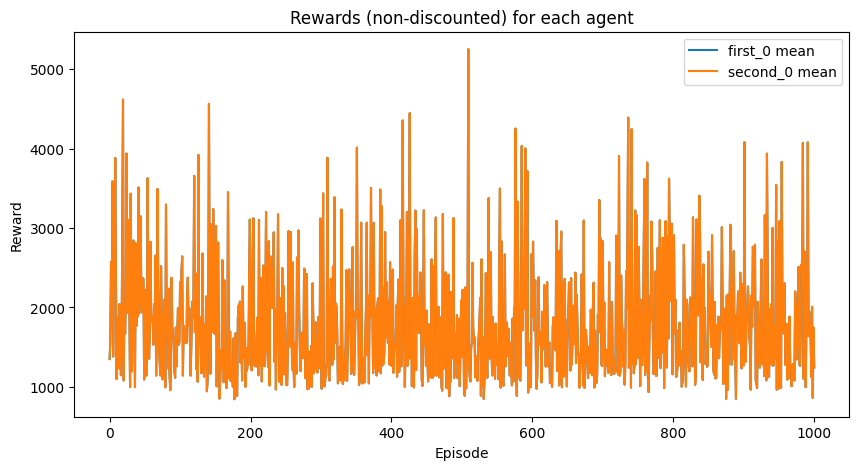

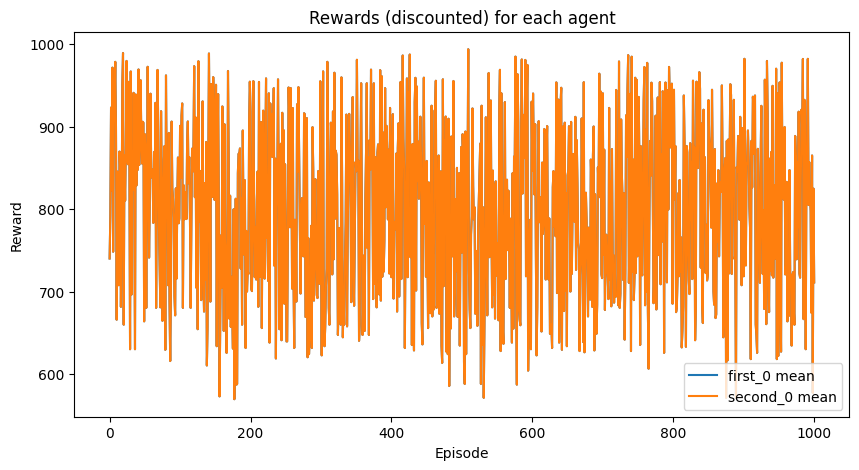

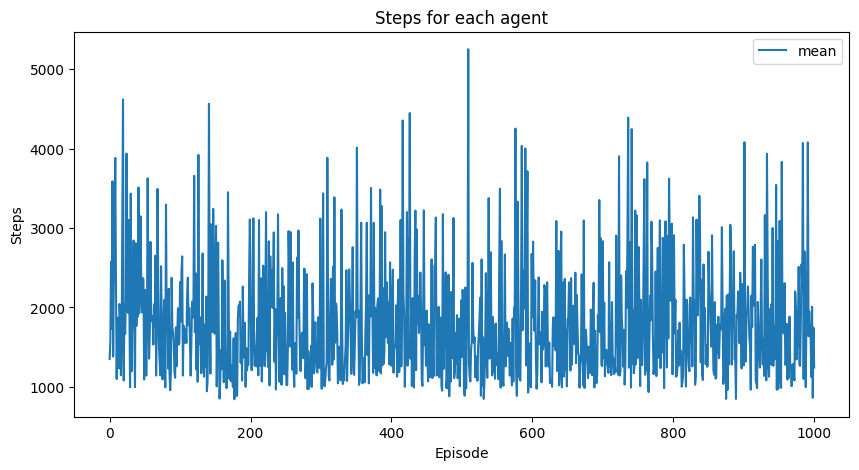

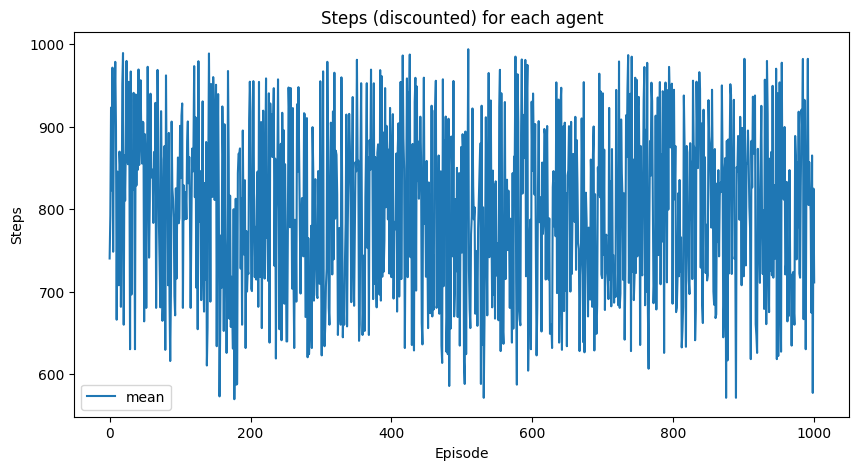

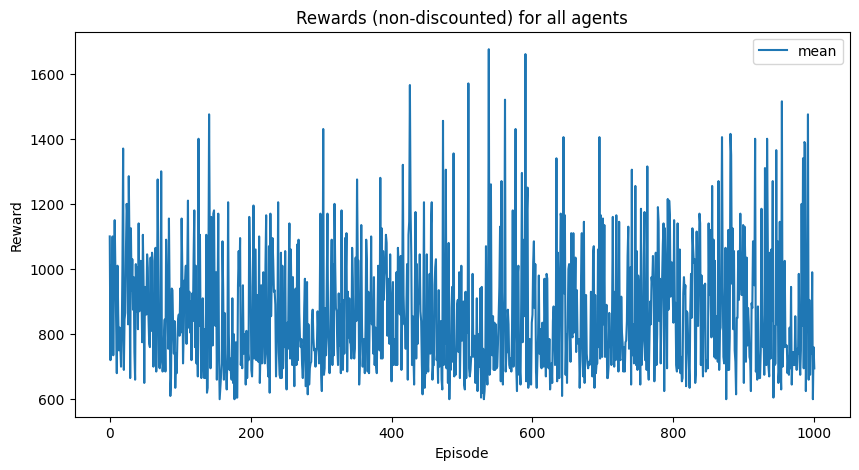

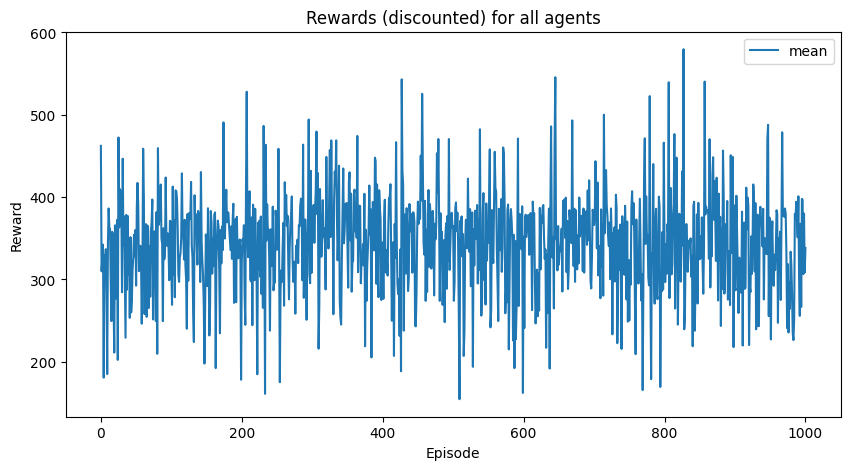

In [65]:
plot_graphs(ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV, agent_names, episode_count)

### Without intrinsic reward (only one with episode_count 2001)

In [51]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 2001

#hyperparameters for MAPPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net
intrinsic_reward = False #use intrinsic reward step count

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_MAPPOSV = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_steps_d_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_all_MAPPOSV = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_MAPPOSV = np.zeros((experiment_count, episode_count))

#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agent
    agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer = optim.Adam(agent_network.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network, ep_rewards_MAPPO_all, ep_rewards_d_MAPPO_all, ep_steps_MAPPOSV[i], ep_steps_d_MAPPOSV[i], ep_rewards_all_MAPPOSV[i], ep_rewards_d_all_MAPPOSV[i] = train_MAPPO_SV(env, agent_network, optimizer, intrinsic_reward, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_MAPPOSV['first_0'][i] = ep_rewards_MAPPO_all['first_0']
    ep_rewards_MAPPOSV['second_0'][i] = ep_rewards_MAPPO_all['second_0']
    ep_rewards_d_MAPPOSV['first_0'][i] = ep_rewards_d_MAPPO_all['first_0']
    ep_rewards_d_MAPPOSV['second_0'][i] = ep_rewards_d_MAPPO_all['second_0']
    
    # Save the model to cwd
    filename = f"models/{game_name}_ex{i}_MAPPO_SV_eff_{effnet}_pre_{pretrained}.pt"
    path = os.path.join(os.getcwd(), filename)
    torch.save(agent_network.state_dict(), path)

    #close the parallel environment
    env.close()

# combine all rewards into one array for MAPPO
ep_rewards_MAPPOSV_store = np.array([ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_MAPPO_SV_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_MAPPOSV_store)


Experiment 0
Using device: cuda


  0%|          | 0/2001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/2001 [00:28<15:53:13, 28.60s/it]

Training episode 0
Episodic Return: 730.0
Episodic Return Discounted: 373.71778557087396
Episode Length: 1178

Value Loss: 10443.8994140625
Policy Loss agent 1: 47.08049011230469
Policy Loss agent 2: 143.9804229736328
Old Approx KL: -0.0029063888359814882
Approx KL: 0.0023038056679069996
Clip Fraction: 0.14236111120060757
Explained Variance: -0.0007303953170776367

-------------------------------------------



  0%|          | 2/2001 [01:06<18:58:34, 34.17s/it]

Training episode 1
Episodic Return: 945.0
Episodic Return Discounted: 433.2158934462998
Episode Length: 1558

Value Loss: 4564.58544921875
Policy Loss agent 1: 68.1698226928711
Policy Loss agent 2: -10.46006965637207
Old Approx KL: 0.0013066650135442615
Approx KL: 0.001936966204084456
Clip Fraction: 0.05911989796425209
Explained Variance: 0.0004139542579650879

-------------------------------------------



  0%|          | 3/2001 [01:51<21:33:13, 38.84s/it]

Training episode 2
Episodic Return: 1045.0
Episodic Return Discounted: 348.39192291598056
Episode Length: 2044

Value Loss: 1906.422607421875
Policy Loss agent 1: -10.435944557189941
Policy Loss agent 2: -35.02629852294922
Old Approx KL: 0.0017668226500973105
Approx KL: 0.00237212679348886
Clip Fraction: 0.05959250711991141
Explained Variance: 2.2411346435546875e-05

-------------------------------------------



  0%|          | 4/2001 [02:21<19:42:03, 35.51s/it]

Training episode 3
Episodic Return: 705.0
Episodic Return Discounted: 300.19817558169825
Episode Length: 1390

Value Loss: 4504.78759765625
Policy Loss agent 1: -37.22829055786133
Policy Loss agent 2: 116.9875717163086
Old Approx KL: 0.0031453510746359825
Approx KL: 0.0035945384297519922
Clip Fraction: 0.14730695555150738
Explained Variance: 5.269050598144531e-05

-------------------------------------------



  0%|          | 5/2001 [03:01<20:34:17, 37.10s/it]

Training episode 4
Episodic Return: 850.0
Episodic Return Discounted: 347.658956851434
Episode Length: 1800

Value Loss: 3153.120361328125
Policy Loss agent 1: 34.33580017089844
Policy Loss agent 2: -54.09071731567383
Old Approx KL: -0.009070592932403088
Approx KL: 0.005209791008383036
Clip Fraction: 0.1479535399109213
Explained Variance: -0.0022145509719848633

-------------------------------------------



  0%|          | 6/2001 [03:49<22:36:24, 40.79s/it]

Training episode 5
Episodic Return: 940.0
Episodic Return Discounted: 303.3322452779402
Episode Length: 2138

Value Loss: 1446.4266357421875
Policy Loss agent 1: 45.284385681152344
Policy Loss agent 2: 5.9144697189331055
Old Approx KL: 0.02757301554083824
Approx KL: 0.004281139932572842
Clip Fraction: 0.17991639027807546
Explained Variance: 0.00022178888320922852

-------------------------------------------



  0%|          | 7/2001 [04:16<20:03:44, 36.22s/it]

Training episode 6
Episodic Return: 655.0
Episodic Return Discounted: 349.7098003652865
Episode Length: 1078

Value Loss: 6466.11083984375
Policy Loss agent 1: -109.66633605957031
Policy Loss agent 2: -48.48637390136719
Old Approx KL: 0.012517094612121582
Approx KL: 0.004695212934166193
Clip Fraction: 0.2160845588454429
Explained Variance: -0.0014042854309082031

-------------------------------------------



  0%|          | 8/2001 [04:43<18:34:03, 33.54s/it]

Training episode 7
Episodic Return: 715.0
Episodic Return Discounted: 385.17594646235716
Episode Length: 1150

Value Loss: 4678.98583984375
Policy Loss agent 1: 54.77094650268555
Policy Loss agent 2: -90.82731628417969
Old Approx KL: -0.0011747755343094468
Approx KL: 0.004107716027647257
Clip Fraction: 0.23332888191496884
Explained Variance: -1.9669532775878906e-05

-------------------------------------------



  0%|          | 9/2001 [05:25<19:53:42, 35.95s/it]

Training episode 8
Episodic Return: 940.0
Episodic Return Discounted: 385.3408742178415
Episode Length: 1700

Value Loss: 1875.5150146484375
Policy Loss agent 1: 69.01900482177734
Policy Loss agent 2: 20.15676498413086
Old Approx KL: -0.0381016731262207
Approx KL: 0.019137214869260788
Clip Fraction: 0.25687954312544375
Explained Variance: 0.0007622241973876953

-------------------------------------------



  0%|          | 10/2001 [06:23<23:37:48, 42.73s/it]

Training episode 9
Episodic Return: 1265.0
Episodic Return Discounted: 392.5089269703433
Episode Length: 2412

Value Loss: 6920.65380859375
Policy Loss agent 1: 61.67464828491211
Policy Loss agent 2: 105.61829376220703
Old Approx KL: 0.12504065036773682
Approx KL: 0.01559508964419365
Clip Fraction: 0.3889223359870595
Explained Variance: 0.0008031129837036133

-------------------------------------------



  1%|          | 11/2001 [07:10<24:25:19, 44.18s/it]

Training episode 10
Episodic Return: 905.0
Episodic Return Discounted: 298.20459438688704
Episode Length: 1972

Value Loss: 6435.294921875
Policy Loss agent 1: -174.40957641601562
Policy Loss agent 2: -46.211212158203125
Old Approx KL: -0.06010131165385246
Approx KL: 0.009044448845088482
Clip Fraction: 0.33400537646425665
Explained Variance: -0.00039446353912353516

-------------------------------------------



  1%|          | 12/2001 [08:07<26:30:23, 47.98s/it]

Training episode 11
Episodic Return: 1045.0
Episodic Return Discounted: 272.6479602710412
Episode Length: 2288

Value Loss: 2970.802978515625
Policy Loss agent 1: 41.95362091064453
Policy Loss agent 2: 34.7666130065918
Old Approx KL: 0.14112648367881775
Approx KL: 0.026163548231124878
Clip Fraction: 0.3998688811605627
Explained Variance: 0.0007347464561462402

-------------------------------------------



  1%|          | 13/2001 [09:10<29:05:36, 52.68s/it]

Training episode 12
Episodic Return: 1315.0
Episodic Return Discounted: 323.4651091304535
Episode Length: 2366

Value Loss: 2938.4658203125
Policy Loss agent 1: -23.224637985229492
Policy Loss agent 2: -74.76941680908203
Old Approx KL: -0.05374734848737717
Approx KL: 0.012329068034887314
Clip Fraction: 0.38632623018982176
Explained Variance: -0.0001131296157836914

-------------------------------------------



  1%|          | 14/2001 [10:00<28:39:17, 51.92s/it]

Training episode 13
Episodic Return: 855.0
Episodic Return Discounted: 319.10951826050956
Episode Length: 1768

Value Loss: 7029.8330078125
Policy Loss agent 1: -23.760719299316406
Policy Loss agent 2: 140.7367401123047
Old Approx KL: 0.08814426511526108
Approx KL: 0.032613031566143036
Clip Fraction: 0.44172297301772123
Explained Variance: 0.0010463595390319824

-------------------------------------------



  1%|          | 15/2001 [10:53<28:47:25, 52.19s/it]

Training episode 14
Episodic Return: 870.0
Episodic Return Discounted: 349.05220517985714
Episode Length: 1992

Value Loss: 2677.89111328125
Policy Loss agent 1: 7.865626811981201
Policy Loss agent 2: -8.561007499694824
Old Approx KL: 0.11107319593429565
Approx KL: 0.023511869832873344
Clip Fraction: 0.3941071430842082
Explained Variance: -0.0013715028762817383

-------------------------------------------



  1%|          | 16/2001 [11:56<30:33:45, 55.43s/it]

Training episode 15
Episodic Return: 870.0
Episodic Return Discounted: 323.03519925473034
Episode Length: 2478

Value Loss: 4334.98046875
Policy Loss agent 1: 79.5987319946289
Policy Loss agent 2: -25.031091690063477
Old Approx KL: 0.04637257754802704
Approx KL: 0.02897545136511326
Clip Fraction: 0.5354476841547156
Explained Variance: 0.000941932201385498

-------------------------------------------



  1%|          | 17/2001 [12:51<30:22:40, 55.12s/it]

Training episode 16
Episodic Return: 880.0
Episodic Return Discounted: 330.4670520707515
Episode Length: 2164

Value Loss: 744.974609375
Policy Loss agent 1: 0.6183242797851562
Policy Loss agent 2: -32.80462646484375
Old Approx KL: -0.05825319141149521
Approx KL: 0.02130608819425106
Clip Fraction: 0.4291768791336639
Explained Variance: -6.794929504394531e-05

-------------------------------------------



  1%|          | 18/2001 [14:13<34:52:25, 63.31s/it]

Training episode 17
Episodic Return: 1280.0
Episodic Return Discounted: 351.0189220700493
Episode Length: 2974

Value Loss: 2896.46142578125
Policy Loss agent 1: -40.58695602416992
Policy Loss agent 2: 13.052995681762695
Old Approx KL: 0.018438464030623436
Approx KL: 0.036552757024765015
Clip Fraction: 0.48358664194315565
Explained Variance: -0.0010040998458862305

-------------------------------------------



  1%|          | 19/2001 [14:46<29:51:08, 54.22s/it]

Training episode 18
Episodic Return: 950.0
Episodic Return Discounted: 470.7180616675267
Episode Length: 1240

Value Loss: 15223.4873046875
Policy Loss agent 1: -210.43382263183594
Policy Loss agent 2: -130.52268981933594
Old Approx KL: -0.16125808656215668
Approx KL: 0.0566716194152832
Clip Fraction: 0.4718215814513019
Explained Variance: 0.0012496709823608398

-------------------------------------------



  1%|          | 20/2001 [15:46<30:46:32, 55.93s/it]

Training episode 19
Episodic Return: 820.0
Episodic Return Discounted: 247.78553099747072
Episode Length: 2294

Value Loss: 22248.16015625
Policy Loss agent 1: 131.58453369140625
Policy Loss agent 2: 213.2101593017578
Old Approx KL: 0.14730022847652435
Approx KL: 0.03559938818216324
Clip Fraction: 0.5345486111731993
Explained Variance: -0.0003560781478881836

-------------------------------------------



  1%|          | 21/2001 [16:46<31:26:25, 57.16s/it]

Training episode 20
Episodic Return: 870.0
Episodic Return Discounted: 303.99001925945225
Episode Length: 2002

Value Loss: 1108.2720947265625
Policy Loss agent 1: 59.2802848815918
Policy Loss agent 2: 21.73110008239746
Old Approx KL: 0.08759903907775879
Approx KL: 0.00453755259513855
Clip Fraction: 0.41691468253968256
Explained Variance: -0.0006875991821289062

-------------------------------------------



  1%|          | 22/2001 [17:30<29:17:28, 53.28s/it]

Training episode 21
Episodic Return: 830.0
Episodic Return Discounted: 365.3271929246704
Episode Length: 1506

Value Loss: 760.5699462890625
Policy Loss agent 1: -30.393888473510742
Policy Loss agent 2: 41.69242477416992
Old Approx KL: 0.0649976134300232
Approx KL: 0.0020689964294433594
Clip Fraction: 0.4728070175438597
Explained Variance: 0.00027042627334594727

-------------------------------------------



  1%|          | 23/2001 [18:38<31:41:35, 57.68s/it]

Training episode 22
Episodic Return: 820.0
Episodic Return Discounted: 311.704141978752
Episode Length: 1998

Value Loss: 5274.60693359375
Policy Loss agent 1: 2.739394187927246
Policy Loss agent 2: 79.19290924072266
Old Approx KL: 0.040924184024333954
Approx KL: 0.019122090190649033
Clip Fraction: 0.5335256412029267
Explained Variance: -0.00017082691192626953

-------------------------------------------



  1%|          | 24/2001 [19:09<27:10:29, 49.48s/it]

Training episode 23
Episodic Return: 645.0
Episodic Return Discounted: 380.2174517419439
Episode Length: 996

Value Loss: 8119.2802734375
Policy Loss agent 1: -115.4333724975586
Policy Loss agent 2: -86.19868469238281
Old Approx KL: -0.183915913105011
Approx KL: 0.04440230131149292
Clip Fraction: 0.5086529983414544
Explained Variance: -0.002013564109802246

-------------------------------------------



  1%|          | 25/2001 [20:38<33:48:21, 61.59s/it]

Training episode 24
Episodic Return: 1250.0
Episodic Return Discounted: 278.53787903478883
Episode Length: 3416

Value Loss: 9805.384765625
Policy Loss agent 1: 128.04757690429688
Policy Loss agent 2: 101.43512725830078
Old Approx KL: 0.23942197859287262
Approx KL: 0.08739075064659119
Clip Fraction: 0.5985063418421047
Explained Variance: -0.0007396936416625977

-------------------------------------------



  1%|▏         | 26/2001 [21:46<34:46:26, 63.39s/it]

Training episode 25
Episodic Return: 975.0
Episodic Return Discounted: 395.05021149345004
Episode Length: 2386

Value Loss: 740.2298583984375
Policy Loss agent 1: -28.960180282592773
Policy Loss agent 2: -53.9801025390625
Old Approx KL: -0.11165457963943481
Approx KL: 0.01681312918663025
Clip Fraction: 0.43840277777777775
Explained Variance: -0.0013546943664550781

-------------------------------------------



  1%|▏         | 27/2001 [22:33<32:01:32, 58.41s/it]

Training episode 26
Episodic Return: 725.0
Episodic Return Discounted: 380.05181176651587
Episode Length: 1516

Value Loss: 4717.662109375
Policy Loss agent 1: 72.13739013671875
Policy Loss agent 2: -66.27830505371094
Old Approx KL: 0.058964431285858154
Approx KL: 0.02037111297249794
Clip Fraction: 0.4696570973647268
Explained Variance: 0.0002250075340270996

-------------------------------------------



  1%|▏         | 28/2001 [23:12<28:54:30, 52.75s/it]

Training episode 27
Episodic Return: 830.0
Episodic Return Discounted: 376.34972607455575
Episode Length: 1510

Value Loss: 1197.640869140625
Policy Loss agent 1: -38.944297790527344
Policy Loss agent 2: -12.149889945983887
Old Approx KL: -0.06738509237766266
Approx KL: 0.013347292318940163
Clip Fraction: 0.46052631589404325
Explained Variance: 0.00035637617111206055

-------------------------------------------



  1%|▏         | 29/2001 [24:01<28:09:46, 51.41s/it]

Training episode 28
Episodic Return: 805.0
Episodic Return Discounted: 321.5486699723434
Episode Length: 1882

Value Loss: 4829.33447265625
Policy Loss agent 1: -58.666015625
Policy Loss agent 2: 93.45343017578125
Old Approx KL: 0.02714184857904911
Approx KL: 0.1359948366880417
Clip Fraction: 0.5433243095538037
Explained Variance: 0.0007265210151672363

-------------------------------------------



  1%|▏         | 30/2001 [24:54<28:25:01, 51.90s/it]

Training episode 29
Episodic Return: 895.0
Episodic Return Discounted: 352.026827585909
Episode Length: 1886

Value Loss: 1929.583251953125
Policy Loss agent 1: 15.550415992736816
Policy Loss agent 2: -13.535665512084961
Old Approx KL: 0.06077160686254501
Approx KL: 0.03144090622663498
Clip Fraction: 0.5159373645391842
Explained Variance: 0.0006287097930908203

-------------------------------------------



  2%|▏         | 31/2001 [25:35<26:40:26, 48.74s/it]

Training episode 30
Episodic Return: 785.0
Episodic Return Discounted: 361.1071185980659
Episode Length: 1306

Value Loss: 4947.86181640625
Policy Loss agent 1: -40.14605712890625
Policy Loss agent 2: -105.8575210571289
Old Approx KL: -0.12267085164785385
Approx KL: 0.03550348058342934
Clip Fraction: 0.5728602077418227
Explained Variance: 0.0001647472381591797

-------------------------------------------



  2%|▏         | 32/2001 [26:52<31:15:46, 57.16s/it]

Training episode 31
Episodic Return: 940.0
Episodic Return Discounted: 281.1097600147308
Episode Length: 2610

Value Loss: 3028.609619140625
Policy Loss agent 1: 100.16376495361328
Policy Loss agent 2: 75.70342254638672
Old Approx KL: 0.15518814325332642
Approx KL: 0.013299226760864258
Clip Fraction: 0.6713033536585366
Explained Variance: 0.00138169527053833

-------------------------------------------



  2%|▏         | 33/2001 [28:04<33:42:13, 61.65s/it]

Training episode 32
Episodic Return: 1020.0
Episodic Return Discounted: 304.8587027572385
Episode Length: 2554

Value Loss: 5712.224609375
Policy Loss agent 1: -119.1611328125
Policy Loss agent 2: -24.427734375
Old Approx KL: -0.14515705406665802
Approx KL: 0.06342053413391113
Clip Fraction: 0.5277777777363857
Explained Variance: -0.0002218484878540039

-------------------------------------------



  2%|▏         | 34/2001 [29:09<34:17:48, 62.77s/it]

Training episode 33
Episodic Return: 1075.0
Episodic Return Discounted: 377.6656136364524
Episode Length: 2122

Value Loss: 2590.075927734375
Policy Loss agent 1: -31.389041900634766
Policy Loss agent 2: -28.72454833984375
Old Approx KL: -0.06372934579849243
Approx KL: 0.04754529148340225
Clip Fraction: 0.5449213311636358
Explained Variance: 0.0005780458450317383

-------------------------------------------



  2%|▏         | 35/2001 [30:09<33:48:05, 61.89s/it]

Training episode 34
Episodic Return: 840.0
Episodic Return Discounted: 265.6575569451671
Episode Length: 2002

Value Loss: 986.2063598632812
Policy Loss agent 1: 30.890727996826172
Policy Loss agent 2: 47.45960235595703
Old Approx KL: 0.2956152558326721
Approx KL: 0.03985947370529175
Clip Fraction: 0.5203373015873016
Explained Variance: 0.0013805627822875977

-------------------------------------------



  2%|▏         | 36/2001 [31:29<36:40:21, 67.19s/it]

Training episode 35
Episodic Return: 1080.0
Episodic Return Discounted: 258.22210597313085
Episode Length: 3192

Value Loss: 4465.5966796875
Policy Loss agent 1: 54.6970329284668
Policy Loss agent 2: 67.75729370117188
Old Approx KL: 0.20821385085582733
Approx KL: 0.0894789919257164
Clip Fraction: 0.6519270835320155
Explained Variance: -0.0015125274658203125

-------------------------------------------



  2%|▏         | 37/2001 [32:26<35:01:40, 64.21s/it]

Training episode 36
Episodic Return: 910.0
Episodic Return Discounted: 283.0394801025756
Episode Length: 2316

Value Loss: 8101.9833984375
Policy Loss agent 1: -147.8463134765625
Policy Loss agent 2: -74.27799224853516
Old Approx KL: -0.192119300365448
Approx KL: 0.046871624886989594
Clip Fraction: 0.6170323930937668
Explained Variance: -0.0008262395858764648

-------------------------------------------



  2%|▏         | 38/2001 [33:15<32:28:28, 59.56s/it]

Training episode 37
Episodic Return: 875.0
Episodic Return Discounted: 305.29245263891823
Episode Length: 2058

Value Loss: 12241.140625
Policy Loss agent 1: 36.30372619628906
Policy Loss agent 2: 147.40817260742188
Old Approx KL: 0.42665785551071167
Approx KL: 0.20343643426895142
Clip Fraction: 0.6655810364457064
Explained Variance: 0.00014716386795043945

-------------------------------------------



  2%|▏         | 39/2001 [33:47<27:58:57, 51.34s/it]

Training episode 38
Episodic Return: 740.0
Episodic Return Discounted: 326.4488847475591
Episode Length: 1334

Value Loss: 7404.5078125
Policy Loss agent 1: -54.56608581542969
Policy Loss agent 2: -90.33749389648438
Old Approx KL: -0.04792128875851631
Approx KL: 0.035628654062747955
Clip Fraction: 0.610962301788349
Explained Variance: -8.440017700195312e-05

-------------------------------------------



  2%|▏         | 40/2001 [34:28<26:19:43, 48.33s/it]

Training episode 39
Episodic Return: 785.0
Episodic Return Discounted: 334.19985830657913
Episode Length: 1576

Value Loss: 2372.832763671875
Policy Loss agent 1: 43.27835464477539
Policy Loss agent 2: 9.641161918640137
Old Approx KL: 0.13804945349693298
Approx KL: 0.03677602484822273
Clip Fraction: 0.5961099088392675
Explained Variance: 0.0014290809631347656

-------------------------------------------



  2%|▏         | 41/2001 [35:16<26:11:31, 48.11s/it]

Training episode 40
Episodic Return: 1045.0
Episodic Return Discounted: 318.61704332575886
Episode Length: 1962

Value Loss: 3465.083251953125
Policy Loss agent 1: -60.646217346191406
Policy Loss agent 2: -57.133453369140625
Old Approx KL: -0.22750002145767212
Approx KL: 0.12060073018074036
Clip Fraction: 0.45985772361761834
Explained Variance: 0.0019750595092773438

-------------------------------------------



  2%|▏         | 42/2001 [35:49<23:44:45, 43.64s/it]

Training episode 41
Episodic Return: 730.0
Episodic Return Discounted: 327.43655571229726
Episode Length: 1372

Value Loss: 4311.125
Policy Loss agent 1: 30.322294235229492
Policy Loss agent 2: -77.16130828857422
Old Approx KL: 0.04502326250076294
Approx KL: 0.051866430789232254
Clip Fraction: 0.5617292108692864
Explained Variance: 0.0010914206504821777

-------------------------------------------



  2%|▏         | 43/2001 [36:41<25:05:06, 46.12s/it]

Training episode 42
Episodic Return: 795.0
Episodic Return Discounted: 300.2593716609575
Episode Length: 2164

Value Loss: 9267.8271484375
Policy Loss agent 1: 109.25877380371094
Policy Loss agent 2: 80.96412658691406
Old Approx KL: 0.1513606160879135
Approx KL: 0.027826111763715744
Clip Fraction: 0.6944955066576892
Explained Variance: -0.00021529197692871094

-------------------------------------------



  2%|▏         | 44/2001 [37:17<23:25:08, 43.08s/it]

Training episode 43
Episodic Return: 765.0
Episodic Return Discounted: 333.60426189911493
Episode Length: 1500

Value Loss: 8614.8525390625
Policy Loss agent 1: -117.98539733886719
Policy Loss agent 2: -116.72103118896484
Old Approx KL: -0.29004374146461487
Approx KL: 0.1292334347963333
Clip Fraction: 0.6226225017655825
Explained Variance: -0.002097487449645996

-------------------------------------------



  2%|▏         | 45/2001 [38:28<27:56:11, 51.42s/it]

Training episode 44
Episodic Return: 1195.0
Episodic Return Discounted: 298.30910701343885
Episode Length: 2958

Value Loss: 12875.384765625
Policy Loss agent 1: 137.25941467285156
Policy Loss agent 2: 104.50377655029297
Old Approx KL: 0.4256211519241333
Approx KL: 0.1805897206068039
Clip Fraction: 0.6760784824689229
Explained Variance: -0.0001437664031982422

-------------------------------------------



  2%|▏         | 46/2001 [39:05<25:35:03, 47.11s/it]

Training episode 45
Episodic Return: 985.0
Episodic Return Discounted: 416.9141109012489
Episode Length: 1540

Value Loss: 13970.361328125
Policy Loss agent 1: -278.5039367675781
Policy Loss agent 2: -66.16748046875
Old Approx KL: -0.29066717624664307
Approx KL: 0.09811794757843018
Clip Fraction: 0.6104309853819228
Explained Variance: -0.0003781318664550781

-------------------------------------------



  2%|▏         | 47/2001 [39:48<24:53:21, 45.86s/it]

Training episode 46
Episodic Return: 815.0
Episodic Return Discounted: 347.9763907334093
Episode Length: 1792

Value Loss: 10260.7744140625
Policy Loss agent 1: 33.146820068359375
Policy Loss agent 2: 153.3692626953125
Old Approx KL: 0.3530075252056122
Approx KL: 0.10271255671977997
Clip Fraction: 0.6297743059694767
Explained Variance: 0.00024062395095825195

-------------------------------------------



  2%|▏         | 48/2001 [40:24<23:16:16, 42.90s/it]

Training episode 47
Episodic Return: 970.0
Episodic Return Discounted: 442.9979755569382
Episode Length: 1514

Value Loss: 2717.48828125
Policy Loss agent 1: -36.19308090209961
Policy Loss agent 2: -48.6114387512207
Old Approx KL: -0.10099903494119644
Approx KL: 0.03632442280650139
Clip Fraction: 0.49947612086931864
Explained Variance: 0.0011764764785766602

-------------------------------------------



  2%|▏         | 49/2001 [40:57<21:46:22, 40.15s/it]

Training episode 48
Episodic Return: 725.0
Episodic Return Discounted: 316.94098806465723
Episode Length: 1386

Value Loss: 1303.0169677734375
Policy Loss agent 1: 5.0188117027282715
Policy Loss agent 2: 21.37268829345703
Old Approx KL: 0.03552939370274544
Approx KL: 0.02647784724831581
Clip Fraction: 0.5495290550692328
Explained Variance: 0.0009557604789733887

-------------------------------------------



  2%|▏         | 50/2001 [42:06<26:22:58, 48.68s/it]

Training episode 49
Episodic Return: 1025.0
Episodic Return Discounted: 240.47320911138604
Episode Length: 2872

Value Loss: 6484.681640625
Policy Loss agent 1: 147.19696044921875
Policy Loss agent 2: 32.50259017944336
Old Approx KL: 0.16927525401115417
Approx KL: 0.043587345629930496
Clip Fraction: 0.6513888889992678
Explained Variance: -0.00038802623748779297

-------------------------------------------



  3%|▎         | 51/2001 [42:55<26:29:08, 48.90s/it]

Training episode 50
Episodic Return: 805.0
Episodic Return Discounted: 326.8729811320394
Episode Length: 2052

Value Loss: 3581.349365234375
Policy Loss agent 1: 2.9598543643951416
Policy Loss agent 2: -81.17543029785156
Old Approx KL: -0.0302121639251709
Approx KL: 0.0250626802444458
Clip Fraction: 0.5514373386553092
Explained Variance: -0.0026601552963256836

-------------------------------------------



  3%|▎         | 52/2001 [44:08<30:16:29, 55.92s/it]

Training episode 51
Episodic Return: 1280.0
Episodic Return Discounted: 294.17660520764764
Episode Length: 3076

Value Loss: 5992.552734375
Policy Loss agent 1: 55.043338775634766
Policy Loss agent 2: 126.18501281738281
Old Approx KL: 0.4237191677093506
Approx KL: 0.08996295183897018
Clip Fraction: 0.6628706103161827
Explained Variance: 0.00022786855697631836

-------------------------------------------



  3%|▎         | 53/2001 [44:37<25:59:29, 48.03s/it]

Training episode 52
Episodic Return: 685.0
Episodic Return Discounted: 344.54423907744865
Episode Length: 1230

Value Loss: 10638.28515625
Policy Loss agent 1: -174.02584838867188
Policy Loss agent 2: -61.68619918823242
Old Approx KL: -0.2936580777168274
Approx KL: 0.12394925951957703
Clip Fraction: 0.6530240596114815
Explained Variance: -0.0001876354217529297

-------------------------------------------



  3%|▎         | 54/2001 [45:09<23:18:44, 43.10s/it]

Training episode 53
Episodic Return: 720.0
Episodic Return Discounted: 353.1716845068781
Episode Length: 1308

Value Loss: 5802.23095703125
Policy Loss agent 1: 32.81025695800781
Policy Loss agent 2: 77.18074798583984
Old Approx KL: 0.3364540636539459
Approx KL: 0.18572695553302765
Clip Fraction: 0.5697870475005328
Explained Variance: 0.00024580955505371094

-------------------------------------------



  3%|▎         | 55/2001 [46:07<25:45:56, 47.67s/it]

Training episode 54
Episodic Return: 1015.0
Episodic Return Discounted: 328.67643588441024
Episode Length: 2426

Value Loss: 7288.48681640625
Policy Loss agent 1: 61.52626037597656
Policy Loss agent 2: 107.47467803955078
Old Approx KL: 0.28484222292900085
Approx KL: 0.05607721582055092
Clip Fraction: 0.6601257920265198
Explained Variance: 0.000634312629699707

-------------------------------------------



  3%|▎         | 56/2001 [46:40<23:24:31, 43.33s/it]

Training episode 55
Episodic Return: 700.0
Episodic Return Discounted: 334.36823024346074
Episode Length: 1376

Value Loss: 7050.16162109375
Policy Loss agent 1: -97.10565185546875
Policy Loss agent 2: -98.12995147705078
Old Approx KL: -0.20419518649578094
Approx KL: 0.154118150472641
Clip Fraction: 0.5940487729024517
Explained Variance: 0.00020438432693481445

-------------------------------------------



  3%|▎         | 57/2001 [47:38<25:44:59, 47.68s/it]

Training episode 56
Episodic Return: 870.0
Episodic Return Discounted: 263.6467898547416
Episode Length: 2320

Value Loss: 5761.36083984375
Policy Loss agent 1: 63.54010772705078
Policy Loss agent 2: 76.28526306152344
Old Approx KL: 0.20036648213863373
Approx KL: 0.05023061856627464
Clip Fraction: 0.6436302685189521
Explained Variance: -0.0006662607192993164

-------------------------------------------



  3%|▎         | 58/2001 [48:13<23:39:33, 43.84s/it]

Training episode 57
Episodic Return: 920.0
Episodic Return Discounted: 388.03185806988085
Episode Length: 1438

Value Loss: 6760.60791015625
Policy Loss agent 1: -125.37544250488281
Policy Loss agent 2: -69.05315399169922
Old Approx KL: -0.22458255290985107
Approx KL: 0.10625706613063812
Clip Fraction: 0.6111645301183065
Explained Variance: 0.0013385415077209473

-------------------------------------------



  3%|▎         | 59/2001 [49:03<24:37:47, 45.66s/it]

Training episode 58
Episodic Return: 1010.0
Episodic Return Discounted: 314.05062482600994
Episode Length: 2048

Value Loss: 11823.48828125
Policy Loss agent 1: 163.78317260742188
Policy Loss agent 2: 99.18550872802734
Old Approx KL: 0.5470990538597107
Approx KL: 0.2289607673883438
Clip Fraction: 0.6727267797105014
Explained Variance: 0.00014227628707885742

-------------------------------------------



  3%|▎         | 60/2001 [49:53<25:22:35, 47.07s/it]

Training episode 59
Episodic Return: 795.0
Episodic Return Discounted: 266.95233259279286
Episode Length: 2092

Value Loss: 2632.375732421875
Policy Loss agent 1: 37.353759765625
Policy Loss agent 2: 33.0442008972168
Old Approx KL: 0.2271655946969986
Approx KL: 0.0880129486322403
Clip Fraction: 0.5523797133345034
Explained Variance: 0.0009772181510925293

-------------------------------------------



  3%|▎         | 61/2001 [50:38<24:57:23, 46.31s/it]

Training episode 60
Episodic Return: 690.0
Episodic Return Discounted: 337.73960903537983
Episode Length: 1282

Value Loss: 10441.3798828125
Policy Loss agent 1: -105.11381530761719
Policy Loss agent 2: -198.8824462890625
Old Approx KL: -0.9613515734672546
Approx KL: 0.9151178002357483
Clip Fraction: 0.5997942386831275
Explained Variance: -0.00042378902435302734

-------------------------------------------



  3%|▎         | 62/2001 [54:03<50:38:06, 94.01s/it]

Training episode 61
Episodic Return: 1035.0
Episodic Return Discounted: 333.0078435174297
Episode Length: 2258

Value Loss: 10376.392578125
Policy Loss agent 1: 165.7961883544922
Policy Loss agent 2: 122.9639892578125
Old Approx KL: -0.0051541924476623535
Approx KL: 0.00039190053939819336
Clip Fraction: 0.6988703051643192
Explained Variance: 0.0003209114074707031

-------------------------------------------



  3%|▎         | 63/2001 [54:56<43:53:23, 81.53s/it]

Training episode 62
Episodic Return: 860.0
Episodic Return Discounted: 296.4319978256159
Episode Length: 1936

Value Loss: 2261.67431640625
Policy Loss agent 1: -11.309808731079102
Policy Loss agent 2: -63.971858978271484
Old Approx KL: -0.07780482620000839
Approx KL: 0.039343032985925674
Clip Fraction: 0.48373507829408674
Explained Variance: 0.0008832812309265137

-------------------------------------------



  3%|▎         | 64/2001 [55:32<36:36:39, 68.04s/it]

Training episode 63
Episodic Return: 780.0
Episodic Return Discounted: 347.55475856542046
Episode Length: 1618

Value Loss: 1850.9361572265625
Policy Loss agent 1: 60.90591812133789
Policy Loss agent 2: 48.04254150390625
Old Approx KL: 0.12533515691757202
Approx KL: 0.007862776517868042
Clip Fraction: 0.5703635620915033
Explained Variance: 0.0001647472381591797

-------------------------------------------



  3%|▎         | 65/2001 [56:22<33:36:18, 62.49s/it]

Training episode 64
Episodic Return: 860.0
Episodic Return Discounted: 322.0232407620994
Episode Length: 2202

Value Loss: 2843.1484375
Policy Loss agent 1: 91.32222747802734
Policy Loss agent 2: 28.147382736206055
Old Approx KL: 0.2257172018289566
Approx KL: 0.05862820893526077
Clip Fraction: 0.679230407960173
Explained Variance: 0.0002365708351135254

-------------------------------------------



  3%|▎         | 66/2001 [56:51<28:16:56, 52.62s/it]

Training episode 65
Episodic Return: 725.0
Episodic Return Discounted: 355.2368937009386
Episode Length: 1270

Value Loss: 3389.113037109375
Policy Loss agent 1: -62.586360931396484
Policy Loss agent 2: -71.89186096191406
Old Approx KL: -0.19279278814792633
Approx KL: 0.036501117050647736
Clip Fraction: 0.5649218750496705
Explained Variance: 0.0006753206253051758

-------------------------------------------



  3%|▎         | 67/2001 [57:47<28:43:24, 53.47s/it]

Training episode 66
Episodic Return: 785.0
Episodic Return Discounted: 232.85315671430047
Episode Length: 2274

Value Loss: 16241.541015625
Policy Loss agent 1: 88.58406829833984
Policy Loss agent 2: 55.85493469238281
Old Approx KL: 0.2579997777938843
Approx KL: 0.03376522660255432
Clip Fraction: 0.6879370629370629
Explained Variance: 0.00011998414993286133

-------------------------------------------



  3%|▎         | 68/2001 [58:56<31:12:48, 58.13s/it]

Training episode 67
Episodic Return: 960.0
Episodic Return Discounted: 249.83680439030053
Episode Length: 2762

Value Loss: 2512.92236328125
Policy Loss agent 1: -44.16864013671875
Policy Loss agent 2: 2.4450440406799316
Old Approx KL: -0.007768054958432913
Approx KL: 0.07543401420116425
Clip Fraction: 0.5553414686681678
Explained Variance: 7.623434066772461e-05

-------------------------------------------



  3%|▎         | 69/2001 [59:57<31:42:14, 59.08s/it]

Training episode 68
Episodic Return: 845.0
Episodic Return Discounted: 309.597682284852
Episode Length: 2484

Value Loss: 1623.41748046875
Policy Loss agent 1: -38.28998947143555
Policy Loss agent 2: -1.3623600006103516
Old Approx KL: 0.013447463512420654
Approx KL: 0.04320408031344414
Clip Fraction: 0.5803062678911747
Explained Variance: -0.0007938146591186523

-------------------------------------------



  3%|▎         | 70/2001 [1:00:21<26:02:51, 48.56s/it]

Training episode 69
Episodic Return: 640.0
Episodic Return Discounted: 369.69872671854046
Episode Length: 958

Value Loss: 4125.09130859375
Policy Loss agent 1: -79.74884796142578
Policy Loss agent 2: -35.157691955566406
Old Approx KL: -0.07618413120508194
Approx KL: 0.03819975256919861
Clip Fraction: 0.5987313038773007
Explained Variance: 0.0002645254135131836

-------------------------------------------



  4%|▎         | 71/2001 [1:00:59<24:14:21, 45.21s/it]

Training episode 70
Episodic Return: 790.0
Episodic Return Discounted: 372.642493913037
Episode Length: 1570

Value Loss: 1851.7408447265625
Policy Loss agent 1: 3.7453935146331787
Policy Loss agent 2: 38.1763801574707
Old Approx KL: 0.003788590431213379
Approx KL: 0.005044281482696533
Clip Fraction: 0.6678240740740741
Explained Variance: -0.0005464553833007812

-------------------------------------------



  4%|▎         | 72/2001 [1:01:50<25:15:44, 47.15s/it]

Training episode 71
Episodic Return: 1120.0
Episodic Return Discounted: 440.3318026364035
Episode Length: 2224

Value Loss: 2063.134033203125
Policy Loss agent 1: 43.26370620727539
Policy Loss agent 2: 9.183125495910645
Old Approx KL: 0.16262942552566528
Approx KL: 0.07159529626369476
Clip Fraction: 0.6262939650949528
Explained Variance: 0.00105208158493042

-------------------------------------------



  4%|▎         | 73/2001 [1:02:35<24:55:33, 46.54s/it]

Training episode 72
Episodic Return: 920.0
Episodic Return Discounted: 360.15351313221856
Episode Length: 1964

Value Loss: 1300.8543701171875
Policy Loss agent 1: -17.395002365112305
Policy Loss agent 2: -19.505353927612305
Old Approx KL: -0.031595610082149506
Approx KL: 0.03601539134979248
Clip Fraction: 0.5900853043649255
Explained Variance: -0.0009539127349853516

-------------------------------------------



  4%|▎         | 74/2001 [1:03:33<26:37:48, 49.75s/it]

Training episode 73
Episodic Return: 1050.0
Episodic Return Discounted: 395.0706947733456
Episode Length: 2416

Value Loss: 4295.5537109375
Policy Loss agent 1: 58.902130126953125
Policy Loss agent 2: 64.94571685791016
Old Approx KL: 0.38817349076271057
Approx KL: 0.16048306226730347
Clip Fraction: 0.6862628774400842
Explained Variance: 0.00041496753692626953

-------------------------------------------



  4%|▎         | 75/2001 [1:04:06<24:00:35, 44.88s/it]

Training episode 74
Episodic Return: 960.0
Episodic Return Discounted: 441.97142364544965
Episode Length: 1438

Value Loss: 10801.6767578125
Policy Loss agent 1: -96.59723663330078
Policy Loss agent 2: -158.4741668701172
Old Approx KL: -0.23334063589572906
Approx KL: 0.07233558595180511
Clip Fraction: 0.628766025878765
Explained Variance: 0.0012983083724975586

-------------------------------------------



  4%|▍         | 76/2001 [1:04:33<21:08:10, 39.53s/it]

Training episode 75
Episodic Return: 685.0
Episodic Return Discounted: 347.196962024291
Episode Length: 1198

Value Loss: 7110.00244140625
Policy Loss agent 1: 119.90766143798828
Policy Loss agent 2: -19.905759811401367
Old Approx KL: 0.1984195113182068
Approx KL: 0.12147244811058044
Clip Fraction: 0.6707478637165494
Explained Variance: -0.0013871192932128906

-------------------------------------------



  4%|▍         | 77/2001 [1:05:18<21:58:04, 41.10s/it]

Training episode 76
Episodic Return: 920.0
Episodic Return Discounted: 333.0542823525858
Episode Length: 1970

Value Loss: 2597.49658203125
Policy Loss agent 1: 57.93101501464844
Policy Loss agent 2: 71.29607391357422
Old Approx KL: 0.4584439992904663
Approx KL: 0.0940237045288086
Clip Fraction: 0.6646505376344086
Explained Variance: 0.0009142160415649414

-------------------------------------------



  4%|▍         | 78/2001 [1:05:58<21:49:36, 40.86s/it]

Training episode 77
Episodic Return: 775.0
Episodic Return Discounted: 338.7677728066465
Episode Length: 1784

Value Loss: 4230.10546875
Policy Loss agent 1: 43.78174591064453
Policy Loss agent 2: -113.54790496826172
Old Approx KL: -0.08394832164049149
Approx KL: 0.09424923360347748
Clip Fraction: 0.5953975341149739
Explained Variance: -0.0003800392150878906

-------------------------------------------



  4%|▍         | 79/2001 [1:06:42<22:14:53, 41.67s/it]

Training episode 78
Episodic Return: 790.0
Episodic Return Discounted: 291.4468114938301
Episode Length: 1772

Value Loss: 2420.394287109375
Policy Loss agent 1: 41.60699462890625
Policy Loss agent 2: -77.87410736083984
Old Approx KL: -0.03490397334098816
Approx KL: 0.15869855880737305
Clip Fraction: 0.5805862682001727
Explained Variance: 0.0011331439018249512

-------------------------------------------



  4%|▍         | 80/2001 [1:07:34<23:58:40, 44.94s/it]

Training episode 79
Episodic Return: 870.0
Episodic Return Discounted: 296.21454016584124
Episode Length: 2306

Value Loss: 5209.712890625
Policy Loss agent 1: 157.62310791015625
Policy Loss agent 2: -37.5058708190918
Old Approx KL: -0.15616250038146973
Approx KL: 0.013789355754852295
Clip Fraction: 0.6575431034482758
Explained Variance: 0.00016045570373535156

-------------------------------------------



  4%|▍         | 81/2001 [1:08:05<21:37:43, 40.55s/it]

Training episode 80
Episodic Return: 785.0
Episodic Return Discounted: 392.7557680486616
Episode Length: 1310

Value Loss: 9559.64453125
Policy Loss agent 1: -38.10086441040039
Policy Loss agent 2: -169.07809448242188
Old Approx KL: -0.36178165674209595
Approx KL: 0.4221205413341522
Clip Fraction: 0.6174073643316098
Explained Variance: -0.0010596513748168945

-------------------------------------------



  4%|▍         | 82/2001 [1:09:21<27:24:29, 51.42s/it]

Training episode 81
Episodic Return: 1235.0
Episodic Return Discounted: 308.2650355940789
Episode Length: 3284

Value Loss: 22240.69921875
Policy Loss agent 1: 193.06173706054688
Policy Loss agent 2: 153.217041015625
Old Approx KL: 0.3451496958732605
Approx KL: 0.07552464306354523
Clip Fraction: 0.6897417746701286
Explained Variance: -0.00029337406158447266

-------------------------------------------



  4%|▍         | 83/2001 [1:10:05<26:11:25, 49.16s/it]

Training episode 82
Episodic Return: 840.0
Episodic Return Discounted: 271.5990724174406
Episode Length: 1898

Value Loss: 13383.73046875
Policy Loss agent 1: -153.97021484375
Policy Loss agent 2: -177.41709899902344
Old Approx KL: -0.24560220539569855
Approx KL: 0.05206197500228882
Clip Fraction: 0.6095938377019738
Explained Variance: 0.0002734065055847168

-------------------------------------------



  4%|▍         | 84/2001 [1:10:34<22:54:31, 43.02s/it]

Training episode 83
Episodic Return: 750.0
Episodic Return Discounted: 383.6829577119327
Episode Length: 1252

Value Loss: 2600.923583984375
Policy Loss agent 1: 55.898399353027344
Policy Loss agent 2: 26.300485610961914
Old Approx KL: 0.28637516498565674
Approx KL: 0.18063251674175262
Clip Fraction: 0.553226090181729
Explained Variance: 0.0005580782890319824

-------------------------------------------



  4%|▍         | 85/2001 [1:11:10<21:43:05, 40.81s/it]

Training episode 84
Episodic Return: 710.0
Episodic Return Discounted: 290.2744570966212
Episode Length: 1544

Value Loss: 4021.927734375
Policy Loss agent 1: 91.5564193725586
Policy Loss agent 2: -62.4364013671875
Old Approx KL: 0.04972664266824722
Approx KL: 0.015612424351274967
Clip Fraction: 0.6206277617064538
Explained Variance: 0.0004684329032897949

-------------------------------------------



  4%|▍         | 86/2001 [1:12:01<23:20:03, 43.87s/it]

Training episode 85
Episodic Return: 1155.0
Episodic Return Discounted: 314.6281815574431
Episode Length: 2222

Value Loss: 4880.86962890625
Policy Loss agent 1: -35.300262451171875
Policy Loss agent 2: 58.49797058105469
Old Approx KL: 0.22878152132034302
Approx KL: 0.057332251220941544
Clip Fraction: 0.6231899097097292
Explained Variance: 0.0011309981346130371

-------------------------------------------



  4%|▍         | 87/2001 [1:12:47<23:40:10, 44.52s/it]

Training episode 86
Episodic Return: 995.0
Episodic Return Discounted: 314.44052979982916
Episode Length: 2024

Value Loss: 5007.92431640625
Policy Loss agent 1: 22.153728485107422
Policy Loss agent 2: -131.0570526123047
Old Approx KL: -0.07994499802589417
Approx KL: 0.13474717736244202
Clip Fraction: 0.6157550622471987
Explained Variance: -0.00017464160919189453

-------------------------------------------



  4%|▍         | 88/2001 [1:13:16<21:14:21, 39.97s/it]

Training episode 87
Episodic Return: 705.0
Episodic Return Discounted: 363.1059435941628
Episode Length: 1294

Value Loss: 5149.57470703125
Policy Loss agent 1: -39.619140625
Policy Loss agent 2: -107.56706237792969
Old Approx KL: -0.1549660712480545
Approx KL: 0.04422909766435623
Clip Fraction: 0.5219412791876146
Explained Variance: -0.0004799365997314453

-------------------------------------------



  4%|▍         | 89/2001 [1:13:48<19:55:49, 37.53s/it]

Training episode 88
Episodic Return: 775.0
Episodic Return Discounted: 331.68451427366335
Episode Length: 1354

Value Loss: 2391.881591796875
Policy Loss agent 1: 30.158109664916992
Policy Loss agent 2: 1.278550386428833
Old Approx KL: 0.08999154716730118
Approx KL: 0.0401286780834198
Clip Fraction: 0.5900735294117647
Explained Variance: 0.0007196664810180664

-------------------------------------------



  4%|▍         | 90/2001 [1:14:31<20:46:10, 39.13s/it]

Training episode 89
Episodic Return: 980.0
Episodic Return Discounted: 348.5920394851567
Episode Length: 1726

Value Loss: 2403.932861328125
Policy Loss agent 1: 8.198053359985352
Policy Loss agent 2: 1.4980469942092896
Old Approx KL: 0.06410475075244904
Approx KL: 0.06311187893152237
Clip Fraction: 0.5624851615708552
Explained Variance: 0.00267636775970459

-------------------------------------------



  5%|▍         | 91/2001 [1:14:55<18:24:37, 34.70s/it]

Training episode 90
Episodic Return: 650.0
Episodic Return Discounted: 370.48441095324495
Episode Length: 992

Value Loss: 7887.6484375
Policy Loss agent 1: -165.64637756347656
Policy Loss agent 2: 14.73245620727539
Old Approx KL: -0.10533681511878967
Approx KL: 0.13694164156913757
Clip Fraction: 0.6187836027914478
Explained Variance: -0.0005593299865722656

-------------------------------------------



  5%|▍         | 92/2001 [1:15:30<18:24:28, 34.71s/it]

Training episode 91
Episodic Return: 745.0
Episodic Return Discounted: 374.99637251596215
Episode Length: 1530

Value Loss: 10187.4892578125
Policy Loss agent 1: 113.64982604980469
Policy Loss agent 2: 115.85224914550781
Old Approx KL: 0.614697277545929
Approx KL: 0.26500552892684937
Clip Fraction: 0.6921416860487726
Explained Variance: -0.000637054443359375

-------------------------------------------



  5%|▍         | 93/2001 [1:16:16<20:14:16, 38.18s/it]

Training episode 92
Episodic Return: 860.0
Episodic Return Discounted: 315.68223375856473
Episode Length: 2036

Value Loss: 6234.4287109375
Policy Loss agent 1: -1.9612809419631958
Policy Loss agent 2: 71.69271087646484
Old Approx KL: 0.13964544236660004
Approx KL: 0.18347781896591187
Clip Fraction: 0.5807291668218871
Explained Variance: -0.0015423297882080078

-------------------------------------------



  5%|▍         | 94/2001 [1:17:08<22:28:12, 42.42s/it]

Training episode 93
Episodic Return: 925.0
Episodic Return Discounted: 271.6336659794259
Episode Length: 2154

Value Loss: 1083.871337890625
Policy Loss agent 1: -34.42387008666992
Policy Loss agent 2: 5.5089921951293945
Old Approx KL: -0.10250798612833023
Approx KL: 0.344705730676651
Clip Fraction: 0.5669152949327304
Explained Variance: 0.00012832880020141602

-------------------------------------------



  5%|▍         | 95/2001 [1:18:02<24:10:40, 45.67s/it]

Training episode 94
Episodic Return: 1030.0
Episodic Return Discounted: 261.3329419199507
Episode Length: 2324

Value Loss: 4140.0703125
Policy Loss agent 1: 15.056283950805664
Policy Loss agent 2: 74.99787902832031
Old Approx KL: -0.005402743816375732
Approx KL: 0.06535974144935608
Clip Fraction: 0.709546233012796
Explained Variance: -0.0003908872604370117

-------------------------------------------



  5%|▍         | 96/2001 [1:19:28<30:35:37, 57.81s/it]

Training episode 95
Episodic Return: 1200.0
Episodic Return Discounted: 216.19380890884668
Episode Length: 3732

Value Loss: 9940.0439453125
Policy Loss agent 1: 122.29383850097656
Policy Loss agent 2: -41.26346206665039
Old Approx KL: 0.4334946870803833
Approx KL: 0.1780315339565277
Clip Fraction: 0.6692782526681905
Explained Variance: -0.002806544303894043

-------------------------------------------



  5%|▍         | 97/2001 [1:20:04<27:05:35, 51.23s/it]

Training episode 96
Episodic Return: 705.0
Episodic Return Discounted: 257.46491094396595
Episode Length: 1522

Value Loss: 4341.1982421875
Policy Loss agent 1: -134.43446350097656
Policy Loss agent 2: -54.59246826171875
Old Approx KL: -0.3370676636695862
Approx KL: 0.06377977132797241
Clip Fraction: 0.6104600694444444
Explained Variance: 0.0006002187728881836

-------------------------------------------



  5%|▍         | 98/2001 [1:21:16<30:22:35, 57.46s/it]

Training episode 97
Episodic Return: 1120.0
Episodic Return Discounted: 242.71520060816619
Episode Length: 3166

Value Loss: 9173.947265625
Policy Loss agent 1: 120.51136779785156
Policy Loss agent 2: 101.0973892211914
Old Approx KL: 0.2892806828022003
Approx KL: 0.07530424743890762
Clip Fraction: 0.7059537686081446
Explained Variance: 0.0005670785903930664

-------------------------------------------



  5%|▍         | 99/2001 [1:22:07<29:25:14, 55.69s/it]

Training episode 98
Episodic Return: 1060.0
Episodic Return Discounted: 309.6973309256039
Episode Length: 2250

Value Loss: 4541.765625
Policy Loss agent 1: -71.31795501708984
Policy Loss agent 2: -91.84758758544922
Old Approx KL: -0.14517273008823395
Approx KL: 0.06250612437725067
Clip Fraction: 0.60937910426593
Explained Variance: 0.00030285120010375977

-------------------------------------------



  5%|▍         | 100/2001 [1:22:56<28:15:19, 53.51s/it]

Training episode 99
Episodic Return: 905.0
Episodic Return Discounted: 337.39878204971757
Episode Length: 2062

Value Loss: 7947.6552734375
Policy Loss agent 1: 139.7932586669922
Policy Loss agent 2: 26.337291717529297
Old Approx KL: 0.35791632533073425
Approx KL: 0.09926048666238785
Clip Fraction: 0.6613061522020542
Explained Variance: 0.00025773048400878906

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_100_gamma_0.999.avi


  5%|▌         | 101/2001 [1:23:46<27:47:06, 52.65s/it]

Training episode 100
Episodic Return: 905.0
Episodic Return Discounted: 347.7733000463022
Episode Length: 2006

Value Loss: 1284.4151611328125
Policy Loss agent 1: 5.469555854797363
Policy Loss agent 2: 9.709460258483887
Old Approx KL: 0.10346366465091705
Approx KL: 0.013610678724944592
Clip Fraction: 0.5338458995970469
Explained Variance: 0.0005068182945251465

-------------------------------------------



  5%|▌         | 102/2001 [1:24:22<25:02:39, 47.48s/it]

Training episode 101
Episodic Return: 720.0
Episodic Return Discounted: 362.31983369380805
Episode Length: 1396

Value Loss: 672.9970092773438
Policy Loss agent 1: 9.71794605255127
Policy Loss agent 2: 24.048818588256836
Old Approx KL: 0.19105187058448792
Approx KL: 0.03752937912940979
Clip Fraction: 0.5416666668924418
Explained Variance: 0.00035500526428222656

-------------------------------------------



  5%|▌         | 103/2001 [1:25:17<26:15:45, 49.81s/it]

Training episode 102
Episodic Return: 895.0
Episodic Return Discounted: 198.74315908032352
Episode Length: 2426

Value Loss: 3551.753662109375
Policy Loss agent 1: -28.00014305114746
Policy Loss agent 2: 44.539276123046875
Old Approx KL: 0.11236997693777084
Approx KL: 0.03806871175765991
Clip Fraction: 0.6400082238149225
Explained Variance: -0.0009306669235229492

-------------------------------------------



  5%|▌         | 104/2001 [1:25:41<22:11:00, 42.10s/it]

Training episode 103
Episodic Return: 670.0
Episodic Return Discounted: 375.7343627251502
Episode Length: 1026

Value Loss: 7034.9306640625
Policy Loss agent 1: -184.51853942871094
Policy Loss agent 2: 5.3639302253723145
Old Approx KL: -0.18318021297454834
Approx KL: 0.03700137138366699
Clip Fraction: 0.5971153846153846
Explained Variance: -7.069110870361328e-05

-------------------------------------------



  5%|▌         | 105/2001 [1:26:05<19:21:39, 36.76s/it]

Training episode 104
Episodic Return: 650.0
Episodic Return Discounted: 379.8299287868829
Episode Length: 1050

Value Loss: 4720.53125
Policy Loss agent 1: -33.422664642333984
Policy Loss agent 2: 94.93660736083984
Old Approx KL: 0.23218737542629242
Approx KL: 0.09089487046003342
Clip Fraction: 0.5912773570027015
Explained Variance: 0.0003669857978820801

-------------------------------------------



  5%|▌         | 106/2001 [1:26:25<16:40:58, 31.69s/it]

Training episode 105
Episodic Return: 615.0
Episodic Return Discounted: 392.5853961328851
Episode Length: 856

Value Loss: 4757.02587890625
Policy Loss agent 1: -119.92831420898438
Policy Loss agent 2: 38.21714782714844
Old Approx KL: -0.05743710696697235
Approx KL: 0.08148369193077087
Clip Fraction: 0.6062334658187113
Explained Variance: 0.000498652458190918

-------------------------------------------



  5%|▌         | 107/2001 [1:27:00<17:10:52, 32.66s/it]

Training episode 106
Episodic Return: 805.0
Episodic Return Discounted: 340.5662203104711
Episode Length: 1518

Value Loss: 3816.364990234375
Policy Loss agent 1: 0.522735595703125
Policy Loss agent 2: -1.1093069314956665
Old Approx KL: 0.016143057495355606
Approx KL: 0.06111627444624901
Clip Fraction: 0.6401147102054797
Explained Variance: 0.00022083520889282227

-------------------------------------------



  5%|▌         | 108/2001 [1:27:26<16:04:20, 30.57s/it]

Training episode 107
Episodic Return: 860.0
Episodic Return Discounted: 442.6216398877091
Episode Length: 1116

Value Loss: 5385.64501953125
Policy Loss agent 1: 14.303586959838867
Policy Loss agent 2: -113.06281280517578
Old Approx KL: -0.14665713906288147
Approx KL: 0.15808025002479553
Clip Fraction: 0.6061688313881556
Explained Variance: 0.0008851885795593262

-------------------------------------------



  5%|▌         | 109/2001 [1:27:52<15:22:32, 29.26s/it]

Training episode 108
Episodic Return: 715.0
Episodic Return Discounted: 403.63054044499773
Episode Length: 1080

Value Loss: 5738.90673828125
Policy Loss agent 1: -49.65556335449219
Policy Loss agent 2: 118.84309387207031
Old Approx KL: 0.11843705922365189
Approx KL: 0.1482781618833542
Clip Fraction: 0.5925682774361443
Explained Variance: 0.001051783561706543

-------------------------------------------



  5%|▌         | 110/2001 [1:28:47<19:29:45, 37.12s/it]

Training episode 109
Episodic Return: 940.0
Episodic Return Discounted: 297.16026255226933
Episode Length: 2438

Value Loss: 10270.5791015625
Policy Loss agent 1: 103.84815979003906
Policy Loss agent 2: 124.37215423583984
Old Approx KL: 0.49448123574256897
Approx KL: 0.17582164704799652
Clip Fraction: 0.7094635076512439
Explained Variance: 0.0014424324035644531

-------------------------------------------



  6%|▌         | 111/2001 [1:29:42<22:09:06, 42.19s/it]

Training episode 110
Episodic Return: 1035.0
Episodic Return Discounted: 266.68809941269575
Episode Length: 2374

Value Loss: 6656.9853515625
Policy Loss agent 1: 7.107383728027344
Policy Loss agent 2: -177.4237518310547
Old Approx KL: -0.13479392230510712
Approx KL: 0.11223220825195312
Clip Fraction: 0.5827600671941002
Explained Variance: 0.0006594657897949219

-------------------------------------------



  6%|▌         | 112/2001 [1:30:26<22:25:32, 42.74s/it]

Training episode 111
Episodic Return: 725.0
Episodic Return Discounted: 349.1981119137669
Episode Length: 1872

Value Loss: 6750.33056640625
Policy Loss agent 1: 116.53128814697266
Policy Loss agent 2: 44.35495376586914
Old Approx KL: 0.3847567141056061
Approx KL: 0.11287131905555725
Clip Fraction: 0.6629748342723248
Explained Variance: 4.26173210144043e-05

-------------------------------------------



  6%|▌         | 113/2001 [1:30:48<19:08:43, 36.51s/it]

Training episode 112
Episodic Return: 630.0
Episodic Return Discounted: 380.50982919688715
Episode Length: 930

Value Loss: 8487.1064453125
Policy Loss agent 1: -14.933879852294922
Policy Loss agent 2: -156.60153198242188
Old Approx KL: -0.09420961141586304
Approx KL: 0.04040426015853882
Clip Fraction: 0.6216454802259888
Explained Variance: 0.0009902119636535645

-------------------------------------------



  6%|▌         | 114/2001 [1:31:20<18:34:01, 35.42s/it]

Training episode 113
Episodic Return: 725.0
Episodic Return Discounted: 377.8959131333114
Episode Length: 1368

Value Loss: 6032.46337890625
Policy Loss agent 1: 26.81034278869629
Policy Loss agent 2: 137.6058349609375
Old Approx KL: 0.4323559105396271
Approx KL: 0.2403973937034607
Clip Fraction: 0.6938849673714749
Explained Variance: -0.00011539459228515625

-------------------------------------------



  6%|▌         | 115/2001 [1:32:03<19:43:12, 37.64s/it]

Training episode 114
Episodic Return: 930.0
Episodic Return Discounted: 346.8661674843967
Episode Length: 1884

Value Loss: 2568.2890625
Policy Loss agent 1: -27.95964241027832
Policy Loss agent 2: 48.66010284423828
Old Approx KL: 0.0697496086359024
Approx KL: 0.03419051319360733
Clip Fraction: 0.6030110428057148
Explained Variance: 0.0005851984024047852

-------------------------------------------



  6%|▌         | 116/2001 [1:32:32<18:16:36, 34.91s/it]

Training episode 115
Episodic Return: 665.0
Episodic Return Discounted: 374.11878087096454
Episode Length: 1248

Value Loss: 5718.7158203125
Policy Loss agent 1: 37.5753173828125
Policy Loss agent 2: -124.34039306640625
Old Approx KL: 0.012545236386358738
Approx KL: 0.17274561524391174
Clip Fraction: 0.6004451574423374
Explained Variance: -2.3126602172851562e-05

-------------------------------------------



  6%|▌         | 117/2001 [1:33:21<20:29:05, 39.14s/it]

Training episode 116
Episodic Return: 885.0
Episodic Return Discounted: 207.26617351962864
Episode Length: 2122

Value Loss: 5511.50732421875
Policy Loss agent 1: 96.40859985351562
Policy Loss agent 2: -52.38386917114258
Old Approx KL: -0.007837805896997452
Approx KL: 0.05242057517170906
Clip Fraction: 0.6903021441665209
Explained Variance: -0.0001710653305053711

-------------------------------------------



  6%|▌         | 118/2001 [1:34:08<21:41:50, 41.48s/it]

Training episode 117
Episodic Return: 855.0
Episodic Return Discounted: 279.9056894519259
Episode Length: 2044

Value Loss: 1750.5087890625
Policy Loss agent 1: -46.29967498779297
Policy Loss agent 2: 39.805240631103516
Old Approx KL: 0.17642992734909058
Approx KL: 0.08671092242002487
Clip Fraction: 0.6013479523050288
Explained Variance: -0.0003458261489868164

-------------------------------------------



  6%|▌         | 119/2001 [1:34:56<22:46:10, 43.56s/it]

Training episode 118
Episodic Return: 870.0
Episodic Return Discounted: 252.5760255628428
Episode Length: 2098

Value Loss: 2472.844482421875
Policy Loss agent 1: -3.796191930770874
Policy Loss agent 2: 13.44023323059082
Old Approx KL: -0.2569870352745056
Approx KL: 0.039722561836242676
Clip Fraction: 0.5993529040404041
Explained Variance: 0.0008443593978881836

-------------------------------------------



  6%|▌         | 120/2001 [1:35:25<20:29:36, 39.22s/it]

Training episode 119
Episodic Return: 695.0
Episodic Return Discounted: 343.9989500829155
Episode Length: 1268

Value Loss: 7050.15625
Policy Loss agent 1: -22.375877380371094
Policy Loss agent 2: -165.25796508789062
Old Approx KL: -0.11601507663726807
Approx KL: 0.09215201437473297
Clip Fraction: 0.6473524309694767
Explained Variance: -0.0006500482559204102

-------------------------------------------



  6%|▌         | 121/2001 [1:36:20<22:58:44, 44.00s/it]

Training episode 120
Episodic Return: 975.0
Episodic Return Discounted: 359.6541843200563
Episode Length: 2412

Value Loss: 9907.1806640625
Policy Loss agent 1: 122.29935455322266
Policy Loss agent 2: 127.17224884033203
Old Approx KL: 0.48039376735687256
Approx KL: 0.13771167397499084
Clip Fraction: 0.6923665463529676
Explained Variance: 0.0003712773323059082

-------------------------------------------



  6%|▌         | 122/2001 [1:37:00<22:19:18, 42.77s/it]

Training episode 121
Episodic Return: 795.0
Episodic Return Discounted: 387.20068949731046
Episode Length: 1728

Value Loss: 3385.024658203125
Policy Loss agent 1: -18.472843170166016
Policy Loss agent 2: -77.6101303100586
Old Approx KL: -0.047590479254722595
Approx KL: 0.11194820702075958
Clip Fraction: 0.6277391978620012
Explained Variance: -0.0005500316619873047

-------------------------------------------



  6%|▌         | 123/2001 [1:37:26<19:34:08, 37.51s/it]

Training episode 122
Episodic Return: 675.0
Episodic Return Discounted: 359.36663120068687
Episode Length: 1092

Value Loss: 2430.61962890625
Policy Loss agent 1: 16.627689361572266
Policy Loss agent 2: -87.42546844482422
Old Approx KL: -0.019029518589377403
Approx KL: 0.02108985185623169
Clip Fraction: 0.5792572466647568
Explained Variance: 0.00039952993392944336

-------------------------------------------



  6%|▌         | 124/2001 [1:37:57<18:41:05, 35.84s/it]

Training episode 123
Episodic Return: 675.0
Episodic Return Discounted: 339.2903903397807
Episode Length: 1366

Value Loss: 6779.20654296875
Policy Loss agent 1: 102.56864166259766
Policy Loss agent 2: -57.54923629760742
Old Approx KL: 0.059130407869815826
Approx KL: 0.14500275254249573
Clip Fraction: 0.6687500000924103
Explained Variance: 5.6803226470947266e-05

-------------------------------------------



  6%|▌         | 125/2001 [1:38:37<19:15:47, 36.97s/it]

Training episode 124
Episodic Return: 745.0
Episodic Return Discounted: 264.28470582417714
Episode Length: 1538

Value Loss: 1412.24658203125
Policy Loss agent 1: -64.8550033569336
Policy Loss agent 2: 10.199386596679688
Old Approx KL: -0.09392261505126953
Approx KL: 0.03390052914619446
Clip Fraction: 0.5975085910652921
Explained Variance: 0.0012286901473999023

-------------------------------------------



  6%|▋         | 126/2001 [1:39:31<21:51:35, 41.97s/it]

Training episode 125
Episodic Return: 830.0
Episodic Return Discounted: 265.3674305231491
Episode Length: 2178

Value Loss: 5179.99560546875
Policy Loss agent 1: 71.2806625366211
Policy Loss agent 2: 29.835617065429688
Old Approx KL: 0.27465635538101196
Approx KL: 0.09659004211425781
Clip Fraction: 0.6871198296836983
Explained Variance: 0.00017791986465454102

-------------------------------------------



  6%|▋         | 127/2001 [1:40:13<21:55:27, 42.12s/it]

Training episode 126
Episodic Return: 785.0
Episodic Return Discounted: 284.66787419620425
Episode Length: 1850

Value Loss: 4281.60791015625
Policy Loss agent 1: -73.39073181152344
Policy Loss agent 2: -26.456350326538086
Old Approx KL: 0.040145013481378555
Approx KL: 0.12523460388183594
Clip Fraction: 0.6225355205864742
Explained Variance: -0.0016654729843139648

-------------------------------------------



  6%|▋         | 128/2001 [1:41:02<23:01:14, 44.25s/it]

Training episode 127
Episodic Return: 825.0
Episodic Return Discounted: 264.77733718594584
Episode Length: 2042

Value Loss: 2082.770263671875
Policy Loss agent 1: -20.38524627685547
Policy Loss agent 2: 56.241790771484375
Old Approx KL: 0.17462195456027985
Approx KL: 0.05347057059407234
Clip Fraction: 0.653510199704518
Explained Variance: 0.00012987852096557617

-------------------------------------------



  6%|▋         | 129/2001 [1:41:36<21:22:37, 41.11s/it]

Training episode 128
Episodic Return: 700.0
Episodic Return Discounted: 321.0411686572001
Episode Length: 1374

Value Loss: 4768.2275390625
Policy Loss agent 1: -114.25849914550781
Policy Loss agent 2: -29.99691390991211
Old Approx KL: -0.2914177179336548
Approx KL: 0.11158961802721024
Clip Fraction: 0.6150678299194159
Explained Variance: -0.0004755258560180664

-------------------------------------------



  6%|▋         | 130/2001 [1:42:23<22:16:32, 42.86s/it]

Training episode 129
Episodic Return: 975.0
Episodic Return Discounted: 331.987806864207
Episode Length: 1914

Value Loss: 4092.07373046875
Policy Loss agent 1: 13.758955001831055
Policy Loss agent 2: 46.90430450439453
Old Approx KL: 0.35195472836494446
Approx KL: 0.27238523960113525
Clip Fraction: 0.7183545523219639
Explained Variance: 0.0015142560005187988

-------------------------------------------



  7%|▋         | 131/2001 [1:43:11<23:02:24, 44.36s/it]

Training episode 130
Episodic Return: 975.0
Episodic Return Discounted: 328.49977581324197
Episode Length: 1914

Value Loss: 3933.849853515625
Policy Loss agent 1: -39.89628219604492
Policy Loss agent 2: -48.352142333984375
Old Approx KL: -0.11219590157270432
Approx KL: 0.06538108736276627
Clip Fraction: 0.6159529321723514
Explained Variance: 0.00020778179168701172

-------------------------------------------



  7%|▋         | 132/2001 [1:44:12<25:33:35, 49.23s/it]

Training episode 131
Episodic Return: 1090.0
Episodic Return Discounted: 365.593690336561
Episode Length: 2438

Value Loss: 10157.0224609375
Policy Loss agent 1: 120.7879409790039
Policy Loss agent 2: 55.20457077026367
Old Approx KL: 0.31649407744407654
Approx KL: 0.0780927762389183
Clip Fraction: 0.7719635077811015
Explained Variance: -0.0004564523696899414

-------------------------------------------



  7%|▋         | 133/2001 [1:44:51<24:02:56, 46.35s/it]

Training episode 132
Episodic Return: 695.0
Episodic Return Discounted: 306.37208653789344
Episode Length: 1554

Value Loss: 18016.7578125
Policy Loss agent 1: -62.99534606933594
Policy Loss agent 2: -135.07681274414062
Old Approx KL: -0.3046821355819702
Approx KL: 0.05168372392654419
Clip Fraction: 0.6080994897959183
Explained Variance: -0.00038051605224609375

-------------------------------------------



  7%|▋         | 134/2001 [1:46:06<28:24:19, 54.77s/it]

Training episode 133
Episodic Return: 1150.0
Episodic Return Discounted: 349.5603598607996
Episode Length: 3004

Value Loss: 21342.28125
Policy Loss agent 1: 156.7564239501953
Policy Loss agent 2: 168.3897705078125
Old Approx KL: 0.5421295166015625
Approx KL: 0.2260914146900177
Clip Fraction: 0.723721590976343
Explained Variance: -0.0010485649108886719

-------------------------------------------



  7%|▋         | 135/2001 [1:46:42<25:35:28, 49.37s/it]

Training episode 134
Episodic Return: 730.0
Episodic Return Discounted: 286.8489670989988
Episode Length: 1580

Value Loss: 7376.51806640625
Policy Loss agent 1: -64.29776763916016
Policy Loss agent 2: -153.26039123535156
Old Approx KL: -0.37329912185668945
Approx KL: 0.2956700325012207
Clip Fraction: 0.5672444141272343
Explained Variance: -7.927417755126953e-05

-------------------------------------------



  7%|▋         | 136/2001 [1:47:09<22:07:10, 42.70s/it]

Training episode 135
Episodic Return: 755.0
Episodic Return Discounted: 388.72104431655987
Episode Length: 1140

Value Loss: 2361.74365234375
Policy Loss agent 1: 16.849449157714844
Policy Loss agent 2: 22.807737350463867
Old Approx KL: 0.15437108278274536
Approx KL: 0.027559500187635422
Clip Fraction: 0.559461805831503
Explained Variance: -0.0006349086761474609

-------------------------------------------



  7%|▋         | 137/2001 [1:47:45<21:02:43, 40.65s/it]

Training episode 136
Episodic Return: 790.0
Episodic Return Discounted: 344.75605822232825
Episode Length: 1508

Value Loss: 2996.92333984375
Policy Loss agent 1: -22.93646240234375
Policy Loss agent 2: 107.22554779052734
Old Approx KL: 0.011854331009089947
Approx KL: 0.01567338965833187
Clip Fraction: 0.6438596492796613
Explained Variance: -0.0001615285873413086

-------------------------------------------



  7%|▋         | 138/2001 [1:48:42<23:33:14, 45.51s/it]

Training episode 137
Episodic Return: 1050.0
Episodic Return Discounted: 248.17273827811442
Episode Length: 2406

Value Loss: 7520.60791015625
Policy Loss agent 1: 100.48604583740234
Policy Loss agent 2: 97.49820709228516
Old Approx KL: 0.3404459059238434
Approx KL: 0.10269578546285629
Clip Fraction: 0.6284630243351917
Explained Variance: 0.0016449689865112305

-------------------------------------------



  7%|▋         | 139/2001 [1:49:36<24:47:47, 47.94s/it]

Training episode 138
Episodic Return: 950.0
Episodic Return Discounted: 233.26835224288178
Episode Length: 2350

Value Loss: 1942.8695068359375
Policy Loss agent 1: -43.02559280395508
Policy Loss agent 2: -7.057555675506592
Old Approx KL: -0.04028509184718132
Approx KL: 0.024255046620965004
Clip Fraction: 0.4969420462779177
Explained Variance: 0.0005903244018554688

-------------------------------------------



  7%|▋         | 140/2001 [1:50:00<21:02:59, 40.72s/it]

Training episode 139
Episodic Return: 635.0
Episodic Return Discounted: 374.5916867715159
Episode Length: 1012

Value Loss: 9934.6044921875
Policy Loss agent 1: -27.034099578857422
Policy Loss agent 2: -214.7547607421875
Old Approx KL: -0.4181961417198181
Approx KL: 0.16067110002040863
Clip Fraction: 0.5933702260566255
Explained Variance: -0.000476837158203125

-------------------------------------------



  7%|▋         | 141/2001 [1:50:22<18:08:13, 35.10s/it]

Training episode 140
Episodic Return: 670.0
Episodic Return Discounted: 393.5963128796194
Episode Length: 958

Value Loss: 1844.6275634765625
Policy Loss agent 1: -39.779701232910156
Policy Loss agent 2: -13.846075057983398
Old Approx KL: -0.0198059044778347
Approx KL: 0.04187772050499916
Clip Fraction: 0.5399172011348936
Explained Variance: 0.00032639503479003906

-------------------------------------------



  7%|▋         | 142/2001 [1:51:08<19:55:36, 38.59s/it]

Training episode 141
Episodic Return: 800.0
Episodic Return Discounted: 251.74498111133727
Episode Length: 2030

Value Loss: 8747.490234375
Policy Loss agent 1: 48.6577262878418
Policy Loss agent 2: 136.2556915283203
Old Approx KL: 0.2583652436733246
Approx KL: 0.07237456738948822
Clip Fraction: 0.6827112359637664
Explained Variance: 0.0005486607551574707

-------------------------------------------



  7%|▋         | 143/2001 [1:51:59<21:47:25, 42.22s/it]

Training episode 142
Episodic Return: 875.0
Episodic Return Discounted: 331.91512503195077
Episode Length: 2156

Value Loss: 2071.783203125
Policy Loss agent 1: -34.28959655761719
Policy Loss agent 2: 18.664640426635742
Old Approx KL: -0.0631047934293747
Approx KL: 0.028504755347967148
Clip Fraction: 0.5397867564801817
Explained Variance: -0.00031375885009765625

-------------------------------------------



  7%|▋         | 144/2001 [1:52:30<19:58:22, 38.72s/it]

Training episode 143
Episodic Return: 680.0
Episodic Return Discounted: 290.4625977979127
Episode Length: 1342

Value Loss: 9292.166015625
Policy Loss agent 1: 46.22911834716797
Policy Loss agent 2: -177.52967834472656
Old Approx KL: -0.052977174520492554
Approx KL: 0.09744232892990112
Clip Fraction: 0.6290350277272482
Explained Variance: 6.556510925292969e-05

-------------------------------------------



  7%|▋         | 145/2001 [1:52:56<18:06:22, 35.12s/it]

Training episode 144
Episodic Return: 785.0
Episodic Return Discounted: 397.4237872870901
Episode Length: 1174

Value Loss: 7077.37255859375
Policy Loss agent 1: -144.95957946777344
Policy Loss agent 2: 50.487953186035156
Old Approx KL: -0.43091392517089844
Approx KL: 0.40641090273857117
Clip Fraction: 0.6313626127200084
Explained Variance: 0.00047218799591064453

-------------------------------------------



  7%|▋         | 146/2001 [1:53:36<18:50:56, 36.58s/it]

Training episode 145
Episodic Return: 695.0
Episodic Return Discounted: 307.1237111786961
Episode Length: 1694

Value Loss: 6745.40869140625
Policy Loss agent 1: 1.26875901222229
Policy Loss agent 2: 110.28693389892578
Old Approx KL: 0.29657837748527527
Approx KL: 0.07644527405500412
Clip Fraction: 0.6771967225479629
Explained Variance: -1.9073486328125e-05

-------------------------------------------



  7%|▋         | 147/2001 [1:54:17<19:28:47, 37.82s/it]

Training episode 146
Episodic Return: 1015.0
Episodic Return Discounted: 420.4435104584282
Episode Length: 1700

Value Loss: 3457.8212890625
Policy Loss agent 1: 59.54776382446289
Policy Loss agent 2: -53.592708587646484
Old Approx KL: -0.0730636939406395
Approx KL: 0.03689311072230339
Clip Fraction: 0.577102803924002
Explained Variance: 0.0005978941917419434

-------------------------------------------



  7%|▋         | 148/2001 [1:55:22<23:43:36, 46.10s/it]

Training episode 147
Episodic Return: 1100.0
Episodic Return Discounted: 318.03832781750657
Episode Length: 2776

Value Loss: 7241.79541015625
Policy Loss agent 1: 93.99771118164062
Policy Loss agent 2: 63.43912124633789
Old Approx KL: 0.3487077057361603
Approx KL: 0.10355878621339798
Clip Fraction: 0.6892361113394814
Explained Variance: 0.0008156895637512207

-------------------------------------------



  7%|▋         | 149/2001 [1:56:13<24:25:11, 47.47s/it]

Training episode 148
Episodic Return: 915.0
Episodic Return Discounted: 227.55857126917206
Episode Length: 2102

Value Loss: 809.8905639648438
Policy Loss agent 1: -53.2120361328125
Policy Loss agent 2: 12.593844413757324
Old Approx KL: -0.00923469103872776
Approx KL: 0.012042713351547718
Clip Fraction: 0.5554924242273725
Explained Variance: 0.0006895065307617188

-------------------------------------------



  7%|▋         | 150/2001 [1:57:52<32:18:56, 62.85s/it]

Training episode 149
Episodic Return: 1340.0
Episodic Return Discounted: 189.61056575877467
Episode Length: 4288

Value Loss: 11292.791015625
Policy Loss agent 1: 81.86070251464844
Policy Loss agent 2: 135.20944213867188
Old Approx KL: 0.47265103459358215
Approx KL: 0.1703876107931137
Clip Fraction: 0.7305762853788499
Explained Variance: -0.0016789436340332031

-------------------------------------------



  8%|▊         | 151/2001 [1:58:23<27:28:32, 53.47s/it]

Training episode 150
Episodic Return: 720.0
Episodic Return Discounted: 297.4387392219465
Episode Length: 1376

Value Loss: 8771.60546875
Policy Loss agent 1: -143.04603576660156
Policy Loss agent 2: -83.02626037597656
Old Approx KL: -0.2510048449039459
Approx KL: 0.09098351001739502
Clip Fraction: 0.5884205430977104
Explained Variance: 8.779764175415039e-05

-------------------------------------------



  8%|▊         | 152/2001 [1:59:04<25:29:34, 49.63s/it]

Training episode 151
Episodic Return: 760.0
Episodic Return Discounted: 325.2896091689735
Episode Length: 1782

Value Loss: 6168.88623046875
Policy Loss agent 1: 82.44336700439453
Policy Loss agent 2: -110.4044418334961
Old Approx KL: 0.15345385670661926
Approx KL: 0.1489359587430954
Clip Fraction: 0.6024553571783361
Explained Variance: 0.00028252601623535156

-------------------------------------------



  8%|▊         | 153/2001 [1:59:35<22:30:47, 43.86s/it]

Training episode 152
Episodic Return: 690.0
Episodic Return Discounted: 343.6473763628291
Episode Length: 1292

Value Loss: 4377.56640625
Policy Loss agent 1: -50.51689529418945
Policy Loss agent 2: -57.9698486328125
Old Approx KL: -0.13163453340530396
Approx KL: 0.05595511198043823
Clip Fraction: 0.5147540218545577
Explained Variance: -5.817413330078125e-05

-------------------------------------------



  8%|▊         | 154/2001 [2:00:13<21:42:55, 42.33s/it]

Training episode 153
Episodic Return: 795.0
Episodic Return Discounted: 345.5028192158077
Episode Length: 1504

Value Loss: 1867.2603759765625
Policy Loss agent 1: 5.150585174560547
Policy Loss agent 2: 52.5614128112793
Old Approx KL: 0.128273606300354
Approx KL: 0.07600847631692886
Clip Fraction: 0.5507461586108444
Explained Variance: 0.0015073418617248535

-------------------------------------------



  8%|▊         | 155/2001 [2:00:55<21:34:30, 42.08s/it]

Training episode 154
Episodic Return: 805.0
Episodic Return Discounted: 272.8226913844005
Episode Length: 1784

Value Loss: 3525.606689453125
Policy Loss agent 1: 17.11273956298828
Policy Loss agent 2: -25.567859649658203
Old Approx KL: 0.1946236938238144
Approx KL: 0.10704458504915237
Clip Fraction: 0.6053358846831889
Explained Variance: 0.0009846091270446777

-------------------------------------------



  8%|▊         | 156/2001 [2:01:35<21:16:59, 41.53s/it]

Training episode 155
Episodic Return: 860.0
Episodic Return Discounted: 373.6644161580547
Episode Length: 1750

Value Loss: 1038.0078125
Policy Loss agent 1: -9.452940940856934
Policy Loss agent 2: 3.896963596343994
Old Approx KL: -0.02003777027130127
Approx KL: 0.015151048079133034
Clip Fraction: 0.5997537878426639
Explained Variance: -0.0012108087539672852

-------------------------------------------



  8%|▊         | 157/2001 [2:01:58<18:23:28, 35.90s/it]

Training episode 156
Episodic Return: 675.0
Episodic Return Discounted: 381.15359229793137
Episode Length: 1006

Value Loss: 6425.291015625
Policy Loss agent 1: -187.79705810546875
Policy Loss agent 2: 18.111940383911133
Old Approx KL: -0.1803297996520996
Approx KL: 2.0554778575897217
Clip Fraction: 0.6380112943825899
Explained Variance: -0.00022721290588378906

-------------------------------------------



  8%|▊         | 158/2001 [2:02:18<16:01:38, 31.31s/it]

Training episode 157
Episodic Return: 605.0
Episodic Return Discounted: 379.78629560463406
Episode Length: 892

Value Loss: 8571.8916015625
Policy Loss agent 1: 68.06739044189453
Policy Loss agent 2: -175.77821350097656
Old Approx KL: 0.00022405928757507354
Approx KL: 0.3193545937538147
Clip Fraction: 0.6186248652991795
Explained Variance: -4.208087921142578e-05

-------------------------------------------



  8%|▊         | 159/2001 [2:02:54<16:36:32, 32.46s/it]

Training episode 158
Episodic Return: 740.0
Episodic Return Discounted: 353.5139200664421
Episode Length: 1510

Value Loss: 4966.67626953125
Policy Loss agent 1: 77.22584533691406
Policy Loss agent 2: 82.38707733154297
Old Approx KL: 0.48241090774536133
Approx KL: 0.19037273526191711
Clip Fraction: 0.6455043861740514
Explained Variance: 0.0007843375205993652

-------------------------------------------



  8%|▊         | 160/2001 [2:03:21<15:46:29, 30.85s/it]

Training episode 159
Episodic Return: 725.0
Episodic Return Discounted: 403.13344379934256
Episode Length: 1076

Value Loss: 3633.254638671875
Policy Loss agent 1: -11.744196891784668
Policy Loss agent 2: -103.65507507324219
Old Approx KL: -0.23762546479701996
Approx KL: 0.14500552415847778
Clip Fraction: 0.5778186277431601
Explained Variance: 0.0007242560386657715

-------------------------------------------



  8%|▊         | 161/2001 [2:04:04<17:36:55, 34.47s/it]

Training episode 160
Episodic Return: 900.0
Episodic Return Discounted: 374.3262259242965
Episode Length: 1722

Value Loss: 7103.4677734375
Policy Loss agent 1: 68.41171264648438
Policy Loss agent 2: 100.60498046875
Old Approx KL: 0.4481668472290039
Approx KL: 0.1462586224079132
Clip Fraction: 0.7183856311035745
Explained Variance: 0.001297593116760254

-------------------------------------------



  8%|▊         | 162/2001 [2:04:49<19:15:12, 37.69s/it]

Training episode 161
Episodic Return: 780.0
Episodic Return Discounted: 277.62368757114945
Episode Length: 1832

Value Loss: 858.9307250976562
Policy Loss agent 1: -13.926228523254395
Policy Loss agent 2: 20.808162689208984
Old Approx KL: 0.0674457922577858
Approx KL: 0.04458169266581535
Clip Fraction: 0.5315217393032019
Explained Variance: 0.0014096498489379883

-------------------------------------------



  8%|▊         | 163/2001 [2:05:56<23:45:49, 46.54s/it]

Training episode 162
Episodic Return: 1065.0
Episodic Return Discounted: 282.665619031095
Episode Length: 2758

Value Loss: 9800.1220703125
Policy Loss agent 1: 112.05426025390625
Policy Loss agent 2: 128.0583953857422
Old Approx KL: 0.21819093823432922
Approx KL: 0.07407546043395996
Clip Fraction: 0.7090679192359277
Explained Variance: -0.0006455183029174805

-------------------------------------------



  8%|▊         | 164/2001 [2:06:48<24:36:30, 48.23s/it]

Training episode 163
Episodic Return: 1040.0
Episodic Return Discounted: 394.98982998459627
Episode Length: 2292

Value Loss: 4598.005859375
Policy Loss agent 1: -50.02948760986328
Policy Loss agent 2: 96.02549743652344
Old Approx KL: 0.0626751035451889
Approx KL: 0.02323460578918457
Clip Fraction: 0.6217206792423019
Explained Variance: -0.002599000930786133

-------------------------------------------



  8%|▊         | 165/2001 [2:07:12<20:47:47, 40.78s/it]

Training episode 164
Episodic Return: 660.0
Episodic Return Discounted: 385.57509092025464
Episode Length: 1008

Value Loss: 6717.5283203125
Policy Loss agent 1: -50.87791061401367
Policy Loss agent 2: -146.78225708007812
Old Approx KL: -0.2739817500114441
Approx KL: 0.1874399185180664
Clip Fraction: 0.5945546743731019
Explained Variance: -0.0003192424774169922

-------------------------------------------



  8%|▊         | 166/2001 [2:08:44<28:45:41, 56.43s/it]

Training episode 165
Episodic Return: 1535.0
Episodic Return Discounted: 239.60787357004693
Episode Length: 4052

Value Loss: 8672.810546875
Policy Loss agent 1: 63.50096893310547
Policy Loss agent 2: 115.347900390625
Old Approx KL: 0.28191128373146057
Approx KL: 0.056972257792949677
Clip Fraction: 0.7144165573314106
Explained Variance: -0.0011497735977172852

-------------------------------------------



  8%|▊         | 167/2001 [2:09:27<26:33:37, 52.14s/it]

Training episode 166
Episodic Return: 825.0
Episodic Return Discounted: 306.6639886599801
Episode Length: 1842

Value Loss: 12444.896484375
Policy Loss agent 1: -123.09442901611328
Policy Loss agent 2: -212.49676513671875
Old Approx KL: -0.4854060411453247
Approx KL: 0.1467266082763672
Clip Fraction: 0.5259518678160919
Explained Variance: 0.0005396008491516113

-------------------------------------------



  8%|▊         | 168/2001 [2:09:58<23:21:18, 45.87s/it]

Training episode 167
Episodic Return: 705.0
Episodic Return Discounted: 299.98313339716117
Episode Length: 1372

Value Loss: 6305.5810546875
Policy Loss agent 1: -95.52006530761719
Policy Loss agent 2: 93.86134338378906
Old Approx KL: 0.15887215733528137
Approx KL: 0.11034047603607178
Clip Fraction: 0.6268168608116549
Explained Variance: 0.0002624392509460449

-------------------------------------------



  8%|▊         | 169/2001 [2:10:37<22:15:33, 43.74s/it]

Training episode 168
Episodic Return: 805.0
Episodic Return Discounted: 315.1437824196087
Episode Length: 1702

Value Loss: 3249.729248046875
Policy Loss agent 1: -6.593837738037109
Policy Loss agent 2: 38.77522277832031
Old Approx KL: 0.045955121517181396
Approx KL: 0.12293925136327744
Clip Fraction: 0.5837227415258639
Explained Variance: 0.0011322498321533203

-------------------------------------------



  8%|▊         | 170/2001 [2:11:03<19:38:59, 38.63s/it]

Training episode 169
Episodic Return: 710.0
Episodic Return Discounted: 402.2749526635168
Episode Length: 1166

Value Loss: 4272.8388671875
Policy Loss agent 1: -91.8488998413086
Policy Loss agent 2: -38.482086181640625
Old Approx KL: -0.17658713459968567
Approx KL: 0.15998099744319916
Clip Fraction: 0.5727739728749071
Explained Variance: -0.002634286880493164

-------------------------------------------



  9%|▊         | 171/2001 [2:11:27<17:18:21, 34.04s/it]

Training episode 170
Episodic Return: 640.0
Episodic Return Discounted: 365.6824666819656
Episode Length: 996

Value Loss: 2079.822509765625
Policy Loss agent 1: 30.630355834960938
Policy Loss agent 2: -74.6688232421875
Old Approx KL: -0.08736073970794678
Approx KL: 0.05996556207537651
Clip Fraction: 0.5260141094525655
Explained Variance: 0.0004127025604248047

-------------------------------------------



  9%|▊         | 172/2001 [2:12:02<17:30:51, 34.47s/it]

Training episode 171
Episodic Return: 790.0
Episodic Return Discounted: 389.2870805059417
Episode Length: 1520

Value Loss: 4843.18798828125
Policy Loss agent 1: 72.78057861328125
Policy Loss agent 2: 55.67168426513672
Old Approx KL: 0.23797735571861267
Approx KL: 0.06878266483545303
Clip Fraction: 0.6380628659014116
Explained Variance: -0.0005717277526855469

-------------------------------------------



  9%|▊         | 173/2001 [2:12:28<16:12:44, 31.93s/it]

Training episode 172
Episodic Return: 845.0
Episodic Return Discounted: 452.7769241610025
Episode Length: 1098

Value Loss: 5719.13671875
Policy Loss agent 1: -76.49555969238281
Policy Loss agent 2: -98.59284210205078
Old Approx KL: -0.0857468917965889
Approx KL: 0.017301300540566444
Clip Fraction: 0.6000738057537355
Explained Variance: 0.0005646944046020508

-------------------------------------------



  9%|▊         | 174/2001 [2:13:07<17:14:38, 33.98s/it]

Training episode 173
Episodic Return: 725.0
Episodic Return Discounted: 279.8950556999637
Episode Length: 1684

Value Loss: 10742.3681640625
Policy Loss agent 1: 64.42412567138672
Policy Loss agent 2: 150.99099731445312
Old Approx KL: 0.7843528985977173
Approx KL: 0.4133007526397705
Clip Fraction: 0.6825864781748574
Explained Variance: 0.0013256669044494629

-------------------------------------------



  9%|▊         | 175/2001 [2:13:47<18:07:01, 35.72s/it]

Training episode 174
Episodic Return: 820.0
Episodic Return Discounted: 371.7794449034609
Episode Length: 1592

Value Loss: 3144.5341796875
Policy Loss agent 1: -45.10771560668945
Policy Loss agent 2: 5.684789657592773
Old Approx KL: 0.06582023948431015
Approx KL: 0.05808700993657112
Clip Fraction: 0.5832738097508748
Explained Variance: -0.0004787445068359375

-------------------------------------------



  9%|▉         | 176/2001 [2:14:41<21:00:19, 41.44s/it]

Training episode 175
Episodic Return: 1115.0
Episodic Return Discounted: 429.6427693219902
Episode Length: 2212

Value Loss: 4924.27734375
Policy Loss agent 1: 17.710025787353516
Policy Loss agent 2: -124.2537841796875
Old Approx KL: 0.1572045534849167
Approx KL: 0.12925958633422852
Clip Fraction: 0.621178057768362
Explained Variance: -0.0004363059997558594

-------------------------------------------



  9%|▉         | 177/2001 [2:15:20<20:31:31, 40.51s/it]

Training episode 176
Episodic Return: 825.0
Episodic Return Discounted: 324.6992143651304
Episode Length: 1572

Value Loss: 5149.09326171875
Policy Loss agent 1: -102.08439636230469
Policy Loss agent 2: 65.03364562988281
Old Approx KL: 0.17228393256664276
Approx KL: 0.1105363592505455
Clip Fraction: 0.5563973063973064
Explained Variance: 0.0002760887145996094

-------------------------------------------



  9%|▉         | 178/2001 [2:15:44<17:59:39, 35.53s/it]

Training episode 177
Episodic Return: 635.0
Episodic Return Discounted: 361.39037293322343
Episode Length: 1014

Value Loss: 2344.552001953125
Policy Loss agent 1: 63.52842712402344
Policy Loss agent 2: -41.58918762207031
Old Approx KL: -0.08672018349170685
Approx KL: 0.05446546897292137
Clip Fraction: 0.5888671875
Explained Variance: -9.548664093017578e-05

-------------------------------------------



  9%|▉         | 179/2001 [2:16:28<19:17:59, 38.13s/it]

Training episode 178
Episodic Return: 855.0
Episodic Return Discounted: 339.54371394901466
Episode Length: 1934

Value Loss: 4453.4072265625
Policy Loss agent 1: 39.117919921875
Policy Loss agent 2: 82.24320220947266
Old Approx KL: 0.24784201383590698
Approx KL: 0.07546474039554596
Clip Fraction: 0.6854537510346447
Explained Variance: 0.000958859920501709

-------------------------------------------



  9%|▉         | 180/2001 [2:17:04<18:59:35, 37.55s/it]

Training episode 179
Episodic Return: 800.0
Episodic Return Discounted: 327.29243556794233
Episode Length: 1556

Value Loss: 13821.4755859375
Policy Loss agent 1: -213.3465118408203
Policy Loss agent 2: 8.795489311218262
Old Approx KL: -0.36394059658050537
Approx KL: 0.18250948190689087
Clip Fraction: 0.5848568596807467
Explained Variance: 0.0005100369453430176

-------------------------------------------



  9%|▉         | 181/2001 [2:17:49<20:05:47, 39.75s/it]

Training episode 180
Episodic Return: 910.0
Episodic Return Discounted: 339.03090018182286
Episode Length: 1916

Value Loss: 6587.2373046875
Policy Loss agent 1: 52.26933288574219
Policy Loss agent 2: 113.8709716796875
Old Approx KL: 0.25993070006370544
Approx KL: 0.09668974578380585
Clip Fraction: 0.6866319446100129
Explained Variance: 0.0006987452507019043

-------------------------------------------



  9%|▉         | 182/2001 [2:18:12<17:33:10, 34.74s/it]

Training episode 181
Episodic Return: 645.0
Episodic Return Discounted: 361.88987455206666
Episode Length: 988

Value Loss: 6497.62255859375
Policy Loss agent 1: -165.9580841064453
Policy Loss agent 2: -22.01673698425293
Old Approx KL: -0.12474700063467026
Approx KL: 0.04773198440670967
Clip Fraction: 0.57959127586375
Explained Variance: -0.00025522708892822266

-------------------------------------------



  9%|▉         | 183/2001 [2:18:56<18:59:18, 37.60s/it]

Training episode 182
Episodic Return: 865.0
Episodic Return Discounted: 345.6541654702339
Episode Length: 1880

Value Loss: 4030.19091796875
Policy Loss agent 1: 65.72786712646484
Policy Loss agent 2: 37.936485290527344
Old Approx KL: 0.15396781265735626
Approx KL: 0.03557446599006653
Clip Fraction: 0.6508020585202902
Explained Variance: 0.0016626715660095215

-------------------------------------------



  9%|▉         | 184/2001 [2:19:27<17:58:50, 35.62s/it]

Training episode 183
Episodic Return: 680.0
Episodic Return Discounted: 337.36395593000987
Episode Length: 1358

Value Loss: 9300.39453125
Policy Loss agent 1: 11.77397632598877
Policy Loss agent 2: -171.4840850830078
Old Approx KL: -0.08848005533218384
Approx KL: 0.057160764932632446
Clip Fraction: 0.5860199853485706
Explained Variance: 0.0002046823501586914

-------------------------------------------



  9%|▉         | 185/2001 [2:19:51<16:09:55, 32.05s/it]

Training episode 184
Episodic Return: 665.0
Episodic Return Discounted: 389.82904166374544
Episode Length: 1030

Value Loss: 1420.7603759765625
Policy Loss agent 1: 14.591898918151855
Policy Loss agent 2: -43.361236572265625
Old Approx KL: 0.019407177343964577
Approx KL: 0.035044122487306595
Clip Fraction: 0.534519230784514
Explained Variance: 8.589029312133789e-05

-------------------------------------------



  9%|▉         | 186/2001 [2:20:26<16:38:29, 33.01s/it]

Training episode 185
Episodic Return: 650.0
Episodic Return Discounted: 260.58087642610644
Episode Length: 1556

Value Loss: 2339.200927734375
Policy Loss agent 1: 109.3270492553711
Policy Loss agent 2: -27.08616065979004
Old Approx KL: 0.3935520648956299
Approx KL: 0.45692071318626404
Clip Fraction: 0.6606788551118098
Explained Variance: 0.0004360675811767578

-------------------------------------------



  9%|▉         | 187/2001 [2:21:24<20:18:03, 40.29s/it]

Training episode 186
Episodic Return: 1095.0
Episodic Return Discounted: 278.94646505805304
Episode Length: 2530

Value Loss: 4127.890625
Policy Loss agent 1: -24.873138427734375
Policy Loss agent 2: 115.4722671508789
Old Approx KL: -0.053284406661987305
Approx KL: 0.012556463479995728
Clip Fraction: 0.6580188679245284
Explained Variance: 0.00038880109786987305

-------------------------------------------



  9%|▉         | 188/2001 [2:21:59<19:34:38, 38.87s/it]

Training episode 187
Episodic Return: 730.0
Episodic Return Discounted: 313.6611103807916
Episode Length: 1558

Value Loss: 12978.6005859375
Policy Loss agent 1: -169.25729370117188
Policy Loss agent 2: -110.65682220458984
Old Approx KL: -0.18293409049510956
Approx KL: 0.030073756352066994
Clip Fraction: 0.5853103741902073
Explained Variance: -0.0006591081619262695

-------------------------------------------



  9%|▉         | 189/2001 [2:22:38<19:30:19, 38.75s/it]

Training episode 188
Episodic Return: 810.0
Episodic Return Discounted: 340.65232911639407
Episode Length: 1686

Value Loss: 2322.729248046875
Policy Loss agent 1: 48.873050689697266
Policy Loss agent 2: -55.009761810302734
Old Approx KL: -0.04548138380050659
Approx KL: 0.07169618457555771
Clip Fraction: 0.5660180817328909
Explained Variance: 0.00026720762252807617

-------------------------------------------



  9%|▉         | 190/2001 [2:23:26<20:57:43, 41.67s/it]

Training episode 189
Episodic Return: 925.0
Episodic Return Discounted: 367.19429837151125
Episode Length: 2130

Value Loss: 7932.97509765625
Policy Loss agent 1: 91.81520080566406
Policy Loss agent 2: -14.974115371704102
Old Approx KL: -0.01511383056640625
Approx KL: 0.017574310302734375
Clip Fraction: 0.679804104477612
Explained Variance: -0.0004884004592895508

-------------------------------------------



 10%|▉         | 191/2001 [2:24:14<21:56:53, 43.65s/it]

Training episode 190
Episodic Return: 895.0
Episodic Return Discounted: 300.2264995009796
Episode Length: 2070

Value Loss: 3775.28564453125
Policy Loss agent 1: -101.26356506347656
Policy Loss agent 2: 43.10111999511719
Old Approx KL: -0.1404348909854889
Approx KL: 0.02734360657632351
Clip Fraction: 0.5846794873476029
Explained Variance: 0.00025272369384765625

-------------------------------------------



 10%|▉         | 192/2001 [2:25:09<23:35:21, 46.94s/it]

Training episode 191
Episodic Return: 855.0
Episodic Return Discounted: 297.4395983948937
Episode Length: 2370

Value Loss: 2171.769775390625
Policy Loss agent 1: 54.78266143798828
Policy Loss agent 2: 9.249648094177246
Old Approx KL: 0.03986072540283203
Approx KL: 0.02062132954597473
Clip Fraction: 0.6125559284116331
Explained Variance: -3.707408905029297e-05

-------------------------------------------



 10%|▉         | 193/2001 [2:26:14<26:17:15, 52.34s/it]

Training episode 192
Episodic Return: 1105.0
Episodic Return Discounted: 276.6019464178899
Episode Length: 2796

Value Loss: 2169.080078125
Policy Loss agent 1: -41.07770538330078
Policy Loss agent 2: 36.90693664550781
Old Approx KL: 0.038288284093141556
Approx KL: 0.05813691020011902
Clip Fraction: 0.6107305196353368
Explained Variance: 0.0002897977828979492

-------------------------------------------



 10%|▉         | 194/2001 [2:26:46<23:12:46, 46.25s/it]

Training episode 193
Episodic Return: 870.0
Episodic Return Discounted: 378.7570933557494
Episode Length: 1392

Value Loss: 8861.421875
Policy Loss agent 1: -154.97933959960938
Policy Loss agent 2: -42.28173065185547
Old Approx KL: -0.20705349743366241
Approx KL: 0.11562430113554001
Clip Fraction: 0.6473978291982891
Explained Variance: 0.00013077259063720703

-------------------------------------------



 10%|▉         | 195/2001 [2:27:27<22:26:24, 44.73s/it]

Training episode 194
Episodic Return: 1050.0
Episodic Return Discounted: 415.51101941660255
Episode Length: 1812

Value Loss: 3691.3447265625
Policy Loss agent 1: -28.11379051208496
Policy Loss agent 2: 56.501258850097656
Old Approx KL: 0.08678852021694183
Approx KL: 0.032708555459976196
Clip Fraction: 0.6288377194725282
Explained Variance: 0.0006456375122070312

-------------------------------------------



 10%|▉         | 196/2001 [2:28:15<22:50:44, 45.56s/it]

Training episode 195
Episodic Return: 1060.0
Episodic Return Discounted: 351.3964355825852
Episode Length: 2102

Value Loss: 3430.041748046875
Policy Loss agent 1: 31.629070281982422
Policy Loss agent 2: -35.087890625
Old Approx KL: 0.1576319932937622
Approx KL: 0.17765502631664276
Clip Fraction: 0.6232954545153512
Explained Variance: 0.0011350512504577637

-------------------------------------------



 10%|▉         | 197/2001 [2:29:08<24:01:46, 47.95s/it]

Training episode 196
Episodic Return: 965.0
Episodic Return Discounted: 238.4766280773637
Episode Length: 2310

Value Loss: 2431.313232421875
Policy Loss agent 1: -7.830834865570068
Policy Loss agent 2: -22.78877830505371
Old Approx KL: 0.08967957645654678
Approx KL: 0.05594269558787346
Clip Fraction: 0.5657471264915904
Explained Variance: 0.0002732276916503906

-------------------------------------------



 10%|▉         | 198/2001 [2:29:35<20:53:13, 41.70s/it]

Training episode 197
Episodic Return: 930.0
Episodic Return Discounted: 465.13528886023647
Episode Length: 1158

Value Loss: 12943.8427734375
Policy Loss agent 1: -212.18075561523438
Policy Loss agent 2: -40.59373092651367
Old Approx KL: -0.1710180640220642
Approx KL: 0.12005066871643066
Clip Fraction: 0.6580194063382606
Explained Variance: -0.0005680322647094727

-------------------------------------------



 10%|▉         | 199/2001 [2:30:32<23:04:47, 46.11s/it]

Training episode 198
Episodic Return: 995.0
Episodic Return Discounted: 342.98594076527854
Episode Length: 2408

Value Loss: 18929.779296875
Policy Loss agent 1: 185.3240509033203
Policy Loss agent 2: 120.1344985961914
Old Approx KL: 0.3294540047645569
Approx KL: 0.07344835996627808
Clip Fraction: 0.7356807792160421
Explained Variance: 6.729364395141602e-05

-------------------------------------------



 10%|▉         | 200/2001 [2:31:22<23:40:55, 47.34s/it]

Training episode 199
Episodic Return: 785.0
Episodic Return Discounted: 310.58005192485257
Episode Length: 2014

Value Loss: 3894.93603515625
Policy Loss agent 1: -83.44991302490234
Policy Loss agent 2: -55.54322814941406
Old Approx KL: -0.1688564419746399
Approx KL: 0.042297232896089554
Clip Fraction: 0.49778057595409414
Explained Variance: -0.0003083944320678711

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_200_gamma_0.999.avi


 10%|█         | 201/2001 [2:31:58<22:01:30, 44.05s/it]

Training episode 200
Episodic Return: 810.0
Episodic Return Discounted: 366.0976510303518
Episode Length: 1418

Value Loss: 2738.919189453125
Policy Loss agent 1: -21.84893798828125
Policy Loss agent 2: -76.12174224853516
Old Approx KL: -0.012172658927738667
Approx KL: 0.11388569325208664
Clip Fraction: 0.5298455055063583
Explained Variance: 0.0003216266632080078

-------------------------------------------



 10%|█         | 202/2001 [2:32:41<21:46:58, 43.59s/it]

Training episode 201
Episodic Return: 785.0
Episodic Return Discounted: 324.4633580385109
Episode Length: 1700

Value Loss: 2624.60888671875
Policy Loss agent 1: 9.602304458618164
Policy Loss agent 2: 80.76261138916016
Old Approx KL: 0.14549681544303894
Approx KL: 0.038946520537137985
Clip Fraction: 0.6043613709021951
Explained Variance: 0.000803828239440918

-------------------------------------------



 10%|█         | 203/2001 [2:33:30<22:39:40, 45.37s/it]

Training episode 202
Episodic Return: 910.0
Episodic Return Discounted: 320.6930922244608
Episode Length: 2020

Value Loss: 1081.015380859375
Policy Loss agent 1: 39.383541107177734
Policy Loss agent 2: 6.753875732421875
Old Approx KL: 0.2189285159111023
Approx KL: 0.042161427438259125
Clip Fraction: 0.5414206038309833
Explained Variance: 0.0006126165390014648

-------------------------------------------



 10%|█         | 204/2001 [2:34:29<24:40:05, 49.42s/it]

Training episode 203
Episodic Return: 965.0
Episodic Return Discounted: 236.7597446886544
Episode Length: 2580

Value Loss: 2212.068115234375
Policy Loss agent 1: -6.224002838134766
Policy Loss agent 2: -23.489530563354492
Old Approx KL: -0.07625864446163177
Approx KL: 0.055533092468976974
Clip Fraction: 0.5680512689636568
Explained Variance: -0.00022363662719726562

-------------------------------------------



 10%|█         | 205/2001 [2:34:56<21:20:54, 42.79s/it]

Training episode 204
Episodic Return: 720.0
Episodic Return Discounted: 383.9742612467604
Episode Length: 1098

Value Loss: 2589.964111328125
Policy Loss agent 1: -30.578596115112305
Policy Loss agent 2: -52.2274055480957
Old Approx KL: -0.0517931766808033
Approx KL: 0.022609809413552284
Clip Fraction: 0.6413882178960791
Explained Variance: -0.0004253387451171875

-------------------------------------------



 10%|█         | 206/2001 [2:35:50<22:55:28, 45.98s/it]

Training episode 205
Episodic Return: 935.0
Episodic Return Discounted: 275.9558401435342
Episode Length: 2204

Value Loss: 10950.68359375
Policy Loss agent 1: 70.76204681396484
Policy Loss agent 2: 109.76023864746094
Old Approx KL: 0.10949341952800751
Approx KL: 0.0647227019071579
Clip Fraction: 0.7034612430466546
Explained Variance: 0.0007593631744384766

-------------------------------------------



 10%|█         | 207/2001 [2:36:11<19:14:20, 38.61s/it]

Training episode 206
Episodic Return: 620.0
Episodic Return Discounted: 380.90492870307867
Episode Length: 938

Value Loss: 4207.412109375
Policy Loss agent 1: -17.87700080871582
Policy Loss agent 2: -123.71208953857422
Old Approx KL: -0.18373309075832367
Approx KL: 0.11165724694728851
Clip Fraction: 0.5614602953027197
Explained Variance: -0.0011528730392456055

-------------------------------------------



 10%|█         | 208/2001 [2:37:23<24:05:52, 48.38s/it]

Training episode 207
Episodic Return: 665.0
Episodic Return Discounted: 240.19497915880828
Episode Length: 3124

Value Loss: 12843.8359375
Policy Loss agent 1: 121.67903900146484
Policy Loss agent 2: 165.74960327148438
Old Approx KL: 0.5986739993095398
Approx KL: 0.20954035222530365
Clip Fraction: 0.7303004535485287
Explained Variance: -0.0005779266357421875

-------------------------------------------



 10%|█         | 209/2001 [2:38:28<26:39:02, 53.54s/it]

Training episode 208
Episodic Return: 1245.0
Episodic Return Discounted: 262.75072811362855
Episode Length: 2890

Value Loss: 4697.681640625
Policy Loss agent 1: -97.59142303466797
Policy Loss agent 2: -72.11714935302734
Old Approx KL: -0.1455567479133606
Approx KL: 0.032164156436920166
Clip Fraction: 0.5710238899425029
Explained Variance: 0.0010002851486206055

-------------------------------------------



 10%|█         | 210/2001 [2:39:43<29:49:25, 59.95s/it]

Training episode 209
Episodic Return: 1115.0
Episodic Return Discounted: 272.1698181740752
Episode Length: 3294

Value Loss: 5059.27880859375
Policy Loss agent 1: 107.19415283203125
Policy Loss agent 2: 37.990745544433594
Old Approx KL: 0.2552791237831116
Approx KL: 0.12699083983898163
Clip Fraction: 0.6088732263031129
Explained Variance: 0.0006580948829650879

-------------------------------------------



 11%|█         | 211/2001 [2:40:15<25:40:13, 51.63s/it]

Training episode 210
Episodic Return: 710.0
Episodic Return Discounted: 319.9709232290053
Episode Length: 1366

Value Loss: 7458.85498046875
Policy Loss agent 1: -157.19216918945312
Policy Loss agent 2: -60.84632110595703
Old Approx KL: -0.1712983101606369
Approx KL: 0.03460795432329178
Clip Fraction: 0.5824370155500811
Explained Variance: 0.0005803704261779785

-------------------------------------------



 11%|█         | 212/2001 [2:41:08<25:45:46, 51.84s/it]

Training episode 211
Episodic Return: 990.0
Episodic Return Discounted: 326.5885617052545
Episode Length: 2244

Value Loss: 4702.4638671875
Policy Loss agent 1: 76.54873657226562
Policy Loss agent 2: 68.71272277832031
Old Approx KL: 0.2648164927959442
Approx KL: 0.05716407299041748
Clip Fraction: 0.6341115053100225
Explained Variance: 0.0001010894775390625

-------------------------------------------



 11%|█         | 213/2001 [2:42:22<29:02:50, 58.48s/it]

Training episode 212
Episodic Return: 1140.0
Episodic Return Discounted: 189.2483930597397
Episode Length: 3246

Value Loss: 2038.7723388671875
Policy Loss agent 1: 13.479816436767578
Policy Loss agent 2: 42.551246643066406
Old Approx KL: 0.023623008280992508
Approx KL: 0.04861094430088997
Clip Fraction: 0.5854332449988191
Explained Variance: 0.000590980052947998

-------------------------------------------



 11%|█         | 214/2001 [2:43:08<27:17:33, 54.98s/it]

Training episode 213
Episodic Return: 815.0
Episodic Return Discounted: 318.7844539742011
Episode Length: 1876

Value Loss: 3721.372802734375
Policy Loss agent 1: -9.003583908081055
Policy Loss agent 2: -125.90335083007812
Old Approx KL: -0.17540818452835083
Approx KL: 0.028457840904593468
Clip Fraction: 0.6053436912049008
Explained Variance: 3.463029861450195e-05

-------------------------------------------



 11%|█         | 215/2001 [2:43:37<23:17:43, 46.96s/it]

Training episode 214
Episodic Return: 680.0
Episodic Return Discounted: 340.4976441875351
Episode Length: 1138

Value Loss: 15059.98046875
Policy Loss agent 1: -108.25275421142578
Policy Loss agent 2: 99.50418853759766
Old Approx KL: -0.0759478211402893
Approx KL: 0.00871199369430542
Clip Fraction: 0.6365740740740741
Explained Variance: 0.00015312433242797852

-------------------------------------------



 11%|█         | 216/2001 [2:44:45<26:25:09, 53.28s/it]

Training episode 215
Episodic Return: 1050.0
Episodic Return Discounted: 260.94556844094393
Episode Length: 2722

Value Loss: 3795.29541015625
Policy Loss agent 1: 43.12099075317383
Policy Loss agent 2: 77.41329956054688
Old Approx KL: 0.20833557844161987
Approx KL: 0.032337188720703125
Clip Fraction: 0.6687987329434698
Explained Variance: 0.0005640983581542969

-------------------------------------------



 11%|█         | 217/2001 [2:45:59<29:28:20, 59.47s/it]

Training episode 216
Episodic Return: 1350.0
Episodic Return Discounted: 343.6774842179853
Episode Length: 3014

Value Loss: 1291.0528564453125
Policy Loss agent 1: -41.781028747558594
Policy Loss agent 2: 30.840373992919922
Old Approx KL: 0.16605742275714874
Approx KL: 0.048749543726444244
Clip Fraction: 0.5648809524230015
Explained Variance: -0.00036966800689697266

-------------------------------------------



 11%|█         | 218/2001 [2:46:24<24:20:00, 49.13s/it]

Training episode 217
Episodic Return: 665.0
Episodic Return Discounted: 376.0984960469458
Episode Length: 992

Value Loss: 9718.0546875
Policy Loss agent 1: -177.71812438964844
Policy Loss agent 2: 36.47626495361328
Old Approx KL: -0.16183319687843323
Approx KL: 0.11206076294183731
Clip Fraction: 0.6264784951363841
Explained Variance: 7.987022399902344e-05

-------------------------------------------



 11%|█         | 219/2001 [2:47:44<28:58:41, 58.54s/it]

Training episode 218
Episodic Return: 950.0
Episodic Return Discounted: 254.92864473144533
Episode Length: 3568

Value Loss: 11761.353515625
Policy Loss agent 1: 138.62753295898438
Policy Loss agent 2: 136.8747100830078
Old Approx KL: 0.3529030680656433
Approx KL: 0.09615768492221832
Clip Fraction: 0.7103606131044738
Explained Variance: -0.000621795654296875

-------------------------------------------



 11%|█         | 220/2001 [2:48:31<27:16:17, 55.12s/it]

Training episode 219
Episodic Return: 1135.0
Episodic Return Discounted: 376.22688446777966
Episode Length: 2058

Value Loss: 9960.2626953125
Policy Loss agent 1: -96.75287628173828
Policy Loss agent 2: -220.99839782714844
Old Approx KL: -0.19427037239074707
Approx KL: 0.033449046313762665
Clip Fraction: 0.6261843238074034
Explained Variance: 0.0001633763313293457

-------------------------------------------



 11%|█         | 221/2001 [2:49:12<25:07:31, 50.82s/it]

Training episode 220
Episodic Return: 1065.0
Episodic Return Discounted: 377.0247553422884
Episode Length: 1764

Value Loss: 4005.5234375
Policy Loss agent 1: -49.39934158325195
Policy Loss agent 2: -14.694750785827637
Old Approx KL: -0.05713049694895744
Approx KL: 0.20824488997459412
Clip Fraction: 0.5613738740528668
Explained Variance: 0.00027561187744140625

-------------------------------------------



 11%|█         | 222/2001 [2:49:51<23:21:34, 47.27s/it]

Training episode 221
Episodic Return: 850.0
Episodic Return Discounted: 375.2889364643911
Episode Length: 1714

Value Loss: 2805.2783203125
Policy Loss agent 1: 69.54685974121094
Policy Loss agent 2: -79.5721435546875
Old Approx KL: 0.05023980140686035
Approx KL: 0.027863681316375732
Clip Fraction: 0.5858410493827161
Explained Variance: 0.00047534704208374023

-------------------------------------------



 11%|█         | 223/2001 [2:50:14<19:44:08, 39.96s/it]

Training episode 222
Episodic Return: 670.0
Episodic Return Discounted: 390.87220741349677
Episode Length: 996

Value Loss: 7117.66796875
Policy Loss agent 1: -72.2766342163086
Policy Loss agent 2: -82.6219482421875
Old Approx KL: -0.2769002318382263
Approx KL: 0.2658693492412567
Clip Fraction: 0.5686177248677249
Explained Variance: -0.0006477832794189453

-------------------------------------------



 11%|█         | 224/2001 [2:50:40<17:43:45, 35.92s/it]

Training episode 223
Episodic Return: 730.0
Episodic Return Discounted: 369.31269339268744
Episode Length: 1148

Value Loss: 1609.9371337890625
Policy Loss agent 1: -19.419065475463867
Policy Loss agent 2: 43.80268478393555
Old Approx KL: 0.053279221057891846
Approx KL: 0.044011831283569336
Clip Fraction: 0.5403251263002554
Explained Variance: 0.0007300972938537598

-------------------------------------------



 11%|█         | 225/2001 [2:51:33<20:13:38, 41.00s/it]

Training episode 224
Episodic Return: 915.0
Episodic Return Discounted: 301.9685501974966
Episode Length: 2320

Value Loss: 9114.87890625
Policy Loss agent 1: 117.6446762084961
Policy Loss agent 2: 102.3945083618164
Old Approx KL: 0.24079491198062897
Approx KL: 0.04405965283513069
Clip Fraction: 0.6940660922006628
Explained Variance: 0.0004763007164001465

-------------------------------------------



 11%|█▏        | 226/2001 [2:51:59<17:55:37, 36.36s/it]

Training episode 225
Episodic Return: 690.0
Episodic Return Discounted: 394.7971477328865
Episode Length: 1076

Value Loss: 5428.0830078125
Policy Loss agent 1: -138.39414978027344
Policy Loss agent 2: -17.337562561035156
Old Approx KL: -0.13078778982162476
Approx KL: 0.02927786111831665
Clip Fraction: 0.602787990488258
Explained Variance: -0.0010658502578735352

-------------------------------------------



 11%|█▏        | 227/2001 [2:52:24<16:19:45, 33.14s/it]

Training episode 226
Episodic Return: 895.0
Episodic Return Discounted: 467.19320099023804
Episode Length: 1100

Value Loss: 2509.569580078125
Policy Loss agent 1: -8.182875633239746
Policy Loss agent 2: -38.83743667602539
Old Approx KL: -0.004852565936744213
Approx KL: 0.05764384940266609
Clip Fraction: 0.5239487264467322
Explained Variance: 0.0011142492294311523

-------------------------------------------



 11%|█▏        | 228/2001 [2:53:10<18:09:14, 36.86s/it]

Training episode 227
Episodic Return: 915.0
Episodic Return Discounted: 360.22481134319634
Episode Length: 1870

Value Loss: 6979.27001953125
Policy Loss agent 1: 98.53564453125
Policy Loss agent 2: 55.47034454345703
Old Approx KL: 0.308695524930954
Approx KL: 0.08240929245948792
Clip Fraction: 0.6423063227254101
Explained Variance: 0.0011728405952453613

-------------------------------------------



 11%|█▏        | 229/2001 [2:53:56<19:32:35, 39.70s/it]

Training episode 228
Episodic Return: 1035.0
Episodic Return Discounted: 274.56705877101655
Episode Length: 2044

Value Loss: 4028.98583984375
Policy Loss agent 1: 24.963247299194336
Policy Loss agent 2: -82.84321594238281
Old Approx KL: -0.04534723609685898
Approx KL: 0.08381857722997665
Clip Fraction: 0.5630178743352493
Explained Variance: 0.0010089278221130371

-------------------------------------------



 11%|█▏        | 230/2001 [2:55:02<23:24:18, 47.58s/it]

Training episode 229
Episodic Return: 1300.0
Episodic Return Discounted: 467.9693194711745
Episode Length: 2904

Value Loss: 7676.5595703125
Policy Loss agent 1: 104.91625213623047
Policy Loss agent 2: 53.144771575927734
Old Approx KL: 0.26749247312545776
Approx KL: 0.11016272008419037
Clip Fraction: 0.6513278390461709
Explained Variance: -0.002231121063232422

-------------------------------------------



 12%|█▏        | 231/2001 [2:55:25<19:46:06, 40.21s/it]

Training episode 230
Episodic Return: 675.0
Episodic Return Discounted: 403.8485908934491
Episode Length: 992

Value Loss: 7411.96533203125
Policy Loss agent 1: -78.63716888427734
Policy Loss agent 2: -106.25765991210938
Old Approx KL: -0.1809137463569641
Approx KL: 0.04871772229671478
Clip Fraction: 0.5872199826983995
Explained Variance: 1.5020370483398438e-05

-------------------------------------------



 12%|█▏        | 232/2001 [2:55:51<17:42:32, 36.04s/it]

Training episode 231
Episodic Return: 680.0
Episodic Return Discounted: 353.93721835367154
Episode Length: 1142

Value Loss: 1212.3385009765625
Policy Loss agent 1: 11.276777267456055
Policy Loss agent 2: -36.84608840942383
Old Approx KL: 0.01114953774958849
Approx KL: 0.00812761764973402
Clip Fraction: 0.5691550927305663
Explained Variance: -0.0005168914794921875

-------------------------------------------



 12%|█▏        | 233/2001 [2:56:17<16:12:03, 32.99s/it]

Training episode 232
Episodic Return: 750.0
Episodic Return Discounted: 390.59295505284473
Episode Length: 1130

Value Loss: 1667.6783447265625
Policy Loss agent 1: 28.91977882385254
Policy Loss agent 2: -48.547340393066406
Old Approx KL: -0.05562624707818031
Approx KL: 0.11743511259555817
Clip Fraction: 0.5211430620139753
Explained Variance: 0.0011042356491088867

-------------------------------------------



 12%|█▏        | 234/2001 [2:56:47<15:44:17, 32.06s/it]

Training episode 233
Episodic Return: 665.0
Episodic Return Discounted: 338.73536805510275
Episode Length: 1282

Value Loss: 3705.330322265625
Policy Loss agent 1: 76.51495361328125
Policy Loss agent 2: -9.349135398864746
Old Approx KL: 0.13855254650115967
Approx KL: 0.017321139574050903
Clip Fraction: 0.5916923868312757
Explained Variance: 0.0011048316955566406

-------------------------------------------



 12%|█▏        | 235/2001 [2:57:10<14:22:22, 29.30s/it]

Training episode 234
Episodic Return: 620.0
Episodic Return Discounted: 378.91129369740094
Episode Length: 988

Value Loss: 5054.22509765625
Policy Loss agent 1: -121.36419677734375
Policy Loss agent 2: -14.274761199951172
Old Approx KL: -0.13649678230285645
Approx KL: 0.1127353310585022
Clip Fraction: 0.5608351666440246
Explained Variance: -0.0006185770034790039

-------------------------------------------



 12%|█▏        | 236/2001 [2:57:39<14:21:38, 29.29s/it]

Training episode 235
Episodic Return: 725.0
Episodic Return Discounted: 385.863387027652
Episode Length: 1274

Value Loss: 1807.8675537109375
Policy Loss agent 1: 45.161224365234375
Policy Loss agent 2: 6.386960983276367
Old Approx KL: 0.07213803380727768
Approx KL: 0.026336276903748512
Clip Fraction: 0.555063657493641
Explained Variance: 0.0009785890579223633

-------------------------------------------



 12%|█▏        | 237/2001 [2:58:18<15:46:46, 32.20s/it]

Training episode 236
Episodic Return: 700.0
Episodic Return Discounted: 256.68429468671
Episode Length: 1714

Value Loss: 2998.97607421875
Policy Loss agent 1: 97.92247772216797
Policy Loss agent 2: -12.274741172790527
Old Approx KL: 0.10250800848007202
Approx KL: 0.005306154489517212
Clip Fraction: 0.595679012345679
Explained Variance: 0.0008981227874755859

-------------------------------------------



 12%|█▏        | 238/2001 [2:59:01<17:18:16, 35.34s/it]

Training episode 237
Episodic Return: 770.0
Episodic Return Discounted: 238.98102757727682
Episode Length: 1866

Value Loss: 1544.3426513671875
Policy Loss agent 1: 1.9810444116592407
Policy Loss agent 2: -51.70661926269531
Old Approx KL: -0.07302544265985489
Approx KL: 0.04279077798128128
Clip Fraction: 0.5409643083725899
Explained Variance: 0.0009731650352478027

-------------------------------------------



 12%|█▏        | 239/2001 [2:59:39<17:39:31, 36.08s/it]

Training episode 238
Episodic Return: 725.0
Episodic Return Discounted: 332.3469669290663
Episode Length: 1670

Value Loss: 4147.61669921875
Policy Loss agent 1: -46.9794807434082
Policy Loss agent 2: 87.92293548583984
Old Approx KL: 0.027603531256318092
Approx KL: 0.04592134431004524
Clip Fraction: 0.666706349168505
Explained Variance: -0.00019729137420654297

-------------------------------------------



 12%|█▏        | 240/2001 [3:00:01<15:34:33, 31.84s/it]

Training episode 239
Episodic Return: 640.0
Episodic Return Discounted: 385.7885115046248
Episode Length: 934

Value Loss: 12608.203125
Policy Loss agent 1: -139.88258361816406
Policy Loss agent 2: -196.55886840820312
Old Approx KL: -0.27136239409446716
Approx KL: 0.10866933315992355
Clip Fraction: 0.6392302263927998
Explained Variance: -0.0013849735260009766

-------------------------------------------



 12%|█▏        | 241/2001 [3:00:49<17:58:37, 36.77s/it]

Training episode 240
Episodic Return: 955.0
Episodic Return Discounted: 330.5563096084677
Episode Length: 2078

Value Loss: 7643.447265625
Policy Loss agent 1: 100.85282897949219
Policy Loss agent 2: 61.33293151855469
Old Approx KL: 0.28745660185813904
Approx KL: 0.09528954327106476
Clip Fraction: 0.6950875248664464
Explained Variance: 0.0005425214767456055

-------------------------------------------



 12%|█▏        | 242/2001 [3:02:09<24:20:47, 49.83s/it]

Training episode 241
Episodic Return: 1035.0
Episodic Return Discounted: 295.608663453853
Episode Length: 3460

Value Loss: 2813.267333984375
Policy Loss agent 1: 59.12126922607422
Policy Loss agent 2: 69.95529174804688
Old Approx KL: 0.32486918568611145
Approx KL: 0.07536263763904572
Clip Fraction: 0.6473214286629871
Explained Variance: -0.0019099712371826172

-------------------------------------------



 12%|█▏        | 243/2001 [3:02:41<21:39:37, 44.36s/it]

Training episode 242
Episodic Return: 770.0
Episodic Return Discounted: 350.51619185495355
Episode Length: 1380

Value Loss: 10058.8642578125
Policy Loss agent 1: -128.62774658203125
Policy Loss agent 2: -125.07682037353516
Old Approx KL: -0.4362724721431732
Approx KL: 0.284385621547699
Clip Fraction: 0.6295098982094804
Explained Variance: 0.0007457137107849121

-------------------------------------------



 12%|█▏        | 244/2001 [3:03:39<23:37:49, 48.42s/it]

Training episode 243
Episodic Return: 1120.0
Episodic Return Discounted: 377.535443900353
Episode Length: 2490

Value Loss: 8914.7412109375
Policy Loss agent 1: 88.32910919189453
Policy Loss agent 2: 105.78797912597656
Old Approx KL: 0.4415110945701599
Approx KL: 0.1654874086380005
Clip Fraction: 0.7254644469318227
Explained Variance: -0.0009521245956420898

-------------------------------------------



 12%|█▏        | 245/2001 [3:04:38<25:14:47, 51.76s/it]

Training episode 244
Episodic Return: 1165.0
Episodic Return Discounted: 385.66208509870665
Episode Length: 2572

Value Loss: 4422.62109375
Policy Loss agent 1: -50.12298583984375
Policy Loss agent 2: -97.87672424316406
Old Approx KL: -0.19718345999717712
Approx KL: 0.056585054844617844
Clip Fraction: 0.6153067948285097
Explained Variance: -6.890296936035156e-05

-------------------------------------------



 12%|█▏        | 246/2001 [3:05:03<21:16:39, 43.65s/it]

Training episode 245
Episodic Return: 680.0
Episodic Return Discounted: 387.0926833437501
Episode Length: 996

Value Loss: 4364.4169921875
Policy Loss agent 1: -1.7775840759277344
Policy Loss agent 2: -55.27126693725586
Old Approx KL: 0.024105271324515343
Approx KL: 0.011612693779170513
Clip Fraction: 0.563051146804971
Explained Variance: 0.0005168318748474121

-------------------------------------------



 12%|█▏        | 247/2001 [3:05:42<20:29:52, 42.07s/it]

Training episode 246
Episodic Return: 1025.0
Episodic Return Discounted: 417.38713431735897
Episode Length: 1542

Value Loss: 1288.55810546875
Policy Loss agent 1: 3.724738359451294
Policy Loss agent 2: 65.96674346923828
Old Approx KL: 0.2555728852748871
Approx KL: 0.15561465919017792
Clip Fraction: 0.6206615122732838
Explained Variance: 0.0003911256790161133

-------------------------------------------



 12%|█▏        | 248/2001 [3:06:25<20:39:04, 42.41s/it]

Training episode 247
Episodic Return: 800.0
Episodic Return Discounted: 335.59356502206145
Episode Length: 1862

Value Loss: 6943.10400390625
Policy Loss agent 1: 86.50735473632812
Policy Loss agent 2: 89.99566650390625
Old Approx KL: 0.4166584014892578
Approx KL: 0.16715207695960999
Clip Fraction: 0.6788817664496919
Explained Variance: 0.00046569108963012695

-------------------------------------------



 12%|█▏        | 249/2001 [3:07:11<21:16:37, 43.72s/it]

Training episode 248
Episodic Return: 970.0
Episodic Return Discounted: 368.65611118747097
Episode Length: 1968

Value Loss: 1488.8642578125
Policy Loss agent 1: 2.8186545372009277
Policy Loss agent 2: -47.2147331237793
Old Approx KL: -0.0781351625919342
Approx KL: 0.04302744194865227
Clip Fraction: 0.5365345532978131
Explained Variance: -0.0006449222564697266

-------------------------------------------



 12%|█▏        | 250/2001 [3:08:10<23:25:34, 48.16s/it]

Training episode 249
Episodic Return: 1080.0
Episodic Return Discounted: 354.8552594995561
Episode Length: 2336

Value Loss: 4594.53125
Policy Loss agent 1: 98.42256164550781
Policy Loss agent 2: 3.6822352409362793
Old Approx KL: 0.22949697077274323
Approx KL: 0.09313506633043289
Clip Fraction: 0.6420566973756981
Explained Variance: 0.0003483891487121582

-------------------------------------------



 13%|█▎        | 251/2001 [3:08:52<22:33:46, 46.41s/it]

Training episode 250
Episodic Return: 890.0
Episodic Return Discounted: 337.21748749371943
Episode Length: 1866

Value Loss: 3914.529541015625
Policy Loss agent 1: -8.124053001403809
Policy Loss agent 2: -57.610206604003906
Old Approx KL: -0.08978159725666046
Approx KL: 0.17869776487350464
Clip Fraction: 0.5983994144659776
Explained Variance: 0.0006052851676940918

-------------------------------------------



 13%|█▎        | 252/2001 [3:09:52<24:28:32, 50.38s/it]

Training episode 251
Episodic Return: 1090.0
Episodic Return Discounted: 216.9764530425635
Episode Length: 2636

Value Loss: 4765.5244140625
Policy Loss agent 1: 68.99295043945312
Policy Loss agent 2: 23.971952438354492
Old Approx KL: 0.21428322792053223
Approx KL: 0.07998578250408173
Clip Fraction: 0.665059687874534
Explained Variance: 0.0002155303955078125

-------------------------------------------



 13%|█▎        | 253/2001 [3:10:23<21:38:27, 44.57s/it]

Training episode 252
Episodic Return: 715.0
Episodic Return Discounted: 346.1444265598938
Episode Length: 1356

Value Loss: 6054.4228515625
Policy Loss agent 1: -61.98191452026367
Policy Loss agent 2: -126.2188491821289
Old Approx KL: -0.18783316016197205
Approx KL: 0.04185637831687927
Clip Fraction: 0.570153743613
Explained Variance: -0.0007737874984741211

-------------------------------------------



 13%|█▎        | 254/2001 [3:10:57<20:05:18, 41.40s/it]

Training episode 253
Episodic Return: 815.0
Episodic Return Discounted: 373.19388583700817
Episode Length: 1498

Value Loss: 3306.033447265625
Policy Loss agent 1: -10.727529525756836
Policy Loss agent 2: 94.43284606933594
Old Approx KL: 0.24695049226284027
Approx KL: 0.13733288645744324
Clip Fraction: 0.6127979708901534
Explained Variance: 0.00037986040115356445

-------------------------------------------



 13%|█▎        | 255/2001 [3:11:31<18:57:30, 39.09s/it]

Training episode 254
Episodic Return: 775.0
Episodic Return Discounted: 374.1097926007358
Episode Length: 1480

Value Loss: 2837.6572265625
Policy Loss agent 1: -45.45427703857422
Policy Loss agent 2: 58.71525192260742
Old Approx KL: -0.0001412034034729004
Approx KL: 0.06306049227714539
Clip Fraction: 0.5817972355418735
Explained Variance: 0.0005715489387512207

-------------------------------------------



 13%|█▎        | 256/2001 [3:12:06<18:19:34, 37.81s/it]

Training episode 255
Episodic Return: 740.0
Episodic Return Discounted: 370.28660343368176
Episode Length: 1528

Value Loss: 1551.5872802734375
Policy Loss agent 1: 35.68727493286133
Policy Loss agent 2: -8.520264625549316
Old Approx KL: 0.11352160573005676
Approx KL: 0.03990384563803673
Clip Fraction: 0.5892547124789821
Explained Variance: -3.0279159545898438e-05

-------------------------------------------



 13%|█▎        | 257/2001 [3:13:06<21:33:55, 44.52s/it]

Training episode 256
Episodic Return: 985.0
Episodic Return Discounted: 260.8021802942544
Episode Length: 2650

Value Loss: 3879.2578125
Policy Loss agent 1: 103.61605072021484
Policy Loss agent 2: -3.260131359100342
Old Approx KL: 0.191594198346138
Approx KL: 0.19334247708320618
Clip Fraction: 0.6904423248815728
Explained Variance: 0.000520169734954834

-------------------------------------------



 13%|█▎        | 258/2001 [3:13:49<21:26:08, 44.27s/it]

Training episode 257
Episodic Return: 815.0
Episodic Return Discounted: 312.33389455923475
Episode Length: 1900

Value Loss: 6140.3994140625
Policy Loss agent 1: -132.44151306152344
Policy Loss agent 2: -46.0031852722168
Old Approx KL: -0.2211192548274994
Approx KL: 0.09819208830595016
Clip Fraction: 0.6149891777699735
Explained Variance: 0.00035518407821655273

-------------------------------------------



 13%|█▎        | 259/2001 [3:14:35<21:38:14, 44.72s/it]

Training episode 258
Episodic Return: 930.0
Episodic Return Discounted: 372.71960142592593
Episode Length: 1962

Value Loss: 2829.719970703125
Policy Loss agent 1: 10.942234992980957
Policy Loss agent 2: 12.675627708435059
Old Approx KL: 0.1257414072751999
Approx KL: 0.10367204248905182
Clip Fraction: 0.6261009486710153
Explained Variance: 0.0007589459419250488

-------------------------------------------



 13%|█▎        | 260/2001 [3:14:59<18:34:14, 38.40s/it]

Training episode 259
Episodic Return: 635.0
Episodic Return Discounted: 387.02466324600965
Episode Length: 982

Value Loss: 8449.205078125
Policy Loss agent 1: 21.87485122680664
Policy Loss agent 2: -182.8196563720703
Old Approx KL: 0.03720276430249214
Approx KL: 0.01474348921328783
Clip Fraction: 0.5898185484511878
Explained Variance: -7.414817810058594e-05

-------------------------------------------



 13%|█▎        | 261/2001 [3:15:40<18:59:42, 39.30s/it]

Training episode 260
Episodic Return: 840.0
Episodic Return Discounted: 373.10428974965674
Episode Length: 1806

Value Loss: 4638.2236328125
Policy Loss agent 1: 74.63473510742188
Policy Loss agent 2: 78.5006103515625
Old Approx KL: 0.5000616908073425
Approx KL: 0.18783001601696014
Clip Fraction: 0.6706872591226853
Explained Variance: 0.0006468892097473145

-------------------------------------------



 13%|█▎        | 262/2001 [3:16:57<24:21:32, 50.43s/it]

Training episode 261
Episodic Return: 1315.0
Episodic Return Discounted: 200.19153702938053
Episode Length: 3294

Value Loss: 3608.08935546875
Policy Loss agent 1: -30.754444122314453
Policy Loss agent 2: 54.15366744995117
Old Approx KL: 0.16000863909721375
Approx KL: 0.0457439087331295
Clip Fraction: 0.6662232388763366
Explained Variance: -8.344650268554688e-06

-------------------------------------------



 13%|█▎        | 263/2001 [3:17:24<21:01:41, 43.56s/it]

Training episode 262
Episodic Return: 680.0
Episodic Return Discounted: 337.17088909553775
Episode Length: 1122

Value Loss: 10494.740234375
Policy Loss agent 1: -159.5808868408203
Policy Loss agent 2: -90.36068725585938
Old Approx KL: -0.30023348331451416
Approx KL: 0.06231933832168579
Clip Fraction: 0.6474471830985915
Explained Variance: 0.00038993358612060547

-------------------------------------------



 13%|█▎        | 264/2001 [3:17:52<18:47:59, 38.96s/it]

Training episode 263
Episodic Return: 670.0
Episodic Return Discounted: 371.7827466219609
Episode Length: 1216

Value Loss: 3919.853271484375
Policy Loss agent 1: 44.150638580322266
Policy Loss agent 2: 19.82432746887207
Old Approx KL: 0.12245044112205505
Approx KL: 0.054787471890449524
Clip Fraction: 0.5725511702006323
Explained Variance: 0.000628054141998291

-------------------------------------------



 13%|█▎        | 265/2001 [3:18:37<19:36:50, 40.67s/it]

Training episode 264
Episodic Return: 1040.0
Episodic Return Discounted: 462.49387124404217
Episode Length: 1912

Value Loss: 3796.17041015625
Policy Loss agent 1: 50.117218017578125
Policy Loss agent 2: 7.0345964431762695
Old Approx KL: 0.16996748745441437
Approx KL: 0.06291709840297699
Clip Fraction: 0.6131200399663713
Explained Variance: 0.0007067322731018066

-------------------------------------------



 13%|█▎        | 266/2001 [3:19:06<17:57:24, 37.26s/it]

Training episode 265
Episodic Return: 730.0
Episodic Return Discounted: 364.23468804349073
Episode Length: 1176

Value Loss: 8407.400390625
Policy Loss agent 1: -164.84579467773438
Policy Loss agent 2: 48.87295150756836
Old Approx KL: 0.33987680077552795
Approx KL: 0.30347976088523865
Clip Fraction: 0.6238939837292508
Explained Variance: 7.224082946777344e-05

-------------------------------------------



 13%|█▎        | 267/2001 [3:19:53<19:15:47, 39.99s/it]

Training episode 266
Episodic Return: 835.0
Episodic Return Discounted: 323.9540979882734
Episode Length: 1866

Value Loss: 2405.14501953125
Policy Loss agent 1: 32.71815872192383
Policy Loss agent 2: 38.10049057006836
Old Approx KL: 0.4039522111415863
Approx KL: 0.19966745376586914
Clip Fraction: 0.6551024849258597
Explained Variance: 0.0018114447593688965

-------------------------------------------



 13%|█▎        | 268/2001 [3:20:51<21:54:32, 45.51s/it]

Training episode 267
Episodic Return: 935.0
Episodic Return Discounted: 287.09637389293766
Episode Length: 2372

Value Loss: 1548.1702880859375
Policy Loss agent 1: -1.4234771728515625
Policy Loss agent 2: 1.2453289031982422
Old Approx KL: -0.027244865894317627
Approx KL: 0.03514109179377556
Clip Fraction: 0.5945656227585453
Explained Variance: 0.0006659030914306641

-------------------------------------------



 13%|█▎        | 269/2001 [3:21:17<19:02:55, 39.59s/it]

Training episode 268
Episodic Return: 705.0
Episodic Return Discounted: 366.94443724121714
Episode Length: 1124

Value Loss: 17332.509765625
Policy Loss agent 1: -17.61529541015625
Policy Loss agent 2: -352.8697204589844
Old Approx KL: -0.2868533730506897
Approx KL: 0.14812251925468445
Clip Fraction: 0.6453931927680969
Explained Variance: 0.00039136409759521484

-------------------------------------------



 13%|█▎        | 270/2001 [3:21:44<17:18:16, 35.99s/it]

Training episode 269
Episodic Return: 680.0
Episodic Return Discounted: 362.7131169025006
Episode Length: 1188

Value Loss: 5577.1240234375
Policy Loss agent 1: 7.171864986419678
Policy Loss agent 2: 65.96080017089844
Old Approx KL: 0.5641998648643494
Approx KL: 0.3667675256729126
Clip Fraction: 0.6301851852734883
Explained Variance: 0.0010277032852172852

-------------------------------------------



 14%|█▎        | 271/2001 [3:22:40<20:06:47, 41.85s/it]

Training episode 270
Episodic Return: 1315.0
Episodic Return Discounted: 408.78603942995613
Episode Length: 2264

Value Loss: 5587.43701171875
Policy Loss agent 1: 72.84861755371094
Policy Loss agent 2: 85.62399291992188
Old Approx KL: 0.4696792960166931
Approx KL: 0.16344957053661346
Clip Fraction: 0.6259431592735326
Explained Variance: 0.0019529461860656738

-------------------------------------------



 14%|█▎        | 272/2001 [3:23:27<20:46:32, 43.26s/it]

Training episode 271
Episodic Return: 960.0
Episodic Return Discounted: 320.07394806473627
Episode Length: 1876

Value Loss: 7335.09912109375
Policy Loss agent 1: 29.144695281982422
Policy Loss agent 2: -201.19735717773438
Old Approx KL: -0.08042871952056885
Approx KL: 0.055368244647979736
Clip Fraction: 0.5581450094442583
Explained Variance: 0.0004940032958984375

-------------------------------------------



 14%|█▎        | 273/2001 [3:23:56<18:48:07, 39.17s/it]

Training episode 272
Episodic Return: 780.0
Episodic Return Discounted: 362.6940862714141
Episode Length: 1288

Value Loss: 2646.14306640625
Policy Loss agent 1: 20.631322860717773
Policy Loss agent 2: -76.94379425048828
Old Approx KL: -0.057321976870298386
Approx KL: 0.04042292758822441
Clip Fraction: 0.5725492361641715
Explained Variance: 0.001074671745300293

-------------------------------------------



 14%|█▎        | 274/2001 [3:25:07<23:17:58, 48.57s/it]

Training episode 273
Episodic Return: 1205.0
Episodic Return Discounted: 378.22387560140953
Episode Length: 3104

Value Loss: 37782.5703125
Policy Loss agent 1: 241.45811462402344
Policy Loss agent 2: 209.4257049560547
Old Approx KL: 0.37460270524024963
Approx KL: 0.1409720480442047
Clip Fraction: 0.7791058136425477
Explained Variance: -0.0023021697998046875

-------------------------------------------



 14%|█▎        | 275/2001 [3:25:36<20:27:24, 42.67s/it]

Training episode 274
Episodic Return: 650.0
Episodic Return Discounted: 294.8380190627825
Episode Length: 1260

Value Loss: 10939.9794921875
Policy Loss agent 1: -31.40351676940918
Policy Loss agent 2: -251.7256622314453
Old Approx KL: -0.13984400033950806
Approx KL: 0.0987856537103653
Clip Fraction: 0.5664916574200497
Explained Variance: 0.0003018379211425781

-------------------------------------------



 14%|█▍        | 276/2001 [3:26:04<18:28:17, 38.55s/it]

Training episode 275
Episodic Return: 665.0
Episodic Return Discounted: 342.0510822312992
Episode Length: 1266

Value Loss: 2020.40478515625
Policy Loss agent 1: 34.36094284057617
Policy Loss agent 2: -11.043487548828125
Old Approx KL: 0.09783339500427246
Approx KL: 0.04014867544174194
Clip Fraction: 0.4440104166666667
Explained Variance: 0.0008397698402404785

-------------------------------------------



 14%|█▍        | 277/2001 [3:26:33<16:59:35, 35.48s/it]

Training episode 276
Episodic Return: 705.0
Episodic Return Discounted: 354.5161483343553
Episode Length: 1238

Value Loss: 4930.5078125
Policy Loss agent 1: -122.09236907958984
Policy Loss agent 2: 4.802434921264648
Old Approx KL: -0.11590281873941422
Approx KL: 0.05432062968611717
Clip Fraction: 0.43336004273504275
Explained Variance: 0.0009380578994750977

-------------------------------------------



 14%|█▍        | 278/2001 [3:27:12<17:27:39, 36.48s/it]

Training episode 277
Episodic Return: 775.0
Episodic Return Discounted: 382.03952448179945
Episode Length: 1710

Value Loss: 8301.4775390625
Policy Loss agent 1: 115.1512451171875
Policy Loss agent 2: 80.6900634765625
Old Approx KL: 0.24592547118663788
Approx KL: 0.04721934720873833
Clip Fraction: 0.5863662234904982
Explained Variance: -0.00047767162322998047

-------------------------------------------



 14%|█▍        | 279/2001 [3:28:04<19:45:25, 41.30s/it]

Training episode 278
Episodic Return: 1345.0
Episodic Return Discounted: 439.00546595950027
Episode Length: 2284

Value Loss: 1335.3271484375
Policy Loss agent 1: -9.985137939453125
Policy Loss agent 2: -32.52732467651367
Old Approx KL: 0.0049951947294175625
Approx KL: 0.02559850551187992
Clip Fraction: 0.5026223777613162
Explained Variance: 0.0017402172088623047

-------------------------------------------



 14%|█▍        | 280/2001 [3:28:36<18:19:27, 38.33s/it]

Training episode 279
Episodic Return: 940.0
Episodic Return Discounted: 442.9798107961453
Episode Length: 1364

Value Loss: 10288.2421875
Policy Loss agent 1: -159.86862182617188
Policy Loss agent 2: 0.2649073600769043
Old Approx KL: -0.14721757173538208
Approx KL: 0.03334638476371765
Clip Fraction: 0.5285045220408329
Explained Variance: 0.002020895481109619

-------------------------------------------



 14%|█▍        | 281/2001 [3:29:00<16:18:03, 34.12s/it]

Training episode 280
Episodic Return: 700.0
Episodic Return Discounted: 398.2987201033462
Episode Length: 1044

Value Loss: 4306.84326171875
Policy Loss agent 1: 96.2734375
Policy Loss agent 2: 34.057472229003906
Old Approx KL: 0.6655172109603882
Approx KL: 0.38302335143089294
Clip Fraction: 0.6007996636508691
Explained Variance: 0.0013934969902038574

-------------------------------------------



 14%|█▍        | 282/2001 [3:29:28<15:23:23, 32.23s/it]

Training episode 281
Episodic Return: 735.0
Episodic Return Discounted: 365.84346154794105
Episode Length: 1194

Value Loss: 1693.30078125
Policy Loss agent 1: 45.45045471191406
Policy Loss agent 2: -30.314834594726562
Old Approx KL: 0.07376136630773544
Approx KL: 0.035738181322813034
Clip Fraction: 0.48793209883901806
Explained Variance: 0.0015281438827514648

-------------------------------------------



 14%|█▍        | 283/2001 [3:29:57<14:53:36, 31.21s/it]

Training episode 282
Episodic Return: 930.0
Episodic Return Discounted: 432.05451533790045
Episode Length: 1262

Value Loss: 2514.532958984375
Policy Loss agent 1: -35.01447296142578
Policy Loss agent 2: 44.16975784301758
Old Approx KL: -0.023863697424530983
Approx KL: 0.04428394138813019
Clip Fraction: 0.5670541223091415
Explained Variance: 0.0011100172996520996

-------------------------------------------



 14%|█▍        | 284/2001 [3:31:16<21:47:33, 45.69s/it]

Training episode 283
Episodic Return: 1700.0
Episodic Return Discounted: 447.4287322805589
Episode Length: 3482

Value Loss: 41584.20703125
Policy Loss agent 1: 244.94635009765625
Policy Loss agent 2: 231.9999237060547
Old Approx KL: 0.36118432879447937
Approx KL: 0.1090288832783699
Clip Fraction: 0.7649613489433895
Explained Variance: -0.0012078285217285156

-------------------------------------------



 14%|█▍        | 285/2001 [3:32:22<24:44:15, 51.90s/it]

Training episode 284
Episodic Return: 1085.0
Episodic Return Discounted: 239.32211573179328
Episode Length: 2898

Value Loss: 9894.2705078125
Policy Loss agent 1: -187.8720245361328
Policy Loss agent 2: -76.60394287109375
Old Approx KL: -0.004247426986694336
Approx KL: 0.00022923946380615234
Clip Fraction: 0.5479624542124543
Explained Variance: -0.0008974075317382812

-------------------------------------------



 14%|█▍        | 286/2001 [3:32:53<21:43:02, 45.59s/it]

Training episode 285
Episodic Return: 710.0
Episodic Return Discounted: 385.08170439295014
Episode Length: 1346

Value Loss: 1526.5797119140625
Policy Loss agent 1: 47.236839294433594
Policy Loss agent 2: -79.98109436035156
Old Approx KL: 0.10061138868331909
Approx KL: 0.004947692155838013
Clip Fraction: 0.4727941176470588
Explained Variance: -0.00022614002227783203

-------------------------------------------



 14%|█▍        | 287/2001 [3:33:38<21:33:12, 45.27s/it]

Training episode 286
Episodic Return: 835.0
Episodic Return Discounted: 324.62557480130033
Episode Length: 1956

Value Loss: 2105.99169921875
Policy Loss agent 1: 22.14281463623047
Policy Loss agent 2: 47.391441345214844
Old Approx KL: 0.15947674214839935
Approx KL: 0.01959454081952572
Clip Fraction: 0.5241926379481628
Explained Variance: 6.496906280517578e-05

-------------------------------------------



 14%|█▍        | 288/2001 [3:34:49<25:13:30, 53.01s/it]

Training episode 287
Episodic Return: 1265.0
Episodic Return Discounted: 237.53013963756194
Episode Length: 3056

Value Loss: 2077.72900390625
Policy Loss agent 1: 12.947446823120117
Policy Loss agent 2: 36.46831130981445
Old Approx KL: 0.05232403799891472
Approx KL: 0.013782521709799767
Clip Fraction: 0.48818717296210884
Explained Variance: 0.0017758011817932129

-------------------------------------------



 14%|█▍        | 289/2001 [3:35:21<22:17:45, 46.88s/it]

Training episode 288
Episodic Return: 795.0
Episodic Return Discounted: 404.1854880002448
Episode Length: 1380

Value Loss: 12678.802734375
Policy Loss agent 1: -167.83944702148438
Policy Loss agent 2: -132.01663208007812
Old Approx KL: -0.23125168681144714
Approx KL: 0.08249032497406006
Clip Fraction: 0.5884418903753675
Explained Variance: -0.0005483627319335938

-------------------------------------------



 14%|█▍        | 290/2001 [3:36:10<22:29:11, 47.31s/it]

Training episode 289
Episodic Return: 905.0
Episodic Return Discounted: 305.0372648326837
Episode Length: 2112

Value Loss: 15727.5947265625
Policy Loss agent 1: 88.7435073852539
Policy Loss agent 2: 177.59091186523438
Old Approx KL: 0.6082181334495544
Approx KL: 0.26228222250938416
Clip Fraction: 0.6933869952806319
Explained Variance: 4.285573959350586e-05

-------------------------------------------



 15%|█▍        | 291/2001 [3:36:43<20:26:41, 43.04s/it]

Training episode 290
Episodic Return: 810.0
Episodic Return Discounted: 365.8081890912008
Episode Length: 1464

Value Loss: 4114.6748046875
Policy Loss agent 1: -115.99635314941406
Policy Loss agent 2: -37.30479431152344
Old Approx KL: -0.05356694385409355
Approx KL: 0.05877934768795967
Clip Fraction: 0.5326572209596634
Explained Variance: 0.0002492070198059082

-------------------------------------------



 15%|█▍        | 292/2001 [3:37:27<20:35:48, 43.39s/it]

Training episode 291
Episodic Return: 1025.0
Episodic Return Discounted: 301.1217077147624
Episode Length: 1946

Value Loss: 1824.486083984375
Policy Loss agent 1: -55.617061614990234
Policy Loss agent 2: 37.0018424987793
Old Approx KL: 0.07202495634555817
Approx KL: 0.0500778928399086
Clip Fraction: 0.5284987857432965
Explained Variance: 0.0015186667442321777

-------------------------------------------



 15%|█▍        | 293/2001 [3:38:38<24:29:44, 51.63s/it]

Training episode 292
Episodic Return: 1025.0
Episodic Return Discounted: 355.61440287640124
Episode Length: 3134

Value Loss: 14437.892578125
Policy Loss agent 1: 94.0700912475586
Policy Loss agent 2: 142.9695281982422
Old Approx KL: 0.3418882191181183
Approx KL: 0.14053067564964294
Clip Fraction: 0.71561028276171
Explained Variance: -0.002405405044555664

-------------------------------------------



 15%|█▍        | 294/2001 [3:39:51<27:29:20, 57.97s/it]

Training episode 293
Episodic Return: 1095.0
Episodic Return Discounted: 259.2029516622098
Episode Length: 3142

Value Loss: 7279.3642578125
Policy Loss agent 1: -71.37950897216797
Policy Loss agent 2: -136.9598846435547
Old Approx KL: -0.22246503829956055
Approx KL: 0.06632798910140991
Clip Fraction: 0.48806049068365404
Explained Variance: 5.46574592590332e-05

-------------------------------------------



 15%|█▍        | 295/2001 [3:40:32<25:03:33, 52.88s/it]

Training episode 294
Episodic Return: 860.0
Episodic Return Discounted: 340.54765464914885
Episode Length: 1768

Value Loss: 1832.4171142578125
Policy Loss agent 1: 25.011184692382812
Policy Loss agent 2: 60.65818405151367
Old Approx KL: 0.25227734446525574
Approx KL: 0.06272676587104797
Clip Fraction: 0.5221203349016093
Explained Variance: 0.001127481460571289

-------------------------------------------



 15%|█▍        | 296/2001 [3:41:17<23:58:46, 50.63s/it]

Training episode 295
Episodic Return: 905.0
Episodic Return Discounted: 322.83462264535456
Episode Length: 2008

Value Loss: 2766.973388671875
Policy Loss agent 1: 2.80576491355896
Policy Loss agent 2: 38.9774055480957
Old Approx KL: 0.010079818777740002
Approx KL: 0.04803522303700447
Clip Fraction: 0.5589332957431753
Explained Variance: 0.0012067556381225586

-------------------------------------------



 15%|█▍        | 297/2001 [3:41:56<22:18:18, 47.12s/it]

Training episode 296
Episodic Return: 865.0
Episodic Return Discounted: 386.5092202868926
Episode Length: 1692

Value Loss: 5468.50634765625
Policy Loss agent 1: -70.1806411743164
Policy Loss agent 2: -95.78568267822266
Old Approx KL: -0.13191848993301392
Approx KL: 0.04253643378615379
Clip Fraction: 0.6032554317945205
Explained Variance: 0.00029844045639038086

-------------------------------------------



 15%|█▍        | 298/2001 [3:42:51<23:26:12, 49.54s/it]

Training episode 297
Episodic Return: 805.0
Episodic Return Discounted: 285.27237231982997
Episode Length: 2400

Value Loss: 13849.8662109375
Policy Loss agent 1: 101.26438903808594
Policy Loss agent 2: 179.23025512695312
Old Approx KL: 0.2861963212490082
Approx KL: 0.08163121342658997
Clip Fraction: 0.7572870373725891
Explained Variance: 0.0008629560470581055

-------------------------------------------



 15%|█▍        | 299/2001 [3:43:45<24:03:24, 50.88s/it]

Training episode 298
Episodic Return: 890.0
Episodic Return Discounted: 247.81396057852027
Episode Length: 2200

Value Loss: 8794.3798828125
Policy Loss agent 1: -117.6119613647461
Policy Loss agent 2: -143.82400512695312
Old Approx KL: -0.16484220325946808
Approx KL: 0.025530526414513588
Clip Fraction: 0.6048567978944179
Explained Variance: 0.0002905130386352539

-------------------------------------------



 15%|█▍        | 300/2001 [3:44:43<25:04:52, 53.08s/it]

Training episode 299
Episodic Return: 990.0
Episodic Return Discounted: 385.39707770803096
Episode Length: 2370

Value Loss: 6493.52294921875
Policy Loss agent 1: 53.520442962646484
Policy Loss agent 2: 110.18082427978516
Old Approx KL: 0.21194761991500854
Approx KL: 0.022754818201065063
Clip Fraction: 0.6629614093959731
Explained Variance: -0.0006341934204101562

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_300_gamma_0.999.avi


 15%|█▌        | 301/2001 [3:46:04<29:00:24, 61.43s/it]

Training episode 300
Episodic Return: 1015.0
Episodic Return Discounted: 199.43491385413708
Episode Length: 3228

Value Loss: 2600.2421875
Policy Loss agent 1: -22.446151733398438
Policy Loss agent 2: -95.90830993652344
Old Approx KL: -0.19599635899066925
Approx KL: 0.04705626517534256
Clip Fraction: 0.5332283229127576
Explained Variance: -0.0002987384796142578

-------------------------------------------



 15%|█▌        | 302/2001 [3:46:35<24:42:36, 52.36s/it]

Training episode 301
Episodic Return: 680.0
Episodic Return Discounted: 311.0635228816618
Episode Length: 1268

Value Loss: 1363.8265380859375
Policy Loss agent 1: 30.789411544799805
Policy Loss agent 2: -99.83177947998047
Old Approx KL: 0.07403998076915741
Approx KL: 0.011860102415084839
Clip Fraction: 0.5599392361938953
Explained Variance: 0.0002675652503967285

-------------------------------------------



 15%|█▌        | 303/2001 [3:47:05<21:25:50, 45.44s/it]

Training episode 302
Episodic Return: 730.0
Episodic Return Discounted: 350.6907720198299
Episode Length: 1264

Value Loss: 2848.243896484375
Policy Loss agent 1: -44.950809478759766
Policy Loss agent 2: 40.775943756103516
Old Approx KL: -0.0012263298267498612
Approx KL: 0.03158498555421829
Clip Fraction: 0.5414556964037287
Explained Variance: 0.0013623833656311035

-------------------------------------------



 15%|█▌        | 304/2001 [3:47:44<20:34:49, 43.66s/it]

Training episode 303
Episodic Return: 820.0
Episodic Return Discounted: 356.09419773323185
Episode Length: 1732

Value Loss: 2448.749755859375
Policy Loss agent 1: 1.072172999382019
Policy Loss agent 2: 18.359682083129883
Old Approx KL: 0.1679438054561615
Approx KL: 0.06729026138782501
Clip Fraction: 0.5979230378381338
Explained Variance: 0.00015878677368164062

-------------------------------------------



 15%|█▌        | 305/2001 [3:48:21<19:38:50, 41.70s/it]

Training episode 304
Episodic Return: 805.0
Episodic Return Discounted: 343.15569915241326
Episode Length: 1632

Value Loss: 4758.79443359375
Policy Loss agent 1: 69.72335815429688
Policy Loss agent 2: -59.80930709838867
Old Approx KL: 0.11854291707277298
Approx KL: 0.05412920191884041
Clip Fraction: 0.6004561548139534
Explained Variance: -0.0007165670394897461

-------------------------------------------



 15%|█▌        | 306/2001 [3:49:15<21:15:15, 45.14s/it]

Training episode 305
Episodic Return: 915.0
Episodic Return Discounted: 308.2142708502308
Episode Length: 2196

Value Loss: 2764.975341796875
Policy Loss agent 1: 71.84078216552734
Policy Loss agent 2: 15.91163158416748
Old Approx KL: 0.31449204683303833
Approx KL: 0.10476075857877731
Clip Fraction: 0.6386876008360858
Explained Variance: -0.0003540515899658203

-------------------------------------------



 15%|█▌        | 307/2001 [3:49:40<18:30:33, 39.34s/it]

Training episode 306
Episodic Return: 735.0
Episodic Return Discounted: 379.90379489525094
Episode Length: 1136

Value Loss: 7078.47216796875
Policy Loss agent 1: -147.842041015625
Policy Loss agent 2: -90.8138656616211
Old Approx KL: -0.22645452618598938
Approx KL: 0.06452406942844391
Clip Fraction: 0.6318955407456053
Explained Variance: 0.0014570951461791992

-------------------------------------------



 15%|█▌        | 308/2001 [3:50:48<22:26:47, 47.73s/it]

Training episode 307
Episodic Return: 975.0
Episodic Return Discounted: 168.40244452827937
Episode Length: 2978

Value Loss: 73605.640625
Policy Loss agent 1: 322.38311767578125
Policy Loss agent 2: 366.9815673828125
Old Approx KL: 0.2811514735221863
Approx KL: 0.03884151577949524
Clip Fraction: 0.7605837789661319
Explained Variance: -0.0004578828811645508

-------------------------------------------



 15%|█▌        | 309/2001 [3:51:25<21:00:53, 44.71s/it]

Training episode 308
Episodic Return: 815.0
Episodic Return Discounted: 275.8630827947437
Episode Length: 1658

Value Loss: 12496.74609375
Policy Loss agent 1: -192.2865447998047
Policy Loss agent 2: -79.8094711303711
Old Approx KL: -0.18291272222995758
Approx KL: 0.031931281089782715
Clip Fraction: 0.5257857016359384
Explained Variance: 0.00019848346710205078

-------------------------------------------



 15%|█▌        | 310/2001 [3:52:03<19:58:34, 42.53s/it]

Training episode 309
Episodic Return: 795.0
Episodic Return Discounted: 353.4696393572818
Episode Length: 1538

Value Loss: 7796.4091796875
Policy Loss agent 1: 26.53413200378418
Policy Loss agent 2: 16.90454864501953
Old Approx KL: -0.702729344367981
Approx KL: 0.9805526733398438
Clip Fraction: 0.4255798969072165
Explained Variance: 0.001492619514465332

-------------------------------------------



 16%|█▌        | 311/2001 [3:52:39<19:04:03, 40.62s/it]

Training episode 310
Episodic Return: 855.0
Episodic Return Discounted: 363.1166677467608
Episode Length: 1576

Value Loss: 5009.90625
Policy Loss agent 1: 23.212282180786133
Policy Loss agent 2: 32.47001266479492
Old Approx KL: 0.16431567072868347
Approx KL: 0.0635722428560257
Clip Fraction: 0.5256884322824703
Explained Variance: 0.0007651448249816895

-------------------------------------------



 16%|█▌        | 312/2001 [3:53:18<18:53:01, 40.25s/it]

Training episode 311
Episodic Return: 745.0
Episodic Return Discounted: 261.8649329191189
Episode Length: 1706

Value Loss: 4397.0009765625
Policy Loss agent 1: -49.29105758666992
Policy Loss agent 2: -34.2934455871582
Old Approx KL: -0.015999695286154747
Approx KL: 0.021095985546708107
Clip Fraction: 0.4597395293159277
Explained Variance: 0.0007721185684204102

-------------------------------------------



 16%|█▌        | 313/2001 [3:54:17<21:29:01, 45.82s/it]

Training episode 312
Episodic Return: 1145.0
Episodic Return Discounted: 454.88666345701546
Episode Length: 2556

Value Loss: 5879.93505859375
Policy Loss agent 1: 94.280517578125
Policy Loss agent 2: 74.82101440429688
Old Approx KL: 0.3596804141998291
Approx KL: 0.10846376419067383
Clip Fraction: 0.6148141572872797
Explained Variance: -0.0023314952850341797

-------------------------------------------



 16%|█▌        | 314/2001 [3:54:48<19:24:09, 41.40s/it]

Training episode 313
Episodic Return: 660.0
Episodic Return Discounted: 314.1127709774623
Episode Length: 1264

Value Loss: 11008.30078125
Policy Loss agent 1: -102.102783203125
Policy Loss agent 2: -171.2575225830078
Old Approx KL: -0.284656286239624
Approx KL: 0.09596920758485794
Clip Fraction: 0.5946466248749681
Explained Variance: 0.0002849698066711426

-------------------------------------------



 16%|█▌        | 315/2001 [3:55:20<17:59:17, 38.41s/it]

Training episode 314
Episodic Return: 740.0
Episodic Return Discounted: 347.30971354573774
Episode Length: 1260

Value Loss: 4755.62353515625
Policy Loss agent 1: 18.078393936157227
Policy Loss agent 2: 85.78987884521484
Old Approx KL: 0.08998767286539078
Approx KL: 0.0581800676882267
Clip Fraction: 0.5661200614418158
Explained Variance: 0.0003101229667663574

-------------------------------------------



 16%|█▌        | 316/2001 [3:55:58<17:56:15, 38.32s/it]

Training episode 315
Episodic Return: 790.0
Episodic Return Discounted: 369.428345743652
Episode Length: 1542

Value Loss: 1229.353515625
Policy Loss agent 1: 0.9633493423461914
Policy Loss agent 2: 13.812756538391113
Old Approx KL: 0.07241719216108322
Approx KL: 0.01285786647349596
Clip Fraction: 0.49052835058715333
Explained Variance: -7.76052474975586e-05

-------------------------------------------



 16%|█▌        | 317/2001 [3:56:26<16:34:25, 35.43s/it]

Training episode 316
Episodic Return: 785.0
Episodic Return Discounted: 373.0242556022104
Episode Length: 1260

Value Loss: 6195.79150390625
Policy Loss agent 1: 27.939823150634766
Policy Loss agent 2: -141.4086151123047
Old Approx KL: -0.02969161607325077
Approx KL: 0.03608771786093712
Clip Fraction: 0.5353255661731028
Explained Variance: 0.0003619194030761719

-------------------------------------------



 16%|█▌        | 318/2001 [3:57:06<17:11:58, 36.79s/it]

Training episode 317
Episodic Return: 870.0
Episodic Return Discounted: 388.92373331642943
Episode Length: 1754

Value Loss: 9294.3173828125
Policy Loss agent 1: 45.467933654785156
Policy Loss agent 2: 134.06442260742188
Old Approx KL: 0.2982950210571289
Approx KL: 0.14502032101154327
Clip Fraction: 0.6463489055633544
Explained Variance: 0.00107496976852417

-------------------------------------------



 16%|█▌        | 319/2001 [3:57:52<18:26:50, 39.48s/it]

Training episode 318
Episodic Return: 960.0
Episodic Return Discounted: 372.35893358451506
Episode Length: 2002

Value Loss: 17.409029006958008
Policy Loss agent 1: -2.689828395843506
Policy Loss agent 2: 7.038692951202393
Old Approx KL: 0.05858558416366577
Approx KL: 0.001998692750930786
Clip Fraction: 0.5184358465608465
Explained Variance: -0.0003260374069213867

-------------------------------------------



 16%|█▌        | 320/2001 [3:58:34<18:48:39, 40.29s/it]

Training episode 319
Episodic Return: 970.0
Episodic Return Discounted: 308.6051250542364
Episode Length: 1852

Value Loss: 2978.485595703125
Policy Loss agent 1: -1.6325603723526
Policy Loss agent 2: -11.313827514648438
Old Approx KL: 0.07635726034641266
Approx KL: 0.06144629418849945
Clip Fraction: 0.5147841564197649
Explained Variance: 0.0014348030090332031

-------------------------------------------



 16%|█▌        | 321/2001 [3:59:20<19:31:32, 41.84s/it]

Training episode 320
Episodic Return: 870.0
Episodic Return Discounted: 343.4853945402626
Episode Length: 1964

Value Loss: 4838.10791015625
Policy Loss agent 1: 85.75558471679688
Policy Loss agent 2: 10.647002220153809
Old Approx KL: 0.18177083134651184
Approx KL: 0.05312039703130722
Clip Fraction: 0.6053907982702178
Explained Variance: 3.49879264831543e-05

-------------------------------------------



 16%|█▌        | 322/2001 [3:59:52<18:06:08, 38.81s/it]

Training episode 321
Episodic Return: 735.0
Episodic Return Discounted: 361.6671899196842
Episode Length: 1298

Value Loss: 103.09698486328125
Policy Loss agent 1: 18.389068603515625
Policy Loss agent 2: 4.117008209228516
Old Approx KL: 0.319940984249115
Approx KL: 0.06946316361427307
Clip Fraction: 0.5227388211382114
Explained Variance: 0.0011515021324157715

-------------------------------------------



 16%|█▌        | 323/2001 [4:00:31<18:07:24, 38.88s/it]

Training episode 322
Episodic Return: 770.0
Episodic Return Discounted: 321.0069725913057
Episode Length: 1664

Value Loss: 3789.014892578125
Policy Loss agent 1: -33.91754150390625
Policy Loss agent 2: 41.614479064941406
Old Approx KL: 0.030968261882662773
Approx KL: 0.04513907805085182
Clip Fraction: 0.5640758551084079
Explained Variance: 0.0007672309875488281

-------------------------------------------



 16%|█▌        | 324/2001 [4:01:20<19:34:28, 42.02s/it]

Training episode 323
Episodic Return: 940.0
Episodic Return Discounted: 341.68284190138644
Episode Length: 2108

Value Loss: 2341.22314453125
Policy Loss agent 1: 10.395634651184082
Policy Loss agent 2: 20.899099349975586
Old Approx KL: 0.04552057757973671
Approx KL: 0.2571701407432556
Clip Fraction: 0.6119935148292117
Explained Variance: 0.0004801154136657715

-------------------------------------------



 16%|█▌        | 325/2001 [4:01:57<18:48:07, 40.39s/it]

Training episode 324
Episodic Return: 965.0
Episodic Return Discounted: 426.56810113500825
Episode Length: 1572

Value Loss: 6990.412109375
Policy Loss agent 1: -88.60335540771484
Policy Loss agent 2: -105.96385955810547
Old Approx KL: -0.2783927321434021
Approx KL: 0.2138749361038208
Clip Fraction: 0.619002525403042
Explained Variance: 0.0003145933151245117

-------------------------------------------



 16%|█▋        | 326/2001 [4:02:31<17:55:27, 38.52s/it]

Training episode 325
Episodic Return: 800.0
Episodic Return Discounted: 383.57915670659975
Episode Length: 1438

Value Loss: 10079.7919921875
Policy Loss agent 1: 154.9950408935547
Policy Loss agent 2: 32.28631591796875
Old Approx KL: 0.4033309519290924
Approx KL: 0.15212403237819672
Clip Fraction: 0.6802083337748492
Explained Variance: -6.67572021484375e-05

-------------------------------------------



 16%|█▋        | 327/2001 [4:03:01<16:49:19, 36.18s/it]

Training episode 326
Episodic Return: 675.0
Episodic Return Discounted: 329.07058791019153
Episode Length: 1264

Value Loss: 3813.661376953125
Policy Loss agent 1: -33.007625579833984
Policy Loss agent 2: -78.07701873779297
Old Approx KL: -0.1381654143333435
Approx KL: 0.06414017081260681
Clip Fraction: 0.5198224335280148
Explained Variance: 0.0010215044021606445

-------------------------------------------



 16%|█▋        | 328/2001 [4:03:30<15:41:26, 33.76s/it]

Training episode 327
Episodic Return: 710.0
Episodic Return Discounted: 375.2703938570013
Episode Length: 1126

Value Loss: 5073.35400390625
Policy Loss agent 1: -75.58737182617188
Policy Loss agent 2: 29.467037200927734
Old Approx KL: 0.19630663096904755
Approx KL: 0.5397300720214844
Clip Fraction: 0.5713321597363468
Explained Variance: 0.0009415745735168457

-------------------------------------------



 16%|█▋        | 329/2001 [4:04:13<17:04:16, 36.76s/it]

Training episode 328
Episodic Return: 700.0
Episodic Return Discounted: 287.7119235868965
Episode Length: 1508

Value Loss: 9599.591796875
Policy Loss agent 1: 126.64230346679688
Policy Loss agent 2: 114.09513854980469
Old Approx KL: 0.28355973958969116
Approx KL: 0.053916625678539276
Clip Fraction: 0.7262792399055079
Explained Variance: 0.00024205446243286133

-------------------------------------------



 16%|█▋        | 330/2001 [4:05:28<22:23:04, 48.23s/it]

Training episode 329
Episodic Return: 1010.0
Episodic Return Discounted: 272.5611567119574
Episode Length: 3116

Value Loss: 8348.283203125
Policy Loss agent 1: 104.1909408569336
Policy Loss agent 2: 18.7366886138916
Old Approx KL: 0.6762495040893555
Approx KL: 0.5115175247192383
Clip Fraction: 0.6077165890962649
Explained Variance: -0.0024341344833374023

-------------------------------------------



 17%|█▋        | 331/2001 [4:05:56<19:29:07, 42.00s/it]

Training episode 330
Episodic Return: 860.0
Episodic Return Discounted: 418.924362044295
Episode Length: 1138

Value Loss: 6095.93359375
Policy Loss agent 1: -121.6227798461914
Policy Loss agent 2: -241.89108276367188
Old Approx KL: -0.06069827079772949
Approx KL: 0.0021486282348632812
Clip Fraction: 0.6691261574074074
Explained Variance: 0.0007591843605041504

-------------------------------------------



 17%|█▋        | 332/2001 [4:06:53<21:39:05, 46.70s/it]

Training episode 331
Episodic Return: 955.0
Episodic Return Discounted: 286.13802016908556
Episode Length: 2404

Value Loss: 8380.93359375
Policy Loss agent 1: 31.9263858795166
Policy Loss agent 2: 114.7989501953125
Old Approx KL: 0.2384120225906372
Approx KL: 0.06633077561855316
Clip Fraction: 0.690397351124955
Explained Variance: 0.0010317564010620117

-------------------------------------------



 17%|█▋        | 333/2001 [4:07:27<19:46:13, 42.67s/it]

Training episode 332
Episodic Return: 740.0
Episodic Return Discounted: 320.3156095048275
Episode Length: 1378

Value Loss: 2134.638671875
Policy Loss agent 1: -132.16787719726562
Policy Loss agent 2: -59.1870231628418
Old Approx KL: -0.14232182502746582
Approx KL: 0.010666489601135254
Clip Fraction: 0.5529214559386973
Explained Variance: 0.002031862735748291

-------------------------------------------



 17%|█▋        | 334/2001 [4:07:59<18:19:56, 39.59s/it]

Training episode 333
Episodic Return: 680.0
Episodic Return Discounted: 302.97131894459926
Episode Length: 1346

Value Loss: 2480.248291015625
Policy Loss agent 1: 84.68692779541016
Policy Loss agent 2: -35.80454635620117
Old Approx KL: 0.014553844928741455
Approx KL: 0.015274792909622192
Clip Fraction: 0.5654411764705882
Explained Variance: -1.7642974853515625e-05

-------------------------------------------



 17%|█▋        | 335/2001 [4:08:36<17:56:05, 38.75s/it]

Training episode 334
Episodic Return: 760.0
Episodic Return Discounted: 347.4334468205685
Episode Length: 1536

Value Loss: 2064.3115234375
Policy Loss agent 1: 5.997623443603516
Policy Loss agent 2: -28.068819046020508
Old Approx KL: -0.010449675843119621
Approx KL: 0.02514842338860035
Clip Fraction: 0.5112340859033995
Explained Variance: 0.0004296302795410156

-------------------------------------------



 17%|█▋        | 336/2001 [4:09:06<16:39:52, 36.03s/it]

Training episode 335
Episodic Return: 955.0
Episodic Return Discounted: 477.473157720491
Episode Length: 1204

Value Loss: 7596.59765625
Policy Loss agent 1: -114.96990966796875
Policy Loss agent 2: -161.96775817871094
Old Approx KL: -0.31479501724243164
Approx KL: 0.08156522363424301
Clip Fraction: 0.5624086260795593
Explained Variance: 0.00220566987991333

-------------------------------------------



 17%|█▋        | 337/2001 [4:09:48<17:36:28, 38.09s/it]

Training episode 336
Episodic Return: 810.0
Episodic Return Discounted: 322.07485784077784
Episode Length: 1770

Value Loss: 28041.083984375
Policy Loss agent 1: 173.5603485107422
Policy Loss agent 2: 227.7721405029297
Old Approx KL: 0.4583928883075714
Approx KL: 0.1571948379278183
Clip Fraction: 0.7387178844517773
Explained Variance: -0.00023221969604492188

-------------------------------------------



 17%|█▋        | 338/2001 [4:10:12<15:33:41, 33.69s/it]

Training episode 337
Episodic Return: 630.0
Episodic Return Discounted: 380.70170458361486
Episode Length: 934

Value Loss: 8710.291015625
Policy Loss agent 1: -98.9319839477539
Policy Loss agent 2: -110.65865325927734
Old Approx KL: -0.11735327541828156
Approx KL: 0.030207140371203423
Clip Fraction: 0.5675494354323479
Explained Variance: -0.0007680654525756836

-------------------------------------------



 17%|█▋        | 339/2001 [4:10:38<14:27:15, 31.31s/it]

Training episode 338
Episodic Return: 690.0
Episodic Return Discounted: 385.74440630987334
Episode Length: 1134

Value Loss: 3248.84814453125
Policy Loss agent 1: 53.733680725097656
Policy Loss agent 2: 30.7950496673584
Old Approx KL: 0.1837063878774643
Approx KL: 0.04683985188603401
Clip Fraction: 0.49400731319552854
Explained Variance: 0.000802159309387207

-------------------------------------------



 17%|█▋        | 340/2001 [4:11:30<17:21:33, 37.62s/it]

Training episode 339
Episodic Return: 1000.0
Episodic Return Discounted: 360.938602769833
Episode Length: 2324

Value Loss: 35549.01171875
Policy Loss agent 1: 281.02056884765625
Policy Loss agent 2: 191.38681030273438
Old Approx KL: 0.3385016620159149
Approx KL: 0.0730004608631134
Clip Fraction: 0.716990106726346
Explained Variance: -0.0010154247283935547

-------------------------------------------



 17%|█▋        | 341/2001 [4:11:54<15:26:55, 33.50s/it]

Training episode 340
Episodic Return: 660.0
Episodic Return Discounted: 381.4456562124706
Episode Length: 1050

Value Loss: 10191.5419921875
Policy Loss agent 1: -110.87898254394531
Policy Loss agent 2: -178.57164001464844
Old Approx KL: -0.13911744952201843
Approx KL: 0.028599390760064125
Clip Fraction: 0.543209876375969
Explained Variance: -0.0006458759307861328

-------------------------------------------



 17%|█▋        | 342/2001 [4:12:36<16:37:14, 36.07s/it]

Training episode 341
Episodic Return: 865.0
Episodic Return Discounted: 402.5284608405541
Episode Length: 1856

Value Loss: 3062.47412109375
Policy Loss agent 1: 44.56382751464844
Policy Loss agent 2: 32.73516845703125
Old Approx KL: 0.051775746047496796
Approx KL: 0.03264909237623215
Clip Fraction: 0.4843330941666132
Explained Variance: 0.0009099841117858887

-------------------------------------------



 17%|█▋        | 343/2001 [4:13:20<17:39:30, 38.34s/it]

Training episode 342
Episodic Return: 810.0
Episodic Return Discounted: 343.3611157799569
Episode Length: 1934

Value Loss: 3161.47607421875
Policy Loss agent 1: 37.919342041015625
Policy Loss agent 2: 48.67379379272461
Old Approx KL: 0.3255590796470642
Approx KL: 0.15714649856090546
Clip Fraction: 0.4960863002404037
Explained Variance: 0.0006882548332214355

-------------------------------------------



 17%|█▋        | 344/2001 [4:13:57<17:29:37, 38.01s/it]

Training episode 343
Episodic Return: 745.0
Episodic Return Discounted: 294.3422575563502
Episode Length: 1620

Value Loss: 4120.11376953125
Policy Loss agent 1: -33.442665100097656
Policy Loss agent 2: -85.17509460449219
Old Approx KL: -0.022368034347891808
Approx KL: 0.04931633919477463
Clip Fraction: 0.5202205884300806
Explained Variance: 0.0007787942886352539

-------------------------------------------



 17%|█▋        | 345/2001 [4:15:06<21:47:31, 47.37s/it]

Training episode 344
Episodic Return: 1185.0
Episodic Return Discounted: 404.30157142596624
Episode Length: 2826

Value Loss: 16754.08203125
Policy Loss agent 1: 164.2154083251953
Policy Loss agent 2: 127.50724029541016
Old Approx KL: 0.34338948130607605
Approx KL: 0.08443430811166763
Clip Fraction: 0.7031609646681338
Explained Variance: 4.506111145019531e-05

-------------------------------------------



 17%|█▋        | 346/2001 [4:15:35<19:15:52, 41.91s/it]

Training episode 345
Episodic Return: 730.0
Episodic Return Discounted: 389.5483903617594
Episode Length: 1182

Value Loss: 8961.8359375
Policy Loss agent 1: -155.35150146484375
Policy Loss agent 2: -60.2075309753418
Old Approx KL: -0.16531188786029816
Approx KL: 0.05378638580441475
Clip Fraction: 0.5677949590188963
Explained Variance: -0.0003839731216430664

-------------------------------------------



 17%|█▋        | 347/2001 [4:15:59<16:48:40, 36.59s/it]

Training episode 346
Episodic Return: 680.0
Episodic Return Discounted: 398.15782063672845
Episode Length: 994

Value Loss: 1328.943603515625
Policy Loss agent 1: -63.8770751953125
Policy Loss agent 2: 23.654539108276367
Old Approx KL: 0.06167781352996826
Approx KL: 0.015742331743240356
Clip Fraction: 0.4636243386243386
Explained Variance: 0.0009072422981262207

-------------------------------------------



 17%|█▋        | 348/2001 [4:16:30<15:55:59, 34.70s/it]

Training episode 347
Episodic Return: 905.0
Episodic Return Discounted: 430.6554686312676
Episode Length: 1264

Value Loss: 6786.94970703125
Policy Loss agent 1: -56.55409240722656
Policy Loss agent 2: 86.64668273925781
Old Approx KL: 0.04713626578450203
Approx KL: 0.05618502199649811
Clip Fraction: 0.5459827712819546
Explained Variance: -0.00016176700592041016

-------------------------------------------



 17%|█▋        | 349/2001 [4:16:52<14:11:02, 30.91s/it]

Training episode 348
Episodic Return: 640.0
Episodic Return Discounted: 383.23701545601926
Episode Length: 936

Value Loss: 5243.75146484375
Policy Loss agent 1: -7.405206203460693
Policy Loss agent 2: -152.0426025390625
Old Approx KL: -0.11754393577575684
Approx KL: 0.03836331516504288
Clip Fraction: 0.4616121878731722
Explained Variance: 0.0015339255332946777

-------------------------------------------



 17%|█▋        | 350/2001 [4:17:38<16:17:36, 35.53s/it]

Training episode 349
Episodic Return: 880.0
Episodic Return Discounted: 308.68306049345813
Episode Length: 2046

Value Loss: 28233.439453125
Policy Loss agent 1: 196.2432098388672
Policy Loss agent 2: 146.8462371826172
Old Approx KL: 0.3738929331302643
Approx KL: 0.13576258718967438
Clip Fraction: 0.7336488383201262
Explained Variance: -0.0012204647064208984

-------------------------------------------



 18%|█▊        | 351/2001 [4:18:19<17:05:10, 37.28s/it]

Training episode 350
Episodic Return: 745.0
Episodic Return Discounted: 325.4412808632423
Episode Length: 1820

Value Loss: 2910.223876953125
Policy Loss agent 1: -58.70753479003906
Policy Loss agent 2: -39.8363037109375
Old Approx KL: -0.029321346431970596
Approx KL: 0.011094426736235619
Clip Fraction: 0.46878322706236475
Explained Variance: 9.244680404663086e-05

-------------------------------------------



 18%|█▊        | 352/2001 [4:18:52<16:22:22, 35.74s/it]

Training episode 351
Episodic Return: 790.0
Episodic Return Discounted: 359.42443507865016
Episode Length: 1368

Value Loss: 7890.0693359375
Policy Loss agent 1: -140.2921600341797
Policy Loss agent 2: 41.46479034423828
Old Approx KL: -0.15031859278678894
Approx KL: 0.06261695176362991
Clip Fraction: 0.47954734258873516
Explained Variance: 0.0006672143936157227

-------------------------------------------



 18%|█▊        | 353/2001 [4:19:38<17:50:21, 38.97s/it]

Training episode 352
Episodic Return: 905.0
Episodic Return Discounted: 408.37542013224845
Episode Length: 2036

Value Loss: 12610.927734375
Policy Loss agent 1: 118.29850769042969
Policy Loss agent 2: 127.24607849121094
Old Approx KL: 0.18975690007209778
Approx KL: 0.0357944592833519
Clip Fraction: 0.6566297744090358
Explained Variance: 0.0004512667655944824

-------------------------------------------



 18%|█▊        | 354/2001 [4:20:24<18:49:59, 41.17s/it]

Training episode 353
Episodic Return: 740.0
Episodic Return Discounted: 312.0786007854053
Episode Length: 2012

Value Loss: 1645.1671142578125
Policy Loss agent 1: -19.700122833251953
Policy Loss agent 2: -20.60359764099121
Old Approx KL: -0.030970552936196327
Approx KL: 0.02097202278673649
Clip Fraction: 0.41204455282006947
Explained Variance: -0.00014293193817138672

-------------------------------------------



 18%|█▊        | 355/2001 [4:21:11<19:38:04, 42.94s/it]

Training episode 354
Episodic Return: 1060.0
Episodic Return Discounted: 299.9311694828833
Episode Length: 2024

Value Loss: 2524.983154296875
Policy Loss agent 1: -36.44520950317383
Policy Loss agent 2: 42.251224517822266
Old Approx KL: -0.01002342440187931
Approx KL: 0.023556701838970184
Clip Fraction: 0.5332302214905346
Explained Variance: 0.00038182735443115234

-------------------------------------------



 18%|█▊        | 356/2001 [4:21:37<17:18:08, 37.87s/it]

Training episode 355
Episodic Return: 705.0
Episodic Return Discounted: 369.86127199394224
Episode Length: 1080

Value Loss: 4328.3291015625
Policy Loss agent 1: -107.05926513671875
Policy Loss agent 2: -52.38374328613281
Old Approx KL: -0.10544182360172272
Approx KL: 0.03684409335255623
Clip Fraction: 0.49822741630030615
Explained Variance: 0.001077115535736084

-------------------------------------------



 18%|█▊        | 357/2001 [4:22:09<16:23:08, 35.88s/it]

Training episode 356
Episodic Return: 680.0
Episodic Return Discounted: 359.39222142678307
Episode Length: 1280

Value Loss: 7276.5869140625
Policy Loss agent 1: 54.25007247924805
Policy Loss agent 2: 18.29649543762207
Old Approx KL: 0.1790122389793396
Approx KL: 0.09625978767871857
Clip Fraction: 0.6082465283572673
Explained Variance: 0.0006084442138671875

-------------------------------------------



 18%|█▊        | 358/2001 [4:22:59<18:18:27, 40.11s/it]

Training episode 357
Episodic Return: 945.0
Episodic Return Discounted: 351.1156234792442
Episode Length: 2036

Value Loss: 6973.6279296875
Policy Loss agent 1: 111.43370056152344
Policy Loss agent 2: -27.291675567626953
Old Approx KL: 0.060990214347839355
Approx KL: 0.04294227808713913
Clip Fraction: 0.6531304254507025
Explained Variance: 0.0001431107521057129

-------------------------------------------



 18%|█▊        | 359/2001 [4:23:23<16:11:33, 35.50s/it]

Training episode 358
Episodic Return: 705.0
Episodic Return Discounted: 398.8418005074107
Episode Length: 1056

Value Loss: 6377.556640625
Policy Loss agent 1: -88.7551498413086
Policy Loss agent 2: -105.05801391601562
Old Approx KL: -0.25792890787124634
Approx KL: 0.1302279531955719
Clip Fraction: 0.5494528626552736
Explained Variance: -0.0012767314910888672

-------------------------------------------



 18%|█▊        | 360/2001 [4:23:43<14:01:43, 30.78s/it]

Training episode 359
Episodic Return: 600.0
Episodic Return Discounted: 383.1556994432105
Episode Length: 848

Value Loss: 3935.953857421875
Policy Loss agent 1: -118.15339660644531
Policy Loss agent 2: 23.922712326049805
Old Approx KL: -0.0763600543141365
Approx KL: 0.09029103070497513
Clip Fraction: 0.4990435015855345
Explained Variance: 0.0008412003517150879

-------------------------------------------



 18%|█▊        | 361/2001 [4:24:22<15:04:59, 33.11s/it]

Training episode 360
Episodic Return: 685.0
Episodic Return Discounted: 360.01354565571273
Episode Length: 1558

Value Loss: 14105.2607421875
Policy Loss agent 1: 49.557655334472656
Policy Loss agent 2: 218.98553466796875
Old Approx KL: 0.30288904905319214
Approx KL: 0.05110425502061844
Clip Fraction: 0.7040816328557981
Explained Variance: 0.000702977180480957

-------------------------------------------



 18%|█▊        | 362/2001 [4:24:56<15:11:20, 33.36s/it]

Training episode 361
Episodic Return: 695.0
Episodic Return Discounted: 342.63724278349684
Episode Length: 1380

Value Loss: 6848.53125
Policy Loss agent 1: -93.90742492675781
Policy Loss agent 2: -63.24181365966797
Old Approx KL: 0.0019827287178486586
Approx KL: 0.006533603183925152
Clip Fraction: 0.5312500002283703
Explained Variance: -0.0002409219741821289

-------------------------------------------



 18%|█▊        | 363/2001 [4:25:28<14:58:01, 32.89s/it]

Training episode 362
Episodic Return: 1085.0
Episodic Return Discounted: 515.257036043529
Episode Length: 1288

Value Loss: 7505.7744140625
Policy Loss agent 1: -61.56293487548828
Policy Loss agent 2: -131.40599060058594
Old Approx KL: -0.04811527952551842
Approx KL: 0.02149050310254097
Clip Fraction: 0.5202270724155285
Explained Variance: 0.0016726255416870117

-------------------------------------------



 18%|█▊        | 364/2001 [4:25:58<14:41:07, 32.30s/it]

Training episode 363
Episodic Return: 1140.0
Episodic Return Discounted: 514.6889037812158
Episode Length: 1344

Value Loss: 2365.952880859375
Policy Loss agent 1: 8.243988037109375
Policy Loss agent 2: -13.726813316345215
Old Approx KL: -0.007294726558029652
Approx KL: 0.026464082300662994
Clip Fraction: 0.4945767197817091
Explained Variance: 0.0009565353393554688

-------------------------------------------



 18%|█▊        | 365/2001 [4:26:47<16:53:31, 37.17s/it]

Training episode 364
Episodic Return: 855.0
Episodic Return Discounted: 303.40283187331084
Episode Length: 2134

Value Loss: 19598.20703125
Policy Loss agent 1: 261.68804931640625
Policy Loss agent 2: 6.987476348876953
Old Approx KL: 0.05038733407855034
Approx KL: 0.04538700729608536
Clip Fraction: 0.7177083333629873
Explained Variance: 0.0006812214851379395

-------------------------------------------



 18%|█▊        | 366/2001 [4:27:21<16:29:15, 36.30s/it]

Training episode 365
Episodic Return: 770.0
Episodic Return Discounted: 382.78884928593993
Episode Length: 1506

Value Loss: 2397.361083984375
Policy Loss agent 1: -101.83673095703125
Policy Loss agent 2: -35.53460693359375
Old Approx KL: -0.2028181552886963
Approx KL: 0.022405028343200684
Clip Fraction: 0.5050438596491228
Explained Variance: -0.0015715360641479492

-------------------------------------------



 18%|█▊        | 367/2001 [4:28:55<24:20:47, 53.64s/it]

Training episode 366
Episodic Return: 1175.0
Episodic Return Discounted: 277.1895577660907
Episode Length: 4070

Value Loss: 17344.806640625
Policy Loss agent 1: 192.67596435546875
Policy Loss agent 2: 112.99112701416016
Old Approx KL: 0.25602149963378906
Approx KL: 0.047808051109313965
Clip Fraction: 0.6875326797073963
Explained Variance: -0.0007747411727905273

-------------------------------------------



 18%|█▊        | 368/2001 [4:29:40<23:04:13, 50.86s/it]

Training episode 367
Episodic Return: 900.0
Episodic Return Discounted: 370.20809483611976
Episode Length: 1908

Value Loss: 16002.4326171875
Policy Loss agent 1: -46.153045654296875
Policy Loss agent 2: -199.5648193359375
Old Approx KL: -0.30041107535362244
Approx KL: 0.07638709992170334
Clip Fraction: 0.5192418982585271
Explained Variance: -0.0015898942947387695

-------------------------------------------



 18%|█▊        | 369/2001 [4:30:30<23:01:21, 50.79s/it]

Training episode 368
Episodic Return: 845.0
Episodic Return Discounted: 338.0070248617263
Episode Length: 2206

Value Loss: 4215.02734375
Policy Loss agent 1: 57.25918197631836
Policy Loss agent 2: 72.4532470703125
Old Approx KL: 0.17208801209926605
Approx KL: 0.0343780592083931
Clip Fraction: 0.511392140734023
Explained Variance: 0.0005435347557067871

-------------------------------------------



 18%|█▊        | 370/2001 [4:31:48<26:36:59, 58.75s/it]

Training episode 369
Episodic Return: 1265.0
Episodic Return Discounted: 366.29409294170097
Episode Length: 3394

Value Loss: 8815.08203125
Policy Loss agent 1: 159.9105987548828
Policy Loss agent 2: 60.84663009643555
Old Approx KL: 0.3270795941352844
Approx KL: 0.0683189332485199
Clip Fraction: 0.590669014084507
Explained Variance: -0.0013147592544555664

-------------------------------------------



 19%|█▊        | 371/2001 [4:32:35<25:02:12, 55.30s/it]

Training episode 370
Episodic Return: 995.0
Episodic Return Discounted: 362.9032528976677
Episode Length: 2090

Value Loss: 5695.57666015625
Policy Loss agent 1: -84.57879638671875
Policy Loss agent 2: -90.3679428100586
Old Approx KL: -0.234561949968338
Approx KL: 0.21657928824424744
Clip Fraction: 0.5565097540541156
Explained Variance: -0.0002963542938232422

-------------------------------------------



 19%|█▊        | 372/2001 [4:33:03<21:18:01, 47.07s/it]

Training episode 371
Episodic Return: 710.0
Episodic Return Discounted: 365.3609930641796
Episode Length: 1138

Value Loss: 12721.21484375
Policy Loss agent 1: -54.17759323120117
Policy Loss agent 2: -242.26670837402344
Old Approx KL: -0.2570323944091797
Approx KL: 0.036229074001312256
Clip Fraction: 0.5160590277777778
Explained Variance: 0.0003103017807006836

-------------------------------------------



 19%|█▊        | 373/2001 [4:33:37<19:35:49, 43.33s/it]

Training episode 372
Episodic Return: 790.0
Episodic Return Discounted: 338.6123251890171
Episode Length: 1516

Value Loss: 4414.89453125
Policy Loss agent 1: 47.076072692871094
Policy Loss agent 2: 67.41454315185547
Old Approx KL: 0.16187523305416107
Approx KL: 0.05210958048701286
Clip Fraction: 0.594258373243767
Explained Variance: 0.0012794137001037598

-------------------------------------------



 19%|█▊        | 374/2001 [4:34:03<17:07:29, 37.89s/it]

Training episode 373
Episodic Return: 645.0
Episodic Return Discounted: 333.384364428827
Episode Length: 1080

Value Loss: 6254.74755859375
Policy Loss agent 1: -58.60749435424805
Policy Loss agent 2: -129.53305053710938
Old Approx KL: -0.27584725618362427
Approx KL: 0.14290672540664673
Clip Fraction: 0.5580357146613738
Explained Variance: 0.0007519721984863281

-------------------------------------------



 19%|█▊        | 375/2001 [4:34:47<17:56:59, 39.74s/it]

Training episode 374
Episodic Return: 800.0
Episodic Return Discounted: 306.74063222206166
Episode Length: 1930

Value Loss: 6940.29541015625
Policy Loss agent 1: 102.03533172607422
Policy Loss agent 2: 96.04183197021484
Old Approx KL: 0.17200718820095062
Approx KL: 0.050600796937942505
Clip Fraction: 0.6136746250565058
Explained Variance: 0.0009082555770874023

-------------------------------------------



 19%|█▉        | 376/2001 [4:35:26<17:55:00, 39.69s/it]

Training episode 375
Episodic Return: 765.0
Episodic Return Discounted: 332.2895248326738
Episode Length: 1728

Value Loss: 2571.506103515625
Policy Loss agent 1: 30.736595153808594
Policy Loss agent 2: -59.34593963623047
Old Approx KL: 0.06854434311389923
Approx KL: 0.040069691836833954
Clip Fraction: 0.5045396092313307
Explained Variance: -8.559226989746094e-05

-------------------------------------------



 19%|█▉        | 377/2001 [4:35:55<16:25:00, 36.39s/it]

Training episode 376
Episodic Return: 955.0
Episodic Return Discounted: 464.27790548482005
Episode Length: 1254

Value Loss: 6282.50634765625
Policy Loss agent 1: -82.5447998046875
Policy Loss agent 2: -104.73568725585938
Old Approx KL: -0.14612506330013275
Approx KL: 0.031058669090270996
Clip Fraction: 0.5808808018889609
Explained Variance: 0.00133591890335083

-------------------------------------------



 19%|█▉        | 378/2001 [4:36:40<17:33:17, 38.94s/it]

Training episode 377
Episodic Return: 895.0
Episodic Return Discounted: 340.85859455150955
Episode Length: 1960

Value Loss: 9837.0048828125
Policy Loss agent 1: 102.79145812988281
Policy Loss agent 2: 116.95297241210938
Old Approx KL: 0.3508546054363251
Approx KL: 0.08225337415933609
Clip Fraction: 0.6566492454792426
Explained Variance: 0.0007201433181762695

-------------------------------------------



 19%|█▉        | 379/2001 [4:37:14<16:57:44, 37.65s/it]

Training episode 378
Episodic Return: 975.0
Episodic Return Discounted: 447.8931242317335
Episode Length: 1522

Value Loss: 136.1123504638672
Policy Loss agent 1: -45.05438995361328
Policy Loss agent 2: -128.04263305664062
Old Approx KL: 0.08603370189666748
Approx KL: 0.04856649041175842
Clip Fraction: 0.5246310763888888
Explained Variance: 0.0026151537895202637

-------------------------------------------



 19%|█▉        | 380/2001 [4:37:50<16:37:44, 36.93s/it]

Training episode 379
Episodic Return: 750.0
Episodic Return Discounted: 342.6111333670922
Episode Length: 1530

Value Loss: 8088.7646484375
Policy Loss agent 1: -8.306729316711426
Policy Loss agent 2: 142.0044708251953
Old Approx KL: 0.13122227787971497
Approx KL: 0.03545629233121872
Clip Fraction: 0.5788966048922803
Explained Variance: 0.0005208849906921387

-------------------------------------------



 19%|█▉        | 381/2001 [4:38:27<16:42:11, 37.12s/it]

Training episode 380
Episodic Return: 755.0
Episodic Return Discounted: 323.83549853013517
Episode Length: 1656

Value Loss: 1218.81298828125
Policy Loss agent 1: 19.07862663269043
Policy Loss agent 2: 20.08194923400879
Old Approx KL: 0.100653737783432
Approx KL: 0.03057636320590973
Clip Fraction: 0.4838026558072903
Explained Variance: 0.002632617950439453

-------------------------------------------



 19%|█▉        | 382/2001 [4:38:56<15:36:44, 34.72s/it]

Training episode 381
Episodic Return: 680.0
Episodic Return Discounted: 326.51929939885486
Episode Length: 1256

Value Loss: 2473.65625
Policy Loss agent 1: 22.777544021606445
Policy Loss agent 2: -80.44165802001953
Old Approx KL: -0.062200240790843964
Approx KL: 0.031364139169454575
Clip Fraction: 0.48404535864978904
Explained Variance: 0.0011693835258483887

-------------------------------------------



 19%|█▉        | 383/2001 [4:39:41<16:53:38, 37.59s/it]

Training episode 382
Episodic Return: 865.0
Episodic Return Discounted: 308.442825777017
Episode Length: 1952

Value Loss: 5023.23876953125
Policy Loss agent 1: 58.704437255859375
Policy Loss agent 2: 86.6508560180664
Old Approx KL: 0.1714853048324585
Approx KL: 0.06383273750543594
Clip Fraction: 0.6183060111243868
Explained Variance: 0.00048804283142089844

-------------------------------------------



 19%|█▉        | 384/2001 [4:40:06<15:15:37, 33.97s/it]

Training episode 383
Episodic Return: 865.0
Episodic Return Discounted: 418.72754535907956
Episode Length: 1114

Value Loss: 18325.556640625
Policy Loss agent 1: -185.9400634765625
Policy Loss agent 2: -210.37417602539062
Old Approx KL: -0.18103854358196259
Approx KL: 0.025014592334628105
Clip Fraction: 0.5662863756929125
Explained Variance: 0.0015965700149536133

-------------------------------------------



 19%|█▉        | 385/2001 [4:41:20<20:36:35, 45.91s/it]

Training episode 384
Episodic Return: 1045.0
Episodic Return Discounted: 230.79523595978898
Episode Length: 3232

Value Loss: 61066.92578125
Policy Loss agent 1: 307.8006286621094
Policy Loss agent 2: 298.67620849609375
Old Approx KL: 0.26586395502090454
Approx KL: 0.06539261341094971
Clip Fraction: 0.7642257977830301
Explained Variance: 0.00036329030990600586

-------------------------------------------



 19%|█▉        | 386/2001 [4:42:07<20:46:04, 46.29s/it]

Training episode 385
Episodic Return: 1485.0
Episodic Return Discounted: 550.3439616050465
Episode Length: 2070

Value Loss: 20356.6015625
Policy Loss agent 1: -173.32733154296875
Policy Loss agent 2: -242.1533660888672
Old Approx KL: -0.19413666427135468
Approx KL: 0.03415486961603165
Clip Fraction: 0.5306891025641025
Explained Variance: -0.0009763240814208984

-------------------------------------------



 19%|█▉        | 387/2001 [4:42:43<19:20:05, 43.13s/it]

Training episode 386
Episodic Return: 730.0
Episodic Return Discounted: 294.5252923309316
Episode Length: 1552

Value Loss: 4528.09814453125
Policy Loss agent 1: 4.0880937576293945
Policy Loss agent 2: -64.3860092163086
Old Approx KL: -0.008926033973693848
Approx KL: 0.00916216243058443
Clip Fraction: 0.34606958777224484
Explained Variance: 0.0010986924171447754

-------------------------------------------



 19%|█▉        | 388/2001 [4:43:12<17:27:20, 38.96s/it]

Training episode 387
Episodic Return: 645.0
Episodic Return Discounted: 317.44234290424777
Episode Length: 1284

Value Loss: 3064.764404296875
Policy Loss agent 1: 58.14463424682617
Policy Loss agent 2: -76.07478332519531
Old Approx KL: -0.015874188393354416
Approx KL: 0.003799349069595337
Clip Fraction: 0.40234910846982963
Explained Variance: 0.0005118846893310547

-------------------------------------------



 19%|█▉        | 389/2001 [4:44:17<20:53:11, 46.64s/it]

Training episode 388
Episodic Return: 995.0
Episodic Return Discounted: 291.71097860115077
Episode Length: 2840

Value Loss: 6873.0146484375
Policy Loss agent 1: 68.98471069335938
Policy Loss agent 2: 116.07066345214844
Old Approx KL: 0.41229280829429626
Approx KL: 0.13877302408218384
Clip Fraction: 0.5402203720160638
Explained Variance: 0.0008225440979003906

-------------------------------------------



 19%|█▉        | 390/2001 [4:45:09<21:37:11, 48.31s/it]

Training episode 389
Episodic Return: 865.0
Episodic Return Discounted: 277.7420298873281
Episode Length: 2328

Value Loss: 3043.66455078125
Policy Loss agent 1: -112.4614486694336
Policy Loss agent 2: -12.149733543395996
Old Approx KL: -0.02749626338481903
Approx KL: 0.015481047332286835
Clip Fraction: 0.4032840020444295
Explained Variance: -0.0003656148910522461

-------------------------------------------



 20%|█▉        | 391/2001 [4:46:43<27:48:11, 62.17s/it]

Training episode 390
Episodic Return: 1200.0
Episodic Return Discounted: 275.26222163270313
Episode Length: 4138

Value Loss: 4551.84130859375
Policy Loss agent 1: 36.420684814453125
Policy Loss agent 2: 80.67520904541016
Old Approx KL: 0.1840098649263382
Approx KL: 0.036206234246492386
Clip Fraction: 0.5447456385638263
Explained Variance: -0.0005559921264648438

-------------------------------------------



 20%|█▉        | 392/2001 [4:47:11<23:12:32, 51.93s/it]

Training episode 391
Episodic Return: 925.0
Episodic Return Discounted: 459.7480725546799
Episode Length: 1162

Value Loss: 15179.7763671875
Policy Loss agent 1: -174.41159057617188
Policy Loss agent 2: -140.50877380371094
Old Approx KL: -0.10572994500398636
Approx KL: 0.024530643597245216
Clip Fraction: 0.6195300610642455
Explained Variance: 0.000213623046875

-------------------------------------------



 20%|█▉        | 393/2001 [4:48:18<25:12:47, 56.45s/it]

Training episode 392
Episodic Return: 1015.0
Episodic Return Discounted: 237.46505811075966
Episode Length: 2780

Value Loss: 8014.78125
Policy Loss agent 1: 51.90302658081055
Policy Loss agent 2: 118.9622573852539
Old Approx KL: 0.262172669172287
Approx KL: 0.0766911655664444
Clip Fraction: 0.6060116251081342
Explained Variance: 0.00031179189682006836

-------------------------------------------



 20%|█▉        | 394/2001 [4:48:49<21:41:36, 48.60s/it]

Training episode 393
Episodic Return: 700.0
Episodic Return Discounted: 368.8241037159884
Episode Length: 1300

Value Loss: 7497.4736328125
Policy Loss agent 1: -116.68384552001953
Policy Loss agent 2: -84.67871856689453
Old Approx KL: -0.06246745586395264
Approx KL: 0.011594275943934917
Clip Fraction: 0.5048272360146531
Explained Variance: -5.519390106201172e-05

-------------------------------------------



 20%|█▉        | 395/2001 [4:49:39<21:56:25, 49.18s/it]

Training episode 394
Episodic Return: 980.0
Episodic Return Discounted: 334.22237047612356
Episode Length: 2214

Value Loss: 6943.69873046875
Policy Loss agent 1: -59.6248664855957
Policy Loss agent 2: -179.5567626953125
Old Approx KL: -0.08858269453048706
Approx KL: 0.03047645092010498
Clip Fraction: 0.56479316563915
Explained Variance: 0.0007061362266540527

-------------------------------------------



 20%|█▉        | 396/2001 [4:50:27<21:47:35, 48.88s/it]

Training episode 395
Episodic Return: 835.0
Episodic Return Discounted: 344.65262393581315
Episode Length: 2050

Value Loss: 543.1577758789062
Policy Loss agent 1: 15.945740699768066
Policy Loss agent 2: 40.01034164428711
Old Approx KL: 0.22736167907714844
Approx KL: 0.07594272494316101
Clip Fraction: 0.48457687338501293
Explained Variance: 0.00023221969604492188

-------------------------------------------



 20%|█▉        | 397/2001 [4:51:14<21:28:19, 48.19s/it]

Training episode 396
Episodic Return: 860.0
Episodic Return Discounted: 306.9869829975082
Episode Length: 1892

Value Loss: 4370.109375
Policy Loss agent 1: -74.82250213623047
Policy Loss agent 2: 10.984034538269043
Old Approx KL: 0.04608088731765747
Approx KL: 0.012364874593913555
Clip Fraction: 0.5098914567495928
Explained Variance: 0.00014764070510864258

-------------------------------------------



 20%|█▉        | 398/2001 [4:51:44<19:05:30, 42.88s/it]

Training episode 397
Episodic Return: 1185.0
Episodic Return Discounted: 535.5549163048055
Episode Length: 1300

Value Loss: 7221.92724609375
Policy Loss agent 1: -298.5863342285156
Policy Loss agent 2: -26.98444175720215
Old Approx KL: -0.1708645522594452
Approx KL: 0.0481521412730217
Clip Fraction: 0.5766006099983929
Explained Variance: 0.0016489624977111816

-------------------------------------------



 20%|█▉        | 399/2001 [4:52:33<19:46:46, 44.45s/it]

Training episode 398
Episodic Return: 800.0
Episodic Return Discounted: 271.08006812289676
Episode Length: 1950

Value Loss: 17823.857421875
Policy Loss agent 1: 184.28024291992188
Policy Loss agent 2: 86.82905578613281
Old Approx KL: 0.3298361897468567
Approx KL: 0.09110040217638016
Clip Fraction: 0.6917231506337234
Explained Variance: 0.0003985762596130371

-------------------------------------------



 20%|█▉        | 400/2001 [4:52:59<17:23:20, 39.10s/it]

Training episode 399
Episodic Return: 665.0
Episodic Return Discounted: 338.5964220845051
Episode Length: 1080

Value Loss: 2023.6192626953125
Policy Loss agent 1: -40.43763732910156
Policy Loss agent 2: -23.901092529296875
Old Approx KL: -0.06548203527927399
Approx KL: 0.02745654433965683
Clip Fraction: 0.48936449590266917
Explained Variance: 0.0004526376724243164

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_400_gamma_0.999.avi


 20%|██        | 401/2001 [4:54:07<21:15:16, 47.82s/it]

Training episode 400
Episodic Return: 935.0
Episodic Return Discounted: 245.320961627091
Episode Length: 2708

Value Loss: 8508.486328125
Policy Loss agent 1: 153.1349639892578
Policy Loss agent 2: 65.55081939697266
Old Approx KL: 0.229287788271904
Approx KL: 0.06150544807314873
Clip Fraction: 0.6624387254901961
Explained Variance: 0.0006595849990844727

-------------------------------------------



 20%|██        | 402/2001 [4:55:26<25:18:04, 56.96s/it]

Training episode 401
Episodic Return: 1200.0
Episodic Return Discounted: 348.8066195852216
Episode Length: 3066

Value Loss: 531.2655639648438
Policy Loss agent 1: -16.594337463378906
Policy Loss agent 2: -10.20153522491455
Old Approx KL: -0.01539787370711565
Approx KL: 0.011526697315275669
Clip Fraction: 0.4729998553585675
Explained Variance: -0.0015600919723510742

-------------------------------------------



 20%|██        | 403/2001 [4:56:30<26:12:30, 59.04s/it]

Training episode 402
Episodic Return: 920.0
Episodic Return Discounted: 247.6896367691572
Episode Length: 2722

Value Loss: 4674.0234375
Policy Loss agent 1: -149.46151733398438
Policy Loss agent 2: 13.164299011230469
Old Approx KL: 0.016523122787475586
Approx KL: 0.010949313640594482
Clip Fraction: 0.5095638401559455
Explained Variance: 6.306171417236328e-05

-------------------------------------------



 20%|██        | 404/2001 [4:57:37<27:18:32, 61.56s/it]

Training episode 403
Episodic Return: 1105.0
Episodic Return Discounted: 268.31456770335467
Episode Length: 2846

Value Loss: 2448.67138671875
Policy Loss agent 1: -17.81131362915039
Policy Loss agent 2: -31.352550506591797
Old Approx KL: 0.048366304486989975
Approx KL: 0.060437653213739395
Clip Fraction: 0.5251953688900123
Explained Variance: 0.0007352232933044434

-------------------------------------------



 20%|██        | 405/2001 [4:58:24<25:19:12, 57.11s/it]

Training episode 404
Episodic Return: 835.0
Episodic Return Discounted: 280.8015992570552
Episode Length: 2026

Value Loss: 1754.9835205078125
Policy Loss agent 1: -0.5201249122619629
Policy Loss agent 2: 34.642181396484375
Old Approx KL: 0.12153594940900803
Approx KL: 0.07738187909126282
Clip Fraction: 0.5811916740704084
Explained Variance: 0.0006104707717895508

-------------------------------------------



 20%|██        | 406/2001 [4:58:53<21:34:29, 48.70s/it]

Training episode 405
Episodic Return: 745.0
Episodic Return Discounted: 402.6638375329694
Episode Length: 1258

Value Loss: 2880.763427734375
Policy Loss agent 1: 1.7086050510406494
Policy Loss agent 2: -93.22050476074219
Old Approx KL: -0.07959908992052078
Approx KL: 0.06320074200630188
Clip Fraction: 0.5500029302850554
Explained Variance: -0.0006814002990722656

-------------------------------------------



 20%|██        | 407/2001 [5:00:11<25:32:41, 57.69s/it]

Training episode 406
Episodic Return: 1220.0
Episodic Return Discounted: 394.42359847157235
Episode Length: 3444

Value Loss: 12108.775390625
Policy Loss agent 1: 169.64256286621094
Policy Loss agent 2: 124.84185028076172
Old Approx KL: 0.4215540289878845
Approx KL: 0.10922873020172119
Clip Fraction: 0.7038483797216121
Explained Variance: -0.0002467632293701172

-------------------------------------------



 20%|██        | 408/2001 [5:01:09<25:27:27, 57.53s/it]

Training episode 407
Episodic Return: 980.0
Episodic Return Discounted: 221.35468159533906
Episode Length: 2552

Value Loss: 3502.8935546875
Policy Loss agent 1: -67.63768768310547
Policy Loss agent 2: -64.32608795166016
Old Approx KL: -0.09562166035175323
Approx KL: 0.03255010396242142
Clip Fraction: 0.5320219495644172
Explained Variance: 0.0007575154304504395

-------------------------------------------



 20%|██        | 409/2001 [5:01:41<22:09:34, 50.11s/it]

Training episode 408
Episodic Return: 710.0
Episodic Return Discounted: 306.3174857465292
Episode Length: 1448

Value Loss: 948.5225219726562
Policy Loss agent 1: -6.006656646728516
Policy Loss agent 2: 2.6099727153778076
Old Approx KL: 0.08380522578954697
Approx KL: 0.022042952477931976
Clip Fraction: 0.5082417584600902
Explained Variance: 0.0013301372528076172

-------------------------------------------



 20%|██        | 410/2001 [5:02:13<19:41:08, 44.54s/it]

Training episode 409
Episodic Return: 950.0
Episodic Return Discounted: 423.3962863077649
Episode Length: 1388

Value Loss: 4235.6865234375
Policy Loss agent 1: -107.88467407226562
Policy Loss agent 2: 11.102940559387207
Old Approx KL: 0.06010767072439194
Approx KL: 0.07237659394741058
Clip Fraction: 0.5647313656478092
Explained Variance: 0.0008180737495422363

-------------------------------------------



 21%|██        | 411/2001 [5:02:38<17:02:01, 38.57s/it]

Training episode 410
Episodic Return: 685.0
Episodic Return Discounted: 364.45279309260656
Episode Length: 1082

Value Loss: 5510.77783203125
Policy Loss agent 1: 82.63878631591797
Policy Loss agent 2: -96.26773071289062
Old Approx KL: 0.05774889513850212
Approx KL: 0.039755284786224365
Clip Fraction: 0.6244893792797538
Explained Variance: 0.0003795623779296875

-------------------------------------------



 21%|██        | 412/2001 [5:03:33<19:14:12, 43.58s/it]

Training episode 411
Episodic Return: 890.0
Episodic Return Discounted: 315.43827059588074
Episode Length: 2252

Value Loss: 6595.73681640625
Policy Loss agent 1: 75.31478118896484
Policy Loss agent 2: 92.47093200683594
Old Approx KL: 0.2384127974510193
Approx KL: 0.05367904156446457
Clip Fraction: 0.627377498516236
Explained Variance: 1.4007091522216797e-05

-------------------------------------------



 21%|██        | 413/2001 [5:04:00<17:00:30, 38.56s/it]

Training episode 412
Episodic Return: 680.0
Episodic Return Discounted: 380.38870520241426
Episode Length: 1076

Value Loss: 5449.9736328125
Policy Loss agent 1: -121.92243957519531
Policy Loss agent 2: -61.44831085205078
Old Approx KL: -0.1326131671667099
Approx KL: 0.048828862607479095
Clip Fraction: 0.5556066179392385
Explained Variance: -0.0008205175399780273

-------------------------------------------



 21%|██        | 414/2001 [5:04:29<15:44:18, 35.70s/it]

Training episode 413
Episodic Return: 680.0
Episodic Return Discounted: 379.85870884690337
Episode Length: 1190

Value Loss: 2477.540771484375
Policy Loss agent 1: -29.02198600769043
Policy Loss agent 2: 73.57084655761719
Old Approx KL: 0.114177405834198
Approx KL: 0.012596840038895607
Clip Fraction: 0.5033611110846201
Explained Variance: 0.0001480579376220703

-------------------------------------------



 21%|██        | 415/2001 [5:05:25<18:26:12, 41.85s/it]

Training episode 414
Episodic Return: 1085.0
Episodic Return Discounted: 358.4021507743651
Episode Length: 2274

Value Loss: 6973.21337890625
Policy Loss agent 1: 129.74081420898438
Policy Loss agent 2: 76.14179229736328
Old Approx KL: 0.242584228515625
Approx KL: 0.02749285101890564
Clip Fraction: 0.6334498834498834
Explained Variance: 0.0006152987480163574

-------------------------------------------



 21%|██        | 416/2001 [5:06:09<18:42:11, 42.48s/it]

Training episode 415
Episodic Return: 715.0
Episodic Return Discounted: 300.808794135336
Episode Length: 1766

Value Loss: 659.9817504882812
Policy Loss agent 1: 5.469151496887207
Policy Loss agent 2: 32.61037826538086
Old Approx KL: 0.12796702980995178
Approx KL: 0.025938427075743675
Clip Fraction: 0.5466028529781479
Explained Variance: -0.00033032894134521484

-------------------------------------------



 21%|██        | 417/2001 [5:06:40<17:12:16, 39.10s/it]

Training episode 416
Episodic Return: 665.0
Episodic Return Discounted: 349.3776727915225
Episode Length: 1260

Value Loss: 2767.14501953125
Policy Loss agent 1: -19.940099716186523
Policy Loss agent 2: -50.32195281982422
Old Approx KL: -0.012763234786689281
Approx KL: 0.07561460882425308
Clip Fraction: 0.4874616421224699
Explained Variance: -0.00030159950256347656

-------------------------------------------



 21%|██        | 418/2001 [5:07:18<17:02:33, 38.76s/it]

Training episode 417
Episodic Return: 780.0
Episodic Return Discounted: 341.3273740666034
Episode Length: 1532

Value Loss: 3058.8857421875
Policy Loss agent 1: 50.267913818359375
Policy Loss agent 2: -38.44549560546875
Old Approx KL: -0.03945024684071541
Approx KL: 0.11913475394248962
Clip Fraction: 0.5592250631501278
Explained Variance: 0.0008293986320495605

-------------------------------------------



 21%|██        | 419/2001 [5:07:50<16:05:26, 36.62s/it]

Training episode 418
Episodic Return: 700.0
Episodic Return Discounted: 343.27123199038766
Episode Length: 1274

Value Loss: 5566.31591796875
Policy Loss agent 1: -13.024409294128418
Policy Loss agent 2: -132.06216430664062
Old Approx KL: -0.06548880785703659
Approx KL: 0.04227534681558609
Clip Fraction: 0.5591435186564923
Explained Variance: 0.000395357608795166

-------------------------------------------



 21%|██        | 420/2001 [5:08:21<15:22:57, 35.03s/it]

Training episode 419
Episodic Return: 690.0
Episodic Return Discounted: 354.06313606957417
Episode Length: 1370

Value Loss: 2167.39306640625
Policy Loss agent 1: -17.675024032592773
Policy Loss agent 2: 48.53310775756836
Old Approx KL: 0.06086789444088936
Approx KL: 0.025057243183255196
Clip Fraction: 0.5674257106328195
Explained Variance: 0.0002487301826477051

-------------------------------------------



 21%|██        | 421/2001 [5:09:05<16:36:48, 37.85s/it]

Training episode 420
Episodic Return: 855.0
Episodic Return Discounted: 286.47411901529387
Episode Length: 1928

Value Loss: 5029.3486328125
Policy Loss agent 1: -81.9005355834961
Policy Loss agent 2: 79.92926788330078
Old Approx KL: 0.10362306982278824
Approx KL: 0.05327640473842621
Clip Fraction: 0.607290437070463
Explained Variance: 0.000696718692779541

-------------------------------------------



 21%|██        | 422/2001 [5:09:53<17:52:15, 40.74s/it]

Training episode 421
Episodic Return: 1015.0
Episodic Return Discounted: 425.2658636072366
Episode Length: 1992

Value Loss: 4248.51953125
Policy Loss agent 1: -44.94965744018555
Policy Loss agent 2: -28.740211486816406
Old Approx KL: -0.05985085666179657
Approx KL: 0.10754883289337158
Clip Fraction: 0.605238095442454
Explained Variance: -0.000601649284362793

-------------------------------------------



 21%|██        | 423/2001 [5:10:32<17:40:10, 40.31s/it]

Training episode 422
Episodic Return: 810.0
Episodic Return Discounted: 365.2518044347214
Episode Length: 1708

Value Loss: 3289.994384765625
Policy Loss agent 1: -44.55780792236328
Policy Loss agent 2: 71.07040405273438
Old Approx KL: 0.08175194263458252
Approx KL: 0.05700479447841644
Clip Fraction: 0.5502955963678449
Explained Variance: 9.810924530029297e-05

-------------------------------------------



 21%|██        | 424/2001 [5:11:17<18:14:25, 41.64s/it]

Training episode 423
Episodic Return: 880.0
Episodic Return Discounted: 328.37623021897093
Episode Length: 1934

Value Loss: 1332.4261474609375
Policy Loss agent 1: 19.867990493774414
Policy Loss agent 2: 31.279550552368164
Old Approx KL: 0.18044276535511017
Approx KL: 0.03466230630874634
Clip Fraction: 0.5562221870934667
Explained Variance: 0.001380324363708496

-------------------------------------------



 21%|██        | 425/2001 [5:12:04<18:55:30, 43.23s/it]

Training episode 424
Episodic Return: 805.0
Episodic Return Discounted: 280.45686639108374
Episode Length: 2042

Value Loss: 2886.067138671875
Policy Loss agent 1: -69.54110717773438
Policy Loss agent 2: -3.0436394214630127
Old Approx KL: 0.11894578486680984
Approx KL: 0.07235002517700195
Clip Fraction: 0.5312861689987282
Explained Variance: 0.001412034034729004

-------------------------------------------



 21%|██▏       | 426/2001 [5:13:13<22:16:41, 50.92s/it]

Training episode 425
Episodic Return: 1200.0
Episodic Return Discounted: 240.03649416073677
Episode Length: 3006

Value Loss: 4862.3017578125
Policy Loss agent 1: 69.52460479736328
Policy Loss agent 2: 83.357666015625
Old Approx KL: 0.2241153120994568
Approx KL: 0.1193653866648674
Clip Fraction: 0.6606826242191571
Explained Variance: 0.0005345940589904785

-------------------------------------------



 21%|██▏       | 427/2001 [5:14:02<21:58:22, 50.26s/it]

Training episode 426
Episodic Return: 815.0
Episodic Return Discounted: 357.1586353318186
Episode Length: 1916

Value Loss: 1910.7607421875
Policy Loss agent 1: -73.9700698852539
Policy Loss agent 2: -5.529570579528809
Old Approx KL: -0.11757246404886246
Approx KL: 0.03397047147154808
Clip Fraction: 0.5391887628369861
Explained Variance: -0.00035452842712402344

-------------------------------------------



 21%|██▏       | 428/2001 [5:14:49<21:36:47, 49.46s/it]

Training episode 427
Episodic Return: 980.0
Episodic Return Discounted: 368.7083264114953
Episode Length: 2108

Value Loss: 2455.176513671875
Policy Loss agent 1: 58.097862243652344
Policy Loss agent 2: 17.783424377441406
Old Approx KL: 0.1495567262172699
Approx KL: 0.034012991935014725
Clip Fraction: 0.5723642678272844
Explained Variance: 0.0010696649551391602

-------------------------------------------



 21%|██▏       | 429/2001 [5:15:36<21:12:09, 48.56s/it]

Training episode 428
Episodic Return: 835.0
Episodic Return Discounted: 297.99000221145917
Episode Length: 1866

Value Loss: 7601.47216796875
Policy Loss agent 1: 56.32612991333008
Policy Loss agent 2: -177.03628540039062
Old Approx KL: 0.004186584148555994
Approx KL: 0.05678180232644081
Clip Fraction: 0.603454415954416
Explained Variance: 0.0003445148468017578

-------------------------------------------



 21%|██▏       | 430/2001 [5:16:24<21:07:42, 48.42s/it]

Training episode 429
Episodic Return: 855.0
Episodic Return Discounted: 346.6148257532921
Episode Length: 1974

Value Loss: 1826.5784912109375
Policy Loss agent 1: -0.5225189328193665
Policy Loss agent 2: 11.651846885681152
Old Approx KL: 0.021556425839662552
Approx KL: 0.014911997132003307
Clip Fraction: 0.5246471775475369
Explained Variance: 0.001088261604309082

-------------------------------------------



 22%|██▏       | 431/2001 [5:17:42<24:58:22, 57.26s/it]

Training episode 430
Episodic Return: 1000.0
Episodic Return Discounted: 252.30225047980537
Episode Length: 3168

Value Loss: 4590.55419921875
Policy Loss agent 1: 11.17017936706543
Policy Loss agent 2: 103.18782043457031
Old Approx KL: 0.10886494815349579
Approx KL: 0.040492307394742966
Clip Fraction: 0.6339120371173127
Explained Variance: 0.000484466552734375

-------------------------------------------



 22%|██▏       | 432/2001 [5:18:36<24:37:54, 56.52s/it]

Training episode 431
Episodic Return: 1005.0
Episodic Return Discounted: 212.852058442485
Episode Length: 2236

Value Loss: 6226.021484375
Policy Loss agent 1: -100.52373504638672
Policy Loss agent 2: -99.91393280029297
Old Approx KL: -0.21355605125427246
Approx KL: 0.06274069845676422
Clip Fraction: 0.5891571970922607
Explained Variance: 0.0018128156661987305

-------------------------------------------



 22%|██▏       | 433/2001 [5:19:13<22:03:46, 50.65s/it]

Training episode 432
Episodic Return: 785.0
Episodic Return Discounted: 357.24180907712605
Episode Length: 1496

Value Loss: 12811.1005859375
Policy Loss agent 1: -82.365234375
Policy Loss agent 2: 148.6414337158203
Old Approx KL: 0.2832794785499573
Approx KL: 0.08261097967624664
Clip Fraction: 0.645738348681876
Explained Variance: 0.00045752525329589844

-------------------------------------------



 22%|██▏       | 434/2001 [5:19:39<18:49:51, 43.26s/it]

Training episode 433
Episodic Return: 715.0
Episodic Return Discounted: 371.69777569081236
Episode Length: 1152

Value Loss: 4440.0615234375
Policy Loss agent 1: -48.14317321777344
Policy Loss agent 2: -127.85049438476562
Old Approx KL: -0.12369191646575928
Approx KL: 0.028860827907919884
Clip Fraction: 0.5444830250408914
Explained Variance: -0.0005844831466674805

-------------------------------------------



 22%|██▏       | 435/2001 [5:20:26<19:13:14, 44.19s/it]

Training episode 434
Episodic Return: 800.0
Episodic Return Discounted: 210.2517393672387
Episode Length: 2026

Value Loss: 12433.2529296875
Policy Loss agent 1: 106.29193878173828
Policy Loss agent 2: 66.49459838867188
Old Approx KL: 0.5254629254341125
Approx KL: 0.36661216616630554
Clip Fraction: 0.6440379848004639
Explained Variance: -0.00015997886657714844

-------------------------------------------



 22%|██▏       | 436/2001 [5:20:53<16:56:55, 38.99s/it]

Training episode 435
Episodic Return: 680.0
Episodic Return Discounted: 343.2473762931685
Episode Length: 1158

Value Loss: 3886.054443359375
Policy Loss agent 1: -119.0183334350586
Policy Loss agent 2: 47.27230453491211
Old Approx KL: 0.07281941175460815
Approx KL: 0.00699998764321208
Clip Fraction: 0.5109589040007221
Explained Variance: 0.0003597140312194824

-------------------------------------------



 22%|██▏       | 437/2001 [5:21:21<15:30:16, 35.69s/it]

Training episode 436
Episodic Return: 665.0
Episodic Return Discounted: 341.85485042378804
Episode Length: 1208

Value Loss: 1952.2091064453125
Policy Loss agent 1: 37.320709228515625
Policy Loss agent 2: -55.13665771484375
Old Approx KL: -0.03974924981594086
Approx KL: 0.03302085027098656
Clip Fraction: 0.48053728096317827
Explained Variance: 0.0003553628921508789

-------------------------------------------



 22%|██▏       | 438/2001 [5:21:48<14:23:18, 33.14s/it]

Training episode 437
Episodic Return: 675.0
Episodic Return Discounted: 344.8089692735187
Episode Length: 1186

Value Loss: 1076.2489013671875
Policy Loss agent 1: -0.44284588098526
Policy Loss agent 2: 59.13846969604492
Old Approx KL: 0.2496148943901062
Approx KL: 0.0434357225894928
Clip Fraction: 0.5463888888888889
Explained Variance: 0.0006086826324462891

-------------------------------------------



 22%|██▏       | 439/2001 [5:23:01<19:36:32, 45.19s/it]

Training episode 438
Episodic Return: 1120.0
Episodic Return Discounted: 214.90095989749443
Episode Length: 3234

Value Loss: 9508.107421875
Policy Loss agent 1: 155.65562438964844
Policy Loss agent 2: 89.38050842285156
Old Approx KL: 0.14601647853851318
Approx KL: 0.018001437187194824
Clip Fraction: 0.7072044334975369
Explained Variance: 0.0002478361129760742

-------------------------------------------



 22%|██▏       | 440/2001 [5:23:56<20:54:31, 48.22s/it]

Training episode 439
Episodic Return: 895.0
Episodic Return Discounted: 300.73786104075464
Episode Length: 2370

Value Loss: 312.7752990722656
Policy Loss agent 1: -197.63186645507812
Policy Loss agent 2: -38.46385955810547
Old Approx KL: -0.18244069814682007
Approx KL: 0.018892347812652588
Clip Fraction: 0.5392197986577181
Explained Variance: -0.0005340576171875

-------------------------------------------



 22%|██▏       | 441/2001 [5:24:26<18:27:38, 42.60s/it]

Training episode 440
Episodic Return: 720.0
Episodic Return Discounted: 361.3915416657376
Episode Length: 1274

Value Loss: 2719.8056640625
Policy Loss agent 1: -32.40593719482422
Policy Loss agent 2: -24.440269470214844
Old Approx KL: -0.2058097869157791
Approx KL: 0.3572748303413391
Clip Fraction: 0.48859953712671994
Explained Variance: 0.0006086826324462891

-------------------------------------------



 22%|██▏       | 442/2001 [5:24:52<16:17:22, 37.62s/it]

Training episode 441
Episodic Return: 730.0
Episodic Return Discounted: 380.85188314457776
Episode Length: 1138

Value Loss: 1208.41455078125
Policy Loss agent 1: -138.844482421875
Policy Loss agent 2: 43.592838287353516
Old Approx KL: 0.11729061603546143
Approx KL: 0.007131427526473999
Clip Fraction: 0.5361689814814815
Explained Variance: 0.0004673600196838379

-------------------------------------------



 22%|██▏       | 443/2001 [5:25:53<19:18:32, 44.62s/it]

Training episode 442
Episodic Return: 950.0
Episodic Return Discounted: 242.00346418940336
Episode Length: 2692

Value Loss: 18036.109375
Policy Loss agent 1: 215.876953125
Policy Loss agent 2: 113.30303955078125
Old Approx KL: 0.2929983139038086
Approx KL: 0.0771351158618927
Clip Fraction: 0.7149695924518141
Explained Variance: 0.0007755160331726074

-------------------------------------------



 22%|██▏       | 444/2001 [5:26:37<19:13:21, 44.45s/it]

Training episode 443
Episodic Return: 825.0
Episodic Return Discounted: 320.8216564606814
Episode Length: 1934

Value Loss: 6291.12890625
Policy Loss agent 1: -146.10592651367188
Policy Loss agent 2: -7.2823028564453125
Old Approx KL: -0.07368886470794678
Approx KL: 0.02065708115696907
Clip Fraction: 0.5099067600141215
Explained Variance: -0.0005232095718383789

-------------------------------------------



 22%|██▏       | 445/2001 [5:27:05<17:03:30, 39.47s/it]

Training episode 444
Episodic Return: 885.0
Episodic Return Discounted: 463.5084130760424
Episode Length: 1216

Value Loss: 6375.96240234375
Policy Loss agent 1: -125.39360809326172
Policy Loss agent 2: 10.317376136779785
Old Approx KL: -0.05393637344241142
Approx KL: 0.03460768610239029
Clip Fraction: 0.49305555590412076
Explained Variance: 0.00034743547439575195

-------------------------------------------



 22%|██▏       | 446/2001 [5:27:56<18:36:26, 43.08s/it]

Training episode 445
Episodic Return: 940.0
Episodic Return Discounted: 306.87571877266015
Episode Length: 2262

Value Loss: 5763.4345703125
Policy Loss agent 1: 100.19696044921875
Policy Loss agent 2: -27.449687957763672
Old Approx KL: 0.13193604350090027
Approx KL: 0.02725250832736492
Clip Fraction: 0.6500440141264822
Explained Variance: -0.0003647804260253906

-------------------------------------------



 22%|██▏       | 447/2001 [5:28:34<17:58:58, 41.66s/it]

Training episode 446
Episodic Return: 810.0
Episodic Return Discounted: 374.6880664193782
Episode Length: 1680

Value Loss: 2062.46630859375
Policy Loss agent 1: -47.29471206665039
Policy Loss agent 2: 18.292865753173828
Old Approx KL: -0.02259092405438423
Approx KL: 0.037264134734869
Clip Fraction: 0.4692923282820081
Explained Variance: -0.0005395412445068359

-------------------------------------------



 22%|██▏       | 448/2001 [5:29:09<17:05:36, 39.62s/it]

Training episode 447
Episodic Return: 725.0
Episodic Return Discounted: 344.9340361485073
Episode Length: 1520

Value Loss: 2365.72412109375
Policy Loss agent 1: -42.13587951660156
Policy Loss agent 2: 17.602413177490234
Old Approx KL: -0.03460085019469261
Approx KL: 0.025244297459721565
Clip Fraction: 0.4592178364594777
Explained Variance: 0.00040459632873535156

-------------------------------------------



 22%|██▏       | 449/2001 [5:30:11<19:55:51, 46.23s/it]

Training episode 448
Episodic Return: 960.0
Episodic Return Discounted: 337.2534471538655
Episode Length: 2488

Value Loss: 3528.082275390625
Policy Loss agent 1: 54.271026611328125
Policy Loss agent 2: 63.761451721191406
Old Approx KL: 0.23868614435195923
Approx KL: 0.08519778400659561
Clip Fraction: 0.583113934749212
Explained Variance: -0.0001239776611328125

-------------------------------------------



 22%|██▏       | 450/2001 [5:30:39<17:36:32, 40.87s/it]

Training episode 449
Episodic Return: 720.0
Episodic Return Discounted: 380.35082930272955
Episode Length: 1110

Value Loss: 7178.7197265625
Policy Loss agent 1: -105.30281829833984
Policy Loss agent 2: -96.45230865478516
Old Approx KL: -0.04815075546503067
Approx KL: 0.10195555537939072
Clip Fraction: 0.5695833333900997
Explained Variance: 0.0008565187454223633

-------------------------------------------



 23%|██▎       | 451/2001 [5:31:12<16:30:18, 38.33s/it]

Training episode 450
Episodic Return: 685.0
Episodic Return Discounted: 355.52976357868954
Episode Length: 1290

Value Loss: 1998.829833984375
Policy Loss agent 1: 72.96530151367188
Policy Loss agent 2: 4.646372318267822
Old Approx KL: 0.07441317290067673
Approx KL: 0.06554378569126129
Clip Fraction: 0.6282721765247392
Explained Variance: 0.00043386220932006836

-------------------------------------------



 23%|██▎       | 452/2001 [5:31:50<16:25:26, 38.17s/it]

Training episode 451
Episodic Return: 775.0
Episodic Return Discounted: 359.25198778432434
Episode Length: 1530

Value Loss: 1970.7232666015625
Policy Loss agent 1: -11.2731294631958
Policy Loss agent 2: 26.363906860351562
Old Approx KL: 0.05211835354566574
Approx KL: 0.0403280109167099
Clip Fraction: 0.5085841050992409
Explained Variance: 0.0015081167221069336

-------------------------------------------



 23%|██▎       | 453/2001 [5:33:02<20:50:43, 48.48s/it]

Training episode 452
Episodic Return: 1055.0
Episodic Return Discounted: 293.20849465009974
Episode Length: 2960

Value Loss: 3533.5947265625
Policy Loss agent 1: 69.21013641357422
Policy Loss agent 2: 29.13046646118164
Old Approx KL: 0.34845054149627686
Approx KL: 0.14065898954868317
Clip Fraction: 0.5978528530748041
Explained Variance: 3.218650817871094e-05

-------------------------------------------



 23%|██▎       | 454/2001 [5:33:29<18:04:42, 42.07s/it]

Training episode 453
Episodic Return: 885.0
Episodic Return Discounted: 423.1373330273719
Episode Length: 1158

Value Loss: 25678.578125
Policy Loss agent 1: -276.7923583984375
Policy Loss agent 2: -153.93377685546875
Old Approx KL: -0.519164502620697
Approx KL: 5.205790996551514
Clip Fraction: 0.6174086756902198
Explained Variance: 0.0008814334869384766

-------------------------------------------



 23%|██▎       | 455/2001 [5:34:36<21:11:12, 49.34s/it]

Training episode 454
Episodic Return: 1035.0
Episodic Return Discounted: 291.4249413429232
Episode Length: 2938

Value Loss: 24751.166015625
Policy Loss agent 1: 141.16162109375
Policy Loss agent 2: 268.11676025390625
Old Approx KL: 0.18519891798496246
Approx KL: 0.048148658126592636
Clip Fraction: 0.7524406199437984
Explained Variance: 0.0020308494567871094

-------------------------------------------



 23%|██▎       | 456/2001 [5:35:05<18:33:26, 43.24s/it]

Training episode 455
Episodic Return: 730.0
Episodic Return Discounted: 363.7600104637015
Episode Length: 1234

Value Loss: 10944.158203125
Policy Loss agent 1: -166.99620056152344
Policy Loss agent 2: -88.622802734375
Old Approx KL: -0.15475553274154663
Approx KL: 0.013250112533569336
Clip Fraction: 0.5260416666666666
Explained Variance: 0.0003070235252380371

-------------------------------------------



 23%|██▎       | 457/2001 [5:36:24<23:12:08, 54.10s/it]

Training episode 456
Episodic Return: 1035.0
Episodic Return Discounted: 223.5992726078282
Episode Length: 3234

Value Loss: 24259.1796875
Policy Loss agent 1: 216.20065307617188
Policy Loss agent 2: 178.64474487304688
Old Approx KL: 0.890969455242157
Approx KL: 0.3988959789276123
Clip Fraction: 0.6482450738916257
Explained Variance: -0.00046634674072265625

-------------------------------------------



 23%|██▎       | 458/2001 [5:37:22<23:42:40, 55.32s/it]

Training episode 457
Episodic Return: 885.0
Episodic Return Discounted: 299.49168457806644
Episode Length: 2380

Value Loss: 5392.3603515625
Policy Loss agent 1: -56.48357391357422
Policy Loss agent 2: -106.75946044921875
Old Approx KL: -0.15518441796302795
Approx KL: 0.05522462725639343
Clip Fraction: 0.44637228005151086
Explained Variance: 0.0001316070556640625

-------------------------------------------



 23%|██▎       | 459/2001 [5:38:26<24:44:49, 57.78s/it]

Training episode 458
Episodic Return: 1100.0
Episodic Return Discounted: 368.8657733784991
Episode Length: 2552

Value Loss: 2872.259033203125
Policy Loss agent 1: 55.7113151550293
Policy Loss agent 2: 43.74638366699219
Old Approx KL: 0.1821403205394745
Approx KL: 0.04743019863963127
Clip Fraction: 0.49111793177823226
Explained Variance: 0.00021266937255859375

-------------------------------------------



 23%|██▎       | 460/2001 [5:39:30<25:33:01, 59.69s/it]

Training episode 459
Episodic Return: 860.0
Episodic Return Discounted: 287.0437545183851
Episode Length: 2584

Value Loss: 2053.040283203125
Policy Loss agent 1: 13.99500560760498
Policy Loss agent 2: -26.227354049682617
Old Approx KL: 0.05115390941500664
Approx KL: 0.0442788191139698
Clip Fraction: 0.44963440630171037
Explained Variance: 0.00033271312713623047

-------------------------------------------



 23%|██▎       | 461/2001 [5:40:01<21:51:01, 51.08s/it]

Training episode 460
Episodic Return: 760.0
Episodic Return Discounted: 386.8488665597087
Episode Length: 1370

Value Loss: 4473.89453125
Policy Loss agent 1: -61.61308288574219
Policy Loss agent 2: -84.49188232421875
Old Approx KL: -0.23856046795845032
Approx KL: 0.08228237181901932
Clip Fraction: 0.5170381138491076
Explained Variance: -4.553794860839844e-05

-------------------------------------------



 23%|██▎       | 462/2001 [5:40:45<21:00:46, 49.15s/it]

Training episode 461
Episodic Return: 990.0
Episodic Return Discounted: 365.9346563939446
Episode Length: 1962

Value Loss: 2664.220947265625
Policy Loss agent 1: -61.32320785522461
Policy Loss agent 2: 34.077613830566406
Old Approx KL: 0.014942375011742115
Approx KL: 0.02033243328332901
Clip Fraction: 0.4811427282285561
Explained Variance: 0.0013165473937988281

-------------------------------------------



 23%|██▎       | 463/2001 [5:41:11<18:02:13, 42.22s/it]

Training episode 462
Episodic Return: 720.0
Episodic Return Discounted: 360.7652963322452
Episode Length: 1140

Value Loss: 4006.895263671875
Policy Loss agent 1: -30.444013595581055
Policy Loss agent 2: -108.40679931640625
Old Approx KL: -0.25776997208595276
Approx KL: 0.14078442752361298
Clip Fraction: 0.5080054012575635
Explained Variance: 0.0009066462516784668

-------------------------------------------



 23%|██▎       | 464/2001 [5:42:19<21:16:28, 49.83s/it]

Training episode 463
Episodic Return: 980.0
Episodic Return Discounted: 314.09284846857156
Episode Length: 2962

Value Loss: 1296.007568359375
Policy Loss agent 1: 174.5304412841797
Policy Loss agent 2: 174.84640502929688
Old Approx KL: 0.5296070575714111
Approx KL: 0.11891752481460571
Clip Fraction: 0.7427195340501792
Explained Variance: -0.0005784034729003906

-------------------------------------------



 23%|██▎       | 465/2001 [5:42:55<19:30:43, 45.73s/it]

Training episode 464
Episodic Return: 1005.0
Episodic Return Discounted: 491.43063773790624
Episode Length: 1586

Value Loss: 5293.27587890625
Policy Loss agent 1: -197.13037109375
Policy Loss agent 2: -51.68117141723633
Old Approx KL: -0.027853071689605713
Approx KL: 0.0006017684936523438
Clip Fraction: 0.5569791666666667
Explained Variance: -0.0005120038986206055

-------------------------------------------



 23%|██▎       | 466/2001 [5:43:46<20:08:02, 47.22s/it]

Training episode 465
Episodic Return: 845.0
Episodic Return Discounted: 320.98711832420037
Episode Length: 2218

Value Loss: 5436.9189453125
Policy Loss agent 1: -6.6348724365234375
Policy Loss agent 2: 84.4578628540039
Old Approx KL: -0.0381949208676815
Approx KL: 0.044838063418865204
Clip Fraction: 0.5302507994200686
Explained Variance: -9.834766387939453e-05

-------------------------------------------



 23%|██▎       | 467/2001 [5:44:21<18:35:21, 43.63s/it]

Training episode 466
Episodic Return: 730.0
Episodic Return Discounted: 326.5189687333278
Episode Length: 1488

Value Loss: 3396.033935546875
Policy Loss agent 1: -61.19952392578125
Policy Loss agent 2: -55.82976531982422
Old Approx KL: -0.1346561163663864
Approx KL: 0.030764708295464516
Clip Fraction: 0.4111111111752021
Explained Variance: 0.0010963082313537598

-------------------------------------------



 23%|██▎       | 468/2001 [5:45:04<18:32:20, 43.54s/it]

Training episode 467
Episodic Return: 745.0
Episodic Return Discounted: 311.74357969122275
Episode Length: 1878

Value Loss: 3633.796630859375
Policy Loss agent 1: 86.9088134765625
Policy Loss agent 2: 44.10787582397461
Old Approx KL: 0.1743476241827011
Approx KL: 0.04296834394335747
Clip Fraction: 0.5656250000505124
Explained Variance: 0.00034922361373901367

-------------------------------------------



 23%|██▎       | 469/2001 [5:45:37<17:04:12, 40.11s/it]

Training episode 468
Episodic Return: 685.0
Episodic Return Discounted: 308.41379551627244
Episode Length: 1370

Value Loss: 5763.326171875
Policy Loss agent 1: -156.65328979492188
Policy Loss agent 2: 31.320037841796875
Old Approx KL: -0.09422045201063156
Approx KL: 0.07167018204927444
Clip Fraction: 0.5234442290871643
Explained Variance: 0.0004432201385498047

-------------------------------------------



 23%|██▎       | 470/2001 [5:46:20<17:30:33, 41.17s/it]

Training episode 469
Episodic Return: 820.0
Episodic Return Discounted: 287.53954982439046
Episode Length: 1898

Value Loss: 2929.337158203125
Policy Loss agent 1: -61.778526306152344
Policy Loss agent 2: 38.90882873535156
Old Approx KL: 0.0586412139236927
Approx KL: 0.050103560090065
Clip Fraction: 0.4898070339896098
Explained Variance: 0.0006639361381530762

-------------------------------------------



 24%|██▎       | 471/2001 [5:47:09<18:24:14, 43.30s/it]

Training episode 470
Episodic Return: 835.0
Episodic Return Discounted: 244.6214343884354
Episode Length: 2066

Value Loss: 1259.97412109375
Policy Loss agent 1: 4.042015552520752
Policy Loss agent 2: 73.17888641357422
Old Approx KL: 0.047840416431427
Approx KL: 0.004120081663131714
Clip Fraction: 0.4842147435897436
Explained Variance: 0.0013245940208435059

-------------------------------------------



 24%|██▎       | 472/2001 [5:47:47<17:46:59, 41.87s/it]

Training episode 471
Episodic Return: 1025.0
Episodic Return Discounted: 475.8464205339096
Episode Length: 1574

Value Loss: 3694.996826171875
Policy Loss agent 1: -3.503265619277954
Policy Loss agent 2: -75.861572265625
Old Approx KL: -0.16938696801662445
Approx KL: 0.16079778969287872
Clip Fraction: 0.5962962963765719
Explained Variance: -0.0009024143218994141

-------------------------------------------



 24%|██▎       | 473/2001 [5:48:17<16:15:41, 38.31s/it]

Training episode 472
Episodic Return: 735.0
Episodic Return Discounted: 377.9158089859776
Episode Length: 1200

Value Loss: 2788.931396484375
Policy Loss agent 1: -39.5523681640625
Policy Loss agent 2: -19.868616104125977
Old Approx KL: -0.05702805146574974
Approx KL: 0.018562670797109604
Clip Fraction: 0.48150000055631004
Explained Variance: 0.0008599758148193359

-------------------------------------------



 24%|██▎       | 474/2001 [5:48:59<16:43:13, 39.42s/it]

Training episode 473
Episodic Return: 820.0
Episodic Return Discounted: 333.4770339659273
Episode Length: 1810

Value Loss: 5173.0751953125
Policy Loss agent 1: 97.18746185302734
Policy Loss agent 2: 85.72203063964844
Old Approx KL: 0.33907318115234375
Approx KL: 0.06521740555763245
Clip Fraction: 0.6257309941520468
Explained Variance: 0.0007128119468688965

-------------------------------------------



 24%|██▎       | 475/2001 [5:49:32<15:50:49, 37.39s/it]

Training episode 474
Episodic Return: 710.0
Episodic Return Discounted: 354.3919332927067
Episode Length: 1426

Value Loss: 1709.6435546875
Policy Loss agent 1: -55.19887924194336
Policy Loss agent 2: -10.327532768249512
Old Approx KL: 0.10866624116897583
Approx KL: 0.016239821910858154
Clip Fraction: 0.49201388888888886
Explained Variance: -0.001002192497253418

-------------------------------------------



 24%|██▍       | 476/2001 [5:50:05<15:18:56, 36.15s/it]

Training episode 475
Episodic Return: 710.0
Episodic Return Discounted: 346.38422563176863
Episode Length: 1458

Value Loss: 1617.3275146484375
Policy Loss agent 1: -66.34394836425781
Policy Loss agent 2: 40.80482482910156
Old Approx KL: 0.16950666904449463
Approx KL: 0.025609999895095825
Clip Fraction: 0.48969655797101447
Explained Variance: 0.0013973712921142578

-------------------------------------------



 24%|██▍       | 477/2001 [5:51:09<18:53:57, 44.64s/it]

Training episode 476
Episodic Return: 1170.0
Episodic Return Discounted: 391.8028987064561
Episode Length: 2822

Value Loss: 4211.6259765625
Policy Loss agent 1: 45.534523010253906
Policy Loss agent 2: 82.59964752197266
Old Approx KL: 0.9843423962593079
Approx KL: 0.7103620171546936
Clip Fraction: 0.6222810734575527
Explained Variance: -0.000899195671081543

-------------------------------------------



 24%|██▍       | 478/2001 [5:51:54<18:55:33, 44.74s/it]

Training episode 477
Episodic Return: 795.0
Episodic Return Discounted: 332.6843754871079
Episode Length: 1926

Value Loss: 2735.005859375
Policy Loss agent 1: -22.99457359313965
Policy Loss agent 2: -47.080081939697266
Old Approx KL: -0.15529589354991913
Approx KL: 0.06873073428869247
Clip Fraction: 0.5323863637020437
Explained Variance: 0.0003260374069213867

-------------------------------------------



 24%|██▍       | 479/2001 [5:52:51<20:22:30, 48.19s/it]

Training episode 478
Episodic Return: 965.0
Episodic Return Discounted: 319.6923800177944
Episode Length: 2440

Value Loss: 1729.1290283203125
Policy Loss agent 1: -51.70882034301758
Policy Loss agent 2: 39.17543411254883
Old Approx KL: 0.18592555820941925
Approx KL: 0.082135871052742
Clip Fraction: 0.569201291776171
Explained Variance: 0.0003631711006164551

-------------------------------------------



 24%|██▍       | 480/2001 [5:53:39<20:22:58, 48.24s/it]

Training episode 479
Episodic Return: 845.0
Episodic Return Discounted: 290.0685674837894
Episode Length: 2114

Value Loss: 807.8193359375
Policy Loss agent 1: -82.26947021484375
Policy Loss agent 2: 42.04508972167969
Old Approx KL: 0.14223015308380127
Approx KL: 0.011615246534347534
Clip Fraction: 0.5726817042606517
Explained Variance: 0.00031381845474243164

-------------------------------------------



 24%|██▍       | 481/2001 [5:54:41<22:03:28, 52.24s/it]

Training episode 480
Episodic Return: 990.0
Episodic Return Discounted: 272.09515226496137
Episode Length: 2522

Value Loss: 1236.3861083984375
Policy Loss agent 1: 18.265583038330078
Policy Loss agent 2: 1.6371177434921265
Old Approx KL: 0.017775649204850197
Approx KL: 0.013960202224552631
Clip Fraction: 0.5212801805528408
Explained Variance: 0.0006322860717773438

-------------------------------------------



 24%|██▍       | 482/2001 [5:55:09<19:00:22, 45.04s/it]

Training episode 481
Episodic Return: 665.0
Episodic Return Discounted: 346.85323128932754
Episode Length: 1122

Value Loss: 16155.833984375
Policy Loss agent 1: -201.86038208007812
Policy Loss agent 2: -186.1500701904297
Old Approx KL: -0.0784369707107544
Approx KL: 0.0034461021423339844
Clip Fraction: 0.6068075117370892
Explained Variance: -0.00015616416931152344

-------------------------------------------



 24%|██▍       | 483/2001 [5:56:52<26:23:24, 62.59s/it]

Training episode 482
Episodic Return: 1295.0
Episodic Return Discounted: 253.57201486825412
Episode Length: 4260

Value Loss: 19040.4453125
Policy Loss agent 1: 156.91549682617188
Policy Loss agent 2: 175.4490509033203
Old Approx KL: 0.7281896471977234
Approx KL: 0.3745086193084717
Clip Fraction: 0.7654624428790756
Explained Variance: -0.0007021427154541016

-------------------------------------------



 24%|██▍       | 484/2001 [5:57:43<24:52:17, 59.02s/it]

Training episode 483
Episodic Return: 925.0
Episodic Return Discounted: 298.955728931895
Episode Length: 2180

Value Loss: 6470.5068359375
Policy Loss agent 1: -117.25408935546875
Policy Loss agent 2: -81.5233154296875
Old Approx KL: -0.48610448837280273
Approx KL: 0.2985342741012573
Clip Fraction: 0.48732765624412944
Explained Variance: 0.0003501772880554199

-------------------------------------------



 24%|██▍       | 485/2001 [5:58:33<23:41:20, 56.25s/it]

Training episode 484
Episodic Return: 760.0
Episodic Return Discounted: 276.21668253328744
Episode Length: 2174

Value Loss: 4676.6572265625
Policy Loss agent 1: 4.6090474128723145
Policy Loss agent 2: 101.11415100097656
Old Approx KL: 0.0875985324382782
Approx KL: 0.03812144324183464
Clip Fraction: 0.49020786218199075
Explained Variance: -0.0003434419631958008

-------------------------------------------



 24%|██▍       | 486/2001 [5:59:00<19:57:38, 47.43s/it]

Training episode 485
Episodic Return: 710.0
Episodic Return Discounted: 374.77042429813764
Episode Length: 1142

Value Loss: 7228.7265625
Policy Loss agent 1: -148.27871704101562
Policy Loss agent 2: -42.36056137084961
Old Approx KL: -0.17531247437000275
Approx KL: 0.06295798718929291
Clip Fraction: 0.45943287049454673
Explained Variance: 0.0006011128425598145

-------------------------------------------



 24%|██▍       | 487/2001 [5:59:43<19:24:16, 46.14s/it]

Training episode 486
Episodic Return: 825.0
Episodic Return Discounted: 327.48345058688517
Episode Length: 1858

Value Loss: 8141.89892578125
Policy Loss agent 1: 75.74305725097656
Policy Loss agent 2: 83.23045349121094
Old Approx KL: 0.3540270924568176
Approx KL: 0.07748883962631226
Clip Fraction: 0.5660612535612536
Explained Variance: 0.00030094385147094727

-------------------------------------------



 24%|██▍       | 488/2001 [6:00:10<17:01:45, 40.52s/it]

Training episode 487
Episodic Return: 725.0
Episodic Return Discounted: 393.24746355750153
Episode Length: 1138

Value Loss: 2234.43359375
Policy Loss agent 1: -173.5164794921875
Policy Loss agent 2: 32.36760330200195
Old Approx KL: -0.14384055137634277
Approx KL: 0.014465868473052979
Clip Fraction: 0.5170717592592593
Explained Variance: 0.0003555417060852051

-------------------------------------------



 24%|██▍       | 489/2001 [6:00:56<17:42:20, 42.16s/it]

Training episode 488
Episodic Return: 1090.0
Episodic Return Discounted: 299.00629016395715
Episode Length: 2024

Value Loss: 5183.1943359375
Policy Loss agent 1: -38.49626541137695
Policy Loss agent 2: -43.37778854370117
Old Approx KL: -0.02385842055082321
Approx KL: 0.05584314838051796
Clip Fraction: 0.5172244096834828
Explained Variance: 0.00017064809799194336

-------------------------------------------



 24%|██▍       | 490/2001 [6:01:33<17:03:35, 40.65s/it]

Training episode 489
Episodic Return: 675.0
Episodic Return Discounted: 318.5009638316687
Episode Length: 1628

Value Loss: 3978.175537109375
Policy Loss agent 1: 57.058345794677734
Policy Loss agent 2: 68.47320556640625
Old Approx KL: 0.22241918742656708
Approx KL: 0.05319870635867119
Clip Fraction: 0.5496230690307866
Explained Variance: 0.00046199560165405273

-------------------------------------------



 25%|██▍       | 491/2001 [6:02:04<15:51:03, 37.79s/it]

Training episode 490
Episodic Return: 755.0
Episodic Return Discounted: 376.3530062603462
Episode Length: 1372

Value Loss: 3366.326171875
Policy Loss agent 1: -57.461448669433594
Policy Loss agent 2: -16.20798683166504
Old Approx KL: -0.07758612930774689
Approx KL: 0.02774053066968918
Clip Fraction: 0.47401338977407115
Explained Variance: 0.0005202889442443848

-------------------------------------------



 25%|██▍       | 492/2001 [6:02:46<16:16:06, 38.81s/it]

Training episode 491
Episodic Return: 875.0
Episodic Return Discounted: 357.23415541680663
Episode Length: 1810

Value Loss: 2221.26904296875
Policy Loss agent 1: 48.78297805786133
Policy Loss agent 2: 71.2209701538086
Old Approx KL: 0.4502425193786621
Approx KL: 0.13964146375656128
Clip Fraction: 0.546875
Explained Variance: 0.00033354759216308594

-------------------------------------------



 25%|██▍       | 493/2001 [6:03:10<14:27:14, 34.51s/it]

Training episode 492
Episodic Return: 650.0
Episodic Return Discounted: 360.0870055957602
Episode Length: 1064

Value Loss: 9155.7236328125
Policy Loss agent 1: -199.54933166503906
Policy Loss agent 2: 24.76987648010254
Old Approx KL: -0.15302889049053192
Approx KL: 0.34712478518486023
Clip Fraction: 0.5342484011282376
Explained Variance: -0.00024712085723876953

-------------------------------------------



 25%|██▍       | 494/2001 [6:04:02<16:35:38, 39.64s/it]

Training episode 493
Episodic Return: 1185.0
Episodic Return Discounted: 311.9959334379293
Episode Length: 2288

Value Loss: 4370.759765625
Policy Loss agent 1: 40.87257385253906
Policy Loss agent 2: 42.087947845458984
Old Approx KL: 0.23555241525173187
Approx KL: 0.12159086018800735
Clip Fraction: 0.5772921526348674
Explained Variance: 0.000583648681640625

-------------------------------------------



 25%|██▍       | 495/2001 [6:04:43<16:44:55, 40.04s/it]

Training episode 494
Episodic Return: 700.0
Episodic Return Discounted: 294.78008342347994
Episode Length: 1784

Value Loss: 2050.92138671875
Policy Loss agent 1: -38.98667907714844
Policy Loss agent 2: -17.183876037597656
Old Approx KL: -0.1831766813993454
Approx KL: 0.20187164843082428
Clip Fraction: 0.46974649244830724
Explained Variance: 0.0002478361129760742

-------------------------------------------



 25%|██▍       | 496/2001 [6:05:20<16:20:07, 39.07s/it]

Training episode 495
Episodic Return: 790.0
Episodic Return Discounted: 328.76207299025464
Episode Length: 1620

Value Loss: 4623.3125
Policy Loss agent 1: -89.90325164794922
Policy Loss agent 2: 69.9649658203125
Old Approx KL: 0.1005934476852417
Approx KL: 0.011477291584014893
Clip Fraction: 0.5558619282019683
Explained Variance: 0.0007328391075134277

-------------------------------------------



 25%|██▍       | 497/2001 [6:05:49<15:10:05, 36.31s/it]

Training episode 496
Episodic Return: 745.0
Episodic Return Discounted: 363.7373726714262
Episode Length: 1280

Value Loss: 2448.916748046875
Policy Loss agent 1: -11.404183387756348
Policy Loss agent 2: -57.21940231323242
Old Approx KL: -0.13822802901268005
Approx KL: 0.08100048452615738
Clip Fraction: 0.4940277780095736
Explained Variance: 0.0005227327346801758

-------------------------------------------



 25%|██▍       | 498/2001 [6:06:41<17:02:44, 40.83s/it]

Training episode 497
Episodic Return: 920.0
Episodic Return Discounted: 217.4452138600076
Episode Length: 2144

Value Loss: 7739.5107421875
Policy Loss agent 1: 135.17242431640625
Policy Loss agent 2: 36.033931732177734
Old Approx KL: 0.30649349093437195
Approx KL: 0.11927573382854462
Clip Fraction: 0.6657441959748813
Explained Variance: 8.362531661987305e-05

-------------------------------------------



 25%|██▍       | 499/2001 [6:07:11<15:45:49, 37.78s/it]

Training episode 498
Episodic Return: 945.0
Episodic Return Discounted: 429.12991563373976
Episode Length: 1262

Value Loss: 10252.2724609375
Policy Loss agent 1: -122.74623107910156
Policy Loss agent 2: -124.50439453125
Old Approx KL: -0.16311593353748322
Approx KL: 0.08019036054611206
Clip Fraction: 0.5900580171291335
Explained Variance: 0.0007303357124328613

-------------------------------------------



 25%|██▍       | 500/2001 [6:07:53<16:16:32, 39.04s/it]

Training episode 499
Episodic Return: 710.0
Episodic Return Discounted: 321.3976585153307
Episode Length: 1680

Value Loss: 8891.30859375
Policy Loss agent 1: 86.19305419921875
Policy Loss agent 2: 115.65436553955078
Old Approx KL: 0.21157680451869965
Approx KL: 0.14611582458019257
Clip Fraction: 0.6338359791135031
Explained Variance: 0.0007488131523132324

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_500_gamma_0.999.avi


 25%|██▌       | 501/2001 [6:08:26<15:24:13, 36.97s/it]

Training episode 500
Episodic Return: 695.0
Episodic Return Discounted: 329.1379871749927
Episode Length: 1254

Value Loss: 2156.8359375
Policy Loss agent 1: -74.00071716308594
Policy Loss agent 2: -11.693442344665527
Old Approx KL: -0.05025589466094971
Approx KL: 0.007348126266151667
Clip Fraction: 0.4663765824042292
Explained Variance: 0.000811457633972168

-------------------------------------------



 25%|██▌       | 502/2001 [6:09:15<16:54:33, 40.61s/it]

Training episode 501
Episodic Return: 1005.0
Episodic Return Discounted: 323.4716232341451
Episode Length: 1996

Value Loss: 6797.240234375
Policy Loss agent 1: -17.495521545410156
Policy Loss agent 2: 102.28560638427734
Old Approx KL: 0.5419787764549255
Approx KL: 0.328922837972641
Clip Fraction: 0.5985757578214009
Explained Variance: 0.0002550482749938965

-------------------------------------------



 25%|██▌       | 503/2001 [6:10:08<18:32:22, 44.55s/it]

Training episode 502
Episodic Return: 1030.0
Episodic Return Discounted: 254.19796508891372
Episode Length: 2216

Value Loss: 2293.67236328125
Policy Loss agent 1: 18.855005264282227
Policy Loss agent 2: -98.99884033203125
Old Approx KL: 0.04578245058655739
Approx KL: 0.05512956902384758
Clip Fraction: 0.49844767056780753
Explained Variance: 0.002057313919067383

-------------------------------------------



 25%|██▌       | 504/2001 [6:10:54<18:36:39, 44.76s/it]

Training episode 503
Episodic Return: 740.0
Episodic Return Discounted: 239.62532106023286
Episode Length: 1868

Value Loss: 3153.322509765625
Policy Loss agent 1: -29.96668243408203
Policy Loss agent 2: -57.64194869995117
Old Approx KL: -0.10850469022989273
Approx KL: 0.11874394118785858
Clip Fraction: 0.5605898733831879
Explained Variance: 0.0010458827018737793

-------------------------------------------



 25%|██▌       | 505/2001 [6:11:20<16:17:46, 39.22s/it]

Training episode 504
Episodic Return: 675.0
Episodic Return Discounted: 370.24701544669813
Episode Length: 1142

Value Loss: 13254.6845703125
Policy Loss agent 1: -183.99240112304688
Policy Loss agent 2: 31.154815673828125
Old Approx KL: -0.0583675391972065
Approx KL: 0.029171496629714966
Clip Fraction: 0.5913194445548234
Explained Variance: -0.001010298728942871

-------------------------------------------



 25%|██▌       | 506/2001 [6:12:30<20:11:15, 48.61s/it]

Training episode 505
Episodic Return: 1025.0
Episodic Return Discounted: 342.3071866085085
Episode Length: 3066

Value Loss: 12744.1982421875
Policy Loss agent 1: 107.98693084716797
Policy Loss agent 2: 124.84293365478516
Old Approx KL: 0.3010963499546051
Approx KL: 0.10848861932754517
Clip Fraction: 0.7161156925269299
Explained Variance: -0.0008602142333984375

-------------------------------------------



 25%|██▌       | 507/2001 [6:13:41<22:51:54, 55.10s/it]

Training episode 506
Episodic Return: 1125.0
Episodic Return Discounted: 241.0387199174109
Episode Length: 2892

Value Loss: 2431.90185546875
Policy Loss agent 1: 39.872047424316406
Policy Loss agent 2: -74.55123138427734
Old Approx KL: 0.1938609629869461
Approx KL: 0.14288873970508575
Clip Fraction: 0.5062050059245656
Explained Variance: 0.00025153160095214844

-------------------------------------------



 25%|██▌       | 508/2001 [6:14:25<21:27:04, 51.72s/it]

Training episode 507
Episodic Return: 845.0
Episodic Return Discounted: 355.69898419658716
Episode Length: 1888

Value Loss: 7234.76513671875
Policy Loss agent 1: -36.792503356933594
Policy Loss agent 2: -137.3218994140625
Old Approx KL: -0.14726091921329498
Approx KL: 0.04551786184310913
Clip Fraction: 0.5337982583517409
Explained Variance: -0.00038814544677734375

-------------------------------------------



 25%|██▌       | 509/2001 [6:15:14<21:07:18, 50.96s/it]

Training episode 508
Episodic Return: 870.0
Episodic Return Discounted: 266.1893398627261
Episode Length: 2090

Value Loss: 1961.6627197265625
Policy Loss agent 1: 38.450408935546875
Policy Loss agent 2: 19.665908813476562
Old Approx KL: 0.146460622549057
Approx KL: 0.04035235196352005
Clip Fraction: 0.5257456884281022
Explained Variance: 0.0005702376365661621

-------------------------------------------



 25%|██▌       | 510/2001 [6:15:51<19:21:02, 46.72s/it]

Training episode 509
Episodic Return: 730.0
Episodic Return Discounted: 351.3330657686651
Episode Length: 1518

Value Loss: 4589.90185546875
Policy Loss agent 1: -24.82667350769043
Policy Loss agent 2: -27.254873275756836
Old Approx KL: 0.1780237853527069
Approx KL: 0.12889236211776733
Clip Fraction: 0.5336454119598656
Explained Variance: 0.0003006458282470703

-------------------------------------------



 26%|██▌       | 511/2001 [6:16:19<17:00:41, 41.10s/it]

Training episode 510
Episodic Return: 665.0
Episodic Return Discounted: 354.3107450786729
Episode Length: 1208

Value Loss: 5236.36279296875
Policy Loss agent 1: -88.44194030761719
Policy Loss agent 2: 77.23684692382812
Old Approx KL: -0.0006785478326492012
Approx KL: 0.028576085343956947
Clip Fraction: 0.5597587724526724
Explained Variance: 7.236003875732422e-05

-------------------------------------------



 26%|██▌       | 512/2001 [6:16:45<15:12:21, 36.76s/it]

Training episode 511
Episodic Return: 940.0
Episodic Return Discounted: 467.8203111133047
Episode Length: 1140

Value Loss: 7070.0283203125
Policy Loss agent 1: -115.95156860351562
Policy Loss agent 2: -77.55844116210938
Old Approx KL: -0.1758326143026352
Approx KL: 0.032292407006025314
Clip Fraction: 0.5069926699830426
Explained Variance: 0.0007970929145812988

-------------------------------------------



 26%|██▌       | 513/2001 [6:17:11<13:48:52, 33.42s/it]

Training episode 512
Episodic Return: 685.0
Episodic Return Discounted: 357.9872915524997
Episode Length: 1106

Value Loss: 5218.23486328125
Policy Loss agent 1: -134.7044219970703
Policy Loss agent 2: 69.01487731933594
Old Approx KL: 0.04088622331619263
Approx KL: 0.023845374584197998
Clip Fraction: 0.5266369047619047
Explained Variance: 0.0009635090827941895

-------------------------------------------



 26%|██▌       | 514/2001 [6:17:40<13:19:19, 32.25s/it]

Training episode 513
Episodic Return: 795.0
Episodic Return Discounted: 385.05044948791743
Episode Length: 1260

Value Loss: 5057.42431640625
Policy Loss agent 1: 76.49795532226562
Policy Loss agent 2: -105.54081726074219
Old Approx KL: 0.03983370587229729
Approx KL: 0.06089683249592781
Clip Fraction: 0.5891949559565838
Explained Variance: 0.000640571117401123

-------------------------------------------



 26%|██▌       | 515/2001 [6:18:10<13:02:54, 31.61s/it]

Training episode 514
Episodic Return: 960.0
Episodic Return Discounted: 421.51511950450646
Episode Length: 1252

Value Loss: 3698.19384765625
Policy Loss agent 1: -85.0292739868164
Policy Loss agent 2: -88.02843475341797
Old Approx KL: -0.12619686126708984
Approx KL: 0.012554248794913292
Clip Fraction: 0.5392932491966441
Explained Variance: 0.0012563467025756836

-------------------------------------------



 26%|██▌       | 516/2001 [6:18:55<14:40:09, 35.56s/it]

Training episode 515
Episodic Return: 705.0
Episodic Return Discounted: 305.7684767902275
Episode Length: 1824

Value Loss: 18891.9140625
Policy Loss agent 1: 91.4783706665039
Policy Loss agent 2: 212.9051055908203
Old Approx KL: 0.41136375069618225
Approx KL: 0.15009038150310516
Clip Fraction: 0.6995796787808513
Explained Variance: 0.0002415180206298828

-------------------------------------------



 26%|██▌       | 517/2001 [6:19:30<14:36:35, 35.44s/it]

Training episode 516
Episodic Return: 720.0
Episodic Return Discounted: 323.2457608513868
Episode Length: 1530

Value Loss: 2780.63134765625
Policy Loss agent 1: -73.90048217773438
Policy Loss agent 2: -14.418593406677246
Old Approx KL: -0.043595314025878906
Approx KL: 0.035438839346170425
Clip Fraction: 0.4399112655470769
Explained Variance: -0.0013216733932495117

-------------------------------------------



 26%|██▌       | 518/2001 [6:20:15<15:45:44, 38.26s/it]

Training episode 517
Episodic Return: 870.0
Episodic Return Discounted: 371.79778873142476
Episode Length: 1894

Value Loss: 3268.499267578125
Policy Loss agent 1: 61.35376739501953
Policy Loss agent 2: 46.45212936401367
Old Approx KL: 0.09329988807439804
Approx KL: 0.01316345389932394
Clip Fraction: 0.5604691877752459
Explained Variance: -0.0010368824005126953

-------------------------------------------



 26%|██▌       | 519/2001 [6:20:47<14:55:25, 36.25s/it]

Training episode 518
Episodic Return: 930.0
Episodic Return Discounted: 472.0579871639441
Episode Length: 1374

Value Loss: 4055.7490234375
Policy Loss agent 1: -91.25862121582031
Policy Loss agent 2: 8.31601333618164
Old Approx KL: -0.06281241029500961
Approx KL: 0.03165328502655029
Clip Fraction: 0.5066245530926904
Explained Variance: 0.00012433528900146484

-------------------------------------------



 26%|██▌       | 520/2001 [6:21:45<17:36:58, 42.82s/it]

Training episode 519
Episodic Return: 1020.0
Episodic Return Discounted: 404.5724594261932
Episode Length: 2548

Value Loss: 9386.6884765625
Policy Loss agent 1: 46.753509521484375
Policy Loss agent 2: 37.94165802001953
Old Approx KL: 0.17385956645011902
Approx KL: 0.05249503254890442
Clip Fraction: 0.6728081597636143
Explained Variance: -0.0012392997741699219

-------------------------------------------



 26%|██▌       | 521/2001 [6:22:45<19:41:33, 47.90s/it]

Training episode 520
Episodic Return: 960.0
Episodic Return Discounted: 258.9089275001051
Episode Length: 2612

Value Loss: 3642.209716796875
Policy Loss agent 1: -33.3320198059082
Policy Loss agent 2: -90.5708999633789
Old Approx KL: -0.1752512902021408
Approx KL: 0.034676045179367065
Clip Fraction: 0.4022061314766969
Explained Variance: 0.0009199380874633789

-------------------------------------------



 26%|██▌       | 522/2001 [6:23:35<20:01:17, 48.73s/it]

Training episode 521
Episodic Return: 980.0
Episodic Return Discounted: 342.3123375281116
Episode Length: 2216

Value Loss: 2149.656982421875
Policy Loss agent 1: 48.90028381347656
Policy Loss agent 2: 52.519710540771484
Old Approx KL: 0.28302162885665894
Approx KL: 0.07714345306158066
Clip Fraction: 0.537213086867504
Explained Variance: -0.0002645254135131836

-------------------------------------------



 26%|██▌       | 523/2001 [6:24:31<20:48:04, 50.67s/it]

Training episode 522
Episodic Return: 1020.0
Episodic Return Discounted: 288.91755571724485
Episode Length: 2326

Value Loss: 796.7741088867188
Policy Loss agent 1: -23.765745162963867
Policy Loss agent 2: -6.097470760345459
Old Approx KL: -0.01735980622470379
Approx KL: 0.0223014485090971
Clip Fraction: 0.4194920091596368
Explained Variance: 0.0015614628791809082

-------------------------------------------



 26%|██▌       | 524/2001 [6:25:06<18:57:17, 46.20s/it]

Training episode 523
Episodic Return: 725.0
Episodic Return Discounted: 311.19804801516767
Episode Length: 1514

Value Loss: 3118.094970703125
Policy Loss agent 1: 40.14166259765625
Policy Loss agent 2: -68.93501281738281
Old Approx KL: -0.1273868829011917
Approx KL: 0.22514325380325317
Clip Fraction: 0.5204069200314974
Explained Variance: 0.0007940530776977539

-------------------------------------------



 26%|██▌       | 525/2001 [6:25:51<18:41:52, 45.60s/it]

Training episode 524
Episodic Return: 820.0
Episodic Return Discounted: 335.0092374071399
Episode Length: 1920

Value Loss: 4823.66015625
Policy Loss agent 1: 40.980648040771484
Policy Loss agent 2: 67.07205200195312
Old Approx KL: 0.18291178345680237
Approx KL: 0.06708665937185287
Clip Fraction: 0.6351504632168345
Explained Variance: 0.0007271170616149902

-------------------------------------------



 26%|██▋       | 526/2001 [6:26:20<16:40:54, 40.72s/it]

Training episode 525
Episodic Return: 705.0
Episodic Return Discounted: 374.07177295707714
Episode Length: 1232

Value Loss: 5415.12109375
Policy Loss agent 1: -114.71786499023438
Policy Loss agent 2: 12.334138870239258
Old Approx KL: -0.060911018401384354
Approx KL: 0.042643047869205475
Clip Fraction: 0.5279491345087687
Explained Variance: -7.700920104980469e-05

-------------------------------------------



 26%|██▋       | 527/2001 [6:27:09<17:42:24, 43.25s/it]

Training episode 526
Episodic Return: 1045.0
Episodic Return Discounted: 408.20027218690086
Episode Length: 2038

Value Loss: 2814.13232421875
Policy Loss agent 1: 21.66840171813965
Policy Loss agent 2: 51.894710540771484
Old Approx KL: 0.15101538598537445
Approx KL: 0.024859774857759476
Clip Fraction: 0.5793294271764656
Explained Variance: 0.0014060139656066895

-------------------------------------------



 26%|██▋       | 528/2001 [6:28:22<21:19:29, 52.12s/it]

Training episode 527
Episodic Return: 1160.0
Episodic Return Discounted: 272.2725697073248
Episode Length: 3150

Value Loss: 2637.48876953125
Policy Loss agent 1: 14.26309871673584
Policy Loss agent 2: 61.58647155761719
Old Approx KL: 0.13348031044006348
Approx KL: 0.08560068905353546
Clip Fraction: 0.5720503058933768
Explained Variance: 3.5881996154785156e-05

-------------------------------------------



 26%|██▋       | 529/2001 [6:28:53<18:44:13, 45.82s/it]

Training episode 528
Episodic Return: 725.0
Episodic Return Discounted: 349.08296899001346
Episode Length: 1348

Value Loss: 6624.85546875
Policy Loss agent 1: -109.96074676513672
Policy Loss agent 2: -68.90455627441406
Old Approx KL: -0.273829847574234
Approx KL: 0.11144837737083435
Clip Fraction: 0.5555555556334701
Explained Variance: 0.0003935694694519043

-------------------------------------------



 26%|██▋       | 530/2001 [6:29:47<19:42:32, 48.23s/it]

Training episode 529
Episodic Return: 1075.0
Episodic Return Discounted: 400.8117595933792
Episode Length: 2334

Value Loss: 10272.7734375
Policy Loss agent 1: 146.77804565429688
Policy Loss agent 2: 99.24122619628906
Old Approx KL: 0.2546023428440094
Approx KL: 0.05497968569397926
Clip Fraction: 0.6566286883125566
Explained Variance: 0.0009399056434631348

-------------------------------------------



 27%|██▋       | 531/2001 [6:31:27<26:06:22, 63.93s/it]

Training episode 530
Episodic Return: 1230.0
Episodic Return Discounted: 190.7840082149725
Episode Length: 4356

Value Loss: 2982.05859375
Policy Loss agent 1: 10.505538940429688
Policy Loss agent 2: -4.885167598724365
Old Approx KL: 0.34827110171318054
Approx KL: 0.1860426962375641
Clip Fraction: 0.576147232518528
Explained Variance: -0.001912236213684082

-------------------------------------------



 27%|██▋       | 532/2001 [6:32:31<26:05:40, 63.95s/it]

Training episode 531
Episodic Return: 1095.0
Episodic Return Discounted: 233.47417505957313
Episode Length: 2594

Value Loss: 3987.127685546875
Policy Loss agent 1: -162.89508056640625
Policy Loss agent 2: -43.05815887451172
Old Approx KL: -0.07037043571472168
Approx KL: 0.0033829808235168457
Clip Fraction: 0.5555981595092024
Explained Variance: 0.0009124875068664551

-------------------------------------------



 27%|██▋       | 533/2001 [6:33:02<21:57:19, 53.84s/it]

Training episode 532
Episodic Return: 915.0
Episodic Return Discounted: 439.1793068403683
Episode Length: 1200

Value Loss: 4695.73779296875
Policy Loss agent 1: -3.159600257873535
Policy Loss agent 2: -77.18165588378906
Old Approx KL: 0.009247295558452606
Approx KL: 0.017544567584991455
Clip Fraction: 0.49426851881874934
Explained Variance: 0.0007249712944030762

-------------------------------------------



 27%|██▋       | 534/2001 [6:34:28<25:58:37, 63.75s/it]

Training episode 533
Episodic Return: 1095.0
Episodic Return Discounted: 244.00228193300097
Episode Length: 3520

Value Loss: 28263.7265625
Policy Loss agent 1: 230.90182495117188
Policy Loss agent 2: 174.58958435058594
Old Approx KL: 0.30012574791908264
Approx KL: 0.0667770504951477
Clip Fraction: 0.6881344698595279
Explained Variance: 0.0003146529197692871

-------------------------------------------



 27%|██▋       | 535/2001 [6:35:13<23:34:53, 57.91s/it]

Training episode 534
Episodic Return: 1015.0
Episodic Return Discounted: 351.92105673769015
Episode Length: 1826

Value Loss: 14541.578125
Policy Loss agent 1: -265.4035949707031
Policy Loss agent 2: 0.15812842547893524
Old Approx KL: -0.18057018518447876
Approx KL: 0.017398416996002197
Clip Fraction: 0.4944746376811594
Explained Variance: 0.0008044838905334473

-------------------------------------------



 27%|██▋       | 536/2001 [6:35:44<20:18:17, 49.90s/it]

Training episode 535
Episodic Return: 760.0
Episodic Return Discounted: 350.3675910448655
Episode Length: 1238

Value Loss: 3336.776123046875
Policy Loss agent 1: -54.62386703491211
Policy Loss agent 2: 46.643428802490234
Old Approx KL: 0.0377051942050457
Approx KL: 0.023688524961471558
Clip Fraction: 0.3779113249391572
Explained Variance: 0.0012796521186828613

-------------------------------------------



 27%|██▋       | 537/2001 [6:36:31<19:54:31, 48.96s/it]

Training episode 536
Episodic Return: 895.0
Episodic Return Discounted: 352.1218257605295
Episode Length: 1886

Value Loss: 6272.4130859375
Policy Loss agent 1: 34.4422607421875
Policy Loss agent 2: 82.6490707397461
Old Approx KL: 0.23103727400302887
Approx KL: 0.08106044679880142
Clip Fraction: 0.5310870274312078
Explained Variance: 0.0007650852203369141

-------------------------------------------



 27%|██▋       | 538/2001 [6:37:52<23:52:18, 58.74s/it]

Training episode 537
Episodic Return: 1145.0
Episodic Return Discounted: 329.6632503777306
Episode Length: 3288

Value Loss: 3669.79248046875
Policy Loss agent 1: 65.85186767578125
Policy Loss agent 2: 36.21302795410156
Old Approx KL: 0.04650956764817238
Approx KL: 0.016488654538989067
Clip Fraction: 0.5627889506832295
Explained Variance: -0.001050114631652832

-------------------------------------------



 27%|██▋       | 539/2001 [6:39:16<26:50:33, 66.10s/it]

Training episode 538
Episodic Return: 1250.0
Episodic Return Discounted: 375.04944211075616
Episode Length: 3580

Value Loss: 5180.1171875
Policy Loss agent 1: -75.1494140625
Policy Loss agent 2: 15.06588077545166
Old Approx KL: -0.07079340517520905
Approx KL: 0.03740587458014488
Clip Fraction: 0.480447612348057
Explained Variance: -0.00086212158203125

-------------------------------------------



 27%|██▋       | 540/2001 [6:39:47<22:36:30, 55.71s/it]

Training episode 539
Episodic Return: 720.0
Episodic Return Discounted: 359.3395711309572
Episode Length: 1236

Value Loss: 1727.16259765625
Policy Loss agent 1: -4.60090970993042
Policy Loss agent 2: -33.75255584716797
Old Approx KL: -0.17711590230464935
Approx KL: 0.044339828193187714
Clip Fraction: 0.4928329772928841
Explained Variance: 0.00040924549102783203

-------------------------------------------



 27%|██▋       | 541/2001 [6:40:59<24:33:19, 60.55s/it]

Training episode 540
Episodic Return: 1015.0
Episodic Return Discounted: 349.9622110135403
Episode Length: 2856

Value Loss: 6469.45458984375
Policy Loss agent 1: 31.8121280670166
Policy Loss agent 2: 84.67622375488281
Old Approx KL: 0.16733385622501373
Approx KL: 0.051039762794971466
Clip Fraction: 0.6533985104640769
Explained Variance: -0.0006780624389648438

-------------------------------------------



 27%|██▋       | 542/2001 [6:41:29<20:50:17, 51.42s/it]

Training episode 541
Episodic Return: 895.0
Episodic Return Discounted: 447.9688696448985
Episode Length: 1254

Value Loss: 16636.875
Policy Loss agent 1: -90.33876037597656
Policy Loss agent 2: -319.8494567871094
Old Approx KL: -0.1284073442220688
Approx KL: 0.05133174732327461
Clip Fraction: 0.5930116034509764
Explained Variance: 0.00048351287841796875

-------------------------------------------



 27%|██▋       | 543/2001 [6:42:20<20:46:56, 51.31s/it]

Training episode 542
Episodic Return: 920.0
Episodic Return Discounted: 327.28682015874426
Episode Length: 2200

Value Loss: 5491.5458984375
Policy Loss agent 1: 92.181396484375
Policy Loss agent 2: 33.60126495361328
Old Approx KL: 0.12808330357074738
Approx KL: 0.02913702093064785
Clip Fraction: 0.523992839930714
Explained Variance: 0.0009762048721313477

-------------------------------------------



 27%|██▋       | 544/2001 [6:43:08<20:23:45, 50.40s/it]

Training episode 543
Episodic Return: 905.0
Episodic Return Discounted: 352.7608888431962
Episode Length: 2096

Value Loss: 2538.6298828125
Policy Loss agent 1: 32.81045150756836
Policy Loss agent 2: -33.719154357910156
Old Approx KL: 0.00999984797090292
Approx KL: 0.019268570467829704
Clip Fraction: 0.48015797297463164
Explained Variance: 0.00011324882507324219

-------------------------------------------



 27%|██▋       | 545/2001 [6:43:38<17:55:21, 44.31s/it]

Training episode 544
Episodic Return: 870.0
Episodic Return Discounted: 391.8681673089717
Episode Length: 1306

Value Loss: 13846.9033203125
Policy Loss agent 1: -182.7978973388672
Policy Loss agent 2: -39.41056442260742
Old Approx KL: -0.2910868525505066
Approx KL: 0.16676145792007446
Clip Fraction: 0.5477077689597277
Explained Variance: 0.0012843608856201172

-------------------------------------------



 27%|██▋       | 546/2001 [6:44:14<16:54:24, 41.83s/it]

Training episode 545
Episodic Return: 830.0
Episodic Return Discounted: 385.7502890390454
Episode Length: 1548

Value Loss: 10885.501953125
Policy Loss agent 1: 137.888427734375
Policy Loss agent 2: 32.680049896240234
Old Approx KL: 0.19452932476997375
Approx KL: 0.03223608806729317
Clip Fraction: 0.6070759138700479
Explained Variance: 0.0005663633346557617

-------------------------------------------



 27%|██▋       | 547/2001 [6:45:06<18:04:54, 44.77s/it]

Training episode 546
Episodic Return: 930.0
Episodic Return Discounted: 313.59310231848025
Episode Length: 2196

Value Loss: 2054.857177734375
Policy Loss agent 1: -28.213415145874023
Policy Loss agent 2: -11.424745559692383
Old Approx KL: -0.03679293394088745
Approx KL: 0.010164430364966393
Clip Fraction: 0.5607638891048478
Explained Variance: 0.00035887956619262695

-------------------------------------------



 27%|██▋       | 548/2001 [6:45:37<16:24:05, 40.64s/it]

Training episode 547
Episodic Return: 710.0
Episodic Return Discounted: 357.63454827017074
Episode Length: 1248

Value Loss: 4764.04833984375
Policy Loss agent 1: -71.00133514404297
Policy Loss agent 2: -66.45846557617188
Old Approx KL: -0.13325780630111694
Approx KL: 0.0695590153336525
Clip Fraction: 0.5003917382823097
Explained Variance: 0.000887453556060791

-------------------------------------------



 27%|██▋       | 549/2001 [6:46:11<15:35:32, 38.66s/it]

Training episode 548
Episodic Return: 890.0
Episodic Return Discounted: 414.3946403047286
Episode Length: 1380

Value Loss: 4341.3564453125
Policy Loss agent 1: -97.29719543457031
Policy Loss agent 2: -68.29232025146484
Old Approx KL: -0.09128235280513763
Approx KL: 0.023370683193206787
Clip Fraction: 0.4796056835359084
Explained Variance: 0.0026205778121948242

-------------------------------------------



 27%|██▋       | 550/2001 [6:48:28<27:30:52, 68.26s/it]

Training episode 549
Episodic Return: 1640.0
Episodic Return Discounted: 213.62622476350296
Episode Length: 5858

Value Loss: 11803.990234375
Policy Loss agent 1: 186.09844970703125
Policy Loss agent 2: 87.81871795654297
Old Approx KL: 0.1917421817779541
Approx KL: 0.026393920183181763
Clip Fraction: 0.7327429609445958
Explained Variance: -0.0017665624618530273

-------------------------------------------



 28%|██▊       | 551/2001 [6:49:18<25:17:19, 62.79s/it]

Training episode 550
Episodic Return: 990.0
Episodic Return Discounted: 253.11878202858333
Episode Length: 2144

Value Loss: 10352.0263671875
Policy Loss agent 1: -137.47776794433594
Policy Loss agent 2: -142.34202575683594
Old Approx KL: -0.13226839900016785
Approx KL: 0.020885445177555084
Clip Fraction: 0.4738702322564908
Explained Variance: 0.001408994197845459

-------------------------------------------



 28%|██▊       | 552/2001 [6:50:07<23:32:36, 58.49s/it]

Training episode 551
Episodic Return: 795.0
Episodic Return Discounted: 320.0221731694153
Episode Length: 2074

Value Loss: 7368.4833984375
Policy Loss agent 1: 110.62509155273438
Policy Loss agent 2: 65.56297302246094
Old Approx KL: 0.1331135481595993
Approx KL: 0.024587132036685944
Clip Fraction: 0.5011396012245081
Explained Variance: 0.00027829408645629883

-------------------------------------------



 28%|██▊       | 553/2001 [6:50:51<21:44:10, 54.04s/it]

Training episode 552
Episodic Return: 825.0
Episodic Return Discounted: 329.12105320023596
Episode Length: 1780

Value Loss: 4681.1376953125
Policy Loss agent 1: -116.81207275390625
Policy Loss agent 2: -85.94578552246094
Old Approx KL: -0.13216851651668549
Approx KL: 0.02324477955698967
Clip Fraction: 0.39121403775754426
Explained Variance: 0.0005553364753723145

-------------------------------------------



 28%|██▊       | 554/2001 [6:51:22<19:00:46, 47.30s/it]

Training episode 553
Episodic Return: 805.0
Episodic Return Discounted: 384.94371191589727
Episode Length: 1284

Value Loss: 1693.533447265625
Policy Loss agent 1: -69.7610855102539
Policy Loss agent 2: 51.177730560302734
Old Approx KL: -0.09512730687856674
Approx KL: 0.026220818981528282
Clip Fraction: 0.4551611798413006
Explained Variance: 0.0004610419273376465

-------------------------------------------



 28%|██▊       | 555/2001 [6:51:45<16:00:22, 39.85s/it]

Training episode 554
Episodic Return: 660.0
Episodic Return Discounted: 379.27834258696066
Episode Length: 962

Value Loss: 4718.94970703125
Policy Loss agent 1: -45.88683319091797
Policy Loss agent 2: -42.76753616333008
Old Approx KL: -0.14079999923706055
Approx KL: 0.010400950908660889
Clip Fraction: 0.43220628415300544
Explained Variance: 0.0008605122566223145

-------------------------------------------



 28%|██▊       | 556/2001 [6:52:31<16:46:36, 41.80s/it]

Training episode 555
Episodic Return: 815.0
Episodic Return Discounted: 293.884074986457
Episode Length: 1916

Value Loss: 8714.634765625
Policy Loss agent 1: 90.68266296386719
Policy Loss agent 2: 112.1798324584961
Old Approx KL: 0.18131780624389648
Approx KL: 0.02531236968934536
Clip Fraction: 0.5853140784634484
Explained Variance: 0.0011652112007141113

-------------------------------------------



 28%|██▊       | 557/2001 [6:53:10<16:24:26, 40.90s/it]

Training episode 556
Episodic Return: 755.0
Episodic Return Discounted: 255.04183526440852
Episode Length: 1682

Value Loss: 1564.140869140625
Policy Loss agent 1: -64.28033447265625
Policy Loss agent 2: 20.780860900878906
Old Approx KL: 0.1834425926208496
Approx KL: 0.016871154308319092
Clip Fraction: 0.44545990566037735
Explained Variance: 0.0005607008934020996

-------------------------------------------



 28%|██▊       | 558/2001 [6:54:35<21:42:51, 54.17s/it]

Training episode 557
Episodic Return: 1275.0
Episodic Return Discounted: 378.3441135685686
Episode Length: 3170

Value Loss: 10053.552734375
Policy Loss agent 1: 71.87908935546875
Policy Loss agent 2: 165.6793670654297
Old Approx KL: 0.3153201937675476
Approx KL: 0.04491516947746277
Clip Fraction: 0.5746963986599665
Explained Variance: -0.0009163618087768555

-------------------------------------------



 28%|██▊       | 559/2001 [6:55:58<25:10:38, 62.86s/it]

Training episode 558
Episodic Return: 1170.0
Episodic Return Discounted: 235.77623946448116
Episode Length: 3516

Value Loss: 3273.664794921875
Policy Loss agent 1: -42.016845703125
Policy Loss agent 2: -14.619379997253418
Old Approx KL: -0.02631920576095581
Approx KL: 0.02001732587814331
Clip Fraction: 0.4878142217795054
Explained Variance: -0.0013873577117919922

-------------------------------------------



 28%|██▊       | 560/2001 [6:56:51<23:57:23, 59.85s/it]

Training episode 559
Episodic Return: 1235.0
Episodic Return Discounted: 487.46627901189703
Episode Length: 2306

Value Loss: 5580.033203125
Policy Loss agent 1: -164.40628051757812
Policy Loss agent 2: 3.300509452819824
Old Approx KL: -0.14876937866210938
Approx KL: 0.023401618003845215
Clip Fraction: 0.5264367816091954
Explained Variance: -0.0011266469955444336

-------------------------------------------



 28%|██▊       | 561/2001 [6:57:26<20:57:05, 52.38s/it]

Training episode 560
Episodic Return: 1170.0
Episodic Return Discounted: 522.0116638110559
Episode Length: 1528

Value Loss: 3488.03759765625
Policy Loss agent 1: -75.50016784667969
Policy Loss agent 2: -25.082202911376953
Old Approx KL: 5.02382026752457e-05
Approx KL: 0.012915764935314655
Clip Fraction: 0.5071459575038817
Explained Variance: 0.0010840296745300293

-------------------------------------------



 28%|██▊       | 562/2001 [6:57:57<18:23:29, 46.01s/it]

Training episode 561
Episodic Return: 710.0
Episodic Return Discounted: 327.1085686048125
Episode Length: 1358

Value Loss: 6682.42236328125
Policy Loss agent 1: 9.489392280578613
Policy Loss agent 2: 117.40308380126953
Old Approx KL: 0.24215394258499146
Approx KL: 0.0783216580748558
Clip Fraction: 0.6080599548769933
Explained Variance: 7.706880569458008e-05

-------------------------------------------



 28%|██▊       | 563/2001 [6:58:35<17:23:05, 43.52s/it]

Training episode 562
Episodic Return: 795.0
Episodic Return Discounted: 311.5007286221392
Episode Length: 1610

Value Loss: 5820.34375
Policy Loss agent 1: 56.48899841308594
Policy Loss agent 2: -109.49853515625
Old Approx KL: 0.013232065364718437
Approx KL: 0.03699702396988869
Clip Fraction: 0.5283507517855554
Explained Variance: 0.00033777952194213867

-------------------------------------------



 28%|██▊       | 564/2001 [6:59:06<15:51:33, 39.73s/it]

Training episode 563
Episodic Return: 710.0
Episodic Return Discounted: 364.4766019605111
Episode Length: 1298

Value Loss: 1160.7470703125
Policy Loss agent 1: 0.2787339985370636
Policy Loss agent 2: -14.362595558166504
Old Approx KL: -0.14330029487609863
Approx KL: 0.023782968521118164
Clip Fraction: 0.4810721544715447
Explained Variance: -0.00026345252990722656

-------------------------------------------



 28%|██▊       | 565/2001 [6:59:54<16:54:21, 42.38s/it]

Training episode 564
Episodic Return: 835.0
Episodic Return Discounted: 320.04519400192254
Episode Length: 2040

Value Loss: 3592.873046875
Policy Loss agent 1: 69.01168823242188
Policy Loss agent 2: 14.281018257141113
Old Approx KL: 0.15290503203868866
Approx KL: 0.03977298364043236
Clip Fraction: 0.6039690291509032
Explained Variance: 1.4185905456542969e-05

-------------------------------------------



 28%|██▊       | 566/2001 [7:00:42<17:31:23, 43.96s/it]

Training episode 565
Episodic Return: 930.0
Episodic Return Discounted: 354.9445420265351
Episode Length: 1924

Value Loss: 5368.435546875
Policy Loss agent 1: -4.64668607711792
Policy Loss agent 2: -106.96809387207031
Old Approx KL: -0.029761891812086105
Approx KL: 0.014447599649429321
Clip Fraction: 0.5280073463259978
Explained Variance: 0.0005064606666564941

-------------------------------------------



 28%|██▊       | 567/2001 [7:01:17<16:31:05, 41.47s/it]

Training episode 566
Episodic Return: 725.0
Episodic Return Discounted: 315.18409648125487
Episode Length: 1452

Value Loss: 2427.010986328125
Policy Loss agent 1: 31.447681427001953
Policy Loss agent 2: -23.075237274169922
Old Approx KL: 0.07938641309738159
Approx KL: 0.01824881136417389
Clip Fraction: 0.553894022773037
Explained Variance: 0.0005924701690673828

-------------------------------------------



 28%|██▊       | 568/2001 [7:02:02<16:55:44, 42.53s/it]

Training episode 567
Episodic Return: 825.0
Episodic Return Discounted: 365.7962127517043
Episode Length: 1840

Value Loss: 4307.3271484375
Policy Loss agent 1: 31.036359786987305
Policy Loss agent 2: 60.68301773071289
Old Approx KL: 0.15865926444530487
Approx KL: 0.05813726410269737
Clip Fraction: 0.6232971018639164
Explained Variance: -1.0371208190917969e-05

-------------------------------------------



 28%|██▊       | 569/2001 [7:02:38<16:04:37, 40.42s/it]

Training episode 568
Episodic Return: 685.0
Episodic Return Discounted: 267.79812957573455
Episode Length: 1540

Value Loss: 2014.2119140625
Policy Loss agent 1: 28.718351364135742
Policy Loss agent 2: -86.3844223022461
Old Approx KL: 0.09366202354431152
Approx KL: 0.14609277248382568
Clip Fraction: 0.5486111113500759
Explained Variance: 0.00037401914596557617

-------------------------------------------



 28%|██▊       | 570/2001 [7:03:02<14:06:18, 35.48s/it]

Training episode 569
Episodic Return: 665.0
Episodic Return Discounted: 375.2793231509386
Episode Length: 1006

Value Loss: 3062.65673828125
Policy Loss agent 1: -66.96272277832031
Policy Loss agent 2: 50.076019287109375
Old Approx KL: 0.015680130571126938
Approx KL: 0.03763158246874809
Clip Fraction: 0.5361212864123955
Explained Variance: -0.00026226043701171875

-------------------------------------------



 29%|██▊       | 571/2001 [7:03:35<13:49:15, 34.79s/it]

Training episode 570
Episodic Return: 675.0
Episodic Return Discounted: 320.5869282648451
Episode Length: 1372

Value Loss: 3713.25732421875
Policy Loss agent 1: 48.6963996887207
Policy Loss agent 2: -63.78148651123047
Old Approx KL: 0.010779728181660175
Approx KL: 0.059663016349077225
Clip Fraction: 0.5122665612734565
Explained Variance: 0.0006563663482666016

-------------------------------------------



 29%|██▊       | 572/2001 [7:04:19<14:53:41, 37.52s/it]

Training episode 571
Episodic Return: 930.0
Episodic Return Discounted: 398.3101849161059
Episode Length: 1860

Value Loss: 4344.73876953125
Policy Loss agent 1: -60.110408782958984
Policy Loss agent 2: -40.55313491821289
Old Approx KL: -0.05743708461523056
Approx KL: 0.020524194464087486
Clip Fraction: 0.6046118235316371
Explained Variance: 0.00011873245239257812

-------------------------------------------



 29%|██▊       | 573/2001 [7:04:50<14:08:54, 35.67s/it]

Training episode 572
Episodic Return: 710.0
Episodic Return Discounted: 325.5427302725931
Episode Length: 1274

Value Loss: 4598.39990234375
Policy Loss agent 1: -20.5072021484375
Policy Loss agent 2: -84.5459976196289
Old Approx KL: -0.09071893244981766
Approx KL: 0.03872031345963478
Clip Fraction: 0.5527343751241763
Explained Variance: 0.0006936788558959961

-------------------------------------------



 29%|██▊       | 574/2001 [7:05:18<13:07:45, 33.12s/it]

Training episode 573
Episodic Return: 700.0
Episodic Return Discounted: 380.87479560644846
Episode Length: 1136

Value Loss: 2731.369873046875
Policy Loss agent 1: 9.438382148742676
Policy Loss agent 2: -40.15689468383789
Old Approx KL: -0.004162621684372425
Approx KL: 0.05212515592575073
Clip Fraction: 0.503853678003723
Explained Variance: 0.0005552768707275391

-------------------------------------------



 29%|██▊       | 575/2001 [7:06:10<15:27:23, 39.02s/it]

Training episode 574
Episodic Return: 915.0
Episodic Return Discounted: 350.87541685528885
Episode Length: 2080

Value Loss: 8980.4609375
Policy Loss agent 1: 73.92537689208984
Policy Loss agent 2: 112.2989273071289
Old Approx KL: 0.3825156092643738
Approx KL: 0.1771102398633957
Clip Fraction: 0.6946848294673822
Explained Variance: -5.7220458984375e-06

-------------------------------------------



 29%|██▉       | 576/2001 [7:07:05<17:18:49, 43.74s/it]

Training episode 575
Episodic Return: 910.0
Episodic Return Discounted: 379.9564860062094
Episode Length: 2054

Value Loss: 1701.974609375
Policy Loss agent 1: 30.641653060913086
Policy Loss agent 2: 57.97713851928711
Old Approx KL: 0.09023191034793854
Approx KL: 0.007746386807411909
Clip Fraction: 0.5224160206256295
Explained Variance: -0.0002142190933227539

-------------------------------------------



 29%|██▉       | 577/2001 [7:07:43<16:38:27, 42.07s/it]

Training episode 576
Episodic Return: 875.0
Episodic Return Discounted: 376.9114140674276
Episode Length: 1664

Value Loss: 3148.632568359375
Policy Loss agent 1: -125.13164520263672
Policy Loss agent 2: 24.74017333984375
Old Approx KL: -0.011456434614956379
Approx KL: 0.05406184867024422
Clip Fraction: 0.5396768166086613
Explained Variance: 0.00029349327087402344

-------------------------------------------



 29%|██▉       | 578/2001 [7:08:18<15:44:32, 39.83s/it]

Training episode 577
Episodic Return: 795.0
Episodic Return Discounted: 374.7753975471321
Episode Length: 1514

Value Loss: 3678.045166015625
Policy Loss agent 1: -44.539676666259766
Policy Loss agent 2: -44.238304138183594
Old Approx KL: -0.05353309586644173
Approx KL: 0.022248433902859688
Clip Fraction: 0.5191276805442676
Explained Variance: 0.0006313323974609375

-------------------------------------------



 29%|██▉       | 579/2001 [7:09:15<17:49:42, 45.14s/it]

Training episode 578
Episodic Return: 1105.0
Episodic Return Discounted: 381.69957569096414
Episode Length: 2510

Value Loss: 4991.6240234375
Policy Loss agent 1: -1.0133697986602783
Policy Loss agent 2: 83.6236572265625
Old Approx KL: 0.15767216682434082
Approx KL: 0.0505383126437664
Clip Fraction: 0.6106943085062023
Explained Variance: -0.0007926225662231445

-------------------------------------------



 29%|██▉       | 580/2001 [7:10:09<18:50:45, 47.74s/it]

Training episode 579
Episodic Return: 1040.0
Episodic Return Discounted: 402.61180410659983
Episode Length: 2250

Value Loss: 2294.0517578125
Policy Loss agent 1: -9.823241233825684
Policy Loss agent 2: 60.45013427734375
Old Approx KL: 0.13654620945453644
Approx KL: 0.03387574478983879
Clip Fraction: 0.5498588127447358
Explained Variance: 0.0001526474952697754

-------------------------------------------



 29%|██▉       | 581/2001 [7:10:46<17:29:24, 44.34s/it]

Training episode 580
Episodic Return: 895.0
Episodic Return Discounted: 398.3225012236554
Episode Length: 1442

Value Loss: 916.042724609375
Policy Loss agent 1: -34.40890121459961
Policy Loss agent 2: -150.2655792236328
Old Approx KL: 0.2890206575393677
Approx KL: 0.07523995637893677
Clip Fraction: 0.53628663003663
Explained Variance: 0.0003775358200073242

-------------------------------------------



 29%|██▉       | 582/2001 [7:11:24<16:47:00, 42.58s/it]

Training episode 581
Episodic Return: 1010.0
Episodic Return Discounted: 447.97382525826055
Episode Length: 1540

Value Loss: 3816.811279296875
Policy Loss agent 1: 92.50358581542969
Policy Loss agent 2: -28.411991119384766
Old Approx KL: 0.05941448733210564
Approx KL: 0.007831971161067486
Clip Fraction: 0.5449241124784824
Explained Variance: 0.0007188916206359863

-------------------------------------------



 29%|██▉       | 583/2001 [7:12:18<18:07:01, 46.00s/it]

Training episode 582
Episodic Return: 890.0
Episodic Return Discounted: 314.7914093454814
Episode Length: 2134

Value Loss: 4587.87158203125
Policy Loss agent 1: -13.059454917907715
Policy Loss agent 2: 55.68489456176758
Old Approx KL: 0.45583686232566833
Approx KL: 0.27607184648513794
Clip Fraction: 0.5960665424516545
Explained Variance: 0.0006845593452453613

-------------------------------------------



 29%|██▉       | 584/2001 [7:12:54<16:53:22, 42.91s/it]

Training episode 583
Episodic Return: 710.0
Episodic Return Discounted: 280.857578153179
Episode Length: 1506

Value Loss: 1017.3343505859375
Policy Loss agent 1: -70.27346801757812
Policy Loss agent 2: 0.6640763282775879
Old Approx KL: -0.25745856761932373
Approx KL: 0.1584721803665161
Clip Fraction: 0.5171052631578947
Explained Variance: 0.0007169246673583984

-------------------------------------------



 29%|██▉       | 585/2001 [7:13:22<15:11:37, 38.63s/it]

Training episode 584
Episodic Return: 740.0
Episodic Return Discounted: 394.4128438193341
Episode Length: 1256

Value Loss: 4727.2783203125
Policy Loss agent 1: 12.344573020935059
Policy Loss agent 2: -65.46002197265625
Old Approx KL: 0.11303961277008057
Approx KL: 0.14262086153030396
Clip Fraction: 0.5061595844820079
Explained Variance: 0.0007588863372802734

-------------------------------------------



 29%|██▉       | 586/2001 [7:14:19<17:18:56, 44.05s/it]

Training episode 585
Episodic Return: 1160.0
Episodic Return Discounted: 240.53592591593522
Episode Length: 2416

Value Loss: 5298.14599609375
Policy Loss agent 1: -20.8811092376709
Policy Loss agent 2: 39.89411163330078
Old Approx KL: 0.17083445191383362
Approx KL: 0.07138989865779877
Clip Fraction: 0.5685338485846193
Explained Variance: -0.0002338886260986328

-------------------------------------------



 29%|██▉       | 587/2001 [7:15:37<21:19:42, 54.30s/it]

Training episode 586
Episodic Return: 1290.0
Episodic Return Discounted: 238.30417835392902
Episode Length: 3198

Value Loss: 3494.505615234375
Policy Loss agent 1: 41.99618148803711
Policy Loss agent 2: 33.85089874267578
Old Approx KL: 0.1725320667028427
Approx KL: 0.036098238080739975
Clip Fraction: 0.5941346154610316
Explained Variance: 0.00040090084075927734

-------------------------------------------



 29%|██▉       | 588/2001 [7:16:36<21:52:29, 55.73s/it]

Training episode 587
Episodic Return: 1025.0
Episodic Return Discounted: 278.6974449097606
Episode Length: 2386

Value Loss: 2773.537109375
Policy Loss agent 1: -115.53482818603516
Policy Loss agent 2: -10.161392211914062
Old Approx KL: -0.21822267770767212
Approx KL: 0.03270280361175537
Clip Fraction: 0.5436111111111112
Explained Variance: -0.0010063648223876953

-------------------------------------------



 29%|██▉       | 589/2001 [7:17:15<19:50:22, 50.58s/it]

Training episode 588
Episodic Return: 840.0
Episodic Return Discounted: 352.49508706036755
Episode Length: 1566

Value Loss: 2887.091796875
Policy Loss agent 1: -6.860514163970947
Policy Loss agent 2: -1.9408073425292969
Old Approx KL: 0.09365405887365341
Approx KL: 0.038428325206041336
Clip Fraction: 0.49786597348394845
Explained Variance: 0.0012761950492858887

-------------------------------------------



 29%|██▉       | 590/2001 [7:17:44<17:20:12, 44.23s/it]

Training episode 589
Episodic Return: 780.0
Episodic Return Discounted: 384.22150104275204
Episode Length: 1266

Value Loss: 2270.86376953125
Policy Loss agent 1: -84.66524505615234
Policy Loss agent 2: 47.92706298828125
Old Approx KL: 0.017437338829040527
Approx KL: 0.0036971867084503174
Clip Fraction: 0.5600260416666667
Explained Variance: 0.00015658140182495117

-------------------------------------------



 30%|██▉       | 591/2001 [7:18:08<14:52:08, 37.96s/it]

Training episode 590
Episodic Return: 670.0
Episodic Return Discounted: 393.415518506936
Episode Length: 1008

Value Loss: 1530.0836181640625
Policy Loss agent 1: 0.3311000466346741
Policy Loss agent 2: -13.086828231811523
Old Approx KL: -0.02832879312336445
Approx KL: 0.03606859967112541
Clip Fraction: 0.5026675491105943
Explained Variance: 0.00045424699783325195

-------------------------------------------



 30%|██▉       | 592/2001 [7:18:57<16:13:33, 41.46s/it]

Training episode 591
Episodic Return: 935.0
Episodic Return Discounted: 345.5967597873064
Episode Length: 2130

Value Loss: 818.2997436523438
Policy Loss agent 1: 17.886249542236328
Policy Loss agent 2: 48.40754318237305
Old Approx KL: 0.294752836227417
Approx KL: 0.03968974947929382
Clip Fraction: 0.7030472636815921
Explained Variance: 9.971857070922852e-05

-------------------------------------------



 30%|██▉       | 593/2001 [7:19:42<16:35:10, 42.41s/it]

Training episode 592
Episodic Return: 785.0
Episodic Return Discounted: 279.6743662172077
Episode Length: 1784

Value Loss: 8607.9033203125
Policy Loss agent 1: -164.96746826171875
Policy Loss agent 2: -100.72896575927734
Old Approx KL: -0.257671058177948
Approx KL: 0.11629962921142578
Clip Fraction: 0.5152662630592074
Explained Variance: 0.0005834102630615234

-------------------------------------------



 30%|██▉       | 594/2001 [7:20:40<18:26:57, 47.20s/it]

Training episode 593
Episodic Return: 1020.0
Episodic Return Discounted: 344.48723557187685
Episode Length: 2352

Value Loss: 7764.23193359375
Policy Loss agent 1: 107.99429321289062
Policy Loss agent 2: 83.03522491455078
Old Approx KL: 0.273222416639328
Approx KL: 0.09098970890045166
Clip Fraction: 0.5748724492769393
Explained Variance: 0.0004989504814147949

-------------------------------------------



 30%|██▉       | 595/2001 [7:21:58<21:59:23, 56.30s/it]

Training episode 594
Episodic Return: 1110.0
Episodic Return Discounted: 235.93327151877924
Episode Length: 3108

Value Loss: 3740.59521484375
Policy Loss agent 1: -71.5816650390625
Policy Loss agent 2: 25.767173767089844
Old Approx KL: -0.014555713161826134
Approx KL: 0.03439290449023247
Clip Fraction: 0.43988603992849334
Explained Variance: 9.018182754516602e-05

-------------------------------------------



 30%|██▉       | 596/2001 [7:22:48<21:13:58, 54.40s/it]

Training episode 595
Episodic Return: 835.0
Episodic Return Discounted: 299.67790513951786
Episode Length: 2002

Value Loss: 12902.3125
Policy Loss agent 1: -103.83585357666016
Policy Loss agent 2: 11.60295295715332
Old Approx KL: -0.08461308479309082
Approx KL: 0.003715693950653076
Clip Fraction: 0.5084325396825397
Explained Variance: 0.00026726722717285156

-------------------------------------------



 30%|██▉       | 597/2001 [7:23:26<19:21:42, 49.65s/it]

Training episode 596
Episodic Return: 815.0
Episodic Return Discounted: 328.1875667585022
Episode Length: 1538

Value Loss: 3719.4501953125
Policy Loss agent 1: 105.01243591308594
Policy Loss agent 2: -36.91162872314453
Old Approx KL: 0.051446735858917236
Approx KL: 0.005450308322906494
Clip Fraction: 0.5430627147766323
Explained Variance: 0.00026667118072509766

-------------------------------------------



 30%|██▉       | 598/2001 [7:24:31<21:09:08, 54.28s/it]

Training episode 597
Episodic Return: 900.0
Episodic Return Discounted: 362.7031984008079
Episode Length: 2038

Value Loss: 4234.54638671875
Policy Loss agent 1: -64.5539779663086
Policy Loss agent 2: 84.36944580078125
Old Approx KL: 0.11459821462631226
Approx KL: 0.03133692964911461
Clip Fraction: 0.5910970053325096
Explained Variance: 0.0005097389221191406

-------------------------------------------



 30%|██▉       | 599/2001 [7:25:11<19:26:00, 49.90s/it]

Training episode 598
Episodic Return: 860.0
Episodic Return Discounted: 350.71002568163914
Episode Length: 1700

Value Loss: 897.9287109375
Policy Loss agent 1: 27.002445220947266
Policy Loss agent 2: -25.36233901977539
Old Approx KL: 0.04569767042994499
Approx KL: 0.0351235494017601
Clip Fraction: 0.4743315161110085
Explained Variance: 0.0008068084716796875

-------------------------------------------



 30%|██▉       | 600/2001 [7:25:42<17:08:21, 44.04s/it]

Training episode 599
Episodic Return: 740.0
Episodic Return Discounted: 365.6669703918972
Episode Length: 1284

Value Loss: 2263.10498046875
Policy Loss agent 1: -23.416942596435547
Policy Loss agent 2: -64.94950103759766
Old Approx KL: -0.10229849815368652
Approx KL: 0.023998063057661057
Clip Fraction: 0.5237482854858838
Explained Variance: 0.0005605816841125488

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_600_gamma_0.999.avi


 30%|███       | 601/2001 [7:26:15<15:56:07, 40.98s/it]

Training episode 600
Episodic Return: 640.0
Episodic Return Discounted: 279.56143290585067
Episode Length: 1388

Value Loss: 3284.51708984375
Policy Loss agent 1: -7.912619590759277
Policy Loss agent 2: 56.05664825439453
Old Approx KL: 0.13649415969848633
Approx KL: 0.04565035179257393
Clip Fraction: 0.5346242600473864
Explained Variance: 0.000949561595916748

-------------------------------------------



 30%|███       | 602/2001 [7:26:42<14:17:15, 36.77s/it]

Training episode 601
Episodic Return: 715.0
Episodic Return Discounted: 373.77691398981403
Episode Length: 1158

Value Loss: 9613.556640625
Policy Loss agent 1: -159.20687866210938
Policy Loss agent 2: -23.473241806030273
Old Approx KL: -0.25899338722229004
Approx KL: 0.1828778237104416
Clip Fraction: 0.526312785503799
Explained Variance: 0.0007728934288024902

-------------------------------------------



 30%|███       | 603/2001 [7:27:33<15:55:22, 41.00s/it]

Training episode 602
Episodic Return: 965.0
Episodic Return Discounted: 287.6371624246911
Episode Length: 2200

Value Loss: 9881.5576171875
Policy Loss agent 1: 151.58409118652344
Policy Loss agent 2: 56.448455810546875
Old Approx KL: 0.25162798166275024
Approx KL: 0.0761307030916214
Clip Fraction: 0.7156659767823519
Explained Variance: 0.001979231834411621

-------------------------------------------



 30%|███       | 604/2001 [7:28:26<17:20:25, 44.69s/it]

Training episode 603
Episodic Return: 1035.0
Episodic Return Discounted: 319.174533698467
Episode Length: 2354

Value Loss: 4330.90966796875
Policy Loss agent 1: -52.41474914550781
Policy Loss agent 2: -19.936594009399414
Old Approx KL: -0.06295633316040039
Approx KL: 0.004788398742675781
Clip Fraction: 0.46009290540540543
Explained Variance: 0.000607609748840332

-------------------------------------------



 30%|███       | 605/2001 [7:29:05<16:39:24, 42.95s/it]

Training episode 604
Episodic Return: 755.0
Episodic Return Discounted: 329.14637412460814
Episode Length: 1700

Value Loss: 2646.33349609375
Policy Loss agent 1: -27.492576599121094
Policy Loss agent 2: 44.03910827636719
Old Approx KL: 0.32846248149871826
Approx KL: 0.1428031623363495
Clip Fraction: 0.5325480270608564
Explained Variance: 0.0005009174346923828

-------------------------------------------



 30%|███       | 606/2001 [7:29:55<17:27:12, 45.04s/it]

Training episode 605
Episodic Return: 1060.0
Episodic Return Discounted: 396.0077100027097
Episode Length: 2180

Value Loss: 1368.66845703125
Policy Loss agent 1: 21.9024658203125
Policy Loss agent 2: 17.386070251464844
Old Approx KL: 0.00460362434387207
Approx KL: 0.03239424154162407
Clip Fraction: 0.5417933902021163
Explained Variance: 0.0002067089080810547

-------------------------------------------



 30%|███       | 607/2001 [7:30:25<15:39:10, 40.42s/it]

Training episode 606
Episodic Return: 695.0
Episodic Return Discounted: 316.1638397105907
Episode Length: 1282

Value Loss: 22350.865234375
Policy Loss agent 1: -162.81605529785156
Policy Loss agent 2: 33.8936767578125
Old Approx KL: -0.3877125382423401
Approx KL: 0.0861089825630188
Clip Fraction: 0.6014660493827161
Explained Variance: 0.0003720521926879883

-------------------------------------------



 30%|███       | 608/2001 [7:31:21<17:29:07, 45.19s/it]

Training episode 607
Episodic Return: 950.0
Episodic Return Discounted: 252.99070626996576
Episode Length: 2250

Value Loss: 4589.0
Policy Loss agent 1: -6.347222328186035
Policy Loss agent 2: 98.91609191894531
Old Approx KL: 0.18866905570030212
Approx KL: 0.07360609620809555
Clip Fraction: 0.6146325848063114
Explained Variance: 0.0007750391960144043

-------------------------------------------



 30%|███       | 609/2001 [7:32:23<19:21:36, 50.07s/it]

Training episode 608
Episodic Return: 1005.0
Episodic Return Discounted: 287.1596599157588
Episode Length: 2478

Value Loss: 1975.554443359375
Policy Loss agent 1: -61.056602478027344
Policy Loss agent 2: 30.7335262298584
Old Approx KL: -0.07278110086917877
Approx KL: 0.052312787622213364
Clip Fraction: 0.5275175766278338
Explained Variance: 0.00030356645584106445

-------------------------------------------



 30%|███       | 610/2001 [7:32:53<17:01:52, 44.08s/it]

Training episode 609
Episodic Return: 700.0
Episodic Return Discounted: 347.8819400739248
Episode Length: 1188

Value Loss: 2815.9375
Policy Loss agent 1: -176.27610778808594
Policy Loss agent 2: 38.500404357910156
Old Approx KL: 0.03445722907781601
Approx KL: 0.008294612169265747
Clip Fraction: 0.6031481482585271
Explained Variance: 0.0003491640090942383

-------------------------------------------



 31%|███       | 611/2001 [7:34:00<19:40:56, 50.98s/it]

Training episode 610
Episodic Return: 1125.0
Episodic Return Discounted: 391.7495819969644
Episode Length: 2634

Value Loss: 5807.84130859375
Policy Loss agent 1: 79.87490844726562
Policy Loss agent 2: 63.72228240966797
Old Approx KL: 0.1965416818857193
Approx KL: 0.04230516776442528
Clip Fraction: 0.6492073513642707
Explained Variance: -0.0005083084106445312

-------------------------------------------



 31%|███       | 612/2001 [7:35:21<23:09:15, 60.01s/it]

Training episode 611
Episodic Return: 1455.0
Episodic Return Discounted: 482.8942078290743
Episode Length: 3066

Value Loss: 2389.01416015625
Policy Loss agent 1: -41.116485595703125
Policy Loss agent 2: -3.3131682872772217
Old Approx KL: -0.03353118896484375
Approx KL: 0.03604989871382713
Clip Fraction: 0.5051058546329538
Explained Variance: -0.00021278858184814453

-------------------------------------------



 31%|███       | 613/2001 [7:36:00<20:39:35, 53.58s/it]

Training episode 612
Episodic Return: 725.0
Episodic Return Discounted: 359.4030979535189
Episode Length: 1524

Value Loss: 5413.333984375
Policy Loss agent 1: -83.00630187988281
Policy Loss agent 2: 92.33856201171875
Old Approx KL: -0.10617872327566147
Approx KL: 0.07410164177417755
Clip Fraction: 0.551830150704417
Explained Variance: 0.00018012523651123047

-------------------------------------------



 31%|███       | 614/2001 [7:36:53<20:38:14, 53.56s/it]

Training episode 613
Episodic Return: 1150.0
Episodic Return Discounted: 290.49263192438195
Episode Length: 2256

Value Loss: 3207.2958984375
Policy Loss agent 1: 17.070585250854492
Policy Loss agent 2: 15.846799850463867
Old Approx KL: 0.0941014513373375
Approx KL: 0.15457062423229218
Clip Fraction: 0.5561120964533893
Explained Variance: -5.9604644775390625e-05

-------------------------------------------



 31%|███       | 615/2001 [7:37:26<18:13:02, 47.32s/it]

Training episode 614
Episodic Return: 685.0
Episodic Return Discounted: 334.67615000550893
Episode Length: 1370

Value Loss: 1309.06005859375
Policy Loss agent 1: -55.79027557373047
Policy Loss agent 2: 20.516183853149414
Old Approx KL: 0.006968101020902395
Approx KL: 0.028587201610207558
Clip Fraction: 0.5140907624664233
Explained Variance: 0.00034630298614501953

-------------------------------------------



 31%|███       | 616/2001 [7:38:16<18:34:56, 48.30s/it]

Training episode 615
Episodic Return: 850.0
Episodic Return Discounted: 352.03994823388064
Episode Length: 2066

Value Loss: 3999.678955078125
Policy Loss agent 1: 53.05449295043945
Policy Loss agent 2: 24.369890213012695
Old Approx KL: 0.01928091049194336
Approx KL: 0.03605809807777405
Clip Fraction: 0.6188301282051282
Explained Variance: 0.0004082918167114258

-------------------------------------------



 31%|███       | 617/2001 [7:38:41<15:50:40, 41.21s/it]

Training episode 616
Episodic Return: 645.0
Episodic Return Discounted: 371.608981810324
Episode Length: 966

Value Loss: 5971.08056640625
Policy Loss agent 1: -57.585693359375
Policy Loss agent 2: -114.6951904296875
Old Approx KL: -0.23842816054821014
Approx KL: 0.1058051809668541
Clip Fraction: 0.5626024592443893
Explained Variance: 0.0003745555877685547

-------------------------------------------



 31%|███       | 618/2001 [7:39:08<14:12:17, 36.98s/it]

Training episode 617
Episodic Return: 730.0
Episodic Return Discounted: 412.57694466307413
Episode Length: 1100

Value Loss: 2738.714111328125
Policy Loss agent 1: 34.642242431640625
Policy Loss agent 2: -22.658035278320312
Old Approx KL: 0.19297313690185547
Approx KL: 0.07535328716039658
Clip Fraction: 0.5586023278858351
Explained Variance: 0.0010068416595458984

-------------------------------------------



 31%|███       | 619/2001 [7:39:34<12:52:36, 33.54s/it]

Training episode 618
Episodic Return: 650.0
Episodic Return Discounted: 391.59580028242806
Episode Length: 996

Value Loss: 2129.83251953125
Policy Loss agent 1: 20.943763732910156
Policy Loss agent 2: -23.820270538330078
Old Approx KL: 0.07014846801757812
Approx KL: 0.01781093142926693
Clip Fraction: 0.5159281306165867
Explained Variance: 0.0005223751068115234

-------------------------------------------



 31%|███       | 620/2001 [7:40:08<12:56:52, 33.75s/it]

Training episode 619
Episodic Return: 750.0
Episodic Return Discounted: 372.1244922389765
Episode Length: 1360

Value Loss: 4153.98681640625
Policy Loss agent 1: 71.13652038574219
Policy Loss agent 2: -0.973301887512207
Old Approx KL: 0.28314822912216187
Approx KL: 0.1324864625930786
Clip Fraction: 0.5851552292412403
Explained Variance: 0.0011515617370605469

-------------------------------------------



 31%|███       | 621/2001 [7:40:41<12:49:56, 33.48s/it]

Training episode 620
Episodic Return: 745.0
Episodic Return Discounted: 345.07830081138854
Episode Length: 1294

Value Loss: 3490.82080078125
Policy Loss agent 1: -18.966636657714844
Policy Loss agent 2: -86.09268951416016
Old Approx KL: -0.1662134975194931
Approx KL: 0.09537774324417114
Clip Fraction: 0.5371458532878891
Explained Variance: 0.0013927221298217773

-------------------------------------------



 31%|███       | 622/2001 [7:41:58<17:49:18, 46.53s/it]

Training episode 621
Episodic Return: 1265.0
Episodic Return Discounted: 373.9542533998846
Episode Length: 3084

Value Loss: 10899.384765625
Policy Loss agent 1: 151.8318328857422
Policy Loss agent 2: 121.5198745727539
Old Approx KL: 0.32303521037101746
Approx KL: 0.08409013599157333
Clip Fraction: 0.7191229000404503
Explained Variance: 0.0007697939872741699

-------------------------------------------



 31%|███       | 623/2001 [7:42:53<18:49:12, 49.17s/it]

Training episode 622
Episodic Return: 800.0
Episodic Return Discounted: 284.56711768129276
Episode Length: 1930

Value Loss: 6782.60498046875
Policy Loss agent 1: -137.9292755126953
Policy Loss agent 2: -54.93264389038086
Old Approx KL: -0.1792566478252411
Approx KL: 0.1074574813246727
Clip Fraction: 0.5311447812998591
Explained Variance: 0.00029081106185913086

-------------------------------------------



 31%|███       | 624/2001 [7:43:36<18:05:13, 47.29s/it]

Training episode 623
Episodic Return: 800.0
Episodic Return Discounted: 322.065380186166
Episode Length: 1706

Value Loss: 2713.438232421875
Policy Loss agent 1: 1.7844785451889038
Policy Loss agent 2: 47.80907440185547
Old Approx KL: 0.13989217579364777
Approx KL: 0.04647718742489815
Clip Fraction: 0.5282429042634934
Explained Variance: 0.0010890364646911621

-------------------------------------------



 31%|███       | 625/2001 [7:44:17<17:23:27, 45.50s/it]

Training episode 624
Episodic Return: 820.0
Episodic Return Discounted: 360.7625944328043
Episode Length: 1678

Value Loss: 2417.605224609375
Policy Loss agent 1: -29.78729820251465
Policy Loss agent 2: 34.998653411865234
Old Approx KL: 0.1414465457201004
Approx KL: 0.09164616465568542
Clip Fraction: 0.5124160565081097
Explained Variance: -0.00012552738189697266

-------------------------------------------



 31%|███▏      | 626/2001 [7:44:45<15:17:27, 40.03s/it]

Training episode 625
Episodic Return: 730.0
Episodic Return Discounted: 385.5987222312767
Episode Length: 1156

Value Loss: 2941.053466796875
Policy Loss agent 1: -91.58720397949219
Policy Loss agent 2: 13.82341194152832
Old Approx KL: -0.0816039890050888
Approx KL: 0.013577422127127647
Clip Fraction: 0.4953862255838908
Explained Variance: 0.0007161498069763184

-------------------------------------------



 31%|███▏      | 627/2001 [7:45:33<16:11:34, 42.43s/it]

Training episode 626
Episodic Return: 890.0
Episodic Return Discounted: 345.4339265987146
Episode Length: 2088

Value Loss: 3531.7177734375
Policy Loss agent 1: 54.75934600830078
Policy Loss agent 2: 58.63759994506836
Old Approx KL: 0.20382769405841827
Approx KL: 0.0472409762442112
Clip Fraction: 0.6310091786105517
Explained Variance: 0.0003268122673034668

-------------------------------------------



 31%|███▏      | 628/2001 [7:46:18<16:30:45, 43.30s/it]

Training episode 627
Episodic Return: 860.0
Episodic Return Discounted: 321.8700874989677
Episode Length: 1892

Value Loss: 4088.412109375
Policy Loss agent 1: -150.164306640625
Policy Loss agent 2: 26.702953338623047
Old Approx KL: -0.07892769575119019
Approx KL: 0.042477428913116455
Clip Fraction: 0.5547677404573318
Explained Variance: 0.0004932880401611328

-------------------------------------------



 31%|███▏      | 629/2001 [7:46:54<15:41:49, 41.19s/it]

Training episode 628
Episodic Return: 910.0
Episodic Return Discounted: 409.6612427761763
Episode Length: 1440

Value Loss: 3539.218994140625
Policy Loss agent 1: -11.858925819396973
Policy Loss agent 2: -79.40058898925781
Old Approx KL: -0.033109646290540695
Approx KL: 0.03948458656668663
Clip Fraction: 0.4647145064892592
Explained Variance: 0.0011197328567504883

-------------------------------------------



 31%|███▏      | 630/2001 [7:47:18<13:40:12, 35.90s/it]

Training episode 629
Episodic Return: 635.0
Episodic Return Discounted: 359.9092462672227
Episode Length: 1010

Value Loss: 4314.4365234375
Policy Loss agent 1: -144.3498992919922
Policy Loss agent 2: 4.165536403656006
Old Approx KL: -0.5309321880340576
Approx KL: 0.3638482093811035
Clip Fraction: 0.5953776041666666
Explained Variance: 0.0003924369812011719

-------------------------------------------



 32%|███▏      | 631/2001 [7:47:52<13:30:06, 35.48s/it]

Training episode 630
Episodic Return: 770.0
Episodic Return Discounted: 337.0312213130385
Episode Length: 1492

Value Loss: 6187.591796875
Policy Loss agent 1: -88.61898803710938
Policy Loss agent 2: 128.96925354003906
Old Approx KL: 0.0037192306481301785
Approx KL: 0.0748700201511383
Clip Fraction: 0.586731678627907
Explained Variance: 0.000759422779083252

-------------------------------------------



 32%|███▏      | 632/2001 [7:48:34<14:15:52, 37.51s/it]

Training episode 631
Episodic Return: 940.0
Episodic Return Discounted: 394.6358626223984
Episode Length: 1858

Value Loss: 428.1778564453125
Policy Loss agent 1: -36.80746078491211
Policy Loss agent 2: 4.974111557006836
Old Approx KL: 0.06853240728378296
Approx KL: 0.003005772829055786
Clip Fraction: 0.5912571225071225
Explained Variance: -3.8623809814453125e-05

-------------------------------------------



 32%|███▏      | 633/2001 [7:49:21<15:16:03, 40.18s/it]

Training episode 632
Episodic Return: 930.0
Episodic Return Discounted: 332.41111248530683
Episode Length: 2046

Value Loss: 1976.3114013671875
Policy Loss agent 1: -32.6236686706543
Policy Loss agent 2: 14.941823959350586
Old Approx KL: 0.045808639377355576
Approx KL: 0.03401985019445419
Clip Fraction: 0.5172213041999688
Explained Variance: 0.0006414055824279785

-------------------------------------------



 32%|███▏      | 634/2001 [7:50:06<15:49:26, 41.67s/it]

Training episode 633
Episodic Return: 825.0
Episodic Return Discounted: 243.0319904040059
Episode Length: 1974

Value Loss: 2097.87939453125
Policy Loss agent 1: 10.158821105957031
Policy Loss agent 2: -60.69106674194336
Old Approx KL: 0.027200698852539062
Approx KL: 0.01088095922023058
Clip Fraction: 0.5086525538435547
Explained Variance: 0.0007618069648742676

-------------------------------------------



 32%|███▏      | 635/2001 [7:51:19<19:25:29, 51.19s/it]

Training episode 634
Episodic Return: 1050.0
Episodic Return Discounted: 279.537272550468
Episode Length: 2814

Value Loss: 3992.339599609375
Policy Loss agent 1: 91.17936706542969
Policy Loss agent 2: 33.81392288208008
Old Approx KL: 0.27593234181404114
Approx KL: 0.09378883242607117
Clip Fraction: 0.6480232008704634
Explained Variance: 0.00010025501251220703

-------------------------------------------



 32%|███▏      | 636/2001 [7:51:44<16:21:43, 43.15s/it]

Training episode 635
Episodic Return: 660.0
Episodic Return Discounted: 385.37396418680385
Episode Length: 1010

Value Loss: 560.1254272460938
Policy Loss agent 1: -39.58404541015625
Policy Loss agent 2: -16.983911514282227
Old Approx KL: -0.016499042510986328
Approx KL: 0.010411053895950317
Clip Fraction: 0.62255859375
Explained Variance: -0.0003660917282104492

-------------------------------------------



 32%|███▏      | 637/2001 [7:52:10<14:24:28, 38.03s/it]

Training episode 636
Episodic Return: 715.0
Episodic Return Discounted: 375.9254308082439
Episode Length: 1138

Value Loss: 5654.873046875
Policy Loss agent 1: 132.1279754638672
Policy Loss agent 2: -36.048892974853516
Old Approx KL: 0.062472760677337646
Approx KL: 0.02315261960029602
Clip Fraction: 0.5614872685185185
Explained Variance: 0.0008618831634521484

-------------------------------------------



 32%|███▏      | 638/2001 [7:52:52<14:48:54, 39.13s/it]

Training episode 637
Episodic Return: 870.0
Episodic Return Discounted: 325.9092681081888
Episode Length: 1792

Value Loss: 2594.20556640625
Policy Loss agent 1: 55.11783981323242
Policy Loss agent 2: 15.778885841369629
Old Approx KL: 0.08829255402088165
Approx KL: 0.04061479866504669
Clip Fraction: 0.522439236442248
Explained Variance: 0.0024704337120056152

-------------------------------------------



 32%|███▏      | 639/2001 [7:53:53<17:21:59, 45.90s/it]

Training episode 638
Episodic Return: 985.0
Episodic Return Discounted: 276.5927775662326
Episode Length: 2454

Value Loss: 1458.2366943359375
Policy Loss agent 1: 20.182321548461914
Policy Loss agent 2: 58.70054626464844
Old Approx KL: 0.038978543132543564
Approx KL: 0.09351341426372528
Clip Fraction: 0.6249188313752542
Explained Variance: 0.0005161762237548828

-------------------------------------------



 32%|███▏      | 640/2001 [7:54:57<19:25:20, 51.37s/it]

Training episode 639
Episodic Return: 995.0
Episodic Return Discounted: 278.35530665396055
Episode Length: 2564

Value Loss: 2030.6175537109375
Policy Loss agent 1: 18.89324188232422
Policy Loss agent 2: 17.715084075927734
Old Approx KL: 0.3125702738761902
Approx KL: 0.07576187700033188
Clip Fraction: 0.5964458248506669
Explained Variance: -0.0018455982208251953

-------------------------------------------



 32%|███▏      | 641/2001 [7:55:23<16:26:40, 43.53s/it]

Training episode 640
Episodic Return: 635.0
Episodic Return Discounted: 357.0226646569476
Episode Length: 1000

Value Loss: 14692.453125
Policy Loss agent 1: -291.9593200683594
Policy Loss agent 2: 5.713402271270752
Old Approx KL: -0.07467255741357803
Approx KL: 0.04961647465825081
Clip Fraction: 0.6191657223398723
Explained Variance: 6.198883056640625e-05

-------------------------------------------



 32%|███▏      | 642/2001 [7:56:25<18:33:12, 49.15s/it]

Training episode 641
Episodic Return: 1125.0
Episodic Return Discounted: 356.83433730827636
Episode Length: 2504

Value Loss: 9030.099609375
Policy Loss agent 1: 68.23161315917969
Policy Loss agent 2: 130.5723876953125
Old Approx KL: 0.21950608491897583
Approx KL: 0.03391285613179207
Clip Fraction: 0.6740123599198213
Explained Variance: 0.000570833683013916

-------------------------------------------



 32%|███▏      | 643/2001 [7:57:08<17:52:52, 47.40s/it]

Training episode 642
Episodic Return: 780.0
Episodic Return Discounted: 351.9797487112273
Episode Length: 1792

Value Loss: 3560.06591796875
Policy Loss agent 1: -46.33811950683594
Policy Loss agent 2: -95.7665023803711
Old Approx KL: -0.17721408605575562
Approx KL: 0.03351106867194176
Clip Fraction: 0.5506944447933209
Explained Variance: -0.0005693435668945312

-------------------------------------------



 32%|███▏      | 644/2001 [7:57:37<15:47:05, 41.88s/it]

Training episode 643
Episodic Return: 750.0
Episodic Return Discounted: 375.5900273226193
Episode Length: 1260

Value Loss: 2786.563232421875
Policy Loss agent 1: 51.68783187866211
Policy Loss agent 2: 9.48728084564209
Old Approx KL: 0.04498191550374031
Approx KL: 0.02119063027203083
Clip Fraction: 0.48989499432628164
Explained Variance: 0.001392364501953125

-------------------------------------------



 32%|███▏      | 645/2001 [7:58:30<17:02:21, 45.24s/it]

Training episode 644
Episodic Return: 1215.0
Episodic Return Discounted: 332.2600706776866
Episode Length: 2260

Value Loss: 3708.37109375
Policy Loss agent 1: 39.34280014038086
Policy Loss agent 2: 71.54627990722656
Old Approx KL: 0.08453190326690674
Approx KL: 0.03601574897766113
Clip Fraction: 0.5307365024173764
Explained Variance: 0.0014302730560302734

-------------------------------------------



 32%|███▏      | 646/2001 [7:59:13<16:42:27, 44.39s/it]

Training episode 645
Episodic Return: 870.0
Episodic Return Discounted: 390.4054695326888
Episode Length: 1746

Value Loss: 2060.5419921875
Policy Loss agent 1: 24.201541900634766
Policy Loss agent 2: 79.07421875
Old Approx KL: 0.07830637693405151
Approx KL: 0.009040683507919312
Clip Fraction: 0.5553977272727273
Explained Variance: -0.0007954835891723633

-------------------------------------------



 32%|███▏      | 647/2001 [7:59:42<14:56:44, 39.74s/it]

Training episode 646
Episodic Return: 680.0
Episodic Return Discounted: 334.4277993501834
Episode Length: 1228

Value Loss: 4843.07421875
Policy Loss agent 1: -24.06917381286621
Policy Loss agent 2: -85.39405059814453
Old Approx KL: -0.11749625205993652
Approx KL: 0.029741058126091957
Clip Fraction: 0.5264413618680203
Explained Variance: 0.0002955198287963867

-------------------------------------------



 32%|███▏      | 648/2001 [8:00:28<15:38:36, 41.62s/it]

Training episode 647
Episodic Return: 820.0
Episodic Return Discounted: 262.8825325051499
Episode Length: 1870

Value Loss: 2894.545166015625
Policy Loss agent 1: 69.81886291503906
Policy Loss agent 2: 13.811403274536133
Old Approx KL: 0.13338014483451843
Approx KL: 0.03856489434838295
Clip Fraction: 0.5835730333273906
Explained Variance: 0.0018011927604675293

-------------------------------------------



 32%|███▏      | 649/2001 [8:00:53<13:50:06, 36.84s/it]

Training episode 648
Episodic Return: 685.0
Episodic Return Discounted: 393.7176700068462
Episode Length: 1038

Value Loss: 11184.4453125
Policy Loss agent 1: -181.9842987060547
Policy Loss agent 2: -47.68152618408203
Old Approx KL: -0.21371805667877197
Approx KL: 0.07928984612226486
Clip Fraction: 0.5754561146100362
Explained Variance: 0.00018471479415893555

-------------------------------------------



 32%|███▏      | 650/2001 [8:01:25<13:11:47, 35.17s/it]

Training episode 649
Episodic Return: 740.0
Episodic Return Discounted: 348.77909732451536
Episode Length: 1286

Value Loss: 5414.8388671875
Policy Loss agent 1: 101.56098937988281
Policy Loss agent 2: 58.79979705810547
Old Approx KL: 0.16991540789604187
Approx KL: 0.05687946826219559
Clip Fraction: 0.6070730455618336
Explained Variance: 0.000518500804901123

-------------------------------------------



 33%|███▎      | 651/2001 [8:02:01<13:22:51, 35.68s/it]

Training episode 650
Episodic Return: 725.0
Episodic Return Discounted: 318.9904881707559
Episode Length: 1540

Value Loss: 4314.2841796875
Policy Loss agent 1: 60.81025314331055
Policy Loss agent 2: -106.9548568725586
Old Approx KL: -0.11797281354665756
Approx KL: 0.015814751386642456
Clip Fraction: 0.4936998856231519
Explained Variance: 0.0011307597160339355

-------------------------------------------



 33%|███▎      | 652/2001 [8:02:58<15:39:45, 41.80s/it]

Training episode 651
Episodic Return: 950.0
Episodic Return Discounted: 319.06922458265615
Episode Length: 2334

Value Loss: 5681.357421875
Policy Loss agent 1: 86.8426742553711
Policy Loss agent 2: 65.3978271484375
Old Approx KL: 0.6225048899650574
Approx KL: 0.3199715316295624
Clip Fraction: 0.6423812349365182
Explained Variance: -8.749961853027344e-05

-------------------------------------------



 33%|███▎      | 653/2001 [8:04:49<23:26:14, 62.59s/it]

Training episode 652
Episodic Return: 1175.0
Episodic Return Discounted: 154.42449207547946
Episode Length: 4624

Value Loss: 2331.59716796875
Policy Loss agent 1: -5.466298580169678
Policy Loss agent 2: 26.36524200439453
Old Approx KL: 0.07446186244487762
Approx KL: 0.031032966449856758
Clip Fraction: 0.5792747982783026
Explained Variance: -0.0011143684387207031

-------------------------------------------



 33%|███▎      | 654/2001 [8:05:36<21:42:02, 58.00s/it]

Training episode 653
Episodic Return: 855.0
Episodic Return Discounted: 244.65143028832674
Episode Length: 2084

Value Loss: 5554.30224609375
Policy Loss agent 1: -111.60977172851562
Policy Loss agent 2: -93.6636734008789
Old Approx KL: -0.009782811626791954
Approx KL: 0.026059597730636597
Clip Fraction: 0.5911789653258772
Explained Variance: 0.0002300739288330078

-------------------------------------------



 33%|███▎      | 655/2001 [8:06:13<19:17:02, 51.58s/it]

Training episode 654
Episodic Return: 755.0
Episodic Return Discounted: 352.75084758785954
Episode Length: 1602

Value Loss: 3478.5595703125
Policy Loss agent 1: 106.0868911743164
Policy Loss agent 2: -3.053764581680298
Old Approx KL: 0.37631845474243164
Approx KL: 0.06306654214859009
Clip Fraction: 0.5594059405940595
Explained Variance: -2.8967857360839844e-05

-------------------------------------------



 33%|███▎      | 656/2001 [8:06:45<17:04:55, 45.72s/it]

Training episode 655
Episodic Return: 755.0
Episodic Return Discounted: 356.69185365504626
Episode Length: 1398

Value Loss: 10015.9267578125
Policy Loss agent 1: -186.9486541748047
Policy Loss agent 2: 59.32258224487305
Old Approx KL: -0.12637539207935333
Approx KL: 0.1098669096827507
Clip Fraction: 0.5126183711443887
Explained Variance: 0.0006090998649597168

-------------------------------------------



 33%|███▎      | 657/2001 [8:07:09<14:38:58, 39.24s/it]

Training episode 656
Episodic Return: 685.0
Episodic Return Discounted: 383.53901288761864
Episode Length: 1052

Value Loss: 2725.487060546875
Policy Loss agent 1: -50.7508544921875
Policy Loss agent 2: -27.663068771362305
Old Approx KL: -0.13603492081165314
Approx KL: 0.2431788295507431
Clip Fraction: 0.4668130167204924
Explained Variance: 0.00170058012008667

-------------------------------------------



 33%|███▎      | 658/2001 [8:07:50<14:54:43, 39.97s/it]

Training episode 657
Episodic Return: 775.0
Episodic Return Discounted: 306.3893485343158
Episode Length: 1784

Value Loss: 9158.634765625
Policy Loss agent 1: 128.9266357421875
Policy Loss agent 2: 38.982662200927734
Old Approx KL: 0.24820221960544586
Approx KL: 0.062305670231580734
Clip Fraction: 0.617971407515662
Explained Variance: 0.00025856494903564453

-------------------------------------------



 33%|███▎      | 659/2001 [8:08:30<14:48:19, 39.72s/it]

Training episode 658
Episodic Return: 740.0
Episodic Return Discounted: 323.11974314718555
Episode Length: 1698

Value Loss: 5987.013671875
Policy Loss agent 1: -113.95706176757812
Policy Loss agent 2: 91.3004379272461
Old Approx KL: 0.1090325117111206
Approx KL: 0.0088309645652771
Clip Fraction: 0.5805101246105919
Explained Variance: 3.808736801147461e-05

-------------------------------------------



 33%|███▎      | 660/2001 [8:09:05<14:21:41, 38.55s/it]

Training episode 659
Episodic Return: 670.0
Episodic Return Discounted: 350.674944246038
Episode Length: 1564

Value Loss: 1707.21484375
Policy Loss agent 1: 13.013598442077637
Policy Loss agent 2: -1.500044584274292
Old Approx KL: 0.07499229907989502
Approx KL: 0.025308161973953247
Clip Fraction: 0.5028022574324186
Explained Variance: 0.0006103515625

-------------------------------------------



 33%|███▎      | 661/2001 [8:09:34<13:14:38, 35.58s/it]

Training episode 660
Episodic Return: 755.0
Episodic Return Discounted: 362.79666495594176
Episode Length: 1258

Value Loss: 6696.43994140625
Policy Loss agent 1: -40.93916702270508
Policy Loss agent 2: -139.29306030273438
Old Approx KL: -0.1945810317993164
Approx KL: 0.06448450684547424
Clip Fraction: 0.5628369669371014
Explained Variance: 0.0010901093482971191

-------------------------------------------



 33%|███▎      | 662/2001 [8:10:20<14:25:10, 38.77s/it]

Training episode 661
Episodic Return: 985.0
Episodic Return Discounted: 425.0322936631432
Episode Length: 1986

Value Loss: 7741.25390625
Policy Loss agent 1: 120.1486587524414
Policy Loss agent 2: 58.10011291503906
Old Approx KL: 0.10728001594543457
Approx KL: 0.012035638093948364
Clip Fraction: 0.6194166666666666
Explained Variance: 0.0008553266525268555

-------------------------------------------



 33%|███▎      | 663/2001 [8:11:00<14:28:10, 38.93s/it]

Training episode 662
Episodic Return: 1040.0
Episodic Return Discounted: 394.3313374034534
Episode Length: 1684

Value Loss: 4451.49169921875
Policy Loss agent 1: -128.76687622070312
Policy Loss agent 2: 26.77150535583496
Old Approx KL: -0.03623952716588974
Approx KL: 0.01387338899075985
Clip Fraction: 0.5316103252599824
Explained Variance: 0.0017964839935302734

-------------------------------------------



 33%|███▎      | 664/2001 [8:11:46<15:19:12, 41.25s/it]

Training episode 663
Episodic Return: 1070.0
Episodic Return Discounted: 444.03447958709734
Episode Length: 2000

Value Loss: 5279.37939453125
Policy Loss agent 1: 46.900245666503906
Policy Loss agent 2: 71.39986419677734
Old Approx KL: 0.2367895394563675
Approx KL: 0.09218601882457733
Clip Fraction: 0.6166722226142883
Explained Variance: 0.001431882381439209

-------------------------------------------



 33%|███▎      | 665/2001 [8:12:32<15:52:16, 42.77s/it]

Training episode 664
Episodic Return: 875.0
Episodic Return Discounted: 304.9151940987169
Episode Length: 1908

Value Loss: 4784.921875
Policy Loss agent 1: -26.200885772705078
Policy Loss agent 2: -104.3825912475586
Old Approx KL: -0.1406923234462738
Approx KL: 0.02409239672124386
Clip Fraction: 0.5313657409614987
Explained Variance: 0.0008606910705566406

-------------------------------------------



 33%|███▎      | 666/2001 [8:13:26<17:01:00, 45.89s/it]

Training episode 665
Episodic Return: 890.0
Episodic Return Discounted: 324.6270028962595
Episode Length: 2238

Value Loss: 7904.498046875
Policy Loss agent 1: 43.5630989074707
Policy Loss agent 2: 90.1521224975586
Old Approx KL: 0.22357819974422455
Approx KL: 0.0801430493593216
Clip Fraction: 0.6438015111855098
Explained Variance: 0.0002595186233520508

-------------------------------------------



 33%|███▎      | 667/2001 [8:14:28<18:49:28, 50.80s/it]

Training episode 666
Episodic Return: 1160.0
Episodic Return Discounted: 431.47189996229355
Episode Length: 2740

Value Loss: 5121.66162109375
Policy Loss agent 1: -49.210174560546875
Policy Loss agent 2: -69.97686767578125
Old Approx KL: -0.04024090617895126
Approx KL: 0.011861344799399376
Clip Fraction: 0.5556766796250676
Explained Variance: -0.0011039972305297852

-------------------------------------------



 33%|███▎      | 668/2001 [8:15:03<17:02:31, 46.02s/it]

Training episode 667
Episodic Return: 740.0
Episodic Return Discounted: 281.27394241211823
Episode Length: 1540

Value Loss: 15297.490234375
Policy Loss agent 1: -0.5004851818084717
Policy Loss agent 2: -186.97946166992188
Old Approx KL: -0.2320312112569809
Approx KL: 0.05169381946325302
Clip Fraction: 0.5508304696619716
Explained Variance: 0.00010967254638671875

-------------------------------------------



 33%|███▎      | 669/2001 [8:16:11<19:27:27, 52.59s/it]

Training episode 668
Episodic Return: 1080.0
Episodic Return Discounted: 260.49420681990415
Episode Length: 2930

Value Loss: 4060.802734375
Policy Loss agent 1: 107.76091003417969
Policy Loss agent 2: 66.45696258544922
Old Approx KL: 0.6190229654312134
Approx KL: 0.2823476195335388
Clip Fraction: 0.6291326992753623
Explained Variance: 0.0005433559417724609

-------------------------------------------



 33%|███▎      | 670/2001 [8:16:58<18:48:17, 50.86s/it]

Training episode 669
Episodic Return: 885.0
Episodic Return Discounted: 358.68121397125367
Episode Length: 2026

Value Loss: 5000.3740234375
Policy Loss agent 1: -99.3055648803711
Policy Loss agent 2: -51.334442138671875
Old Approx KL: -0.07246967405080795
Approx KL: 0.017316056415438652
Clip Fraction: 0.5132418343714216
Explained Variance: 0.00013214349746704102

-------------------------------------------



 34%|███▎      | 671/2001 [8:18:21<22:26:02, 60.72s/it]

Training episode 670
Episodic Return: 1110.0
Episodic Return Discounted: 330.97540212721674
Episode Length: 3648

Value Loss: 1831.919677734375
Policy Loss agent 1: 7.245702266693115
Policy Loss agent 2: 60.5922737121582
Old Approx KL: 0.6175017952919006
Approx KL: 0.3986370265483856
Clip Fraction: 0.5556195176135726
Explained Variance: 0.0007917284965515137

-------------------------------------------



 34%|███▎      | 672/2001 [8:19:14<21:34:12, 58.43s/it]

Training episode 671
Episodic Return: 1065.0
Episodic Return Discounted: 340.40938934986633
Episode Length: 2152

Value Loss: 7114.7802734375
Policy Loss agent 1: -106.83330535888672
Policy Loss agent 2: -93.8886489868164
Old Approx KL: -0.21938486397266388
Approx KL: 0.11910216510295868
Clip Fraction: 0.53930776030929
Explained Variance: 0.0014217495918273926

-------------------------------------------



 34%|███▎      | 673/2001 [8:19:50<19:03:40, 51.67s/it]

Training episode 672
Episodic Return: 915.0
Episodic Return Discounted: 423.6535183625606
Episode Length: 1446

Value Loss: 4357.90234375
Policy Loss agent 1: -8.053934097290039
Policy Loss agent 2: 167.81092834472656
Old Approx KL: 0.04559440538287163
Approx KL: 0.056681182235479355
Clip Fraction: 0.607898351692018
Explained Variance: 0.00046759843826293945

-------------------------------------------



 34%|███▎      | 674/2001 [8:20:27<17:24:59, 47.25s/it]

Training episode 673
Episodic Return: 800.0
Episodic Return Discounted: 369.09178754315303
Episode Length: 1508

Value Loss: 3684.030029296875
Policy Loss agent 1: -40.15586853027344
Policy Loss agent 2: 76.24932098388672
Old Approx KL: -0.01822187565267086
Approx KL: 0.021208833903074265
Clip Fraction: 0.5265716375488984
Explained Variance: 0.0011777281761169434

-------------------------------------------



 34%|███▎      | 675/2001 [8:21:05<16:21:17, 44.40s/it]

Training episode 674
Episodic Return: 725.0
Episodic Return Discounted: 278.92028108022504
Episode Length: 1510

Value Loss: 3409.169677734375
Policy Loss agent 1: -53.49734115600586
Policy Loss agent 2: -19.62055778503418
Old Approx KL: 0.018068457022309303
Approx KL: 0.038640379905700684
Clip Fraction: 0.5101096491280355
Explained Variance: 0.0013293027877807617

-------------------------------------------



 34%|███▍      | 676/2001 [8:21:35<14:45:14, 40.09s/it]

Training episode 675
Episodic Return: 670.0
Episodic Return Discounted: 336.1885321730929
Episode Length: 1212

Value Loss: 1600.5057373046875
Policy Loss agent 1: -10.024051666259766
Policy Loss agent 2: 21.6342716217041
Old Approx KL: 0.012409990653395653
Approx KL: 0.06176192685961723
Clip Fraction: 0.5315864236469854
Explained Variance: 0.002153754234313965

-------------------------------------------



 34%|███▍      | 677/2001 [8:22:31<16:29:24, 44.84s/it]

Training episode 676
Episodic Return: 990.0
Episodic Return Discounted: 273.3875398894402
Episode Length: 2292

Value Loss: 8529.6923828125
Policy Loss agent 1: 94.39915466308594
Policy Loss agent 2: -115.10272979736328
Old Approx KL: 0.14929597079753876
Approx KL: 0.09063556045293808
Clip Fraction: 0.6479552470975452
Explained Variance: -0.00025212764739990234

-------------------------------------------



 34%|███▍      | 678/2001 [8:23:07<15:28:28, 42.11s/it]

Training episode 677
Episodic Return: 805.0
Episodic Return Discounted: 341.7368744184835
Episode Length: 1540

Value Loss: 5971.66162109375
Policy Loss agent 1: -22.365976333618164
Policy Loss agent 2: -104.8843765258789
Old Approx KL: -0.09842851012945175
Approx KL: 0.01858699321746826
Clip Fraction: 0.551832760834612
Explained Variance: -0.002618551254272461

-------------------------------------------



 34%|███▍      | 679/2001 [8:24:03<17:01:54, 46.38s/it]

Training episode 678
Episodic Return: 905.0
Episodic Return Discounted: 315.42798798596203
Episode Length: 2418

Value Loss: 683.9835815429688
Policy Loss agent 1: 3.886991500854492
Policy Loss agent 2: 56.986839294433594
Old Approx KL: 0.03335946798324585
Approx KL: 0.007574170827865601
Clip Fraction: 0.5717516447368421
Explained Variance: -0.000725865364074707

-------------------------------------------



 34%|███▍      | 680/2001 [8:24:59<18:05:59, 49.33s/it]

Training episode 679
Episodic Return: 940.0
Episodic Return Discounted: 327.33748421520636
Episode Length: 2244

Value Loss: 5232.07568359375
Policy Loss agent 1: -21.281930923461914
Policy Loss agent 2: -177.38638305664062
Old Approx KL: -0.2512250542640686
Approx KL: 0.22439634799957275
Clip Fraction: 0.5278270293212106
Explained Variance: -0.00046622753143310547

-------------------------------------------



 34%|███▍      | 681/2001 [8:25:45<17:42:26, 48.29s/it]

Training episode 680
Episodic Return: 870.0
Episodic Return Discounted: 307.3944929515294
Episode Length: 1878

Value Loss: 1320.8958740234375
Policy Loss agent 1: 5.4215240478515625
Policy Loss agent 2: 48.8402214050293
Old Approx KL: 0.12159015238285065
Approx KL: 0.0411132387816906
Clip Fraction: 0.5164901131164219
Explained Variance: 0.0004457235336303711

-------------------------------------------



 34%|███▍      | 682/2001 [8:26:55<20:01:39, 54.66s/it]

Training episode 681
Episodic Return: 1015.0
Episodic Return Discounted: 270.7616848531474
Episode Length: 3090

Value Loss: 2597.89892578125
Policy Loss agent 1: 93.91267395019531
Policy Loss agent 2: 6.102787971496582
Old Approx KL: -0.007520854473114014
Approx KL: 0.004029184579849243
Clip Fraction: 0.5692117697594502
Explained Variance: -0.0003489255905151367

-------------------------------------------



 34%|███▍      | 683/2001 [8:27:47<19:47:22, 54.05s/it]

Training episode 682
Episodic Return: 930.0
Episodic Return Discounted: 327.6937974491353
Episode Length: 2316

Value Loss: 2536.739990234375
Policy Loss agent 1: 0.4002704620361328
Policy Loss agent 2: -75.5260238647461
Old Approx KL: -0.15288479626178741
Approx KL: 0.06751453876495361
Clip Fraction: 0.5479623824700542
Explained Variance: 0.0007028579711914062

-------------------------------------------



 34%|███▍      | 684/2001 [8:28:30<18:31:24, 50.63s/it]

Training episode 683
Episodic Return: 785.0
Episodic Return Discounted: 261.1703692720426
Episode Length: 1854

Value Loss: 3742.544189453125
Policy Loss agent 1: -3.044915199279785
Policy Loss agent 2: 77.84616088867188
Old Approx KL: 0.3343476355075836
Approx KL: 0.26140519976615906
Clip Fraction: 0.5436007959404211
Explained Variance: 0.0011922717094421387

-------------------------------------------



 34%|███▍      | 685/2001 [8:29:08<17:09:26, 46.94s/it]

Training episode 684
Episodic Return: 855.0
Episodic Return Discounted: 350.95966772885146
Episode Length: 1682

Value Loss: 1593.364013671875
Policy Loss agent 1: 68.99349212646484
Policy Loss agent 2: -30.54897117614746
Old Approx KL: 0.01850104331970215
Approx KL: 0.0014816224575042725
Clip Fraction: 0.5385220125786163
Explained Variance: 0.0005231499671936035

-------------------------------------------



 34%|███▍      | 686/2001 [8:29:49<16:28:27, 45.10s/it]

Training episode 685
Episodic Return: 720.0
Episodic Return Discounted: 264.3906969815821
Episode Length: 1780

Value Loss: 1414.18212890625
Policy Loss agent 1: 35.141632080078125
Policy Loss agent 2: 37.82947540283203
Old Approx KL: 0.04794728755950928
Approx KL: 0.02644253894686699
Clip Fraction: 0.5386904762791735
Explained Variance: 0.0015191435813903809

-------------------------------------------



 34%|███▍      | 687/2001 [8:31:02<19:31:29, 53.49s/it]

Training episode 686
Episodic Return: 1310.0
Episodic Return Discounted: 412.7079685414785
Episode Length: 3248

Value Loss: 6131.38232421875
Policy Loss agent 1: 17.923076629638672
Policy Loss agent 2: 63.47412109375
Old Approx KL: 0.28774315118789673
Approx KL: 0.1320614516735077
Clip Fraction: 0.6407019706390957
Explained Variance: -0.0013356208801269531

-------------------------------------------



 34%|███▍      | 688/2001 [8:31:38<17:32:16, 48.09s/it]

Training episode 687
Episodic Return: 715.0
Episodic Return Discounted: 309.6992003521974
Episode Length: 1548

Value Loss: 4795.9892578125
Policy Loss agent 1: -108.36451721191406
Policy Loss agent 2: -54.18230438232422
Old Approx KL: -0.1371285319328308
Approx KL: 0.030265863984823227
Clip Fraction: 0.5463331771880081
Explained Variance: -0.0007177591323852539

-------------------------------------------



 34%|███▍      | 689/2001 [8:32:28<17:50:02, 48.93s/it]

Training episode 688
Episodic Return: 1010.0
Episodic Return Discounted: 350.2323025955642
Episode Length: 2242

Value Loss: 17869.8359375
Policy Loss agent 1: 59.00673294067383
Policy Loss agent 2: -2.04209566116333
Old Approx KL: -0.06505614519119263
Approx KL: 0.009655892848968506
Clip Fraction: 0.6275118203309693
Explained Variance: 0.00018978118896484375

-------------------------------------------



 34%|███▍      | 690/2001 [8:33:17<17:44:39, 48.73s/it]

Training episode 689
Episodic Return: 1005.0
Episodic Return Discounted: 300.1529698647518
Episode Length: 2134

Value Loss: 2278.888427734375
Policy Loss agent 1: -48.08613204956055
Policy Loss agent 2: -38.897422790527344
Old Approx KL: -0.21816697716712952
Approx KL: 0.08555572479963303
Clip Fraction: 0.5097325871239847
Explained Variance: 0.0009545087814331055

-------------------------------------------



 35%|███▍      | 691/2001 [8:34:08<17:59:42, 49.45s/it]

Training episode 690
Episodic Return: 885.0
Episodic Return Discounted: 293.17147888203044
Episode Length: 2274

Value Loss: 7780.69775390625
Policy Loss agent 1: 43.81285095214844
Policy Loss agent 2: 57.97129821777344
Old Approx KL: 0.34624648094177246
Approx KL: 0.14317506551742554
Clip Fraction: 0.5875582750582751
Explained Variance: 0.0008574724197387695

-------------------------------------------



 35%|███▍      | 692/2001 [8:34:57<17:54:16, 49.24s/it]

Training episode 691
Episodic Return: 870.0
Episodic Return Discounted: 306.5631445338709
Episode Length: 2116

Value Loss: 6682.9814453125
Policy Loss agent 1: -19.114341735839844
Policy Loss agent 2: -203.51942443847656
Old Approx KL: -0.2004297375679016
Approx KL: 0.06572219729423523
Clip Fraction: 0.5453477445102873
Explained Variance: 0.00022995471954345703

-------------------------------------------



 35%|███▍      | 693/2001 [8:35:22<15:20:41, 42.23s/it]

Training episode 692
Episodic Return: 680.0
Episodic Return Discounted: 346.68002732227455
Episode Length: 1076

Value Loss: 13432.7451171875
Policy Loss agent 1: -206.63192749023438
Policy Loss agent 2: -86.19171142578125
Old Approx KL: -0.14907565712928772
Approx KL: 0.016148637980222702
Clip Fraction: 0.5760825165346557
Explained Variance: 0.0011304020881652832

-------------------------------------------



 35%|███▍      | 694/2001 [8:36:09<15:45:32, 43.41s/it]

Training episode 693
Episodic Return: 845.0
Episodic Return Discounted: 287.310649951977
Episode Length: 2008

Value Loss: 11831.05859375
Policy Loss agent 1: 104.48014068603516
Policy Loss agent 2: 137.62081909179688
Old Approx KL: 0.2335343062877655
Approx KL: 0.050419919192790985
Clip Fraction: 0.6473568595906414
Explained Variance: 0.0006188750267028809

-------------------------------------------



 35%|███▍      | 695/2001 [8:37:39<20:51:24, 57.49s/it]

Training episode 694
Episodic Return: 1155.0
Episodic Return Discounted: 278.162551666393
Episode Length: 3776

Value Loss: 3879.757080078125
Policy Loss agent 1: -17.96323013305664
Policy Loss agent 2: 40.938690185546875
Old Approx KL: 0.16619199514389038
Approx KL: 0.09127093106508255
Clip Fraction: 0.5689618645583169
Explained Variance: -0.0014803409576416016

-------------------------------------------



 35%|███▍      | 696/2001 [8:38:13<18:15:47, 50.38s/it]

Training episode 695
Episodic Return: 690.0
Episodic Return Discounted: 331.1952935021708
Episode Length: 1402

Value Loss: 16359.9775390625
Policy Loss agent 1: -248.59239196777344
Policy Loss agent 2: -37.86820983886719
Old Approx KL: -0.2383681982755661
Approx KL: 0.047591667622327805
Clip Fraction: 0.5553451180458069
Explained Variance: 0.0006839632987976074

-------------------------------------------



 35%|███▍      | 697/2001 [8:38:44<16:11:18, 44.69s/it]

Training episode 696
Episodic Return: 685.0
Episodic Return Discounted: 310.80586040556346
Episode Length: 1288

Value Loss: 3447.62451171875
Policy Loss agent 1: 91.93318939208984
Policy Loss agent 2: -47.05808639526367
Old Approx KL: 0.09868980199098587
Approx KL: 0.08512887358665466
Clip Fraction: 0.4963440627718168
Explained Variance: -0.0005440711975097656

-------------------------------------------



 35%|███▍      | 698/2001 [8:39:49<18:19:05, 50.61s/it]

Training episode 697
Episodic Return: 940.0
Episodic Return Discounted: 307.35408847958973
Episode Length: 2672

Value Loss: 7656.875
Policy Loss agent 1: 61.34010314941406
Policy Loss agent 2: 128.67745971679688
Old Approx KL: 0.16327793896198273
Approx KL: 0.08123662322759628
Clip Fraction: 0.6445983035597734
Explained Variance: -6.35385513305664e-05

-------------------------------------------



 35%|███▍      | 699/2001 [8:40:51<19:34:20, 54.12s/it]

Training episode 698
Episodic Return: 915.0
Episodic Return Discounted: 190.14467916997194
Episode Length: 2744

Value Loss: 10745.275390625
Policy Loss agent 1: -170.69659423828125
Policy Loss agent 2: -57.62432861328125
Old Approx KL: -0.2465972602367401
Approx KL: 0.10003045946359634
Clip Fraction: 0.5112212764662366
Explained Variance: -3.135204315185547e-05

-------------------------------------------



 35%|███▍      | 700/2001 [8:41:35<18:31:39, 51.27s/it]

Training episode 699
Episodic Return: 815.0
Episodic Return Discounted: 274.1078803543068
Episode Length: 1828

Value Loss: 4088.165771484375
Policy Loss agent 1: -62.109092712402344
Policy Loss agent 2: -16.73432731628418
Old Approx KL: -0.05279054492712021
Approx KL: 0.011511525139212608
Clip Fraction: 0.4012077296125716
Explained Variance: 0.0003426074981689453

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_700_gamma_0.999.avi


 35%|███▌      | 701/2001 [8:42:39<19:48:38, 54.86s/it]

Training episode 700
Episodic Return: 1410.0
Episodic Return Discounted: 365.2138365079206
Episode Length: 2746

Value Loss: 6816.00732421875
Policy Loss agent 1: 65.63884735107422
Policy Loss agent 2: 62.50662612915039
Old Approx KL: 0.2653908133506775
Approx KL: 0.1254374086856842
Clip Fraction: 0.6170058140112448
Explained Variance: 0.0006378889083862305

-------------------------------------------



 35%|███▌      | 702/2001 [8:43:21<18:24:57, 51.04s/it]

Training episode 701
Episodic Return: 760.0
Episodic Return Discounted: 315.83939581387517
Episode Length: 1858

Value Loss: 12952.80078125
Policy Loss agent 1: -218.32205200195312
Policy Loss agent 2: -33.739376068115234
Old Approx KL: -0.08345532417297363
Approx KL: 0.010967135429382324
Clip Fraction: 0.48228276353276356
Explained Variance: -0.0008955001831054688

-------------------------------------------



 35%|███▌      | 703/2001 [8:43:49<15:56:58, 44.24s/it]

Training episode 702
Episodic Return: 865.0
Episodic Return Discounted: 397.3834578101144
Episode Length: 1168

Value Loss: 3174.427734375
Policy Loss agent 1: -42.466796875
Policy Loss agent 2: -60.54611587524414
Old Approx KL: -0.04430990293622017
Approx KL: 0.023617153987288475
Clip Fraction: 0.4721746579424976
Explained Variance: 0.0022026896476745605

-------------------------------------------



 35%|███▌      | 704/2001 [8:44:49<17:40:00, 49.04s/it]

Training episode 703
Episodic Return: 1005.0
Episodic Return Discounted: 335.8720087033657
Episode Length: 2406

Value Loss: 28708.177734375
Policy Loss agent 1: 213.5149383544922
Policy Loss agent 2: 214.67320251464844
Old Approx KL: 0.6213416457176208
Approx KL: 0.20805636048316956
Clip Fraction: 0.6958195364501566
Explained Variance: -0.00014281272888183594

-------------------------------------------



 35%|███▌      | 705/2001 [8:45:56<19:31:11, 54.22s/it]

Training episode 704
Episodic Return: 1310.0
Episodic Return Discounted: 461.0127448517633
Episode Length: 2690

Value Loss: 510.96240234375
Policy Loss agent 1: -43.04161834716797
Policy Loss agent 2: -25.20849609375
Old Approx KL: -0.28688371181488037
Approx KL: 0.04609960317611694
Clip Fraction: 0.4889669625246548
Explained Variance: -0.0016001462936401367

-------------------------------------------



 35%|███▌      | 706/2001 [8:46:47<19:10:30, 53.31s/it]

Training episode 705
Episodic Return: 810.0
Episodic Return Discounted: 261.2282736517225
Episode Length: 2040

Value Loss: 7169.64306640625
Policy Loss agent 1: 2.7277050018310547
Policy Loss agent 2: 132.907958984375
Old Approx KL: 0.1891099065542221
Approx KL: 0.03320176154375076
Clip Fraction: 0.46541341169116396
Explained Variance: 0.0017396807670593262

-------------------------------------------



 35%|███▌      | 707/2001 [8:47:22<17:08:48, 47.70s/it]

Training episode 706
Episodic Return: 770.0
Episodic Return Discounted: 346.4165659991274
Episode Length: 1388

Value Loss: 3458.828857421875
Policy Loss agent 1: 24.105159759521484
Policy Loss agent 2: -104.740234375
Old Approx KL: 0.03191160038113594
Approx KL: 0.018830332905054092
Clip Fraction: 0.4267459073285947
Explained Variance: 0.0009749531745910645

-------------------------------------------



 35%|███▌      | 708/2001 [8:48:04<16:32:31, 46.06s/it]

Training episode 707
Episodic Return: 965.0
Episodic Return Discounted: 432.6756044922572
Episode Length: 1692

Value Loss: 3227.16162109375
Policy Loss agent 1: 31.569599151611328
Policy Loss agent 2: -1.8908169269561768
Old Approx KL: 0.06812594830989838
Approx KL: 0.03769262507557869
Clip Fraction: 0.43805388806376067
Explained Variance: 0.0016152262687683105

-------------------------------------------



 35%|███▌      | 709/2001 [8:49:12<18:56:09, 52.76s/it]

Training episode 708
Episodic Return: 1115.0
Episodic Return Discounted: 215.21941217165514
Episode Length: 2760

Value Loss: 5175.8896484375
Policy Loss agent 1: 63.82765579223633
Policy Loss agent 2: 56.76654052734375
Old Approx KL: 0.12864522635936737
Approx KL: 0.03873009607195854
Clip Fraction: 0.5852343105856394
Explained Variance: -0.00014317035675048828

-------------------------------------------



 35%|███▌      | 710/2001 [8:50:21<20:36:40, 57.48s/it]

Training episode 709
Episodic Return: 1140.0
Episodic Return Discounted: 315.0496989720182
Episode Length: 2994

Value Loss: 1053.0953369140625
Policy Loss agent 1: -29.80972671508789
Policy Loss agent 2: -5.233053207397461
Old Approx KL: -0.011038124561309814
Approx KL: 0.0012511909008026123
Clip Fraction: 0.3842531028368794
Explained Variance: -0.0015823841094970703

-------------------------------------------



 36%|███▌      | 711/2001 [8:50:56<18:09:44, 50.69s/it]

Training episode 710
Episodic Return: 800.0
Episodic Return Discounted: 347.84729993199886
Episode Length: 1530

Value Loss: 2851.483154296875
Policy Loss agent 1: -21.88797378540039
Policy Loss agent 2: -83.34378814697266
Old Approx KL: -0.03558097407221794
Approx KL: 0.021999027580022812
Clip Fraction: 0.5180965471598837
Explained Variance: -7.331371307373047e-05

-------------------------------------------



 36%|███▌      | 712/2001 [8:51:43<17:47:55, 49.71s/it]

Training episode 711
Episodic Return: 845.0
Episodic Return Discounted: 333.0296584591559
Episode Length: 2074

Value Loss: 2781.66162109375
Policy Loss agent 1: 18.763429641723633
Policy Loss agent 2: 58.211151123046875
Old Approx KL: 0.12860508263111115
Approx KL: 0.03793616220355034
Clip Fraction: 0.5496705840031306
Explained Variance: 0.001465439796447754

-------------------------------------------



 36%|███▌      | 713/2001 [8:52:12<15:33:14, 43.47s/it]

Training episode 712
Episodic Return: 720.0
Episodic Return Discounted: 350.37291359039637
Episode Length: 1268

Value Loss: 1586.8724365234375
Policy Loss agent 1: -23.121952056884766
Policy Loss agent 2: -131.51815795898438
Old Approx KL: -0.1994558572769165
Approx KL: 0.14134562015533447
Clip Fraction: 0.5563802085195978
Explained Variance: -0.00022780895233154297

-------------------------------------------



 36%|███▌      | 714/2001 [8:52:38<13:41:31, 38.30s/it]

Training episode 713
Episodic Return: 720.0
Episodic Return Discounted: 357.2719320322272
Episode Length: 1152

Value Loss: 3221.266357421875
Policy Loss agent 1: -59.99750518798828
Policy Loss agent 2: 38.36222839355469
Old Approx KL: 0.06459297984838486
Approx KL: 0.03801393881440163
Clip Fraction: 0.4472222224705749
Explained Variance: 0.00030618906021118164

-------------------------------------------



 36%|███▌      | 715/2001 [8:53:05<12:26:26, 34.83s/it]

Training episode 714
Episodic Return: 890.0
Episodic Return Discounted: 444.72958624063983
Episode Length: 1150

Value Loss: 3766.74072265625
Policy Loss agent 1: -67.0245361328125
Policy Loss agent 2: 57.23796844482422
Old Approx KL: 0.06849728524684906
Approx KL: 0.016454575583338737
Clip Fraction: 0.4798232730891969
Explained Variance: 0.0018450021743774414

-------------------------------------------



 36%|███▌      | 716/2001 [8:53:33<11:40:23, 32.70s/it]

Training episode 715
Episodic Return: 760.0
Episodic Return Discounted: 379.79686921250163
Episode Length: 1144

Value Loss: 6487.41455078125
Policy Loss agent 1: -103.35417938232422
Policy Loss agent 2: 66.4649429321289
Old Approx KL: 0.006361110135912895
Approx KL: 0.1514786034822464
Clip Fraction: 0.47189153482516605
Explained Variance: 0.002012968063354492

-------------------------------------------



 36%|███▌      | 717/2001 [8:54:21<13:18:11, 37.30s/it]

Training episode 716
Episodic Return: 930.0
Episodic Return Discounted: 316.32802392621073
Episode Length: 1942

Value Loss: 7701.09521484375
Policy Loss agent 1: 96.67601776123047
Policy Loss agent 2: 3.724658966064453
Old Approx KL: 0.16645292937755585
Approx KL: 0.036902930587530136
Clip Fraction: 0.6350922131798958
Explained Variance: 0.0003516077995300293

-------------------------------------------



 36%|███▌      | 718/2001 [8:54:46<11:59:27, 33.65s/it]

Training episode 717
Episodic Return: 635.0
Episodic Return Discounted: 342.18040284011374
Episode Length: 1018

Value Loss: 13448.7158203125
Policy Loss agent 1: -211.574462890625
Policy Loss agent 2: -90.95993041992188
Old Approx KL: -0.1802184283733368
Approx KL: 0.0317872054874897
Clip Fraction: 0.5270363138988614
Explained Variance: 0.00010597705841064453

-------------------------------------------



 36%|███▌      | 719/2001 [8:55:18<11:49:03, 33.19s/it]

Training episode 718
Episodic Return: 740.0
Episodic Return Discounted: 342.63717411858806
Episode Length: 1280

Value Loss: 2923.6533203125
Policy Loss agent 1: 51.24378204345703
Policy Loss agent 2: -4.52818489074707
Old Approx KL: 0.05994660407304764
Approx KL: 0.028943924233317375
Clip Fraction: 0.4765451390296221
Explained Variance: 0.002697587013244629

-------------------------------------------



 36%|███▌      | 720/2001 [8:56:09<13:44:54, 38.64s/it]

Training episode 719
Episodic Return: 1045.0
Episodic Return Discounted: 261.54970508901715
Episode Length: 2282

Value Loss: 6429.57568359375
Policy Loss agent 1: 79.9383316040039
Policy Loss agent 2: -35.74549865722656
Old Approx KL: 0.03629183769226074
Approx KL: 0.03380463644862175
Clip Fraction: 0.5162927351353608
Explained Variance: 0.0007671713829040527

-------------------------------------------



 36%|███▌      | 721/2001 [8:56:45<13:24:00, 37.69s/it]

Training episode 720
Episodic Return: 740.0
Episodic Return Discounted: 304.5525407185428
Episode Length: 1574

Value Loss: 5246.0234375
Policy Loss agent 1: -87.3261947631836
Policy Loss agent 2: 20.343015670776367
Old Approx KL: 0.025014294311404228
Approx KL: 0.030596459284424782
Clip Fraction: 0.458228114578459
Explained Variance: -0.0007262229919433594

-------------------------------------------



 36%|███▌      | 722/2001 [8:57:18<12:56:08, 36.41s/it]

Training episode 721
Episodic Return: 740.0
Episodic Return Discounted: 329.7454373867875
Episode Length: 1486

Value Loss: 4171.92822265625
Policy Loss agent 1: 9.490553855895996
Policy Loss agent 2: -18.77114486694336
Old Approx KL: 0.13658840954303741
Approx KL: 0.07580184936523438
Clip Fraction: 0.47558243738280404
Explained Variance: 0.0008010268211364746

-------------------------------------------



 36%|███▌      | 723/2001 [8:57:55<12:59:04, 36.58s/it]

Training episode 722
Episodic Return: 655.0
Episodic Return Discounted: 230.69550022977236
Episode Length: 1622

Value Loss: 3621.218017578125
Policy Loss agent 1: 61.39699172973633
Policy Loss agent 2: -62.66844177246094
Old Approx KL: 0.0640483871102333
Approx KL: 0.009416854940354824
Clip Fraction: 0.47534722235857274
Explained Variance: 0.001173555850982666

-------------------------------------------



 36%|███▌      | 724/2001 [8:58:44<14:18:33, 40.34s/it]

Training episode 723
Episodic Return: 940.0
Episodic Return Discounted: 392.0997161021502
Episode Length: 2182

Value Loss: 9381.7470703125
Policy Loss agent 1: 105.14125061035156
Policy Loss agent 2: 81.3643798828125
Old Approx KL: 0.12407677620649338
Approx KL: 0.028170514851808548
Clip Fraction: 0.6139598540291009
Explained Variance: -0.0016902685165405273

-------------------------------------------



 36%|███▌      | 725/2001 [8:59:13<13:07:25, 37.03s/it]

Training episode 724
Episodic Return: 915.0
Episodic Return Discounted: 446.6283377881697
Episode Length: 1274

Value Loss: 21517.99609375
Policy Loss agent 1: -118.6617431640625
Policy Loss agent 2: -315.13275146484375
Old Approx KL: -0.2744535505771637
Approx KL: 0.16385586559772491
Clip Fraction: 0.5593460650493701
Explained Variance: 0.0005286931991577148

-------------------------------------------



 36%|███▋      | 726/2001 [8:59:55<13:33:44, 38.29s/it]

Training episode 725
Episodic Return: 1040.0
Episodic Return Discounted: 432.7672331534865
Episode Length: 1812

Value Loss: 12375.0078125
Policy Loss agent 1: 177.22390747070312
Policy Loss agent 2: 59.834259033203125
Old Approx KL: 0.11779336631298065
Approx KL: 0.012690107338130474
Clip Fraction: 0.6059332359255406
Explained Variance: 0.001302957534790039

-------------------------------------------



 36%|███▋      | 727/2001 [9:00:26<12:51:04, 36.31s/it]

Training episode 726
Episodic Return: 750.0
Episodic Return Discounted: 346.4919411512627
Episode Length: 1392

Value Loss: 5004.962890625
Policy Loss agent 1: -75.95923614501953
Policy Loss agent 2: -97.12372589111328
Old Approx KL: -0.09127061069011688
Approx KL: 0.018782394006848335
Clip Fraction: 0.44913793135420116
Explained Variance: 0.0010519027709960938

-------------------------------------------



 36%|███▋      | 728/2001 [9:00:57<12:14:21, 34.61s/it]

Training episode 727
Episodic Return: 725.0
Episodic Return Discounted: 348.25713284590256
Episode Length: 1342

Value Loss: 7685.45703125
Policy Loss agent 1: 132.66790771484375
Policy Loss agent 2: 40.682212829589844
Old Approx KL: 0.19342441856861115
Approx KL: 0.04975887015461922
Clip Fraction: 0.5094246032928663
Explained Variance: 0.0011073946952819824

-------------------------------------------



 36%|███▋      | 729/2001 [9:01:19<10:52:20, 30.77s/it]

Training episode 728
Episodic Return: 630.0
Episodic Return Discounted: 383.9580065143484
Episode Length: 934

Value Loss: 2581.75146484375
Policy Loss agent 1: -44.80690002441406
Policy Loss agent 2: -45.14737319946289
Old Approx KL: 0.03209291771054268
Approx KL: 0.017220068722963333
Clip Fraction: 0.4161723164346932
Explained Variance: -0.0003679990768432617

-------------------------------------------



 36%|███▋      | 730/2001 [9:01:59<11:49:09, 33.48s/it]

Training episode 729
Episodic Return: 875.0
Episodic Return Discounted: 329.65615106754973
Episode Length: 1678

Value Loss: 5459.7119140625
Policy Loss agent 1: 107.47822570800781
Policy Loss agent 2: -14.706233024597168
Old Approx KL: 0.19817781448364258
Approx KL: 0.06722847372293472
Clip Fraction: 0.5158653847754948
Explained Variance: 0.00048047304153442383

-------------------------------------------



 37%|███▋      | 731/2001 [9:02:34<11:59:04, 33.97s/it]

Training episode 730
Episodic Return: 755.0
Episodic Return Discounted: 368.9813469869185
Episode Length: 1510

Value Loss: 4997.39404296875
Policy Loss agent 1: 75.18054962158203
Policy Loss agent 2: -97.3818588256836
Old Approx KL: -0.06453807651996613
Approx KL: 0.06738687306642532
Clip Fraction: 0.4847368422830314
Explained Variance: 0.0006527900695800781

-------------------------------------------



 37%|███▋      | 732/2001 [9:03:09<12:08:22, 34.44s/it]

Training episode 731
Episodic Return: 790.0
Episodic Return Discounted: 310.3155427191794
Episode Length: 1562

Value Loss: 1406.876953125
Policy Loss agent 1: -3.792304515838623
Policy Loss agent 2: -29.27369499206543
Old Approx KL: -0.04978179931640625
Approx KL: 0.0489310622215271
Clip Fraction: 0.43498441039704955
Explained Variance: 0.0013255476951599121

-------------------------------------------



 37%|███▋      | 733/2001 [9:03:56<13:27:43, 38.22s/it]

Training episode 732
Episodic Return: 870.0
Episodic Return Discounted: 324.4155939919298
Episode Length: 2034

Value Loss: 4170.3427734375
Policy Loss agent 1: 21.66280174255371
Policy Loss agent 2: 88.30088806152344
Old Approx KL: 0.09108281135559082
Approx KL: 0.006452590227127075
Clip Fraction: 0.5934244791666666
Explained Variance: 0.0001844167709350586

-------------------------------------------



 37%|███▋      | 734/2001 [9:04:35<13:29:35, 38.34s/it]

Training episode 733
Episodic Return: 815.0
Episodic Return Discounted: 336.28407179020695
Episode Length: 1650

Value Loss: 3404.3798828125
Policy Loss agent 1: -103.61287689208984
Policy Loss agent 2: 24.60823631286621
Old Approx KL: 0.09788733720779419
Approx KL: 0.004658371210098267
Clip Fraction: 0.5158253205128205
Explained Variance: -2.658367156982422e-05

-------------------------------------------



 37%|███▋      | 735/2001 [9:05:10<13:09:47, 37.43s/it]

Training episode 734
Episodic Return: 790.0
Episodic Return Discounted: 326.7592059952468
Episode Length: 1550

Value Loss: 4717.5126953125
Policy Loss agent 1: 94.63817596435547
Policy Loss agent 2: -69.28323364257812
Old Approx KL: 0.09263377636671066
Approx KL: 0.08287709951400757
Clip Fraction: 0.5618721916503513
Explained Variance: 0.0007379055023193359

-------------------------------------------



 37%|███▋      | 736/2001 [9:05:38<12:05:09, 34.40s/it]

Training episode 735
Episodic Return: 665.0
Episodic Return Discounted: 358.73335760793094
Episode Length: 1156

Value Loss: 614.0396118164062
Policy Loss agent 1: -0.17837557196617126
Policy Loss agent 2: 5.934895992279053
Old Approx KL: 0.05888420343399048
Approx KL: 0.027100007981061935
Clip Fraction: 0.4486301372584687
Explained Variance: 0.0005263090133666992

-------------------------------------------



 37%|███▋      | 737/2001 [9:06:30<14:01:17, 39.93s/it]

Training episode 736
Episodic Return: 910.0
Episodic Return Discounted: 265.1984923569188
Episode Length: 2292

Value Loss: 5162.01513671875
Policy Loss agent 1: 46.955265045166016
Policy Loss agent 2: 84.03977966308594
Old Approx KL: 0.28867673873901367
Approx KL: 0.07876475900411606
Clip Fraction: 0.6083622686564922
Explained Variance: 0.000751495361328125

-------------------------------------------



 37%|███▋      | 738/2001 [9:06:54<12:17:26, 35.03s/it]

Training episode 737
Episodic Return: 670.0
Episodic Return Discounted: 392.91706153662983
Episode Length: 1008

Value Loss: 6609.94189453125
Policy Loss agent 1: -72.80816650390625
Policy Loss agent 2: -127.9690933227539
Old Approx KL: -0.15531204640865326
Approx KL: 0.051395729184150696
Clip Fraction: 0.5018628752105451
Explained Variance: -0.001603245735168457

-------------------------------------------



 37%|███▋      | 739/2001 [9:07:38<13:15:36, 37.83s/it]

Training episode 738
Episodic Return: 890.0
Episodic Return Discounted: 350.97275656919106
Episode Length: 1926

Value Loss: 6550.3828125
Policy Loss agent 1: 103.71642303466797
Policy Loss agent 2: 65.44587707519531
Old Approx KL: 0.37251338362693787
Approx KL: 0.09393459558486938
Clip Fraction: 0.6066287879116279
Explained Variance: 0.00032901763916015625

-------------------------------------------



 37%|███▋      | 740/2001 [9:08:17<13:18:58, 38.02s/it]

Training episode 739
Episodic Return: 720.0
Episodic Return Discounted: 285.738477405719
Episode Length: 1666

Value Loss: 1163.8447265625
Policy Loss agent 1: 61.14963150024414
Policy Loss agent 2: -1.3232448101043701
Old Approx KL: 0.10558730363845825
Approx KL: 0.01866641640663147
Clip Fraction: 0.4965277777777778
Explained Variance: 0.0004214048385620117

-------------------------------------------



 37%|███▋      | 741/2001 [9:09:20<15:53:56, 45.43s/it]

Training episode 740
Episodic Return: 1245.0
Episodic Return Discounted: 260.29057094337963
Episode Length: 2758

Value Loss: 2196.720703125
Policy Loss agent 1: 54.019161224365234
Policy Loss agent 2: 13.64832592010498
Old Approx KL: 0.27118128538131714
Approx KL: 0.0935405045747757
Clip Fraction: 0.5460862235411973
Explained Variance: 0.0008597373962402344

-------------------------------------------



 37%|███▋      | 742/2001 [9:10:08<16:09:19, 46.19s/it]

Training episode 741
Episodic Return: 900.0
Episodic Return Discounted: 320.3713979384741
Episode Length: 2106

Value Loss: 2349.197021484375
Policy Loss agent 1: 36.83633804321289
Policy Loss agent 2: -40.69660186767578
Old Approx KL: 0.22509333491325378
Approx KL: 0.10871469974517822
Clip Fraction: 0.49917578569265325
Explained Variance: 0.00013065338134765625

-------------------------------------------



 37%|███▋      | 743/2001 [9:10:59<16:41:15, 47.75s/it]

Training episode 742
Episodic Return: 940.0
Episodic Return Discounted: 251.82342072576307
Episode Length: 2234

Value Loss: 1193.99853515625
Policy Loss agent 1: -13.963760375976562
Policy Loss agent 2: -12.854144096374512
Old Approx KL: 0.03357832506299019
Approx KL: 0.0405455157160759
Clip Fraction: 0.4772900132905869
Explained Variance: 0.0008633732795715332

-------------------------------------------



 37%|███▋      | 744/2001 [9:11:40<16:01:28, 45.89s/it]

Training episode 743
Episodic Return: 1030.0
Episodic Return Discounted: 405.4596884093849
Episode Length: 1804

Value Loss: 3068.041259765625
Policy Loss agent 1: -37.32912063598633
Policy Loss agent 2: -11.785916328430176
Old Approx KL: 0.028096318244934082
Approx KL: 0.03189460188150406
Clip Fraction: 0.5340154869014886
Explained Variance: 0.0005831718444824219

-------------------------------------------



 37%|███▋      | 745/2001 [9:12:22<15:34:54, 44.66s/it]

Training episode 744
Episodic Return: 825.0
Episodic Return Discounted: 315.8583794968147
Episode Length: 1772

Value Loss: 6930.88818359375
Policy Loss agent 1: 119.61128234863281
Policy Loss agent 2: 48.38837432861328
Old Approx KL: 0.3293112516403198
Approx KL: 0.11493812501430511
Clip Fraction: 0.6388888890678818
Explained Variance: 0.0007990598678588867

-------------------------------------------



 37%|███▋      | 746/2001 [9:12:47<13:26:03, 38.54s/it]

Training episode 745
Episodic Return: 650.0
Episodic Return Discounted: 370.5074526314806
Episode Length: 1000

Value Loss: 12010.1591796875
Policy Loss agent 1: -209.4112091064453
Policy Loss agent 2: -97.60957336425781
Old Approx KL: -0.24515576660633087
Approx KL: 0.15728989243507385
Clip Fraction: 0.5642006810380038
Explained Variance: -0.002142786979675293

-------------------------------------------



 37%|███▋      | 747/2001 [9:13:19<12:44:56, 36.60s/it]

Training episode 746
Episodic Return: 765.0
Episodic Return Discounted: 343.4039749039564
Episode Length: 1346

Value Loss: 2241.703857421875
Policy Loss agent 1: 79.94832611083984
Policy Loss agent 2: -36.24899673461914
Old Approx KL: -0.15207260847091675
Approx KL: 0.05152037739753723
Clip Fraction: 0.4968137254901961
Explained Variance: 0.0015758872032165527

-------------------------------------------



 37%|███▋      | 748/2001 [9:14:01<13:19:13, 38.27s/it]

Training episode 747
Episodic Return: 770.0
Episodic Return Discounted: 315.54736772123084
Episode Length: 1772

Value Loss: 3466.6787109375
Policy Loss agent 1: 65.87235260009766
Policy Loss agent 2: 75.11244201660156
Old Approx KL: 0.36735597252845764
Approx KL: 0.15406246483325958
Clip Fraction: 0.5239984303623348
Explained Variance: -4.5299530029296875e-05

-------------------------------------------



 37%|███▋      | 749/2001 [9:14:51<14:30:35, 41.72s/it]

Training episode 748
Episodic Return: 840.0
Episodic Return Discounted: 303.24948521383504
Episode Length: 2012

Value Loss: 1812.2869873046875
Policy Loss agent 1: -31.12172508239746
Policy Loss agent 2: -16.379423141479492
Old Approx KL: -0.022209754213690758
Approx KL: 0.03871224448084831
Clip Fraction: 0.4358014670944719
Explained Variance: 7.033348083496094e-05

-------------------------------------------



 37%|███▋      | 750/2001 [9:15:18<12:57:41, 37.30s/it]

Training episode 749
Episodic Return: 890.0
Episodic Return Discounted: 425.27289939909264
Episode Length: 1188

Value Loss: 5943.70654296875
Policy Loss agent 1: -106.79965209960938
Policy Loss agent 2: -81.66258239746094
Old Approx KL: 0.08505295217037201
Approx KL: 0.060293566435575485
Clip Fraction: 0.5220833335320155
Explained Variance: 0.0008974075317382812

-------------------------------------------



 38%|███▊      | 751/2001 [9:15:52<12:39:03, 36.43s/it]

Training episode 750
Episodic Return: 1000.0
Episodic Return Discounted: 474.30564561885296
Episode Length: 1358

Value Loss: 6387.44970703125
Policy Loss agent 1: 58.02370071411133
Policy Loss agent 2: 55.04216766357422
Old Approx KL: 0.41672730445861816
Approx KL: 0.254815012216568
Clip Fraction: 0.5514705884690378
Explained Variance: 0.0023224353790283203

-------------------------------------------



 38%|███▊      | 752/2001 [9:16:19<11:36:46, 33.47s/it]

Training episode 751
Episodic Return: 695.0
Episodic Return Discounted: 380.90105637189515
Episode Length: 1064

Value Loss: 1803.3714599609375
Policy Loss agent 1: -16.963327407836914
Policy Loss agent 2: 72.90462493896484
Old Approx KL: -0.012399520725011826
Approx KL: 0.011591826565563679
Clip Fraction: 0.4402318765868002
Explained Variance: 0.0002353191375732422

-------------------------------------------



 38%|███▊      | 753/2001 [9:17:08<13:17:27, 38.34s/it]

Training episode 752
Episodic Return: 1005.0
Episodic Return Discounted: 391.11718883338426
Episode Length: 2002

Value Loss: 6968.3466796875
Policy Loss agent 1: 83.4078369140625
Policy Loss agent 2: 44.210693359375
Old Approx KL: 0.2687258720397949
Approx KL: 0.08368298411369324
Clip Fraction: 0.5625
Explained Variance: 0.0009338855743408203

-------------------------------------------



 38%|███▊      | 754/2001 [9:17:42<12:47:03, 36.91s/it]

Training episode 753
Episodic Return: 650.0
Episodic Return Discounted: 281.5601730739791
Episode Length: 1378

Value Loss: 852.69970703125
Policy Loss agent 1: -75.896240234375
Policy Loss agent 2: -147.37545776367188
Old Approx KL: -0.12137246131896973
Approx KL: 0.02349907159805298
Clip Fraction: 0.5211925287356322
Explained Variance: 0.0010480284690856934

-------------------------------------------



 38%|███▊      | 755/2001 [9:18:12<12:05:58, 34.96s/it]

Training episode 754
Episodic Return: 965.0
Episodic Return Discounted: 471.8763940436619
Episode Length: 1258

Value Loss: 4203.10888671875
Policy Loss agent 1: 66.83320617675781
Policy Loss agent 2: -78.32852935791016
Old Approx KL: 0.08506699651479721
Approx KL: 0.10839404165744781
Clip Fraction: 0.4971431082562555
Explained Variance: 0.0016441941261291504

-------------------------------------------



 38%|███▊      | 756/2001 [9:18:59<13:21:18, 38.62s/it]

Training episode 755
Episodic Return: 735.0
Episodic Return Discounted: 276.8578655081916
Episode Length: 1936

Value Loss: 14452.2177734375
Policy Loss agent 1: 115.6130599975586
Policy Loss agent 2: 162.524658203125
Old Approx KL: 0.32571113109588623
Approx KL: 0.08400815725326538
Clip Fraction: 0.6557506890993144
Explained Variance: 0.0002757906913757324

-------------------------------------------



 38%|███▊      | 757/2001 [9:19:37<13:13:07, 38.25s/it]

Training episode 756
Episodic Return: 815.0
Episodic Return Discounted: 353.16723596588474
Episode Length: 1558

Value Loss: 8739.9130859375
Policy Loss agent 1: -113.230224609375
Policy Loss agent 2: -149.9162139892578
Old Approx KL: -0.2521423101425171
Approx KL: 0.05441737174987793
Clip Fraction: 0.47827380966572536
Explained Variance: -0.00023818016052246094

-------------------------------------------



 38%|███▊      | 758/2001 [9:20:07<12:25:52, 36.00s/it]

Training episode 757
Episodic Return: 980.0
Episodic Return Discounted: 478.68604862158963
Episode Length: 1356

Value Loss: 2849.72021484375
Policy Loss agent 1: -19.315134048461914
Policy Loss agent 2: -47.8372917175293
Old Approx KL: -0.03496020659804344
Approx KL: 0.03505535051226616
Clip Fraction: 0.4056595365206401
Explained Variance: 0.002244710922241211

-------------------------------------------



 38%|███▊      | 759/2001 [9:20:42<12:17:41, 35.64s/it]

Training episode 758
Episodic Return: 770.0
Episodic Return Discounted: 341.9305890832707
Episode Length: 1538

Value Loss: 3830.67138671875
Policy Loss agent 1: 99.9655990600586
Policy Loss agent 2: 50.462406158447266
Old Approx KL: 0.10173898935317993
Approx KL: 0.0051299333572387695
Clip Fraction: 0.5739905498281787
Explained Variance: -0.00027441978454589844

-------------------------------------------



 38%|███▊      | 760/2001 [9:21:37<14:13:31, 41.27s/it]

Training episode 759
Episodic Return: 1000.0
Episodic Return Discounted: 317.79239161358856
Episode Length: 2408

Value Loss: 1041.8646240234375
Policy Loss agent 1: -31.17597007751465
Policy Loss agent 2: 40.4048957824707
Old Approx KL: 0.13679781556129456
Approx KL: 0.031039992347359657
Clip Fraction: 0.4545786030771453
Explained Variance: 4.351139068603516e-06

-------------------------------------------



 38%|███▊      | 761/2001 [9:22:16<14:02:23, 40.76s/it]

Training episode 760
Episodic Return: 785.0
Episodic Return Discounted: 316.53822794774044
Episode Length: 1616

Value Loss: 8419.5283203125
Policy Loss agent 1: -162.11647033691406
Policy Loss agent 2: 38.555721282958984
Old Approx KL: -0.060231275856494904
Approx KL: 0.039610784500837326
Clip Fraction: 0.4966996701637117
Explained Variance: 0.0006120204925537109

-------------------------------------------



 38%|███▊      | 762/2001 [9:22:46<12:52:19, 37.40s/it]

Training episode 761
Episodic Return: 660.0
Episodic Return Discounted: 315.9640342471222
Episode Length: 1194

Value Loss: 2891.94921875
Policy Loss agent 1: 16.431034088134766
Policy Loss agent 2: -85.37323760986328
Old Approx KL: 0.00514643732458353
Approx KL: 0.07046699523925781
Clip Fraction: 0.4163580248090956
Explained Variance: 0.0020555853843688965

-------------------------------------------



 38%|███▊      | 763/2001 [9:23:20<12:31:05, 36.40s/it]

Training episode 762
Episodic Return: 775.0
Episodic Return Discounted: 336.77514872999564
Episode Length: 1380

Value Loss: 826.6102294921875
Policy Loss agent 1: 31.688331604003906
Policy Loss agent 2: 23.63824462890625
Old Approx KL: 0.06594222784042358
Approx KL: 0.009092738851904869
Clip Fraction: 0.46052841636641273
Explained Variance: 0.0018994808197021484

-------------------------------------------



 38%|███▊      | 764/2001 [9:24:13<14:13:54, 41.42s/it]

Training episode 763
Episodic Return: 770.0
Episodic Return Discounted: 245.7017745384234
Episode Length: 2136

Value Loss: 4826.21875
Policy Loss agent 1: 99.53022003173828
Policy Loss agent 2: 28.51199722290039
Old Approx KL: 0.2374352663755417
Approx KL: 0.06092245504260063
Clip Fraction: 0.5433990762601444
Explained Variance: -0.0005991458892822266

-------------------------------------------



 38%|███▊      | 765/2001 [9:25:08<15:36:45, 45.47s/it]

Training episode 764
Episodic Return: 865.0
Episodic Return Discounted: 229.93358384401412
Episode Length: 2214

Value Loss: 5867.1865234375
Policy Loss agent 1: 38.74850845336914
Policy Loss agent 2: -108.67567443847656
Old Approx KL: -0.10519500821828842
Approx KL: 0.059548426419496536
Clip Fraction: 0.4685551558467124
Explained Variance: -8.71419906616211e-05

-------------------------------------------



 38%|███▊      | 766/2001 [9:25:51<15:23:30, 44.87s/it]

Training episode 765
Episodic Return: 1095.0
Episodic Return Discounted: 394.5459943308878
Episode Length: 1876

Value Loss: 4786.40625
Policy Loss agent 1: -123.70455169677734
Policy Loss agent 2: -4.997671127319336
Old Approx KL: -0.16571134328842163
Approx KL: 0.022221406921744347
Clip Fraction: 0.4708097929840034
Explained Variance: 0.0010448098182678223

-------------------------------------------



 38%|███▊      | 767/2001 [9:26:57<17:28:56, 51.00s/it]

Training episode 766
Episodic Return: 1070.0
Episodic Return Discounted: 304.0416129194574
Episode Length: 2658

Value Loss: 1633.9637451171875
Policy Loss agent 1: 104.11180877685547
Policy Loss agent 2: 63.53459167480469
Old Approx KL: 0.2835228443145752
Approx KL: 0.13896173238754272
Clip Fraction: 0.625
Explained Variance: 0.000325620174407959

-------------------------------------------



 38%|███▊      | 768/2001 [9:27:21<14:45:11, 43.08s/it]

Training episode 767
Episodic Return: 690.0
Episodic Return Discounted: 396.62359109993247
Episode Length: 1004

Value Loss: 11310.6787109375
Policy Loss agent 1: -73.67440795898438
Policy Loss agent 2: -203.14981079101562
Old Approx KL: -0.10635294020175934
Approx KL: 0.05026333034038544
Clip Fraction: 0.5341810968817857
Explained Variance: -0.0014986991882324219

-------------------------------------------



 38%|███▊      | 769/2001 [9:27:46<12:51:48, 37.59s/it]

Training episode 768
Episodic Return: 880.0
Episodic Return Discounted: 508.81382620755625
Episode Length: 1038

Value Loss: 4037.56494140625
Policy Loss agent 1: 17.377368927001953
Policy Loss agent 2: -133.4373016357422
Old Approx KL: -0.027384603396058083
Approx KL: 0.07648112624883652
Clip Fraction: 0.4304980278015137
Explained Variance: 0.001257181167602539

-------------------------------------------



 38%|███▊      | 770/2001 [9:29:26<19:15:45, 56.33s/it]

Training episode 769
Episodic Return: 1630.0
Episodic Return Discounted: 355.36883637451103
Episode Length: 4402

Value Loss: 16727.84375
Policy Loss agent 1: 250.39114379882812
Policy Loss agent 2: 184.1999053955078
Old Approx KL: 0.17435091733932495
Approx KL: 0.014365732669830322
Clip Fraction: 0.6855374396135265
Explained Variance: -0.0010200738906860352

-------------------------------------------



 39%|███▊      | 771/2001 [9:29:54<16:20:18, 47.82s/it]

Training episode 770
Episodic Return: 725.0
Episodic Return Discounted: 380.83358328529823
Episode Length: 1166

Value Loss: 7851.62353515625
Policy Loss agent 1: -144.45506286621094
Policy Loss agent 2: -75.59871673583984
Old Approx KL: -0.11957339942455292
Approx KL: 0.038340337574481964
Clip Fraction: 0.3945820162829743
Explained Variance: -0.0007508993148803711

-------------------------------------------



 39%|███▊      | 772/2001 [9:30:25<14:38:20, 42.88s/it]

Training episode 771
Episodic Return: 915.0
Episodic Return Discounted: 451.5426938375742
Episode Length: 1300

Value Loss: 2748.33837890625
Policy Loss agent 1: 87.35479736328125
Policy Loss agent 2: 56.099403381347656
Old Approx KL: 0.1621747463941574
Approx KL: 0.02107979916036129
Clip Fraction: 0.334603658657733
Explained Variance: 0.0009404420852661133

-------------------------------------------



 39%|███▊      | 773/2001 [9:31:31<16:57:44, 49.73s/it]

Training episode 772
Episodic Return: 800.0
Episodic Return Discounted: 160.99493577880622
Episode Length: 2676

Value Loss: 7563.80859375
Policy Loss agent 1: 184.88348388671875
Policy Loss agent 2: 80.48362731933594
Old Approx KL: 0.08551754802465439
Approx KL: 0.03494653105735779
Clip Fraction: 0.5452422289739526
Explained Variance: 0.0010688304901123047

-------------------------------------------



 39%|███▊      | 774/2001 [9:32:05<15:20:08, 44.99s/it]

Training episode 773
Episodic Return: 765.0
Episodic Return Discounted: 354.4276938567102
Episode Length: 1378

Value Loss: 3077.96337890625
Policy Loss agent 1: -62.326622009277344
Policy Loss agent 2: -74.16136169433594
Old Approx KL: -0.1287558674812317
Approx KL: 0.012179017066955566
Clip Fraction: 0.39858716475095785
Explained Variance: 0.0007135868072509766

-------------------------------------------



 39%|███▊      | 775/2001 [9:32:49<15:11:18, 44.60s/it]

Training episode 774
Episodic Return: 885.0
Episodic Return Discounted: 350.6783940510206
Episode Length: 1792

Value Loss: 4262.494140625
Policy Loss agent 1: 51.7142333984375
Policy Loss agent 2: -4.96004581451416
Old Approx KL: 0.1441228687763214
Approx KL: 0.06670069694519043
Clip Fraction: 0.4472036212239237
Explained Variance: 0.0002530813217163086

-------------------------------------------



 39%|███▉      | 776/2001 [9:33:42<16:06:04, 47.32s/it]

Training episode 775
Episodic Return: 875.0
Episodic Return Discounted: 249.09382782808078
Episode Length: 2202

Value Loss: 3053.485595703125
Policy Loss agent 1: 43.12860107421875
Policy Loss agent 2: -79.34559631347656
Old Approx KL: 0.17879851162433624
Approx KL: 0.03591781482100487
Clip Fraction: 0.4390348229143355
Explained Variance: 0.0006607770919799805

-------------------------------------------



 39%|███▉      | 777/2001 [9:34:38<16:58:34, 49.93s/it]

Training episode 776
Episodic Return: 990.0
Episodic Return Discounted: 392.2486338902924
Episode Length: 2286

Value Loss: 3269.989990234375
Policy Loss agent 1: 0.1099395826458931
Policy Loss agent 2: 42.67028045654297
Old Approx KL: 0.08576402813196182
Approx KL: 0.073806993663311
Clip Fraction: 0.5027344451222943
Explained Variance: -0.0011432170867919922

-------------------------------------------



 39%|███▉      | 778/2001 [9:35:45<18:40:11, 54.96s/it]

Training episode 777
Episodic Return: 1090.0
Episodic Return Discounted: 332.3956547380031
Episode Length: 2672

Value Loss: 2161.7265625
Policy Loss agent 1: -58.7404670715332
Policy Loss agent 2: 1.1053802967071533
Old Approx KL: -0.048897262662649155
Approx KL: 0.05186843499541283
Clip Fraction: 0.4237732869422364
Explained Variance: 5.1915645599365234e-05

-------------------------------------------



 39%|███▉      | 779/2001 [9:36:57<20:21:22, 59.97s/it]

Training episode 778
Episodic Return: 1405.0
Episodic Return Discounted: 325.2946169072678
Episode Length: 2984

Value Loss: 2941.24462890625
Policy Loss agent 1: 29.963363647460938
Policy Loss agent 2: 32.83917236328125
Old Approx KL: 0.16059119999408722
Approx KL: 0.17800210416316986
Clip Fraction: 0.5671154826932625
Explained Variance: 0.0005284547805786133

-------------------------------------------



 39%|███▉      | 780/2001 [9:38:02<20:53:20, 61.59s/it]

Training episode 779
Episodic Return: 1190.0
Episodic Return Discounted: 345.68326514501086
Episode Length: 2920

Value Loss: 1478.14208984375
Policy Loss agent 1: 19.993898391723633
Policy Loss agent 2: -45.0359992980957
Old Approx KL: 0.10521833598613739
Approx KL: 0.1406370997428894
Clip Fraction: 0.5001951600467355
Explained Variance: -0.0006142854690551758

-------------------------------------------



 39%|███▉      | 781/2001 [9:39:03<20:47:34, 61.36s/it]

Training episode 780
Episodic Return: 960.0
Episodic Return Discounted: 335.91222930042227
Episode Length: 2682

Value Loss: 4935.87353515625
Policy Loss agent 1: 14.56105899810791
Policy Loss agent 2: 83.62440490722656
Old Approx KL: 0.0736246258020401
Approx KL: 0.038775570690631866
Clip Fraction: 0.6232638888888888
Explained Variance: -0.0004175901412963867

-------------------------------------------



 39%|███▉      | 782/2001 [9:39:43<18:38:10, 55.04s/it]

Training episode 781
Episodic Return: 880.0
Episodic Return Discounted: 343.9471307048835
Episode Length: 1772

Value Loss: 8497.7109375
Policy Loss agent 1: -175.3380889892578
Policy Loss agent 2: -11.347801208496094
Old Approx KL: -0.16327627003192902
Approx KL: 0.06165071204304695
Clip Fraction: 0.5403016653504815
Explained Variance: 0.00034290552139282227

-------------------------------------------



 39%|███▉      | 783/2001 [9:40:12<15:54:09, 47.00s/it]

Training episode 782
Episodic Return: 655.0
Episodic Return Discounted: 299.57009978340193
Episode Length: 1254

Value Loss: 2240.327392578125
Policy Loss agent 1: 42.401611328125
Policy Loss agent 2: 54.04804611206055
Old Approx KL: 0.13609977066516876
Approx KL: 0.012931781820952892
Clip Fraction: 0.500184599168693
Explained Variance: 9.357929229736328e-06

-------------------------------------------



 39%|███▉      | 784/2001 [9:40:41<14:04:14, 41.62s/it]

Training episode 783
Episodic Return: 960.0
Episodic Return Discounted: 447.63797704351737
Episode Length: 1256

Value Loss: 5843.8466796875
Policy Loss agent 1: -132.3154754638672
Policy Loss agent 2: -61.71632385253906
Old Approx KL: -0.13566181063652039
Approx KL: 0.03760930150747299
Clip Fraction: 0.516821127652116
Explained Variance: 0.001300811767578125

-------------------------------------------



 39%|███▉      | 785/2001 [9:41:45<16:24:11, 48.56s/it]

Training episode 784
Episodic Return: 1075.0
Episodic Return Discounted: 277.0411928482151
Episode Length: 2878

Value Loss: 19138.12890625
Policy Loss agent 1: 182.1289520263672
Policy Loss agent 2: 157.6025390625
Old Approx KL: 0.24863538146018982
Approx KL: 0.0987393707036972
Clip Fraction: 0.6739316241608726
Explained Variance: -0.0003968477249145508

-------------------------------------------



 39%|███▉      | 786/2001 [9:42:17<14:38:17, 43.37s/it]

Training episode 785
Episodic Return: 785.0
Episodic Return Discounted: 365.5034034006494
Episode Length: 1378

Value Loss: 7948.6943359375
Policy Loss agent 1: -182.26724243164062
Policy Loss agent 2: -72.84525299072266
Old Approx KL: -0.24261599779129028
Approx KL: 0.034465491771698
Clip Fraction: 0.5003591954022989
Explained Variance: 6.4373016357421875e-06

-------------------------------------------



 39%|███▉      | 787/2001 [9:42:56<14:10:25, 42.03s/it]

Training episode 786
Episodic Return: 830.0
Episodic Return Discounted: 348.688675526442
Episode Length: 1618

Value Loss: 3437.754150390625
Policy Loss agent 1: 106.15228271484375
Policy Loss agent 2: -11.906988143920898
Old Approx KL: 0.6403617858886719
Approx KL: 0.28494903445243835
Clip Fraction: 0.4806985294117647
Explained Variance: 0.00023746490478515625

-------------------------------------------



 39%|███▉      | 788/2001 [9:43:31<13:31:07, 40.12s/it]

Training episode 787
Episodic Return: 740.0
Episodic Return Discounted: 353.9213526874408
Episode Length: 1512

Value Loss: 1530.2725830078125
Policy Loss agent 1: -38.79569625854492
Policy Loss agent 2: 26.45281219482422
Old Approx KL: -0.04291126877069473
Approx KL: 0.039555203169584274
Clip Fraction: 0.4113251881641254
Explained Variance: 3.5643577575683594e-05

-------------------------------------------



 39%|███▉      | 789/2001 [9:44:12<13:37:07, 40.45s/it]

Training episode 788
Episodic Return: 935.0
Episodic Return Discounted: 386.78636308869244
Episode Length: 1690

Value Loss: 1636.52001953125
Policy Loss agent 1: -14.148488998413086
Policy Loss agent 2: -15.4290189743042
Old Approx KL: 0.00017634365940466523
Approx KL: 0.016346726566553116
Clip Fraction: 0.41774764150943394
Explained Variance: 0.0010312199592590332

-------------------------------------------



 39%|███▉      | 790/2001 [9:45:07<15:00:07, 44.60s/it]

Training episode 789
Episodic Return: 935.0
Episodic Return Discounted: 349.03849612199645
Episode Length: 2212

Value Loss: 3565.72265625
Policy Loss agent 1: 47.583946228027344
Policy Loss agent 2: 53.834808349609375
Old Approx KL: 0.09933380782604218
Approx KL: 0.017387598752975464
Clip Fraction: 0.5526328938041659
Explained Variance: 0.0014370083808898926

-------------------------------------------



 40%|███▉      | 791/2001 [9:45:40<13:49:27, 41.13s/it]

Training episode 790
Episodic Return: 1165.0
Episodic Return Discounted: 501.96384915372613
Episode Length: 1344

Value Loss: 15834.8359375
Policy Loss agent 1: -136.9416046142578
Policy Loss agent 2: -187.5269012451172
Old Approx KL: -0.18481318652629852
Approx KL: 0.05241890251636505
Clip Fraction: 0.5546544314849944
Explained Variance: 0.0010914802551269531

-------------------------------------------



 40%|███▉      | 792/2001 [9:46:08<12:32:25, 37.34s/it]

Training episode 791
Episodic Return: 690.0
Episodic Return Discounted: 350.3328672398352
Episode Length: 1256

Value Loss: 3723.752197265625
Policy Loss agent 1: 65.71202850341797
Policy Loss agent 2: 66.34410095214844
Old Approx KL: 0.22769160568714142
Approx KL: 0.05305154249072075
Clip Fraction: 0.5504068717171874
Explained Variance: 0.000868678092956543

-------------------------------------------



 40%|███▉      | 793/2001 [9:47:10<15:01:44, 44.79s/it]

Training episode 792
Episodic Return: 970.0
Episodic Return Discounted: 315.9590400299876
Episode Length: 2528

Value Loss: 3875.3017578125
Policy Loss agent 1: -30.280651092529297
Policy Loss agent 2: 67.44142150878906
Old Approx KL: 0.05350319296121597
Approx KL: 0.018425939604640007
Clip Fraction: 0.4655239102332401
Explained Variance: 0.00039631128311157227

-------------------------------------------



 40%|███▉      | 794/2001 [9:47:40<13:30:27, 40.29s/it]

Training episode 793
Episodic Return: 945.0
Episodic Return Discounted: 447.8790545014172
Episode Length: 1280

Value Loss: 6233.990234375
Policy Loss agent 1: -109.94476318359375
Policy Loss agent 2: -94.44305419921875
Old Approx KL: -0.14914503693580627
Approx KL: 0.021922528743743896
Clip Fraction: 0.4944270835568508
Explained Variance: 0.0009641647338867188

-------------------------------------------



 40%|███▉      | 795/2001 [9:48:22<13:39:58, 40.79s/it]

Training episode 794
Episodic Return: 1005.0
Episodic Return Discounted: 400.2998762765997
Episode Length: 1854

Value Loss: 4098.44189453125
Policy Loss agent 1: 24.24942970275879
Policy Loss agent 2: 100.90055084228516
Old Approx KL: 0.05047888681292534
Approx KL: 0.013653687201440334
Clip Fraction: 0.5151967286378488
Explained Variance: 0.001241147518157959

-------------------------------------------



 40%|███▉      | 796/2001 [9:49:05<13:54:11, 41.54s/it]

Training episode 795
Episodic Return: 1060.0
Episodic Return Discounted: 406.3802681802596
Episode Length: 1906

Value Loss: 7561.35546875
Policy Loss agent 1: -172.88894653320312
Policy Loss agent 2: 70.17015838623047
Old Approx KL: -0.14280235767364502
Approx KL: 0.033198386430740356
Clip Fraction: 0.4519097222222222
Explained Variance: 0.0009576678276062012

-------------------------------------------



 40%|███▉      | 797/2001 [9:49:36<12:49:20, 38.34s/it]

Training episode 796
Episodic Return: 715.0
Episodic Return Discounted: 315.43423374933894
Episode Length: 1360

Value Loss: 2312.8125
Policy Loss agent 1: -15.740821838378906
Policy Loss agent 2: 10.731850624084473
Old Approx KL: 0.14178112149238586
Approx KL: 0.05955207720398903
Clip Fraction: 0.45823529444488825
Explained Variance: 0.0015694499015808105

-------------------------------------------



 40%|███▉      | 798/2001 [9:50:15<12:51:48, 38.49s/it]

Training episode 797
Episodic Return: 995.0
Episodic Return Discounted: 399.96975932014806
Episode Length: 1718

Value Loss: 4001.869140625
Policy Loss agent 1: 0.8122239112854004
Policy Loss agent 2: -65.78675842285156
Old Approx KL: -0.09018246084451675
Approx KL: 0.038589585572481155
Clip Fraction: 0.5305362655608742
Explained Variance: 0.0006949901580810547

-------------------------------------------



 40%|███▉      | 799/2001 [9:51:31<16:38:25, 49.84s/it]

Training episode 798
Episodic Return: 1315.0
Episodic Return Discounted: 305.80224441919484
Episode Length: 3368

Value Loss: 6183.36767578125
Policy Loss agent 1: 117.51947021484375
Policy Loss agent 2: 73.2448501586914
Old Approx KL: 0.16972430050373077
Approx KL: 0.027632063254714012
Clip Fraction: 0.6400995826080889
Explained Variance: 5.894899368286133e-05

-------------------------------------------



 40%|███▉      | 800/2001 [9:51:57<14:08:59, 42.41s/it]

Training episode 799
Episodic Return: 660.0
Episodic Return Discounted: 388.59234400108795
Episode Length: 990

Value Loss: 14618.9775390625
Policy Loss agent 1: -148.66091918945312
Policy Loss agent 2: -178.1156005859375
Old Approx KL: -0.23890022933483124
Approx KL: 0.09333394467830658
Clip Fraction: 0.5284972088311308
Explained Variance: -0.0005944967269897461

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_800_gamma_0.999.avi


 40%|████      | 801/2001 [9:53:19<18:08:31, 54.43s/it]

Training episode 800
Episodic Return: 1265.0
Episodic Return Discounted: 263.7636427110462
Episode Length: 3582

Value Loss: 6748.9541015625
Policy Loss agent 1: 117.12140655517578
Policy Loss agent 2: 63.702327728271484
Old Approx KL: 0.19879624247550964
Approx KL: 0.0325080044567585
Clip Fraction: 0.5448682178698835
Explained Variance: 0.000508725643157959

-------------------------------------------



 40%|████      | 802/2001 [9:53:52<16:00:54, 48.09s/it]

Training episode 801
Episodic Return: 790.0
Episodic Return Discounted: 355.49784301787827
Episode Length: 1404

Value Loss: 1933.4798583984375
Policy Loss agent 1: 2.5249199867248535
Policy Loss agent 2: -122.57940673828125
Old Approx KL: -0.012316611595451832
Approx KL: 0.02569764479994774
Clip Fraction: 0.4761643423275514
Explained Variance: 0.00024127960205078125

-------------------------------------------



 40%|████      | 803/2001 [9:54:32<15:10:26, 45.60s/it]

Training episode 802
Episodic Return: 800.0
Episodic Return Discounted: 364.8934342672494
Episode Length: 1716

Value Loss: 2608.57958984375
Policy Loss agent 1: 67.12741088867188
Policy Loss agent 2: 11.580354690551758
Old Approx KL: 0.0186780896037817
Approx KL: 0.00917905569076538
Clip Fraction: 0.4796167696699684
Explained Variance: 0.00015395879745483398

-------------------------------------------



 40%|████      | 804/2001 [9:55:13<14:42:52, 44.25s/it]

Training episode 803
Episodic Return: 750.0
Episodic Return Discounted: 353.2004355781219
Episode Length: 1698

Value Loss: 8541.0419921875
Policy Loss agent 1: 70.80052185058594
Policy Loss agent 2: -183.96365356445312
Old Approx KL: 0.09057557582855225
Approx KL: 0.02567422389984131
Clip Fraction: 0.4727414330218069
Explained Variance: -5.543231964111328e-05

-------------------------------------------



 40%|████      | 805/2001 [9:55:43<13:12:29, 39.76s/it]

Training episode 804
Episodic Return: 695.0
Episodic Return Discounted: 359.2756070963185
Episode Length: 1182

Value Loss: 4231.63916015625
Policy Loss agent 1: -106.13102722167969
Policy Loss agent 2: -55.54082489013672
Old Approx KL: -0.1297980099916458
Approx KL: 0.040665414184331894
Clip Fraction: 0.4643429489554586
Explained Variance: 0.0008453130722045898

-------------------------------------------



 40%|████      | 806/2001 [9:57:21<19:01:41, 57.32s/it]

Training episode 805
Episodic Return: 1305.0
Episodic Return Discounted: 277.8125607034015
Episode Length: 3998

Value Loss: 12128.5986328125
Policy Loss agent 1: 99.0391845703125
Policy Loss agent 2: 150.3278350830078
Old Approx KL: 0.1385319083929062
Approx KL: 0.03462057188153267
Clip Fraction: 0.645560897509257
Explained Variance: -0.0001729726791381836

-------------------------------------------



 40%|████      | 807/2001 [9:57:50<16:15:41, 49.03s/it]

Training episode 806
Episodic Return: 755.0
Episodic Return Discounted: 375.98243701379585
Episode Length: 1178

Value Loss: 10172.2373046875
Policy Loss agent 1: -117.72269439697266
Policy Loss agent 2: -144.58447265625
Old Approx KL: -0.12512047588825226
Approx KL: 0.01569746620953083
Clip Fraction: 0.5411661661959983
Explained Variance: 0.0005061030387878418

-------------------------------------------



 40%|████      | 808/2001 [9:58:47<16:58:59, 51.25s/it]

Training episode 807
Episodic Return: 940.0
Episodic Return Discounted: 359.6906320137084
Episode Length: 2306

Value Loss: 11184.166015625
Policy Loss agent 1: 122.75677490234375
Policy Loss agent 2: 145.65634155273438
Old Approx KL: 0.3898249864578247
Approx KL: 0.07661855220794678
Clip Fraction: 0.5420258620689655
Explained Variance: 0.00048100948333740234

-------------------------------------------



 40%|████      | 809/2001 [9:59:15<14:40:32, 44.32s/it]

Training episode 808
Episodic Return: 875.0
Episodic Return Discounted: 412.0154546246069
Episode Length: 1146

Value Loss: 6851.19775390625
Policy Loss agent 1: -84.2389907836914
Policy Loss agent 2: -121.58476257324219
Old Approx KL: -0.1484176367521286
Approx KL: 0.08090530335903168
Clip Fraction: 0.5113650977059647
Explained Variance: 0.0015704035758972168

-------------------------------------------



 40%|████      | 810/2001 [10:00:16<16:17:33, 49.25s/it]

Training episode 809
Episodic Return: 1160.0
Episodic Return Discounted: 341.1260682667005
Episode Length: 2436

Value Loss: 8914.56640625
Policy Loss agent 1: -20.786705017089844
Policy Loss agent 2: 164.49331665039062
Old Approx KL: -0.20610466599464417
Approx KL: 0.30735310912132263
Clip Fraction: 0.567538126459049
Explained Variance: 0.0006913542747497559

-------------------------------------------



 41%|████      | 811/2001 [10:00:58<15:35:29, 47.17s/it]

Training episode 810
Episodic Return: 1095.0
Episodic Return Discounted: 474.71384246918257
Episode Length: 1714

Value Loss: 189.59725952148438
Policy Loss agent 1: -17.608301162719727
Policy Loss agent 2: -125.25625610351562
Old Approx KL: 0.23915421962738037
Approx KL: 0.026748746633529663
Clip Fraction: 0.5010609567901234
Explained Variance: -0.0002582073211669922

-------------------------------------------



 41%|████      | 812/2001 [10:01:36<14:41:16, 44.47s/it]

Training episode 811
Episodic Return: 825.0
Episodic Return Discounted: 335.0975280060757
Episode Length: 1536

Value Loss: 2308.2978515625
Policy Loss agent 1: 32.04252624511719
Policy Loss agent 2: 4.114511489868164
Old Approx KL: 0.05743909254670143
Approx KL: 0.021754033863544464
Clip Fraction: 0.5001808452523417
Explained Variance: -0.00022304058074951172

-------------------------------------------



 41%|████      | 813/2001 [10:02:22<14:49:54, 44.94s/it]

Training episode 812
Episodic Return: 830.0
Episodic Return Discounted: 369.10335081029535
Episode Length: 1878

Value Loss: 1678.2991943359375
Policy Loss agent 1: 25.818519592285156
Policy Loss agent 2: -23.301860809326172
Old Approx KL: -0.07560627907514572
Approx KL: 0.08325093239545822
Clip Fraction: 0.437605932228646
Explained Variance: 0.000899195671081543

-------------------------------------------



 41%|████      | 814/2001 [10:02:56<13:44:03, 41.65s/it]

Training episode 813
Episodic Return: 920.0
Episodic Return Discounted: 410.24863573799473
Episode Length: 1356

Value Loss: 8324.7294921875
Policy Loss agent 1: -123.56375122070312
Policy Loss agent 2: -81.76915740966797
Old Approx KL: -0.13273374736309052
Approx KL: 0.02286645770072937
Clip Fraction: 0.5041555259741989
Explained Variance: 0.0011317133903503418

-------------------------------------------



 41%|████      | 815/2001 [10:03:23<12:11:50, 37.02s/it]

Training episode 814
Episodic Return: 710.0
Episodic Return Discounted: 354.89707669148163
Episode Length: 1140

Value Loss: 1919.286865234375
Policy Loss agent 1: -19.39597511291504
Policy Loss agent 2: 52.311134338378906
Old Approx KL: 0.09157823026180267
Approx KL: 0.016747962683439255
Clip Fraction: 0.5302372686564922
Explained Variance: 0.0005080699920654297

-------------------------------------------



 41%|████      | 816/2001 [10:03:49<11:08:16, 33.84s/it]

Training episode 815
Episodic Return: 780.0
Episodic Return Discounted: 417.24363904192495
Episode Length: 1136

Value Loss: 3404.862060546875
Policy Loss agent 1: 2.3841705322265625
Policy Loss agent 2: -59.321189880371094
Old Approx KL: 0.04879463091492653
Approx KL: 0.054956771433353424
Clip Fraction: 0.44998043859508674
Explained Variance: 0.0006925463676452637

-------------------------------------------



 41%|████      | 817/2001 [10:04:12<10:01:03, 30.46s/it]

Training episode 816
Episodic Return: 650.0
Episodic Return Discounted: 367.09590131152015
Episode Length: 982

Value Loss: 1148.8148193359375
Policy Loss agent 1: 30.77372169494629
Policy Loss agent 2: -21.16720962524414
Old Approx KL: -0.03937232494354248
Approx KL: 0.026203466579318047
Clip Fraction: 0.4808467745140035
Explained Variance: 0.0013241767883300781

-------------------------------------------



 41%|████      | 818/2001 [10:05:40<15:45:12, 47.94s/it]

Training episode 817
Episodic Return: 1165.0
Episodic Return Discounted: 322.75367949320105
Episode Length: 3888

Value Loss: 15793.6123046875
Policy Loss agent 1: 131.7396697998047
Policy Loss agent 2: 177.9956512451172
Old Approx KL: 0.25408607721328735
Approx KL: 0.07098598778247833
Clip Fraction: 0.6792438273076657
Explained Variance: 5.27501106262207e-05

-------------------------------------------



 41%|████      | 819/2001 [10:06:10<13:56:54, 42.48s/it]

Training episode 818
Episodic Return: 735.0
Episodic Return Discounted: 371.1966629714896
Episode Length: 1262

Value Loss: 12748.75
Policy Loss agent 1: -191.60940551757812
Policy Loss agent 2: -95.99297332763672
Old Approx KL: -0.1348733752965927
Approx KL: 0.11727274954319
Clip Fraction: 0.5240384616932285
Explained Variance: 8.535385131835938e-05

-------------------------------------------



 41%|████      | 820/2001 [10:06:43<13:01:16, 39.69s/it]

Training episode 819
Episodic Return: 715.0
Episodic Return Discounted: 331.72991960751875
Episode Length: 1384

Value Loss: 4236.90673828125
Policy Loss agent 1: 82.28094482421875
Policy Loss agent 2: 54.278865814208984
Old Approx KL: 0.4291204810142517
Approx KL: 0.1808474212884903
Clip Fraction: 0.4887281064786217
Explained Variance: 0.000803530216217041

-------------------------------------------



 41%|████      | 821/2001 [10:07:07<11:24:21, 34.80s/it]

Training episode 820
Episodic Return: 640.0
Episodic Return Discounted: 395.1682789794331
Episode Length: 952

Value Loss: 8396.1845703125
Policy Loss agent 1: 29.032581329345703
Policy Loss agent 2: -176.98414611816406
Old Approx KL: -0.09532923996448517
Approx KL: 0.04516025632619858
Clip Fraction: 0.4531001988384459
Explained Variance: -4.9233436584472656e-05

-------------------------------------------



 41%|████      | 822/2001 [10:07:30<10:18:22, 31.47s/it]

Training episode 821
Episodic Return: 645.0
Episodic Return Discounted: 374.9384698449672
Episode Length: 1014

Value Loss: 3613.58984375
Policy Loss agent 1: -101.12561798095703
Policy Loss agent 2: 17.989501953125
Old Approx KL: -0.13906066119670868
Approx KL: 0.03327556326985359
Clip Fraction: 0.4228841147075097
Explained Variance: 0.0004917383193969727

-------------------------------------------



 41%|████      | 823/2001 [10:08:07<10:49:57, 33.11s/it]

Training episode 822
Episodic Return: 740.0
Episodic Return Discounted: 296.31812877940985
Episode Length: 1572

Value Loss: 7985.248046875
Policy Loss agent 1: 132.02352905273438
Policy Loss agent 2: -62.558284759521484
Old Approx KL: -0.04255267232656479
Approx KL: 0.027835875749588013
Clip Fraction: 0.5488566220408738
Explained Variance: 0.0005713701248168945

-------------------------------------------



 41%|████      | 824/2001 [10:08:49<11:42:49, 35.83s/it]

Training episode 823
Episodic Return: 955.0
Episodic Return Discounted: 459.7361317591313
Episode Length: 1818

Value Loss: 3622.484375
Policy Loss agent 1: 61.827728271484375
Policy Loss agent 2: 9.05325984954834
Old Approx KL: 0.09471995383501053
Approx KL: 0.032993707805871964
Clip Fraction: 0.4593587556951924
Explained Variance: 7.992982864379883e-05

-------------------------------------------



 41%|████      | 825/2001 [10:09:19<11:05:16, 33.94s/it]

Training episode 824
Episodic Return: 905.0
Episodic Return Discounted: 404.94346816529844
Episode Length: 1262

Value Loss: 4914.08837890625
Policy Loss agent 1: -80.52391815185547
Policy Loss agent 2: -99.24834442138672
Old Approx KL: -0.10550780594348907
Approx KL: 0.020168108865618706
Clip Fraction: 0.4861753489900742
Explained Variance: 0.0013987421989440918

-------------------------------------------



 41%|████▏     | 826/2001 [10:09:53<11:06:49, 34.05s/it]

Training episode 825
Episodic Return: 915.0
Episodic Return Discounted: 377.7798671883041
Episode Length: 1468

Value Loss: 9856.1748046875
Policy Loss agent 1: 117.83968353271484
Policy Loss agent 2: -36.576351165771484
Old Approx KL: 0.043268024921417236
Approx KL: 0.03158387541770935
Clip Fraction: 0.5502511528523072
Explained Variance: -0.0003916025161743164

-------------------------------------------



 41%|████▏     | 827/2001 [10:10:38<12:07:30, 37.18s/it]

Training episode 826
Episodic Return: 790.0
Episodic Return Discounted: 310.8630498998132
Episode Length: 1852

Value Loss: 3998.28125
Policy Loss agent 1: 32.78216552734375
Policy Loss agent 2: 26.389360427856445
Old Approx KL: 0.1599576771259308
Approx KL: 0.07055095583200455
Clip Fraction: 0.5023919150404547
Explained Variance: -0.000102996826171875

-------------------------------------------



 41%|████▏     | 828/2001 [10:11:07<11:19:30, 34.76s/it]

Training episode 827
Episodic Return: 750.0
Episodic Return Discounted: 371.0273496701349
Episode Length: 1198

Value Loss: 5516.7080078125
Policy Loss agent 1: -152.7823944091797
Policy Loss agent 2: 43.45616149902344
Old Approx KL: -0.00252692517824471
Approx KL: 0.11984175443649292
Clip Fraction: 0.5268376069598728
Explained Variance: 0.0004069209098815918

-------------------------------------------



 41%|████▏     | 829/2001 [10:11:56<12:42:34, 39.04s/it]

Training episode 828
Episodic Return: 920.0
Episodic Return Discounted: 329.3594507095956
Episode Length: 2016

Value Loss: 3262.351318359375
Policy Loss agent 1: 50.809326171875
Policy Loss agent 2: -14.78470516204834
Old Approx KL: 0.126133993268013
Approx KL: 0.0715990886092186
Clip Fraction: 0.5008542771061892
Explained Variance: 0.00018680095672607422

-------------------------------------------



 41%|████▏     | 830/2001 [10:12:42<13:21:46, 41.08s/it]

Training episode 829
Episodic Return: 820.0
Episodic Return Discounted: 294.9703853938287
Episode Length: 1932

Value Loss: 2745.686279296875
Policy Loss agent 1: -46.81086730957031
Policy Loss agent 2: 84.17807006835938
Old Approx KL: -0.0015202868962660432
Approx KL: 0.026008903980255127
Clip Fraction: 0.5382857501671006
Explained Variance: 0.0008229613304138184

-------------------------------------------



 42%|████▏     | 831/2001 [10:13:11<12:10:45, 37.48s/it]

Training episode 830
Episodic Return: 695.0
Episodic Return Discounted: 359.24174616569746
Episode Length: 1236

Value Loss: 4351.888671875
Policy Loss agent 1: -63.79878234863281
Policy Loss agent 2: -71.08220672607422
Old Approx KL: -0.00962237548083067
Approx KL: 0.033002786338329315
Clip Fraction: 0.5270655272353408
Explained Variance: -0.0008870363235473633

-------------------------------------------



 42%|████▏     | 832/2001 [10:14:02<13:30:13, 41.59s/it]

Training episode 831
Episodic Return: 815.0
Episodic Return Discounted: 304.38607218691055
Episode Length: 1982

Value Loss: 2391.06640625
Policy Loss agent 1: 37.05523681640625
Policy Loss agent 2: 7.236596584320068
Old Approx KL: 0.043018270283937454
Approx KL: 0.11805842816829681
Clip Fraction: 0.4418941274765999
Explained Variance: 0.0024026036262512207

-------------------------------------------



 42%|████▏     | 833/2001 [10:14:52<14:21:21, 44.25s/it]

Training episode 832
Episodic Return: 900.0
Episodic Return Discounted: 275.3210439668217
Episode Length: 2182

Value Loss: 5567.89794921875
Policy Loss agent 1: 31.491371154785156
Policy Loss agent 2: -76.16841888427734
Old Approx KL: 0.09311743825674057
Approx KL: 0.17386873066425323
Clip Fraction: 0.4994525548315396
Explained Variance: 0.0011729001998901367

-------------------------------------------



 42%|████▏     | 834/2001 [10:15:21<12:50:01, 39.59s/it]

Training episode 833
Episodic Return: 720.0
Episodic Return Discounted: 348.6436246312741
Episode Length: 1210

Value Loss: 9772.955078125
Policy Loss agent 1: -170.5697479248047
Policy Loss agent 2: -50.54576110839844
Old Approx KL: -0.11141681671142578
Approx KL: 0.035429149866104126
Clip Fraction: 0.5862116228070176
Explained Variance: 0.00032651424407958984

-------------------------------------------



 42%|████▏     | 835/2001 [10:16:33<15:55:54, 49.19s/it]

Training episode 834
Episodic Return: 1085.0
Episodic Return Discounted: 254.1805338796054
Episode Length: 2942

Value Loss: 28988.80859375
Policy Loss agent 1: 186.99017333984375
Policy Loss agent 2: 242.59022521972656
Old Approx KL: 0.2807827591896057
Approx KL: 0.06307622790336609
Clip Fraction: 0.7149090720475584
Explained Variance: 0.0005056262016296387

-------------------------------------------



 42%|████▏     | 836/2001 [10:17:01<13:54:55, 43.00s/it]

Training episode 835
Episodic Return: 680.0
Episodic Return Discounted: 373.32573266273425
Episode Length: 1180

Value Loss: 12214.5576171875
Policy Loss agent 1: -142.87171936035156
Policy Loss agent 2: -161.56768798828125
Old Approx KL: -0.1399490386247635
Approx KL: 0.018591249361634254
Clip Fraction: 0.492373054897463
Explained Variance: -0.00040340423583984375

-------------------------------------------



 42%|████▏     | 837/2001 [10:17:44<13:53:29, 42.96s/it]

Training episode 836
Episodic Return: 885.0
Episodic Return Discounted: 382.80541407575504
Episode Length: 1744

Value Loss: 3394.39111328125
Policy Loss agent 1: 4.746863842010498
Policy Loss agent 2: 58.95562744140625
Old Approx KL: 0.09632948040962219
Approx KL: 0.0454193651676178
Clip Fraction: 0.4056638636902567
Explained Variance: 0.00021499395370483398

-------------------------------------------



 42%|████▏     | 838/2001 [10:18:19<13:07:39, 40.64s/it]

Training episode 837
Episodic Return: 715.0
Episodic Return Discounted: 346.45167637521774
Episode Length: 1448

Value Loss: 5506.80322265625
Policy Loss agent 1: -20.26447868347168
Policy Loss agent 2: -186.5439453125
Old Approx KL: -0.09694501757621765
Approx KL: 0.03212675452232361
Clip Fraction: 0.34859039790027746
Explained Variance: 0.0004070401191711426

-------------------------------------------



 42%|████▏     | 839/2001 [10:19:26<15:40:50, 48.58s/it]

Training episode 838
Episodic Return: 1290.0
Episodic Return Discounted: 330.63574481393033
Episode Length: 2632

Value Loss: 3244.590087890625
Policy Loss agent 1: 96.60228729248047
Policy Loss agent 2: -11.316226959228516
Old Approx KL: 0.08011328428983688
Approx KL: 0.02000454068183899
Clip Fraction: 0.47613636375677704
Explained Variance: 0.0006172657012939453

-------------------------------------------



 42%|████▏     | 840/2001 [10:20:43<18:23:43, 57.04s/it]

Training episode 839
Episodic Return: 1150.0
Episodic Return Discounted: 290.7133402186131
Episode Length: 3360

Value Loss: 2689.98388671875
Policy Loss agent 1: 52.24134826660156
Policy Loss agent 2: -25.104827880859375
Old Approx KL: 0.15327563881874084
Approx KL: 0.09674260765314102
Clip Fraction: 0.4683928571996235
Explained Variance: -0.0009083747863769531

-------------------------------------------



 42%|████▏     | 841/2001 [10:21:29<17:15:42, 53.57s/it]

Training episode 840
Episodic Return: 840.0
Episodic Return Discounted: 284.7888564468505
Episode Length: 2022

Value Loss: 1281.1055908203125
Policy Loss agent 1: -38.24103546142578
Policy Loss agent 2: -36.66408920288086
Old Approx KL: -0.0921868234872818
Approx KL: 0.02170521579682827
Clip Fraction: 0.478543307133547
Explained Variance: 0.0013211369514465332

-------------------------------------------



 42%|████▏     | 842/2001 [10:22:31<18:04:26, 56.14s/it]

Training episode 841
Episodic Return: 965.0
Episodic Return Discounted: 185.92618541661773
Episode Length: 2714

Value Loss: 21903.701171875
Policy Loss agent 1: 166.14105224609375
Policy Loss agent 2: 202.40780639648438
Old Approx KL: 0.45111241936683655
Approx KL: 0.15434077382087708
Clip Fraction: 0.6758374182616963
Explained Variance: 0.0004159212112426758

-------------------------------------------



 42%|████▏     | 843/2001 [10:23:40<19:17:35, 59.98s/it]

Training episode 842
Episodic Return: 1120.0
Episodic Return Discounted: 337.07523027760277
Episode Length: 3022

Value Loss: 3268.0302734375
Policy Loss agent 1: -95.05668640136719
Policy Loss agent 2: -35.93174743652344
Old Approx KL: -0.13199804723262787
Approx KL: 0.03214859962463379
Clip Fraction: 0.4679911138729654
Explained Variance: -8.392333984375e-05

-------------------------------------------



 42%|████▏     | 844/2001 [10:24:28<18:10:37, 56.56s/it]

Training episode 843
Episodic Return: 1040.0
Episodic Return Discounted: 285.6178197118248
Episode Length: 2074

Value Loss: 3788.059814453125
Policy Loss agent 1: -11.036853790283203
Policy Loss agent 2: 81.37030029296875
Old Approx KL: 0.04056202620267868
Approx KL: 0.0333859808743
Clip Fraction: 0.48823896019886703
Explained Variance: 0.0009167194366455078

-------------------------------------------



 42%|████▏     | 845/2001 [10:25:50<20:37:06, 64.21s/it]

Training episode 844
Episodic Return: 1195.0
Episodic Return Discounted: 276.71139507624287
Episode Length: 3370

Value Loss: 9547.69140625
Policy Loss agent 1: 116.09518432617188
Policy Loss agent 2: 105.96334075927734
Old Approx KL: 0.35493531823158264
Approx KL: 0.13409563899040222
Clip Fraction: 0.5610847814482347
Explained Variance: -0.001070261001586914

-------------------------------------------



 42%|████▏     | 846/2001 [10:26:24<17:40:16, 55.08s/it]

Training episode 845
Episodic Return: 725.0
Episodic Return Discounted: 339.43776819142
Episode Length: 1370

Value Loss: 10444.7705078125
Policy Loss agent 1: -112.61031341552734
Policy Loss agent 2: -166.07049560546875
Old Approx KL: -0.11717789620161057
Approx KL: 0.022517433390021324
Clip Fraction: 0.5378983635310979
Explained Variance: 0.0004953145980834961

-------------------------------------------



 42%|████▏     | 847/2001 [10:27:15<17:14:33, 53.79s/it]

Training episode 846
Episodic Return: 930.0
Episodic Return Discounted: 293.62365934842103
Episode Length: 2100

Value Loss: 2182.43212890625
Policy Loss agent 1: 12.127433776855469
Policy Loss agent 2: 138.03359985351562
Old Approx KL: 0.24016514420509338
Approx KL: 0.04763925075531006
Clip Fraction: 0.5420875422129727
Explained Variance: 0.0005699396133422852

-------------------------------------------



 42%|████▏     | 848/2001 [10:27:41<14:32:43, 45.41s/it]

Training episode 847
Episodic Return: 730.0
Episodic Return Discounted: 371.23616592578
Episode Length: 1148

Value Loss: 4315.7548828125
Policy Loss agent 1: -126.63655090332031
Policy Loss agent 2: 4.327263832092285
Old Approx KL: -0.05970537289977074
Approx KL: 0.014913789927959442
Clip Fraction: 0.48551925520102185
Explained Variance: 0.0005532503128051758

-------------------------------------------



 42%|████▏     | 849/2001 [10:28:05<12:30:50, 39.11s/it]

Training episode 848
Episodic Return: 785.0
Episodic Return Discounted: 438.5681739496949
Episode Length: 1064

Value Loss: 1952.14111328125
Policy Loss agent 1: -30.595996856689453
Policy Loss agent 2: 33.884517669677734
Old Approx KL: 0.07548689842224121
Approx KL: 0.00825879443436861
Clip Fraction: 0.4329690833886464
Explained Variance: 0.0010416507720947266

-------------------------------------------



 42%|████▏     | 850/2001 [10:28:57<13:42:20, 42.87s/it]

Training episode 849
Episodic Return: 930.0
Episodic Return Discounted: 280.1465532813342
Episode Length: 2268

Value Loss: 7246.8994140625
Policy Loss agent 1: 8.391340255737305
Policy Loss agent 2: 130.2402801513672
Old Approx KL: 0.27497461438179016
Approx KL: 0.07747159153223038
Clip Fraction: 0.5730767178703362
Explained Variance: 0.0005825161933898926

-------------------------------------------



 43%|████▎     | 851/2001 [10:29:26<12:22:21, 38.73s/it]

Training episode 850
Episodic Return: 930.0
Episodic Return Discounted: 444.57022727505466
Episode Length: 1286

Value Loss: 12223.849609375
Policy Loss agent 1: -199.83567810058594
Policy Loss agent 2: -131.43997192382812
Old Approx KL: -0.2679693400859833
Approx KL: 0.0679466649889946
Clip Fraction: 0.5669238682636999
Explained Variance: 0.0009003281593322754

-------------------------------------------



 43%|████▎     | 852/2001 [10:30:12<13:02:21, 40.85s/it]

Training episode 851
Episodic Return: 860.0
Episodic Return Discounted: 274.6013973774874
Episode Length: 1944

Value Loss: 7983.2314453125
Policy Loss agent 1: 88.10537719726562
Policy Loss agent 2: 85.30791473388672
Old Approx KL: 0.16124743223190308
Approx KL: 0.02301565743982792
Clip Fraction: 0.5690622562593449
Explained Variance: 0.0005978941917419434

-------------------------------------------



 43%|████▎     | 853/2001 [10:30:35<11:22:42, 35.68s/it]

Training episode 852
Episodic Return: 680.0
Episodic Return Discounted: 390.6024869456138
Episode Length: 1040

Value Loss: 11408.4970703125
Policy Loss agent 1: -195.3588104248047
Policy Loss agent 2: -19.686138153076172
Old Approx KL: -0.1294540911912918
Approx KL: 0.07596248388290405
Clip Fraction: 0.47255341945550383
Explained Variance: 9.47117805480957e-05

-------------------------------------------



 43%|████▎     | 854/2001 [10:31:17<11:58:00, 37.56s/it]

Training episode 853
Episodic Return: 760.0
Episodic Return Discounted: 333.863819992885
Episode Length: 1854

Value Loss: 9016.7607421875
Policy Loss agent 1: 60.73143005371094
Policy Loss agent 2: 149.12481689453125
Old Approx KL: 0.12602850794792175
Approx KL: 0.040292296558618546
Clip Fraction: 0.5810469166300762
Explained Variance: -0.0002143383026123047

-------------------------------------------



 43%|████▎     | 855/2001 [10:31:43<10:48:29, 33.95s/it]

Training episode 854
Episodic Return: 675.0
Episodic Return Discounted: 384.42953391632955
Episode Length: 1076

Value Loss: 6307.71240234375
Policy Loss agent 1: -0.13854527473449707
Policy Loss agent 2: -167.7291717529297
Old Approx KL: -0.01178199052810669
Approx KL: 0.020989548414945602
Clip Fraction: 0.4835069444687927
Explained Variance: -0.00010585784912109375

-------------------------------------------



 43%|████▎     | 856/2001 [10:32:10<10:11:27, 32.04s/it]

Training episode 855
Episodic Return: 985.0
Episodic Return Discounted: 474.51310806519723
Episode Length: 1222

Value Loss: 4329.3125
Policy Loss agent 1: 21.8061466217041
Policy Loss agent 2: -134.9301300048828
Old Approx KL: -0.012826669029891491
Approx KL: 0.011504746042191982
Clip Fraction: 0.47424242429403
Explained Variance: 0.0005220174789428711

-------------------------------------------



 43%|████▎     | 857/2001 [10:32:44<10:21:07, 32.58s/it]

Training episode 856
Episodic Return: 830.0
Episodic Return Discounted: 402.1889065909901
Episode Length: 1380

Value Loss: 6311.185546875
Policy Loss agent 1: 62.34392547607422
Policy Loss agent 2: 90.4376220703125
Old Approx KL: 0.11390861123800278
Approx KL: 0.04156777262687683
Clip Fraction: 0.5472940615310523
Explained Variance: 0.0013906359672546387

-------------------------------------------



 43%|████▎     | 858/2001 [10:33:08<9:30:11, 29.93s/it] 

Training episode 857
Episodic Return: 630.0
Episodic Return Discounted: 375.28578021321067
Episode Length: 972

Value Loss: 2472.13916015625
Policy Loss agent 1: -31.213172912597656
Policy Loss agent 2: -100.2988510131836
Old Approx KL: -0.05522669479250908
Approx KL: 0.007055954542011023
Clip Fraction: 0.4372360905011495
Explained Variance: 0.00027632713317871094

-------------------------------------------



 43%|████▎     | 859/2001 [10:33:33<9:00:41, 28.41s/it]

Training episode 858
Episodic Return: 645.0
Episodic Return Discounted: 378.65499101302663
Episode Length: 998

Value Loss: 6661.23828125
Policy Loss agent 1: -142.0700225830078
Policy Loss agent 2: 61.761016845703125
Old Approx KL: -0.0799240991473198
Approx KL: 0.06242172047495842
Clip Fraction: 0.43710317482393257
Explained Variance: 0.0008156895637512207

-------------------------------------------



 43%|████▎     | 860/2001 [10:33:57<8:36:49, 27.18s/it]

Training episode 859
Episodic Return: 660.0
Episodic Return Discounted: 388.8214436003495
Episode Length: 992

Value Loss: 3679.993896484375
Policy Loss agent 1: 87.44583129882812
Policy Loss agent 2: 18.88432502746582
Old Approx KL: 0.16124403476715088
Approx KL: 0.056528206914663315
Clip Fraction: 0.5136536744333082
Explained Variance: 0.002147078514099121

-------------------------------------------



 43%|████▎     | 861/2001 [10:34:52<11:14:38, 35.51s/it]

Training episode 860
Episodic Return: 1080.0
Episodic Return Discounted: 338.290598979854
Episode Length: 2202

Value Loss: 2069.1171875
Policy Loss agent 1: 5.091296672821045
Policy Loss agent 2: 16.67691421508789
Old Approx KL: 0.047613322734832764
Approx KL: 0.025141388177871704
Clip Fraction: 0.4895833333333333
Explained Variance: 0.001025378704071045

-------------------------------------------



 43%|████▎     | 862/2001 [10:35:24<10:51:41, 34.33s/it]

Training episode 861
Episodic Return: 685.0
Episodic Return Discounted: 350.44978909298743
Episode Length: 1288

Value Loss: 1329.1287841796875
Policy Loss agent 1: -33.4736442565918
Policy Loss agent 2: -35.74867630004883
Old Approx KL: -0.1544254571199417
Approx KL: 0.025321194902062416
Clip Fraction: 0.4541813642890365
Explained Variance: 0.001679062843322754

-------------------------------------------



 43%|████▎     | 863/2001 [10:35:51<10:12:45, 32.31s/it]

Training episode 862
Episodic Return: 680.0
Episodic Return Discounted: 346.66705597058785
Episode Length: 1118

Value Loss: 2197.132080078125
Policy Loss agent 1: 22.060134887695312
Policy Loss agent 2: -45.846595764160156
Old Approx KL: 0.026947999373078346
Approx KL: 0.08571281284093857
Clip Fraction: 0.4601533884093875
Explained Variance: 0.0024060606956481934

-------------------------------------------



 43%|████▎     | 864/2001 [10:36:44<12:05:27, 38.28s/it]

Training episode 863
Episodic Return: 905.0
Episodic Return Discounted: 237.05547751575642
Episode Length: 2292

Value Loss: 9440.603515625
Policy Loss agent 1: 82.3757095336914
Policy Loss agent 2: 219.74810791015625
Old Approx KL: 0.28801149129867554
Approx KL: 0.11225301027297974
Clip Fraction: 0.6887056329460056
Explained Variance: 0.0013256072998046875

-------------------------------------------



 43%|████▎     | 865/2001 [10:37:10<10:57:17, 34.72s/it]

Training episode 864
Episodic Return: 685.0
Episodic Return Discounted: 380.52333502982094
Episode Length: 1074

Value Loss: 215.99151611328125
Policy Loss agent 1: -135.80897521972656
Policy Loss agent 2: -214.59962463378906
Old Approx KL: 0.0729069709777832
Approx KL: 0.007460147142410278
Clip Fraction: 0.5548406862745098
Explained Variance: -0.0009728670120239258

-------------------------------------------



 43%|████▎     | 866/2001 [10:37:40<10:32:48, 33.45s/it]

Training episode 865
Episodic Return: 735.0
Episodic Return Discounted: 389.74504042308195
Episode Length: 1252

Value Loss: 1098.1409912109375
Policy Loss agent 1: 21.062671661376953
Policy Loss agent 2: 88.46797180175781
Old Approx KL: 0.044718485325574875
Approx KL: 0.005788981914520264
Clip Fraction: 0.41596343189100676
Explained Variance: 0.0009202361106872559

-------------------------------------------



 43%|████▎     | 867/2001 [10:38:16<10:46:22, 34.20s/it]

Training episode 866
Episodic Return: 930.0
Episodic Return Discounted: 436.0209255423573
Episode Length: 1590

Value Loss: 6216.27734375
Policy Loss agent 1: -106.1920394897461
Policy Loss agent 2: 66.03364562988281
Old Approx KL: 0.030148327350616455
Approx KL: 0.013008171692490578
Clip Fraction: 0.4616666667163372
Explained Variance: -0.0003542900085449219

-------------------------------------------



 43%|████▎     | 868/2001 [10:38:51<10:46:00, 34.21s/it]

Training episode 867
Episodic Return: 710.0
Episodic Return Discounted: 315.60516101478936
Episode Length: 1368

Value Loss: 610.414794921875
Policy Loss agent 1: -25.057415008544922
Policy Loss agent 2: 15.474468231201172
Old Approx KL: -0.05614963173866272
Approx KL: 0.01074342243373394
Clip Fraction: 0.423847591692163
Explained Variance: 0.0023940205574035645

-------------------------------------------



 43%|████▎     | 869/2001 [10:39:30<11:14:54, 35.77s/it]

Training episode 868
Episodic Return: 1140.0
Episodic Return Discounted: 454.41663097572996
Episode Length: 1716

Value Loss: 8634.623046875
Policy Loss agent 1: 30.488889694213867
Policy Loss agent 2: -141.14993286132812
Old Approx KL: -0.09435378015041351
Approx KL: 0.01734168455004692
Clip Fraction: 0.4594264405745047
Explained Variance: 0.001086413860321045

-------------------------------------------



 43%|████▎     | 870/2001 [10:40:06<11:14:08, 35.76s/it]

Training episode 869
Episodic Return: 1115.0
Episodic Return Discounted: 531.3754873839765
Episode Length: 1358

Value Loss: 5459.4912109375
Policy Loss agent 1: -92.66962432861328
Policy Loss agent 2: -23.347105026245117
Old Approx KL: -0.13836082816123962
Approx KL: 0.10056235641241074
Clip Fraction: 0.5184671948937809
Explained Variance: 0.0021269917488098145

-------------------------------------------



 44%|████▎     | 871/2001 [10:41:06<13:33:58, 43.22s/it]

Training episode 870
Episodic Return: 925.0
Episodic Return Discounted: 361.0175863130998
Episode Length: 2314

Value Loss: 13019.568359375
Policy Loss agent 1: 108.48500061035156
Policy Loss agent 2: 184.86624145507812
Old Approx KL: 0.6108420491218567
Approx KL: 0.3393533527851105
Clip Fraction: 0.6479645594783213
Explained Variance: 0.00046902894973754883

-------------------------------------------



 44%|████▎     | 872/2001 [10:42:08<15:18:50, 48.83s/it]

Training episode 871
Episodic Return: 845.0
Episodic Return Discounted: 247.29913587000354
Episode Length: 2674

Value Loss: 4040.62109375
Policy Loss agent 1: -101.03164672851562
Policy Loss agent 2: -46.51633071899414
Old Approx KL: -0.1506819725036621
Approx KL: 0.02273648977279663
Clip Fraction: 0.4401041666666667
Explained Variance: 0.0001074075698852539

-------------------------------------------



 44%|████▎     | 873/2001 [10:43:06<16:09:44, 51.58s/it]

Training episode 872
Episodic Return: 905.0
Episodic Return Discounted: 254.82599880247162
Episode Length: 2556

Value Loss: 1264.2083740234375
Policy Loss agent 1: 26.662687301635742
Policy Loss agent 2: 6.84247350692749
Old Approx KL: 0.08235697448253632
Approx KL: 0.02040066570043564
Clip Fraction: 0.43625710227837167
Explained Variance: 0.0002034902572631836

-------------------------------------------



 44%|████▎     | 874/2001 [10:43:41<14:33:20, 46.50s/it]

Training episode 873
Episodic Return: 735.0
Episodic Return Discounted: 316.7651501301995
Episode Length: 1546

Value Loss: 3839.57080078125
Policy Loss agent 1: -148.15127563476562
Policy Loss agent 2: 22.71670150756836
Old Approx KL: -0.0509733222424984
Approx KL: 0.032371390610933304
Clip Fraction: 0.499880679694238
Explained Variance: 0.0009734630584716797

-------------------------------------------



 44%|████▎     | 875/2001 [10:44:16<13:29:55, 43.16s/it]

Training episode 874
Episodic Return: 710.0
Episodic Return Discounted: 308.7506929231232
Episode Length: 1566

Value Loss: 3467.823974609375
Policy Loss agent 1: 52.30526351928711
Policy Loss agent 2: 1.8561798334121704
Old Approx KL: 0.06458761543035507
Approx KL: 0.03670772537589073
Clip Fraction: 0.5449372059633942
Explained Variance: 0.0010964274406433105

-------------------------------------------



 44%|████▍     | 876/2001 [10:45:30<16:18:57, 52.21s/it]

Training episode 875
Episodic Return: 1055.0
Episodic Return Discounted: 207.3155638628844
Episode Length: 3266

Value Loss: 1322.0484619140625
Policy Loss agent 1: 52.6673583984375
Policy Loss agent 2: -47.388851165771484
Old Approx KL: -0.006853044033050537
Approx KL: 0.021554112434387207
Clip Fraction: 0.5043191056910569
Explained Variance: 0.0001475214958190918

-------------------------------------------



 44%|████▍     | 877/2001 [10:45:56<13:52:45, 44.45s/it]

Training episode 876
Episodic Return: 865.0
Episodic Return Discounted: 450.8671551311099
Episode Length: 1168

Value Loss: 20239.63671875
Policy Loss agent 1: -262.7958984375
Policy Loss agent 2: -84.85771942138672
Old Approx KL: -0.2559158504009247
Approx KL: 0.19311924278736115
Clip Fraction: 0.6091609591762769
Explained Variance: 0.0004304051399230957

-------------------------------------------



 44%|████▍     | 878/2001 [10:46:26<12:31:33, 40.15s/it]

Training episode 877
Episodic Return: 880.0
Episodic Return Discounted: 393.1221003326634
Episode Length: 1324

Value Loss: 4080.00048828125
Policy Loss agent 1: -38.91733169555664
Policy Loss agent 2: 75.4271011352539
Old Approx KL: 0.1050591915845871
Approx KL: 0.036367010325193405
Clip Fraction: 0.478368017687855
Explained Variance: 0.0012363195419311523

-------------------------------------------



 44%|████▍     | 879/2001 [10:46:50<11:00:25, 35.32s/it]

Training episode 878
Episodic Return: 660.0
Episodic Return Discounted: 364.8061669546489
Episode Length: 1048

Value Loss: 2300.983154296875
Policy Loss agent 1: 22.730884552001953
Policy Loss agent 2: 29.3756160736084
Old Approx KL: 0.14900384843349457
Approx KL: 0.08204690366983414
Clip Fraction: 0.44063401914606193
Explained Variance: 0.001872718334197998

-------------------------------------------



 44%|████▍     | 880/2001 [10:48:07<14:52:58, 47.80s/it]

Training episode 879
Episodic Return: 1120.0
Episodic Return Discounted: 227.09985652610453
Episode Length: 3168

Value Loss: 15381.294921875
Policy Loss agent 1: 120.41064453125
Policy Loss agent 2: 168.22421264648438
Old Approx KL: 0.28792133927345276
Approx KL: 0.06685932725667953
Clip Fraction: 0.6699389733047999
Explained Variance: 0.0012699365615844727

-------------------------------------------



 44%|████▍     | 881/2001 [10:48:35<13:02:48, 41.94s/it]

Training episode 880
Episodic Return: 695.0
Episodic Return Discounted: 361.40030715023454
Episode Length: 1144

Value Loss: 15459.228515625
Policy Loss agent 1: -169.83908081054688
Policy Loss agent 2: -149.1333770751953
Old Approx KL: -0.1524098962545395
Approx KL: 0.04469330608844757
Clip Fraction: 0.5219287370090131
Explained Variance: -0.0013965368270874023

-------------------------------------------



 44%|████▍     | 882/2001 [10:50:04<17:23:49, 55.97s/it]

Training episode 881
Episodic Return: 1670.0
Episodic Return Discounted: 505.13682873117165
Episode Length: 3822

Value Loss: 14172.6162109375
Policy Loss agent 1: 124.30874633789062
Policy Loss agent 2: 66.86907196044922
Old Approx KL: 0.1498686522245407
Approx KL: 0.040650028735399246
Clip Fraction: 0.6107579660049874
Explained Variance: -0.0009304285049438477

-------------------------------------------



 44%|████▍     | 883/2001 [10:50:29<14:30:13, 46.70s/it]

Training episode 882
Episodic Return: 660.0
Episodic Return Discounted: 337.0520801167182
Episode Length: 1092

Value Loss: 12744.7763671875
Policy Loss agent 1: -72.03636169433594
Policy Loss agent 2: -208.9487762451172
Old Approx KL: -0.08571463823318481
Approx KL: 0.009488563053309917
Clip Fraction: 0.4744363932505898
Explained Variance: -0.0006569623947143555

-------------------------------------------



 44%|████▍     | 884/2001 [10:51:13<14:14:57, 45.92s/it]

Training episode 883
Episodic Return: 870.0
Episodic Return Discounted: 293.79940019121386
Episode Length: 1944

Value Loss: 8324.302734375
Policy Loss agent 1: 83.13761138916016
Policy Loss agent 2: 23.370920181274414
Old Approx KL: 0.08440545946359634
Approx KL: 0.018504858016967773
Clip Fraction: 0.5089529666418586
Explained Variance: 0.0001671910285949707

-------------------------------------------



 44%|████▍     | 885/2001 [10:51:58<14:09:38, 45.68s/it]

Training episode 884
Episodic Return: 765.0
Episodic Return Discounted: 285.1695927862726
Episode Length: 1942

Value Loss: 3616.284423828125
Policy Loss agent 1: -49.677120208740234
Policy Loss agent 2: -67.4110336303711
Old Approx KL: -0.18488337099552155
Approx KL: 0.04755505546927452
Clip Fraction: 0.3622950820527116
Explained Variance: 0.0013062357902526855

-------------------------------------------



 44%|████▍     | 886/2001 [10:53:24<17:52:29, 57.71s/it]

Training episode 885
Episodic Return: 1070.0
Episodic Return Discounted: 216.1484235432492
Episode Length: 3486

Value Loss: 9132.6025390625
Policy Loss agent 1: 99.38243103027344
Policy Loss agent 2: 116.99591064453125
Old Approx KL: 0.2111128568649292
Approx KL: 0.05100496485829353
Clip Fraction: 0.5583171607977754
Explained Variance: -0.001028299331665039

-------------------------------------------



 44%|████▍     | 887/2001 [10:54:11<16:52:45, 54.55s/it]

Training episode 886
Episodic Return: 990.0
Episodic Return Discounted: 344.87541126958166
Episode Length: 1928

Value Loss: 12328.2900390625
Policy Loss agent 1: -209.73880004882812
Policy Loss agent 2: -83.55593872070312
Old Approx KL: -0.13715951144695282
Approx KL: 0.029973456636071205
Clip Fraction: 0.5036648959331933
Explained Variance: 0.0009855031967163086

-------------------------------------------



 44%|████▍     | 888/2001 [10:55:10<17:13:17, 55.70s/it]

Training episode 887
Episodic Return: 950.0
Episodic Return Discounted: 314.80580629187114
Episode Length: 2434

Value Loss: 4494.8642578125
Policy Loss agent 1: 107.33737182617188
Policy Loss agent 2: 108.67650604248047
Old Approx KL: 0.2110411524772644
Approx KL: 0.023811250925064087
Clip Fraction: 0.49931917211328974
Explained Variance: 0.0009346604347229004

-------------------------------------------



 44%|████▍     | 889/2001 [10:56:22<18:45:48, 60.75s/it]

Training episode 888
Episodic Return: 930.0
Episodic Return Discounted: 322.8290736074537
Episode Length: 3040

Value Loss: 2483.758544921875
Policy Loss agent 1: -37.08329772949219
Policy Loss agent 2: -11.942183494567871
Old Approx KL: -0.05896216630935669
Approx KL: 0.022933732718229294
Clip Fraction: 0.41798611121219503
Explained Variance: -0.001336812973022461

-------------------------------------------



 44%|████▍     | 890/2001 [10:58:00<22:08:16, 71.73s/it]

Training episode 889
Episodic Return: 1105.0
Episodic Return Discounted: 294.25554223688295
Episode Length: 4346

Value Loss: 5937.1640625
Policy Loss agent 1: 96.9453125
Policy Loss agent 2: 91.30018615722656
Old Approx KL: 0.10868145525455475
Approx KL: 0.024842577055096626
Clip Fraction: 0.5520748229806914
Explained Variance: -0.0004069805145263672

-------------------------------------------



 45%|████▍     | 891/2001 [10:58:27<18:03:45, 58.58s/it]

Training episode 890
Episodic Return: 680.0
Episodic Return Discounted: 315.4941768172416
Episode Length: 1224

Value Loss: 12557.8369140625
Policy Loss agent 1: -207.11276245117188
Policy Loss agent 2: -91.58815002441406
Old Approx KL: -0.07365624606609344
Approx KL: 0.0467924065887928
Clip Fraction: 0.5349025976606262
Explained Variance: 0.001415848731994629

-------------------------------------------



 45%|████▍     | 892/2001 [10:59:12<16:46:47, 54.47s/it]

Training episode 891
Episodic Return: 830.0
Episodic Return Discounted: 322.0760742300675
Episode Length: 1958

Value Loss: 9969.2021484375
Policy Loss agent 1: 71.9888916015625
Policy Loss agent 2: 147.42120361328125
Old Approx KL: 0.16733583807945251
Approx KL: 0.03356717899441719
Clip Fraction: 0.5649220869147035
Explained Variance: 0.00045818090438842773

-------------------------------------------



 45%|████▍     | 893/2001 [10:59:59<16:00:54, 52.03s/it]

Training episode 892
Episodic Return: 835.0
Episodic Return Discounted: 305.4043696649548
Episode Length: 2036

Value Loss: 4358.60693359375
Policy Loss agent 1: -121.88737487792969
Policy Loss agent 2: -3.749478816986084
Old Approx KL: -0.2089502066373825
Approx KL: 0.07667370140552521
Clip Fraction: 0.4644639757461846
Explained Variance: 7.164478302001953e-05

-------------------------------------------



 45%|████▍     | 894/2001 [11:00:25<13:39:53, 44.44s/it]

Training episode 893
Episodic Return: 780.0
Episodic Return Discounted: 402.10650320708237
Episode Length: 1126

Value Loss: 3934.802001953125
Policy Loss agent 1: -50.40835189819336
Policy Loss agent 2: -14.835197448730469
Old Approx KL: -0.033180247992277145
Approx KL: 0.026135755702853203
Clip Fraction: 0.45328638517240966
Explained Variance: 0.0008194446563720703

-------------------------------------------



 45%|████▍     | 895/2001 [11:01:10<13:40:07, 44.49s/it]

Training episode 894
Episodic Return: 815.0
Episodic Return Discounted: 295.1501074706398
Episode Length: 1942

Value Loss: 3274.759521484375
Policy Loss agent 1: 35.206298828125
Policy Loss agent 2: 2.9894485473632812
Old Approx KL: 0.2327081263065338
Approx KL: 0.09869933873414993
Clip Fraction: 0.5534323770654658
Explained Variance: 0.0006791949272155762

-------------------------------------------



 45%|████▍     | 896/2001 [11:01:39<12:11:45, 39.73s/it]

Training episode 895
Episodic Return: 665.0
Episodic Return Discounted: 313.8380676100444
Episode Length: 1250

Value Loss: 2965.5302734375
Policy Loss agent 1: -119.69052124023438
Policy Loss agent 2: -7.096654415130615
Old Approx KL: -0.3415621519088745
Approx KL: 0.12638890743255615
Clip Fraction: 0.48404535864978904
Explained Variance: 0.0017471909523010254

-------------------------------------------



 45%|████▍     | 897/2001 [11:02:42<14:19:39, 46.72s/it]

Training episode 896
Episodic Return: 845.0
Episodic Return Discounted: 242.88601181218425
Episode Length: 2778

Value Loss: 14346.8232421875
Policy Loss agent 1: 139.91758728027344
Policy Loss agent 2: 119.90123748779297
Old Approx KL: 0.26183706521987915
Approx KL: 0.05236932635307312
Clip Fraction: 0.6699526394464047
Explained Variance: 0.0015240311622619629

-------------------------------------------



 45%|████▍     | 898/2001 [11:03:31<14:31:38, 47.42s/it]

Training episode 897
Episodic Return: 840.0
Episodic Return Discounted: 270.2467406864488
Episode Length: 2050

Value Loss: 5650.0078125
Policy Loss agent 1: -234.49697875976562
Policy Loss agent 2: -97.2313461303711
Old Approx KL: -0.11597126722335815
Approx KL: 0.02947866916656494
Clip Fraction: 0.5285045219638242
Explained Variance: 9.876489639282227e-05

-------------------------------------------



 45%|████▍     | 899/2001 [11:04:41<16:38:43, 54.38s/it]

Training episode 898
Episodic Return: 1010.0
Episodic Return Discounted: 312.27289383760734
Episode Length: 3060

Value Loss: 14906.2294921875
Policy Loss agent 1: 168.8057403564453
Policy Loss agent 2: 129.03932189941406
Old Approx KL: 0.3454056680202484
Approx KL: 0.09099002927541733
Clip Fraction: 0.586588541770147
Explained Variance: 1.430511474609375e-06

-------------------------------------------



 45%|████▍     | 900/2001 [11:05:44<17:24:21, 56.91s/it]

Training episode 899
Episodic Return: 960.0
Episodic Return Discounted: 281.18112987954675
Episode Length: 2612

Value Loss: 1062.9757080078125
Policy Loss agent 1: -44.37918472290039
Policy Loss agent 2: -6.97456693649292
Old Approx KL: -0.020546158775687218
Approx KL: 0.02199753187596798
Clip Fraction: 0.4080284553754136
Explained Variance: 0.00026363134384155273

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_900_gamma_0.999.avi


 45%|████▌     | 901/2001 [11:06:46<17:49:22, 58.33s/it]

Training episode 900
Episodic Return: 1085.0
Episodic Return Discounted: 358.64908894856694
Episode Length: 2482

Value Loss: 15755.724609375
Policy Loss agent 1: 132.0493927001953
Policy Loss agent 2: 78.58717346191406
Old Approx KL: 0.02284342050552368
Approx KL: 0.0009946227073669434
Clip Fraction: 0.5843349358974359
Explained Variance: 0.0008293986320495605

-------------------------------------------



 45%|████▌     | 902/2001 [11:07:13<14:57:28, 49.00s/it]

Training episode 901
Episodic Return: 735.0
Episodic Return Discounted: 381.04107953194404
Episode Length: 1168

Value Loss: 6378.4970703125
Policy Loss agent 1: -147.814208984375
Policy Loss agent 2: -21.691091537475586
Old Approx KL: -0.07642334699630737
Approx KL: 0.022537484765052795
Clip Fraction: 0.5007229836564085
Explained Variance: 0.0002866387367248535

-------------------------------------------



 45%|████▌     | 903/2001 [11:08:05<15:10:49, 49.77s/it]

Training episode 902
Episodic Return: 985.0
Episodic Return Discounted: 257.7133431595116
Episode Length: 2074

Value Loss: 9079.3525390625
Policy Loss agent 1: 49.61396789550781
Policy Loss agent 2: 116.13197326660156
Old Approx KL: 0.040865685790777206
Approx KL: 0.04625464975833893
Clip Fraction: 0.526077279372093
Explained Variance: -0.0003764629364013672

-------------------------------------------



 45%|████▌     | 904/2001 [11:08:29<12:50:48, 42.16s/it]

Training episode 903
Episodic Return: 870.0
Episodic Return Discounted: 447.45712372790973
Episode Length: 1064

Value Loss: 7749.31005859375
Policy Loss agent 1: -118.59857940673828
Policy Loss agent 2: -102.77217102050781
Old Approx KL: -0.11771118640899658
Approx KL: 0.03437626361846924
Clip Fraction: 0.4900275412483595
Explained Variance: 0.0018984675407409668

-------------------------------------------



 45%|████▌     | 905/2001 [11:09:38<15:14:53, 50.09s/it]

Training episode 904
Episodic Return: 925.0
Episodic Return Discounted: 223.38313949264358
Episode Length: 3028

Value Loss: 29902.458984375
Policy Loss agent 1: 254.7584228515625
Policy Loss agent 2: 199.62954711914062
Old Approx KL: 0.39582952857017517
Approx KL: 0.0962894856929779
Clip Fraction: 0.6494334797064464
Explained Variance: 0.0007166862487792969

-------------------------------------------



 45%|████▌     | 906/2001 [11:10:23<14:46:05, 48.55s/it]

Training episode 905
Episodic Return: 855.0
Episodic Return Discounted: 345.37484731762305
Episode Length: 1934

Value Loss: 17276.65234375
Policy Loss agent 1: -214.05079650878906
Policy Loss agent 2: -90.01020050048828
Old Approx KL: -0.10338170826435089
Approx KL: 0.018061870709061623
Clip Fraction: 0.4824578831018495
Explained Variance: -0.0007078647613525391

-------------------------------------------



 45%|████▌     | 907/2001 [11:10:55<13:17:09, 43.72s/it]

Training episode 906
Episodic Return: 880.0
Episodic Return Discounted: 398.728780620281
Episode Length: 1288

Value Loss: 5859.279296875
Policy Loss agent 1: 17.35959815979004
Policy Loss agent 2: -127.3002700805664
Old Approx KL: -0.1159345731139183
Approx KL: 0.14140647649765015
Clip Fraction: 0.39309597334253443
Explained Variance: 0.0005661845207214355

-------------------------------------------



 45%|████▌     | 908/2001 [11:12:16<16:39:06, 54.85s/it]

Training episode 907
Episodic Return: 1010.0
Episodic Return Discounted: 230.00543885571136
Episode Length: 3390

Value Loss: 12332.2177734375
Policy Loss agent 1: 167.13546752929688
Policy Loss agent 2: 100.79193878173828
Old Approx KL: 0.13935165107250214
Approx KL: 0.032060638070106506
Clip Fraction: 0.5678632983808998
Explained Variance: 0.00039696693420410156

-------------------------------------------



 45%|████▌     | 909/2001 [11:13:50<20:15:38, 66.79s/it]

Training episode 908
Episodic Return: 1150.0
Episodic Return Discounted: 305.02751605990716
Episode Length: 3956

Value Loss: 1115.4622802734375
Policy Loss agent 1: -24.27037811279297
Policy Loss agent 2: -54.2257080078125
Old Approx KL: -0.16066908836364746
Approx KL: 0.023793678730726242
Clip Fraction: 0.44686659950242247
Explained Variance: -0.0010620355606079102

-------------------------------------------



 45%|████▌     | 910/2001 [11:14:31<17:49:19, 58.81s/it]

Training episode 909
Episodic Return: 750.0
Episodic Return Discounted: 297.00025694202884
Episode Length: 1776

Value Loss: 1812.847412109375
Policy Loss agent 1: 26.901235580444336
Policy Loss agent 2: -10.873373985290527
Old Approx KL: 0.06119774281978607
Approx KL: 0.016995659098029137
Clip Fraction: 0.37906656676047557
Explained Variance: 0.001214146614074707

-------------------------------------------



 46%|████▌     | 911/2001 [11:15:13<16:19:28, 53.92s/it]

Training episode 910
Episodic Return: 850.0
Episodic Return Discounted: 278.8182407179706
Episode Length: 1890

Value Loss: 4470.6708984375
Policy Loss agent 1: 25.15237808227539
Policy Loss agent 2: -145.00938415527344
Old Approx KL: -0.14606207609176636
Approx KL: 0.012134969234466553
Clip Fraction: 0.44441526610644255
Explained Variance: 0.0008484721183776855

-------------------------------------------



 46%|████▌     | 912/2001 [11:15:42<14:02:52, 46.44s/it]

Training episode 911
Episodic Return: 925.0
Episodic Return Discounted: 414.23776384067537
Episode Length: 1272

Value Loss: 3897.2998046875
Policy Loss agent 1: -43.436309814453125
Policy Loss agent 2: -39.18294906616211
Old Approx KL: -0.022674323990941048
Approx KL: 0.00772755965590477
Clip Fraction: 0.4789620538552602
Explained Variance: 0.0023550987243652344

-------------------------------------------



 46%|████▌     | 913/2001 [11:16:28<14:00:29, 46.35s/it]

Training episode 912
Episodic Return: 1010.0
Episodic Return Discounted: 298.4175201051229
Episode Length: 2036

Value Loss: 8148.515625
Policy Loss agent 1: 121.464111328125
Policy Loss agent 2: -38.47919845581055
Old Approx KL: 0.193072110414505
Approx KL: 0.026361476629972458
Clip Fraction: 0.5661621094526103
Explained Variance: 0.0014876723289489746

-------------------------------------------



 46%|████▌     | 914/2001 [11:17:01<12:44:09, 42.18s/it]

Training episode 913
Episodic Return: 725.0
Episodic Return Discounted: 316.71822562935375
Episode Length: 1396

Value Loss: 3787.4384765625
Policy Loss agent 1: -35.013671875
Policy Loss agent 2: -47.4186897277832
Old Approx KL: -0.08700136840343475
Approx KL: 0.016320478171110153
Clip Fraction: 0.4537957702960932
Explained Variance: 0.00038683414459228516

-------------------------------------------



 46%|████▌     | 915/2001 [11:18:06<14:49:58, 49.17s/it]

Training episode 914
Episodic Return: 990.0
Episodic Return Discounted: 318.7119478204349
Episode Length: 2684

Value Loss: 4492.7353515625
Policy Loss agent 1: 30.517742156982422
Policy Loss agent 2: 55.16987228393555
Old Approx KL: 0.14207838475704193
Approx KL: 0.07515890896320343
Clip Fraction: 0.5565588926039045
Explained Variance: -0.0020934343338012695

-------------------------------------------



 46%|████▌     | 916/2001 [11:18:41<13:32:09, 44.91s/it]

Training episode 915
Episodic Return: 970.0
Episodic Return Discounted: 447.9761056200655
Episode Length: 1516

Value Loss: 10373.03125
Policy Loss agent 1: -104.37044525146484
Policy Loss agent 2: -125.24690246582031
Old Approx KL: -0.11604022979736328
Approx KL: 0.038014013320207596
Clip Fraction: 0.551555024218141
Explained Variance: -0.0009641647338867188

-------------------------------------------



 46%|████▌     | 917/2001 [11:19:15<12:33:17, 41.69s/it]

Training episode 916
Episodic Return: 770.0
Episodic Return Discounted: 349.67338969474616
Episode Length: 1496

Value Loss: 3295.394775390625
Policy Loss agent 1: 71.1346664428711
Policy Loss agent 2: 59.82305145263672
Old Approx KL: 0.11825986951589584
Approx KL: 0.022217977792024612
Clip Fraction: 0.5191077763307179
Explained Variance: 0.0021917223930358887

-------------------------------------------



 46%|████▌     | 918/2001 [11:19:50<11:55:13, 39.62s/it]

Training episode 917
Episodic Return: 990.0
Episodic Return Discounted: 427.18717743084153
Episode Length: 1524

Value Loss: 330.54156494140625
Policy Loss agent 1: -9.126239776611328
Policy Loss agent 2: -12.188972473144531
Old Approx KL: -0.07237853854894638
Approx KL: 0.02076689526438713
Clip Fraction: 0.4785156251034803
Explained Variance: -0.00030303001403808594

-------------------------------------------



 46%|████▌     | 919/2001 [11:20:20<11:03:19, 36.78s/it]

Training episode 918
Episodic Return: 865.0
Episodic Return Discounted: 403.5848746166338
Episode Length: 1316

Value Loss: 2138.66845703125
Policy Loss agent 1: -7.579059600830078
Policy Loss agent 2: -19.710859298706055
Old Approx KL: -0.06147656962275505
Approx KL: 0.012147675268352032
Clip Fraction: 0.39679551555449705
Explained Variance: 0.003683030605316162

-------------------------------------------



 46%|████▌     | 920/2001 [11:21:27<13:42:43, 45.66s/it]

Training episode 919
Episodic Return: 1010.0
Episodic Return Discounted: 310.05530019199693
Episode Length: 2914

Value Loss: 13657.25390625
Policy Loss agent 1: 166.863525390625
Policy Loss agent 2: 130.5931854248047
Old Approx KL: 0.26410406827926636
Approx KL: 0.04029914736747742
Clip Fraction: 0.6375796903460837
Explained Variance: 0.00038558244705200195

-------------------------------------------



 46%|████▌     | 921/2001 [11:22:18<14:12:49, 47.38s/it]

Training episode 920
Episodic Return: 875.0
Episodic Return Discounted: 336.1010894888119
Episode Length: 2104

Value Loss: 3569.887939453125
Policy Loss agent 1: -41.585975646972656
Policy Loss agent 2: -98.5054702758789
Old Approx KL: -0.11418529599905014
Approx KL: 0.029254624620079994
Clip Fraction: 0.44437680400983254
Explained Variance: -0.0026856660842895508

-------------------------------------------



 46%|████▌     | 922/2001 [11:23:15<15:01:15, 50.12s/it]

Training episode 921
Episodic Return: 995.0
Episodic Return Discounted: 261.02031520232947
Episode Length: 2488

Value Loss: 9205.1416015625
Policy Loss agent 1: 125.1629867553711
Policy Loss agent 2: 43.01116943359375
Old Approx KL: 0.21683871746063232
Approx KL: 0.044777024537324905
Clip Fraction: 0.5986721613722988
Explained Variance: 0.0005311965942382812

-------------------------------------------



 46%|████▌     | 923/2001 [11:23:44<13:07:15, 43.82s/it]

Training episode 922
Episodic Return: 650.0
Episodic Return Discounted: 299.7231465821757
Episode Length: 1268

Value Loss: 6640.66357421875
Policy Loss agent 1: -88.27870178222656
Policy Loss agent 2: -109.93526458740234
Old Approx KL: -0.10951083898544312
Approx KL: 0.01138383150100708
Clip Fraction: 0.455512152860562
Explained Variance: -0.00032007694244384766

-------------------------------------------



 46%|████▌     | 924/2001 [11:24:10<11:32:16, 38.57s/it]

Training episode 923
Episodic Return: 905.0
Episodic Return Discounted: 456.6761192866696
Episode Length: 1168

Value Loss: 2881.12890625
Policy Loss agent 1: -33.242210388183594
Policy Loss agent 2: 82.11283874511719
Old Approx KL: 0.060478612780570984
Approx KL: 0.038569945842027664
Clip Fraction: 0.40313926951525964
Explained Variance: 0.0014534592628479004

-------------------------------------------



 46%|████▌     | 925/2001 [11:24:39<10:39:31, 35.66s/it]

Training episode 924
Episodic Return: 645.0
Episodic Return Discounted: 326.51223378422713
Episode Length: 1216

Value Loss: 3871.77734375
Policy Loss agent 1: 20.247331619262695
Policy Loss agent 2: 46.56511688232422
Old Approx KL: 0.12296438962221146
Approx KL: 0.03329962491989136
Clip Fraction: 0.4512244155793859
Explained Variance: 0.000462949275970459

-------------------------------------------



 46%|████▋     | 926/2001 [11:26:45<18:43:31, 62.71s/it]

Training episode 925
Episodic Return: 1295.0
Episodic Return Discounted: 223.85107173325858
Episode Length: 5030

Value Loss: 10232.7177734375
Policy Loss agent 1: 104.12640380859375
Policy Loss agent 2: 114.8121337890625
Old Approx KL: 0.3217354416847229
Approx KL: 0.07301106303930283
Clip Fraction: 0.6537632275510717
Explained Variance: -0.0013602972030639648

-------------------------------------------



 46%|████▋     | 927/2001 [11:27:14<15:40:46, 52.56s/it]

Training episode 926
Episodic Return: 765.0
Episodic Return Discounted: 373.111922519916
Episode Length: 1276

Value Loss: 12815.5595703125
Policy Loss agent 1: -76.24934387207031
Policy Loss agent 2: -231.15164184570312
Old Approx KL: -0.12263687700033188
Approx KL: 0.03722487762570381
Clip Fraction: 0.5274502843618393
Explained Variance: -0.0015866756439208984

-------------------------------------------



 46%|████▋     | 928/2001 [11:27:40<13:22:12, 44.86s/it]

Training episode 927
Episodic Return: 705.0
Episodic Return Discounted: 351.866504208759
Episode Length: 1152

Value Loss: 5996.84228515625
Policy Loss agent 1: -101.26304626464844
Policy Loss agent 2: 85.70060729980469
Old Approx KL: 0.0762440487742424
Approx KL: 0.03330947086215019
Clip Fraction: 0.42004243850156114
Explained Variance: 0.0007881522178649902

-------------------------------------------



 46%|████▋     | 929/2001 [11:28:10<12:01:42, 40.39s/it]

Training episode 928
Episodic Return: 905.0
Episodic Return Discounted: 406.19981357643223
Episode Length: 1310

Value Loss: 3646.83154296875
Policy Loss agent 1: -98.99718475341797
Policy Loss agent 2: 16.44178009033203
Old Approx KL: -0.07152005285024643
Approx KL: 0.02116480842232704
Clip Fraction: 0.3835600375886855
Explained Variance: 0.0019357800483703613

-------------------------------------------



 46%|████▋     | 930/2001 [11:28:57<12:35:15, 42.31s/it]

Training episode 929
Episodic Return: 830.0
Episodic Return Discounted: 262.2104175769218
Episode Length: 2040

Value Loss: 7570.1708984375
Policy Loss agent 1: 25.10517120361328
Policy Loss agent 2: 127.2560043334961
Old Approx KL: 0.4076208472251892
Approx KL: 0.27180469036102295
Clip Fraction: 0.5321916854009032
Explained Variance: 0.0008088350296020508

-------------------------------------------



 47%|████▋     | 931/2001 [11:29:24<11:09:39, 37.55s/it]

Training episode 930
Episodic Return: 665.0
Episodic Return Discounted: 337.2143080366359
Episode Length: 1142

Value Loss: 5415.31982421875
Policy Loss agent 1: -114.37355041503906
Policy Loss agent 2: -28.48200035095215
Old Approx KL: -0.1448536366224289
Approx KL: 0.03870607540011406
Clip Fraction: 0.3975983797400086
Explained Variance: -0.0006506443023681641

-------------------------------------------



 47%|████▋     | 932/2001 [11:30:36<14:16:13, 48.06s/it]

Training episode 931
Episodic Return: 1040.0
Episodic Return Discounted: 259.68634972686954
Episode Length: 3128

Value Loss: 7969.2392578125
Policy Loss agent 1: 69.55630493164062
Policy Loss agent 2: 128.6363067626953
Old Approx KL: 0.40933796763420105
Approx KL: 0.14660070836544037
Clip Fraction: 0.5848745750326688
Explained Variance: -0.00011456012725830078

-------------------------------------------



 47%|████▋     | 933/2001 [11:31:13<13:16:24, 44.74s/it]

Training episode 932
Episodic Return: 715.0
Episodic Return Discounted: 318.17371322999395
Episode Length: 1528

Value Loss: 5313.2568359375
Policy Loss agent 1: -67.71725463867188
Policy Loss agent 2: -76.82652282714844
Old Approx KL: 0.027486750856041908
Approx KL: 0.0365789458155632
Clip Fraction: 0.46958705389665234
Explained Variance: -0.0016932487487792969

-------------------------------------------



 47%|████▋     | 934/2001 [11:31:52<12:46:03, 43.08s/it]

Training episode 933
Episodic Return: 760.0
Episodic Return Discounted: 355.9565425104345
Episode Length: 1584

Value Loss: 4279.62890625
Policy Loss agent 1: 15.087556838989258
Policy Loss agent 2: 53.8973274230957
Old Approx KL: 0.13099521398544312
Approx KL: 0.038917176425457
Clip Fraction: 0.4866372055878944
Explained Variance: -0.0008074045181274414

-------------------------------------------



 47%|████▋     | 935/2001 [11:32:53<14:18:43, 48.33s/it]

Training episode 934
Episodic Return: 905.0
Episodic Return Discounted: 329.70411768619056
Episode Length: 2526

Value Loss: 2143.408935546875
Policy Loss agent 1: 43.527305603027344
Policy Loss agent 2: 20.700824737548828
Old Approx KL: 0.22935307025909424
Approx KL: 0.08201128244400024
Clip Fraction: 0.46974906702584857
Explained Variance: 0.00035828351974487305

-------------------------------------------



 47%|████▋     | 936/2001 [11:33:23<12:39:57, 42.81s/it]

Training episode 935
Episodic Return: 740.0
Episodic Return Discounted: 340.67244737967417
Episode Length: 1300

Value Loss: 4228.0361328125
Policy Loss agent 1: -80.72830200195312
Policy Loss agent 2: -103.81922912597656
Old Approx KL: -0.16518515348434448
Approx KL: 0.01715993881225586
Clip Fraction: 0.5004657860693893
Explained Variance: 0.0011388063430786133

-------------------------------------------



 47%|████▋     | 937/2001 [11:33:53<11:30:13, 38.92s/it]

Training episode 936
Episodic Return: 750.0
Episodic Return Discounted: 373.6403464965284
Episode Length: 1258

Value Loss: 3134.77783203125
Policy Loss agent 1: 28.374267578125
Policy Loss agent 2: 26.483266830444336
Old Approx KL: 0.04986593499779701
Approx KL: 0.020681215450167656
Clip Fraction: 0.5029740976130409
Explained Variance: 0.0006473064422607422

-------------------------------------------



 47%|████▋     | 938/2001 [11:35:17<15:31:14, 52.56s/it]

Training episode 937
Episodic Return: 1475.0
Episodic Return Discounted: 269.6984529988542
Episode Length: 3732

Value Loss: 3814.6064453125
Policy Loss agent 1: 125.99958801269531
Policy Loss agent 2: 16.09681510925293
Old Approx KL: 0.08469127118587494
Approx KL: 0.029562801122665405
Clip Fraction: 0.5815823837223216
Explained Variance: -0.00014865398406982422

-------------------------------------------



 47%|████▋     | 939/2001 [11:36:21<16:30:12, 55.94s/it]

Training episode 938
Episodic Return: 955.0
Episodic Return Discounted: 312.6900107187289
Episode Length: 2832

Value Loss: 3094.106689453125
Policy Loss agent 1: -89.14911651611328
Policy Loss agent 2: -29.552101135253906
Old Approx KL: -0.13294623792171478
Approx KL: 0.028183341026306152
Clip Fraction: 0.48767263045194237
Explained Variance: -0.00030291080474853516

-------------------------------------------



 47%|████▋     | 940/2001 [11:37:48<19:11:00, 65.09s/it]

Training episode 939
Episodic Return: 1095.0
Episodic Return Discounted: 261.9191955764399
Episode Length: 3872

Value Loss: 11180.556640625
Policy Loss agent 1: 132.9010467529297
Policy Loss agent 2: 113.72572326660156
Old Approx KL: 0.2761223614215851
Approx KL: 0.06264860183000565
Clip Fraction: 0.658551423428144
Explained Variance: -0.0003306865692138672

-------------------------------------------



 47%|████▋     | 941/2001 [11:38:11<15:28:12, 52.54s/it]

Training episode 940
Episodic Return: 665.0
Episodic Return Discounted: 387.75948462009023
Episode Length: 1018

Value Loss: 15066.001953125
Policy Loss agent 1: -188.44509887695312
Policy Loss agent 2: -104.79873657226562
Old Approx KL: -0.09657338261604309
Approx KL: 0.027281280606985092
Clip Fraction: 0.5154984087372819
Explained Variance: -0.002350926399230957

-------------------------------------------



 47%|████▋     | 942/2001 [11:38:58<14:58:09, 50.89s/it]

Training episode 941
Episodic Return: 960.0
Episodic Return Discounted: 347.2065481225769
Episode Length: 2040

Value Loss: 4242.345703125
Policy Loss agent 1: 53.64160919189453
Policy Loss agent 2: 37.2691535949707
Old Approx KL: 0.0990520566701889
Approx KL: 0.009950493462383747
Clip Fraction: 0.4475330172572285
Explained Variance: 0.0008205771446228027

-------------------------------------------



 47%|████▋     | 943/2001 [11:39:56<15:38:08, 53.20s/it]

Training episode 942
Episodic Return: 855.0
Episodic Return Discounted: 332.9229406654097
Episode Length: 2588

Value Loss: 2491.602294921875
Policy Loss agent 1: 16.35391616821289
Policy Loss agent 2: -2.268667221069336
Old Approx KL: 0.047003328800201416
Approx KL: 0.03842632845044136
Clip Fraction: 0.4604610924612838
Explained Variance: -0.0014302730560302734

-------------------------------------------



 47%|████▋     | 944/2001 [11:40:44<15:07:23, 51.51s/it]

Training episode 943
Episodic Return: 1015.0
Episodic Return Discounted: 299.1997726772791
Episode Length: 1990

Value Loss: 5856.78271484375
Policy Loss agent 1: -83.26882934570312
Policy Loss agent 2: -134.63409423828125
Old Approx KL: -0.26702022552490234
Approx KL: 0.06175515800714493
Clip Fraction: 0.4619166667461395
Explained Variance: 0.00292360782623291

-------------------------------------------



 47%|████▋     | 945/2001 [11:41:12<13:00:15, 44.33s/it]

Training episode 944
Episodic Return: 1055.0
Episodic Return Discounted: 566.698846842387
Episode Length: 1134

Value Loss: 2756.736083984375
Policy Loss agent 1: 18.745864868164062
Policy Loss agent 2: -57.705955505371094
Old Approx KL: 0.022664062678813934
Approx KL: 0.016845514997839928
Clip Fraction: 0.3881703685147102
Explained Variance: 0.001638948917388916

-------------------------------------------



 47%|████▋     | 946/2001 [11:42:41<16:58:51, 57.94s/it]

Training episode 945
Episodic Return: 1265.0
Episodic Return Discounted: 260.1782537798128
Episode Length: 3714

Value Loss: 17173.38671875
Policy Loss agent 1: 168.66647338867188
Policy Loss agent 2: 176.88839721679688
Old Approx KL: -0.03551298379898071
Approx KL: 0.0034818947315216064
Clip Fraction: 0.6748479971387696
Explained Variance: -0.0005967617034912109

-------------------------------------------



 47%|████▋     | 947/2001 [11:43:09<14:18:08, 48.85s/it]

Training episode 946
Episodic Return: 705.0
Episodic Return Discounted: 359.1742508060209
Episode Length: 1128

Value Loss: 19892.412109375
Policy Loss agent 1: -211.38473510742188
Policy Loss agent 2: -149.05435180664062
Old Approx KL: -0.13903307914733887
Approx KL: 0.017155421897768974
Clip Fraction: 0.4725226359747945
Explained Variance: -0.0002913475036621094

-------------------------------------------



 47%|████▋     | 948/2001 [11:43:43<13:01:37, 44.54s/it]

Training episode 947
Episodic Return: 780.0
Episodic Return Discounted: 338.8250317338803
Episode Length: 1516

Value Loss: 2920.358154296875
Policy Loss agent 1: 60.42251968383789
Policy Loss agent 2: -23.790403366088867
Old Approx KL: 0.040962327271699905
Approx KL: 0.015116678550839424
Clip Fraction: 0.3446670654050091
Explained Variance: 0.0006688237190246582

-------------------------------------------



 47%|████▋     | 949/2001 [11:44:22<12:28:05, 42.67s/it]

Training episode 948
Episodic Return: 720.0
Episodic Return Discounted: 283.4730294932273
Episode Length: 1688

Value Loss: 2903.173583984375
Policy Loss agent 1: -32.20083999633789
Policy Loss agent 2: 46.74938201904297
Old Approx KL: 0.006145588122308254
Approx KL: 0.024592895060777664
Clip Fraction: 0.3619861861444869
Explained Variance: 0.0009001493453979492

-------------------------------------------



 47%|████▋     | 950/2001 [11:45:13<13:11:50, 45.21s/it]

Training episode 949
Episodic Return: 845.0
Episodic Return Discounted: 269.739377046801
Episode Length: 2212

Value Loss: 1411.2265625
Policy Loss agent 1: -13.299127578735352
Policy Loss agent 2: 4.4629669189453125
Old Approx KL: 0.023256223648786545
Approx KL: 0.013494650833308697
Clip Fraction: 0.3131245004115917
Explained Variance: 0.00041937828063964844

-------------------------------------------



 48%|████▊     | 951/2001 [11:45:36<11:16:42, 38.67s/it]

Training episode 950
Episodic Return: 650.0
Episodic Return Discounted: 380.5583907533347
Episode Length: 1004

Value Loss: 4813.75927734375
Policy Loss agent 1: -97.2979965209961
Policy Loss agent 2: 11.457655906677246
Old Approx KL: -0.00478342454880476
Approx KL: 0.014463742263615131
Clip Fraction: 0.4027627467636078
Explained Variance: -0.0008690357208251953

-------------------------------------------



 48%|████▊     | 952/2001 [11:46:12<11:02:07, 37.87s/it]

Training episode 951
Episodic Return: 770.0
Episodic Return Discounted: 315.1515253378533
Episode Length: 1562

Value Loss: 2599.416748046875
Policy Loss agent 1: -3.1926517486572266
Policy Loss agent 2: 68.37630462646484
Old Approx KL: 0.11507526785135269
Approx KL: 0.022128356620669365
Clip Fraction: 0.43230347710401834
Explained Variance: 0.0018348097801208496

-------------------------------------------



 48%|████▊     | 953/2001 [11:46:36<9:49:53, 33.77s/it] 

Training episode 952
Episodic Return: 715.0
Episodic Return Discounted: 375.78608815347076
Episode Length: 1072

Value Loss: 4327.203125
Policy Loss agent 1: -20.798599243164062
Policy Loss agent 2: -81.30975341796875
Old Approx KL: -0.014656560495495796
Approx KL: 0.05627760663628578
Clip Fraction: 0.4413660865517991
Explained Variance: 0.0005868077278137207

-------------------------------------------



 48%|████▊     | 954/2001 [11:47:20<10:41:27, 36.76s/it]

Training episode 953
Episodic Return: 1070.0
Episodic Return Discounted: 349.28739897338414
Episode Length: 1936

Value Loss: 4288.95458984375
Policy Loss agent 1: 7.174002647399902
Policy Loss agent 2: 7.335373401641846
Old Approx KL: 0.041480958461761475
Approx KL: 0.013410050421953201
Clip Fraction: 0.4900883840135306
Explained Variance: -0.0001493692398071289

-------------------------------------------



 48%|████▊     | 955/2001 [11:48:04<11:16:09, 38.79s/it]

Training episode 954
Episodic Return: 780.0
Episodic Return Discounted: 323.1858475947684
Episode Length: 1784

Value Loss: 3475.336181640625
Policy Loss agent 1: 45.119117736816406
Policy Loss agent 2: 61.72088623046875
Old Approx KL: 0.1055116355419159
Approx KL: 0.022954324260354042
Clip Fraction: 0.5286325469967865
Explained Variance: 0.0006653666496276855

-------------------------------------------



 48%|████▊     | 956/2001 [11:48:31<10:14:34, 35.29s/it]

Training episode 955
Episodic Return: 735.0
Episodic Return Discounted: 388.39204702268216
Episode Length: 1198

Value Loss: 5517.431640625
Policy Loss agent 1: -104.1328353881836
Policy Loss agent 2: -47.90876770019531
Old Approx KL: -0.029337747022509575
Approx KL: 0.028503824025392532
Clip Fraction: 0.48177350441614786
Explained Variance: -0.0017772912979125977

-------------------------------------------



 48%|████▊     | 957/2001 [11:49:09<10:31:25, 36.29s/it]

Training episode 956
Episodic Return: 790.0
Episodic Return Discounted: 348.4361936491718
Episode Length: 1694

Value Loss: 4603.94482421875
Policy Loss agent 1: 23.308639526367188
Policy Loss agent 2: 88.00670623779297
Old Approx KL: 0.17850396037101746
Approx KL: 0.03903604671359062
Clip Fraction: 0.5424981859495055
Explained Variance: 0.0007706880569458008

-------------------------------------------



 48%|████▊     | 958/2001 [11:49:45<10:25:54, 36.01s/it]

Training episode 957
Episodic Return: 800.0
Episodic Return Discounted: 337.0117121707643
Episode Length: 1562

Value Loss: 5153.67431640625
Policy Loss agent 1: -122.06737518310547
Policy Loss agent 2: -18.81035804748535
Old Approx KL: -0.10526938736438751
Approx KL: 0.020680179819464684
Clip Fraction: 0.4500425170068027
Explained Variance: 0.0005977153778076172

-------------------------------------------



 48%|████▊     | 959/2001 [11:50:23<10:38:05, 36.74s/it]

Training episode 958
Episodic Return: 835.0
Episodic Return Discounted: 336.6403535160027
Episode Length: 1690

Value Loss: 8220.509765625
Policy Loss agent 1: 41.5103645324707
Policy Loss agent 2: 110.66912841796875
Old Approx KL: 0.27310842275619507
Approx KL: 0.1038399264216423
Clip Fraction: 0.5611788086452574
Explained Variance: 0.0011015534400939941

-------------------------------------------



 48%|████▊     | 960/2001 [11:51:06<11:07:47, 38.49s/it]

Training episode 959
Episodic Return: 740.0
Episodic Return Discounted: 265.159281776554
Episode Length: 1894

Value Loss: 5279.09375
Policy Loss agent 1: -115.67344665527344
Policy Loss agent 2: 51.62274932861328
Old Approx KL: -0.0695575624704361
Approx KL: 0.012559306807816029
Clip Fraction: 0.4620273109911537
Explained Variance: -9.298324584960938e-06

-------------------------------------------



 48%|████▊     | 961/2001 [11:52:16<13:52:33, 48.03s/it]

Training episode 960
Episodic Return: 1095.0
Episodic Return Discounted: 254.09940268659275
Episode Length: 2934

Value Loss: 3654.225341796875
Policy Loss agent 1: 113.73055267333984
Policy Loss agent 2: -6.296359062194824
Old Approx KL: 0.08475972712039948
Approx KL: 0.01058225054293871
Clip Fraction: 0.549230072485364
Explained Variance: 0.00011235475540161133

-------------------------------------------



 48%|████▊     | 962/2001 [11:52:59<13:25:50, 46.54s/it]

Training episode 961
Episodic Return: 805.0
Episodic Return Discounted: 349.61404315837524
Episode Length: 1806

Value Loss: 9441.2158203125
Policy Loss agent 1: -69.6943359375
Policy Loss agent 2: -161.90118408203125
Old Approx KL: -0.11530204117298126
Approx KL: 0.019150711596012115
Clip Fraction: 0.48651293403631113
Explained Variance: -0.0013622045516967773

-------------------------------------------



 48%|████▊     | 963/2001 [11:53:53<14:01:47, 48.66s/it]

Training episode 962
Episodic Return: 970.0
Episodic Return Discounted: 363.6575830321116
Episode Length: 2252

Value Loss: 5643.41259765625
Policy Loss agent 1: 97.4595718383789
Policy Loss agent 2: 18.97789192199707
Old Approx KL: 0.331240713596344
Approx KL: 0.09597323089838028
Clip Fraction: 0.5466231464916933
Explained Variance: -0.00016641616821289062

-------------------------------------------



 48%|████▊     | 964/2001 [11:54:55<15:10:14, 52.67s/it]

Training episode 963
Episodic Return: 945.0
Episodic Return Discounted: 282.99528202446066
Episode Length: 2744

Value Loss: 3078.4482421875
Policy Loss agent 1: -29.20920753479004
Policy Loss agent 2: -111.69229125976562
Old Approx KL: -0.09558936208486557
Approx KL: 0.030357183888554573
Clip Fraction: 0.4753945184539455
Explained Variance: -0.0001074075698852539

-------------------------------------------



 48%|████▊     | 965/2001 [11:55:41<14:37:22, 50.81s/it]

Training episode 964
Episodic Return: 850.0
Episodic Return Discounted: 343.694083936107
Episode Length: 2042

Value Loss: 8374.8857421875
Policy Loss agent 1: 97.50128936767578
Policy Loss agent 2: 115.7865219116211
Old Approx KL: 0.3261948823928833
Approx KL: 0.07074790447950363
Clip Fraction: 0.5763346355718871
Explained Variance: 0.0005126595497131348

-------------------------------------------



 48%|████▊     | 966/2001 [11:56:27<14:11:53, 49.39s/it]

Training episode 965
Episodic Return: 1010.0
Episodic Return Discounted: 256.8155639672085
Episode Length: 2016

Value Loss: 7450.92138671875
Policy Loss agent 1: -130.17190551757812
Policy Loss agent 2: -62.23676300048828
Old Approx KL: -0.07564835995435715
Approx KL: 0.013647401705384254
Clip Fraction: 0.46893738990738276
Explained Variance: 0.0003593564033508301

-------------------------------------------



 48%|████▊     | 967/2001 [11:56:52<12:03:22, 41.98s/it]

Training episode 966
Episodic Return: 715.0
Episodic Return Discounted: 388.56091885720974
Episode Length: 1070

Value Loss: 3750.40673828125
Policy Loss agent 1: 71.49468994140625
Policy Loss agent 2: 21.621679306030273
Old Approx KL: 0.14253616333007812
Approx KL: 0.052746303379535675
Clip Fraction: 0.4602827216262248
Explained Variance: 0.0009341835975646973

-------------------------------------------



 48%|████▊     | 968/2001 [11:57:19<10:46:11, 37.53s/it]

Training episode 967
Episodic Return: 940.0
Episodic Return Discounted: 447.86461171703974
Episode Length: 1190

Value Loss: 2387.232666015625
Policy Loss agent 1: -32.20643615722656
Policy Loss agent 2: -29.201753616333008
Old Approx KL: 0.004544425290077925
Approx KL: 0.010172814130783081
Clip Fraction: 0.39275000002649096
Explained Variance: 0.0033930540084838867

-------------------------------------------



 48%|████▊     | 969/2001 [11:58:27<13:22:55, 46.68s/it]

Training episode 968
Episodic Return: 970.0
Episodic Return Discounted: 298.3956231073116
Episode Length: 2764

Value Loss: 21541.28125
Policy Loss agent 1: 173.65721130371094
Policy Loss agent 2: 174.75051879882812
Old Approx KL: 0.4786371886730194
Approx KL: 0.1886632740497589
Clip Fraction: 0.6869416711188006
Explained Variance: -0.0006604194641113281

-------------------------------------------



 48%|████▊     | 970/2001 [11:59:03<12:23:58, 43.30s/it]

Training episode 969
Episodic Return: 810.0
Episodic Return Discounted: 368.38598618262665
Episode Length: 1492

Value Loss: 4868.6513671875
Policy Loss agent 1: -99.85088348388672
Policy Loss agent 2: -8.917202949523926
Old Approx KL: -0.1247430071234703
Approx KL: 0.0201871395111084
Clip Fraction: 0.4533096928123041
Explained Variance: -0.0016040802001953125

-------------------------------------------



 49%|████▊     | 971/2001 [11:59:39<11:46:44, 41.17s/it]

Training episode 970
Episodic Return: 875.0
Episodic Return Discounted: 338.9995933356996
Episode Length: 1516

Value Loss: 2010.5858154296875
Policy Loss agent 1: 29.022573471069336
Policy Loss agent 2: -37.09967041015625
Old Approx KL: 0.0670289546251297
Approx KL: 0.0106129702180624
Clip Fraction: 0.36648724100045993
Explained Variance: 0.0006521940231323242

-------------------------------------------



 49%|████▊     | 972/2001 [12:00:08<10:43:00, 37.49s/it]

Training episode 971
Episodic Return: 700.0
Episodic Return Discounted: 365.33900551880794
Episode Length: 1262

Value Loss: 6144.31494140625
Policy Loss agent 1: 112.75162506103516
Policy Loss agent 2: -48.63825607299805
Old Approx KL: 0.02805778756737709
Approx KL: 0.016324209049344063
Clip Fraction: 0.40558057470160697
Explained Variance: -0.00012385845184326172

-------------------------------------------



 49%|████▊     | 973/2001 [12:00:46<10:46:30, 37.73s/it]

Training episode 972
Episodic Return: 865.0
Episodic Return Discounted: 311.05837371957927
Episode Length: 1678

Value Loss: 2970.154052734375
Policy Loss agent 1: 27.521068572998047
Policy Loss agent 2: -79.72158813476562
Old Approx KL: -0.04339700937271118
Approx KL: 0.00758164469152689
Clip Fraction: 0.35062576333681744
Explained Variance: 0.0010280013084411621

-------------------------------------------



 49%|████▊     | 974/2001 [12:01:14<9:53:31, 34.68s/it] 

Training episode 973
Episodic Return: 725.0
Episodic Return Discounted: 397.6194923180909
Episode Length: 1142

Value Loss: 3201.52734375
Policy Loss agent 1: -57.27418899536133
Policy Loss agent 2: 68.86371612548828
Old Approx KL: -0.06423278152942657
Approx KL: 0.028606176376342773
Clip Fraction: 0.43200231509076226
Explained Variance: -0.00021576881408691406

-------------------------------------------



 49%|████▊     | 975/2001 [12:01:49<9:59:18, 35.05s/it]

Training episode 974
Episodic Return: 775.0
Episodic Return Discounted: 383.6277895421398
Episode Length: 1456

Value Loss: 2560.370849609375
Policy Loss agent 1: 27.72689437866211
Policy Loss agent 2: 19.623676300048828
Old Approx KL: 0.06839927285909653
Approx KL: 0.011698336340487003
Clip Fraction: 0.4179868745061504
Explained Variance: -0.0009306669235229492

-------------------------------------------



 49%|████▉     | 976/2001 [12:02:37<11:00:30, 38.66s/it]

Training episode 975
Episodic Return: 860.0
Episodic Return Discounted: 280.16791924316885
Episode Length: 2076

Value Loss: 2623.887939453125
Policy Loss agent 1: -57.734718322753906
Policy Loss agent 2: -46.64451599121094
Old Approx KL: -0.06590818613767624
Approx KL: 0.020007425919175148
Clip Fraction: 0.3692089161811731
Explained Variance: 0.000645756721496582

-------------------------------------------



 49%|████▉     | 977/2001 [12:03:19<11:21:08, 39.91s/it]

Training episode 976
Episodic Return: 840.0
Episodic Return Discounted: 325.4935525607281
Episode Length: 1860

Value Loss: 3868.38671875
Policy Loss agent 1: 79.85235595703125
Policy Loss agent 2: -20.80622100830078
Old Approx KL: 0.08738299459218979
Approx KL: 0.021095246076583862
Clip Fraction: 0.5038877018326707
Explained Variance: 1.1146068572998047e-05

-------------------------------------------



 49%|████▉     | 978/2001 [12:03:49<10:26:23, 36.74s/it]

Training episode 977
Episodic Return: 865.0
Episodic Return Discounted: 451.3072163616806
Episode Length: 1174

Value Loss: 10952.7841796875
Policy Loss agent 1: -188.810546875
Policy Loss agent 2: -5.8748579025268555
Old Approx KL: -0.02676110342144966
Approx KL: 0.1009647399187088
Clip Fraction: 0.49884572088181434
Explained Variance: -0.0005962848663330078

-------------------------------------------



 49%|████▉     | 979/2001 [12:04:16<9:37:44, 33.92s/it] 

Training episode 978
Episodic Return: 890.0
Episodic Return Discounted: 438.52632688982675
Episode Length: 1134

Value Loss: 7455.0166015625
Policy Loss agent 1: 34.92653274536133
Policy Loss agent 2: -125.36843872070312
Old Approx KL: -0.04846573993563652
Approx KL: 0.03981665521860123
Clip Fraction: 0.48271036497863806
Explained Variance: 0.0006824731826782227

-------------------------------------------



 49%|████▉     | 980/2001 [12:04:51<9:44:03, 34.32s/it]

Training episode 979
Episodic Return: 955.0
Episodic Return Discounted: 417.0781862742497
Episode Length: 1536

Value Loss: 4766.54296875
Policy Loss agent 1: 103.3954849243164
Policy Loss agent 2: 7.171678066253662
Old Approx KL: 0.1392364203929901
Approx KL: 0.057463426142930984
Clip Fraction: 0.5546802667280039
Explained Variance: 0.0007694363594055176

-------------------------------------------



 49%|████▉     | 981/2001 [12:05:35<10:31:10, 37.13s/it]

Training episode 980
Episodic Return: 800.0
Episodic Return Discounted: 224.50514041602563
Episode Length: 1942

Value Loss: 2569.654541015625
Policy Loss agent 1: -5.457244873046875
Policy Loss agent 2: 25.82666015625
Old Approx KL: 0.03900764137506485
Approx KL: 0.018957389518618584
Clip Fraction: 0.41029713115568367
Explained Variance: 0.0006288886070251465

-------------------------------------------



 49%|████▉     | 982/2001 [12:06:03<9:42:01, 34.27s/it] 

Training episode 981
Episodic Return: 705.0
Episodic Return Discounted: 398.13670276921107
Episode Length: 1212

Value Loss: 3385.26318359375
Policy Loss agent 1: -17.717803955078125
Policy Loss agent 2: -31.313182830810547
Old Approx KL: 0.03446348384022713
Approx KL: 0.042608052492141724
Clip Fraction: 0.4309584331094173
Explained Variance: -0.0007709264755249023

-------------------------------------------



 49%|████▉     | 983/2001 [12:06:32<9:14:52, 32.70s/it]

Training episode 982
Episodic Return: 735.0
Episodic Return Discounted: 342.31564971765647
Episode Length: 1278

Value Loss: 4923.84375
Policy Loss agent 1: 78.53177642822266
Policy Loss agent 2: -103.2232666015625
Old Approx KL: -0.041918691247701645
Approx KL: 0.02201763354241848
Clip Fraction: 0.4858473559220632
Explained Variance: 0.0004544258117675781

-------------------------------------------



 49%|████▉     | 984/2001 [12:07:18<10:21:26, 36.66s/it]

Training episode 983
Episodic Return: 860.0
Episodic Return Discounted: 336.22555768149215
Episode Length: 1954

Value Loss: 6838.494140625
Policy Loss agent 1: 136.47027587890625
Policy Loss agent 2: 65.94771575927734
Old Approx KL: 0.12260013818740845
Approx KL: 0.013258755207061768
Clip Fraction: 0.5148204607046071
Explained Variance: -0.0005124807357788086

-------------------------------------------



 49%|████▉     | 985/2001 [12:08:06<11:20:36, 40.19s/it]

Training episode 984
Episodic Return: 845.0
Episodic Return Discounted: 309.2013866264168
Episode Length: 1948

Value Loss: 1449.733642578125
Policy Loss agent 1: -15.347341537475586
Policy Loss agent 2: -50.573387145996094
Old Approx KL: -0.10657922923564911
Approx KL: 0.054020386189222336
Clip Fraction: 0.42376117742126757
Explained Variance: 0.0005269646644592285

-------------------------------------------



 49%|████▉     | 986/2001 [12:09:13<13:36:25, 48.26s/it]

Training episode 985
Episodic Return: 1135.0
Episodic Return Discounted: 296.2048407047074
Episode Length: 2598

Value Loss: 6855.29248046875
Policy Loss agent 1: -17.916309356689453
Policy Loss agent 2: 113.34275817871094
Old Approx KL: 0.17136435210704803
Approx KL: 0.08142056316137314
Clip Fraction: 0.5760097137989442
Explained Variance: 0.0002720952033996582

-------------------------------------------



 49%|████▉     | 987/2001 [12:09:36<11:28:50, 40.76s/it]

Training episode 986
Episodic Return: 650.0
Episodic Return Discounted: 364.402292062044
Episode Length: 1008

Value Loss: 9069.537109375
Policy Loss agent 1: -123.8733139038086
Policy Loss agent 2: -82.72319793701172
Old Approx KL: -0.07003337889909744
Approx KL: 0.036968860775232315
Clip Fraction: 0.48660714317251136
Explained Variance: -0.0009486675262451172

-------------------------------------------



 49%|████▉     | 988/2001 [12:11:11<15:59:11, 56.81s/it]

Training episode 987
Episodic Return: 1530.0
Episodic Return Discounted: 260.81510002710814
Episode Length: 4196

Value Loss: 9693.7353515625
Policy Loss agent 1: 67.49059295654297
Policy Loss agent 2: 142.8883819580078
Old Approx KL: 0.10660209506750107
Approx KL: 0.012406915426254272
Clip Fraction: 0.553931664585765
Explained Variance: -0.0009386539459228516

-------------------------------------------



 49%|████▉     | 989/2001 [12:12:12<16:22:56, 58.28s/it]

Training episode 988
Episodic Return: 1050.0
Episodic Return Discounted: 348.5383250892233
Episode Length: 2698

Value Loss: 2565.7080078125
Policy Loss agent 1: -37.293556213378906
Policy Loss agent 2: -85.42072296142578
Old Approx KL: -0.0734429731965065
Approx KL: 0.04925297573208809
Clip Fraction: 0.4191663927698041
Explained Variance: -0.0004794597625732422

-------------------------------------------



 49%|████▉     | 990/2001 [12:12:58<15:20:19, 54.62s/it]

Training episode 989
Episodic Return: 840.0
Episodic Return Discounted: 229.7673611438209
Episode Length: 2032

Value Loss: 2976.58056640625
Policy Loss agent 1: 10.413416862487793
Policy Loss agent 2: 23.806364059448242
Old Approx KL: 0.0514800101518631
Approx KL: 0.017454875633120537
Clip Fraction: 0.4733814525166209
Explained Variance: 0.0007995963096618652

-------------------------------------------



 50%|████▉     | 991/2001 [12:14:24<17:53:39, 63.78s/it]

Training episode 990
Episodic Return: 1355.0
Episodic Return Discounted: 236.45605112055446
Episode Length: 3822

Value Loss: 1386.8221435546875
Policy Loss agent 1: 16.843902587890625
Policy Loss agent 2: 24.826499938964844
Old Approx KL: 0.13421621918678284
Approx KL: 0.046037402004003525
Clip Fraction: 0.4531099131665968
Explained Variance: 0.0003802180290222168

-------------------------------------------



 50%|████▉     | 992/2001 [12:15:27<17:51:02, 63.69s/it]

Training episode 991
Episodic Return: 1165.0
Episodic Return Discounted: 281.74677442803113
Episode Length: 2802

Value Loss: 90.14041900634766
Policy Loss agent 1: 21.55464744567871
Policy Loss agent 2: 2.709731340408325
Old Approx KL: -0.11905968189239502
Approx KL: 0.007840991020202637
Clip Fraction: 0.4659682765151515
Explained Variance: 0.0006455183029174805

-------------------------------------------



 50%|████▉     | 993/2001 [12:16:06<15:45:26, 56.28s/it]

Training episode 992
Episodic Return: 750.0
Episodic Return Discounted: 324.4804708074165
Episode Length: 1702

Value Loss: 5522.06591796875
Policy Loss agent 1: 86.83201599121094
Policy Loss agent 2: -100.65048217773438
Old Approx KL: 0.011419296264648438
Approx KL: 0.05982063338160515
Clip Fraction: 0.5092679127540173
Explained Variance: 5.078315734863281e-05

-------------------------------------------



 50%|████▉     | 994/2001 [12:16:29<12:59:19, 46.43s/it]

Training episode 993
Episodic Return: 680.0
Episodic Return Discounted: 392.94436344723033
Episode Length: 1014

Value Loss: 9192.888671875
Policy Loss agent 1: -138.231201171875
Policy Loss agent 2: 1.2232749462127686
Old Approx KL: -0.10040133446455002
Approx KL: 0.01205821055918932
Clip Fraction: 0.5097330729477108
Explained Variance: -0.0007774829864501953

-------------------------------------------



 50%|████▉     | 995/2001 [12:16:58<11:30:13, 41.17s/it]

Training episode 994
Episodic Return: 680.0
Episodic Return Discounted: 328.1293968028875
Episode Length: 1220

Value Loss: 7296.787109375
Policy Loss agent 1: -54.98361587524414
Policy Loss agent 2: 158.8345947265625
Old Approx KL: 0.0039955973625183105
Approx KL: 0.15658892691135406
Clip Fraction: 0.5584415586995872
Explained Variance: 0.0007031559944152832

-------------------------------------------



 50%|████▉     | 996/2001 [12:17:21<9:54:38, 35.50s/it] 

Training episode 995
Episodic Return: 635.0
Episodic Return Discounted: 357.0919160296827
Episode Length: 986

Value Loss: 5190.0634765625
Policy Loss agent 1: -96.69384765625
Policy Loss agent 2: 45.7252311706543
Old Approx KL: 0.026784274727106094
Approx KL: 0.021427208557724953
Clip Fraction: 0.4509968639061015
Explained Variance: -1.7762184143066406e-05

-------------------------------------------



 50%|████▉     | 997/2001 [12:17:46<9:02:23, 32.41s/it]

Training episode 996
Episodic Return: 690.0
Episodic Return Discounted: 389.35411900276756
Episode Length: 1088

Value Loss: 2008.35498046875
Policy Loss agent 1: 16.06044578552246
Policy Loss agent 2: -28.532958984375
Old Approx KL: 0.07647211104631424
Approx KL: 0.036116551607847214
Clip Fraction: 0.3876021244362289
Explained Variance: 0.00022405385971069336

-------------------------------------------



 50%|████▉     | 998/2001 [12:18:17<8:54:35, 31.98s/it]

Training episode 997
Episodic Return: 695.0
Episodic Return Discounted: 363.3975443706835
Episode Length: 1374

Value Loss: 3682.781982421875
Policy Loss agent 1: 82.09555053710938
Policy Loss agent 2: 27.32912826538086
Old Approx KL: 0.08977839350700378
Approx KL: 0.02667830139398575
Clip Fraction: 0.5242154891638793
Explained Variance: 0.0003574490547180176

-------------------------------------------



 50%|████▉     | 999/2001 [12:18:44<8:30:43, 30.58s/it]

Training episode 998
Episodic Return: 865.0
Episodic Return Discounted: 433.4274513782225
Episode Length: 1166

Value Loss: 5485.5712890625
Policy Loss agent 1: -119.94590759277344
Policy Loss agent 2: -63.968017578125
Old Approx KL: -0.08972781151533127
Approx KL: 0.01370247546583414
Clip Fraction: 0.4705611173420736
Explained Variance: 0.0010062456130981445

-------------------------------------------



 50%|████▉     | 1000/2001 [12:19:07<7:53:26, 28.38s/it]

Training episode 999
Episodic Return: 645.0
Episodic Return Discounted: 366.49209105321506
Episode Length: 1028

Value Loss: 4732.07373046875
Policy Loss agent 1: 74.46917724609375
Policy Loss agent 2: 28.122045516967773
Old Approx KL: 0.28777021169662476
Approx KL: 0.09205930680036545
Clip Fraction: 0.48034188059660105
Explained Variance: 0.0017864704132080078

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1000_gamma_0.999.avi


 50%|█████     | 1001/2001 [12:19:31<7:30:34, 27.03s/it]

Training episode 1000
Episodic Return: 705.0
Episodic Return Discounted: 400.242457793157
Episode Length: 1044

Value Loss: 3083.180419921875
Policy Loss agent 1: -58.34230041503906
Policy Loss agent 2: 64.81416320800781
Old Approx KL: 0.026557326316833496
Approx KL: 0.040915828198194504
Clip Fraction: 0.43444865339934224
Explained Variance: 0.000561058521270752

-------------------------------------------



 50%|█████     | 1002/2001 [12:20:00<7:40:37, 27.67s/it]

Training episode 1001
Episodic Return: 730.0
Episodic Return Discounted: 342.2456832463684
Episode Length: 1262

Value Loss: 2823.156982421875
Policy Loss agent 1: 63.83049392700195
Policy Loss agent 2: 30.925060272216797
Old Approx KL: 0.06353428214788437
Approx KL: 0.01796770840883255
Clip Fraction: 0.46867900055672046
Explained Variance: 0.001116931438446045

-------------------------------------------



 50%|█████     | 1003/2001 [12:21:00<10:17:55, 37.15s/it]

Training episode 1002
Episodic Return: 1065.0
Episodic Return Discounted: 314.37004097764566
Episode Length: 2646

Value Loss: 3828.253173828125
Policy Loss agent 1: 39.24617385864258
Policy Loss agent 2: 53.39909744262695
Old Approx KL: 0.21986086666584015
Approx KL: 0.04920491576194763
Clip Fraction: 0.5445281124138928
Explained Variance: -0.0001583099365234375

-------------------------------------------



 50%|█████     | 1004/2001 [12:21:24<9:14:02, 33.34s/it] 

Training episode 1003
Episodic Return: 660.0
Episodic Return Discounted: 380.85505814286233
Episode Length: 1064

Value Loss: 2310.278564453125
Policy Loss agent 1: 9.740927696228027
Policy Loss agent 2: -98.23641967773438
Old Approx KL: 0.02977350912988186
Approx KL: 0.02606138214468956
Clip Fraction: 0.4756574271923274
Explained Variance: -0.00047957897186279297

-------------------------------------------



 50%|█████     | 1005/2001 [12:21:51<8:38:55, 31.26s/it]

Training episode 1004
Episodic Return: 670.0
Episodic Return Discounted: 363.56345442094056
Episode Length: 1090

Value Loss: 118.96224212646484
Policy Loss agent 1: -5.4305100440979
Policy Loss agent 2: -22.989192962646484
Old Approx KL: -0.05651479959487915
Approx KL: 0.0021486878395080566
Clip Fraction: 0.3834541062801932
Explained Variance: 0.0011382102966308594

-------------------------------------------



 50%|█████     | 1006/2001 [12:22:42<10:19:51, 37.38s/it]

Training episode 1005
Episodic Return: 960.0
Episodic Return Discounted: 266.89051462058455
Episode Length: 2266

Value Loss: 5513.2587890625
Policy Loss agent 1: 122.1926040649414
Policy Loss agent 2: 32.26643753051758
Old Approx KL: 0.22891147434711456
Approx KL: 0.0900474563241005
Clip Fraction: 0.5323258999367835
Explained Variance: 0.0004088282585144043

-------------------------------------------



 50%|█████     | 1007/2001 [12:23:12<9:40:33, 35.04s/it] 

Training episode 1006
Episodic Return: 750.0
Episodic Return Discounted: 377.7929590475412
Episode Length: 1294

Value Loss: 6527.97021484375
Policy Loss agent 1: -93.69379425048828
Policy Loss agent 2: -97.5230484008789
Old Approx KL: -0.10783328860998154
Approx KL: 0.023606792092323303
Clip Fraction: 0.4701151473777284
Explained Variance: 3.063678741455078e-05

-------------------------------------------



 50%|█████     | 1008/2001 [12:23:58<10:35:17, 38.39s/it]

Training episode 1007
Episodic Return: 790.0
Episodic Return Discounted: 326.6399031921108
Episode Length: 1996

Value Loss: 11033.1826171875
Policy Loss agent 1: 72.69335174560547
Policy Loss agent 2: 107.59785461425781
Old Approx KL: 0.1349036991596222
Approx KL: 0.01652381382882595
Clip Fraction: 0.5500454548199971
Explained Variance: -0.00026798248291015625

-------------------------------------------



 50%|█████     | 1009/2001 [12:24:27<9:49:29, 35.66s/it] 

Training episode 1008
Episodic Return: 705.0
Episodic Return Discounted: 372.1943162573822
Episode Length: 1254

Value Loss: 9020.6689453125
Policy Loss agent 1: -83.48512268066406
Policy Loss agent 2: -140.39837646484375
Old Approx KL: -0.1602078527212143
Approx KL: 0.04056023433804512
Clip Fraction: 0.4631592827507212
Explained Variance: -9.047985076904297e-05

-------------------------------------------



 50%|█████     | 1010/2001 [12:25:17<10:59:31, 39.93s/it]

Training episode 1009
Episodic Return: 895.0
Episodic Return Discounted: 276.5746392179731
Episode Length: 2168

Value Loss: 5864.919921875
Policy Loss agent 1: 114.93335723876953
Policy Loss agent 2: -43.627479553222656
Old Approx KL: 0.07023590058088303
Approx KL: 0.03588680177927017
Clip Fraction: 0.4894192053699026
Explained Variance: 0.0006682276725769043

-------------------------------------------



 51%|█████     | 1011/2001 [12:26:10<12:02:37, 43.80s/it]

Training episode 1010
Episodic Return: 1130.0
Episodic Return Discounted: 333.7979127968319
Episode Length: 2344

Value Loss: 2214.200927734375
Policy Loss agent 1: -39.77655792236328
Policy Loss agent 2: -18.916889190673828
Old Approx KL: -0.24037866294384003
Approx KL: 3.6734907627105713
Clip Fraction: 0.45046768720998787
Explained Variance: 2.5093555450439453e-05

-------------------------------------------



 51%|█████     | 1012/2001 [12:26:50<11:45:50, 42.82s/it]

Training episode 1011
Episodic Return: 835.0
Episodic Return Discounted: 365.75852775252935
Episode Length: 1774

Value Loss: 4008.747802734375
Policy Loss agent 1: 38.271453857421875
Policy Loss agent 2: 67.11568450927734
Old Approx KL: 0.049567610025405884
Approx KL: 0.02257005125284195
Clip Fraction: 0.4606649920389101
Explained Variance: -0.0003199577331542969

-------------------------------------------



 51%|█████     | 1013/2001 [12:27:26<11:08:06, 40.57s/it]

Training episode 1012
Episodic Return: 1015.0
Episodic Return Discounted: 431.82742498512926
Episode Length: 1554

Value Loss: 14674.9453125
Policy Loss agent 1: -1.9789810180664062
Policy Loss agent 2: -102.33497619628906
Old Approx KL: -0.04221534729003906
Approx KL: 0.0010066032409667969
Clip Fraction: 0.4593962585034014
Explained Variance: 0.0011317133903503418

-------------------------------------------



 51%|█████     | 1014/2001 [12:28:21<12:21:23, 45.07s/it]

Training episode 1013
Episodic Return: 815.0
Episodic Return Discounted: 213.22655962202433
Episode Length: 2326

Value Loss: 12073.048828125
Policy Loss agent 1: 162.623291015625
Policy Loss agent 2: 123.18733215332031
Old Approx KL: 0.1727747768163681
Approx KL: 0.021861333400011063
Clip Fraction: 0.57890981741964
Explained Variance: 0.0008474588394165039

-------------------------------------------



 51%|█████     | 1015/2001 [12:29:06<12:20:31, 45.06s/it]

Training episode 1014
Episodic Return: 835.0
Episodic Return Discounted: 328.61224162896514
Episode Length: 1864

Value Loss: 3526.418701171875
Policy Loss agent 1: -44.56136703491211
Policy Loss agent 2: -84.6236572265625
Old Approx KL: -0.12594115734100342
Approx KL: 0.02273770421743393
Clip Fraction: 0.45786273920977555
Explained Variance: 0.0002358555793762207

-------------------------------------------



 51%|█████     | 1016/2001 [12:29:35<11:00:51, 40.25s/it]

Training episode 1015
Episodic Return: 675.0
Episodic Return Discounted: 332.3714314166547
Episode Length: 1188

Value Loss: 1562.723388671875
Policy Loss agent 1: 7.604518890380859
Policy Loss agent 2: -1.8105800151824951
Old Approx KL: 0.25461626052856445
Approx KL: 0.11172671616077423
Clip Fraction: 0.42462962971793283
Explained Variance: 0.0011806488037109375

-------------------------------------------



 51%|█████     | 1017/2001 [12:30:39<12:52:29, 47.10s/it]

Training episode 1016
Episodic Return: 1255.0
Episodic Return Discounted: 270.9071588871517
Episode Length: 2738

Value Loss: 1587.382568359375
Policy Loss agent 1: 54.616188049316406
Policy Loss agent 2: 72.60794067382812
Old Approx KL: -0.012893974781036377
Approx KL: 0.005401968955993652
Clip Fraction: 0.5012718023255814
Explained Variance: 0.00037914514541625977

-------------------------------------------



 51%|█████     | 1018/2001 [12:31:24<12:44:00, 46.63s/it]

Training episode 1017
Episodic Return: 900.0
Episodic Return Discounted: 366.4774332617504
Episode Length: 1866

Value Loss: 5743.43994140625
Policy Loss agent 1: -91.62620544433594
Policy Loss agent 2: 58.78496551513672
Old Approx KL: 0.05357971414923668
Approx KL: 0.022671997547149658
Clip Fraction: 0.5251859766126019
Explained Variance: -0.0006082057952880859

-------------------------------------------



 51%|█████     | 1019/2001 [12:32:42<15:14:34, 55.88s/it]

Training episode 1018
Episodic Return: 1510.0
Episodic Return Discounted: 381.908568833179
Episode Length: 3148

Value Loss: 1703.5218505859375
Policy Loss agent 1: 29.8937931060791
Policy Loss agent 2: -7.844322681427002
Old Approx KL: 0.06681264936923981
Approx KL: 0.023475466296076775
Clip Fraction: 0.4921358252943268
Explained Variance: -0.00020110607147216797

-------------------------------------------



 51%|█████     | 1020/2001 [12:33:39<15:23:18, 56.47s/it]

Training episode 1019
Episodic Return: 975.0
Episodic Return Discounted: 199.93738432656582
Episode Length: 2590

Value Loss: 2939.5595703125
Policy Loss agent 1: 25.444360733032227
Policy Loss agent 2: -35.16063690185547
Old Approx KL: 0.07456588000059128
Approx KL: 0.02008751407265663
Clip Fraction: 0.522702991594503
Explained Variance: 4.607439041137695e-05

-------------------------------------------



 51%|█████     | 1021/2001 [12:34:30<14:52:09, 54.62s/it]

Training episode 1020
Episodic Return: 905.0
Episodic Return Discounted: 277.06081156120615
Episode Length: 2242

Value Loss: 303.71856689453125
Policy Loss agent 1: 5.083940029144287
Policy Loss agent 2: -9.46358585357666
Old Approx KL: -0.014819979667663574
Approx KL: 0.008519530296325684
Clip Fraction: 0.43993794326241137
Explained Variance: 0.0002702474594116211

-------------------------------------------



 51%|█████     | 1022/2001 [12:35:00<12:52:03, 47.32s/it]

Training episode 1021
Episodic Return: 730.0
Episodic Return Discounted: 384.10319223037806
Episode Length: 1348

Value Loss: 1825.5238037109375
Policy Loss agent 1: -45.48713684082031
Policy Loss agent 2: 47.46037292480469
Old Approx KL: -0.05221676826477051
Approx KL: 0.012833933345973492
Clip Fraction: 0.46870915036575467
Explained Variance: -0.0007218122482299805

-------------------------------------------



 51%|█████     | 1023/2001 [12:35:40<12:17:31, 45.25s/it]

Training episode 1022
Episodic Return: 740.0
Episodic Return Discounted: 306.28898002945886
Episode Length: 1774

Value Loss: 5046.83740234375
Policy Loss agent 1: 86.41622924804688
Policy Loss agent 2: -0.5681332945823669
Old Approx KL: 0.2346857488155365
Approx KL: 0.07260137796401978
Clip Fraction: 0.5394793832982266
Explained Variance: 0.0002968311309814453

-------------------------------------------



 51%|█████     | 1024/2001 [12:36:27<12:23:33, 45.66s/it]

Training episode 1023
Episodic Return: 985.0
Episodic Return Discounted: 385.5680269337391
Episode Length: 2048

Value Loss: 3711.812744140625
Policy Loss agent 1: -59.8734245300293
Policy Loss agent 2: -51.98005676269531
Old Approx KL: -0.04310470074415207
Approx KL: 0.03293227031826973
Clip Fraction: 0.44965820328798145
Explained Variance: -0.0002772808074951172

-------------------------------------------



 51%|█████     | 1025/2001 [12:37:30<13:46:46, 50.83s/it]

Training episode 1024
Episodic Return: 990.0
Episodic Return Discounted: 189.9224102210675
Episode Length: 2746

Value Loss: 4410.16845703125
Policy Loss agent 1: 51.84439468383789
Policy Loss agent 2: 42.75593566894531
Old Approx KL: 0.16059017181396484
Approx KL: 0.02236771583557129
Clip Fraction: 0.5716044898180999
Explained Variance: 0.00020939111709594727

-------------------------------------------



 51%|█████▏    | 1026/2001 [12:38:02<12:13:33, 45.14s/it]

Training episode 1025
Episodic Return: 665.0
Episodic Return Discounted: 322.47882384912015
Episode Length: 1336

Value Loss: 3443.2626953125
Policy Loss agent 1: -63.761749267578125
Policy Loss agent 2: -58.5661735534668
Old Approx KL: -0.0831969827413559
Approx KL: 0.04369661584496498
Clip Fraction: 0.4898313494428756
Explained Variance: -2.09808349609375e-05

-------------------------------------------



 51%|█████▏    | 1027/2001 [12:39:00<13:14:25, 48.94s/it]

Training episode 1026
Episodic Return: 960.0
Episodic Return Discounted: 280.2214269869547
Episode Length: 2370

Value Loss: 4474.6005859375
Policy Loss agent 1: 24.16533660888672
Policy Loss agent 2: 44.06245040893555
Old Approx KL: 0.07677596807479858
Approx KL: 0.0031069815158843994
Clip Fraction: 0.4628775167785235
Explained Variance: 0.0006524920463562012

-------------------------------------------



 51%|█████▏    | 1028/2001 [12:39:28<11:32:57, 42.73s/it]

Training episode 1027
Episodic Return: 695.0
Episodic Return Discounted: 342.6835954564003
Episode Length: 1228

Value Loss: 6493.96484375
Policy Loss agent 1: -115.29808044433594
Policy Loss agent 2: -66.59703826904297
Old Approx KL: -0.07105933129787445
Approx KL: 0.04200455918908119
Clip Fraction: 0.48311442368990415
Explained Variance: 0.000102996826171875

-------------------------------------------



 51%|█████▏    | 1029/2001 [12:40:00<10:40:58, 39.57s/it]

Training episode 1028
Episodic Return: 700.0
Episodic Return Discounted: 330.37935935997797
Episode Length: 1400

Value Loss: 1627.4093017578125
Policy Loss agent 1: -16.116220474243164
Policy Loss agent 2: 58.62165451049805
Old Approx KL: -0.022030210122466087
Approx KL: 0.02126489393413067
Clip Fraction: 0.39845441033442813
Explained Variance: 0.0006352066993713379

-------------------------------------------



 51%|█████▏    | 1030/2001 [12:41:16<13:39:25, 50.63s/it]

Training episode 1029
Episodic Return: 1185.0
Episodic Return Discounted: 263.841181387251
Episode Length: 3302

Value Loss: 3598.151611328125
Policy Loss agent 1: 89.37425994873047
Policy Loss agent 2: 23.338573455810547
Old Approx KL: 0.09580669552087784
Approx KL: 0.0423433855175972
Clip Fraction: 0.5537942834138486
Explained Variance: 0.00041496753692626953

-------------------------------------------



 52%|█████▏    | 1031/2001 [12:41:52<12:27:37, 46.25s/it]

Training episode 1030
Episodic Return: 735.0
Episodic Return Discounted: 300.708970808932
Episode Length: 1492

Value Loss: 2210.73681640625
Policy Loss agent 1: -6.639264106750488
Policy Loss agent 2: -176.89682006835938
Old Approx KL: -0.02449236437678337
Approx KL: 0.03250722214579582
Clip Fraction: 0.4833037826820468
Explained Variance: 0.00010782480239868164

-------------------------------------------



 52%|█████▏    | 1032/2001 [12:42:44<12:53:46, 47.91s/it]

Training episode 1031
Episodic Return: 910.0
Episodic Return Discounted: 258.2458317284897
Episode Length: 2146

Value Loss: 6699.6474609375
Policy Loss agent 1: 11.66630744934082
Policy Loss agent 2: 162.70823669433594
Old Approx KL: -0.2527601718902588
Approx KL: 0.07809048891067505
Clip Fraction: 0.5151234567901235
Explained Variance: 0.0008404850959777832

-------------------------------------------



 52%|█████▏    | 1033/2001 [12:43:29<12:36:59, 46.92s/it]

Training episode 1032
Episodic Return: 800.0
Episodic Return Discounted: 258.0139232428321
Episode Length: 1964

Value Loss: 2344.071533203125
Policy Loss agent 1: -66.43938446044922
Policy Loss agent 2: 7.982120037078857
Old Approx KL: -0.027135437354445457
Approx KL: 0.0740107074379921
Clip Fraction: 0.3695414510522754
Explained Variance: 0.0005207061767578125

-------------------------------------------



 52%|█████▏    | 1034/2001 [12:44:20<12:54:53, 48.08s/it]

Training episode 1033
Episodic Return: 965.0
Episodic Return Discounted: 330.92904279840405
Episode Length: 2266

Value Loss: 3113.3212890625
Policy Loss agent 1: 38.770050048828125
Policy Loss agent 2: 91.70846557617188
Old Approx KL: 0.1374109536409378
Approx KL: 0.021002376452088356
Clip Fraction: 0.4980438185129927
Explained Variance: 8.249282836914062e-05

-------------------------------------------



 52%|█████▏    | 1035/2001 [12:45:09<12:59:53, 48.44s/it]

Training episode 1034
Episodic Return: 825.0
Episodic Return Discounted: 280.1272498613456
Episode Length: 2180

Value Loss: 876.6598510742188
Policy Loss agent 1: -9.313182830810547
Policy Loss agent 2: 13.502687454223633
Old Approx KL: 0.2667037844657898
Approx KL: 0.07620975375175476
Clip Fraction: 0.4224959449466418
Explained Variance: 5.0127506256103516e-05

-------------------------------------------



 52%|█████▏    | 1036/2001 [12:45:57<12:55:22, 48.21s/it]

Training episode 1035
Episodic Return: 815.0
Episodic Return Discounted: 265.2007532862168
Episode Length: 2080

Value Loss: 1775.213623046875
Policy Loss agent 1: 8.654807090759277
Policy Loss agent 2: 16.170989990234375
Old Approx KL: 0.05907216668128967
Approx KL: 0.031196869909763336
Clip Fraction: 0.4853525643929457
Explained Variance: 0.0010256171226501465

-------------------------------------------



 52%|█████▏    | 1037/2001 [12:47:02<14:19:39, 53.51s/it]

Training episode 1036
Episodic Return: 1150.0
Episodic Return Discounted: 369.63687594775587
Episode Length: 2782

Value Loss: 2490.3671875
Policy Loss agent 1: -20.569284439086914
Policy Loss agent 2: -11.892330169677734
Old Approx KL: 0.0007699773996137083
Approx KL: 0.04140656813979149
Clip Fraction: 0.5078332230049075
Explained Variance: -0.0006821155548095703

-------------------------------------------



 52%|█████▏    | 1038/2001 [12:47:51<13:55:17, 52.04s/it]

Training episode 1037
Episodic Return: 830.0
Episodic Return Discounted: 250.87460470123824
Episode Length: 2168

Value Loss: 1505.7408447265625
Policy Loss agent 1: 8.240781784057617
Policy Loss agent 2: -48.913448333740234
Old Approx KL: 0.02927534282207489
Approx KL: 0.020237620919942856
Clip Fraction: 0.4808079483462315
Explained Variance: 0.0006845593452453613

-------------------------------------------



 52%|█████▏    | 1039/2001 [12:48:16<11:42:21, 43.81s/it]

Training episode 1038
Episodic Return: 680.0
Episodic Return Discounted: 373.1922739581608
Episode Length: 1084

Value Loss: 8364.0341796875
Policy Loss agent 1: -176.0393829345703
Policy Loss agent 2: 26.00010108947754
Old Approx KL: -0.07755684107542038
Approx KL: 0.03978550806641579
Clip Fraction: 0.5327679368795133
Explained Variance: 7.867813110351562e-05

-------------------------------------------



 52%|█████▏    | 1040/2001 [12:48:41<10:13:53, 38.33s/it]

Training episode 1039
Episodic Return: 705.0
Episodic Return Discounted: 357.6038399248537
Episode Length: 1122

Value Loss: 15.180442810058594
Policy Loss agent 1: 8.727758407592773
Policy Loss agent 2: -3.342344284057617
Old Approx KL: -0.1678023338317871
Approx KL: 0.015913844108581543
Clip Fraction: 0.4680164319248826
Explained Variance: 0.0007795095443725586

-------------------------------------------



 52%|█████▏    | 1041/2001 [12:49:23<10:27:47, 39.24s/it]

Training episode 1040
Episodic Return: 820.0
Episodic Return Discounted: 337.27324846578006
Episode Length: 1808

Value Loss: 6299.47314453125
Policy Loss agent 1: 119.82001495361328
Policy Loss agent 2: -41.7116584777832
Old Approx KL: 0.0794263482093811
Approx KL: 0.03806757181882858
Clip Fraction: 0.5813852017608012
Explained Variance: 0.00040900707244873047

-------------------------------------------



 52%|█████▏    | 1042/2001 [12:50:29<12:38:04, 47.43s/it]

Training episode 1041
Episodic Return: 1025.0
Episodic Return Discounted: 277.1545577954349
Episode Length: 2906

Value Loss: 3314.414306640625
Policy Loss agent 1: 56.953094482421875
Policy Loss agent 2: 39.13385772705078
Old Approx KL: 0.20347322523593903
Approx KL: 0.07406698167324066
Clip Fraction: 0.5474282662510436
Explained Variance: 0.0002878904342651367

-------------------------------------------



 52%|█████▏    | 1043/2001 [12:51:13<12:20:53, 46.40s/it]

Training episode 1042
Episodic Return: 800.0
Episodic Return Discounted: 354.4419981100674
Episode Length: 1816

Value Loss: 1988.3167724609375
Policy Loss agent 1: -44.9327507019043
Policy Loss agent 2: -31.565792083740234
Old Approx KL: -0.04115572199225426
Approx KL: 0.03660622984170914
Clip Fraction: 0.44612834188673234
Explained Variance: -0.0009833574295043945

-------------------------------------------



 52%|█████▏    | 1044/2001 [12:52:30<14:44:05, 55.43s/it]

Training episode 1043
Episodic Return: 1110.0
Episodic Return Discounted: 360.3686380045116
Episode Length: 3146

Value Loss: 1823.001953125
Policy Loss agent 1: 43.614349365234375
Policy Loss agent 2: 39.357261657714844
Old Approx KL: 0.17589899897575378
Approx KL: 0.05318011716008186
Clip Fraction: 0.4915808893097234
Explained Variance: 0.0003752708435058594

-------------------------------------------



 52%|█████▏    | 1045/2001 [12:53:02<12:55:17, 48.66s/it]

Training episode 1044
Episodic Return: 770.0
Episodic Return Discounted: 381.6070649816854
Episode Length: 1360

Value Loss: 4350.88232421875
Policy Loss agent 1: -97.20630645751953
Policy Loss agent 2: -53.066650390625
Old Approx KL: -0.11608158051967621
Approx KL: 0.0324169360101223
Clip Fraction: 0.4973611114071865
Explained Variance: 0.00014901161193847656

-------------------------------------------



 52%|█████▏    | 1046/2001 [12:53:36<11:43:06, 44.17s/it]

Training episode 1045
Episodic Return: 680.0
Episodic Return Discounted: 287.33301347268423
Episode Length: 1364

Value Loss: 1877.86083984375
Policy Loss agent 1: -75.03661346435547
Policy Loss agent 2: 48.824092864990234
Old Approx KL: -0.022530298680067062
Approx KL: 0.006887128110975027
Clip Fraction: 0.4808624032162881
Explained Variance: -0.0001251697540283203

-------------------------------------------



 52%|█████▏    | 1047/2001 [12:54:11<10:55:23, 41.22s/it]

Training episode 1046
Episodic Return: 675.0
Episodic Return Discounted: 283.72565145428996
Episode Length: 1412

Value Loss: 3381.427734375
Policy Loss agent 1: -58.14716720581055
Policy Loss agent 2: 138.67892456054688
Old Approx KL: -0.16458338499069214
Approx KL: 0.07446929812431335
Clip Fraction: 0.5215355805243446
Explained Variance: 0.00038236379623413086

-------------------------------------------



 52%|█████▏    | 1048/2001 [12:54:37<9:42:27, 36.67s/it] 

Training episode 1047
Episodic Return: 910.0
Episodic Return Discounted: 454.4690915518838
Episode Length: 1134

Value Loss: 8929.4560546875
Policy Loss agent 1: -183.62696838378906
Policy Loss agent 2: -35.79106521606445
Old Approx KL: -0.10898616164922714
Approx KL: 0.023454511538147926
Clip Fraction: 0.4812658002398943
Explained Variance: 0.0006231069564819336

-------------------------------------------



 52%|█████▏    | 1049/2001 [12:55:24<10:30:35, 39.74s/it]

Training episode 1048
Episodic Return: 885.0
Episodic Return Discounted: 243.32436877200178
Episode Length: 2034

Value Loss: 11539.166015625
Policy Loss agent 1: 124.70675659179688
Policy Loss agent 2: 161.88150024414062
Old Approx KL: 0.09576374292373657
Approx KL: 0.007388859987258911
Clip Fraction: 0.5786946614583334
Explained Variance: 7.873773574829102e-05

-------------------------------------------



 52%|█████▏    | 1050/2001 [12:56:20<11:47:22, 44.63s/it]

Training episode 1049
Episodic Return: 1150.0
Episodic Return Discounted: 437.59779080246403
Episode Length: 2346

Value Loss: 1893.783447265625
Policy Loss agent 1: -14.259932518005371
Policy Loss agent 2: 28.30360221862793
Old Approx KL: 0.14949335157871246
Approx KL: 0.039330922067165375
Clip Fraction: 0.42657155467539415
Explained Variance: -2.467632293701172e-05

-------------------------------------------



 53%|█████▎    | 1051/2001 [12:56:48<10:28:50, 39.72s/it]

Training episode 1050
Episodic Return: 900.0
Episodic Return Discounted: 445.9771267351161
Episode Length: 1178

Value Loss: 11456.07421875
Policy Loss agent 1: -190.3555145263672
Policy Loss agent 2: -1.8974838256835938
Old Approx KL: -0.17703905701637268
Approx KL: 0.06552603840827942
Clip Fraction: 0.5069913662768699
Explained Variance: 0.0005980134010314941

-------------------------------------------



 53%|█████▎    | 1052/2001 [12:57:16<9:33:38, 36.27s/it] 

Training episode 1051
Episodic Return: 665.0
Episodic Return Discounted: 321.6977903198712
Episode Length: 1180

Value Loss: 3162.067626953125
Policy Loss agent 1: -22.922863006591797
Policy Loss agent 2: 76.5084457397461
Old Approx KL: 0.05330748111009598
Approx KL: 0.058030866086483
Clip Fraction: 0.4577702702702703
Explained Variance: 0.0006197094917297363

-------------------------------------------



 53%|█████▎    | 1053/2001 [12:58:15<11:22:43, 43.21s/it]

Training episode 1052
Episodic Return: 1070.0
Episodic Return Discounted: 387.63414385079784
Episode Length: 2502

Value Loss: 4027.000732421875
Policy Loss agent 1: 62.05915069580078
Policy Loss agent 2: 31.607769012451172
Old Approx KL: 0.08796097338199615
Approx KL: 0.018099326640367508
Clip Fraction: 0.581064225129008
Explained Variance: -0.00013506412506103516

-------------------------------------------



 53%|█████▎    | 1054/2001 [12:59:20<13:03:25, 49.64s/it]

Training episode 1053
Episodic Return: 1235.0
Episodic Return Discounted: 434.90215577982207
Episode Length: 2706

Value Loss: 4773.3291015625
Policy Loss agent 1: -29.677364349365234
Policy Loss agent 2: -15.187335014343262
Old Approx KL: 0.2547813057899475
Approx KL: 0.038820236921310425
Clip Fraction: 0.4332107843137255
Explained Variance: -2.86102294921875e-05

-------------------------------------------



 53%|█████▎    | 1055/2001 [13:00:03<12:32:18, 47.72s/it]

Training episode 1054
Episodic Return: 740.0
Episodic Return Discounted: 331.4595696992283
Episode Length: 1860

Value Loss: 3623.90283203125
Policy Loss agent 1: 45.98933792114258
Policy Loss agent 2: -111.05851745605469
Old Approx KL: 0.13175907731056213
Approx KL: 0.026298940181732178
Clip Fraction: 0.47011514733999205
Explained Variance: 0.0002830028533935547

-------------------------------------------



 53%|█████▎    | 1056/2001 [13:00:52<12:37:26, 48.09s/it]

Training episode 1055
Episodic Return: 840.0
Episodic Return Discounted: 283.7606052960078
Episode Length: 2104

Value Loss: 2563.13232421875
Policy Loss agent 1: -42.85807800292969
Policy Loss agent 2: 68.14265441894531
Old Approx KL: -0.022863781079649925
Approx KL: 0.08498360961675644
Clip Fraction: 0.5075644843205057
Explained Variance: 0.00015807151794433594

-------------------------------------------



 53%|█████▎    | 1057/2001 [13:01:27<11:33:26, 44.07s/it]

Training episode 1056
Episodic Return: 785.0
Episodic Return Discounted: 334.411285273639
Episode Length: 1540

Value Loss: 1432.5672607421875
Policy Loss agent 1: 11.760345458984375
Policy Loss agent 2: -29.833660125732422
Old Approx KL: 0.03589066118001938
Approx KL: 0.017908036708831787
Clip Fraction: 0.44444444458099575
Explained Variance: 0.000556647777557373

-------------------------------------------



 53%|█████▎    | 1058/2001 [13:01:55<10:18:47, 39.37s/it]

Training episode 1057
Episodic Return: 675.0
Episodic Return Discounted: 337.1601380950118
Episode Length: 1268

Value Loss: 2287.18115234375
Policy Loss agent 1: 62.633888244628906
Policy Loss agent 2: 1.0523669719696045
Old Approx KL: 0.031643450260162354
Approx KL: 0.012279043905436993
Clip Fraction: 0.47495659726361433
Explained Variance: 0.0006271004676818848

-------------------------------------------



 53%|█████▎    | 1059/2001 [13:02:39<10:38:16, 40.65s/it]

Training episode 1058
Episodic Return: 835.0
Episodic Return Discounted: 331.15197094791677
Episode Length: 1926

Value Loss: 3131.428466796875
Policy Loss agent 1: 65.5625228881836
Policy Loss agent 2: -66.46981811523438
Old Approx KL: -0.010875380598008633
Approx KL: 0.02889600396156311
Clip Fraction: 0.48686294770766225
Explained Variance: 0.0006802082061767578

-------------------------------------------



 53%|█████▎    | 1060/2001 [13:03:38<12:02:17, 46.05s/it]

Training episode 1059
Episodic Return: 915.0
Episodic Return Discounted: 216.7567629144865
Episode Length: 2506

Value Loss: 2464.3154296875
Policy Loss agent 1: -20.264739990234375
Policy Loss agent 2: 6.152130126953125
Old Approx KL: 0.04536549374461174
Approx KL: 0.028437074273824692
Clip Fraction: 0.4920013564660544
Explained Variance: 0.0005044341087341309

-------------------------------------------



 53%|█████▎    | 1061/2001 [13:04:06<10:38:42, 40.77s/it]

Training episode 1060
Episodic Return: 905.0
Episodic Return Discounted: 421.98289177252076
Episode Length: 1252

Value Loss: 3997.680419921875
Policy Loss agent 1: -66.02839660644531
Policy Loss agent 2: -47.04609680175781
Old Approx KL: -0.0716731995344162
Approx KL: 0.008140514604747295
Clip Fraction: 0.5242176512374154
Explained Variance: 0.0006153583526611328

-------------------------------------------



 53%|█████▎    | 1062/2001 [13:04:29<9:12:33, 35.31s/it] 

Training episode 1061
Episodic Return: 630.0
Episodic Return Discounted: 355.22309016088127
Episode Length: 986

Value Loss: 9369.4130859375
Policy Loss agent 1: -160.10557556152344
Policy Loss agent 2: 100.51866912841797
Old Approx KL: 0.03777948394417763
Approx KL: 0.01480795256793499
Clip Fraction: 0.5167824074786197
Explained Variance: 0.00037020444869995117

-------------------------------------------



 53%|█████▎    | 1063/2001 [13:05:20<10:25:48, 40.03s/it]

Training episode 1062
Episodic Return: 1040.0
Episodic Return Discounted: 276.28984525116107
Episode Length: 2222

Value Loss: 5551.37841796875
Policy Loss agent 1: 50.675880432128906
Policy Loss agent 2: 80.79603576660156
Old Approx KL: 0.2325686365365982
Approx KL: 0.1303214728832245
Clip Fraction: 0.555651632716044
Explained Variance: 0.001660168170928955

-------------------------------------------



 53%|█████▎    | 1064/2001 [13:06:42<13:43:05, 52.71s/it]

Training episode 1063
Episodic Return: 1425.0
Episodic Return Discounted: 272.0557010038788
Episode Length: 3478

Value Loss: 1722.8746337890625
Policy Loss agent 1: 42.713436126708984
Policy Loss agent 2: 9.935358047485352
Old Approx KL: 0.05267498642206192
Approx KL: 0.06853689253330231
Clip Fraction: 0.466771789100192
Explained Variance: 0.0008216500282287598

-------------------------------------------



 53%|█████▎    | 1065/2001 [13:07:40<14:08:02, 54.36s/it]

Training episode 1064
Episodic Return: 975.0
Episodic Return Discounted: 289.57872068426303
Episode Length: 2396

Value Loss: 2335.509033203125
Policy Loss agent 1: -59.8243293762207
Policy Loss agent 2: -2.2799861431121826
Old Approx KL: 0.0024064239114522934
Approx KL: 0.005800735205411911
Clip Fraction: 0.4182891414562861
Explained Variance: -0.0003756284713745117

-------------------------------------------



 53%|█████▎    | 1066/2001 [13:08:10<12:12:54, 47.03s/it]

Training episode 1065
Episodic Return: 990.0
Episodic Return Discounted: 464.71265258460824
Episode Length: 1276

Value Loss: 4681.2138671875
Policy Loss agent 1: -91.31689453125
Policy Loss agent 2: -62.420928955078125
Old Approx KL: -0.10992233455181122
Approx KL: 0.029496004804968834
Clip Fraction: 0.5147490531206131
Explained Variance: 0.0006089210510253906

-------------------------------------------



 53%|█████▎    | 1067/2001 [13:09:08<13:01:20, 50.19s/it]

Training episode 1066
Episodic Return: 890.0
Episodic Return Discounted: 351.69325373458526
Episode Length: 2452

Value Loss: 7692.595703125
Policy Loss agent 1: 10.539104461669922
Policy Loss agent 2: 58.30725860595703
Old Approx KL: 0.08564653247594833
Approx KL: 0.024167507886886597
Clip Fraction: 0.6126443003163193
Explained Variance: -0.0001360177993774414

-------------------------------------------



 53%|█████▎    | 1068/2001 [13:09:37<11:25:02, 44.05s/it]

Training episode 1067
Episodic Return: 650.0
Episodic Return Discounted: 299.7005587458002
Episode Length: 1250

Value Loss: 16454.904296875
Policy Loss agent 1: 26.139310836791992
Policy Loss agent 2: -272.0439453125
Old Approx KL: 0.14780259132385254
Approx KL: 0.029963403940200806
Clip Fraction: 0.4584651898734177
Explained Variance: -0.00021398067474365234

-------------------------------------------



 53%|█████▎    | 1069/2001 [13:10:13<10:45:44, 41.57s/it]

Training episode 1068
Episodic Return: 670.0
Episodic Return Discounted: 269.8487466811658
Episode Length: 1518

Value Loss: 5852.119140625
Policy Loss agent 1: -111.68968200683594
Policy Loss agent 2: 51.89002990722656
Old Approx KL: 0.01163402944803238
Approx KL: 0.014550738967955112
Clip Fraction: 0.4117746290407683
Explained Variance: 0.00039714574813842773

-------------------------------------------



 53%|█████▎    | 1070/2001 [13:10:51<10:27:47, 40.46s/it]

Training episode 1069
Episodic Return: 755.0
Episodic Return Discounted: 320.25241637978326
Episode Length: 1612

Value Loss: 1021.994140625
Policy Loss agent 1: -49.45806121826172
Policy Loss agent 2: 20.97104263305664
Old Approx KL: -0.023560892790555954
Approx KL: 0.005609141197055578
Clip Fraction: 0.3356116861596753
Explained Variance: 0.0010280013084411621

-------------------------------------------



 54%|█████▎    | 1071/2001 [13:11:39<11:02:07, 42.72s/it]

Training episode 1070
Episodic Return: 835.0
Episodic Return Discounted: 332.4824885332787
Episode Length: 1726

Value Loss: 6321.26123046875
Policy Loss agent 1: 121.42277526855469
Policy Loss agent 2: -28.189292907714844
Old Approx KL: 0.20872732996940613
Approx KL: 0.050623711198568344
Clip Fraction: 0.5495978752955978
Explained Variance: 0.0004112720489501953

-------------------------------------------



 54%|█████▎    | 1072/2001 [13:12:18<10:45:26, 41.69s/it]

Training episode 1071
Episodic Return: 710.0
Episodic Return Discounted: 226.38657124545546
Episode Length: 1722

Value Loss: 1912.8717041015625
Policy Loss agent 1: -25.671466827392578
Policy Loss agent 2: 0.8180347681045532
Old Approx KL: -0.012326419353485107
Approx KL: 0.02430117130279541
Clip Fraction: 0.41019375866026053
Explained Variance: 0.0010611414909362793

-------------------------------------------



 54%|█████▎    | 1073/2001 [13:12:41<9:18:01, 36.08s/it] 

Training episode 1072
Episodic Return: 655.0
Episodic Return Discounted: 395.74360316854063
Episode Length: 982

Value Loss: 9629.029296875
Policy Loss agent 1: -58.158470153808594
Policy Loss agent 2: -183.19430541992188
Old Approx KL: -0.23271985352039337
Approx KL: 0.3233749568462372
Clip Fraction: 0.44264112909634906
Explained Variance: -0.000986933708190918

-------------------------------------------



 54%|█████▎    | 1074/2001 [13:13:29<10:12:38, 39.65s/it]

Training episode 1073
Episodic Return: 835.0
Episodic Return Discounted: 287.8725178393628
Episode Length: 2074

Value Loss: 6309.72119140625
Policy Loss agent 1: 98.00753021240234
Policy Loss agent 2: 36.5062370300293
Old Approx KL: 0.1543208509683609
Approx KL: 0.047699619084596634
Clip Fraction: 0.5643073361653548
Explained Variance: 0.00046700239181518555

-------------------------------------------



 54%|█████▎    | 1075/2001 [13:13:54<9:04:12, 35.26s/it] 

Training episode 1074
Episodic Return: 680.0
Episodic Return Discounted: 380.09755828076044
Episode Length: 1074

Value Loss: 193.9784393310547
Policy Loss agent 1: 14.886086463928223
Policy Loss agent 2: -201.49459838867188
Old Approx KL: -0.03675496578216553
Approx KL: 0.003446608781814575
Clip Fraction: 0.4518995098039216
Explained Variance: -0.00026237964630126953

-------------------------------------------



 54%|█████▍    | 1076/2001 [13:14:33<9:17:37, 36.17s/it]

Training episode 1075
Episodic Return: 675.0
Episodic Return Discounted: 238.28117931914508
Episode Length: 1692

Value Loss: 5792.88818359375
Policy Loss agent 1: -39.834102630615234
Policy Loss agent 2: 114.6550064086914
Old Approx KL: 0.10525035858154297
Approx KL: 0.027575766667723656
Clip Fraction: 0.46368460572740566
Explained Variance: 0.0004525184631347656

-------------------------------------------



 54%|█████▍    | 1077/2001 [13:15:17<9:54:08, 38.58s/it]

Training episode 1076
Episodic Return: 1030.0
Episodic Return Discounted: 317.37689662169146
Episode Length: 1930

Value Loss: 4006.25
Policy Loss agent 1: -46.46141815185547
Policy Loss agent 2: -14.631802558898926
Old Approx KL: -0.08538903295993805
Approx KL: 0.07885938882827759
Clip Fraction: 0.40310299971215324
Explained Variance: 0.0012451410293579102

-------------------------------------------



 54%|█████▍    | 1078/2001 [13:16:01<10:18:25, 40.20s/it]

Training episode 1077
Episodic Return: 795.0
Episodic Return Discounted: 339.9702376260827
Episode Length: 1700

Value Loss: 605.853759765625
Policy Loss agent 1: -24.04066276550293
Policy Loss agent 2: 15.006174087524414
Old Approx KL: -0.014064213261008263
Approx KL: 0.01809784770011902
Clip Fraction: 0.3902842679127726
Explained Variance: -0.0010862350463867188

-------------------------------------------



 54%|█████▍    | 1079/2001 [13:17:07<12:15:51, 47.89s/it]

Training episode 1078
Episodic Return: 1100.0
Episodic Return Discounted: 386.7160555594043
Episode Length: 2148

Value Loss: 1039.0819091796875
Policy Loss agent 1: 34.88256072998047
Policy Loss agent 2: -8.177865982055664
Old Approx KL: 0.11741456389427185
Approx KL: 0.02589353919029236
Clip Fraction: 0.43554526755103357
Explained Variance: 0.0002664327621459961

-------------------------------------------



 54%|█████▍    | 1080/2001 [13:17:50<11:55:36, 46.62s/it]

Training episode 1079
Episodic Return: 885.0
Episodic Return Discounted: 355.80825858284385
Episode Length: 1882

Value Loss: 1775.3326416015625
Policy Loss agent 1: 30.22968864440918
Policy Loss agent 2: -67.96288299560547
Old Approx KL: 0.056736256927251816
Approx KL: 0.0229949988424778
Clip Fraction: 0.49521343376340166
Explained Variance: -0.0004673004150390625

-------------------------------------------



 54%|█████▍    | 1081/2001 [13:18:15<10:12:26, 39.94s/it]

Training episode 1080
Episodic Return: 650.0
Episodic Return Discounted: 370.55795386133946
Episode Length: 992

Value Loss: 8298.9423828125
Policy Loss agent 1: -184.76681518554688
Policy Loss agent 2: 22.74144744873047
Old Approx KL: 0.12396712601184845
Approx KL: 0.12563925981521606
Clip Fraction: 0.5175403231574643
Explained Variance: -0.0001423358917236328

-------------------------------------------



 54%|█████▍    | 1082/2001 [13:19:01<10:42:03, 41.92s/it]

Training episode 1081
Episodic Return: 860.0
Episodic Return Discounted: 256.94172694764615
Episode Length: 2052

Value Loss: 9379.900390625
Policy Loss agent 1: 30.765161514282227
Policy Loss agent 2: 127.065185546875
Old Approx KL: 0.39247065782546997
Approx KL: 0.13369816541671753
Clip Fraction: 0.5494724377335196
Explained Variance: 0.000417172908782959

-------------------------------------------



 54%|█████▍    | 1083/2001 [13:19:47<10:58:12, 43.02s/it]

Training episode 1082
Episodic Return: 825.0
Episodic Return Discounted: 271.5146087157052
Episode Length: 2022

Value Loss: 2556.908935546875
Policy Loss agent 1: -18.299489974975586
Policy Loss agent 2: 83.25126647949219
Old Approx KL: -0.05439872667193413
Approx KL: 0.014937007799744606
Clip Fraction: 0.4179625985190624
Explained Variance: 0.0007104873657226562

-------------------------------------------



 54%|█████▍    | 1084/2001 [13:20:26<10:39:32, 41.85s/it]

Training episode 1083
Episodic Return: 940.0
Episodic Return Discounted: 421.6187740854458
Episode Length: 1718

Value Loss: 6931.47412109375
Policy Loss agent 1: -128.6881561279297
Policy Loss agent 2: 9.844498634338379
Old Approx KL: -0.014607036486268044
Approx KL: 0.0531119704246521
Clip Fraction: 0.44672067904913865
Explained Variance: 0.0005671381950378418

-------------------------------------------



 54%|█████▍    | 1085/2001 [13:21:11<10:52:40, 42.75s/it]

Training episode 1084
Episodic Return: 800.0
Episodic Return Discounted: 285.6489829447357
Episode Length: 1962

Value Loss: 4257.4443359375
Policy Loss agent 1: 84.65369415283203
Policy Loss agent 2: 54.69924545288086
Old Approx KL: 0.2134532928466797
Approx KL: 0.0333959236741066
Clip Fraction: 0.4992942638836579
Explained Variance: 0.0008537173271179199

-------------------------------------------



 54%|█████▍    | 1086/2001 [13:21:39<9:47:33, 38.53s/it] 

Training episode 1085
Episodic Return: 710.0
Episodic Return Discounted: 378.55177812290606
Episode Length: 1226

Value Loss: 2793.225830078125
Policy Loss agent 1: -52.621437072753906
Policy Loss agent 2: -48.414154052734375
Old Approx KL: -0.09358922392129898
Approx KL: 0.01228747796267271
Clip Fraction: 0.4318632755702708
Explained Variance: 0.0003147721290588379

-------------------------------------------



 54%|█████▍    | 1087/2001 [13:22:43<11:40:27, 45.98s/it]

Training episode 1086
Episodic Return: 880.0
Episodic Return Discounted: 284.02433678506867
Episode Length: 2790

Value Loss: 3889.849365234375
Policy Loss agent 1: 107.88052368164062
Policy Loss agent 2: 21.09667205810547
Old Approx KL: 0.1777222603559494
Approx KL: 0.027684932574629784
Clip Fraction: 0.5522857143197741
Explained Variance: 0.0003629922866821289

-------------------------------------------



 54%|█████▍    | 1088/2001 [13:23:11<10:16:59, 40.55s/it]

Training episode 1087
Episodic Return: 710.0
Episodic Return Discounted: 374.46890142059624
Episode Length: 1200

Value Loss: 5694.7490234375
Policy Loss agent 1: -7.816525459289551
Policy Loss agent 2: -134.6893768310547
Old Approx KL: -0.1247122511267662
Approx KL: 0.03339174762368202
Clip Fraction: 0.44879629678196375
Explained Variance: -0.0005158185958862305

-------------------------------------------



 54%|█████▍    | 1089/2001 [13:24:12<11:50:46, 46.76s/it]

Training episode 1088
Episodic Return: 1175.0
Episodic Return Discounted: 379.36913457893576
Episode Length: 2646

Value Loss: 7436.48046875
Policy Loss agent 1: 101.38648986816406
Policy Loss agent 2: 96.61209106445312
Old Approx KL: 0.30337294936180115
Approx KL: 0.07894715666770935
Clip Fraction: 0.5207078313253012
Explained Variance: 0.0004502534866333008

-------------------------------------------



 54%|█████▍    | 1090/2001 [13:24:38<10:15:17, 40.52s/it]

Training episode 1089
Episodic Return: 880.0
Episodic Return Discounted: 414.5142696767122
Episode Length: 1146

Value Loss: 14991.9970703125
Policy Loss agent 1: -212.10494995117188
Policy Loss agent 2: -25.438642501831055
Old Approx KL: -0.1516571044921875
Approx KL: 0.03139989823102951
Clip Fraction: 0.4372588735487726
Explained Variance: 0.0006612539291381836

-------------------------------------------



 55%|█████▍    | 1091/2001 [13:25:20<10:22:16, 41.03s/it]

Training episode 1090
Episodic Return: 770.0
Episodic Return Discounted: 272.5186423198882
Episode Length: 1862

Value Loss: 6777.875
Policy Loss agent 1: -32.00731658935547
Policy Loss agent 2: 103.53729248046875
Old Approx KL: 0.14692877233028412
Approx KL: 0.0671297088265419
Clip Fraction: 0.48824786333277015
Explained Variance: 0.0004926323890686035

-------------------------------------------



 55%|█████▍    | 1092/2001 [13:26:07<10:50:25, 42.93s/it]

Training episode 1091
Episodic Return: 995.0
Episodic Return Discounted: 388.3543594715287
Episode Length: 2082

Value Loss: 2461.6904296875
Policy Loss agent 1: -67.32781982421875
Policy Loss agent 2: -77.75411224365234
Old Approx KL: -0.05316281318664551
Approx KL: 0.0055353641510009766
Clip Fraction: 0.36267493638676845
Explained Variance: 0.0007499456405639648

-------------------------------------------



 55%|█████▍    | 1093/2001 [13:26:36<9:44:43, 38.64s/it] 

Training episode 1092
Episodic Return: 685.0
Episodic Return Discounted: 337.2004370976829
Episode Length: 1222

Value Loss: 5154.41015625
Policy Loss agent 1: -103.41036224365234
Policy Loss agent 2: 53.32309341430664
Old Approx KL: -0.11012561619281769
Approx KL: 0.03330856189131737
Clip Fraction: 0.4275974026554591
Explained Variance: 0.00039774179458618164

-------------------------------------------



 55%|█████▍    | 1094/2001 [13:27:18<9:57:17, 39.51s/it]

Training episode 1093
Episodic Return: 795.0
Episodic Return Discounted: 346.6514280540356
Episode Length: 1774

Value Loss: 3460.993408203125
Policy Loss agent 1: 3.022545576095581
Policy Loss agent 2: 92.00406646728516
Old Approx KL: 0.18351447582244873
Approx KL: 0.04536782205104828
Clip Fraction: 0.44829926091629463
Explained Variance: 0.0004323124885559082

-------------------------------------------



 55%|█████▍    | 1095/2001 [13:28:39<13:08:20, 52.21s/it]

Training episode 1094
Episodic Return: 1075.0
Episodic Return Discounted: 260.33204993802656
Episode Length: 3240

Value Loss: 3876.669189453125
Policy Loss agent 1: 58.412384033203125
Policy Loss agent 2: 2.498260498046875
Old Approx KL: 0.11415425688028336
Approx KL: 0.03591412305831909
Clip Fraction: 0.5242053718598214
Explained Variance: -0.00014221668243408203

-------------------------------------------



 55%|█████▍    | 1096/2001 [13:29:25<12:38:31, 50.29s/it]

Training episode 1095
Episodic Return: 810.0
Episodic Return Discounted: 308.73019037012455
Episode Length: 1922

Value Loss: 10448.041015625
Policy Loss agent 1: -224.80406188964844
Policy Loss agent 2: 7.346101760864258
Old Approx KL: -0.029151320457458496
Approx KL: 0.0072869062423706055
Clip Fraction: 0.4283746556473829
Explained Variance: 0.000878453254699707

-------------------------------------------



 55%|█████▍    | 1097/2001 [13:29:54<11:00:03, 43.81s/it]

Training episode 1096
Episodic Return: 880.0
Episodic Return Discounted: 444.38768304740734
Episode Length: 1174

Value Loss: 2803.507080078125
Policy Loss agent 1: 6.846260070800781
Policy Loss agent 2: -74.35140991210938
Old Approx KL: -0.06138042360544205
Approx KL: 0.026950711384415627
Clip Fraction: 0.45157657684506597
Explained Variance: 0.0007088780403137207

-------------------------------------------



 55%|█████▍    | 1098/2001 [13:30:53<12:05:51, 48.23s/it]

Training episode 1097
Episodic Return: 970.0
Episodic Return Discounted: 329.5073030184818
Episode Length: 2432

Value Loss: 10162.3818359375
Policy Loss agent 1: 139.09591674804688
Policy Loss agent 2: 73.77647399902344
Old Approx KL: 0.20321553945541382
Approx KL: 0.08163811266422272
Clip Fraction: 0.5584795323380253
Explained Variance: 0.00025832653045654297

-------------------------------------------



 55%|█████▍    | 1099/2001 [13:31:24<10:49:36, 43.21s/it]

Training episode 1098
Episodic Return: 670.0
Episodic Return Discounted: 355.3121257695977
Episode Length: 1286

Value Loss: 1925.24609375
Policy Loss agent 1: -4.568744659423828
Policy Loss agent 2: -30.094127655029297
Old Approx KL: 0.002255952451378107
Approx KL: 0.015887975692749023
Clip Fraction: 0.34032921818058187
Explained Variance: 0.0005056858062744141

-------------------------------------------



 55%|█████▍    | 1100/2001 [13:31:53<9:46:01, 39.03s/it] 

Training episode 1099
Episodic Return: 680.0
Episodic Return Discounted: 320.28163626590043
Episode Length: 1222

Value Loss: 3791.310546875
Policy Loss agent 1: -2.456134080886841
Policy Loss agent 2: -46.93425750732422
Old Approx KL: -0.022017383947968483
Approx KL: 0.04769173264503479
Clip Fraction: 0.395021645021645
Explained Variance: 0.0007649064064025879

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1100_gamma_0.999.avi


 55%|█████▌    | 1101/2001 [13:32:41<10:26:25, 41.76s/it]

Training episode 1100
Episodic Return: 850.0
Episodic Return Discounted: 347.8241624757337
Episode Length: 1958

Value Loss: 4817.7763671875
Policy Loss agent 1: 26.944725036621094
Policy Loss agent 2: 91.97542572021484
Old Approx KL: 0.2898690700531006
Approx KL: 0.10440617054700851
Clip Fraction: 0.523899051555127
Explained Variance: 0.0008647441864013672

-------------------------------------------



 55%|█████▌    | 1102/2001 [13:33:46<12:08:41, 48.63s/it]

Training episode 1101
Episodic Return: 1045.0
Episodic Return Discounted: 288.45853356861386
Episode Length: 2712

Value Loss: 2383.05419921875
Policy Loss agent 1: 24.343313217163086
Policy Loss agent 2: 39.85395812988281
Old Approx KL: 0.02106883004307747
Approx KL: 0.013484261929988861
Clip Fraction: 0.4387780113547456
Explained Variance: -0.0001430511474609375

-------------------------------------------



 55%|█████▌    | 1103/2001 [13:34:38<12:20:44, 49.49s/it]

Training episode 1102
Episodic Return: 930.0
Episodic Return Discounted: 365.8333730215802
Episode Length: 2144

Value Loss: 6578.77685546875
Policy Loss agent 1: 19.75200653076172
Policy Loss agent 2: -140.40249633789062
Old Approx KL: -0.07809819281101227
Approx KL: 0.04121996834874153
Clip Fraction: 0.4503109454367291
Explained Variance: -0.0004597902297973633

-------------------------------------------



 55%|█████▌    | 1104/2001 [13:35:37<13:03:56, 52.44s/it]

Training episode 1103
Episodic Return: 920.0
Episodic Return Discounted: 327.0878627836101
Episode Length: 2272

Value Loss: 2834.997802734375
Policy Loss agent 1: 73.56244659423828
Policy Loss agent 2: -39.22356414794922
Old Approx KL: 0.08245975524187088
Approx KL: 0.06029864400625229
Clip Fraction: 0.4776555166837755
Explained Variance: 0.0003014802932739258

-------------------------------------------



 55%|█████▌    | 1105/2001 [13:36:08<11:27:13, 46.02s/it]

Training episode 1104
Episodic Return: 700.0
Episodic Return Discounted: 319.15300630032124
Episode Length: 1280

Value Loss: 4824.32666015625
Policy Loss agent 1: -36.261474609375
Policy Loss agent 2: -106.85000610351562
Old Approx KL: -0.04906926304101944
Approx KL: 0.019067203626036644
Clip Fraction: 0.4805208336561918
Explained Variance: 0.0009006857872009277

-------------------------------------------



 55%|█████▌    | 1106/2001 [13:37:12<12:45:31, 51.32s/it]

Training episode 1105
Episodic Return: 1025.0
Episodic Return Discounted: 375.0645721935895
Episode Length: 2638

Value Loss: 5986.0146484375
Policy Loss agent 1: 92.67912292480469
Policy Loss agent 2: 31.458532333374023
Old Approx KL: 0.3360460102558136
Approx KL: 0.13129112124443054
Clip Fraction: 0.5788218727015486
Explained Variance: 0.00027436017990112305

-------------------------------------------



 55%|█████▌    | 1107/2001 [13:38:05<12:55:53, 52.07s/it]

Training episode 1106
Episodic Return: 930.0
Episodic Return Discounted: 317.5698426749093
Episode Length: 2188

Value Loss: 1570.1424560546875
Policy Loss agent 1: -7.467105865478516
Policy Loss agent 2: -63.476715087890625
Old Approx KL: -0.05404903367161751
Approx KL: 0.02726997621357441
Clip Fraction: 0.4232194206140337
Explained Variance: 1.7881393432617188e-06

-------------------------------------------



 55%|█████▌    | 1108/2001 [13:38:35<11:12:20, 45.17s/it]

Training episode 1107
Episodic Return: 735.0
Episodic Return Discounted: 393.29469975870074
Episode Length: 1204

Value Loss: 2720.603515625
Policy Loss agent 1: 58.76247024536133
Policy Loss agent 2: -37.57896041870117
Old Approx KL: -0.011045555584132671
Approx KL: 0.017862509936094284
Clip Fraction: 0.4058388159201856
Explained Variance: 0.00040090084075927734

-------------------------------------------



 55%|█████▌    | 1109/2001 [13:39:50<13:25:00, 54.15s/it]

Training episode 1108
Episodic Return: 1010.0
Episodic Return Discounted: 244.69980521181026
Episode Length: 3108

Value Loss: 2751.676513671875
Policy Loss agent 1: 39.27539825439453
Policy Loss agent 2: 114.67333984375
Old Approx KL: 0.06825574487447739
Approx KL: 0.0472613088786602
Clip Fraction: 0.5159009972189227
Explained Variance: 0.0007918477058410645

-------------------------------------------



 55%|█████▌    | 1110/2001 [13:40:37<12:54:36, 52.16s/it]

Training episode 1109
Episodic Return: 830.0
Episodic Return Discounted: 354.71224888711066
Episode Length: 1866

Value Loss: 4399.61962890625
Policy Loss agent 1: -21.5550537109375
Policy Loss agent 2: -83.69978332519531
Old Approx KL: -0.07874376326799393
Approx KL: 0.015241106040775776
Clip Fraction: 0.4266579614745246
Explained Variance: -0.00023102760314941406

-------------------------------------------



 56%|█████▌    | 1111/2001 [13:41:27<12:41:51, 51.36s/it]

Training episode 1110
Episodic Return: 1010.0
Episodic Return Discounted: 342.39103115927776
Episode Length: 2194

Value Loss: 768.3629150390625
Policy Loss agent 1: -56.225196838378906
Policy Loss agent 2: 7.336148262023926
Old Approx KL: 0.0018923282623291016
Approx KL: 0.00031509995460510254
Clip Fraction: 0.4304800724637681
Explained Variance: 0.0005938410758972168

-------------------------------------------



 56%|█████▌    | 1112/2001 [13:41:50<10:36:10, 42.94s/it]

Training episode 1111
Episodic Return: 645.0
Episodic Return Discounted: 374.79343185704204
Episode Length: 1004

Value Loss: 5483.0791015625
Policy Loss agent 1: -127.72762298583984
Policy Loss agent 2: -1.190666913986206
Old Approx KL: -0.006740889977663755
Approx KL: 0.010799850337207317
Clip Fraction: 0.46642015424985733
Explained Variance: 0.00027620792388916016

-------------------------------------------



 56%|█████▌    | 1113/2001 [13:43:08<13:12:27, 53.54s/it]

Training episode 1112
Episodic Return: 925.0
Episodic Return Discounted: 177.46455952054902
Episode Length: 3216

Value Loss: 7362.22216796875
Policy Loss agent 1: 62.44962692260742
Policy Loss agent 2: 148.97799682617188
Old Approx KL: 0.10882910341024399
Approx KL: 0.048820413649082184
Clip Fraction: 0.5878834993289676
Explained Variance: -9.1552734375e-05

-------------------------------------------



 56%|█████▌    | 1114/2001 [13:43:46<12:01:40, 48.82s/it]

Training episode 1113
Episodic Return: 685.0
Episodic Return Discounted: 352.7644259338112
Episode Length: 1276

Value Loss: 5400.4296875
Policy Loss agent 1: -1.7988505363464355
Policy Loss agent 2: -160.1436004638672
Old Approx KL: -0.0073296376504004
Approx KL: 0.009429048746824265
Clip Fraction: 0.43736979191501935
Explained Variance: 0.0001704692840576172

-------------------------------------------



 56%|█████▌    | 1115/2001 [13:44:49<13:03:59, 53.09s/it]

Training episode 1114
Episodic Return: 985.0
Episodic Return Discounted: 283.2920157470089
Episode Length: 2754

Value Loss: 4601.5556640625
Policy Loss agent 1: 36.051918029785156
Policy Loss agent 2: 122.67208862304688
Old Approx KL: -0.004080772399902344
Approx KL: 0.0064060986042022705
Clip Fraction: 0.48374277456647397
Explained Variance: 2.5391578674316406e-05

-------------------------------------------



 56%|█████▌    | 1116/2001 [13:45:11<10:46:02, 43.80s/it]

Training episode 1115
Episodic Return: 615.0
Episodic Return Discounted: 364.26793435090633
Episode Length: 992

Value Loss: 6154.41064453125
Policy Loss agent 1: -139.642333984375
Policy Loss agent 2: -12.315537452697754
Old Approx KL: -0.0937144085764885
Approx KL: 0.039944399148225784
Clip Fraction: 0.4172939071732183
Explained Variance: 0.00015419721603393555

-------------------------------------------



 56%|█████▌    | 1117/2001 [13:45:41<9:44:40, 39.68s/it] 

Training episode 1116
Episodic Return: 695.0
Episodic Return Discounted: 366.32029444069286
Episode Length: 1344

Value Loss: 3039.652587890625
Policy Loss agent 1: 5.184838771820068
Policy Loss agent 2: 14.551961898803711
Old Approx KL: 0.005012385081499815
Approx KL: 0.03415127098560333
Clip Fraction: 0.3828373019184385
Explained Variance: 0.00026279687881469727

-------------------------------------------



 56%|█████▌    | 1118/2001 [13:46:15<9:19:32, 38.02s/it]

Training episode 1117
Episodic Return: 655.0
Episodic Return Discounted: 293.7256125081262
Episode Length: 1518

Value Loss: 2302.533935546875
Policy Loss agent 1: 35.66619110107422
Policy Loss agent 2: -76.43497467041016
Old Approx KL: -0.005432908423244953
Approx KL: 0.01887323148548603
Clip Fraction: 0.4044365723927816
Explained Variance: 0.0004474520683288574

-------------------------------------------



 56%|█████▌    | 1119/2001 [13:47:32<12:08:10, 49.54s/it]

Training episode 1118
Episodic Return: 1155.0
Episodic Return Discounted: 295.8566263051901
Episode Length: 3426

Value Loss: 6721.0498046875
Policy Loss agent 1: 91.9966049194336
Policy Loss agent 2: 115.54292297363281
Old Approx KL: 0.4005075693130493
Approx KL: 0.09519919753074646
Clip Fraction: 0.5345445736434109
Explained Variance: 0.0003573298454284668

-------------------------------------------



 56%|█████▌    | 1120/2001 [13:48:45<13:50:38, 56.57s/it]

Training episode 1119
Episodic Return: 990.0
Episodic Return Discounted: 370.7216476661649
Episode Length: 3164

Value Loss: 2617.988525390625
Policy Loss agent 1: -86.27274322509766
Policy Loss agent 2: 18.88827133178711
Old Approx KL: 0.008456679992377758
Approx KL: 0.010103984735906124
Clip Fraction: 0.3506370524214173
Explained Variance: -0.0008432865142822266

-------------------------------------------



 56%|█████▌    | 1121/2001 [13:49:33<13:12:25, 54.03s/it]

Training episode 1120
Episodic Return: 785.0
Episodic Return Discounted: 274.07311767845067
Episode Length: 2124

Value Loss: 3706.39599609375
Policy Loss agent 1: -18.153846740722656
Policy Loss agent 2: -51.91937255859375
Old Approx KL: -0.027966922149062157
Approx KL: 0.06035519763827324
Clip Fraction: 0.4003545798006512
Explained Variance: 0.000418245792388916

-------------------------------------------



 56%|█████▌    | 1122/2001 [13:50:27<13:13:00, 54.13s/it]

Training episode 1121
Episodic Return: 1160.0
Episodic Return Discounted: 261.0257114080888
Episode Length: 2326

Value Loss: 3975.970458984375
Policy Loss agent 1: -46.60264205932617
Policy Loss agent 2: -89.31041717529297
Old Approx KL: -0.020163072273135185
Approx KL: 0.0077345906756818295
Clip Fraction: 0.42297374433306256
Explained Variance: 0.0007950067520141602

-------------------------------------------



 56%|█████▌    | 1123/2001 [13:51:16<12:49:18, 52.57s/it]

Training episode 1122
Episodic Return: 985.0
Episodic Return Discounted: 403.2768200177498
Episode Length: 2012

Value Loss: 2728.664306640625
Policy Loss agent 1: -4.08773136138916
Policy Loss agent 2: 6.513694763183594
Old Approx KL: 0.03400834649801254
Approx KL: 0.031127529218792915
Clip Fraction: 0.4134650073511891
Explained Variance: 0.0008229613304138184

-------------------------------------------



 56%|█████▌    | 1124/2001 [13:52:34<14:40:48, 60.26s/it]

Training episode 1123
Episodic Return: 1210.0
Episodic Return Discounted: 263.87589574584047
Episode Length: 3502

Value Loss: 2580.59619140625
Policy Loss agent 1: 45.52891159057617
Policy Loss agent 2: 66.79209899902344
Old Approx KL: 0.2749160826206207
Approx KL: 0.15944214165210724
Clip Fraction: 0.5268740487062404
Explained Variance: 0.0005086064338684082

-------------------------------------------



 56%|█████▌    | 1125/2001 [13:53:23<13:48:14, 56.73s/it]

Training episode 1124
Episodic Return: 830.0
Episodic Return Discounted: 292.3124678768878
Episode Length: 1998

Value Loss: 945.75732421875
Policy Loss agent 1: -97.28993225097656
Policy Loss agent 2: -1.2939391136169434
Old Approx KL: -0.10867626219987869
Approx KL: 0.03155260160565376
Clip Fraction: 0.47987179485956827
Explained Variance: -5.698204040527344e-05

-------------------------------------------



 56%|█████▋    | 1126/2001 [13:53:51<11:40:37, 48.04s/it]

Training episode 1125
Episodic Return: 645.0
Episodic Return Discounted: 359.65150460091365
Episode Length: 1126

Value Loss: 3319.393310546875
Policy Loss agent 1: 40.93549346923828
Policy Loss agent 2: -79.46482849121094
Old Approx KL: -0.13836081326007843
Approx KL: 0.10051970928907394
Clip Fraction: 0.47130281698535864
Explained Variance: -0.0003650188446044922

-------------------------------------------



 56%|█████▋    | 1127/2001 [13:54:18<10:09:31, 41.84s/it]

Training episode 1126
Episodic Return: 725.0
Episodic Return Discounted: 371.28293015582994
Episode Length: 1132

Value Loss: 4672.453125
Policy Loss agent 1: 35.903953552246094
Policy Loss agent 2: -91.07107543945312
Old Approx KL: 0.0673738345503807
Approx KL: 0.04036096855998039
Clip Fraction: 0.4261497014285253
Explained Variance: 0.0009154677391052246

-------------------------------------------



 56%|█████▋    | 1128/2001 [13:55:03<10:22:44, 42.80s/it]

Training episode 1127
Episodic Return: 820.0
Episodic Return Discounted: 263.550370617935
Episode Length: 2028

Value Loss: 5311.82275390625
Policy Loss agent 1: 67.2243423461914
Policy Loss agent 2: 82.6458511352539
Old Approx KL: 0.02590026706457138
Approx KL: 0.06530186533927917
Clip Fraction: 0.5493840971018072
Explained Variance: 0.001743912696838379

-------------------------------------------



 56%|█████▋    | 1129/2001 [13:55:48<10:29:34, 43.32s/it]

Training episode 1128
Episodic Return: 1040.0
Episodic Return Discounted: 360.26784395929843
Episode Length: 1970

Value Loss: 1576.70751953125
Policy Loss agent 1: -40.54756164550781
Policy Loss agent 2: -6.734368801116943
Old Approx KL: -0.04350173473358154
Approx KL: 0.006223529577255249
Clip Fraction: 0.38113239247311825
Explained Variance: 0.0010700821876525879

-------------------------------------------



 56%|█████▋    | 1130/2001 [13:56:21<9:45:14, 40.32s/it] 

Training episode 1129
Episodic Return: 705.0
Episodic Return Discounted: 366.4456038903917
Episode Length: 1380

Value Loss: 3046.611328125
Policy Loss agent 1: -57.67687225341797
Policy Loss agent 2: 62.93965148925781
Old Approx KL: 0.0920688733458519
Approx KL: 0.009948949329555035
Clip Fraction: 0.36582056196028245
Explained Variance: -0.0005434751510620117

-------------------------------------------



 57%|█████▋    | 1131/2001 [13:57:10<10:20:59, 42.83s/it]

Training episode 1130
Episodic Return: 1035.0
Episodic Return Discounted: 407.3398360095481
Episode Length: 2036

Value Loss: 1853.339111328125
Policy Loss agent 1: -23.763938903808594
Policy Loss agent 2: -11.366930961608887
Old Approx KL: 0.0035375754814594984
Approx KL: 0.0015398463001474738
Clip Fraction: 0.4714626736628513
Explained Variance: 0.00019466876983642578

-------------------------------------------



 57%|█████▋    | 1132/2001 [13:57:35<9:03:40, 37.54s/it] 

Training episode 1131
Episodic Return: 665.0
Episodic Return Discounted: 371.14514232388825
Episode Length: 1064

Value Loss: 4215.83154296875
Policy Loss agent 1: -98.5213851928711
Policy Loss agent 2: -63.1317253112793
Old Approx KL: -0.09148033708333969
Approx KL: 0.018368713557720184
Clip Fraction: 0.43483475517870773
Explained Variance: -0.0003123283386230469

-------------------------------------------



 57%|█████▋    | 1133/2001 [13:58:42<11:11:10, 46.39s/it]

Training episode 1132
Episodic Return: 1305.0
Episodic Return Discounted: 391.9804164213454
Episode Length: 2848

Value Loss: 9571.013671875
Policy Loss agent 1: 134.29800415039062
Policy Loss agent 2: 100.45600891113281
Old Approx KL: 0.3739877939224243
Approx KL: 0.2075970619916916
Clip Fraction: 0.5687929151879714
Explained Variance: 0.0008122920989990234

-------------------------------------------



 57%|█████▋    | 1134/2001 [13:59:15<10:14:16, 42.51s/it]

Training episode 1133
Episodic Return: 740.0
Episodic Return Discounted: 372.307938710008
Episode Length: 1368

Value Loss: 8265.6552734375
Policy Loss agent 1: -150.92044067382812
Policy Loss agent 2: 20.663434982299805
Old Approx KL: -0.09653298556804657
Approx KL: 0.04447446018457413
Clip Fraction: 0.4562569214392078
Explained Variance: 0.00032025575637817383

-------------------------------------------



 57%|█████▋    | 1135/2001 [13:59:56<10:07:46, 42.11s/it]

Training episode 1134
Episodic Return: 775.0
Episodic Return Discounted: 333.5403902792604
Episode Length: 1684

Value Loss: 2104.9697265625
Policy Loss agent 1: 51.92809295654297
Policy Loss agent 2: 78.59325408935547
Old Approx KL: 0.05639910697937012
Approx KL: 0.004222323652356863
Clip Fraction: 0.3739190252509507
Explained Variance: 0.0013865828514099121

-------------------------------------------



 57%|█████▋    | 1136/2001 [14:00:33<9:43:12, 40.45s/it] 

Training episode 1135
Episodic Return: 720.0
Episodic Return Discounted: 279.99019421396457
Episode Length: 1578

Value Loss: 2574.64794921875
Policy Loss agent 1: -9.344658851623535
Policy Loss agent 2: -80.86024475097656
Old Approx KL: -0.1429983526468277
Approx KL: 0.07932711392641068
Clip Fraction: 0.38031939785889907
Explained Variance: 0.0010172128677368164

-------------------------------------------



 57%|█████▋    | 1137/2001 [14:01:21<10:14:31, 42.68s/it]

Training episode 1136
Episodic Return: 1145.0
Episodic Return Discounted: 445.77511751545615
Episode Length: 2156

Value Loss: 2882.0673828125
Policy Loss agent 1: -23.648311614990234
Policy Loss agent 2: 58.8786506652832
Old Approx KL: 0.039315760135650635
Approx KL: 0.021022479981184006
Clip Fraction: 0.484448653385963
Explained Variance: 0.00032651424407958984

-------------------------------------------



 57%|█████▋    | 1138/2001 [14:01:48<9:07:04, 38.04s/it] 

Training episode 1137
Episodic Return: 715.0
Episodic Return Discounted: 372.9688348827274
Episode Length: 1210

Value Loss: 4310.43994140625
Policy Loss agent 1: -85.34447479248047
Policy Loss agent 2: -15.403899192810059
Old Approx KL: -0.03204585611820221
Approx KL: 0.018906613811850548
Clip Fraction: 0.4373781677139433
Explained Variance: -0.00018835067749023438

-------------------------------------------



 57%|█████▋    | 1139/2001 [14:02:17<8:27:11, 35.30s/it]

Training episode 1138
Episodic Return: 710.0
Episodic Return Discounted: 327.4214627108804
Episode Length: 1296

Value Loss: 4710.962890625
Policy Loss agent 1: 92.94904327392578
Policy Loss agent 2: -77.52342224121094
Old Approx KL: 0.0893031656742096
Approx KL: 0.034351132810115814
Clip Fraction: 0.4881772980277921
Explained Variance: 0.0004315376281738281

-------------------------------------------



 57%|█████▋    | 1140/2001 [14:02:57<8:47:26, 36.76s/it]

Training episode 1139
Episodic Return: 805.0
Episodic Return Discounted: 316.18581329936904
Episode Length: 1802

Value Loss: 5728.88623046875
Policy Loss agent 1: 114.49885559082031
Policy Loss agent 2: -68.10603332519531
Old Approx KL: 0.056954920291900635
Approx KL: 0.03664929419755936
Clip Fraction: 0.48414454277286134
Explained Variance: 0.0005170106887817383

-------------------------------------------



 57%|█████▋    | 1141/2001 [14:04:28<12:37:00, 52.81s/it]

Training episode 1140
Episodic Return: 1300.0
Episodic Return Discounted: 191.76608618148194
Episode Length: 4064

Value Loss: 1951.7274169921875
Policy Loss agent 1: 57.97294998168945
Policy Loss agent 2: -3.770362615585327
Old Approx KL: 0.09780772030353546
Approx KL: 0.05069058761000633
Clip Fraction: 0.4778762030711011
Explained Variance: -8.14199447631836e-05

-------------------------------------------



 57%|█████▋    | 1142/2001 [14:05:35<13:39:47, 57.26s/it]

Training episode 1141
Episodic Return: 1175.0
Episodic Return Discounted: 265.18196289479954
Episode Length: 3016

Value Loss: 2760.55322265625
Policy Loss agent 1: -77.95967864990234
Policy Loss agent 2: -6.505959987640381
Old Approx KL: 0.04014799743890762
Approx KL: 0.03870085999369621
Clip Fraction: 0.44757810545135845
Explained Variance: 0.000496983528137207

-------------------------------------------



 57%|█████▋    | 1143/2001 [14:06:16<12:28:44, 52.36s/it]

Training episode 1142
Episodic Return: 945.0
Episodic Return Discounted: 386.80930409224266
Episode Length: 1856

Value Loss: 2248.055908203125
Policy Loss agent 1: 29.69355010986328
Policy Loss agent 2: 1.0063667297363281
Old Approx KL: 0.037266168743371964
Approx KL: 0.017705684527754784
Clip Fraction: 0.4391582856575648
Explained Variance: 0.0001741647720336914

-------------------------------------------



 57%|█████▋    | 1144/2001 [14:07:24<13:32:30, 56.89s/it]

Training episode 1143
Episodic Return: 1080.0
Episodic Return Discounted: 311.9143019341093
Episode Length: 3038

Value Loss: 2418.05712890625
Policy Loss agent 1: -15.616110801696777
Policy Loss agent 2: 7.422563552856445
Old Approx KL: 0.018810804933309555
Approx KL: 0.014972926117479801
Clip Fraction: 0.43258265863385115
Explained Variance: -0.000836491584777832

-------------------------------------------



 57%|█████▋    | 1145/2001 [14:07:52<11:28:26, 48.25s/it]

Training episode 1144
Episodic Return: 675.0
Episodic Return Discounted: 327.18636368406413
Episode Length: 1254

Value Loss: 5462.63623046875
Policy Loss agent 1: 1.0871952772140503
Policy Loss agent 2: -166.97314453125
Old Approx KL: -0.0882306694984436
Approx KL: 0.02253764308989048
Clip Fraction: 0.5022151900243156
Explained Variance: -0.0001055002212524414

-------------------------------------------



 57%|█████▋    | 1146/2001 [14:09:31<15:05:00, 63.51s/it]

Training episode 1145
Episodic Return: 1310.0
Episodic Return Discounted: 188.7916439353707
Episode Length: 4432

Value Loss: 5388.2275390625
Policy Loss agent 1: 111.07058715820312
Policy Loss agent 2: 47.59878158569336
Old Approx KL: 0.11108654737472534
Approx KL: 0.04027588665485382
Clip Fraction: 0.556470617849187
Explained Variance: -2.3365020751953125e-05

-------------------------------------------



 57%|█████▋    | 1147/2001 [14:10:32<14:53:05, 62.75s/it]

Training episode 1146
Episodic Return: 975.0
Episodic Return Discounted: 268.0135791117981
Episode Length: 2734

Value Loss: 1651.8690185546875
Policy Loss agent 1: 14.46654224395752
Policy Loss agent 2: -82.685791015625
Old Approx KL: -0.0407898835837841
Approx KL: 0.013926063664257526
Clip Fraction: 0.41918765935051977
Explained Variance: 0.00027185678482055664

-------------------------------------------



 57%|█████▋    | 1148/2001 [14:11:18<13:40:20, 57.70s/it]

Training episode 1147
Episodic Return: 840.0
Episodic Return Discounted: 339.9398095449501
Episode Length: 1916

Value Loss: 2763.601806640625
Policy Loss agent 1: -67.91822814941406
Policy Loss agent 2: 44.088809967041016
Old Approx KL: -0.003904694924131036
Approx KL: 0.025067554786801338
Clip Fraction: 0.41928661631213293
Explained Variance: 0.0002987980842590332

-------------------------------------------



 57%|█████▋    | 1149/2001 [14:12:01<12:37:05, 53.32s/it]

Training episode 1148
Episodic Return: 840.0
Episodic Return Discounted: 286.0899427277981
Episode Length: 1910

Value Loss: 3858.598388671875
Policy Loss agent 1: -101.52421569824219
Policy Loss agent 2: -55.02454376220703
Old Approx KL: -0.04385025426745415
Approx KL: 0.06945968419313431
Clip Fraction: 0.4089930555886693
Explained Variance: 0.0008696913719177246

-------------------------------------------



 57%|█████▋    | 1150/2001 [14:12:27<10:41:28, 45.23s/it]

Training episode 1149
Episodic Return: 685.0
Episodic Return Discounted: 387.15451111802696
Episode Length: 1136

Value Loss: 4939.03564453125
Policy Loss agent 1: -118.90739440917969
Policy Loss agent 2: 16.613128662109375
Old Approx KL: -0.015906577929854393
Approx KL: 0.0462954081594944
Clip Fraction: 0.45379499230586307
Explained Variance: -4.4465065002441406e-05

-------------------------------------------



 58%|█████▊    | 1151/2001 [14:13:30<11:56:26, 50.57s/it]

Training episode 1150
Episodic Return: 1020.0
Episodic Return Discounted: 225.6885771813536
Episode Length: 2816

Value Loss: 7386.07763671875
Policy Loss agent 1: 135.79190063476562
Policy Loss agent 2: 42.282264709472656
Old Approx KL: 0.17812180519104004
Approx KL: 0.03622620180249214
Clip Fraction: 0.5740056819649357
Explained Variance: 0.00043904781341552734

-------------------------------------------



 58%|█████▊    | 1152/2001 [14:14:13<11:21:58, 48.20s/it]

Training episode 1151
Episodic Return: 825.0
Episodic Return Discounted: 311.21000025989247
Episode Length: 1910

Value Loss: 4166.19580078125
Policy Loss agent 1: -159.10061645507812
Policy Loss agent 2: -8.76217269897461
Old Approx KL: 0.019919265061616898
Approx KL: 0.043142933398485184
Clip Fraction: 0.3878125001158979
Explained Variance: 0.0003941655158996582

-------------------------------------------



 58%|█████▊    | 1153/2001 [14:14:53<10:45:23, 45.66s/it]

Training episode 1152
Episodic Return: 810.0
Episodic Return Discounted: 346.1777331436909
Episode Length: 1782

Value Loss: 1286.4991455078125
Policy Loss agent 1: 20.35750389099121
Policy Loss agent 2: 2.972886800765991
Old Approx KL: 0.06827932596206665
Approx KL: 0.03300756216049194
Clip Fraction: 0.4026785715083991
Explained Variance: 0.0001304149627685547

-------------------------------------------



 58%|█████▊    | 1154/2001 [14:15:38<10:43:03, 45.55s/it]

Training episode 1153
Episodic Return: 785.0
Episodic Return Discounted: 222.2528039488325
Episode Length: 2008

Value Loss: 1827.0716552734375
Policy Loss agent 1: -2.1166305541992188
Policy Loss agent 2: -33.146812438964844
Old Approx KL: -0.06382052600383759
Approx KL: 0.058372240513563156
Clip Fraction: 0.39314058974937155
Explained Variance: 0.0011689066886901855

-------------------------------------------



 58%|█████▊    | 1155/2001 [14:16:29<11:04:17, 47.11s/it]

Training episode 1154
Episodic Return: 880.0
Episodic Return Discounted: 312.30105817476556
Episode Length: 2142

Value Loss: 2212.867919921875
Policy Loss agent 1: 30.07829475402832
Policy Loss agent 2: -15.602232933044434
Old Approx KL: 0.05472017452120781
Approx KL: 0.023085977882146835
Clip Fraction: 0.39519350371550566
Explained Variance: 0.001335442066192627

-------------------------------------------



 58%|█████▊    | 1156/2001 [14:17:09<10:34:48, 45.08s/it]

Training episode 1155
Episodic Return: 755.0
Episodic Return Discounted: 290.107804112721
Episode Length: 1690

Value Loss: 2999.3447265625
Policy Loss agent 1: 59.365779876708984
Policy Loss agent 2: -59.34626388549805
Old Approx KL: 0.07213513553142548
Approx KL: 0.038998059928417206
Clip Fraction: 0.43007512231292966
Explained Variance: 0.0006188750267028809

-------------------------------------------



 58%|█████▊    | 1157/2001 [14:17:42<9:41:36, 41.35s/it] 

Training episode 1156
Episodic Return: 795.0
Episodic Return Discounted: 351.8096950709502
Episode Length: 1370

Value Loss: 2600.323486328125
Policy Loss agent 1: -80.69599914550781
Policy Loss agent 2: -6.031149864196777
Old Approx KL: 0.047486595809459686
Approx KL: 0.02298576384782791
Clip Fraction: 0.4005437123683072
Explained Variance: 0.0009990334510803223

-------------------------------------------



 58%|█████▊    | 1158/2001 [14:18:48<11:27:47, 48.95s/it]

Training episode 1157
Episodic Return: 1030.0
Episodic Return Discounted: 215.98568980915766
Episode Length: 2832

Value Loss: 9461.3505859375
Policy Loss agent 1: 70.0672607421875
Policy Loss agent 2: 140.14488220214844
Old Approx KL: 0.1862718164920807
Approx KL: 0.044610749930143356
Clip Fraction: 0.6008356875843472
Explained Variance: 0.001099228858947754

-------------------------------------------



 58%|█████▊    | 1159/2001 [14:19:14<9:48:03, 41.90s/it] 

Training episode 1158
Episodic Return: 720.0
Episodic Return Discounted: 364.9182679047071
Episode Length: 1132

Value Loss: 5414.63818359375
Policy Loss agent 1: -97.06971740722656
Policy Loss agent 2: -49.241477966308594
Old Approx KL: -0.0845831036567688
Approx KL: 0.017070014029741287
Clip Fraction: 0.4339922111079167
Explained Variance: 8.96453857421875e-05

-------------------------------------------



 58%|█████▊    | 1160/2001 [14:19:52<9:31:29, 40.77s/it]

Training episode 1159
Episodic Return: 810.0
Episodic Return Discounted: 295.19922622693724
Episode Length: 1706

Value Loss: 5715.70458984375
Policy Loss agent 1: 71.67425537109375
Policy Loss agent 2: 38.32954788208008
Old Approx KL: 0.12186067551374435
Approx KL: 0.03923468664288521
Clip Fraction: 0.4760189511322901
Explained Variance: 0.0010762214660644531

-------------------------------------------



 58%|█████▊    | 1161/2001 [14:20:36<9:45:44, 41.84s/it]

Training episode 1160
Episodic Return: 795.0
Episodic Return Discounted: 335.3962398520607
Episode Length: 1990

Value Loss: 2979.00244140625
Policy Loss agent 1: 64.48950958251953
Policy Loss agent 2: -26.168212890625
Old Approx KL: 0.1225544810295105
Approx KL: 0.024860620498657227
Clip Fraction: 0.4389666667977969
Explained Variance: -0.0001348257064819336

-------------------------------------------



 58%|█████▊    | 1162/2001 [14:21:13<9:25:01, 40.41s/it]

Training episode 1161
Episodic Return: 735.0
Episodic Return Discounted: 293.8395898105412
Episode Length: 1674

Value Loss: 4268.9384765625
Policy Loss agent 1: -87.67267608642578
Policy Loss agent 2: 10.26053237915039
Old Approx KL: 0.031379494816064835
Approx KL: 0.04503323882818222
Clip Fraction: 0.42795414470490956
Explained Variance: 0.0004374384880065918

-------------------------------------------



 58%|█████▊    | 1163/2001 [14:21:40<8:28:51, 36.43s/it]

Training episode 1162
Episodic Return: 690.0
Episodic Return Discounted: 337.8622720847518
Episode Length: 1162

Value Loss: 3527.9228515625
Policy Loss agent 1: -60.92390441894531
Policy Loss agent 2: 11.389809608459473
Old Approx KL: -0.015914494171738625
Approx KL: 0.013657384552061558
Clip Fraction: 0.36372716901781355
Explained Variance: 0.0007632970809936523

-------------------------------------------



 58%|█████▊    | 1164/2001 [14:22:37<9:52:25, 42.47s/it]

Training episode 1163
Episodic Return: 875.0
Episodic Return Discounted: 277.8477059616016
Episode Length: 2342

Value Loss: 6963.74072265625
Policy Loss agent 1: 73.00421905517578
Policy Loss agent 2: 63.775516510009766
Old Approx KL: 0.1314660757780075
Approx KL: 0.025201840326189995
Clip Fraction: 0.542913832361736
Explained Variance: 0.0001824498176574707

-------------------------------------------



 58%|█████▊    | 1165/2001 [14:23:07<8:58:44, 38.67s/it]

Training episode 1164
Episodic Return: 700.0
Episodic Return Discounted: 385.72231769721986
Episode Length: 1082

Value Loss: 3742.828125
Policy Loss agent 1: -67.30107879638672
Policy Loss agent 2: -72.55144500732422
Old Approx KL: -0.015588853508234024
Approx KL: 0.055957309901714325
Clip Fraction: 0.4161220046088976
Explained Variance: -2.849102020263672e-05

-------------------------------------------



 58%|█████▊    | 1166/2001 [14:24:15<11:00:19, 47.45s/it]

Training episode 1165
Episodic Return: 985.0
Episodic Return Discounted: 229.2526692696646
Episode Length: 2828

Value Loss: 9311.3896484375
Policy Loss agent 1: 86.83332824707031
Policy Loss agent 2: 135.79440307617188
Old Approx KL: 0.3321502208709717
Approx KL: 0.08955421298742294
Clip Fraction: 0.5406554957006386
Explained Variance: 0.0019237399101257324

-------------------------------------------



 58%|█████▊    | 1167/2001 [14:25:03<11:03:09, 47.71s/it]

Training episode 1166
Episodic Return: 835.0
Episodic Return Discounted: 280.99263583076606
Episode Length: 2048

Value Loss: 2107.5537109375
Policy Loss agent 1: -58.537841796875
Policy Loss agent 2: -6.580051422119141
Old Approx KL: -0.05945558845996857
Approx KL: 0.02868049405515194
Clip Fraction: 0.3309136286067466
Explained Variance: 0.0006428956985473633

-------------------------------------------



 58%|█████▊    | 1168/2001 [14:25:51<11:05:09, 47.91s/it]

Training episode 1167
Episodic Return: 855.0
Episodic Return Discounted: 280.76146954574045
Episode Length: 2026

Value Loss: 1667.0147705078125
Policy Loss agent 1: -1.300620198249817
Policy Loss agent 2: 30.91135597229004
Old Approx KL: 0.07556860893964767
Approx KL: 0.02036503702402115
Clip Fraction: 0.32698126283921597
Explained Variance: 0.0010071396827697754

-------------------------------------------



 58%|█████▊    | 1169/2001 [14:26:42<11:15:22, 48.70s/it]

Training episode 1168
Episodic Return: 915.0
Episodic Return Discounted: 268.6679836893856
Episode Length: 2142

Value Loss: 1351.8125
Policy Loss agent 1: -21.525772094726562
Policy Loss agent 2: 16.654460906982422
Old Approx KL: 0.09132769703865051
Approx KL: 0.018443167209625244
Clip Fraction: 0.37727229245266514
Explained Variance: 0.0011168122291564941

-------------------------------------------



 58%|█████▊    | 1170/2001 [14:27:26<10:55:58, 47.36s/it]

Training episode 1169
Episodic Return: 810.0
Episodic Return Discounted: 349.88652558805103
Episode Length: 1874

Value Loss: 8233.27734375
Policy Loss agent 1: -55.25177001953125
Policy Loss agent 2: 10.45223617553711
Old Approx KL: -0.05630636215209961
Approx KL: 0.00511893630027771
Clip Fraction: 0.4005120056497175
Explained Variance: -0.0010377168655395508

-------------------------------------------



 59%|█████▊    | 1171/2001 [14:27:52<9:24:51, 40.83s/it] 

Training episode 1170
Episodic Return: 795.0
Episodic Return Discounted: 429.31751344601975
Episode Length: 1068

Value Loss: 4604.58837890625
Policy Loss agent 1: -45.035343170166016
Policy Loss agent 2: -96.0666275024414
Old Approx KL: -0.11210509389638901
Approx KL: 0.0128135085105896
Clip Fraction: 0.43536578482063254
Explained Variance: 0.00017714500427246094

-------------------------------------------



 59%|█████▊    | 1172/2001 [14:28:19<8:26:48, 36.68s/it]

Training episode 1171
Episodic Return: 675.0
Episodic Return Discounted: 378.7943338313067
Episode Length: 1130

Value Loss: 5420.20654296875
Policy Loss agent 1: 93.835205078125
Policy Loss agent 2: -80.6651611328125
Old Approx KL: 0.0925133228302002
Approx KL: 0.05493231490254402
Clip Fraction: 0.45579029752614914
Explained Variance: 0.0006290674209594727

-------------------------------------------



 59%|█████▊    | 1173/2001 [14:28:42<7:32:39, 32.80s/it]

Training episode 1172
Episodic Return: 635.0
Episodic Return Discounted: 372.79362245324813
Episode Length: 998

Value Loss: 1312.646728515625
Policy Loss agent 1: -42.21976089477539
Policy Loss agent 2: 39.90864562988281
Old Approx KL: -0.04662233591079712
Approx KL: 0.011135280132293701
Clip Fraction: 0.4031084656084656
Explained Variance: 0.00031238794326782227

-------------------------------------------



 59%|█████▊    | 1174/2001 [14:29:29<8:27:47, 36.84s/it]

Training episode 1173
Episodic Return: 815.0
Episodic Return Discounted: 267.4126204993367
Episode Length: 1932

Value Loss: 6385.9609375
Policy Loss agent 1: 84.08287048339844
Policy Loss agent 2: 52.90271759033203
Old Approx KL: 0.22393468022346497
Approx KL: 0.06584055721759796
Clip Fraction: 0.5517624593634908
Explained Variance: 0.0014033913612365723

-------------------------------------------



 59%|█████▊    | 1175/2001 [14:30:11<8:50:17, 38.52s/it]

Training episode 1174
Episodic Return: 840.0
Episodic Return Discounted: 343.62498065412166
Episode Length: 1780

Value Loss: 5323.33740234375
Policy Loss agent 1: -28.015361785888672
Policy Loss agent 2: -109.79751586914062
Old Approx KL: -0.010512332431972027
Approx KL: 0.0033217668533325195
Clip Fraction: 0.36765252980625346
Explained Variance: 0.0005432367324829102

-------------------------------------------



 59%|█████▉    | 1176/2001 [14:31:01<9:35:18, 41.84s/it]

Training episode 1175
Episodic Return: 925.0
Episodic Return Discounted: 290.12679983903166
Episode Length: 2104

Value Loss: 2655.20556640625
Policy Loss agent 1: 11.161752700805664
Policy Loss agent 2: 50.074302673339844
Old Approx KL: 0.16389544308185577
Approx KL: 0.04919758066534996
Clip Fraction: 0.4525726010853594
Explained Variance: 0.0010280609130859375

-------------------------------------------



 59%|█████▉    | 1177/2001 [14:31:25<8:22:06, 36.56s/it]

Training episode 1176
Episodic Return: 645.0
Episodic Return Discounted: 360.5054135037498
Episode Length: 1000

Value Loss: 10688.3798828125
Policy Loss agent 1: -62.59988784790039
Policy Loss agent 2: -174.04852294921875
Old Approx KL: -0.09025700390338898
Approx KL: 0.03685731813311577
Clip Fraction: 0.4704743010341806
Explained Variance: -0.00011515617370605469

-------------------------------------------



 59%|█████▉    | 1178/2001 [14:32:12<9:03:36, 39.63s/it]

Training episode 1177
Episodic Return: 755.0
Episodic Return Discounted: 319.99673068269425
Episode Length: 1984

Value Loss: 5028.1806640625
Policy Loss agent 1: 77.01577758789062
Policy Loss agent 2: 72.2702865600586
Old Approx KL: 0.06570453196763992
Approx KL: 0.01147505547851324
Clip Fraction: 0.5018201165942735
Explained Variance: 0.00032782554626464844

-------------------------------------------



 59%|█████▉    | 1179/2001 [14:33:16<10:42:50, 46.92s/it]

Training episode 1178
Episodic Return: 1045.0
Episodic Return Discounted: 301.5646335015205
Episode Length: 2676

Value Loss: 881.5934448242188
Policy Loss agent 1: -6.604799270629883
Policy Loss agent 2: 18.859888076782227
Old Approx KL: 0.09731324762105942
Approx KL: 0.014936367981135845
Clip Fraction: 0.3806423612293743
Explained Variance: 0.0008441805839538574

-------------------------------------------



 59%|█████▉    | 1180/2001 [14:33:43<9:21:08, 41.01s/it] 

Training episode 1179
Episodic Return: 725.0
Episodic Return Discounted: 355.95844579673616
Episode Length: 1142

Value Loss: 2349.71484375
Policy Loss agent 1: -19.193660736083984
Policy Loss agent 2: -111.02471160888672
Old Approx KL: -0.06749918311834335
Approx KL: 0.005072861909866333
Clip Fraction: 0.4625000000275947
Explained Variance: 0.001163780689239502

-------------------------------------------



 59%|█████▉    | 1181/2001 [14:34:12<8:33:20, 37.56s/it]

Training episode 1180
Episodic Return: 680.0
Episodic Return Discounted: 330.74350971084493
Episode Length: 1256

Value Loss: 4014.15478515625
Policy Loss agent 1: -19.6147403717041
Policy Loss agent 2: 106.856689453125
Old Approx KL: 0.06762126088142395
Approx KL: 0.03616982698440552
Clip Fraction: 0.5383702534160534
Explained Variance: 0.0006004571914672852

-------------------------------------------



 59%|█████▉    | 1182/2001 [14:35:25<10:53:57, 47.91s/it]

Training episode 1181
Episodic Return: 1070.0
Episodic Return Discounted: 220.98690127909293
Episode Length: 2982

Value Loss: 5677.2724609375
Policy Loss agent 1: 97.45413208007812
Policy Loss agent 2: 95.9059066772461
Old Approx KL: 0.246043398976326
Approx KL: 0.04916032776236534
Clip Fraction: 0.5203765597785432
Explained Variance: 0.0001677870750427246

-------------------------------------------



 59%|█████▉    | 1183/2001 [14:36:15<11:03:48, 48.69s/it]

Training episode 1182
Episodic Return: 860.0
Episodic Return Discounted: 279.08534240159406
Episode Length: 2054

Value Loss: 2492.197021484375
Policy Loss agent 1: -107.16868591308594
Policy Loss agent 2: 12.898139953613281
Old Approx KL: -0.053186751902103424
Approx KL: 0.008249807171523571
Clip Fraction: 0.3564599483281143
Explained Variance: 0.000555574893951416

-------------------------------------------



 59%|█████▉    | 1184/2001 [14:37:01<10:52:06, 47.89s/it]

Training episode 1183
Episodic Return: 830.0
Episodic Return Discounted: 274.5466627922664
Episode Length: 1916

Value Loss: 3316.473876953125
Policy Loss agent 1: 39.16769790649414
Policy Loss agent 2: 3.8086817264556885
Old Approx KL: 0.18405970931053162
Approx KL: 0.069048210978508
Clip Fraction: 0.38518781575063865
Explained Variance: 0.0008875131607055664

-------------------------------------------



 59%|█████▉    | 1185/2001 [14:37:29<9:28:09, 41.78s/it] 

Training episode 1184
Episodic Return: 700.0
Episodic Return Discounted: 366.20297361886963
Episode Length: 1132

Value Loss: 5827.25390625
Policy Loss agent 1: -45.1798210144043
Policy Loss agent 2: -117.11874389648438
Old Approx KL: -0.12515170872211456
Approx KL: 0.02248341217637062
Clip Fraction: 0.4215615667367765
Explained Variance: 0.001438438892364502

-------------------------------------------



 59%|█████▉    | 1186/2001 [14:37:57<8:31:43, 37.67s/it]

Training episode 1185
Episodic Return: 885.0
Episodic Return Discounted: 420.4485513840636
Episode Length: 1148

Value Loss: 3397.203125
Policy Loss agent 1: -46.725616455078125
Policy Loss agent 2: -23.134035110473633
Old Approx KL: 0.04179098457098007
Approx KL: 0.024415718391537666
Clip Fraction: 0.42818813150127727
Explained Variance: 0.0013791918754577637

-------------------------------------------



 59%|█████▉    | 1187/2001 [14:38:46<9:18:30, 41.17s/it]

Training episode 1186
Episodic Return: 815.0
Episodic Return Discounted: 315.91401744092485
Episode Length: 1954

Value Loss: 29343.689453125
Policy Loss agent 1: 165.96844482421875
Policy Loss agent 2: 120.68495178222656
Old Approx KL: 0.3115599751472473
Approx KL: 0.045085638761520386
Clip Fraction: 0.6231368563685636
Explained Variance: 0.0010501742362976074

-------------------------------------------



 59%|█████▉    | 1188/2001 [14:39:53<11:01:13, 48.80s/it]

Training episode 1187
Episodic Return: 930.0
Episodic Return Discounted: 246.33831993637858
Episode Length: 2678

Value Loss: 1421.131103515625
Policy Loss agent 1: -13.188672065734863
Policy Loss agent 2: 28.0844669342041
Old Approx KL: 0.06300558149814606
Approx KL: 0.010792255401611328
Clip Fraction: 0.33609871029676425
Explained Variance: -0.00020885467529296875

-------------------------------------------



 59%|█████▉    | 1189/2001 [14:40:17<9:19:58, 41.38s/it] 

Training episode 1188
Episodic Return: 640.0
Episodic Return Discounted: 378.8667632762865
Episode Length: 992

Value Loss: 4500.498046875
Policy Loss agent 1: -59.729312896728516
Policy Loss agent 2: -82.83577728271484
Old Approx KL: -0.0636671781539917
Approx KL: 0.014194417744874954
Clip Fraction: 0.3932459681264816
Explained Variance: -0.00022125244140625

-------------------------------------------



 59%|█████▉    | 1190/2001 [14:41:18<10:41:31, 47.46s/it]

Training episode 1189
Episodic Return: 1040.0
Episodic Return Discounted: 290.581299095506
Episode Length: 2612

Value Loss: 12525.8779296875
Policy Loss agent 1: 152.71292114257812
Policy Loss agent 2: 2.9349021911621094
Old Approx KL: 0.18956661224365234
Approx KL: 0.02484607696533203
Clip Fraction: 0.5322450882172197
Explained Variance: 0.0004234910011291504

-------------------------------------------



 60%|█████▉    | 1191/2001 [14:41:42<9:03:02, 40.23s/it] 

Training episode 1190
Episodic Return: 640.0
Episodic Return Discounted: 378.6779040454511
Episode Length: 982

Value Loss: 4374.75341796875
Policy Loss agent 1: -153.28318786621094
Policy Loss agent 2: 19.35333251953125
Old Approx KL: -0.01606900803744793
Approx KL: 0.01156566757708788
Clip Fraction: 0.40618279576301575
Explained Variance: 0.00022929906845092773

-------------------------------------------



 60%|█████▉    | 1192/2001 [14:42:15<8:33:33, 38.09s/it]

Training episode 1191
Episodic Return: 705.0
Episodic Return Discounted: 288.3239606456684
Episode Length: 1392

Value Loss: 2718.540771484375
Policy Loss agent 1: 6.658602237701416
Policy Loss agent 2: -27.518497467041016
Old Approx KL: 0.019634418189525604
Approx KL: 0.043324489146471024
Clip Fraction: 0.3391522990104339
Explained Variance: 0.001025557518005371

-------------------------------------------



 60%|█████▉    | 1193/2001 [14:43:12<9:51:18, 43.91s/it]

Training episode 1192
Episodic Return: 915.0
Episodic Return Discounted: 264.6470504505813
Episode Length: 2426

Value Loss: 4648.08837890625
Policy Loss agent 1: 76.839111328125
Policy Loss agent 2: 48.493717193603516
Old Approx KL: 0.05344389006495476
Approx KL: 0.037600185722112656
Clip Fraction: 0.45910240017008364
Explained Variance: 0.00048732757568359375

-------------------------------------------



 60%|█████▉    | 1194/2001 [14:43:59<10:00:13, 44.63s/it]

Training episode 1193
Episodic Return: 855.0
Episodic Return Discounted: 333.6842143051892
Episode Length: 1944

Value Loss: 5523.818359375
Policy Loss agent 1: -104.53002166748047
Policy Loss agent 2: 23.108068466186523
Old Approx KL: -0.06469912827014923
Approx KL: 0.04245169833302498
Clip Fraction: 0.41617876669911086
Explained Variance: -0.00035858154296875

-------------------------------------------



 60%|█████▉    | 1195/2001 [14:44:34<9:22:09, 41.85s/it] 

Training episode 1194
Episodic Return: 815.0
Episodic Return Discounted: 381.9518621498203
Episode Length: 1496

Value Loss: 3699.209716796875
Policy Loss agent 1: -128.6108856201172
Policy Loss agent 2: 24.871904373168945
Old Approx KL: -0.05173459276556969
Approx KL: 0.038658250123262405
Clip Fraction: 0.4019915149778339
Explained Variance: 0.00030803680419921875

-------------------------------------------



 60%|█████▉    | 1196/2001 [14:45:34<10:34:47, 47.31s/it]

Training episode 1195
Episodic Return: 1220.0
Episodic Return Discounted: 426.377826770137
Episode Length: 2500

Value Loss: 4389.8837890625
Policy Loss agent 1: 68.75536346435547
Policy Loss agent 2: 51.26525115966797
Old Approx KL: 0.1551356315612793
Approx KL: 0.018156766891479492
Clip Fraction: 0.5176928521721227
Explained Variance: 0.00014346837997436523

-------------------------------------------



 60%|█████▉    | 1197/2001 [14:46:54<12:44:02, 57.02s/it]

Training episode 1196
Episodic Return: 1150.0
Episodic Return Discounted: 276.0140529576193
Episode Length: 3238

Value Loss: 2378.381591796875
Policy Loss agent 1: 31.401473999023438
Policy Loss agent 2: 7.287707805633545
Old Approx KL: 0.034864094108343124
Approx KL: 0.009307051077485085
Clip Fraction: 0.43797208540055943
Explained Variance: 0.00025790929794311523

-------------------------------------------



 60%|█████▉    | 1198/2001 [14:48:06<13:45:06, 61.65s/it]

Training episode 1197
Episodic Return: 900.0
Episodic Return Discounted: 207.27410170757364
Episode Length: 2934

Value Loss: 9923.005859375
Policy Loss agent 1: -157.9387664794922
Policy Loss agent 2: -6.622692108154297
Old Approx KL: -0.09296243637800217
Approx KL: 0.10268308967351913
Clip Fraction: 0.439583333398121
Explained Variance: 0.0004315972328186035

-------------------------------------------



 60%|█████▉    | 1199/2001 [14:49:31<15:15:18, 68.48s/it]

Training episode 1198
Episodic Return: 1005.0
Episodic Return Discounted: 288.82245907753514
Episode Length: 3358

Value Loss: 1674.1920166015625
Policy Loss agent 1: 29.57889175415039
Policy Loss agent 2: 43.994571685791016
Old Approx KL: 0.1479584276676178
Approx KL: 0.058780018240213394
Clip Fraction: 0.4689942003715606
Explained Variance: 0.0007288455963134766

-------------------------------------------



 60%|█████▉    | 1200/2001 [14:50:32<14:45:45, 66.35s/it]

Training episode 1199
Episodic Return: 1110.0
Episodic Return Discounted: 278.39334815218746
Episode Length: 2580

Value Loss: 7102.90185546875
Policy Loss agent 1: -133.14703369140625
Policy Loss agent 2: -16.065093994140625
Old Approx KL: -0.256143718957901
Approx KL: 0.10380584001541138
Clip Fraction: 0.5098808299550794
Explained Variance: 0.0006195902824401855

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1200_gamma_0.999.avi


 60%|██████    | 1201/2001 [14:51:01<12:15:17, 55.15s/it]

Training episode 1200
Episodic Return: 670.0
Episodic Return Discounted: 375.7178657265671
Episode Length: 1112

Value Loss: 690.3863525390625
Policy Loss agent 1: -8.377893447875977
Policy Loss agent 2: -3.5127992630004883
Old Approx KL: -0.007607111241668463
Approx KL: 0.009696781635284424
Clip Fraction: 0.4080994899783816
Explained Variance: 0.0006139874458312988

-------------------------------------------



 60%|██████    | 1202/2001 [14:51:51<11:52:52, 53.53s/it]

Training episode 1201
Episodic Return: 1040.0
Episodic Return Discounted: 439.7365356271875
Episode Length: 1994

Value Loss: 4040.411376953125
Policy Loss agent 1: -24.461523056030273
Policy Loss agent 2: 81.86162567138672
Old Approx KL: 0.20552293956279755
Approx KL: 0.07936541736125946
Clip Fraction: 0.5164814814726512
Explained Variance: 0.0006368756294250488

-------------------------------------------



 60%|██████    | 1203/2001 [14:52:23<10:28:08, 47.23s/it]

Training episode 1202
Episodic Return: 725.0
Episodic Return Discounted: 325.0658958821339
Episode Length: 1372

Value Loss: 3213.278076171875
Policy Loss agent 1: -66.96208953857422
Policy Loss agent 2: -36.390647888183594
Old Approx KL: -0.04284822568297386
Approx KL: 0.01113037671893835
Clip Fraction: 0.3939504052779471
Explained Variance: 0.0010015368461608887

-------------------------------------------



 60%|██████    | 1204/2001 [14:53:04<10:03:29, 45.43s/it]

Training episode 1203
Episodic Return: 685.0
Episodic Return Discounted: 236.72410883920307
Episode Length: 1722

Value Loss: 4251.1474609375
Policy Loss agent 1: 25.531192779541016
Policy Loss agent 2: 54.62717819213867
Old Approx KL: 0.13061726093292236
Approx KL: 0.02806403674185276
Clip Fraction: 0.5307034465633793
Explained Variance: 1.8835067749023438e-05

-------------------------------------------



 60%|██████    | 1205/2001 [14:53:27<8:32:22, 38.62s/it] 

Training episode 1204
Episodic Return: 630.0
Episodic Return Discounted: 363.8938628144171
Episode Length: 956

Value Loss: 5593.59521484375
Policy Loss agent 1: -86.16471099853516
Policy Loss agent 2: -38.23402786254883
Old Approx KL: -0.07896000146865845
Approx KL: 0.0279938243329525
Clip Fraction: 0.49019886387719047
Explained Variance: 0.0001786947250366211

-------------------------------------------



 60%|██████    | 1206/2001 [14:54:16<9:12:47, 41.72s/it]

Training episode 1205
Episodic Return: 930.0
Episodic Return Discounted: 343.5304533894301
Episode Length: 2074

Value Loss: 3725.463623046875
Policy Loss agent 1: 57.1960563659668
Policy Loss agent 2: 71.7871322631836
Old Approx KL: 0.17488719522953033
Approx KL: 0.036891788244247437
Clip Fraction: 0.521759259318694
Explained Variance: 0.0003942251205444336

-------------------------------------------



 60%|██████    | 1207/2001 [14:54:44<8:17:48, 37.62s/it]

Training episode 1206
Episodic Return: 855.0
Episodic Return Discounted: 402.78040606097227
Episode Length: 1170

Value Loss: 8477.291015625
Policy Loss agent 1: -190.26625061035156
Policy Loss agent 2: 57.00516891479492
Old Approx KL: -0.11794620752334595
Approx KL: 0.04601249098777771
Clip Fraction: 0.49099099099099097
Explained Variance: 0.0008146762847900391

-------------------------------------------



 60%|██████    | 1208/2001 [14:55:14<7:46:18, 35.28s/it]

Training episode 1207
Episodic Return: 650.0
Episodic Return Discounted: 340.53047778739494
Episode Length: 1248

Value Loss: 2850.61865234375
Policy Loss agent 1: 38.313053131103516
Policy Loss agent 2: 4.025651454925537
Old Approx KL: 0.06265590339899063
Approx KL: 0.027229711413383484
Clip Fraction: 0.3894675929322202
Explained Variance: 0.0007106661796569824

-------------------------------------------



 60%|██████    | 1209/2001 [14:55:47<7:38:26, 34.73s/it]

Training episode 1208
Episodic Return: 680.0
Episodic Return Discounted: 338.6570026682839
Episode Length: 1374

Value Loss: 5122.90380859375
Policy Loss agent 1: -69.92686462402344
Policy Loss agent 2: 55.98773193359375
Old Approx KL: -0.06176487356424332
Approx KL: 0.038943223655223846
Clip Fraction: 0.4364657873331114
Explained Variance: 5.340576171875e-05

-------------------------------------------



 60%|██████    | 1210/2001 [14:56:42<8:56:42, 40.71s/it]

Training episode 1209
Episodic Return: 895.0
Episodic Return Discounted: 293.1281202098271
Episode Length: 2302

Value Loss: 3101.516845703125
Policy Loss agent 1: 49.20780944824219
Policy Loss agent 2: 64.7170639038086
Old Approx KL: 0.10981356352567673
Approx KL: 0.016121773049235344
Clip Fraction: 0.44395477214345225
Explained Variance: 0.0005394816398620605

-------------------------------------------



 61%|██████    | 1211/2001 [14:57:27<9:13:22, 42.03s/it]

Training episode 1210
Episodic Return: 900.0
Episodic Return Discounted: 352.18520254746034
Episode Length: 1876

Value Loss: 2926.80859375
Policy Loss agent 1: 37.701026916503906
Policy Loss agent 2: -86.70870208740234
Old Approx KL: 0.2707272171974182
Approx KL: 0.08958184719085693
Clip Fraction: 0.479196092503219
Explained Variance: -0.00012826919555664062

-------------------------------------------



 61%|██████    | 1212/2001 [14:58:18<9:46:14, 44.58s/it]

Training episode 1211
Episodic Return: 770.0
Episodic Return Discounted: 289.42701234578334
Episode Length: 2032

Value Loss: 4073.571533203125
Policy Loss agent 1: -15.023679733276367
Policy Loss agent 2: 99.05067443847656
Old Approx KL: 0.02001521736383438
Approx KL: 0.02423291653394699
Clip Fraction: 0.5055719599949093
Explained Variance: 0.0002734661102294922

-------------------------------------------



 61%|██████    | 1213/2001 [14:58:45<8:37:40, 39.42s/it]

Training episode 1212
Episodic Return: 665.0
Episodic Return Discounted: 374.36678077274087
Episode Length: 1140

Value Loss: 9280.57421875
Policy Loss agent 1: -263.22613525390625
Policy Loss agent 2: -43.89780807495117
Old Approx KL: 0.03416375443339348
Approx KL: 0.02876022458076477
Clip Fraction: 0.4724151235487726
Explained Variance: -0.00018930435180664062

-------------------------------------------



 61%|██████    | 1214/2001 [14:59:13<7:52:23, 36.01s/it]

Training episode 1213
Episodic Return: 740.0
Episodic Return Discounted: 390.81477304741213
Episode Length: 1182

Value Loss: 5269.20556640625
Policy Loss agent 1: -102.1186752319336
Policy Loss agent 2: 47.82745361328125
Old Approx KL: -0.02053101360797882
Approx KL: 0.027940738946199417
Clip Fraction: 0.47748830578885637
Explained Variance: -1.5497207641601562e-06

-------------------------------------------



 61%|██████    | 1215/2001 [15:00:18<9:43:41, 44.56s/it]

Training episode 1214
Episodic Return: 990.0
Episodic Return Discounted: 308.87292653786136
Episode Length: 2710

Value Loss: 5419.10400390625
Policy Loss agent 1: 72.79886627197266
Policy Loss agent 2: 95.02560424804688
Old Approx KL: 0.17589785158634186
Approx KL: 0.04327095299959183
Clip Fraction: 0.562144607889886
Explained Variance: 0.0008527636528015137

-------------------------------------------



 61%|██████    | 1216/2001 [15:01:03<9:46:08, 44.80s/it]

Training episode 1215
Episodic Return: 825.0
Episodic Return Discounted: 316.0017439190284
Episode Length: 1908

Value Loss: 2463.74658203125
Policy Loss agent 1: -59.82017517089844
Policy Loss agent 2: 45.13590621948242
Old Approx KL: -0.02017807960510254
Approx KL: 0.06694482266902924
Clip Fraction: 0.41715856488380165
Explained Variance: 6.0617923736572266e-05

-------------------------------------------



 61%|██████    | 1217/2001 [15:02:35<12:51:06, 59.01s/it]

Training episode 1216
Episodic Return: 1175.0
Episodic Return Discounted: 280.77507434379413
Episode Length: 3918

Value Loss: 4197.17431640625
Policy Loss agent 1: 56.371307373046875
Policy Loss agent 2: 76.89306640625
Old Approx KL: 0.10820186883211136
Approx KL: 0.047285355627536774
Clip Fraction: 0.5565672423158373
Explained Variance: 1.430511474609375e-06

-------------------------------------------



 61%|██████    | 1218/2001 [15:04:02<14:40:39, 67.48s/it]

Training episode 1217
Episodic Return: 1050.0
Episodic Return Discounted: 267.1305425625615
Episode Length: 3546

Value Loss: 1369.4075927734375
Policy Loss agent 1: 11.34703254699707
Policy Loss agent 2: -30.392919540405273
Old Approx KL: 0.02891627326607704
Approx KL: 0.02290470339357853
Clip Fraction: 0.394889681412651
Explained Variance: -0.0004942417144775391

-------------------------------------------



 61%|██████    | 1219/2001 [15:04:58<13:52:06, 63.84s/it]

Training episode 1218
Episodic Return: 860.0
Episodic Return Discounted: 310.09919325136804
Episode Length: 2126

Value Loss: 3693.935791015625
Policy Loss agent 1: 42.14557647705078
Policy Loss agent 2: -74.53643798828125
Old Approx KL: 0.13723552227020264
Approx KL: 0.09703287482261658
Clip Fraction: 0.4778111145311131
Explained Variance: 0.00013518333435058594

-------------------------------------------



 61%|██████    | 1220/2001 [15:06:18<14:54:52, 68.75s/it]

Training episode 1219
Episodic Return: 1065.0
Episodic Return Discounted: 309.6974035652768
Episode Length: 3156

Value Loss: 2069.93701171875
Policy Loss agent 1: 94.57487487792969
Policy Loss agent 2: 21.528587341308594
Old Approx KL: 0.013519784435629845
Approx KL: 0.015458544716238976
Clip Fraction: 0.5148884680636403
Explained Variance: 0.00010925531387329102

-------------------------------------------



 61%|██████    | 1221/2001 [15:06:48<12:22:17, 57.10s/it]

Training episode 1220
Episodic Return: 710.0
Episodic Return Discounted: 361.83025741239334
Episode Length: 1258

Value Loss: 4078.837158203125
Policy Loss agent 1: -5.4869818687438965
Policy Loss agent 2: -135.43771362304688
Old Approx KL: -0.03853953629732132
Approx KL: 0.015435963869094849
Clip Fraction: 0.4897151899991659
Explained Variance: 0.00017023086547851562

-------------------------------------------



 61%|██████    | 1222/2001 [15:07:54<12:54:31, 59.66s/it]

Training episode 1221
Episodic Return: 1155.0
Episodic Return Discounted: 301.539954726058
Episode Length: 2704

Value Loss: 2869.197021484375
Policy Loss agent 1: 26.264015197753906
Policy Loss agent 2: 96.01654052734375
Old Approx KL: 0.19463081657886505
Approx KL: 0.06122554838657379
Clip Fraction: 0.5450525970383744
Explained Variance: 0.0006473660469055176

-------------------------------------------



 61%|██████    | 1223/2001 [15:08:42<12:09:33, 56.26s/it]

Training episode 1222
Episodic Return: 840.0
Episodic Return Discounted: 297.5495141503219
Episode Length: 1936

Value Loss: 1310.40185546875
Policy Loss agent 1: -47.6867561340332
Policy Loss agent 2: 15.791107177734375
Old Approx KL: 0.034305669367313385
Approx KL: 0.0156285110861063
Clip Fraction: 0.4218836090945672
Explained Variance: 0.0008929967880249023

-------------------------------------------



 61%|██████    | 1224/2001 [15:09:33<11:47:18, 54.62s/it]

Training episode 1223
Episodic Return: 835.0
Episodic Return Discounted: 288.1677791027974
Episode Length: 2150

Value Loss: 5729.35009765625
Policy Loss agent 1: -74.00022888183594
Policy Loss agent 2: 104.67644500732422
Old Approx KL: 0.0802062526345253
Approx KL: 0.02695966325700283
Clip Fraction: 0.5072839507350215
Explained Variance: 0.0004792213439941406

-------------------------------------------



 61%|██████    | 1225/2001 [15:10:04<10:16:46, 47.69s/it]

Training episode 1224
Episodic Return: 730.0
Episodic Return Discounted: 370.3880754950466
Episode Length: 1318

Value Loss: 3073.769775390625
Policy Loss agent 1: -30.76858901977539
Policy Loss agent 2: -65.99562072753906
Old Approx KL: -0.057833231985569
Approx KL: 0.02516120672225952
Clip Fraction: 0.42678212856193143
Explained Variance: 0.0004655122756958008

-------------------------------------------



 61%|██████▏   | 1226/2001 [15:10:48<10:01:53, 46.60s/it]

Training episode 1225
Episodic Return: 970.0
Episodic Return Discounted: 365.8833420840359
Episode Length: 1778

Value Loss: 1149.026123046875
Policy Loss agent 1: -41.00253677368164
Policy Loss agent 2: 44.13981628417969
Old Approx KL: -0.07763838768005371
Approx KL: 0.009393632411956787
Clip Fraction: 0.5046502976190477
Explained Variance: 0.0009052157402038574

-------------------------------------------



 61%|██████▏   | 1227/2001 [15:11:37<10:10:11, 47.30s/it]

Training episode 1226
Episodic Return: 985.0
Episodic Return Discounted: 365.11006271258253
Episode Length: 2052

Value Loss: 1575.515869140625
Policy Loss agent 1: 8.775771141052246
Policy Loss agent 2: 25.32758140563965
Old Approx KL: -0.07037967443466187
Approx KL: 0.12021049112081528
Clip Fraction: 0.43483527143334233
Explained Variance: 0.0013592243194580078

-------------------------------------------



 61%|██████▏   | 1228/2001 [15:12:23<10:04:40, 46.93s/it]

Training episode 1227
Episodic Return: 810.0
Episodic Return Discounted: 250.5542808330027
Episode Length: 1944

Value Loss: 5035.865234375
Policy Loss agent 1: 65.60482025146484
Policy Loss agent 2: -71.01262664794922
Old Approx KL: 0.054171375930309296
Approx KL: 0.01893712393939495
Clip Fraction: 0.5119413544571465
Explained Variance: 0.0002671480178833008

-------------------------------------------



 61%|██████▏   | 1229/2001 [15:14:00<13:15:21, 61.82s/it]

Training episode 1228
Episodic Return: 1255.0
Episodic Return Discounted: 216.2873888234959
Episode Length: 4050

Value Loss: 682.093994140625
Policy Loss agent 1: 20.628219604492188
Policy Loss agent 2: -51.42866897583008
Old Approx KL: 0.14605212211608887
Approx KL: 0.038862794637680054
Clip Fraction: 0.47678805774278216
Explained Variance: 0.00018006563186645508

-------------------------------------------



 61%|██████▏   | 1230/2001 [15:14:24<10:49:22, 50.53s/it]

Training episode 1229
Episodic Return: 705.0
Episodic Return Discounted: 405.2432567218123
Episode Length: 1014

Value Loss: 9647.150390625
Policy Loss agent 1: -220.62265014648438
Policy Loss agent 2: -85.94449615478516
Old Approx KL: -0.13380298018455505
Approx KL: 0.055094875395298004
Clip Fraction: 0.5461588542287549
Explained Variance: -0.0006340742111206055

-------------------------------------------



 62%|██████▏   | 1231/2001 [15:14:53<9:25:53, 44.10s/it] 

Training episode 1230
Episodic Return: 1140.0
Episodic Return Discounted: 538.0788776035058
Episode Length: 1190

Value Loss: 4684.8203125
Policy Loss agent 1: -110.46307373046875
Policy Loss agent 2: -46.83293151855469
Old Approx KL: -0.04602012783288956
Approx KL: 0.02677721343934536
Clip Fraction: 0.43944444451067183
Explained Variance: 0.0011610984802246094

-------------------------------------------



 62%|██████▏   | 1232/2001 [15:15:38<9:28:02, 44.32s/it]

Training episode 1231
Episodic Return: 795.0
Episodic Return Discounted: 316.73437656823285
Episode Length: 1870

Value Loss: 26853.744140625
Policy Loss agent 1: 201.4300079345703
Policy Loss agent 2: 193.14248657226562
Old Approx KL: 0.2123049795627594
Approx KL: 0.053095314651727676
Clip Fraction: 0.6620027944233343
Explained Variance: 0.0005882382392883301

-------------------------------------------



 62%|██████▏   | 1233/2001 [15:16:10<8:41:24, 40.73s/it]

Training episode 1232
Episodic Return: 705.0
Episodic Return Discounted: 376.1048709879489
Episode Length: 1374

Value Loss: 4394.33349609375
Policy Loss agent 1: -116.06658935546875
Policy Loss agent 2: -22.806074142456055
Old Approx KL: -0.06794248521327972
Approx KL: 0.018937144428491592
Clip Fraction: 0.3485763269339421
Explained Variance: -0.00017786026000976562

-------------------------------------------



 62%|██████▏   | 1234/2001 [15:17:22<10:37:42, 49.89s/it]

Training episode 1233
Episodic Return: 1005.0
Episodic Return Discounted: 250.52468205373427
Episode Length: 3030

Value Loss: 5208.08447265625
Policy Loss agent 1: 100.7794418334961
Policy Loss agent 2: -13.620891571044922
Old Approx KL: 0.1308387964963913
Approx KL: 0.02854262664914131
Clip Fraction: 0.4583223684837944
Explained Variance: 0.000614464282989502

-------------------------------------------



 62%|██████▏   | 1235/2001 [15:17:48<9:05:54, 42.76s/it] 

Training episode 1234
Episodic Return: 865.0
Episodic Return Discounted: 467.4878211828602
Episode Length: 1092

Value Loss: 11572.673828125
Policy Loss agent 1: -129.8118133544922
Policy Loss agent 2: -188.82412719726562
Old Approx KL: -0.0970064252614975
Approx KL: 0.005882899276912212
Clip Fraction: 0.4427838165690933
Explained Variance: -0.0003631114959716797

-------------------------------------------



 62%|██████▏   | 1236/2001 [15:18:41<9:45:28, 45.92s/it]

Training episode 1235
Episodic Return: 995.0
Episodic Return Discounted: 385.1549596625976
Episode Length: 2218

Value Loss: 10972.0986328125
Policy Loss agent 1: 130.03863525390625
Policy Loss agent 2: 74.79224395751953
Old Approx KL: 0.11329049617052078
Approx KL: 0.019032303243875504
Clip Fraction: 0.5503597122302158
Explained Variance: 0.0007021427154541016

-------------------------------------------



 62%|██████▏   | 1237/2001 [15:19:13<8:52:04, 41.79s/it]

Training episode 1236
Episodic Return: 675.0
Episodic Return Discounted: 362.6497108904064
Episode Length: 1200

Value Loss: 4406.4658203125
Policy Loss agent 1: -73.77164459228516
Policy Loss agent 2: -24.9091796875
Old Approx KL: -0.09080973267555237
Approx KL: 0.042505908757448196
Clip Fraction: 0.3712870372666253
Explained Variance: -0.00013017654418945312

-------------------------------------------



 62%|██████▏   | 1238/2001 [15:19:56<8:56:01, 42.15s/it]

Training episode 1237
Episodic Return: 715.0
Episodic Return Discounted: 303.68641752543556
Episode Length: 1686

Value Loss: 3415.57421875
Policy Loss agent 1: 28.94476890563965
Policy Loss agent 2: -46.19995880126953
Old Approx KL: 0.02680034749209881
Approx KL: 0.0030725181568413973
Clip Fraction: 0.37411556613145386
Explained Variance: 0.0006565451622009277

-------------------------------------------



 62%|██████▏   | 1239/2001 [15:20:48<9:32:02, 45.04s/it]

Training episode 1238
Episodic Return: 885.0
Episodic Return Discounted: 233.83229541288688
Episode Length: 2170

Value Loss: 3907.9658203125
Policy Loss agent 1: -87.32354736328125
Policy Loss agent 2: 58.26680374145508
Old Approx KL: -0.0034705335274338722
Approx KL: 0.014156202785670757
Clip Fraction: 0.39166326254752337
Explained Variance: 0.0005380511283874512

-------------------------------------------



 62%|██████▏   | 1240/2001 [15:21:35<9:37:12, 45.51s/it]

Training episode 1239
Episodic Return: 960.0
Episodic Return Discounted: 387.5029867034157
Episode Length: 1952

Value Loss: 3175.492919921875
Policy Loss agent 1: 22.857601165771484
Policy Loss agent 2: -39.8885612487793
Old Approx KL: 0.021336723119020462
Approx KL: 0.019739624112844467
Clip Fraction: 0.39825819685159486
Explained Variance: 0.00029081106185913086

-------------------------------------------



 62%|██████▏   | 1241/2001 [15:22:28<10:07:39, 47.97s/it]

Training episode 1240
Episodic Return: 810.0
Episodic Return Discounted: 324.83060004066596
Episode Length: 2096

Value Loss: 3743.1376953125
Policy Loss agent 1: 68.84112548828125
Policy Loss agent 2: 26.973539352416992
Old Approx KL: 0.14374347031116486
Approx KL: 0.038327351212501526
Clip Fraction: 0.4800466498497485
Explained Variance: 0.00039458274841308594

-------------------------------------------



 62%|██████▏   | 1242/2001 [15:23:17<10:11:37, 48.35s/it]

Training episode 1241
Episodic Return: 840.0
Episodic Return Discounted: 326.2746811268266
Episode Length: 1998

Value Loss: 1620.2066650390625
Policy Loss agent 1: -49.95060348510742
Policy Loss agent 2: 20.49980926513672
Old Approx KL: 0.010216466151177883
Approx KL: 0.14390893280506134
Clip Fraction: 0.44889743598302206
Explained Variance: 0.00011181831359863281

-------------------------------------------



 62%|██████▏   | 1243/2001 [15:24:08<10:18:24, 48.95s/it]

Training episode 1242
Episodic Return: 860.0
Episodic Return Discounted: 278.7526383975854
Episode Length: 2106

Value Loss: 2138.28564453125
Policy Loss agent 1: 56.65993881225586
Policy Loss agent 2: 19.99717903137207
Old Approx KL: 0.036059848964214325
Approx KL: 0.013822519220411777
Clip Fraction: 0.4982901937281243
Explained Variance: 0.0005854964256286621

-------------------------------------------



 62%|██████▏   | 1244/2001 [15:24:55<10:10:06, 48.36s/it]

Training episode 1243
Episodic Return: 895.0
Episodic Return Discounted: 361.72234993177125
Episode Length: 1930

Value Loss: 5427.9638671875
Policy Loss agent 1: -114.29075622558594
Policy Loss agent 2: 15.689165115356445
Old Approx KL: -0.06634596735239029
Approx KL: 0.030939841642975807
Clip Fraction: 0.4501645241558716
Explained Variance: -6.079673767089844e-06

-------------------------------------------



 62%|██████▏   | 1245/2001 [15:25:38<9:48:28, 46.70s/it] 

Training episode 1244
Episodic Return: 760.0
Episodic Return Discounted: 276.2505492054641
Episode Length: 1790

Value Loss: 2804.52001953125
Policy Loss agent 1: -33.633079528808594
Policy Loss agent 2: 33.25935363769531
Old Approx KL: 0.06673530489206314
Approx KL: 0.02529311552643776
Clip Fraction: 0.43326465208970366
Explained Variance: 0.0009540319442749023

-------------------------------------------



 62%|██████▏   | 1246/2001 [15:26:25<9:48:45, 46.79s/it]

Training episode 1245
Episodic Return: 830.0
Episodic Return Discounted: 319.86411595601186
Episode Length: 1952

Value Loss: 3606.65234375
Policy Loss agent 1: -71.16629028320312
Policy Loss agent 2: -17.808629989624023
Old Approx KL: -0.05065548047423363
Approx KL: 0.06838288903236389
Clip Fraction: 0.4228142079759817
Explained Variance: 0.0003898143768310547

-------------------------------------------



 62%|██████▏   | 1247/2001 [15:27:26<10:42:10, 51.10s/it]

Training episode 1246
Episodic Return: 960.0
Episodic Return Discounted: 283.7851888120883
Episode Length: 2446

Value Loss: 11007.0439453125
Policy Loss agent 1: 125.22783660888672
Policy Loss agent 2: -32.0678596496582
Old Approx KL: 0.3084973990917206
Approx KL: 0.4105693995952606
Clip Fraction: 0.6185687951792299
Explained Variance: 0.00011873245239257812

-------------------------------------------



 62%|██████▏   | 1248/2001 [15:28:21<10:57:39, 52.40s/it]

Training episode 1247
Episodic Return: 865.0
Episodic Return Discounted: 332.0381121519455
Episode Length: 2218

Value Loss: 4096.13818359375
Policy Loss agent 1: -120.40180969238281
Policy Loss agent 2: 9.202640533447266
Old Approx KL: -0.03590629622340202
Approx KL: 0.021209100261330605
Clip Fraction: 0.40053790300298364
Explained Variance: -0.0004515647888183594

-------------------------------------------



 62%|██████▏   | 1249/2001 [15:29:21<11:24:44, 54.63s/it]

Training episode 1248
Episodic Return: 1145.0
Episodic Return Discounted: 324.04284801413496
Episode Length: 2344

Value Loss: 1067.4119873046875
Policy Loss agent 1: -20.148395538330078
Policy Loss agent 2: 17.890270233154297
Old Approx KL: 0.04278840497136116
Approx KL: 0.007376492489129305
Clip Fraction: 0.4005506965173345
Explained Variance: 0.0006270408630371094

-------------------------------------------



 62%|██████▏   | 1250/2001 [15:30:20<11:40:56, 56.00s/it]

Training episode 1249
Episodic Return: 865.0
Episodic Return Discounted: 291.06519672804944
Episode Length: 2376

Value Loss: 2699.141845703125
Policy Loss agent 1: 48.74052429199219
Policy Loss agent 2: 37.56325912475586
Old Approx KL: 0.12206032872200012
Approx KL: 0.01811121217906475
Clip Fraction: 0.5179270535240771
Explained Variance: 0.0009056329727172852

-------------------------------------------



 63%|██████▎   | 1251/2001 [15:31:09<11:12:15, 53.78s/it]

Training episode 1250
Episodic Return: 930.0
Episodic Return Discounted: 382.467999127977
Episode Length: 1954

Value Loss: 1110.75390625
Policy Loss agent 1: 11.197781562805176
Policy Loss agent 2: -65.10746002197266
Old Approx KL: -0.09185409545898438
Approx KL: 0.018793731927871704
Clip Fraction: 0.40066056910569103
Explained Variance: 1.1920928955078125e-07

-------------------------------------------



 63%|██████▎   | 1252/2001 [15:32:06<11:22:05, 54.64s/it]

Training episode 1251
Episodic Return: 895.0
Episodic Return Discounted: 283.85859740516145
Episode Length: 2300

Value Loss: 2884.038330078125
Policy Loss agent 1: 49.78951644897461
Policy Loss agent 2: -15.644851684570312
Old Approx KL: 0.22837793827056885
Approx KL: 0.13321466743946075
Clip Fraction: 0.4883075548266923
Explained Variance: 0.0005551576614379883

-------------------------------------------



 63%|██████▎   | 1253/2001 [15:32:36<9:50:24, 47.36s/it] 

Training episode 1252
Episodic Return: 905.0
Episodic Return Discounted: 464.9800311680881
Episode Length: 1194

Value Loss: 8584.0546875
Policy Loss agent 1: -121.61046600341797
Policy Loss agent 2: -118.02543640136719
Old Approx KL: -0.14430083334445953
Approx KL: 0.06208210438489914
Clip Fraction: 0.5160185187392765
Explained Variance: -0.000496983528137207

-------------------------------------------



 63%|██████▎   | 1254/2001 [15:33:16<9:21:22, 45.09s/it]

Training episode 1253
Episodic Return: 780.0
Episodic Return Discounted: 296.58388961540965
Episode Length: 1658

Value Loss: 2283.9697265625
Policy Loss agent 1: -0.12742400169372559
Policy Loss agent 2: 57.21466064453125
Old Approx KL: 0.016401734203100204
Approx KL: 0.01525197084993124
Clip Fraction: 0.5000667735361136
Explained Variance: 0.00022840499877929688

-------------------------------------------



 63%|██████▎   | 1255/2001 [15:33:47<8:27:36, 40.83s/it]

Training episode 1254
Episodic Return: 695.0
Episodic Return Discounted: 330.992704724712
Episode Length: 1252

Value Loss: 6191.64208984375
Policy Loss agent 1: 40.160430908203125
Policy Loss agent 2: -183.34210205078125
Old Approx KL: 0.10600658506155014
Approx KL: 0.019792061299085617
Clip Fraction: 0.4434335444924198
Explained Variance: 0.0003508925437927246

-------------------------------------------



 63%|██████▎   | 1256/2001 [15:34:14<7:37:09, 36.82s/it]

Training episode 1255
Episodic Return: 710.0
Episodic Return Discounted: 356.62792693278453
Episode Length: 1092

Value Loss: 1815.5555419921875
Policy Loss agent 1: -26.826148986816406
Policy Loss agent 2: 68.57853698730469
Old Approx KL: 0.08314011991024017
Approx KL: 0.028849899768829346
Clip Fraction: 0.40146940457072233
Explained Variance: 0.0010113716125488281

-------------------------------------------



 63%|██████▎   | 1257/2001 [15:35:06<8:31:35, 41.26s/it]

Training episode 1256
Episodic Return: 895.0
Episodic Return Discounted: 281.0372177200744
Episode Length: 2146

Value Loss: 14114.3525390625
Policy Loss agent 1: 76.30817413330078
Policy Loss agent 2: 94.10934448242188
Old Approx KL: 0.07763421535491943
Approx KL: 0.003234267234802246
Clip Fraction: 0.5352623456790123
Explained Variance: 0.001225590705871582

-------------------------------------------



 63%|██████▎   | 1258/2001 [15:35:34<7:43:40, 37.44s/it]

Training episode 1257
Episodic Return: 1135.0
Episodic Return Discounted: 547.7448410409042
Episode Length: 1166

Value Loss: 10542.783203125
Policy Loss agent 1: -190.1912078857422
Policy Loss agent 2: -94.02166748046875
Old Approx KL: -0.08110935986042023
Approx KL: 0.017168482765555382
Clip Fraction: 0.5003292944333325
Explained Variance: 0.0011742115020751953

-------------------------------------------



 63%|██████▎   | 1259/2001 [15:36:14<7:53:40, 38.30s/it]

Training episode 1258
Episodic Return: 860.0
Episodic Return Discounted: 350.17611281600693
Episode Length: 1684

Value Loss: 8523.24609375
Policy Loss agent 1: 87.4900894165039
Policy Loss agent 2: 200.53469848632812
Old Approx KL: 0.24176248908042908
Approx KL: 0.044018637388944626
Clip Fraction: 0.5365566040547389
Explained Variance: 0.0010048747062683105

-------------------------------------------



 63%|██████▎   | 1260/2001 [15:37:07<8:46:34, 42.64s/it]

Training episode 1259
Episodic Return: 840.0
Episodic Return Discounted: 299.8514846166599
Episode Length: 2192

Value Loss: 4970.91064453125
Policy Loss agent 1: 53.29469680786133
Policy Loss agent 2: 92.78246307373047
Old Approx KL: 0.1009291559457779
Approx KL: 0.01356846559792757
Clip Fraction: 0.41583029226084983
Explained Variance: 0.00019407272338867188

-------------------------------------------



 63%|██████▎   | 1261/2001 [15:37:43<8:21:16, 40.64s/it]

Training episode 1260
Episodic Return: 695.0
Episodic Return Discounted: 309.6107659374138
Episode Length: 1486

Value Loss: 5950.89208984375
Policy Loss agent 1: -155.9901885986328
Policy Loss agent 2: 29.861600875854492
Old Approx KL: -0.033573299646377563
Approx KL: 0.05969621241092682
Clip Fraction: 0.38081575689777253
Explained Variance: -0.00017511844635009766

-------------------------------------------



 63%|██████▎   | 1262/2001 [15:39:29<12:21:22, 60.19s/it]

Training episode 1261
Episodic Return: 1210.0
Episodic Return Discounted: 241.65597696473318
Episode Length: 3950

Value Loss: 7415.748046875
Policy Loss agent 1: 54.96240234375
Policy Loss agent 2: 92.3098373413086
Old Approx KL: 0.07900027185678482
Approx KL: 0.0353274941444397
Clip Fraction: 0.5575625454848595
Explained Variance: 0.00010287761688232422

-------------------------------------------



 63%|██████▎   | 1263/2001 [15:40:33<12:33:04, 61.23s/it]

Training episode 1262
Episodic Return: 855.0
Episodic Return Discounted: 247.26388189985002
Episode Length: 2420

Value Loss: 10039.716796875
Policy Loss agent 1: -163.41104125976562
Policy Loss agent 2: -53.323326110839844
Old Approx KL: -0.10206960141658783
Approx KL: 0.0111128194257617
Clip Fraction: 0.3816931652264637
Explained Variance: 8.225440979003906e-06

-------------------------------------------



 63%|██████▎   | 1264/2001 [15:41:30<12:16:23, 59.95s/it]

Training episode 1263
Episodic Return: 900.0
Episodic Return Discounted: 257.8619394193727
Episode Length: 2392

Value Loss: 2710.405029296875
Policy Loss agent 1: 52.47227478027344
Policy Loss agent 2: 62.82783889770508
Old Approx KL: 0.041699402034282684
Approx KL: 0.029543647542595863
Clip Fraction: 0.440942460430993
Explained Variance: 0.0007913708686828613

-------------------------------------------



 63%|██████▎   | 1265/2001 [15:42:18<11:32:27, 56.45s/it]

Training episode 1264
Episodic Return: 770.0
Episodic Return Discounted: 306.2479836203055
Episode Length: 2054

Value Loss: 5548.56982421875
Policy Loss agent 1: -134.30746459960938
Policy Loss agent 2: 12.886822700500488
Old Approx KL: -0.1520075798034668
Approx KL: 0.06373020261526108
Clip Fraction: 0.4045219638550928
Explained Variance: 9.101629257202148e-05

-------------------------------------------



 63%|██████▎   | 1266/2001 [15:42:54<10:16:41, 50.34s/it]

Training episode 1265
Episodic Return: 695.0
Episodic Return Discounted: 328.5997557396485
Episode Length: 1500

Value Loss: 3962.192626953125
Policy Loss agent 1: -81.65702056884766
Policy Loss agent 2: 72.45172119140625
Old Approx KL: -0.005554600153118372
Approx KL: 0.02361852489411831
Clip Fraction: 0.4736158126000817
Explained Variance: 0.00010675191879272461

-------------------------------------------



 63%|██████▎   | 1267/2001 [15:43:27<9:12:15, 45.14s/it] 

Training episode 1266
Episodic Return: 890.0
Episodic Return Discounted: 424.57368979187584
Episode Length: 1292

Value Loss: 4601.9013671875
Policy Loss agent 1: -1.8306639194488525
Policy Loss agent 2: -130.7229461669922
Old Approx KL: -0.04169826582074165
Approx KL: 0.017421327531337738
Clip Fraction: 0.4555976432537346
Explained Variance: 0.0005368590354919434

-------------------------------------------



 63%|██████▎   | 1268/2001 [15:44:12<9:09:15, 44.96s/it]

Training episode 1267
Episodic Return: 865.0
Episodic Return Discounted: 333.7347540063472
Episode Length: 1870

Value Loss: 7824.119140625
Policy Loss agent 1: 141.51712036132812
Policy Loss agent 2: 8.804811477661133
Old Approx KL: 0.12813620269298553
Approx KL: 0.0405028872191906
Clip Fraction: 0.4798720691278789
Explained Variance: 0.0005247592926025391

-------------------------------------------



 63%|██████▎   | 1269/2001 [15:44:38<8:00:05, 39.35s/it]

Training episode 1268
Episodic Return: 710.0
Episodic Return Discounted: 367.6510562598182
Episode Length: 1098

Value Loss: 3553.87451171875
Policy Loss agent 1: -38.01090621948242
Policy Loss agent 2: -70.54459381103516
Old Approx KL: 0.05733749642968178
Approx KL: 0.05480268597602844
Clip Fraction: 0.39120370372769914
Explained Variance: 0.0009884238243103027

-------------------------------------------



 63%|██████▎   | 1270/2001 [15:45:06<7:19:49, 36.10s/it]

Training episode 1269
Episodic Return: 660.0
Episodic Return Discounted: 365.69116764326156
Episode Length: 1096

Value Loss: 5342.990234375
Policy Loss agent 1: 87.40791320800781
Policy Loss agent 2: -86.88887023925781
Old Approx KL: 0.0031981724314391613
Approx KL: 0.007599656470119953
Clip Fraction: 0.4292615600254225
Explained Variance: 0.00031888484954833984

-------------------------------------------



 64%|██████▎   | 1271/2001 [15:45:47<7:34:44, 37.38s/it]

Training episode 1270
Episodic Return: 1035.0
Episodic Return Discounted: 493.07371655959486
Episode Length: 1676

Value Loss: 1898.595947265625
Policy Loss agent 1: -20.71932601928711
Policy Loss agent 2: 32.96120071411133
Old Approx KL: 0.10184669494628906
Approx KL: 0.021445350721478462
Clip Fraction: 0.3749278499966576
Explained Variance: 3.886222839355469e-05

-------------------------------------------



 64%|██████▎   | 1272/2001 [15:47:03<9:57:13, 49.15s/it]

Training episode 1271
Episodic Return: 1345.0
Episodic Return Discounted: 409.37408988459816
Episode Length: 3210

Value Loss: 5874.76220703125
Policy Loss agent 1: 88.69384002685547
Policy Loss agent 2: 67.9115982055664
Old Approx KL: 0.173259437084198
Approx KL: 0.04172103479504585
Clip Fraction: 0.5343940022770642
Explained Variance: -0.00013434886932373047

-------------------------------------------



 64%|██████▎   | 1273/2001 [15:47:50<9:46:42, 48.36s/it]

Training episode 1272
Episodic Return: 825.0
Episodic Return Discounted: 303.3496260045744
Episode Length: 1934

Value Loss: 5506.57275390625
Policy Loss agent 1: -121.37275695800781
Policy Loss agent 2: -31.529924392700195
Old Approx KL: -0.2139086276292801
Approx KL: 0.14211085438728333
Clip Fraction: 0.4425858233750031
Explained Variance: 0.0005781054496765137

-------------------------------------------



 64%|██████▎   | 1274/2001 [15:48:40<9:54:03, 49.03s/it]

Training episode 1273
Episodic Return: 1035.0
Episodic Return Discounted: 345.1184952612366
Episode Length: 2076

Value Loss: 4719.9609375
Policy Loss agent 1: -47.4859619140625
Policy Loss agent 2: 55.59756088256836
Old Approx KL: 0.08635663241147995
Approx KL: 0.04108016565442085
Clip Fraction: 0.42980040785593865
Explained Variance: 0.0005365610122680664

-------------------------------------------



 64%|██████▎   | 1275/2001 [15:49:42<10:40:24, 52.93s/it]

Training episode 1274
Episodic Return: 880.0
Episodic Return Discounted: 319.0640212676789
Episode Length: 2506

Value Loss: 2420.824951171875
Policy Loss agent 1: 84.70977783203125
Policy Loss agent 2: 1.7043935060501099
Old Approx KL: 0.07723410427570343
Approx KL: 0.023643771186470985
Clip Fraction: 0.47018754425322173
Explained Variance: 0.0006638765335083008

-------------------------------------------



 64%|██████▍   | 1276/2001 [15:50:16<9:30:10, 47.19s/it] 

Training episode 1275
Episodic Return: 880.0
Episodic Return Discounted: 401.8985599032809
Episode Length: 1370

Value Loss: 7699.04150390625
Policy Loss agent 1: -131.73098754882812
Policy Loss agent 2: -100.38317108154297
Old Approx KL: -0.10148078948259354
Approx KL: 0.03550713509321213
Clip Fraction: 0.47394487515900485
Explained Variance: 0.0011789202690124512

-------------------------------------------



 64%|██████▍   | 1277/2001 [15:51:03<9:27:06, 47.00s/it]

Training episode 1276
Episodic Return: 820.0
Episodic Return Discounted: 328.6366451715544
Episode Length: 1908

Value Loss: 6436.2529296875
Policy Loss agent 1: 76.91832733154297
Policy Loss agent 2: 99.47298431396484
Old Approx KL: 0.1821627914905548
Approx KL: 0.029134690761566162
Clip Fraction: 0.4692708334161176
Explained Variance: 0.0012448430061340332

-------------------------------------------



 64%|██████▍   | 1278/2001 [15:51:40<8:49:51, 43.97s/it]

Training episode 1277
Episodic Return: 1005.0
Episodic Return Discounted: 437.8690454900684
Episode Length: 1538

Value Loss: 2237.057861328125
Policy Loss agent 1: -34.166900634765625
Policy Loss agent 2: -86.69914245605469
Old Approx KL: 0.07946252822875977
Approx KL: 0.007002115249633789
Clip Fraction: 0.39798109965635736
Explained Variance: 0.0007467269897460938

-------------------------------------------



 64%|██████▍   | 1279/2001 [15:52:27<9:01:12, 44.98s/it]

Training episode 1278
Episodic Return: 765.0
Episodic Return Discounted: 302.19288924651823
Episode Length: 1864

Value Loss: 3364.271240234375
Policy Loss agent 1: 21.211530685424805
Policy Loss agent 2: 58.654144287109375
Old Approx KL: 0.19526641070842743
Approx KL: 0.12447313219308853
Clip Fraction: 0.45525539294946565
Explained Variance: 0.0009545087814331055

-------------------------------------------



 64%|██████▍   | 1280/2001 [15:52:58<8:09:35, 40.74s/it]

Training episode 1279
Episodic Return: 870.0
Episodic Return Discounted: 447.5075305395315
Episode Length: 1210

Value Loss: 8241.109375
Policy Loss agent 1: -160.664306640625
Policy Loss agent 2: -22.121856689453125
Old Approx KL: -0.07780478894710541
Approx KL: 0.03482959046959877
Clip Fraction: 0.4317434211833435
Explained Variance: 3.88026237487793e-05

-------------------------------------------



 64%|██████▍   | 1281/2001 [15:53:26<7:24:29, 37.04s/it]

Training episode 1280
Episodic Return: 850.0
Episodic Return Discounted: 430.10178370073027
Episode Length: 1102

Value Loss: 2676.40869140625
Policy Loss agent 1: -10.556427001953125
Policy Loss agent 2: -64.61302947998047
Old Approx KL: -0.00813712552189827
Approx KL: 0.019409555941820145
Clip Fraction: 0.3976565406518282
Explained Variance: 0.0006866455078125

-------------------------------------------



 64%|██████▍   | 1282/2001 [15:55:04<11:00:51, 55.15s/it]

Training episode 1281
Episodic Return: 1070.0
Episodic Return Discounted: 241.12290504729984
Episode Length: 3840

Value Loss: 16422.103515625
Policy Loss agent 1: 185.8678436279297
Policy Loss agent 2: 129.95542907714844
Old Approx KL: 0.14430862665176392
Approx KL: 0.08620585501194
Clip Fraction: 0.5972974537975259
Explained Variance: 0.0004191398620605469

-------------------------------------------



 64%|██████▍   | 1283/2001 [15:55:52<10:34:40, 53.04s/it]

Training episode 1282
Episodic Return: 715.0
Episodic Return Discounted: 319.27047084769123
Episode Length: 1866

Value Loss: 3671.80859375
Policy Loss agent 1: -72.37437438964844
Policy Loss agent 2: -57.480934143066406
Old Approx KL: -0.11806670576334
Approx KL: 0.04370792210102081
Clip Fraction: 0.30117323523403233
Explained Variance: -0.0006517171859741211

-------------------------------------------



 64%|██████▍   | 1284/2001 [15:56:41<10:19:13, 51.82s/it]

Training episode 1283
Episodic Return: 810.0
Episodic Return Discounted: 318.815381813539
Episode Length: 1970

Value Loss: 1271.96435546875
Policy Loss agent 1: 60.49517822265625
Policy Loss agent 2: 33.51493453979492
Old Approx KL: 0.007255256175994873
Approx KL: 0.0010510683059692383
Clip Fraction: 0.3680275537634409
Explained Variance: 0.0012644529342651367

-------------------------------------------



 64%|██████▍   | 1285/2001 [15:58:03<12:05:28, 60.79s/it]

Training episode 1284
Episodic Return: 1285.0
Episodic Return Discounted: 283.5505517611543
Episode Length: 3294

Value Loss: 1578.638916015625
Policy Loss agent 1: -34.742950439453125
Policy Loss agent 2: 29.40487289428711
Old Approx KL: -0.016393084079027176
Approx KL: 0.009239877574145794
Clip Fraction: 0.3046194299525042
Explained Variance: 0.0005813241004943848

-------------------------------------------



 64%|██████▍   | 1286/2001 [15:59:49<14:47:36, 74.49s/it]

Training episode 1285
Episodic Return: 1210.0
Episodic Return Discounted: 337.2765811904301
Episode Length: 4252

Value Loss: 4661.12158203125
Policy Loss agent 1: 36.17019271850586
Policy Loss agent 2: 80.51002502441406
Old Approx KL: 0.06587431579828262
Approx KL: 0.02717634290456772
Clip Fraction: 0.5017301777849221
Explained Variance: -0.0009192228317260742

-------------------------------------------



 64%|██████▍   | 1287/2001 [16:00:38<13:14:49, 66.79s/it]

Training episode 1286
Episodic Return: 820.0
Episodic Return Discounted: 328.4953073865638
Episode Length: 1910

Value Loss: 6614.89794921875
Policy Loss agent 1: -131.22982788085938
Policy Loss agent 2: -33.72905731201172
Old Approx KL: -0.08031566441059113
Approx KL: 0.014391100965440273
Clip Fraction: 0.41791666679912143
Explained Variance: -3.4689903259277344e-05

-------------------------------------------



 64%|██████▍   | 1288/2001 [16:01:24<12:01:55, 60.75s/it]

Training episode 1287
Episodic Return: 1060.0
Episodic Return Discounted: 434.18443161415007
Episode Length: 1976

Value Loss: 5456.39306640625
Policy Loss agent 1: 28.251689910888672
Policy Loss agent 2: 117.99028015136719
Old Approx KL: 0.040972284972667694
Approx KL: 0.013173568062484264
Clip Fraction: 0.4261592745140035
Explained Variance: 0.0005854368209838867

-------------------------------------------



 64%|██████▍   | 1289/2001 [16:02:33<12:27:48, 63.02s/it]

Training episode 1288
Episodic Return: 1160.0
Episodic Return Discounted: 393.5195285535684
Episode Length: 2828

Value Loss: 5988.671875
Policy Loss agent 1: 75.1533432006836
Policy Loss agent 2: 45.6807861328125
Old Approx KL: 0.052903782576322556
Approx KL: 0.007154351100325584
Clip Fraction: 0.41533448899308617
Explained Variance: -0.0005507469177246094

-------------------------------------------



 64%|██████▍   | 1290/2001 [16:03:32<12:13:13, 61.88s/it]

Training episode 1289
Episodic Return: 870.0
Episodic Return Discounted: 263.2870815558983
Episode Length: 2462

Value Loss: 1951.6851806640625
Policy Loss agent 1: 44.34417724609375
Policy Loss agent 2: -49.72248077392578
Old Approx KL: 0.06939481943845749
Approx KL: 0.02016359567642212
Clip Fraction: 0.3802083333333333
Explained Variance: 0.0006103515625

-------------------------------------------



 65%|██████▍   | 1291/2001 [16:04:03<10:24:29, 52.77s/it]

Training episode 1290
Episodic Return: 865.0
Episodic Return Discounted: 415.9859600870426
Episode Length: 1234

Value Loss: 880.8482055664062
Policy Loss agent 1: -65.33631896972656
Policy Loss agent 2: -3.0019164085388184
Old Approx KL: -0.17242538928985596
Approx KL: 0.02212148904800415
Clip Fraction: 0.47849893162393164
Explained Variance: 0.0013579130172729492

-------------------------------------------



 65%|██████▍   | 1292/2001 [16:04:36<9:10:01, 46.55s/it] 

Training episode 1291
Episodic Return: 660.0
Episodic Return Discounted: 354.0229683538528
Episode Length: 1238

Value Loss: 12921.3466796875
Policy Loss agent 1: 5.06569242477417
Policy Loss agent 2: 195.33892822265625
Old Approx KL: 0.044517386704683304
Approx KL: 0.026518989354372025
Clip Fraction: 0.46530448728137547
Explained Variance: 0.00013643503189086914

-------------------------------------------



 65%|██████▍   | 1293/2001 [16:06:18<12:27:03, 63.31s/it]

Training episode 1292
Episodic Return: 980.0
Episodic Return Discounted: 285.00411875940006
Episode Length: 4038

Value Loss: 8957.9306640625
Policy Loss agent 1: 117.18199157714844
Policy Loss agent 2: 127.99835968017578
Old Approx KL: 0.5450863242149353
Approx KL: 0.24586911499500275
Clip Fraction: 0.5406291173066703
Explained Variance: -0.0017304420471191406

-------------------------------------------



 65%|██████▍   | 1294/2001 [16:07:45<13:48:27, 70.31s/it]

Training episode 1293
Episodic Return: 1150.0
Episodic Return Discounted: 287.0755608984235
Episode Length: 3432

Value Loss: 10155.7685546875
Policy Loss agent 1: -150.208984375
Policy Loss agent 2: -141.79116821289062
Old Approx KL: -0.10857081413269043
Approx KL: 0.017793333157896996
Clip Fraction: 0.446324750850367
Explained Variance: -0.00027573108673095703

-------------------------------------------



 65%|██████▍   | 1295/2001 [16:09:01<14:10:25, 72.27s/it]

Training episode 1294
Episodic Return: 1025.0
Episodic Return Discounted: 234.6137811890547
Episode Length: 3230

Value Loss: 2683.128173828125
Policy Loss agent 1: 49.732303619384766
Policy Loss agent 2: 48.96138381958008
Old Approx KL: 0.027779290452599525
Approx KL: 0.014803201891481876
Clip Fraction: 0.3725961538726347
Explained Variance: 0.00024074316024780273

-------------------------------------------



 65%|██████▍   | 1296/2001 [16:09:42<12:18:47, 62.88s/it]

Training episode 1295
Episodic Return: 845.0
Episodic Return Discounted: 339.1045765870932
Episode Length: 1718

Value Loss: 4864.96484375
Policy Loss agent 1: -106.06182098388672
Policy Loss agent 2: -58.59331130981445
Old Approx KL: -0.07956390827894211
Approx KL: 0.008167731575667858
Clip Fraction: 0.39104938286322133
Explained Variance: 0.0007296204566955566

-------------------------------------------



 65%|██████▍   | 1297/2001 [16:10:49<12:32:34, 64.14s/it]

Training episode 1296
Episodic Return: 905.0
Episodic Return Discounted: 265.4786740978789
Episode Length: 2820

Value Loss: 19031.162109375
Policy Loss agent 1: 181.49264526367188
Policy Loss agent 2: 147.0541229248047
Old Approx KL: 0.34538984298706055
Approx KL: 0.06986956298351288
Clip Fraction: 0.5682870371867035
Explained Variance: 0.0006556510925292969

-------------------------------------------



 65%|██████▍   | 1298/2001 [16:11:42<11:50:45, 60.66s/it]

Training episode 1297
Episodic Return: 830.0
Episodic Return Discounted: 303.3249807329914
Episode Length: 2196

Value Loss: 6066.1884765625
Policy Loss agent 1: -271.76226806640625
Policy Loss agent 2: -47.462711334228516
Old Approx KL: -0.1301521509885788
Approx KL: 0.06971483677625656
Clip Fraction: 0.40489130441981236
Explained Variance: 0.0002556443214416504

-------------------------------------------



 65%|██████▍   | 1299/2001 [16:12:26<10:50:31, 55.60s/it]

Training episode 1298
Episodic Return: 1035.0
Episodic Return Discounted: 447.77742191461596
Episode Length: 1850

Value Loss: 4920.8505859375
Policy Loss agent 1: 17.811782836914062
Policy Loss agent 2: 92.02440643310547
Old Approx KL: 0.15087418258190155
Approx KL: 0.03888588771224022
Clip Fraction: 0.4407926245496191
Explained Variance: 0.0017617344856262207

-------------------------------------------



 65%|██████▍   | 1300/2001 [16:13:09<10:06:41, 51.93s/it]

Training episode 1299
Episodic Return: 790.0
Episodic Return Discounted: 286.23446639380023
Episode Length: 1826

Value Loss: 15398.9111328125
Policy Loss agent 1: -272.46905517578125
Policy Loss agent 2: 8.18995189666748
Old Approx KL: -1.2193915843963623
Approx KL: 4.190047740936279
Clip Fraction: 0.3486413043478261
Explained Variance: 0.00021767616271972656

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1300_gamma_0.999.avi


 65%|██████▌   | 1301/2001 [16:14:32<11:55:13, 61.30s/it]

Training episode 1300
Episodic Return: 1265.0
Episodic Return Discounted: 361.21590318900974
Episode Length: 3354

Value Loss: 8135.4697265625
Policy Loss agent 1: 45.8862419128418
Policy Loss agent 2: 109.80972290039062
Old Approx KL: 0.15111632645130157
Approx KL: 0.023065248504281044
Clip Fraction: 0.5158730158730159
Explained Variance: -0.0004285573959350586

-------------------------------------------



 65%|██████▌   | 1302/2001 [16:15:35<11:57:55, 61.62s/it]

Training episode 1301
Episodic Return: 1040.0
Episodic Return Discounted: 356.0029453051264
Episode Length: 2570

Value Loss: 6067.7412109375
Policy Loss agent 1: -132.30413818359375
Policy Loss agent 2: -42.853515625
Old Approx KL: -5.843241888214834e-05
Approx KL: 0.03077557682991028
Clip Fraction: 0.4259403036679787
Explained Variance: -0.00022292137145996094

-------------------------------------------



 65%|██████▌   | 1303/2001 [16:15:59<9:47:53, 50.54s/it] 

Training episode 1302
Episodic Return: 630.0
Episodic Return Discounted: 380.71684333287436
Episode Length: 1016

Value Loss: 4385.875
Policy Loss agent 1: 40.922889709472656
Policy Loss agent 2: -26.65388298034668
Old Approx KL: -0.019968807697296143
Approx KL: 0.07026146352291107
Clip Fraction: 0.4354771209570269
Explained Variance: 5.310773849487305e-05

-------------------------------------------



 65%|██████▌   | 1304/2001 [16:16:41<9:15:14, 47.80s/it]

Training episode 1303
Episodic Return: 745.0
Episodic Return Discounted: 310.76362568498234
Episode Length: 1720

Value Loss: 3680.3349609375
Policy Loss agent 1: 83.36832427978516
Policy Loss agent 2: 44.92514419555664
Old Approx KL: 0.24883104860782623
Approx KL: 0.05629519745707512
Clip Fraction: 0.4623153660400414
Explained Variance: 0.0009570717811584473

-------------------------------------------



 65%|██████▌   | 1305/2001 [16:17:27<9:08:34, 47.29s/it]

Training episode 1304
Episodic Return: 810.0
Episodic Return Discounted: 299.4578947112332
Episode Length: 1936

Value Loss: 3572.95068359375
Policy Loss agent 1: -30.079387664794922
Policy Loss agent 2: 67.87076568603516
Old Approx KL: 0.14996907114982605
Approx KL: 0.07248789817094803
Clip Fraction: 0.49248737400556725
Explained Variance: 0.0007357001304626465

-------------------------------------------



 65%|██████▌   | 1306/2001 [16:17:55<8:01:05, 41.53s/it]

Training episode 1305
Episodic Return: 735.0
Episodic Return Discounted: 388.89479254482256
Episode Length: 1154

Value Loss: 2572.91845703125
Policy Loss agent 1: -111.6369857788086
Policy Loss agent 2: 2.9045896530151367
Old Approx KL: -0.03864157199859619
Approx KL: 0.016794919967651367
Clip Fraction: 0.4316495433789954
Explained Variance: -0.0002772808074951172

-------------------------------------------



 65%|██████▌   | 1307/2001 [16:18:25<7:19:48, 38.02s/it]

Training episode 1306
Episodic Return: 680.0
Episodic Return Discounted: 346.2882760271393
Episode Length: 1210

Value Loss: 4137.50634765625
Policy Loss agent 1: -37.83341598510742
Policy Loss agent 2: 91.804931640625
Old Approx KL: 0.33355438709259033
Approx KL: 0.20903149247169495
Clip Fraction: 0.48940058483889226
Explained Variance: 0.0007156133651733398

-------------------------------------------



 65%|██████▌   | 1308/2001 [16:18:55<6:52:01, 35.67s/it]

Training episode 1307
Episodic Return: 725.0
Episodic Return Discounted: 354.6782456775947
Episode Length: 1260

Value Loss: 4596.22412109375
Policy Loss agent 1: -85.29297637939453
Policy Loss agent 2: 58.16988754272461
Old Approx KL: -0.06726068258285522
Approx KL: 0.05585990473628044
Clip Fraction: 0.4777402187450023
Explained Variance: 0.0005502104759216309

-------------------------------------------



 65%|██████▌   | 1309/2001 [16:19:43<7:33:48, 39.35s/it]

Training episode 1308
Episodic Return: 830.0
Episodic Return Discounted: 256.7360729010754
Episode Length: 1996

Value Loss: 7454.8515625
Policy Loss agent 1: 31.8865966796875
Policy Loss agent 2: 93.77494049072266
Old Approx KL: 0.17362330853939056
Approx KL: 0.041534099727869034
Clip Fraction: 0.5049469697475434
Explained Variance: 0.0008797645568847656

-------------------------------------------



 65%|██████▌   | 1310/2001 [16:20:57<9:31:51, 49.66s/it]

Training episode 1309
Episodic Return: 825.0
Episodic Return Discounted: 240.09155701160816
Episode Length: 3114

Value Loss: 2131.017333984375
Policy Loss agent 1: -13.8850679397583
Policy Loss agent 2: 48.38377380371094
Old Approx KL: 0.045759618282318115
Approx KL: 0.03456821292638779
Clip Fraction: 0.5003145774714967
Explained Variance: -0.00030219554901123047

-------------------------------------------



 66%|██████▌   | 1311/2001 [16:22:15<11:08:53, 58.16s/it]

Training episode 1310
Episodic Return: 1220.0
Episodic Return Discounted: 359.591291107225
Episode Length: 3088

Value Loss: 4154.9697265625
Policy Loss agent 1: -58.31757354736328
Policy Loss agent 2: -64.50579833984375
Old Approx KL: -0.0876178964972496
Approx KL: 0.019834062084555626
Clip Fraction: 0.48664363863554644
Explained Variance: 0.000752568244934082

-------------------------------------------



 66%|██████▌   | 1312/2001 [16:22:57<10:13:16, 53.41s/it]

Training episode 1311
Episodic Return: 780.0
Episodic Return Discounted: 293.7891562957912
Episode Length: 1652

Value Loss: 3915.65234375
Policy Loss agent 1: -56.876033782958984
Policy Loss agent 2: 82.33065032958984
Old Approx KL: -0.02175738476216793
Approx KL: 0.03296329826116562
Clip Fraction: 0.49796340819925833
Explained Variance: 0.0006919503211975098

-------------------------------------------



 66%|██████▌   | 1313/2001 [16:23:47<9:59:07, 52.25s/it] 

Training episode 1312
Episodic Return: 1045.0
Episodic Return Discounted: 388.52761485421786
Episode Length: 1960

Value Loss: 4674.98779296875
Policy Loss agent 1: -62.3089485168457
Policy Loss agent 2: -15.312573432922363
Old Approx KL: -0.030363773927092552
Approx KL: 0.02708820067346096
Clip Fraction: 0.47686798317322565
Explained Variance: 0.0016581416130065918

-------------------------------------------



 66%|██████▌   | 1314/2001 [16:24:18<8:47:51, 46.10s/it]

Training episode 1313
Episodic Return: 910.0
Episodic Return Discounted: 439.35027876638776
Episode Length: 1322

Value Loss: 2707.341064453125
Policy Loss agent 1: -63.3072395324707
Policy Loss agent 2: -2.1578590869903564
Old Approx KL: -0.04995816946029663
Approx KL: 0.014335079118609428
Clip Fraction: 0.46251673356117495
Explained Variance: 0.002019941806793213

-------------------------------------------



 66%|██████▌   | 1315/2001 [16:25:08<8:58:23, 47.09s/it]

Training episode 1314
Episodic Return: 1045.0
Episodic Return Discounted: 418.97918545738077
Episode Length: 2044

Value Loss: 15009.7529296875
Policy Loss agent 1: 184.28408813476562
Policy Loss agent 2: 110.6707763671875
Old Approx KL: 0.177271768450737
Approx KL: 0.026849644258618355
Clip Fraction: 0.6590909093307952
Explained Variance: 0.0005142688751220703

-------------------------------------------



 66%|██████▌   | 1316/2001 [16:26:20<10:22:55, 54.56s/it]

Training episode 1315
Episodic Return: 1095.0
Episodic Return Discounted: 237.52443300121888
Episode Length: 2914

Value Loss: 228.3653564453125
Policy Loss agent 1: -20.21535301208496
Policy Loss agent 2: -25.55806541442871
Old Approx KL: -0.19179093837738037
Approx KL: 0.030842244625091553
Clip Fraction: 0.4224157559198543
Explained Variance: 0.0005447268486022949

-------------------------------------------



 66%|██████▌   | 1317/2001 [16:27:57<12:47:20, 67.31s/it]

Training episode 1316
Episodic Return: 1195.0
Episodic Return Discounted: 211.7846567486331
Episode Length: 4068

Value Loss: 9756.341796875
Policy Loss agent 1: 122.06555938720703
Policy Loss agent 2: 121.15489196777344
Old Approx KL: 0.6367928385734558
Approx KL: 0.2504003942012787
Clip Fraction: 0.6311410676420125
Explained Variance: -0.0008355379104614258

-------------------------------------------



 66%|██████▌   | 1318/2001 [16:28:46<11:45:06, 61.94s/it]

Training episode 1317
Episodic Return: 825.0
Episodic Return Discounted: 296.3454939783319
Episode Length: 2086

Value Loss: 6247.94677734375
Policy Loss agent 1: -112.5971450805664
Policy Loss agent 2: -72.94032287597656
Old Approx KL: -0.038803089410066605
Approx KL: 0.006404852960258722
Clip Fraction: 0.4713899490942482
Explained Variance: -0.00045740604400634766

-------------------------------------------



 66%|██████▌   | 1319/2001 [16:29:11<9:36:22, 50.71s/it] 

Training episode 1318
Episodic Return: 665.0
Episodic Return Discounted: 388.63304091918786
Episode Length: 998

Value Loss: 4221.916015625
Policy Loss agent 1: -19.748268127441406
Policy Loss agent 2: 95.3431396484375
Old Approx KL: 0.13792863488197327
Approx KL: 0.013896793127059937
Clip Fraction: 0.4114417989575674
Explained Variance: 0.001092672348022461

-------------------------------------------



 66%|██████▌   | 1320/2001 [16:30:03<9:39:46, 51.08s/it]

Training episode 1319
Episodic Return: 800.0
Episodic Return Discounted: 241.18700881016238
Episode Length: 2126

Value Loss: 5183.72998046875
Policy Loss agent 1: 103.11876678466797
Policy Loss agent 2: 63.93410873413086
Old Approx KL: 0.20070725679397583
Approx KL: 0.0330481119453907
Clip Fraction: 0.4928125602410252
Explained Variance: 0.0006310939788818359

-------------------------------------------



 66%|██████▌   | 1321/2001 [16:30:49<9:23:15, 49.70s/it]

Training episode 1320
Episodic Return: 840.0
Episodic Return Discounted: 292.07400282246465
Episode Length: 1910

Value Loss: 5359.146484375
Policy Loss agent 1: -118.80052185058594
Policy Loss agent 2: 31.338605880737305
Old Approx KL: -0.02341752126812935
Approx KL: 0.0169997401535511
Clip Fraction: 0.39880208348234497
Explained Variance: 0.000756382942199707

-------------------------------------------



 66%|██████▌   | 1322/2001 [16:31:51<10:02:50, 53.27s/it]

Training episode 1321
Episodic Return: 900.0
Episodic Return Discounted: 248.5966671935691
Episode Length: 2578

Value Loss: 1941.5848388671875
Policy Loss agent 1: -57.00017166137695
Policy Loss agent 2: 65.34972381591797
Old Approx KL: -0.06665903329849243
Approx KL: 0.015035897493362427
Clip Fraction: 0.45010288065843623
Explained Variance: 0.0009261965751647949

-------------------------------------------



 66%|██████▌   | 1323/2001 [16:32:45<10:05:24, 53.58s/it]

Training episode 1322
Episodic Return: 910.0
Episodic Return Discounted: 240.41088978856027
Episode Length: 2114

Value Loss: 1194.00390625
Policy Loss agent 1: -42.92936325073242
Policy Loss agent 2: -26.455774307250977
Old Approx KL: 0.024948596954345703
Approx KL: 0.0003317892551422119
Clip Fraction: 0.4309210526315789
Explained Variance: 0.0001614093780517578

-------------------------------------------



 66%|██████▌   | 1324/2001 [16:33:31<9:39:08, 51.33s/it] 

Training episode 1323
Episodic Return: 795.0
Episodic Return Discounted: 311.6255060070406
Episode Length: 1834

Value Loss: 3368.760009765625
Policy Loss agent 1: 2.2444610595703125
Policy Loss agent 2: 7.36883544921875
Old Approx KL: 0.24579916894435883
Approx KL: 0.14691415429115295
Clip Fraction: 0.46912238321442534
Explained Variance: -2.1696090698242188e-05

-------------------------------------------



 66%|██████▌   | 1325/2001 [16:34:01<8:27:40, 45.06s/it]

Training episode 1324
Episodic Return: 700.0
Episodic Return Discounted: 347.9601136191294
Episode Length: 1188

Value Loss: 11407.48046875
Policy Loss agent 1: -154.32810974121094
Policy Loss agent 2: -97.12960815429688
Old Approx KL: -0.19024759531021118
Approx KL: 0.06367084383964539
Clip Fraction: 0.5387037038803101
Explained Variance: 0.0003167390823364258

-------------------------------------------



 66%|██████▋   | 1326/2001 [16:35:27<10:44:24, 57.28s/it]

Training episode 1325
Episodic Return: 1045.0
Episodic Return Discounted: 227.4435461332623
Episode Length: 3344

Value Loss: 21968.7734375
Policy Loss agent 1: 216.1976318359375
Policy Loss agent 2: 142.2947998046875
Old Approx KL: 0.23073840141296387
Approx KL: 0.10002991557121277
Clip Fraction: 0.6843135302717035
Explained Variance: -0.0010905265808105469

-------------------------------------------



 66%|██████▋   | 1327/2001 [16:36:16<10:16:01, 54.84s/it]

Training episode 1326
Episodic Return: 815.0
Episodic Return Discounted: 324.72448373166765
Episode Length: 2004

Value Loss: 17779.671875
Policy Loss agent 1: -269.24530029296875
Policy Loss agent 2: -108.18428802490234
Old Approx KL: -0.15883296728134155
Approx KL: 0.016152899712324142
Clip Fraction: 0.4606481483058324
Explained Variance: -0.0006295442581176758

-------------------------------------------



 66%|██████▋   | 1328/2001 [16:36:41<8:32:02, 45.65s/it] 

Training episode 1327
Episodic Return: 655.0
Episodic Return Discounted: 395.05139731405876
Episode Length: 982

Value Loss: 7140.05029296875
Policy Loss agent 1: 71.96420288085938
Policy Loss agent 2: -108.96556854248047
Old Approx KL: -0.08348443359136581
Approx KL: 0.011654573492705822
Clip Fraction: 0.39892473127893224
Explained Variance: -0.0006891489028930664

-------------------------------------------



 66%|██████▋   | 1329/2001 [16:37:28<8:37:13, 46.18s/it]

Training episode 1328
Episodic Return: 805.0
Episodic Return Discounted: 305.3829695427177
Episode Length: 1994

Value Loss: 9857.03515625
Policy Loss agent 1: 149.64556884765625
Policy Loss agent 2: 86.75166320800781
Old Approx KL: 0.20386497676372528
Approx KL: 0.04421331360936165
Clip Fraction: 0.4889074074427287
Explained Variance: 0.0015094280242919922

-------------------------------------------



 66%|██████▋   | 1330/2001 [16:38:10<8:22:30, 44.93s/it]

Training episode 1329
Episodic Return: 740.0
Episodic Return Discounted: 254.20842141636953
Episode Length: 1738

Value Loss: 3740.5439453125
Policy Loss agent 1: -101.71642303466797
Policy Loss agent 2: -21.030136108398438
Old Approx KL: -0.03990707919001579
Approx KL: 0.009794513694941998
Clip Fraction: 0.39054536190601663
Explained Variance: 0.0010941624641418457

-------------------------------------------



 67%|██████▋   | 1331/2001 [16:38:40<7:32:47, 40.55s/it]

Training episode 1330
Episodic Return: 845.0
Episodic Return Discounted: 397.6087094453674
Episode Length: 1262

Value Loss: 3380.354736328125
Policy Loss agent 1: -28.627172470092773
Policy Loss agent 2: -79.33892059326172
Old Approx KL: -0.04903241619467735
Approx KL: 0.024880990386009216
Clip Fraction: 0.3646847617022599
Explained Variance: 0.0021453499794006348

-------------------------------------------



 67%|██████▋   | 1332/2001 [16:39:13<7:05:29, 38.16s/it]

Training episode 1331
Episodic Return: 955.0
Episodic Return Discounted: 428.32141941824284
Episode Length: 1356

Value Loss: 2823.54345703125
Policy Loss agent 1: -56.236839294433594
Policy Loss agent 2: 42.170406341552734
Old Approx KL: 0.051587268710136414
Approx KL: 0.020705169066786766
Clip Fraction: 0.38888146176057703
Explained Variance: 0.0031470656394958496

-------------------------------------------



 67%|██████▋   | 1333/2001 [16:40:18<8:35:09, 46.27s/it]

Training episode 1332
Episodic Return: 930.0
Episodic Return Discounted: 242.2031961976681
Episode Length: 2666

Value Loss: 17365.12109375
Policy Loss agent 1: 25.816768646240234
Policy Loss agent 2: 159.2978057861328
Old Approx KL: 0.22333818674087524
Approx KL: 0.05362274870276451
Clip Fraction: 0.5811432690439586
Explained Variance: -0.001283884048461914

-------------------------------------------



 67%|██████▋   | 1334/2001 [16:40:46<7:33:09, 40.76s/it]

Training episode 1333
Episodic Return: 730.0
Episodic Return Discounted: 413.36074887141984
Episode Length: 1134

Value Loss: 7181.42626953125
Policy Loss agent 1: -78.76365661621094
Policy Loss agent 2: -92.1628646850586
Old Approx KL: -0.0632491335272789
Approx KL: 0.012317206710577011
Clip Fraction: 0.40483929223857573
Explained Variance: -0.0025801658630371094

-------------------------------------------



 67%|██████▋   | 1335/2001 [16:41:16<6:57:10, 37.58s/it]

Training episode 1334
Episodic Return: 705.0
Episodic Return Discounted: 332.25954938725874
Episode Length: 1236

Value Loss: 1416.2542724609375
Policy Loss agent 1: 12.87545394897461
Policy Loss agent 2: 21.290428161621094
Old Approx KL: 0.08950518071651459
Approx KL: 0.02214035391807556
Clip Fraction: 0.3691239316876118
Explained Variance: 0.0015082955360412598

-------------------------------------------



 67%|██████▋   | 1336/2001 [16:41:44<6:23:10, 34.57s/it]

Training episode 1335
Episodic Return: 705.0
Episodic Return Discounted: 353.0711217105596
Episode Length: 1158

Value Loss: 3512.525390625
Policy Loss agent 1: -52.118499755859375
Policy Loss agent 2: 100.99722290039062
Old Approx KL: -0.020114613696932793
Approx KL: 0.005231046583503485
Clip Fraction: 0.43515981740603166
Explained Variance: 0.0005802512168884277

-------------------------------------------



 67%|██████▋   | 1337/2001 [16:42:34<7:13:24, 39.16s/it]

Training episode 1336
Episodic Return: 1035.0
Episodic Return Discounted: 333.34535125204513
Episode Length: 2000

Value Loss: 2138.82275390625
Policy Loss agent 1: 10.275297164916992
Policy Loss agent 2: -3.810532808303833
Old Approx KL: 0.05658528581261635
Approx KL: 0.025217393413186073
Clip Fraction: 0.394600000222524
Explained Variance: 0.0013591647148132324

-------------------------------------------



 67%|██████▋   | 1338/2001 [16:43:08<6:55:30, 37.60s/it]

Training episode 1337
Episodic Return: 890.0
Episodic Return Discounted: 406.5313129337809
Episode Length: 1324

Value Loss: 5747.318359375
Policy Loss agent 1: -141.37986755371094
Policy Loss agent 2: -14.92231559753418
Old Approx KL: -0.04491439461708069
Approx KL: 0.024563536047935486
Clip Fraction: 0.44765425338802567
Explained Variance: 0.0015975236892700195

-------------------------------------------



 67%|██████▋   | 1339/2001 [16:44:08<8:09:17, 44.35s/it]

Training episode 1338
Episodic Return: 1115.0
Episodic Return Discounted: 418.34706443578943
Episode Length: 2458

Value Loss: 12155.3349609375
Policy Loss agent 1: 160.45018005371094
Policy Loss agent 2: 71.97270202636719
Old Approx KL: 0.5672547817230225
Approx KL: 0.3820987939834595
Clip Fraction: 0.6073307480130877
Explained Variance: -0.00021541118621826172

-------------------------------------------



 67%|██████▋   | 1340/2001 [16:44:59<8:30:52, 46.37s/it]

Training episode 1339
Episodic Return: 1015.0
Episodic Return Discounted: 269.43261627690254
Episode Length: 2144

Value Loss: 8157.30810546875
Policy Loss agent 1: -134.858154296875
Policy Loss agent 2: -87.1731185913086
Old Approx KL: -0.07487314194440842
Approx KL: 0.017837457358837128
Clip Fraction: 0.4798092871756103
Explained Variance: 0.0009273886680603027

-------------------------------------------



 67%|██████▋   | 1341/2001 [16:45:54<8:58:34, 48.96s/it]

Training episode 1340
Episodic Return: 855.0
Episodic Return Discounted: 320.8064307794486
Episode Length: 2292

Value Loss: 18757.162109375
Policy Loss agent 1: 166.04678344726562
Policy Loss agent 2: 193.4681854248047
Old Approx KL: 0.067738376557827
Approx KL: 0.0056607723236083984
Clip Fraction: 0.5951003087339578
Explained Variance: 8.976459503173828e-05

-------------------------------------------



 67%|██████▋   | 1342/2001 [16:46:44<9:01:56, 49.34s/it]

Training episode 1341
Episodic Return: 800.0
Episodic Return Discounted: 292.2583586826108
Episode Length: 2082

Value Loss: 6959.2998046875
Policy Loss agent 1: -3.4219706058502197
Policy Loss agent 2: -183.59872436523438
Old Approx KL: -0.11389589309692383
Approx KL: 0.02240040898323059
Clip Fraction: 0.42334605597964375
Explained Variance: -0.001456141471862793

-------------------------------------------



 67%|██████▋   | 1343/2001 [16:47:33<8:58:45, 49.13s/it]

Training episode 1342
Episodic Return: 860.0
Episodic Return Discounted: 311.90995605383364
Episode Length: 1936

Value Loss: 7468.92822265625
Policy Loss agent 1: 2.6425857543945312
Policy Loss agent 2: 129.4769744873047
Old Approx KL: 0.1306818723678589
Approx KL: 0.03845835104584694
Clip Fraction: 0.48956611588309945
Explained Variance: 0.0010541677474975586

-------------------------------------------



 67%|██████▋   | 1344/2001 [16:48:01<7:49:57, 42.92s/it]

Training episode 1343
Episodic Return: 720.0
Episodic Return Discounted: 367.9306041226205
Episode Length: 1164

Value Loss: 5760.52880859375
Policy Loss agent 1: -144.9099884033203
Policy Loss agent 2: 10.565248489379883
Old Approx KL: -0.07869771867990494
Approx KL: 0.03234254568815231
Clip Fraction: 0.4135273975324413
Explained Variance: -0.0006475448608398438

-------------------------------------------



 67%|██████▋   | 1345/2001 [16:48:31<7:06:57, 39.05s/it]

Training episode 1344
Episodic Return: 910.0
Episodic Return Discounted: 433.8232118932918
Episode Length: 1206

Value Loss: 5900.40869140625
Policy Loss agent 1: -52.01890563964844
Policy Loss agent 2: -106.10469055175781
Old Approx KL: -0.06242498382925987
Approx KL: 0.008291500620543957
Clip Fraction: 0.39183114050773155
Explained Variance: 0.0019992589950561523

-------------------------------------------



 67%|██████▋   | 1346/2001 [16:49:10<7:04:06, 38.85s/it]

Training episode 1345
Episodic Return: 795.0
Episodic Return Discounted: 335.16581367062497
Episode Length: 1564

Value Loss: 8098.6640625
Policy Loss agent 1: 58.7200927734375
Policy Loss agent 2: 120.19026947021484
Old Approx KL: 0.20481064915657043
Approx KL: 0.06139800325036049
Clip Fraction: 0.5378691249964188
Explained Variance: 0.001150667667388916

-------------------------------------------



 67%|██████▋   | 1347/2001 [16:49:56<7:27:49, 41.08s/it]

Training episode 1346
Episodic Return: 845.0
Episodic Return Discounted: 319.03657858032346
Episode Length: 1916

Value Loss: 4862.9345703125
Policy Loss agent 1: -19.37396240234375
Policy Loss agent 2: -10.458786010742188
Old Approx KL: -0.024622218683362007
Approx KL: 0.020989589393138885
Clip Fraction: 0.4201152147104343
Explained Variance: 0.00027233362197875977

-------------------------------------------



 67%|██████▋   | 1348/2001 [16:50:51<8:13:37, 45.36s/it]

Training episode 1347
Episodic Return: 985.0
Episodic Return Discounted: 329.3773671764124
Episode Length: 2292

Value Loss: 1828.4208984375
Policy Loss agent 1: 45.654170989990234
Policy Loss agent 2: 56.5856819152832
Old Approx KL: 0.13334253430366516
Approx KL: 0.01273943018168211
Clip Fraction: 0.4660252701767065
Explained Variance: -0.0002880096435546875

-------------------------------------------



 67%|██████▋   | 1349/2001 [16:51:18<7:12:40, 39.82s/it]

Training episode 1348
Episodic Return: 720.0
Episodic Return Discounted: 389.94647986916766
Episode Length: 1130

Value Loss: 4114.3369140625
Policy Loss agent 1: -4.826705455780029
Policy Loss agent 2: -90.35675048828125
Old Approx KL: -0.05772007256746292
Approx KL: 0.011447290889918804
Clip Fraction: 0.4226819251624631
Explained Variance: -0.00031626224517822266

-------------------------------------------



 67%|██████▋   | 1350/2001 [16:51:47<6:35:21, 36.44s/it]

Training episode 1349
Episodic Return: 905.0
Episodic Return Discounted: 500.0008330654718
Episode Length: 1190

Value Loss: 7427.5712890625
Policy Loss agent 1: -163.70030212402344
Policy Loss agent 2: 18.080875396728516
Old Approx KL: -0.10751055926084518
Approx KL: 0.06763588637113571
Clip Fraction: 0.45619444443119894
Explained Variance: 0.0005801916122436523

-------------------------------------------



 68%|██████▊   | 1351/2001 [16:52:28<6:50:28, 37.89s/it]

Training episode 1350
Episodic Return: 1025.0
Episodic Return Discounted: 460.4762567554257
Episode Length: 1658

Value Loss: 5190.4287109375
Policy Loss agent 1: -14.642447471618652
Policy Loss agent 2: 123.0864028930664
Old Approx KL: 0.07815657556056976
Approx KL: 0.032203737646341324
Clip Fraction: 0.4780426461918232
Explained Variance: 0.0019221305847167969

-------------------------------------------



 68%|██████▊   | 1352/2001 [16:53:39<8:37:26, 47.84s/it]

Training episode 1351
Episodic Return: 1160.0
Episodic Return Discounted: 244.81791271731552
Episode Length: 2876

Value Loss: 3900.10888671875
Policy Loss agent 1: 36.48761749267578
Policy Loss agent 2: 52.01847839355469
Old Approx KL: 0.07873765379190445
Approx KL: 0.03707161173224449
Clip Fraction: 0.5350115740740741
Explained Variance: 0.00115203857421875

-------------------------------------------



 68%|██████▊   | 1353/2001 [16:54:28<8:42:07, 48.34s/it]

Training episode 1352
Episodic Return: 985.0
Episodic Return Discounted: 435.5828713647673
Episode Length: 1978

Value Loss: 9646.013671875
Policy Loss agent 1: -66.9937744140625
Policy Loss agent 2: -142.49368286132812
Old Approx KL: -0.08769259601831436
Approx KL: 0.045714087784290314
Clip Fraction: 0.4904513891025256
Explained Variance: -0.0018726587295532227

-------------------------------------------



 68%|██████▊   | 1354/2001 [16:55:57<10:51:41, 60.44s/it]

Training episode 1353
Episodic Return: 1065.0
Episodic Return Discounted: 244.8352468659255
Episode Length: 3704

Value Loss: 5460.5517578125
Policy Loss agent 1: 120.36075592041016
Policy Loss agent 2: 19.158641815185547
Old Approx KL: 0.04988308623433113
Approx KL: 0.05447865277528763
Clip Fraction: 0.594814757934247
Explained Variance: -0.0009791851043701172

-------------------------------------------



 68%|██████▊   | 1355/2001 [16:57:23<12:14:10, 68.19s/it]

Training episode 1354
Episodic Return: 1035.0
Episodic Return Discounted: 327.23364158140436
Episode Length: 3514

Value Loss: 4947.27783203125
Policy Loss agent 1: -4.595194339752197
Policy Loss agent 2: -103.17203521728516
Old Approx KL: -0.08929825574159622
Approx KL: 0.01944439671933651
Clip Fraction: 0.4974010943011804
Explained Variance: -0.0001761913299560547

-------------------------------------------



 68%|██████▊   | 1356/2001 [16:58:03<10:39:24, 59.48s/it]

Training episode 1355
Episodic Return: 990.0
Episodic Return Discounted: 422.10031214589947
Episode Length: 1544

Value Loss: 6743.32080078125
Policy Loss agent 1: -186.0162353515625
Policy Loss agent 2: -40.28055953979492
Old Approx KL: -0.1419679969549179
Approx KL: 0.04469086974859238
Clip Fraction: 0.4842446000408061
Explained Variance: 0.0021489858627319336

-------------------------------------------



 68%|██████▊   | 1357/2001 [16:58:34<9:06:59, 50.96s/it] 

Training episode 1356
Episodic Return: 655.0
Episodic Return Discounted: 305.51570331457185
Episode Length: 1238

Value Loss: 5925.302734375
Policy Loss agent 1: 53.42580795288086
Policy Loss agent 2: 118.96723937988281
Old Approx KL: 0.29055628180503845
Approx KL: 0.0632721409201622
Clip Fraction: 0.4993856839644603
Explained Variance: 0.00228196382522583

-------------------------------------------



 68%|██████▊   | 1358/2001 [16:59:05<8:02:46, 45.05s/it]

Training episode 1357
Episodic Return: 725.0
Episodic Return Discounted: 355.8950708489558
Episode Length: 1246

Value Loss: 2144.392578125
Policy Loss agent 1: 38.68803405761719
Policy Loss agent 2: -49.40179443359375
Old Approx KL: 0.05680549517273903
Approx KL: 0.04969044029712677
Clip Fraction: 0.402469592471408
Explained Variance: 0.000919640064239502

-------------------------------------------



 68%|██████▊   | 1359/2001 [16:59:51<8:05:51, 45.41s/it]

Training episode 1358
Episodic Return: 1010.0
Episodic Return Discounted: 443.1225845106878
Episode Length: 1936

Value Loss: 3773.299560546875
Policy Loss agent 1: 105.71824645996094
Policy Loss agent 2: 5.849734306335449
Old Approx KL: 0.1371573954820633
Approx KL: 0.04145951569080353
Clip Fraction: 0.556192608247447
Explained Variance: 0.0009950995445251465

-------------------------------------------



 68%|██████▊   | 1360/2001 [17:00:19<7:10:04, 40.26s/it]

Training episode 1359
Episodic Return: 880.0
Episodic Return Discounted: 414.73886975095104
Episode Length: 1154

Value Loss: 13865.806640625
Policy Loss agent 1: -211.6461639404297
Policy Loss agent 2: -136.84532165527344
Old Approx KL: -0.5338580012321472
Approx KL: 0.4149608612060547
Clip Fraction: 0.4991438356164384
Explained Variance: 0.002479374408721924

-------------------------------------------



 68%|██████▊   | 1361/2001 [17:01:36<9:05:02, 51.10s/it]

Training episode 1360
Episodic Return: 1100.0
Episodic Return Discounted: 321.67330117332966
Episode Length: 3140

Value Loss: 32322.703125
Policy Loss agent 1: 242.88336181640625
Policy Loss agent 2: 232.58416748046875
Old Approx KL: 0.41091275215148926
Approx KL: 0.12096215784549713
Clip Fraction: 0.6823886070154646
Explained Variance: 0.00117415189743042

-------------------------------------------



 68%|██████▊   | 1362/2001 [17:02:04<7:50:11, 44.15s/it]

Training episode 1361
Episodic Return: 860.0
Episodic Return Discounted: 430.9635329769287
Episode Length: 1098

Value Loss: 21675.552734375
Policy Loss agent 1: -187.7960968017578
Policy Loss agent 2: -244.08853149414062
Old Approx KL: -0.11045316606760025
Approx KL: 0.024610115215182304
Clip Fraction: 0.50523349441192
Explained Variance: 0.00013554096221923828

-------------------------------------------



 68%|██████▊   | 1363/2001 [17:02:36<7:12:57, 40.72s/it]

Training episode 1362
Episodic Return: 880.0
Episodic Return Discounted: 432.14175383008734
Episode Length: 1286

Value Loss: 1762.9256591796875
Policy Loss agent 1: 45.08979415893555
Policy Loss agent 2: 65.08865356445312
Old Approx KL: 0.09596023708581924
Approx KL: 0.008293968625366688
Clip Fraction: 0.3272119342299646
Explained Variance: 0.0036212801933288574

-------------------------------------------



 68%|██████▊   | 1364/2001 [17:03:55<9:12:06, 52.00s/it]

Training episode 1363
Episodic Return: 1305.0
Episodic Return Discounted: 463.10589745325507
Episode Length: 3160

Value Loss: 3983.242431640625
Policy Loss agent 1: 39.374786376953125
Policy Loss agent 2: 49.9770622253418
Old Approx KL: 0.0874590128660202
Approx KL: 0.020192215219140053
Clip Fraction: 0.4229873136839883
Explained Variance: 0.0004754066467285156

-------------------------------------------



 68%|██████▊   | 1365/2001 [17:05:11<10:29:19, 59.37s/it]

Training episode 1364
Episodic Return: 925.0
Episodic Return Discounted: 240.56482775179262
Episode Length: 3066

Value Loss: 1958.8487548828125
Policy Loss agent 1: 16.59384536743164
Policy Loss agent 2: 25.2471981048584
Old Approx KL: 0.04840872064232826
Approx KL: 0.039752811193466187
Clip Fraction: 0.37063560963401365
Explained Variance: 0.001067042350769043

-------------------------------------------



 68%|██████▊   | 1366/2001 [17:05:43<9:00:46, 51.10s/it] 

Training episode 1365
Episodic Return: 735.0
Episodic Return Discounted: 360.8456844238587
Episode Length: 1258

Value Loss: 6087.45166015625
Policy Loss agent 1: -87.34422302246094
Policy Loss agent 2: -106.25334167480469
Old Approx KL: -0.22235532104969025
Approx KL: 0.06727353483438492
Clip Fraction: 0.44831223641266804
Explained Variance: 0.002087712287902832

-------------------------------------------



 68%|██████▊   | 1367/2001 [17:06:12<7:49:07, 44.40s/it]

Training episode 1366
Episodic Return: 865.0
Episodic Return Discounted: 407.21410556579644
Episode Length: 1146

Value Loss: 1580.1961669921875
Policy Loss agent 1: -49.494140625
Policy Loss agent 2: 25.464954376220703
Old Approx KL: 0.0032303400803357363
Approx KL: 0.01867154985666275
Clip Fraction: 0.4365354938501561
Explained Variance: 0.0024741291999816895

-------------------------------------------



 68%|██████▊   | 1368/2001 [17:06:50<7:28:09, 42.48s/it]

Training episode 1367
Episodic Return: 660.0
Episodic Return Discounted: 243.75438600735782
Episode Length: 1524

Value Loss: 9989.068359375
Policy Loss agent 1: 63.902889251708984
Policy Loss agent 2: 119.98847961425781
Old Approx KL: 0.1707611083984375
Approx KL: 0.02764045260846615
Clip Fraction: 0.5461154515958495
Explained Variance: 0.0006247758865356445

-------------------------------------------



 68%|██████▊   | 1369/2001 [17:07:32<7:26:47, 42.42s/it]

Training episode 1368
Episodic Return: 765.0
Episodic Return Discounted: 317.1766298401954
Episode Length: 1704

Value Loss: 2539.680419921875
Policy Loss agent 1: -48.69136428833008
Policy Loss agent 2: 54.61738204956055
Old Approx KL: 0.18764294683933258
Approx KL: 0.04238436371088028
Clip Fraction: 0.4310191368388238
Explained Variance: 0.0020632147789001465

-------------------------------------------



 68%|██████▊   | 1370/2001 [17:08:19<7:41:12, 43.85s/it]

Training episode 1369
Episodic Return: 825.0
Episodic Return Discounted: 336.5153625947722
Episode Length: 1978

Value Loss: 1929.3707275390625
Policy Loss agent 1: 41.494850158691406
Policy Loss agent 2: 12.63951301574707
Old Approx KL: 0.11679058521986008
Approx KL: 0.021184785291552544
Clip Fraction: 0.42819407117623154
Explained Variance: 0.0009132027626037598

-------------------------------------------



 69%|██████▊   | 1371/2001 [17:09:11<8:04:01, 46.10s/it]

Training episode 1370
Episodic Return: 815.0
Episodic Return Discounted: 328.41884882068103
Episode Length: 2138

Value Loss: 1726.70458984375
Policy Loss agent 1: -17.39356231689453
Policy Loss agent 2: 0.8281315565109253
Old Approx KL: 0.0292341448366642
Approx KL: 0.009412762708961964
Clip Fraction: 0.44155092600417967
Explained Variance: -0.000965118408203125

-------------------------------------------



 69%|██████▊   | 1372/2001 [17:11:02<11:28:03, 65.63s/it]

Training episode 1371
Episodic Return: 1300.0
Episodic Return Discounted: 221.79094903181874
Episode Length: 4560

Value Loss: 3412.524658203125
Policy Loss agent 1: 21.08344078063965
Policy Loss agent 2: 34.63703536987305
Old Approx KL: 0.14207255840301514
Approx KL: 0.07257809489965439
Clip Fraction: 0.5551924952289514
Explained Variance: 0.0005930662155151367

-------------------------------------------



 69%|██████▊   | 1373/2001 [17:11:49<10:28:54, 60.09s/it]

Training episode 1372
Episodic Return: 1035.0
Episodic Return Discounted: 380.268136662596
Episode Length: 1934

Value Loss: 9416.443359375
Policy Loss agent 1: -98.03915405273438
Policy Loss agent 2: -123.77374267578125
Old Approx KL: -0.19144946336746216
Approx KL: 0.10692501813173294
Clip Fraction: 0.5631820830431852
Explained Variance: 0.0019788146018981934

-------------------------------------------



 69%|██████▊   | 1374/2001 [17:12:38<9:52:38, 56.71s/it] 

Training episode 1373
Episodic Return: 810.0
Episodic Return Discounted: 327.65921111900644
Episode Length: 1992

Value Loss: 28172.177734375
Policy Loss agent 1: 202.8135528564453
Policy Loss agent 2: 184.23712158203125
Old Approx KL: 0.6772749423980713
Approx KL: 0.3609508275985718
Clip Fraction: 0.6697023811340332
Explained Variance: -4.9591064453125e-05

-------------------------------------------



 69%|██████▊   | 1375/2001 [17:13:10<8:33:42, 49.24s/it]

Training episode 1374
Episodic Return: 680.0
Episodic Return Discounted: 305.99259515265925
Episode Length: 1288

Value Loss: 18840.6171875
Policy Loss agent 1: -220.84886169433594
Policy Loss agent 2: -153.40286254882812
Old Approx KL: -0.11693261563777924
Approx KL: 0.024701906368136406
Clip Fraction: 0.500881834530536
Explained Variance: 0.000359952449798584

-------------------------------------------



 69%|██████▉   | 1376/2001 [17:13:41<7:36:40, 43.84s/it]

Training episode 1375
Episodic Return: 900.0
Episodic Return Discounted: 428.7891524714456
Episode Length: 1262

Value Loss: 4766.1337890625
Policy Loss agent 1: 26.64700698852539
Policy Loss agent 2: -103.19313049316406
Old Approx KL: -0.0020218079444020987
Approx KL: 0.01689833216369152
Clip Fraction: 0.35579965945789077
Explained Variance: 0.00272524356842041

-------------------------------------------



 69%|██████▉   | 1377/2001 [17:14:21<7:22:58, 42.59s/it]

Training episode 1376
Episodic Return: 680.0
Episodic Return Discounted: 280.28697429814605
Episode Length: 1570

Value Loss: 963.8751220703125
Policy Loss agent 1: 62.01707458496094
Policy Loss agent 2: -3.239166259765625
Old Approx KL: 0.04393380880355835
Approx KL: 0.0018296241760253906
Clip Fraction: 0.40446127946127947
Explained Variance: 0.001444995403289795

-------------------------------------------



 69%|██████▉   | 1378/2001 [17:15:13<7:53:31, 45.60s/it]

Training episode 1377
Episodic Return: 855.0
Episodic Return Discounted: 323.2421445218613
Episode Length: 2082

Value Loss: 2226.87841796875
Policy Loss agent 1: 58.326148986816406
Policy Loss agent 2: 0.7747205495834351
Old Approx KL: -0.38486218452453613
Approx KL: 0.2313641905784607
Clip Fraction: 0.40966921119592875
Explained Variance: -0.0011638402938842773

-------------------------------------------



 69%|██████▉   | 1379/2001 [17:15:43<7:02:38, 40.77s/it]

Training episode 1378
Episodic Return: 680.0
Episodic Return Discounted: 335.5800813797683
Episode Length: 1158

Value Loss: 10291.052734375
Policy Loss agent 1: -231.02796936035156
Policy Loss agent 2: 19.445430755615234
Old Approx KL: -0.05202578380703926
Approx KL: 0.036253925412893295
Clip Fraction: 0.45870433802201865
Explained Variance: 0.0010641217231750488

-------------------------------------------



 69%|██████▉   | 1380/2001 [17:16:13<6:28:21, 37.52s/it]

Training episode 1379
Episodic Return: 890.0
Episodic Return Discounted: 463.67083761128697
Episode Length: 1196

Value Loss: 4055.966064453125
Policy Loss agent 1: -106.42854309082031
Policy Loss agent 2: 18.802494049072266
Old Approx KL: -0.07622362673282623
Approx KL: 0.01916099525988102
Clip Fraction: 0.37779040416081744
Explained Variance: 0.003917992115020752

-------------------------------------------



 69%|██████▉   | 1381/2001 [17:16:45<6:11:58, 36.00s/it]

Training episode 1380
Episodic Return: 1080.0
Episodic Return Discounted: 507.24085225093734
Episode Length: 1326

Value Loss: 2841.93212890625
Policy Loss agent 1: 9.058745384216309
Policy Loss agent 2: 72.5459213256836
Old Approx KL: 0.12063584476709366
Approx KL: 0.04102928936481476
Clip Fraction: 0.41131835062819794
Explained Variance: 0.006035864353179932

-------------------------------------------



 69%|██████▉   | 1382/2001 [17:17:33<6:49:24, 39.68s/it]

Training episode 1381
Episodic Return: 840.0
Episodic Return Discounted: 355.27583604213646
Episode Length: 2008

Value Loss: 4206.09912109375
Policy Loss agent 1: 104.60443115234375
Policy Loss agent 2: -59.6473503112793
Old Approx KL: -0.04177413135766983
Approx KL: 0.020409874618053436
Clip Fraction: 0.49959845060393926
Explained Variance: 0.0013419389724731445

-------------------------------------------



 69%|██████▉   | 1383/2001 [17:17:59<6:06:44, 35.61s/it]

Training episode 1382
Episodic Return: 865.0
Episodic Return Discounted: 451.93988759452634
Episode Length: 1086

Value Loss: 10776.4951171875
Policy Loss agent 1: -67.11749267578125
Policy Loss agent 2: -216.6881866455078
Old Approx KL: -0.0981893539428711
Approx KL: 0.036307208240032196
Clip Fraction: 0.5094386315813252
Explained Variance: 0.0012001991271972656

-------------------------------------------



 69%|██████▉   | 1384/2001 [17:18:42<6:27:01, 37.64s/it]

Training episode 1383
Episodic Return: 775.0
Episodic Return Discounted: 350.6712937421762
Episode Length: 1772

Value Loss: 22503.412109375
Policy Loss agent 1: 188.11410522460938
Policy Loss agent 2: 99.64080810546875
Old Approx KL: 0.2067834734916687
Approx KL: 0.04771619662642479
Clip Fraction: 0.6490666803654965
Explained Variance: -0.0012485980987548828

-------------------------------------------



 69%|██████▉   | 1385/2001 [17:19:11<5:58:55, 34.96s/it]

Training episode 1384
Episodic Return: 880.0
Episodic Return Discounted: 425.856676617188
Episode Length: 1172

Value Loss: 34124.23046875
Policy Loss agent 1: -207.35198974609375
Policy Loss agent 2: -283.3836975097656
Old Approx KL: -0.07058809697628021
Approx KL: 0.01974084973335266
Clip Fraction: 0.5182526278066205
Explained Variance: 0.001253664493560791

-------------------------------------------



 69%|██████▉   | 1386/2001 [17:19:41<5:45:17, 33.69s/it]

Training episode 1385
Episodic Return: 665.0
Episodic Return Discounted: 353.28181504221584
Episode Length: 1268

Value Loss: 6669.4853515625
Policy Loss agent 1: 55.642066955566406
Policy Loss agent 2: 202.04017639160156
Old Approx KL: 0.18587099015712738
Approx KL: 0.028627127408981323
Clip Fraction: 0.45520833345750966
Explained Variance: 0.001415252685546875

-------------------------------------------



 69%|██████▉   | 1387/2001 [17:20:12<5:34:24, 32.68s/it]

Training episode 1386
Episodic Return: 865.0
Episodic Return Discounted: 408.3260664709385
Episode Length: 1222

Value Loss: 1086.537353515625
Policy Loss agent 1: 4.3342485427856445
Policy Loss agent 2: -90.91514587402344
Old Approx KL: 0.008053243160247803
Approx KL: 0.007615047972649336
Clip Fraction: 0.37437770573736784
Explained Variance: 0.004111051559448242

-------------------------------------------



 69%|██████▉   | 1388/2001 [17:21:30<7:53:53, 46.38s/it]

Training episode 1387
Episodic Return: 1180.0
Episodic Return Discounted: 383.38566022101077
Episode Length: 3160

Value Loss: 19904.375
Policy Loss agent 1: 185.07708740234375
Policy Loss agent 2: 131.8349151611328
Old Approx KL: 0.0946325957775116
Approx KL: 0.025053851306438446
Clip Fraction: 0.5924497958184894
Explained Variance: -0.000502467155456543

-------------------------------------------



 69%|██████▉   | 1389/2001 [17:22:01<7:07:32, 41.92s/it]

Training episode 1388
Episodic Return: 720.0
Episodic Return Discounted: 331.88976529154604
Episode Length: 1268

Value Loss: 17242.275390625
Policy Loss agent 1: -73.13819885253906
Policy Loss agent 2: -287.347412109375
Old Approx KL: -0.16107259690761566
Approx KL: 0.03842774033546448
Clip Fraction: 0.43819444458931683
Explained Variance: -0.0008161067962646484

-------------------------------------------



 69%|██████▉   | 1390/2001 [17:22:41<7:00:38, 41.31s/it]

Training episode 1389
Episodic Return: 785.0
Episodic Return Discounted: 329.60003494616404
Episode Length: 1576

Value Loss: 5807.185546875
Policy Loss agent 1: -10.839254379272461
Policy Loss agent 2: 101.22573852539062
Old Approx KL: 0.012082261964678764
Approx KL: 0.0148110780864954
Clip Fraction: 0.4007034632894728
Explained Variance: 0.001938939094543457

-------------------------------------------



 70%|██████▉   | 1391/2001 [17:23:41<7:56:42, 46.89s/it]

Training episode 1390
Episodic Return: 925.0
Episodic Return Discounted: 254.61392933890357
Episode Length: 2384

Value Loss: 3613.012451171875
Policy Loss agent 1: 7.293911933898926
Policy Loss agent 2: -50.25962829589844
Old Approx KL: 0.0016198199009522796
Approx KL: 0.03142113611102104
Clip Fraction: 0.387649142635482
Explained Variance: 0.0007401108741760254

-------------------------------------------



 70%|██████▉   | 1392/2001 [17:24:22<7:38:30, 45.17s/it]

Training episode 1391
Episodic Return: 1010.0
Episodic Return Discounted: 417.507856982957
Episode Length: 1696

Value Loss: 4182.98193359375
Policy Loss agent 1: -94.11237335205078
Policy Loss agent 2: -13.236306190490723
Old Approx KL: -0.06258833408355713
Approx KL: 0.015928762033581734
Clip Fraction: 0.4004913524449247
Explained Variance: 0.001330733299255371

-------------------------------------------



 70%|██████▉   | 1393/2001 [17:25:14<7:57:40, 47.14s/it]

Training episode 1392
Episodic Return: 1035.0
Episodic Return Discounted: 382.20517038379154
Episode Length: 2078

Value Loss: 2249.495361328125
Policy Loss agent 1: -20.632722854614258
Policy Loss agent 2: 23.88897132873535
Old Approx KL: -0.06097835674881935
Approx KL: 0.040491145104169846
Clip Fraction: 0.4205066568576373
Explained Variance: 0.002568364143371582

-------------------------------------------



 70%|██████▉   | 1394/2001 [17:26:03<8:00:51, 47.53s/it]

Training episode 1393
Episodic Return: 785.0
Episodic Return Discounted: 325.2307351319359
Episode Length: 1930

Value Loss: 5657.416015625
Policy Loss agent 1: 70.4732437133789
Policy Loss agent 2: 74.37942504882812
Old Approx KL: 0.23633994162082672
Approx KL: 0.06818930059671402
Clip Fraction: 0.5519972452611634
Explained Variance: 0.0005996227264404297

-------------------------------------------



 70%|██████▉   | 1395/2001 [17:26:27<6:48:34, 40.45s/it]

Training episode 1394
Episodic Return: 635.0
Episodic Return Discounted: 373.0784785911643
Episode Length: 994

Value Loss: 9.352931022644043
Policy Loss agent 1: -177.11888122558594
Policy Loss agent 2: -122.07963562011719
Old Approx KL: -0.05759161710739136
Approx KL: 0.0169450044631958
Clip Fraction: 0.49867724867724866
Explained Variance: 0.0002911686897277832

-------------------------------------------



 70%|██████▉   | 1396/2001 [17:26:55<6:11:44, 36.87s/it]

Training episode 1395
Episodic Return: 890.0
Episodic Return Discounted: 417.8507888049052
Episode Length: 1172

Value Loss: 1366.44189453125
Policy Loss agent 1: -55.05952072143555
Policy Loss agent 2: 5.387862205505371
Old Approx KL: -0.0475628599524498
Approx KL: 0.021468093618750572
Clip Fraction: 0.3834928679573643
Explained Variance: 0.0035516023635864258

-------------------------------------------



 70%|██████▉   | 1397/2001 [17:28:08<8:00:13, 47.70s/it]

Training episode 1396
Episodic Return: 1020.0
Episodic Return Discounted: 240.39037226451487
Episode Length: 3038

Value Loss: 9720.1455078125
Policy Loss agent 1: 122.38666534423828
Policy Loss agent 2: 103.463134765625
Old Approx KL: 0.2581040859222412
Approx KL: 0.09516281634569168
Clip Fraction: 0.6078441296753131
Explained Variance: 0.0005078315734863281

-------------------------------------------



 70%|██████▉   | 1398/2001 [17:28:36<6:58:41, 41.66s/it]

Training episode 1397
Episodic Return: 725.0
Episodic Return Discounted: 354.9968439742455
Episode Length: 1146

Value Loss: 21739.00390625
Policy Loss agent 1: -318.6862487792969
Policy Loss agent 2: -128.17144775390625
Old Approx KL: -0.13716240227222443
Approx KL: 0.056104887276887894
Clip Fraction: 0.5511509773355944
Explained Variance: 0.0007746219635009766

-------------------------------------------



 70%|██████▉   | 1399/2001 [17:29:22<7:11:11, 42.98s/it]

Training episode 1398
Episodic Return: 810.0
Episodic Return Discounted: 300.0328936719105
Episode Length: 1948

Value Loss: 10162.037109375
Policy Loss agent 1: 96.33213806152344
Policy Loss agent 2: 92.30279541015625
Old Approx KL: 0.24961666762828827
Approx KL: 0.07151927798986435
Clip Fraction: 0.5478219697709943
Explained Variance: -0.0004878044128417969

-------------------------------------------



 70%|██████▉   | 1400/2001 [17:30:21<8:00:33, 47.98s/it]

Training episode 1399
Episodic Return: 930.0
Episodic Return Discounted: 320.32154846117646
Episode Length: 2446

Value Loss: 1663.0758056640625
Policy Loss agent 1: 13.92977523803711
Policy Loss agent 2: 1.3934918642044067
Old Approx KL: 0.08375794440507889
Approx KL: 0.024515287950634956
Clip Fraction: 0.3226076756362562
Explained Variance: 0.0007371902465820312

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1400_gamma_0.999.avi


 70%|███████   | 1401/2001 [17:31:13<8:10:37, 49.06s/it]

Training episode 1400
Episodic Return: 840.0
Episodic Return Discounted: 355.68242034854626
Episode Length: 2024

Value Loss: 2714.417724609375
Policy Loss agent 1: -41.60505294799805
Policy Loss agent 2: 11.420236587524414
Old Approx KL: -0.008222001604735851
Approx KL: 0.06887778639793396
Clip Fraction: 0.3860376830801876
Explained Variance: 0.0011744499206542969

-------------------------------------------



 70%|███████   | 1402/2001 [17:32:00<8:05:04, 48.59s/it]

Training episode 1401
Episodic Return: 1025.0
Episodic Return Discounted: 412.83872886941987
Episode Length: 1986

Value Loss: 39.53413391113281
Policy Loss agent 1: -52.79680633544922
Policy Loss agent 2: -77.25820922851562
Old Approx KL: 0.05565690994262695
Approx KL: 0.014259666204452515
Clip Fraction: 0.4524166666666667
Explained Variance: 0.005293846130371094

-------------------------------------------



 70%|███████   | 1403/2001 [17:32:49<8:05:56, 48.76s/it]

Training episode 1402
Episodic Return: 770.0
Episodic Return Discounted: 220.4243806165057
Episode Length: 2060

Value Loss: 59607.19921875
Policy Loss agent 1: 291.2664794921875
Policy Loss agent 2: 294.7333679199219
Old Approx KL: 0.5255991220474243
Approx KL: 0.27514755725860596
Clip Fraction: 0.701440275023458
Explained Variance: 0.0010979771614074707

-------------------------------------------



 70%|███████   | 1404/2001 [17:33:50<8:40:32, 52.32s/it]

Training episode 1403
Episodic Return: 865.0
Episodic Return Discounted: 239.19199269203418
Episode Length: 2544

Value Loss: 38812.50390625
Policy Loss agent 1: -257.46881103515625
Policy Loss agent 2: -294.27252197265625
Old Approx KL: -0.1337183266878128
Approx KL: 0.0527442991733551
Clip Fraction: 0.5403694970302861
Explained Variance: -5.745887756347656e-05

-------------------------------------------



 70%|███████   | 1405/2001 [17:34:41<8:35:16, 51.87s/it]

Training episode 1404
Episodic Return: 985.0
Episodic Return Discounted: 355.37233189901013
Episode Length: 2136

Value Loss: 2552.9638671875
Policy Loss agent 1: 43.74352264404297
Policy Loss agent 2: -61.37811279296875
Old Approx KL: -0.015167023986577988
Approx KL: 0.02034803107380867
Clip Fraction: 0.3111562724433728
Explained Variance: 0.0020363926887512207

-------------------------------------------



 70%|███████   | 1406/2001 [17:35:31<8:29:53, 51.42s/it]

Training episode 1405
Episodic Return: 810.0
Episodic Return Discounted: 293.5902746989356
Episode Length: 2108

Value Loss: 3350.919921875
Policy Loss agent 1: 25.1368465423584
Policy Loss agent 2: 37.77717590332031
Old Approx KL: 0.14108458161354065
Approx KL: 0.03627289831638336
Clip Fraction: 0.36997101704279584
Explained Variance: 0.0020389556884765625

-------------------------------------------



 70%|███████   | 1407/2001 [17:36:22<8:26:53, 51.20s/it]

Training episode 1406
Episodic Return: 795.0
Episodic Return Discounted: 279.25747970781293
Episode Length: 2146

Value Loss: 0.20406442880630493
Policy Loss agent 1: -34.507015228271484
Policy Loss agent 2: -26.908037185668945
Old Approx KL: 0.010672807693481445
Approx KL: 0.00032913684844970703
Clip Fraction: 0.3630401234567901
Explained Variance: 0.0006058812141418457

-------------------------------------------



 70%|███████   | 1408/2001 [17:37:47<10:06:14, 61.34s/it]

Training episode 1407
Episodic Return: 1320.0
Episodic Return Discounted: 449.244794133757
Episode Length: 3476

Value Loss: 5241.43310546875
Policy Loss agent 1: 36.444984436035156
Policy Loss agent 2: 103.87738800048828
Old Approx KL: 0.09608485549688339
Approx KL: 0.02513676881790161
Clip Fraction: 0.4760767075629045
Explained Variance: 8.14199447631836e-05

-------------------------------------------



 70%|███████   | 1409/2001 [17:38:29<9:08:39, 55.61s/it] 

Training episode 1408
Episodic Return: 795.0
Episodic Return Discounted: 324.6153878902212
Episode Length: 1670

Value Loss: 4950.1796875
Policy Loss agent 1: -102.13452911376953
Policy Loss agent 2: -39.85301971435547
Old Approx KL: -0.1309158056974411
Approx KL: 0.040477391332387924
Clip Fraction: 0.3928769842026726
Explained Variance: 0.0023249387741088867

-------------------------------------------



 70%|███████   | 1410/2001 [17:39:29<9:21:05, 56.96s/it]

Training episode 1409
Episodic Return: 895.0
Episodic Return Discounted: 266.8611622797121
Episode Length: 2502

Value Loss: 1894.2008056640625
Policy Loss agent 1: 60.93071746826172
Policy Loss agent 2: -31.682025909423828
Old Approx KL: 0.05901268869638443
Approx KL: 0.019785869866609573
Clip Fraction: 0.48094479837741566
Explained Variance: 0.00018656253814697266

-------------------------------------------



 71%|███████   | 1411/2001 [17:40:38<9:54:24, 60.45s/it]

Training episode 1410
Episodic Return: 880.0
Episodic Return Discounted: 243.68456740615278
Episode Length: 2734

Value Loss: 1436.6474609375
Policy Loss agent 1: 40.13825607299805
Policy Loss agent 2: -20.906213760375977
Old Approx KL: 0.03475594148039818
Approx KL: 0.02504681795835495
Clip Fraction: 0.446637426958679
Explained Variance: 5.733966827392578e-05

-------------------------------------------



 71%|███████   | 1412/2001 [17:41:26<9:17:24, 56.78s/it]

Training episode 1411
Episodic Return: 1020.0
Episodic Return Discounted: 326.1331284828759
Episode Length: 2030

Value Loss: 4464.3095703125
Policy Loss agent 1: -101.42724609375
Policy Loss agent 2: -52.19001388549805
Old Approx KL: -0.11702483147382736
Approx KL: 0.06226808577775955
Clip Fraction: 0.4881889765343954
Explained Variance: 0.000845789909362793

-------------------------------------------



 71%|███████   | 1413/2001 [17:42:13<8:47:58, 53.87s/it]

Training episode 1412
Episodic Return: 825.0
Episodic Return Discounted: 318.26617714071085
Episode Length: 1964

Value Loss: 7850.5869140625
Policy Loss agent 1: 116.5376205444336
Policy Loss agent 2: 57.80015182495117
Old Approx KL: 0.1822611689567566
Approx KL: 0.05593274533748627
Clip Fraction: 0.6050289480828335
Explained Variance: 0.003282010555267334

-------------------------------------------



 71%|███████   | 1414/2001 [17:43:34<10:05:55, 61.93s/it]

Training episode 1413
Episodic Return: 1060.0
Episodic Return Discounted: 282.75580605975625
Episode Length: 3376

Value Loss: 2357.095458984375
Policy Loss agent 1: -64.58879089355469
Policy Loss agent 2: -42.527099609375
Old Approx KL: -0.11478627473115921
Approx KL: 0.017714254558086395
Clip Fraction: 0.4828857294567765
Explained Variance: -0.00024247169494628906

-------------------------------------------



 71%|███████   | 1415/2001 [17:44:04<8:31:39, 52.39s/it] 

Training episode 1414
Episodic Return: 720.0
Episodic Return Discounted: 352.63063421364166
Episode Length: 1206

Value Loss: 3753.468017578125
Policy Loss agent 1: -90.4105453491211
Policy Loss agent 2: -20.896886825561523
Old Approx KL: -0.08624573796987534
Approx KL: 0.029475843533873558
Clip Fraction: 0.42924890366562624
Explained Variance: 0.001977860927581787

-------------------------------------------



 71%|███████   | 1416/2001 [17:44:53<8:20:46, 51.36s/it]

Training episode 1415
Episodic Return: 1135.0
Episodic Return Discounted: 411.12571324534076
Episode Length: 1980

Value Loss: 2598.046875
Policy Loss agent 1: -22.445560455322266
Policy Loss agent 2: -12.060612678527832
Old Approx KL: -0.043789301067590714
Approx KL: 0.04184345155954361
Clip Fraction: 0.42777828695953535
Explained Variance: 0.004526019096374512

-------------------------------------------



 71%|███████   | 1417/2001 [17:45:45<8:20:11, 51.39s/it]

Training episode 1416
Episodic Return: 860.0
Episodic Return Discounted: 339.1766563285066
Episode Length: 2050

Value Loss: 2023.746826171875
Policy Loss agent 1: 22.219619750976562
Policy Loss agent 2: 71.697998046875
Old Approx KL: 0.17508113384246826
Approx KL: 0.0434546172618866
Clip Fraction: 0.5184916020671835
Explained Variance: 0.00040221214294433594

-------------------------------------------



 71%|███████   | 1418/2001 [17:46:34<8:13:45, 50.81s/it]

Training episode 1417
Episodic Return: 830.0
Episodic Return Discounted: 294.8046624481721
Episode Length: 1998

Value Loss: 1747.8096923828125
Policy Loss agent 1: -38.57820129394531
Policy Loss agent 2: -14.435317993164062
Old Approx KL: 0.13768789172172546
Approx KL: 0.13521692156791687
Clip Fraction: 0.43646153855323794
Explained Variance: 0.0012732148170471191

-------------------------------------------



 71%|███████   | 1419/2001 [17:47:22<8:04:21, 49.93s/it]

Training episode 1418
Episodic Return: 840.0
Episodic Return Discounted: 317.2771705289308
Episode Length: 1930

Value Loss: 4596.66455078125
Policy Loss agent 1: 58.0788459777832
Policy Loss agent 2: 63.70599365234375
Old Approx KL: 0.3307574689388275
Approx KL: 0.13347859680652618
Clip Fraction: 0.5494146005509641
Explained Variance: 2.0265579223632812e-05

-------------------------------------------



 71%|███████   | 1420/2001 [17:48:11<8:01:24, 49.72s/it]

Training episode 1419
Episodic Return: 1030.0
Episodic Return Discounted: 423.908622745158
Episode Length: 1948

Value Loss: 2985.102294921875
Policy Loss agent 1: -80.65898895263672
Policy Loss agent 2: 7.459938049316406
Old Approx KL: 0.05438495799899101
Approx KL: 0.04489770904183388
Clip Fraction: 0.5233948089060236
Explained Variance: 0.0021473169326782227

-------------------------------------------



 71%|███████   | 1421/2001 [17:48:39<6:58:14, 43.27s/it]

Training episode 1420
Episodic Return: 655.0
Episodic Return Discounted: 318.7874005107466
Episode Length: 1154

Value Loss: 3200.037841796875
Policy Loss agent 1: -81.08881378173828
Policy Loss agent 2: 77.10679626464844
Old Approx KL: 3.3968372344970703
Approx KL: 2.9570913314819336
Clip Fraction: 0.4527682648401826
Explained Variance: 0.0019082427024841309

-------------------------------------------



 71%|███████   | 1422/2001 [17:49:35<7:32:32, 46.90s/it]

Training episode 1421
Episodic Return: 865.0
Episodic Return Discounted: 208.39177910600532
Episode Length: 2296

Value Loss: 2333.375
Policy Loss agent 1: -45.61662292480469
Policy Loss agent 2: -17.571924209594727
Old Approx KL: -0.10112592577934265
Approx KL: 0.06895741075277328
Clip Fraction: 0.4738549936424803
Explained Variance: 0.0011689066886901855

-------------------------------------------



 71%|███████   | 1423/2001 [17:50:04<6:39:39, 41.49s/it]

Training episode 1422
Episodic Return: 680.0
Episodic Return Discounted: 337.6956084146745
Episode Length: 1214

Value Loss: 6498.48828125
Policy Loss agent 1: -138.11019897460938
Policy Loss agent 2: -22.5324764251709
Old Approx KL: -0.07790013402700424
Approx KL: 0.04702422395348549
Clip Fraction: 0.5081498821576437
Explained Variance: 0.0019484162330627441

-------------------------------------------



 71%|███████   | 1424/2001 [17:50:41<6:28:22, 40.38s/it]

Training episode 1423
Episodic Return: 925.0
Episodic Return Discounted: 411.85218402496866
Episode Length: 1566

Value Loss: 6125.72607421875
Policy Loss agent 1: 11.96423053741455
Policy Loss agent 2: 118.33494567871094
Old Approx KL: 0.3507266938686371
Approx KL: 0.1144995465874672
Clip Fraction: 0.5889504841801261
Explained Variance: 0.002780020236968994

-------------------------------------------



 71%|███████   | 1425/2001 [17:51:06<5:42:30, 35.68s/it]

Training episode 1424
Episodic Return: 635.0
Episodic Return Discounted: 356.6127648216561
Episode Length: 1000

Value Loss: 5860.8564453125
Policy Loss agent 1: -141.19540405273438
Policy Loss agent 2: -3.344190835952759
Old Approx KL: 0.05166677385568619
Approx KL: 0.07874298095703125
Clip Fraction: 0.49348072589389863
Explained Variance: -0.0002834796905517578

-------------------------------------------



 71%|███████▏  | 1426/2001 [17:51:37<5:27:42, 34.20s/it]

Training episode 1425
Episodic Return: 645.0
Episodic Return Discounted: 292.33957527071965
Episode Length: 1264

Value Loss: 14697.400390625
Policy Loss agent 1: 110.52000427246094
Policy Loss agent 2: 122.71625518798828
Old Approx KL: 0.15572993457317352
Approx KL: 0.056563325226306915
Clip Fraction: 0.5713695503991364
Explained Variance: 0.0022794604301452637

-------------------------------------------



 71%|███████▏  | 1427/2001 [17:52:06<5:11:48, 32.59s/it]

Training episode 1426
Episodic Return: 675.0
Episodic Return Discounted: 343.8369568119416
Episode Length: 1210

Value Loss: 16994.091796875
Policy Loss agent 1: -219.0086212158203
Policy Loss agent 2: -22.844125747680664
Old Approx KL: -0.08017263561487198
Approx KL: 0.0241432785987854
Clip Fraction: 0.5123202973290494
Explained Variance: -0.0008134841918945312

-------------------------------------------



 71%|███████▏  | 1428/2001 [17:52:52<5:51:39, 36.82s/it]

Training episode 1427
Episodic Return: 950.0
Episodic Return Discounted: 390.6952949353459
Episode Length: 1942

Value Loss: 17403.67578125
Policy Loss agent 1: 151.27146911621094
Policy Loss agent 2: 140.74105834960938
Old Approx KL: 0.4679318964481354
Approx KL: 0.36054426431655884
Clip Fraction: 0.6144808744146524
Explained Variance: 0.0007247328758239746

-------------------------------------------



 71%|███████▏  | 1429/2001 [17:53:41<6:24:05, 40.29s/it]

Training episode 1428
Episodic Return: 830.0
Episodic Return Discounted: 326.9905450756251
Episode Length: 2002

Value Loss: 7106.142578125
Policy Loss agent 1: -124.646240234375
Policy Loss agent 2: -87.60432434082031
Old Approx KL: -0.06610804796218872
Approx KL: 0.002410590648651123
Clip Fraction: 0.4350198412698413
Explained Variance: -0.0003343820571899414

-------------------------------------------



 71%|███████▏  | 1430/2001 [17:54:07<5:43:30, 36.10s/it]

Training episode 1429
Episodic Return: 685.0
Episodic Return Discounted: 393.5932441173784
Episode Length: 1076

Value Loss: 516.7799072265625
Policy Loss agent 1: 36.8028678894043
Policy Loss agent 2: 1.772661566734314
Old Approx KL: 0.04684644937515259
Approx KL: 0.009059786796569824
Clip Fraction: 0.34272875826732785
Explained Variance: 0.001837313175201416

-------------------------------------------



 72%|███████▏  | 1431/2001 [17:54:34<5:16:23, 33.30s/it]

Training episode 1430
Episodic Return: 690.0
Episodic Return Discounted: 361.2184098662657
Episode Length: 1076

Value Loss: 2203.75439453125
Policy Loss agent 1: 80.2628173828125
Policy Loss agent 2: 20.58873748779297
Old Approx KL: 0.14058446884155273
Approx KL: 0.03078610822558403
Clip Fraction: 0.39562908508906175
Explained Variance: -0.0003955364227294922

-------------------------------------------



 72%|███████▏  | 1432/2001 [17:55:25<6:05:57, 38.59s/it]

Training episode 1431
Episodic Return: 855.0
Episodic Return Discounted: 338.9778410861257
Episode Length: 2092

Value Loss: 2888.685546875
Policy Loss agent 1: -27.129379272460938
Policy Loss agent 2: -70.68061065673828
Old Approx KL: -0.1375766098499298
Approx KL: 0.0249919593334198
Clip Fraction: 0.38987682179640265
Explained Variance: 0.0006836056709289551

-------------------------------------------



 72%|███████▏  | 1433/2001 [17:56:12<6:29:26, 41.14s/it]

Training episode 1432
Episodic Return: 785.0
Episodic Return Discounted: 334.5548405152715
Episode Length: 1886

Value Loss: 4567.89208984375
Policy Loss agent 1: 84.50941467285156
Policy Loss agent 2: -61.45021057128906
Old Approx KL: 0.06790902465581894
Approx KL: 0.04747387394309044
Clip Fraction: 0.5018062798653619
Explained Variance: 0.00015395879745483398

-------------------------------------------



 72%|███████▏  | 1434/2001 [17:56:38<5:46:52, 36.71s/it]

Training episode 1433
Episodic Return: 645.0
Episodic Return Discounted: 373.2043923939641
Episode Length: 1018

Value Loss: 7466.05322265625
Policy Loss agent 1: -168.01866149902344
Policy Loss agent 2: 21.04979133605957
Old Approx KL: -0.1747460961341858
Approx KL: 0.16409242153167725
Clip Fraction: 0.4438114875617127
Explained Variance: 0.0007472634315490723

-------------------------------------------



 72%|███████▏  | 1435/2001 [17:57:25<6:15:00, 39.75s/it]

Training episode 1434
Episodic Return: 850.0
Episodic Return Discounted: 302.1058258852218
Episode Length: 1918

Value Loss: 3445.9599609375
Policy Loss agent 1: 65.08648681640625
Policy Loss agent 2: 59.61450958251953
Old Approx KL: 0.28113532066345215
Approx KL: 0.09488923102617264
Clip Fraction: 0.48412126087480123
Explained Variance: 0.0022897720336914062

-------------------------------------------



 72%|███████▏  | 1436/2001 [17:57:51<5:36:35, 35.74s/it]

Training episode 1435
Episodic Return: 705.0
Episodic Return Discounted: 392.625020791681
Episode Length: 1064

Value Loss: 3535.488525390625
Policy Loss agent 1: -42.7850456237793
Policy Loss agent 2: -73.35367584228516
Old Approx KL: -0.02078438736498356
Approx KL: 0.03036160208284855
Clip Fraction: 0.4687500004448108
Explained Variance: -0.00034606456756591797

-------------------------------------------



 72%|███████▏  | 1437/2001 [17:58:32<5:50:23, 37.28s/it]

Training episode 1436
Episodic Return: 935.0
Episodic Return Discounted: 416.19278950031037
Episode Length: 1684

Value Loss: 13418.359375
Policy Loss agent 1: 142.92076110839844
Policy Loss agent 2: 128.29708862304688
Old Approx KL: 0.2695995569229126
Approx KL: 0.07894798368215561
Clip Fraction: 0.6076388890450856
Explained Variance: 0.002079010009765625

-------------------------------------------



 72%|███████▏  | 1438/2001 [17:59:33<6:56:34, 44.39s/it]

Training episode 1437
Episodic Return: 965.0
Episodic Return Discounted: 344.44243630476933
Episode Length: 2400

Value Loss: 6152.87646484375
Policy Loss agent 1: -123.2121810913086
Policy Loss agent 2: -39.79503631591797
Old Approx KL: -0.14711622893810272
Approx KL: 0.050734471529722214
Clip Fraction: 0.4436944446298811
Explained Variance: 0.000253140926361084

-------------------------------------------



 72%|███████▏  | 1439/2001 [18:00:36<7:46:42, 49.83s/it]

Training episode 1438
Episodic Return: 830.0
Episodic Return Discounted: 251.72803535760815
Episode Length: 2422

Value Loss: 7607.89697265625
Policy Loss agent 1: 95.92504119873047
Policy Loss agent 2: 112.45565032958984
Old Approx KL: 0.1448289006948471
Approx KL: 0.022669130936264992
Clip Fraction: 0.5441474780571043
Explained Variance: 0.0023039579391479492

-------------------------------------------



 72%|███████▏  | 1440/2001 [18:01:34<8:09:37, 52.37s/it]

Training episode 1439
Episodic Return: 860.0
Episodic Return Discounted: 259.4440403701794
Episode Length: 2276

Value Loss: 2497.39892578125
Policy Loss agent 1: -44.98959732055664
Policy Loss agent 2: -73.14204406738281
Old Approx KL: -0.1457490622997284
Approx KL: 0.016102474182844162
Clip Fraction: 0.4486208236787147
Explained Variance: 0.0009052753448486328

-------------------------------------------



 72%|███████▏  | 1441/2001 [18:02:07<7:15:00, 46.61s/it]

Training episode 1440
Episodic Return: 730.0
Episodic Return Discounted: 356.2050773932083
Episode Length: 1288

Value Loss: 4850.80322265625
Policy Loss agent 1: -4.820973873138428
Policy Loss agent 2: -104.81892395019531
Old Approx KL: -0.0841522365808487
Approx KL: 0.011829985305666924
Clip Fraction: 0.41751175799978124
Explained Variance: 0.0011572837829589844

-------------------------------------------



 72%|███████▏  | 1442/2001 [18:02:49<6:59:56, 45.07s/it]

Training episode 1441
Episodic Return: 1015.0
Episodic Return Discounted: 422.7893792297714
Episode Length: 1678

Value Loss: 3010.86181640625
Policy Loss agent 1: 15.177165031433105
Policy Loss agent 2: 66.01115417480469
Old Approx KL: 0.0913476049900055
Approx KL: 0.018347082659602165
Clip Fraction: 0.4585851649443308
Explained Variance: 0.0028663277626037598

-------------------------------------------



 72%|███████▏  | 1443/2001 [18:03:40<7:16:34, 46.94s/it]

Training episode 1442
Episodic Return: 1025.0
Episodic Return Discounted: 442.6014028685309
Episode Length: 2006

Value Loss: 2572.27197265625
Policy Loss agent 1: 18.173606872558594
Policy Loss agent 2: 103.39622497558594
Old Approx KL: 0.014393758960068226
Approx KL: 0.007816947065293789
Clip Fraction: 0.44216269846000367
Explained Variance: 1.7583370208740234e-05

-------------------------------------------



 72%|███████▏  | 1444/2001 [18:04:20<6:57:40, 44.99s/it]

Training episode 1443
Episodic Return: 790.0
Episodic Return Discounted: 330.47270880034773
Episode Length: 1572

Value Loss: 1019.248046875
Policy Loss agent 1: -34.80839157104492
Policy Loss agent 2: 43.4769287109375
Old Approx KL: -0.09008340537548065
Approx KL: 0.019875794649124146
Clip Fraction: 0.3945356341524156
Explained Variance: 0.004067778587341309

-------------------------------------------



 72%|███████▏  | 1445/2001 [18:04:51<6:16:04, 40.58s/it]

Training episode 1444
Episodic Return: 935.0
Episodic Return Discounted: 456.0271590798863
Episode Length: 1202

Value Loss: 436.9460754394531
Policy Loss agent 1: -93.045654296875
Policy Loss agent 2: 11.827479362487793
Old Approx KL: -0.10286426544189453
Approx KL: 0.2819300889968872
Clip Fraction: 0.4100877192982456
Explained Variance: 0.003187894821166992

-------------------------------------------



 72%|███████▏  | 1446/2001 [18:05:39<6:36:24, 42.86s/it]

Training episode 1445
Episodic Return: 830.0
Episodic Return Discounted: 326.21179054969787
Episode Length: 1950

Value Loss: 9569.9599609375
Policy Loss agent 1: 61.043880462646484
Policy Loss agent 2: 86.66346740722656
Old Approx KL: 0.15710650384426117
Approx KL: 0.06307877600193024
Clip Fraction: 0.5557219421928697
Explained Variance: -0.0017299652099609375

-------------------------------------------



 72%|███████▏  | 1447/2001 [18:06:27<6:49:56, 44.40s/it]

Training episode 1446
Episodic Return: 795.0
Episodic Return Discounted: 289.1929836542572
Episode Length: 1994

Value Loss: 5842.09130859375
Policy Loss agent 1: -102.72106170654297
Policy Loss agent 2: -84.7178955078125
Old Approx KL: -0.1530376672744751
Approx KL: 0.045914746820926666
Clip Fraction: 0.427592592716217
Explained Variance: -0.0009634494781494141

-------------------------------------------



 72%|███████▏  | 1448/2001 [18:08:08<9:26:49, 61.50s/it]

Training episode 1447
Episodic Return: 1170.0
Episodic Return Discounted: 261.98859156153947
Episode Length: 4220

Value Loss: 12209.7021484375
Policy Loss agent 1: 117.00505828857422
Policy Loss agent 2: 146.3852996826172
Old Approx KL: 0.3322545886039734
Approx KL: 0.13041439652442932
Clip Fraction: 0.6462709481517473
Explained Variance: -0.0006233453750610352

-------------------------------------------



 72%|███████▏  | 1449/2001 [18:08:56<8:48:44, 57.47s/it]

Training episode 1448
Episodic Return: 1235.0
Episodic Return Discounted: 518.6994180363207
Episode Length: 1968

Value Loss: 14338.150390625
Policy Loss agent 1: -214.323486328125
Policy Loss agent 2: -70.98748016357422
Old Approx KL: -0.09231694787740707
Approx KL: 0.042929086834192276
Clip Fraction: 0.48206865432139656
Explained Variance: 0.0005524754524230957

-------------------------------------------



 72%|███████▏  | 1450/2001 [18:09:24<7:25:21, 48.50s/it]

Training episode 1449
Episodic Return: 735.0
Episodic Return Discounted: 362.8156472216667
Episode Length: 1144

Value Loss: 3490.137451171875
Policy Loss agent 1: 19.48309898376465
Policy Loss agent 2: 25.64631462097168
Old Approx KL: 0.10484348237514496
Approx KL: 0.1401776224374771
Clip Fraction: 0.3503224208468088
Explained Variance: 0.0026023387908935547

-------------------------------------------



 73%|███████▎  | 1451/2001 [18:09:55<6:37:16, 43.34s/it]

Training episode 1450
Episodic Return: 690.0
Episodic Return Discounted: 363.6397638766751
Episode Length: 1300

Value Loss: 4415.06982421875
Policy Loss agent 1: -88.32090759277344
Policy Loss agent 2: 45.82277297973633
Old Approx KL: -0.28553587198257446
Approx KL: 0.11972322314977646
Clip Fraction: 0.3671663280546181
Explained Variance: 0.0007162690162658691

-------------------------------------------



 73%|███████▎  | 1452/2001 [18:10:22<5:49:38, 38.21s/it]

Training episode 1451
Episodic Return: 680.0
Episodic Return Discounted: 352.2158192515059
Episode Length: 1080

Value Loss: 2653.18359375
Policy Loss agent 1: 12.479835510253906
Policy Loss agent 2: -85.2871322631836
Old Approx KL: -0.18747825920581818
Approx KL: 0.15773746371269226
Clip Fraction: 0.3991158965463732
Explained Variance: 0.0003548860549926758

-------------------------------------------



 73%|███████▎  | 1453/2001 [18:10:51<5:23:45, 35.45s/it]

Training episode 1452
Episodic Return: 720.0
Episodic Return Discounted: 361.78123973249257
Episode Length: 1172

Value Loss: 4999.587890625
Policy Loss agent 1: -34.79054260253906
Policy Loss agent 2: 109.00007629394531
Old Approx KL: 0.05360722541809082
Approx KL: 0.02106761932373047
Clip Fraction: 0.4139921172513618
Explained Variance: 0.0015341639518737793

-------------------------------------------



 73%|███████▎  | 1454/2001 [18:11:38<5:55:50, 39.03s/it]

Training episode 1453
Episodic Return: 830.0
Episodic Return Discounted: 284.7182460458478
Episode Length: 1990

Value Loss: 5355.37646484375
Policy Loss agent 1: 4.755784034729004
Policy Loss agent 2: 119.6270980834961
Old Approx KL: 0.059088315814733505
Approx KL: 0.006833463907241821
Clip Fraction: 0.48136666671435036
Explained Variance: 0.0017285943031311035

-------------------------------------------



 73%|███████▎  | 1455/2001 [18:12:06<5:25:47, 35.80s/it]

Training episode 1454
Episodic Return: 755.0
Episodic Return Discounted: 415.2722550225373
Episode Length: 1188

Value Loss: 2497.46484375
Policy Loss agent 1: -31.390470504760742
Policy Loss agent 2: 61.44355392456055
Old Approx KL: 0.058997392654418945
Approx KL: 0.01588151976466179
Clip Fraction: 0.4318055558204651
Explained Variance: -0.0028613805770874023

-------------------------------------------



 73%|███████▎  | 1456/2001 [18:13:01<6:15:57, 41.39s/it]

Training episode 1455
Episodic Return: 845.0
Episodic Return Discounted: 319.07310902989326
Episode Length: 2276

Value Loss: 2640.8564453125
Policy Loss agent 1: 2.282388210296631
Policy Loss agent 2: 60.65575408935547
Old Approx KL: -0.002378026721999049
Approx KL: 0.0279554333537817
Clip Fraction: 0.4651320902478723
Explained Variance: 0.0008904933929443359

-------------------------------------------



 73%|███████▎  | 1457/2001 [18:13:55<6:51:38, 45.40s/it]

Training episode 1456
Episodic Return: 920.0
Episodic Return Discounted: 337.99883975072044
Episode Length: 2310

Value Loss: 1828.369140625
Policy Loss agent 1: 9.705172538757324
Policy Loss agent 2: -36.94709777832031
Old Approx KL: -0.05673670768737793
Approx KL: 0.018901873379945755
Clip Fraction: 0.39403735639035015
Explained Variance: 0.0003712773323059082

-------------------------------------------



 73%|███████▎  | 1458/2001 [18:14:25<6:08:57, 40.77s/it]

Training episode 1457
Episodic Return: 890.0
Episodic Return Discounted: 444.7509674661357
Episode Length: 1244

Value Loss: 2552.98095703125
Policy Loss agent 1: 24.30819320678711
Policy Loss agent 2: 4.097964286804199
Old Approx KL: 0.09390278905630112
Approx KL: 0.038617029786109924
Clip Fraction: 0.3827942891890167
Explained Variance: 0.005602717399597168

-------------------------------------------



 73%|███████▎  | 1459/2001 [18:15:30<7:12:38, 47.89s/it]

Training episode 1458
Episodic Return: 1075.0
Episodic Return Discounted: 245.13552042561417
Episode Length: 2714

Value Loss: 1940.14111328125
Policy Loss agent 1: -20.965307235717773
Policy Loss agent 2: 32.786338806152344
Old Approx KL: 0.06230514496564865
Approx KL: 0.06399457156658173
Clip Fraction: 0.4979847494878021
Explained Variance: 0.0005021095275878906

-------------------------------------------



 73%|███████▎  | 1460/2001 [18:17:12<9:39:44, 64.30s/it]

Training episode 1459
Episodic Return: 1400.0
Episodic Return Discounted: 366.3563427605484
Episode Length: 4326

Value Loss: 2953.47119140625
Policy Loss agent 1: -7.607370853424072
Policy Loss agent 2: 76.8249740600586
Old Approx KL: 0.009044361300766468
Approx KL: 0.04580245167016983
Clip Fraction: 0.5782672202015275
Explained Variance: -0.0007909536361694336

-------------------------------------------



 73%|███████▎  | 1461/2001 [18:17:45<8:12:41, 54.74s/it]

Training episode 1460
Episodic Return: 920.0
Episodic Return Discounted: 424.3949313434256
Episode Length: 1294

Value Loss: 12310.017578125
Policy Loss agent 1: -129.12631225585938
Policy Loss agent 2: -155.75926208496094
Old Approx KL: -0.16800954937934875
Approx KL: 0.10154011100530624
Clip Fraction: 0.4941239320201638
Explained Variance: 0.002696990966796875

-------------------------------------------



 73%|███████▎  | 1462/2001 [18:18:16<7:06:54, 47.52s/it]

Training episode 1461
Episodic Return: 905.0
Episodic Return Discounted: 442.98837166193033
Episode Length: 1286

Value Loss: 3735.72705078125
Policy Loss agent 1: 6.061849117279053
Policy Loss agent 2: -90.5527572631836
Old Approx KL: 0.08918745815753937
Approx KL: 0.03123546950519085
Clip Fraction: 0.4091306586324433
Explained Variance: 0.0021923184394836426

-------------------------------------------



 73%|███████▎  | 1463/2001 [18:18:43<6:12:10, 41.51s/it]

Training episode 1462
Episodic Return: 680.0
Episodic Return Discounted: 342.44411176221377
Episode Length: 1142

Value Loss: 6101.87060546875
Policy Loss agent 1: 69.64509582519531
Policy Loss agent 2: 148.12435913085938
Old Approx KL: 0.16908539831638336
Approx KL: 0.0242139995098114
Clip Fraction: 0.5540509261190891
Explained Variance: 0.0030933618545532227

-------------------------------------------



 73%|███████▎  | 1464/2001 [18:19:40<6:52:52, 46.13s/it]

Training episode 1463
Episodic Return: 865.0
Episodic Return Discounted: 260.3365421328076
Episode Length: 2372

Value Loss: 3514.10400390625
Policy Loss agent 1: 82.67265319824219
Policy Loss agent 2: -72.15105438232422
Old Approx KL: -0.0750337690114975
Approx KL: 0.01842586323618889
Clip Fraction: 0.4619220731242391
Explained Variance: -0.0015587806701660156

-------------------------------------------



 73%|███████▎  | 1465/2001 [18:20:39<7:25:38, 49.88s/it]

Training episode 1464
Episodic Return: 840.0
Episodic Return Discounted: 243.62258750114174
Episode Length: 2406

Value Loss: 4707.09619140625
Policy Loss agent 1: -135.70436096191406
Policy Loss agent 2: -24.343719482421875
Old Approx KL: -0.20484502613544464
Approx KL: 0.0866202712059021
Clip Fraction: 0.39056291393360026
Explained Variance: -0.0005578994750976562

-------------------------------------------



 73%|███████▎  | 1466/2001 [18:21:08<6:30:05, 43.75s/it]

Training episode 1465
Episodic Return: 880.0
Episodic Return Discounted: 458.69773265598474
Episode Length: 1206

Value Loss: 2329.156982421875
Policy Loss agent 1: -134.5395965576172
Policy Loss agent 2: -17.35634994506836
Old Approx KL: -0.025956368073821068
Approx KL: 0.02582716941833496
Clip Fraction: 0.46726973694667484
Explained Variance: 0.0019098520278930664

-------------------------------------------



 73%|███████▎  | 1467/2001 [18:21:55<6:38:27, 44.77s/it]

Training episode 1466
Episodic Return: 960.0
Episodic Return Discounted: 320.86211061109094
Episode Length: 1948

Value Loss: 5166.72216796875
Policy Loss agent 1: -8.98161506652832
Policy Loss agent 2: 77.2565689086914
Old Approx KL: 0.22561714053153992
Approx KL: 0.10275890678167343
Clip Fraction: 0.48657165931873636
Explained Variance: 0.0009775161743164062

-------------------------------------------



 73%|███████▎  | 1468/2001 [18:22:23<5:52:27, 39.68s/it]

Training episode 1467
Episodic Return: 675.0
Episodic Return Discounted: 358.68870011312254
Episode Length: 1154

Value Loss: 1197.9598388671875
Policy Loss agent 1: -74.31591796875
Policy Loss agent 2: 15.216123580932617
Old Approx KL: -0.05721175670623779
Approx KL: 0.0036325156688690186
Clip Fraction: 0.4238013698630137
Explained Variance: 0.00023794174194335938

-------------------------------------------



 73%|███████▎  | 1469/2001 [18:22:55<5:30:57, 37.33s/it]

Training episode 1468
Episodic Return: 755.0
Episodic Return Discounted: 350.381924587003
Episode Length: 1272

Value Loss: 11099.7119140625
Policy Loss agent 1: 35.443138122558594
Policy Loss agent 2: 190.69766235351562
Old Approx KL: 0.06652846187353134
Approx KL: 0.009268054738640785
Clip Fraction: 0.5544828873127698
Explained Variance: 5.5789947509765625e-05

-------------------------------------------



 73%|███████▎  | 1470/2001 [18:23:48<6:12:18, 42.07s/it]

Training episode 1469
Episodic Return: 855.0
Episodic Return Discounted: 265.56950914795084
Episode Length: 2138

Value Loss: 5845.27001953125
Policy Loss agent 1: 4.3505048751831055
Policy Loss agent 2: -143.46209716796875
Old Approx KL: -0.19219334423542023
Approx KL: 0.4208967089653015
Clip Fraction: 0.45883430073510356
Explained Variance: 0.0008075237274169922

-------------------------------------------



 74%|███████▎  | 1471/2001 [18:24:54<7:16:20, 49.40s/it]

Training episode 1470
Episodic Return: 1020.0
Episodic Return Discounted: 289.596004857955
Episode Length: 2674

Value Loss: 2900.44384765625
Policy Loss agent 1: 99.2948226928711
Policy Loss agent 2: -20.480998992919922
Old Approx KL: 0.2700868248939514
Approx KL: 0.055735379457473755
Clip Fraction: 0.5780009920634921
Explained Variance: -0.0008863210678100586

-------------------------------------------



 74%|███████▎  | 1472/2001 [18:25:32<6:45:10, 45.96s/it]

Training episode 1471
Episodic Return: 745.0
Episodic Return Discounted: 338.9552285845484
Episode Length: 1512

Value Loss: 3304.502197265625
Policy Loss agent 1: -68.07865905761719
Policy Loss agent 2: -52.8635368347168
Old Approx KL: -0.09478039294481277
Approx KL: 0.015679998323321342
Clip Fraction: 0.45925751893143907
Explained Variance: -0.0003331899642944336

-------------------------------------------



 74%|███████▎  | 1473/2001 [18:26:40<7:41:50, 52.48s/it]

Training episode 1472
Episodic Return: 960.0
Episodic Return Discounted: 200.6723721619813
Episode Length: 2728

Value Loss: 7592.30224609375
Policy Loss agent 1: 84.71826934814453
Policy Loss agent 2: 79.82948303222656
Old Approx KL: 0.12487339973449707
Approx KL: 0.0780944675207138
Clip Fraction: 0.5162559177210921
Explained Variance: -0.001350998878479004

-------------------------------------------



 74%|███████▎  | 1474/2001 [18:27:26<7:23:55, 50.54s/it]

Training episode 1473
Episodic Return: 870.0
Episodic Return Discounted: 333.04685046426397
Episode Length: 1814

Value Loss: 4001.90625
Policy Loss agent 1: -90.33589172363281
Policy Loss agent 2: -15.649272918701172
Old Approx KL: -0.06816478073596954
Approx KL: 0.11278032511472702
Clip Fraction: 0.44972587721041074
Explained Variance: 0.0005230307579040527

-------------------------------------------



 74%|███████▎  | 1475/2001 [18:28:06<6:55:27, 47.39s/it]

Training episode 1474
Episodic Return: 810.0
Episodic Return Discounted: 339.4768051048592
Episode Length: 1576

Value Loss: 2893.8193359375
Policy Loss agent 1: -11.239364624023438
Policy Loss agent 2: 23.670644760131836
Old Approx KL: 0.08082395792007446
Approx KL: 0.026253510266542435
Clip Fraction: 0.4231601732748526
Explained Variance: 0.0028182268142700195

-------------------------------------------



 74%|███████▍  | 1476/2001 [18:28:36<6:08:18, 42.09s/it]

Training episode 1475
Episodic Return: 680.0
Episodic Return Discounted: 366.1478563180105
Episode Length: 1194

Value Loss: 2426.720458984375
Policy Loss agent 1: 16.421724319458008
Policy Loss agent 2: -27.358943939208984
Old Approx KL: 0.01828184351325035
Approx KL: 0.020321020856499672
Clip Fraction: 0.39245370374785526
Explained Variance: -0.0009733438491821289

-------------------------------------------



 74%|███████▍  | 1477/2001 [18:29:13<5:54:27, 40.59s/it]

Training episode 1476
Episodic Return: 705.0
Episodic Return Discounted: 302.3644878062163
Episode Length: 1494

Value Loss: 9706.541015625
Policy Loss agent 1: -139.86788940429688
Policy Loss agent 2: 92.22737884521484
Old Approx KL: -0.08126890659332275
Approx KL: 0.05855425074696541
Clip Fraction: 0.439339539049365
Explained Variance: 0.001241922378540039

-------------------------------------------



 74%|███████▍  | 1478/2001 [18:30:01<6:13:03, 42.80s/it]

Training episode 1477
Episodic Return: 785.0
Episodic Return Discounted: 303.6542832560496
Episode Length: 1918

Value Loss: 2758.357666015625
Policy Loss agent 1: 18.738954544067383
Policy Loss agent 2: 36.821197509765625
Old Approx KL: 0.16629624366760254
Approx KL: 0.233497753739357
Clip Fraction: 0.49364984002378254
Explained Variance: 0.000680387020111084

-------------------------------------------



 74%|███████▍  | 1479/2001 [18:30:33<5:43:54, 39.53s/it]

Training episode 1478
Episodic Return: 670.0
Episodic Return Discounted: 336.08515173398087
Episode Length: 1234

Value Loss: 5871.29638671875
Policy Loss agent 1: -83.57183837890625
Policy Loss agent 2: 90.66162109375
Old Approx KL: 0.2699357867240906
Approx KL: 0.03447091579437256
Clip Fraction: 0.47609508547008544
Explained Variance: 0.0006281137466430664

-------------------------------------------



 74%|███████▍  | 1480/2001 [18:30:57<5:03:10, 34.91s/it]

Training episode 1479
Episodic Return: 620.0
Episodic Return Discounted: 375.4483291413212
Episode Length: 928

Value Loss: 3335.320068359375
Policy Loss agent 1: -55.558021545410156
Policy Loss agent 2: -61.54888153076172
Old Approx KL: -0.025078175589442253
Approx KL: 0.03649049624800682
Clip Fraction: 0.4437140806995589
Explained Variance: 0.0007988810539245605

-------------------------------------------



 74%|███████▍  | 1481/2001 [18:31:26<4:47:43, 33.20s/it]

Training episode 1480
Episodic Return: 645.0
Episodic Return Discounted: 374.9156149232146
Episode Length: 1130

Value Loss: 2479.865966796875
Policy Loss agent 1: 18.175220489501953
Policy Loss agent 2: -42.761985778808594
Old Approx KL: 0.03842105343937874
Approx KL: 0.012333621270954609
Clip Fraction: 0.3877477830564472
Explained Variance: 0.00033277273178100586

-------------------------------------------



 74%|███████▍  | 1482/2001 [18:32:27<5:58:55, 41.49s/it]

Training episode 1481
Episodic Return: 1040.0
Episodic Return Discounted: 406.304780619299
Episode Length: 2388

Value Loss: 4588.8251953125
Policy Loss agent 1: 73.34280395507812
Policy Loss agent 2: 74.1805191040039
Old Approx KL: 0.027909260243177414
Approx KL: 0.005185028072446585
Clip Fraction: 0.5856944445106719
Explained Variance: 0.0001175999641418457

-------------------------------------------



 74%|███████▍  | 1483/2001 [18:33:06<5:51:42, 40.74s/it]

Training episode 1482
Episodic Return: 910.0
Episodic Return Discounted: 400.07743564590464
Episode Length: 1522

Value Loss: 6530.6806640625
Policy Loss agent 1: -135.7068634033203
Policy Loss agent 2: -91.03045654296875
Old Approx KL: -0.03790879249572754
Approx KL: 0.0027133524417877197
Clip Fraction: 0.41015625
Explained Variance: 0.002869248390197754

-------------------------------------------



 74%|███████▍  | 1484/2001 [18:33:35<5:20:02, 37.14s/it]

Training episode 1483
Episodic Return: 680.0
Episodic Return Discounted: 367.61948564779124
Episode Length: 1136

Value Loss: 2867.2587890625
Policy Loss agent 1: -62.52076721191406
Policy Loss agent 2: 21.805423736572266
Old Approx KL: -0.017275549471378326
Approx KL: 0.03533805534243584
Clip Fraction: 0.40268975020574294
Explained Variance: 0.0011032819747924805

-------------------------------------------



 74%|███████▍  | 1485/2001 [18:34:36<6:21:54, 44.41s/it]

Training episode 1484
Episodic Return: 1255.0
Episodic Return Discounted: 422.9791032658953
Episode Length: 2414

Value Loss: 3500.235107421875
Policy Loss agent 1: 55.31544876098633
Policy Loss agent 2: 29.811527252197266
Old Approx KL: 0.14834730327129364
Approx KL: 0.062087394297122955
Clip Fraction: 0.43902827309193726
Explained Variance: 0.0007297992706298828

-------------------------------------------



 74%|███████▍  | 1486/2001 [18:35:11<5:57:58, 41.71s/it]

Training episode 1485
Episodic Return: 655.0
Episodic Return Discounted: 278.74615981821546
Episode Length: 1352

Value Loss: 3438.91455078125
Policy Loss agent 1: -11.691553115844727
Policy Loss agent 2: 5.981514930725098
Old Approx KL: -0.07496682554483414
Approx KL: 0.04323957860469818
Clip Fraction: 0.39672619081011007
Explained Variance: 0.0020192861557006836

-------------------------------------------



 74%|███████▍  | 1487/2001 [18:35:50<5:49:02, 40.74s/it]

Training episode 1486
Episodic Return: 1000.0
Episodic Return Discounted: 475.4167989064024
Episode Length: 1516

Value Loss: 2145.681640625
Policy Loss agent 1: -44.13008117675781
Policy Loss agent 2: 34.8223876953125
Old Approx KL: 0.060624800622463226
Approx KL: 0.023998910561203957
Clip Fraction: 0.4151614833819239
Explained Variance: 0.0013881325721740723

-------------------------------------------



 74%|███████▍  | 1488/2001 [18:36:29<5:43:21, 40.16s/it]

Training episode 1487
Episodic Return: 740.0
Episodic Return Discounted: 316.1634485818784
Episode Length: 1542

Value Loss: 6327.94482421875
Policy Loss agent 1: -110.4706802368164
Policy Loss agent 2: 85.04579162597656
Old Approx KL: 0.060631752014160156
Approx KL: 0.00514557957649231
Clip Fraction: 0.42878006874900504
Explained Variance: 0.0013263821601867676

-------------------------------------------



 74%|███████▍  | 1489/2001 [18:37:48<7:21:59, 51.80s/it]

Training episode 1488
Episodic Return: 1040.0
Episodic Return Discounted: 252.80744750128306
Episode Length: 3134

Value Loss: 5859.1494140625
Policy Loss agent 1: 37.82743835449219
Policy Loss agent 2: 115.22335052490234
Old Approx KL: 0.3653186857700348
Approx KL: 0.13056091964244843
Clip Fraction: 0.5301707222753641
Explained Variance: 0.0010411739349365234

-------------------------------------------



 74%|███████▍  | 1490/2001 [18:38:24<6:41:28, 47.14s/it]

Training episode 1489
Episodic Return: 955.0
Episodic Return Discounted: 414.48644137983723
Episode Length: 1456

Value Loss: 5934.9033203125
Policy Loss agent 1: -106.83626556396484
Policy Loss agent 2: -90.77265930175781
Old Approx KL: -0.1431303769350052
Approx KL: 0.03463379666209221
Clip Fraction: 0.41954365099742735
Explained Variance: 0.00330275297164917

-------------------------------------------



 75%|███████▍  | 1491/2001 [18:38:54<5:56:07, 41.90s/it]

Training episode 1490
Episodic Return: 910.0
Episodic Return Discounted: 451.5802271689702
Episode Length: 1154

Value Loss: 3336.72265625
Policy Loss agent 1: -48.46038818359375
Policy Loss agent 2: 68.1795425415039
Old Approx KL: 0.17897379398345947
Approx KL: 0.015785515308380127
Clip Fraction: 0.4048230593607306
Explained Variance: 0.000949859619140625

-------------------------------------------



 75%|███████▍  | 1492/2001 [18:39:23<5:23:45, 38.16s/it]

Training episode 1491
Episodic Return: 730.0
Episodic Return Discounted: 371.87142580048766
Episode Length: 1162

Value Loss: 4172.44775390625
Policy Loss agent 1: -70.73554992675781
Policy Loss agent 2: 66.11803436279297
Old Approx KL: 0.0055162375792860985
Approx KL: 0.01850743778049946
Clip Fraction: 0.38032724528007855
Explained Variance: 9.673833847045898e-05

-------------------------------------------



 75%|███████▍  | 1493/2001 [18:39:54<5:05:24, 36.07s/it]

Training episode 1492
Episodic Return: 655.0
Episodic Return Discounted: 313.63768869476587
Episode Length: 1212

Value Loss: 5611.61669921875
Policy Loss agent 1: 34.291717529296875
Policy Loss agent 2: 115.34489440917969
Old Approx KL: 0.2324712574481964
Approx KL: 0.1277805119752884
Clip Fraction: 0.4403159890258521
Explained Variance: 0.003364264965057373

-------------------------------------------



 75%|███████▍  | 1494/2001 [18:40:45<5:41:01, 40.36s/it]

Training episode 1493
Episodic Return: 1040.0
Episodic Return Discounted: 414.8043945746967
Episode Length: 1990

Value Loss: 1427.818603515625
Policy Loss agent 1: -33.03095626831055
Policy Loss agent 2: -15.969697952270508
Old Approx KL: 0.00470157852396369
Approx KL: 0.01660718396306038
Clip Fraction: 0.4497333333492279
Explained Variance: 0.00024074316024780273

-------------------------------------------



 75%|███████▍  | 1495/2001 [18:41:32<5:58:47, 42.54s/it]

Training episode 1494
Episodic Return: 785.0
Episodic Return Discounted: 285.71026893452256
Episode Length: 1972

Value Loss: 8455.36328125
Policy Loss agent 1: 117.85103607177734
Policy Loss agent 2: 76.31689453125
Old Approx KL: 0.05059029906988144
Approx KL: 0.047455959022045135
Clip Fraction: 0.505180331648037
Explained Variance: -0.0002434253692626953

-------------------------------------------



 75%|███████▍  | 1496/2001 [18:42:31<6:39:43, 47.49s/it]

Training episode 1495
Episodic Return: 925.0
Episodic Return Discounted: 275.0734613564075
Episode Length: 2468

Value Loss: 3707.20068359375
Policy Loss agent 1: -45.41554260253906
Policy Loss agent 2: -59.9172477722168
Old Approx KL: 0.092368483543396
Approx KL: 0.08912452310323715
Clip Fraction: 0.3947580645481745
Explained Variance: 0.0005220770835876465

-------------------------------------------



 75%|███████▍  | 1497/2001 [18:43:03<5:58:45, 42.71s/it]

Training episode 1496
Episodic Return: 880.0
Episodic Return Discounted: 397.78120883581164
Episode Length: 1260

Value Loss: 6167.82421875
Policy Loss agent 1: -66.31549072265625
Policy Loss agent 2: -107.21630859375
Old Approx KL: -0.12128717452287674
Approx KL: 0.06059374287724495
Clip Fraction: 0.40436804785004143
Explained Variance: 0.003990292549133301

-------------------------------------------



 75%|███████▍  | 1498/2001 [18:44:10<6:58:36, 49.93s/it]

Training episode 1497
Episodic Return: 1140.0
Episodic Return Discounted: 276.9577619211798
Episode Length: 2688

Value Loss: 13987.201171875
Policy Loss agent 1: 66.12887573242188
Policy Loss agent 2: 137.33587646484375
Old Approx KL: 0.16848838329315186
Approx KL: 0.07103382796049118
Clip Fraction: 0.5735243057447766
Explained Variance: -0.0007308721542358398

-------------------------------------------



 75%|███████▍  | 1499/2001 [18:45:01<7:01:00, 50.32s/it]

Training episode 1498
Episodic Return: 1000.0
Episodic Return Discounted: 429.09077549295995
Episode Length: 2044

Value Loss: 4329.35595703125
Policy Loss agent 1: -102.19611358642578
Policy Loss agent 2: -31.22037124633789
Old Approx KL: -0.062498386949300766
Approx KL: 0.0421234555542469
Clip Fraction: 0.3944498698692769
Explained Variance: -0.00024437904357910156

-------------------------------------------



 75%|███████▍  | 1500/2001 [18:45:47<6:50:09, 49.12s/it]

Training episode 1499
Episodic Return: 750.0
Episodic Return Discounted: 334.3725836364237
Episode Length: 1794

Value Loss: 2844.34326171875
Policy Loss agent 1: -22.67842674255371
Policy Loss agent 2: 31.842273712158203
Old Approx KL: 0.2134506106376648
Approx KL: 0.021798014640808105
Clip Fraction: 0.39306784660766964
Explained Variance: 0.0006728172302246094

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1500_gamma_0.999.avi


 75%|███████▌  | 1501/2001 [18:46:20<6:09:40, 44.36s/it]

Training episode 1500
Episodic Return: 905.0
Episodic Return Discounted: 450.93550837822147
Episode Length: 1288

Value Loss: 3589.10986328125
Policy Loss agent 1: -52.49020767211914
Policy Loss agent 2: -35.682640075683594
Old Approx KL: -0.00910809263586998
Approx KL: 0.020874327048659325
Clip Fraction: 0.39993018844000106
Explained Variance: 0.0020021796226501465

-------------------------------------------



 75%|███████▌  | 1502/2001 [18:47:00<5:57:07, 42.94s/it]

Training episode 1501
Episodic Return: 805.0
Episodic Return Discounted: 317.38402999637975
Episode Length: 1668

Value Loss: 6332.15576171875
Policy Loss agent 1: 98.42620849609375
Policy Loss agent 2: 97.88742065429688
Old Approx KL: 0.10985474288463593
Approx KL: 0.034489940851926804
Clip Fraction: 0.49464285733207825
Explained Variance: 0.0008567571640014648

-------------------------------------------



 75%|███████▌  | 1503/2001 [18:48:53<8:49:23, 63.78s/it]

Training episode 1502
Episodic Return: 1205.0
Episodic Return Discounted: 251.30773969807757
Episode Length: 4744

Value Loss: 3815.237060546875
Policy Loss agent 1: 75.18318176269531
Policy Loss agent 2: 60.612850189208984
Old Approx KL: 0.48140445351600647
Approx KL: 0.2625104486942291
Clip Fraction: 0.5284992786235145
Explained Variance: -0.0007002353668212891

-------------------------------------------



 75%|███████▌  | 1504/2001 [18:50:02<9:03:19, 65.59s/it]

Training episode 1503
Episodic Return: 915.0
Episodic Return Discounted: 238.91825183783178
Episode Length: 2756

Value Loss: 5856.1572265625
Policy Loss agent 1: -49.83582305908203
Policy Loss agent 2: -153.20809936523438
Old Approx KL: -0.028068622574210167
Approx KL: 0.0347520112991333
Clip Fraction: 0.4425578035256307
Explained Variance: 0.0001741647720336914

-------------------------------------------



 75%|███████▌  | 1505/2001 [18:50:37<7:45:40, 56.33s/it]

Training episode 1504
Episodic Return: 940.0
Episodic Return Discounted: 413.819035370979
Episode Length: 1368

Value Loss: 3488.626220703125
Policy Loss agent 1: 31.265316009521484
Policy Loss agent 2: 15.366137504577637
Old Approx KL: 0.28295764327049255
Approx KL: 0.10118041932582855
Clip Fraction: 0.4233457919701125
Explained Variance: 0.0016382932662963867

-------------------------------------------



 75%|███████▌  | 1506/2001 [18:51:06<6:36:33, 48.07s/it]

Training episode 1505
Episodic Return: 925.0
Episodic Return Discounted: 458.42133322918136
Episode Length: 1190

Value Loss: 14349.2333984375
Policy Loss agent 1: -206.04800415039062
Policy Loss agent 2: -56.239967346191406
Old Approx KL: -0.2477738857269287
Approx KL: 0.10173032432794571
Clip Fraction: 0.44416666666666665
Explained Variance: 0.0017747282981872559

-------------------------------------------



 75%|███████▌  | 1507/2001 [18:51:57<6:43:42, 49.03s/it]

Training episode 1506
Episodic Return: 885.0
Episodic Return Discounted: 270.0552868484039
Episode Length: 2158

Value Loss: 10002.623046875
Policy Loss agent 1: 172.19969177246094
Policy Loss agent 2: 23.368839263916016
Old Approx KL: 0.48057863116264343
Approx KL: 0.27252766489982605
Clip Fraction: 0.5395477209562137
Explained Variance: 0.00014829635620117188

-------------------------------------------



 75%|███████▌  | 1508/2001 [18:52:26<5:54:22, 43.13s/it]

Training episode 1507
Episodic Return: 690.0
Episodic Return Discounted: 332.414835089873
Episode Length: 1236

Value Loss: 2874.2353515625
Policy Loss agent 1: -82.06448364257812
Policy Loss agent 2: 40.67549133300781
Old Approx KL: -0.054388247430324554
Approx KL: 0.008717318996787071
Clip Fraction: 0.3430822650846253
Explained Variance: 0.001370549201965332

-------------------------------------------



 75%|███████▌  | 1509/2001 [18:53:47<7:25:52, 54.37s/it]

Training episode 1508
Episodic Return: 1050.0
Episodic Return Discounted: 333.4499166367343
Episode Length: 3392

Value Loss: 4833.458984375
Policy Loss agent 1: 81.5625
Policy Loss agent 2: 42.8501091003418
Old Approx KL: 0.1495501846075058
Approx KL: 0.40089669823646545
Clip Fraction: 0.4963836478737165
Explained Variance: -0.0005555152893066406

-------------------------------------------



 75%|███████▌  | 1510/2001 [18:55:04<8:21:24, 61.27s/it]

Training episode 1509
Episodic Return: 1155.0
Episodic Return Discounted: 278.13664093579706
Episode Length: 3264

Value Loss: 2933.791748046875
Policy Loss agent 1: -96.5855712890625
Policy Loss agent 2: 5.312605857849121
Old Approx KL: -0.057061996310949326
Approx KL: 0.029781825840473175
Clip Fraction: 0.36852532688503953
Explained Variance: 5.269050598144531e-05

-------------------------------------------



 76%|███████▌  | 1511/2001 [18:55:32<6:58:59, 51.31s/it]

Training episode 1510
Episodic Return: 705.0
Episodic Return Discounted: 345.56757931724223
Episode Length: 1154

Value Loss: 828.032470703125
Policy Loss agent 1: -151.2814178466797
Policy Loss agent 2: 40.944427490234375
Old Approx KL: 0.05158364772796631
Approx KL: 0.006526380777359009
Clip Fraction: 0.432648401826484
Explained Variance: 0.0005135536193847656

-------------------------------------------



 76%|███████▌  | 1512/2001 [18:55:59<5:57:17, 43.84s/it]

Training episode 1511
Episodic Return: 740.0
Episodic Return Discounted: 408.16588514440116
Episode Length: 1068

Value Loss: 9239.001953125
Policy Loss agent 1: 80.64401245117188
Policy Loss agent 2: -146.33688354492188
Old Approx KL: -0.05949564650654793
Approx KL: 0.031493354588747025
Clip Fraction: 0.4574853009845487
Explained Variance: 0.00023663043975830078

-------------------------------------------



 76%|███████▌  | 1513/2001 [18:56:29<5:24:06, 39.85s/it]

Training episode 1512
Episodic Return: 745.0
Episodic Return Discounted: 377.8113322020497
Episode Length: 1252

Value Loss: 1986.26171875
Policy Loss agent 1: 47.97307586669922
Policy Loss agent 2: 28.704994201660156
Old Approx KL: 0.09964742511510849
Approx KL: 0.008718689903616905
Clip Fraction: 0.35856188481618584
Explained Variance: 0.001086890697479248

-------------------------------------------



 76%|███████▌  | 1514/2001 [18:56:57<4:54:12, 36.25s/it]

Training episode 1513
Episodic Return: 685.0
Episodic Return Discounted: 371.4006107911897
Episode Length: 1154

Value Loss: 5355.44287109375
Policy Loss agent 1: -73.02191162109375
Policy Loss agent 2: 63.810646057128906
Old Approx KL: -0.2094264030456543
Approx KL: 0.04662346839904785
Clip Fraction: 0.3711472602739726
Explained Variance: 0.0005969405174255371

-------------------------------------------



 76%|███████▌  | 1515/2001 [18:57:30<4:45:49, 35.29s/it]

Training episode 1514
Episodic Return: 725.0
Episodic Return Discounted: 320.6997333988935
Episode Length: 1384

Value Loss: 2733.023681640625
Policy Loss agent 1: -36.45679473876953
Policy Loss agent 2: 62.86609649658203
Old Approx KL: 0.08300551027059555
Approx KL: 0.011781654320657253
Clip Fraction: 0.3684318557781278
Explained Variance: 0.0014760494232177734

-------------------------------------------



 76%|███████▌  | 1516/2001 [18:58:41<6:11:31, 45.96s/it]

Training episode 1515
Episodic Return: 905.0
Episodic Return Discounted: 243.76701969489616
Episode Length: 2970

Value Loss: 2549.62255859375
Policy Loss agent 1: 50.543365478515625
Policy Loss agent 2: 57.99081039428711
Old Approx KL: 0.21737562119960785
Approx KL: 0.04602007940411568
Clip Fraction: 0.4769016328037426
Explained Variance: 0.0012699365615844727

-------------------------------------------



 76%|███████▌  | 1517/2001 [18:59:09<5:27:21, 40.58s/it]

Training episode 1516
Episodic Return: 755.0
Episodic Return Discounted: 399.36225288395167
Episode Length: 1150

Value Loss: 9507.3505859375
Policy Loss agent 1: -135.46922302246094
Policy Loss agent 2: -96.244140625
Old Approx KL: -0.03788090869784355
Approx KL: 0.0226870346814394
Clip Fraction: 0.4613492702720342
Explained Variance: 0.0002900362014770508

-------------------------------------------



 76%|███████▌  | 1518/2001 [18:59:49<5:25:54, 40.48s/it]

Training episode 1517
Episodic Return: 985.0
Episodic Return Discounted: 411.46719090909636
Episode Length: 1674

Value Loss: 955.6492309570312
Policy Loss agent 1: -16.56293487548828
Policy Loss agent 2: 29.654998779296875
Old Approx KL: 0.07833084464073181
Approx KL: 0.0373351126909256
Clip Fraction: 0.3405423280265596
Explained Variance: 0.0038361549377441406

-------------------------------------------



 76%|███████▌  | 1519/2001 [19:00:18<4:57:23, 37.02s/it]

Training episode 1518
Episodic Return: 735.0
Episodic Return Discounted: 392.1840294708634
Episode Length: 1140

Value Loss: 631.8905029296875
Policy Loss agent 1: 31.247875213623047
Policy Loss agent 2: -18.927940368652344
Old Approx KL: 0.19020549952983856
Approx KL: 0.045233964920043945
Clip Fraction: 0.39342206799321705
Explained Variance: -0.0003256797790527344

-------------------------------------------



 76%|███████▌  | 1520/2001 [19:01:06<5:21:06, 40.06s/it]

Training episode 1519
Episodic Return: 1245.0
Episodic Return Discounted: 421.4967604257726
Episode Length: 1998

Value Loss: 2546.91650390625
Policy Loss agent 1: -49.7637825012207
Policy Loss agent 2: -11.915245056152344
Old Approx KL: -0.1638956069946289
Approx KL: 0.7279080152511597
Clip Fraction: 0.3866282052993774
Explained Variance: 0.0027446746826171875

-------------------------------------------



 76%|███████▌  | 1521/2001 [19:01:55<5:41:50, 42.73s/it]

Training episode 1520
Episodic Return: 770.0
Episodic Return Discounted: 294.4662309073797
Episode Length: 2066

Value Loss: 5001.6572265625
Policy Loss agent 1: 94.22157287597656
Policy Loss agent 2: 109.74938201904297
Old Approx KL: 0.2233368158340454
Approx KL: 0.032632976770401
Clip Fraction: 0.5396634615384616
Explained Variance: 0.000690460205078125

-------------------------------------------



 76%|███████▌  | 1522/2001 [19:02:35<5:36:09, 42.11s/it]

Training episode 1521
Episodic Return: 680.0
Episodic Return Discounted: 273.552579842638
Episode Length: 1706

Value Loss: 3437.131103515625
Policy Loss agent 1: -87.332275390625
Policy Loss agent 2: -7.38606595993042
Old Approx KL: -0.03309975937008858
Approx KL: 0.07930509001016617
Clip Fraction: 0.4123615438693038
Explained Variance: 0.0009765625

-------------------------------------------



 76%|███████▌  | 1523/2001 [19:03:05<5:07:03, 38.54s/it]

Training episode 1522
Episodic Return: 980.0
Episodic Return Discounted: 491.8673120168136
Episode Length: 1246

Value Loss: 4674.8349609375
Policy Loss agent 1: -79.36128234863281
Policy Loss agent 2: -61.138675689697266
Old Approx KL: -0.10662265121936798
Approx KL: 0.041824378073215485
Clip Fraction: 0.4091880341880342
Explained Variance: 0.001597762107849121

-------------------------------------------



 76%|███████▌  | 1524/2001 [19:03:38<4:51:47, 36.70s/it]

Training episode 1523
Episodic Return: 725.0
Episodic Return Discounted: 336.07452747698085
Episode Length: 1358

Value Loss: 3944.7919921875
Policy Loss agent 1: -19.40184211730957
Policy Loss agent 2: 87.61702728271484
Old Approx KL: 0.15566153824329376
Approx KL: 0.10016085207462311
Clip Fraction: 0.442769608076881
Explained Variance: 0.0004951953887939453

-------------------------------------------



 76%|███████▌  | 1525/2001 [19:04:35<5:40:59, 42.98s/it]

Training episode 1524
Episodic Return: 845.0
Episodic Return Discounted: 265.85407242609506
Episode Length: 2414

Value Loss: 4115.92724609375
Policy Loss agent 1: 102.6092300415039
Policy Loss agent 2: 12.225109100341797
Old Approx KL: 0.025900360196828842
Approx KL: 0.02711046300828457
Clip Fraction: 0.5009445577004624
Explained Variance: 2.390146255493164e-05

-------------------------------------------



 76%|███████▋  | 1526/2001 [19:05:21<5:47:13, 43.86s/it]

Training episode 1525
Episodic Return: 1015.0
Episodic Return Discounted: 369.1436383571517
Episode Length: 1880

Value Loss: 4850.4794921875
Policy Loss agent 1: -7.125016689300537
Policy Loss agent 2: -119.06920623779297
Old Approx KL: -0.13343589007854462
Approx KL: 0.019281979650259018
Clip Fraction: 0.417713377772078
Explained Variance: 0.0006485581398010254

-------------------------------------------



 76%|███████▋  | 1527/2001 [19:05:53<5:16:42, 40.09s/it]

Training episode 1526
Episodic Return: 905.0
Episodic Return Discounted: 428.48652992457477
Episode Length: 1266

Value Loss: 1074.447021484375
Policy Loss agent 1: -34.84651184082031
Policy Loss agent 2: -111.36253356933594
Old Approx KL: 0.023082733154296875
Approx KL: 0.16935062408447266
Clip Fraction: 0.4239583333333333
Explained Variance: 0.0006371736526489258

-------------------------------------------



 76%|███████▋  | 1528/2001 [19:06:54<6:06:28, 46.49s/it]

Training episode 1527
Episodic Return: 1155.0
Episodic Return Discounted: 377.0508498198315
Episode Length: 2614

Value Loss: 4457.33154296875
Policy Loss agent 1: 59.57615280151367
Policy Loss agent 2: 70.60621643066406
Old Approx KL: 0.14192193746566772
Approx KL: 0.038505442440509796
Clip Fraction: 0.4677972562187086
Explained Variance: 0.0010655522346496582

-------------------------------------------



 76%|███████▋  | 1529/2001 [19:07:28<5:35:48, 42.69s/it]

Training episode 1528
Episodic Return: 910.0
Episodic Return Discounted: 400.60207948916053
Episode Length: 1386

Value Loss: 3193.9765625
Policy Loss agent 1: -90.06500244140625
Policy Loss agent 2: -1.5866187810897827
Old Approx KL: -0.048202503472566605
Approx KL: 0.015129460021853447
Clip Fraction: 0.3740687527304865
Explained Variance: 0.0017026662826538086

-------------------------------------------



 76%|███████▋  | 1530/2001 [19:07:56<5:01:03, 38.35s/it]

Training episode 1529
Episodic Return: 635.0
Episodic Return Discounted: 381.7216138699781
Episode Length: 1062

Value Loss: 3958.463623046875
Policy Loss agent 1: -94.73576354980469
Policy Loss agent 2: 7.590023040771484
Old Approx KL: -0.0878276377916336
Approx KL: 0.13746760785579681
Clip Fraction: 0.3793532338308458
Explained Variance: -0.0005958080291748047

-------------------------------------------



 77%|███████▋  | 1531/2001 [19:08:39<5:10:54, 39.69s/it]

Training episode 1530
Episodic Return: 965.0
Episodic Return Discounted: 431.4728694989502
Episode Length: 1684

Value Loss: 1969.168701171875
Policy Loss agent 1: -3.383542537689209
Policy Loss agent 2: 24.269628524780273
Old Approx KL: -0.03414277359843254
Approx KL: 0.009067296981811523
Clip Fraction: 0.3804376310428733
Explained Variance: 0.0011590123176574707

-------------------------------------------



 77%|███████▋  | 1532/2001 [19:09:09<4:48:28, 36.90s/it]

Training episode 1531
Episodic Return: 900.0
Episodic Return Discounted: 455.86094975763706
Episode Length: 1168

Value Loss: 4437.97021484375
Policy Loss agent 1: -110.48041534423828
Policy Loss agent 2: 24.390661239624023
Old Approx KL: -0.022593868896365166
Approx KL: 0.011263921856880188
Clip Fraction: 0.3952340184281406
Explained Variance: 0.0012636184692382812

-------------------------------------------



 77%|███████▋  | 1533/2001 [19:10:30<6:29:56, 49.99s/it]

Training episode 1532
Episodic Return: 1175.0
Episodic Return Discounted: 265.6526774483544
Episode Length: 3210

Value Loss: 9922.2919921875
Policy Loss agent 1: 141.88525390625
Policy Loss agent 2: 107.9572982788086
Old Approx KL: 0.2324351817369461
Approx KL: 0.06233716011047363
Clip Fraction: 0.55844043677126
Explained Variance: 0.0014125704765319824

-------------------------------------------



 77%|███████▋  | 1534/2001 [19:11:04<5:51:45, 45.19s/it]

Training episode 1533
Episodic Return: 740.0
Episodic Return Discounted: 373.72843817249367
Episode Length: 1292

Value Loss: 4669.28564453125
Policy Loss agent 1: -67.28583526611328
Policy Loss agent 2: -102.9422836303711
Old Approx KL: -0.0287117101252079
Approx KL: 0.021362505853176117
Clip Fraction: 0.33181350564760437
Explained Variance: -0.0003190040588378906

-------------------------------------------



 77%|███████▋  | 1535/2001 [19:11:35<5:18:00, 40.94s/it]

Training episode 1534
Episodic Return: 655.0
Episodic Return Discounted: 345.87950711594544
Episode Length: 1224

Value Loss: 2922.40283203125
Policy Loss agent 1: -0.30185508728027344
Policy Loss agent 2: 69.7705307006836
Old Approx KL: 0.10392370820045471
Approx KL: 0.019894486293196678
Clip Fraction: 0.32767084137701885
Explained Variance: 0.000826418399810791

-------------------------------------------



 77%|███████▋  | 1536/2001 [19:12:29<5:47:05, 44.79s/it]

Training episode 1535
Episodic Return: 1025.0
Episodic Return Discounted: 368.6446106693636
Episode Length: 2166

Value Loss: 3657.84765625
Policy Loss agent 1: -79.37139892578125
Policy Loss agent 2: 21.90676498413086
Old Approx KL: 0.052667297422885895
Approx KL: 0.005805587861686945
Clip Fraction: 0.35177696087196764
Explained Variance: 0.0009600520133972168

-------------------------------------------



 77%|███████▋  | 1537/2001 [19:13:13<5:46:02, 44.75s/it]

Training episode 1536
Episodic Return: 740.0
Episodic Return Discounted: 332.99485904487045
Episode Length: 1770

Value Loss: 1965.85205078125
Policy Loss agent 1: -39.74451446533203
Policy Loss agent 2: -2.6792049407958984
Old Approx KL: -0.013658033683896065
Approx KL: 0.040218278765678406
Clip Fraction: 0.3363676176325337
Explained Variance: 0.00028067827224731445

-------------------------------------------



 77%|███████▋  | 1538/2001 [19:13:39<5:00:46, 38.98s/it]

Training episode 1537
Episodic Return: 620.0
Episodic Return Discounted: 368.0239031018917
Episode Length: 982

Value Loss: 2628.009521484375
Policy Loss agent 1: -84.13716125488281
Policy Loss agent 2: 34.61370086669922
Old Approx KL: -0.04586440324783325
Approx KL: 0.01641097106039524
Clip Fraction: 0.3672379034180795
Explained Variance: 0.000699162483215332

-------------------------------------------



 77%|███████▋  | 1539/2001 [19:14:40<5:52:27, 45.77s/it]

Training episode 1538
Episodic Return: 860.0
Episodic Return Discounted: 304.8097664490105
Episode Length: 2450

Value Loss: 13570.357421875
Policy Loss agent 1: 152.06982421875
Policy Loss agent 2: 144.55482482910156
Old Approx KL: 0.7800902128219604
Approx KL: 0.26099205017089844
Clip Fraction: 0.5265827922077922
Explained Variance: -0.00041735172271728516

-------------------------------------------



 77%|███████▋  | 1540/2001 [19:15:14<5:24:38, 42.25s/it]

Training episode 1539
Episodic Return: 710.0
Episodic Return Discounted: 325.7306455448434
Episode Length: 1294

Value Loss: 2353.05810546875
Policy Loss agent 1: -52.66482162475586
Policy Loss agent 2: -25.37033462524414
Old Approx KL: -0.009122991003096104
Approx KL: 0.01883617974817753
Clip Fraction: 0.36051756891694087
Explained Variance: 0.0009174942970275879

-------------------------------------------



 77%|███████▋  | 1541/2001 [19:16:03<5:37:29, 44.02s/it]

Training episode 1540
Episodic Return: 825.0
Episodic Return Discounted: 328.073397020792
Episode Length: 1932

Value Loss: 3737.87060546875
Policy Loss agent 1: 73.02556610107422
Policy Loss agent 2: 17.35938835144043
Old Approx KL: 0.2233256995677948
Approx KL: 0.09398428350687027
Clip Fraction: 0.40360474586486816
Explained Variance: 0.0009086728096008301

-------------------------------------------



 77%|███████▋  | 1542/2001 [19:16:58<6:03:20, 47.50s/it]

Training episode 1541
Episodic Return: 900.0
Episodic Return Discounted: 306.37280571233487
Episode Length: 2316

Value Loss: 2662.474853515625
Policy Loss agent 1: -17.964990615844727
Policy Loss agent 2: -28.826040267944336
Old Approx KL: -0.01093128602951765
Approx KL: 0.024916579946875572
Clip Fraction: 0.35583202729279967
Explained Variance: 0.0006811618804931641

-------------------------------------------



 77%|███████▋  | 1543/2001 [19:17:36<5:39:31, 44.48s/it]

Training episode 1542
Episodic Return: 785.0
Episodic Return Discounted: 320.95934063290036
Episode Length: 1562

Value Loss: 1768.1729736328125
Policy Loss agent 1: -49.27790832519531
Policy Loss agent 2: 25.275318145751953
Old Approx KL: 0.06746318936347961
Approx KL: 0.013882292434573174
Clip Fraction: 0.32369614524297974
Explained Variance: 0.002445816993713379

-------------------------------------------



 77%|███████▋  | 1544/2001 [19:18:06<5:05:55, 40.17s/it]

Training episode 1543
Episodic Return: 910.0
Episodic Return Discounted: 486.4394095209414
Episode Length: 1244

Value Loss: 4040.796875
Policy Loss agent 1: -93.49049377441406
Policy Loss agent 2: 44.95654296875
Old Approx KL: 0.018668673932552338
Approx KL: 0.021124323830008507
Clip Fraction: 0.405278749190844
Explained Variance: -0.0003216266632080078

-------------------------------------------



 77%|███████▋  | 1545/2001 [19:18:39<4:48:33, 37.97s/it]

Training episode 1544
Episodic Return: 750.0
Episodic Return Discounted: 364.9002528354054
Episode Length: 1364

Value Loss: 2556.531982421875
Policy Loss agent 1: -19.383529663085938
Policy Loss agent 2: 78.1875991821289
Old Approx KL: 0.056067030876874924
Approx KL: 0.024561703205108643
Clip Fraction: 0.4363291344439337
Explained Variance: 0.00034046173095703125

-------------------------------------------



 77%|███████▋  | 1546/2001 [19:19:29<5:17:13, 41.83s/it]

Training episode 1545
Episodic Return: 1005.0
Episodic Return Discounted: 308.8468221778064
Episode Length: 2124

Value Loss: 2876.708740234375
Policy Loss agent 1: 37.40222930908203
Policy Loss agent 2: 6.049821853637695
Old Approx KL: 0.0708179920911789
Approx KL: 0.02203911542892456
Clip Fraction: 0.39830399870424343
Explained Variance: 0.0009503960609436035

-------------------------------------------



 77%|███████▋  | 1547/2001 [19:20:05<5:02:53, 40.03s/it]

Training episode 1546
Episodic Return: 755.0
Episodic Return Discounted: 301.51733337966346
Episode Length: 1512

Value Loss: 3333.458740234375
Policy Loss agent 1: 50.1496696472168
Policy Loss agent 2: -59.02616882324219
Old Approx KL: 0.10407111793756485
Approx KL: 0.029939206317067146
Clip Fraction: 0.3827537595180043
Explained Variance: 0.0005077123641967773

-------------------------------------------



 77%|███████▋  | 1548/2001 [19:20:54<5:21:03, 42.52s/it]

Training episode 1547
Episodic Return: 870.0
Episodic Return Discounted: 317.69579628866444
Episode Length: 2012

Value Loss: 5331.83203125
Policy Loss agent 1: 43.46443557739258
Policy Loss agent 2: 102.78755187988281
Old Approx KL: 0.08631181716918945
Approx KL: 0.0160672664642334
Clip Fraction: 0.43656054612190004
Explained Variance: 0.0010361671447753906

-------------------------------------------



 77%|███████▋  | 1549/2001 [19:21:42<5:33:11, 44.23s/it]

Training episode 1548
Episodic Return: 1040.0
Episodic Return Discounted: 413.7562068410219
Episode Length: 2016

Value Loss: 2898.592529296875
Policy Loss agent 1: -6.680654525756836
Policy Loss agent 2: -60.76307678222656
Old Approx KL: -0.03901834785938263
Approx KL: 0.014993622899055481
Clip Fraction: 0.36714616417884827
Explained Variance: 0.0010976791381835938

-------------------------------------------



 77%|███████▋  | 1550/2001 [19:22:10<4:56:18, 39.42s/it]

Training episode 1549
Episodic Return: 755.0
Episodic Return Discounted: 400.2582682564169
Episode Length: 1150

Value Loss: 3188.20556640625
Policy Loss agent 1: -15.344639778137207
Policy Loss agent 2: -30.258190155029297
Old Approx KL: -0.044567205011844635
Approx KL: 0.02160092443227768
Clip Fraction: 0.4040576034673938
Explained Variance: 0.0004749894142150879

-------------------------------------------



 78%|███████▊  | 1551/2001 [19:22:38<4:29:12, 35.89s/it]

Training episode 1550
Episodic Return: 890.0
Episodic Return Discounted: 423.0217270857878
Episode Length: 1146

Value Loss: 5762.34423828125
Policy Loss agent 1: -113.67520904541016
Policy Loss agent 2: 40.24571990966797
Old Approx KL: 0.060611069202423096
Approx KL: 0.16595599055290222
Clip Fraction: 0.3531860855442506
Explained Variance: 0.0023643970489501953

-------------------------------------------



 78%|███████▊  | 1552/2001 [19:23:24<4:52:30, 39.09s/it]

Training episode 1551
Episodic Return: 1050.0
Episodic Return Discounted: 367.50523101456747
Episode Length: 1936

Value Loss: 6089.3994140625
Policy Loss agent 1: 42.393218994140625
Policy Loss agent 2: 99.57832336425781
Old Approx KL: 0.12797603011131287
Approx KL: 0.13188233971595764
Clip Fraction: 0.4688705237115382
Explained Variance: 0.0012181997299194336

-------------------------------------------



 78%|███████▊  | 1553/2001 [19:23:52<4:27:30, 35.83s/it]

Training episode 1552
Episodic Return: 705.0
Episodic Return Discounted: 362.69972030832787
Episode Length: 1132

Value Loss: 4983.041015625
Policy Loss agent 1: 57.72742462158203
Policy Loss agent 2: -112.60809326171875
Old Approx KL: -0.0097926314920187
Approx KL: 0.021296227350831032
Clip Fraction: 0.44051429811217974
Explained Variance: -0.0001442432403564453

-------------------------------------------



 78%|███████▊  | 1554/2001 [19:24:23<4:14:49, 34.20s/it]

Training episode 1553
Episodic Return: 755.0
Episodic Return Discounted: 347.164736846816
Episode Length: 1262

Value Loss: 1599.5350341796875
Policy Loss agent 1: -42.86187744140625
Policy Loss agent 2: 39.47163772583008
Old Approx KL: 0.008649308234453201
Approx KL: 0.02423817478120327
Clip Fraction: 0.3594510712452579
Explained Variance: 0.0023362040519714355

-------------------------------------------



 78%|███████▊  | 1555/2001 [19:24:58<4:16:13, 34.47s/it]

Training episode 1554
Episodic Return: 955.0
Episodic Return Discounted: 406.8545783490635
Episode Length: 1438

Value Loss: 2162.961669921875
Policy Loss agent 1: 14.655718803405762
Policy Loss agent 2: -5.103166580200195
Old Approx KL: 0.04405376315116882
Approx KL: 0.01852966845035553
Clip Fraction: 0.35373931626478833
Explained Variance: 0.0024469494819641113

-------------------------------------------



 78%|███████▊  | 1556/2001 [19:25:37<4:26:41, 35.96s/it]

Training episode 1555
Episodic Return: 825.0
Episodic Return Discounted: 337.6671488879831
Episode Length: 1622

Value Loss: 3240.561767578125
Policy Loss agent 1: -0.6069357991218567
Policy Loss agent 2: 98.94964599609375
Old Approx KL: 0.06122032552957535
Approx KL: 0.013497269712388515
Clip Fraction: 0.40486111116954704
Explained Variance: -2.3484230041503906e-05

-------------------------------------------



 78%|███████▊  | 1557/2001 [19:26:45<5:35:27, 45.33s/it]

Training episode 1556
Episodic Return: 1020.0
Episodic Return Discounted: 286.13985841550334
Episode Length: 2852

Value Loss: 2459.8837890625
Policy Loss agent 1: -7.3557353019714355
Policy Loss agent 2: 7.075281620025635
Old Approx KL: 0.11952811479568481
Approx KL: 0.013592123985290527
Clip Fraction: 0.44234947241440387
Explained Variance: -0.0007143020629882812

-------------------------------------------



 78%|███████▊  | 1558/2001 [19:27:32<5:38:42, 45.87s/it]

Training episode 1557
Episodic Return: 840.0
Episodic Return Discounted: 327.77346340549764
Episode Length: 1986

Value Loss: 10.10968017578125
Policy Loss agent 1: -2.2700390815734863
Policy Loss agent 2: 5.921851634979248
Old Approx KL: -0.10309749841690063
Approx KL: 0.011062979698181152
Clip Fraction: 0.37933333333333336
Explained Variance: -0.0022846460342407227

-------------------------------------------



 78%|███████▊  | 1559/2001 [19:28:08<5:15:38, 42.85s/it]

Training episode 1558
Episodic Return: 690.0
Episodic Return Discounted: 358.1069924820646
Episode Length: 1360

Value Loss: 2506.77880859375
Policy Loss agent 1: -42.668479919433594
Policy Loss agent 2: -38.83100891113281
Old Approx KL: -0.07142826914787292
Approx KL: 0.06189393624663353
Clip Fraction: 0.40535947738909256
Explained Variance: -0.0014548301696777344

-------------------------------------------



 78%|███████▊  | 1560/2001 [19:29:15<6:09:11, 50.23s/it]

Training episode 1559
Episodic Return: 1240.0
Episodic Return Discounted: 340.2417578939372
Episode Length: 2644

Value Loss: 2831.22607421875
Policy Loss agent 1: -12.159673690795898
Policy Loss agent 2: 66.91171264648438
Old Approx KL: 0.17348730564117432
Approx KL: 0.05200120806694031
Clip Fraction: 0.47611278463080225
Explained Variance: 0.0009177327156066895

-------------------------------------------



 78%|███████▊  | 1561/2001 [19:29:47<5:29:15, 44.90s/it]

Training episode 1560
Episodic Return: 620.0
Episodic Return Discounted: 328.6055550107116
Episode Length: 1240

Value Loss: 3374.38525390625
Policy Loss agent 1: -93.3641586303711
Policy Loss agent 2: 62.377044677734375
Old Approx KL: -0.028125585988163948
Approx KL: 0.006289997603744268
Clip Fraction: 0.4147397744604665
Explained Variance: -0.001189112663269043

-------------------------------------------



 78%|███████▊  | 1562/2001 [19:30:16<4:52:40, 40.00s/it]

Training episode 1561
Episodic Return: 705.0
Episodic Return Discounted: 357.7149472999323
Episode Length: 1116

Value Loss: 3904.150634765625
Policy Loss agent 1: -5.078068733215332
Policy Loss agent 2: -107.21395111083984
Old Approx KL: -0.03688051179051399
Approx KL: 0.022377317771315575
Clip Fraction: 0.4128923160689218
Explained Variance: 0.0003280043601989746

-------------------------------------------



 78%|███████▊  | 1563/2001 [19:31:20<5:43:25, 47.04s/it]

Training episode 1562
Episodic Return: 1025.0
Episodic Return Discounted: 370.67750139928575
Episode Length: 2552

Value Loss: 10395.8310546875
Policy Loss agent 1: 111.73056030273438
Policy Loss agent 2: 146.51791381835938
Old Approx KL: 0.2842721939086914
Approx KL: 0.07436807453632355
Clip Fraction: 0.5753906251241764
Explained Variance: -0.00011372566223144531

-------------------------------------------



 78%|███████▊  | 1564/2001 [19:31:52<5:10:35, 42.64s/it]

Training episode 1563
Episodic Return: 735.0
Episodic Return Discounted: 341.81789710416524
Episode Length: 1280

Value Loss: 4530.275390625
Policy Loss agent 1: -7.94596529006958
Policy Loss agent 2: -101.65579223632812
Old Approx KL: -0.04613257944583893
Approx KL: 0.01283202599734068
Clip Fraction: 0.3580729170391957
Explained Variance: 0.0007694363594055176

-------------------------------------------



 78%|███████▊  | 1565/2001 [19:32:49<5:40:44, 46.89s/it]

Training episode 1564
Episodic Return: 910.0
Episodic Return Discounted: 315.4611342455671
Episode Length: 2218

Value Loss: 4315.59033203125
Policy Loss agent 1: 31.430343627929688
Policy Loss agent 2: 86.89478302001953
Old Approx KL: 0.17578576505184174
Approx KL: 0.043430257588624954
Clip Fraction: 0.4726552092771736
Explained Variance: 0.00017017126083374023

-------------------------------------------



 78%|███████▊  | 1566/2001 [19:33:14<4:52:51, 40.39s/it]

Training episode 1565
Episodic Return: 645.0
Episodic Return Discounted: 362.0110759635461
Episode Length: 990

Value Loss: 7725.876953125
Policy Loss agent 1: -151.80758666992188
Policy Loss agent 2: 25.67568016052246
Old Approx KL: -0.08911681175231934
Approx KL: 0.09555413573980331
Clip Fraction: 0.41104476874874485
Explained Variance: -0.0003609657287597656

-------------------------------------------



 78%|███████▊  | 1567/2001 [19:34:04<5:14:06, 43.42s/it]

Training episode 1566
Episodic Return: 830.0
Episodic Return Discounted: 327.0049781840954
Episode Length: 1954

Value Loss: 4476.92138671875
Policy Loss agent 1: -94.55435180664062
Policy Loss agent 2: 90.35704803466797
Old Approx KL: 0.11375284194946289
Approx KL: 0.02090853452682495
Clip Fraction: 0.4363990514905149
Explained Variance: -8.893013000488281e-05

-------------------------------------------



 78%|███████▊  | 1568/2001 [19:34:39<4:54:58, 40.88s/it]

Training episode 1567
Episodic Return: 920.0
Episodic Return Discounted: 480.58506332055543
Episode Length: 1362

Value Loss: 8204.7490234375
Policy Loss agent 1: -107.11679077148438
Policy Loss agent 2: -168.2187042236328
Old Approx KL: -0.2118273377418518
Approx KL: 0.02485370635986328
Clip Fraction: 0.3785125968992248
Explained Variance: -0.001022934913635254

-------------------------------------------



 78%|███████▊  | 1569/2001 [19:35:33<5:22:45, 44.83s/it]

Training episode 1568
Episodic Return: 1020.0
Episodic Return Discounted: 375.2121403566869
Episode Length: 2086

Value Loss: 2657.924072265625
Policy Loss agent 1: 20.975893020629883
Policy Loss agent 2: 38.562294006347656
Old Approx KL: 0.004601955413818359
Approx KL: 0.033753931522369385
Clip Fraction: 0.4013517812918161
Explained Variance: 0.00047093629837036133

-------------------------------------------



 78%|███████▊  | 1570/2001 [19:36:39<6:06:39, 51.04s/it]

Training episode 1569
Episodic Return: 895.0
Episodic Return Discounted: 249.27997631371048
Episode Length: 2652

Value Loss: 2238.711669921875
Policy Loss agent 1: 36.1038703918457
Policy Loss agent 2: 45.21357727050781
Old Approx KL: 0.143663689494133
Approx KL: 0.029428377747535706
Clip Fraction: 0.446068364453603
Explained Variance: -3.457069396972656e-05

-------------------------------------------



 79%|███████▊  | 1571/2001 [19:37:09<5:20:47, 44.76s/it]

Training episode 1570
Episodic Return: 730.0
Episodic Return Discounted: 375.9398529237665
Episode Length: 1268

Value Loss: 9364.2685546875
Policy Loss agent 1: 0.9793907403945923
Policy Loss agent 2: -248.5880889892578
Old Approx KL: -0.11460117995738983
Approx KL: 0.03333049267530441
Clip Fraction: 0.451996527860562
Explained Variance: -0.00017535686492919922

-------------------------------------------



 79%|███████▊  | 1572/2001 [19:37:37<4:43:14, 39.61s/it]

Training episode 1571
Episodic Return: 705.0
Episodic Return Discounted: 352.25542837550586
Episode Length: 1140

Value Loss: 1959.3367919921875
Policy Loss agent 1: -53.422203063964844
Policy Loss agent 2: 7.1167144775390625
Old Approx KL: -0.019070645794272423
Approx KL: 0.011550158262252808
Clip Fraction: 0.36328125006898687
Explained Variance: 0.0010089874267578125

-------------------------------------------



 79%|███████▊  | 1573/2001 [19:38:08<4:25:19, 37.19s/it]

Training episode 1572
Episodic Return: 890.0
Episodic Return Discounted: 396.66318197803974
Episode Length: 1308

Value Loss: 3504.799560546875
Policy Loss agent 1: -71.126953125
Policy Loss agent 2: 35.07029724121094
Old Approx KL: -0.013825969770550728
Approx KL: 0.025623682886362076
Clip Fraction: 0.42033906141674615
Explained Variance: 0.0010006427764892578

-------------------------------------------



 79%|███████▊  | 1574/2001 [19:38:31<3:54:50, 33.00s/it]

Training episode 1573
Episodic Return: 635.0
Episodic Return Discounted: 378.99325821589656
Episode Length: 956

Value Loss: 1984.9451904296875
Policy Loss agent 1: 28.436298370361328
Policy Loss agent 2: -58.01094055175781
Old Approx KL: 0.13748449087142944
Approx KL: 0.03442848101258278
Clip Fraction: 0.35770202055573463
Explained Variance: -0.00017309188842773438

-------------------------------------------



 79%|███████▊  | 1575/2001 [19:39:00<3:44:08, 31.57s/it]

Training episode 1574
Episodic Return: 655.0
Episodic Return Discounted: 315.95232441906234
Episode Length: 1166

Value Loss: 2923.129638671875
Policy Loss agent 1: -8.029887199401855
Policy Loss agent 2: 21.891019821166992
Old Approx KL: 0.05747055262327194
Approx KL: 0.020463814958930016
Clip Fraction: 0.4023643310211565
Explained Variance: 0.001082301139831543

-------------------------------------------



 79%|███████▉  | 1576/2001 [19:39:35<3:51:57, 32.75s/it]

Training episode 1575
Episodic Return: 750.0
Episodic Return Discounted: 346.627749005736
Episode Length: 1362

Value Loss: 607.8464965820312
Policy Loss agent 1: -74.99049377441406
Policy Loss agent 2: 82.83525848388672
Old Approx KL: 0.10578525066375732
Approx KL: 0.008086442947387695
Clip Fraction: 0.4783187984496124
Explained Variance: 0.0005135536193847656

-------------------------------------------



 79%|███████▉  | 1577/2001 [19:40:55<5:31:43, 46.94s/it]

Training episode 1576
Episodic Return: 980.0
Episodic Return Discounted: 320.8424033525557
Episode Length: 3124

Value Loss: 4633.369140625
Policy Loss agent 1: 42.65331268310547
Policy Loss agent 2: 92.80915832519531
Old Approx KL: 0.2524411082267761
Approx KL: 0.043057166039943695
Clip Fraction: 0.5099383504415045
Explained Variance: 0.00045627355575561523

-------------------------------------------



 79%|███████▉  | 1578/2001 [19:41:35<5:16:07, 44.84s/it]

Training episode 1577
Episodic Return: 925.0
Episodic Return Discounted: 433.1558742532677
Episode Length: 1572

Value Loss: 6690.2001953125
Policy Loss agent 1: -108.52896118164062
Policy Loss agent 2: -55.464054107666016
Old Approx KL: -0.0937543511390686
Approx KL: 0.01666717790067196
Clip Fraction: 0.4278900113571372
Explained Variance: -0.000609278678894043

-------------------------------------------



 79%|███████▉  | 1579/2001 [19:42:50<6:18:49, 53.86s/it]

Training episode 1578
Episodic Return: 990.0
Episodic Return Discounted: 291.30910294171844
Episode Length: 3198

Value Loss: 3610.6005859375
Policy Loss agent 1: 60.70889663696289
Policy Loss agent 2: 33.601619720458984
Old Approx KL: 0.07233923673629761
Approx KL: 0.028225189074873924
Clip Fraction: 0.49576522439718246
Explained Variance: -0.0002589225769042969

-------------------------------------------



 79%|███████▉  | 1580/2001 [19:43:27<5:42:11, 48.77s/it]

Training episode 1579
Episodic Return: 785.0
Episodic Return Discounted: 324.4906873711326
Episode Length: 1538

Value Loss: 8342.0439453125
Policy Loss agent 1: -28.193038940429688
Policy Loss agent 2: -77.16476440429688
Old Approx KL: -0.0478779673576355
Approx KL: 0.0031858086585998535
Clip Fraction: 0.42880154639175255
Explained Variance: 0.0005579590797424316

-------------------------------------------



 79%|███████▉  | 1581/2001 [19:44:00<5:09:22, 44.20s/it]

Training episode 1580
Episodic Return: 685.0
Episodic Return Discounted: 344.7206521176082
Episode Length: 1392

Value Loss: 4407.91357421875
Policy Loss agent 1: 72.81425476074219
Policy Loss agent 2: -81.09785461425781
Old Approx KL: 0.08754723519086838
Approx KL: 0.054164450615644455
Clip Fraction: 0.4928160924107636
Explained Variance: -9.894371032714844e-05

-------------------------------------------



 79%|███████▉  | 1582/2001 [19:44:46<5:11:20, 44.58s/it]

Training episode 1581
Episodic Return: 840.0
Episodic Return Discounted: 320.8751870252889
Episode Length: 1856

Value Loss: 2532.69482421875
Policy Loss agent 1: 62.65803527832031
Policy Loss agent 2: -19.758689880371094
Old Approx KL: 0.05367514491081238
Approx KL: 0.049948278814554214
Clip Fraction: 0.3767780176010625
Explained Variance: 0.00037986040115356445

-------------------------------------------



 79%|███████▉  | 1583/2001 [19:45:38<5:25:34, 46.73s/it]

Training episode 1582
Episodic Return: 860.0
Episodic Return Discounted: 269.7876689532643
Episode Length: 2042

Value Loss: 1676.5244140625
Policy Loss agent 1: 32.53199768066406
Policy Loss agent 2: 16.63054656982422
Old Approx KL: 0.18687158823013306
Approx KL: 0.038480181246995926
Clip Fraction: 0.38608579294911277
Explained Variance: 0.000976264476776123

-------------------------------------------



 79%|███████▉  | 1584/2001 [19:46:40<5:57:37, 51.46s/it]

Training episode 1583
Episodic Return: 915.0
Episodic Return Discounted: 327.4290728857146
Episode Length: 2418

Value Loss: 1950.501220703125
Policy Loss agent 1: -78.58517456054688
Policy Loss agent 2: 49.222373962402344
Old Approx KL: -0.5403808355331421
Approx KL: 0.4896427392959595
Clip Fraction: 0.39281798245614036
Explained Variance: -0.0006761550903320312

-------------------------------------------



 79%|███████▉  | 1585/2001 [19:47:30<5:53:45, 51.02s/it]

Training episode 1584
Episodic Return: 815.0
Episodic Return Discounted: 301.95111220403265
Episode Length: 1948

Value Loss: 3210.3740234375
Policy Loss agent 1: -52.11568069458008
Policy Loss agent 2: -5.438549995422363
Old Approx KL: 0.04304712638258934
Approx KL: 0.02541998401284218
Clip Fraction: 0.45274465983031226
Explained Variance: 0.0005327463150024414

-------------------------------------------



 79%|███████▉  | 1586/2001 [19:48:14<5:38:48, 48.98s/it]

Training episode 1585
Episodic Return: 830.0
Episodic Return Discounted: 378.00721390479475
Episode Length: 1716

Value Loss: 1405.026123046875
Policy Loss agent 1: 44.77531433105469
Policy Loss agent 2: -23.486967086791992
Old Approx KL: 0.23347321152687073
Approx KL: 0.07170846313238144
Clip Fraction: 0.491094393218741
Explained Variance: -0.0001379251480102539

-------------------------------------------



 79%|███████▉  | 1587/2001 [19:48:59<5:28:47, 47.65s/it]

Training episode 1586
Episodic Return: 920.0
Episodic Return Discounted: 387.72130713948707
Episode Length: 1708

Value Loss: 2111.90478515625
Policy Loss agent 1: -46.880794525146484
Policy Loss agent 2: -4.256485939025879
Old Approx KL: -0.05234680697321892
Approx KL: 0.05476381629705429
Clip Fraction: 0.42072005119650535
Explained Variance: 0.0010476112365722656

-------------------------------------------



 79%|███████▉  | 1588/2001 [19:49:50<5:34:18, 48.57s/it]

Training episode 1587
Episodic Return: 760.0
Episodic Return Discounted: 312.42348931716833
Episode Length: 1932

Value Loss: 2957.704345703125
Policy Loss agent 1: 29.26216697692871
Policy Loss agent 2: -36.58061218261719
Old Approx KL: -0.010034182108938694
Approx KL: 0.051121052354574203
Clip Fraction: 0.46994740813560065
Explained Variance: 0.00017499923706054688

-------------------------------------------



 79%|███████▉  | 1589/2001 [19:50:36<5:29:20, 47.96s/it]

Training episode 1588
Episodic Return: 1045.0
Episodic Return Discounted: 422.1531560857408
Episode Length: 1870

Value Loss: 2619.49853515625
Policy Loss agent 1: -43.61821746826172
Policy Loss agent 2: -37.96281814575195
Old Approx KL: -0.05407848581671715
Approx KL: 0.021790236234664917
Clip Fraction: 0.4428213347396959
Explained Variance: 0.00038439035415649414

-------------------------------------------



 79%|███████▉  | 1590/2001 [19:52:16<7:15:04, 63.52s/it]

Training episode 1589
Episodic Return: 1200.0
Episodic Return Discounted: 266.5617946205912
Episode Length: 4150

Value Loss: 5997.55517578125
Policy Loss agent 1: 77.6994400024414
Policy Loss agent 2: 90.1460189819336
Old Approx KL: 0.1541081815958023
Approx KL: 0.024335920810699463
Clip Fraction: 0.5282131410562075
Explained Variance: 0.0005288124084472656

-------------------------------------------



 80%|███████▉  | 1591/2001 [19:52:53<6:20:09, 55.63s/it]

Training episode 1590
Episodic Return: 940.0
Episodic Return Discounted: 392.79018169224236
Episode Length: 1540

Value Loss: 8917.6044921875
Policy Loss agent 1: -132.8055419921875
Policy Loss agent 2: -133.21788024902344
Old Approx KL: -0.09059803187847137
Approx KL: 0.011483579874038696
Clip Fraction: 0.45296391762818666
Explained Variance: 0.0005144476890563965

-------------------------------------------



 80%|███████▉  | 1592/2001 [19:53:31<5:42:42, 50.27s/it]

Training episode 1591
Episodic Return: 765.0
Episodic Return Discounted: 338.7505256417511
Episode Length: 1550

Value Loss: 2913.208251953125
Policy Loss agent 1: -49.972835540771484
Policy Loss agent 2: 60.64472579956055
Old Approx KL: 0.011731638573110104
Approx KL: 0.04176937788724899
Clip Fraction: 0.38633359768955977
Explained Variance: 0.0002854466438293457

-------------------------------------------



 80%|███████▉  | 1593/2001 [19:54:02<5:02:22, 44.47s/it]

Training episode 1592
Episodic Return: 725.0
Episodic Return Discounted: 338.1840108917896
Episode Length: 1264

Value Loss: 5682.373046875
Policy Loss agent 1: 11.475263595581055
Policy Loss agent 2: -109.97086334228516
Old Approx KL: -0.09549512714147568
Approx KL: 0.022194094955921173
Clip Fraction: 0.38921413542349126
Explained Variance: 0.0003904104232788086

-------------------------------------------



 80%|███████▉  | 1594/2001 [19:54:40<4:47:47, 42.43s/it]

Training episode 1593
Episodic Return: 755.0
Episodic Return Discounted: 359.38056376414835
Episode Length: 1526

Value Loss: 3438.372314453125
Policy Loss agent 1: 12.967617988586426
Policy Loss agent 2: 85.82088470458984
Old Approx KL: 0.1641133427619934
Approx KL: 0.021502017974853516
Clip Fraction: 0.4330295140130652
Explained Variance: 0.00023937225341796875

-------------------------------------------



 80%|███████▉  | 1595/2001 [19:55:17<4:36:40, 40.89s/it]

Training episode 1594
Episodic Return: 755.0
Episodic Return Discounted: 326.343726644577
Episode Length: 1578

Value Loss: 2463.43310546875
Policy Loss agent 1: -77.2704086303711
Policy Loss agent 2: -10.629051208496094
Old Approx KL: -0.013567639514803886
Approx KL: 0.02026776410639286
Clip Fraction: 0.3333800973414572
Explained Variance: 0.0008642077445983887

-------------------------------------------



 80%|███████▉  | 1596/2001 [19:55:52<4:23:46, 39.08s/it]

Training episode 1595
Episodic Return: 925.0
Episodic Return Discounted: 400.7444910676252
Episode Length: 1442

Value Loss: 6474.517578125
Policy Loss agent 1: -34.882789611816406
Policy Loss agent 2: -12.016030311584473
Old Approx KL: -0.027234196662902832
Approx KL: 0.000997394323348999
Clip Fraction: 0.41609432234432236
Explained Variance: 0.000491023063659668

-------------------------------------------



 80%|███████▉  | 1597/2001 [19:56:44<4:49:29, 42.99s/it]

Training episode 1596
Episodic Return: 925.0
Episodic Return Discounted: 272.0081693465553
Episode Length: 2132

Value Loss: 6618.87646484375
Policy Loss agent 1: 109.8799057006836
Policy Loss agent 2: -118.0433349609375
Old Approx KL: -0.017239710316061974
Approx KL: 0.00828707218170166
Clip Fraction: 0.5543376867154345
Explained Variance: 0.00026166439056396484

-------------------------------------------



 80%|███████▉  | 1598/2001 [19:57:39<5:13:56, 46.74s/it]

Training episode 1597
Episodic Return: 930.0
Episodic Return Discounted: 373.4849408921217
Episode Length: 2006

Value Loss: 2521.613037109375
Policy Loss agent 1: 11.714240074157715
Policy Loss agent 2: -37.926483154296875
Old Approx KL: 0.12226461619138718
Approx KL: 0.07428111881017685
Clip Fraction: 0.3678406085523348
Explained Variance: -0.0004894733428955078

-------------------------------------------



 80%|███████▉  | 1599/2001 [19:58:18<4:56:20, 44.23s/it]

Training episode 1598
Episodic Return: 810.0
Episodic Return Discounted: 364.47868515796335
Episode Length: 1564

Value Loss: 2388.732666015625
Policy Loss agent 1: -36.16402053833008
Policy Loss agent 2: -57.76496124267578
Old Approx KL: -0.2404957115650177
Approx KL: 0.5402253270149231
Clip Fraction: 0.3310432127949332
Explained Variance: -0.0001327991485595703

-------------------------------------------



 80%|███████▉  | 1600/2001 [20:00:13<7:17:33, 65.47s/it]

Training episode 1599
Episodic Return: 1475.0
Episodic Return Discounted: 225.32315982224847
Episode Length: 4610

Value Loss: 5596.818359375
Policy Loss agent 1: 71.43820190429688
Policy Loss agent 2: 66.50144958496094
Old Approx KL: 0.016993165016174316
Approx KL: 0.001793205738067627
Clip Fraction: 0.48915080738177624
Explained Variance: -6.4373016357421875e-06

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1600_gamma_0.999.avi


 80%|████████  | 1601/2001 [20:01:30<7:39:56, 68.99s/it]

Training episode 1600
Episodic Return: 920.0
Episodic Return Discounted: 208.92130584890654
Episode Length: 2562

Value Loss: 892.984619140625
Policy Loss agent 1: 36.53315353393555
Policy Loss agent 2: 39.33492660522461
Old Approx KL: 0.1702924370765686
Approx KL: 0.01379343867301941
Clip Fraction: 0.3205874741200828
Explained Variance: 0.0005490779876708984

-------------------------------------------



 80%|████████  | 1602/2001 [20:01:59<6:19:39, 57.09s/it]

Training episode 1601
Episodic Return: 725.0
Episodic Return Discounted: 374.4782861230482
Episode Length: 1158

Value Loss: 9972.255859375
Policy Loss agent 1: -176.86376953125
Policy Loss agent 2: 27.34880828857422
Old Approx KL: -0.03593573719263077
Approx KL: 0.006764066405594349
Clip Fraction: 0.44882990889353297
Explained Variance: -0.00016605854034423828

-------------------------------------------



 80%|████████  | 1603/2001 [20:02:29<5:24:21, 48.90s/it]

Training episode 1602
Episodic Return: 760.0
Episodic Return Discounted: 384.3705286692677
Episode Length: 1278

Value Loss: 3532.568115234375
Policy Loss agent 1: -28.01631736755371
Policy Loss agent 2: 16.860183715820312
Old Approx KL: 0.03508180007338524
Approx KL: 0.012313375249505043
Clip Fraction: 0.3684995995213588
Explained Variance: 0.00037795305252075195

-------------------------------------------



 80%|████████  | 1604/2001 [20:03:33<5:52:42, 53.31s/it]

Training episode 1603
Episodic Return: 1125.0
Episodic Return Discounted: 370.9502935602233
Episode Length: 2624

Value Loss: 3776.6455078125
Policy Loss agent 1: 58.316165924072266
Policy Loss agent 2: 71.34766387939453
Old Approx KL: 0.11188634485006332
Approx KL: 0.015028717927634716
Clip Fraction: 0.4377159554420448
Explained Variance: 0.00022470951080322266

-------------------------------------------



 80%|████████  | 1605/2001 [20:04:23<5:46:11, 52.45s/it]

Training episode 1604
Episodic Return: 830.0
Episodic Return Discounted: 322.06481424860294
Episode Length: 2032

Value Loss: 1828.3583984375
Policy Loss agent 1: 9.236919403076172
Policy Loss agent 2: 7.576358318328857
Old Approx KL: 0.06561587005853653
Approx KL: 0.018201332539319992
Clip Fraction: 0.35872156632541047
Explained Variance: -0.00013518333435058594

-------------------------------------------



 80%|████████  | 1606/2001 [20:05:54<7:01:51, 64.08s/it]

Training episode 1605
Episodic Return: 1050.0
Episodic Return Discounted: 252.63299034785362
Episode Length: 3512

Value Loss: 1338.16796875
Policy Loss agent 1: -19.922590255737305
Policy Loss agent 2: 10.371752738952637
Old Approx KL: -0.023212391883134842
Approx KL: 0.028079167008399963
Clip Fraction: 0.35197510827671397
Explained Variance: 0.00023251771926879883

-------------------------------------------



 80%|████████  | 1607/2001 [20:07:20<7:43:53, 70.64s/it]

Training episode 1606
Episodic Return: 1170.0
Episodic Return Discounted: 245.9482403414562
Episode Length: 3816

Value Loss: 1774.9688720703125
Policy Loss agent 1: -20.750446319580078
Policy Loss agent 2: 57.64084243774414
Old Approx KL: 0.024605121463537216
Approx KL: 0.025724735110998154
Clip Fraction: 0.41931908757450526
Explained Variance: 0.00016671419143676758

-------------------------------------------



 80%|████████  | 1608/2001 [20:08:07<6:54:58, 63.36s/it]

Training episode 1607
Episodic Return: 890.0
Episodic Return Discounted: 324.15697053360384
Episode Length: 2118

Value Loss: 3677.564453125
Policy Loss agent 1: -85.96736907958984
Policy Loss agent 2: 12.745759963989258
Old Approx KL: 0.004275214858353138
Approx KL: 0.017527474090456963
Clip Fraction: 0.45125313293664976
Explained Variance: 0.00019466876983642578

-------------------------------------------



 80%|████████  | 1609/2001 [20:08:35<5:45:11, 52.84s/it]

Training episode 1608
Episodic Return: 710.0
Episodic Return Discounted: 332.3176346252768
Episode Length: 1272

Value Loss: 1588.8262939453125
Policy Loss agent 1: -48.81190490722656
Policy Loss agent 2: 4.107361793518066
Old Approx KL: -0.07171662151813507
Approx KL: 0.010770023800432682
Clip Fraction: 0.4047433038552602
Explained Variance: 0.001486063003540039

-------------------------------------------



 80%|████████  | 1610/2001 [20:08:58<4:46:03, 43.90s/it]

Training episode 1609
Episodic Return: 645.0
Episodic Return Discounted: 367.4865629261276
Episode Length: 998

Value Loss: 5853.15087890625
Policy Loss agent 1: -103.50267028808594
Policy Loss agent 2: 78.91779327392578
Old Approx KL: -0.03091489151120186
Approx KL: 0.017824335023760796
Clip Fraction: 0.48422619038157994
Explained Variance: 0.00013464689254760742

-------------------------------------------



 81%|████████  | 1611/2001 [20:09:28<4:18:17, 39.74s/it]

Training episode 1610
Episodic Return: 925.0
Episodic Return Discounted: 435.6430173495865
Episode Length: 1298

Value Loss: 1750.28857421875
Policy Loss agent 1: 43.003662109375
Policy Loss agent 2: -55.41692352294922
Old Approx KL: 0.13852918148040771
Approx KL: 0.014211386442184448
Clip Fraction: 0.43191056910569103
Explained Variance: 0.0007264018058776855

-------------------------------------------



 81%|████████  | 1612/2001 [20:09:55<3:53:40, 36.04s/it]

Training episode 1611
Episodic Return: 955.0
Episodic Return Discounted: 466.479767256909
Episode Length: 1196

Value Loss: 2721.7021484375
Policy Loss agent 1: -61.27401351928711
Policy Loss agent 2: 53.38910675048828
Old Approx KL: 0.17224502563476562
Approx KL: 0.10505084693431854
Clip Fraction: 0.36718434360292224
Explained Variance: 0.0009875297546386719

-------------------------------------------



 81%|████████  | 1613/2001 [20:10:34<3:57:04, 36.66s/it]

Training episode 1612
Episodic Return: 785.0
Episodic Return Discounted: 312.6967739952653
Episode Length: 1702

Value Loss: 4494.001953125
Policy Loss agent 1: 75.81182098388672
Policy Loss agent 2: 12.044608116149902
Old Approx KL: -0.0433640256524086
Approx KL: 0.028557687997817993
Clip Fraction: 0.48306074777960406
Explained Variance: 0.0006723999977111816

-------------------------------------------



 81%|████████  | 1614/2001 [20:11:01<3:39:08, 33.97s/it]

Training episode 1613
Episodic Return: 935.0
Episodic Return Discounted: 454.67844507245934
Episode Length: 1254

Value Loss: 5238.5673828125
Policy Loss agent 1: -31.75341796875
Policy Loss agent 2: -91.94619750976562
Old Approx KL: -0.034101080149412155
Approx KL: 0.11097075790166855
Clip Fraction: 0.4055643460481479
Explained Variance: -0.00026702880859375

-------------------------------------------



 81%|████████  | 1615/2001 [20:11:29<3:25:44, 31.98s/it]

Training episode 1614
Episodic Return: 665.0
Episodic Return Discounted: 334.1115921728408
Episode Length: 1246

Value Loss: 2607.446533203125
Policy Loss agent 1: 3.1969218254089355
Policy Loss agent 2: 43.09829330444336
Old Approx KL: 0.061844948679208755
Approx KL: 0.015709420666098595
Clip Fraction: 0.403876972440471
Explained Variance: 0.001077115535736084

-------------------------------------------



 81%|████████  | 1616/2001 [20:12:12<3:47:20, 35.43s/it]

Training episode 1615
Episodic Return: 965.0
Episodic Return Discounted: 404.0005250607979
Episode Length: 1978

Value Loss: 3047.29833984375
Policy Loss agent 1: 27.76178550720215
Policy Loss agent 2: 82.00015258789062
Old Approx KL: 0.19413916766643524
Approx KL: 0.06524113565683365
Clip Fraction: 0.4318249702293386
Explained Variance: 0.00020962953567504883

-------------------------------------------



 81%|████████  | 1617/2001 [20:13:13<4:35:53, 43.11s/it]

Training episode 1616
Episodic Return: 1020.0
Episodic Return Discounted: 287.134293896664
Episode Length: 2588

Value Loss: 2054.76171875
Policy Loss agent 1: 43.90167999267578
Policy Loss agent 2: 8.966193199157715
Old Approx KL: 0.03571892902255058
Approx KL: 0.013252871111035347
Clip Fraction: 0.3707970913055012
Explained Variance: 0.00040650367736816406

-------------------------------------------



 81%|████████  | 1618/2001 [20:14:19<5:19:12, 50.01s/it]

Training episode 1617
Episodic Return: 840.0
Episodic Return Discounted: 276.4027981764451
Episode Length: 2084

Value Loss: 1968.890625
Policy Loss agent 1: -15.432046890258789
Policy Loss agent 2: -28.70199203491211
Old Approx KL: 0.08891443908214569
Approx KL: 0.014074633829295635
Clip Fraction: 0.38925996612349845
Explained Variance: 5.5849552154541016e-05

-------------------------------------------



 81%|████████  | 1619/2001 [20:14:51<4:43:53, 44.59s/it]

Training episode 1618
Episodic Return: 740.0
Episodic Return Discounted: 377.60299456951424
Episode Length: 1152

Value Loss: 4724.84814453125
Policy Loss agent 1: -90.73385620117188
Policy Loss agent 2: -43.799713134765625
Old Approx KL: -0.10916462540626526
Approx KL: 0.06421516090631485
Clip Fraction: 0.4214120373405792
Explained Variance: -0.0003247261047363281

-------------------------------------------



 81%|████████  | 1620/2001 [20:15:57<5:24:12, 51.06s/it]

Training episode 1619
Episodic Return: 990.0
Episodic Return Discounted: 289.06591492466913
Episode Length: 2614

Value Loss: 5799.17578125
Policy Loss agent 1: 124.62029266357422
Policy Loss agent 2: 48.50242233276367
Old Approx KL: 0.1850530207157135
Approx KL: 0.09083595126867294
Clip Fraction: 0.4754446138574825
Explained Variance: 0.0004801154136657715

-------------------------------------------



 81%|████████  | 1621/2001 [20:16:53<5:32:15, 52.46s/it]

Training episode 1620
Episodic Return: 835.0
Episodic Return Discounted: 292.033881614586
Episode Length: 2504

Value Loss: 2047.8092041015625
Policy Loss agent 1: 11.135680198669434
Policy Loss agent 2: -16.539649963378906
Old Approx KL: 0.10833088308572769
Approx KL: 0.016591856256127357
Clip Fraction: 0.34112450720904486
Explained Variance: -0.0003031492233276367

-------------------------------------------



 81%|████████  | 1622/2001 [20:17:21<4:44:39, 45.06s/it]

Training episode 1621
Episodic Return: 865.0
Episodic Return Discounted: 409.921699426766
Episode Length: 1234

Value Loss: 10369.404296875
Policy Loss agent 1: -95.92205810546875
Policy Loss agent 2: -191.24600219726562
Old Approx KL: -0.3528519868850708
Approx KL: 0.2207253873348236
Clip Fraction: 0.4671474358974359
Explained Variance: 0.001163482666015625

-------------------------------------------



 81%|████████  | 1623/2001 [20:17:44<4:02:00, 38.41s/it]

Training episode 1622
Episodic Return: 645.0
Episodic Return Discounted: 347.77596321330617
Episode Length: 1024

Value Loss: 2376.740234375
Policy Loss agent 1: -63.44196319580078
Policy Loss agent 2: 15.49462890625
Old Approx KL: -0.09714615345001221
Approx KL: 0.94676673412323
Clip Fraction: 0.34320746548473835
Explained Variance: 0.0009118318557739258

-------------------------------------------



 81%|████████  | 1624/2001 [20:19:07<5:25:22, 51.78s/it]

Training episode 1623
Episodic Return: 1115.0
Episodic Return Discounted: 241.82431165001253
Episode Length: 3778

Value Loss: 7775.4140625
Policy Loss agent 1: 151.39060974121094
Policy Loss agent 2: 56.71182632446289
Old Approx KL: 0.04516512155532837
Approx KL: 0.006327033042907715
Clip Fraction: 0.5241736990154712
Explained Variance: 0.00029355287551879883

-------------------------------------------



 81%|████████  | 1625/2001 [20:19:32<4:34:34, 43.82s/it]

Training episode 1624
Episodic Return: 700.0
Episodic Return Discounted: 346.2049022104302
Episode Length: 1134

Value Loss: 8240.9580078125
Policy Loss agent 1: -128.7989959716797
Policy Loss agent 2: -51.95640182495117
Old Approx KL: -0.12036798149347305
Approx KL: 0.018088357523083687
Clip Fraction: 0.3631726256418676
Explained Variance: 0.00040787458419799805

-------------------------------------------



 81%|████████▏ | 1626/2001 [20:19:59<4:03:11, 38.91s/it]

Training episode 1625
Episodic Return: 705.0
Episodic Return Discounted: 350.1607560036864
Episode Length: 1246

Value Loss: 2447.310546875
Policy Loss agent 1: 24.080299377441406
Policy Loss agent 2: 73.7313232421875
Old Approx KL: 0.07475543022155762
Approx KL: 0.01752486452460289
Clip Fraction: 0.3139792900436964
Explained Variance: 0.0016500353813171387

-------------------------------------------



 81%|████████▏ | 1627/2001 [20:21:20<5:20:08, 51.36s/it]

Training episode 1626
Episodic Return: 1080.0
Episodic Return Discounted: 314.1228958529287
Episode Length: 3600

Value Loss: 5798.96435546875
Policy Loss agent 1: 61.404239654541016
Policy Loss agent 2: 86.9855728149414
Old Approx KL: 0.18154603242874146
Approx KL: 0.05366232618689537
Clip Fraction: 0.4122777779455538
Explained Variance: -0.0009666681289672852

-------------------------------------------



 81%|████████▏ | 1628/2001 [20:21:57<4:53:46, 47.26s/it]

Training episode 1627
Episodic Return: 770.0
Episodic Return Discounted: 321.2221162651471
Episode Length: 1726

Value Loss: 1020.0460815429688
Policy Loss agent 1: 18.910812377929688
Policy Loss agent 2: -49.14700698852539
Old Approx KL: -0.02981255203485489
Approx KL: 0.006665443070232868
Clip Fraction: 0.3028549383635874
Explained Variance: 0.00028133392333984375

-------------------------------------------



 81%|████████▏ | 1629/2001 [20:23:01<5:23:51, 52.24s/it]

Training episode 1628
Episodic Return: 1430.0
Episodic Return Discounted: 517.8269029088699
Episode Length: 2936

Value Loss: 5021.123046875
Policy Loss agent 1: -12.308500289916992
Policy Loss agent 2: -82.07450866699219
Old Approx KL: 0.004614455625414848
Approx KL: 0.02741003967821598
Clip Fraction: 0.3378137941269771
Explained Variance: -0.0001659393310546875

-------------------------------------------



 81%|████████▏ | 1630/2001 [20:23:49<5:15:25, 51.01s/it]

Training episode 1629
Episodic Return: 815.0
Episodic Return Discounted: 250.7470014647298
Episode Length: 2188

Value Loss: 2707.050048828125
Policy Loss agent 1: -17.488412857055664
Policy Loss agent 2: 45.45001220703125
Old Approx KL: 0.04125084728002548
Approx KL: 0.09000291675329208
Clip Fraction: 0.3177187016773108
Explained Variance: 0.0012480616569519043

-------------------------------------------



 82%|████████▏ | 1631/2001 [20:24:13<4:23:52, 42.79s/it]

Training episode 1630
Episodic Return: 660.0
Episodic Return Discounted: 349.0787491888293
Episode Length: 1062

Value Loss: 5319.763671875
Policy Loss agent 1: -19.455381393432617
Policy Loss agent 2: -115.0838851928711
Old Approx KL: -0.009987056255340576
Approx KL: 0.030232924968004227
Clip Fraction: 0.4121268658495661
Explained Variance: -0.0005404949188232422

-------------------------------------------



 82%|████████▏ | 1632/2001 [20:24:45<4:03:39, 39.62s/it]

Training episode 1631
Episodic Return: 925.0
Episodic Return Discounted: 443.1564877634655
Episode Length: 1292

Value Loss: 6101.71484375
Policy Loss agent 1: -119.77237701416016
Policy Loss agent 2: 17.25518798828125
Old Approx KL: -0.07333208620548248
Approx KL: 0.01230573933571577
Clip Fraction: 0.3801089601261626
Explained Variance: 0.0009402632713317871

-------------------------------------------



 82%|████████▏ | 1633/2001 [20:25:45<4:40:37, 45.75s/it]

Training episode 1632
Episodic Return: 1015.0
Episodic Return Discounted: 355.0339722391114
Episode Length: 2452

Value Loss: 8545.6083984375
Policy Loss agent 1: 123.5397720336914
Policy Loss agent 2: 70.56295013427734
Old Approx KL: 0.060129545629024506
Approx KL: 0.010086685419082642
Clip Fraction: 0.4397095959810984
Explained Variance: -0.0004063844680786133

-------------------------------------------



 82%|████████▏ | 1634/2001 [20:26:14<4:07:58, 40.54s/it]

Training episode 1633
Episodic Return: 660.0
Episodic Return Discounted: 332.21272520871116
Episode Length: 1142

Value Loss: 9256.9736328125
Policy Loss agent 1: -172.17218017578125
Policy Loss agent 2: 39.32271194458008
Old Approx KL: -0.06314454227685928
Approx KL: 0.016086971387267113
Clip Fraction: 0.4010706019622308
Explained Variance: 0.00044733285903930664

-------------------------------------------



 82%|████████▏ | 1635/2001 [20:26:52<4:02:42, 39.79s/it]

Training episode 1634
Episodic Return: 790.0
Episodic Return Discounted: 350.97236182330545
Episode Length: 1712

Value Loss: 2645.520263671875
Policy Loss agent 1: -29.2672176361084
Policy Loss agent 2: 71.65678405761719
Old Approx KL: 0.07647918164730072
Approx KL: 0.020174464210867882
Clip Fraction: 0.3380451715809534
Explained Variance: 0.0002440810203552246

-------------------------------------------



 82%|████████▏ | 1636/2001 [20:27:17<3:34:39, 35.29s/it]

Training episode 1635
Episodic Return: 725.0
Episodic Return Discounted: 391.6817068069695
Episode Length: 1118

Value Loss: 6973.04931640625
Policy Loss agent 1: 43.91651916503906
Policy Loss agent 2: -134.335205078125
Old Approx KL: 0.04315522313117981
Approx KL: 0.11119305342435837
Clip Fraction: 0.4143772895847048
Explained Variance: -4.00543212890625e-05

-------------------------------------------



 82%|████████▏ | 1637/2001 [20:27:51<3:32:47, 35.08s/it]

Training episode 1636
Episodic Return: 895.0
Episodic Return Discounted: 393.0798083095545
Episode Length: 1576

Value Loss: 2456.74365234375
Policy Loss agent 1: -35.36530303955078
Policy Loss agent 2: 60.32963180541992
Old Approx KL: 0.020594768226146698
Approx KL: 0.00792717095464468
Clip Fraction: 0.3425925926929371
Explained Variance: 0.0008616447448730469

-------------------------------------------



 82%|████████▏ | 1638/2001 [20:28:51<4:17:56, 42.63s/it]

Training episode 1637
Episodic Return: 1080.0
Episodic Return Discounted: 295.6442117271165
Episode Length: 2750

Value Loss: 3172.646728515625
Policy Loss agent 1: -24.508729934692383
Policy Loss agent 2: 79.44046783447266
Old Approx KL: 0.08866165578365326
Approx KL: 0.037030939012765884
Clip Fraction: 0.3775296288636304
Explained Variance: 0.0004858970642089844

-------------------------------------------



 82%|████████▏ | 1639/2001 [20:29:29<4:08:41, 41.22s/it]

Training episode 1638
Episodic Return: 815.0
Episodic Return Discounted: 372.8301340346093
Episode Length: 1718

Value Loss: 3141.84912109375
Policy Loss agent 1: -74.11891174316406
Policy Loss agent 2: 45.339630126953125
Old Approx KL: -0.028185630217194557
Approx KL: 0.05632440000772476
Clip Fraction: 0.375964506264822
Explained Variance: -0.00037407875061035156

-------------------------------------------



 82%|████████▏ | 1640/2001 [20:30:12<4:10:03, 41.56s/it]

Training episode 1639
Episodic Return: 835.0
Episodic Return Discounted: 325.2724786870069
Episode Length: 1914

Value Loss: 2453.5625
Policy Loss agent 1: 23.46646499633789
Policy Loss agent 2: -31.67020606994629
Old Approx KL: 0.06002272665500641
Approx KL: 0.05307614058256149
Clip Fraction: 0.3298707562188307
Explained Variance: 0.0007311105728149414

-------------------------------------------



 82%|████████▏ | 1641/2001 [20:30:52<4:06:48, 41.14s/it]

Training episode 1640
Episodic Return: 1085.0
Episodic Return Discounted: 418.1318742852799
Episode Length: 1854

Value Loss: 1469.0128173828125
Policy Loss agent 1: -9.64576530456543
Policy Loss agent 2: -35.89925765991211
Old Approx KL: -0.02832275815308094
Approx KL: 0.006064197514206171
Clip Fraction: 0.3323386385180484
Explained Variance: 0.0013450980186462402

-------------------------------------------



 82%|████████▏ | 1642/2001 [20:31:36<4:12:25, 42.19s/it]

Training episode 1641
Episodic Return: 1015.0
Episodic Return Discounted: 381.2543081498148
Episode Length: 2032

Value Loss: 3128.897216796875
Policy Loss agent 1: 64.30133819580078
Policy Loss agent 2: 6.0746612548828125
Old Approx KL: 0.14710776507854462
Approx KL: 0.035359859466552734
Clip Fraction: 0.42091535450279555
Explained Variance: 0.0008767247200012207

-------------------------------------------



 82%|████████▏ | 1643/2001 [20:32:18<4:11:07, 42.09s/it]

Training episode 1642
Episodic Return: 1005.0
Episodic Return Discounted: 438.0762618701927
Episode Length: 1880

Value Loss: 4264.287109375
Policy Loss agent 1: -11.59778118133545
Policy Loss agent 2: -69.1928939819336
Old Approx KL: 0.03678223118185997
Approx KL: 0.008754258044064045
Clip Fraction: 0.365239104308651
Explained Variance: 0.0003088712692260742

-------------------------------------------



 82%|████████▏ | 1644/2001 [20:33:06<4:20:53, 43.85s/it]

Training episode 1643
Episodic Return: 770.0
Episodic Return Discounted: 283.31305303319976
Episode Length: 2092

Value Loss: 4949.43701171875
Policy Loss agent 1: 109.8296127319336
Policy Loss agent 2: 6.598294734954834
Old Approx KL: 0.12072420120239258
Approx KL: 0.025525787845253944
Clip Fraction: 0.4338060954144893
Explained Variance: 7.492303848266602e-05

-------------------------------------------



 82%|████████▏ | 1645/2001 [20:34:08<4:51:20, 49.10s/it]

Training episode 1644
Episodic Return: 915.0
Episodic Return Discounted: 255.42387793191048
Episode Length: 2452

Value Loss: 803.4161987304688
Policy Loss agent 1: 11.79338264465332
Policy Loss agent 2: 16.204418182373047
Old Approx KL: -0.013922452926635742
Approx KL: 0.00203898549079895
Clip Fraction: 0.31044823234473473
Explained Variance: 0.0007749795913696289

-------------------------------------------



 82%|████████▏ | 1646/2001 [20:35:16<5:24:51, 54.91s/it]

Training episode 1645
Episodic Return: 1020.0
Episodic Return Discounted: 319.4857410330352
Episode Length: 2748

Value Loss: 2441.800048828125
Policy Loss agent 1: 23.54572105407715
Policy Loss agent 2: -9.426705360412598
Old Approx KL: 0.02775956317782402
Approx KL: 0.07998359948396683
Clip Fraction: 0.355917459541513
Explained Variance: -0.0012352466583251953

-------------------------------------------



 82%|████████▏ | 1647/2001 [20:36:22<5:42:52, 58.12s/it]

Training episode 1646
Episodic Return: 1120.0
Episodic Return Discounted: 293.3476936147225
Episode Length: 2662

Value Loss: 3103.05126953125
Policy Loss agent 1: -52.12235641479492
Policy Loss agent 2: -18.345212936401367
Old Approx KL: -0.033372022211551666
Approx KL: 0.015149223618209362
Clip Fraction: 0.36437125753856703
Explained Variance: 0.00039964914321899414

-------------------------------------------



 82%|████████▏ | 1648/2001 [20:36:53<4:55:17, 50.19s/it]

Training episode 1647
Episodic Return: 925.0
Episodic Return Discounted: 435.181340960012
Episode Length: 1256

Value Loss: 4870.72607421875
Policy Loss agent 1: -22.247196197509766
Policy Loss agent 2: -103.30734252929688
Old Approx KL: -0.06977683305740356
Approx KL: 0.01807131990790367
Clip Fraction: 0.4353714590334188
Explained Variance: 0.0006948113441467285

-------------------------------------------



 82%|████████▏ | 1649/2001 [20:37:43<4:53:47, 50.08s/it]

Training episode 1648
Episodic Return: 1085.0
Episodic Return Discounted: 423.1745911305634
Episode Length: 1970

Value Loss: 2618.00927734375
Policy Loss agent 1: 93.35382080078125
Policy Loss agent 2: -2.2960281372070312
Old Approx KL: 0.08009213209152222
Approx KL: 0.005347520112991333
Clip Fraction: 0.41624663978494625
Explained Variance: 0.001061856746673584

-------------------------------------------



 82%|████████▏ | 1650/2001 [20:38:18<4:26:18, 45.52s/it]

Training episode 1649
Episodic Return: 710.0
Episodic Return Discounted: 307.900119202068
Episode Length: 1370

Value Loss: 896.2374267578125
Policy Loss agent 1: 28.264062881469727
Policy Loss agent 2: 20.524179458618164
Old Approx KL: 0.11948544532060623
Approx KL: 0.030616551637649536
Clip Fraction: 0.3013431310307148
Explained Variance: 0.0017154812812805176

-------------------------------------------



 83%|████████▎ | 1651/2001 [20:38:48<3:58:07, 40.82s/it]

Training episode 1650
Episodic Return: 865.0
Episodic Return Discounted: 408.2760917258761
Episode Length: 1224

Value Loss: 4057.453125
Policy Loss agent 1: -43.04280471801758
Policy Loss agent 2: -12.940279006958008
Old Approx KL: 0.06234440207481384
Approx KL: 0.013002115301787853
Clip Fraction: 0.32579622782154
Explained Variance: 0.0021756887435913086

-------------------------------------------



 83%|████████▎ | 1652/2001 [20:40:18<5:22:47, 55.49s/it]

Training episode 1651
Episodic Return: 1100.0
Episodic Return Discounted: 236.49980896165314
Episode Length: 3710

Value Loss: 16553.83203125
Policy Loss agent 1: 161.3639373779297
Policy Loss agent 2: 137.4367218017578
Old Approx KL: 0.08133392781019211
Approx KL: 0.008373595774173737
Clip Fraction: 0.48506230659697247
Explained Variance: -6.794929504394531e-05

-------------------------------------------



 83%|████████▎ | 1653/2001 [20:40:41<4:26:37, 45.97s/it]

Training episode 1652
Episodic Return: 655.0
Episodic Return Discounted: 382.0703129460039
Episode Length: 1012

Value Loss: 563.6097412109375
Policy Loss agent 1: 7.912802696228027
Policy Loss agent 2: -37.845970153808594
Old Approx KL: 0.013345599174499512
Approx KL: 0.0180785171687603
Clip Fraction: 0.4122178820737948
Explained Variance: -0.004117369651794434

-------------------------------------------



 83%|████████▎ | 1654/2001 [20:41:16<4:06:30, 42.62s/it]

Training episode 1653
Episodic Return: 770.0
Episodic Return Discounted: 341.6026006543138
Episode Length: 1488

Value Loss: 4892.65478515625
Policy Loss agent 1: -42.578983306884766
Policy Loss agent 2: 103.89153289794922
Old Approx KL: 0.06256423145532608
Approx KL: 0.03523427993059158
Clip Fraction: 0.36044653545143784
Explained Variance: 0.00025397539138793945

-------------------------------------------



 83%|████████▎ | 1655/2001 [20:41:43<3:38:04, 37.82s/it]

Training episode 1654
Episodic Return: 725.0
Episodic Return Discounted: 372.4958701871661
Episode Length: 1132

Value Loss: 1275.380126953125
Policy Loss agent 1: 0.07830458879470825
Policy Loss agent 2: 26.881507873535156
Old Approx KL: 0.042381830513477325
Approx KL: 0.006304288748651743
Clip Fraction: 0.25094696977328806
Explained Variance: -0.0006468296051025391

-------------------------------------------



 83%|████████▎ | 1656/2001 [20:43:06<4:56:19, 51.53s/it]

Training episode 1655
Episodic Return: 1045.0
Episodic Return Discounted: 236.60070321993203
Episode Length: 3674

Value Loss: 9190.2353515625
Policy Loss agent 1: 165.32684326171875
Policy Loss agent 2: 62.33017349243164
Old Approx KL: 0.09012849628925323
Approx KL: 0.027674684301018715
Clip Fraction: 0.4168629227341085
Explained Variance: -5.221366882324219e-05

-------------------------------------------



 83%|████████▎ | 1657/2001 [20:43:34<4:14:22, 44.37s/it]

Training episode 1656
Episodic Return: 680.0
Episodic Return Discounted: 335.6020735391393
Episode Length: 1220

Value Loss: 4161.35888671875
Policy Loss agent 1: -121.79306030273438
Policy Loss agent 2: 28.57120132446289
Old Approx KL: -0.004784544464200735
Approx KL: 0.006818324327468872
Clip Fraction: 0.3078102453962549
Explained Variance: -0.0008767843246459961

-------------------------------------------



 83%|████████▎ | 1658/2001 [20:44:20<4:16:06, 44.80s/it]

Training episode 1657
Episodic Return: 800.0
Episodic Return Discounted: 314.759823651949
Episode Length: 2002

Value Loss: 1268.656494140625
Policy Loss agent 1: -3.1433475017547607
Policy Loss agent 2: 66.56414794921875
Old Approx KL: 0.18005144596099854
Approx KL: 0.02060183882713318
Clip Fraction: 0.31225198412698413
Explained Variance: 0.00028270483016967773

-------------------------------------------



 83%|████████▎ | 1659/2001 [20:45:08<4:21:37, 45.90s/it]

Training episode 1658
Episodic Return: 970.0
Episodic Return Discounted: 346.9601165269169
Episode Length: 2148

Value Loss: 1368.480224609375
Policy Loss agent 1: -13.845370292663574
Policy Loss agent 2: -10.80964183807373
Old Approx KL: 0.049392007291316986
Approx KL: 0.04455891251564026
Clip Fraction: 0.2523405349916882
Explained Variance: -0.00013303756713867188

-------------------------------------------



 83%|████████▎ | 1660/2001 [20:45:54<4:21:12, 45.96s/it]

Training episode 1659
Episodic Return: 995.0
Episodic Return Discounted: 322.88150986733234
Episode Length: 2036

Value Loss: 2219.236328125
Policy Loss agent 1: 53.72837448120117
Policy Loss agent 2: -44.70818328857422
Old Approx KL: 0.05837766453623772
Approx KL: 0.0026963651180267334
Clip Fraction: 0.3313530816230923
Explained Variance: 0.0006858706474304199

-------------------------------------------



 83%|████████▎ | 1661/2001 [20:46:22<3:48:36, 40.34s/it]

Training episode 1660
Episodic Return: 860.0
Episodic Return Discounted: 392.04541262078925
Episode Length: 1198

Value Loss: 3327.221923828125
Policy Loss agent 1: -65.6197509765625
Policy Loss agent 2: -14.13489818572998
Old Approx KL: -0.055362727493047714
Approx KL: 0.009399973787367344
Clip Fraction: 0.3115064103735818
Explained Variance: 0.0018320679664611816

-------------------------------------------



 83%|████████▎ | 1662/2001 [20:47:13<4:07:11, 43.75s/it]

Training episode 1661
Episodic Return: 1225.0
Episodic Return Discounted: 487.18729169996413
Episode Length: 2164

Value Loss: 7787.70458984375
Policy Loss agent 1: 126.304443359375
Policy Loss agent 2: 68.51158905029297
Old Approx KL: 0.0525161437690258
Approx KL: 0.0298086516559124
Clip Fraction: 0.4063265931372549
Explained Variance: 0.000591576099395752

-------------------------------------------



 83%|████████▎ | 1663/2001 [20:48:37<5:13:44, 55.69s/it]

Training episode 1662
Episodic Return: 1055.0
Episodic Return Discounted: 331.19557538405473
Episode Length: 3726

Value Loss: 4865.03173828125
Policy Loss agent 1: 82.9974594116211
Policy Loss agent 2: 59.09294891357422
Old Approx KL: 0.1060754731297493
Approx KL: 0.023220596835017204
Clip Fraction: 0.4531095247070847
Explained Variance: -0.0005328655242919922

-------------------------------------------



 83%|████████▎ | 1664/2001 [20:49:45<5:33:36, 59.40s/it]

Training episode 1663
Episodic Return: 1290.0
Episodic Return Discounted: 391.0077585676933
Episode Length: 3018

Value Loss: 3035.5771484375
Policy Loss agent 1: -78.59845733642578
Policy Loss agent 2: -19.49155616760254
Old Approx KL: -0.15471099317073822
Approx KL: 0.14386098086833954
Clip Fraction: 0.30234053499694435
Explained Variance: -4.589557647705078e-05

-------------------------------------------



 83%|████████▎ | 1665/2001 [20:50:25<5:00:23, 53.64s/it]

Training episode 1664
Episodic Return: 785.0
Episodic Return Discounted: 310.34076099669363
Episode Length: 1674

Value Loss: 2039.755615234375
Policy Loss agent 1: -54.31131362915039
Policy Loss agent 2: 56.78171920776367
Old Approx KL: 0.003028525272384286
Approx KL: 0.014637397602200508
Clip Fraction: 0.35166446211792174
Explained Variance: 0.0005797743797302246

-------------------------------------------



 83%|████████▎ | 1666/2001 [20:51:41<5:36:39, 60.30s/it]

Training episode 1665
Episodic Return: 1000.0
Episodic Return Discounted: 270.6916637849704
Episode Length: 3198

Value Loss: 1890.9117431640625
Policy Loss agent 1: -12.928693771362305
Policy Loss agent 2: 49.84572219848633
Old Approx KL: -0.005640117451548576
Approx KL: 0.008905432187020779
Clip Fraction: 0.3171354167163372
Explained Variance: -0.00017273426055908203

-------------------------------------------



 83%|████████▎ | 1667/2001 [20:52:29<5:15:38, 56.70s/it]

Training episode 1666
Episodic Return: 1000.0
Episodic Return Discounted: 334.84731574307983
Episode Length: 2028

Value Loss: 4600.1533203125
Policy Loss agent 1: -60.349029541015625
Policy Loss agent 2: -97.71341705322266
Old Approx KL: -0.11559627950191498
Approx KL: 0.01904335618019104
Clip Fraction: 0.37654348613396094
Explained Variance: 0.0014248490333557129

-------------------------------------------



 83%|████████▎ | 1668/2001 [20:53:35<5:29:32, 59.38s/it]

Training episode 1667
Episodic Return: 1110.0
Episodic Return Discounted: 274.48434736808645
Episode Length: 2912

Value Loss: 7202.36962890625
Policy Loss agent 1: 106.2258529663086
Policy Loss agent 2: 102.18065643310547
Old Approx KL: 0.08225113898515701
Approx KL: 0.018107082694768906
Clip Fraction: 0.4659531442891984
Explained Variance: 0.0008498430252075195

-------------------------------------------



 83%|████████▎ | 1669/2001 [20:54:50<5:55:03, 64.17s/it]

Training episode 1668
Episodic Return: 1145.0
Episodic Return Discounted: 317.4145326457513
Episode Length: 3350

Value Loss: 2796.392333984375
Policy Loss agent 1: 65.06318664550781
Policy Loss agent 2: -1.2833728790283203
Old Approx KL: 0.09271863847970963
Approx KL: 0.013232029043138027
Clip Fraction: 0.30674603179333704
Explained Variance: 0.0004824995994567871

-------------------------------------------



 83%|████████▎ | 1670/2001 [20:55:26<5:07:26, 55.73s/it]

Training episode 1669
Episodic Return: 700.0
Episodic Return Discounted: 297.5672503025751
Episode Length: 1544

Value Loss: 4971.9287109375
Policy Loss agent 1: -144.30331420898438
Policy Loss agent 2: -34.40458297729492
Old Approx KL: -0.19049061834812164
Approx KL: 0.0511961504817009
Clip Fraction: 0.3472324498125778
Explained Variance: 0.0002701282501220703

-------------------------------------------



 84%|████████▎ | 1671/2001 [20:56:58<6:06:33, 66.65s/it]

Training episode 1670
Episodic Return: 1240.0
Episodic Return Discounted: 212.04586742011512
Episode Length: 3822

Value Loss: 3577.659423828125
Policy Loss agent 1: 66.69256591796875
Policy Loss agent 2: 39.55186462402344
Old Approx KL: 0.10540526360273361
Approx KL: 0.06608135998249054
Clip Fraction: 0.42447832852311046
Explained Variance: -0.000225067138671875

-------------------------------------------



 84%|████████▎ | 1672/2001 [20:57:41<5:25:21, 59.34s/it]

Training episode 1671
Episodic Return: 835.0
Episodic Return Discounted: 317.9830029296749
Episode Length: 1824

Value Loss: 3913.264892578125
Policy Loss agent 1: -42.11649703979492
Policy Loss agent 2: -77.87291717529297
Old Approx KL: -0.05954748019576073
Approx KL: 0.015629328787326813
Clip Fraction: 0.3397782652350197
Explained Variance: 0.00024247169494628906

-------------------------------------------



 84%|████████▎ | 1673/2001 [20:58:48<5:37:08, 61.67s/it]

Training episode 1672
Episodic Return: 1010.0
Episodic Return Discounted: 226.7507468266939
Episode Length: 2898

Value Loss: 383.8952331542969
Policy Loss agent 1: -11.369548797607422
Policy Loss agent 2: 84.46107482910156
Old Approx KL: 0.08242368698120117
Approx KL: 0.0050773024559021
Clip Fraction: 0.4039033882783883
Explained Variance: 0.00046443939208984375

-------------------------------------------



 84%|████████▎ | 1674/2001 [20:59:32<5:07:15, 56.38s/it]

Training episode 1673
Episodic Return: 835.0
Episodic Return Discounted: 295.72094483784673
Episode Length: 1932

Value Loss: 4829.04248046875
Policy Loss agent 1: -61.84480667114258
Policy Loss agent 2: -61.515838623046875
Old Approx KL: -0.05538289248943329
Approx KL: 0.007407186087220907
Clip Fraction: 0.34692743560170997
Explained Variance: 0.00028890371322631836

-------------------------------------------



 84%|████████▎ | 1675/2001 [21:00:02<4:23:31, 48.50s/it]

Training episode 1674
Episodic Return: 740.0
Episodic Return Discounted: 385.313091939871
Episode Length: 1260

Value Loss: 1817.0970458984375
Policy Loss agent 1: 19.37009620666504
Policy Loss agent 2: -31.42327880859375
Old Approx KL: 0.010618242435157299
Approx KL: 0.01688474230468273
Clip Fraction: 0.33610232086372777
Explained Variance: 0.0003902912139892578

-------------------------------------------



 84%|████████▍ | 1676/2001 [21:00:56<4:31:59, 50.21s/it]

Training episode 1675
Episodic Return: 890.0
Episodic Return Discounted: 267.19955700812096
Episode Length: 2280

Value Loss: 1305.7366943359375
Policy Loss agent 1: 43.375328063964844
Policy Loss agent 2: 38.233970642089844
Old Approx KL: 0.16398048400878906
Approx KL: 0.0323529951274395
Clip Fraction: 0.38203463215372224
Explained Variance: 0.00027370452880859375

-------------------------------------------



 84%|████████▍ | 1677/2001 [21:01:53<4:41:25, 52.12s/it]

Training episode 1676
Episodic Return: 875.0
Episodic Return Discounted: 252.54683906654643
Episode Length: 2338

Value Loss: 4934.177734375
Policy Loss agent 1: 36.85967254638672
Policy Loss agent 2: -148.8092498779297
Old Approx KL: -0.05671018362045288
Approx KL: 0.0060273706912994385
Clip Fraction: 0.3322704081632653
Explained Variance: 0.00039649009704589844

-------------------------------------------



 84%|████████▍ | 1678/2001 [21:02:43<4:37:10, 51.49s/it]

Training episode 1677
Episodic Return: 810.0
Episodic Return Discounted: 231.5910094263525
Episode Length: 2098

Value Loss: 1961.189208984375
Policy Loss agent 1: -25.306743621826172
Policy Loss agent 2: 86.2027816772461
Old Approx KL: -0.0663219690322876
Approx KL: 0.004138588905334473
Clip Fraction: 0.37010732323232326
Explained Variance: 0.0006063580513000488

-------------------------------------------



 84%|████████▍ | 1679/2001 [21:03:11<3:58:09, 44.38s/it]

Training episode 1678
Episodic Return: 690.0
Episodic Return Discounted: 351.815448190797
Episode Length: 1164

Value Loss: 4199.2802734375
Policy Loss agent 1: -95.34429168701172
Policy Loss agent 2: 55.12868881225586
Old Approx KL: 0.08463998138904572
Approx KL: 0.04430728033185005
Clip Fraction: 0.43477584074621334
Explained Variance: -0.0005848407745361328

-------------------------------------------



 84%|████████▍ | 1680/2001 [21:04:01<4:07:37, 46.29s/it]

Training episode 1679
Episodic Return: 860.0
Episodic Return Discounted: 330.45518644370657
Episode Length: 2176

Value Loss: 2108.282470703125
Policy Loss agent 1: 40.950252532958984
Policy Loss agent 2: 28.61629295349121
Old Approx KL: 0.07523569464683533
Approx KL: 0.01262720674276352
Clip Fraction: 0.35654105399461355
Explained Variance: 0.0003064870834350586

-------------------------------------------



 84%|████████▍ | 1681/2001 [21:04:51<4:12:14, 47.30s/it]

Training episode 1680
Episodic Return: 1015.0
Episodic Return Discounted: 432.3341952648231
Episode Length: 2056

Value Loss: 4755.39599609375
Policy Loss agent 1: -105.05391693115234
Policy Loss agent 2: -7.2268195152282715
Old Approx KL: -0.0689573734998703
Approx KL: 0.01573423482477665
Clip Fraction: 0.3592308048900092
Explained Variance: 0.0005984306335449219

-------------------------------------------



 84%|████████▍ | 1682/2001 [21:06:27<5:29:04, 61.89s/it]

Training episode 1681
Episodic Return: 1135.0
Episodic Return Discounted: 172.40028108480794
Episode Length: 3954

Value Loss: 899.9942016601562
Policy Loss agent 1: 90.41304016113281
Policy Loss agent 2: -7.429693222045898
Old Approx KL: 0.11114919185638428
Approx KL: 0.009887158870697021
Clip Fraction: 0.43363575268817206
Explained Variance: -0.00013375282287597656

-------------------------------------------



 84%|████████▍ | 1683/2001 [21:07:31<5:31:45, 62.60s/it]

Training episode 1682
Episodic Return: 1060.0
Episodic Return Discounted: 311.3756325901179
Episode Length: 2568

Value Loss: 1930.1036376953125
Policy Loss agent 1: -23.95578384399414
Policy Loss agent 2: -60.71227264404297
Old Approx KL: 0.026342112571001053
Approx KL: 0.015756335109472275
Clip Fraction: 0.33637422372588954
Explained Variance: 0.00020486116409301758

-------------------------------------------



 84%|████████▍ | 1684/2001 [21:08:03<4:42:42, 53.51s/it]

Training episode 1683
Episodic Return: 725.0
Episodic Return Discounted: 338.99084039147164
Episode Length: 1296

Value Loss: 3259.0048828125
Policy Loss agent 1: 27.386302947998047
Policy Loss agent 2: -74.42645263671875
Old Approx KL: -0.04358445480465889
Approx KL: 0.012168753892183304
Clip Fraction: 0.3681927300039142
Explained Variance: 0.0004267096519470215

-------------------------------------------



 84%|████████▍ | 1685/2001 [21:08:49<4:29:35, 51.19s/it]

Training episode 1684
Episodic Return: 795.0
Episodic Return Discounted: 292.6851480887819
Episode Length: 1864

Value Loss: 1999.722900390625
Policy Loss agent 1: 62.16878128051758
Policy Loss agent 2: 2.0654869079589844
Old Approx KL: 0.12200281023979187
Approx KL: 0.014525878243148327
Clip Fraction: 0.420622201896461
Explained Variance: 0.0008347034454345703

-------------------------------------------



 84%|████████▍ | 1686/2001 [21:09:23<4:01:48, 46.06s/it]

Training episode 1685
Episodic Return: 725.0
Episodic Return Discounted: 340.5417001507744
Episode Length: 1276

Value Loss: 3411.438232421875
Policy Loss agent 1: -68.42127990722656
Policy Loss agent 2: -41.48736572265625
Old Approx KL: -0.03577178716659546
Approx KL: 0.00605127215385437
Clip Fraction: 0.3452533145124714
Explained Variance: 0.0015637874603271484

-------------------------------------------



 84%|████████▍ | 1687/2001 [21:10:21<4:19:27, 49.58s/it]

Training episode 1686
Episodic Return: 860.0
Episodic Return Discounted: 321.69091777126494
Episode Length: 1940

Value Loss: 2161.5029296875
Policy Loss agent 1: -28.997095108032227
Policy Loss agent 2: 43.21849060058594
Old Approx KL: 0.009512921795248985
Approx KL: 0.01713700219988823
Clip Fraction: 0.426172586656659
Explained Variance: 0.0006154775619506836

-------------------------------------------



 84%|████████▍ | 1688/2001 [21:11:41<5:05:38, 58.59s/it]

Training episode 1687
Episodic Return: 1130.0
Episodic Return Discounted: 202.67338097030157
Episode Length: 3156

Value Loss: 2524.740234375
Policy Loss agent 1: 22.762493133544922
Policy Loss agent 2: 83.11611938476562
Old Approx KL: -0.13922637701034546
Approx KL: 0.11439048498868942
Clip Fraction: 0.40435606065623286
Explained Variance: 0.00041866302490234375

-------------------------------------------



 84%|████████▍ | 1689/2001 [21:12:53<5:25:21, 62.57s/it]

Training episode 1688
Episodic Return: 935.0
Episodic Return Discounted: 226.05226640014536
Episode Length: 2928

Value Loss: 2144.4794921875
Policy Loss agent 1: -74.17308044433594
Policy Loss agent 2: 24.985736846923828
Old Approx KL: 0.00818544253706932
Approx KL: 0.008599561639130116
Clip Fraction: 0.3473132970337442
Explained Variance: 0.00011235475540161133

-------------------------------------------



 84%|████████▍ | 1690/2001 [21:13:46<5:09:19, 59.68s/it]

Training episode 1689
Episodic Return: 820.0
Episodic Return Discounted: 315.19206469448403
Episode Length: 2170

Value Loss: 1806.2525634765625
Policy Loss agent 1: 21.948829650878906
Policy Loss agent 2: 35.86254119873047
Old Approx KL: 0.04905392602086067
Approx KL: 0.007972938939929008
Clip Fraction: 0.3852294390546341
Explained Variance: -0.00021767616271972656

-------------------------------------------



 85%|████████▍ | 1691/2001 [21:14:29<4:43:05, 54.79s/it]

Training episode 1690
Episodic Return: 855.0
Episodic Return Discounted: 357.538496361989
Episode Length: 1744

Value Loss: 4098.71728515625
Policy Loss agent 1: -97.46955108642578
Policy Loss agent 2: -7.743087291717529
Old Approx KL: -0.07022495567798615
Approx KL: 0.04161752760410309
Clip Fraction: 0.37608307873437163
Explained Variance: 0.0004569888114929199

-------------------------------------------



 85%|████████▍ | 1692/2001 [21:15:04<4:11:24, 48.82s/it]

Training episode 1691
Episodic Return: 970.0
Episodic Return Discounted: 460.4439506120336
Episode Length: 1360

Value Loss: 3632.62060546875
Policy Loss agent 1: -36.20399856567383
Policy Loss agent 2: -59.796730041503906
Old Approx KL: -0.0016999245854094625
Approx KL: 0.02153213880956173
Clip Fraction: 0.367614379233005
Explained Variance: 0.0015701651573181152

-------------------------------------------



 85%|████████▍ | 1693/2001 [21:15:41<3:52:27, 45.28s/it]

Training episode 1692
Episodic Return: 985.0
Episodic Return Discounted: 429.9998928185884
Episode Length: 1582

Value Loss: 2120.076171875
Policy Loss agent 1: -17.54104232788086
Policy Loss agent 2: 16.980369567871094
Old Approx KL: 0.07924212515354156
Approx KL: 0.03862250596284866
Clip Fraction: 0.3685411810874939
Explained Variance: 0.00031763315200805664

-------------------------------------------



 85%|████████▍ | 1694/2001 [21:16:06<3:20:18, 39.15s/it]

Training episode 1693
Episodic Return: 660.0
Episodic Return Discounted: 339.04481458726804
Episode Length: 1066

Value Loss: 1561.2781982421875
Policy Loss agent 1: -36.6566162109375
Policy Loss agent 2: -11.815054893493652
Old Approx KL: 0.03317457437515259
Approx KL: 0.018248915672302246
Clip Fraction: 0.3499689056209071
Explained Variance: 0.0015699267387390137

-------------------------------------------



 85%|████████▍ | 1695/2001 [21:16:53<3:32:17, 41.63s/it]

Training episode 1694
Episodic Return: 850.0
Episodic Return Discounted: 326.26594283232845
Episode Length: 2028

Value Loss: 6559.33349609375
Policy Loss agent 1: 48.313026428222656
Policy Loss agent 2: 117.56634521484375
Old Approx KL: 0.1682317703962326
Approx KL: 0.039239488542079926
Clip Fraction: 0.47390241001847533
Explained Variance: 0.0013378262519836426

-------------------------------------------



 85%|████████▍ | 1696/2001 [21:17:19<3:08:14, 37.03s/it]

Training episode 1695
Episodic Return: 645.0
Episodic Return Discounted: 328.75499864408954
Episode Length: 1092

Value Loss: 2767.182373046875
Policy Loss agent 1: 30.632923126220703
Policy Loss agent 2: -46.48735427856445
Old Approx KL: 0.027714889496564865
Approx KL: 0.008307884447276592
Clip Fraction: 0.3182870373489776
Explained Variance: 0.0008425116539001465

-------------------------------------------



 85%|████████▍ | 1697/2001 [21:18:23<3:48:17, 45.06s/it]

Training episode 1696
Episodic Return: 990.0
Episodic Return Discounted: 309.217021665733
Episode Length: 2740

Value Loss: 5113.3720703125
Policy Loss agent 1: 45.264503479003906
Policy Loss agent 2: 50.12494659423828
Old Approx KL: 0.06193838641047478
Approx KL: 0.013822476379573345
Clip Fraction: 0.4118822674996169
Explained Variance: 0.0009230375289916992

-------------------------------------------



 85%|████████▍ | 1698/2001 [21:18:50<3:20:39, 39.74s/it]

Training episode 1697
Episodic Return: 690.0
Episodic Return Discounted: 352.35015333817034
Episode Length: 1162

Value Loss: 7034.17236328125
Policy Loss agent 1: -171.25518798828125
Policy Loss agent 2: -23.319108963012695
Old Approx KL: -0.1134285107254982
Approx KL: 0.02966536022722721
Clip Fraction: 0.3912037037415047
Explained Variance: 0.0004278421401977539

-------------------------------------------



 85%|████████▍ | 1699/2001 [21:19:27<3:15:48, 38.90s/it]

Training episode 1698
Episodic Return: 715.0
Episodic Return Discounted: 335.6587248037759
Episode Length: 1602

Value Loss: 4712.88623046875
Policy Loss agent 1: 37.9656982421875
Policy Loss agent 2: 72.7769546508789
Old Approx KL: 0.04463326930999756
Approx KL: 0.002243250608444214
Clip Fraction: 0.34870049504950495
Explained Variance: -0.0001087188720703125

-------------------------------------------



 85%|████████▍ | 1700/2001 [21:20:10<3:21:01, 40.07s/it]

Training episode 1699
Episodic Return: 795.0
Episodic Return Discounted: 328.80648647002306
Episode Length: 1792

Value Loss: 2007.6331787109375
Policy Loss agent 1: -48.5831413269043
Policy Loss agent 2: 47.76400375366211
Old Approx KL: 0.09166020154953003
Approx KL: 0.0498945415019989
Clip Fraction: 0.3413566468904416
Explained Variance: 0.0005019307136535645

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1700_gamma_0.999.avi


 85%|████████▌ | 1701/2001 [21:20:56<3:29:22, 41.87s/it]

Training episode 1700
Episodic Return: 825.0
Episodic Return Discounted: 318.41644414293427
Episode Length: 1934

Value Loss: 3888.546630859375
Policy Loss agent 1: 10.500736236572266
Policy Loss agent 2: 9.715009689331055
Old Approx KL: 0.08968541026115417
Approx KL: 0.029670193791389465
Clip Fraction: 0.3262939712561195
Explained Variance: 0.0003312826156616211

-------------------------------------------



 85%|████████▌ | 1702/2001 [21:21:23<3:05:36, 37.25s/it]

Training episode 1701
Episodic Return: 955.0
Episodic Return Discounted: 501.54389668800314
Episode Length: 1136

Value Loss: 7378.9169921875
Policy Loss agent 1: -39.776031494140625
Policy Loss agent 2: -178.8372039794922
Old Approx KL: -0.030831001698970795
Approx KL: 0.014292234554886818
Clip Fraction: 0.4236013304459657
Explained Variance: 0.00014930963516235352

-------------------------------------------



 85%|████████▌ | 1703/2001 [21:22:00<3:05:33, 37.36s/it]

Training episode 1702
Episodic Return: 730.0
Episodic Return Discounted: 297.00743793965637
Episode Length: 1552

Value Loss: 9348.5439453125
Policy Loss agent 1: -37.83346176147461
Policy Loss agent 2: 154.97930908203125
Old Approx KL: 0.05334916338324547
Approx KL: 0.040545545518398285
Clip Fraction: 0.4432989692769919
Explained Variance: -0.00045609474182128906

-------------------------------------------



 85%|████████▌ | 1704/2001 [21:22:30<2:53:36, 35.07s/it]

Training episode 1703
Episodic Return: 890.0
Episodic Return Discounted: 407.3939722574266
Episode Length: 1266

Value Loss: 2098.656982421875
Policy Loss agent 1: -22.040760040283203
Policy Loss agent 2: -148.1459197998047
Old Approx KL: -0.06292837858200073
Approx KL: 0.0064060986042022705
Clip Fraction: 0.35768229166666665
Explained Variance: 0.0005762577056884766

-------------------------------------------



 85%|████████▌ | 1705/2001 [21:23:17<3:10:18, 38.58s/it]

Training episode 1704
Episodic Return: 830.0
Episodic Return Discounted: 244.506307270457
Episode Length: 2030

Value Loss: 5603.62646484375
Policy Loss agent 1: 56.598060607910156
Policy Loss agent 2: 94.20085906982422
Old Approx KL: 0.1273661106824875
Approx KL: 0.015579348430037498
Clip Fraction: 0.3896880679399636
Explained Variance: 0.00033533573150634766

-------------------------------------------



 85%|████████▌ | 1706/2001 [21:24:17<3:41:02, 44.96s/it]

Training episode 1705
Episodic Return: 930.0
Episodic Return Discounted: 272.69176457440574
Episode Length: 2544

Value Loss: 1744.51806640625
Policy Loss agent 1: 2.5583438873291016
Policy Loss agent 2: 42.0752067565918
Old Approx KL: 0.026473022997379303
Approx KL: 0.008092638105154037
Clip Fraction: 0.30399196371592313
Explained Variance: 0.00045549869537353516

-------------------------------------------



 85%|████████▌ | 1707/2001 [21:25:41<4:38:36, 56.86s/it]

Training episode 1706
Episodic Return: 1120.0
Episodic Return Discounted: 255.91680911526166
Episode Length: 3586

Value Loss: 820.826416015625
Policy Loss agent 1: -39.24468994140625
Policy Loss agent 2: 42.24596405029297
Old Approx KL: -0.006384015083312988
Approx KL: 3.254413604736328e-05
Clip Fraction: 0.35310185185185183
Explained Variance: -0.0003720521926879883

-------------------------------------------



 85%|████████▌ | 1708/2001 [21:26:11<3:58:29, 48.84s/it]

Training episode 1707
Episodic Return: 665.0
Episodic Return Discounted: 336.837236694538
Episode Length: 1294

Value Loss: 5943.67919921875
Policy Loss agent 1: -45.79857635498047
Policy Loss agent 2: -111.26871490478516
Old Approx KL: -0.0731067806482315
Approx KL: 0.014828121289610863
Clip Fraction: 0.42099952526053286
Explained Variance: -0.00024902820587158203

-------------------------------------------



 85%|████████▌ | 1709/2001 [21:26:58<3:53:47, 48.04s/it]

Training episode 1708
Episodic Return: 1050.0
Episodic Return Discounted: 392.6443580778059
Episode Length: 1984

Value Loss: 2597.09423828125
Policy Loss agent 1: 48.03575897216797
Policy Loss agent 2: 21.55539894104004
Old Approx KL: 0.18531949818134308
Approx KL: 0.11645694077014923
Clip Fraction: 0.362046371224106
Explained Variance: 0.0004044771194458008

-------------------------------------------



 85%|████████▌ | 1710/2001 [21:27:44<3:50:59, 47.63s/it]

Training episode 1709
Episodic Return: 825.0
Episodic Return Discounted: 316.1995373618709
Episode Length: 1896

Value Loss: 2324.036865234375
Policy Loss agent 1: -33.74284744262695
Policy Loss agent 2: 11.176799774169922
Old Approx KL: -0.019909629598259926
Approx KL: 0.024652643129229546
Clip Fraction: 0.3299069629997766
Explained Variance: 0.0012061595916748047

-------------------------------------------



 86%|████████▌ | 1711/2001 [21:28:11<3:20:29, 41.48s/it]

Training episode 1710
Episodic Return: 920.0
Episodic Return Discounted: 432.1813809506284
Episode Length: 1164

Value Loss: 6017.6669921875
Policy Loss agent 1: -120.68435668945312
Policy Loss agent 2: -33.400001525878906
Old Approx KL: -0.17903238534927368
Approx KL: 0.24755899608135223
Clip Fraction: 0.41866438383381116
Explained Variance: 0.0017910003662109375

-------------------------------------------



 86%|████████▌ | 1712/2001 [21:29:03<3:34:07, 44.46s/it]

Training episode 1711
Episodic Return: 935.0
Episodic Return Discounted: 315.70932421035064
Episode Length: 2146

Value Loss: 6661.267578125
Policy Loss agent 1: 75.91145324707031
Policy Loss agent 2: 93.11189270019531
Old Approx KL: 0.17061901092529297
Approx KL: 0.019741922616958618
Clip Fraction: 0.4751543209876543
Explained Variance: 0.0007609128952026367

-------------------------------------------



 86%|████████▌ | 1713/2001 [21:30:19<4:18:32, 53.86s/it]

Training episode 1712
Episodic Return: 935.0
Episodic Return Discounted: 271.5969929541559
Episode Length: 3004

Value Loss: 4128.6640625
Policy Loss agent 1: -23.75020980834961
Policy Loss agent 2: 94.78607940673828
Old Approx KL: 0.09059454500675201
Approx KL: 0.023265670984983444
Clip Fraction: 0.422801821472797
Explained Variance: 0.00022262334823608398

-------------------------------------------



 86%|████████▌ | 1714/2001 [21:30:55<3:52:07, 48.53s/it]

Training episode 1713
Episodic Return: 695.0
Episodic Return Discounted: 290.32596186444755
Episode Length: 1518

Value Loss: 5212.31005859375
Policy Loss agent 1: -153.89144897460938
Policy Loss agent 2: 9.310582160949707
Old Approx KL: -0.06515438854694366
Approx KL: 0.02897772379219532
Clip Fraction: 0.38275134955581863
Explained Variance: 0.0006241798400878906

-------------------------------------------



 86%|████████▌ | 1715/2001 [21:31:52<4:03:06, 51.00s/it]

Training episode 1714
Episodic Return: 1120.0
Episodic Return Discounted: 387.8582222266084
Episode Length: 2294

Value Loss: 2647.685546875
Policy Loss agent 1: -14.597453117370605
Policy Loss agent 2: -3.680872678756714
Old Approx KL: 0.16212177276611328
Approx KL: 0.06644552946090698
Clip Fraction: 0.3328993056245424
Explained Variance: 0.0005711913108825684

-------------------------------------------



 86%|████████▌ | 1716/2001 [21:32:19<3:28:09, 43.82s/it]

Training episode 1715
Episodic Return: 935.0
Episodic Return Discounted: 442.6807096753912
Episode Length: 1170

Value Loss: 3186.5986328125
Policy Loss agent 1: -111.62764739990234
Policy Loss agent 2: -15.568382263183594
Old Approx KL: -0.003674030303955078
Approx KL: 2.8759241104125977e-05
Clip Fraction: 0.4083614864864865
Explained Variance: 0.002386927604675293

-------------------------------------------



 86%|████████▌ | 1717/2001 [21:33:08<3:35:20, 45.49s/it]

Training episode 1716
Episodic Return: 955.0
Episodic Return Discounted: 335.765746193064
Episode Length: 2140

Value Loss: 10821.4599609375
Policy Loss agent 1: 131.05079650878906
Policy Loss agent 2: 87.20974731445312
Old Approx KL: 0.19791653752326965
Approx KL: 0.05655933544039726
Clip Fraction: 0.5479845094740095
Explained Variance: 0.000273287296295166

-------------------------------------------



 86%|████████▌ | 1718/2001 [21:34:01<3:45:06, 47.72s/it]

Training episode 1717
Episodic Return: 1045.0
Episodic Return Discounted: 333.976709052041
Episode Length: 2282

Value Loss: 1010.8744506835938
Policy Loss agent 1: 12.269218444824219
Policy Loss agent 2: 13.281651496887207
Old Approx KL: 0.03299915790557861
Approx KL: 0.011734426021575928
Clip Fraction: 0.28369431499834663
Explained Variance: 0.0014843940734863281

-------------------------------------------



 86%|████████▌ | 1719/2001 [21:34:45<3:39:35, 46.72s/it]

Training episode 1718
Episodic Return: 785.0
Episodic Return Discounted: 263.4109990509443
Episode Length: 1886

Value Loss: 2393.95361328125
Policy Loss agent 1: -24.268156051635742
Policy Loss agent 2: -10.676827430725098
Old Approx KL: 0.02743418887257576
Approx KL: 0.020477399230003357
Clip Fraction: 0.32379943507034226
Explained Variance: 0.00045746564865112305

-------------------------------------------



 86%|████████▌ | 1720/2001 [21:35:37<3:45:10, 48.08s/it]

Training episode 1719
Episodic Return: 845.0
Episodic Return Discounted: 327.2166207696209
Episode Length: 2010

Value Loss: 4550.86181640625
Policy Loss agent 1: 84.27484130859375
Policy Loss agent 2: -58.207584381103516
Old Approx KL: 0.3819747865200043
Approx KL: 0.3250795900821686
Clip Fraction: 0.4153806585325766
Explained Variance: -0.00033271312713623047

-------------------------------------------



 86%|████████▌ | 1721/2001 [21:37:49<5:42:17, 73.35s/it]

Training episode 1720
Episodic Return: 1230.0
Episodic Return Discounted: 204.73798730100455
Episode Length: 5294

Value Loss: 4173.97412109375
Policy Loss agent 1: 77.1661148071289
Policy Loss agent 2: 28.749889373779297
Old Approx KL: 0.14360855519771576
Approx KL: 0.029876910150051117
Clip Fraction: 0.4578927492747254
Explained Variance: -0.0006216764450073242

-------------------------------------------



 86%|████████▌ | 1722/2001 [21:39:19<6:04:45, 78.44s/it]

Training episode 1721
Episodic Return: 1095.0
Episodic Return Discounted: 246.83621671951215
Episode Length: 3578

Value Loss: 2778.892822265625
Policy Loss agent 1: -50.74160385131836
Policy Loss agent 2: -65.1844482421875
Old Approx KL: -0.07510783523321152
Approx KL: 0.0068660941906273365
Clip Fraction: 0.3590856481875692
Explained Variance: -0.0007150173187255859

-------------------------------------------



 86%|████████▌ | 1723/2001 [21:39:49<4:56:01, 63.89s/it]

Training episode 1722
Episodic Return: 700.0
Episodic Return Discounted: 336.98897527538236
Episode Length: 1274

Value Loss: 2979.96875
Policy Loss agent 1: -39.44155502319336
Policy Loss agent 2: -29.564977645874023
Old Approx KL: -0.18872220814228058
Approx KL: 0.1325155645608902
Clip Fraction: 0.3848668982585271
Explained Variance: 0.0002486705780029297

-------------------------------------------



 86%|████████▌ | 1724/2001 [21:40:17<4:05:40, 53.22s/it]

Training episode 1723
Episodic Return: 755.0
Episodic Return Discounted: 380.9046658362685
Episode Length: 1206

Value Loss: 1730.7235107421875
Policy Loss agent 1: 46.756832122802734
Policy Loss agent 2: -30.371906280517578
Old Approx KL: 0.2975132167339325
Approx KL: 0.08671514689922333
Clip Fraction: 0.4021381580254488
Explained Variance: 0.00027060508728027344

-------------------------------------------



 86%|████████▌ | 1725/2001 [21:41:43<4:49:07, 62.85s/it]

Training episode 1724
Episodic Return: 1120.0
Episodic Return Discounted: 318.2087118581449
Episode Length: 3662

Value Loss: 5153.50390625
Policy Loss agent 1: 56.94333267211914
Policy Loss agent 2: 109.490478515625
Old Approx KL: 0.11821132898330688
Approx KL: 0.020332971587777138
Clip Fraction: 0.5165889878286892
Explained Variance: 0.0002390146255493164

-------------------------------------------



 86%|████████▋ | 1726/2001 [21:42:38<4:37:51, 60.62s/it]

Training episode 1725
Episodic Return: 880.0
Episodic Return Discounted: 320.1825022849376
Episode Length: 2328

Value Loss: 2720.497802734375
Policy Loss agent 1: 51.09208679199219
Policy Loss agent 2: -114.61456298828125
Old Approx KL: 0.06727765500545502
Approx KL: 0.016194459050893784
Clip Fraction: 0.3896363341168726
Explained Variance: -1.7404556274414062e-05

-------------------------------------------



 86%|████████▋ | 1727/2001 [21:43:42<4:41:19, 61.61s/it]

Training episode 1726
Episodic Return: 1200.0
Episodic Return Discounted: 410.26614035529377
Episode Length: 2712

Value Loss: 3563.8759765625
Policy Loss agent 1: -72.52951049804688
Policy Loss agent 2: 41.37823486328125
Old Approx KL: 0.04029671102762222
Approx KL: 0.04115762189030647
Clip Fraction: 0.3436624651153882
Explained Variance: 0.00024640560150146484

-------------------------------------------



 86%|████████▋ | 1728/2001 [21:44:39<4:33:58, 60.22s/it]

Training episode 1727
Episodic Return: 1030.0
Episodic Return Discounted: 350.0238940932358
Episode Length: 2422

Value Loss: 1089.741455078125
Policy Loss agent 1: 22.955493927001953
Policy Loss agent 2: -28.95911979675293
Old Approx KL: 0.03868288919329643
Approx KL: 0.008406812325119972
Clip Fraction: 0.31091008773236944
Explained Variance: 0.0006571412086486816

-------------------------------------------



 86%|████████▋ | 1729/2001 [21:46:08<5:11:32, 68.72s/it]

Training episode 1728
Episodic Return: 1080.0
Episodic Return Discounted: 223.67382404369718
Episode Length: 3562

Value Loss: 2617.784423828125
Policy Loss agent 1: 64.9156265258789
Policy Loss agent 2: 37.54999542236328
Old Approx KL: -0.011307988315820694
Approx KL: 0.01500590331852436
Clip Fraction: 0.4467800199450933
Explained Variance: 9.441375732421875e-05

-------------------------------------------



 86%|████████▋ | 1730/2001 [21:46:36<4:16:21, 56.76s/it]

Training episode 1729
Episodic Return: 730.0
Episodic Return Discounted: 362.1120393203905
Episode Length: 1138

Value Loss: 5.082704544067383
Policy Loss agent 1: 1.5893524885177612
Policy Loss agent 2: -4.782316207885742
Old Approx KL: -0.1131361722946167
Approx KL: 0.0066487789154052734
Clip Fraction: 0.44632523148148145
Explained Variance: 0.0003123283386230469

-------------------------------------------



 87%|████████▋ | 1731/2001 [21:47:25<4:04:33, 54.35s/it]

Training episode 1730
Episodic Return: 1010.0
Episodic Return Discounted: 398.15858375095775
Episode Length: 1948

Value Loss: 1861.5244140625
Policy Loss agent 1: 33.92324447631836
Policy Loss agent 2: -43.194854736328125
Old Approx KL: 0.03722231462597847
Approx KL: 0.010547518730163574
Clip Fraction: 0.32262170888849945
Explained Variance: 0.000629127025604248

-------------------------------------------



 87%|████████▋ | 1732/2001 [21:48:22<4:06:34, 55.00s/it]

Training episode 1731
Episodic Return: 855.0
Episodic Return Discounted: 264.6013241731986
Episode Length: 2396

Value Loss: 2662.8095703125
Policy Loss agent 1: 67.9108657836914
Policy Loss agent 2: -2.350301742553711
Old Approx KL: 0.014322547242045403
Approx KL: 0.03927569091320038
Clip Fraction: 0.40780303041140237
Explained Variance: 0.0006399154663085938

-------------------------------------------



 87%|████████▋ | 1733/2001 [21:48:57<3:38:56, 49.02s/it]

Training episode 1732
Episodic Return: 760.0
Episodic Return Discounted: 351.85304141900275
Episode Length: 1362

Value Loss: 3892.677734375
Policy Loss agent 1: -120.22164154052734
Policy Loss agent 2: -64.67893981933594
Old Approx KL: -0.1182517409324646
Approx KL: 0.008762836456298828
Clip Fraction: 0.3707606589147287
Explained Variance: 0.0013158321380615234

-------------------------------------------



 87%|████████▋ | 1734/2001 [21:49:56<3:51:59, 52.13s/it]

Training episode 1733
Episodic Return: 1165.0
Episodic Return Discounted: 329.45720896647845
Episode Length: 2374

Value Loss: 5494.85986328125
Policy Loss agent 1: -77.50370025634766
Policy Loss agent 2: 52.03721237182617
Old Approx KL: 0.06887912005186081
Approx KL: 0.010881423950195312
Clip Fraction: 0.41353467566855
Explained Variance: 0.0009622573852539062

-------------------------------------------



 87%|████████▋ | 1735/2001 [21:50:30<3:26:49, 46.65s/it]

Training episode 1734
Episodic Return: 705.0
Episodic Return Discounted: 335.4042161736506
Episode Length: 1314

Value Loss: 4458.212890625
Policy Loss agent 1: -48.10346221923828
Policy Loss agent 2: 23.11605453491211
Old Approx KL: 0.14720404148101807
Approx KL: 0.011150598526000977
Clip Fraction: 0.33747489959839355
Explained Variance: 0.0004906654357910156

-------------------------------------------



 87%|████████▋ | 1736/2001 [21:51:51<4:11:46, 57.01s/it]

Training episode 1735
Episodic Return: 1200.0
Episodic Return Discounted: 361.36228905064326
Episode Length: 3216

Value Loss: 6475.55224609375
Policy Loss agent 1: 97.20482635498047
Policy Loss agent 2: 43.430877685546875
Old Approx KL: 0.17798230051994324
Approx KL: 0.052643947303295135
Clip Fraction: 0.4860592870471094
Explained Variance: -0.0005904436111450195

-------------------------------------------



 87%|████████▋ | 1737/2001 [21:53:02<4:28:43, 61.07s/it]

Training episode 1736
Episodic Return: 945.0
Episodic Return Discounted: 251.22684456103997
Episode Length: 2830

Value Loss: 3094.960205078125
Policy Loss agent 1: -51.509700775146484
Policy Loss agent 2: 46.85334777832031
Old Approx KL: -0.033855170011520386
Approx KL: 0.045238323509693146
Clip Fraction: 0.33430664207638994
Explained Variance: -9.143352508544922e-05

-------------------------------------------



 87%|████████▋ | 1738/2001 [21:54:13<4:41:01, 64.11s/it]

Training episode 1737
Episodic Return: 1040.0
Episodic Return Discounted: 285.43830150647653
Episode Length: 2884

Value Loss: 3868.88525390625
Policy Loss agent 1: -40.3868408203125
Policy Loss agent 2: -25.852357864379883
Old Approx KL: -0.021885832771658897
Approx KL: 0.004481464624404907
Clip Fraction: 0.3663482198124652
Explained Variance: -8.809566497802734e-05

-------------------------------------------



 87%|████████▋ | 1739/2001 [21:54:42<3:53:52, 53.56s/it]

Training episode 1738
Episodic Return: 900.0
Episodic Return Discounted: 453.9941548986159
Episode Length: 1214

Value Loss: 9087.625
Policy Loss agent 1: -125.0111083984375
Policy Loss agent 2: -91.61942291259766
Old Approx KL: -0.03307819366455078
Approx KL: 0.021609870716929436
Clip Fraction: 0.4229820344531745
Explained Variance: 0.0006580352783203125

-------------------------------------------



 87%|████████▋ | 1740/2001 [21:55:28<3:43:05, 51.29s/it]

Training episode 1739
Episodic Return: 860.0
Episodic Return Discounted: 320.76281359645765
Episode Length: 1962

Value Loss: 2245.5673828125
Policy Loss agent 1: 51.304283142089844
Policy Loss agent 2: 9.608189582824707
Old Approx KL: 0.06255696713924408
Approx KL: 0.019377687945961952
Clip Fraction: 0.4215409515834436
Explained Variance: 0.0005066990852355957

-------------------------------------------



 87%|████████▋ | 1741/2001 [21:56:15<3:37:21, 50.16s/it]

Training episode 1740
Episodic Return: 815.0
Episodic Return Discounted: 301.0334557888826
Episode Length: 1932

Value Loss: 2253.872314453125
Policy Loss agent 1: -52.98731231689453
Policy Loss agent 2: 56.406124114990234
Old Approx KL: -0.03858914226293564
Approx KL: 0.06708408892154694
Clip Fraction: 0.38572971453023025
Explained Variance: 0.0002951622009277344

-------------------------------------------



 87%|████████▋ | 1742/2001 [21:57:09<3:40:29, 51.08s/it]

Training episode 1741
Episodic Return: 830.0
Episodic Return Discounted: 275.2694353978069
Episode Length: 2174

Value Loss: 2733.5908203125
Policy Loss agent 1: 69.44554138183594
Policy Loss agent 2: -52.08759307861328
Old Approx KL: 0.027953341603279114
Approx KL: 0.019625118002295494
Clip Fraction: 0.39083710415106193
Explained Variance: 0.0002511143684387207

-------------------------------------------



 87%|████████▋ | 1743/2001 [21:57:47<3:22:43, 47.14s/it]

Training episode 1742
Episodic Return: 715.0
Episodic Return Discounted: 314.19535983206265
Episode Length: 1556

Value Loss: 2445.239501953125
Policy Loss agent 1: 50.94776153564453
Policy Loss agent 2: -59.746742248535156
Old Approx KL: -0.08275561034679413
Approx KL: 0.023751627653837204
Clip Fraction: 0.37322845806678134
Explained Variance: 0.0004190802574157715

-------------------------------------------



 87%|████████▋ | 1744/2001 [21:58:39<3:28:25, 48.66s/it]

Training episode 1743
Episodic Return: 1060.0
Episodic Return Discounted: 335.6085703254168
Episode Length: 2062

Value Loss: 2139.123779296875
Policy Loss agent 1: 28.50705337524414
Policy Loss agent 2: -11.504416465759277
Old Approx KL: 0.04379318654537201
Approx KL: 0.015385566279292107
Clip Fraction: 0.3626639833938552
Explained Variance: 0.001208662986755371

-------------------------------------------



 87%|████████▋ | 1745/2001 [21:59:28<3:27:49, 48.71s/it]

Training episode 1744
Episodic Return: 970.0
Episodic Return Discounted: 357.2848975673504
Episode Length: 1938

Value Loss: 6922.671875
Policy Loss agent 1: -174.88360595703125
Policy Loss agent 2: 45.603675842285156
Old Approx KL: -0.6948910355567932
Approx KL: 0.9226362705230713
Clip Fraction: 0.3662056010928962
Explained Variance: 0.0006577372550964355

-------------------------------------------



 87%|████████▋ | 1746/2001 [22:00:44<4:02:29, 57.06s/it]

Training episode 1745
Episodic Return: 1080.0
Episodic Return Discounted: 225.1829126555708
Episode Length: 3108

Value Loss: 7401.38427734375
Policy Loss agent 1: 120.6690673828125
Policy Loss agent 2: 65.4072494506836
Old Approx KL: 0.2878876328468323
Approx KL: 0.09219279885292053
Clip Fraction: 0.4813924501594315
Explained Variance: 0.0012128353118896484

-------------------------------------------



 87%|████████▋ | 1747/2001 [22:01:08<3:19:21, 47.09s/it]

Training episode 1746
Episodic Return: 620.0
Episodic Return Discounted: 369.66778411859525
Episode Length: 958

Value Loss: 6039.97265625
Policy Loss agent 1: -67.76378631591797
Policy Loss agent 2: -116.47393798828125
Old Approx KL: -0.07417114824056625
Approx KL: 0.030888278037309647
Clip Fraction: 0.40462072673771116
Explained Variance: -0.0018553733825683594

-------------------------------------------



 87%|████████▋ | 1748/2001 [22:01:38<2:57:06, 42.00s/it]

Training episode 1747
Episodic Return: 720.0
Episodic Return Discounted: 329.32135586515415
Episode Length: 1282

Value Loss: 326.4193420410156
Policy Loss agent 1: -81.2956314086914
Policy Loss agent 2: 84.09368133544922
Old Approx KL: -0.16465580463409424
Approx KL: 0.016880035400390625
Clip Fraction: 0.3994341563786008
Explained Variance: 0.0005260109901428223

-------------------------------------------



 87%|████████▋ | 1749/2001 [22:02:19<2:54:22, 41.52s/it]

Training episode 1748
Episodic Return: 700.0
Episodic Return Discounted: 294.6144993859296
Episode Length: 1616

Value Loss: 2347.681884765625
Policy Loss agent 1: 32.75897979736328
Policy Loss agent 2: 27.451189041137695
Old Approx KL: 0.050030361860990524
Approx KL: 0.013882997445762157
Clip Fraction: 0.3463833884830915
Explained Variance: 0.0006431937217712402

-------------------------------------------



 87%|████████▋ | 1750/2001 [22:03:51<3:57:38, 56.81s/it]

Training episode 1749
Episodic Return: 1265.0
Episodic Return Discounted: 322.1881026102058
Episode Length: 3722

Value Loss: 2729.181884765625
Policy Loss agent 1: 37.12971496582031
Policy Loss agent 2: 5.799033164978027
Old Approx KL: 0.11077727377414703
Approx KL: 0.023661503568291664
Clip Fraction: 0.42009914961666167
Explained Variance: -5.519390106201172e-05

-------------------------------------------



 88%|████████▊ | 1751/2001 [22:04:21<3:23:03, 48.74s/it]

Training episode 1750
Episodic Return: 680.0
Episodic Return Discounted: 361.00757942628695
Episode Length: 1184

Value Loss: 6508.275390625
Policy Loss agent 1: -133.88754272460938
Policy Loss agent 2: -42.387290954589844
Old Approx KL: -0.03756534680724144
Approx KL: 0.044835902750492096
Clip Fraction: 0.3836524026082443
Explained Variance: -0.0005747079849243164

-------------------------------------------



 88%|████████▊ | 1752/2001 [22:04:46<2:52:30, 41.57s/it]

Training episode 1751
Episodic Return: 685.0
Episodic Return Discounted: 361.4948022400499
Episode Length: 1058

Value Loss: 78.28538513183594
Policy Loss agent 1: -14.22109317779541
Policy Loss agent 2: 9.446174621582031
Old Approx KL: 0.001718759536743164
Approx KL: 3.629922866821289e-05
Clip Fraction: 0.3218283582089552
Explained Variance: 0.000800013542175293

-------------------------------------------



 88%|████████▊ | 1753/2001 [22:05:26<2:50:31, 41.26s/it]

Training episode 1752
Episodic Return: 755.0
Episodic Return Discounted: 363.0915168158036
Episode Length: 1726

Value Loss: 8492.8046875
Policy Loss agent 1: 175.2635498046875
Policy Loss agent 2: -8.864344596862793
Old Approx KL: 0.07307664304971695
Approx KL: 0.02124781720340252
Clip Fraction: 0.4727712490676362
Explained Variance: -4.184246063232422e-05

-------------------------------------------



 88%|████████▊ | 1754/2001 [22:05:54<2:33:39, 37.33s/it]

Training episode 1753
Episodic Return: 860.0
Episodic Return Discounted: 434.47921361536976
Episode Length: 1106

Value Loss: 11593.9765625
Policy Loss agent 1: -66.44285583496094
Policy Loss agent 2: -102.82356262207031
Old Approx KL: -0.024585366249084473
Approx KL: 0.006001919507980347
Clip Fraction: 0.3607142857142857
Explained Variance: 0.0007875561714172363

-------------------------------------------



 88%|████████▊ | 1755/2001 [22:06:54<3:00:58, 44.14s/it]

Training episode 1754
Episodic Return: 990.0
Episodic Return Discounted: 330.92122304871936
Episode Length: 2050

Value Loss: 403.5404968261719
Policy Loss agent 1: 19.462757110595703
Policy Loss agent 2: 34.46178436279297
Old Approx KL: 0.010901868343353271
Approx KL: 0.00015908479690551758
Clip Fraction: 0.4331395348837209
Explained Variance: 0.0006150603294372559

-------------------------------------------



 88%|████████▊ | 1756/2001 [22:07:59<3:25:03, 50.22s/it]

Training episode 1755
Episodic Return: 1025.0
Episodic Return Discounted: 262.84508821607056
Episode Length: 2694

Value Loss: 4304.39453125
Policy Loss agent 1: 61.49517822265625
Policy Loss agent 2: 30.184375762939453
Old Approx KL: 0.04648670181632042
Approx KL: 0.01469485741108656
Clip Fraction: 0.35159023670402506
Explained Variance: 0.0007433295249938965

-------------------------------------------



 88%|████████▊ | 1757/2001 [22:08:28<2:58:51, 43.98s/it]

Training episode 1756
Episodic Return: 685.0
Episodic Return Discounted: 331.6522109721102
Episode Length: 1248

Value Loss: 11772.708984375
Policy Loss agent 1: 19.38541030883789
Policy Loss agent 2: -190.27906799316406
Old Approx KL: -0.13170848786830902
Approx KL: 0.036908455193042755
Clip Fraction: 0.3748397439972967
Explained Variance: 0.00014257431030273438

-------------------------------------------



 88%|████████▊ | 1758/2001 [22:09:42<3:33:50, 52.80s/it]

Training episode 1757
Episodic Return: 1005.0
Episodic Return Discounted: 267.0592859332935
Episode Length: 2988

Value Loss: 6980.4091796875
Policy Loss agent 1: 46.08896255493164
Policy Loss agent 2: 126.31491088867188
Old Approx KL: 0.30266958475112915
Approx KL: 0.08995810896158218
Clip Fraction: 0.47701446289684685
Explained Variance: -0.00011801719665527344

-------------------------------------------



 88%|████████▊ | 1759/2001 [22:10:20<3:15:07, 48.38s/it]

Training episode 1758
Episodic Return: 975.0
Episodic Return Discounted: 463.3629184127968
Episode Length: 1504

Value Loss: 8523.75390625
Policy Loss agent 1: -1.5606294870376587
Policy Loss agent 2: -176.58758544921875
Old Approx KL: -0.10621733218431473
Approx KL: 0.03085198625922203
Clip Fraction: 0.41698433849828465
Explained Variance: -0.0003180503845214844

-------------------------------------------



 88%|████████▊ | 1760/2001 [22:11:00<3:04:49, 46.01s/it]

Training episode 1759
Episodic Return: 755.0
Episodic Return Discounted: 325.96459115097315
Episode Length: 1698

Value Loss: 1697.2445068359375
Policy Loss agent 1: -14.285080909729004
Policy Loss agent 2: 18.657541275024414
Old Approx KL: 0.039101600646972656
Approx KL: 0.0012157559394836426
Clip Fraction: 0.3400506230529595
Explained Variance: 0.0006923079490661621

-------------------------------------------



 88%|████████▊ | 1761/2001 [22:11:49<3:07:24, 46.85s/it]

Training episode 1760
Episodic Return: 830.0
Episodic Return Discounted: 298.84723070073085
Episode Length: 2044

Value Loss: 4616.65478515625
Policy Loss agent 1: -85.3375244140625
Policy Loss agent 2: 56.14339065551758
Old Approx KL: 0.008856221102178097
Approx KL: 0.014351097866892815
Clip Fraction: 0.34992749767843634
Explained Variance: 0.0003968477249145508

-------------------------------------------



 88%|████████▊ | 1762/2001 [22:12:15<2:41:35, 40.57s/it]

Training episode 1761
Episodic Return: 660.0
Episodic Return Discounted: 327.8716193472584
Episode Length: 1116

Value Loss: 2078.392578125
Policy Loss agent 1: 2.3366329669952393
Policy Loss agent 2: -78.85081481933594
Old Approx KL: -0.029762079939246178
Approx KL: 0.07882851362228394
Clip Fraction: 0.3645833334042912
Explained Variance: 0.0014240741729736328

-------------------------------------------



 88%|████████▊ | 1763/2001 [22:13:01<2:47:12, 42.16s/it]

Training episode 1762
Episodic Return: 1000.0
Episodic Return Discounted: 368.5200480950022
Episode Length: 1986

Value Loss: 1951.5579833984375
Policy Loss agent 1: 98.48538208007812
Policy Loss agent 2: 36.243736267089844
Old Approx KL: 0.1805858612060547
Approx KL: 0.029674440622329712
Clip Fraction: 0.44708333333333333
Explained Variance: 0.0007663965225219727

-------------------------------------------



 88%|████████▊ | 1764/2001 [22:14:15<3:24:46, 51.84s/it]

Training episode 1763
Episodic Return: 1040.0
Episodic Return Discounted: 255.73316110412432
Episode Length: 3010

Value Loss: 2325.166259765625
Policy Loss agent 1: 22.546337127685547
Policy Loss agent 2: 50.10935974121094
Old Approx KL: 0.040541112422943115
Approx KL: 0.054897844791412354
Clip Fraction: 0.3978725749559083
Explained Variance: 0.0006487369537353516

-------------------------------------------



 88%|████████▊ | 1765/2001 [22:15:31<3:51:37, 58.89s/it]

Training episode 1764
Episodic Return: 1170.0
Episodic Return Discounted: 244.53953991783985
Episode Length: 3070

Value Loss: 1960.2410888671875
Policy Loss agent 1: -41.465755462646484
Policy Loss agent 2: 13.308619499206543
Old Approx KL: 0.14799019694328308
Approx KL: 0.12044376879930496
Clip Fraction: 0.41349075191343826
Explained Variance: 0.0006510615348815918

-------------------------------------------



 88%|████████▊ | 1766/2001 [22:16:19<3:38:25, 55.77s/it]

Training episode 1765
Episodic Return: 790.0
Episodic Return Discounted: 274.6634967648599
Episode Length: 1920

Value Loss: 2493.300048828125
Policy Loss agent 1: 10.73296070098877
Policy Loss agent 2: -30.75704574584961
Old Approx KL: -0.03135298565030098
Approx KL: 0.016860390082001686
Clip Fraction: 0.35175347237123383
Explained Variance: 0.0004323720932006836

-------------------------------------------



 88%|████████▊ | 1767/2001 [22:16:55<3:14:48, 49.95s/it]

Training episode 1766
Episodic Return: 760.0
Episodic Return Discounted: 333.83715115942283
Episode Length: 1464

Value Loss: 1281.302978515625
Policy Loss agent 1: 32.47229766845703
Policy Loss agent 2: -60.148170471191406
Old Approx KL: 0.0844624936580658
Approx KL: 0.0237593874335289
Clip Fraction: 0.37838056435187656
Explained Variance: 0.0008108019828796387

-------------------------------------------



 88%|████████▊ | 1768/2001 [22:17:24<2:48:58, 43.51s/it]

Training episode 1767
Episodic Return: 705.0
Episodic Return Discounted: 362.952069183335
Episode Length: 1136

Value Loss: 4062.49462890625
Policy Loss agent 1: -83.99317169189453
Policy Loss agent 2: 70.1082763671875
Old Approx KL: -0.020134128630161285
Approx KL: 0.029332756996154785
Clip Fraction: 0.4272202664697674
Explained Variance: 0.0003148317337036133

-------------------------------------------



 88%|████████▊ | 1769/2001 [22:17:54<2:32:48, 39.52s/it]

Training episode 1768
Episodic Return: 680.0
Episodic Return Discounted: 337.62685940515496
Episode Length: 1190

Value Loss: 1812.201416015625
Policy Loss agent 1: -41.06111145019531
Policy Loss agent 2: -4.261589527130127
Old Approx KL: 0.4370462894439697
Approx KL: 0.4425662159919739
Clip Fraction: 0.32275000002649096
Explained Variance: 0.0023340582847595215

-------------------------------------------



 88%|████████▊ | 1770/2001 [22:18:26<2:23:20, 37.23s/it]

Training episode 1769
Episodic Return: 910.0
Episodic Return Discounted: 435.266364074955
Episode Length: 1266

Value Loss: 5.934577465057373
Policy Loss agent 1: -0.9122780561447144
Policy Loss agent 2: 4.2236738204956055
Old Approx KL: 0.04503244161605835
Approx KL: 0.002241849899291992
Clip Fraction: 0.3606770833333333
Explained Variance: 0.0010932683944702148

-------------------------------------------



 89%|████████▊ | 1771/2001 [22:19:23<2:45:08, 43.08s/it]

Training episode 1770
Episodic Return: 930.0
Episodic Return Discounted: 326.9805532425802
Episode Length: 2304

Value Loss: 4967.4853515625
Policy Loss agent 1: 57.215023040771484
Policy Loss agent 2: 68.6827621459961
Old Approx KL: 0.14361675083637238
Approx KL: 0.0346921905875206
Clip Fraction: 0.5027536653948051
Explained Variance: 0.0006115436553955078

-------------------------------------------



 89%|████████▊ | 1772/2001 [22:20:29<3:10:48, 49.99s/it]

Training episode 1771
Episodic Return: 965.0
Episodic Return Discounted: 311.42830168099016
Episode Length: 2712

Value Loss: 2936.163330078125
Policy Loss agent 1: -4.257833957672119
Policy Loss agent 2: 29.09799575805664
Old Approx KL: 0.07633160799741745
Approx KL: 0.017772313207387924
Clip Fraction: 0.41022408978611813
Explained Variance: -0.0008350610733032227

-------------------------------------------



 89%|████████▊ | 1773/2001 [22:21:17<3:07:31, 49.35s/it]

Training episode 1772
Episodic Return: 890.0
Episodic Return Discounted: 327.2608129363976
Episode Length: 1946

Value Loss: 7126.884765625
Policy Loss agent 1: -139.25318908691406
Policy Loss agent 2: 19.61359977722168
Old Approx KL: -0.08515600115060806
Approx KL: 0.0387025848031044
Clip Fraction: 0.396383576298672
Explained Variance: 0.00041496753692626953

-------------------------------------------



 89%|████████▊ | 1774/2001 [22:23:31<4:42:56, 74.79s/it]

Training episode 1773
Episodic Return: 1475.0
Episodic Return Discounted: 273.22027886488854
Episode Length: 5522

Value Loss: 1818.0185546875
Policy Loss agent 1: 76.58385467529297
Policy Loss agent 2: -5.327620029449463
Old Approx KL: 0.2809964418411255
Approx KL: 0.06649172306060791
Clip Fraction: 0.4511380057803468
Explained Variance: -0.0003312826156616211

-------------------------------------------



 89%|████████▊ | 1775/2001 [22:24:12<4:03:44, 64.71s/it]

Training episode 1774
Episodic Return: 800.0
Episodic Return Discounted: 290.4838479353035
Episode Length: 1740

Value Loss: 5339.07861328125
Policy Loss agent 1: -110.29953002929688
Policy Loss agent 2: -62.603759765625
Old Approx KL: -0.1279905140399933
Approx KL: 0.14352759718894958
Clip Fraction: 0.42561509603754094
Explained Variance: 0.0004767179489135742

-------------------------------------------



 89%|████████▉ | 1776/2001 [22:24:53<3:36:24, 57.71s/it]

Training episode 1775
Episodic Return: 750.0
Episodic Return Discounted: 350.6301238685976
Episode Length: 1682

Value Loss: 5159.193359375
Policy Loss agent 1: 47.72691345214844
Policy Loss agent 2: 18.38982391357422
Old Approx KL: 0.07830953598022461
Approx KL: 0.005003035068511963
Clip Fraction: 0.419811320754717
Explained Variance: 0.00014781951904296875

-------------------------------------------



 89%|████████▉ | 1777/2001 [22:25:32<3:13:59, 51.96s/it]

Training episode 1776
Episodic Return: 985.0
Episodic Return Discounted: 437.0592541401748
Episode Length: 1676

Value Loss: 1737.4119873046875
Policy Loss agent 1: -11.380742073059082
Policy Loss agent 2: -23.8363094329834
Old Approx KL: 0.028865652158856392
Approx KL: 0.023118143901228905
Clip Fraction: 0.3500000000946106
Explained Variance: 0.00028520822525024414

-------------------------------------------



 89%|████████▉ | 1778/2001 [22:26:08<2:55:01, 47.09s/it]

Training episode 1777
Episodic Return: 690.0
Episodic Return Discounted: 300.85878727845636
Episode Length: 1560

Value Loss: 3111.61376953125
Policy Loss agent 1: 77.14016723632812
Policy Loss agent 2: -46.896324157714844
Old Approx KL: 0.05506173521280289
Approx KL: 0.008938777260482311
Clip Fraction: 0.4531553693774606
Explained Variance: 0.0004659295082092285

-------------------------------------------



 89%|████████▉ | 1779/2001 [22:26:35<2:32:32, 41.23s/it]

Training episode 1778
Episodic Return: 710.0
Episodic Return Discounted: 381.15397054490325
Episode Length: 1192

Value Loss: 931.7796020507812
Policy Loss agent 1: -12.596294403076172
Policy Loss agent 2: -5.095676422119141
Old Approx KL: 0.0036514487583190203
Approx KL: 0.03817825764417648
Clip Fraction: 0.3448611111111111
Explained Variance: -0.00011658668518066406

-------------------------------------------



 89%|████████▉ | 1780/2001 [22:27:10<2:24:51, 39.33s/it]

Training episode 1779
Episodic Return: 660.0
Episodic Return Discounted: 309.74957127711195
Episode Length: 1506

Value Loss: 488.1886901855469
Policy Loss agent 1: -63.4984016418457
Policy Loss agent 2: 91.53392028808594
Old Approx KL: -0.06448125839233398
Approx KL: 0.004668682813644409
Clip Fraction: 0.39978070175438596
Explained Variance: 0.00016927719116210938

-------------------------------------------



 89%|████████▉ | 1781/2001 [22:27:40<2:13:32, 36.42s/it]

Training episode 1780
Episodic Return: 720.0
Episodic Return Discounted: 342.1935814871771
Episode Length: 1270

Value Loss: 5494.6845703125
Policy Loss agent 1: 44.24066925048828
Policy Loss agent 2: -125.27902221679688
Old Approx KL: 0.06764110177755356
Approx KL: 0.014520704746246338
Clip Fraction: 0.41484375012417635
Explained Variance: 0.0004798769950866699

-------------------------------------------



 89%|████████▉ | 1782/2001 [22:28:21<2:18:00, 37.81s/it]

Training episode 1781
Episodic Return: 690.0
Episodic Return Discounted: 313.1359038487402
Episode Length: 1764

Value Loss: 3700.57421875
Policy Loss agent 1: 75.17354583740234
Policy Loss agent 2: 64.06111907958984
Old Approx KL: 0.014686664566397667
Approx KL: 0.0021720826625823975
Clip Fraction: 0.41097347348838953
Explained Variance: -0.00013780593872070312

-------------------------------------------



 89%|████████▉ | 1783/2001 [22:29:07<2:26:06, 40.21s/it]

Training episode 1782
Episodic Return: 870.0
Episodic Return Discounted: 322.07211411928296
Episode Length: 1970

Value Loss: 23.30286407470703
Policy Loss agent 1: 39.893367767333984
Policy Loss agent 2: -87.7481460571289
Old Approx KL: -0.09302699565887451
Approx KL: 0.004539668560028076
Clip Fraction: 0.390625
Explained Variance: 2.664327621459961e-05

-------------------------------------------



 89%|████████▉ | 1784/2001 [22:31:01<3:45:25, 62.33s/it]

Training episode 1783
Episodic Return: 1305.0
Episodic Return Discounted: 145.5320800514298
Episode Length: 4934

Value Loss: 4732.93310546875
Policy Loss agent 1: 49.36860656738281
Policy Loss agent 2: 29.50067901611328
Old Approx KL: 0.07503601163625717
Approx KL: 0.02325545623898506
Clip Fraction: 0.49335221144116553
Explained Variance: -0.00042629241943359375

-------------------------------------------



 89%|████████▉ | 1785/2001 [22:31:34<3:13:06, 53.64s/it]

Training episode 1784
Episodic Return: 685.0
Episodic Return Discounted: 357.02810702633883
Episode Length: 1272

Value Loss: 5946.00439453125
Policy Loss agent 1: -142.0759735107422
Policy Loss agent 2: -25.293729782104492
Old Approx KL: 0.11904089152812958
Approx KL: 0.0524899922311306
Clip Fraction: 0.3751116072759032
Explained Variance: -0.0004743337631225586

-------------------------------------------



 89%|████████▉ | 1786/2001 [22:32:12<2:55:16, 48.91s/it]

Training episode 1785
Episodic Return: 870.0
Episodic Return Discounted: 359.3378030841869
Episode Length: 1500

Value Loss: 3772.177978515625
Policy Loss agent 1: -101.70903778076172
Policy Loss agent 2: 46.022884368896484
Old Approx KL: 0.020435145124793053
Approx KL: 0.03557918965816498
Clip Fraction: 0.38231382999859803
Explained Variance: 0.00045621395111083984

-------------------------------------------



 89%|████████▉ | 1787/2001 [22:32:51<2:44:28, 46.11s/it]

Training episode 1786
Episodic Return: 695.0
Episodic Return Discounted: 280.8089056213493
Episode Length: 1586

Value Loss: 247.69256591796875
Policy Loss agent 1: 7.727931499481201
Policy Loss agent 2: 54.293212890625
Old Approx KL: -0.08519351482391357
Approx KL: 0.003926694393157959
Clip Fraction: 0.3309375
Explained Variance: 0.0009726881980895996

-------------------------------------------



 89%|████████▉ | 1788/2001 [22:34:01<3:08:11, 53.01s/it]

Training episode 1787
Episodic Return: 1180.0
Episodic Return Discounted: 410.60612587154776
Episode Length: 2864

Value Loss: 1848.310546875
Policy Loss agent 1: 13.284278869628906
Policy Loss agent 2: 5.625911235809326
Old Approx KL: 0.03395284712314606
Approx KL: 0.0223392304033041
Clip Fraction: 0.3662981068510805
Explained Variance: -0.0002448558807373047

-------------------------------------------



 89%|████████▉ | 1789/2001 [22:35:30<3:46:12, 64.02s/it]

Training episode 1788
Episodic Return: 1065.0
Episodic Return Discounted: 282.7905175115883
Episode Length: 3828

Value Loss: 1355.780029296875
Policy Loss agent 1: -1.114423155784607
Policy Loss agent 2: -36.737152099609375
Old Approx KL: -0.037554264068603516
Approx KL: 0.03502354025840759
Clip Fraction: 0.40274884266157945
Explained Variance: -0.0005786418914794922

-------------------------------------------



 89%|████████▉ | 1790/2001 [22:36:46<3:57:43, 67.60s/it]

Training episode 1789
Episodic Return: 1090.0
Episodic Return Discounted: 350.5185910479294
Episode Length: 3152

Value Loss: 2759.971435546875
Policy Loss agent 1: -49.52040481567383
Policy Loss agent 2: -54.585514068603516
Old Approx KL: -0.12150073051452637
Approx KL: 0.05984096601605415
Clip Fraction: 0.43597363235583364
Explained Variance: -7.736682891845703e-05

-------------------------------------------



 90%|████████▉ | 1791/2001 [22:37:33<3:34:57, 61.42s/it]

Training episode 1790
Episodic Return: 785.0
Episodic Return Discounted: 354.7283055579642
Episode Length: 1922

Value Loss: 1889.662109375
Policy Loss agent 1: 3.0765798091888428
Policy Loss agent 2: 78.29254150390625
Old Approx KL: 0.024435460567474365
Approx KL: 0.0034166574478149414
Clip Fraction: 0.43414256198347106
Explained Variance: 0.0001665949821472168

-------------------------------------------



 90%|████████▉ | 1792/2001 [22:38:01<2:59:10, 51.44s/it]

Training episode 1791
Episodic Return: 880.0
Episodic Return Discounted: 421.5902871589986
Episode Length: 1152

Value Loss: 8162.2109375
Policy Loss agent 1: -96.64981842041016
Policy Loss agent 2: -105.0353775024414
Old Approx KL: -0.10851939767599106
Approx KL: 0.08236747980117798
Clip Fraction: 0.4643807872026055
Explained Variance: 0.0003465414047241211

-------------------------------------------



 90%|████████▉ | 1793/2001 [22:38:41<2:46:34, 48.05s/it]

Training episode 1792
Episodic Return: 795.0
Episodic Return Discounted: 344.8654093470864
Episode Length: 1662

Value Loss: 5977.14453125
Policy Loss agent 1: 112.22886657714844
Policy Loss agent 2: 28.05841064453125
Old Approx KL: 0.11339670419692993
Approx KL: 0.026858516037464142
Clip Fraction: 0.4995916545964204
Explained Variance: 4.023313522338867e-05

-------------------------------------------



 90%|████████▉ | 1794/2001 [22:39:10<2:25:22, 42.14s/it]

Training episode 1793
Episodic Return: 665.0
Episodic Return Discounted: 333.09269015125716
Episode Length: 1156

Value Loss: 5314.5302734375
Policy Loss agent 1: -116.94344329833984
Policy Loss agent 2: 66.59056854248047
Old Approx KL: 0.15667465329170227
Approx KL: 0.028757920488715172
Clip Fraction: 0.4039668949771689
Explained Variance: 0.00010436773300170898

-------------------------------------------



 90%|████████▉ | 1795/2001 [22:40:30<3:03:56, 53.57s/it]

Training episode 1794
Episodic Return: 1150.0
Episodic Return Discounted: 273.9562476114953
Episode Length: 3246

Value Loss: 5886.04296875
Policy Loss agent 1: 62.2288818359375
Policy Loss agent 2: 77.22215270996094
Old Approx KL: 0.19381514191627502
Approx KL: 0.10727503895759583
Clip Fraction: 0.5042432425253105
Explained Variance: 0.0001131296157836914

-------------------------------------------



 90%|████████▉ | 1796/2001 [22:41:30<3:09:32, 55.48s/it]

Training episode 1795
Episodic Return: 1015.0
Episodic Return Discounted: 323.36001258316054
Episode Length: 2542

Value Loss: 2302.27734375
Policy Loss agent 1: 22.26399040222168
Policy Loss agent 2: -50.997161865234375
Old Approx KL: -0.0027836011722683907
Approx KL: 0.004699727986007929
Clip Fraction: 0.32180797460194155
Explained Variance: 0.00032317638397216797

-------------------------------------------



 90%|████████▉ | 1797/2001 [22:42:27<3:09:44, 55.80s/it]

Training episode 1796
Episodic Return: 930.0
Episodic Return Discounted: 342.30315400010204
Episode Length: 2446

Value Loss: 2219.7236328125
Policy Loss agent 1: 66.3682861328125
Policy Loss agent 2: -2.795567512512207
Old Approx KL: 0.08760567009449005
Approx KL: 0.011237718164920807
Clip Fraction: 0.4004420144625479
Explained Variance: -7.331371307373047e-05

-------------------------------------------



 90%|████████▉ | 1798/2001 [22:43:13<2:59:25, 53.03s/it]

Training episode 1797
Episodic Return: 810.0
Episodic Return Discounted: 353.91700105583817
Episode Length: 2042

Value Loss: 4293.7138671875
Policy Loss agent 1: -82.08598327636719
Policy Loss agent 2: -26.786582946777344
Old Approx KL: -0.12482110410928726
Approx KL: 0.051459986716508865
Clip Fraction: 0.39630353016157943
Explained Variance: -3.4332275390625e-05

-------------------------------------------



 90%|████████▉ | 1799/2001 [22:44:45<3:38:04, 64.78s/it]

Training episode 1798
Episodic Return: 1400.0
Episodic Return Discounted: 320.3653680919597
Episode Length: 4008

Value Loss: 1108.832275390625
Policy Loss agent 1: 12.639717102050781
Policy Loss agent 2: 32.79299545288086
Old Approx KL: 0.20283104479312897
Approx KL: 0.05497876927256584
Clip Fraction: 0.4167674540840139
Explained Variance: 0.0001245737075805664

-------------------------------------------



 90%|████████▉ | 1800/2001 [22:45:10<2:56:17, 52.62s/it]

Training episode 1799
Episodic Return: 650.0
Episodic Return Discounted: 364.2585188320877
Episode Length: 1020

Value Loss: 8155.357421875
Policy Loss agent 1: -119.94345092773438
Policy Loss agent 2: -48.677268981933594
Old Approx KL: -0.06951954215765
Approx KL: 0.012864731252193451
Clip Fraction: 0.4728042140292625
Explained Variance: -3.325939178466797e-05

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1800_gamma_0.999.avi


 90%|█████████ | 1801/2001 [22:45:42<2:35:16, 46.58s/it]

Training episode 1800
Episodic Return: 895.0
Episodic Return Discounted: 409.1754346709417
Episode Length: 1358

Value Loss: 3119.60888671875
Policy Loss agent 1: -80.24697875976562
Policy Loss agent 2: 27.895397186279297
Old Approx KL: -0.005155013408511877
Approx KL: 0.01639701798558235
Clip Fraction: 0.43973416288693745
Explained Variance: 0.0001405477523803711

-------------------------------------------



 90%|█████████ | 1802/2001 [22:46:40<2:46:16, 50.13s/it]

Training episode 1801
Episodic Return: 880.0
Episodic Return Discounted: 272.4384314802525
Episode Length: 2480

Value Loss: 4704.65283203125
Policy Loss agent 1: 93.87712097167969
Policy Loss agent 2: 56.03079605102539
Old Approx KL: 0.22239498794078827
Approx KL: 0.08415398001670837
Clip Fraction: 0.5046102152075819
Explained Variance: 0.00022870302200317383

-------------------------------------------



 90%|█████████ | 1803/2001 [22:47:28<2:42:26, 49.22s/it]

Training episode 1802
Episodic Return: 810.0
Episodic Return Discounted: 292.21498104913223
Episode Length: 1916

Value Loss: 3977.5390625
Policy Loss agent 1: 36.494659423828125
Policy Loss agent 2: -67.14498901367188
Old Approx KL: -0.02270897477865219
Approx KL: 0.01870739832520485
Clip Fraction: 0.3973800506028864
Explained Variance: 0.0005092620849609375

-------------------------------------------



 90%|█████████ | 1804/2001 [22:47:56<2:21:06, 42.98s/it]

Training episode 1803
Episodic Return: 720.0
Episodic Return Discounted: 373.0488131933032
Episode Length: 1152

Value Loss: 2736.606201171875
Policy Loss agent 1: -39.067535400390625
Policy Loss agent 2: -24.725858688354492
Old Approx KL: -0.004630597773939371
Approx KL: 0.02958005480468273
Clip Fraction: 0.3725790896073536
Explained Variance: 0.0005311369895935059

-------------------------------------------



 90%|█████████ | 1805/2001 [22:48:53<2:34:09, 47.19s/it]

Training episode 1804
Episodic Return: 830.0
Episodic Return Discounted: 179.1257031574601
Episode Length: 2318

Value Loss: 5869.2265625
Policy Loss agent 1: 117.8435287475586
Policy Loss agent 2: 58.86628723144531
Old Approx KL: 0.19800157845020294
Approx KL: 0.03559758886694908
Clip Fraction: 0.5300618922573397
Explained Variance: 7.432699203491211e-05

-------------------------------------------



 90%|█████████ | 1806/2001 [22:50:05<2:57:56, 54.75s/it]

Training episode 1805
Episodic Return: 1005.0
Episodic Return Discounted: 324.14139950190946
Episode Length: 2970

Value Loss: 1935.6710205078125
Policy Loss agent 1: 54.03852081298828
Policy Loss agent 2: 32.19073486328125
Old Approx KL: 0.17722252011299133
Approx KL: 0.044237811118364334
Clip Fraction: 0.39022675236707094
Explained Variance: -0.0002536773681640625

-------------------------------------------



 90%|█████████ | 1807/2001 [22:50:44<2:41:22, 49.91s/it]

Training episode 1806
Episodic Return: 745.0
Episodic Return Discounted: 298.3117329660207
Episode Length: 1526

Value Loss: 2230.404296875
Policy Loss agent 1: -43.43251419067383
Policy Loss agent 2: -38.22343063354492
Old Approx KL: -0.029719054698944092
Approx KL: 0.006145173218101263
Clip Fraction: 0.35460069454792476
Explained Variance: 0.000660240650177002

-------------------------------------------



 90%|█████████ | 1808/2001 [22:51:55<3:00:27, 56.10s/it]

Training episode 1807
Episodic Return: 975.0
Episodic Return Discounted: 307.7010893549538
Episode Length: 2816

Value Loss: 2726.71044921875
Policy Loss agent 1: 36.45810317993164
Policy Loss agent 2: 67.0848388671875
Old Approx KL: 0.11312387883663177
Approx KL: 0.027714183554053307
Clip Fraction: 0.417589962313121
Explained Variance: 0.00014787912368774414

-------------------------------------------



 90%|█████████ | 1809/2001 [22:52:27<2:36:26, 48.89s/it]

Training episode 1808
Episodic Return: 785.0
Episodic Return Discounted: 337.8581696077449
Episode Length: 1368

Value Loss: 3602.090576171875
Policy Loss agent 1: -74.08245086669922
Policy Loss agent 2: -66.88847351074219
Old Approx KL: -0.005119306966662407
Approx KL: 0.010375002399086952
Clip Fraction: 0.39033084172149035
Explained Variance: 0.0010606646537780762

-------------------------------------------



 90%|█████████ | 1810/2001 [22:53:24<2:43:35, 51.39s/it]

Training episode 1809
Episodic Return: 1010.0
Episodic Return Discounted: 250.42619389823844
Episode Length: 2490

Value Loss: 5734.30322265625
Policy Loss agent 1: 83.32767486572266
Policy Loss agent 2: 82.86442565917969
Old Approx KL: 0.149189755320549
Approx KL: 0.034484751522541046
Clip Fraction: 0.4494005223242646
Explained Variance: 0.00041997432708740234

-------------------------------------------



 91%|█████████ | 1811/2001 [22:53:51<2:19:57, 44.20s/it]

Training episode 1810
Episodic Return: 750.0
Episodic Return Discounted: 376.0515710229943
Episode Length: 1172

Value Loss: 5273.79248046875
Policy Loss agent 1: -124.23503875732422
Policy Loss agent 2: -21.966930389404297
Old Approx KL: -0.02950054407119751
Approx KL: 0.011150608770549297
Clip Fraction: 0.3648179431219359
Explained Variance: 0.00021755695343017578

-------------------------------------------



 91%|█████████ | 1812/2001 [22:54:25<2:09:26, 41.09s/it]

Training episode 1811
Episodic Return: 925.0
Episodic Return Discounted: 381.23865620887216
Episode Length: 1456

Value Loss: 2075.03857421875
Policy Loss agent 1: -4.17144250869751
Policy Loss agent 2: 4.7082695960998535
Old Approx KL: -0.030338987708091736
Approx KL: 0.008138664998114109
Clip Fraction: 0.34514652034301896
Explained Variance: 0.0011494755744934082

-------------------------------------------



 91%|█████████ | 1813/2001 [22:55:05<2:07:26, 40.67s/it]

Training episode 1812
Episodic Return: 795.0
Episodic Return Discounted: 299.9648234093934
Episode Length: 1704

Value Loss: 4408.275390625
Policy Loss agent 1: -52.76776885986328
Policy Loss agent 2: 93.14736938476562
Old Approx KL: 0.03281984478235245
Approx KL: 0.04314468055963516
Clip Fraction: 0.4223408992416762
Explained Variance: 0.0005815029144287109

-------------------------------------------



 91%|█████████ | 1814/2001 [22:55:40<2:01:29, 38.98s/it]

Training episode 1813
Episodic Return: 885.0
Episodic Return Discounted: 406.7373896578731
Episode Length: 1506

Value Loss: 6463.4423828125
Policy Loss agent 1: -56.13701248168945
Policy Loss agent 2: 0.3800602853298187
Old Approx KL: -0.033155202865600586
Approx KL: 0.0011265575885772705
Clip Fraction: 0.3495614035087719
Explained Variance: -0.00030219554901123047

-------------------------------------------



 91%|█████████ | 1815/2001 [22:56:51<2:30:41, 48.61s/it]

Training episode 1814
Episodic Return: 1020.0
Episodic Return Discounted: 178.47145525411773
Episode Length: 3100

Value Loss: 7167.943359375
Policy Loss agent 1: 76.4040298461914
Policy Loss agent 2: 118.94244384765625
Old Approx KL: 0.2809165120124817
Approx KL: 0.06547929346561432
Clip Fraction: 0.4901105124516176
Explained Variance: 0.00046938657760620117

-------------------------------------------



 91%|█████████ | 1816/2001 [22:57:33<2:24:12, 46.77s/it]

Training episode 1815
Episodic Return: 805.0
Episodic Return Discounted: 335.4383240531994
Episode Length: 1688

Value Loss: 6687.59814453125
Policy Loss agent 1: -138.14442443847656
Policy Loss agent 2: 23.890193939208984
Old Approx KL: -0.07005351781845093
Approx KL: 0.07213666290044785
Clip Fraction: 0.36037174317072024
Explained Variance: -4.017353057861328e-05

-------------------------------------------



 91%|█████████ | 1817/2001 [22:58:02<2:06:20, 41.20s/it]

Training episode 1816
Episodic Return: 850.0
Episodic Return Discounted: 458.6970459203378
Episode Length: 1116

Value Loss: 5018.9091796875
Policy Loss agent 1: -8.567384719848633
Policy Loss agent 2: -122.49857330322266
Old Approx KL: 0.015428169630467892
Approx KL: 0.02416958473622799
Clip Fraction: 0.3319534633840833
Explained Variance: -4.0411949157714844e-05

-------------------------------------------



 91%|█████████ | 1818/2001 [22:58:32<1:55:29, 37.86s/it]

Training episode 1817
Episodic Return: 725.0
Episodic Return Discounted: 350.8958722647448
Episode Length: 1280

Value Loss: 6467.3701171875
Policy Loss agent 1: -84.10198211669922
Policy Loss agent 2: 96.83805084228516
Old Approx KL: 0.008255732245743275
Approx KL: 0.016287650913000107
Clip Fraction: 0.3710243057459593
Explained Variance: 0.00035011768341064453

-------------------------------------------



 91%|█████████ | 1819/2001 [22:58:59<1:44:59, 34.61s/it]

Training episode 1818
Episodic Return: 660.0
Episodic Return Discounted: 366.55791329202685
Episode Length: 1074

Value Loss: 725.247802734375
Policy Loss agent 1: 42.79996871948242
Policy Loss agent 2: 33.170989990234375
Old Approx KL: -0.021269917488098145
Approx KL: 0.0013500750064849854
Clip Fraction: 0.2821691176470588
Explained Variance: 0.00032019615173339844

-------------------------------------------



 91%|█████████ | 1820/2001 [22:59:41<1:51:40, 37.02s/it]

Training episode 1819
Episodic Return: 800.0
Episodic Return Discounted: 287.94125651494255
Episode Length: 1840

Value Loss: 4033.718505859375
Policy Loss agent 1: 17.35107421875
Policy Loss agent 2: 74.99235534667969
Old Approx KL: 0.1159864142537117
Approx KL: 0.050018757581710815
Clip Fraction: 0.4056763287903606
Explained Variance: 0.00037384033203125

-------------------------------------------



 91%|█████████ | 1821/2001 [23:00:14<1:47:02, 35.68s/it]

Training episode 1820
Episodic Return: 1110.0
Episodic Return Discounted: 518.0115728476933
Episode Length: 1298

Value Loss: 7591.07666015625
Policy Loss agent 1: -66.0106201171875
Policy Loss agent 2: -194.5574951171875
Old Approx KL: -0.04731488227844238
Approx KL: 0.0012213587760925293
Clip Fraction: 0.406885162601626
Explained Variance: 0.002055525779724121

-------------------------------------------



 91%|█████████ | 1822/2001 [23:00:50<1:46:24, 35.67s/it]

Training episode 1821
Episodic Return: 670.0
Episodic Return Discounted: 280.47711180062976
Episode Length: 1504

Value Loss: 8614.1337890625
Policy Loss agent 1: 45.83937072753906
Policy Loss agent 2: 132.49542236328125
Old Approx KL: 0.11939150840044022
Approx KL: 0.03370465710759163
Clip Fraction: 0.46523345171982516
Explained Variance: 0.0010650157928466797

-------------------------------------------



 91%|█████████ | 1823/2001 [23:01:40<1:59:18, 40.22s/it]

Training episode 1822
Episodic Return: 1055.0
Episodic Return Discounted: 346.3299414658899
Episode Length: 2034

Value Loss: 11917.0625
Policy Loss agent 1: -23.47405433654785
Policy Loss agent 2: -24.047035217285156
Old Approx KL: -0.15568053722381592
Approx KL: 0.014330685138702393
Clip Fraction: 0.3680013020833333
Explained Variance: 0.00042003393173217773

-------------------------------------------



 91%|█████████ | 1824/2001 [23:02:17<1:55:25, 39.12s/it]

Training episode 1823
Episodic Return: 740.0
Episodic Return Discounted: 335.87125685686124
Episode Length: 1546

Value Loss: 2171.065673828125
Policy Loss agent 1: -33.57476806640625
Policy Loss agent 2: 4.019598960876465
Old Approx KL: 0.004829472862184048
Approx KL: 0.016052693128585815
Clip Fraction: 0.32406214217549745
Explained Variance: 5.799531936645508e-05

-------------------------------------------



 91%|█████████ | 1825/2001 [23:03:17<2:12:58, 45.33s/it]

Training episode 1824
Episodic Return: 1000.0
Episodic Return Discounted: 315.00841539835875
Episode Length: 2518

Value Loss: 3581.96923828125
Policy Loss agent 1: -5.232307434082031
Policy Loss agent 2: 23.6743106842041
Old Approx KL: -0.013772404752671719
Approx KL: 0.015923887491226196
Clip Fraction: 0.3659150844384849
Explained Variance: -0.00026798248291015625

-------------------------------------------



 91%|█████████▏| 1826/2001 [23:03:58<2:08:24, 44.03s/it]

Training episode 1825
Episodic Return: 845.0
Episodic Return Discounted: 371.80049873692093
Episode Length: 1694

Value Loss: 2729.24560546875
Policy Loss agent 1: -41.498268127441406
Policy Loss agent 2: -45.27458572387695
Old Approx KL: -0.025369085371494293
Approx KL: 0.05242579057812691
Clip Fraction: 0.37341255446275073
Explained Variance: -0.00027620792388916016

-------------------------------------------



 91%|█████████▏| 1827/2001 [23:04:42<2:08:04, 44.17s/it]

Training episode 1826
Episodic Return: 790.0
Episodic Return Discounted: 338.88490113943044
Episode Length: 1870

Value Loss: 4950.5498046875
Policy Loss agent 1: 12.33473014831543
Policy Loss agent 2: 48.793731689453125
Old Approx KL: 0.0642489492893219
Approx KL: 0.030994098633527756
Clip Fraction: 0.4426569690731516
Explained Variance: -0.0005227327346801758

-------------------------------------------



 91%|█████████▏| 1828/2001 [23:05:33<2:13:16, 46.22s/it]

Training episode 1827
Episodic Return: 970.0
Episodic Return Discounted: 315.6670106265048
Episode Length: 2214

Value Loss: 5655.4287109375
Policy Loss agent 1: 22.70906639099121
Policy Loss agent 2: -108.76217651367188
Old Approx KL: -0.01579223945736885
Approx KL: 0.006039250176399946
Clip Fraction: 0.3914268585882313
Explained Variance: 0.0006155967712402344

-------------------------------------------



 91%|█████████▏| 1829/2001 [23:06:05<2:00:28, 42.02s/it]

Training episode 1828
Episodic Return: 735.0
Episodic Return Discounted: 337.02198429803764
Episode Length: 1348

Value Loss: 8999.32421875
Policy Loss agent 1: 57.895294189453125
Policy Loss agent 2: -166.9127655029297
Old Approx KL: 0.054338037967681885
Approx KL: 0.006257146596908569
Clip Fraction: 0.470506536025627
Explained Variance: 0.000467836856842041

-------------------------------------------



 91%|█████████▏| 1830/2001 [23:06:33<1:47:14, 37.63s/it]

Training episode 1829
Episodic Return: 675.0
Episodic Return Discounted: 368.13760457535903
Episode Length: 1178

Value Loss: 1507.31982421875
Policy Loss agent 1: 43.476318359375
Policy Loss agent 2: 25.947912216186523
Old Approx KL: 0.024302072823047638
Approx KL: 0.004331499338150024
Clip Fraction: 0.33624249260436306
Explained Variance: 0.0004010796546936035

-------------------------------------------



 92%|█████████▏| 1831/2001 [23:06:58<1:36:22, 34.02s/it]

Training episode 1830
Episodic Return: 850.0
Episodic Return Discounted: 418.6560029722835
Episode Length: 1090

Value Loss: 1077.446533203125
Policy Loss agent 1: -72.19499969482422
Policy Loss agent 2: 3.349165678024292
Old Approx KL: -0.005024611949920654
Approx KL: 0.007273435592651367
Clip Fraction: 0.38028381642512077
Explained Variance: 0.0007380247116088867

-------------------------------------------



 92%|█████████▏| 1832/2001 [23:07:32<1:35:38, 33.96s/it]

Training episode 1831
Episodic Return: 880.0
Episodic Return Discounted: 411.48828074572896
Episode Length: 1460

Value Loss: 3958.660888671875
Policy Loss agent 1: 69.894287109375
Policy Loss agent 2: 68.89292907714844
Old Approx KL: 0.1428878903388977
Approx KL: 0.0240459144115448
Clip Fraction: 0.42489432381547015
Explained Variance: 0.0015003681182861328

-------------------------------------------



 92%|█████████▏| 1833/2001 [23:08:27<1:52:29, 40.18s/it]

Training episode 1832
Episodic Return: 945.0
Episodic Return Discounted: 354.78455940946486
Episode Length: 2374

Value Loss: 5334.4912109375
Policy Loss agent 1: 45.42979431152344
Policy Loss agent 2: 66.89218139648438
Old Approx KL: 0.1141425296664238
Approx KL: 0.02830815315246582
Clip Fraction: 0.48127796425915403
Explained Variance: -0.00029480457305908203

-------------------------------------------



 92%|█████████▏| 1834/2001 [23:09:06<1:50:55, 39.86s/it]

Training episode 1833
Episodic Return: 730.0
Episodic Return Discounted: 360.67539698093356
Episode Length: 1650

Value Loss: 11520.2734375
Policy Loss agent 1: -135.15611267089844
Policy Loss agent 2: -180.58914184570312
Old Approx KL: -0.038408637046813965
Approx KL: 0.0017479956150054932
Clip Fraction: 0.3268229166666667
Explained Variance: -0.001116037368774414

-------------------------------------------



 92%|█████████▏| 1835/2001 [23:09:52<1:55:14, 41.65s/it]

Training episode 1834
Episodic Return: 855.0
Episodic Return Discounted: 246.52677107422366
Episode Length: 1870

Value Loss: 5193.47265625
Policy Loss agent 1: 74.79049682617188
Policy Loss agent 2: -85.91291046142578
Old Approx KL: 0.08841904997825623
Approx KL: 0.0456366129219532
Clip Fraction: 0.433719592471408
Explained Variance: 0.00039756298065185547

-------------------------------------------



 92%|█████████▏| 1836/2001 [23:10:31<1:52:20, 40.85s/it]

Training episode 1835
Episodic Return: 1065.0
Episodic Return Discounted: 410.8985712192797
Episode Length: 1686

Value Loss: 1619.795654296875
Policy Loss agent 1: 18.654890060424805
Policy Loss agent 2: 11.329668998718262
Old Approx KL: 0.10413865000009537
Approx KL: 0.02129346691071987
Clip Fraction: 0.3383647799023292
Explained Variance: 0.0013219714164733887

-------------------------------------------



 92%|█████████▏| 1837/2001 [23:11:29<2:06:06, 46.14s/it]

Training episode 1836
Episodic Return: 1055.0
Episodic Return Discounted: 279.7588357227705
Episode Length: 2546

Value Loss: 5771.32958984375
Policy Loss agent 1: 17.918994903564453
Policy Loss agent 2: 135.66395568847656
Old Approx KL: 0.16364824771881104
Approx KL: 0.0128098726272583
Clip Fraction: 0.4734375
Explained Variance: 0.0005348920822143555

-------------------------------------------



 92%|█████████▏| 1838/2001 [23:12:00<1:52:55, 41.57s/it]

Training episode 1837
Episodic Return: 715.0
Episodic Return Discounted: 353.6745374434286
Episode Length: 1298

Value Loss: 5308.49560546875
Policy Loss agent 1: -104.27486419677734
Policy Loss agent 2: -37.20036697387695
Old Approx KL: -0.06896919012069702
Approx KL: 0.00808897614479065
Clip Fraction: 0.35327743902439024
Explained Variance: -0.00020563602447509766

-------------------------------------------



 92%|█████████▏| 1839/2001 [23:12:38<1:49:04, 40.40s/it]

Training episode 1838
Episodic Return: 815.0
Episodic Return Discounted: 388.2504221103586
Episode Length: 1648

Value Loss: 3335.091796875
Policy Loss agent 1: 36.9869384765625
Policy Loss agent 2: 17.453842163085938
Old Approx KL: 0.07152608782052994
Approx KL: 0.023827888071537018
Clip Fraction: 0.3569511868614209
Explained Variance: -0.0004717111587524414

-------------------------------------------



 92%|█████████▏| 1840/2001 [23:13:28<1:56:34, 43.45s/it]

Training episode 1839
Episodic Return: 1090.0
Episodic Return Discounted: 362.5158392752417
Episode Length: 2194

Value Loss: 1427.521240234375
Policy Loss agent 1: -30.577091217041016
Policy Loss agent 2: 16.042980194091797
Old Approx KL: 0.027267634868621826
Approx KL: 0.00373995304107666
Clip Fraction: 0.35628019323671495
Explained Variance: 0.0005211234092712402

-------------------------------------------



 92%|█████████▏| 1841/2001 [23:14:02<1:47:54, 40.47s/it]

Training episode 1840
Episodic Return: 985.0
Episodic Return Discounted: 466.86846153847017
Episode Length: 1444

Value Loss: 4612.5048828125
Policy Loss agent 1: 62.12403869628906
Policy Loss agent 2: -70.4486312866211
Old Approx KL: 0.18478521704673767
Approx KL: 0.03614611551165581
Clip Fraction: 0.4193757631621518
Explained Variance: 0.0003120899200439453

-------------------------------------------



 92%|█████████▏| 1842/2001 [23:14:41<1:46:08, 40.05s/it]

Training episode 1841
Episodic Return: 820.0
Episodic Return Discounted: 364.51891313327627
Episode Length: 1688

Value Loss: 1990.239501953125
Policy Loss agent 1: 34.602333068847656
Policy Loss agent 2: 9.559854507446289
Old Approx KL: 0.004759644158184528
Approx KL: 0.019445696845650673
Clip Fraction: 0.4008451259735995
Explained Variance: 0.0003821253776550293

-------------------------------------------



 92%|█████████▏| 1843/2001 [23:15:18<1:42:37, 38.97s/it]

Training episode 1842
Episodic Return: 835.0
Episodic Return Discounted: 362.8955187685541
Episode Length: 1572

Value Loss: 1821.6507568359375
Policy Loss agent 1: -13.136945724487305
Policy Loss agent 2: -20.746137619018555
Old Approx KL: 0.15887302160263062
Approx KL: 0.027969758957624435
Clip Fraction: 0.36851150409541145
Explained Variance: 0.00039249658584594727

-------------------------------------------



 92%|█████████▏| 1844/2001 [23:15:47<1:34:30, 36.11s/it]

Training episode 1843
Episodic Return: 695.0
Episodic Return Discounted: 362.9797400764909
Episode Length: 1126

Value Loss: 4327.35498046875
Policy Loss agent 1: -108.18312072753906
Policy Loss agent 2: 46.742958068847656
Old Approx KL: 0.08993526548147202
Approx KL: 0.04940212517976761
Clip Fraction: 0.44850352112676056
Explained Variance: 9.98377799987793e-05

-------------------------------------------



 92%|█████████▏| 1845/2001 [23:16:30<1:39:37, 38.32s/it]

Training episode 1844
Episodic Return: 755.0
Episodic Return Discounted: 267.7936582498797
Episode Length: 1864

Value Loss: 4229.802734375
Policy Loss agent 1: 122.95806121826172
Policy Loss agent 2: -17.98492431640625
Old Approx KL: 0.017622096464037895
Approx KL: 0.04986986890435219
Clip Fraction: 0.45788817680799043
Explained Variance: 0.0004971623420715332

-------------------------------------------



 92%|█████████▏| 1846/2001 [23:16:56<1:29:23, 34.60s/it]

Training episode 1845
Episodic Return: 835.0
Episodic Return Discounted: 461.9749339033384
Episode Length: 1060

Value Loss: 2094.765380859375
Policy Loss agent 1: -89.752197265625
Policy Loss agent 2: -14.410285949707031
Old Approx KL: -0.12707695364952087
Approx KL: 0.012929758056998253
Clip Fraction: 0.3869195688719773
Explained Variance: -4.5299530029296875e-06

-------------------------------------------



 92%|█████████▏| 1847/2001 [23:17:25<1:23:57, 32.71s/it]

Training episode 1846
Episodic Return: 840.0
Episodic Return Discounted: 425.6560401643391
Episode Length: 1130

Value Loss: 4240.20654296875
Policy Loss agent 1: -63.18383026123047
Policy Loss agent 2: 31.121196746826172
Old Approx KL: -0.03657292202115059
Approx KL: 0.0616937093436718
Clip Fraction: 0.38367240480693854
Explained Variance: 0.0005382895469665527

-------------------------------------------



 92%|█████████▏| 1848/2001 [23:18:07<1:30:36, 35.53s/it]

Training episode 1847
Episodic Return: 1005.0
Episodic Return Discounted: 415.9129517842607
Episode Length: 1692

Value Loss: 2252.99365234375
Policy Loss agent 1: -8.2659912109375
Policy Loss agent 2: 57.95705795288086
Old Approx KL: 0.0006397854303941131
Approx KL: 0.02339034341275692
Clip Fraction: 0.4178727130470036
Explained Variance: 0.0007146596908569336

-------------------------------------------



 92%|█████████▏| 1849/2001 [23:19:03<1:45:31, 41.65s/it]

Training episode 1848
Episodic Return: 1025.0
Episodic Return Discounted: 241.98782527072515
Episode Length: 2324

Value Loss: 1533.19921875
Policy Loss agent 1: -14.313957214355469
Policy Loss agent 2: 38.408870697021484
Old Approx KL: 0.007206360809504986
Approx KL: 0.0037020444869995117
Clip Fraction: 0.4427558980780105
Explained Variance: 0.00047588348388671875

-------------------------------------------



 92%|█████████▏| 1850/2001 [23:19:28<1:32:39, 36.81s/it]

Training episode 1849
Episodic Return: 835.0
Episodic Return Discounted: 438.5854294494934
Episode Length: 1074

Value Loss: 6091.17724609375
Policy Loss agent 1: -47.909759521484375
Policy Loss agent 2: -140.9632568359375
Old Approx KL: -0.13378143310546875
Approx KL: 0.014230668544769287
Clip Fraction: 0.39338235294117646
Explained Variance: 0.00021713972091674805

-------------------------------------------



 93%|█████████▎| 1851/2001 [23:19:59<1:27:23, 34.96s/it]

Training episode 1850
Episodic Return: 730.0
Episodic Return Discounted: 365.2698426491563
Episode Length: 1288

Value Loss: 2616.18310546875
Policy Loss agent 1: 59.38971710205078
Policy Loss agent 2: -0.12528066337108612
Old Approx KL: 0.11822845041751862
Approx KL: 0.03408929705619812
Clip Fraction: 0.40992430944011043
Explained Variance: 0.0007330775260925293

-------------------------------------------



 93%|█████████▎| 1852/2001 [23:20:34<1:26:52, 34.98s/it]

Training episode 1851
Episodic Return: 765.0
Episodic Return Discounted: 338.55577169418547
Episode Length: 1502

Value Loss: 2033.4141845703125
Policy Loss agent 1: -9.845300674438477
Policy Loss agent 2: 52.313961029052734
Old Approx KL: 0.047947295010089874
Approx KL: 0.006657721940428019
Clip Fraction: 0.37970540117710194
Explained Variance: 0.0009286403656005859

-------------------------------------------



 93%|█████████▎| 1853/2001 [23:21:01<1:20:14, 32.53s/it]

Training episode 1852
Episodic Return: 735.0
Episodic Return Discounted: 382.2371504178875
Episode Length: 1130

Value Loss: 4426.77685546875
Policy Loss agent 1: -38.12131881713867
Policy Loss agent 2: -100.90534973144531
Old Approx KL: -0.08088415116071701
Approx KL: 0.0388881154358387
Clip Fraction: 0.3894920449861338
Explained Variance: 0.00025725364685058594

-------------------------------------------



 93%|█████████▎| 1854/2001 [23:21:45<1:28:08, 35.98s/it]

Training episode 1853
Episodic Return: 815.0
Episodic Return Discounted: 237.39080128700135
Episode Length: 1900

Value Loss: 3125.3974609375
Policy Loss agent 1: 52.585018157958984
Policy Loss agent 2: 61.33841323852539
Old Approx KL: 0.10279177129268646
Approx KL: 0.015252764336764812
Clip Fraction: 0.4032658519698124
Explained Variance: 0.0006917119026184082

-------------------------------------------



 93%|█████████▎| 1855/2001 [23:22:34<1:37:03, 39.89s/it]

Training episode 1854
Episodic Return: 855.0
Episodic Return Discounted: 321.83328155615055
Episode Length: 2108

Value Loss: 2888.143310546875
Policy Loss agent 1: 3.29168963432312
Policy Loss agent 2: -5.769956588745117
Old Approx KL: 0.06490663439035416
Approx KL: 0.0323527492582798
Clip Fraction: 0.4068956612185998
Explained Variance: -0.0007051229476928711

-------------------------------------------



 93%|█████████▎| 1856/2001 [23:23:20<1:41:19, 41.93s/it]

Training episode 1855
Episodic Return: 950.0
Episodic Return Discounted: 397.8589989363383
Episode Length: 1990

Value Loss: 1883.4029541015625
Policy Loss agent 1: -21.3988037109375
Policy Loss agent 2: -53.97589874267578
Old Approx KL: -0.04049525409936905
Approx KL: 0.024972612038254738
Clip Fraction: 0.4280833334128062
Explained Variance: -0.00037086009979248047

-------------------------------------------



 93%|█████████▎| 1857/2001 [23:24:05<1:42:28, 42.70s/it]

Training episode 1856
Episodic Return: 985.0
Episodic Return Discounted: 389.03068390974545
Episode Length: 1856

Value Loss: 3810.33349609375
Policy Loss agent 1: -64.68438720703125
Policy Loss agent 2: 62.51460266113281
Old Approx KL: 0.012266521342098713
Approx KL: 0.02513321489095688
Clip Fraction: 0.4484195404354183
Explained Variance: 6.23464584350586e-05

-------------------------------------------



 93%|█████████▎| 1858/2001 [23:25:10<1:57:26, 49.27s/it]

Training episode 1857
Episodic Return: 965.0
Episodic Return Discounted: 289.50081955124733
Episode Length: 2660

Value Loss: 4988.1201171875
Policy Loss agent 1: 54.55493927001953
Policy Loss agent 2: 85.3948745727539
Old Approx KL: 0.11096736043691635
Approx KL: 0.013432711362838745
Clip Fraction: 0.5024742183095204
Explained Variance: -9.191036224365234e-05

-------------------------------------------



 93%|█████████▎| 1859/2001 [23:26:07<2:02:42, 51.85s/it]

Training episode 1858
Episodic Return: 1255.0
Episodic Return Discounted: 290.4317741612427
Episode Length: 2378

Value Loss: 3991.603271484375
Policy Loss agent 1: -59.44835662841797
Policy Loss agent 2: -64.33674621582031
Old Approx KL: -0.05652853474020958
Approx KL: 0.017100496217608452
Clip Fraction: 0.4410965075962229
Explained Variance: 0.0007435083389282227

-------------------------------------------



 93%|█████████▎| 1860/2001 [23:26:32<1:42:59, 43.82s/it]

Training episode 1859
Episodic Return: 665.0
Episodic Return Discounted: 387.07776209726677
Episode Length: 1016

Value Loss: 5203.2607421875
Policy Loss agent 1: -106.88893127441406
Policy Loss agent 2: 37.630455017089844
Old Approx KL: -0.05223513022065163
Approx KL: 0.012979081831872463
Clip Fraction: 0.44456845281335217
Explained Variance: 0.0001023411750793457

-------------------------------------------



 93%|█████████▎| 1861/2001 [23:27:11<1:38:32, 42.23s/it]

Training episode 1860
Episodic Return: 780.0
Episodic Return Discounted: 364.9737208965849
Episode Length: 1570

Value Loss: 4480.0068359375
Policy Loss agent 1: 120.33565521240234
Policy Loss agent 2: -8.171144485473633
Old Approx KL: 0.38776707649230957
Approx KL: 0.11612281203269958
Clip Fraction: 0.49873737373737376
Explained Variance: 3.8623809814453125e-05

-------------------------------------------



 93%|█████████▎| 1862/2001 [23:27:49<1:34:42, 40.88s/it]

Training episode 1861
Episodic Return: 725.0
Episodic Return Discounted: 280.11587204864645
Episode Length: 1536

Value Loss: 2333.63818359375
Policy Loss agent 1: 7.572167873382568
Policy Loss agent 2: -29.608129501342773
Old Approx KL: -0.03017490543425083
Approx KL: 0.022849658504128456
Clip Fraction: 0.37580295165793765
Explained Variance: 0.0005862712860107422

-------------------------------------------



 93%|█████████▎| 1863/2001 [23:28:24<1:29:57, 39.11s/it]

Training episode 1862
Episodic Return: 715.0
Episodic Return Discounted: 304.510479830159
Episode Length: 1496

Value Loss: 2758.930908203125
Policy Loss agent 1: 25.115625381469727
Policy Loss agent 2: 77.71435546875
Old Approx KL: 0.03249093517661095
Approx KL: 0.0115508446469903
Clip Fraction: 0.3987303699584717
Explained Variance: 0.000831902027130127

-------------------------------------------



 93%|█████████▎| 1864/2001 [23:29:15<1:37:37, 42.75s/it]

Training episode 1863
Episodic Return: 860.0
Episodic Return Discounted: 270.92810825695545
Episode Length: 2110

Value Loss: 2739.583740234375
Policy Loss agent 1: -58.71543502807617
Policy Loss agent 2: 20.924360275268555
Old Approx KL: -0.02052338421344757
Approx KL: 0.015616527758538723
Clip Fraction: 0.3753702896035681
Explained Variance: 0.00044029951095581055

-------------------------------------------



 93%|█████████▎| 1865/2001 [23:29:59<1:37:45, 43.13s/it]

Training episode 1864
Episodic Return: 925.0
Episodic Return Discounted: 360.95490574431784
Episode Length: 1878

Value Loss: 1691.826416015625
Policy Loss agent 1: 46.71063995361328
Policy Loss agent 2: -24.347505569458008
Old Approx KL: 0.23596368730068207
Approx KL: 0.07593343406915665
Clip Fraction: 0.4383474576607936
Explained Variance: 0.0007860660552978516

-------------------------------------------



 93%|█████████▎| 1866/2001 [23:31:02<1:50:14, 49.00s/it]

Training episode 1865
Episodic Return: 1335.0
Episodic Return Discounted: 354.7020820203316
Episode Length: 2696

Value Loss: 2213.471923828125
Policy Loss agent 1: -27.07494354248047
Policy Loss agent 2: -31.907896041870117
Old Approx KL: -0.12400500476360321
Approx KL: 0.07397647202014923
Clip Fraction: 0.43818681338835047
Explained Variance: 0.000915825366973877

-------------------------------------------



 93%|█████████▎| 1867/2001 [23:31:38<1:41:15, 45.34s/it]

Training episode 1866
Episodic Return: 735.0
Episodic Return Discounted: 326.63494724070546
Episode Length: 1578

Value Loss: 4141.4375
Policy Loss agent 1: -97.80924987792969
Policy Loss agent 2: 51.76811599731445
Old Approx KL: 0.008740425109863281
Approx KL: 0.010107232257723808
Clip Fraction: 0.5080667789335604
Explained Variance: -0.0002956390380859375

-------------------------------------------



 93%|█████████▎| 1868/2001 [23:32:22<1:39:08, 44.73s/it]

Training episode 1867
Episodic Return: 875.0
Episodic Return Discounted: 268.095661578812
Episode Length: 1888

Value Loss: 2489.96044921875
Policy Loss agent 1: 16.924039840698242
Policy Loss agent 2: -19.14202117919922
Old Approx KL: 0.07468858361244202
Approx KL: 0.03431583568453789
Clip Fraction: 0.45768596998042305
Explained Variance: 0.0011445879936218262

-------------------------------------------



 93%|█████████▎| 1869/2001 [23:32:53<1:29:47, 40.81s/it]

Training episode 1868
Episodic Return: 740.0
Episodic Return Discounted: 355.27125848406433
Episode Length: 1364

Value Loss: 12079.572265625
Policy Loss agent 1: -225.8086395263672
Policy Loss agent 2: 44.365386962890625
Old Approx KL: 0.030083676800131798
Approx KL: 0.015233377926051617
Clip Fraction: 0.4763000646764918
Explained Variance: -0.00015306472778320312

-------------------------------------------



 93%|█████████▎| 1870/2001 [23:33:43<1:34:41, 43.37s/it]

Training episode 1869
Episodic Return: 835.0
Episodic Return Discounted: 298.7145899259215
Episode Length: 2136

Value Loss: 4281.59716796875
Policy Loss agent 1: 50.23839569091797
Policy Loss agent 2: 93.3297348022461
Old Approx KL: 0.2573501467704773
Approx KL: 0.10861648619174957
Clip Fraction: 0.48537446699332243
Explained Variance: 0.0001507401466369629

-------------------------------------------



 94%|█████████▎| 1871/2001 [23:34:15<1:26:47, 40.06s/it]

Training episode 1870
Episodic Return: 700.0
Episodic Return Discounted: 323.4123897482645
Episode Length: 1354

Value Loss: 2731.78564453125
Policy Loss agent 1: -56.94561004638672
Policy Loss agent 2: -39.93742752075195
Old Approx KL: -0.07726306468248367
Approx KL: 0.01239094790071249
Clip Fraction: 0.44516612209525763
Explained Variance: 2.390146255493164e-05

-------------------------------------------



 94%|█████████▎| 1872/2001 [23:34:43<1:18:16, 36.41s/it]

Training episode 1871
Episodic Return: 695.0
Episodic Return Discounted: 358.1533710556758
Episode Length: 1138

Value Loss: 97.6819839477539
Policy Loss agent 1: 17.332000732421875
Policy Loss agent 2: 4.393131732940674
Old Approx KL: 0.03934657573699951
Approx KL: 0.007427632808685303
Clip Fraction: 0.4146412037037037
Explained Variance: 0.0003663301467895508

-------------------------------------------



 94%|█████████▎| 1873/2001 [23:35:18<1:16:35, 35.90s/it]

Training episode 1872
Episodic Return: 665.0
Episodic Return Discounted: 314.89761584127416
Episode Length: 1448

Value Loss: 4481.44921875
Policy Loss agent 1: 64.99784851074219
Policy Loss agent 2: 54.17131805419922
Old Approx KL: 0.21856142580509186
Approx KL: 0.07421141117811203
Clip Fraction: 0.4861165621341803
Explained Variance: 0.0005916953086853027

-------------------------------------------



 94%|█████████▎| 1874/2001 [23:36:09<1:25:57, 40.61s/it]

Training episode 1873
Episodic Return: 830.0
Episodic Return Discounted: 253.0824723214565
Episode Length: 2214

Value Loss: 1709.927001953125
Policy Loss agent 1: 37.58771896362305
Policy Loss agent 2: 43.22236251831055
Old Approx KL: 0.09616710990667343
Approx KL: 0.011786657385528088
Clip Fraction: 0.46473321349000474
Explained Variance: 9.560585021972656e-05

-------------------------------------------



 94%|█████████▎| 1875/2001 [23:37:08<1:36:51, 46.13s/it]

Training episode 1874
Episodic Return: 920.0
Episodic Return Discounted: 222.03422272733442
Episode Length: 2354

Value Loss: 246.55157470703125
Policy Loss agent 1: 27.78238868713379
Policy Loss agent 2: 4.687910079956055
Old Approx KL: 0.16331499814987183
Approx KL: 0.013978153467178345
Clip Fraction: 0.44819819819819817
Explained Variance: 0.000997304916381836

-------------------------------------------



 94%|█████████▍| 1876/2001 [23:37:52<1:34:15, 45.25s/it]

Training episode 1875
Episodic Return: 890.0
Episodic Return Discounted: 280.05204629039645
Episode Length: 1878

Value Loss: 4293.07373046875
Policy Loss agent 1: -73.27574157714844
Policy Loss agent 2: 58.19196701049805
Old Approx KL: -0.00910421647131443
Approx KL: 0.030037200078368187
Clip Fraction: 0.4568149717261562
Explained Variance: 0.0005086660385131836

-------------------------------------------



 94%|█████████▍| 1877/2001 [23:38:38<1:34:27, 45.71s/it]

Training episode 1876
Episodic Return: 865.0
Episodic Return Discounted: 346.7945104862824
Episode Length: 1944

Value Loss: 3040.370361328125
Policy Loss agent 1: -32.47212219238281
Policy Loss agent 2: 57.312469482421875
Old Approx KL: 0.010291364043951035
Approx KL: 0.02666722983121872
Clip Fraction: 0.45958967629026193
Explained Variance: -0.00047898292541503906

-------------------------------------------



 94%|█████████▍| 1878/2001 [23:39:22<1:32:16, 45.01s/it]

Training episode 1877
Episodic Return: 795.0
Episodic Return Discounted: 319.479374223557
Episode Length: 1872

Value Loss: 1997.5146484375
Policy Loss agent 1: 18.492816925048828
Policy Loss agent 2: -46.297752380371094
Old Approx KL: -0.005753398407250643
Approx KL: 0.04895734414458275
Clip Fraction: 0.4219610638428278
Explained Variance: -0.00029921531677246094

-------------------------------------------



 94%|█████████▍| 1879/2001 [23:39:51<1:21:56, 40.30s/it]

Training episode 1878
Episodic Return: 655.0
Episodic Return Discounted: 310.3577258657405
Episode Length: 1256

Value Loss: 1541.508056640625
Policy Loss agent 1: -41.7546272277832
Policy Loss agent 2: 21.86342430114746
Old Approx KL: 0.0052656191401183605
Approx KL: 0.005315269809216261
Clip Fraction: 0.4084915613071828
Explained Variance: 0.00037032365798950195

-------------------------------------------



 94%|█████████▍| 1880/2001 [23:40:29<1:19:47, 39.57s/it]

Training episode 1879
Episodic Return: 770.0
Episodic Return Discounted: 301.0924431050695
Episode Length: 1504

Value Loss: 1954.2344970703125
Policy Loss agent 1: 60.638118743896484
Policy Loss agent 2: 2.4341931343078613
Old Approx KL: 0.1329854428768158
Approx KL: 0.04409964382648468
Clip Fraction: 0.4292848702018143
Explained Variance: 0.0013036727905273438

-------------------------------------------



 94%|█████████▍| 1881/2001 [23:41:14<1:22:17, 41.15s/it]

Training episode 1880
Episodic Return: 770.0
Episodic Return Discounted: 301.208185700807
Episode Length: 1788

Value Loss: 3880.817626953125
Policy Loss agent 1: 70.5662612915039
Policy Loss agent 2: -74.5444564819336
Old Approx KL: 0.007765423506498337
Approx KL: 0.03841596841812134
Clip Fraction: 0.49756493516975925
Explained Variance: 6.985664367675781e-05

-------------------------------------------



 94%|█████████▍| 1882/2001 [23:42:16<1:34:00, 47.40s/it]

Training episode 1881
Episodic Return: 905.0
Episodic Return Discounted: 259.85437417674734
Episode Length: 2484

Value Loss: 3614.23193359375
Policy Loss agent 1: -94.27401733398438
Policy Loss agent 2: 49.225921630859375
Old Approx KL: 0.1827412247657776
Approx KL: 0.13620799779891968
Clip Fraction: 0.47331285629516995
Explained Variance: 2.962350845336914e-05

-------------------------------------------



 94%|█████████▍| 1883/2001 [23:42:59<1:30:41, 46.11s/it]

Training episode 1882
Episodic Return: 890.0
Episodic Return Discounted: 371.4501505222493
Episode Length: 1784

Value Loss: 4694.03369140625
Policy Loss agent 1: -32.129310607910156
Policy Loss agent 2: -80.4412612915039
Old Approx KL: -0.08737631887197495
Approx KL: 0.05055065080523491
Clip Fraction: 0.44309364401158835
Explained Variance: -0.0004698038101196289

-------------------------------------------



 94%|█████████▍| 1884/2001 [23:43:24<1:17:54, 39.96s/it]

Training episode 1883
Episodic Return: 700.0
Episodic Return Discounted: 391.536070302821
Episode Length: 1084

Value Loss: 2862.8203125
Policy Loss agent 1: -33.89543151855469
Policy Loss agent 2: -59.92121124267578
Old Approx KL: -0.056401632726192474
Approx KL: 0.009514500387012959
Clip Fraction: 0.40645889061338764
Explained Variance: -0.00026488304138183594

-------------------------------------------



 94%|█████████▍| 1885/2001 [23:43:54<1:11:30, 36.99s/it]

Training episode 1884
Episodic Return: 690.0
Episodic Return Discounted: 318.1385488165395
Episode Length: 1280

Value Loss: 6938.73876953125
Policy Loss agent 1: 105.33370971679688
Policy Loss agent 2: -81.17454528808594
Old Approx KL: 0.0795583501458168
Approx KL: 0.053502075374126434
Clip Fraction: 0.5257725700736046
Explained Variance: 0.00017535686492919922

-------------------------------------------



 94%|█████████▍| 1886/2001 [23:44:48<1:20:24, 41.95s/it]

Training episode 1885
Episodic Return: 1005.0
Episodic Return Discounted: 369.1647387964324
Episode Length: 2184

Value Loss: 2854.00732421875
Policy Loss agent 1: 14.896864891052246
Policy Loss agent 2: 41.58662414550781
Old Approx KL: 0.17043434083461761
Approx KL: 0.04252548888325691
Clip Fraction: 0.4799270073717818
Explained Variance: -8.45193862915039e-05

-------------------------------------------



 94%|█████████▍| 1887/2001 [23:46:06<1:39:59, 52.63s/it]

Training episode 1886
Episodic Return: 1140.0
Episodic Return Discounted: 298.32372804385216
Episode Length: 3176

Value Loss: 2631.498779296875
Policy Loss agent 1: 49.77964782714844
Policy Loss agent 2: 25.119956970214844
Old Approx KL: 0.19464577734470367
Approx KL: 0.06526639312505722
Clip Fraction: 0.49093682712046943
Explained Variance: -0.00033545494079589844

-------------------------------------------



 94%|█████████▍| 1888/2001 [23:46:52<1:35:45, 50.84s/it]

Training episode 1887
Episodic Return: 880.0
Episodic Return Discounted: 308.8962505341281
Episode Length: 1978

Value Loss: 3405.856201171875
Policy Loss agent 1: -114.38936614990234
Policy Loss agent 2: 1.489585518836975
Old Approx KL: -0.02010122872889042
Approx KL: 0.012646956369280815
Clip Fraction: 0.43554920859394536
Explained Variance: 7.700920104980469e-05

-------------------------------------------



 94%|█████████▍| 1889/2001 [23:47:41<1:33:53, 50.30s/it]

Training episode 1888
Episodic Return: 830.0
Episodic Return Discounted: 319.7287628203412
Episode Length: 1978

Value Loss: 3201.58935546875
Policy Loss agent 1: 9.527437210083008
Policy Loss agent 2: 25.085041046142578
Old Approx KL: 0.015415159054100513
Approx KL: 0.029369642958045006
Clip Fraction: 0.4574652778845961
Explained Variance: 0.0004235506057739258

-------------------------------------------



 94%|█████████▍| 1890/2001 [23:48:04<1:17:34, 41.93s/it]

Training episode 1889
Episodic Return: 615.0
Episodic Return Discounted: 374.7835601187258
Episode Length: 926

Value Loss: 6028.71240234375
Policy Loss agent 1: -48.755977630615234
Policy Loss agent 2: -135.68544006347656
Old Approx KL: -0.1449175775051117
Approx KL: 0.10781389474868774
Clip Fraction: 0.41210764817807866
Explained Variance: -0.0004687309265136719

-------------------------------------------



 95%|█████████▍| 1891/2001 [23:48:39<1:13:30, 40.09s/it]

Training episode 1890
Episodic Return: 650.0
Episodic Return Discounted: 283.56343415196477
Episode Length: 1508

Value Loss: 3419.18115234375
Policy Loss agent 1: 28.397729873657227
Policy Loss agent 2: -45.397396087646484
Old Approx KL: -0.006174564361572266
Approx KL: 0.02441256307065487
Clip Fraction: 0.40899122822702977
Explained Variance: -0.00016295909881591797

-------------------------------------------



 95%|█████████▍| 1892/2001 [23:49:10<1:07:41, 37.26s/it]

Training episode 1891
Episodic Return: 710.0
Episodic Return Discounted: 369.0641475275436
Episode Length: 1288

Value Loss: 7312.068359375
Policy Loss agent 1: 59.451637268066406
Policy Loss agent 2: -124.04930114746094
Old Approx KL: -0.008873684331774712
Approx KL: 0.02408435195684433
Clip Fraction: 0.49401087623564793
Explained Variance: -4.1961669921875e-05

-------------------------------------------



 95%|█████████▍| 1893/2001 [23:50:08<1:18:26, 43.58s/it]

Training episode 1892
Episodic Return: 1050.0
Episodic Return Discounted: 303.26783097160563
Episode Length: 2446

Value Loss: 3239.683349609375
Policy Loss agent 1: 10.196415901184082
Policy Loss agent 2: 30.305267333984375
Old Approx KL: 0.057240016758441925
Approx KL: 0.01979261077940464
Clip Fraction: 0.45478255413716134
Explained Variance: 0.0002925395965576172

-------------------------------------------



 95%|█████████▍| 1894/2001 [23:50:59<1:21:36, 45.76s/it]

Training episode 1893
Episodic Return: 815.0
Episodic Return Discounted: 341.1541483567065
Episode Length: 2146

Value Loss: 2656.317138671875
Policy Loss agent 1: 48.5604133605957
Policy Loss agent 2: 79.89399719238281
Old Approx KL: 0.18259376287460327
Approx KL: 0.018850356340408325
Clip Fraction: 0.4182098765432099
Explained Variance: -0.0004655122756958008

-------------------------------------------



 95%|█████████▍| 1895/2001 [23:51:58<1:27:32, 49.55s/it]

Training episode 1894
Episodic Return: 1145.0
Episodic Return Discounted: 308.2691218063453
Episode Length: 2438

Value Loss: 3631.326171875
Policy Loss agent 1: -15.00349235534668
Policy Loss agent 2: -68.50923919677734
Old Approx KL: 0.07150039821863174
Approx KL: 0.03578618913888931
Clip Fraction: 0.4474264705687567
Explained Variance: 0.00043594837188720703

-------------------------------------------



 95%|█████████▍| 1896/2001 [23:52:29<1:17:20, 44.19s/it]

Training episode 1895
Episodic Return: 685.0
Episodic Return Discounted: 318.8284729350329
Episode Length: 1352

Value Loss: 2928.78076171875
Policy Loss agent 1: 80.51576232910156
Policy Loss agent 2: -44.040077209472656
Old Approx KL: 0.04395604506134987
Approx KL: 0.013180149719119072
Clip Fraction: 0.42645308153302064
Explained Variance: 0.00018173456192016602

-------------------------------------------



 95%|█████████▍| 1897/2001 [23:53:22<1:20:52, 46.66s/it]

Training episode 1896
Episodic Return: 1100.0
Episodic Return Discounted: 359.88746175810104
Episode Length: 2268

Value Loss: 2551.19140625
Policy Loss agent 1: -60.17618942260742
Policy Loss agent 2: 35.26584243774414
Old Approx KL: 0.06856684386730194
Approx KL: 0.027891062200069427
Clip Fraction: 0.4403475780442287
Explained Variance: 0.0007547140121459961

-------------------------------------------



 95%|█████████▍| 1898/2001 [23:54:02<1:16:37, 44.63s/it]

Training episode 1897
Episodic Return: 895.0
Episodic Return Discounted: 382.02210020708833
Episode Length: 1698

Value Loss: 12094.0537109375
Policy Loss agent 1: -238.3111114501953
Policy Loss agent 2: -42.482749938964844
Old Approx KL: -0.5177390575408936
Approx KL: 0.30860328674316406
Clip Fraction: 0.42435747663551404
Explained Variance: 0.00043588876724243164

-------------------------------------------



 95%|█████████▍| 1899/2001 [23:54:41<1:13:19, 43.14s/it]

Training episode 1898
Episodic Return: 850.0
Episodic Return Discounted: 345.98206768987603
Episode Length: 1672

Value Loss: 2206.785888671875
Policy Loss agent 1: 37.81929397583008
Policy Loss agent 2: -19.3642578125
Old Approx KL: 0.06134060025215149
Approx KL: 0.04713662713766098
Clip Fraction: 0.41751700705952116
Explained Variance: 0.0006501078605651855

-------------------------------------------



 95%|█████████▍| 1900/2001 [23:55:33<1:16:43, 45.58s/it]

Training episode 1899
Episodic Return: 1115.0
Episodic Return Discounted: 362.3933664226268
Episode Length: 2114

Value Loss: 2578.92236328125
Policy Loss agent 1: 102.3934097290039
Policy Loss agent 2: -25.31732749938965
Old Approx KL: -0.014793038368225098
Approx KL: 0.00046303868293762207
Clip Fraction: 0.44642857142857145
Explained Variance: 0.0010625123977661133

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_1900_gamma_0.999.avi


 95%|█████████▌| 1901/2001 [23:56:29<1:21:25, 48.86s/it]

Training episode 1900
Episodic Return: 915.0
Episodic Return Discounted: 285.0319133420521
Episode Length: 2340

Value Loss: 2577.877685546875
Policy Loss agent 1: 8.225540161132812
Policy Loss agent 2: 66.71763610839844
Old Approx KL: 0.13112442195415497
Approx KL: 0.015147159807384014
Clip Fraction: 0.46971844295525494
Explained Variance: 0.0003396272659301758

-------------------------------------------



 95%|█████████▌| 1902/2001 [23:57:00<1:11:31, 43.35s/it]

Training episode 1901
Episodic Return: 670.0
Episodic Return Discounted: 333.02085167827045
Episode Length: 1288

Value Loss: 3892.535400390625
Policy Loss agent 1: 34.18739318847656
Policy Loss agent 2: -99.36632537841797
Old Approx KL: -0.042704321444034576
Approx KL: 0.03244617581367493
Clip Fraction: 0.42603615539554707
Explained Variance: -1.1801719665527344e-05

-------------------------------------------



 95%|█████████▌| 1903/2001 [23:58:10<1:24:07, 51.51s/it]

Training episode 1902
Episodic Return: 1080.0
Episodic Return Discounted: 239.18589539229066
Episode Length: 2862

Value Loss: 4013.236572265625
Policy Loss agent 1: 97.63841247558594
Policy Loss agent 2: 25.029176712036133
Old Approx KL: 0.12167241424322128
Approx KL: 0.05191659554839134
Clip Fraction: 0.47708064761685703
Explained Variance: 0.0005116462707519531

-------------------------------------------



 95%|█████████▌| 1904/2001 [23:58:39<1:12:22, 44.77s/it]

Training episode 1903
Episodic Return: 640.0
Episodic Return Discounted: 348.21792927862344
Episode Length: 1136

Value Loss: 4939.8251953125
Policy Loss agent 1: 27.09499740600586
Policy Loss agent 2: -109.44293212890625
Old Approx KL: -0.038273535668849945
Approx KL: 0.022634832188487053
Clip Fraction: 0.4280223008332678
Explained Variance: -0.00015115737915039062

-------------------------------------------



 95%|█████████▌| 1905/2001 [23:59:40<1:19:08, 49.46s/it]

Training episode 1904
Episodic Return: 1005.0
Episodic Return Discounted: 220.77273984450085
Episode Length: 2388

Value Loss: 5069.56640625
Policy Loss agent 1: 47.35071563720703
Policy Loss agent 2: -12.240840911865234
Old Approx KL: 0.013291875831782818
Approx KL: 0.04837345331907272
Clip Fraction: 0.43921296298503876
Explained Variance: 0.0007858872413635254

-------------------------------------------



 95%|█████████▌| 1906/2001 [24:00:33<1:20:02, 50.56s/it]

Training episode 1905
Episodic Return: 900.0
Episodic Return Discounted: 273.74412085183775
Episode Length: 2156

Value Loss: 1518.1724853515625
Policy Loss agent 1: 5.540224075317383
Policy Loss agent 2: -7.219923973083496
Old Approx KL: -0.054794006049633026
Approx KL: 0.03386121615767479
Clip Fraction: 0.3980008417441521
Explained Variance: 0.0004056096076965332

-------------------------------------------



 95%|█████████▌| 1907/2001 [24:01:28<1:21:26, 51.98s/it]

Training episode 1906
Episodic Return: 880.0
Episodic Return Discounted: 243.09119517651297
Episode Length: 2404

Value Loss: 4053.498046875
Policy Loss agent 1: -27.295330047607422
Policy Loss agent 2: 72.27145385742188
Old Approx KL: 0.13155506551265717
Approx KL: 0.019994458183646202
Clip Fraction: 0.4548381163058165
Explained Variance: 0.0005355477333068848

-------------------------------------------



 95%|█████████▌| 1908/2001 [24:02:04<1:12:59, 47.09s/it]

Training episode 1907
Episodic Return: 725.0
Episodic Return Discounted: 355.25664475207327
Episode Length: 1534

Value Loss: 2834.640625
Policy Loss agent 1: -55.60332107543945
Policy Loss agent 2: -42.952999114990234
Old Approx KL: -0.019840676337480545
Approx KL: 0.012096558697521687
Clip Fraction: 0.38131844298914075
Explained Variance: -0.0007859468460083008

-------------------------------------------



 95%|█████████▌| 1909/2001 [24:02:26<1:00:45, 39.63s/it]

Training episode 1908
Episodic Return: 615.0
Episodic Return Discounted: 382.18324428761207
Episode Length: 944

Value Loss: 3416.663818359375
Policy Loss agent 1: -77.59300231933594
Policy Loss agent 2: 34.08295440673828
Old Approx KL: 0.022673139348626137
Approx KL: 0.013638131320476532
Clip Fraction: 0.37591807939911964
Explained Variance: -0.00020265579223632812

-------------------------------------------



 95%|█████████▌| 1910/2001 [24:03:50<1:20:12, 52.88s/it]

Training episode 1909
Episodic Return: 1155.0
Episodic Return Discounted: 225.28952502881654
Episode Length: 3626

Value Loss: 11348.830078125
Policy Loss agent 1: 142.055419921875
Policy Loss agent 2: 94.28583526611328
Old Approx KL: 0.1802162230014801
Approx KL: 0.07587277889251709
Clip Fraction: 0.5684298009074207
Explained Variance: 0.0007978677749633789

-------------------------------------------



 96%|█████████▌| 1911/2001 [24:04:22<1:10:15, 46.84s/it]

Training episode 1910
Episodic Return: 640.0
Episodic Return Discounted: 295.24391760591044
Episode Length: 1376

Value Loss: 3990.541259765625
Policy Loss agent 1: -98.33245849609375
Policy Loss agent 2: -37.84281921386719
Old Approx KL: -0.0868125632405281
Approx KL: 0.02543037012219429
Clip Fraction: 0.34965277815511986
Explained Variance: -1.5497207641601562e-05

-------------------------------------------



 96%|█████████▌| 1912/2001 [24:05:41<1:23:30, 56.30s/it]

Training episode 1911
Episodic Return: 1175.0
Episodic Return Discounted: 199.2011415180225
Episode Length: 3290

Value Loss: 3154.76611328125
Policy Loss agent 1: 0.22570566833019257
Policy Loss agent 2: 75.68584442138672
Old Approx KL: 0.1311572790145874
Approx KL: 0.020611664280295372
Clip Fraction: 0.4241673409167231
Explained Variance: 8.106231689453125e-05

-------------------------------------------



 96%|█████████▌| 1913/2001 [24:06:11<1:11:09, 48.52s/it]

Training episode 1912
Episodic Return: 755.0
Episodic Return Discounted: 392.08675127180476
Episode Length: 1194

Value Loss: 11942.8173828125
Policy Loss agent 1: -222.30845642089844
Policy Loss agent 2: 6.860466003417969
Old Approx KL: -0.14197127521038055
Approx KL: 0.06059040129184723
Clip Fraction: 0.48271604948573643
Explained Variance: -2.47955322265625e-05

-------------------------------------------



 96%|█████████▌| 1914/2001 [24:07:04<1:12:16, 49.85s/it]

Training episode 1913
Episodic Return: 1340.0
Episodic Return Discounted: 395.95109403922646
Episode Length: 2198

Value Loss: 2028.8707275390625
Policy Loss agent 1: 26.52783966064453
Policy Loss agent 2: -17.529359817504883
Old Approx KL: -0.0361475832760334
Approx KL: 0.012438959442079067
Clip Fraction: 0.3581974637753146
Explained Variance: 0.0019363164901733398

-------------------------------------------



 96%|█████████▌| 1915/2001 [24:07:52<1:10:30, 49.20s/it]

Training episode 1914
Episodic Return: 880.0
Episodic Return Discounted: 350.4013406979277
Episode Length: 1954

Value Loss: 6311.86328125
Policy Loss agent 1: 27.374530792236328
Policy Loss agent 2: -102.83251190185547
Old Approx KL: 0.2087719440460205
Approx KL: 0.03862887620925903
Clip Fraction: 0.452489837398374
Explained Variance: 4.589557647705078e-05

-------------------------------------------



 96%|█████████▌| 1916/2001 [24:08:53<1:14:41, 52.73s/it]

Training episode 1915
Episodic Return: 870.0
Episodic Return Discounted: 295.405084104766
Episode Length: 2454

Value Loss: 2941.406494140625
Policy Loss agent 1: 12.569652557373047
Policy Loss agent 2: 74.3796615600586
Old Approx KL: 0.2202601432800293
Approx KL: 0.06288710236549377
Clip Fraction: 0.42472943724878937
Explained Variance: -0.0007125139236450195

-------------------------------------------



 96%|█████████▌| 1917/2001 [24:09:21<1:03:33, 45.40s/it]

Training episode 1916
Episodic Return: 920.0
Episodic Return Discounted: 461.161259571466
Episode Length: 1116

Value Loss: 12882.32421875
Policy Loss agent 1: -156.14254760742188
Policy Loss agent 2: -148.64773559570312
Old Approx KL: -0.16681182384490967
Approx KL: 0.04020579531788826
Clip Fraction: 0.47444534670738947
Explained Variance: 0.000643312931060791

-------------------------------------------



 96%|█████████▌| 1918/2001 [24:10:04<1:01:54, 44.75s/it]

Training episode 1917
Episodic Return: 720.0
Episodic Return Discounted: 310.7816609318589
Episode Length: 1706

Value Loss: 9006.728515625
Policy Loss agent 1: 127.49113464355469
Policy Loss agent 2: 84.9991455078125
Old Approx KL: 0.15849456191062927
Approx KL: 0.03266485407948494
Clip Fraction: 0.5365070095314787
Explained Variance: 0.0005604028701782227

-------------------------------------------



 96%|█████████▌| 1919/2001 [24:10:32<53:59, 39.51s/it]  

Training episode 1918
Episodic Return: 645.0
Episodic Return Discounted: 332.1388797127149
Episode Length: 1080

Value Loss: 3364.7255859375
Policy Loss agent 1: -36.522254943847656
Policy Loss agent 2: -89.29161071777344
Old Approx KL: -0.05264097824692726
Approx KL: 0.01217463705688715
Clip Fraction: 0.386051295726907
Explained Variance: -0.0001881122589111328

-------------------------------------------



 96%|█████████▌| 1920/2001 [24:11:15<54:54, 40.67s/it]

Training episode 1919
Episodic Return: 755.0
Episodic Return Discounted: 271.1496628693385
Episode Length: 1866

Value Loss: 4164.87939453125
Policy Loss agent 1: 72.40103912353516
Policy Loss agent 2: -6.4913506507873535
Old Approx KL: 0.11626455932855606
Approx KL: 0.01991630345582962
Clip Fraction: 0.4381627888761015
Explained Variance: 0.0006716251373291016

-------------------------------------------



 96%|█████████▌| 1921/2001 [24:12:23<1:05:21, 49.02s/it]

Training episode 1920
Episodic Return: 1365.0
Episodic Return Discounted: 303.66266675256486
Episode Length: 2958

Value Loss: 3378.230224609375
Policy Loss agent 1: -80.9043960571289
Policy Loss agent 2: 6.286317348480225
Old Approx KL: -0.025789372622966766
Approx KL: 0.026561932638287544
Clip Fraction: 0.3581990644738481
Explained Variance: 0.0007572770118713379

-------------------------------------------



 96%|█████████▌| 1922/2001 [24:13:39<1:15:10, 57.09s/it]

Training episode 1921
Episodic Return: 995.0
Episodic Return Discounted: 253.22826878042162
Episode Length: 3308

Value Loss: 4499.65625
Policy Loss agent 1: -2.016791820526123
Policy Loss agent 2: 110.03398895263672
Old Approx KL: 0.10916780680418015
Approx KL: 0.02661970816552639
Clip Fraction: 0.5230383545688193
Explained Variance: 0.0004550814628601074

-------------------------------------------



 96%|█████████▌| 1923/2001 [24:15:01<1:23:53, 64.54s/it]

Training episode 1922
Episodic Return: 1210.0
Episodic Return Discounted: 260.2736598890863
Episode Length: 3270

Value Loss: 2011.5838623046875
Policy Loss agent 1: -36.19578552246094
Policy Loss agent 2: -56.87086868286133
Old Approx KL: -0.050182998180389404
Approx KL: 0.02049320377409458
Clip Fraction: 0.39967479681581014
Explained Variance: 0.0002326369285583496

-------------------------------------------



 96%|█████████▌| 1924/2001 [24:15:37<1:11:46, 55.93s/it]

Training episode 1923
Episodic Return: 730.0
Episodic Return Discounted: 352.7726833380133
Episode Length: 1550

Value Loss: 2918.298583984375
Policy Loss agent 1: 42.893096923828125
Policy Loss agent 2: -31.918983459472656
Old Approx KL: 0.06498394161462784
Approx KL: 0.05310717970132828
Clip Fraction: 0.42327517844557355
Explained Variance: 6.347894668579102e-05

-------------------------------------------



 96%|█████████▌| 1925/2001 [24:17:22<1:29:16, 70.48s/it]

Training episode 1924
Episodic Return: 1500.0
Episodic Return Discounted: 133.0143967550296
Episode Length: 4542

Value Loss: 3862.471923828125
Policy Loss agent 1: 46.03749465942383
Policy Loss agent 2: 53.58470153808594
Old Approx KL: 0.22633406519889832
Approx KL: 0.11341062933206558
Clip Fraction: 0.5038399468285377
Explained Variance: 0.00026744604110717773

-------------------------------------------



 96%|█████████▋| 1926/2001 [24:18:05<1:17:55, 62.35s/it]

Training episode 1925
Episodic Return: 800.0
Episodic Return Discounted: 261.4284259900533
Episode Length: 1862

Value Loss: 3205.185791015625
Policy Loss agent 1: -10.361801147460938
Policy Loss agent 2: -95.34134674072266
Old Approx KL: -0.048307325690984726
Approx KL: 0.0895262286067009
Clip Fraction: 0.44428418810211356
Explained Variance: 0.000850975513458252

-------------------------------------------



 96%|█████████▋| 1927/2001 [24:19:21<1:21:55, 66.43s/it]

Training episode 1926
Episodic Return: 985.0
Episodic Return Discounted: 173.3493660510373
Episode Length: 3266

Value Loss: 1851.3929443359375
Policy Loss agent 1: 46.80528259277344
Policy Loss agent 2: 48.169593811035156
Old Approx KL: -0.13751596212387085
Approx KL: 0.011094450950622559
Clip Fraction: 0.5067073170731707
Explained Variance: 0.00013828277587890625

-------------------------------------------



 96%|█████████▋| 1928/2001 [24:20:00<1:10:48, 58.20s/it]

Training episode 1927
Episodic Return: 890.0
Episodic Return Discounted: 368.9211029302122
Episode Length: 1674

Value Loss: 5098.25439453125
Policy Loss agent 1: -70.90203094482422
Policy Loss agent 2: -68.65894317626953
Old Approx KL: -0.16559940576553345
Approx KL: 0.0702502503991127
Clip Fraction: 0.44341931229545956
Explained Variance: 0.0007560253143310547

-------------------------------------------



 96%|█████████▋| 1929/2001 [24:20:45<1:05:07, 54.27s/it]

Training episode 1928
Episodic Return: 990.0
Episodic Return Discounted: 380.7384843801787
Episode Length: 1914

Value Loss: 4598.70556640625
Policy Loss agent 1: -13.772897720336914
Policy Loss agent 2: 101.26739501953125
Old Approx KL: 0.07662085443735123
Approx KL: 0.02495158463716507
Clip Fraction: 0.4288194444444444
Explained Variance: 0.0006903409957885742

-------------------------------------------



 96%|█████████▋| 1930/2001 [24:21:11<54:13, 45.83s/it]  

Training episode 1929
Episodic Return: 670.0
Episodic Return Discounted: 358.9889741746292
Episode Length: 1074

Value Loss: 17452.470703125
Policy Loss agent 1: -290.73297119140625
Policy Loss agent 2: 2.264965772628784
Old Approx KL: -0.11736172437667847
Approx KL: 0.026954948902130127
Clip Fraction: 0.4928002450980392
Explained Variance: -1.7642974853515625e-05

-------------------------------------------



 97%|█████████▋| 1931/2001 [24:22:10<57:59, 49.70s/it]

Training episode 1930
Episodic Return: 875.0
Episodic Return Discounted: 242.0093705114777
Episode Length: 2414

Value Loss: 6339.50927734375
Policy Loss agent 1: 110.68598937988281
Policy Loss agent 2: 61.391014099121094
Old Approx KL: 0.18693967163562775
Approx KL: 0.04596724733710289
Clip Fraction: 0.5282252930910645
Explained Variance: 0.001275777816772461

-------------------------------------------



 97%|█████████▋| 1932/2001 [24:22:56<56:03, 48.74s/it]

Training episode 1931
Episodic Return: 810.0
Episodic Return Discounted: 248.81251511403974
Episode Length: 1978

Value Loss: 1499.0115966796875
Policy Loss agent 1: -47.11351013183594
Policy Loss agent 2: -2.875559091567993
Old Approx KL: 0.009065263904631138
Approx KL: 0.011638843454420567
Clip Fraction: 0.38788082442616906
Explained Variance: 0.001058340072631836

-------------------------------------------



 97%|█████████▋| 1933/2001 [24:23:30<50:11, 44.28s/it]

Training episode 1932
Episodic Return: 895.0
Episodic Return Discounted: 393.3530586293761
Episode Length: 1402

Value Loss: 1393.9669189453125
Policy Loss agent 1: 32.46209716796875
Policy Loss agent 2: -31.04326820373535
Old Approx KL: 0.11765619367361069
Approx KL: 0.055361319333314896
Clip Fraction: 0.4204808501808932
Explained Variance: 0.0018680095672607422

-------------------------------------------



 97%|█████████▋| 1934/2001 [24:24:34<55:56, 50.09s/it]

Training episode 1933
Episodic Return: 1055.0
Episodic Return Discounted: 299.20317394277606
Episode Length: 2590

Value Loss: 4442.56201171875
Policy Loss agent 1: 69.2048568725586
Policy Loss agent 2: 27.841270446777344
Old Approx KL: 0.14514155685901642
Approx KL: 0.04387969523668289
Clip Fraction: 0.5184344335348027
Explained Variance: 0.00026547908782958984

-------------------------------------------



 97%|█████████▋| 1935/2001 [24:25:19<53:20, 48.49s/it]

Training episode 1934
Episodic Return: 790.0
Episodic Return Discounted: 317.4450762316936
Episode Length: 1800

Value Loss: 3434.648193359375
Policy Loss agent 1: -97.19939422607422
Policy Loss agent 2: 32.180599212646484
Old Approx KL: -0.03838852792978287
Approx KL: 0.009126638062298298
Clip Fraction: 0.39886219988530364
Explained Variance: 0.00018459558486938477

-------------------------------------------



 97%|█████████▋| 1936/2001 [24:25:56<49:03, 45.28s/it]

Training episode 1935
Episodic Return: 755.0
Episodic Return Discounted: 363.7803915605379
Episode Length: 1534

Value Loss: 3187.087890625
Policy Loss agent 1: -50.43761444091797
Policy Loss agent 2: 73.45458221435547
Old Approx KL: 0.04483756795525551
Approx KL: 0.01350474450737238
Clip Fraction: 0.42937032599002123
Explained Variance: -0.00010943412780761719

-------------------------------------------



 97%|█████████▋| 1937/2001 [24:26:54<52:14, 48.98s/it]

Training episode 1936
Episodic Return: 1055.0
Episodic Return Discounted: 304.92245487431893
Episode Length: 2280

Value Loss: 2386.729248046875
Policy Loss agent 1: -33.32453918457031
Policy Loss agent 2: -1.3713912963867188
Old Approx KL: -0.05307275429368019
Approx KL: 0.025975607335567474
Clip Fraction: 0.366477272796742
Explained Variance: 0.0018877983093261719

-------------------------------------------



 97%|█████████▋| 1938/2001 [24:28:35<1:07:48, 64.59s/it]

Training episode 1937
Episodic Return: 1080.0
Episodic Return Discounted: 212.76534673154094
Episode Length: 4090

Value Loss: 5969.06494140625
Policy Loss agent 1: 90.80061340332031
Policy Loss agent 2: 91.66627502441406
Old Approx KL: 0.09664799273014069
Approx KL: 0.026404619216918945
Clip Fraction: 0.5690013744557897
Explained Variance: 0.00019991397857666016

-------------------------------------------



 97%|█████████▋| 1939/2001 [24:29:26<1:02:31, 60.50s/it]

Training episode 1938
Episodic Return: 875.0
Episodic Return Discounted: 314.931242820334
Episode Length: 2080

Value Loss: 2294.479736328125
Policy Loss agent 1: -93.67494201660156
Policy Loss agent 2: 14.750510215759277
Old Approx KL: -0.03531495854258537
Approx KL: 0.04786660149693489
Clip Fraction: 0.4082959404358497
Explained Variance: 2.8014183044433594e-06

-------------------------------------------



 97%|█████████▋| 1940/2001 [24:30:08<55:58, 55.06s/it]  

Training episode 1939
Episodic Return: 765.0
Episodic Return Discounted: 288.51700647061796
Episode Length: 1710

Value Loss: 4130.1123046875
Policy Loss agent 1: -80.21195983886719
Policy Loss agent 2: 67.15938568115234
Old Approx KL: 0.027402255684137344
Approx KL: 0.01963726617395878
Clip Fraction: 0.44074257140590395
Explained Variance: 0.0003959536552429199

-------------------------------------------



 97%|█████████▋| 1941/2001 [24:30:39<47:44, 47.75s/it]

Training episode 1940
Episodic Return: 670.0
Episodic Return Discounted: 344.031204490771
Episode Length: 1262

Value Loss: 3687.016357421875
Policy Loss agent 1: -97.95751190185547
Policy Loss agent 2: 34.899375915527344
Old Approx KL: -0.09381374716758728
Approx KL: 0.03560147434473038
Clip Fraction: 0.410012982942887
Explained Variance: 9.840726852416992e-05

-------------------------------------------



 97%|█████████▋| 1942/2001 [24:31:12<42:36, 43.33s/it]

Training episode 1941
Episodic Return: 705.0
Episodic Return Discounted: 359.5197278299957
Episode Length: 1382

Value Loss: 2589.4794921875
Policy Loss agent 1: 49.30950164794922
Policy Loss agent 2: 12.300950050354004
Old Approx KL: 0.056766439229249954
Approx KL: 0.005484956782311201
Clip Fraction: 0.39703065139808874
Explained Variance: 0.0005050897598266602

-------------------------------------------



 97%|█████████▋| 1943/2001 [24:31:45<38:46, 40.11s/it]

Training episode 1942
Episodic Return: 745.0
Episodic Return Discounted: 339.3546900598483
Episode Length: 1392

Value Loss: 2502.16259765625
Policy Loss agent 1: -51.3560676574707
Policy Loss agent 2: -0.8189341425895691
Old Approx KL: -0.0807921513915062
Approx KL: 0.061494190245866776
Clip Fraction: 0.3760057475375033
Explained Variance: 0.0008346438407897949

-------------------------------------------



 97%|█████████▋| 1944/2001 [24:32:10<33:56, 35.72s/it]

Training episode 1943
Episodic Return: 660.0
Episodic Return Discounted: 360.5001186912972
Episode Length: 1050

Value Loss: 2812.98876953125
Policy Loss agent 1: -65.4522705078125
Policy Loss agent 2: -14.854896545410156
Old Approx KL: -0.03476389870047569
Approx KL: 0.015316281467676163
Clip Fraction: 0.3835227272727273
Explained Variance: 0.0003204941749572754

-------------------------------------------



 97%|█████████▋| 1945/2001 [24:32:55<35:55, 38.49s/it]

Training episode 1944
Episodic Return: 820.0
Episodic Return Discounted: 283.3754194622993
Episode Length: 1946

Value Loss: 7446.9306640625
Policy Loss agent 1: 100.75430297851562
Policy Loss agent 2: 98.67987823486328
Old Approx KL: 0.13399389386177063
Approx KL: 0.033848125487565994
Clip Fraction: 0.5535443230567734
Explained Variance: 0.0010625720024108887

-------------------------------------------



 97%|█████████▋| 1946/2001 [24:33:24<32:44, 35.71s/it]

Training episode 1945
Episodic Return: 680.0
Episodic Return Discounted: 335.0175092203652
Episode Length: 1262

Value Loss: 1918.2432861328125
Policy Loss agent 1: 44.202903747558594
Policy Loss agent 2: -47.01352310180664
Old Approx KL: 0.10865411907434464
Approx KL: 0.0906338095664978
Clip Fraction: 0.3723324408385321
Explained Variance: 0.0001723170280456543

-------------------------------------------



 97%|█████████▋| 1947/2001 [24:34:21<37:52, 42.08s/it]

Training episode 1946
Episodic Return: 910.0
Episodic Return Discounted: 226.89694682410527
Episode Length: 2432

Value Loss: 4231.68896484375
Policy Loss agent 1: 10.831368446350098
Policy Loss agent 2: 81.4607925415039
Old Approx KL: 0.0951107069849968
Approx KL: 0.03917355835437775
Clip Fraction: 0.49173062882925334
Explained Variance: 0.0006774067878723145

-------------------------------------------



 97%|█████████▋| 1948/2001 [24:35:04<37:27, 42.40s/it]

Training episode 1947
Episodic Return: 755.0
Episodic Return Discounted: 339.1935528637843
Episode Length: 1828

Value Loss: 3104.69091796875
Policy Loss agent 1: 76.98422241210938
Policy Loss agent 2: -41.314720153808594
Old Approx KL: 0.11134122312068939
Approx KL: 0.040184877812862396
Clip Fraction: 0.4604468600473542
Explained Variance: -0.0005578994750976562

-------------------------------------------



 97%|█████████▋| 1949/2001 [24:36:11<43:03, 49.67s/it]

Training episode 1948
Episodic Return: 980.0
Episodic Return Discounted: 193.20592248013895
Episode Length: 2796

Value Loss: 3748.234375
Policy Loss agent 1: -43.41472625732422
Policy Loss agent 2: 5.1111578941345215
Old Approx KL: -0.02537843957543373
Approx KL: 0.018832523375749588
Clip Fraction: 0.40855519493420916
Explained Variance: 0.0003529191017150879

-------------------------------------------



 97%|█████████▋| 1950/2001 [24:36:42<37:22, 43.98s/it]

Training episode 1949
Episodic Return: 680.0
Episodic Return Discounted: 367.5063474715575
Episode Length: 1282

Value Loss: 466.923095703125
Policy Loss agent 1: 29.910184860229492
Policy Loss agent 2: 27.567527770996094
Old Approx KL: 0.177884042263031
Approx KL: 0.029460757970809937
Clip Fraction: 0.4207818930041152
Explained Variance: -0.0010532140731811523

-------------------------------------------



 98%|█████████▊| 1951/2001 [24:37:17<34:21, 41.23s/it]

Training episode 1950
Episodic Return: 730.0
Episodic Return Discounted: 360.0740819627105
Episode Length: 1448

Value Loss: 1977.1904296875
Policy Loss agent 1: 3.4159634113311768
Policy Loss agent 2: 42.962928771972656
Old Approx KL: 0.03119700402021408
Approx KL: 0.0070752291940152645
Clip Fraction: 0.3985151755504119
Explained Variance: 0.00040912628173828125

-------------------------------------------



 98%|█████████▊| 1952/2001 [24:38:19<38:57, 47.70s/it]

Training episode 1951
Episodic Return: 955.0
Episodic Return Discounted: 242.7504603127564
Episode Length: 2654

Value Loss: 3854.60693359375
Policy Loss agent 1: 67.98324584960938
Policy Loss agent 2: -14.298452377319336
Old Approx KL: 0.08628927916288376
Approx KL: 0.03003232181072235
Clip Fraction: 0.4813677788259514
Explained Variance: 0.0006000995635986328

-------------------------------------------



 98%|█████████▊| 1953/2001 [24:39:07<38:06, 47.63s/it]

Training episode 1952
Episodic Return: 1020.0
Episodic Return Discounted: 331.34462520821916
Episode Length: 1958

Value Loss: 7238.93310546875
Policy Loss agent 1: -5.438126564025879
Policy Loss agent 2: -136.28953552246094
Old Approx KL: -0.16499821841716766
Approx KL: 0.02292453683912754
Clip Fraction: 0.4545054199895885
Explained Variance: 0.0008082389831542969

-------------------------------------------



 98%|█████████▊| 1954/2001 [24:39:36<33:03, 42.21s/it]

Training episode 1953
Episodic Return: 725.0
Episodic Return Discounted: 377.4605219345007
Episode Length: 1240

Value Loss: 2464.050537109375
Policy Loss agent 1: 40.63349533081055
Policy Loss agent 2: -48.30806350708008
Old Approx KL: 0.011289102956652641
Approx KL: 0.019691267982125282
Clip Fraction: 0.42273351677462584
Explained Variance: 0.0002276301383972168

-------------------------------------------



 98%|█████████▊| 1955/2001 [24:40:08<29:55, 39.03s/it]

Training episode 1954
Episodic Return: 725.0
Episodic Return Discounted: 358.13987676343487
Episode Length: 1276

Value Loss: 1541.0693359375
Policy Loss agent 1: -13.346657752990723
Policy Loss agent 2: 12.190484046936035
Old Approx KL: 0.031868625432252884
Approx KL: 0.024819862097501755
Clip Fraction: 0.39514678046107293
Explained Variance: 0.001339256763458252

-------------------------------------------



 98%|█████████▊| 1956/2001 [24:40:34<26:19, 35.10s/it]

Training episode 1955
Episodic Return: 820.0
Episodic Return Discounted: 436.4455421654835
Episode Length: 1018

Value Loss: 4920.0634765625
Policy Loss agent 1: -80.9429931640625
Policy Loss agent 2: -80.26949310302734
Old Approx KL: -0.1923816204071045
Approx KL: 0.1356225311756134
Clip Fraction: 0.46337890640522045
Explained Variance: 0.0011357665061950684

-------------------------------------------



 98%|█████████▊| 1957/2001 [24:41:36<31:34, 43.06s/it]

Training episode 1956
Episodic Return: 975.0
Episodic Return Discounted: 294.023382083447
Episode Length: 2442

Value Loss: 21410.736328125
Policy Loss agent 1: 195.0867919921875
Policy Loss agent 2: 174.03404235839844
Old Approx KL: 0.2691866457462311
Approx KL: 0.08891568332910538
Clip Fraction: 0.6253631082495313
Explained Variance: 0.0007600188255310059

-------------------------------------------



 98%|█████████▊| 1958/2001 [24:42:20<31:08, 43.44s/it]

Training episode 1957
Episodic Return: 710.0
Episodic Return Discounted: 331.4164951421335
Episode Length: 1784

Value Loss: 1802.783935546875
Policy Loss agent 1: 41.634910583496094
Policy Loss agent 2: -0.5813993215560913
Old Approx KL: 0.3234759569168091
Approx KL: 0.17527084052562714
Clip Fraction: 0.30866018310189247
Explained Variance: -2.6464462280273438e-05

-------------------------------------------



 98%|█████████▊| 1959/2001 [24:43:29<35:41, 50.98s/it]

Training episode 1958
Episodic Return: 960.0
Episodic Return Discounted: 330.3207356039095
Episode Length: 2732

Value Loss: 1818.6826171875
Policy Loss agent 1: 60.341007232666016
Policy Loss agent 2: -12.465296745300293
Old Approx KL: 0.006465446203947067
Approx KL: 0.02635040506720543
Clip Fraction: 0.37857744118042624
Explained Variance: 5.161762237548828e-05

-------------------------------------------



 98%|█████████▊| 1960/2001 [24:44:04<31:39, 46.32s/it]

Training episode 1959
Episodic Return: 765.0
Episodic Return Discounted: 346.89755447812837
Episode Length: 1534

Value Loss: 3061.777099609375
Policy Loss agent 1: -46.435997009277344
Policy Loss agent 2: -76.19295501708984
Old Approx KL: -0.09477971494197845
Approx KL: 0.021041546016931534
Clip Fraction: 0.41603231854322886
Explained Variance: 0.0004220008850097656

-------------------------------------------



 98%|█████████▊| 1961/2001 [24:45:02<33:15, 49.89s/it]

Training episode 1960
Episodic Return: 1010.0
Episodic Return Discounted: 292.8652467428892
Episode Length: 2536

Value Loss: 4904.17431640625
Policy Loss agent 1: 107.64183044433594
Policy Loss agent 2: -30.003341674804688
Old Approx KL: 0.09083055704832077
Approx KL: 0.013570654205977917
Clip Fraction: 0.4680387092836248
Explained Variance: 0.0002282857894897461

-------------------------------------------



 98%|█████████▊| 1962/2001 [24:46:13<36:31, 56.20s/it]

Training episode 1961
Episodic Return: 1095.0
Episodic Return Discounted: 261.061926005982
Episode Length: 3102

Value Loss: 2068.57275390625
Policy Loss agent 1: 43.64141082763672
Policy Loss agent 2: -78.90160369873047
Old Approx KL: 0.030889328569173813
Approx KL: 0.016076544299721718
Clip Fraction: 0.392756245083006
Explained Variance: 0.000648200511932373

-------------------------------------------



 98%|█████████▊| 1963/2001 [24:46:39<29:44, 46.95s/it]

Training episode 1962
Episodic Return: 710.0
Episodic Return Discounted: 385.8363030634187
Episode Length: 1092

Value Loss: 8178.8603515625
Policy Loss agent 1: -139.9495391845703
Policy Loss agent 2: -100.43873596191406
Old Approx KL: -0.17862117290496826
Approx KL: 0.11196459829807281
Clip Fraction: 0.4510366346525109
Explained Variance: 8.285045623779297e-05

-------------------------------------------



 98%|█████████▊| 1964/2001 [24:47:18<27:29, 44.57s/it]

Training episode 1963
Episodic Return: 655.0
Episodic Return Discounted: 312.789411886225
Episode Length: 1552

Value Loss: 3502.816650390625
Policy Loss agent 1: 31.2418212890625
Policy Loss agent 2: 38.30769729614258
Old Approx KL: 0.11273393779993057
Approx KL: 0.019667841494083405
Clip Fraction: 0.45940005758783664
Explained Variance: 0.00024706125259399414

-------------------------------------------



 98%|█████████▊| 1965/2001 [24:48:01<26:31, 44.22s/it]

Training episode 1964
Episodic Return: 830.0
Episodic Return Discounted: 377.48220264966557
Episode Length: 1720

Value Loss: 2424.51904296875
Policy Loss agent 1: -0.7830619812011719
Policy Loss agent 2: -4.8719635009765625
Old Approx KL: 0.022765960544347763
Approx KL: 0.007936661131680012
Clip Fraction: 0.383032958816599
Explained Variance: -0.00033724308013916016

-------------------------------------------



 98%|█████████▊| 1966/2001 [24:48:49<26:25, 45.29s/it]

Training episode 1965
Episodic Return: 785.0
Episodic Return Discounted: 311.8062731248323
Episode Length: 1912

Value Loss: 681.8466186523438
Policy Loss agent 1: 19.407041549682617
Policy Loss agent 2: 24.437232971191406
Old Approx KL: 0.11627843230962753
Approx KL: 0.03514249622821808
Clip Fraction: 0.3741815478437477
Explained Variance: 0.000610053539276123

-------------------------------------------



 98%|█████████▊| 1967/2001 [24:49:33<25:25, 44.87s/it]

Training episode 1966
Episodic Return: 790.0
Episodic Return Discounted: 313.6592981099708
Episode Length: 1898

Value Loss: 2680.40185546875
Policy Loss agent 1: -41.20051193237305
Policy Loss agent 2: -21.063560485839844
Old Approx KL: 0.01130568329244852
Approx KL: 0.00947702955454588
Clip Fraction: 0.41142429198537556
Explained Variance: 0.0004373788833618164

-------------------------------------------



 98%|█████████▊| 1968/2001 [24:49:54<20:46, 37.79s/it]

Training episode 1967
Episodic Return: 600.0
Episodic Return Discounted: 379.96944321374417
Episode Length: 882

Value Loss: 1878.028076171875
Policy Loss agent 1: -47.472782135009766
Policy Loss agent 2: 83.35034942626953
Old Approx KL: -0.0893397331237793
Approx KL: 0.004473686218261719
Clip Fraction: 0.4295014880952381
Explained Variance: 0.00011593103408813477

-------------------------------------------



 98%|█████████▊| 1969/2001 [24:50:56<24:01, 45.05s/it]

Training episode 1968
Episodic Return: 1100.0
Episodic Return Discounted: 280.5560906769088
Episode Length: 2720

Value Loss: 7838.40673828125
Policy Loss agent 1: 95.4095458984375
Policy Loss agent 2: 75.3299560546875
Old Approx KL: 0.2451227754354477
Approx KL: 0.09487548470497131
Clip Fraction: 0.5372140525018467
Explained Variance: 0.0005269646644592285

-------------------------------------------



 98%|█████████▊| 1970/2001 [24:51:20<20:04, 38.87s/it]

Training episode 1969
Episodic Return: 660.0
Episodic Return Discounted: 392.6767753209534
Episode Length: 1042

Value Loss: 600.3488159179688
Policy Loss agent 1: 11.271718978881836
Policy Loss agent 2: 42.910987854003906
Old Approx KL: 0.06380170583724976
Approx KL: 0.00263407826423645
Clip Fraction: 0.3843118686868687
Explained Variance: 0.00010561943054199219

-------------------------------------------



 99%|█████████▊| 1971/2001 [24:52:06<20:28, 40.96s/it]

Training episode 1970
Episodic Return: 860.0
Episodic Return Discounted: 326.21887703839303
Episode Length: 1958

Value Loss: 3714.154296875
Policy Loss agent 1: 28.598939895629883
Policy Loss agent 2: -33.743621826171875
Old Approx KL: 0.03842440992593765
Approx KL: 0.012039202265441418
Clip Fraction: 0.39518970202624315
Explained Variance: 0.0009562373161315918

-------------------------------------------



 99%|█████████▊| 1972/2001 [24:52:58<21:19, 44.12s/it]

Training episode 1971
Episodic Return: 930.0
Episodic Return Discounted: 331.3745012562106
Episode Length: 2228

Value Loss: 964.029296875
Policy Loss agent 1: -13.235199928283691
Policy Loss agent 2: 12.700687408447266
Old Approx KL: 0.10922809690237045
Approx KL: 0.018428664654493332
Clip Fraction: 0.3574404762614341
Explained Variance: -3.2067298889160156e-05

-------------------------------------------



 99%|█████████▊| 1973/2001 [24:53:37<19:51, 42.57s/it]

Training episode 1972
Episodic Return: 745.0
Episodic Return Discounted: 258.61147692587673
Episode Length: 1696

Value Loss: 3572.689208984375
Policy Loss agent 1: 52.97662353515625
Policy Loss agent 2: -72.0831069946289
Old Approx KL: 0.021532481536269188
Approx KL: 0.012112957425415516
Clip Fraction: 0.43914439233968844
Explained Variance: 0.00013870000839233398

-------------------------------------------



 99%|█████████▊| 1974/2001 [24:54:00<16:34, 36.84s/it]

Training episode 1973
Episodic Return: 620.0
Episodic Return Discounted: 372.58707180331703
Episode Length: 990

Value Loss: 3064.150390625
Policy Loss agent 1: -76.04817962646484
Policy Loss agent 2: 11.297492980957031
Old Approx KL: -0.0294923335313797
Approx KL: 0.028952959924936295
Clip Fraction: 0.3766154880805682
Explained Variance: -0.00011515617370605469

-------------------------------------------



 99%|█████████▊| 1975/2001 [24:54:51<17:48, 41.11s/it]

Training episode 1974
Episodic Return: 1310.0
Episodic Return Discounted: 405.9711955871037
Episode Length: 2182

Value Loss: 2979.03955078125
Policy Loss agent 1: 7.20274543762207
Policy Loss agent 2: 59.548553466796875
Old Approx KL: 0.12270505726337433
Approx KL: 0.03931893780827522
Clip Fraction: 0.4201338199803429
Explained Variance: 0.0006172060966491699

-------------------------------------------



 99%|█████████▉| 1976/2001 [24:55:32<17:09, 41.17s/it]

Training episode 1975
Episodic Return: 770.0
Episodic Return Discounted: 346.9234568005428
Episode Length: 1706

Value Loss: 1858.0833740234375
Policy Loss agent 1: 47.887638092041016
Policy Loss agent 2: 7.2452497482299805
Old Approx KL: 0.002885321853682399
Approx KL: 0.013832383789122105
Clip Fraction: 0.3880019038451423
Explained Variance: 0.00018072128295898438

-------------------------------------------



 99%|█████████▉| 1977/2001 [24:55:53<13:56, 34.85s/it]

Training episode 1976
Episodic Return: 605.0
Episodic Return Discounted: 384.6832778250429
Episode Length: 856

Value Loss: 6005.4443359375
Policy Loss agent 1: -135.7117919921875
Policy Loss agent 2: -18.926443099975586
Old Approx KL: -0.10611698776483536
Approx KL: 0.07887610793113708
Clip Fraction: 0.4444720022104405
Explained Variance: 0.00017243623733520508

-------------------------------------------



 99%|█████████▉| 1978/2001 [24:56:41<14:52, 38.83s/it]

Training episode 1977
Episodic Return: 880.0
Episodic Return Discounted: 322.96690155935545
Episode Length: 2084

Value Loss: 4021.6201171875
Policy Loss agent 1: 66.53256225585938
Policy Loss agent 2: 77.76554870605469
Old Approx KL: 0.13053280115127563
Approx KL: 0.011653264984488487
Clip Fraction: 0.458253816869726
Explained Variance: 0.00040906667709350586

-------------------------------------------



 99%|█████████▉| 1979/2001 [24:57:21<14:23, 39.25s/it]

Training episode 1978
Episodic Return: 900.0
Episodic Return Discounted: 390.6461819244648
Episode Length: 1728

Value Loss: 1649.3555908203125
Policy Loss agent 1: -29.901926040649414
Policy Loss agent 2: -9.844110488891602
Old Approx KL: -0.053426798433065414
Approx KL: 0.024888265877962112
Clip Fraction: 0.33595036025400515
Explained Variance: 0.000696718692779541

-------------------------------------------



 99%|█████████▉| 1980/2001 [24:57:49<12:32, 35.86s/it]

Training episode 1979
Episodic Return: 670.0
Episodic Return Discounted: 382.75462714557824
Episode Length: 1102

Value Loss: 1198.352294921875
Policy Loss agent 1: 24.501474380493164
Policy Loss agent 2: -21.029870986938477
Old Approx KL: 0.018012914806604385
Approx KL: 0.01635795831680298
Clip Fraction: 0.34319258657630514
Explained Variance: 0.00039589405059814453

-------------------------------------------



 99%|█████████▉| 1981/2001 [24:58:44<13:52, 41.63s/it]

Training episode 1980
Episodic Return: 840.0
Episodic Return Discounted: 261.11962322936154
Episode Length: 2342

Value Loss: 6486.53076171875
Policy Loss agent 1: 64.07366180419922
Policy Loss agent 2: 127.2796859741211
Old Approx KL: 0.24074101448059082
Approx KL: 0.09725190699100494
Clip Fraction: 0.5175736961451247
Explained Variance: 0.0008766651153564453

-------------------------------------------



 99%|█████████▉| 1982/2001 [24:59:10<11:40, 36.88s/it]

Training episode 1981
Episodic Return: 655.0
Episodic Return Discounted: 373.1989159033558
Episode Length: 1068

Value Loss: 5866.87353515625
Policy Loss agent 1: -132.99098205566406
Policy Loss agent 2: -26.11953353881836
Old Approx KL: 0.021695343777537346
Approx KL: 0.024410763755440712
Clip Fraction: 0.3977272727003145
Explained Variance: 0.00034540891647338867

-------------------------------------------



 99%|█████████▉| 1983/2001 [24:59:32<09:47, 32.62s/it]

Training episode 1982
Episodic Return: 650.0
Episodic Return Discounted: 392.06945827715526
Episode Length: 938

Value Loss: 10198.4736328125
Policy Loss agent 1: 88.95098114013672
Policy Loss agent 2: -152.07421875
Old Approx KL: 0.12878510355949402
Approx KL: 0.09605022519826889
Clip Fraction: 0.4299081920903955
Explained Variance: 0.00017452239990234375

-------------------------------------------



 99%|█████████▉| 1984/2001 [25:00:55<13:30, 47.67s/it]

Training episode 1983
Episodic Return: 1115.0
Episodic Return Discounted: 213.86892466917556
Episode Length: 3492

Value Loss: 12079.84765625
Policy Loss agent 1: 34.55274963378906
Policy Loss agent 2: 164.12680053710938
Old Approx KL: 0.32636237144470215
Approx KL: 0.06740542501211166
Clip Fraction: 0.5447583714531256
Explained Variance: 0.00025719404220581055

-------------------------------------------



 99%|█████████▉| 1985/2001 [25:02:22<15:51, 59.47s/it]

Training episode 1984
Episodic Return: 740.0
Episodic Return Discounted: 127.30224231210215
Episode Length: 3666

Value Loss: 3647.921875
Policy Loss agent 1: 41.685646057128906
Policy Loss agent 2: 64.49092102050781
Old Approx KL: 0.1346837282180786
Approx KL: 0.01674094796180725
Clip Fraction: 0.32481884057971017
Explained Variance: -0.0007121562957763672

-------------------------------------------



 99%|█████████▉| 1986/2001 [25:02:42<11:54, 47.65s/it]

Training episode 1985
Episodic Return: 600.0
Episodic Return Discounted: 384.3015341917865
Episode Length: 848

Value Loss: 10083.0009765625
Policy Loss agent 1: -158.9652557373047
Policy Loss agent 2: -73.89726257324219
Old Approx KL: -0.04870689660310745
Approx KL: 0.006819963920861483
Clip Fraction: 0.4103904617657452
Explained Variance: 0.0005320310592651367

-------------------------------------------



 99%|█████████▉| 1987/2001 [25:03:07<09:29, 40.68s/it]

Training episode 1986
Episodic Return: 650.0
Episodic Return Discounted: 377.5337735478446
Episode Length: 964

Value Loss: 4797.388671875
Policy Loss agent 1: -96.10791015625
Policy Loss agent 2: 59.735557556152344
Old Approx KL: 0.005250672809779644
Approx KL: 0.03259609267115593
Clip Fraction: 0.3271288707282374
Explained Variance: 5.066394805908203e-06

-------------------------------------------



 99%|█████████▉| 1988/2001 [25:03:53<09:12, 42.48s/it]

Training episode 1987
Episodic Return: 775.0
Episodic Return Discounted: 330.80675903856087
Episode Length: 1880

Value Loss: 6538.70361328125
Policy Loss agent 1: 101.5986328125
Policy Loss agent 2: 68.74102020263672
Old Approx KL: 0.1454252302646637
Approx KL: 0.03202624246478081
Clip Fraction: 0.4238170905638549
Explained Variance: 0.00036531686782836914

-------------------------------------------



 99%|█████████▉| 1989/2001 [25:04:34<08:21, 41.78s/it]

Training episode 1988
Episodic Return: 775.0
Episodic Return Discounted: 362.12546337186814
Episode Length: 1664

Value Loss: 2372.909912109375
Policy Loss agent 1: -46.216609954833984
Policy Loss agent 2: 33.92232894897461
Old Approx KL: 0.09777418524026871
Approx KL: 0.09936606138944626
Clip Fraction: 0.3634147970722272
Explained Variance: 0.0003336668014526367

-------------------------------------------



 99%|█████████▉| 1990/2001 [25:05:18<07:46, 42.44s/it]

Training episode 1989
Episodic Return: 770.0
Episodic Return Discounted: 270.0302775367887
Episode Length: 1798

Value Loss: 1678.390625
Policy Loss agent 1: -28.464963912963867
Policy Loss agent 2: 57.53770065307617
Old Approx KL: 0.003202748252078891
Approx KL: 0.02107751928269863
Clip Fraction: 0.40014749268690747
Explained Variance: 0.00035113096237182617

-------------------------------------------



100%|█████████▉| 1991/2001 [25:06:19<08:02, 48.27s/it]

Training episode 1990
Episodic Return: 925.0
Episodic Return Discounted: 218.95846657482767
Episode Length: 2504

Value Loss: 3637.639892578125
Policy Loss agent 1: 77.14764404296875
Policy Loss agent 2: 20.12525749206543
Old Approx KL: 0.09253312647342682
Approx KL: 0.013400742784142494
Clip Fraction: 0.41868554751711035
Explained Variance: 0.00040084123611450195

-------------------------------------------



100%|█████████▉| 1992/2001 [25:06:45<06:12, 41.39s/it]

Training episode 1991
Episodic Return: 655.0
Episodic Return Discounted: 370.27699241775906
Episode Length: 1008

Value Loss: 9920.6474609375
Policy Loss agent 1: -176.41397094726562
Policy Loss agent 2: -69.4579849243164
Old Approx KL: -0.1548735648393631
Approx KL: 0.041252899914979935
Clip Fraction: 0.44664903040285464
Explained Variance: 0.00040221214294433594

-------------------------------------------



100%|█████████▉| 1993/2001 [25:07:13<05:00, 37.59s/it]

Training episode 1992
Episodic Return: 665.0
Episodic Return Discounted: 379.70486795051556
Episode Length: 1138

Value Loss: 2924.79248046875
Policy Loss agent 1: 58.86506271362305
Policy Loss agent 2: 25.10641098022461
Old Approx KL: 0.15522372722625732
Approx KL: 0.01845046877861023
Clip Fraction: 0.44950810185185186
Explained Variance: 0.0010470151901245117

-------------------------------------------



100%|█████████▉| 1994/2001 [25:08:14<05:10, 44.36s/it]

Training episode 1993
Episodic Return: 1160.0
Episodic Return Discounted: 325.1390335293614
Episode Length: 2408

Value Loss: 4394.0498046875
Policy Loss agent 1: 79.25135040283203
Policy Loss agent 2: -12.554242134094238
Old Approx KL: 0.06937362998723984
Approx KL: 0.02214805595576763
Clip Fraction: 0.44001300859924974
Explained Variance: 0.0004563331604003906

-------------------------------------------



100%|█████████▉| 1995/2001 [25:08:50<04:11, 41.98s/it]

Training episode 1994
Episodic Return: 670.0
Episodic Return Discounted: 318.8567018719671
Episode Length: 1498

Value Loss: 4714.3056640625
Policy Loss agent 1: 37.98019027709961
Policy Loss agent 2: -98.77677917480469
Old Approx KL: -0.03661760315299034
Approx KL: 0.02192281372845173
Clip Fraction: 0.42726802603995545
Explained Variance: 0.0003898143768310547

-------------------------------------------



100%|█████████▉| 1996/2001 [25:09:45<03:49, 45.99s/it]

Training episode 1995
Episodic Return: 1060.0
Episodic Return Discounted: 306.4348005348704
Episode Length: 2218

Value Loss: 2933.762939453125
Policy Loss agent 1: 57.69913864135742
Policy Loss agent 2: -41.189735412597656
Old Approx KL: 0.08662986755371094
Approx KL: 0.018552638590335846
Clip Fraction: 0.40588362647189224
Explained Variance: 0.0004405975341796875

-------------------------------------------



100%|█████████▉| 1997/2001 [25:10:17<02:46, 41.64s/it]

Training episode 1996
Episodic Return: 665.0
Episodic Return Discounted: 339.7234134106536
Episode Length: 1244

Value Loss: 3147.650390625
Policy Loss agent 1: -57.09104919433594
Policy Loss agent 2: -55.1743278503418
Old Approx KL: -0.010040169581770897
Approx KL: 0.016203295439481735
Clip Fraction: 0.3433250777232341
Explained Variance: 0.00028955936431884766

-------------------------------------------



100%|█████████▉| 1998/2001 [25:10:41<01:49, 36.38s/it]

Training episode 1997
Episodic Return: 605.0
Episodic Return Discounted: 380.0808328600195
Episode Length: 942

Value Loss: 2849.341796875
Policy Loss agent 1: -40.74972152709961
Policy Loss agent 2: 55.41267776489258
Old Approx KL: 0.07358980923891068
Approx KL: 0.01300331111997366
Clip Fraction: 0.40462027397532924
Explained Variance: -1.4901161193847656e-05

-------------------------------------------



100%|█████████▉| 1999/2001 [25:11:21<01:15, 37.52s/it]

Training episode 1998
Episodic Return: 760.0
Episodic Return Discounted: 273.98131851957345
Episode Length: 1686

Value Loss: 5013.3779296875
Policy Loss agent 1: 73.24322509765625
Policy Loss agent 2: 79.5901107788086
Old Approx KL: 0.021746087819337845
Approx KL: 0.014433646574616432
Clip Fraction: 0.48376572338290186
Explained Variance: 0.00044167041778564453

-------------------------------------------



100%|█████████▉| 2000/2001 [25:12:16<00:42, 42.76s/it]

Training episode 1999
Episodic Return: 1040.0
Episodic Return Discounted: 351.9543244804613
Episode Length: 2224

Value Loss: 2573.28564453125
Policy Loss agent 1: -19.88557243347168
Policy Loss agent 2: 60.699344635009766
Old Approx KL: 0.030067140236496925
Approx KL: 0.01962275244295597
Clip Fraction: 0.395693445448681
Explained Variance: 0.0004099607467651367

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_eff_False_pre_False_episode_2000_gamma_0.999.avi


100%|██████████| 2001/2001 [25:12:51<00:00, 45.36s/it]

Training episode 2000
Episodic Return: 715.0
Episodic Return Discounted: 366.2296941686533
Episode Length: 1496

Value Loss: 6069.669921875
Policy Loss agent 1: -113.01968383789062
Policy Loss agent 2: 14.090304374694824
Old Approx KL: -0.18909476697444916
Approx KL: 0.07955437153577805
Clip Fraction: 0.4227298634483459
Explained Variance: 0.00011485815048217773

-------------------------------------------




/tmp/ipykernel_25290/1150553457.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_MAPPOSV_store = np.array([ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV])


#### Calculations and plotting

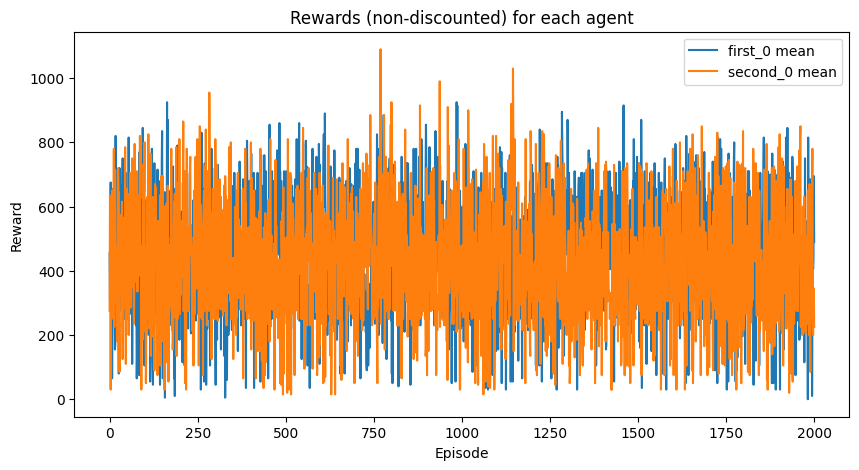

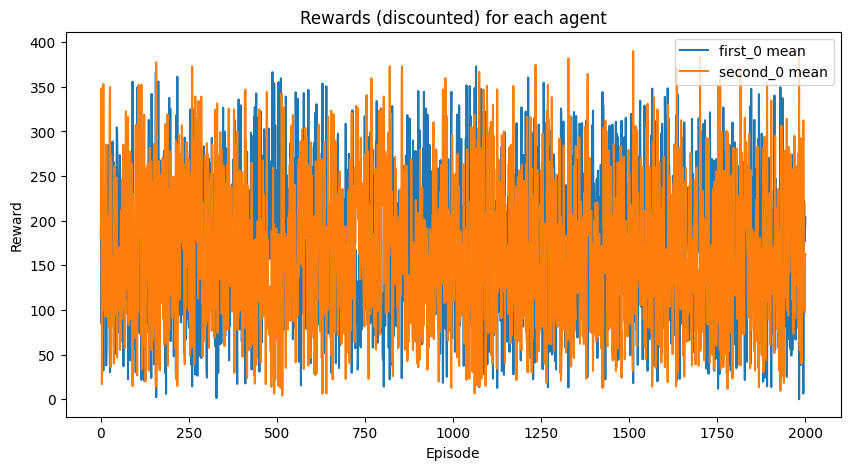

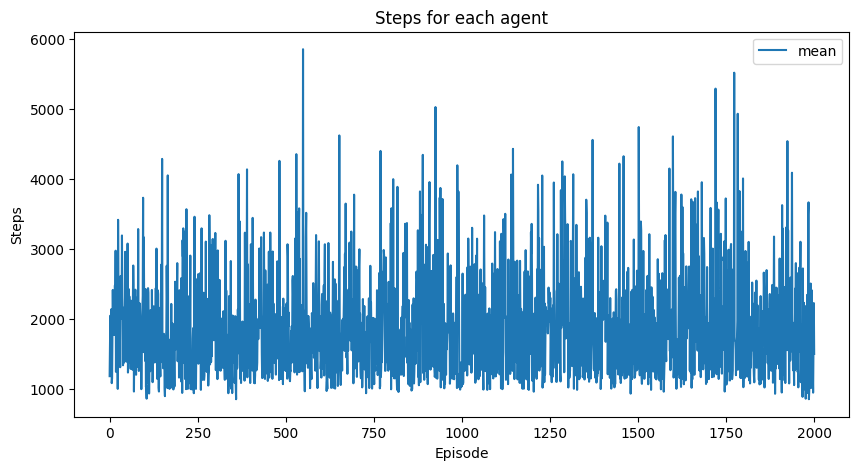

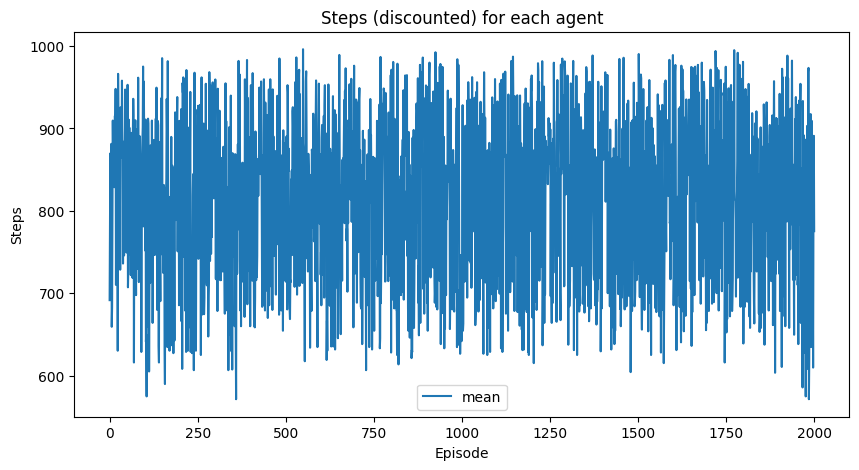

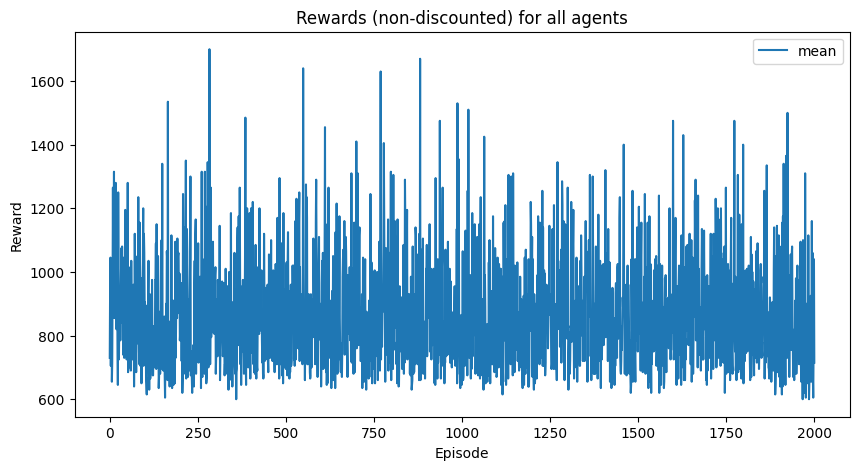

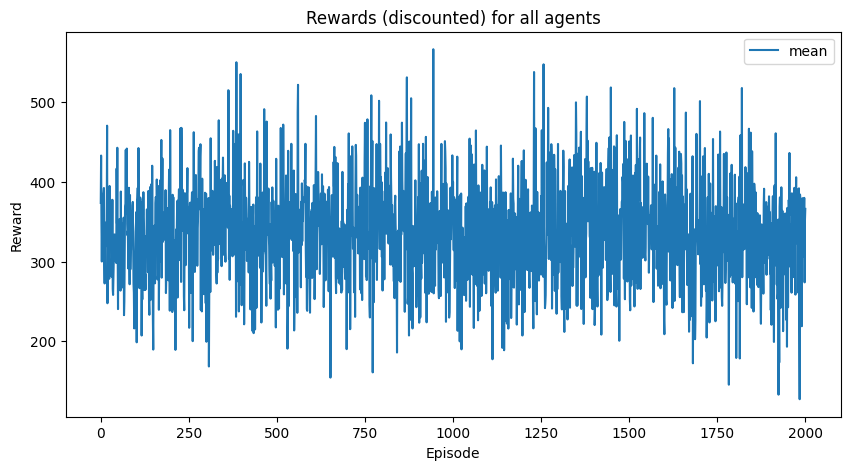

In [ ]:
plot_graphs(ep_rewards_MAPPOSV, ep_rewards_d_MAPPOSV, ep_steps_MAPPOSV, ep_steps_d_MAPPOSV, ep_rewards_all_MAPPOSV, ep_rewards_d_all_MAPPOSV, agent_names, episode_count)

### Test the agent from the last experiment

In [125]:
episode_count = 100
gamma = 0.999 #discount factor

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename = f"models/{game_name}_ex{i}_MAPPO_SV_eff_{effnet}_pre_{pretrained}.pt" #non intrinsic reward agent
#filename = f"models/{game_name}_ex{i}_MAPPO_SVir_eff_{effnet}_pre_{pretrained}.pt" #intrinsic reward agent
path = os.path.join(os.getcwd(), filename)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network = MAPPO_SV_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network.load_state_dict(torch.load(path))

ep_rewards_all_MAPPO_SVr, ep_rewards_d_all_MAPPO_SVr, ep_steps_MAPPO_SVr = render_policy_MAPPO_SV(env, agent_network, gamma, episode_count, device, record_video, video_prefix)

env.close()


Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
New max reward: 720.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test_max_reward_720.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
New max reward: 955.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test_max_reward_955.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_SV_test.avi
Recording video to /hom

## PPO Seperate Agents

In [126]:
# function for a training single MAPPO experiment
def train_PPO_id(parallel_env, agent_network1, agent_network2, optimizer1, optimizer2, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode="rgb_array", record_video=False, video_prefix=""):

    num_agents = len(parallel_env.possible_agents)
    effnet = agent_network1.effnet #assume both agents have the same effnet
    pretrained = agent_network1.pretrained

    # Define arrays to store rewards and steps for each agent and all agents
    ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_steps_d = np.zeros(episode_count)
    ep_rewards_all = np.zeros(episode_count)
    ep_rewards_d_all = np.zeros(episode_count)

    # Run the environment for the specified number of episodes
    for ep in tqdm(range(episode_count)):
        with torch.no_grad():
            # get initial observations
            next_obs = parallel_env.reset(seed=seed)
            first_0_state, second_0_state = next_obs['first_0'], next_obs['second_0']
            # print("first_0_state", first_0_state.shape)
            # print("second_0_state", second_0_state.shape)
            assert np.array_equal(first_0_state, second_0_state)

            terminations = [False]
            truncations = [False]
            
            if render_mode == "human":
                clock = pygame.time.Clock()

            video_writer = None
            if record_video and ep % 100 == 0:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPOid_eff_{effnet}_pre_{pretrained}_episode_{ep}_gamma_{gamma}.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), parallel_env.metadata["render_fps"], frame_size)
            
            #episode storage
            end_step = 0
            rb_obs = []
            rb_actions = []
            rb_logprobs = []
            rb_rewards = []
            rb_terms = []
            rb_values = []
            
            # Run the environment until all agents have terminated or truncated
            while not all(terminations) and not all(truncations):
                if render_mode == "human":
                    clock.tick(parallel_env.metadata["render_fps"])

                # rollover the observation (running on the same observations for each agent as a batch)
                obs = batchify_obs(next_obs, device)
                #get the shape of the first dimension of the observation,it should be 2 for 2 agents
                assert num_agents == obs.shape[0]

                # get action from the agents in different networks
                action, logprobs, _, values = agent_network1.get_action_and_value(obs[0:1])
                actions2, logprobs2, _, values2 = agent_network2.get_action_and_value(obs[1:2])

                #recombine the actions and logprobs
                actions = torch.cat((action, actions2), dim=0)
                logprobs = torch.cat((logprobs, logprobs2), dim=0)
                values = torch.stack((values, values2), dim=0) #combine values for both agents contribution

                # execute the environment and log data
                next_obs, rewards, terminations, truncations, infos = parallel_env.step(
                    unbatchify(actions, parallel_env)
                )
                assert np.array_equal(next_obs['first_0'], next_obs['second_0'])

                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                # add to episode storage
                rb_obs.append(obs)
                rb_rewards.append(batchify(rewards, device))
                rb_terms.append(batchify(terminations, device))
                rb_actions.append(actions)
                rb_logprobs.append(logprobs)
                rb_values.append(values.flatten())

                # store the rewards
                for agent in parallel_env.possible_agents:
                    ep_rewards[agent][ep] += rewards[agent]
                    ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

                ep_steps[ep] += 1
                ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])

                if record_video:
                    frame = parallel_env.render()
                    if record_video and ep % 100 == 0 and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            end_step = ep_steps[ep] - 1
            
            if video_writer is not None:
                video_writer.release()

            #convert lists to tensors floats and assign to device
            rb_obs = torch.stack(rb_obs, dim=0).to(device).float()
            rb_rewards = torch.stack(rb_rewards, dim=0).to(device).float()
            rb_terms = torch.stack(rb_terms, dim=0).to(device).float()
            rb_actions = torch.stack(rb_actions, dim=0).to(device).float()
            rb_logprobs = torch.stack(rb_logprobs, dim=0).to(device)
            rb_values = torch.stack(rb_values, dim=0).to(device)

            # compute returns and advantages
            # bootstrap value
            rb_advantages = torch.zeros_like(rb_rewards).to(device)
            for t in reversed(range(end_step)):
                delta = (
                    rb_rewards[t]
                    + gamma * rb_values[t + 1] * rb_terms[t + 1]
                    - rb_values[t]
                )
                rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
            rb_returns = rb_advantages + rb_values
        
        # convert episodes to batch of individual transitions
        b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
        b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
        b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
        b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
        b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
        b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

        # Optimizing the policy and value network
        b_index = np.arange(len(b_obs))
        clip_fracs = []
        for repeat in range(K_repeats):
            # shuffle the indices we use to access the data
            np.random.shuffle(b_index)
            for start in range(0, len(b_obs), batch_size):
                # select the indices we want to train on
                end = start + batch_size
                batch_index = b_index[start:end]

                #check if there are even and odd indices
                if np.any(batch_index % 2 == 0) and np.any(batch_index % 2 == 1):
                    #get all even batch_index use it to obtain action and value using the first agent, get all odd batch_index get action and value using the second agent
                    batch_index_even = batch_index[batch_index % 2 == 0]
                    batch_index_odd = batch_index[batch_index % 2 == 1]
                    #concat batch index together to get the full batch index with even and odds
                    batch_index = np.concatenate((batch_index_even, batch_index_odd), axis=0)

                    _, newlogprob, entropy, value = agent_network1.get_action_and_value(
                        b_obs[batch_index_even], b_actions.long()[batch_index_even]
                    )
                    _, newlogprob2, entropy2, value2 = agent_network2.get_action_and_value(
                        b_obs[batch_index_odd], b_actions.long()[batch_index_odd]
                    )

                    #combine together the new logprobs and entropys for both agents
                    newlogprobs = torch.cat((newlogprob, newlogprob2), dim=0)
                    entropys = torch.cat((entropy, entropy2), dim=0)
                    value = torch.cat((value, value2), dim=0) #obtain the value for each agents

                    logratio = newlogprobs - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    logratio_even = newlogprob - b_logprobs[batch_index_even]
                    ratio_even = logratio_even.exp()

                    logratio_odd = newlogprob2 - b_logprobs[batch_index_odd]
                    ratio_odd = logratio_odd.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Separate policy and entropy loss calculation
                    pg_loss1_agent1 = -b_advantages[batch_index_even] * ratio_even
                    pg_loss2_agent1 = -b_advantages[batch_index_even] * torch.clamp(
                        ratio_even, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent1 = torch.max(pg_loss1_agent1, pg_loss2_agent1).mean()

                    pg_loss1_agent2 = -b_advantages[batch_index_odd] * ratio_odd
                    pg_loss2_agent2 = -b_advantages[batch_index_odd] * torch.clamp(
                        ratio_odd, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss_agent2 = torch.max(pg_loss1_agent2, pg_loss2_agent2).mean()

                    entropy_loss_agent1 = entropy.mean()
                    entropy_loss_agent2 = entropy2.mean()


                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    # #loss all combined separately
                    loss = ((pg_loss_agent1 - ent_coef * entropy_loss_agent1) +  
                        (pg_loss_agent2 - ent_coef * entropy_loss_agent2) + (v_loss * vf_coef))

                else: #only indices of a single agent
                    first_agent = True if np.any(batch_index % 2 == 0) else False

                    if first_agent:
                        _, newlogprob, entropy, value = agent_network1.get_action_and_value(
                        b_obs[batch_index], b_actions.long()[batch_index]
                        )
                        logratio = newlogprob - b_logprobs[batch_index]
                        ratio = logratio.exp()
                    else:
                        _, newlogprob, entropy, value = agent_network2.get_action_and_value(
                        b_obs[batch_index], b_actions.long()[batch_index]
                        )
                        logratio = newlogprob - b_logprobs[batch_index]
                        ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs += [
                            ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                        ]

                    # normalize advantaegs
                    advantages = b_advantages[batch_index]
                    advantages = (advantages - advantages.mean()) / (
                        advantages.std() + 1e-8
                    )

                    # Policy loss
                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                        ratio, 1 - clip_coef, 1 + clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer1.zero_grad()
                optimizer2.zero_grad()
                loss.backward()
                optimizer1.step()
                optimizer2.step()

        y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

        print(f"Training episode {ep}")
        print(f"Episodic Return: {ep_rewards_all[ep]}")
        print(f"Episodic Return Discounted: {ep_rewards_d_all[ep]}")
        print(f"Episode Length: {ep_steps[ep]}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss agent 1: {pg_loss_agent1.item()}")
        print(f"Policy Loss agent 2: {pg_loss_agent2.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    # Return the different rewards
    return  agent_network1, agent_network2, ep_rewards, ep_rewards_d, ep_steps, ep_steps_d, ep_rewards_all, ep_rewards_d_all


def render_policy_PPO_id(env, agent_network1, agent_network2, gamma, episode_count, device, record_video, video_prefix):
    """ RENDER THE POLICY """
    agent_network1.eval()
    agent_network2.eval()

    ep_rewards_all = np.zeros(episode_count)
    ep_steps = np.zeros(episode_count, dtype=int)
    ep_rewards_d_all = np.zeros(episode_count)
    max_reward = -np.inf 

    with torch.no_grad():
        for ep in range(episode_count):
            obs = batchify_obs(env.reset(seed=None), device)

            terminations = [False]
            truncations = [False]

            video_writer = None
            if record_video:
                video_path = os.path.join(os.getcwd(), f"{video_prefix}_PPOid_test.avi")
                print(f"Recording video to {video_path}")
                frame_size = (160, 210)  # (width, height)
                video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)
            
            while not all(terminations) and not all(truncations):
                action, _, _, _ = agent_network1.get_action_and_value(obs[0:1])
                actions2, _, _, _ = agent_network2.get_action_and_value(obs[1:2])
                actions = torch.cat((action, actions2), dim=0)
                obs, rewards, terminations, truncations, infos = env.step(unbatchify(actions, env))
                obs = batchify_obs(obs, device)
                terminations = [terminations[a] for a in terminations]
                truncations = [truncations[a] for a in truncations]

                ep_rewards_all[ep] += sum(rewards.values())
                ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])
                ep_steps[ep] += 1

                if record_video:
                    frame = env.render()
                    if record_video and video_writer is not None:
                        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert to BGR format

            #store current episode reward by comparing to previous max
            if (video_writer is not None) and (ep_rewards_all[ep] > max_reward):
                max_reward = ep_rewards_all[ep]
                print(f"New max reward: {max_reward}")
                video_writer.release()
                #copy video to new path set below by max_reward using shutil
                video_path_new = os.path.join(os.getcwd(), f"{video_prefix}_PPOid_test_max_reward_{int(max_reward)}.avi")
                print(f"Moving video to {video_path_new}")
                shutil.move(video_path, video_path_new)

    return ep_rewards_all, ep_rewards_d_all, ep_steps


In [89]:
#hyperparameters for the experiment
experiment_count = 1
episode_count = 1001

#hyperparameters for PPO agent
ent_coef = 0.1 #entropy coefficient
vf_coef = 0.1 #value function coefficient
clip_coef = 0.1 #clip coefficient
gamma = 0.999 #discount factor
batch_size = 32 #batch size
K_repeats = 3 #number of repeats for the policy and value network optimization

#hyperparameters for the environment state
num_frames = 4 #try 3 for pretrained RGB model
frame_size = (64,64) #default (160, 210)

render_mode = "rgb_array" #render mode "human" or "rgb_array"
agent_names = ["first_0", "second_0"]
effnet = False #use efficient net as feature extractor
pretrained = False #use pretrained efficient net

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name

#define arrays to store rewards for each experiment
ep_rewards_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_rewards_d_PPO = {agent: np.zeros((experiment_count, episode_count)) for agent in agent_names}
ep_steps_PPO = np.zeros((experiment_count, episode_count))
ep_steps_d_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_all_PPO = np.zeros((experiment_count, episode_count))
ep_rewards_d_all_PPO = np.zeros((experiment_count, episode_count))


#loop over all experiments
for i in range(experiment_count):
    video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name

    print("Experiment {}".format(i))
    #create the parallel environment
    env = space_invaders_v2.parallel_env(render_mode=render_mode, alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
    env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
    env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
    env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

    num_actions = env.action_space(env.possible_agents[0]).n
    observation_size = env.observation_space(env.possible_agents[0]).shape

    print("Using device:", device)
    #initialize the agents
    agent_network_1 = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer_1 = optim.Adam(agent_network_1.parameters(), lr=0.001, eps=1e-5)
    agent_network_2 = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
    optimizer_2 = optim.Adam(agent_network_2.parameters(), lr=0.001, eps=1e-5)

    #run the experiment and store the rewards in the arrays
    agent_network_1, agent_network_2, ep_rewards_PPO_all, ep_rewards_d_PPO_all, ep_steps_PPO[i], ep_steps_d_PPO[i], ep_rewards_all_PPO[i], ep_rewards_d_all_PPO[i] = train_PPO_id(env, agent_network_1, agent_network_2, optimizer_1, optimizer_2, K_repeats, ent_coef, vf_coef, clip_coef, episode_count, frame_size, gamma, batch_size, device, render_mode=render_mode, record_video=record_video, video_prefix=video_prefix) 
    
    ep_rewards_PPO['first_0'][i] = ep_rewards_PPO_all['first_0']
    ep_rewards_PPO['second_0'][i] = ep_rewards_PPO_all['second_0']
    ep_rewards_d_PPO['first_0'][i] = ep_rewards_d_PPO_all['first_0']
    ep_rewards_d_PPO['second_0'][i] = ep_rewards_d_PPO_all['second_0']
    
    # Save the model to cwd
    filename1 = f"models/{game_name}_ex{i}_PPOid_eff_{effnet}_pre_{pretrained}_agent1.pt"
    filename2 = f"models/{game_name}_ex{i}_PPOid_eff_{effnet}_pre_{pretrained}_agent2.pt"
    path1 = os.path.join(os.getcwd(), filename1)
    path2 = os.path.join(os.getcwd(), filename2)
    torch.save(agent_network_1.state_dict(), path1)
    torch.save(agent_network_2.state_dict(), path2)

    #close the parallel environment
    env.close()

# combine all rewards into one array
ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])
# Save the rewards to cwd as a numpy array
filename = f"rewards_array/{game_name}_PPOid_eff_{effnet}_pre_{pretrained}_ex{experiment_count}_ep{episode_count}.npy"
path = os.path.join(os.getcwd(), filename)
np.save(path, ep_rewards_PPO_store)


Experiment 0
Using device: cuda


  0%|          | 0/1001 [00:00<?, ?it/s]

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_0_gamma_0.999.avi


  0%|          | 1/1001 [00:53<14:58:29, 53.91s/it]

Training episode 0
Episodic Return: 870.0
Episodic Return Discounted: 334.4645557621921
Episode Length: 1884

Value Loss: 174285.171875
Policy Loss agent 1: -723.0396728515625
Policy Loss agent 2: -401.80828857421875
Old Approx KL: -0.013617239892482758
Approx KL: 0.0005787367117591202
Clip Fraction: 0.06161723163841808
Explained Variance: -0.001700282096862793

-------------------------------------------



  0%|          | 2/1001 [01:30<12:07:50, 43.71s/it]

Training episode 1
Episodic Return: 720.0
Episodic Return Discounted: 388.1282419096673
Episode Length: 1118

Value Loss: 2357.273193359375
Policy Loss agent 1: -35.119834899902344
Policy Loss agent 2: -36.6793098449707
Old Approx KL: 0.005697397515177727
Approx KL: 0.0014767716638743877
Clip Fraction: 0.03146749085613659
Explained Variance: -0.001607060432434082

-------------------------------------------



  0%|          | 3/1001 [02:38<15:15:07, 55.02s/it]

Training episode 2
Episodic Return: 885.0
Episodic Return Discounted: 273.72720080851917
Episode Length: 2386

Value Loss: 425.0020751953125
Policy Loss agent 1: 90.78333282470703
Policy Loss agent 2: 18.699445724487305
Old Approx KL: -0.030072689056396484
Approx KL: 0.0004900097846984863
Clip Fraction: 0.15652777777777777
Explained Variance: 0.0009303092956542969

-------------------------------------------



  0%|          | 4/1001 [04:01<18:11:46, 65.70s/it]

Training episode 3
Episodic Return: 1070.0
Episodic Return Discounted: 265.9462305188161
Episode Length: 3458

Value Loss: 8273.0625
Policy Loss agent 1: -123.73849487304688
Policy Loss agent 2: 107.10975646972656
Old Approx KL: 0.13207459449768066
Approx KL: 0.03229805827140808
Clip Fraction: 0.1525057603686636
Explained Variance: -0.0029042959213256836

-------------------------------------------



  0%|          | 5/1001 [04:26<14:07:58, 51.08s/it]

Training episode 4
Episodic Return: 665.0
Episodic Return Discounted: 358.15200432624385
Episode Length: 1046

Value Loss: 31207.458984375
Policy Loss agent 1: -66.66160583496094
Policy Loss agent 2: -247.56381225585938
Old Approx KL: 0.029407525435090065
Approx KL: 0.003032350679859519
Clip Fraction: 0.17670454547712297
Explained Variance: -0.0034389495849609375

-------------------------------------------



  1%|          | 6/1001 [05:45<16:48:56, 60.84s/it]

Training episode 5
Episodic Return: 1185.0
Episodic Return Discounted: 256.0573464185849
Episode Length: 3414

Value Loss: 3503.097412109375
Policy Loss agent 1: 66.94929504394531
Policy Loss agent 2: -84.77653503417969
Old Approx KL: -0.027096880599856377
Approx KL: 0.0034024417400360107
Clip Fraction: 0.16105919004043687
Explained Variance: -0.0034362077713012695

-------------------------------------------



  1%|          | 7/1001 [06:47<16:50:44, 61.01s/it]

Training episode 6
Episodic Return: 1140.0
Episodic Return Discounted: 395.42712511026014
Episode Length: 2562

Value Loss: 2082.958984375
Policy Loss agent 1: -59.7468147277832
Policy Loss agent 2: 67.57469940185547
Old Approx KL: -0.003690659999847412
Approx KL: 0.003549724817276001
Clip Fraction: 0.22082039337474121
Explained Variance: -0.0033854246139526367

-------------------------------------------



  1%|          | 8/1001 [07:30<15:15:15, 55.30s/it]

Training episode 7
Episodic Return: 795.0
Episodic Return Discounted: 302.43282968682274
Episode Length: 1790

Value Loss: 2150.727783203125
Policy Loss agent 1: 6.6011061668396
Policy Loss agent 2: -38.54787826538086
Old Approx KL: 0.037134282290935516
Approx KL: 0.007026986684650183
Clip Fraction: 0.16975732606702618
Explained Variance: -0.0013710260391235352

-------------------------------------------



  1%|          | 9/1001 [07:56<12:40:47, 46.02s/it]

Training episode 8
Episodic Return: 690.0
Episodic Return Discounted: 354.7583718309727
Episode Length: 1080

Value Loss: 4659.32373046875
Policy Loss agent 1: 77.2525634765625
Policy Loss agent 2: -71.43878173828125
Old Approx KL: -0.02221783623099327
Approx KL: 0.009417351335287094
Clip Fraction: 0.2924763657444832
Explained Variance: -0.0009905099868774414

-------------------------------------------



  1%|          | 10/1001 [08:20<10:48:04, 39.24s/it]

Training episode 9
Episodic Return: 850.0
Episodic Return Discounted: 469.20437344253924
Episode Length: 990

Value Loss: 12183.154296875
Policy Loss agent 1: -211.16026306152344
Policy Loss agent 2: -14.876030921936035
Old Approx KL: -0.04101990535855293
Approx KL: 0.015313656069338322
Clip Fraction: 0.3256306867766124
Explained Variance: -0.003004908561706543

-------------------------------------------



  1%|          | 11/1001 [09:03<11:09:01, 40.55s/it]

Training episode 10
Episodic Return: 865.0
Episodic Return Discounted: 352.5398871676352
Episode Length: 1736

Value Loss: 18159.166015625
Policy Loss agent 1: 102.66675567626953
Policy Loss agent 2: 158.77972412109375
Old Approx KL: 0.1838521659374237
Approx KL: 0.043197646737098694
Clip Fraction: 0.44786205778428173
Explained Variance: -0.00248110294342041

-------------------------------------------



  1%|          | 12/1001 [09:31<10:03:09, 36.59s/it]

Training episode 11
Episodic Return: 650.0
Episodic Return Discounted: 353.93657868633153
Episode Length: 1078

Value Loss: 14158.861328125
Policy Loss agent 1: -41.04594421386719
Policy Loss agent 2: -242.26031494140625
Old Approx KL: -0.07366468012332916
Approx KL: 0.008510405197739601
Clip Fraction: 0.3061580883302525
Explained Variance: -0.0018085241317749023

-------------------------------------------



  1%|▏         | 13/1001 [10:54<13:53:27, 50.61s/it]

Training episode 12
Episodic Return: 1155.0
Episodic Return Discounted: 376.6631662275598
Episode Length: 3262

Value Loss: 8979.513671875
Policy Loss agent 1: 127.97342681884766
Policy Loss agent 2: 92.51598358154297
Old Approx KL: 0.028164859861135483
Approx KL: 0.018638819456100464
Clip Fraction: 0.5235435520998792
Explained Variance: -0.00018715858459472656

-------------------------------------------



  1%|▏         | 14/1001 [11:21<11:56:20, 43.55s/it]

Training episode 13
Episodic Return: 650.0
Episodic Return Discounted: 386.15973762600305
Episode Length: 1070

Value Loss: 13656.0361328125
Policy Loss agent 1: -164.3456573486328
Policy Loss agent 2: -89.00013732910156
Old Approx KL: -0.04054747149348259
Approx KL: 0.012355493381619453
Clip Fraction: 0.3271622657775879
Explained Variance: -0.00019860267639160156

-------------------------------------------



  1%|▏         | 15/1001 [12:08<12:16:12, 44.80s/it]

Training episode 14
Episodic Return: 1030.0
Episodic Return Discounted: 345.4264903741691
Episode Length: 1912

Value Loss: 8450.0205078125
Policy Loss agent 1: -83.00003814697266
Policy Loss agent 2: 96.82843017578125
Old Approx KL: -0.011029473505914211
Approx KL: 0.027913635596632957
Clip Fraction: 0.4624751986728774
Explained Variance: -0.002218961715698242

-------------------------------------------



  2%|▏         | 16/1001 [12:47<11:42:27, 42.79s/it]

Training episode 15
Episodic Return: 790.0
Episodic Return Discounted: 397.56233835239084
Episode Length: 1502

Value Loss: 8423.8623046875
Policy Loss agent 1: 118.75666809082031
Policy Loss agent 2: -103.17417907714844
Old Approx KL: -0.02541932836174965
Approx KL: 0.02098122611641884
Clip Fraction: 0.5225978587747465
Explained Variance: -0.0010173320770263672

-------------------------------------------



  2%|▏         | 17/1001 [13:51<13:26:17, 49.16s/it]

Training episode 16
Episodic Return: 1005.0
Episodic Return Discounted: 270.6465995894592
Episode Length: 2570

Value Loss: 20608.7265625
Policy Loss agent 1: -145.23959350585938
Policy Loss agent 2: 229.73094177246094
Old Approx KL: 0.0436517596244812
Approx KL: 0.028439683839678764
Clip Fraction: 0.5479784908995619
Explained Variance: -0.004910469055175781

-------------------------------------------



  2%|▏         | 18/1001 [15:08<15:42:25, 57.52s/it]

Training episode 17
Episodic Return: 1100.0
Episodic Return Discounted: 287.18130293406773
Episode Length: 3084

Value Loss: 12519.1591796875
Policy Loss agent 1: 79.54781341552734
Policy Loss agent 2: -179.61952209472656
Old Approx KL: 0.004857523832470179
Approx KL: 0.049694400280714035
Clip Fraction: 0.5519017900415859
Explained Variance: -0.0035240650177001953

-------------------------------------------



  2%|▏         | 19/1001 [15:30<12:51:17, 47.13s/it]

Training episode 18
Episodic Return: 635.0
Episodic Return Discounted: 400.2963429770223
Episode Length: 882

Value Loss: 1532.5701904296875
Policy Loss agent 1: -116.981201171875
Policy Loss agent 2: -40.816619873046875
Old Approx KL: -0.05159229040145874
Approx KL: 0.004614681005477905
Clip Fraction: 0.3822544642857143
Explained Variance: -0.0030554533004760742

-------------------------------------------



  2%|▏         | 20/1001 [16:20<13:02:54, 47.88s/it]

Training episode 19
Episodic Return: 755.0
Episodic Return Discounted: 312.7870075731324
Episode Length: 1944

Value Loss: 10669.90625
Policy Loss agent 1: 60.73854064941406
Policy Loss agent 2: 139.3495635986328
Old Approx KL: 0.3208564221858978
Approx KL: 0.12304355949163437
Clip Fraction: 0.4844481852210936
Explained Variance: -0.0013769865036010742

-------------------------------------------



  2%|▏         | 21/1001 [17:02<12:33:53, 46.16s/it]

Training episode 20
Episodic Return: 855.0
Episodic Return Discounted: 323.2587101523751
Episode Length: 1642

Value Loss: 2993.9853515625
Policy Loss agent 1: -3.8814544677734375
Policy Loss agent 2: -92.05697631835938
Old Approx KL: 0.002313249744474888
Approx KL: 0.029077516868710518
Clip Fraction: 0.46735661633577935
Explained Variance: -0.0014622211456298828

-------------------------------------------



  2%|▏         | 22/1001 [18:00<13:29:34, 49.62s/it]

Training episode 21
Episodic Return: 875.0
Episodic Return Discounted: 331.4221416882246
Episode Length: 2226

Value Loss: 18506.51953125
Policy Loss agent 1: -57.058433532714844
Policy Loss agent 2: 222.25970458984375
Old Approx KL: 0.41094326972961426
Approx KL: 0.13845372200012207
Clip Fraction: 0.5897321428571428
Explained Variance: -0.0025720596313476562

-------------------------------------------



  2%|▏         | 23/1001 [18:57<14:04:54, 51.83s/it]

Training episode 22
Episodic Return: 905.0
Episodic Return Discounted: 301.1014143022614
Episode Length: 2186

Value Loss: 4372.17822265625
Policy Loss agent 1: -60.03573989868164
Policy Loss agent 2: -81.99109649658203
Old Approx KL: -0.15418009459972382
Approx KL: 0.04985354468226433
Clip Fraction: 0.4425858340414191
Explained Variance: -0.0023652315139770508

-------------------------------------------



  2%|▏         | 24/1001 [19:36<13:02:14, 48.04s/it]

Training episode 23
Episodic Return: 715.0
Episodic Return Discounted: 275.26792322837423
Episode Length: 1512

Value Loss: 8443.751953125
Policy Loss agent 1: 137.47067260742188
Policy Loss agent 2: -19.120887756347656
Old Approx KL: 0.11392476409673691
Approx KL: 0.03131289780139923
Clip Fraction: 0.5252506268651862
Explained Variance: -0.0008289813995361328

-------------------------------------------



  2%|▏         | 25/1001 [20:03<11:18:59, 41.74s/it]

Training episode 24
Episodic Return: 730.0
Episodic Return Discounted: 402.06424124733684
Episode Length: 1062

Value Loss: 2706.710693359375
Policy Loss agent 1: -71.39070129394531
Policy Loss agent 2: -1.600407600402832
Old Approx KL: -0.05712583288550377
Approx KL: 0.007576203439384699
Clip Fraction: 0.4795708954704935
Explained Variance: -0.0018444061279296875

-------------------------------------------



  3%|▎         | 26/1001 [20:58<12:21:04, 45.61s/it]

Training episode 25
Episodic Return: 910.0
Episodic Return Discounted: 285.4058753621655
Episode Length: 2140

Value Loss: 23748.833984375
Policy Loss agent 1: 264.7872314453125
Policy Loss agent 2: 71.39102935791016
Old Approx KL: 0.15675710141658783
Approx KL: 0.027877962216734886
Clip Fraction: 0.6605891001165209
Explained Variance: -0.00025153160095214844

-------------------------------------------



  3%|▎         | 27/1001 [21:45<12:27:01, 46.02s/it]

Training episode 26
Episodic Return: 905.0
Episodic Return Discounted: 315.21349043786245
Episode Length: 1810

Value Loss: 282.3257751464844
Policy Loss agent 1: -2.2676565647125244
Policy Loss agent 2: -36.980525970458984
Old Approx KL: -0.13731300830841064
Approx KL: 0.04262590408325195
Clip Fraction: 0.5100511695906432
Explained Variance: -0.0010173320770263672

-------------------------------------------



  3%|▎         | 28/1001 [22:46<13:41:21, 50.65s/it]

Training episode 27
Episodic Return: 930.0
Episodic Return Discounted: 346.3768371113192
Episode Length: 2380

Value Loss: 24381.38671875
Policy Loss agent 1: 7.100239276885986
Policy Loss agent 2: 233.64984130859375
Old Approx KL: 0.1549878865480423
Approx KL: 0.049577098339796066
Clip Fraction: 0.547971324099257
Explained Variance: -0.0028280019760131836

-------------------------------------------



  3%|▎         | 29/1001 [24:03<15:49:29, 58.61s/it]

Training episode 28
Episodic Return: 1160.0
Episodic Return Discounted: 228.08004231650614
Episode Length: 3164

Value Loss: 7480.26318359375
Policy Loss agent 1: 73.94392395019531
Policy Loss agent 2: -148.4198455810547
Old Approx KL: 0.021986447274684906
Approx KL: 0.03359769657254219
Clip Fraction: 0.536238330381888
Explained Variance: -0.0031092166900634766

-------------------------------------------



  3%|▎         | 30/1001 [25:13<16:42:10, 61.93s/it]

Training episode 29
Episodic Return: 1120.0
Episodic Return Discounted: 308.8527235140731
Episode Length: 2832

Value Loss: 8007.2001953125
Policy Loss agent 1: -57.594749450683594
Policy Loss agent 2: 107.10324096679688
Old Approx KL: 0.02853144146502018
Approx KL: 0.05307314544916153
Clip Fraction: 0.5341533272055359
Explained Variance: -0.0026663541793823242

-------------------------------------------



  3%|▎         | 31/1001 [25:59<15:22:13, 57.05s/it]

Training episode 30
Episodic Return: 1060.0
Episodic Return Discounted: 292.22229450414056
Episode Length: 1872

Value Loss: 13656.61328125
Policy Loss agent 1: -133.4026641845703
Policy Loss agent 2: -194.33255004882812
Old Approx KL: -0.21005727350711823
Approx KL: 0.04718973860144615
Clip Fraction: 0.5975783479179752
Explained Variance: 0.0002897977828979492

-------------------------------------------



  3%|▎         | 32/1001 [26:24<12:46:46, 47.48s/it]

Training episode 31
Episodic Return: 645.0
Episodic Return Discounted: 392.64634113973796
Episode Length: 1012

Value Loss: 5639.515625
Policy Loss agent 1: -40.07677459716797
Policy Loss agent 2: 122.29925537109375
Old Approx KL: -0.06195223331451416
Approx KL: 0.017621954903006554
Clip Fraction: 0.516710069651405
Explained Variance: -0.002375006675720215

-------------------------------------------



  3%|▎         | 33/1001 [26:49<10:56:19, 40.68s/it]

Training episode 32
Episodic Return: 880.0
Episodic Return Discounted: 467.17055785966164
Episode Length: 1024

Value Loss: 2714.61962890625
Policy Loss agent 1: -29.853525161743164
Policy Loss agent 2: -60.84566879272461
Old Approx KL: -0.15084043145179749
Approx KL: 0.074199378490448
Clip Fraction: 0.4910047749678294
Explained Variance: 0.0020798444747924805

-------------------------------------------



  3%|▎         | 34/1001 [27:35<11:22:53, 42.37s/it]

Training episode 33
Episodic Return: 865.0
Episodic Return Discounted: 372.33044656397595
Episode Length: 1914

Value Loss: 47464.609375
Policy Loss agent 1: 390.6468505859375
Policy Loss agent 2: 154.6220703125
Old Approx KL: 0.21389378607273102
Approx KL: 0.07743819802999496
Clip Fraction: 0.7186728396349483
Explained Variance: -0.0021587610244750977

-------------------------------------------



  3%|▎         | 35/1001 [28:10<10:45:01, 40.06s/it]

Training episode 34
Episodic Return: 765.0
Episodic Return Discounted: 374.03621253405214
Episode Length: 1436

Value Loss: 13292.1083984375
Policy Loss agent 1: -83.78629302978516
Policy Loss agent 2: -179.90228271484375
Old Approx KL: -0.19881661236286163
Approx KL: 0.05528198927640915
Clip Fraction: 0.483522727533623
Explained Variance: 0.0007370114326477051

-------------------------------------------



  4%|▎         | 36/1001 [28:51<10:52:20, 40.56s/it]

Training episode 35
Episodic Return: 735.0
Episodic Return Discounted: 281.83888055076903
Episode Length: 1724

Value Loss: 2785.39892578125
Policy Loss agent 1: 44.79356002807617
Policy Loss agent 2: 53.01055145263672
Old Approx KL: 0.10748971998691559
Approx KL: 0.03383144736289978
Clip Fraction: 0.4375701460665391
Explained Variance: -0.00022482872009277344

-------------------------------------------



  4%|▎         | 37/1001 [29:42<11:40:16, 43.59s/it]

Training episode 36
Episodic Return: 1105.0
Episodic Return Discounted: 354.7667089008116
Episode Length: 1974

Value Loss: 5801.25390625
Policy Loss agent 1: 63.56574249267578
Policy Loss agent 2: -123.98619842529297
Old Approx KL: -0.04220198467373848
Approx KL: 0.0922766625881195
Clip Fraction: 0.5379536290482808
Explained Variance: 0.0002334117889404297

-------------------------------------------



  4%|▍         | 38/1001 [30:12<10:32:05, 39.38s/it]

Training episode 37
Episodic Return: 710.0
Episodic Return Discounted: 356.8854165241428
Episode Length: 1140

Value Loss: 2832.89453125
Policy Loss agent 1: -54.46215057373047
Policy Loss agent 2: 1.9313297271728516
Old Approx KL: -0.18788522481918335
Approx KL: 0.039499759674072266
Clip Fraction: 0.45944251575403744
Explained Variance: -0.0034453868865966797

-------------------------------------------



  4%|▍         | 39/1001 [30:55<10:52:03, 40.67s/it]

Training episode 38
Episodic Return: 765.0
Episodic Return Discounted: 319.3499667683914
Episode Length: 1704

Value Loss: 18181.171875
Policy Loss agent 1: 35.5517692565918
Policy Loss agent 2: 155.92926025390625
Old Approx KL: 0.3252021372318268
Approx KL: 0.09873469918966293
Clip Fraction: 0.6601301739891742
Explained Variance: -0.0014500617980957031

-------------------------------------------



  4%|▍         | 40/1001 [31:43<11:26:03, 42.83s/it]

Training episode 39
Episodic Return: 890.0
Episodic Return Discounted: 318.4020794160337
Episode Length: 1960

Value Loss: 5001.490234375
Policy Loss agent 1: -29.61089324951172
Policy Loss agent 2: -85.1490249633789
Old Approx KL: -0.07790609449148178
Approx KL: 0.020592987537384033
Clip Fraction: 0.5049966126276548
Explained Variance: -0.002306222915649414

-------------------------------------------



  4%|▍         | 41/1001 [32:27<11:28:52, 43.05s/it]

Training episode 40
Episodic Return: 1020.0
Episodic Return Discounted: 362.35874416148806
Episode Length: 1800

Value Loss: 4689.9130859375
Policy Loss agent 1: -49.87826156616211
Policy Loss agent 2: 25.68437957763672
Old Approx KL: -0.1348690390586853
Approx KL: 0.02853592485189438
Clip Fraction: 0.5484091868970247
Explained Variance: -0.0025202035903930664

-------------------------------------------



  4%|▍         | 42/1001 [33:00<10:43:20, 40.25s/it]

Training episode 41
Episodic Return: 750.0
Episodic Return Discounted: 355.42756561666556
Episode Length: 1382

Value Loss: 3632.36328125
Policy Loss agent 1: -118.13097381591797
Policy Loss agent 2: 0.0135841378942132
Old Approx KL: -0.06309230625629425
Approx KL: 0.01521119475364685
Clip Fraction: 0.44286398469716654
Explained Variance: 0.0020572543144226074

-------------------------------------------



  4%|▍         | 43/1001 [33:51<11:32:22, 43.36s/it]

Training episode 42
Episodic Return: 1185.0
Episodic Return Discounted: 484.961748463463
Episode Length: 2024

Value Loss: 5778.47412109375
Policy Loss agent 1: 67.5833511352539
Policy Loss agent 2: 55.18877410888672
Old Approx KL: 0.27088624238967896
Approx KL: 0.07480570673942566
Clip Fraction: 0.6083145859673267
Explained Variance: -6.723403930664062e-05

-------------------------------------------



  4%|▍         | 44/1001 [34:25<10:47:55, 40.62s/it]

Training episode 43
Episodic Return: 950.0
Episodic Return Discounted: 424.28630608954836
Episode Length: 1352

Value Loss: 12196.6162109375
Policy Loss agent 1: -24.619930267333984
Policy Loss agent 2: -200.1698760986328
Old Approx KL: -0.13699576258659363
Approx KL: 0.04055633023381233
Clip Fraction: 0.5554271710853951
Explained Variance: -0.0021849870681762695

-------------------------------------------



  4%|▍         | 45/1001 [34:52<9:39:27, 36.37s/it] 

Training episode 44
Episodic Return: 665.0
Episodic Return Discounted: 380.14546232581216
Episode Length: 1042

Value Loss: 4884.939453125
Policy Loss agent 1: -29.62932014465332
Policy Loss agent 2: 139.73802185058594
Old Approx KL: -0.2271386981010437
Approx KL: 0.02787315845489502
Clip Fraction: 0.5929608585858586
Explained Variance: -0.001126408576965332

-------------------------------------------



  5%|▍         | 46/1001 [35:22<9:10:45, 34.60s/it]

Training episode 45
Episodic Return: 740.0
Episodic Return Discounted: 415.49004829018435
Episode Length: 1208

Value Loss: 10350.9453125
Policy Loss agent 1: 111.10722351074219
Policy Loss agent 2: -163.3472137451172
Old Approx KL: -0.003803185187280178
Approx KL: 0.0996188148856163
Clip Fraction: 0.6356712098707232
Explained Variance: -0.0011566877365112305

-------------------------------------------



  5%|▍         | 47/1001 [36:00<9:27:27, 35.69s/it]

Training episode 46
Episodic Return: 760.0
Episodic Return Discounted: 349.85438922315564
Episode Length: 1522

Value Loss: 26690.296875
Policy Loss agent 1: -229.97616577148438
Policy Loss agent 2: 106.14462280273438
Old Approx KL: -0.1394222378730774
Approx KL: 0.014507830142974854
Clip Fraction: 0.6575520833333334
Explained Variance: -0.003690481185913086

-------------------------------------------



  5%|▍         | 48/1001 [36:51<10:36:31, 40.07s/it]

Training episode 47
Episodic Return: 840.0
Episodic Return Discounted: 334.6042177530383
Episode Length: 2060

Value Loss: 10435.6796875
Policy Loss agent 1: 132.37596130371094
Policy Loss agent 2: 100.09954833984375
Old Approx KL: 0.23560766875743866
Approx KL: 0.043386060744524
Clip Fraction: 0.6029847898455554
Explained Variance: -0.0006319284439086914

-------------------------------------------



  5%|▍         | 49/1001 [37:22<9:52:22, 37.33s/it] 

Training episode 48
Episodic Return: 650.0
Episodic Return Discounted: 319.9873908823212
Episode Length: 1270

Value Loss: 9056.4873046875
Policy Loss agent 1: -27.00020980834961
Policy Loss agent 2: -155.1758575439453
Old Approx KL: -0.22914353013038635
Approx KL: 0.07025635242462158
Clip Fraction: 0.5242968751738469
Explained Variance: -0.002989053726196289

-------------------------------------------



  5%|▍         | 50/1001 [37:59<9:50:08, 37.23s/it]

Training episode 49
Episodic Return: 930.0
Episodic Return Discounted: 430.2067412003838
Episode Length: 1506

Value Loss: 916.9467163085938
Policy Loss agent 1: 32.2971305847168
Policy Loss agent 2: 45.57783126831055
Old Approx KL: 0.11641716957092285
Approx KL: 0.00943291187286377
Clip Fraction: 0.5160087719298245
Explained Variance: 0.0008739829063415527

-------------------------------------------



  5%|▌         | 51/1001 [38:36<9:50:13, 37.28s/it]

Training episode 50
Episodic Return: 785.0
Episodic Return Discounted: 341.75985961496394
Episode Length: 1546

Value Loss: 6583.0849609375
Policy Loss agent 1: -25.24536895751953
Policy Loss agent 2: 120.7057113647461
Old Approx KL: 0.11266274005174637
Approx KL: 0.06009847670793533
Clip Fraction: 0.6121969262963718
Explained Variance: -2.5510787963867188e-05

-------------------------------------------



  5%|▌         | 52/1001 [39:28<10:58:17, 41.62s/it]

Training episode 51
Episodic Return: 980.0
Episodic Return Discounted: 238.70251070039484
Episode Length: 2184

Value Loss: 1648.865966796875
Policy Loss agent 1: -67.55938720703125
Policy Loss agent 2: 26.34918975830078
Old Approx KL: 0.06103668361902237
Approx KL: 0.014664646238088608
Clip Fraction: 0.5508124783381348
Explained Variance: 0.0021359920501708984

-------------------------------------------



  5%|▌         | 53/1001 [39:59<10:06:14, 38.37s/it]

Training episode 52
Episodic Return: 765.0
Episodic Return Discounted: 355.1854641670764
Episode Length: 1294

Value Loss: 11975.859375
Policy Loss agent 1: -155.17724609375
Policy Loss agent 2: -151.82333374023438
Old Approx KL: -0.36425113677978516
Approx KL: 0.15981680154800415
Clip Fraction: 0.6629075660627075
Explained Variance: 0.0021758675575256348

-------------------------------------------



  5%|▌         | 54/1001 [40:24<9:02:38, 34.38s/it] 

Training episode 53
Episodic Return: 660.0
Episodic Return Discounted: 366.8860320652196
Episode Length: 1052

Value Loss: 8468.8154296875
Policy Loss agent 1: 149.77529907226562
Policy Loss agent 2: 67.18217468261719
Old Approx KL: 0.376670241355896
Approx KL: 0.13208210468292236
Clip Fraction: 0.645747245562197
Explained Variance: -0.0009311437606811523

-------------------------------------------



  5%|▌         | 55/1001 [40:53<8:37:15, 32.81s/it]

Training episode 54
Episodic Return: 905.0
Episodic Return Discounted: 439.3119780817614
Episode Length: 1176

Value Loss: 14288.7294921875
Policy Loss agent 1: -245.9075164794922
Policy Loss agent 2: -42.92433166503906
Old Approx KL: -0.16503331065177917
Approx KL: 0.048880115151405334
Clip Fraction: 0.6209177930612821
Explained Variance: -4.553794860839844e-05

-------------------------------------------



  6%|▌         | 56/1001 [41:32<9:04:48, 34.59s/it]

Training episode 55
Episodic Return: 740.0
Episodic Return Discounted: 285.3478996413702
Episode Length: 1612

Value Loss: 50447.97265625
Policy Loss agent 1: 229.05105590820312
Policy Loss agent 2: 335.69085693359375
Old Approx KL: 0.8461604118347168
Approx KL: 0.4855003356933594
Clip Fraction: 0.7341265381366113
Explained Variance: -0.00024890899658203125

-------------------------------------------



  6%|▌         | 57/1001 [42:16<9:48:28, 37.40s/it]

Training episode 56
Episodic Return: 1210.0
Episodic Return Discounted: 438.3366245341124
Episode Length: 1824

Value Loss: 22371.720703125
Policy Loss agent 1: -112.76278686523438
Policy Loss agent 2: -255.75596618652344
Old Approx KL: -0.2371421903371811
Approx KL: 0.06613457202911377
Clip Fraction: 0.5881457117914456
Explained Variance: -0.0010905265808105469

-------------------------------------------



  6%|▌         | 58/1001 [42:49<9:30:40, 36.31s/it]

Training episode 57
Episodic Return: 765.0
Episodic Return Discounted: 337.11539060686033
Episode Length: 1356

Value Loss: 2471.229248046875
Policy Loss agent 1: 18.237377166748047
Policy Loss agent 2: 25.229536056518555
Old Approx KL: 0.12094546854496002
Approx KL: 0.046249255537986755
Clip Fraction: 0.4713792336922066
Explained Variance: 0.0014302730560302734

-------------------------------------------



  6%|▌         | 59/1001 [44:10<12:58:29, 49.59s/it]

Training episode 58
Episodic Return: 1185.0
Episodic Return Discounted: 194.32217265253732
Episode Length: 3378

Value Loss: 1881.8951416015625
Policy Loss agent 1: 371.4877624511719
Policy Loss agent 2: 31.055221557617188
Old Approx KL: 0.09964793920516968
Approx KL: 0.004886120557785034
Clip Fraction: 0.6246069182389937
Explained Variance: -0.0033464431762695312

-------------------------------------------



  6%|▌         | 60/1001 [44:52<12:20:16, 47.20s/it]

Training episode 59
Episodic Return: 1065.0
Episodic Return Discounted: 467.5045683828702
Episode Length: 1692

Value Loss: 38580.671875
Policy Loss agent 1: -366.1374816894531
Policy Loss agent 2: -101.52217102050781
Old Approx KL: -0.19358694553375244
Approx KL: 0.04065845161676407
Clip Fraction: 0.6101075617022484
Explained Variance: -0.004816532135009766

-------------------------------------------



  6%|▌         | 61/1001 [45:38<12:16:38, 47.02s/it]

Training episode 60
Episodic Return: 890.0
Episodic Return Discounted: 371.62159503314416
Episode Length: 1864

Value Loss: 12228.1630859375
Policy Loss agent 1: -10.93435287475586
Policy Loss agent 2: 195.72747802734375
Old Approx KL: 0.18656335771083832
Approx KL: 0.0602407231926918
Clip Fraction: 0.5509132073815391
Explained Variance: -0.004246354103088379

-------------------------------------------



  6%|▌         | 62/1001 [47:07<15:30:16, 59.44s/it]

Training episode 61
Episodic Return: 1230.0
Episodic Return Discounted: 322.7986239465387
Episode Length: 3584

Value Loss: 1726.3944091796875
Policy Loss agent 1: -38.01526641845703
Policy Loss agent 2: -18.279874801635742
Old Approx KL: -0.06517088413238525
Approx KL: 0.02249060943722725
Clip Fraction: 0.49937065987892093
Explained Variance: -0.0020744800567626953

-------------------------------------------



  6%|▋         | 63/1001 [47:32<12:49:06, 49.20s/it]

Training episode 62
Episodic Return: 820.0
Episodic Return Discounted: 452.50741914187824
Episode Length: 996

Value Loss: 5198.3759765625
Policy Loss agent 1: -25.188312530517578
Policy Loss agent 2: -167.76068115234375
Old Approx KL: -0.1141570433974266
Approx KL: 0.02345646545290947
Clip Fraction: 0.4817019400615541
Explained Variance: -0.001361250877380371

-------------------------------------------



  6%|▋         | 64/1001 [48:04<11:30:37, 44.22s/it]

Training episode 63
Episodic Return: 700.0
Episodic Return Discounted: 331.5781694444733
Episode Length: 1270

Value Loss: 5961.93359375
Policy Loss agent 1: 26.645965576171875
Policy Loss agent 2: 95.99103546142578
Old Approx KL: 0.3885146379470825
Approx KL: 0.20911335945129395
Clip Fraction: 0.5661458333333333
Explained Variance: 0.0007742047309875488

-------------------------------------------



  6%|▋         | 65/1001 [48:45<11:11:02, 43.02s/it]

Training episode 64
Episodic Return: 695.0
Episodic Return Discounted: 267.85984556661776
Episode Length: 1550

Value Loss: 9676.0390625
Policy Loss agent 1: -32.617095947265625
Policy Loss agent 2: 110.44548034667969
Old Approx KL: 0.10911914706230164
Approx KL: 0.07752743363380432
Clip Fraction: 0.6376305182570035
Explained Variance: -0.0010722875595092773

-------------------------------------------



  7%|▋         | 66/1001 [49:24<10:53:32, 41.94s/it]

Training episode 65
Episodic Return: 690.0
Episodic Return Discounted: 293.02810572949295
Episode Length: 1556

Value Loss: 13482.2060546875
Policy Loss agent 1: 157.26303100585938
Policy Loss agent 2: -172.953125
Old Approx KL: -0.22423231601715088
Approx KL: 0.11459245532751083
Clip Fraction: 0.6175595242149976
Explained Variance: -0.006544351577758789

-------------------------------------------



  7%|▋         | 67/1001 [50:33<12:59:32, 50.08s/it]

Training episode 66
Episodic Return: 1125.0
Episodic Return Discounted: 256.37637134358863
Episode Length: 2704

Value Loss: 22458.392578125
Policy Loss agent 1: -223.34609985351562
Policy Loss agent 2: 173.77017211914062
Old Approx KL: 0.02581748738884926
Approx KL: 0.1539907157421112
Clip Fraction: 0.716621466407174
Explained Variance: -0.0031104087829589844

-------------------------------------------



  7%|▋         | 68/1001 [51:16<12:25:52, 47.97s/it]

Training episode 67
Episodic Return: 1035.0
Episodic Return Discounted: 381.977936589122
Episode Length: 1696

Value Loss: 17734.611328125
Policy Loss agent 1: 126.07848358154297
Policy Loss agent 2: -187.6238250732422
Old Approx KL: 0.05016995221376419
Approx KL: 0.064544178545475
Clip Fraction: 0.646861897699488
Explained Variance: -0.00529634952545166

-------------------------------------------



  7%|▋         | 69/1001 [52:28<14:18:03, 55.24s/it]

Training episode 68
Episodic Return: 1115.0
Episodic Return Discounted: 273.0255855401694
Episode Length: 2842

Value Loss: 15553.4794921875
Policy Loss agent 1: 212.46939086914062
Policy Loss agent 2: 72.81440734863281
Old Approx KL: 0.26725736260414124
Approx KL: 0.07881677150726318
Clip Fraction: 0.6764331045333812
Explained Variance: -0.0016052722930908203

-------------------------------------------



  7%|▋         | 70/1001 [52:57<12:14:18, 47.32s/it]

Training episode 69
Episodic Return: 735.0
Episodic Return Discounted: 397.02301560350793
Episode Length: 1122

Value Loss: 25869.873046875
Policy Loss agent 1: -343.9167785644531
Policy Loss agent 2: -83.81834411621094
Old Approx KL: -0.2699902653694153
Approx KL: 0.041934967041015625
Clip Fraction: 0.6659330985915493
Explained Variance: -0.0042237043380737305

-------------------------------------------



  7%|▋         | 71/1001 [54:04<13:44:28, 53.19s/it]

Training episode 70
Episodic Return: 900.0
Episodic Return Discounted: 244.18115362654754
Episode Length: 2628

Value Loss: 6064.2822265625
Policy Loss agent 1: 62.10885238647461
Policy Loss agent 2: 167.23184204101562
Old Approx KL: 0.2472034990787506
Approx KL: 0.05797010660171509
Clip Fraction: 0.5644360269861992
Explained Variance: -0.00024759769439697266

-------------------------------------------



  7%|▋         | 72/1001 [54:32<11:46:13, 45.61s/it]

Training episode 71
Episodic Return: 675.0
Episodic Return Discounted: 355.96892855592336
Episode Length: 1088

Value Loss: 7012.0419921875
Policy Loss agent 1: -42.28867721557617
Policy Loss agent 2: -140.2054901123047
Old Approx KL: -0.20661336183547974
Approx KL: 0.08210190385580063
Clip Fraction: 0.5187806376055175
Explained Variance: 0.00041496753692626953

-------------------------------------------



  7%|▋         | 73/1001 [55:10<11:10:56, 43.38s/it]

Training episode 72
Episodic Return: 720.0
Episodic Return Discounted: 330.96527687973077
Episode Length: 1506

Value Loss: 5897.67431640625
Policy Loss agent 1: 0.4173312485218048
Policy Loss agent 2: 138.32252502441406
Old Approx KL: 0.14557456970214844
Approx KL: 0.04069775342941284
Clip Fraction: 0.5891447368421052
Explained Variance: -0.0013697147369384766

-------------------------------------------



  7%|▋         | 74/1001 [56:14<12:43:16, 49.40s/it]

Training episode 73
Episodic Return: 1195.0
Episodic Return Discounted: 357.02953103282147
Episode Length: 2524

Value Loss: 24726.302734375
Policy Loss agent 1: 216.35098266601562
Policy Loss agent 2: -116.81439208984375
Old Approx KL: 0.3888359069824219
Approx KL: 0.2050243318080902
Clip Fraction: 0.7141050537930259
Explained Variance: -0.003209829330444336

-------------------------------------------



  7%|▋         | 75/1001 [57:04<12:45:53, 49.63s/it]

Training episode 74
Episodic Return: 790.0
Episodic Return Discounted: 274.2663828463788
Episode Length: 1990

Value Loss: 22839.453125
Policy Loss agent 1: -306.18585205078125
Policy Loss agent 2: 156.56434631347656
Old Approx KL: 0.12236090004444122
Approx KL: 0.025387603789567947
Clip Fraction: 0.6923000000317892
Explained Variance: -0.0037282705307006836

-------------------------------------------



  8%|▊         | 76/1001 [57:49<12:22:18, 48.15s/it]

Training episode 75
Episodic Return: 770.0
Episodic Return Discounted: 338.68922842647316
Episode Length: 1738

Value Loss: 5240.5771484375
Policy Loss agent 1: 57.93870162963867
Policy Loss agent 2: -117.49405670166016
Old Approx KL: -0.06432795524597168
Approx KL: 0.04094010218977928
Clip Fraction: 0.5806893476652443
Explained Variance: -0.002803206443786621

-------------------------------------------



  8%|▊         | 77/1001 [58:42<12:44:00, 49.61s/it]

Training episode 76
Episodic Return: 910.0
Episodic Return Discounted: 348.89998154379833
Episode Length: 2092

Value Loss: 15075.6650390625
Policy Loss agent 1: -160.15042114257812
Policy Loss agent 2: 133.65359497070312
Old Approx KL: 0.15288397669792175
Approx KL: 0.10870453715324402
Clip Fraction: 0.6737725540578517
Explained Variance: -0.004258394241333008

-------------------------------------------



  8%|▊         | 78/1001 [59:07<10:50:48, 42.31s/it]

Training episode 77
Episodic Return: 665.0
Episodic Return Discounted: 391.1497972876328
Episode Length: 998

Value Loss: 7276.24462890625
Policy Loss agent 1: 3.883702278137207
Policy Loss agent 2: -107.55554962158203
Old Approx KL: -0.07132802158594131
Approx KL: 0.006223082542419434
Clip Fraction: 0.4486772488191645
Explained Variance: -0.004018902778625488

-------------------------------------------



  8%|▊         | 79/1001 [59:58<11:33:02, 45.10s/it]

Training episode 78
Episodic Return: 1040.0
Episodic Return Discounted: 303.6592820354655
Episode Length: 2040

Value Loss: 15575.681640625
Policy Loss agent 1: 181.4006805419922
Policy Loss agent 2: -42.72348403930664
Old Approx KL: 0.19002249836921692
Approx KL: 0.054010771214962006
Clip Fraction: 0.595075335043172
Explained Variance: -0.0013747215270996094

-------------------------------------------



  8%|▊         | 80/1001 [1:00:59<12:44:50, 49.83s/it]

Training episode 79
Episodic Return: 1160.0
Episodic Return Discounted: 336.2824898394659
Episode Length: 2388

Value Loss: 8745.36328125
Policy Loss agent 1: -133.07801818847656
Policy Loss agent 2: 5.9998674392700195
Old Approx KL: -0.12251715362071991
Approx KL: 0.10827110707759857
Clip Fraction: 0.5956250000662274
Explained Variance: -0.004231929779052734

-------------------------------------------



  8%|▊         | 81/1001 [1:01:25<10:52:33, 42.56s/it]

Training episode 80
Episodic Return: 685.0
Episodic Return Discounted: 400.0123665134562
Episode Length: 996

Value Loss: 3602.80322265625
Policy Loss agent 1: -141.1490478515625
Policy Loss agent 2: -33.49849319458008
Old Approx KL: -0.12841805815696716
Approx KL: 0.010406335815787315
Clip Fraction: 0.4595458557208379
Explained Variance: -0.0005815029144287109

-------------------------------------------



  8%|▊         | 82/1001 [1:02:30<12:35:04, 49.30s/it]

Training episode 81
Episodic Return: 1200.0
Episodic Return Discounted: 407.06034686569654
Episode Length: 2564

Value Loss: 7112.46630859375
Policy Loss agent 1: 148.81082153320312
Policy Loss agent 2: 52.68972396850586
Old Approx KL: 0.29995521903038025
Approx KL: 0.10099177807569504
Clip Fraction: 0.7112879573558428
Explained Variance: -0.00020968914031982422

-------------------------------------------



  8%|▊         | 83/1001 [1:03:18<12:27:55, 48.88s/it]

Training episode 82
Episodic Return: 830.0
Episodic Return Discounted: 319.5290600944517
Episode Length: 1900

Value Loss: 6786.58544921875
Policy Loss agent 1: -164.9288330078125
Policy Loss agent 2: -57.33345031738281
Old Approx KL: -0.32287707924842834
Approx KL: 0.4535365104675293
Clip Fraction: 0.542518143727332
Explained Variance: -0.0013298988342285156

-------------------------------------------



  8%|▊         | 84/1001 [1:03:44<10:41:28, 41.97s/it]

Training episode 83
Episodic Return: 680.0
Episodic Return Discounted: 392.24036968989856
Episode Length: 1002

Value Loss: 707.5847778320312
Policy Loss agent 1: 15.5078125
Policy Loss agent 2: 8.785236358642578
Old Approx KL: 0.05944691225886345
Approx KL: 0.01857198029756546
Clip Fraction: 0.4230967078101698
Explained Variance: 0.0049054622650146484

-------------------------------------------



  8%|▊         | 85/1001 [1:04:22<10:25:36, 40.98s/it]

Training episode 84
Episodic Return: 855.0
Episodic Return Discounted: 405.75118823935685
Episode Length: 1520

Value Loss: 12527.9296875
Policy Loss agent 1: 171.45260620117188
Policy Loss agent 2: -73.74581909179688
Old Approx KL: 0.11618632078170776
Approx KL: 0.08226432651281357
Clip Fraction: 0.6560526320808813
Explained Variance: -0.002399444580078125

-------------------------------------------



  9%|▊         | 86/1001 [1:04:50<9:24:26, 37.01s/it] 

Training episode 85
Episodic Return: 730.0
Episodic Return Discounted: 378.9845190264233
Episode Length: 1078

Value Loss: 5612.8837890625
Policy Loss agent 1: -119.30870819091797
Policy Loss agent 2: 19.582759857177734
Old Approx KL: 0.00997176207602024
Approx KL: 0.04718497395515442
Clip Fraction: 0.5579963235878477
Explained Variance: -0.005339503288269043

-------------------------------------------



  9%|▊         | 87/1001 [1:05:52<11:15:41, 44.36s/it]

Training episode 86
Episodic Return: 1075.0
Episodic Return Discounted: 341.4970005236244
Episode Length: 2426

Value Loss: 6788.1240234375
Policy Loss agent 1: 74.53816223144531
Policy Loss agent 2: 158.16673278808594
Old Approx KL: 0.22997744381427765
Approx KL: 0.04759731888771057
Clip Fraction: 0.6531508894343125
Explained Variance: 0.00019824504852294922

-------------------------------------------



  9%|▉         | 88/1001 [1:06:40<11:33:20, 45.56s/it]

Training episode 87
Episodic Return: 850.0
Episodic Return Discounted: 365.2766990678409
Episode Length: 1882

Value Loss: 7155.87841796875
Policy Loss agent 1: -101.77274322509766
Policy Loss agent 2: -125.29106903076172
Old Approx KL: -0.32952770590782166
Approx KL: 0.11999589949846268
Clip Fraction: 0.577516870646827
Explained Variance: -0.0036460161209106445

-------------------------------------------



  9%|▉         | 89/1001 [1:07:25<11:30:35, 45.43s/it]

Training episode 88
Episodic Return: 775.0
Episodic Return Discounted: 321.2383056320224
Episode Length: 1780

Value Loss: 9011.3974609375
Policy Loss agent 1: -61.80781555175781
Policy Loss agent 2: 34.648006439208984
Old Approx KL: 0.08744518458843231
Approx KL: 0.06396466493606567
Clip Fraction: 0.7072172620821566
Explained Variance: -0.0004978179931640625

-------------------------------------------



  9%|▉         | 90/1001 [1:08:00<10:40:18, 42.17s/it]

Training episode 89
Episodic Return: 680.0
Episodic Return Discounted: 341.33558001708997
Episode Length: 1346

Value Loss: 35054.7421875
Policy Loss agent 1: -379.0783386230469
Policy Loss agent 2: -161.5037384033203
Old Approx KL: -0.44542360305786133
Approx KL: 0.13815641403198242
Clip Fraction: 0.5964460784313725
Explained Variance: -0.00177764892578125

-------------------------------------------



  9%|▉         | 91/1001 [1:09:02<12:09:40, 48.11s/it]

Training episode 90
Episodic Return: 875.0
Episodic Return Discounted: 192.14304842843515
Episode Length: 2452

Value Loss: 9197.755859375
Policy Loss agent 1: 201.98849487304688
Policy Loss agent 2: 42.03704071044922
Old Approx KL: 0.28076159954071045
Approx KL: 0.06710949540138245
Clip Fraction: 0.6818632756992852
Explained Variance: -0.00040984153747558594

-------------------------------------------



  9%|▉         | 92/1001 [1:09:29<10:32:46, 41.77s/it]

Training episode 91
Episodic Return: 620.0
Episodic Return Discounted: 363.75358241532683
Episode Length: 1054

Value Loss: 17596.857421875
Policy Loss agent 1: -320.1478576660156
Policy Loss agent 2: -23.453323364257812
Old Approx KL: -0.09600301086902618
Approx KL: 0.03080163709819317
Clip Fraction: 0.5253253693532463
Explained Variance: -0.0031594038009643555

-------------------------------------------



  9%|▉         | 93/1001 [1:10:16<10:58:29, 43.51s/it]

Training episode 92
Episodic Return: 915.0
Episodic Return Discounted: 381.97030318566357
Episode Length: 1876

Value Loss: 15965.7841796875
Policy Loss agent 1: 186.00088500976562
Policy Loss agent 2: -106.6203842163086
Old Approx KL: 0.34922370314598083
Approx KL: 0.19687187671661377
Clip Fraction: 0.6436852636815464
Explained Variance: -0.002743959426879883

-------------------------------------------



  9%|▉         | 94/1001 [1:11:30<13:13:58, 52.52s/it]

Training episode 93
Episodic Return: 1100.0
Episodic Return Discounted: 373.70934002560904
Episode Length: 2890

Value Loss: 12452.0712890625
Policy Loss agent 1: -146.8798828125
Policy Loss agent 2: 139.13536071777344
Old Approx KL: 0.017660656943917274
Approx KL: 0.09732912480831146
Clip Fraction: 0.6758939533822005
Explained Variance: -0.004154324531555176

-------------------------------------------



  9%|▉         | 95/1001 [1:12:02<11:43:38, 46.60s/it]

Training episode 94
Episodic Return: 925.0
Episodic Return Discounted: 429.9964097868782
Episode Length: 1288

Value Loss: 18374.16796875
Policy Loss agent 1: -30.318889617919922
Policy Loss agent 2: -282.4527587890625
Old Approx KL: -0.1610373854637146
Approx KL: 0.03958698362112045
Clip Fraction: 0.59106775468269
Explained Variance: -0.00388336181640625

-------------------------------------------



 10%|▉         | 96/1001 [1:12:28<10:06:51, 40.23s/it]

Training episode 95
Episodic Return: 635.0
Episodic Return Discounted: 363.78042211234776
Episode Length: 1060

Value Loss: 2578.02978515625
Policy Loss agent 1: -0.693096935749054
Policy Loss agent 2: 5.411864757537842
Old Approx KL: 0.14581018686294556
Approx KL: 0.041272759437561035
Clip Fraction: 0.5110903817474546
Explained Variance: 0.0012087225914001465

-------------------------------------------



 10%|▉         | 97/1001 [1:13:00<9:27:53, 37.69s/it] 

Training episode 96
Episodic Return: 715.0
Episodic Return Discounted: 361.0259210818227
Episode Length: 1286

Value Loss: 17947.046875
Policy Loss agent 1: 168.29965209960938
Policy Loss agent 2: -190.27049255371094
Old Approx KL: 0.10925024747848511
Approx KL: 0.14398354291915894
Clip Fraction: 0.6846450618755671
Explained Variance: -0.0037897825241088867

-------------------------------------------



 10%|▉         | 98/1001 [1:13:41<9:42:40, 38.72s/it]

Training episode 97
Episodic Return: 880.0
Episodic Return Discounted: 377.45308890764386
Episode Length: 1696

Value Loss: 3706.40966796875
Policy Loss agent 1: -114.1871566772461
Policy Loss agent 2: 13.46734619140625
Old Approx KL: -0.023925265297293663
Approx KL: 0.05108378827571869
Clip Fraction: 0.5541797696419482
Explained Variance: -0.006137490272521973

-------------------------------------------



 10%|▉         | 99/1001 [1:14:26<10:10:42, 40.62s/it]

Training episode 98
Episodic Return: 805.0
Episodic Return Discounted: 351.2924829623881
Episode Length: 1850

Value Loss: 8971.580078125
Policy Loss agent 1: 107.18852233886719
Policy Loss agent 2: 102.45753479003906
Old Approx KL: 0.5884899497032166
Approx KL: 0.2393660545349121
Clip Fraction: 0.6470805398006548
Explained Variance: -0.0002551078796386719

-------------------------------------------



 10%|▉         | 100/1001 [1:15:41<12:47:01, 51.08s/it]

Training episode 99
Episodic Return: 1155.0
Episodic Return Discounted: 335.95988090020256
Episode Length: 3112

Value Loss: 3457.8154296875
Policy Loss agent 1: 40.3719596862793
Policy Loss agent 2: -21.56270980834961
Old Approx KL: 0.07306313514709473
Approx KL: 0.13561169803142548
Clip Fraction: 0.5596153846663288
Explained Variance: -0.0025141239166259766

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_100_gamma_0.999.avi


 10%|█         | 101/1001 [1:16:45<13:40:58, 54.73s/it]

Training episode 100
Episodic Return: 1380.0
Episodic Return Discounted: 513.2061819471993
Episode Length: 2552

Value Loss: 18768.7265625
Policy Loss agent 1: -292.84930419921875
Policy Loss agent 2: -121.6624526977539
Old Approx KL: -0.3601318895816803
Approx KL: 0.1689341515302658
Clip Fraction: 0.6444940478851398
Explained Variance: -0.0005066394805908203

-------------------------------------------



 10%|█         | 102/1001 [1:17:39<13:38:23, 54.62s/it]

Training episode 101
Episodic Return: 975.0
Episodic Return Discounted: 289.7808825871477
Episode Length: 2314

Value Loss: 4239.32958984375
Policy Loss agent 1: 103.37802124023438
Policy Loss agent 2: 22.49627685546875
Old Approx KL: 0.25148001313209534
Approx KL: 0.07027405500411987
Clip Fraction: 0.6643757982500669
Explained Variance: -0.0032178163528442383

-------------------------------------------



 10%|█         | 103/1001 [1:18:09<11:48:02, 47.31s/it]

Training episode 102
Episodic Return: 1015.0
Episodic Return Discounted: 503.98753227492585
Episode Length: 1268

Value Loss: 39219.44921875
Policy Loss agent 1: -452.7767333984375
Policy Loss agent 2: -102.66807556152344
Old Approx KL: -0.40388965606689453
Approx KL: 0.27747973799705505
Clip Fraction: 0.6358506945272286
Explained Variance: -0.001965761184692383

-------------------------------------------



 10%|█         | 104/1001 [1:18:34<10:05:39, 40.51s/it]

Training episode 103
Episodic Return: 645.0
Episodic Return Discounted: 381.29022051124247
Episode Length: 960

Value Loss: 3221.260498046875
Policy Loss agent 1: 20.6154727935791
Policy Loss agent 2: 6.128770351409912
Old Approx KL: 0.05495652183890343
Approx KL: 0.07052254676818848
Clip Fraction: 0.541562500430478
Explained Variance: 0.0009374618530273438

-------------------------------------------



 10%|█         | 105/1001 [1:19:05<9:22:38, 37.68s/it] 

Training episode 104
Episodic Return: 675.0
Episodic Return Discounted: 337.9663766568572
Episode Length: 1212

Value Loss: 4622.48681640625
Policy Loss agent 1: -107.2694320678711
Policy Loss agent 2: 8.892806053161621
Old Approx KL: -0.039404816925525665
Approx KL: 0.07959085702896118
Clip Fraction: 0.5256927834268201
Explained Variance: -0.0005862712860107422

-------------------------------------------



 11%|█         | 106/1001 [1:19:31<8:29:39, 34.17s/it]

Training episode 105
Episodic Return: 610.0
Episodic Return Discounted: 370.606157919547
Episode Length: 996

Value Loss: 3165.772216796875
Policy Loss agent 1: 78.28154754638672
Policy Loss agent 2: -55.459129333496094
Old Approx KL: -0.06038159132003784
Approx KL: 0.009599387645721436
Clip Fraction: 0.5682319226088347
Explained Variance: -0.0039283037185668945

-------------------------------------------



 11%|█         | 107/1001 [1:20:13<9:05:45, 36.63s/it]

Training episode 106
Episodic Return: 740.0
Episodic Return Discounted: 273.7188706914924
Episode Length: 1670

Value Loss: 33915.80859375
Policy Loss agent 1: -134.2262725830078
Policy Loss agent 2: 274.2080078125
Old Approx KL: 0.06371505558490753
Approx KL: 0.04611387476325035
Clip Fraction: 0.6950595238852122
Explained Variance: -0.0031392574310302734

-------------------------------------------



 11%|█         | 108/1001 [1:20:47<8:52:42, 35.79s/it]

Training episode 107
Episodic Return: 750.0
Episodic Return Discounted: 334.2893367885704
Episode Length: 1354

Value Loss: 36923.8046875
Policy Loss agent 1: 138.74444580078125
Policy Loss agent 2: -339.37359619140625
Old Approx KL: 0.0007722311420366168
Approx KL: 0.06724473088979721
Clip Fraction: 0.6329112200176015
Explained Variance: -0.006162881851196289

-------------------------------------------



 11%|█         | 109/1001 [1:21:19<8:36:20, 34.73s/it]

Training episode 108
Episodic Return: 850.0
Episodic Return Discounted: 410.2296261185549
Episode Length: 1310

Value Loss: 4571.5224609375
Policy Loss agent 1: -62.28435134887695
Policy Loss agent 2: -98.17610168457031
Old Approx KL: -0.24741782248020172
Approx KL: 0.24907799065113068
Clip Fraction: 0.49059959349593496
Explained Variance: 0.0031666159629821777

-------------------------------------------



 11%|█         | 110/1001 [1:22:15<10:08:02, 40.95s/it]

Training episode 109
Episodic Return: 940.0
Episodic Return Discounted: 335.74900309406
Episode Length: 2242

Value Loss: 1294.4111328125
Policy Loss agent 1: 35.5980339050293
Policy Loss agent 2: 56.27754211425781
Old Approx KL: 0.34596800804138184
Approx KL: 0.09433799982070923
Clip Fraction: 0.6569887706855791
Explained Variance: -0.0012509822845458984

-------------------------------------------



 11%|█         | 111/1001 [1:22:41<9:00:56, 36.47s/it] 

Training episode 110
Episodic Return: 710.0
Episodic Return Discounted: 403.9413389745592
Episode Length: 998

Value Loss: 13147.0068359375
Policy Loss agent 1: -148.22354125976562
Policy Loss agent 2: -170.43963623046875
Old Approx KL: -0.18972189724445343
Approx KL: 0.021258175373077393
Clip Fraction: 0.5647486774694352
Explained Variance: 0.00035244226455688477

-------------------------------------------



 11%|█         | 112/1001 [1:23:11<8:30:46, 34.47s/it]

Training episode 111
Episodic Return: 890.0
Episodic Return Discounted: 417.3943477093771
Episode Length: 1170

Value Loss: 5418.7236328125
Policy Loss agent 1: 9.182879447937012
Policy Loss agent 2: -161.8313446044922
Old Approx KL: -0.20248806476593018
Approx KL: 0.023292124271392822
Clip Fraction: 0.6137387387387387
Explained Variance: -0.004438877105712891

-------------------------------------------



 11%|█▏        | 113/1001 [1:23:49<8:46:25, 35.57s/it]

Training episode 112
Episodic Return: 885.0
Episodic Return Discounted: 396.0695059873516
Episode Length: 1554

Value Loss: 2233.891845703125
Policy Loss agent 1: -4.3537702560424805
Policy Loss agent 2: 110.71125793457031
Old Approx KL: 0.06756877899169922
Approx KL: 0.01207628846168518
Clip Fraction: 0.6024659863945578
Explained Variance: 0.0003758668899536133

-------------------------------------------



 11%|█▏        | 114/1001 [1:24:34<9:26:59, 38.35s/it]

Training episode 113
Episodic Return: 780.0
Episodic Return Discounted: 282.1368200384564
Episode Length: 1824

Value Loss: 7642.94873046875
Policy Loss agent 1: 93.99881744384766
Policy Loss agent 2: -101.08897399902344
Old Approx KL: 0.09226933866739273
Approx KL: 0.0908530056476593
Clip Fraction: 0.5917824077153067
Explained Variance: -0.0019255876541137695

-------------------------------------------



 11%|█▏        | 115/1001 [1:25:08<9:07:21, 37.07s/it]

Training episode 114
Episodic Return: 780.0
Episodic Return Discounted: 361.1230825506966
Episode Length: 1366

Value Loss: 7322.01318359375
Policy Loss agent 1: -223.12705993652344
Policy Loss agent 2: 14.76435661315918
Old Approx KL: 0.03332879766821861
Approx KL: 0.15169855952262878
Clip Fraction: 0.5543846899224806
Explained Variance: -0.002514481544494629

-------------------------------------------



 12%|█▏        | 116/1001 [1:25:35<8:24:23, 34.20s/it]

Training episode 115
Episodic Return: 830.0
Episodic Return Discounted: 438.4312262347154
Episode Length: 1090

Value Loss: 7761.873046875
Policy Loss agent 1: 60.17360305786133
Policy Loss agent 2: -96.18922424316406
Old Approx KL: -0.1316545605659485
Approx KL: 0.014598608016967773
Clip Fraction: 0.5548007246376812
Explained Variance: -0.0017868280410766602

-------------------------------------------



 12%|█▏        | 117/1001 [1:26:04<7:59:35, 32.55s/it]

Training episode 116
Episodic Return: 725.0
Episodic Return Discounted: 369.29663710931726
Episode Length: 1166

Value Loss: 16182.134765625
Policy Loss agent 1: -128.16078186035156
Policy Loss agent 2: 194.15603637695312
Old Approx KL: 0.11208949238061905
Approx KL: 0.08044382184743881
Clip Fraction: 0.6610686691928672
Explained Variance: -0.002067089080810547

-------------------------------------------



 12%|█▏        | 118/1001 [1:27:18<11:01:01, 44.92s/it]

Training episode 117
Episodic Return: 1035.0
Episodic Return Discounted: 283.1546292211823
Episode Length: 2996

Value Loss: 121001.7109375
Policy Loss agent 1: 544.1143798828125
Policy Loss agent 2: 6.8030314445495605
Old Approx KL: 0.1659095585346222
Approx KL: 0.05010863393545151
Clip Fraction: 0.6844525710276678
Explained Variance: -0.00398564338684082

-------------------------------------------



 12%|█▏        | 119/1001 [1:28:19<12:12:36, 49.84s/it]

Training episode 118
Episodic Return: 1055.0
Episodic Return Discounted: 352.36856665892105
Episode Length: 2462

Value Loss: 45373.55859375
Policy Loss agent 1: -434.7486572265625
Policy Loss agent 2: 40.008384704589844
Old Approx KL: -0.03713272884488106
Approx KL: 0.08705152571201324
Clip Fraction: 0.6103531885972787
Explained Variance: -0.003558039665222168

-------------------------------------------



 12%|█▏        | 120/1001 [1:28:46<10:32:33, 43.08s/it]

Training episode 119
Episodic Return: 785.0
Episodic Return Discounted: 409.85259095282316
Episode Length: 1084

Value Loss: 16703.1171875
Policy Loss agent 1: 25.1269588470459
Policy Loss agent 2: -275.19927978515625
Old Approx KL: -0.00045843017869628966
Approx KL: 0.035516444593667984
Clip Fraction: 0.45330603844394873
Explained Variance: -0.0019059181213378906

-------------------------------------------



 12%|█▏        | 121/1001 [1:29:47<11:48:17, 48.29s/it]

Training episode 120
Episodic Return: 1030.0
Episodic Return Discounted: 215.25995418065884
Episode Length: 2454

Value Loss: 8240.22265625
Policy Loss agent 1: -92.80057525634766
Policy Loss agent 2: 80.11976623535156
Old Approx KL: 0.09317820519208908
Approx KL: 0.0307264756411314
Clip Fraction: 0.6083062770433756
Explained Variance: -0.0046738386154174805

-------------------------------------------



 12%|█▏        | 122/1001 [1:30:18<10:32:38, 43.18s/it]

Training episode 121
Episodic Return: 750.0
Episodic Return Discounted: 384.23510727551195
Episode Length: 1246

Value Loss: 2373.234130859375
Policy Loss agent 1: 34.55556106567383
Policy Loss agent 2: -53.49190902709961
Old Approx KL: 0.01341370027512312
Approx KL: 0.08856302499771118
Clip Fraction: 0.41101660105025667
Explained Variance: -0.0006545782089233398

-------------------------------------------



 12%|█▏        | 123/1001 [1:30:45<9:21:05, 38.34s/it] 

Training episode 122
Episodic Return: 665.0
Episodic Return Discounted: 382.00339970812377
Episode Length: 1074

Value Loss: 30.807693481445312
Policy Loss agent 1: 57.70155715942383
Policy Loss agent 2: 2.4788818359375
Old Approx KL: 0.0353122353553772
Approx KL: 0.0006480216979980469
Clip Fraction: 0.49954044117647056
Explained Variance: 0.0003590583801269531

-------------------------------------------



 12%|█▏        | 124/1001 [1:31:38<10:23:37, 42.67s/it]

Training episode 123
Episodic Return: 1115.0
Episodic Return Discounted: 481.4032584212307
Episode Length: 2130

Value Loss: 27852.99609375
Policy Loss agent 1: -124.81231689453125
Policy Loss agent 2: 189.94760131835938
Old Approx KL: 0.23272013664245605
Approx KL: 0.02539011836051941
Clip Fraction: 0.6501088308457711
Explained Variance: -0.0027605295181274414

-------------------------------------------



 12%|█▏        | 125/1001 [1:32:16<10:01:22, 41.19s/it]

Training episode 124
Episodic Return: 660.0
Episodic Return Discounted: 247.90659930808366
Episode Length: 1510

Value Loss: 10398.236328125
Policy Loss agent 1: 95.86946868896484
Policy Loss agent 2: -126.4583969116211
Old Approx KL: -0.009587717242538929
Approx KL: 0.017674529924988747
Clip Fraction: 0.555789473809694
Explained Variance: -0.0070192813873291016

-------------------------------------------



 13%|█▎        | 126/1001 [1:32:43<9:02:08, 37.18s/it] 

Training episode 125
Episodic Return: 635.0
Episodic Return Discounted: 377.8449085188574
Episode Length: 1110

Value Loss: 3099.74267578125
Policy Loss agent 1: 77.94239807128906
Policy Loss agent 2: -50.90453338623047
Old Approx KL: -0.022489583119750023
Approx KL: 0.04369693621993065
Clip Fraction: 0.49642857171240307
Explained Variance: -0.0017873048782348633

-------------------------------------------



 13%|█▎        | 127/1001 [1:33:32<9:50:32, 40.54s/it]

Training episode 126
Episodic Return: 790.0
Episodic Return Discounted: 329.7885750384903
Episode Length: 1942

Value Loss: 11172.1435546875
Policy Loss agent 1: 120.71415710449219
Policy Loss agent 2: 93.41796112060547
Old Approx KL: 0.324934184551239
Approx KL: 0.09165580570697784
Clip Fraction: 0.6566598360818592
Explained Variance: 0.0015568733215332031

-------------------------------------------



 13%|█▎        | 128/1001 [1:33:57<8:45:18, 36.10s/it]

Training episode 127
Episodic Return: 690.0
Episodic Return Discounted: 398.04137541468356
Episode Length: 1014

Value Loss: 19661.80078125
Policy Loss agent 1: -223.95932006835938
Policy Loss agent 2: -91.06973266601562
Old Approx KL: -0.1856307089328766
Approx KL: 0.06638931483030319
Clip Fraction: 0.6430338543529311
Explained Variance: -0.0016499757766723633

-------------------------------------------



 13%|█▎        | 129/1001 [1:34:55<10:19:50, 42.65s/it]

Training episode 128
Episodic Return: 980.0
Episodic Return Discounted: 285.749046122216
Episode Length: 2344

Value Loss: 21678.74609375
Policy Loss agent 1: 64.98927307128906
Policy Loss agent 2: 185.86798095703125
Old Approx KL: 0.4550080895423889
Approx KL: 0.2286960482597351
Clip Fraction: 0.724388565200797
Explained Variance: -0.0015898942947387695

-------------------------------------------



 13%|█▎        | 130/1001 [1:35:27<9:30:10, 39.28s/it] 

Training episode 129
Episodic Return: 695.0
Episodic Return Discounted: 344.1413716039328
Episode Length: 1252

Value Loss: 20597.0
Policy Loss agent 1: -271.1570129394531
Policy Loss agent 2: -210.0401611328125
Old Approx KL: -0.17075638473033905
Approx KL: 0.01852407120168209
Clip Fraction: 0.6050896628245019
Explained Variance: -0.001796126365661621

-------------------------------------------



 13%|█▎        | 131/1001 [1:36:09<9:44:11, 40.29s/it]

Training episode 130
Episodic Return: 740.0
Episodic Return Discounted: 285.01125437060387
Episode Length: 1702

Value Loss: 3959.887451171875
Policy Loss agent 1: 45.65849304199219
Policy Loss agent 2: 71.7015609741211
Old Approx KL: 0.2760913074016571
Approx KL: 0.06875695288181305
Clip Fraction: 0.6166861372944722
Explained Variance: 0.0016492009162902832

-------------------------------------------



 13%|█▎        | 132/1001 [1:37:16<11:37:42, 48.17s/it]

Training episode 131
Episodic Return: 1220.0
Episodic Return Discounted: 272.696063422196
Episode Length: 2678

Value Loss: 6730.71826171875
Policy Loss agent 1: 128.80569458007812
Policy Loss agent 2: -98.76249694824219
Old Approx KL: -0.13353636860847473
Approx KL: 0.0287126787006855
Clip Fraction: 0.6066220239514396
Explained Variance: -0.002940058708190918

-------------------------------------------



 13%|█▎        | 133/1001 [1:37:59<11:13:59, 46.59s/it]

Training episode 132
Episodic Return: 715.0
Episodic Return Discounted: 257.13264795572275
Episode Length: 1722

Value Loss: 3119.705810546875
Policy Loss agent 1: 17.43644142150879
Policy Loss agent 2: 25.874549865722656
Old Approx KL: 0.4737030267715454
Approx KL: 0.36620229482650757
Clip Fraction: 0.552512002809916
Explained Variance: -0.002718210220336914

-------------------------------------------



 13%|█▎        | 134/1001 [1:38:30<10:07:27, 42.04s/it]

Training episode 133
Episodic Return: 895.0
Episodic Return Discounted: 435.2582938857499
Episode Length: 1260

Value Loss: 17445.265625
Policy Loss agent 1: -245.61712646484375
Policy Loss agent 2: -63.45849609375
Old Approx KL: -0.32808277010917664
Approx KL: 0.27871981263160706
Clip Fraction: 0.5962552745130998
Explained Variance: -0.0018658638000488281

-------------------------------------------



 13%|█▎        | 135/1001 [1:39:05<9:33:49, 39.76s/it] 

Training episode 134
Episodic Return: 780.0
Episodic Return Discounted: 406.06580330947804
Episode Length: 1378

Value Loss: 5734.69580078125
Policy Loss agent 1: 74.97949981689453
Policy Loss agent 2: 95.27578735351562
Old Approx KL: 0.32412129640579224
Approx KL: 0.058528780937194824
Clip Fraction: 0.6678639846743295
Explained Variance: 0.002555668354034424

-------------------------------------------



 14%|█▎        | 136/1001 [1:40:14<11:39:27, 48.52s/it]

Training episode 135
Episodic Return: 1165.0
Episodic Return Discounted: 325.1788450873711
Episode Length: 2792

Value Loss: 6075.24072265625
Policy Loss agent 1: 43.723751068115234
Policy Loss agent 2: -21.032201766967773
Old Approx KL: 0.17743268609046936
Approx KL: 0.06321805715560913
Clip Fraction: 0.640646258649372
Explained Variance: -0.0038150548934936523

-------------------------------------------



 14%|█▎        | 137/1001 [1:40:49<10:40:41, 44.49s/it]

Training episode 136
Episodic Return: 650.0
Episodic Return Discounted: 270.13308724767074
Episode Length: 1372

Value Loss: 15066.896484375
Policy Loss agent 1: -238.34445190429688
Policy Loss agent 2: 15.810813903808594
Old Approx KL: -0.13548201322555542
Approx KL: 0.09109784662723541
Clip Fraction: 0.48618084931558414
Explained Variance: -0.0005626678466796875

-------------------------------------------



 14%|█▍        | 138/1001 [1:41:26<10:08:53, 42.33s/it]

Training episode 137
Episodic Return: 960.0
Episodic Return Discounted: 425.71489191111
Episode Length: 1436

Value Loss: 22923.068359375
Policy Loss agent 1: 181.22714233398438
Policy Loss agent 2: -236.32606506347656
Old Approx KL: -0.14104440808296204
Approx KL: 0.18477793037891388
Clip Fraction: 0.7077861955872289
Explained Variance: -0.0036319494247436523

-------------------------------------------



 14%|█▍        | 139/1001 [1:42:16<10:41:32, 44.65s/it]

Training episode 138
Episodic Return: 870.0
Episodic Return Discounted: 275.94556269030824
Episode Length: 2020

Value Loss: 19848.677734375
Policy Loss agent 1: -214.5203399658203
Policy Loss agent 2: 181.00254821777344
Old Approx KL: -0.18418370187282562
Approx KL: 0.127950519323349
Clip Fraction: 0.6955107175146188
Explained Variance: -0.004158139228820801

-------------------------------------------



 14%|█▍        | 140/1001 [1:43:21<12:07:37, 50.71s/it]

Training episode 139
Episodic Return: 1100.0
Episodic Return Discounted: 362.84119135951744
Episode Length: 2616

Value Loss: 29569.52734375
Policy Loss agent 1: 222.33311462402344
Policy Loss agent 2: -220.4274444580078
Old Approx KL: -0.0388481542468071
Approx KL: 0.16285593807697296
Clip Fraction: 0.7314986211013018
Explained Variance: -0.0036039352416992188

-------------------------------------------



 14%|█▍        | 141/1001 [1:44:09<11:55:53, 49.95s/it]

Training episode 140
Episodic Return: 815.0
Episodic Return Discounted: 299.6557731456205
Episode Length: 1952

Value Loss: 27103.31640625
Policy Loss agent 1: -264.782958984375
Policy Loss agent 2: 132.73416137695312
Old Approx KL: 0.09850005060434341
Approx KL: 0.13659103214740753
Clip Fraction: 0.6565801458932011
Explained Variance: -0.004271745681762695

-------------------------------------------



 14%|█▍        | 142/1001 [1:44:36<10:16:51, 43.09s/it]

Training episode 141
Episodic Return: 690.0
Episodic Return Discounted: 350.70210493433257
Episode Length: 1080

Value Loss: 11026.3310546875
Policy Loss agent 1: -29.327341079711914
Policy Loss agent 2: -212.98423767089844
Old Approx KL: -0.06413745880126953
Approx KL: 0.016410641372203827
Clip Fraction: 0.492143732659957
Explained Variance: -0.0020647048950195312

-------------------------------------------



 14%|█▍        | 143/1001 [1:45:47<12:16:29, 51.50s/it]

Training episode 142
Episodic Return: 1230.0
Episodic Return Discounted: 352.8464177264347
Episode Length: 2856

Value Loss: 6654.72705078125
Policy Loss agent 1: 48.81382369995117
Policy Loss agent 2: 140.69178771972656
Old Approx KL: 0.22255249321460724
Approx KL: 0.04265659302473068
Clip Fraction: 0.6093874702462493
Explained Variance: -0.003241419792175293

-------------------------------------------



 14%|█▍        | 144/1001 [1:46:19<10:50:19, 45.53s/it]

Training episode 143
Episodic Return: 905.0
Episodic Return Discounted: 425.7986612741842
Episode Length: 1240

Value Loss: 25760.69921875
Policy Loss agent 1: -213.0610809326172
Policy Loss agent 2: -222.9935760498047
Old Approx KL: -0.34331977367401123
Approx KL: 0.17330102622509003
Clip Fraction: 0.6111874239057558
Explained Variance: -0.0007916688919067383

-------------------------------------------



 14%|█▍        | 145/1001 [1:46:56<10:14:44, 43.09s/it]

Training episode 144
Episodic Return: 815.0
Episodic Return Discounted: 370.04228752213805
Episode Length: 1560

Value Loss: 8867.3388671875
Policy Loss agent 1: 172.80252075195312
Policy Loss agent 2: -34.66851806640625
Old Approx KL: 0.058806464076042175
Approx KL: 0.04117702692747116
Clip Fraction: 0.5547558310486022
Explained Variance: -0.0018188953399658203

-------------------------------------------



 15%|█▍        | 146/1001 [1:47:50<11:00:32, 46.35s/it]

Training episode 145
Episodic Return: 880.0
Episodic Return Discounted: 318.0708344333424
Episode Length: 2296

Value Loss: 5451.53125
Policy Loss agent 1: 15.066017150878906
Policy Loss agent 2: 89.24652862548828
Old Approx KL: 0.16653095185756683
Approx KL: 0.04627810791134834
Clip Fraction: 0.6281828705083441
Explained Variance: -0.002306699752807617

-------------------------------------------



 15%|█▍        | 147/1001 [1:48:21<9:54:31, 41.77s/it] 

Training episode 146
Episodic Return: 755.0
Episodic Return Discounted: 344.6452006003775
Episode Length: 1304

Value Loss: 5501.896484375
Policy Loss agent 1: -89.12064361572266
Policy Loss agent 2: -75.28097534179688
Old Approx KL: -0.1368674337863922
Approx KL: 0.04624881222844124
Clip Fraction: 0.5818270907654026
Explained Variance: 0.00043195486068725586

-------------------------------------------



 15%|█▍        | 148/1001 [1:48:48<8:50:06, 37.29s/it]

Training episode 147
Episodic Return: 635.0
Episodic Return Discounted: 336.879956523415
Episode Length: 1126

Value Loss: 6421.99169921875
Policy Loss agent 1: 50.397789001464844
Policy Loss agent 2: -61.456886291503906
Old Approx KL: 0.042016077786684036
Approx KL: 0.020315302535891533
Clip Fraction: 0.5769072769673218
Explained Variance: -0.0010777711868286133

-------------------------------------------



 15%|█▍        | 149/1001 [1:49:24<8:41:47, 36.75s/it]

Training episode 148
Episodic Return: 695.0
Episodic Return Discounted: 272.63088402112805
Episode Length: 1506

Value Loss: 7306.78955078125
Policy Loss agent 1: -50.42291259765625
Policy Loss agent 2: 146.82852172851562
Old Approx KL: 0.7521721720695496
Approx KL: 0.35501036047935486
Clip Fraction: 0.6706140350877193
Explained Variance: -0.002713799476623535

-------------------------------------------



 15%|█▍        | 150/1001 [1:50:14<9:37:17, 40.70s/it]

Training episode 149
Episodic Return: 1135.0
Episodic Return Discounted: 443.13611783058286
Episode Length: 2086

Value Loss: 26965.83203125
Policy Loss agent 1: 226.0970916748047
Policy Loss agent 2: -190.884033203125
Old Approx KL: -0.0406402125954628
Approx KL: 0.12112333625555038
Clip Fraction: 0.7239821882344991
Explained Variance: -0.0037451982498168945

-------------------------------------------



 15%|█▌        | 151/1001 [1:50:39<8:32:39, 36.19s/it]

Training episode 150
Episodic Return: 615.0
Episodic Return Discounted: 348.308650770044
Episode Length: 1002

Value Loss: 27979.34375
Policy Loss agent 1: -280.3423767089844
Policy Loss agent 2: 107.9579849243164
Old Approx KL: 0.08400695770978928
Approx KL: 0.06609415262937546
Clip Fraction: 0.6401014110398671
Explained Variance: -0.004652500152587891

-------------------------------------------



 15%|█▌        | 152/1001 [1:51:27<9:21:18, 39.67s/it]

Training episode 151
Episodic Return: 815.0
Episodic Return Discounted: 329.3547775168144
Episode Length: 1900

Value Loss: 3918.94873046875
Policy Loss agent 1: -2.3497982025146484
Policy Loss agent 2: 63.16212844848633
Old Approx KL: 0.21218837797641754
Approx KL: 0.07451131939888
Clip Fraction: 0.5361758340306643
Explained Variance: 0.0002288222312927246

-------------------------------------------



 15%|█▌        | 153/1001 [1:52:40<11:41:42, 49.65s/it]

Training episode 152
Episodic Return: 1130.0
Episodic Return Discounted: 346.051134284876
Episode Length: 2908

Value Loss: 2560.6328125
Policy Loss agent 1: 55.67591094970703
Policy Loss agent 2: 7.863190650939941
Old Approx KL: 0.271128386259079
Approx KL: 0.08770617097616196
Clip Fraction: 0.6033341659731044
Explained Variance: -0.001145005226135254

-------------------------------------------



 15%|█▌        | 154/1001 [1:53:36<12:07:27, 51.53s/it]

Training episode 153
Episodic Return: 890.0
Episodic Return Discounted: 238.36799138061946
Episode Length: 2208

Value Loss: 13444.2353515625
Policy Loss agent 1: -221.7589569091797
Policy Loss agent 2: 73.60839080810547
Old Approx KL: 0.19490741193294525
Approx KL: 0.3948425352573395
Clip Fraction: 0.670481079298517
Explained Variance: -0.0016552209854125977

-------------------------------------------



 15%|█▌        | 155/1001 [1:54:28<12:10:19, 51.80s/it]

Training episode 154
Episodic Return: 1035.0
Episodic Return Discounted: 394.4081639981218
Episode Length: 2092

Value Loss: 33880.2734375
Policy Loss agent 1: 229.20425415039062
Policy Loss agent 2: -244.94869995117188
Old Approx KL: 0.06776318699121475
Approx KL: 0.06730836629867554
Clip Fraction: 0.7281980108062123
Explained Variance: -0.004959583282470703

-------------------------------------------



 16%|█▌        | 156/1001 [1:55:19<12:03:34, 51.38s/it]

Training episode 155
Episodic Return: 800.0
Episodic Return Discounted: 280.068439185532
Episode Length: 2012

Value Loss: 29713.515625
Policy Loss agent 1: -218.99386596679688
Policy Loss agent 2: 213.9828643798828
Old Approx KL: 0.13231614232063293
Approx KL: 0.06844715029001236
Clip Fraction: 0.7098965849825944
Explained Variance: -0.003199934959411621

-------------------------------------------



 16%|█▌        | 157/1001 [1:56:01<11:23:39, 48.60s/it]

Training episode 156
Episodic Return: 720.0
Episodic Return Discounted: 298.02349608583813
Episode Length: 1672

Value Loss: 13777.6025390625
Policy Loss agent 1: -65.27880096435547
Policy Loss agent 2: -199.661865234375
Old Approx KL: -0.19096967577934265
Approx KL: 0.05243723466992378
Clip Fraction: 0.6190476194260612
Explained Variance: -0.006102085113525391

-------------------------------------------



 16%|█▌        | 158/1001 [1:56:51<11:29:51, 49.10s/it]

Training episode 157
Episodic Return: 845.0
Episodic Return Discounted: 260.3864419955968
Episode Length: 2044

Value Loss: 13320.0859375
Policy Loss agent 1: 135.41062927246094
Policy Loss agent 2: -170.1785430908203
Old Approx KL: -0.24658465385437012
Approx KL: 0.6307457089424133
Clip Fraction: 0.6525287052306036
Explained Variance: -0.002161741256713867

-------------------------------------------



 16%|█▌        | 159/1001 [1:57:16<9:48:46, 41.95s/it] 

Training episode 158
Episodic Return: 665.0
Episodic Return Discounted: 387.1940328355079
Episode Length: 1012

Value Loss: 26277.63671875
Policy Loss agent 1: -388.1046142578125
Policy Loss agent 2: 97.13150024414062
Old Approx KL: 0.5947227478027344
Approx KL: 0.4552408456802368
Clip Fraction: 0.6818033857271075
Explained Variance: -0.005394577980041504

-------------------------------------------



 16%|█▌        | 160/1001 [1:57:59<9:51:54, 42.23s/it]

Training episode 159
Episodic Return: 725.0
Episodic Return Discounted: 262.2513457631296
Episode Length: 1740

Value Loss: 6996.1181640625
Policy Loss agent 1: 99.32686614990234
Policy Loss agent 2: -92.31269073486328
Old Approx KL: 0.018897036090493202
Approx KL: 0.05872195586562157
Clip Fraction: 0.5615964694125207
Explained Variance: -0.00048089027404785156

-------------------------------------------



 16%|█▌        | 161/1001 [1:58:48<10:20:17, 44.31s/it]

Training episode 160
Episodic Return: 830.0
Episodic Return Discounted: 262.65547842411456
Episode Length: 1974

Value Loss: 2119.98046875
Policy Loss agent 1: -82.45506286621094
Policy Loss agent 2: -3.60083270072937
Old Approx KL: -0.041399575769901276
Approx KL: 0.04799206182360649
Clip Fraction: 0.5044690861256533
Explained Variance: -0.0022559165954589844

-------------------------------------------



 16%|█▌        | 162/1001 [1:59:46<11:15:26, 48.30s/it]

Training episode 161
Episodic Return: 1050.0
Episodic Return Discounted: 308.45011188947166
Episode Length: 2288

Value Loss: 10016.6650390625
Policy Loss agent 1: 122.61105346679688
Policy Loss agent 2: -19.5349178314209
Old Approx KL: 0.1774091273546219
Approx KL: 0.08395761251449585
Clip Fraction: 0.6179487181432319
Explained Variance: -0.0024657249450683594

-------------------------------------------



 16%|█▋        | 163/1001 [2:00:37<11:25:34, 49.09s/it]

Training episode 162
Episodic Return: 940.0
Episodic Return Discounted: 298.2295397846423
Episode Length: 2042

Value Loss: 8448.6318359375
Policy Loss agent 1: -84.8835678100586
Policy Loss agent 2: -68.97343444824219
Old Approx KL: -0.0014007820282131433
Approx KL: 0.03722178190946579
Clip Fraction: 0.5733235677083334
Explained Variance: -0.0004690885543823242

-------------------------------------------



 16%|█▋        | 164/1001 [2:01:27<11:30:05, 49.47s/it]

Training episode 163
Episodic Return: 910.0
Episodic Return Discounted: 323.5481454320361
Episode Length: 2042

Value Loss: 2901.546142578125
Policy Loss agent 1: 16.00146484375
Policy Loss agent 2: -6.505279541015625
Old Approx KL: 0.11858206242322922
Approx KL: 0.15807445347309113
Clip Fraction: 0.5836407696673026
Explained Variance: 0.0007901787757873535

-------------------------------------------



 16%|█▋        | 165/1001 [2:01:52<9:46:41, 42.11s/it] 

Training episode 164
Episodic Return: 685.0
Episodic Return Discounted: 400.4630120454344
Episode Length: 996

Value Loss: 6032.52099609375
Policy Loss agent 1: -124.95543670654297
Policy Loss agent 2: 18.507099151611328
Old Approx KL: -0.3229372799396515
Approx KL: 0.10068400949239731
Clip Fraction: 0.6098985895120278
Explained Variance: -0.004436492919921875

-------------------------------------------



 17%|█▋        | 166/1001 [2:02:22<8:53:17, 38.32s/it]

Training episode 165
Episodic Return: 930.0
Episodic Return Discounted: 469.7941551562497
Episode Length: 1164

Value Loss: 3322.639404296875
Policy Loss agent 1: 31.0924129486084
Policy Loss agent 2: 11.361886024475098
Old Approx KL: 0.12821842730045319
Approx KL: 0.06459665298461914
Clip Fraction: 0.6485445208201125
Explained Variance: -0.0022274255752563477

-------------------------------------------



 17%|█▋        | 167/1001 [2:03:12<9:41:54, 41.86s/it]

Training episode 166
Episodic Return: 895.0
Episodic Return Discounted: 325.35615009668993
Episode Length: 2024

Value Loss: 10560.607421875
Policy Loss agent 1: 123.35679626464844
Policy Loss agent 2: 41.84751510620117
Old Approx KL: 0.136086568236351
Approx KL: 0.03160935267806053
Clip Fraction: 0.7021583242053435
Explained Variance: -0.0025708675384521484

-------------------------------------------



 17%|█▋        | 168/1001 [2:03:45<9:05:53, 39.32s/it]

Training episode 167
Episodic Return: 720.0
Episodic Return Discounted: 347.95143039256396
Episode Length: 1356

Value Loss: 7501.7724609375
Policy Loss agent 1: -118.88324737548828
Policy Loss agent 2: -95.96432495117188
Old Approx KL: -0.2628306448459625
Approx KL: 0.11818336695432663
Clip Fraction: 0.653620766658409
Explained Variance: 0.0006269216537475586

-------------------------------------------



 17%|█▋        | 169/1001 [2:05:02<11:41:57, 50.62s/it]

Training episode 168
Episodic Return: 1245.0
Episodic Return Discounted: 208.83967007962406
Episode Length: 3284

Value Loss: 13555.1669921875
Policy Loss agent 1: 139.50927734375
Policy Loss agent 2: 147.039306640625
Old Approx KL: 0.2959272563457489
Approx KL: 0.057269662618637085
Clip Fraction: 0.7314927185430495
Explained Variance: 0.0009856820106506348

-------------------------------------------



 17%|█▋        | 170/1001 [2:05:57<11:56:31, 51.73s/it]

Training episode 169
Episodic Return: 1370.0
Episodic Return Discounted: 581.093270826527
Episode Length: 2312

Value Loss: 14294.5712890625
Policy Loss agent 1: -164.9935302734375
Policy Loss agent 2: -168.68003845214844
Old Approx KL: -0.22652368247509003
Approx KL: 0.05668209493160248
Clip Fraction: 0.6989839904609768
Explained Variance: 0.0013731122016906738

-------------------------------------------



 17%|█▋        | 171/1001 [2:06:29<10:35:45, 45.96s/it]

Training episode 170
Episodic Return: 700.0
Episodic Return Discounted: 337.37831299487755
Episode Length: 1376

Value Loss: 10658.1181640625
Policy Loss agent 1: 98.19906616210938
Policy Loss agent 2: 103.33887481689453
Old Approx KL: 0.44494912028312683
Approx KL: 0.26829999685287476
Clip Fraction: 0.6517764863579772
Explained Variance: -0.00036704540252685547

-------------------------------------------



 17%|█▋        | 172/1001 [2:07:07<10:00:22, 43.45s/it]

Training episode 171
Episodic Return: 825.0
Episodic Return Discounted: 360.44334730876005
Episode Length: 1590

Value Loss: 1788.8363037109375
Policy Loss agent 1: -7.303897857666016
Policy Loss agent 2: 27.755592346191406
Old Approx KL: 0.25166264176368713
Approx KL: 0.16310755908489227
Clip Fraction: 0.6000208333134651
Explained Variance: -0.002654552459716797

-------------------------------------------



 17%|█▋        | 173/1001 [2:07:55<10:18:19, 44.81s/it]

Training episode 172
Episodic Return: 800.0
Episodic Return Discounted: 272.26925601570764
Episode Length: 1924

Value Loss: 336.19207763671875
Policy Loss agent 1: 8.500360488891602
Policy Loss agent 2: 2.7526464462280273
Old Approx KL: 0.045874617993831635
Approx KL: 0.010432085022330284
Clip Fraction: 0.5955578514038695
Explained Variance: -0.000563502311706543

-------------------------------------------



 17%|█▋        | 174/1001 [2:09:00<11:44:09, 51.09s/it]

Training episode 173
Episodic Return: 980.0
Episodic Return Discounted: 276.72813711913744
Episode Length: 2686

Value Loss: 6448.88525390625
Policy Loss agent 1: 145.06459045410156
Policy Loss agent 2: 33.22511291503906
Old Approx KL: 0.19734755158424377
Approx KL: 0.0627790167927742
Clip Fraction: 0.6741214516380477
Explained Variance: -0.002457857131958008

-------------------------------------------



 17%|█▋        | 175/1001 [2:10:02<12:26:38, 54.24s/it]

Training episode 174
Episodic Return: 1350.0
Episodic Return Discounted: 311.0600697939185
Episode Length: 2510

Value Loss: 28587.17578125
Policy Loss agent 1: -357.6933288574219
Policy Loss agent 2: -64.8938980102539
Old Approx KL: -0.21625329554080963
Approx KL: 0.42640867829322815
Clip Fraction: 0.6461446596558686
Explained Variance: -0.0036954879760742188

-------------------------------------------



 18%|█▊        | 176/1001 [2:10:40<11:19:18, 49.40s/it]

Training episode 175
Episodic Return: 810.0
Episodic Return Discounted: 332.78484870275645
Episode Length: 1538

Value Loss: 492.080810546875
Policy Loss agent 1: -37.407257080078125
Policy Loss agent 2: -31.583574295043945
Old Approx KL: -0.37337493896484375
Approx KL: 0.08051282167434692
Clip Fraction: 0.5905283505154639
Explained Variance: -3.731250762939453e-05

-------------------------------------------



 18%|█▊        | 177/1001 [2:11:48<12:33:31, 54.87s/it]

Training episode 176
Episodic Return: 960.0
Episodic Return Discounted: 247.23747956951112
Episode Length: 2752

Value Loss: 16028.3154296875
Policy Loss agent 1: -63.98064422607422
Policy Loss agent 2: 170.52198791503906
Old Approx KL: 0.13059957325458527
Approx KL: 0.10435104370117188
Clip Fraction: 0.6536660209413647
Explained Variance: -0.0024788379669189453

-------------------------------------------



 18%|█▊        | 178/1001 [2:12:46<12:45:42, 55.82s/it]

Training episode 177
Episodic Return: 985.0
Episodic Return Discounted: 341.05054728971385
Episode Length: 2350

Value Loss: 24015.16015625
Policy Loss agent 1: 14.396956443786621
Policy Loss agent 2: -325.52789306640625
Old Approx KL: -0.1727881133556366
Approx KL: 0.08463417738676071
Clip Fraction: 0.6396302111835437
Explained Variance: -0.0048847198486328125

-------------------------------------------



 18%|█▊        | 179/1001 [2:13:36<12:21:27, 54.12s/it]

Training episode 178
Episodic Return: 860.0
Episodic Return Discounted: 254.7653443313855
Episode Length: 2040

Value Loss: 3895.60693359375
Policy Loss agent 1: -70.5277099609375
Policy Loss agent 2: 3.6630897521972656
Old Approx KL: -0.019949896261096
Approx KL: 0.1572883576154709
Clip Fraction: 0.5285644533578306
Explained Variance: -0.0006369352340698242

-------------------------------------------



 18%|█▊        | 180/1001 [2:14:08<10:50:22, 47.53s/it]

Training episode 179
Episodic Return: 650.0
Episodic Return Discounted: 302.390487594729
Episode Length: 1296

Value Loss: 6403.22216796875
Policy Loss agent 1: 12.050871849060059
Policy Loss agent 2: -135.3599853515625
Old Approx KL: -0.16508547961711884
Approx KL: 0.16569894552230835
Clip Fraction: 0.48161008267245664
Explained Variance: 0.0013445019721984863

-------------------------------------------



 18%|█▊        | 181/1001 [2:14:43<9:58:01, 43.76s/it] 

Training episode 180
Episodic Return: 690.0
Episodic Return Discounted: 326.2757944155391
Episode Length: 1402

Value Loss: 9948.1201171875
Policy Loss agent 1: -43.33073806762695
Policy Loss agent 2: 141.6723175048828
Old Approx KL: 0.09312253445386887
Approx KL: 0.053044188767671585
Clip Fraction: 0.6038641624829986
Explained Variance: -0.005074501037597656

-------------------------------------------



 18%|█▊        | 182/1001 [2:15:20<9:30:50, 41.82s/it]

Training episode 181
Episodic Return: 770.0
Episodic Return Discounted: 329.4771644962447
Episode Length: 1506

Value Loss: 1107.82177734375
Policy Loss agent 1: -107.23139190673828
Policy Loss agent 2: -66.1903305053711
Old Approx KL: -0.04010814428329468
Approx KL: 0.01862850785255432
Clip Fraction: 0.5470394736842106
Explained Variance: 1.9848346710205078e-05

-------------------------------------------



 18%|█▊        | 183/1001 [2:15:51<8:46:07, 38.59s/it]

Training episode 182
Episodic Return: 905.0
Episodic Return Discounted: 442.7324802915843
Episode Length: 1246

Value Loss: 2727.84033203125
Policy Loss agent 1: 42.84278106689453
Policy Loss agent 2: -34.017459869384766
Old Approx KL: -0.1290530115365982
Approx KL: 0.1740068942308426
Clip Fraction: 0.5295960719768817
Explained Variance: -0.00014829635620117188

-------------------------------------------



 18%|█▊        | 184/1001 [2:16:20<8:05:01, 35.62s/it]

Training episode 183
Episodic Return: 880.0
Episodic Return Discounted: 438.6383361459519
Episode Length: 1146

Value Loss: 1999.61328125
Policy Loss agent 1: -0.1552448272705078
Policy Loss agent 2: 40.744110107421875
Old Approx KL: 0.03543928638100624
Approx KL: 0.03657142072916031
Clip Fraction: 0.5399627057766473
Explained Variance: 0.0029598474502563477

-------------------------------------------



 18%|█▊        | 185/1001 [2:17:27<10:13:55, 45.14s/it]

Training episode 184
Episodic Return: 1225.0
Episodic Return Discounted: 381.65513534846826
Episode Length: 2732

Value Loss: 49836.1953125
Policy Loss agent 1: 269.43438720703125
Policy Loss agent 2: 246.50738525390625
Old Approx KL: 0.28772544860839844
Approx KL: 0.0667208805680275
Clip Fraction: 0.7753522063788847
Explained Variance: -0.0009877681732177734

-------------------------------------------



 19%|█▊        | 186/1001 [2:17:52<8:47:06, 38.81s/it] 

Training episode 185
Episodic Return: 655.0
Episodic Return Discounted: 367.44820442850585
Episode Length: 984

Value Loss: 45726.73046875
Policy Loss agent 1: -295.157958984375
Policy Loss agent 2: -291.53704833984375
Old Approx KL: -0.33103057742118835
Approx KL: 0.1672545224428177
Clip Fraction: 0.6624903999349122
Explained Variance: -0.0019893646240234375

-------------------------------------------



 19%|█▊        | 187/1001 [2:18:29<8:41:17, 38.42s/it]

Training episode 186
Episodic Return: 955.0
Episodic Return Discounted: 409.51460626812525
Episode Length: 1518

Value Loss: 8341.7841796875
Policy Loss agent 1: -4.251120567321777
Policy Loss agent 2: -191.2974090576172
Old Approx KL: -0.08631923049688339
Approx KL: 0.03322241082787514
Clip Fraction: 0.5351973685256222
Explained Variance: -0.0017962455749511719

-------------------------------------------



 19%|█▉        | 188/1001 [2:19:07<8:36:45, 38.14s/it]

Training episode 187
Episodic Return: 805.0
Episodic Return Discounted: 369.47091514431
Episode Length: 1508

Value Loss: 7622.0869140625
Policy Loss agent 1: 6.279397010803223
Policy Loss agent 2: 105.40435791015625
Old Approx KL: 0.2037789523601532
Approx KL: 0.04721354693174362
Clip Fraction: 0.520614035140004
Explained Variance: -0.002150893211364746

-------------------------------------------



 19%|█▉        | 189/1001 [2:19:34<7:54:31, 35.06s/it]

Training episode 188
Episodic Return: 750.0
Episodic Return Discounted: 386.8074924489223
Episode Length: 1138

Value Loss: 2320.0302734375
Policy Loss agent 1: -9.268059730529785
Policy Loss agent 2: -105.5511245727539
Old Approx KL: -0.04540926218032837
Approx KL: 0.004750311374664307
Clip Fraction: 0.4587673611111111
Explained Variance: -0.0013091564178466797

-------------------------------------------



 19%|█▉        | 190/1001 [2:20:39<9:53:56, 43.94s/it]

Training episode 189
Episodic Return: 1075.0
Episodic Return Discounted: 277.9156391718645
Episode Length: 2632

Value Loss: 7094.615234375
Policy Loss agent 1: 73.79194641113281
Policy Loss agent 2: 81.60648345947266
Old Approx KL: 0.3817390501499176
Approx KL: 0.10136979073286057
Clip Fraction: 0.6858044735108964
Explained Variance: -0.0011216402053833008

-------------------------------------------



 19%|█▉        | 191/1001 [2:21:54<11:58:50, 53.25s/it]

Training episode 190
Episodic Return: 1155.0
Episodic Return Discounted: 289.1142167746979
Episode Length: 3048

Value Loss: 4905.533203125
Policy Loss agent 1: -78.07950592041016
Policy Loss agent 2: -124.19122314453125
Old Approx KL: -0.326273113489151
Approx KL: 0.1175248771905899
Clip Fraction: 0.6396394291889397
Explained Variance: -0.0017058849334716797

-------------------------------------------



 19%|█▉        | 192/1001 [2:22:26<10:33:17, 46.97s/it]

Training episode 191
Episodic Return: 940.0
Episodic Return Discounted: 430.8439057044491
Episode Length: 1298

Value Loss: 2407.84619140625
Policy Loss agent 1: 28.356504440307617
Policy Loss agent 2: 83.83647155761719
Old Approx KL: 0.19059836864471436
Approx KL: 0.020576268434524536
Clip Fraction: 0.4921239837398374
Explained Variance: 0.0023478269577026367

-------------------------------------------



 19%|█▉        | 193/1001 [2:22:57<9:27:42, 42.16s/it] 

Training episode 192
Episodic Return: 690.0
Episodic Return Discounted: 343.61802586956037
Episode Length: 1216

Value Loss: 6015.05517578125
Policy Loss agent 1: -108.18196105957031
Policy Loss agent 2: 94.29351043701172
Old Approx KL: 0.2718683183193207
Approx KL: 0.2681906223297119
Clip Fraction: 0.6133497812246022
Explained Variance: -0.0007543563842773438

-------------------------------------------



 19%|█▉        | 194/1001 [2:23:35<9:08:32, 40.78s/it]

Training episode 193
Episodic Return: 725.0
Episodic Return Discounted: 344.1415577869799
Episode Length: 1526

Value Loss: 27903.357421875
Policy Loss agent 1: 184.54141235351562
Policy Loss agent 2: -114.36090087890625
Old Approx KL: 0.08379723876714706
Approx KL: 0.08232732862234116
Clip Fraction: 0.6860677086644702
Explained Variance: -0.003596186637878418

-------------------------------------------



 19%|█▉        | 195/1001 [2:24:53<11:39:00, 52.04s/it]

Training episode 194
Episodic Return: 1360.0
Episodic Return Discounted: 336.6202854936406
Episode Length: 3316

Value Loss: 8613.78125
Policy Loss agent 1: 1.7860107421875
Policy Loss agent 2: 24.455177307128906
Old Approx KL: 0.32308727502822876
Approx KL: 0.13109031319618225
Clip Fraction: 0.6706063035063636
Explained Variance: -0.002637028694152832

-------------------------------------------



 20%|█▉        | 196/1001 [2:25:18<9:50:09, 43.99s/it] 

Training episode 195
Episodic Return: 660.0
Episodic Return Discounted: 371.0122981153127
Episode Length: 996

Value Loss: 12265.62890625
Policy Loss agent 1: -173.50949096679688
Policy Loss agent 2: -135.94049072265625
Old Approx KL: -0.3712159991264343
Approx KL: 0.18389403820037842
Clip Fraction: 0.6071979722017964
Explained Variance: 0.0008980035781860352

-------------------------------------------



 20%|█▉        | 197/1001 [2:26:20<11:02:04, 49.41s/it]

Training episode 196
Episodic Return: 1180.0
Episodic Return Discounted: 391.8458014747094
Episode Length: 2498

Value Loss: 57582.5078125
Policy Loss agent 1: 207.60122680664062
Policy Loss agent 2: -9.549903869628906
Old Approx KL: 0.48839473724365234
Approx KL: 0.11811017990112305
Clip Fraction: 0.6647425690021231
Explained Variance: -0.002705693244934082

-------------------------------------------



 20%|█▉        | 198/1001 [2:26:50<9:41:34, 43.45s/it] 

Training episode 197
Episodic Return: 910.0
Episodic Return Discounted: 458.6385809819937
Episode Length: 1170

Value Loss: 1868.5760498046875
Policy Loss agent 1: -143.8092803955078
Policy Loss agent 2: -113.86164855957031
Old Approx KL: -0.18993443250656128
Approx KL: 0.019256532192230225
Clip Fraction: 0.546875
Explained Variance: 0.0015238523483276367

-------------------------------------------



 20%|█▉        | 199/1001 [2:27:36<9:50:50, 44.20s/it]

Training episode 198
Episodic Return: 1040.0
Episodic Return Discounted: 432.88686574671647
Episode Length: 1806

Value Loss: 8445.833984375
Policy Loss agent 1: 25.23674964904785
Policy Loss agent 2: 106.02549743652344
Old Approx KL: 0.35164210200309753
Approx KL: 0.14624042809009552
Clip Fraction: 0.6043793966988195
Explained Variance: -0.001378178596496582

-------------------------------------------



 20%|█▉        | 200/1001 [2:28:15<9:27:37, 42.52s/it]

Training episode 199
Episodic Return: 800.0
Episodic Return Discounted: 391.5601137905554
Episode Length: 1528

Value Loss: 611.4260864257812
Policy Loss agent 1: 16.300065994262695
Policy Loss agent 2: 18.44552230834961
Old Approx KL: 0.0035848277620971203
Approx KL: 0.01356101967394352
Clip Fraction: 0.4884517610900932
Explained Variance: 0.0008796453475952148

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_200_gamma_0.999.avi


 20%|██        | 201/1001 [2:29:53<13:08:54, 59.17s/it]

Training episode 200
Episodic Return: 1205.0
Episodic Return Discounted: 201.9165786563163
Episode Length: 3866

Value Loss: 8282.5693359375
Policy Loss agent 1: 25.683542251586914
Policy Loss agent 2: 91.88749694824219
Old Approx KL: 0.1483144313097
Approx KL: 0.07536236196756363
Clip Fraction: 0.710112488466846
Explained Variance: -0.0015283823013305664

-------------------------------------------



 20%|██        | 202/1001 [2:30:23<11:12:37, 50.51s/it]

Training episode 201
Episodic Return: 690.0
Episodic Return Discounted: 351.4111951953686
Episode Length: 1194

Value Loss: 14190.7705078125
Policy Loss agent 1: -175.30551147460938
Policy Loss agent 2: -91.10687255859375
Old Approx KL: -0.3379867970943451
Approx KL: 0.15669532120227814
Clip Fraction: 0.6521296297179328
Explained Variance: -0.0009850263595581055

-------------------------------------------



 20%|██        | 203/1001 [2:30:51<9:43:21, 43.86s/it] 

Training episode 202
Episodic Return: 670.0
Episodic Return Discounted: 357.2182117184352
Episode Length: 1116

Value Loss: 15978.3935546875
Policy Loss agent 1: 194.05332946777344
Policy Loss agent 2: -145.1637420654297
Old Approx KL: 0.006104664411395788
Approx KL: 0.08703403174877167
Clip Fraction: 0.656141775278818
Explained Variance: -0.0022504329681396484

-------------------------------------------



 20%|██        | 204/1001 [2:31:46<10:26:56, 47.20s/it]

Training episode 203
Episodic Return: 935.0
Episodic Return Discounted: 315.25711742791964
Episode Length: 2164

Value Loss: 33820.8359375
Policy Loss agent 1: -304.31732177734375
Policy Loss agent 2: 224.595458984375
Old Approx KL: -0.16041463613510132
Approx KL: 0.22014205157756805
Clip Fraction: 0.7248263890836754
Explained Variance: -0.0035442113876342773

-------------------------------------------



 20%|██        | 205/1001 [2:32:43<11:04:33, 50.09s/it]

Training episode 204
Episodic Return: 1220.0
Episodic Return Discounted: 439.18677168378144
Episode Length: 2246

Value Loss: 17516.578125
Policy Loss agent 1: 111.57011413574219
Policy Loss agent 2: -200.2672119140625
Old Approx KL: -0.06804861128330231
Approx KL: 0.032574523240327835
Clip Fraction: 0.6520390072331079
Explained Variance: -0.004780173301696777

-------------------------------------------



 21%|██        | 206/1001 [2:33:54<12:27:41, 56.43s/it]

Training episode 205
Episodic Return: 1075.0
Episodic Return Discounted: 286.0180783960686
Episode Length: 2828

Value Loss: 12411.318359375
Policy Loss agent 1: -145.64219665527344
Policy Loss agent 2: 146.7112274169922
Old Approx KL: 0.19257362186908722
Approx KL: 0.14971445500850677
Clip Fraction: 0.7032560779100983
Explained Variance: -0.0032597780227661133

-------------------------------------------



 21%|██        | 207/1001 [2:34:22<10:34:15, 47.93s/it]

Training episode 206
Episodic Return: 710.0
Episodic Return Discounted: 380.30923259113627
Episode Length: 1094

Value Loss: 22298.06640625
Policy Loss agent 1: 128.7167510986328
Policy Loss agent 2: -272.8119201660156
Old Approx KL: 0.008222234435379505
Approx KL: 0.062239617109298706
Clip Fraction: 0.6743357486770925
Explained Variance: -0.0042389631271362305

-------------------------------------------



 21%|██        | 208/1001 [2:34:57<9:40:02, 43.89s/it] 

Training episode 207
Episodic Return: 715.0
Episodic Return Discounted: 315.5106333712997
Episode Length: 1358

Value Loss: 4142.46728515625
Policy Loss agent 1: -107.32069396972656
Policy Loss agent 2: 19.013761520385742
Old Approx KL: -0.17311309278011322
Approx KL: 0.07608119398355484
Clip Fraction: 0.511943816203697
Explained Variance: -0.001615762710571289

-------------------------------------------



 21%|██        | 209/1001 [2:36:14<11:52:18, 53.96s/it]

Training episode 208
Episodic Return: 1125.0
Episodic Return Discounted: 300.3662300150027
Episode Length: 3078

Value Loss: 17079.650390625
Policy Loss agent 1: 212.9013671875
Policy Loss agent 2: -10.551169395446777
Old Approx KL: 0.17556223273277283
Approx KL: 0.0708853006362915
Clip Fraction: 0.6520293610289513
Explained Variance: -0.002219080924987793

-------------------------------------------



 21%|██        | 210/1001 [2:36:51<10:44:33, 48.89s/it]

Training episode 209
Episodic Return: 1215.0
Episodic Return Discounted: 551.9907043897089
Episode Length: 1454

Value Loss: 16730.54296875
Policy Loss agent 1: -217.09307861328125
Policy Loss agent 2: -85.20670318603516
Old Approx KL: -0.31321996450424194
Approx KL: 0.2566067576408386
Clip Fraction: 0.6075479010522584
Explained Variance: -0.00266265869140625

-------------------------------------------



 21%|██        | 211/1001 [2:37:41<10:47:19, 49.16s/it]

Training episode 210
Episodic Return: 865.0
Episodic Return Discounted: 295.65927947928606
Episode Length: 1974

Value Loss: 9516.57421875
Policy Loss agent 1: 62.554168701171875
Policy Loss agent 2: 127.57408142089844
Old Approx KL: 0.20152698457241058
Approx KL: 0.04908112809062004
Clip Fraction: 0.64292674744001
Explained Variance: 0.00022339820861816406

-------------------------------------------



 21%|██        | 212/1001 [2:38:10<9:26:00, 43.04s/it] 

Training episode 211
Episodic Return: 905.0
Episodic Return Discounted: 456.714165272109
Episode Length: 1138

Value Loss: 2243.55029296875
Policy Loss agent 1: -137.534423828125
Policy Loss agent 2: -92.92323303222656
Old Approx KL: -0.03294342756271362
Approx KL: 0.014091432094573975
Clip Fraction: 0.6222511574074074
Explained Variance: -0.00012362003326416016

-------------------------------------------



 21%|██▏       | 213/1001 [2:39:12<10:39:50, 48.72s/it]

Training episode 212
Episodic Return: 1140.0
Episodic Return Discounted: 378.42382041029157
Episode Length: 2452

Value Loss: 6324.9833984375
Policy Loss agent 1: 66.04376220703125
Policy Loss agent 2: 69.40050506591797
Old Approx KL: 0.23616759479045868
Approx KL: 0.03969554230570793
Clip Fraction: 0.6812770564060706
Explained Variance: 0.00037610530853271484

-------------------------------------------



 21%|██▏       | 214/1001 [2:40:10<11:15:57, 51.53s/it]

Training episode 213
Episodic Return: 1045.0
Episodic Return Discounted: 396.98835237730947
Episode Length: 2304

Value Loss: 5956.3525390625
Policy Loss agent 1: -44.68675994873047
Policy Loss agent 2: -99.24095916748047
Old Approx KL: -0.14617042243480682
Approx KL: 0.10021664947271347
Clip Fraction: 0.606703318103596
Explained Variance: -0.0011744499206542969

-------------------------------------------



 21%|██▏       | 215/1001 [2:41:20<12:26:31, 56.99s/it]

Training episode 214
Episodic Return: 950.0
Episodic Return Discounted: 222.55804465247053
Episode Length: 2756

Value Loss: 9094.2880859375
Policy Loss agent 1: 10.075124740600586
Policy Loss agent 2: 122.36640930175781
Old Approx KL: 0.6498044729232788
Approx KL: 0.3911241888999939
Clip Fraction: 0.6811777456647399
Explained Variance: -0.003092169761657715

-------------------------------------------



 22%|██▏       | 216/1001 [2:41:58<11:14:17, 51.54s/it]

Training episode 215
Episodic Return: 815.0
Episodic Return Discounted: 354.11734762311914
Episode Length: 1534

Value Loss: 26297.0859375
Policy Loss agent 1: 5.153255939483643
Policy Loss agent 2: -394.61865234375
Old Approx KL: -0.09971192479133606
Approx KL: 0.08923564106225967
Clip Fraction: 0.5964710207449065
Explained Variance: -0.0035146474838256836

-------------------------------------------



 22%|██▏       | 217/1001 [2:43:01<11:55:40, 54.77s/it]

Training episode 216
Episodic Return: 985.0
Episodic Return Discounted: 352.10616757235
Episode Length: 2456

Value Loss: 3361.5927734375
Policy Loss agent 1: -44.89533996582031
Policy Loss agent 2: 7.153893947601318
Old Approx KL: -0.08509395271539688
Approx KL: 0.09563492983579636
Clip Fraction: 0.5127261133937092
Explained Variance: -0.002580404281616211

-------------------------------------------



 22%|██▏       | 218/1001 [2:44:35<14:31:01, 66.75s/it]

Training episode 217
Episodic Return: 1360.0
Episodic Return Discounted: 342.015596863733
Episode Length: 3810

Value Loss: 17781.9140625
Policy Loss agent 1: 78.17127227783203
Policy Loss agent 2: -39.36744689941406
Old Approx KL: 0.5217854976654053
Approx KL: 0.11615633964538574
Clip Fraction: 0.6353730822873083
Explained Variance: -0.001771688461303711

-------------------------------------------



 22%|██▏       | 219/1001 [2:45:07<12:10:17, 56.03s/it]

Training episode 218
Episodic Return: 995.0
Episodic Return Discounted: 469.07738453722743
Episode Length: 1300

Value Loss: 16757.140625
Policy Loss agent 1: -297.6482849121094
Policy Loss agent 2: -103.1026840209961
Old Approx KL: -0.43154627084732056
Approx KL: 0.22111348807811737
Clip Fraction: 0.6025152441447343
Explained Variance: -0.002761244773864746

-------------------------------------------



 22%|██▏       | 220/1001 [2:45:44<10:57:40, 50.53s/it]

Training episode 219
Episodic Return: 690.0
Episodic Return Discounted: 323.48058409002834
Episode Length: 1582

Value Loss: 11753.998046875
Policy Loss agent 1: 186.92323303222656
Policy Loss agent 2: 18.862043380737305
Old Approx KL: 0.2379266768693924
Approx KL: 0.1143740564584732
Clip Fraction: 0.6266673143062528
Explained Variance: -0.0018097162246704102

-------------------------------------------



 22%|██▏       | 221/1001 [2:46:11<9:24:35, 43.43s/it] 

Training episode 220
Episodic Return: 725.0
Episodic Return Discounted: 363.88739310157996
Episode Length: 1128

Value Loss: 10205.7861328125
Policy Loss agent 1: -163.8070068359375
Policy Loss agent 2: -28.50153350830078
Old Approx KL: -0.12581807374954224
Approx KL: 0.13329410552978516
Clip Fraction: 0.6299044271590004
Explained Variance: -0.004208564758300781

-------------------------------------------



 22%|██▏       | 222/1001 [2:46:59<9:39:33, 44.64s/it]

Training episode 221
Episodic Return: 840.0
Episodic Return Discounted: 354.9651642731132
Episode Length: 2014

Value Loss: 7980.4873046875
Policy Loss agent 1: 48.10435104370117
Policy Loss agent 2: 115.90603637695312
Old Approx KL: 0.4856235980987549
Approx KL: 0.16720199584960938
Clip Fraction: 0.6494200246990043
Explained Variance: -0.0015903711318969727

-------------------------------------------



 22%|██▏       | 223/1001 [2:47:53<10:16:10, 47.52s/it]

Training episode 222
Episodic Return: 1095.0
Episodic Return Discounted: 384.52427244359137
Episode Length: 2274

Value Loss: 4718.0634765625
Policy Loss agent 1: -0.518604040145874
Policy Loss agent 2: -143.9349365234375
Old Approx KL: -0.5391662120819092
Approx KL: 0.20193397998809814
Clip Fraction: 0.6272581585081585
Explained Variance: -0.0023529529571533203

-------------------------------------------



 22%|██▏       | 224/1001 [2:48:15<8:37:53, 39.99s/it] 

Training episode 223
Episodic Return: 670.0
Episodic Return Discounted: 406.9158979645132
Episode Length: 940

Value Loss: 2570.4189453125
Policy Loss agent 1: -22.676490783691406
Policy Loss agent 2: -70.54383850097656
Old Approx KL: -0.1546117216348648
Approx KL: 0.16437113285064697
Clip Fraction: 0.46302003106154965
Explained Variance: -0.003812551498413086

-------------------------------------------



 22%|██▏       | 225/1001 [2:48:43<7:50:37, 36.39s/it]

Training episode 224
Episodic Return: 935.0
Episodic Return Discounted: 464.55733877002206
Episode Length: 1170

Value Loss: 443.81097412109375
Policy Loss agent 1: -34.08026123046875
Policy Loss agent 2: 94.93128204345703
Old Approx KL: 0.21027660369873047
Approx KL: 0.021424531936645508
Clip Fraction: 0.612331081081081
Explained Variance: -0.00037848949432373047

-------------------------------------------



 23%|██▎       | 226/1001 [2:49:35<8:51:49, 41.17s/it]

Training episode 225
Episodic Return: 1165.0
Episodic Return Discounted: 438.02806533674584
Episode Length: 2212

Value Loss: 7964.00927734375
Policy Loss agent 1: 191.1999969482422
Policy Loss agent 2: 8.242249488830566
Old Approx KL: 0.4172656536102295
Approx KL: 0.2539513409137726
Clip Fraction: 0.6991656675613184
Explained Variance: -0.0003981590270996094

-------------------------------------------



 23%|██▎       | 227/1001 [2:49:59<7:43:02, 35.89s/it]

Training episode 226
Episodic Return: 615.0
Episodic Return Discounted: 366.8975405663069
Episode Length: 996

Value Loss: 6706.908203125
Policy Loss agent 1: 13.300433158874512
Policy Loss agent 2: -210.62149047851562
Old Approx KL: -0.13815724849700928
Approx KL: 0.05556143447756767
Clip Fraction: 0.5072200178469299
Explained Variance: -0.0016069412231445312

-------------------------------------------



 23%|██▎       | 228/1001 [2:50:23<6:57:25, 32.40s/it]

Training episode 227
Episodic Return: 635.0
Episodic Return Discounted: 378.0228866524138
Episode Length: 1004

Value Loss: 2351.84130859375
Policy Loss agent 1: -51.41669845581055
Policy Loss agent 2: 29.640165328979492
Old Approx KL: -0.06801623851060867
Approx KL: 0.028950922191143036
Clip Fraction: 0.5096200099067082
Explained Variance: -0.010035991668701172

-------------------------------------------



 23%|██▎       | 229/1001 [2:50:53<6:46:40, 31.61s/it]

Training episode 228
Episodic Return: 765.0
Episodic Return Discounted: 409.60326180510964
Episode Length: 1170

Value Loss: 2444.561767578125
Policy Loss agent 1: -1.9838305711746216
Policy Loss agent 2: 89.07331085205078
Old Approx KL: -0.06860339641571045
Approx KL: 0.03305882215499878
Clip Fraction: 0.6076858108108109
Explained Variance: -0.0005568265914916992

-------------------------------------------



 23%|██▎       | 230/1001 [2:51:40<7:44:13, 36.13s/it]

Training episode 229
Episodic Return: 895.0
Episodic Return Discounted: 295.07504160128434
Episode Length: 1850

Value Loss: 3675.447021484375
Policy Loss agent 1: 80.59246063232422
Policy Loss agent 2: -35.889015197753906
Old Approx KL: 0.20187629759311676
Approx KL: 0.1044817641377449
Clip Fraction: 0.6152917466115677
Explained Variance: -0.003227829933166504

-------------------------------------------



 23%|██▎       | 231/1001 [2:52:05<7:03:11, 32.98s/it]

Training episode 230
Episodic Return: 665.0
Episodic Return Discounted: 390.8189125075042
Episode Length: 1004

Value Loss: 10276.6123046875
Policy Loss agent 1: -3.4468727111816406
Policy Loss agent 2: -221.5164031982422
Old Approx KL: -0.24162748456001282
Approx KL: 0.21233533322811127
Clip Fraction: 0.5234487737928119
Explained Variance: -0.00022602081298828125

-------------------------------------------



 23%|██▎       | 232/1001 [2:52:30<6:29:43, 30.41s/it]

Training episode 231
Episodic Return: 615.0
Episodic Return Discounted: 380.07483439679163
Episode Length: 948

Value Loss: 1113.908203125
Policy Loss agent 1: -48.308406829833984
Policy Loss agent 2: -33.396507263183594
Old Approx KL: -0.2878342568874359
Approx KL: 0.05619319528341293
Clip Fraction: 0.496412037147416
Explained Variance: -0.008191704750061035

-------------------------------------------



 23%|██▎       | 233/1001 [2:52:55<6:10:51, 28.97s/it]

Training episode 232
Episodic Return: 655.0
Episodic Return Discounted: 386.85520496988556
Episode Length: 996

Value Loss: 3838.07421875
Policy Loss agent 1: 122.18421173095703
Policy Loss agent 2: -45.98110580444336
Old Approx KL: -0.22098593413829803
Approx KL: 0.1947842538356781
Clip Fraction: 0.5913249562499384
Explained Variance: 0.004570186138153076

-------------------------------------------



 23%|██▎       | 234/1001 [2:53:39<7:08:15, 33.50s/it]

Training episode 233
Episodic Return: 820.0
Episodic Return Discounted: 367.5184553771606
Episode Length: 1722

Value Loss: 10181.513671875
Policy Loss agent 1: -117.2399673461914
Policy Loss agent 2: 114.66445922851562
Old Approx KL: 0.05773311108350754
Approx KL: 0.13666760921478271
Clip Fraction: 0.6873178154598047
Explained Variance: -0.004899382591247559

-------------------------------------------



 23%|██▎       | 235/1001 [2:54:12<7:02:35, 33.10s/it]

Training episode 234
Episodic Return: 715.0
Episodic Return Discounted: 385.48346611126726
Episode Length: 1280

Value Loss: 3993.883544921875
Policy Loss agent 1: 61.541725158691406
Policy Loss agent 2: -0.6236094236373901
Old Approx KL: 0.23812814056873322
Approx KL: 0.10651051998138428
Clip Fraction: 0.6087152781585853
Explained Variance: -0.00401914119720459

-------------------------------------------



 24%|██▎       | 236/1001 [2:55:32<10:04:11, 47.39s/it]

Training episode 235
Episodic Return: 1120.0
Episodic Return Discounted: 346.82617272341565
Episode Length: 3182

Value Loss: 4321.82177734375
Policy Loss agent 1: 43.77595138549805
Policy Loss agent 2: -30.017202377319336
Old Approx KL: 0.3296352028846741
Approx KL: 0.36077067255973816
Clip Fraction: 0.6888126532236735
Explained Variance: -0.0015627145767211914

-------------------------------------------



 24%|██▎       | 237/1001 [2:56:53<12:09:29, 57.29s/it]

Training episode 236
Episodic Return: 1200.0
Episodic Return Discounted: 331.2657842081137
Episode Length: 3182

Value Loss: 21225.74609375
Policy Loss agent 1: -242.8345184326172
Policy Loss agent 2: -27.432846069335938
Old Approx KL: -0.24882489442825317
Approx KL: 0.12605464458465576
Clip Fraction: 0.6972683934710133
Explained Variance: -0.0037230253219604492

-------------------------------------------



 24%|██▍       | 238/1001 [2:57:39<11:25:44, 53.92s/it]

Training episode 237
Episodic Return: 820.0
Episodic Return Discounted: 360.1225251547843
Episode Length: 1818

Value Loss: 21658.244140625
Policy Loss agent 1: 218.1243133544922
Policy Loss agent 2: 9.032583236694336
Old Approx KL: 0.10880500823259354
Approx KL: 0.04702760651707649
Clip Fraction: 0.6619862736317149
Explained Variance: -0.0016360282897949219

-------------------------------------------



 24%|██▍       | 239/1001 [2:58:31<11:17:11, 53.32s/it]

Training episode 238
Episodic Return: 900.0
Episodic Return Discounted: 324.2493680463238
Episode Length: 2042

Value Loss: 2003.89697265625
Policy Loss agent 1: -55.929176330566406
Policy Loss agent 2: -35.82684326171875
Old Approx KL: -0.22109156847000122
Approx KL: 0.09389970451593399
Clip Fraction: 0.5786223235384872
Explained Variance: -0.001788496971130371

-------------------------------------------



 24%|██▍       | 240/1001 [2:59:02<9:52:13, 46.69s/it] 

Training episode 239
Episodic Return: 780.0
Episodic Return Discounted: 390.9726534030299
Episode Length: 1222

Value Loss: 2533.19140625
Policy Loss agent 1: -10.256599426269531
Policy Loss agent 2: -11.610735893249512
Old Approx KL: -0.09171394258737564
Approx KL: 0.11662328243255615
Clip Fraction: 0.6280573596169938
Explained Variance: -3.2901763916015625e-05

-------------------------------------------



 24%|██▍       | 241/1001 [2:59:54<10:10:12, 48.17s/it]

Training episode 240
Episodic Return: 885.0
Episodic Return Discounted: 272.5195143350992
Episode Length: 2020

Value Loss: 1741.398681640625
Policy Loss agent 1: 52.598548889160156
Policy Loss agent 2: 15.005221366882324
Old Approx KL: 0.05823228880763054
Approx KL: 0.026785951107740402
Clip Fraction: 0.5592465005678142
Explained Variance: -1.2278556823730469e-05

-------------------------------------------



 24%|██▍       | 242/1001 [3:00:38<9:55:21, 47.06s/it] 

Training episode 241
Episodic Return: 840.0
Episodic Return Discounted: 346.5431078286158
Episode Length: 1728

Value Loss: 1350.839111328125
Policy Loss agent 1: -26.22003746032715
Policy Loss agent 2: -19.271406173706055
Old Approx KL: -0.047272685915231705
Approx KL: 0.140903040766716
Clip Fraction: 0.55535622474588
Explained Variance: -0.0009317398071289062

-------------------------------------------



 24%|██▍       | 243/1001 [3:01:32<10:21:43, 49.21s/it]

Training episode 242
Episodic Return: 1115.0
Episodic Return Discounted: 435.1803574182116
Episode Length: 2310

Value Loss: 3183.5361328125
Policy Loss agent 1: 34.2749137878418
Policy Loss agent 2: 55.51158905029297
Old Approx KL: 0.16525615751743317
Approx KL: 0.026233578100800514
Clip Fraction: 0.6899137931308527
Explained Variance: -0.0020613670349121094

-------------------------------------------



 24%|██▍       | 244/1001 [3:02:17<10:05:16, 47.97s/it]

Training episode 243
Episodic Return: 920.0
Episodic Return Discounted: 356.4172509910912
Episode Length: 1904

Value Loss: 9996.5361328125
Policy Loss agent 1: -75.70989990234375
Policy Loss agent 2: -147.80648803710938
Old Approx KL: -0.3265516459941864
Approx KL: 0.296590119600296
Clip Fraction: 0.6688083568874862
Explained Variance: -0.00030934810638427734

-------------------------------------------



 24%|██▍       | 245/1001 [3:02:50<9:05:54, 43.33s/it] 

Training episode 244
Episodic Return: 755.0
Episodic Return Discounted: 331.44898598294395
Episode Length: 1362

Value Loss: 6392.1123046875
Policy Loss agent 1: 19.497262954711914
Policy Loss agent 2: 142.60009765625
Old Approx KL: 0.29331523180007935
Approx KL: 0.047476232051849365
Clip Fraction: 0.7209302325581395
Explained Variance: -0.003392815589904785

-------------------------------------------



 25%|██▍       | 246/1001 [3:03:22<8:24:06, 40.06s/it]

Training episode 245
Episodic Return: 685.0
Episodic Return Discounted: 297.8033428807685
Episode Length: 1354

Value Loss: 17940.80859375
Policy Loss agent 1: 154.30848693847656
Policy Loss agent 2: -193.4582977294922
Old Approx KL: 0.10317838191986084
Approx KL: 0.1704106330871582
Clip Fraction: 0.6939406317823074
Explained Variance: -0.004967451095581055

-------------------------------------------



 25%|██▍       | 247/1001 [3:03:50<7:36:13, 36.30s/it]

Training episode 246
Episodic Return: 695.0
Episodic Return Discounted: 371.41078016056935
Episode Length: 1150

Value Loss: 11488.001953125
Policy Loss agent 1: -165.117919921875
Policy Loss agent 2: 5.862736701965332
Old Approx KL: -0.20283131301403046
Approx KL: 0.1610533893108368
Clip Fraction: 0.5544983087866394
Explained Variance: -0.0055332183837890625

-------------------------------------------



 25%|██▍       | 248/1001 [3:04:34<8:03:50, 38.55s/it]

Training episode 247
Episodic Return: 905.0
Episodic Return Discounted: 291.8942577890727
Episode Length: 1872

Value Loss: 9203.4326171875
Policy Loss agent 1: 50.27161407470703
Policy Loss agent 2: 108.19499206542969
Old Approx KL: 0.21399076282978058
Approx KL: 0.11852516978979111
Clip Fraction: 0.6783179015855164
Explained Variance: 8.124113082885742e-05

-------------------------------------------



 25%|██▍       | 249/1001 [3:05:17<8:22:19, 40.08s/it]

Training episode 248
Episodic Return: 825.0
Episodic Return Discounted: 279.9537342273233
Episode Length: 1866

Value Loss: 3026.48388671875
Policy Loss agent 1: -58.055320739746094
Policy Loss agent 2: -8.282039642333984
Old Approx KL: -0.13431508839130402
Approx KL: 0.0681845024228096
Clip Fraction: 0.5314379550113297
Explained Variance: -7.665157318115234e-05

-------------------------------------------



 25%|██▍       | 250/1001 [3:06:06<8:53:07, 42.59s/it]

Training episode 249
Episodic Return: 985.0
Episodic Return Discounted: 407.0144575054237
Episode Length: 2050

Value Loss: 35635.47265625
Policy Loss agent 1: 216.8845672607422
Policy Loss agent 2: -120.82646179199219
Old Approx KL: -0.3969244360923767
Approx KL: 0.32094281911849976
Clip Fraction: 0.7017118863049095
Explained Variance: -0.0030487775802612305

-------------------------------------------



 25%|██▌       | 251/1001 [3:07:18<10:43:34, 51.49s/it]

Training episode 250
Episodic Return: 1125.0
Episodic Return Discounted: 309.29213297929783
Episode Length: 3084

Value Loss: 42446.94921875
Policy Loss agent 1: -327.55133056640625
Policy Loss agent 2: 207.28155517578125
Old Approx KL: 0.27661898732185364
Approx KL: 0.22243350744247437
Clip Fraction: 0.7493817712564749
Explained Variance: -0.0039299726486206055

-------------------------------------------



 25%|██▌       | 252/1001 [3:07:58<10:01:03, 48.15s/it]

Training episode 251
Episodic Return: 760.0
Episodic Return Discounted: 323.1017788720977
Episode Length: 1700

Value Loss: 13345.05078125
Policy Loss agent 1: -85.6023178100586
Policy Loss agent 2: -244.26544189453125
Old Approx KL: -0.24144111573696136
Approx KL: 0.10054802149534225
Clip Fraction: 0.5904400313383322
Explained Variance: -0.004597902297973633

-------------------------------------------



 25%|██▌       | 253/1001 [3:08:33<9:10:55, 44.19s/it] 

Training episode 252
Episodic Return: 745.0
Episodic Return Discounted: 361.2710023012218
Episode Length: 1478

Value Loss: 2704.8251953125
Policy Loss agent 1: 16.52054786682129
Policy Loss agent 2: 142.38571166992188
Old Approx KL: 0.14134345948696136
Approx KL: 0.029685521498322487
Clip Fraction: 0.49045698929538006
Explained Variance: -0.0027167797088623047

-------------------------------------------



 25%|██▌       | 254/1001 [3:10:12<12:34:19, 60.59s/it]

Training episode 253
Episodic Return: 1205.0
Episodic Return Discounted: 191.98206527066966
Episode Length: 4246

Value Loss: 19431.873046875
Policy Loss agent 1: 140.03662109375
Policy Loss agent 2: 166.94058227539062
Old Approx KL: 0.6184667348861694
Approx KL: 0.2529183328151703
Clip Fraction: 0.7255090853026637
Explained Variance: -0.001566767692565918

-------------------------------------------



 25%|██▌       | 255/1001 [3:10:46<10:54:01, 52.60s/it]

Training episode 254
Episodic Return: 715.0
Episodic Return Discounted: 373.0659963341186
Episode Length: 1220

Value Loss: 71591.796875
Policy Loss agent 1: -85.49215698242188
Policy Loss agent 2: -431.7614440917969
Old Approx KL: -0.16620993614196777
Approx KL: 0.05183681845664978
Clip Fraction: 0.5504599568389711
Explained Variance: -0.002946615219116211

-------------------------------------------



 26%|██▌       | 256/1001 [3:11:58<12:05:42, 58.45s/it]

Training episode 255
Episodic Return: 1025.0
Episodic Return Discounted: 301.68899583267205
Episode Length: 3104

Value Loss: 3457.56640625
Policy Loss agent 1: -3.6765739917755127
Policy Loss agent 2: 44.50302505493164
Old Approx KL: 0.1623467206954956
Approx KL: 0.10882779955863953
Clip Fraction: 0.5499105099140573
Explained Variance: 0.0003681778907775879

-------------------------------------------



 26%|██▌       | 257/1001 [3:12:32<10:34:28, 51.17s/it]

Training episode 256
Episodic Return: 790.0
Episodic Return Discounted: 343.1748840917275
Episode Length: 1456

Value Loss: 8349.068359375
Policy Loss agent 1: -32.90988540649414
Policy Loss agent 2: -223.4019317626953
Old Approx KL: -0.10846912860870361
Approx KL: 0.05840323120355606
Clip Fraction: 0.5714056778958428
Explained Variance: -0.0021082162857055664

-------------------------------------------



 26%|██▌       | 258/1001 [3:13:08<9:36:27, 46.55s/it] 

Training episode 257
Episodic Return: 805.0
Episodic Return Discounted: 350.9922603196573
Episode Length: 1502

Value Loss: 19063.212890625
Policy Loss agent 1: -168.91845703125
Policy Loss agent 2: 181.47824096679688
Old Approx KL: -0.1924608200788498
Approx KL: 0.5865971446037292
Clip Fraction: 0.6584066425232177
Explained Variance: -0.003918766975402832

-------------------------------------------



 26%|██▌       | 259/1001 [3:13:42<8:50:03, 42.86s/it]

Training episode 258
Episodic Return: 725.0
Episodic Return Discounted: 356.649007969815
Episode Length: 1458

Value Loss: 32532.87890625
Policy Loss agent 1: 282.1922302246094
Policy Loss agent 2: -196.16409301757812
Old Approx KL: 0.7570633292198181
Approx KL: 0.40624308586120605
Clip Fraction: 0.7021059782608695
Explained Variance: -0.0032639503479003906

-------------------------------------------



 26%|██▌       | 260/1001 [3:14:14<8:08:20, 39.54s/it]

Training episode 259
Episodic Return: 725.0
Episodic Return Discounted: 321.0205185257797
Episode Length: 1350

Value Loss: 18704.353515625
Policy Loss agent 1: -211.78697204589844
Policy Loss agent 2: 152.97215270996094
Old Approx KL: -0.13161394000053406
Approx KL: 0.10465031117200851
Clip Fraction: 0.6278921570263657
Explained Variance: -0.005138516426086426

-------------------------------------------



 26%|██▌       | 261/1001 [3:14:44<7:32:08, 36.66s/it]

Training episode 260
Episodic Return: 705.0
Episodic Return Discounted: 367.79159206414425
Episode Length: 1242

Value Loss: 14904.4755859375
Policy Loss agent 1: 179.97897338867188
Policy Loss agent 2: -142.43899536132812
Old Approx KL: 0.20986218750476837
Approx KL: 0.25412043929100037
Clip Fraction: 0.6485933050131186
Explained Variance: -0.001838088035583496

-------------------------------------------



 26%|██▌       | 262/1001 [3:15:05<6:34:16, 32.01s/it]

Training episode 261
Episodic Return: 630.0
Episodic Return Discounted: 393.6245945230154
Episode Length: 886

Value Loss: 8923.1357421875
Policy Loss agent 1: -150.50375366210938
Policy Loss agent 2: -11.599748611450195
Old Approx KL: 0.04944152757525444
Approx KL: 0.09728404879570007
Clip Fraction: 0.5352678573912099
Explained Variance: -0.00618588924407959

-------------------------------------------



 26%|██▋       | 263/1001 [3:15:29<6:03:07, 29.52s/it]

Training episode 262
Episodic Return: 635.0
Episodic Return Discounted: 372.8023988896024
Episode Length: 1002

Value Loss: 2170.323486328125
Policy Loss agent 1: 4.08937406539917
Policy Loss agent 2: 53.45354461669922
Old Approx KL: 0.0482558012008667
Approx KL: 0.018191298469901085
Clip Fraction: 0.5112801295108896
Explained Variance: 0.0010337233543395996

-------------------------------------------



 26%|██▋       | 264/1001 [3:16:13<6:56:07, 33.88s/it]

Training episode 263
Episodic Return: 795.0
Episodic Return Discounted: 261.2828031997431
Episode Length: 1868

Value Loss: 2916.693359375
Policy Loss agent 1: 54.99766159057617
Policy Loss agent 2: -37.94700241088867
Old Approx KL: 0.05910197272896767
Approx KL: 0.03328777104616165
Clip Fraction: 0.5544386171547436
Explained Variance: 0.00015103816986083984

-------------------------------------------



 26%|██▋       | 265/1001 [3:16:49<7:03:47, 34.55s/it]

Training episode 264
Episodic Return: 880.0
Episodic Return Discounted: 378.00018877931757
Episode Length: 1518

Value Loss: 1772.31103515625
Policy Loss agent 1: -40.47005081176758
Policy Loss agent 2: -38.65258026123047
Old Approx KL: -0.08117464929819107
Approx KL: 0.029778704047203064
Clip Fraction: 0.5465840082419546
Explained Variance: 0.0018474459648132324

-------------------------------------------



 27%|██▋       | 266/1001 [3:17:44<8:18:56, 40.73s/it]

Training episode 265
Episodic Return: 920.0
Episodic Return Discounted: 342.3727717059765
Episode Length: 2366

Value Loss: 9689.17578125
Policy Loss agent 1: 33.345027923583984
Policy Loss agent 2: 116.2109146118164
Old Approx KL: 0.312101811170578
Approx KL: 0.11333784461021423
Clip Fraction: 0.7155773563159479
Explained Variance: -0.002335071563720703

-------------------------------------------



 27%|██▋       | 267/1001 [3:18:20<8:00:33, 39.28s/it]

Training episode 266
Episodic Return: 645.0
Episodic Return Discounted: 309.83722875821144
Episode Length: 1514

Value Loss: 32329.83984375
Policy Loss agent 1: 55.74931335449219
Policy Loss agent 2: -312.10595703125
Old Approx KL: 0.01826208271086216
Approx KL: 0.0818522647023201
Clip Fraction: 0.6489400584446756
Explained Variance: -0.0031725168228149414

-------------------------------------------



 27%|██▋       | 268/1001 [3:19:12<8:46:18, 43.08s/it]

Training episode 267
Episodic Return: 935.0
Episodic Return Discounted: 326.4970588929948
Episode Length: 2214

Value Loss: 29363.265625
Policy Loss agent 1: -285.6065673828125
Policy Loss agent 2: 131.0989990234375
Old Approx KL: -0.0228095892816782
Approx KL: 0.11606450378894806
Clip Fraction: 0.746552757793765
Explained Variance: -0.004604816436767578

-------------------------------------------



 27%|██▋       | 269/1001 [3:19:46<8:11:19, 40.27s/it]

Training episode 268
Episodic Return: 705.0
Episodic Return Discounted: 288.0466185289615
Episode Length: 1380

Value Loss: 32169.646484375
Policy Loss agent 1: 87.94357299804688
Policy Loss agent 2: -378.53253173828125
Old Approx KL: 0.01397655438631773
Approx KL: 0.17175355553627014
Clip Fraction: 0.5985791828212154
Explained Variance: -0.0042760372161865234

-------------------------------------------



 27%|██▋       | 270/1001 [3:20:07<7:01:46, 34.62s/it]

Training episode 269
Episodic Return: 610.0
Episodic Return Discounted: 383.9584229041569
Episode Length: 888

Value Loss: 5375.71240234375
Policy Loss agent 1: -52.204383850097656
Policy Loss agent 2: -76.65858459472656
Old Approx KL: 0.013911562971770763
Approx KL: 0.05420420691370964
Clip Fraction: 0.41326530650258064
Explained Variance: 0.0038358569145202637

-------------------------------------------



 27%|██▋       | 271/1001 [3:20:58<7:59:51, 39.44s/it]

Training episode 270
Episodic Return: 910.0
Episodic Return Discounted: 286.5841986561545
Episode Length: 2152

Value Loss: 6721.96435546875
Policy Loss agent 1: 90.54217529296875
Policy Loss agent 2: 49.05622482299805
Old Approx KL: 0.16996148228645325
Approx KL: 0.03712799772620201
Clip Fraction: 0.6273258378476272
Explained Variance: -0.00140380859375

-------------------------------------------



 27%|██▋       | 272/1001 [3:21:38<7:59:23, 39.46s/it]

Training episode 271
Episodic Return: 775.0
Episodic Return Discounted: 346.92256725947425
Episode Length: 1676

Value Loss: 5334.38818359375
Policy Loss agent 1: -165.6792755126953
Policy Loss agent 2: 13.27058219909668
Old Approx KL: -0.1014467179775238
Approx KL: 0.07928910851478577
Clip Fraction: 0.5488365801553877
Explained Variance: -0.0009136199951171875

-------------------------------------------



 27%|██▋       | 273/1001 [3:22:02<7:02:59, 34.86s/it]

Training episode 272
Episodic Return: 860.0
Episodic Return Discounted: 466.8798592640434
Episode Length: 1008

Value Loss: 16762.0234375
Policy Loss agent 1: 25.09513282775879
Policy Loss agent 2: -231.2440185546875
Old Approx KL: -0.10208296775817871
Approx KL: 0.06613229215145111
Clip Fraction: 0.5396494714040605
Explained Variance: -0.003285646438598633

-------------------------------------------



 27%|██▋       | 274/1001 [3:22:22<6:10:11, 30.55s/it]

Training episode 273
Episodic Return: 605.0
Episodic Return Discounted: 386.0293931773356
Episode Length: 854

Value Loss: 3515.419677734375
Policy Loss agent 1: -67.33146667480469
Policy Loss agent 2: 48.50556564331055
Old Approx KL: 0.4365653097629547
Approx KL: 0.20348165929317474
Clip Fraction: 0.5381172842081682
Explained Variance: -0.001714468002319336

-------------------------------------------



 27%|██▋       | 275/1001 [3:23:32<8:33:35, 42.45s/it]

Training episode 274
Episodic Return: 1170.0
Episodic Return Discounted: 343.7022537963102
Episode Length: 3002

Value Loss: 26562.8359375
Policy Loss agent 1: 350.356689453125
Policy Loss agent 2: -19.644216537475586
Old Approx KL: 0.13417284190654755
Approx KL: 0.12867923080921173
Clip Fraction: 0.6913847026038678
Explained Variance: -0.0026700496673583984

-------------------------------------------



 28%|██▊       | 276/1001 [3:24:09<8:11:00, 40.63s/it]

Training episode 275
Episodic Return: 750.0
Episodic Return Discounted: 350.16174120398864
Episode Length: 1542

Value Loss: 16243.009765625
Policy Loss agent 1: -202.283447265625
Policy Loss agent 2: -11.466073036193848
Old Approx KL: -0.11025243997573853
Approx KL: 0.018009616062045097
Clip Fraction: 0.6076460482738272
Explained Variance: -0.0043495893478393555

-------------------------------------------



 28%|██▊       | 277/1001 [3:24:39<7:31:25, 37.41s/it]

Training episode 276
Episodic Return: 695.0
Episodic Return Discounted: 348.6686204779646
Episode Length: 1260

Value Loss: 2218.031982421875
Policy Loss agent 1: -57.539833068847656
Policy Loss agent 2: 28.284719467163086
Old Approx KL: 0.011413092724978924
Approx KL: 0.023562798276543617
Clip Fraction: 0.4567390682828074
Explained Variance: -0.001576542854309082

-------------------------------------------



 28%|██▊       | 278/1001 [3:25:34<8:36:45, 42.88s/it]

Training episode 277
Episodic Return: 980.0
Episodic Return Discounted: 251.70756262266175
Episode Length: 2362

Value Loss: 8691.4931640625
Policy Loss agent 1: 40.15159606933594
Policy Loss agent 2: 160.52203369140625
Old Approx KL: 0.3400832712650299
Approx KL: 0.12822288274765015
Clip Fraction: 0.63768455963414
Explained Variance: -0.0003561973571777344

-------------------------------------------



 28%|██▊       | 279/1001 [3:26:10<8:08:47, 40.62s/it]

Training episode 278
Episodic Return: 810.0
Episodic Return Discounted: 380.51054401470185
Episode Length: 1482

Value Loss: 15316.578125
Policy Loss agent 1: -7.369391918182373
Policy Loss agent 2: -260.0794677734375
Old Approx KL: -0.16696003079414368
Approx KL: 0.287166029214859
Clip Fraction: 0.6123680805647245
Explained Variance: -0.005238652229309082

-------------------------------------------



 28%|██▊       | 280/1001 [3:26:52<8:12:54, 41.02s/it]

Training episode 279
Episodic Return: 800.0
Episodic Return Discounted: 270.9295749901228
Episode Length: 1768

Value Loss: 2985.94873046875
Policy Loss agent 1: -40.240848541259766
Policy Loss agent 2: 42.29320526123047
Old Approx KL: -0.007947411388158798
Approx KL: 0.061920616775751114
Clip Fraction: 0.503566066245059
Explained Variance: -0.00019121170043945312

-------------------------------------------



 28%|██▊       | 281/1001 [3:27:22<7:32:43, 37.73s/it]

Training episode 280
Episodic Return: 730.0
Episodic Return Discounted: 370.9312732577619
Episode Length: 1262

Value Loss: 2498.861572265625
Policy Loss agent 1: -30.804651260375977
Policy Loss agent 2: -34.80571746826172
Old Approx KL: -0.08393829315900803
Approx KL: 0.039588041603565216
Clip Fraction: 0.47619482334153057
Explained Variance: 0.0006510615348815918

-------------------------------------------



 28%|██▊       | 282/1001 [3:27:59<7:30:06, 37.56s/it]

Training episode 281
Episodic Return: 760.0
Episodic Return Discounted: 333.6177311880211
Episode Length: 1530

Value Loss: 5706.31982421875
Policy Loss agent 1: 106.3260726928711
Policy Loss agent 2: 15.747549057006836
Old Approx KL: 0.1950080394744873
Approx KL: 0.06048508360981941
Clip Fraction: 0.6336805554520752
Explained Variance: 0.0022457242012023926

-------------------------------------------



 28%|██▊       | 283/1001 [3:28:35<7:26:16, 37.29s/it]

Training episode 282
Episodic Return: 625.0
Episodic Return Discounted: 282.1036404006852
Episode Length: 1544

Value Loss: 20735.83203125
Policy Loss agent 1: -272.9392395019531
Policy Loss agent 2: 44.50176239013672
Old Approx KL: -0.014198039658367634
Approx KL: 0.10455770790576935
Clip Fraction: 0.6786788173557556
Explained Variance: -0.0036115646362304688

-------------------------------------------



 28%|██▊       | 284/1001 [3:29:20<7:52:15, 39.52s/it]

Training episode 283
Episodic Return: 880.0
Episodic Return Discounted: 322.2199670696209
Episode Length: 1878

Value Loss: 23684.279296875
Policy Loss agent 1: 125.70650482177734
Policy Loss agent 2: -255.327880859375
Old Approx KL: -0.052813854068517685
Approx KL: 0.14566771686077118
Clip Fraction: 0.7080155366894889
Explained Variance: -0.003408670425415039

-------------------------------------------



 28%|██▊       | 285/1001 [3:29:45<6:57:46, 35.01s/it]

Training episode 284
Episodic Return: 640.0
Episodic Return Discounted: 377.989928363451
Episode Length: 996

Value Loss: 7873.1845703125
Policy Loss agent 1: -333.7012023925781
Policy Loss agent 2: 18.66509437561035
Old Approx KL: -0.06250979751348495
Approx KL: 0.06324740499258041
Clip Fraction: 0.4937169313746155
Explained Variance: -0.001756906509399414

-------------------------------------------



 29%|██▊       | 286/1001 [3:30:15<6:41:21, 33.68s/it]

Training episode 285
Episodic Return: 705.0
Episodic Return Discounted: 322.2039602771578
Episode Length: 1270

Value Loss: 3722.811279296875
Policy Loss agent 1: -95.65510559082031
Policy Loss agent 2: 47.61579513549805
Old Approx KL: 0.180670365691185
Approx KL: 0.10131154209375381
Clip Fraction: 0.5170312501490116
Explained Variance: 0.003445565700531006

-------------------------------------------



 29%|██▊       | 287/1001 [3:30:42<6:17:43, 31.74s/it]

Training episode 286
Episodic Return: 770.0
Episodic Return Discounted: 405.0334303737616
Episode Length: 1140

Value Loss: 5019.3671875
Policy Loss agent 1: -25.0286865234375
Policy Loss agent 2: -172.92388916015625
Old Approx KL: -0.40283092856407166
Approx KL: 0.18334072828292847
Clip Fraction: 0.5852623460469423
Explained Variance: -0.00328981876373291

-------------------------------------------



 29%|██▉       | 288/1001 [3:31:09<5:59:45, 30.27s/it]

Training episode 287
Episodic Return: 715.0
Episodic Return Discounted: 394.31875231855497
Episode Length: 1128

Value Loss: 2456.072021484375
Policy Loss agent 1: 66.3268814086914
Policy Loss agent 2: -22.526885986328125
Old Approx KL: 0.06978737562894821
Approx KL: 0.021266469731926918
Clip Fraction: 0.5091800807227551
Explained Variance: 0.0015102624893188477

-------------------------------------------



 29%|██▉       | 289/1001 [3:31:34<5:38:42, 28.54s/it]

Training episode 288
Episodic Return: 715.0
Episodic Return Discounted: 395.29123992681133
Episode Length: 1030

Value Loss: 10870.81640625
Policy Loss agent 1: -140.28353881835938
Policy Loss agent 2: 122.45953369140625
Old Approx KL: -0.12003111094236374
Approx KL: 0.11808755248785019
Clip Fraction: 0.6158653846153846
Explained Variance: -0.005064964294433594

-------------------------------------------



 29%|██▉       | 290/1001 [3:32:07<5:55:51, 30.03s/it]

Training episode 289
Episodic Return: 705.0
Episodic Return Discounted: 347.92503715572536
Episode Length: 1398

Value Loss: 7182.32763671875
Policy Loss agent 1: 32.10003662109375
Policy Loss agent 2: -86.85164642333984
Old Approx KL: -0.23760424554347992
Approx KL: 0.10256693512201309
Clip Fraction: 0.627864583536531
Explained Variance: -0.0023955106735229492

-------------------------------------------



 29%|██▉       | 291/1001 [3:33:23<8:36:04, 43.61s/it]

Training episode 290
Episodic Return: 1145.0
Episodic Return Discounted: 326.8929567730214
Episode Length: 3028

Value Loss: 23045.96875
Policy Loss agent 1: 168.56117248535156
Policy Loss agent 2: 188.67593383789062
Old Approx KL: 0.26649415493011475
Approx KL: 0.041837096214294434
Clip Fraction: 0.7897843567948593
Explained Variance: -0.0029311180114746094

-------------------------------------------



 29%|██▉       | 292/1001 [3:34:00<8:13:16, 41.74s/it]

Training episode 291
Episodic Return: 665.0
Episodic Return Discounted: 339.1430600026174
Episode Length: 1486

Value Loss: 28468.697265625
Policy Loss agent 1: -294.0575866699219
Policy Loss agent 2: -166.2218017578125
Old Approx KL: -0.3155730068683624
Approx KL: 0.11864633113145828
Clip Fraction: 0.6216053212842634
Explained Variance: -0.0017483234405517578

-------------------------------------------



 29%|██▉       | 293/1001 [3:35:28<10:54:30, 55.47s/it]

Training episode 292
Episodic Return: 1245.0
Episodic Return Discounted: 285.26394641543527
Episode Length: 3540

Value Loss: 7353.1083984375
Policy Loss agent 1: 44.46996307373047
Policy Loss agent 2: 112.83346557617188
Old Approx KL: 0.4071921706199646
Approx KL: 0.10734923928976059
Clip Fraction: 0.6331174925819889
Explained Variance: -0.0029840469360351562

-------------------------------------------



 29%|██▉       | 294/1001 [3:36:14<10:22:30, 52.83s/it]

Training episode 293
Episodic Return: 925.0
Episodic Return Discounted: 401.6195466399017
Episode Length: 1860

Value Loss: 19771.537109375
Policy Loss agent 1: -128.751708984375
Policy Loss agent 2: -229.92051696777344
Old Approx KL: -0.45292162895202637
Approx KL: 0.19745740294456482
Clip Fraction: 0.6255935423734181
Explained Variance: -0.0032041072845458984

-------------------------------------------



 29%|██▉       | 295/1001 [3:37:08<10:23:22, 52.98s/it]

Training episode 294
Episodic Return: 890.0
Episodic Return Discounted: 342.3701276639966
Episode Length: 2152

Value Loss: 3237.496826171875
Policy Loss agent 1: 26.1624755859375
Policy Loss agent 2: 32.879642486572266
Old Approx KL: 0.3939709961414337
Approx KL: 0.29498082399368286
Clip Fraction: 0.5328813935503548
Explained Variance: 0.00015777349472045898

-------------------------------------------



 30%|██▉       | 296/1001 [3:37:45<9:29:08, 48.44s/it] 

Training episode 295
Episodic Return: 725.0
Episodic Return Discounted: 293.66113950630523
Episode Length: 1498

Value Loss: 6462.98779296875
Policy Loss agent 1: -137.9054718017578
Policy Loss agent 2: -22.319833755493164
Old Approx KL: -0.19586896896362305
Approx KL: 0.09008757025003433
Clip Fraction: 0.4992366037892957
Explained Variance: 0.0006587505340576172

-------------------------------------------



 30%|██▉       | 297/1001 [3:38:29<9:12:37, 47.10s/it]

Training episode 296
Episodic Return: 710.0
Episodic Return Discounted: 340.09007178895206
Episode Length: 1722

Value Loss: 9804.5986328125
Policy Loss agent 1: 142.97634887695312
Policy Loss agent 2: 27.330455780029297
Old Approx KL: 0.1767442524433136
Approx KL: 0.036206845194101334
Clip Fraction: 0.6235318073519954
Explained Variance: -0.0016876459121704102

-------------------------------------------



 30%|██▉       | 298/1001 [3:39:23<9:33:23, 48.94s/it]

Training episode 297
Episodic Return: 955.0
Episodic Return Discounted: 317.23270218051573
Episode Length: 2096

Value Loss: 3362.304443359375
Policy Loss agent 1: -83.49696350097656
Policy Loss agent 2: -37.21574783325195
Old Approx KL: -0.10191208869218826
Approx KL: 0.09565123170614243
Clip Fraction: 0.5670960562981419
Explained Variance: -0.0018454790115356445

-------------------------------------------



 30%|██▉       | 299/1001 [3:40:16<9:48:55, 50.34s/it]

Training episode 298
Episodic Return: 910.0
Episodic Return Discounted: 338.3661286507884
Episode Length: 2128

Value Loss: 9463.333984375
Policy Loss agent 1: 130.95150756835938
Policy Loss agent 2: -96.93272399902344
Old Approx KL: 0.113698311150074
Approx KL: 0.1624312847852707
Clip Fraction: 0.682920844035041
Explained Variance: -0.0012301206588745117

-------------------------------------------



 30%|██▉       | 300/1001 [3:40:41<8:20:09, 42.81s/it]

Training episode 299
Episodic Return: 635.0
Episodic Return Discounted: 376.2456259644101
Episode Length: 984

Value Loss: 16347.2216796875
Policy Loss agent 1: -203.0541229248047
Policy Loss agent 2: 67.05720520019531
Old Approx KL: 0.03333265706896782
Approx KL: 0.4888957142829895
Clip Fraction: 0.6568740404421284
Explained Variance: -0.004070281982421875

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_300_gamma_0.999.avi


 30%|███       | 301/1001 [3:41:16<7:48:59, 40.20s/it]

Training episode 300
Episodic Return: 670.0
Episodic Return Discounted: 364.94327082333143
Episode Length: 1270

Value Loss: 7611.2578125
Policy Loss agent 1: 46.49302291870117
Policy Loss agent 2: -153.22854614257812
Old Approx KL: 0.24009943008422852
Approx KL: 0.17852501571178436
Clip Fraction: 0.574609375
Explained Variance: -0.0036897659301757812

-------------------------------------------



 30%|███       | 302/1001 [3:42:04<8:17:40, 42.72s/it]

Training episode 301
Episodic Return: 800.0
Episodic Return Discounted: 298.70849527665683
Episode Length: 1934

Value Loss: 9504.3955078125
Policy Loss agent 1: -10.449193954467773
Policy Loss agent 2: 148.28668212890625
Old Approx KL: 0.3013119399547577
Approx KL: 0.14109539985656738
Clip Fraction: 0.636747722126564
Explained Variance: -0.002600431442260742

-------------------------------------------



 30%|███       | 303/1001 [3:42:32<7:26:32, 38.38s/it]

Training episode 302
Episodic Return: 670.0
Episodic Return Discounted: 375.82237007975044
Episode Length: 1112

Value Loss: 5221.12451171875
Policy Loss agent 1: -15.576770782470703
Policy Loss agent 2: -171.5281219482422
Old Approx KL: -0.14369338750839233
Approx KL: 0.03698664531111717
Clip Fraction: 0.5281250002838317
Explained Variance: -0.0023789405822753906

-------------------------------------------



 30%|███       | 304/1001 [3:43:05<7:07:29, 36.80s/it]

Training episode 303
Episodic Return: 695.0
Episodic Return Discounted: 306.4044769105738
Episode Length: 1290

Value Loss: 4706.7392578125
Policy Loss agent 1: -101.2949447631836
Policy Loss agent 2: 36.309757232666016
Old Approx KL: -0.08259345591068268
Approx KL: 0.12134663015604019
Clip Fraction: 0.5227337678273519
Explained Variance: 0.00015342235565185547

-------------------------------------------



 30%|███       | 305/1001 [3:43:58<8:00:45, 41.44s/it]

Training episode 304
Episodic Return: 825.0
Episodic Return Discounted: 346.9277278997386
Episode Length: 1884

Value Loss: 14864.93359375
Policy Loss agent 1: 142.39231872558594
Policy Loss agent 2: 92.13072204589844
Old Approx KL: 0.4909273684024811
Approx KL: 0.19294054806232452
Clip Fraction: 0.7050510400769401
Explained Variance: -0.0012673139572143555

-------------------------------------------



 31%|███       | 306/1001 [3:44:59<9:07:28, 47.26s/it]

Training episode 305
Episodic Return: 940.0
Episodic Return Discounted: 254.73743513848882
Episode Length: 2402

Value Loss: 11824.8779296875
Policy Loss agent 1: 41.406036376953125
Policy Loss agent 2: -233.95274353027344
Old Approx KL: -0.15407586097717285
Approx KL: 0.08182710409164429
Clip Fraction: 0.5779525386313465
Explained Variance: -0.0014643669128417969

-------------------------------------------



 31%|███       | 307/1001 [3:46:08<10:24:25, 53.98s/it]

Training episode 306
Episodic Return: 1045.0
Episodic Return Discounted: 250.52412773479867
Episode Length: 2762

Value Loss: 3421.42333984375
Policy Loss agent 1: -95.47649383544922
Policy Loss agent 2: 42.25048828125
Old Approx KL: -0.03686351329088211
Approx KL: 0.047184258699417114
Clip Fraction: 0.6060131663646772
Explained Variance: -0.0028783082962036133

-------------------------------------------



 31%|███       | 308/1001 [3:47:03<10:26:28, 54.24s/it]

Training episode 307
Episodic Return: 995.0
Episodic Return Discounted: 284.5965482829006
Episode Length: 2186

Value Loss: 17160.076171875
Policy Loss agent 1: 68.40764617919922
Policy Loss agent 2: -266.1658630371094
Old Approx KL: -0.02621973305940628
Approx KL: 0.15042100846767426
Clip Fraction: 0.6500827925338653
Explained Variance: -0.004055976867675781

-------------------------------------------



 31%|███       | 309/1001 [3:47:57<10:23:36, 54.07s/it]

Training episode 308
Episodic Return: 800.0
Episodic Return Discounted: 284.84604960749766
Episode Length: 2090

Value Loss: 7017.89892578125
Policy Loss agent 1: -3.245152473449707
Policy Loss agent 2: 141.43258666992188
Old Approx KL: 0.17000624537467957
Approx KL: 0.04592755064368248
Clip Fraction: 0.6700858780142612
Explained Variance: -0.003613710403442383

-------------------------------------------



 31%|███       | 310/1001 [3:48:47<10:11:01, 53.06s/it]

Training episode 309
Episodic Return: 1095.0
Episodic Return Discounted: 339.4855244908484
Episode Length: 2008

Value Loss: 9453.0146484375
Policy Loss agent 1: -52.177040100097656
Policy Loss agent 2: -212.4512481689453
Old Approx KL: -0.2768671214580536
Approx KL: 0.09326625615358353
Clip Fraction: 0.6383574267543813
Explained Variance: -0.0030950307846069336

-------------------------------------------



 31%|███       | 311/1001 [3:49:44<10:21:33, 54.05s/it]

Training episode 310
Episodic Return: 945.0
Episodic Return Discounted: 349.2142101025194
Episode Length: 2244

Value Loss: 6369.6875
Policy Loss agent 1: 114.20339965820312
Policy Loss agent 2: 60.621131896972656
Old Approx KL: 0.6195558905601501
Approx KL: 0.23379871249198914
Clip Fraction: 0.6870813633955962
Explained Variance: -0.0006135702133178711

-------------------------------------------



 31%|███       | 312/1001 [3:50:17<9:09:24, 47.84s/it] 

Training episode 311
Episodic Return: 760.0
Episodic Return Discounted: 364.66263818827446
Episode Length: 1308

Value Loss: 32419.74609375
Policy Loss agent 1: -287.18756103515625
Policy Loss agent 2: -100.40623474121094
Old Approx KL: -0.3603641390800476
Approx KL: 0.18071183562278748
Clip Fraction: 0.597711105172227
Explained Variance: -0.0029066801071166992

-------------------------------------------



 31%|███▏      | 313/1001 [3:51:04<9:06:18, 47.64s/it]

Training episode 312
Episodic Return: 790.0
Episodic Return Discounted: 278.4593265884567
Episode Length: 1864

Value Loss: 2762.53076171875
Policy Loss agent 1: -11.766616821289062
Policy Loss agent 2: 79.89871978759766
Old Approx KL: 0.27001938223838806
Approx KL: 0.0699068009853363
Clip Fraction: 0.5545762109960246
Explained Variance: -0.001864314079284668

-------------------------------------------



 31%|███▏      | 314/1001 [3:51:58<9:26:30, 49.48s/it]

Training episode 313
Episodic Return: 950.0
Episodic Return Discounted: 312.5044684023071
Episode Length: 2114

Value Loss: 8334.1904296875
Policy Loss agent 1: 10.902996063232422
Policy Loss agent 2: -200.5166473388672
Old Approx KL: -0.01692795753479004
Approx KL: 0.02676895260810852
Clip Fraction: 0.5398652882205514
Explained Variance: 7.539987564086914e-05

-------------------------------------------



 31%|███▏      | 315/1001 [3:52:26<8:09:58, 42.86s/it]

Training episode 314
Episodic Return: 675.0
Episodic Return Discounted: 391.49862779459625
Episode Length: 1024

Value Loss: 9719.111328125
Policy Loss agent 1: -202.12005615234375
Policy Loss agent 2: 20.604137420654297
Old Approx KL: -0.0746251568198204
Approx KL: 0.06365682184696198
Clip Fraction: 0.48976779558385414
Explained Variance: -0.0020939111709594727

-------------------------------------------



 32%|███▏      | 316/1001 [3:53:38<9:52:12, 51.87s/it]

Training episode 315
Episodic Return: 1015.0
Episodic Return Discounted: 186.63853074317797
Episode Length: 2752

Value Loss: 16855.349609375
Policy Loss agent 1: 176.56881713867188
Policy Loss agent 2: 87.37767791748047
Old Approx KL: 0.7739449739456177
Approx KL: 0.43623608350753784
Clip Fraction: 0.733099160499351
Explained Variance: -0.0008287429809570312

-------------------------------------------



 32%|███▏      | 317/1001 [3:54:08<8:35:18, 45.20s/it]

Training episode 316
Episodic Return: 665.0
Episodic Return Discounted: 335.2536307745326
Episode Length: 1116

Value Loss: 30158.736328125
Policy Loss agent 1: -267.81500244140625
Policy Loss agent 2: -216.3695526123047
Old Approx KL: -0.23218734562397003
Approx KL: 0.08667826652526855
Clip Fraction: 0.5914096324216752
Explained Variance: -0.0006488561630249023

-------------------------------------------



 32%|███▏      | 318/1001 [3:54:57<8:46:40, 46.27s/it]

Training episode 317
Episodic Return: 805.0
Episodic Return Discounted: 236.2465735328529
Episode Length: 1930

Value Loss: 8326.55078125
Policy Loss agent 1: -132.28675842285156
Policy Loss agent 2: 64.54108428955078
Old Approx KL: -0.0569993257522583
Approx KL: 0.05349944531917572
Clip Fraction: 0.5422310223264143
Explained Variance: -0.0014668703079223633

-------------------------------------------



 32%|███▏      | 319/1001 [3:55:44<8:50:05, 46.64s/it]

Training episode 318
Episodic Return: 810.0
Episodic Return Discounted: 352.3979771549838
Episode Length: 1878

Value Loss: 12624.517578125
Policy Loss agent 1: 132.22601318359375
Policy Loss agent 2: -136.70184326171875
Old Approx KL: 0.08648337423801422
Approx KL: 0.057546328753232956
Clip Fraction: 0.6694385594567337
Explained Variance: -0.00289309024810791

-------------------------------------------



 32%|███▏      | 320/1001 [3:56:37<9:09:08, 48.38s/it]

Training episode 319
Episodic Return: 830.0
Episodic Return Discounted: 324.5130647527107
Episode Length: 2080

Value Loss: 5566.6201171875
Policy Loss agent 1: -34.90381622314453
Policy Loss agent 2: 84.95763397216797
Old Approx KL: 0.1150653138756752
Approx KL: 0.08958659321069717
Clip Fraction: 0.5222168805507513
Explained Variance: -0.005164980888366699

-------------------------------------------



 32%|███▏      | 321/1001 [3:57:52<10:38:41, 56.36s/it]

Training episode 320
Episodic Return: 1100.0
Episodic Return Discounted: 323.9008524285606
Episode Length: 2982

Value Loss: 11658.2216796875
Policy Loss agent 1: 40.99950408935547
Policy Loss agent 2: -22.5096378326416
Old Approx KL: -0.020677924156188965
Approx KL: 0.031208103522658348
Clip Fraction: 0.5567067736185384
Explained Variance: -0.0021686553955078125

-------------------------------------------



 32%|███▏      | 322/1001 [3:58:59<11:13:27, 59.51s/it]

Training episode 321
Episodic Return: 1095.0
Episodic Return Discounted: 340.3534412322749
Episode Length: 2568

Value Loss: 11225.23046875
Policy Loss agent 1: -72.5609130859375
Policy Loss agent 2: -190.47210693359375
Old Approx KL: -0.24797147512435913
Approx KL: 0.11700554937124252
Clip Fraction: 0.5491995713972404
Explained Variance: -0.0031986236572265625

-------------------------------------------



 32%|███▏      | 323/1001 [4:00:02<11:26:16, 60.73s/it]

Training episode 322
Episodic Return: 905.0
Episodic Return Discounted: 310.6744710797968
Episode Length: 2522

Value Loss: 7393.11279296875
Policy Loss agent 1: 83.56974029541016
Policy Loss agent 2: 111.6561050415039
Old Approx KL: 0.9112870097160339
Approx KL: 0.667998731136322
Clip Fraction: 0.7003340365262977
Explained Variance: 0.0021097660064697266

-------------------------------------------



 32%|███▏      | 324/1001 [4:00:51<10:44:45, 57.14s/it]

Training episode 323
Episodic Return: 755.0
Episodic Return Discounted: 219.59828775248252
Episode Length: 1926

Value Loss: 14228.2412109375
Policy Loss agent 1: -189.66729736328125
Policy Loss agent 2: -112.0166015625
Old Approx KL: -0.3570389449596405
Approx KL: 0.1258959323167801
Clip Fraction: 0.6205406336744955
Explained Variance: 0.0013093352317810059

-------------------------------------------



 32%|███▏      | 325/1001 [4:01:20<9:09:05, 48.74s/it] 

Training episode 324
Episodic Return: 680.0
Episodic Return Discounted: 351.7296148037637
Episode Length: 1142

Value Loss: 3118.329345703125
Policy Loss agent 1: 80.61382293701172
Policy Loss agent 2: -16.343862533569336
Old Approx KL: 0.09820862114429474
Approx KL: 0.023929113522171974
Clip Fraction: 0.5293692129629629
Explained Variance: -0.0007344484329223633

-------------------------------------------



 33%|███▎      | 326/1001 [4:01:52<8:11:52, 43.72s/it]

Training episode 325
Episodic Return: 710.0
Episodic Return Discounted: 344.17200206674727
Episode Length: 1202

Value Loss: 11214.935546875
Policy Loss agent 1: -159.54759216308594
Policy Loss agent 2: 148.88246154785156
Old Approx KL: -0.16399705410003662
Approx KL: 0.0381617546081543
Clip Fraction: 0.5490679824561403
Explained Variance: -0.001755356788635254

-------------------------------------------



 33%|███▎      | 327/1001 [4:02:59<9:30:26, 50.78s/it]

Training episode 326
Episodic Return: 1215.0
Episodic Return Discounted: 480.65916868370647
Episode Length: 2664

Value Loss: 21800.05859375
Policy Loss agent 1: 199.5165557861328
Policy Loss agent 2: -22.25019645690918
Old Approx KL: 0.29794833064079285
Approx KL: 0.07444300502538681
Clip Fraction: 0.6383304820803111
Explained Variance: -0.003155827522277832

-------------------------------------------



 33%|███▎      | 328/1001 [4:03:27<8:13:18, 43.98s/it]

Training episode 327
Episodic Return: 685.0
Episodic Return Discounted: 375.16507642381833
Episode Length: 1104

Value Loss: 8299.5146484375
Policy Loss agent 1: -148.0499267578125
Policy Loss agent 2: -73.3053207397461
Old Approx KL: -0.2668739855289459
Approx KL: 0.08677508682012558
Clip Fraction: 0.5368961359279744
Explained Variance: -0.0027680397033691406

-------------------------------------------



 33%|███▎      | 329/1001 [4:03:54<7:14:43, 38.81s/it]

Training episode 328
Episodic Return: 685.0
Episodic Return Discounted: 372.307684437337
Episode Length: 1106

Value Loss: 1445.7283935546875
Policy Loss agent 1: -21.1146183013916
Policy Loss agent 2: 66.33814239501953
Old Approx KL: 1.1024121046066284
Approx KL: 0.763360857963562
Clip Fraction: 0.4507440476190476
Explained Variance: 0.00026106834411621094

-------------------------------------------



 33%|███▎      | 330/1001 [4:04:18<6:22:14, 34.18s/it]

Training episode 329
Episodic Return: 625.0
Episodic Return Discounted: 375.9387543190999
Episode Length: 956

Value Loss: 4839.78564453125
Policy Loss agent 1: 79.42020416259766
Policy Loss agent 2: -72.54580688476562
Old Approx KL: 0.10852066427469254
Approx KL: 0.053391940891742706
Clip Fraction: 0.52178030345175
Explained Variance: -0.0005375146865844727

-------------------------------------------



 33%|███▎      | 331/1001 [4:04:46<6:03:32, 32.56s/it]

Training episode 330
Episodic Return: 695.0
Episodic Return Discounted: 360.8470350581731
Episode Length: 1196

Value Loss: 2022.42724609375
Policy Loss agent 1: -36.916786193847656
Policy Loss agent 2: 6.158109188079834
Old Approx KL: 0.006919644307345152
Approx KL: 0.01963997818529606
Clip Fraction: 0.4619570708274841
Explained Variance: 0.0001760721206665039

-------------------------------------------



 33%|███▎      | 332/1001 [4:05:27<6:31:07, 35.08s/it]

Training episode 331
Episodic Return: 1075.0
Episodic Return Discounted: 450.6883406465228
Episode Length: 1640

Value Loss: 7430.3271484375
Policy Loss agent 1: 63.01283264160156
Policy Loss agent 2: 108.5584487915039
Old Approx KL: 0.7703524827957153
Approx KL: 0.47320783138275146
Clip Fraction: 0.6761586918800009
Explained Variance: -0.0007607936859130859

-------------------------------------------



 33%|███▎      | 333/1001 [4:06:10<6:54:29, 37.23s/it]

Training episode 332
Episodic Return: 770.0
Episodic Return Discounted: 371.1742838271945
Episode Length: 1672

Value Loss: 5741.44970703125
Policy Loss agent 1: -8.552928924560547
Policy Loss agent 2: -129.3245391845703
Old Approx KL: -0.24049918353557587
Approx KL: 0.12109348177909851
Clip Fraction: 0.5793509074619838
Explained Variance: -0.0010647773742675781

-------------------------------------------



 33%|███▎      | 334/1001 [4:06:38<6:23:34, 34.50s/it]

Training episode 333
Episodic Return: 680.0
Episodic Return Discounted: 369.8078154078098
Episode Length: 1094

Value Loss: 3516.88916015625
Policy Loss agent 1: 77.45055389404297
Policy Loss agent 2: -11.792094230651855
Old Approx KL: 0.25938206911087036
Approx KL: 0.06484071910381317
Clip Fraction: 0.527626811882148
Explained Variance: 0.0012535452842712402

-------------------------------------------



 33%|███▎      | 335/1001 [4:07:28<7:16:01, 39.28s/it]

Training episode 334
Episodic Return: 915.0
Episodic Return Discounted: 344.19696451976415
Episode Length: 2014

Value Loss: 9862.8994140625
Policy Loss agent 1: -101.81525421142578
Policy Loss agent 2: 131.84642028808594
Old Approx KL: -0.08487017452716827
Approx KL: 0.13122883439064026
Clip Fraction: 0.6689624035799945
Explained Variance: -0.0037391185760498047

-------------------------------------------



 34%|███▎      | 336/1001 [4:08:10<7:24:53, 40.14s/it]

Training episode 335
Episodic Return: 910.0
Episodic Return Discounted: 378.2792623219576
Episode Length: 1674

Value Loss: 12813.19140625
Policy Loss agent 1: 41.794898986816406
Policy Loss agent 2: -203.48341369628906
Old Approx KL: -0.12761367857456207
Approx KL: 0.5171584486961365
Clip Fraction: 0.6837301587301587
Explained Variance: -0.0034830570220947266

-------------------------------------------



 34%|███▎      | 337/1001 [4:08:53<7:31:58, 40.84s/it]

Training episode 336
Episodic Return: 700.0
Episodic Return Discounted: 255.96269565337408
Episode Length: 1680

Value Loss: 3778.052978515625
Policy Loss agent 1: 26.402109146118164
Policy Loss agent 2: 88.07615661621094
Old Approx KL: 0.3467566967010498
Approx KL: 0.20898187160491943
Clip Fraction: 0.5885714288741823
Explained Variance: -0.0006138086318969727

-------------------------------------------



 34%|███▍      | 338/1001 [4:09:43<8:01:23, 43.57s/it]

Training episode 337
Episodic Return: 895.0
Episodic Return Discounted: 319.9653788951349
Episode Length: 1976

Value Loss: 5091.6806640625
Policy Loss agent 1: -120.61468505859375
Policy Loss agent 2: -25.967952728271484
Old Approx KL: -0.284379243850708
Approx KL: 0.24197235703468323
Clip Fraction: 0.48797523078098093
Explained Variance: -0.0023180246353149414

-------------------------------------------



 34%|███▍      | 339/1001 [4:10:16<7:25:21, 40.36s/it]

Training episode 338
Episodic Return: 890.0
Episodic Return Discounted: 369.9445545369651
Episode Length: 1292

Value Loss: 2546.0234375
Policy Loss agent 1: 5.313930511474609
Policy Loss agent 2: -32.22134780883789
Old Approx KL: 0.2856335937976837
Approx KL: 0.2970750331878662
Clip Fraction: 0.5559764310656261
Explained Variance: 0.002811253070831299

-------------------------------------------



 34%|███▍      | 340/1001 [4:11:06<7:58:59, 43.48s/it]

Training episode 339
Episodic Return: 775.0
Episodic Return Discounted: 312.6570728459386
Episode Length: 1998

Value Loss: 18419.67578125
Policy Loss agent 1: 45.95288848876953
Policy Loss agent 2: 186.03440856933594
Old Approx KL: 0.4654056429862976
Approx KL: 0.20843082666397095
Clip Fraction: 0.7267564105987548
Explained Variance: -0.0017495155334472656

-------------------------------------------



 34%|███▍      | 341/1001 [4:11:41<7:30:46, 40.98s/it]

Training episode 340
Episodic Return: 760.0
Episodic Return Discounted: 392.6698443252475
Episode Length: 1376

Value Loss: 21136.54296875
Policy Loss agent 1: -97.59264373779297
Policy Loss agent 2: -303.32958984375
Old Approx KL: -0.26323843002319336
Approx KL: 0.11627139151096344
Clip Fraction: 0.6304102071033891
Explained Variance: -0.005314469337463379

-------------------------------------------



 34%|███▍      | 342/1001 [4:12:33<8:04:10, 44.08s/it]

Training episode 341
Episodic Return: 845.0
Episodic Return Discounted: 232.56442231808586
Episode Length: 2032

Value Loss: 6991.794921875
Policy Loss agent 1: 149.6694793701172
Policy Loss agent 2: -55.8748779296875
Old Approx KL: 0.23794734477996826
Approx KL: 0.2698793411254883
Clip Fraction: 0.553663604685015
Explained Variance: -0.0027284622192382812

-------------------------------------------



 34%|███▍      | 343/1001 [4:13:08<7:35:08, 41.50s/it]

Training episode 342
Episodic Return: 745.0
Episodic Return Discounted: 329.3994705682923
Episode Length: 1398

Value Loss: 17304.607421875
Policy Loss agent 1: -251.2382049560547
Policy Loss agent 2: 38.00619125366211
Old Approx KL: -0.14986209571361542
Approx KL: 0.07072106748819351
Clip Fraction: 0.519578598552581
Explained Variance: -0.0006803274154663086

-------------------------------------------



 34%|███▍      | 344/1001 [4:13:35<6:46:43, 37.14s/it]

Training episode 343
Episodic Return: 695.0
Episodic Return Discounted: 375.46859138980153
Episode Length: 1056

Value Loss: 10794.705078125
Policy Loss agent 1: 19.728166580200195
Policy Loss agent 2: -183.22499084472656
Old Approx KL: -0.16284234821796417
Approx KL: 0.06109970062971115
Clip Fraction: 0.5328598487557787
Explained Variance: -0.005898594856262207

-------------------------------------------



 34%|███▍      | 345/1001 [4:14:26<7:29:56, 41.15s/it]

Training episode 344
Episodic Return: 865.0
Episodic Return Discounted: 370.2228921692321
Episode Length: 1988

Value Loss: 31314.388671875
Policy Loss agent 1: 197.1416015625
Policy Loss agent 2: 137.5662384033203
Old Approx KL: 0.6031304597854614
Approx KL: 0.19543033838272095
Clip Fraction: 0.7191388889948527
Explained Variance: 0.00024235248565673828

-------------------------------------------



 35%|███▍      | 346/1001 [4:15:21<8:15:05, 45.35s/it]

Training episode 345
Episodic Return: 890.0
Episodic Return Discounted: 242.23500804324536
Episode Length: 2206

Value Loss: 4955.27587890625
Policy Loss agent 1: -44.089656829833984
Policy Loss agent 2: -130.27407836914062
Old Approx KL: -0.224307119846344
Approx KL: 0.05938122048974037
Clip Fraction: 0.4864478818892281
Explained Variance: 0.0016817450523376465

-------------------------------------------



 35%|███▍      | 347/1001 [4:16:23<9:07:58, 50.27s/it]

Training episode 346
Episodic Return: 975.0
Episodic Return Discounted: 236.25267733992925
Episode Length: 2472

Value Loss: 19761.3984375
Policy Loss agent 1: -57.8925895690918
Policy Loss agent 2: 229.44244384765625
Old Approx KL: 0.4095967710018158
Approx KL: 0.29682227969169617
Clip Fraction: 0.5798099079439717
Explained Variance: -0.0025025606155395508

-------------------------------------------



 35%|███▍      | 348/1001 [4:16:51<7:54:55, 43.64s/it]

Training episode 347
Episodic Return: 670.0
Episodic Return Discounted: 366.89676935536596
Episode Length: 1096

Value Loss: 12183.4677734375
Policy Loss agent 1: -132.7659149169922
Policy Loss agent 2: -138.95864868164062
Old Approx KL: -0.3632945418357849
Approx KL: 0.2875916659832001
Clip Fraction: 0.5685386479188854
Explained Variance: -0.002169013023376465

-------------------------------------------



 35%|███▍      | 349/1001 [4:17:15<6:50:30, 37.78s/it]

Training episode 348
Episodic Return: 610.0
Episodic Return Discounted: 353.2517010537765
Episode Length: 950

Value Loss: 2604.07666015625
Policy Loss agent 1: 23.42746925354004
Policy Loss agent 2: -13.964271545410156
Old Approx KL: -0.0017986178863793612
Approx KL: 0.017017973586916924
Clip Fraction: 0.4063541668984625
Explained Variance: 0.001305997371673584

-------------------------------------------



 35%|███▍      | 350/1001 [4:18:46<9:42:25, 53.68s/it]

Training episode 349
Episodic Return: 1355.0
Episodic Return Discounted: 209.82037064325698
Episode Length: 3622

Value Loss: 9746.8154296875
Policy Loss agent 1: 95.64689636230469
Policy Loss agent 2: 78.23825073242188
Old Approx KL: 0.1494336724281311
Approx KL: 0.11827633529901505
Clip Fraction: 0.7167309105133696
Explained Variance: -0.0010684728622436523

-------------------------------------------



 35%|███▌      | 351/1001 [4:19:43<9:53:23, 54.77s/it]

Training episode 350
Episodic Return: 915.0
Episodic Return Discounted: 321.52909589992623
Episode Length: 2288

Value Loss: 6330.95068359375
Policy Loss agent 1: -150.3347625732422
Policy Loss agent 2: -44.95014572143555
Old Approx KL: -0.14505940675735474
Approx KL: 0.037383951246738434
Clip Fraction: 0.4892385393589527
Explained Variance: -0.0016002655029296875

-------------------------------------------



 35%|███▌      | 352/1001 [4:20:28<9:22:05, 51.96s/it]

Training episode 351
Episodic Return: 900.0
Episodic Return Discounted: 377.9694326616021
Episode Length: 1814

Value Loss: 2731.3154296875
Policy Loss agent 1: 78.17960357666016
Policy Loss agent 2: -34.277462005615234
Old Approx KL: 0.37324827909469604
Approx KL: 0.1977754384279251
Clip Fraction: 0.47397660825684756
Explained Variance: -0.005719542503356934

-------------------------------------------



 35%|███▌      | 353/1001 [4:21:07<8:39:17, 48.08s/it]

Training episode 352
Episodic Return: 765.0
Episodic Return Discounted: 362.8082642086959
Episode Length: 1562

Value Loss: 1852.894775390625
Policy Loss agent 1: -51.33537292480469
Policy Loss agent 2: 24.475378036499023
Old Approx KL: -0.013419515453279018
Approx KL: 0.06383425742387772
Clip Fraction: 0.41973733942524916
Explained Variance: 0.0032466650009155273

-------------------------------------------



 35%|███▌      | 354/1001 [4:21:46<8:07:05, 45.17s/it]

Training episode 353
Episodic Return: 775.0
Episodic Return Discounted: 365.73353801626445
Episode Length: 1498

Value Loss: 5054.21484375
Policy Loss agent 1: -12.834356307983398
Policy Loss agent 2: -56.88943099975586
Old Approx KL: -0.10142828524112701
Approx KL: 0.06849198788404465
Clip Fraction: 0.555481678627907
Explained Variance: -0.004522919654846191

-------------------------------------------



 35%|███▌      | 355/1001 [4:22:12<7:05:54, 39.56s/it]

Training episode 354
Episodic Return: 850.0
Episodic Return Discounted: 490.9184290853896
Episode Length: 1056

Value Loss: 6272.216796875
Policy Loss agent 1: 14.66558837890625
Policy Loss agent 2: -99.8260498046875
Old Approx KL: -0.03669830784201622
Approx KL: 0.04990721866488457
Clip Fraction: 0.5083859430419074
Explained Variance: -0.001132369041442871

-------------------------------------------



 36%|███▌      | 356/1001 [4:22:39<6:22:48, 35.61s/it]

Training episode 355
Episodic Return: 650.0
Episodic Return Discounted: 371.2713181098254
Episode Length: 1006

Value Loss: 2334.439208984375
Policy Loss agent 1: -24.94303321838379
Policy Loss agent 2: -1.213775634765625
Old Approx KL: 0.07910072058439255
Approx KL: 0.14772948622703552
Clip Fraction: 0.48910002071390707
Explained Variance: 0.000522315502166748

-------------------------------------------



 36%|███▌      | 357/1001 [4:23:21<6:44:15, 37.66s/it]

Training episode 356
Episodic Return: 825.0
Episodic Return Discounted: 363.61476562210817
Episode Length: 1700

Value Loss: 13407.7451171875
Policy Loss agent 1: 78.87579345703125
Policy Loss agent 2: 177.6677703857422
Old Approx KL: 0.9121548533439636
Approx KL: 0.5236953496932983
Clip Fraction: 0.6767263761561979
Explained Variance: -0.0010215044021606445

-------------------------------------------



 36%|███▌      | 358/1001 [4:23:52<6:23:09, 35.75s/it]

Training episode 357
Episodic Return: 680.0
Episodic Return Discounted: 328.4528768745463
Episode Length: 1296

Value Loss: 26472.83984375
Policy Loss agent 1: 36.72916030883789
Policy Loss agent 2: -353.6791076660156
Old Approx KL: 0.04250918701291084
Approx KL: 0.12646660208702087
Clip Fraction: 0.6225308643447028
Explained Variance: -0.0035556554794311523

-------------------------------------------



 36%|███▌      | 359/1001 [4:24:24<6:09:38, 34.55s/it]

Training episode 358
Episodic Return: 720.0
Episodic Return Discounted: 353.2070615828058
Episode Length: 1310

Value Loss: 9558.3388671875
Policy Loss agent 1: -132.23106384277344
Policy Loss agent 2: -26.82243537902832
Old Approx KL: -0.12692409753799438
Approx KL: 0.07696810364723206
Clip Fraction: 0.5136217953470664
Explained Variance: -0.0003165006637573242

-------------------------------------------



 36%|███▌      | 360/1001 [4:24:45<5:26:32, 30.56s/it]

Training episode 359
Episodic Return: 600.0
Episodic Return Discounted: 380.1717467525407
Episode Length: 866

Value Loss: 3988.739501953125
Policy Loss agent 1: -116.98509216308594
Policy Loss agent 2: 41.99753189086914
Old Approx KL: 0.10589730739593506
Approx KL: 0.010056227445602417
Clip Fraction: 0.4625
Explained Variance: 0.0029138922691345215

-------------------------------------------



 36%|███▌      | 361/1001 [4:25:25<5:55:14, 33.30s/it]

Training episode 360
Episodic Return: 770.0
Episodic Return Discounted: 379.9738518880062
Episode Length: 1652

Value Loss: 20324.2734375
Policy Loss agent 1: 220.78799438476562
Policy Loss agent 2: 1.2647156715393066
Old Approx KL: 0.5276920795440674
Approx KL: 0.21640902757644653
Clip Fraction: 0.5016693377819581
Explained Variance: -0.0025359392166137695

-------------------------------------------



 36%|███▌      | 362/1001 [4:26:02<6:05:06, 34.28s/it]

Training episode 361
Episodic Return: 725.0
Episodic Return Discounted: 317.16858695538684
Episode Length: 1514

Value Loss: 4578.78955078125
Policy Loss agent 1: -91.29875946044922
Policy Loss agent 2: 46.17778015136719
Old Approx KL: 0.36458101868629456
Approx KL: 0.24454647302627563
Clip Fraction: 0.5842958090598123
Explained Variance: -0.0031968355178833008

-------------------------------------------



 36%|███▋      | 363/1001 [4:26:29<5:43:00, 32.26s/it]

Training episode 362
Episodic Return: 740.0
Episodic Return Discounted: 390.9441999646061
Episode Length: 1116

Value Loss: 3318.035888671875
Policy Loss agent 1: -33.0572509765625
Policy Loss agent 2: -99.51045989990234
Old Approx KL: -0.1292973756790161
Approx KL: 0.02826153300702572
Clip Fraction: 0.47954545460996173
Explained Variance: -0.0019637346267700195

-------------------------------------------



 36%|███▋      | 364/1001 [4:27:02<5:45:03, 32.50s/it]

Training episode 363
Episodic Return: 655.0
Episodic Return Discounted: 335.9636878123525
Episode Length: 1352

Value Loss: 5697.97998046875
Policy Loss agent 1: 89.53804016113281
Policy Loss agent 2: 73.99549865722656
Old Approx KL: 0.13894984126091003
Approx KL: 0.026152053847908974
Clip Fraction: 0.5693977593206891
Explained Variance: 0.0017324090003967285

-------------------------------------------



 36%|███▋      | 365/1001 [4:28:00<7:05:19, 40.13s/it]

Training episode 364
Episodic Return: 1130.0
Episodic Return Discounted: 390.5156456441191
Episode Length: 2376

Value Loss: 1900.9202880859375
Policy Loss agent 1: -3.719529867172241
Policy Loss agent 2: -15.802206993103027
Old Approx KL: 0.1205405592918396
Approx KL: 0.2081725001335144
Clip Fraction: 0.6482702144307044
Explained Variance: -0.001439809799194336

-------------------------------------------



 37%|███▋      | 366/1001 [4:28:56<7:53:41, 44.76s/it]

Training episode 365
Episodic Return: 1090.0
Episodic Return Discounted: 251.94461039213996
Episode Length: 2306

Value Loss: 1450.7310791015625
Policy Loss agent 1: -156.92498779296875
Policy Loss agent 2: 60.0343017578125
Old Approx KL: -0.13860660791397095
Approx KL: 0.015732228755950928
Clip Fraction: 0.6502155172413793
Explained Variance: -0.003603816032409668

-------------------------------------------



 37%|███▋      | 367/1001 [4:29:20<6:48:40, 38.68s/it]

Training episode 366
Episodic Return: 655.0
Episodic Return Discounted: 383.7653388363741
Episode Length: 1002

Value Loss: 1495.3702392578125
Policy Loss agent 1: -31.247528076171875
Policy Loss agent 2: -35.539512634277344
Old Approx KL: -0.06782615184783936
Approx KL: 0.01403014175593853
Clip Fraction: 0.4971707818842439
Explained Variance: 0.0011019706726074219

-------------------------------------------



 37%|███▋      | 368/1001 [4:30:37<8:47:58, 50.05s/it]

Training episode 367
Episodic Return: 1170.0
Episodic Return Discounted: 221.74879683282325
Episode Length: 3236

Value Loss: 41271.125
Policy Loss agent 1: 196.34210205078125
Policy Loss agent 2: 330.0395202636719
Old Approx KL: 0.8435126543045044
Approx KL: 0.5398702025413513
Clip Fraction: 0.8008347018598923
Explained Variance: 0.0010887384414672852

-------------------------------------------



 37%|███▋      | 369/1001 [4:31:18<8:17:37, 47.24s/it]

Training episode 368
Episodic Return: 865.0
Episodic Return Discounted: 358.42048736645756
Episode Length: 1730

Value Loss: 36510.4609375
Policy Loss agent 1: -105.57738494873047
Policy Loss agent 2: -401.33563232421875
Old Approx KL: -0.14451289176940918
Approx KL: 0.013279557228088379
Clip Fraction: 0.6705848623853211
Explained Variance: 0.00036966800689697266

-------------------------------------------



 37%|███▋      | 370/1001 [4:31:50<7:31:32, 42.94s/it]

Training episode 369
Episodic Return: 920.0
Episodic Return Discounted: 447.4500202326856
Episode Length: 1374

Value Loss: 5851.998046875
Policy Loss agent 1: -33.2466926574707
Policy Loss agent 2: -115.9063720703125
Old Approx KL: -0.1522255390882492
Approx KL: 0.10127027332782745
Clip Fraction: 0.40294238226127255
Explained Variance: 0.0010687708854675293

-------------------------------------------



 37%|███▋      | 371/1001 [4:32:20<6:49:22, 38.99s/it]

Training episode 370
Episodic Return: 695.0
Episodic Return Discounted: 346.76146935415926
Episode Length: 1258

Value Loss: 3291.779052734375
Policy Loss agent 1: 70.21260833740234
Policy Loss agent 2: 15.765440940856934
Old Approx KL: 0.2677551507949829
Approx KL: 0.10023508220911026
Clip Fraction: 0.5076623302471789
Explained Variance: -0.0007834434509277344

-------------------------------------------



 37%|███▋      | 372/1001 [4:32:59<6:46:32, 38.78s/it]

Training episode 371
Episodic Return: 780.0
Episodic Return Discounted: 361.35194823038427
Episode Length: 1606

Value Loss: 11453.29296875
Policy Loss agent 1: -154.27474975585938
Policy Loss agent 2: 116.53931427001953
Old Approx KL: -0.09903750568628311
Approx KL: 0.051293935626745224
Clip Fraction: 0.576299505068524
Explained Variance: -0.0016759634017944336

-------------------------------------------



 37%|███▋      | 373/1001 [4:33:39<6:51:30, 39.32s/it]

Training episode 372
Episodic Return: 760.0
Episodic Return Discounted: 300.23281172675377
Episode Length: 1730

Value Loss: 3203.58935546875
Policy Loss agent 1: 142.91636657714844
Policy Loss agent 2: -130.89817810058594
Old Approx KL: -0.07128733396530151
Approx KL: 0.006001472473144531
Clip Fraction: 0.6032110091743119
Explained Variance: -0.003469705581665039

-------------------------------------------



 37%|███▋      | 374/1001 [4:34:11<6:27:22, 37.07s/it]

Training episode 373
Episodic Return: 695.0
Episodic Return Discounted: 342.94080169521806
Episode Length: 1350

Value Loss: 2296.659423828125
Policy Loss agent 1: -19.72246742248535
Policy Loss agent 2: -51.1604118347168
Old Approx KL: 0.02667323313653469
Approx KL: 0.00891579408198595
Clip Fraction: 0.38500000016362057
Explained Variance: 0.000674128532409668

-------------------------------------------



 37%|███▋      | 375/1001 [4:34:46<6:18:57, 36.32s/it]

Training episode 374
Episodic Return: 970.0
Episodic Return Discounted: 463.2514365806291
Episode Length: 1364

Value Loss: 1894.26220703125
Policy Loss agent 1: -84.42253112792969
Policy Loss agent 2: 5.024941444396973
Old Approx KL: -0.11316804587841034
Approx KL: 0.02850833535194397
Clip Fraction: 0.5091650518336037
Explained Variance: -0.0004538297653198242

-------------------------------------------



 38%|███▊      | 376/1001 [4:36:11<8:50:25, 50.92s/it]

Training episode 375
Episodic Return: 1310.0
Episodic Return Discounted: 238.55344626887023
Episode Length: 3620

Value Loss: 27376.19921875
Policy Loss agent 1: 216.88937377929688
Policy Loss agent 2: 176.3409881591797
Old Approx KL: 1.687725305557251
Approx KL: 1.1098971366882324
Clip Fraction: 0.7317823055207117
Explained Variance: -0.0010845661163330078

-------------------------------------------



 38%|███▊      | 377/1001 [4:37:02<8:50:32, 51.01s/it]

Training episode 376
Episodic Return: 970.0
Episodic Return Discounted: 305.1225738448823
Episode Length: 2156

Value Loss: 11766.18359375
Policy Loss agent 1: -86.75823211669922
Policy Loss agent 2: -195.96670532226562
Old Approx KL: -0.23366664350032806
Approx KL: 0.10065509378910065
Clip Fraction: 0.6027076319411949
Explained Variance: -0.001062154769897461

-------------------------------------------



 38%|███▊      | 378/1001 [4:37:42<8:17:40, 47.93s/it]

Training episode 377
Episodic Return: 840.0
Episodic Return Discounted: 354.51096218234807
Episode Length: 1720

Value Loss: 3541.343994140625
Policy Loss agent 1: 77.1385269165039
Policy Loss agent 2: -34.17048263549805
Old Approx KL: 0.049402426928281784
Approx KL: 0.15443353354930878
Clip Fraction: 0.5609705691904198
Explained Variance: 0.0012012720108032227

-------------------------------------------



 38%|███▊      | 379/1001 [4:38:39<8:43:22, 50.49s/it]

Training episode 378
Episodic Return: 935.0
Episodic Return Discounted: 237.29362319667615
Episode Length: 2394

Value Loss: 9229.0439453125
Policy Loss agent 1: -134.1234588623047
Policy Loss agent 2: 113.16024780273438
Old Approx KL: 0.0032522943802177906
Approx KL: 0.11797229200601578
Clip Fraction: 0.6567438271310594
Explained Variance: -0.003505229949951172

-------------------------------------------



 38%|███▊      | 380/1001 [4:39:48<9:41:21, 56.17s/it]

Training episode 379
Episodic Return: 1460.0
Episodic Return Discounted: 324.1926312693101
Episode Length: 2968

Value Loss: 11646.2177734375
Policy Loss agent 1: 129.21397399902344
Policy Loss agent 2: -191.25222778320312
Old Approx KL: 0.24535860121250153
Approx KL: 0.23430688679218292
Clip Fraction: 0.6859158988921873
Explained Variance: -0.0035206079483032227

-------------------------------------------



 38%|███▊      | 381/1001 [4:40:16<8:10:40, 47.48s/it]

Training episode 380
Episodic Return: 710.0
Episodic Return Discounted: 384.597073567133
Episode Length: 1140

Value Loss: 15527.876953125
Policy Loss agent 1: -214.99887084960938
Policy Loss agent 2: 59.31507873535156
Old Approx KL: -0.25052085518836975
Approx KL: 0.11197259277105331
Clip Fraction: 0.5795717596731804
Explained Variance: -0.0020339488983154297

-------------------------------------------



 38%|███▊      | 382/1001 [4:40:59<7:57:27, 46.28s/it]

Training episode 381
Episodic Return: 745.0
Episodic Return Discounted: 301.8164834067494
Episode Length: 1810

Value Loss: 17041.419921875
Policy Loss agent 1: 98.1922607421875
Policy Loss agent 2: 29.410175323486328
Old Approx KL: 0.0881568193435669
Approx KL: 0.0059143900871276855
Clip Fraction: 0.5790387426900585
Explained Variance: -0.0020368099212646484

-------------------------------------------



 38%|███▊      | 383/1001 [4:41:41<7:44:21, 45.08s/it]

Training episode 382
Episodic Return: 915.0
Episodic Return Discounted: 362.8226887218991
Episode Length: 1740

Value Loss: 5782.17578125
Policy Loss agent 1: -116.91903686523438
Policy Loss agent 2: -66.34398651123047
Old Approx KL: -0.1877167969942093
Approx KL: 0.0963200256228447
Clip Fraction: 0.5363149848917573
Explained Variance: 0.0015378594398498535

-------------------------------------------



 38%|███▊      | 384/1001 [4:42:43<8:34:34, 50.04s/it]

Training episode 383
Episodic Return: 970.0
Episodic Return Discounted: 208.42605256216746
Episode Length: 2618

Value Loss: 13630.546875
Policy Loss agent 1: 154.87535095214844
Policy Loss agent 2: 114.90101623535156
Old Approx KL: 0.9774672389030457
Approx KL: 0.6102207899093628
Clip Fraction: 0.7015723802936755
Explained Variance: -0.00035762786865234375

-------------------------------------------



 38%|███▊      | 385/1001 [4:43:13<7:32:45, 44.10s/it]

Training episode 384
Episodic Return: 690.0
Episodic Return Discounted: 329.8001503760833
Episode Length: 1260

Value Loss: 19261.79296875
Policy Loss agent 1: -273.66351318359375
Policy Loss agent 2: -60.54637908935547
Old Approx KL: -0.15696240961551666
Approx KL: 0.03343585878610611
Clip Fraction: 0.5654008441333529
Explained Variance: -0.0010319948196411133

-------------------------------------------



 39%|███▊      | 386/1001 [4:43:38<6:31:20, 38.18s/it]

Training episode 385
Episodic Return: 665.0
Episodic Return Discounted: 383.380695940218
Episode Length: 1014

Value Loss: 3235.795654296875
Policy Loss agent 1: -4.043454170227051
Policy Loss agent 2: 67.51303100585938
Old Approx KL: 0.32134586572647095
Approx KL: 0.08558601140975952
Clip Fraction: 0.5170572918529311
Explained Variance: 0.0018386244773864746

-------------------------------------------



 39%|███▊      | 387/1001 [4:44:26<7:02:20, 41.27s/it]

Training episode 386
Episodic Return: 930.0
Episodic Return Discounted: 286.5566009195896
Episode Length: 2062

Value Loss: 18768.17578125
Policy Loss agent 1: 165.6071319580078
Policy Loss agent 2: -141.10462951660156
Old Approx KL: 0.04450900852680206
Approx KL: 0.1438378542661667
Clip Fraction: 0.6989539853978218
Explained Variance: -0.0025207996368408203

-------------------------------------------



 39%|███▉      | 388/1001 [4:44:59<6:34:50, 38.65s/it]

Training episode 387
Episodic Return: 780.0
Episodic Return Discounted: 376.36328394799006
Episode Length: 1378

Value Loss: 41501.953125
Policy Loss agent 1: -293.32379150390625
Policy Loss agent 2: 143.31175231933594
Old Approx KL: -0.3077455163002014
Approx KL: 0.060965657234191895
Clip Fraction: 0.6849856321839081
Explained Variance: -0.0036545991897583008

-------------------------------------------



 39%|███▉      | 389/1001 [4:45:39<6:39:38, 39.18s/it]

Training episode 388
Episodic Return: 765.0
Episodic Return Discounted: 360.61918373853274
Episode Length: 1704

Value Loss: 8921.818359375
Policy Loss agent 1: 111.24241638183594
Policy Loss agent 2: -101.90031433105469
Old Approx KL: 0.1948867291212082
Approx KL: 0.1521848738193512
Clip Fraction: 0.5688974190723859
Explained Variance: -0.0037783384323120117

-------------------------------------------



 39%|███▉      | 390/1001 [4:46:40<7:46:18, 45.79s/it]

Training episode 389
Episodic Return: 1115.0
Episodic Return Discounted: 385.58026277296716
Episode Length: 2608

Value Loss: 3717.015869140625
Policy Loss agent 1: 34.00511932373047
Policy Loss agent 2: 68.79356384277344
Old Approx KL: 0.28972163796424866
Approx KL: 0.11189299076795578
Clip Fraction: 0.6088317998347839
Explained Variance: -0.0010700225830078125

-------------------------------------------



 39%|███▉      | 391/1001 [4:47:30<7:56:20, 46.85s/it]

Training episode 390
Episodic Return: 1060.0
Episodic Return Discounted: 344.95222015250073
Episode Length: 2088

Value Loss: 4917.38232421875
Policy Loss agent 1: -142.20513916015625
Policy Loss agent 2: -44.66053009033203
Old Approx KL: -0.2201271504163742
Approx KL: 0.14238451421260834
Clip Fraction: 0.531386314154278
Explained Variance: 7.361173629760742e-05

-------------------------------------------



 39%|███▉      | 392/1001 [4:47:56<6:52:31, 40.64s/it]

Training episode 391
Episodic Return: 660.0
Episodic Return Discounted: 369.284052947242
Episode Length: 1094

Value Loss: 1940.6624755859375
Policy Loss agent 1: -19.50299835205078
Policy Loss agent 2: 44.8055419921875
Old Approx KL: 0.18015973269939423
Approx KL: 0.03761647269129753
Clip Fraction: 0.49806763310939217
Explained Variance: 0.00533527135848999

-------------------------------------------



 39%|███▉      | 393/1001 [4:48:26<6:21:53, 37.69s/it]

Training episode 392
Episodic Return: 930.0
Episodic Return Discounted: 421.96757933732704
Episode Length: 1294

Value Loss: 17725.041015625
Policy Loss agent 1: 81.14590454101562
Policy Loss agent 2: -204.07725524902344
Old Approx KL: -0.05610433965921402
Approx KL: 0.16199040412902832
Clip Fraction: 0.6484647044919646
Explained Variance: -0.0034574270248413086

-------------------------------------------



 39%|███▉      | 394/1001 [4:49:21<7:11:16, 42.63s/it]

Training episode 393
Episodic Return: 890.0
Episodic Return Discounted: 206.87271288791865
Episode Length: 2280

Value Loss: 6638.8623046875
Policy Loss agent 1: 69.33702087402344
Policy Loss agent 2: 106.40628814697266
Old Approx KL: 0.36008399724960327
Approx KL: 0.10513494908809662
Clip Fraction: 0.6880203132584934
Explained Variance: -0.0003699064254760742

-------------------------------------------



 39%|███▉      | 395/1001 [4:50:05<7:14:29, 43.02s/it]

Training episode 394
Episodic Return: 1055.0
Episodic Return Discounted: 364.78708393416923
Episode Length: 1828

Value Loss: 6938.1064453125
Policy Loss agent 1: -121.81974029541016
Policy Loss agent 2: -52.2985725402832
Old Approx KL: -0.2352956235408783
Approx KL: 0.06234350800514221
Clip Fraction: 0.6210748793422312
Explained Variance: 0.0002715587615966797

-------------------------------------------



 40%|███▉      | 396/1001 [4:50:41<6:53:29, 41.01s/it]

Training episode 395
Episodic Return: 770.0
Episodic Return Discounted: 298.86462596342176
Episode Length: 1534

Value Loss: 8555.47265625
Policy Loss agent 1: 113.03123474121094
Policy Loss agent 2: -43.42778778076172
Old Approx KL: 0.14728271961212158
Approx KL: 0.08086089044809341
Clip Fraction: 0.5570496128251156
Explained Variance: -0.0006138086318969727

-------------------------------------------



 40%|███▉      | 397/1001 [4:51:06<6:05:31, 36.31s/it]

Training episode 396
Episodic Return: 710.0
Episodic Return Discounted: 396.85156088051093
Episode Length: 1072

Value Loss: 4844.4619140625
Policy Loss agent 1: -114.47369384765625
Policy Loss agent 2: -31.120758056640625
Old Approx KL: -0.1822100579738617
Approx KL: 0.09049522131681442
Clip Fraction: 0.4992330023898414
Explained Variance: -0.0010530948638916016

-------------------------------------------



 40%|███▉      | 398/1001 [4:51:47<6:18:45, 37.69s/it]

Training episode 397
Episodic Return: 825.0
Episodic Return Discounted: 301.05784514131733
Episode Length: 1722

Value Loss: 6777.37939453125
Policy Loss agent 1: 33.68265914916992
Policy Loss agent 2: 119.73884582519531
Old Approx KL: 0.3370720446109772
Approx KL: 0.11021458357572556
Clip Fraction: 0.6758616255757249
Explained Variance: 9.334087371826172e-05

-------------------------------------------



 40%|███▉      | 399/1001 [4:52:11<5:36:12, 33.51s/it]

Training episode 398
Episodic Return: 635.0
Episodic Return Discounted: 364.7267241759191
Episode Length: 986

Value Loss: 9496.5380859375
Policy Loss agent 1: -205.39398193359375
Policy Loss agent 2: -31.023229598999023
Old Approx KL: -0.24371391534805298
Approx KL: 0.18714173138141632
Clip Fraction: 0.5179398151174668
Explained Variance: 0.00023227930068969727

-------------------------------------------



 40%|███▉      | 400/1001 [4:52:58<6:18:02, 37.74s/it]

Training episode 399
Episodic Return: 955.0
Episodic Return Discounted: 291.7290785147928
Episode Length: 2004

Value Loss: 27796.646484375
Policy Loss agent 1: 225.26499938964844
Policy Loss agent 2: -267.3580322265625
Old Approx KL: 0.18693965673446655
Approx KL: 0.06878131628036499
Clip Fraction: 0.6779376104395226
Explained Variance: -0.0028036832809448242

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_400_gamma_0.999.avi


 40%|████      | 401/1001 [4:53:32<6:03:54, 36.39s/it]

Training episode 400
Episodic Return: 725.0
Episodic Return Discounted: 316.3996403491126
Episode Length: 1370

Value Loss: 7890.892578125
Policy Loss agent 1: -107.81194305419922
Policy Loss agent 2: 62.759071350097656
Old Approx KL: -0.03254921734333038
Approx KL: 0.03963644430041313
Clip Fraction: 0.5720418821009554
Explained Variance: -0.004428982734680176

-------------------------------------------



 40%|████      | 402/1001 [4:54:04<5:51:34, 35.22s/it]

Training episode 401
Episodic Return: 750.0
Episodic Return Discounted: 357.6771098882959
Episode Length: 1372

Value Loss: 5063.63671875
Policy Loss agent 1: 66.44007873535156
Policy Loss agent 2: -106.1278076171875
Old Approx KL: -0.005868326872587204
Approx KL: 0.09523266553878784
Clip Fraction: 0.5828047923801482
Explained Variance: 0.00017952919006347656

-------------------------------------------



 40%|████      | 403/1001 [4:54:31<5:25:07, 32.62s/it]

Training episode 402
Episodic Return: 705.0
Episodic Return Discounted: 356.25638612762924
Episode Length: 1106

Value Loss: 1461.1422119140625
Policy Loss agent 1: -286.9129638671875
Policy Loss agent 2: 71.17988586425781
Old Approx KL: -0.07406175136566162
Approx KL: 0.0028119683265686035
Clip Fraction: 0.5888392857142857
Explained Variance: -0.0037184953689575195

-------------------------------------------



 40%|████      | 404/1001 [4:55:01<5:18:06, 31.97s/it]

Training episode 403
Episodic Return: 695.0
Episodic Return Discounted: 376.16058949310144
Episode Length: 1262

Value Loss: 2756.334716796875
Policy Loss agent 1: 54.33616256713867
Policy Loss agent 2: -42.04340362548828
Old Approx KL: 0.06953269988298416
Approx KL: 0.05914780870079994
Clip Fraction: 0.5192916263759387
Explained Variance: 0.0016208291053771973

-------------------------------------------



 40%|████      | 405/1001 [4:55:42<5:43:27, 34.58s/it]

Training episode 404
Episodic Return: 770.0
Episodic Return Discounted: 280.98262884550803
Episode Length: 1712

Value Loss: 4114.8994140625
Policy Loss agent 1: -7.597075462341309
Policy Loss agent 2: 94.35148620605469
Old Approx KL: 0.20668433606624603
Approx KL: 0.14208830893039703
Clip Fraction: 0.573409917198609
Explained Variance: -0.0022908449172973633

-------------------------------------------



 41%|████      | 406/1001 [4:56:28<6:16:26, 37.96s/it]

Training episode 405
Episodic Return: 890.0
Episodic Return Discounted: 318.8514813532045
Episode Length: 1890

Value Loss: 3316.723876953125
Policy Loss agent 1: 63.92772674560547
Policy Loss agent 2: -87.67324829101562
Old Approx KL: 0.24576497077941895
Approx KL: 0.04520684480667114
Clip Fraction: 0.551295518207283
Explained Variance: -0.0034161806106567383

-------------------------------------------



 41%|████      | 407/1001 [4:57:17<6:49:43, 41.39s/it]

Training episode 406
Episodic Return: 1080.0
Episodic Return Discounted: 328.74697756731916
Episode Length: 2036

Value Loss: 2681.2587890625
Policy Loss agent 1: -21.13295555114746
Policy Loss agent 2: 33.10231399536133
Old Approx KL: 0.2268112152814865
Approx KL: 0.1043185293674469
Clip Fraction: 0.6053602431590358
Explained Variance: 0.0010075569152832031

-------------------------------------------



 41%|████      | 408/1001 [4:58:15<7:37:00, 46.24s/it]

Training episode 407
Episodic Return: 980.0
Episodic Return Discounted: 304.9657480877594
Episode Length: 2378

Value Loss: 2895.454345703125
Policy Loss agent 1: 38.669105529785156
Policy Loss agent 2: 2.2619800567626953
Old Approx KL: 0.2704405188560486
Approx KL: 0.23436494171619415
Clip Fraction: 0.5979834700324125
Explained Variance: -0.0029944181442260742

-------------------------------------------



 41%|████      | 409/1001 [4:58:37<6:24:22, 38.96s/it]

Training episode 408
Episodic Return: 655.0
Episodic Return Discounted: 405.92481957323344
Episode Length: 900

Value Loss: 17833.453125
Policy Loss agent 1: -235.45529174804688
Policy Loss agent 2: -79.32034301757812
Old Approx KL: -0.12892572581768036
Approx KL: 0.012735128402709961
Clip Fraction: 0.6542397664304365
Explained Variance: -0.001420736312866211

-------------------------------------------



 41%|████      | 410/1001 [4:59:23<6:46:13, 41.24s/it]

Training episode 409
Episodic Return: 1145.0
Episodic Return Discounted: 414.5709661125988
Episode Length: 1972

Value Loss: 3242.08251953125
Policy Loss agent 1: 52.71003341674805
Policy Loss agent 2: 136.8597412109375
Old Approx KL: 0.3610910177230835
Approx KL: 0.08713395893573761
Clip Fraction: 0.7020049284222305
Explained Variance: 0.00041472911834716797

-------------------------------------------



 41%|████      | 411/1001 [4:59:56<6:21:27, 38.79s/it]

Training episode 410
Episodic Return: 715.0
Episodic Return Discounted: 288.6484713759371
Episode Length: 1380

Value Loss: 7776.77734375
Policy Loss agent 1: -215.8349151611328
Policy Loss agent 2: -49.09066390991211
Old Approx KL: -0.3644373416900635
Approx KL: 0.34688183665275574
Clip Fraction: 0.626037675758888
Explained Variance: 0.002025425434112549

-------------------------------------------



 41%|████      | 412/1001 [5:00:45<6:49:28, 41.71s/it]

Training episode 411
Episodic Return: 890.0
Episodic Return Discounted: 317.76485847092397
Episode Length: 2040

Value Loss: 26330.443359375
Policy Loss agent 1: 224.694091796875
Policy Loss agent 2: -28.082767486572266
Old Approx KL: 0.3982243835926056
Approx KL: 0.2254897952079773
Clip Fraction: 0.6858258930345377
Explained Variance: -0.0031298398971557617

-------------------------------------------



 41%|████▏     | 413/1001 [5:02:03<8:35:22, 52.59s/it]

Training episode 412
Episodic Return: 1005.0
Episodic Return Discounted: 275.1272174676873
Episode Length: 2826

Value Loss: 8510.1455078125
Policy Loss agent 1: -111.96127319335938
Policy Loss agent 2: 39.29310989379883
Old Approx KL: -0.08641204982995987
Approx KL: 0.06690668314695358
Clip Fraction: 0.5522402700057811
Explained Variance: -0.0029813051223754883

-------------------------------------------



 41%|████▏     | 414/1001 [5:02:47<8:10:52, 50.17s/it]

Training episode 413
Episodic Return: 790.0
Episodic Return Discounted: 349.71478102813455
Episode Length: 1692

Value Loss: 10631.361328125
Policy Loss agent 1: 48.9492073059082
Policy Loss agent 2: -162.42608642578125
Old Approx KL: 0.05852813273668289
Approx KL: 0.2433725744485855
Clip Fraction: 0.5622766582096148
Explained Variance: -0.0026586055755615234

-------------------------------------------



 41%|████▏     | 415/1001 [5:03:47<8:36:45, 52.91s/it]

Training episode 414
Episodic Return: 1020.0
Episodic Return Discounted: 336.93735471298777
Episode Length: 1880

Value Loss: 8720.3583984375
Policy Loss agent 1: -133.09422302246094
Policy Loss agent 2: 101.97909545898438
Old Approx KL: 0.4371680021286011
Approx KL: 0.18728198111057281
Clip Fraction: 0.6574228210637798
Explained Variance: -0.00459742546081543

-------------------------------------------



 42%|████▏     | 416/1001 [5:04:18<7:31:39, 46.32s/it]

Training episode 415
Episodic Return: 725.0
Episodic Return Discounted: 399.8297787261624
Episode Length: 1084

Value Loss: 14880.2744140625
Policy Loss agent 1: -9.286856651306152
Policy Loss agent 2: -183.086669921875
Old Approx KL: -0.21844220161437988
Approx KL: 0.14550238847732544
Clip Fraction: 0.5254010696913681
Explained Variance: -0.0034050941467285156

-------------------------------------------



 42%|████▏     | 417/1001 [5:05:22<8:23:44, 51.75s/it]

Training episode 416
Episodic Return: 945.0
Episodic Return Discounted: 305.2376248474977
Episode Length: 2388

Value Loss: 17326.5703125
Policy Loss agent 1: -47.975250244140625
Policy Loss agent 2: 208.22669982910156
Old Approx KL: 0.6227138042449951
Approx KL: 0.46350371837615967
Clip Fraction: 0.6611805556880104
Explained Variance: -0.001277327537536621

-------------------------------------------



 42%|████▏     | 418/1001 [5:06:11<8:15:02, 50.95s/it]

Training episode 417
Episodic Return: 1200.0
Episodic Return Discounted: 335.5316663649213
Episode Length: 1984

Value Loss: 12326.65234375
Policy Loss agent 1: -134.7901611328125
Policy Loss agent 2: -168.35128784179688
Old Approx KL: -0.26098552346229553
Approx KL: 0.07615496963262558
Clip Fraction: 0.5780969984749312
Explained Variance: -0.0004309415817260742

-------------------------------------------



 42%|████▏     | 419/1001 [5:07:09<8:34:35, 53.05s/it]

Training episode 418
Episodic Return: 1020.0
Episodic Return Discounted: 285.60435861498894
Episode Length: 2362

Value Loss: 18634.1953125
Policy Loss agent 1: 242.98904418945312
Policy Loss agent 2: 13.89054012298584
Old Approx KL: 0.09328515827655792
Approx KL: 0.14982390403747559
Clip Fraction: 0.6531453329297874
Explained Variance: -0.0017071962356567383

-------------------------------------------



 42%|████▏     | 420/1001 [5:07:51<8:00:17, 49.60s/it]

Training episode 419
Episodic Return: 810.0
Episodic Return Discounted: 289.2237995786472
Episode Length: 1698

Value Loss: 3830.0751953125
Policy Loss agent 1: -0.48513802886009216
Policy Loss agent 2: -136.26220703125
Old Approx KL: -0.22853809595108032
Approx KL: 0.0364840030670166
Clip Fraction: 0.49659267912772587
Explained Variance: -0.00048601627349853516

-------------------------------------------



 42%|████▏     | 421/1001 [5:08:33<7:38:12, 47.40s/it]

Training episode 420
Episodic Return: 900.0
Episodic Return Discounted: 313.6359323092144
Episode Length: 1720

Value Loss: 1409.6510009765625
Policy Loss agent 1: -12.747314453125
Policy Loss agent 2: 5.8230438232421875
Old Approx KL: 0.009691903367638588
Approx KL: 0.028201108798384666
Clip Fraction: 0.4784639553155428
Explained Variance: 0.002325773239135742

-------------------------------------------



 42%|████▏     | 422/1001 [5:09:14<7:18:21, 45.42s/it]

Training episode 421
Episodic Return: 845.0
Episodic Return Discounted: 364.34275081903684
Episode Length: 1544

Value Loss: 1761.29638671875
Policy Loss agent 1: 9.292779922485352
Policy Loss agent 2: -22.978363037109375
Old Approx KL: 0.07273944467306137
Approx KL: 0.040392808616161346
Clip Fraction: 0.49998465907532735
Explained Variance: -0.0017050504684448242

-------------------------------------------



 42%|████▏     | 423/1001 [5:09:49<6:47:17, 42.28s/it]

Training episode 422
Episodic Return: 725.0
Episodic Return Discounted: 328.730876773373
Episode Length: 1402

Value Loss: 2938.045654296875
Policy Loss agent 1: 34.532737731933594
Policy Loss agent 2: -45.92485427856445
Old Approx KL: 0.18457944691181183
Approx KL: 0.06365319341421127
Clip Fraction: 0.5450336701716437
Explained Variance: -0.0023995637893676758

-------------------------------------------



 42%|████▏     | 424/1001 [5:10:33<6:52:10, 42.86s/it]

Training episode 423
Episodic Return: 770.0
Episodic Return Discounted: 284.1275345906335
Episode Length: 1798

Value Loss: 3181.238037109375
Policy Loss agent 1: 35.372474670410156
Policy Loss agent 2: 45.026668548583984
Old Approx KL: 0.20389316976070404
Approx KL: 0.08709046244621277
Clip Fraction: 0.5716445429311038
Explained Variance: -0.0006746053695678711

-------------------------------------------



 42%|████▏     | 425/1001 [5:11:18<6:57:19, 43.47s/it]

Training episode 424
Episodic Return: 690.0
Episodic Return Discounted: 304.83945733963645
Episode Length: 1442

Value Loss: 13341.0693359375
Policy Loss agent 1: -173.33482360839844
Policy Loss agent 2: 26.15917205810547
Old Approx KL: -0.25583457946777344
Approx KL: 0.07303482294082642
Clip Fraction: 0.5478479853479854
Explained Variance: -0.0006908178329467773

-------------------------------------------



 43%|████▎     | 426/1001 [5:11:53<6:34:14, 41.14s/it]

Training episode 425
Episodic Return: 710.0
Episodic Return Discounted: 384.69464696920807
Episode Length: 1136

Value Loss: 8135.1474609375
Policy Loss agent 1: -0.0374523364007473
Policy Loss agent 2: -220.34254455566406
Old Approx KL: -0.00011080106924055144
Approx KL: 0.03938094899058342
Clip Fraction: 0.6118348988009171
Explained Variance: -0.0052002668380737305

-------------------------------------------



 43%|████▎     | 427/1001 [5:12:40<6:47:45, 42.62s/it]

Training episode 426
Episodic Return: 745.0
Episodic Return Discounted: 287.72940498583256
Episode Length: 1682

Value Loss: 18458.19921875
Policy Loss agent 1: 209.63426208496094
Policy Loss agent 2: 140.15048217773438
Old Approx KL: 0.09757542610168457
Approx KL: 0.008907556533813477
Clip Fraction: 0.6527122641509434
Explained Variance: -0.001598954200744629

-------------------------------------------



 43%|████▎     | 428/1001 [5:13:51<8:08:43, 51.18s/it]

Training episode 427
Episodic Return: 1265.0
Episodic Return Discounted: 360.8452732690287
Episode Length: 2838

Value Loss: 6169.70458984375
Policy Loss agent 1: 11.10422420501709
Policy Loss agent 2: 116.45297241210938
Old Approx KL: 0.30341821908950806
Approx KL: 0.06078978255391121
Clip Fraction: 0.6652972847781378
Explained Variance: -0.00376129150390625

-------------------------------------------



 43%|████▎     | 429/1001 [5:15:01<9:01:43, 56.82s/it]

Training episode 428
Episodic Return: 1270.0
Episodic Return Discounted: 351.9136320043685
Episode Length: 2834

Value Loss: 846.9345092773438
Policy Loss agent 1: -32.06412124633789
Policy Loss agent 2: -124.99420166015625
Old Approx KL: 0.2569413185119629
Approx KL: 0.042570680379867554
Clip Fraction: 0.5433637640449438
Explained Variance: -0.002664923667907715

-------------------------------------------



 43%|████▎     | 430/1001 [5:15:42<8:17:14, 52.25s/it]

Training episode 429
Episodic Return: 775.0
Episodic Return Discounted: 392.8981171264397
Episode Length: 1672

Value Loss: 6807.076171875
Policy Loss agent 1: -45.917545318603516
Policy Loss agent 2: 99.32981872558594
Old Approx KL: 0.27462783455848694
Approx KL: 0.23348434269428253
Clip Fraction: 0.6280753970146179
Explained Variance: -0.002490997314453125

-------------------------------------------



 43%|████▎     | 431/1001 [5:16:33<8:12:33, 51.85s/it]

Training episode 430
Episodic Return: 945.0
Episodic Return Discounted: 389.8286921798658
Episode Length: 2058

Value Loss: 5601.82568359375
Policy Loss agent 1: -88.23876953125
Policy Loss agent 2: -76.21519470214844
Old Approx KL: -0.14412519335746765
Approx KL: 0.09370718151330948
Clip Fraction: 0.5764875825523406
Explained Variance: -0.0011587142944335938

-------------------------------------------



 43%|████▎     | 432/1001 [5:17:02<7:04:59, 44.82s/it]

Training episode 431
Episodic Return: 780.0
Episodic Return Discounted: 420.0027961477243
Episode Length: 1138

Value Loss: 4665.26904296875
Policy Loss agent 1: 27.622926712036133
Policy Loss agent 2: -107.91458892822266
Old Approx KL: -0.28222060203552246
Approx KL: 0.050745248794555664
Clip Fraction: 0.5353009259259259
Explained Variance: -0.0021054744720458984

-------------------------------------------



 43%|████▎     | 433/1001 [5:17:33<6:26:57, 40.88s/it]

Training episode 432
Episodic Return: 665.0
Episodic Return Discounted: 341.05971288912633
Episode Length: 1280

Value Loss: 6146.12158203125
Policy Loss agent 1: 17.975900650024414
Policy Loss agent 2: 100.49685668945312
Old Approx KL: 0.21521395444869995
Approx KL: 0.13134554028511047
Clip Fraction: 0.6273697922627132
Explained Variance: -0.0024306774139404297

-------------------------------------------



 43%|████▎     | 434/1001 [5:18:31<7:15:21, 46.07s/it]

Training episode 433
Episodic Return: 1100.0
Episodic Return Discounted: 336.80750158431033
Episode Length: 2360

Value Loss: 7492.177734375
Policy Loss agent 1: 120.016357421875
Policy Loss agent 2: -89.45779418945312
Old Approx KL: 0.28405123949050903
Approx KL: 0.22362859547138214
Clip Fraction: 0.6609958175334845
Explained Variance: -0.0013356208801269531

-------------------------------------------



 43%|████▎     | 435/1001 [5:19:40<8:17:47, 52.77s/it]

Training episode 434
Episodic Return: 1160.0
Episodic Return Discounted: 267.17983227323964
Episode Length: 2760

Value Loss: 57581.8515625
Policy Loss agent 1: -466.0815734863281
Policy Loss agent 2: 146.415283203125
Old Approx KL: -0.34675437211990356
Approx KL: 0.26523831486701965
Clip Fraction: 0.7323665017107778
Explained Variance: -0.0035424232482910156

-------------------------------------------



 44%|████▎     | 436/1001 [5:20:22<7:45:45, 49.46s/it]

Training episode 435
Episodic Return: 730.0
Episodic Return Discounted: 222.26586665280826
Episode Length: 1688

Value Loss: 5033.6455078125
Policy Loss agent 1: -106.04069519042969
Policy Loss agent 2: -28.093564987182617
Old Approx KL: -0.11418567597866058
Approx KL: 0.02497594803571701
Clip Fraction: 0.4679638367825709
Explained Variance: -0.0006295442581176758

-------------------------------------------



 44%|████▎     | 437/1001 [5:20:55<7:00:12, 44.70s/it]

Training episode 436
Episodic Return: 725.0
Episodic Return Discounted: 384.9008852189768
Episode Length: 1372

Value Loss: 4475.974609375
Policy Loss agent 1: 74.60031127929688
Policy Loss agent 2: -68.5329360961914
Old Approx KL: -0.004163184203207493
Approx KL: 0.05773644149303436
Clip Fraction: 0.5058690100446228
Explained Variance: -0.001961827278137207

-------------------------------------------



 44%|████▍     | 438/1001 [5:21:51<7:31:01, 48.07s/it]

Training episode 437
Episodic Return: 905.0
Episodic Return Discounted: 271.78415866259587
Episode Length: 2360

Value Loss: 1339.4632568359375
Policy Loss agent 1: 20.112224578857422
Policy Loss agent 2: 13.899270057678223
Old Approx KL: 0.3829030692577362
Approx KL: 0.20699772238731384
Clip Fraction: 0.5446328026754362
Explained Variance: -0.002045154571533203

-------------------------------------------



 44%|████▍     | 439/1001 [5:22:17<6:28:56, 41.52s/it]

Training episode 438
Episodic Return: 690.0
Episodic Return Discounted: 374.65781144155034
Episode Length: 1090

Value Loss: 12749.7197265625
Policy Loss agent 1: -134.37535095214844
Policy Loss agent 2: -134.0971221923828
Old Approx KL: -0.05952340364456177
Approx KL: 0.0018139481544494629
Clip Fraction: 0.5498188405797102
Explained Variance: -0.0011032819747924805

-------------------------------------------



 44%|████▍     | 440/1001 [5:23:00<6:32:42, 42.00s/it]

Training episode 439
Episodic Return: 855.0
Episodic Return Discounted: 338.7777139189909
Episode Length: 1772

Value Loss: 6001.25
Policy Loss agent 1: 102.68313598632812
Policy Loss agent 2: 42.73736572265625
Old Approx KL: 0.25798487663269043
Approx KL: 0.06006583571434021
Clip Fraction: 0.6039363229954923
Explained Variance: 0.0016907453536987305

-------------------------------------------



 44%|████▍     | 441/1001 [5:23:34<6:07:45, 39.40s/it]

Training episode 440
Episodic Return: 700.0
Episodic Return Discounted: 326.1294251989908
Episode Length: 1382

Value Loss: 5974.23681640625
Policy Loss agent 1: -112.47444915771484
Policy Loss agent 2: 42.570648193359375
Old Approx KL: 0.16149462759494781
Approx KL: 0.043703049421310425
Clip Fraction: 0.5646072799675309
Explained Variance: -0.0019708871841430664

-------------------------------------------



 44%|████▍     | 442/1001 [5:24:35<7:09:11, 46.07s/it]

Training episode 441
Episodic Return: 1180.0
Episodic Return Discounted: 355.70511446985535
Episode Length: 2592

Value Loss: 19728.142578125
Policy Loss agent 1: 200.24583435058594
Policy Loss agent 2: -29.8857421875
Old Approx KL: 0.1543455570936203
Approx KL: 0.0744323581457138
Clip Fraction: 0.6178455078062207
Explained Variance: -0.00246274471282959

-------------------------------------------



 44%|████▍     | 443/1001 [5:25:06<6:25:10, 41.42s/it]

Training episode 442
Episodic Return: 690.0
Episodic Return Discounted: 356.2392109821801
Episode Length: 1280

Value Loss: 18555.263671875
Policy Loss agent 1: -217.6184844970703
Policy Loss agent 2: -12.252856254577637
Old Approx KL: -0.06027767062187195
Approx KL: 0.47104978561401367
Clip Fraction: 0.6408680560688178
Explained Variance: -0.002620100975036621

-------------------------------------------



 44%|████▍     | 444/1001 [5:25:51<6:33:13, 42.36s/it]

Training episode 443
Episodic Return: 745.0
Episodic Return Discounted: 243.88161855937784
Episode Length: 1872

Value Loss: 3698.43408203125
Policy Loss agent 1: 7.115274429321289
Policy Loss agent 2: -37.560489654541016
Old Approx KL: 0.0180829931050539
Approx KL: 0.08051691204309464
Clip Fraction: 0.5064874170852183
Explained Variance: -0.0007697343826293945

-------------------------------------------



 44%|████▍     | 445/1001 [5:27:09<8:13:19, 53.24s/it]

Training episode 444
Episodic Return: 1210.0
Episodic Return Discounted: 245.19531570073525
Episode Length: 3270

Value Loss: 3186.005615234375
Policy Loss agent 1: 43.38341522216797
Policy Loss agent 2: -80.70332336425781
Old Approx KL: -0.26891523599624634
Approx KL: 0.12419231981039047
Clip Fraction: 0.6327439024196407
Explained Variance: -0.003557562828063965

-------------------------------------------



 45%|████▍     | 446/1001 [5:28:02<8:10:25, 53.02s/it]

Training episode 445
Episodic Return: 1005.0
Episodic Return Discounted: 362.4029152894963
Episode Length: 2052

Value Loss: 20485.21484375
Policy Loss agent 1: -229.15274047851562
Policy Loss agent 2: 104.45186614990234
Old Approx KL: 0.048427026718854904
Approx KL: 0.24300330877304077
Clip Fraction: 0.7142549527553933
Explained Variance: -0.004190802574157715

-------------------------------------------



 45%|████▍     | 447/1001 [5:28:50<7:55:40, 51.52s/it]

Training episode 446
Episodic Return: 810.0
Episodic Return Discounted: 239.45241646343436
Episode Length: 1986

Value Loss: 22504.23046875
Policy Loss agent 1: 27.939481735229492
Policy Loss agent 2: -124.54963684082031
Old Approx KL: -0.2815130352973938
Approx KL: 0.07705235481262207
Clip Fraction: 0.5245833333333333
Explained Variance: -0.0029467344284057617

-------------------------------------------



 45%|████▍     | 448/1001 [5:29:53<8:26:21, 54.94s/it]

Training episode 447
Episodic Return: 1080.0
Episodic Return Discounted: 287.7028082733844
Episode Length: 2616

Value Loss: 4828.62109375
Policy Loss agent 1: 60.601348876953125
Policy Loss agent 2: 87.74861907958984
Old Approx KL: 0.20494399964809418
Approx KL: 0.06168322637677193
Clip Fraction: 0.5592243759855022
Explained Variance: 0.0014412999153137207

-------------------------------------------



 45%|████▍     | 449/1001 [5:30:30<7:36:26, 49.61s/it]

Training episode 448
Episodic Return: 755.0
Episodic Return Discounted: 323.4008133417459
Episode Length: 1526

Value Loss: 12816.9921875
Policy Loss agent 1: -197.23890686035156
Policy Loss agent 2: -25.07246208190918
Old Approx KL: -0.22075901925563812
Approx KL: 0.04889377951622009
Clip Fraction: 0.5095920140544573
Explained Variance: -0.0009789466857910156

-------------------------------------------



 45%|████▍     | 450/1001 [5:30:57<6:32:40, 42.76s/it]

Training episode 449
Episodic Return: 680.0
Episodic Return Discounted: 363.2571865518132
Episode Length: 1094

Value Loss: 15487.921875
Policy Loss agent 1: 139.08311462402344
Policy Loss agent 2: -183.3998565673828
Old Approx KL: 0.17933659255504608
Approx KL: 0.06287956982851028
Clip Fraction: 0.6256944445020335
Explained Variance: -0.002208113670349121

-------------------------------------------



 45%|████▌     | 451/1001 [5:32:50<9:46:07, 63.94s/it]

Training episode 450
Episodic Return: 1305.0
Episodic Return Discounted: 262.7603058638533
Episode Length: 4814

Value Loss: 20054.515625
Policy Loss agent 1: 38.53772735595703
Policy Loss agent 2: 246.5095672607422
Old Approx KL: 0.22404451668262482
Approx KL: 0.10209076851606369
Clip Fraction: 0.6640578415306699
Explained Variance: -0.003447890281677246

-------------------------------------------



 45%|████▌     | 452/1001 [5:33:29<8:35:34, 56.35s/it]

Training episode 451
Episodic Return: 715.0
Episodic Return Discounted: 291.1388079361643
Episode Length: 1518

Value Loss: 11407.7705078125
Policy Loss agent 1: -184.41395568847656
Policy Loss agent 2: -83.81644439697266
Old Approx KL: -0.21290650963783264
Approx KL: 0.07334752380847931
Clip Fraction: 0.5339490555880363
Explained Variance: -0.0010440349578857422

-------------------------------------------



 45%|████▌     | 453/1001 [5:35:04<10:22:00, 68.10s/it]

Training episode 452
Episodic Return: 1315.0
Episodic Return Discounted: 215.17512410070154
Episode Length: 4014

Value Loss: 6767.646484375
Policy Loss agent 1: 136.33396911621094
Policy Loss agent 2: -2.759387969970703
Old Approx KL: 0.1393427699804306
Approx KL: 0.0448157973587513
Clip Fraction: 0.5362556186092802
Explained Variance: -0.0026739835739135742

-------------------------------------------



 45%|████▌     | 454/1001 [5:36:04<9:59:46, 65.79s/it] 

Training episode 453
Episodic Return: 1180.0
Episodic Return Discounted: 316.36077849404995
Episode Length: 2544

Value Loss: 5119.18994140625
Policy Loss agent 1: -84.64788055419922
Policy Loss agent 2: -94.84385681152344
Old Approx KL: -0.1848403364419937
Approx KL: 0.10677771270275116
Clip Fraction: 0.5264806081413973
Explained Variance: 0.0004565715789794922

-------------------------------------------



 45%|████▌     | 455/1001 [5:37:29<10:50:11, 71.45s/it]

Training episode 454
Episodic Return: 1180.0
Episodic Return Discounted: 336.81273941893386
Episode Length: 3606

Value Loss: 7304.75146484375
Policy Loss agent 1: 28.8105525970459
Policy Loss agent 2: 130.49951171875
Old Approx KL: 0.25365039706230164
Approx KL: 0.048584360629320145
Clip Fraction: 0.65101401186974
Explained Variance: -0.0009520053863525391

-------------------------------------------



 46%|████▌     | 456/1001 [5:38:18<9:46:34, 64.58s/it] 

Training episode 455
Episodic Return: 1015.0
Episodic Return Discounted: 420.4583100726008
Episode Length: 2042

Value Loss: 1892.29931640625
Policy Loss agent 1: -44.143001556396484
Policy Loss agent 2: -26.93155860900879
Old Approx KL: -0.15920011699199677
Approx KL: 0.17767789959907532
Clip Fraction: 0.4350405094058563
Explained Variance: -0.0007660388946533203

-------------------------------------------



 46%|████▌     | 457/1001 [5:38:50<8:17:24, 54.86s/it]

Training episode 456
Episodic Return: 705.0
Episodic Return Discounted: 343.29109761558965
Episode Length: 1344

Value Loss: 4755.888671875
Policy Loss agent 1: -112.01045989990234
Policy Loss agent 2: 75.08182525634766
Old Approx KL: 0.001926859375089407
Approx KL: 0.05135537311434746
Clip Fraction: 0.5554894182890181
Explained Variance: 0.000334322452545166

-------------------------------------------



 46%|████▌     | 458/1001 [5:39:42<8:08:59, 54.03s/it]

Training episode 457
Episodic Return: 1060.0
Episodic Return Discounted: 243.1100820173364
Episode Length: 2208

Value Loss: 10349.8056640625
Policy Loss agent 1: 120.8091049194336
Policy Loss agent 2: -93.96479034423828
Old Approx KL: 0.11099938303232193
Approx KL: 0.06464526802301407
Clip Fraction: 0.6282306767028311
Explained Variance: -0.004035830497741699

-------------------------------------------



 46%|████▌     | 459/1001 [5:40:18<7:19:59, 48.71s/it]

Training episode 458
Episodic Return: 715.0
Episodic Return Discounted: 280.81568397034306
Episode Length: 1514

Value Loss: 2045.084228515625
Policy Loss agent 1: -51.38704299926758
Policy Loss agent 2: 30.57530975341797
Old Approx KL: 0.08274148404598236
Approx KL: 0.036695487797260284
Clip Fraction: 0.5091496102119747
Explained Variance: -0.0008054971694946289

-------------------------------------------



 46%|████▌     | 460/1001 [5:40:53<6:42:18, 44.62s/it]

Training episode 459
Episodic Return: 950.0
Episodic Return Discounted: 506.29144802599933
Episode Length: 1388

Value Loss: 3964.775634765625
Policy Loss agent 1: 47.34775924682617
Policy Loss agent 2: -87.98396301269531
Old Approx KL: 0.044087838381528854
Approx KL: 0.0909629836678505
Clip Fraction: 0.5337317139481219
Explained Variance: -0.0034388303756713867

-------------------------------------------



 46%|████▌     | 461/1001 [5:41:52<7:20:01, 48.89s/it]

Training episode 460
Episodic Return: 1110.0
Episodic Return Discounted: 379.4295213400258
Episode Length: 2350

Value Loss: 5206.6455078125
Policy Loss agent 1: 42.98373794555664
Policy Loss agent 2: 88.89368438720703
Old Approx KL: 0.5132948160171509
Approx KL: 0.17502790689468384
Clip Fraction: 0.6426173034979372
Explained Variance: -0.00017178058624267578

-------------------------------------------



 46%|████▌     | 462/1001 [5:42:24<6:33:34, 43.81s/it]

Training episode 461
Episodic Return: 715.0
Episodic Return Discounted: 358.0376186432293
Episode Length: 1278

Value Loss: 6455.669921875
Policy Loss agent 1: -23.460269927978516
Policy Loss agent 2: -133.7210693359375
Old Approx KL: -0.16180741786956787
Approx KL: 0.06594550609588623
Clip Fraction: 0.49835737198591235
Explained Variance: -0.00021064281463623047

-------------------------------------------



 46%|████▋     | 463/1001 [5:43:03<6:18:44, 42.24s/it]

Training episode 462
Episodic Return: 695.0
Episodic Return Discounted: 283.0410254868455
Episode Length: 1544

Value Loss: 4924.58056640625
Policy Loss agent 1: 10.569229125976562
Policy Loss agent 2: 98.27747344970703
Old Approx KL: 0.21094049513339996
Approx KL: 0.1260996311903
Clip Fraction: 0.5485702015689968
Explained Variance: -0.0017729997634887695

-------------------------------------------



 46%|████▋     | 464/1001 [5:44:17<7:43:17, 51.76s/it]

Training episode 463
Episodic Return: 1325.0
Episodic Return Discounted: 266.86697938270055
Episode Length: 3032

Value Loss: 3875.43310546875
Policy Loss agent 1: -1.9780340194702148
Policy Loss agent 2: -11.46204662322998
Old Approx KL: 0.08870622515678406
Approx KL: 0.1178712248802185
Clip Fraction: 0.5927161654882264
Explained Variance: 1.996755599975586e-05

-------------------------------------------



 46%|████▋     | 465/1001 [5:44:57<7:11:35, 48.31s/it]

Training episode 464
Episodic Return: 730.0
Episodic Return Discounted: 325.90320562696564
Episode Length: 1622

Value Loss: 7817.40234375
Policy Loss agent 1: -150.38101196289062
Policy Loss agent 2: 59.645938873291016
Old Approx KL: 0.11068089306354523
Approx KL: 0.03958277776837349
Clip Fraction: 0.5864583332748974
Explained Variance: -0.004289984703063965

-------------------------------------------



 47%|████▋     | 466/1001 [5:45:50<7:23:25, 49.73s/it]

Training episode 465
Episodic Return: 800.0
Episodic Return Discounted: 308.51643396423674
Episode Length: 2178

Value Loss: 3883.88134765625
Policy Loss agent 1: 56.63600540161133
Policy Loss agent 2: 6.401028156280518
Old Approx KL: 0.38262736797332764
Approx KL: 0.08799222111701965
Clip Fraction: 0.4906478102189781
Explained Variance: -0.0011065006256103516

-------------------------------------------



 47%|████▋     | 467/1001 [5:46:32<7:01:55, 47.41s/it]

Training episode 466
Episodic Return: 780.0
Episodic Return Discounted: 317.12217703514744
Episode Length: 1694

Value Loss: 3090.711669921875
Policy Loss agent 1: -22.360523223876953
Policy Loss agent 2: -72.33941650390625
Old Approx KL: -0.12999661266803741
Approx KL: 0.0532209612429142
Clip Fraction: 0.5327920901512949
Explained Variance: 0.0003116726875305176

-------------------------------------------



 47%|████▋     | 468/1001 [5:47:11<6:38:35, 44.87s/it]

Training episode 467
Episodic Return: 690.0
Episodic Return Discounted: 281.9760787774294
Episode Length: 1598

Value Loss: 4363.6865234375
Policy Loss agent 1: -8.537038803100586
Policy Loss agent 2: 67.0633544921875
Old Approx KL: 0.6209816932678223
Approx KL: 0.37689855694770813
Clip Fraction: 0.5719631411631902
Explained Variance: -0.0004006624221801758

-------------------------------------------



 47%|████▋     | 469/1001 [5:47:38<5:50:21, 39.51s/it]

Training episode 468
Episodic Return: 730.0
Episodic Return Discounted: 404.63355683817963
Episode Length: 1088

Value Loss: 8882.841796875
Policy Loss agent 1: -34.09619140625
Policy Loss agent 2: -179.6638946533203
Old Approx KL: -0.2077426016330719
Approx KL: 0.11965356022119522
Clip Fraction: 0.5417177292938326
Explained Variance: -0.002666950225830078

-------------------------------------------



 47%|████▋     | 470/1001 [5:48:03<5:10:23, 35.07s/it]

Training episode 469
Episodic Return: 615.0
Episodic Return Discounted: 367.79583211976984
Episode Length: 988

Value Loss: 1128.3143310546875
Policy Loss agent 1: 22.88265609741211
Policy Loss agent 2: 11.432300567626953
Old Approx KL: 0.12073737382888794
Approx KL: 0.030052607879042625
Clip Fraction: 0.5025048877603264
Explained Variance: 0.001474618911743164

-------------------------------------------



 47%|████▋     | 471/1001 [5:49:17<6:52:49, 46.73s/it]

Training episode 470
Episodic Return: 1265.0
Episodic Return Discounted: 304.37000337902
Episode Length: 3054

Value Loss: 7168.53857421875
Policy Loss agent 1: 61.09873962402344
Policy Loss agent 2: 120.85009002685547
Old Approx KL: 0.21855556964874268
Approx KL: 0.06254555284976959
Clip Fraction: 0.6455858169841933
Explained Variance: -0.000819087028503418

-------------------------------------------



 47%|████▋     | 472/1001 [5:49:51<6:19:21, 43.03s/it]

Training episode 471
Episodic Return: 675.0
Episodic Return Discounted: 352.0207032197427
Episode Length: 1386

Value Loss: 6931.98828125
Policy Loss agent 1: -29.127384185791016
Policy Loss agent 2: -141.4130401611328
Old Approx KL: -0.23791462182998657
Approx KL: 0.40646496415138245
Clip Fraction: 0.49290921690363537
Explained Variance: -8.106231689453125e-06

-------------------------------------------



 47%|████▋     | 473/1001 [5:50:37<6:25:48, 43.84s/it]

Training episode 472
Episodic Return: 835.0
Episodic Return Discounted: 339.56997875979914
Episode Length: 1882

Value Loss: 7354.46875
Policy Loss agent 1: -44.36308670043945
Policy Loss agent 2: 137.3001251220703
Old Approx KL: 0.1685069352388382
Approx KL: 0.03553427383303642
Clip Fraction: 0.6064716729909013
Explained Variance: -0.003260493278503418

-------------------------------------------



 47%|████▋     | 474/1001 [5:51:49<7:40:34, 52.44s/it]

Training episode 473
Episodic Return: 1305.0
Episodic Return Discounted: 266.84267184644483
Episode Length: 3068

Value Loss: 9034.037109375
Policy Loss agent 1: 146.5084991455078
Policy Loss agent 2: -65.34466552734375
Old Approx KL: 0.01432950422167778
Approx KL: 0.11215540021657944
Clip Fraction: 0.6024404199173053
Explained Variance: -0.00270998477935791

-------------------------------------------



 47%|████▋     | 475/1001 [5:52:53<8:09:03, 55.79s/it]

Training episode 474
Episodic Return: 1100.0
Episodic Return Discounted: 210.75993669159732
Episode Length: 2654

Value Loss: 3427.466064453125
Policy Loss agent 1: -52.770389556884766
Policy Loss agent 2: 30.88638687133789
Old Approx KL: 0.10438660532236099
Approx KL: 0.10711074620485306
Clip Fraction: 0.5472128901735367
Explained Variance: -0.001694321632385254

-------------------------------------------



 48%|████▊     | 476/1001 [5:53:17<6:45:05, 46.30s/it]

Training episode 475
Episodic Return: 650.0
Episodic Return Discounted: 378.28102826757817
Episode Length: 960

Value Loss: 4829.61279296875
Policy Loss agent 1: -20.267623901367188
Policy Loss agent 2: -105.49956512451172
Old Approx KL: -0.11585773527622223
Approx KL: 0.046680279076099396
Clip Fraction: 0.4656365743113889
Explained Variance: -0.0024682283401489258

-------------------------------------------



 48%|████▊     | 477/1001 [5:53:50<6:09:52, 42.35s/it]

Training episode 476
Episodic Return: 650.0
Episodic Return Discounted: 319.8576845564047
Episode Length: 1360

Value Loss: 2524.370361328125
Policy Loss agent 1: 53.08560562133789
Policy Loss agent 2: 52.28684997558594
Old Approx KL: 0.22617624700069427
Approx KL: 0.055229898542165756
Clip Fraction: 0.4883986931221158
Explained Variance: 0.0016689300537109375

-------------------------------------------



 48%|████▊     | 478/1001 [5:54:17<5:28:32, 37.69s/it]

Training episode 477
Episodic Return: 710.0
Episodic Return Discounted: 381.24841107926443
Episode Length: 1090

Value Loss: 6156.08837890625
Policy Loss agent 1: 42.09122848510742
Policy Loss agent 2: -163.92889404296875
Old Approx KL: -0.3175196647644043
Approx KL: 0.057919085025787354
Clip Fraction: 0.5114734299516909
Explained Variance: 0.0006322264671325684

-------------------------------------------



 48%|████▊     | 479/1001 [5:54:48<5:09:50, 35.61s/it]

Training episode 478
Episodic Return: 720.0
Episodic Return Discounted: 338.02960368881065
Episode Length: 1254

Value Loss: 16636.169921875
Policy Loss agent 1: -207.9168701171875
Policy Loss agent 2: 80.58976745605469
Old Approx KL: -0.21293018758296967
Approx KL: 0.12545861303806305
Clip Fraction: 0.6297468355687862
Explained Variance: -0.0037876367568969727

-------------------------------------------



 48%|████▊     | 480/1001 [5:55:25<5:14:03, 36.17s/it]

Training episode 479
Episodic Return: 950.0
Episodic Return Discounted: 408.0757521189058
Episode Length: 1532

Value Loss: 2878.439697265625
Policy Loss agent 1: 22.908252716064453
Policy Loss agent 2: -54.94474792480469
Old Approx KL: 0.029980948194861412
Approx KL: 0.040535327047109604
Clip Fraction: 0.49202967181594837
Explained Variance: -0.002007603645324707

-------------------------------------------



 48%|████▊     | 481/1001 [5:56:43<7:01:45, 48.67s/it]

Training episode 480
Episodic Return: 1085.0
Episodic Return Discounted: 270.7878668812105
Episode Length: 3326

Value Loss: 16045.1796875
Policy Loss agent 1: 52.28606033325195
Policy Loss agent 2: 236.20162963867188
Old Approx KL: 0.35671573877334595
Approx KL: 0.15796229243278503
Clip Fraction: 0.6396465114293954
Explained Variance: -0.001784682273864746

-------------------------------------------



 48%|████▊     | 482/1001 [5:57:10<6:03:41, 42.05s/it]

Training episode 481
Episodic Return: 685.0
Episodic Return Discounted: 388.36674087621594
Episode Length: 1110

Value Loss: 10210.314453125
Policy Loss agent 1: -189.0819854736328
Policy Loss agent 2: -59.85284423828125
Old Approx KL: -0.19852177798748016
Approx KL: 0.05359351634979248
Clip Fraction: 0.4610119048328627
Explained Variance: -0.0009289979934692383

-------------------------------------------



 48%|████▊     | 483/1001 [5:58:11<6:53:28, 47.89s/it]

Training episode 482
Episodic Return: 1040.0
Episodic Return Discounted: 277.85601330241315
Episode Length: 2594

Value Loss: 2274.55908203125
Policy Loss agent 1: 86.74523162841797
Policy Loss agent 2: 29.907276153564453
Old Approx KL: 0.14809703826904297
Approx KL: 0.016284793615341187
Clip Fraction: 0.5493992842535788
Explained Variance: 0.0007717609405517578

-------------------------------------------



 48%|████▊     | 484/1001 [5:58:52<6:34:08, 45.74s/it]

Training episode 483
Episodic Return: 845.0
Episodic Return Discounted: 380.4117105935838
Episode Length: 1710

Value Loss: 10250.625
Policy Loss agent 1: -52.290409088134766
Policy Loss agent 2: -193.5745086669922
Old Approx KL: -0.20658816397190094
Approx KL: 0.17404140532016754
Clip Fraction: 0.4836972802413215
Explained Variance: -0.0024727582931518555

-------------------------------------------



 48%|████▊     | 485/1001 [5:59:26<6:02:40, 42.17s/it]

Training episode 484
Episodic Return: 875.0
Episodic Return Discounted: 413.839007994475
Episode Length: 1430

Value Loss: 1331.974853515625
Policy Loss agent 1: -13.056093215942383
Policy Loss agent 2: 0.358256995677948
Old Approx KL: 0.002214717911556363
Approx KL: 0.007604473736137152
Clip Fraction: 0.44810185189600343
Explained Variance: 0.0006362795829772949

-------------------------------------------



 49%|████▊     | 486/1001 [6:00:24<6:43:52, 47.05s/it]

Training episode 485
Episodic Return: 945.0
Episodic Return Discounted: 294.27782410603425
Episode Length: 2474

Value Loss: 8734.81640625
Policy Loss agent 1: 39.119544982910156
Policy Loss agent 2: 154.3675994873047
Old Approx KL: 0.2583266794681549
Approx KL: 0.10528005659580231
Clip Fraction: 0.5661290323862466
Explained Variance: -2.2649765014648438e-05

-------------------------------------------



 49%|████▊     | 487/1001 [6:00:52<5:54:52, 41.43s/it]

Training episode 486
Episodic Return: 690.0
Episodic Return Discounted: 328.47153550578435
Episode Length: 1204

Value Loss: 874.959228515625
Policy Loss agent 1: -19.244895935058594
Policy Loss agent 2: -36.39848327636719
Old Approx KL: -0.06668075174093246
Approx KL: 0.00663351034745574
Clip Fraction: 0.4233826754385965
Explained Variance: 0.0027761459350585938

-------------------------------------------



 49%|████▉     | 488/1001 [6:01:45<6:23:38, 44.87s/it]

Training episode 487
Episodic Return: 1025.0
Episodic Return Discounted: 390.8884384799515
Episode Length: 2234

Value Loss: 9250.41015625
Policy Loss agent 1: 24.50489616394043
Policy Loss agent 2: 139.5304412841797
Old Approx KL: 0.2853009104728699
Approx KL: 0.10540691763162613
Clip Fraction: 0.6033234127930233
Explained Variance: -0.0015584230422973633

-------------------------------------------



 49%|████▉     | 489/1001 [6:02:33<6:29:17, 45.62s/it]

Training episode 488
Episodic Return: 780.0
Episodic Return Discounted: 248.60358927057936
Episode Length: 2012

Value Loss: 9044.4609375
Policy Loss agent 1: -152.2738800048828
Policy Loss agent 2: 32.34099578857422
Old Approx KL: -0.06437966227531433
Approx KL: 0.03664952516555786
Clip Fraction: 0.4858555796915892
Explained Variance: -1.8477439880371094e-05

-------------------------------------------



 49%|████▉     | 490/1001 [6:03:01<5:44:19, 40.43s/it]

Training episode 489
Episodic Return: 770.0
Episodic Return Discounted: 404.4783656542734
Episode Length: 1188

Value Loss: 7916.36083984375
Policy Loss agent 1: 63.46344757080078
Policy Loss agent 2: -220.52667236328125
Old Approx KL: 0.3256998062133789
Approx KL: 0.1551782786846161
Clip Fraction: 0.5890740743610594
Explained Variance: -0.003526449203491211

-------------------------------------------



 49%|████▉     | 491/1001 [6:03:42<5:44:27, 40.52s/it]

Training episode 490
Episodic Return: 745.0
Episodic Return Discounted: 254.24293562970158
Episode Length: 1726

Value Loss: 2871.8173828125
Policy Loss agent 1: -34.44697189331055
Policy Loss agent 2: 18.965723037719727
Old Approx KL: 0.1542566865682602
Approx KL: 0.17789234220981598
Clip Fraction: 0.474351555292989
Explained Variance: 0.0006864666938781738

-------------------------------------------



 49%|████▉     | 492/1001 [6:04:25<5:50:58, 41.37s/it]

Training episode 491
Episodic Return: 895.0
Episodic Return Discounted: 363.24955361485416
Episode Length: 1822

Value Loss: 4377.99951171875
Policy Loss agent 1: 78.30409240722656
Policy Loss agent 2: -38.380455017089844
Old Approx KL: 0.04629766196012497
Approx KL: 0.08512935787439346
Clip Fraction: 0.49814439961436197
Explained Variance: -0.003802657127380371

-------------------------------------------



 49%|████▉     | 493/1001 [6:05:05<5:47:32, 41.05s/it]

Training episode 492
Episodic Return: 840.0
Episodic Return Discounted: 369.1773673927723
Episode Length: 1702

Value Loss: 1042.7047119140625
Policy Loss agent 1: 5.460988998413086
Policy Loss agent 2: 14.198507308959961
Old Approx KL: 0.2037220448255539
Approx KL: 0.045774657279253006
Clip Fraction: 0.49534657314373326
Explained Variance: 0.00026148557662963867

-------------------------------------------



 49%|████▉     | 494/1001 [6:05:43<5:37:22, 39.93s/it]

Training episode 493
Episodic Return: 770.0
Episodic Return Discounted: 334.30328893048005
Episode Length: 1560

Value Loss: 5927.2880859375
Policy Loss agent 1: -117.3568344116211
Policy Loss agent 2: 29.1151123046875
Old Approx KL: -0.11887437850236893
Approx KL: 0.08493189513683319
Clip Fraction: 0.4845875850340136
Explained Variance: -0.0021926164627075195

-------------------------------------------



 49%|████▉     | 495/1001 [6:06:27<5:47:16, 41.18s/it]

Training episode 494
Episodic Return: 785.0
Episodic Return Discounted: 291.83164411801056
Episode Length: 1832

Value Loss: 5085.4599609375
Policy Loss agent 1: 106.1116943359375
Policy Loss agent 2: -62.62269592285156
Old Approx KL: 0.02089090086519718
Approx KL: 0.04018162190914154
Clip Fraction: 0.6456521742585777
Explained Variance: -0.002011537551879883

-------------------------------------------



 50%|████▉     | 496/1001 [6:07:23<6:24:30, 45.68s/it]

Training episode 495
Episodic Return: 925.0
Episodic Return Discounted: 280.8032757368613
Episode Length: 2356

Value Loss: 3224.978515625
Policy Loss agent 1: -59.03173828125
Policy Loss agent 2: 38.842071533203125
Old Approx KL: -0.037829261273145676
Approx KL: 0.24437609314918518
Clip Fraction: 0.5098770647099963
Explained Variance: -0.005293846130371094

-------------------------------------------



 50%|████▉     | 497/1001 [6:08:11<6:30:35, 46.50s/it]

Training episode 496
Episodic Return: 815.0
Episodic Return Discounted: 303.1054052304086
Episode Length: 1902

Value Loss: 3649.408203125
Policy Loss agent 1: -73.21224212646484
Policy Loss agent 2: 23.9040470123291
Old Approx KL: -0.016199208796024323
Approx KL: 0.036724384874105453
Clip Fraction: 0.5240923293164464
Explained Variance: -0.00018513202667236328

-------------------------------------------



 50%|████▉     | 498/1001 [6:09:07<6:52:18, 49.18s/it]

Training episode 497
Episodic Return: 1125.0
Episodic Return Discounted: 348.6392383759607
Episode Length: 2128

Value Loss: 9321.3583984375
Policy Loss agent 1: 124.81732940673828
Policy Loss agent 2: -91.20091247558594
Old Approx KL: 0.17118039727210999
Approx KL: 0.077690988779068
Clip Fraction: 0.6061299083226904
Explained Variance: -0.0026216506958007812

-------------------------------------------



 50%|████▉     | 499/1001 [6:10:10<7:27:23, 53.47s/it]

Training episode 498
Episodic Return: 1030.0
Episodic Return Discounted: 312.0952231041773
Episode Length: 2446

Value Loss: 1686.8756103515625
Policy Loss agent 1: 3.504136085510254
Policy Loss agent 2: 31.464805603027344
Old Approx KL: 0.08895484358072281
Approx KL: 0.06146782264113426
Clip Fraction: 0.5135851349835822
Explained Variance: -0.002658843994140625

-------------------------------------------



 50%|████▉     | 500/1001 [6:11:44<9:07:39, 65.59s/it]

Training episode 499
Episodic Return: 1435.0
Episodic Return Discounted: 238.28075453588428
Episode Length: 3710

Value Loss: 5263.48828125
Policy Loss agent 1: 101.275390625
Policy Loss agent 2: -34.898956298828125
Old Approx KL: 0.22289855778217316
Approx KL: 0.14070269465446472
Clip Fraction: 0.6191907053192457
Explained Variance: -0.0013759136199951172

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_500_gamma_0.999.avi


 50%|█████     | 501/1001 [6:12:38<8:35:59, 61.92s/it]

Training episode 500
Episodic Return: 900.0
Episodic Return Discounted: 390.5239560113519
Episode Length: 2072

Value Loss: 4085.39501953125
Policy Loss agent 1: -110.43252563476562
Policy Loss agent 2: 6.045369625091553
Old Approx KL: 0.47351375222206116
Approx KL: 0.47733911871910095
Clip Fraction: 0.5969322346723996
Explained Variance: -0.005626678466796875

-------------------------------------------



 50%|█████     | 502/1001 [6:13:41<8:40:00, 62.53s/it]

Training episode 501
Episodic Return: 870.0
Episodic Return Discounted: 236.80430253934193
Episode Length: 2511

Value Loss: 3922.665283203125
Policy Loss agent 1: -2.880368232727051
Policy Loss agent 2: 95.73895263671875
Old Approx KL: 0.1413193941116333
Approx KL: 0.06534794718027115
Clip Fraction: 0.5773430393253416
Explained Variance: -0.0009343624114990234

-------------------------------------------



 50%|█████     | 503/1001 [6:14:31<8:05:31, 58.50s/it]

Training episode 502
Episodic Return: 1095.0
Episodic Return Discounted: 458.5833496528577
Episode Length: 1926

Value Loss: 4485.0771484375
Policy Loss agent 1: -123.7511215209961
Policy Loss agent 2: -19.747150421142578
Old Approx KL: -0.028157103806734085
Approx KL: 0.03694836422801018
Clip Fraction: 0.5145833333004933
Explained Variance: 0.0005648136138916016

-------------------------------------------



 50%|█████     | 504/1001 [6:15:35<8:19:34, 60.31s/it]

Training episode 503
Episodic Return: 1020.0
Episodic Return Discounted: 251.0634192848824
Episode Length: 2568

Value Loss: 6782.44677734375
Policy Loss agent 1: 132.75302124023438
Policy Loss agent 2: 34.375465393066406
Old Approx KL: 0.3971608281135559
Approx KL: 0.1150028258562088
Clip Fraction: 0.6104240611226416
Explained Variance: -0.0013701915740966797

-------------------------------------------



 50%|█████     | 505/1001 [6:16:30<8:04:18, 58.59s/it]

Training episode 504
Episodic Return: 940.0
Episodic Return Discounted: 288.8308452641418
Episode Length: 2158

Value Loss: 5064.515625
Policy Loss agent 1: -28.629703521728516
Policy Loss agent 2: -121.27210998535156
Old Approx KL: -0.14224302768707275
Approx KL: 0.06666349619626999
Clip Fraction: 0.5236111112582831
Explained Variance: -0.002335190773010254

-------------------------------------------



 51%|█████     | 506/1001 [6:17:02<6:58:51, 50.77s/it]

Training episode 505
Episodic Return: 695.0
Episodic Return Discounted: 391.6898817819412
Episode Length: 1272

Value Loss: 1918.61572265625
Policy Loss agent 1: 75.55631256103516
Policy Loss agent 2: -12.44769287109375
Old Approx KL: 0.24477577209472656
Approx KL: 0.12631648778915405
Clip Fraction: 0.47460937512417634
Explained Variance: 0.00040465593338012695

-------------------------------------------



 51%|█████     | 507/1001 [6:18:07<7:33:04, 55.03s/it]

Training episode 506
Episodic Return: 905.0
Episodic Return Discounted: 356.6484359938105
Episode Length: 2220

Value Loss: 3580.78662109375
Policy Loss agent 1: 27.23013687133789
Policy Loss agent 2: 68.71843719482422
Old Approx KL: 0.15872418880462646
Approx KL: 0.058385711163282394
Clip Fraction: 0.5701370721669505
Explained Variance: -0.0007416009902954102

-------------------------------------------



 51%|█████     | 508/1001 [6:18:55<7:15:14, 52.97s/it]

Training episode 507
Episodic Return: 980.0
Episodic Return Discounted: 369.2769128085322
Episode Length: 1864

Value Loss: 9181.591796875
Policy Loss agent 1: -156.8921661376953
Policy Loss agent 2: -17.883655548095703
Old Approx KL: -0.05139236897230148
Approx KL: 0.03296881169080734
Clip Fraction: 0.5719500409911501
Explained Variance: -0.0017279386520385742

-------------------------------------------



 51%|█████     | 509/1001 [6:19:57<7:34:51, 55.47s/it]

Training episode 508
Episodic Return: 1035.0
Episodic Return Discounted: 308.9261779770797
Episode Length: 2462

Value Loss: 4476.81201171875
Policy Loss agent 1: 64.13735961914062
Policy Loss agent 2: 90.23645782470703
Old Approx KL: 0.46186190843582153
Approx KL: 0.171056866645813
Clip Fraction: 0.6498241344571629
Explained Variance: 0.0019989609718322754

-------------------------------------------



 51%|█████     | 510/1001 [6:20:40<7:03:19, 51.73s/it]

Training episode 509
Episodic Return: 775.0
Episodic Return Discounted: 346.26394784176205
Episode Length: 1706

Value Loss: 8624.4736328125
Policy Loss agent 1: 33.01347732543945
Policy Loss agent 2: -193.15139770507812
Old Approx KL: -0.06791511923074722
Approx KL: 0.19383744895458221
Clip Fraction: 0.5981200241782584
Explained Variance: -0.0025175809860229492

-------------------------------------------



 51%|█████     | 511/1001 [6:21:38<7:17:42, 53.60s/it]

Training episode 510
Episodic Return: 865.0
Episodic Return Discounted: 275.24225613311063
Episode Length: 2280

Value Loss: 5313.888671875
Policy Loss agent 1: -75.44486999511719
Policy Loss agent 2: 81.33428955078125
Old Approx KL: -0.004008157178759575
Approx KL: 0.03414074331521988
Clip Fraction: 0.5704087580278481
Explained Variance: -0.002051711082458496

-------------------------------------------



 51%|█████     | 512/1001 [6:22:11<6:26:36, 47.44s/it]

Training episode 511
Episodic Return: 945.0
Episodic Return Discounted: 464.89729905489605
Episode Length: 1288

Value Loss: 9482.5224609375
Policy Loss agent 1: 18.96792984008789
Policy Loss agent 2: -202.02462768554688
Old Approx KL: -0.26230189204216003
Approx KL: 0.605678379535675
Clip Fraction: 0.5612691069336094
Explained Variance: -0.002728581428527832

-------------------------------------------



 51%|█████     | 513/1001 [6:23:25<7:32:22, 55.62s/it]

Training episode 512
Episodic Return: 1085.0
Episodic Return Discounted: 293.93586585686995
Episode Length: 2932

Value Loss: 12456.08984375
Policy Loss agent 1: 120.73965454101562
Policy Loss agent 2: 180.44940185546875
Old Approx KL: 0.4332873821258545
Approx KL: 0.1064176857471466
Clip Fraction: 0.6837069747456606
Explained Variance: 0.000750124454498291

-------------------------------------------



 51%|█████▏    | 514/1001 [6:24:04<6:51:09, 50.66s/it]

Training episode 513
Episodic Return: 795.0
Episodic Return Discounted: 352.60558166950744
Episode Length: 1530

Value Loss: 17765.66015625
Policy Loss agent 1: -264.76324462890625
Policy Loss agent 2: -53.39362716674805
Old Approx KL: -0.14836005866527557
Approx KL: 0.05716480687260628
Clip Fraction: 0.5482373650496205
Explained Variance: -0.0018273591995239258

-------------------------------------------



 51%|█████▏    | 515/1001 [6:24:33<5:56:45, 44.04s/it]

Training episode 514
Episodic Return: 750.0
Episodic Return Discounted: 384.5819339243913
Episode Length: 1122

Value Loss: 3.061624050140381
Policy Loss agent 1: 1.6389234066009521
Policy Loss agent 2: -3.5260820388793945
Old Approx KL: -0.1932370662689209
Approx KL: 0.03203457593917847
Clip Fraction: 0.44865023474178406
Explained Variance: -2.8848648071289062e-05

-------------------------------------------



 52%|█████▏    | 516/1001 [6:25:21<6:05:32, 45.22s/it]

Training episode 515
Episodic Return: 900.0
Episodic Return Discounted: 315.206756872154
Episode Length: 1890

Value Loss: 7882.51025390625
Policy Loss agent 1: -24.371971130371094
Policy Loss agent 2: 158.13893127441406
Old Approx KL: 0.10331070423126221
Approx KL: 0.005613535642623901
Clip Fraction: 0.5891106442577031
Explained Variance: 0.00012701749801635742

-------------------------------------------



 52%|█████▏    | 517/1001 [6:25:47<5:18:36, 39.50s/it]

Training episode 516
Episodic Return: 675.0
Episodic Return Discounted: 394.98529630601433
Episode Length: 1004

Value Loss: 3510.211669921875
Policy Loss agent 1: -50.4657096862793
Policy Loss agent 2: -51.578853607177734
Old Approx KL: -0.10668620467185974
Approx KL: 0.04688074067234993
Clip Fraction: 0.4546957671957672
Explained Variance: -0.00010907649993896484

-------------------------------------------



 52%|█████▏    | 518/1001 [6:26:16<4:51:46, 36.25s/it]

Training episode 517
Episodic Return: 680.0
Episodic Return Discounted: 403.9210714747503
Episode Length: 1120

Value Loss: 1660.0625
Policy Loss agent 1: 24.18686294555664
Policy Loss agent 2: -26.682655334472656
Old Approx KL: -0.01947369985282421
Approx KL: 0.06939192861318588
Clip Fraction: 0.4527182542142414
Explained Variance: 0.00021213293075561523

-------------------------------------------



 52%|█████▏    | 519/1001 [6:27:07<5:27:13, 40.73s/it]

Training episode 518
Episodic Return: 805.0
Episodic Return Discounted: 286.6713445247073
Episode Length: 2030

Value Loss: 4879.662109375
Policy Loss agent 1: 9.54136848449707
Policy Loss agent 2: 59.3590087890625
Old Approx KL: 0.06236933171749115
Approx KL: 0.12118560820817947
Clip Fraction: 0.5564178276875513
Explained Variance: 7.021427154541016e-05

-------------------------------------------



 52%|█████▏    | 520/1001 [6:27:49<5:28:22, 40.96s/it]

Training episode 519
Episodic Return: 905.0
Episodic Return Discounted: 373.5240108737516
Episode Length: 1634

Value Loss: 866.5560913085938
Policy Loss agent 1: -15.110224723815918
Policy Loss agent 2: -60.678565979003906
Old Approx KL: -0.09101569652557373
Approx KL: 0.004929184913635254
Clip Fraction: 0.4047330097087379
Explained Variance: 0.0012608170509338379

-------------------------------------------



 52%|█████▏    | 521/1001 [6:28:15<4:51:47, 36.47s/it]

Training episode 520
Episodic Return: 615.0
Episodic Return Discounted: 334.4829040679524
Episode Length: 1044

Value Loss: 9142.12109375
Policy Loss agent 1: -183.46533203125
Policy Loss agent 2: 102.99070739746094
Old Approx KL: 0.5324739217758179
Approx KL: 0.433475136756897
Clip Fraction: 0.5739688554195442
Explained Variance: -0.003782987594604492

-------------------------------------------



 52%|█████▏    | 522/1001 [6:28:44<4:33:50, 34.30s/it]

Training episode 521
Episodic Return: 710.0
Episodic Return Discounted: 384.56673529436296
Episode Length: 1146

Value Loss: 4388.39306640625
Policy Loss agent 1: -87.72915649414062
Policy Loss agent 2: 25.63637924194336
Old Approx KL: -0.1555282324552536
Approx KL: 0.048726607114076614
Clip Fraction: 0.5101916152569983
Explained Variance: 0.0014197230339050293

-------------------------------------------



 52%|█████▏    | 523/1001 [6:30:02<6:18:06, 47.46s/it]

Training episode 522
Episodic Return: 1055.0
Episodic Return Discounted: 274.30322014778903
Episode Length: 3264

Value Loss: 12161.5205078125
Policy Loss agent 1: 165.77735900878906
Policy Loss agent 2: 44.425880432128906
Old Approx KL: 0.2984350025653839
Approx KL: 0.11170292645692825
Clip Fraction: 0.667139842229731
Explained Variance: -0.002740025520324707

-------------------------------------------



 52%|█████▏    | 524/1001 [6:30:44<6:04:56, 45.90s/it]

Training episode 523
Episodic Return: 835.0
Episodic Return Discounted: 339.2737021801671
Episode Length: 1742

Value Loss: 5053.25
Policy Loss agent 1: -16.361648559570312
Policy Loss agent 2: -140.78660583496094
Old Approx KL: -0.16710901260375977
Approx KL: 0.03900368511676788
Clip Fraction: 0.44725505784381786
Explained Variance: 0.00020569562911987305

-------------------------------------------



 52%|█████▏    | 525/1001 [6:31:05<5:05:32, 38.51s/it]

Training episode 524
Episodic Return: 605.0
Episodic Return Discounted: 384.19076880443856
Episode Length: 858

Value Loss: 2832.923095703125
Policy Loss agent 1: 49.40549850463867
Policy Loss agent 2: -90.28565979003906
Old Approx KL: 0.5360434055328369
Approx KL: 0.44613271951675415
Clip Fraction: 0.49618484208613267
Explained Variance: 0.003570377826690674

-------------------------------------------



 53%|█████▎    | 526/1001 [6:31:33<4:39:39, 35.33s/it]

Training episode 525
Episodic Return: 690.0
Episodic Return Discounted: 391.97952565149285
Episode Length: 1128

Value Loss: 5288.47900390625
Policy Loss agent 1: -104.52310943603516
Policy Loss agent 2: 79.09427642822266
Old Approx KL: 0.013286472298204899
Approx KL: 0.015983015298843384
Clip Fraction: 0.5363430586499227
Explained Variance: -0.00532841682434082

-------------------------------------------



 53%|█████▎    | 527/1001 [6:32:10<4:41:03, 35.58s/it]

Training episode 526
Episodic Return: 705.0
Episodic Return Discounted: 269.6894895282821
Episode Length: 1528

Value Loss: 3098.34716796875
Policy Loss agent 1: -31.77577018737793
Policy Loss agent 2: 19.867952346801758
Old Approx KL: 0.03225451707839966
Approx KL: 0.04695377126336098
Clip Fraction: 0.4636346727816595
Explained Variance: 0.0013636946678161621

-------------------------------------------



 53%|█████▎    | 528/1001 [6:33:36<6:40:51, 50.85s/it]

Training episode 527
Episodic Return: 1130.0
Episodic Return Discounted: 240.46436139431088
Episode Length: 3678

Value Loss: 3797.729736328125
Policy Loss agent 1: 21.712635040283203
Policy Loss agent 2: 76.83634185791016
Old Approx KL: 0.19006957113742828
Approx KL: 0.0760222002863884
Clip Fraction: 0.5595457080481709
Explained Variance: -0.0007196664810180664

-------------------------------------------



 53%|█████▎    | 529/1001 [6:34:07<5:52:30, 44.81s/it]

Training episode 528
Episodic Return: 690.0
Episodic Return Discounted: 390.2014710402317
Episode Length: 1284

Value Loss: 9515.3623046875
Policy Loss agent 1: -198.8636474609375
Policy Loss agent 2: -24.025863647460938
Old Approx KL: -0.11019240319728851
Approx KL: 0.04054031893610954
Clip Fraction: 0.5201045955404823
Explained Variance: -0.0014271736145019531

-------------------------------------------



 53%|█████▎    | 530/1001 [6:34:58<6:06:40, 46.71s/it]

Training episode 529
Episodic Return: 920.0
Episodic Return Discounted: 320.63387404951976
Episode Length: 2150

Value Loss: 2089.288818359375
Policy Loss agent 1: 9.785948753356934
Policy Loss agent 2: 52.42961120605469
Old Approx KL: 0.17262528836727142
Approx KL: 0.019250942394137383
Clip Fraction: 0.5955401235156589
Explained Variance: 0.0007824301719665527

-------------------------------------------



 53%|█████▎    | 531/1001 [6:35:30<5:32:22, 42.43s/it]

Training episode 530
Episodic Return: 910.0
Episodic Return Discounted: 446.03400577567294
Episode Length: 1356

Value Loss: 9065.689453125
Policy Loss agent 1: -83.57810974121094
Policy Loss agent 2: -141.4418182373047
Old Approx KL: -0.2027197629213333
Approx KL: 0.058274053037166595
Clip Fraction: 0.5570187167794096
Explained Variance: 2.2113323211669922e-05

-------------------------------------------



 53%|█████▎    | 532/1001 [6:36:01<5:04:14, 38.92s/it]

Training episode 531
Episodic Return: 890.0
Episodic Return Discounted: 442.9958192672001
Episode Length: 1200

Value Loss: 6685.42236328125
Policy Loss agent 1: -79.1978988647461
Policy Loss agent 2: 113.14493560791016
Old Approx KL: 0.06344914436340332
Approx KL: 0.11520753800868988
Clip Fraction: 0.5441481484307183
Explained Variance: 0.00025582313537597656

-------------------------------------------



 53%|█████▎    | 533/1001 [6:37:12<6:17:48, 48.44s/it]

Training episode 532
Episodic Return: 1090.0
Episodic Return Discounted: 360.67958147263204
Episode Length: 2820

Value Loss: 34519.35546875
Policy Loss agent 1: 298.7810974121094
Policy Loss agent 2: -7.199100494384766
Old Approx KL: 0.26754581928253174
Approx KL: 0.04642071574926376
Clip Fraction: 0.6302966102817413
Explained Variance: -0.0028573274612426758

-------------------------------------------



 53%|█████▎    | 534/1001 [6:37:37<5:22:03, 41.38s/it]

Training episode 533
Episodic Return: 635.0
Episodic Return Discounted: 360.83809161840406
Episode Length: 1024

Value Loss: 9935.587890625
Policy Loss agent 1: -87.427490234375
Policy Loss agent 2: -152.17819213867188
Old Approx KL: -0.12796801328659058
Approx KL: 0.024943435564637184
Clip Fraction: 0.4627278648937742
Explained Variance: 0.00034797191619873047

-------------------------------------------



 53%|█████▎    | 535/1001 [6:38:32<5:55:08, 45.73s/it]

Training episode 534
Episodic Return: 985.0
Episodic Return Discounted: 247.8416808223354
Episode Length: 2346

Value Loss: 17430.541015625
Policy Loss agent 1: -146.3777618408203
Policy Loss agent 2: 181.84976196289062
Old Approx KL: 0.2367551028728485
Approx KL: 0.4697747826576233
Clip Fraction: 0.5810972537988979
Explained Variance: -0.002682328224182129

-------------------------------------------



 54%|█████▎    | 536/1001 [6:39:09<5:32:37, 42.92s/it]

Training episode 535
Episodic Return: 680.0
Episodic Return Discounted: 309.18158644951666
Episode Length: 1524

Value Loss: 11258.810546875
Policy Loss agent 1: 138.71612548828125
Policy Loss agent 2: -80.29857635498047
Old Approx KL: 0.3498782813549042
Approx KL: 0.07176302373409271
Clip Fraction: 0.5316840279847383
Explained Variance: -0.002627253532409668

-------------------------------------------



 54%|█████▎    | 537/1001 [6:40:06<6:06:02, 47.33s/it]

Training episode 536
Episodic Return: 925.0
Episodic Return Discounted: 300.87539383100903
Episode Length: 2446

Value Loss: 2562.167236328125
Policy Loss agent 1: -63.66408157348633
Policy Loss agent 2: 16.840341567993164
Old Approx KL: 0.07557409256696701
Approx KL: 0.09333939105272293
Clip Fraction: 0.3621323530710341
Explained Variance: -0.0032434463500976562

-------------------------------------------



 54%|█████▎    | 538/1001 [6:40:33<5:17:42, 41.17s/it]

Training episode 537
Episodic Return: 650.0
Episodic Return Discounted: 342.7034828543409
Episode Length: 1104

Value Loss: 4105.93505859375
Policy Loss agent 1: -80.80998229980469
Policy Loss agent 2: -40.54517364501953
Old Approx KL: -0.08601129055023193
Approx KL: 0.021183380857110023
Clip Fraction: 0.42281602287062126
Explained Variance: -0.0005168914794921875

-------------------------------------------



 54%|█████▍    | 539/1001 [6:41:42<6:21:27, 49.54s/it]

Training episode 538
Episodic Return: 1000.0
Episodic Return Discounted: 340.6784933889241
Episode Length: 2922

Value Loss: 7550.31591796875
Policy Loss agent 1: 144.1049346923828
Policy Loss agent 2: 72.5735855102539
Old Approx KL: 0.4593037962913513
Approx KL: 0.15293963253498077
Clip Fraction: 0.5854837077997204
Explained Variance: -0.0015337467193603516

-------------------------------------------



 54%|█████▍    | 540/1001 [6:42:12<5:34:46, 43.57s/it]

Training episode 539
Episodic Return: 765.0
Episodic Return Discounted: 380.1904719396365
Episode Length: 1204

Value Loss: 8674.353515625
Policy Loss agent 1: -172.6796112060547
Policy Loss agent 2: -5.491415977478027
Old Approx KL: -0.15424692630767822
Approx KL: 0.026002556085586548
Clip Fraction: 0.4832785089026418
Explained Variance: -0.001128554344177246

-------------------------------------------



 54%|█████▍    | 541/1001 [6:43:46<7:30:04, 58.71s/it]

Training episode 540
Episodic Return: 1465.0
Episodic Return Discounted: 171.91104818278933
Episode Length: 3780

Value Loss: 3816.025390625
Policy Loss agent 1: 82.6367416381836
Policy Loss agent 2: 59.29827880859375
Old Approx KL: 0.244504913687706
Approx KL: 0.05467609688639641
Clip Fraction: 0.5306932724561705
Explained Variance: -3.159046173095703e-05

-------------------------------------------



 54%|█████▍    | 542/1001 [6:44:29<6:54:07, 54.13s/it]

Training episode 541
Episodic Return: 795.0
Episodic Return Discounted: 317.8662407544959
Episode Length: 1718

Value Loss: 3914.134765625
Policy Loss agent 1: 37.35676193237305
Policy Loss agent 2: -92.76836395263672
Old Approx KL: -0.008474016562104225
Approx KL: 0.01980079524219036
Clip Fraction: 0.4800347222222222
Explained Variance: 0.00029784440994262695

-------------------------------------------



 54%|█████▍    | 543/1001 [6:45:00<5:59:53, 47.15s/it]

Training episode 542
Episodic Return: 725.0
Episodic Return Discounted: 361.86900654249166
Episode Length: 1224

Value Loss: 21181.98828125
Policy Loss agent 1: -209.9636688232422
Policy Loss agent 2: 184.9027099609375
Old Approx KL: 0.04773847758769989
Approx KL: 0.05705280229449272
Clip Fraction: 0.6613520412218004
Explained Variance: -0.00342559814453125

-------------------------------------------



 54%|█████▍    | 544/1001 [6:45:43<5:50:01, 45.95s/it]

Training episode 543
Episodic Return: 850.0
Episodic Return Discounted: 385.78298255189407
Episode Length: 1744

Value Loss: 1525.3414306640625
Policy Loss agent 1: -32.180057525634766
Policy Loss agent 2: -11.30090618133545
Old Approx KL: -0.0841917172074318
Approx KL: 0.012328905053436756
Clip Fraction: 0.3615061163173174
Explained Variance: 0.0019846558570861816

-------------------------------------------



 54%|█████▍    | 545/1001 [6:46:16<5:19:00, 41.98s/it]

Training episode 544
Episodic Return: 755.0
Episodic Return Discounted: 380.39537516679883
Episode Length: 1296

Value Loss: 3404.7939453125
Policy Loss agent 1: 10.325907707214355
Policy Loss agent 2: -43.499149322509766
Old Approx KL: 0.013623559847474098
Approx KL: 0.04163512587547302
Clip Fraction: 0.47024176984166904
Explained Variance: -0.0024133920669555664

-------------------------------------------



 55%|█████▍    | 546/1001 [6:46:43<4:44:17, 37.49s/it]

Training episode 545
Episodic Return: 705.0
Episodic Return Discounted: 406.5779155199335
Episode Length: 1038

Value Loss: 2408.51513671875
Policy Loss agent 1: 14.366909980773926
Policy Loss agent 2: -8.887533187866211
Old Approx KL: 0.143843412399292
Approx KL: 0.11878623068332672
Clip Fraction: 0.47469181479551853
Explained Variance: 0.0008155703544616699

-------------------------------------------



 55%|█████▍    | 547/1001 [6:47:44<5:36:13, 44.44s/it]

Training episode 546
Episodic Return: 925.0
Episodic Return Discounted: 213.77022454611338
Episode Length: 2450

Value Loss: 716.1903076171875
Policy Loss agent 1: 50.85444641113281
Policy Loss agent 2: 53.23358154296875
Old Approx KL: 0.334178626537323
Approx KL: 0.056183815002441406
Clip Fraction: 0.5874594155844156
Explained Variance: -0.00013780593872070312

-------------------------------------------



 55%|█████▍    | 548/1001 [6:48:27<5:32:03, 43.98s/it]

Training episode 547
Episodic Return: 780.0
Episodic Return Discounted: 306.80945643843404
Episode Length: 1718

Value Loss: 5500.1396484375
Policy Loss agent 1: -185.925537109375
Policy Loss agent 2: -28.837299346923828
Old Approx KL: -0.16030853986740112
Approx KL: 0.054413892328739166
Clip Fraction: 0.4587384259995119
Explained Variance: -0.00018584728240966797

-------------------------------------------



 55%|█████▍    | 549/1001 [6:49:13<5:36:12, 44.63s/it]

Training episode 548
Episodic Return: 800.0
Episodic Return Discounted: 323.3343898651951
Episode Length: 1842

Value Loss: 5998.57421875
Policy Loss agent 1: 146.24502563476562
Policy Loss agent 2: 54.255699157714844
Old Approx KL: 0.2897378206253052
Approx KL: 0.07524621486663818
Clip Fraction: 0.5676185344827587
Explained Variance: -0.0008741617202758789

-------------------------------------------



 55%|█████▍    | 550/1001 [6:50:01<5:43:42, 45.73s/it]

Training episode 549
Episodic Return: 905.0
Episodic Return Discounted: 301.6157799461014
Episode Length: 1946

Value Loss: 1874.0540771484375
Policy Loss agent 1: -53.61383819580078
Policy Loss agent 2: 7.108214378356934
Old Approx KL: 0.04139068350195885
Approx KL: 0.02930600382387638
Clip Fraction: 0.46762105354357286
Explained Variance: -0.0006418228149414062

-------------------------------------------



 55%|█████▌    | 551/1001 [6:50:59<6:09:57, 49.33s/it]

Training episode 550
Episodic Return: 940.0
Episodic Return Discounted: 267.8715163482191
Episode Length: 2332

Value Loss: 2558.173095703125
Policy Loss agent 1: 73.65138244628906
Policy Loss agent 2: 35.05598068237305
Old Approx KL: 0.34626126289367676
Approx KL: 0.13789017498493195
Clip Fraction: 0.5536983708540598
Explained Variance: 0.0014007091522216797

-------------------------------------------



 55%|█████▌    | 552/1001 [6:52:05<6:46:52, 54.37s/it]

Training episode 551
Episodic Return: 1055.0
Episodic Return Discounted: 353.99878837413695
Episode Length: 2664

Value Loss: 2405.8427734375
Policy Loss agent 1: -26.571332931518555
Policy Loss agent 2: -54.68596267700195
Old Approx KL: -0.15054838359355927
Approx KL: 0.04410112276673317
Clip Fraction: 0.5094364842849816
Explained Variance: -0.0003641843795776367

-------------------------------------------



 55%|█████▌    | 553/1001 [6:52:41<6:05:12, 48.91s/it]

Training episode 552
Episodic Return: 750.0
Episodic Return Discounted: 357.635877933358
Episode Length: 1450

Value Loss: 3523.689453125
Policy Loss agent 1: 43.78583526611328
Policy Loss agent 2: -79.05999755859375
Old Approx KL: -0.04795585200190544
Approx KL: 0.14122417569160461
Clip Fraction: 0.5069571631950337
Explained Variance: 0.0014067888259887695

-------------------------------------------



 55%|█████▌    | 554/1001 [6:53:38<6:21:14, 51.17s/it]

Training episode 553
Episodic Return: 1085.0
Episodic Return Discounted: 299.5275244079192
Episode Length: 2250

Value Loss: 7850.01416015625
Policy Loss agent 1: -97.31639099121094
Policy Loss agent 2: 99.15740966796875
Old Approx KL: 0.21024887263774872
Approx KL: 0.24349385499954224
Clip Fraction: 0.6301796033309143
Explained Variance: -0.005025267601013184

-------------------------------------------



 55%|█████▌    | 555/1001 [6:54:22<6:05:59, 49.24s/it]

Training episode 554
Episodic Return: 875.0
Episodic Return Discounted: 348.2897055612919
Episode Length: 1800

Value Loss: 2520.691162109375
Policy Loss agent 1: 34.450740814208984
Policy Loss agent 2: -51.609439849853516
Old Approx KL: 0.11988980323076248
Approx KL: 0.04188030585646629
Clip Fraction: 0.49715549958139044
Explained Variance: -0.0004254579544067383

-------------------------------------------



 56%|█████▌    | 556/1001 [6:55:13<6:07:32, 49.56s/it]

Training episode 555
Episodic Return: 895.0
Episodic Return Discounted: 267.7296086010775
Episode Length: 2010

Value Loss: 3663.38720703125
Policy Loss agent 1: -48.28911590576172
Policy Loss agent 2: 24.993722915649414
Old Approx KL: 0.5217230916023254
Approx KL: 0.3816834092140198
Clip Fraction: 0.5126947384505045
Explained Variance: -0.0013742446899414062

-------------------------------------------



 56%|█████▌    | 557/1001 [6:55:38<5:12:14, 42.19s/it]

Training episode 556
Episodic Return: 635.0
Episodic Return Discounted: 356.84956144143695
Episode Length: 980

Value Loss: 2425.86083984375
Policy Loss agent 1: -89.30265808105469
Policy Loss agent 2: -15.866085052490234
Old Approx KL: -0.19098439812660217
Approx KL: 0.10869815200567245
Clip Fraction: 0.5561155913978495
Explained Variance: -0.0014834403991699219

-------------------------------------------



 56%|█████▌    | 558/1001 [6:56:41<5:57:36, 48.43s/it]

Training episode 557
Episodic Return: 1180.0
Episodic Return Discounted: 329.0455010656712
Episode Length: 2488

Value Loss: 11780.4560546875
Policy Loss agent 1: 133.84359741210938
Policy Loss agent 2: 74.56948852539062
Old Approx KL: 0.3510524034500122
Approx KL: 0.1132877767086029
Clip Fraction: 0.6567746492532583
Explained Variance: 0.0003979206085205078

-------------------------------------------



 56%|█████▌    | 559/1001 [6:57:37<6:13:35, 50.71s/it]

Training episode 558
Episodic Return: 905.0
Episodic Return Discounted: 253.62268040348184
Episode Length: 2218

Value Loss: 8557.673828125
Policy Loss agent 1: 49.96185302734375
Policy Loss agent 2: -153.8253631591797
Old Approx KL: -0.058233313262462616
Approx KL: 0.031461916863918304
Clip Fraction: 0.5351135759330767
Explained Variance: -0.0012413263320922852

-------------------------------------------



 56%|█████▌    | 560/1001 [6:58:15<5:45:07, 46.96s/it]

Training episode 559
Episodic Return: 715.0
Episodic Return Discounted: 323.25248910079426
Episode Length: 1376

Value Loss: 6176.625
Policy Loss agent 1: -151.5172576904297
Policy Loss agent 2: 71.57756805419922
Old Approx KL: 0.06162590533494949
Approx KL: 0.042615510523319244
Clip Fraction: 0.505297158115594
Explained Variance: -0.005854606628417969

-------------------------------------------



 56%|█████▌    | 561/1001 [6:59:00<5:41:05, 46.51s/it]

Training episode 560
Episodic Return: 815.0
Episodic Return Discounted: 353.2954721274771
Episode Length: 1644

Value Loss: 2640.649169921875
Policy Loss agent 1: 17.74122428894043
Policy Loss agent 2: -11.27001953125
Old Approx KL: 0.13463523983955383
Approx KL: 0.06468121707439423
Clip Fraction: 0.5169443221925532
Explained Variance: 0.0008032917976379395

-------------------------------------------



 56%|█████▌    | 562/1001 [6:59:21<4:44:02, 38.82s/it]

Training episode 561
Episodic Return: 605.0
Episodic Return Discounted: 381.23593718240113
Episode Length: 866

Value Loss: 5844.21435546875
Policy Loss agent 1: -134.3153076171875
Policy Loss agent 2: 12.03074836730957
Old Approx KL: -0.17274856567382812
Approx KL: 0.017932474613189697
Clip Fraction: 0.5176136363636363
Explained Variance: -0.0011004209518432617

-------------------------------------------



 56%|█████▌    | 563/1001 [7:00:04<4:52:53, 40.12s/it]

Training episode 562
Episodic Return: 860.0
Episodic Return Discounted: 347.79942162242384
Episode Length: 1740

Value Loss: 3815.79443359375
Policy Loss agent 1: 39.791778564453125
Policy Loss agent 2: -71.20271301269531
Old Approx KL: -0.1006559282541275
Approx KL: 0.14940603077411652
Clip Fraction: 0.5037618153685823
Explained Variance: -0.00032210350036621094

-------------------------------------------



 56%|█████▋    | 564/1001 [7:00:55<5:14:31, 43.18s/it]

Training episode 563
Episodic Return: 965.0
Episodic Return Discounted: 348.6650950482937
Episode Length: 2122

Value Loss: 2581.163330078125
Policy Loss agent 1: 8.248175621032715
Policy Loss agent 2: 52.894981384277344
Old Approx KL: 0.10025756061077118
Approx KL: 0.03667690232396126
Clip Fraction: 0.5258023531215831
Explained Variance: -0.001596689224243164

-------------------------------------------



 56%|█████▋    | 565/1001 [7:01:50<5:40:15, 46.83s/it]

Training episode 564
Episodic Return: 905.0
Episodic Return Discounted: 311.8897168192284
Episode Length: 2306

Value Loss: 3630.19287109375
Policy Loss agent 1: 73.14669036865234
Policy Loss agent 2: -86.80467987060547
Old Approx KL: 0.046679675579071045
Approx KL: 0.0029150843620300293
Clip Fraction: 0.5454741379310345
Explained Variance: 5.0067901611328125e-05

-------------------------------------------



 57%|█████▋    | 566/1001 [7:02:52<6:11:44, 51.27s/it]

Training episode 565
Episodic Return: 1240.0
Episodic Return Discounted: 407.80446622178
Episode Length: 2572

Value Loss: 7373.66650390625
Policy Loss agent 1: -144.90367126464844
Policy Loss agent 2: -20.48887062072754
Old Approx KL: -0.02250661700963974
Approx KL: 0.12051417678594589
Clip Fraction: 0.6094367590503417
Explained Variance: -0.0025625228881835938

-------------------------------------------



 57%|█████▋    | 567/1001 [7:03:20<5:20:03, 44.25s/it]

Training episode 566
Episodic Return: 695.0
Episodic Return Discounted: 404.8288659095779
Episode Length: 1126

Value Loss: 2316.36962890625
Policy Loss agent 1: 8.392243385314941
Policy Loss agent 2: -67.1558837890625
Old Approx KL: -0.041721224784851074
Approx KL: 0.013449609279632568
Clip Fraction: 0.448650234881701
Explained Variance: 0.0006440877914428711

-------------------------------------------



 57%|█████▋    | 568/1001 [7:03:51<4:50:45, 40.29s/it]

Training episode 567
Episodic Return: 785.0
Episodic Return Discounted: 425.1976385182555
Episode Length: 1256

Value Loss: 4137.162109375
Policy Loss agent 1: -54.16548538208008
Policy Loss agent 2: 58.98115158081055
Old Approx KL: -0.02623678185045719
Approx KL: 0.12187069654464722
Clip Fraction: 0.5597498497379481
Explained Variance: -0.0009946823120117188

-------------------------------------------



 57%|█████▋    | 569/1001 [7:04:50<5:30:37, 45.92s/it]

Training episode 568
Episodic Return: 1005.0
Episodic Return Discounted: 365.4180525345039
Episode Length: 2414

Value Loss: 3828.26025390625
Policy Loss agent 1: 86.2537612915039
Policy Loss agent 2: -16.539358139038086
Old Approx KL: 0.15081381797790527
Approx KL: 0.11452038586139679
Clip Fraction: 0.5932034302757803
Explained Variance: -0.003140687942504883

-------------------------------------------



 57%|█████▋    | 570/1001 [7:05:27<5:10:47, 43.27s/it]

Training episode 569
Episodic Return: 750.0
Episodic Return Discounted: 314.75506720362006
Episode Length: 1514

Value Loss: 6125.1103515625
Policy Loss agent 1: -19.954774856567383
Policy Loss agent 2: -114.84627532958984
Old Approx KL: -0.263397753238678
Approx KL: 0.14052453637123108
Clip Fraction: 0.46589912280701756
Explained Variance: 0.002367734909057617

-------------------------------------------



 57%|█████▋    | 571/1001 [7:06:19<5:30:01, 46.05s/it]

Training episode 570
Episodic Return: 950.0
Episodic Return Discounted: 335.0237444773645
Episode Length: 2170

Value Loss: 9427.404296875
Policy Loss agent 1: 20.853355407714844
Policy Loss agent 2: 126.47228240966797
Old Approx KL: 0.5789178609848022
Approx KL: 0.2943215072154999
Clip Fraction: 0.6271871597159142
Explained Variance: -0.001732945442199707

-------------------------------------------



 57%|█████▋    | 572/1001 [7:06:41<4:36:02, 38.61s/it]

Training episode 571
Episodic Return: 600.0
Episodic Return Discounted: 379.97912214856865
Episode Length: 858

Value Loss: 5860.3916015625
Policy Loss agent 1: -122.49153137207031
Policy Loss agent 2: -30.406200408935547
Old Approx KL: -0.0404420904815197
Approx KL: 0.016778094694018364
Clip Fraction: 0.4812457135614054
Explained Variance: 0.0018590092658996582

-------------------------------------------



 57%|█████▋    | 573/1001 [7:08:14<6:32:58, 55.09s/it]

Training episode 572
Episodic Return: 1495.0
Episodic Return Discounted: 316.65566785928166
Episode Length: 3858

Value Loss: 5425.82763671875
Policy Loss agent 1: 57.918853759765625
Policy Loss agent 2: -146.63015747070312
Old Approx KL: -0.06561285257339478
Approx KL: 0.013649433851242065
Clip Fraction: 0.6077393250688705
Explained Variance: -0.0017521381378173828

-------------------------------------------



 57%|█████▋    | 574/1001 [7:09:15<6:45:05, 56.92s/it]

Training episode 573
Episodic Return: 980.0
Episodic Return Discounted: 371.04011732741526
Episode Length: 2518

Value Loss: 4848.951171875
Policy Loss agent 1: 21.922191619873047
Policy Loss agent 2: -107.18929290771484
Old Approx KL: 0.02516477182507515
Approx KL: 0.06609635800123215
Clip Fraction: 0.5535073840542685
Explained Variance: -0.001779317855834961

-------------------------------------------



 57%|█████▋    | 575/1001 [7:10:02<6:21:17, 53.70s/it]

Training episode 574
Episodic Return: 740.0
Episodic Return Discounted: 320.0602830140484
Episode Length: 1856

Value Loss: 17019.423828125
Policy Loss agent 1: -172.37171936035156
Policy Loss agent 2: 162.52659606933594
Old Approx KL: 0.0012504697078838944
Approx KL: 0.07948828488588333
Clip Fraction: 0.6436182954188051
Explained Variance: -0.0030270814895629883

-------------------------------------------



 58%|█████▊    | 576/1001 [7:10:54<6:17:16, 53.26s/it]

Training episode 575
Episodic Return: 1160.0
Episodic Return Discounted: 320.4983278828399
Episode Length: 2122

Value Loss: 13305.1240234375
Policy Loss agent 1: 53.32880783081055
Policy Loss agent 2: -211.28306579589844
Old Approx KL: -0.14613454043865204
Approx KL: 0.0825248435139656
Clip Fraction: 0.5853957811692604
Explained Variance: -0.0026030540466308594

-------------------------------------------



 58%|█████▊    | 577/1001 [7:11:51<6:24:50, 54.46s/it]

Training episode 576
Episodic Return: 1145.0
Episodic Return Discounted: 349.886851939805
Episode Length: 2410

Value Loss: 6704.10205078125
Policy Loss agent 1: -50.884361267089844
Policy Loss agent 2: 108.3257827758789
Old Approx KL: 0.3568653166294098
Approx KL: 0.1913847029209137
Clip Fraction: 0.5412987491679244
Explained Variance: -0.0024814605712890625

-------------------------------------------



 58%|█████▊    | 578/1001 [7:12:34<5:58:44, 50.89s/it]

Training episode 577
Episodic Return: 845.0
Episodic Return Discounted: 349.39041568772643
Episode Length: 1770

Value Loss: 6604.95166015625
Policy Loss agent 1: 34.977783203125
Policy Loss agent 2: -74.04961395263672
Old Approx KL: 0.01867029443383217
Approx KL: 0.036208365112543106
Clip Fraction: 0.48029279288228927
Explained Variance: -0.0016478300094604492

-------------------------------------------



 58%|█████▊    | 579/1001 [7:13:16<5:40:41, 48.44s/it]

Training episode 578
Episodic Return: 825.0
Episodic Return Discounted: 323.0809651107261
Episode Length: 1770

Value Loss: 4029.53955078125
Policy Loss agent 1: 47.721221923828125
Policy Loss agent 2: -84.30967712402344
Old Approx KL: 0.05058657005429268
Approx KL: 0.046839579939842224
Clip Fraction: 0.476789289229625
Explained Variance: 0.0015420317649841309

-------------------------------------------



 58%|█████▊    | 580/1001 [7:13:40<4:48:11, 41.07s/it]

Training episode 579
Episodic Return: 840.0
Episodic Return Discounted: 476.64713908123525
Episode Length: 988

Value Loss: 16756.822265625
Policy Loss agent 1: -211.5395965576172
Policy Loss agent 2: 7.968134880065918
Old Approx KL: -0.08747619390487671
Approx KL: 0.0388314388692379
Clip Fraction: 0.5189088467628725
Explained Variance: -0.0032988786697387695

-------------------------------------------



 58%|█████▊    | 581/1001 [7:14:14<4:32:06, 38.87s/it]

Training episode 580
Episodic Return: 740.0
Episodic Return Discounted: 348.3972046256222
Episode Length: 1394

Value Loss: 1096.060546875
Policy Loss agent 1: 49.86237716674805
Policy Loss agent 2: -40.16359329223633
Old Approx KL: 0.0008671283721923828
Approx KL: 0.009749084711074829
Clip Fraction: 0.4758522727272727
Explained Variance: 0.001407325267791748

-------------------------------------------



 58%|█████▊    | 582/1001 [7:14:51<4:28:09, 38.40s/it]

Training episode 581
Episodic Return: 780.0
Episodic Return Discounted: 331.376224771932
Episode Length: 1518

Value Loss: 2890.48388671875
Policy Loss agent 1: -24.803974151611328
Policy Loss agent 2: 63.785850524902344
Old Approx KL: 0.07445254921913147
Approx KL: 0.11027263104915619
Clip Fraction: 0.4509024966704218
Explained Variance: -0.004266619682312012

-------------------------------------------



 58%|█████▊    | 583/1001 [7:15:21<4:10:15, 35.92s/it]

Training episode 582
Episodic Return: 735.0
Episodic Return Discounted: 354.60931983508385
Episode Length: 1220

Value Loss: 2094.349609375
Policy Loss agent 1: 35.57047653198242
Policy Loss agent 2: -135.66204833984375
Old Approx KL: 0.08210216462612152
Approx KL: 0.06776406615972519
Clip Fraction: 0.46559343451545354
Explained Variance: 0.0024675726890563965

-------------------------------------------



 58%|█████▊    | 584/1001 [7:15:47<3:48:32, 32.88s/it]

Training episode 583
Episodic Return: 875.0
Episodic Return Discounted: 465.8232744745956
Episode Length: 1064

Value Loss: 13773.439453125
Policy Loss agent 1: -174.9082489013672
Policy Loss agent 2: 127.2800521850586
Old Approx KL: 0.49409180879592896
Approx KL: 0.5742018222808838
Clip Fraction: 0.5892412938288788
Explained Variance: -0.004797935485839844

-------------------------------------------



 58%|█████▊    | 585/1001 [7:17:14<5:41:11, 49.21s/it]

Training episode 584
Episodic Return: 1005.0
Episodic Return Discounted: 139.11652689800954
Episode Length: 3680

Value Loss: 14091.7255859375
Policy Loss agent 1: 28.646448135375977
Policy Loss agent 2: 202.083740234375
Old Approx KL: 0.20428135991096497
Approx KL: 0.09002404659986496
Clip Fraction: 0.6408484300841456
Explained Variance: -0.0009459257125854492

-------------------------------------------



 59%|█████▊    | 586/1001 [7:17:51<5:14:26, 45.46s/it]

Training episode 585
Episodic Return: 790.0
Episodic Return Discounted: 319.89793019034664
Episode Length: 1506

Value Loss: 8847.564453125
Policy Loss agent 1: -41.85172653198242
Policy Loss agent 2: -174.84347534179688
Old Approx KL: -0.03245222568511963
Approx KL: 0.0016154646873474121
Clip Fraction: 0.4629385964912281
Explained Variance: -0.0022929906845092773

-------------------------------------------



 59%|█████▊    | 587/1001 [7:18:40<5:19:49, 46.35s/it]

Training episode 586
Episodic Return: 960.0
Episodic Return Discounted: 375.1710730238577
Episode Length: 1952

Value Loss: 2427.869384765625
Policy Loss agent 1: 45.16763687133789
Policy Loss agent 2: -2.884855270385742
Old Approx KL: 0.10191329568624496
Approx KL: 0.0283356886357069
Clip Fraction: 0.4180157106430804
Explained Variance: 0.0008638501167297363

-------------------------------------------



 59%|█████▊    | 588/1001 [7:19:17<5:01:22, 43.78s/it]

Training episode 587
Episodic Return: 780.0
Episodic Return Discounted: 398.9845406681121
Episode Length: 1556

Value Loss: 1599.769775390625
Policy Loss agent 1: 4.1290812492370605
Policy Loss agent 2: 59.67640686035156
Old Approx KL: 0.7422847151756287
Approx KL: 0.4624972939491272
Clip Fraction: 0.47144274393311975
Explained Variance: 0.0003006458282470703

-------------------------------------------



 59%|█████▉    | 589/1001 [7:20:03<5:04:26, 44.34s/it]

Training episode 588
Episodic Return: 865.0
Episodic Return Discounted: 351.08649790106404
Episode Length: 1830

Value Loss: 6658.56103515625
Policy Loss agent 1: 60.65021514892578
Policy Loss agent 2: -105.41877746582031
Old Approx KL: -0.10305286943912506
Approx KL: 0.03590135648846626
Clip Fraction: 0.502010869677516
Explained Variance: -0.0019196271896362305

-------------------------------------------



 59%|█████▉    | 590/1001 [7:20:30<4:27:41, 39.08s/it]

Training episode 589
Episodic Return: 910.0
Episodic Return Discounted: 475.29952770638386
Episode Length: 1068

Value Loss: 11857.2421875
Policy Loss agent 1: -181.47789001464844
Policy Loss agent 2: 20.064760208129883
Old Approx KL: -0.03991139680147171
Approx KL: 0.018167095258831978
Clip Fraction: 0.45621325231310145
Explained Variance: -0.0023508071899414062

-------------------------------------------



 59%|█████▉    | 591/1001 [7:21:08<4:24:13, 38.67s/it]

Training episode 590
Episodic Return: 755.0
Episodic Return Discounted: 339.0112951228883
Episode Length: 1508

Value Loss: 8480.6875
Policy Loss agent 1: -90.08363342285156
Policy Loss agent 2: 101.61158752441406
Old Approx KL: -0.04646909236907959
Approx KL: 0.07035847753286362
Clip Fraction: 0.509685672793472
Explained Variance: -0.0012449026107788086

-------------------------------------------



 59%|█████▉    | 592/1001 [7:22:00<4:52:12, 42.87s/it]

Training episode 591
Episodic Return: 1005.0
Episodic Return Discounted: 354.17887503903444
Episode Length: 2158

Value Loss: 2756.72119140625
Policy Loss agent 1: -33.81080627441406
Policy Loss agent 2: -15.46491813659668
Old Approx KL: -0.02042713575065136
Approx KL: 0.06314121186733246
Clip Fraction: 0.39461657180462356
Explained Variance: 0.001399695873260498

-------------------------------------------



 59%|█████▉    | 593/1001 [7:22:25<4:14:53, 37.48s/it]

Training episode 592
Episodic Return: 660.0
Episodic Return Discounted: 382.8572590200571
Episode Length: 1012

Value Loss: 10616.1640625
Policy Loss agent 1: 17.16396141052246
Policy Loss agent 2: -186.50570678710938
Old Approx KL: -0.1948876678943634
Approx KL: 0.07242399454116821
Clip Fraction: 0.5055881076647589
Explained Variance: -0.0039691925048828125

-------------------------------------------



 59%|█████▉    | 594/1001 [7:23:13<4:34:58, 40.54s/it]

Training episode 593
Episodic Return: 850.0
Episodic Return Discounted: 265.65787582682697
Episode Length: 1922

Value Loss: 5703.53662109375
Policy Loss agent 1: 46.976192474365234
Policy Loss agent 2: 138.49501037597656
Old Approx KL: 0.05456256866455078
Approx KL: 0.0018278658390045166
Clip Fraction: 0.5427858126721763
Explained Variance: -0.0017408132553100586

-------------------------------------------



 59%|█████▉    | 595/1001 [7:24:24<5:36:52, 49.78s/it]

Training episode 594
Episodic Return: 1115.0
Episodic Return Discounted: 361.06549399978206
Episode Length: 2820

Value Loss: 9370.6201171875
Policy Loss agent 1: 103.91282653808594
Policy Loss agent 2: -128.80308532714844
Old Approx KL: 0.16268345713615417
Approx KL: 0.04461880773305893
Clip Fraction: 0.6301396736092936
Explained Variance: -0.00189971923828125

-------------------------------------------



 60%|█████▉    | 596/1001 [7:24:59<5:05:36, 45.28s/it]

Training episode 595
Episodic Return: 675.0
Episodic Return Discounted: 368.43330485037154
Episode Length: 1356

Value Loss: 3359.95751953125
Policy Loss agent 1: -63.0791015625
Policy Loss agent 2: -78.95201110839844
Old Approx KL: -0.07094870507717133
Approx KL: 0.04743984714150429
Clip Fraction: 0.4231506240134146
Explained Variance: -0.00017178058624267578

-------------------------------------------



 60%|█████▉    | 597/1001 [7:25:41<4:59:08, 44.43s/it]

Training episode 596
Episodic Return: 970.0
Episodic Return Discounted: 389.43620118600256
Episode Length: 1678

Value Loss: 1400.4345703125
Policy Loss agent 1: -8.920297622680664
Policy Loss agent 2: -25.323808670043945
Old Approx KL: -0.026468273252248764
Approx KL: 0.015845822170376778
Clip Fraction: 0.33192155072613366
Explained Variance: 0.0030939579010009766

-------------------------------------------



 60%|█████▉    | 598/1001 [7:26:31<5:09:53, 46.14s/it]

Training episode 597
Episodic Return: 1145.0
Episodic Return Discounted: 444.51130663951596
Episode Length: 1992

Value Loss: 14770.888671875
Policy Loss agent 1: -70.69718170166016
Policy Loss agent 2: 176.5200958251953
Old Approx KL: 0.07703440636396408
Approx KL: 0.04405255988240242
Clip Fraction: 0.5692023809750875
Explained Variance: -0.0020951032638549805

-------------------------------------------



 60%|█████▉    | 599/1001 [7:26:59<4:32:39, 40.70s/it]

Training episode 598
Episodic Return: 670.0
Episodic Return Discounted: 378.1812451570894
Episode Length: 1102

Value Loss: 3342.080078125
Policy Loss agent 1: 9.626437187194824
Policy Loss agent 2: -30.264005661010742
Old Approx KL: 0.05338209494948387
Approx KL: 0.1278068572282791
Clip Fraction: 0.3907237087470898
Explained Variance: -0.0016527175903320312

-------------------------------------------



 60%|█████▉    | 600/1001 [7:27:48<4:46:57, 42.94s/it]

Training episode 599
Episodic Return: 840.0
Episodic Return Discounted: 275.8369866690563
Episode Length: 1892

Value Loss: 1155.767333984375
Policy Loss agent 1: 73.7763442993164
Policy Loss agent 2: 34.15586471557617
Old Approx KL: 1.40464448928833
Approx KL: 1.149320125579834
Clip Fraction: 0.3849206349762882
Explained Variance: 0.0009614825248718262

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_600_gamma_0.999.avi


 60%|██████    | 601/1001 [7:28:13<4:11:43, 37.76s/it]

Training episode 600
Episodic Return: 640.0
Episodic Return Discounted: 373.21164378613673
Episode Length: 1002

Value Loss: 8898.591796875
Policy Loss agent 1: -0.3473866879940033
Policy Loss agent 2: -174.33837890625
Old Approx KL: -0.2402539849281311
Approx KL: 0.10322979837656021
Clip Fraction: 0.4231885655847176
Explained Variance: -0.0037708282470703125

-------------------------------------------



 60%|██████    | 602/1001 [7:29:36<5:40:52, 51.26s/it]

Training episode 601
Episodic Return: 1190.0
Episodic Return Discounted: 227.82434577441904
Episode Length: 3298

Value Loss: 1519.122314453125
Policy Loss agent 1: -28.754850387573242
Policy Loss agent 2: 66.15245056152344
Old Approx KL: 0.05426597595214844
Approx KL: 0.014091283082962036
Clip Fraction: 0.5090076489533011
Explained Variance: -0.0006670951843261719

-------------------------------------------



 60%|██████    | 603/1001 [7:30:58<6:40:43, 60.41s/it]

Training episode 602
Episodic Return: 1430.0
Episodic Return Discounted: 317.05317889949225
Episode Length: 3302

Value Loss: 4054.669677734375
Policy Loss agent 1: -105.08702850341797
Policy Loss agent 2: -13.358575820922852
Old Approx KL: -0.07955674082040787
Approx KL: 0.021177995949983597
Clip Fraction: 0.4383554750882485
Explained Variance: -0.00020551681518554688

-------------------------------------------



 60%|██████    | 604/1001 [7:32:24<7:30:41, 68.12s/it]

Training episode 603
Episodic Return: 1110.0
Episodic Return Discounted: 268.26181098036363
Episode Length: 3450

Value Loss: 12800.732421875
Policy Loss agent 1: 205.42758178710938
Policy Loss agent 2: 19.57259178161621
Old Approx KL: 0.2470521181821823
Approx KL: 0.07274527102708817
Clip Fraction: 0.6495359654043927
Explained Variance: -0.001956343650817871

-------------------------------------------



 60%|██████    | 605/1001 [7:33:19<7:03:03, 64.10s/it]

Training episode 604
Episodic Return: 1355.0
Episodic Return Discounted: 443.00610742052623
Episode Length: 2206

Value Loss: 12205.8798828125
Policy Loss agent 1: -179.23751831054688
Policy Loss agent 2: -117.45283508300781
Old Approx KL: -0.16186806559562683
Approx KL: 0.021739179268479347
Clip Fraction: 0.4840730677768228
Explained Variance: -0.0021135807037353516

-------------------------------------------



 61%|██████    | 606/1001 [7:34:03<6:22:22, 58.08s/it]

Training episode 605
Episodic Return: 805.0
Episodic Return Discounted: 262.83028144607357
Episode Length: 1784

Value Loss: 1978.71337890625
Policy Loss agent 1: -33.71345901489258
Policy Loss agent 2: -13.94726848602295
Old Approx KL: 0.0005703994538635015
Approx KL: 0.014093570411205292
Clip Fraction: 0.38367612695410136
Explained Variance: -0.0014615058898925781

-------------------------------------------



 61%|██████    | 607/1001 [7:35:02<6:23:29, 58.40s/it]

Training episode 606
Episodic Return: 1135.0
Episodic Return Discounted: 324.36703129760366
Episode Length: 2390

Value Loss: 5498.76318359375
Policy Loss agent 1: -111.84275817871094
Policy Loss agent 2: 84.40373229980469
Old Approx KL: 0.16112783551216125
Approx KL: 0.05778512358665466
Clip Fraction: 0.4632777778307597
Explained Variance: -0.0017150640487670898

-------------------------------------------



 61%|██████    | 608/1001 [7:36:00<6:21:47, 58.29s/it]

Training episode 607
Episodic Return: 1140.0
Episodic Return Discounted: 426.723853854402
Episode Length: 2348

Value Loss: 10352.0390625
Policy Loss agent 1: 121.35946655273438
Policy Loss agent 2: -93.61739349365234
Old Approx KL: 0.02143387496471405
Approx KL: 0.07609822601079941
Clip Fraction: 0.5265151516380223
Explained Variance: -0.0023845434188842773

-------------------------------------------



 61%|██████    | 609/1001 [7:36:40<5:45:41, 52.91s/it]

Training episode 608
Episodic Return: 755.0
Episodic Return Discounted: 296.5489929491153
Episode Length: 1630

Value Loss: 2050.88720703125
Policy Loss agent 1: -30.479671478271484
Policy Loss agent 2: 4.385869026184082
Old Approx KL: -0.02916450798511505
Approx KL: 0.04900933429598808
Clip Fraction: 0.3633185647476732
Explained Variance: 0.0005971193313598633

-------------------------------------------



 61%|██████    | 610/1001 [7:37:20<5:18:46, 48.92s/it]

Training episode 609
Episodic Return: 695.0
Episodic Return Discounted: 348.6201435769255
Episode Length: 1252

Value Loss: 910.6193237304688
Policy Loss agent 1: -24.65143585205078
Policy Loss agent 2: 38.765384674072266
Old Approx KL: -0.04802372306585312
Approx KL: 0.16500338912010193
Clip Fraction: 0.40748066106174563
Explained Variance: 2.5570392608642578e-05

-------------------------------------------



 61%|██████    | 611/1001 [7:37:57<4:55:37, 45.48s/it]

Training episode 610
Episodic Return: 805.0
Episodic Return Discounted: 365.8731008608609
Episode Length: 1518

Value Loss: 2521.067138671875
Policy Loss agent 1: 27.899782180786133
Policy Loss agent 2: -25.30134391784668
Old Approx KL: -0.10375409573316574
Approx KL: 0.3309628665447235
Clip Fraction: 0.44836369794711733
Explained Variance: -0.00145721435546875

-------------------------------------------



 61%|██████    | 612/1001 [7:38:33<4:36:20, 42.62s/it]

Training episode 611
Episodic Return: 770.0
Episodic Return Discounted: 316.75855925384707
Episode Length: 1488

Value Loss: 3058.040283203125
Policy Loss agent 1: 42.08480453491211
Policy Loss agent 2: -47.46458435058594
Old Approx KL: 0.020766159519553185
Approx KL: 0.05304292216897011
Clip Fraction: 0.4346699524523964
Explained Variance: 0.0004926919937133789

-------------------------------------------



 61%|██████    | 613/1001 [7:39:15<4:33:53, 42.35s/it]

Training episode 612
Episodic Return: 960.0
Episodic Return Discounted: 331.3800020418755
Episode Length: 1712

Value Loss: 1695.28076171875
Policy Loss agent 1: 4.370431423187256
Policy Loss agent 2: -32.11079406738281
Old Approx KL: -0.0219432283192873
Approx KL: 0.04339874908328056
Clip Fraction: 0.43152258589260306
Explained Variance: 0.001301109790802002

-------------------------------------------



 61%|██████▏   | 614/1001 [7:40:02<4:41:50, 43.70s/it]

Training episode 613
Episodic Return: 885.0
Episodic Return Discounted: 371.573871642485
Episode Length: 1934

Value Loss: 11588.9189453125
Policy Loss agent 1: -88.95384216308594
Policy Loss agent 2: 176.6907958984375
Old Approx KL: 0.09689226001501083
Approx KL: 0.07050544768571854
Clip Fraction: 0.5817175251393278
Explained Variance: -0.0026412010192871094

-------------------------------------------



 61%|██████▏   | 615/1001 [7:40:46<4:41:39, 43.78s/it]

Training episode 614
Episodic Return: 830.0
Episodic Return Discounted: 351.97953593123765
Episode Length: 1816

Value Loss: 3544.330810546875
Policy Loss agent 1: 51.62092590332031
Policy Loss agent 2: -54.544586181640625
Old Approx KL: -0.06456419080495834
Approx KL: 0.008451292291283607
Clip Fraction: 0.4480080411099551
Explained Variance: -0.003267526626586914

-------------------------------------------



 62%|██████▏   | 616/1001 [7:41:33<4:47:44, 44.84s/it]

Training episode 615
Episodic Return: 870.0
Episodic Return Discounted: 375.2060017229352
Episode Length: 1932

Value Loss: 5912.98046875
Policy Loss agent 1: -81.92406463623047
Policy Loss agent 2: 86.58645629882812
Old Approx KL: 0.05275249108672142
Approx KL: 0.040084827691316605
Clip Fraction: 0.5004304408534499
Explained Variance: -0.0010673999786376953

-------------------------------------------



 62%|██████▏   | 617/1001 [7:41:54<4:00:58, 37.65s/it]

Training episode 616
Episodic Return: 605.0
Episodic Return Discounted: 387.58716825677203
Episode Length: 842

Value Loss: 4975.51904296875
Policy Loss agent 1: -28.83102798461914
Policy Loss agent 2: -103.75891876220703
Old Approx KL: -0.08996950834989548
Approx KL: 0.04083652421832085
Clip Fraction: 0.453507162771135
Explained Variance: -0.0010936260223388672

-------------------------------------------



 62%|██████▏   | 618/1001 [7:42:41<4:18:31, 40.50s/it]

Training episode 617
Episodic Return: 780.0
Episodic Return Discounted: 247.496453121667
Episode Length: 1938

Value Loss: 2803.25634765625
Policy Loss agent 1: 14.22592544555664
Policy Loss agent 2: 94.58381652832031
Old Approx KL: 0.1859254240989685
Approx KL: 0.03492668271064758
Clip Fraction: 0.5131489071038251
Explained Variance: 0.00025898218154907227

-------------------------------------------



 62%|██████▏   | 619/1001 [7:43:37<4:46:25, 44.99s/it]

Training episode 618
Episodic Return: 1035.0
Episodic Return Discounted: 349.5564013279004
Episode Length: 2308

Value Loss: 423.1856384277344
Policy Loss agent 1: 30.01453399658203
Policy Loss agent 2: 10.72122573852539
Old Approx KL: 0.03775056451559067
Approx KL: 0.004545192234218121
Clip Fraction: 0.4346024905470596
Explained Variance: 9.435415267944336e-05

-------------------------------------------



 62%|██████▏   | 620/1001 [7:44:16<4:34:42, 43.26s/it]

Training episode 619
Episodic Return: 1055.0
Episodic Return Discounted: 429.480934068804
Episode Length: 1626

Value Loss: 2433.732666015625
Policy Loss agent 1: -10.955275535583496
Policy Loss agent 2: -59.81748580932617
Old Approx KL: -0.05041155591607094
Approx KL: 0.03146872669458389
Clip Fraction: 0.42033179016674266
Explained Variance: 0.0017241835594177246

-------------------------------------------



 62%|██████▏   | 621/1001 [7:44:47<4:11:35, 39.73s/it]

Training episode 620
Episodic Return: 675.0
Episodic Return Discounted: 321.98662473450565
Episode Length: 1310

Value Loss: 2776.917724609375
Policy Loss agent 1: 68.46969604492188
Policy Loss agent 2: -34.11777114868164
Old Approx KL: -0.059595927596092224
Approx KL: 0.3579789698123932
Clip Fraction: 0.4609814729632401
Explained Variance: 0.0033089518547058105

-------------------------------------------



 62%|██████▏   | 622/1001 [7:45:14<3:45:58, 35.77s/it]

Training episode 621
Episodic Return: 675.0
Episodic Return Discounted: 374.2154987370942
Episode Length: 1092

Value Loss: 7350.029296875
Policy Loss agent 1: -129.80914306640625
Policy Loss agent 2: 95.02493286132812
Old Approx KL: -0.048310838639736176
Approx KL: 0.01079653762280941
Clip Fraction: 0.47413446073946747
Explained Variance: -0.0052983760833740234

-------------------------------------------



 62%|██████▏   | 623/1001 [7:45:45<3:36:35, 34.38s/it]

Training episode 622
Episodic Return: 760.0
Episodic Return Discounted: 405.3551094393559
Episode Length: 1270

Value Loss: 4890.22412109375
Policy Loss agent 1: 82.03526306152344
Policy Loss agent 2: -110.31643676757812
Old Approx KL: 0.059246767312288284
Approx KL: 0.02634189836680889
Clip Fraction: 0.4674218751490116
Explained Variance: 0.000692903995513916

-------------------------------------------



 62%|██████▏   | 624/1001 [7:46:36<4:08:19, 39.52s/it]

Training episode 623
Episodic Return: 895.0
Episodic Return Discounted: 245.83197384479524
Episode Length: 2112

Value Loss: 5043.47705078125
Policy Loss agent 1: -69.7845687866211
Policy Loss agent 2: 35.28717803955078
Old Approx KL: -0.02383941225707531
Approx KL: 0.07951636612415314
Clip Fraction: 0.5026199497809314
Explained Variance: -0.0030843019485473633

-------------------------------------------



 62%|██████▏   | 625/1001 [7:47:17<4:08:49, 39.71s/it]

Training episode 624
Episodic Return: 1120.0
Episodic Return Discounted: 452.5667868964763
Episode Length: 1648

Value Loss: 5086.54833984375
Policy Loss agent 1: -100.54881286621094
Policy Loss agent 2: -7.069549083709717
Old Approx KL: -0.09518603980541229
Approx KL: 0.08609889447689056
Clip Fraction: 0.49739751904527735
Explained Variance: -0.0005004405975341797

-------------------------------------------



 63%|██████▎   | 626/1001 [7:47:48<3:52:33, 37.21s/it]

Training episode 625
Episodic Return: 670.0
Episodic Return Discounted: 342.9844186307722
Episode Length: 1260

Value Loss: 7171.40771484375
Policy Loss agent 1: 111.08638763427734
Policy Loss agent 2: -51.27865219116211
Old Approx KL: 0.2868874669075012
Approx KL: 0.1807388812303543
Clip Fraction: 0.5348940354610797
Explained Variance: -0.002705097198486328

-------------------------------------------



 63%|██████▎   | 627/1001 [7:48:14<3:31:10, 33.88s/it]

Training episode 626
Episodic Return: 705.0
Episodic Return Discounted: 410.9830794694933
Episode Length: 1026

Value Loss: 5672.3583984375
Policy Loss agent 1: -108.65839385986328
Policy Loss agent 2: 13.603245735168457
Old Approx KL: 0.11063313484191895
Approx KL: 0.07299560308456421
Clip Fraction: 0.41057692307692306
Explained Variance: -0.0028917789459228516

-------------------------------------------



 63%|██████▎   | 628/1001 [7:49:16<4:22:48, 42.27s/it]

Training episode 627
Episodic Return: 1000.0
Episodic Return Discounted: 363.00040077881886
Episode Length: 2480

Value Loss: 14317.1240234375
Policy Loss agent 1: 136.05003356933594
Policy Loss agent 2: 120.16175079345703
Old Approx KL: 0.594486653804779
Approx KL: 0.27207109332084656
Clip Fraction: 0.6351030468940735
Explained Variance: -0.0003063678741455078

-------------------------------------------



 63%|██████▎   | 629/1001 [7:49:58<4:22:09, 42.28s/it]

Training episode 628
Episodic Return: 815.0
Episodic Return Discounted: 355.07403645244744
Episode Length: 1692

Value Loss: 6329.78125
Policy Loss agent 1: -5.466134548187256
Policy Loss agent 2: -150.00201416015625
Old Approx KL: -0.09441150724887848
Approx KL: 0.07618770003318787
Clip Fraction: 0.4151032734779442
Explained Variance: -0.0018656253814697266

-------------------------------------------



 63%|██████▎   | 630/1001 [7:50:47<4:34:13, 44.35s/it]

Training episode 629
Episodic Return: 960.0
Episodic Return Discounted: 338.6251903724678
Episode Length: 1972

Value Loss: 9284.541015625
Policy Loss agent 1: -155.15866088867188
Policy Loss agent 2: 96.63166046142578
Old Approx KL: -0.030120214447379112
Approx KL: 0.012318859808146954
Clip Fraction: 0.4898633513078895
Explained Variance: -0.0018608570098876953

-------------------------------------------



 63%|██████▎   | 631/1001 [7:51:27<4:25:06, 42.99s/it]

Training episode 630
Episodic Return: 725.0
Episodic Return Discounted: 308.0515536622893
Episode Length: 1576

Value Loss: 19566.619140625
Policy Loss agent 1: 171.38851928710938
Policy Loss agent 2: -212.93907165527344
Old Approx KL: 0.010237839072942734
Approx KL: 0.031554147601127625
Clip Fraction: 0.5311297501377786
Explained Variance: -0.003277420997619629

-------------------------------------------



 63%|██████▎   | 632/1001 [7:51:58<4:02:08, 39.37s/it]

Training episode 631
Episodic Return: 685.0
Episodic Return Discounted: 340.5523564546014
Episode Length: 1188

Value Loss: 2515.1865234375
Policy Loss agent 1: -73.48921966552734
Policy Loss agent 2: -1.8682050704956055
Old Approx KL: 0.06761016696691513
Approx KL: 0.022583574056625366
Clip Fraction: 0.3588888891537984
Explained Variance: -0.0008834600448608398

-------------------------------------------



 63%|██████▎   | 633/1001 [7:52:59<4:41:36, 45.91s/it]

Training episode 632
Episodic Return: 935.0
Episodic Return Discounted: 314.6206973123215
Episode Length: 2482

Value Loss: 14149.017578125
Policy Loss agent 1: 128.78955078125
Policy Loss agent 2: 176.05325317382812
Old Approx KL: 0.2664865255355835
Approx KL: 0.046288758516311646
Clip Fraction: 0.4973958333333333
Explained Variance: -0.0011409521102905273

-------------------------------------------



 63%|██████▎   | 634/1001 [7:53:40<4:30:29, 44.22s/it]

Training episode 633
Episodic Return: 755.0
Episodic Return Discounted: 315.2032968685066
Episode Length: 1620

Value Loss: 762.2144775390625
Policy Loss agent 1: 10.559717178344727
Policy Loss agent 2: -47.24594497680664
Old Approx KL: 0.046898625791072845
Approx KL: 0.005736311431974173
Clip Fraction: 0.32574210242897855
Explained Variance: 0.000245511531829834

-------------------------------------------



 63%|██████▎   | 635/1001 [7:54:07<3:59:27, 39.25s/it]

Training episode 634
Episodic Return: 885.0
Episodic Return Discounted: 456.664433649285
Episode Length: 1150

Value Loss: 2503.20703125
Policy Loss agent 1: -46.64379119873047
Policy Loss agent 2: 13.354372024536133
Old Approx KL: -0.014460674487054348
Approx KL: 0.02525481954216957
Clip Fraction: 0.34436209058320083
Explained Variance: -0.0010209083557128906

-------------------------------------------



 64%|██████▎   | 636/1001 [7:55:09<4:39:27, 45.94s/it]

Training episode 635
Episodic Return: 1250.0
Episodic Return Discounted: 357.0657254056999
Episode Length: 2560

Value Loss: 5724.6240234375
Policy Loss agent 1: 54.056339263916016
Policy Loss agent 2: 95.64985656738281
Old Approx KL: 0.21753007173538208
Approx KL: 0.06551618874073029
Clip Fraction: 0.5808246529350678
Explained Variance: -0.00015604496002197266

-------------------------------------------



 64%|██████▎   | 637/1001 [7:55:51<4:32:23, 44.90s/it]

Training episode 636
Episodic Return: 1020.0
Episodic Return Discounted: 402.78029721992635
Episode Length: 1756

Value Loss: 1946.15380859375
Policy Loss agent 1: -64.0429458618164
Policy Loss agent 2: 7.985714435577393
Old Approx KL: 0.14698009192943573
Approx KL: 0.37147557735443115
Clip Fraction: 0.3945161847454129
Explained Variance: 0.00020611286163330078

-------------------------------------------



 64%|██████▎   | 638/1001 [7:56:21<4:03:59, 40.33s/it]

Training episode 637
Episodic Return: 705.0
Episodic Return Discounted: 335.3632236462168
Episode Length: 1204

Value Loss: 2656.575927734375
Policy Loss agent 1: -79.87055969238281
Policy Loss agent 2: 49.66172409057617
Old Approx KL: -0.01958101987838745
Approx KL: 0.09040221571922302
Clip Fraction: 0.41218932763787736
Explained Variance: 0.00267791748046875

-------------------------------------------



 64%|██████▍   | 639/1001 [7:57:08<4:16:11, 42.46s/it]

Training episode 638
Episodic Return: 900.0
Episodic Return Discounted: 376.615458622123
Episode Length: 1972

Value Loss: 6693.37841796875
Policy Loss agent 1: 132.0651092529297
Policy Loss agent 2: -16.970523834228516
Old Approx KL: 0.15917423367500305
Approx KL: 0.04367254301905632
Clip Fraction: 0.48552307358352087
Explained Variance: -0.005395650863647461

-------------------------------------------



 64%|██████▍   | 640/1001 [7:57:33<3:42:28, 36.98s/it]

Training episode 639
Episodic Return: 660.0
Episodic Return Discounted: 387.1683908654577
Episode Length: 998

Value Loss: 5116.18505859375
Policy Loss agent 1: -106.66570281982422
Policy Loss agent 2: 16.550823211669922
Old Approx KL: -0.03502080589532852
Approx KL: 0.04782268404960632
Clip Fraction: 0.4060846560846561
Explained Variance: 0.0002994537353515625

-------------------------------------------



 64%|██████▍   | 641/1001 [7:58:33<4:23:12, 43.87s/it]

Training episode 640
Episodic Return: 1050.0
Episodic Return Discounted: 266.2333721736709
Episode Length: 2480

Value Loss: 8231.0185546875
Policy Loss agent 1: 147.45550537109375
Policy Loss agent 2: -9.509117126464844
Old Approx KL: 0.08800023794174194
Approx KL: 0.052183862775564194
Clip Fraction: 0.5050716847501775
Explained Variance: -0.002568960189819336

-------------------------------------------



 64%|██████▍   | 642/1001 [7:58:58<3:48:54, 38.26s/it]

Training episode 641
Episodic Return: 675.0
Episodic Return Discounted: 390.7394112148399
Episode Length: 1026

Value Loss: 6392.59375
Policy Loss agent 1: 32.490318298339844
Policy Loss agent 2: -171.4925079345703
Old Approx KL: -0.14148545265197754
Approx KL: 0.05462825298309326
Clip Fraction: 0.44599358974358977
Explained Variance: -0.0014172792434692383

-------------------------------------------



 64%|██████▍   | 643/1001 [7:59:24<3:26:50, 34.67s/it]

Training episode 642
Episodic Return: 705.0
Episodic Return Discounted: 387.5263541229307
Episode Length: 1086

Value Loss: 6898.24365234375
Policy Loss agent 1: -97.09548950195312
Policy Loss agent 2: 49.776222229003906
Old Approx KL: -0.028625622391700745
Approx KL: 0.027011392638087273
Clip Fraction: 0.4356499813935336
Explained Variance: -0.004963278770446777

-------------------------------------------



 64%|██████▍   | 644/1001 [8:00:03<3:34:44, 36.09s/it]

Training episode 643
Episodic Return: 1005.0
Episodic Return Discounted: 382.22004874254316
Episode Length: 1638

Value Loss: 3083.210693359375
Policy Loss agent 1: -31.263328552246094
Policy Loss agent 2: 51.85800552368164
Old Approx KL: 0.4289464056491852
Approx KL: 0.20958788692951202
Clip Fraction: 0.4279126214363814
Explained Variance: -0.00034677982330322266

-------------------------------------------



 64%|██████▍   | 645/1001 [8:00:35<3:25:31, 34.64s/it]

Training episode 644
Episodic Return: 715.0
Episodic Return Discounted: 353.51680086832397
Episode Length: 1292

Value Loss: 7916.11376953125
Policy Loss agent 1: 98.6942367553711
Policy Loss agent 2: -99.04891967773438
Old Approx KL: 0.15008743107318878
Approx KL: 0.0850716084241867
Clip Fraction: 0.5209619341563786
Explained Variance: -0.0013045072555541992

-------------------------------------------



 65%|██████▍   | 646/1001 [8:01:09<3:23:43, 34.43s/it]

Training episode 645
Episodic Return: 960.0
Episodic Return Discounted: 406.98605937233776
Episode Length: 1412

Value Loss: 9305.02734375
Policy Loss agent 1: -103.68315887451172
Policy Loss agent 2: 104.4198226928711
Old Approx KL: 0.09368018805980682
Approx KL: 0.05621936917304993
Clip Fraction: 0.489115168650945
Explained Variance: -0.0037058591842651367

-------------------------------------------



 65%|██████▍   | 647/1001 [8:01:51<3:36:28, 36.69s/it]

Training episode 646
Episodic Return: 960.0
Episodic Return Discounted: 476.86538180656964
Episode Length: 1680

Value Loss: 4274.60595703125
Policy Loss agent 1: 81.31611633300781
Policy Loss agent 2: 27.87564468383789
Old Approx KL: 0.148158460855484
Approx KL: 0.0854998305439949
Clip Fraction: 0.511964285941351
Explained Variance: -0.00010085105895996094

-------------------------------------------



 65%|██████▍   | 648/1001 [8:02:36<3:51:33, 39.36s/it]

Training episode 647
Episodic Return: 875.0
Episodic Return Discounted: 418.2509743465349
Episode Length: 1582

Value Loss: 3274.805908203125
Policy Loss agent 1: -47.8889274597168
Policy Loss agent 2: -37.827083587646484
Old Approx KL: -0.0967596173286438
Approx KL: 0.027907438576221466
Clip Fraction: 0.37619787625190787
Explained Variance: -0.0016846656799316406

-------------------------------------------



 65%|██████▍   | 649/1001 [8:03:16<3:51:35, 39.48s/it]

Training episode 648
Episodic Return: 690.0
Episodic Return Discounted: 299.0430994465847
Episode Length: 1660

Value Loss: 4602.06103515625
Policy Loss agent 1: 89.85987854003906
Policy Loss agent 2: -52.15381622314453
Old Approx KL: 0.08043920993804932
Approx KL: 0.033486153930425644
Clip Fraction: 0.4485449447081639
Explained Variance: -0.0007050037384033203

-------------------------------------------



 65%|██████▍   | 650/1001 [8:03:47<3:36:04, 36.94s/it]

Training episode 649
Episodic Return: 770.0
Episodic Return Discounted: 393.08511161712033
Episode Length: 1262

Value Loss: 3374.753173828125
Policy Loss agent 1: 18.42730712890625
Policy Loss agent 2: -112.4912338256836
Old Approx KL: -0.007480268366634846
Approx KL: 0.02416127920150757
Clip Fraction: 0.3645123337014315
Explained Variance: 0.0024903416633605957

-------------------------------------------



 65%|██████▌   | 651/1001 [8:04:09<3:08:40, 32.34s/it]

Training episode 650
Episodic Return: 840.0
Episodic Return Discounted: 494.36058139339127
Episode Length: 888

Value Loss: 12858.044921875
Policy Loss agent 1: -224.78585815429688
Policy Loss agent 2: 1.6995997428894043
Old Approx KL: -0.16747090220451355
Approx KL: 0.07358529418706894
Clip Fraction: 0.49585459221686634
Explained Variance: -0.004487156867980957

-------------------------------------------



 65%|██████▌   | 652/1001 [8:04:39<3:04:00, 31.63s/it]

Training episode 651
Episodic Return: 675.0
Episodic Return Discounted: 351.2102461728895
Episode Length: 1170

Value Loss: 1551.3778076171875
Policy Loss agent 1: 73.4750747680664
Policy Loss agent 2: 3.694180727005005
Old Approx KL: 0.1615644097328186
Approx KL: 0.015974432229995728
Clip Fraction: 0.4560810810810811
Explained Variance: 0.002076864242553711

-------------------------------------------



 65%|██████▌   | 653/1001 [8:05:21<3:21:37, 34.76s/it]

Training episode 652
Episodic Return: 785.0
Episodic Return Discounted: 282.0379812099079
Episode Length: 1688

Value Loss: 1900.58935546875
Policy Loss agent 1: 41.605812072753906
Policy Loss agent 2: 1.3825173377990723
Old Approx KL: 0.06298808008432388
Approx KL: 0.008419173769652843
Clip Fraction: 0.43401841903632543
Explained Variance: 0.0037120580673217773

-------------------------------------------



 65%|██████▌   | 654/1001 [8:05:57<3:24:33, 35.37s/it]

Training episode 653
Episodic Return: 855.0
Episodic Return Discounted: 372.9916342214123
Episode Length: 1542

Value Loss: 8122.49560546875
Policy Loss agent 1: -130.25833129882812
Policy Loss agent 2: 73.2198486328125
Old Approx KL: 0.22755756974220276
Approx KL: 0.12299098819494247
Clip Fraction: 0.512736254336498
Explained Variance: -0.0033816099166870117

-------------------------------------------



 65%|██████▌   | 655/1001 [8:06:29<3:16:40, 34.11s/it]

Training episode 654
Episodic Return: 700.0
Episodic Return Discounted: 382.8523071332114
Episode Length: 1292

Value Loss: 7513.828125
Policy Loss agent 1: -14.825203895568848
Policy Loss agent 2: -121.8330078125
Old Approx KL: 0.035057276487350464
Approx KL: 0.0789024829864502
Clip Fraction: 0.4277497195167306
Explained Variance: -0.0022678375244140625

-------------------------------------------



 66%|██████▌   | 656/1001 [8:07:14<3:36:27, 37.65s/it]

Training episode 655
Episodic Return: 1040.0
Episodic Return Discounted: 413.2028495461179
Episode Length: 1908

Value Loss: 2954.34423828125
Policy Loss agent 1: 22.134571075439453
Policy Loss agent 2: 83.9301986694336
Old Approx KL: 0.1571739763021469
Approx KL: 0.05563651770353317
Clip Fraction: 0.486371527860562
Explained Variance: 0.0006815195083618164

-------------------------------------------



 66%|██████▌   | 657/1001 [8:07:51<3:34:39, 37.44s/it]

Training episode 656
Episodic Return: 695.0
Episodic Return Discounted: 368.26175255860346
Episode Length: 1504

Value Loss: 9644.8369140625
Policy Loss agent 1: 112.66534423828125
Policy Loss agent 2: -160.06068420410156
Old Approx KL: 0.105495385825634
Approx KL: 0.07272975146770477
Clip Fraction: 0.556685875070856
Explained Variance: -0.0027933120727539062

-------------------------------------------



 66%|██████▌   | 658/1001 [8:08:30<3:36:10, 37.82s/it]

Training episode 657
Episodic Return: 1050.0
Episodic Return Discounted: 376.25182526369446
Episode Length: 1612

Value Loss: 8209.330078125
Policy Loss agent 1: -110.03878784179688
Policy Loss agent 2: -136.80030822753906
Old Approx KL: -0.1948532611131668
Approx KL: 0.04742158204317093
Clip Fraction: 0.45233273338956803
Explained Variance: 0.0005466938018798828

-------------------------------------------



 66%|██████▌   | 659/1001 [8:09:45<4:38:18, 48.83s/it]

Training episode 658
Episodic Return: 1040.0
Episodic Return Discounted: 226.4959503543735
Episode Length: 3140

Value Loss: 9053.556640625
Policy Loss agent 1: 145.93475341796875
Policy Loss agent 2: -18.238719940185547
Old Approx KL: 0.1707375943660736
Approx KL: 0.04339199513196945
Clip Fraction: 0.6324027073766576
Explained Variance: -0.0011675357818603516

-------------------------------------------



 66%|██████▌   | 660/1001 [8:10:15<4:05:44, 43.24s/it]

Training episode 659
Episodic Return: 685.0
Episodic Return Discounted: 312.7304520360433
Episode Length: 1258

Value Loss: 7807.71435546875
Policy Loss agent 1: -136.98483276367188
Policy Loss agent 2: -76.50196838378906
Old Approx KL: -0.08977120369672775
Approx KL: 0.02146320976316929
Clip Fraction: 0.411304500787067
Explained Variance: -0.0019164085388183594

-------------------------------------------



 66%|██████▌   | 661/1001 [8:11:15<4:33:02, 48.18s/it]

Training episode 660
Episodic Return: 1070.0
Episodic Return Discounted: 318.31234137731326
Episode Length: 2502

Value Loss: 3765.92041015625
Policy Loss agent 1: -38.73455047607422
Policy Loss agent 2: 6.292491912841797
Old Approx KL: 0.015545058064162731
Approx KL: 0.01883755438029766
Clip Fraction: 0.38087845019474154
Explained Variance: -0.0007348060607910156

-------------------------------------------



 66%|██████▌   | 662/1001 [8:12:01<4:29:29, 47.70s/it]

Training episode 661
Episodic Return: 785.0
Episodic Return Discounted: 326.5484199365439
Episode Length: 1928

Value Loss: 4046.297119140625
Policy Loss agent 1: -82.137939453125
Policy Loss agent 2: 70.34137725830078
Old Approx KL: -0.08598322421312332
Approx KL: 0.06081975996494293
Clip Fraction: 0.4541273121991433
Explained Variance: -0.001808762550354004

-------------------------------------------



 66%|██████▌   | 663/1001 [8:13:04<4:54:57, 52.36s/it]

Training episode 662
Episodic Return: 1040.0
Episodic Return Discounted: 230.49839961411647
Episode Length: 2636

Value Loss: 7924.79833984375
Policy Loss agent 1: 118.87286376953125
Policy Loss agent 2: -107.31404113769531
Old Approx KL: 0.4140428900718689
Approx KL: 0.38683709502220154
Clip Fraction: 0.4988005051107118
Explained Variance: -0.0025489330291748047

-------------------------------------------



 66%|██████▋   | 664/1001 [8:14:15<5:25:42, 57.99s/it]

Training episode 663
Episodic Return: 1010.0
Episodic Return Discounted: 277.79594960415625
Episode Length: 2842

Value Loss: 2541.977783203125
Policy Loss agent 1: -6.5229172706604
Policy Loss agent 2: 70.3301773071289
Old Approx KL: -0.010616441257297993
Approx KL: 0.03417837992310524
Clip Fraction: 0.4478711507070377
Explained Variance: -0.0032461881637573242

-------------------------------------------



 66%|██████▋   | 665/1001 [8:14:45<4:37:16, 49.51s/it]

Training episode 664
Episodic Return: 705.0
Episodic Return Discounted: 378.6806789840829
Episode Length: 1174

Value Loss: 5093.63916015625
Policy Loss agent 1: -133.3148651123047
Policy Loss agent 2: 35.90216827392578
Old Approx KL: 0.025722790509462357
Approx KL: 0.009289043955504894
Clip Fraction: 0.3804898649319872
Explained Variance: 9.310245513916016e-05

-------------------------------------------



 67%|██████▋   | 666/1001 [8:15:30<4:27:46, 47.96s/it]

Training episode 665
Episodic Return: 810.0
Episodic Return Discounted: 319.2721937489863
Episode Length: 1788

Value Loss: 18022.123046875
Policy Loss agent 1: 192.99855041503906
Policy Loss agent 2: -117.97076416015625
Old Approx KL: 0.1851544827222824
Approx KL: 0.08317889273166656
Clip Fraction: 0.5514153815096333
Explained Variance: -0.0028051137924194336

-------------------------------------------



 67%|██████▋   | 667/1001 [8:16:25<4:40:10, 50.33s/it]

Training episode 666
Episodic Return: 860.0
Episodic Return Discounted: 308.72690993820567
Episode Length: 2266

Value Loss: 936.6788330078125
Policy Loss agent 1: -5.536993980407715
Policy Loss agent 2: 34.24219512939453
Old Approx KL: 0.0841551423072815
Approx KL: 0.016890589147806168
Clip Fraction: 0.2500244523158096
Explained Variance: -0.0031409263610839844

-------------------------------------------



 67%|██████▋   | 668/1001 [8:17:12<4:32:44, 49.14s/it]

Training episode 667
Episodic Return: 970.0
Episodic Return Discounted: 381.30574272200687
Episode Length: 1838

Value Loss: 2384.272216796875
Policy Loss agent 1: -19.893171310424805
Policy Loss agent 2: -48.04449462890625
Old Approx KL: -0.06189312785863876
Approx KL: 0.1412968784570694
Clip Fraction: 0.37844899668209797
Explained Variance: 0.001050412654876709

-------------------------------------------



 67%|██████▋   | 669/1001 [8:18:04<4:36:22, 49.95s/it]

Training episode 668
Episodic Return: 935.0
Episodic Return Discounted: 306.15201464628024
Episode Length: 2124

Value Loss: 2768.26171875
Policy Loss agent 1: -15.972393035888672
Policy Loss agent 2: 75.63067626953125
Old Approx KL: 0.1743665635585785
Approx KL: 0.049756214022636414
Clip Fraction: 0.43547077928868155
Explained Variance: -0.0019080638885498047

-------------------------------------------



 67%|██████▋   | 670/1001 [8:18:43<4:18:03, 46.78s/it]

Training episode 669
Episodic Return: 785.0
Episodic Return Discounted: 400.97908622514825
Episode Length: 1562

Value Loss: 2268.27294921875
Policy Loss agent 1: 33.23215103149414
Policy Loss agent 2: -72.84249114990234
Old Approx KL: 0.09131085127592087
Approx KL: 0.028109034523367882
Clip Fraction: 0.3746929327849628
Explained Variance: -6.937980651855469e-05

-------------------------------------------



 67%|██████▋   | 671/1001 [8:19:23<4:06:50, 44.88s/it]

Training episode 670
Episodic Return: 785.0
Episodic Return Discounted: 386.54367297452006
Episode Length: 1616

Value Loss: 9946.2666015625
Policy Loss agent 1: -136.3932342529297
Policy Loss agent 2: 123.82759094238281
Old Approx KL: -0.06687700748443604
Approx KL: 0.032520193606615067
Clip Fraction: 0.49617024243074676
Explained Variance: -0.002942323684692383

-------------------------------------------



 67%|██████▋   | 672/1001 [8:20:06<4:02:51, 44.29s/it]

Training episode 671
Episodic Return: 830.0
Episodic Return Discounted: 375.46939741040217
Episode Length: 1718

Value Loss: 1595.28515625
Policy Loss agent 1: 66.05609130859375
Policy Loss agent 2: -20.560440063476562
Old Approx KL: 0.2898262143135071
Approx KL: 0.16562004387378693
Clip Fraction: 0.43940972233260117
Explained Variance: -0.0011032819747924805

-------------------------------------------



 67%|██████▋   | 673/1001 [8:21:26<4:59:53, 54.86s/it]

Training episode 672
Episodic Return: 1060.0
Episodic Return Discounted: 225.12933899010497
Episode Length: 3236

Value Loss: 5993.92724609375
Policy Loss agent 1: 108.49249267578125
Policy Loss agent 2: 73.5669174194336
Old Approx KL: 0.32997843623161316
Approx KL: 0.08073602616786957
Clip Fraction: 0.565938013332035
Explained Variance: -0.00077056884765625

-------------------------------------------



 67%|██████▋   | 674/1001 [8:21:48<4:05:21, 45.02s/it]

Training episode 673
Episodic Return: 600.0
Episodic Return Discounted: 379.1093643381321
Episode Length: 866

Value Loss: 15523.099609375
Policy Loss agent 1: -221.0225067138672
Policy Loss agent 2: -162.37359619140625
Old Approx KL: -0.11208808422088623
Approx KL: 0.006523311138153076
Clip Fraction: 0.4323863636363636
Explained Variance: -0.002534151077270508

-------------------------------------------



 67%|██████▋   | 675/1001 [8:22:22<3:45:58, 41.59s/it]

Training episode 674
Episodic Return: 730.0
Episodic Return Discounted: 367.56937525476684
Episode Length: 1352

Value Loss: 3233.19091796875
Policy Loss agent 1: -0.4753062129020691
Policy Loss agent 2: 44.7857666015625
Old Approx KL: 0.10980058461427689
Approx KL: 0.02616340108215809
Clip Fraction: 0.42134103669839745
Explained Variance: -0.001463770866394043

-------------------------------------------



 68%|██████▊   | 676/1001 [8:23:05<3:47:48, 42.06s/it]

Training episode 675
Episodic Return: 770.0
Episodic Return Discounted: 319.48278114919935
Episode Length: 1744

Value Loss: 5898.30712890625
Policy Loss agent 1: 94.9241943359375
Policy Loss agent 2: -82.9189682006836
Old Approx KL: 0.019515972584486008
Approx KL: 0.04749510437250137
Clip Fraction: 0.462844037134713
Explained Variance: -0.00011920928955078125

-------------------------------------------



 68%|██████▊   | 677/1001 [8:23:38<3:32:29, 39.35s/it]

Training episode 676
Episodic Return: 750.0
Episodic Return Discounted: 362.3878554717191
Episode Length: 1298

Value Loss: 13529.9072265625
Policy Loss agent 1: -209.38880920410156
Policy Loss agent 2: -113.95796966552734
Old Approx KL: -0.010790884494781494
Approx KL: 0.0003924071788787842
Clip Fraction: 0.5091463414634146
Explained Variance: -0.003081679344177246

-------------------------------------------



 68%|██████▊   | 678/1001 [8:25:15<5:04:47, 56.62s/it]

Training episode 677
Episodic Return: 1140.0
Episodic Return Discounted: 193.26473455330125
Episode Length: 4062

Value Loss: 6129.14990234375
Policy Loss agent 1: 44.21586990356445
Policy Loss agent 2: 101.5805435180664
Old Approx KL: 0.41122880578041077
Approx KL: 0.19078989326953888
Clip Fraction: 0.553133833126759
Explained Variance: 0.00020444393157958984

-------------------------------------------



 68%|██████▊   | 679/1001 [8:25:55<4:38:09, 51.83s/it]

Training episode 678
Episodic Return: 925.0
Episodic Return Discounted: 380.82114910518817
Episode Length: 1692

Value Loss: 12063.4345703125
Policy Loss agent 1: -104.34130859375
Policy Loss agent 2: -189.3704833984375
Old Approx KL: -0.12419482320547104
Approx KL: 0.020056037232279778
Clip Fraction: 0.4329348915028122
Explained Variance: -0.0016094446182250977

-------------------------------------------



 68%|██████▊   | 680/1001 [8:26:20<3:53:45, 43.69s/it]

Training episode 679
Episodic Return: 860.0
Episodic Return Discounted: 477.2358808047019
Episode Length: 994

Value Loss: 1749.7109375
Policy Loss agent 1: -89.98505401611328
Policy Loss agent 2: 15.934757232666016
Old Approx KL: 0.0006577372550964355
Approx KL: 0.010991036891937256
Clip Fraction: 0.3835978835978836
Explained Variance: 0.0001266002655029297

-------------------------------------------



 68%|██████▊   | 681/1001 [8:26:56<3:40:29, 41.34s/it]

Training episode 680
Episodic Return: 725.0
Episodic Return Discounted: 380.3531911700221
Episode Length: 1438

Value Loss: 10612.9609375
Policy Loss agent 1: 170.71827697753906
Policy Loss agent 2: -4.626559257507324
Old Approx KL: 0.2032918632030487
Approx KL: 0.05672678351402283
Clip Fraction: 0.46879451606008743
Explained Variance: -0.0007621049880981445

-------------------------------------------



 68%|██████▊   | 682/1001 [8:27:20<3:11:57, 36.10s/it]

Training episode 681
Episodic Return: 670.0
Episodic Return Discounted: 401.77054083750073
Episode Length: 930

Value Loss: 1139.959716796875
Policy Loss agent 1: -60.74570083618164
Policy Loss agent 2: 2.1807096004486084
Old Approx KL: 0.0539020299911499
Approx KL: 0.0027506351470947266
Clip Fraction: 0.2899011299435028
Explained Variance: 0.000660240650177002

-------------------------------------------



 68%|██████▊   | 683/1001 [8:27:58<3:14:26, 36.69s/it]

Training episode 682
Episodic Return: 765.0
Episodic Return Discounted: 328.6540049019352
Episode Length: 1528

Value Loss: 15079.5322265625
Policy Loss agent 1: -73.8746337890625
Policy Loss agent 2: 165.3446044921875
Old Approx KL: 0.8132738471031189
Approx KL: 0.697457492351532
Clip Fraction: 0.4781591023008029
Explained Variance: -0.001330733299255371

-------------------------------------------



 68%|██████▊   | 684/1001 [8:28:39<3:20:43, 37.99s/it]

Training episode 683
Episodic Return: 925.0
Episodic Return Discounted: 389.94717732493905
Episode Length: 1670

Value Loss: 5576.97021484375
Policy Loss agent 1: 73.77220916748047
Policy Loss agent 2: -113.14019012451172
Old Approx KL: -0.0013220548862591386
Approx KL: 0.03343160077929497
Clip Fraction: 0.48436507932723516
Explained Variance: -0.002595663070678711

-------------------------------------------



 68%|██████▊   | 685/1001 [8:29:24<3:31:45, 40.21s/it]

Training episode 684
Episodic Return: 840.0
Episodic Return Discounted: 389.0904054491839
Episode Length: 1858

Value Loss: 5650.7216796875
Policy Loss agent 1: 24.224266052246094
Policy Loss agent 2: 74.05091857910156
Old Approx KL: 1.654933214187622
Approx KL: 1.0680582523345947
Clip Fraction: 0.3278133903133903
Explained Variance: -0.0008646249771118164

-------------------------------------------



 69%|██████▊   | 686/1001 [8:30:12<3:42:36, 42.40s/it]

Training episode 685
Episodic Return: 760.0
Episodic Return Discounted: 303.3264501457636
Episode Length: 1976

Value Loss: 2483.55224609375
Policy Loss agent 1: -96.76641845703125
Policy Loss agent 2: 7.107679843902588
Old Approx KL: 0.04945136979222298
Approx KL: 0.014850306324660778
Clip Fraction: 0.41321044559440306
Explained Variance: -0.004062294960021973

-------------------------------------------



 69%|██████▊   | 687/1001 [8:30:43<3:24:01, 38.98s/it]

Training episode 686
Episodic Return: 930.0
Episodic Return Discounted: 427.004316641787
Episode Length: 1266

Value Loss: 1510.4736328125
Policy Loss agent 1: -82.00425720214844
Policy Loss agent 2: 19.983457565307617
Old Approx KL: 0.020362436771392822
Approx KL: 0.01035851240158081
Clip Fraction: 0.421875
Explained Variance: -0.00010907649993896484

-------------------------------------------



 69%|██████▊   | 688/1001 [8:31:25<3:28:34, 39.98s/it]

Training episode 687
Episodic Return: 890.0
Episodic Return Discounted: 352.2604900191506
Episode Length: 1756

Value Loss: 3781.17236328125
Policy Loss agent 1: 106.14889526367188
Policy Loss agent 2: 13.182843208312988
Old Approx KL: 0.05874352902173996
Approx KL: 0.188236266374588
Clip Fraction: 0.4498880855964892
Explained Variance: 0.0008938908576965332

-------------------------------------------



 69%|██████▉   | 689/1001 [8:31:53<3:08:38, 36.28s/it]

Training episode 688
Episodic Return: 640.0
Episodic Return Discounted: 382.4351572659246
Episode Length: 1048

Value Loss: 2707.7998046875
Policy Loss agent 1: -57.085960388183594
Policy Loss agent 2: 8.306175231933594
Old Approx KL: 0.03481241688132286
Approx KL: 0.019261561334133148
Clip Fraction: 0.3897231243776553
Explained Variance: -0.0011833906173706055

-------------------------------------------



 69%|██████▉   | 690/1001 [8:33:00<3:56:18, 45.59s/it]

Training episode 689
Episodic Return: 1080.0
Episodic Return Discounted: 238.84121558789977
Episode Length: 2568

Value Loss: 2783.246826171875
Policy Loss agent 1: 15.878849983215332
Policy Loss agent 2: 25.715656280517578
Old Approx KL: -0.06889227777719498
Approx KL: 0.20831526815891266
Clip Fraction: 0.45503364395404206
Explained Variance: -0.00017964839935302734

-------------------------------------------



 69%|██████▉   | 691/1001 [8:33:44<3:52:56, 45.08s/it]

Training episode 690
Episodic Return: 1075.0
Episodic Return Discounted: 383.1920649130564
Episode Length: 1806

Value Loss: 5285.89697265625
Policy Loss agent 1: 16.76462745666504
Policy Loss agent 2: -110.94857788085938
Old Approx KL: -0.052271775901317596
Approx KL: 0.020534969866275787
Clip Fraction: 0.44612264589222483
Explained Variance: -0.0004099607467651367

-------------------------------------------



 69%|██████▉   | 692/1001 [8:34:27<3:48:47, 44.43s/it]

Training episode 691
Episodic Return: 985.0
Episodic Return Discounted: 309.27096169857765
Episode Length: 1770

Value Loss: 5354.34619140625
Policy Loss agent 1: -65.55815887451172
Policy Loss agent 2: 63.02690887451172
Old Approx KL: 0.22519877552986145
Approx KL: 0.1326136440038681
Clip Fraction: 0.4962253921382778
Explained Variance: 0.00011640787124633789

-------------------------------------------



 69%|██████▉   | 693/1001 [8:35:18<3:58:48, 46.52s/it]

Training episode 692
Episodic Return: 1040.0
Episodic Return Discounted: 376.02951171295666
Episode Length: 2102

Value Loss: 7151.23388671875
Policy Loss agent 1: 46.047760009765625
Policy Loss agent 2: -89.36555480957031
Old Approx KL: 0.1834477037191391
Approx KL: 0.08577343821525574
Clip Fraction: 0.4658143939544456
Explained Variance: -0.0019251108169555664

-------------------------------------------



 69%|██████▉   | 694/1001 [8:36:01<3:52:46, 45.49s/it]

Training episode 693
Episodic Return: 805.0
Episodic Return Discounted: 346.89352554907356
Episode Length: 1732

Value Loss: 1855.888916015625
Policy Loss agent 1: 30.003278732299805
Policy Loss agent 2: 8.508685111999512
Old Approx KL: 0.20680442452430725
Approx KL: 0.06860145181417465
Clip Fraction: 0.4186416922268153
Explained Variance: 0.00037217140197753906

-------------------------------------------



 69%|██████▉   | 695/1001 [8:36:45<3:49:12, 44.94s/it]

Training episode 694
Episodic Return: 830.0
Episodic Return Discounted: 392.7346587241586
Episode Length: 1832

Value Loss: 3819.59619140625
Policy Loss agent 1: -12.584802627563477
Policy Loss agent 2: 79.75170135498047
Old Approx KL: 0.11092355847358704
Approx KL: 0.045547980815172195
Clip Fraction: 0.47456004153127257
Explained Variance: -0.0015931129455566406

-------------------------------------------



 70%|██████▉   | 696/1001 [8:37:42<4:07:14, 48.64s/it]

Training episode 695
Episodic Return: 1140.0
Episodic Return Discounted: 273.13242864972165
Episode Length: 2384

Value Loss: 2708.95068359375
Policy Loss agent 1: 10.623043060302734
Policy Loss agent 2: -67.38865661621094
Old Approx KL: 0.01816641166806221
Approx KL: 0.026760172098875046
Clip Fraction: 0.44970637593226676
Explained Variance: -7.271766662597656e-06

-------------------------------------------



 70%|██████▉   | 697/1001 [8:38:59<4:48:39, 56.97s/it]

Training episode 696
Episodic Return: 1115.0
Episodic Return Discounted: 238.5143974267018
Episode Length: 3104

Value Loss: 3538.999755859375
Policy Loss agent 1: -34.428165435791016
Policy Loss agent 2: 59.214508056640625
Old Approx KL: 0.03757338225841522
Approx KL: 0.034267161041498184
Clip Fraction: 0.4945983678819388
Explained Variance: -0.001313924789428711

-------------------------------------------



 70%|██████▉   | 698/1001 [8:39:43<4:29:00, 53.27s/it]

Training episode 697
Episodic Return: 760.0
Episodic Return Discounted: 326.67647470919536
Episode Length: 1776

Value Loss: 2025.228271484375
Policy Loss agent 1: 26.43911361694336
Policy Loss agent 2: -42.06243133544922
Old Approx KL: 0.08695624768733978
Approx KL: 0.03691320866346359
Clip Fraction: 0.38846346369018786
Explained Variance: -0.0018875598907470703

-------------------------------------------



 70%|██████▉   | 699/1001 [8:40:12<3:50:34, 45.81s/it]

Training episode 698
Episodic Return: 665.0
Episodic Return Discounted: 332.65659653232103
Episode Length: 1114

Value Loss: 4500.8515625
Policy Loss agent 1: -68.05370330810547
Policy Loss agent 2: -41.19462966918945
Old Approx KL: -0.14778566360473633
Approx KL: 0.07721773535013199
Clip Fraction: 0.41688161393006645
Explained Variance: 0.00028336048126220703

-------------------------------------------



 70%|██████▉   | 700/1001 [8:41:05<4:01:09, 48.07s/it]

Training episode 699
Episodic Return: 745.0
Episodic Return Discounted: 345.71330538334485
Episode Length: 2114

Value Loss: 7342.4375
Policy Loss agent 1: 145.6060333251953
Policy Loss agent 2: 93.13233184814453
Old Approx KL: -0.04425591230392456
Approx KL: 0.02066570520401001
Clip Fraction: 0.5880325814536341
Explained Variance: -0.0009492635726928711

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_700_gamma_0.999.avi


 70%|███████   | 701/1001 [8:41:49<3:53:56, 46.79s/it]

Training episode 700
Episodic Return: 960.0
Episodic Return Discounted: 377.9214008116726
Episode Length: 1702

Value Loss: 6115.78662109375
Policy Loss agent 1: -105.46722412109375
Policy Loss agent 2: -102.2660140991211
Old Approx KL: -0.05245150253176689
Approx KL: 0.0034769594203680754
Clip Fraction: 0.4170560748127762
Explained Variance: -0.0011457204818725586

-------------------------------------------



 70%|███████   | 702/1001 [8:42:48<4:12:17, 50.63s/it]

Training episode 701
Episodic Return: 1080.0
Episodic Return Discounted: 396.0031006699092
Episode Length: 2362

Value Loss: 6931.1455078125
Policy Loss agent 1: -10.175274848937988
Policy Loss agent 2: 150.64878845214844
Old Approx KL: 0.09916187077760696
Approx KL: 0.026234090328216553
Clip Fraction: 0.508148773833438
Explained Variance: -0.001367330551147461

-------------------------------------------



 70%|███████   | 703/1001 [8:43:42<4:16:29, 51.64s/it]

Training episode 702
Episodic Return: 865.0
Episodic Return Discounted: 279.4139964096773
Episode Length: 2112

Value Loss: 6863.7861328125
Policy Loss agent 1: 4.054769039154053
Policy Loss agent 2: -128.7207489013672
Old Approx KL: -0.1313629299402237
Approx KL: 0.049983467906713486
Clip Fraction: 0.43929924274032767
Explained Variance: -0.0025277137756347656

-------------------------------------------



 70%|███████   | 704/1001 [8:44:44<4:29:44, 54.49s/it]

Training episode 703
Episodic Return: 1130.0
Episodic Return Discounted: 384.23792666127747
Episode Length: 2416

Value Loss: 1698.674560546875
Policy Loss agent 1: 31.160888671875
Policy Loss agent 2: 4.432437419891357
Old Approx KL: 0.09602956473827362
Approx KL: 0.022774718701839447
Clip Fraction: 0.3867825608511371
Explained Variance: -0.00011742115020751953

-------------------------------------------



 70%|███████   | 705/1001 [8:45:17<3:57:57, 48.23s/it]

Training episode 704
Episodic Return: 700.0
Episodic Return Discounted: 335.7673370531467
Episode Length: 1396

Value Loss: 4079.93701171875
Policy Loss agent 1: 8.0586576461792
Policy Loss agent 2: -86.64373779296875
Old Approx KL: -0.018004318699240685
Approx KL: 0.0009489755029790103
Clip Fraction: 0.2339804293305585
Explained Variance: 0.0035253167152404785

-------------------------------------------



 71%|███████   | 706/1001 [8:45:56<3:42:43, 45.30s/it]

Training episode 705
Episodic Return: 780.0
Episodic Return Discounted: 388.84991979499694
Episode Length: 1632

Value Loss: 2644.741455078125
Policy Loss agent 1: -53.463809967041016
Policy Loss agent 2: 74.16732788085938
Old Approx KL: 0.062063492834568024
Approx KL: 0.04203186184167862
Clip Fraction: 0.3891476037260754
Explained Variance: -0.0049315690994262695

-------------------------------------------



 71%|███████   | 707/1001 [8:46:21<3:12:03, 39.19s/it]

Training episode 706
Episodic Return: 630.0
Episodic Return Discounted: 361.10315717160074
Episode Length: 1038

Value Loss: 5872.3408203125
Policy Loss agent 1: -117.43522644042969
Policy Loss agent 2: 75.25667572021484
Old Approx KL: -0.11273885518312454
Approx KL: 0.15760438144207
Clip Fraction: 0.4397559175124535
Explained Variance: -0.0016826391220092773

-------------------------------------------



 71%|███████   | 708/1001 [8:46:51<2:58:25, 36.54s/it]

Training episode 707
Episodic Return: 710.0
Episodic Return Discounted: 351.33296258994517
Episode Length: 1220

Value Loss: 2552.340087890625
Policy Loss agent 1: 61.75282669067383
Policy Loss agent 2: -59.50212860107422
Old Approx KL: -0.06503498554229736
Approx KL: 0.009144912473857403
Clip Fraction: 0.456078643600146
Explained Variance: -0.0028612613677978516

-------------------------------------------



 71%|███████   | 709/1001 [8:47:22<2:49:22, 34.80s/it]

Training episode 708
Episodic Return: 745.0
Episodic Return Discounted: 400.30201960163726
Episode Length: 1280

Value Loss: 2671.502685546875
Policy Loss agent 1: -5.313960552215576
Policy Loss agent 2: 59.345760345458984
Old Approx KL: 0.06170161813497543
Approx KL: 0.023403989151120186
Clip Fraction: 0.37803819477558137
Explained Variance: -0.0013637542724609375

-------------------------------------------



 71%|███████   | 710/1001 [8:48:25<3:31:02, 43.51s/it]

Training episode 709
Episodic Return: 1025.0
Episodic Return Discounted: 285.80635901226793
Episode Length: 2384

Value Loss: 1780.1361083984375
Policy Loss agent 1: 31.670663833618164
Policy Loss agent 2: 17.85381317138672
Old Approx KL: 0.22603976726531982
Approx KL: 0.10123281925916672
Clip Fraction: 0.4662005969341969
Explained Variance: 0.00041234493255615234

-------------------------------------------



 71%|███████   | 711/1001 [8:49:15<3:38:35, 45.23s/it]

Training episode 710
Episodic Return: 995.0
Episodic Return Discounted: 406.6630387649534
Episode Length: 1928

Value Loss: 1957.769287109375
Policy Loss agent 1: 7.741540431976318
Policy Loss agent 2: -46.297943115234375
Old Approx KL: 0.036020100116729736
Approx KL: 0.04794153943657875
Clip Fraction: 0.3965220388958934
Explained Variance: 0.0010485649108886719

-------------------------------------------



 71%|███████   | 712/1001 [8:50:15<3:59:29, 49.72s/it]

Training episode 711
Episodic Return: 1020.0
Episodic Return Discounted: 339.5965515496764
Episode Length: 2400

Value Loss: 2479.65380859375
Policy Loss agent 1: 42.09089660644531
Policy Loss agent 2: 35.70042037963867
Old Approx KL: 0.17625127732753754
Approx KL: 0.09203076362609863
Clip Fraction: 0.4327268520991007
Explained Variance: -0.0003999471664428711

-------------------------------------------



 71%|███████   | 713/1001 [8:50:38<3:19:37, 41.59s/it]

Training episode 712
Episodic Return: 615.0
Episodic Return Discounted: 388.40709410617393
Episode Length: 878

Value Loss: 6004.6376953125
Policy Loss agent 1: -36.01432800292969
Policy Loss agent 2: -144.99337768554688
Old Approx KL: -0.0787511020898819
Approx KL: 0.010515456087887287
Clip Fraction: 0.3932837999228275
Explained Variance: 0.002164483070373535

-------------------------------------------



 71%|███████▏  | 714/1001 [8:51:03<2:55:20, 36.66s/it]

Training episode 713
Episodic Return: 680.0
Episodic Return Discounted: 394.6854559724587
Episode Length: 1038

Value Loss: 1383.3690185546875
Policy Loss agent 1: -10.759944915771484
Policy Loss agent 2: 20.63855743408203
Old Approx KL: 0.011254989542067051
Approx KL: 0.014971408061683178
Clip Fraction: 0.338966962771538
Explained Variance: -0.0016789436340332031

-------------------------------------------



 71%|███████▏  | 715/1001 [8:52:58<4:47:07, 60.23s/it]

Training episode 714
Episodic Return: 1825.0
Episodic Return Discounted: 375.6800045487567
Episode Length: 4848

Value Loss: 9544.14453125
Policy Loss agent 1: 92.99534606933594
Policy Loss agent 2: 115.86772155761719
Old Approx KL: 0.14804396033287048
Approx KL: 0.037640687078237534
Clip Fraction: 0.6270466631132908
Explained Variance: -0.001257777214050293

-------------------------------------------



 72%|███████▏  | 716/1001 [8:53:38<4:16:46, 54.06s/it]

Training episode 715
Episodic Return: 790.0
Episodic Return Discounted: 313.46489277337764
Episode Length: 1626

Value Loss: 7206.03662109375
Policy Loss agent 1: -45.50712966918945
Policy Loss agent 2: -123.09898376464844
Old Approx KL: -0.06345836073160172
Approx KL: 0.007601092103868723
Clip Fraction: 0.317651597746447
Explained Variance: -0.0005353689193725586

-------------------------------------------



 72%|███████▏  | 717/1001 [8:54:59<4:54:06, 62.14s/it]

Training episode 716
Episodic Return: 1115.0
Episodic Return Discounted: 322.98764657950795
Episode Length: 3404

Value Loss: 4812.078125
Policy Loss agent 1: -12.61032772064209
Policy Loss agent 2: 96.69242095947266
Old Approx KL: 0.10478878021240234
Approx KL: 0.04614707827568054
Clip Fraction: 0.384287416468577
Explained Variance: -0.0018990039825439453

-------------------------------------------



 72%|███████▏  | 718/1001 [8:55:50<4:37:27, 58.83s/it]

Training episode 717
Episodic Return: 920.0
Episodic Return Discounted: 352.58234706932296
Episode Length: 2122

Value Loss: 3818.800048828125
Policy Loss agent 1: 25.12712287902832
Policy Loss agent 2: -119.93634796142578
Old Approx KL: -0.03324127942323685
Approx KL: 0.012406187132000923
Clip Fraction: 0.29237155392205805
Explained Variance: -0.000316619873046875

-------------------------------------------



 72%|███████▏  | 719/1001 [8:57:06<5:01:52, 64.23s/it]

Training episode 718
Episodic Return: 1090.0
Episodic Return Discounted: 227.19887311618206
Episode Length: 3168

Value Loss: 4756.78662109375
Policy Loss agent 1: -72.93403625488281
Policy Loss agent 2: 62.217193603515625
Old Approx KL: 0.023987015709280968
Approx KL: 0.01764802820980549
Clip Fraction: 0.4368581650433717
Explained Variance: -0.003306150436401367

-------------------------------------------



 72%|███████▏  | 720/1001 [8:58:33<5:31:26, 70.77s/it]

Training episode 719
Episodic Return: 1125.0
Episodic Return Discounted: 236.013144629332
Episode Length: 3300

Value Loss: 3609.94970703125
Policy Loss agent 1: 83.67935180664062
Policy Loss agent 2: 14.029953956604004
Old Approx KL: 0.03904120251536369
Approx KL: 0.011621992103755474
Clip Fraction: 0.432685856177995
Explained Variance: -0.0007202625274658203

-------------------------------------------



 72%|███████▏  | 721/1001 [8:59:29<5:09:40, 66.36s/it]

Training episode 720
Episodic Return: 875.0
Episodic Return Discounted: 234.13652304477213
Episode Length: 2178

Value Loss: 4509.30322265625
Policy Loss agent 1: 15.441481590270996
Policy Loss agent 2: -146.86798095703125
Old Approx KL: -0.09952592849731445
Approx KL: 0.011053532361984253
Clip Fraction: 0.2993461070559611
Explained Variance: 0.001018822193145752

-------------------------------------------



 72%|███████▏  | 722/1001 [9:00:03<4:24:33, 56.90s/it]

Training episode 721
Episodic Return: 715.0
Episodic Return Discounted: 373.505103067666
Episode Length: 1356

Value Loss: 2320.88525390625
Policy Loss agent 1: -37.903987884521484
Policy Loss agent 2: 1.7605655193328857
Old Approx KL: 0.03892121464014053
Approx KL: 0.01009319070726633
Clip Fraction: 0.3541332444723915
Explained Variance: -0.002360701560974121

-------------------------------------------



 72%|███████▏  | 723/1001 [9:01:19<4:48:54, 62.35s/it]

Training episode 722
Episodic Return: 1265.0
Episodic Return Discounted: 407.15069931945516
Episode Length: 2958

Value Loss: 2613.923583984375
Policy Loss agent 1: 35.33965301513672
Policy Loss agent 2: 28.645423889160156
Old Approx KL: 0.3009549379348755
Approx KL: 0.15641680359840393
Clip Fraction: 0.4167836106575287
Explained Variance: -0.0010387897491455078

-------------------------------------------



 72%|███████▏  | 724/1001 [9:02:18<4:43:16, 61.36s/it]

Training episode 723
Episodic Return: 1065.0
Episodic Return Discounted: 283.4360129118823
Episode Length: 2298

Value Loss: 3104.087158203125
Policy Loss agent 1: -34.41474533081055
Policy Loss agent 2: -85.44603729248047
Old Approx KL: -0.24974139034748077
Approx KL: 0.1261623054742813
Clip Fraction: 0.38700810185185186
Explained Variance: 0.00042253732681274414

-------------------------------------------



 72%|███████▏  | 725/1001 [9:02:48<3:59:23, 52.04s/it]

Training episode 724
Episodic Return: 665.0
Episodic Return Discounted: 338.5569691611311
Episode Length: 1156

Value Loss: 7143.65625
Policy Loss agent 1: 73.65776062011719
Policy Loss agent 2: -110.00984191894531
Old Approx KL: 0.02932453155517578
Approx KL: 0.007306347601115704
Clip Fraction: 0.46989155257945736
Explained Variance: -0.00022149085998535156

-------------------------------------------



 73%|███████▎  | 726/1001 [9:03:31<3:45:39, 49.23s/it]

Training episode 725
Episodic Return: 900.0
Episodic Return Discounted: 332.7756936061283
Episode Length: 1768

Value Loss: 3016.03759765625
Policy Loss agent 1: -20.876285552978516
Policy Loss agent 2: 64.84847259521484
Old Approx KL: 0.028592297807335854
Approx KL: 0.012391827069222927
Clip Fraction: 0.30678893191678386
Explained Variance: -0.004846930503845215

-------------------------------------------



 73%|███████▎  | 727/1001 [9:04:13<3:35:09, 47.12s/it]

Training episode 726
Episodic Return: 1040.0
Episodic Return Discounted: 445.00353067266184
Episode Length: 1678

Value Loss: 4096.2958984375
Policy Loss agent 1: -38.18275833129883
Policy Loss agent 2: 46.84427261352539
Old Approx KL: 0.22606775164604187
Approx KL: 0.18750014901161194
Clip Fraction: 0.42506868139145865
Explained Variance: -0.001011967658996582

-------------------------------------------



 73%|███████▎  | 728/1001 [9:04:47<3:16:44, 43.24s/it]

Training episode 727
Episodic Return: 730.0
Episodic Return Discounted: 345.0640701550111
Episode Length: 1346

Value Loss: 1612.57373046875
Policy Loss agent 1: 64.71055603027344
Policy Loss agent 2: -36.7203254699707
Old Approx KL: 0.0922967791557312
Approx KL: 0.009626597166061401
Clip Fraction: 0.4400735294117647
Explained Variance: -0.00019788742065429688

-------------------------------------------



 73%|███████▎  | 729/1001 [9:05:24<3:08:07, 41.50s/it]

Training episode 728
Episodic Return: 1185.0
Episodic Return Discounted: 505.2229100288553
Episode Length: 1556

Value Loss: 3384.88720703125
Policy Loss agent 1: -117.70352172851562
Policy Loss agent 2: -17.75454330444336
Old Approx KL: -0.04861527681350708
Approx KL: 0.003659665584564209
Clip Fraction: 0.42169784597393606
Explained Variance: -0.004226803779602051

-------------------------------------------



 73%|███████▎  | 730/1001 [9:05:57<2:55:04, 38.76s/it]

Training episode 729
Episodic Return: 715.0
Episodic Return Discounted: 311.10292365954535
Episode Length: 1366

Value Loss: 3712.035888671875
Policy Loss agent 1: -21.71368408203125
Policy Loss agent 2: 67.17494201660156
Old Approx KL: 6.331205804599449e-05
Approx KL: 0.03226802870631218
Clip Fraction: 0.3800629845192266
Explained Variance: -0.0013780593872070312

-------------------------------------------



 73%|███████▎  | 731/1001 [9:06:21<2:34:16, 34.28s/it]

Training episode 730
Episodic Return: 645.0
Episodic Return Discounted: 365.9396009312984
Episode Length: 992

Value Loss: 6262.212890625
Policy Loss agent 1: 62.174949645996094
Policy Loss agent 2: -106.45842742919922
Old Approx KL: 0.009468905627727509
Approx KL: 0.034462250769138336
Clip Fraction: 0.420082886052388
Explained Variance: -0.0033577680587768555

-------------------------------------------



 73%|███████▎  | 732/1001 [9:06:48<2:24:31, 32.24s/it]

Training episode 731
Episodic Return: 720.0
Episodic Return Discounted: 373.0683528120042
Episode Length: 1118

Value Loss: 5729.61376953125
Policy Loss agent 1: 50.97224426269531
Policy Loss agent 2: -101.25109100341797
Old Approx KL: 0.023493414744734764
Approx KL: 0.04309466481208801
Clip Fraction: 0.3908081504560652
Explained Variance: 0.0016876459121704102

-------------------------------------------



 73%|███████▎  | 733/1001 [9:07:24<2:29:36, 33.49s/it]

Training episode 732
Episodic Return: 710.0
Episodic Return Discounted: 269.8615006169374
Episode Length: 1512

Value Loss: 14182.634765625
Policy Loss agent 1: -171.80416870117188
Policy Loss agent 2: 136.31637573242188
Old Approx KL: 0.02317330799996853
Approx KL: 0.06546703726053238
Clip Fraction: 0.4940319550664801
Explained Variance: -0.003676176071166992

-------------------------------------------



 73%|███████▎  | 734/1001 [9:08:08<2:42:27, 36.51s/it]

Training episode 733
Episodic Return: 755.0
Episodic Return Discounted: 323.72799577721395
Episode Length: 1792

Value Loss: 3203.282958984375
Policy Loss agent 1: 23.05009651184082
Policy Loss agent 2: 36.70650100708008
Old Approx KL: 0.15043017268180847
Approx KL: 0.08580661565065384
Clip Fraction: 0.3846168156181063
Explained Variance: 0.00017720460891723633

-------------------------------------------



 73%|███████▎  | 735/1001 [9:08:41<2:36:41, 35.34s/it]

Training episode 734
Episodic Return: 745.0
Episodic Return Discounted: 421.30255507832373
Episode Length: 1154

Value Loss: 6673.4130859375
Policy Loss agent 1: -69.66732788085938
Policy Loss agent 2: -3.3819870948791504
Old Approx KL: -0.10932469367980957
Approx KL: 0.014267265796661377
Clip Fraction: 0.3343321917808219
Explained Variance: 4.8220157623291016e-05

-------------------------------------------



 74%|███████▎  | 736/1001 [9:09:54<3:25:57, 46.63s/it]

Training episode 735
Episodic Return: 865.0
Episodic Return Discounted: 221.64884964683793
Episode Length: 2874

Value Loss: 9368.330078125
Policy Loss agent 1: 144.9944305419922
Policy Loss agent 2: 35.99702835083008
Old Approx KL: 0.2754118740558624
Approx KL: 0.0646941140294075
Clip Fraction: 0.46161908441119726
Explained Variance: -0.0018943548202514648

-------------------------------------------



 74%|███████▎  | 737/1001 [9:10:37<3:21:25, 45.78s/it]

Training episode 736
Episodic Return: 985.0
Episodic Return Discounted: 382.9591380858484
Episode Length: 1698

Value Loss: 80.28634643554688
Policy Loss agent 1: -17.0521297454834
Policy Loss agent 2: 3.137462854385376
Old Approx KL: 0.24980908632278442
Approx KL: 0.04647788405418396
Clip Fraction: 0.30257009345794394
Explained Variance: 0.0008082985877990723

-------------------------------------------



 74%|███████▎  | 738/1001 [9:11:05<2:57:28, 40.49s/it]

Training episode 737
Episodic Return: 645.0
Episodic Return Discounted: 342.3599227688566
Episode Length: 1102

Value Loss: 13192.7578125
Policy Loss agent 1: 130.46109008789062
Policy Loss agent 2: -164.17771911621094
Old Approx KL: 0.20582784712314606
Approx KL: 0.13779360055923462
Clip Fraction: 0.4772621704184491
Explained Variance: -0.00218963623046875

-------------------------------------------



 74%|███████▍  | 739/1001 [9:12:05<3:22:12, 46.31s/it]

Training episode 738
Episodic Return: 1015.0
Episodic Return Discounted: 394.45951899867254
Episode Length: 2384

Value Loss: 3375.6318359375
Policy Loss agent 1: 7.299742698669434
Policy Loss agent 2: 85.68089294433594
Old Approx KL: 0.13499891757965088
Approx KL: 0.07825004309415817
Clip Fraction: 0.32411912770345974
Explained Variance: -0.001858353614807129

-------------------------------------------



 74%|███████▍  | 740/1001 [9:12:55<3:26:24, 47.45s/it]

Training episode 739
Episodic Return: 860.0
Episodic Return Discounted: 274.17209364407967
Episode Length: 1966

Value Loss: 1897.27392578125
Policy Loss agent 1: -30.06284523010254
Policy Loss agent 2: -29.322052001953125
Old Approx KL: 0.039142146706581116
Approx KL: 0.0292187687009573
Clip Fraction: 0.2641559829556845
Explained Variance: 0.0007470846176147461

-------------------------------------------



 74%|███████▍  | 741/1001 [9:13:35<3:15:51, 45.20s/it]

Training episode 740
Episodic Return: 735.0
Episodic Return Discounted: 300.8348608391583
Episode Length: 1540

Value Loss: 5465.62890625
Policy Loss agent 1: 99.1163330078125
Policy Loss agent 2: -105.79979705810547
Old Approx KL: 0.0774172767996788
Approx KL: 0.0334901325404644
Clip Fraction: 0.38366265769062174
Explained Variance: -0.0002980232238769531

-------------------------------------------



 74%|███████▍  | 742/1001 [9:14:25<3:21:14, 46.62s/it]

Training episode 741
Episodic Return: 1020.0
Episodic Return Discounted: 315.7461862658259
Episode Length: 1948

Value Loss: 5845.64501953125
Policy Loss agent 1: -104.63612365722656
Policy Loss agent 2: 60.08184051513672
Old Approx KL: 0.015148906037211418
Approx KL: 0.12163171172142029
Clip Fraction: 0.41856836824794935
Explained Variance: -0.0019789934158325195

-------------------------------------------



 74%|███████▍  | 743/1001 [9:15:18<3:28:33, 48.50s/it]

Training episode 742
Episodic Return: 785.0
Episodic Return Discounted: 241.00623291354657
Episode Length: 2064

Value Loss: 3086.750732421875
Policy Loss agent 1: 73.92515563964844
Policy Loss agent 2: 50.37611770629883
Old Approx KL: 0.1733974814414978
Approx KL: 0.07146283984184265
Clip Fraction: 0.3778800604725377
Explained Variance: -0.00047385692596435547

-------------------------------------------



 74%|███████▍  | 744/1001 [9:16:08<3:29:24, 48.89s/it]

Training episode 743
Episodic Return: 845.0
Episodic Return Discounted: 392.93178062542137
Episode Length: 1986

Value Loss: 4296.41552734375
Policy Loss agent 1: 49.012996673583984
Policy Loss agent 2: -86.60800170898438
Old Approx KL: -0.11220961809158325
Approx KL: 0.01548999547958374
Clip Fraction: 0.40391666666666665
Explained Variance: -0.001337289810180664

-------------------------------------------



 74%|███████▍  | 745/1001 [9:16:31<2:54:49, 40.97s/it]

Training episode 744
Episodic Return: 600.0
Episodic Return Discounted: 380.30782442076935
Episode Length: 862

Value Loss: 15214.4404296875
Policy Loss agent 1: -226.95590209960938
Policy Loss agent 2: 59.578582763671875
Old Approx KL: -0.0189477801322937
Approx KL: 0.06835176795721054
Clip Fraction: 0.4026739082218688
Explained Variance: -0.004210829734802246

-------------------------------------------



 75%|███████▍  | 746/1001 [9:17:10<2:52:36, 40.61s/it]

Training episode 745
Episodic Return: 770.0
Episodic Return Discounted: 289.4213833664818
Episode Length: 1574

Value Loss: 1657.6688232421875
Policy Loss agent 1: 59.53826141357422
Policy Loss agent 2: 23.34512710571289
Old Approx KL: 0.11203717440366745
Approx KL: 0.044264037162065506
Clip Fraction: 0.31919191925714313
Explained Variance: 0.00036007165908813477

-------------------------------------------



 75%|███████▍  | 747/1001 [9:17:42<2:40:07, 37.82s/it]

Training episode 746
Episodic Return: 695.0
Episodic Return Discounted: 350.0752485478104
Episode Length: 1244

Value Loss: 1060.8017578125
Policy Loss agent 1: -7.521806240081787
Policy Loss agent 2: 6.705411434173584
Old Approx KL: 0.03031197004020214
Approx KL: 0.009308709762990475
Clip Fraction: 0.3118686869613126
Explained Variance: 0.00022864341735839844

-------------------------------------------



 75%|███████▍  | 748/1001 [9:18:14<2:32:31, 36.17s/it]

Training episode 747
Episodic Return: 755.0
Episodic Return Discounted: 381.96691165118756
Episode Length: 1280

Value Loss: 3333.055419921875
Policy Loss agent 1: 66.2359619140625
Policy Loss agent 2: -49.22737503051758
Old Approx KL: 0.1936977654695511
Approx KL: 0.14423617720603943
Clip Fraction: 0.39754340300957364
Explained Variance: -0.00193023681640625

-------------------------------------------



 75%|███████▍  | 749/1001 [9:18:52<2:33:58, 36.66s/it]

Training episode 748
Episodic Return: 680.0
Episodic Return Discounted: 252.27768461853447
Episode Length: 1504

Value Loss: 3006.08251953125
Policy Loss agent 1: -48.317176818847656
Policy Loss agent 2: 51.8123893737793
Old Approx KL: 0.05095485597848892
Approx KL: 0.06200813129544258
Clip Fraction: 0.42870124138838855
Explained Variance: -0.0013937950134277344

-------------------------------------------



 75%|███████▍  | 750/1001 [9:19:42<2:50:54, 40.85s/it]

Training episode 749
Episodic Return: 850.0
Episodic Return Discounted: 281.46905122059957
Episode Length: 1992

Value Loss: 4818.4921875
Policy Loss agent 1: 94.19075775146484
Policy Loss agent 2: -25.460676193237305
Old Approx KL: 0.08763759583234787
Approx KL: 0.01689707487821579
Clip Fraction: 0.4100119048754374
Explained Variance: -0.0021080970764160156

-------------------------------------------



 75%|███████▌  | 751/1001 [9:20:15<2:39:24, 38.26s/it]

Training episode 750
Episodic Return: 940.0
Episodic Return Discounted: 458.5013780807063
Episode Length: 1254

Value Loss: 9678.939453125
Policy Loss agent 1: -175.7859344482422
Policy Loss agent 2: 33.483856201171875
Old Approx KL: -0.07755186408758163
Approx KL: 0.011617565527558327
Clip Fraction: 0.3601265823790796
Explained Variance: -0.0019240379333496094

-------------------------------------------



 75%|███████▌  | 752/1001 [9:20:47<2:31:54, 36.61s/it]

Training episode 751
Episodic Return: 670.0
Episodic Return Discounted: 310.96726001980915
Episode Length: 1260

Value Loss: 4164.0947265625
Policy Loss agent 1: 74.21846771240234
Policy Loss agent 2: -22.72408103942871
Old Approx KL: 0.106892891228199
Approx KL: 0.023619119077920914
Clip Fraction: 0.36526659017876734
Explained Variance: 0.000247955322265625

-------------------------------------------



 75%|███████▌  | 753/1001 [9:21:15<2:20:18, 33.95s/it]

Training episode 752
Episodic Return: 710.0
Episodic Return Discounted: 391.10090047528
Episode Length: 1084

Value Loss: 2127.934814453125
Policy Loss agent 1: 0.09216690063476562
Policy Loss agent 2: -31.79793357849121
Old Approx KL: -0.023953482508659363
Approx KL: 0.04456513375043869
Clip Fraction: 0.28977272747194066
Explained Variance: 0.0013665556907653809

-------------------------------------------



 75%|███████▌  | 754/1001 [9:21:42<2:10:36, 31.73s/it]

Training episode 753
Episodic Return: 630.0
Episodic Return Discounted: 367.3834611336575
Episode Length: 1030

Value Loss: 7932.00634765625
Policy Loss agent 1: -95.16410827636719
Policy Loss agent 2: 104.67809295654297
Old Approx KL: 0.19161207973957062
Approx KL: 0.061417002230882645
Clip Fraction: 0.4242948718560048
Explained Variance: -0.002075791358947754

-------------------------------------------



 75%|███████▌  | 755/1001 [9:22:26<2:25:41, 35.53s/it]

Training episode 754
Episodic Return: 1040.0
Episodic Return Discounted: 369.95544076098724
Episode Length: 1736

Value Loss: 10702.6904296875
Policy Loss agent 1: 134.34555053710938
Policy Loss agent 2: -108.31658172607422
Old Approx KL: 0.1731446236371994
Approx KL: 0.09267999976873398
Clip Fraction: 0.46690694646004144
Explained Variance: -0.001918196678161621

-------------------------------------------



 76%|███████▌  | 756/1001 [9:23:06<2:30:18, 36.81s/it]

Training episode 755
Episodic Return: 735.0
Episodic Return Discounted: 279.2778715644959
Episode Length: 1564

Value Loss: 6413.73583984375
Policy Loss agent 1: -75.41983795166016
Policy Loss agent 2: 126.1771240234375
Old Approx KL: 0.4681778848171234
Approx KL: 0.39962998032569885
Clip Fraction: 0.40509044536116984
Explained Variance: -0.0009824037551879883

-------------------------------------------



 76%|███████▌  | 757/1001 [9:24:05<2:57:23, 43.62s/it]

Training episode 756
Episodic Return: 1280.0
Episodic Return Discounted: 335.52278079930244
Episode Length: 2338

Value Loss: 1366.351318359375
Policy Loss agent 1: -21.76258087158203
Policy Loss agent 2: -68.90524291992188
Old Approx KL: -0.12958300113677979
Approx KL: 0.0240614116191864
Clip Fraction: 0.3888888888888889
Explained Variance: -0.0025787353515625

-------------------------------------------



 76%|███████▌  | 758/1001 [9:24:50<2:58:03, 43.96s/it]

Training episode 757
Episodic Return: 865.0
Episodic Return Discounted: 348.94985356280625
Episode Length: 1736

Value Loss: 4171.31201171875
Policy Loss agent 1: 91.9586181640625
Policy Loss agent 2: -48.75355529785156
Old Approx KL: -0.06203518807888031
Approx KL: 0.06443297863006592
Clip Fraction: 0.36525229376025886
Explained Variance: -3.898143768310547e-05

-------------------------------------------



 76%|███████▌  | 759/1001 [9:25:15<2:34:33, 38.32s/it]

Training episode 758
Episodic Return: 685.0
Episodic Return Discounted: 378.1159824627277
Episode Length: 1044

Value Loss: 26647.625
Policy Loss agent 1: -288.3946838378906
Policy Loss agent 2: 55.80315399169922
Old Approx KL: -0.056233882904052734
Approx KL: 0.004445284605026245
Clip Fraction: 0.4282407409163437
Explained Variance: -0.0032651424407958984

-------------------------------------------



 76%|███████▌  | 760/1001 [9:25:43<2:21:41, 35.27s/it]

Training episode 759
Episodic Return: 650.0
Episodic Return Discounted: 327.66815600370654
Episode Length: 1154

Value Loss: 4801.693359375
Policy Loss agent 1: -122.0228271484375
Policy Loss agent 2: 78.33905792236328
Old Approx KL: -0.02649158239364624
Approx KL: 0.0014990270137786865
Clip Fraction: 0.28125
Explained Variance: 0.003486335277557373

-------------------------------------------



 76%|███████▌  | 761/1001 [9:26:07<2:07:32, 31.89s/it]

Training episode 760
Episodic Return: 680.0
Episodic Return Discounted: 405.7069793911282
Episode Length: 996

Value Loss: 20171.1015625
Policy Loss agent 1: 112.61282348632812
Policy Loss agent 2: -314.97760009765625
Old Approx KL: -0.06932002305984497
Approx KL: 0.046930402517318726
Clip Fraction: 0.4774581130850252
Explained Variance: -0.003146052360534668

-------------------------------------------



 76%|███████▌  | 762/1001 [9:27:18<2:53:25, 43.54s/it]

Training episode 761
Episodic Return: 1365.0
Episodic Return Discounted: 386.10995167845823
Episode Length: 2990

Value Loss: 2453.610107421875
Policy Loss agent 1: 12.966148376464844
Policy Loss agent 2: 47.880985260009766
Old Approx KL: 0.1261110007762909
Approx KL: 0.04284210503101349
Clip Fraction: 0.31375119979900046
Explained Variance: -0.0003306865692138672

-------------------------------------------



 76%|███████▌  | 763/1001 [9:27:50<2:38:40, 40.00s/it]

Training episode 762
Episodic Return: 755.0
Episodic Return Discounted: 370.58182447953686
Episode Length: 1334

Value Loss: 7961.86328125
Policy Loss agent 1: -127.0381851196289
Policy Loss agent 2: -8.1302490234375
Old Approx KL: -0.08432614058256149
Approx KL: 0.18332791328430176
Clip Fraction: 0.32132936523310723
Explained Variance: -0.002161264419555664

-------------------------------------------



 76%|███████▋  | 764/1001 [9:28:31<2:39:25, 40.36s/it]

Training episode 763
Episodic Return: 1050.0
Episodic Return Discounted: 383.0209382901618
Episode Length: 1734

Value Loss: 2989.673095703125
Policy Loss agent 1: -29.64640235900879
Policy Loss agent 2: 45.629539489746094
Old Approx KL: -0.022086525335907936
Approx KL: 0.023605192080140114
Clip Fraction: 0.3305045871650772
Explained Variance: 0.0005485415458679199

-------------------------------------------



 76%|███████▋  | 765/1001 [9:29:12<2:38:56, 40.41s/it]

Training episode 764
Episodic Return: 780.0
Episodic Return Discounted: 357.4385353616047
Episode Length: 1712

Value Loss: 5701.34716796875
Policy Loss agent 1: 85.01625061035156
Policy Loss agent 2: -70.34288024902344
Old Approx KL: 0.07067979872226715
Approx KL: 0.05749550089240074
Clip Fraction: 0.36873052981783666
Explained Variance: -0.0016161203384399414

-------------------------------------------



 77%|███████▋  | 766/1001 [9:30:10<2:59:55, 45.94s/it]

Training episode 765
Episodic Return: 935.0
Episodic Return Discounted: 242.0874178425889
Episode Length: 2394

Value Loss: 3296.885009765625
Policy Loss agent 1: -55.292091369628906
Policy Loss agent 2: 25.40707778930664
Old Approx KL: -0.023209763690829277
Approx KL: 0.006940898019820452
Clip Fraction: 0.3377469135986434
Explained Variance: -0.0006633996963500977

-------------------------------------------



 77%|███████▋  | 767/1001 [9:30:46<2:46:24, 42.67s/it]

Training episode 766
Episodic Return: 710.0
Episodic Return Discounted: 340.56122059104547
Episode Length: 1436

Value Loss: 1699.203125
Policy Loss agent 1: 11.87186050415039
Policy Loss agent 2: -8.571989059448242
Old Approx KL: 0.030418461188673973
Approx KL: 0.006910570897161961
Clip Fraction: 0.3174768519622308
Explained Variance: -0.0004926919937133789

-------------------------------------------



 77%|███████▋  | 768/1001 [9:31:17<2:32:14, 39.20s/it]

Training episode 767
Episodic Return: 695.0
Episodic Return Discounted: 349.36051521806553
Episode Length: 1298

Value Loss: 2729.027587890625
Policy Loss agent 1: -76.10437774658203
Policy Loss agent 2: -82.10526275634766
Old Approx KL: -0.21227526664733887
Approx KL: 0.041079580783843994
Clip Fraction: 0.3246951219512195
Explained Variance: 0.0007698535919189453

-------------------------------------------



 77%|███████▋  | 769/1001 [9:31:56<2:31:36, 39.21s/it]

Training episode 768
Episodic Return: 725.0
Episodic Return Discounted: 305.3444066773243
Episode Length: 1622

Value Loss: 1526.11572265625
Policy Loss agent 1: -12.50936508178711
Policy Loss agent 2: -29.138206481933594
Old Approx KL: -0.017345918342471123
Approx KL: 0.004561120178550482
Clip Fraction: 0.33300653601588764
Explained Variance: -0.0016509294509887695

-------------------------------------------



 77%|███████▋  | 770/1001 [9:32:30<2:24:34, 37.55s/it]

Training episode 769
Episodic Return: 670.0
Episodic Return Discounted: 282.50803464570504
Episode Length: 1406

Value Loss: 1872.0616455078125
Policy Loss agent 1: -23.64236831665039
Policy Loss agent 2: -4.698812961578369
Old Approx KL: -0.00036758644273504615
Approx KL: 0.16518233716487885
Clip Fraction: 0.30752840920379665
Explained Variance: 0.0008826255798339844

-------------------------------------------



 77%|███████▋  | 771/1001 [9:32:58<2:13:27, 34.81s/it]

Training episode 770
Episodic Return: 720.0
Episodic Return Discounted: 391.8201614044605
Episode Length: 1170

Value Loss: 4167.1083984375
Policy Loss agent 1: -32.607418060302734
Policy Loss agent 2: 25.607328414916992
Old Approx KL: -0.24528753757476807
Approx KL: 0.036226093769073486
Clip Fraction: 0.34966216216216217
Explained Variance: 0.001129746437072754

-------------------------------------------



 77%|███████▋  | 772/1001 [9:33:29<2:08:33, 33.68s/it]

Training episode 771
Episodic Return: 910.0
Episodic Return Discounted: 475.4273601327164
Episode Length: 1202

Value Loss: 760.240966796875
Policy Loss agent 1: 4.547256946563721
Policy Loss agent 2: -82.08575439453125
Old Approx KL: -0.061975061893463135
Approx KL: 0.005835115909576416
Clip Fraction: 0.41228070175438597
Explained Variance: -0.0009022951126098633

-------------------------------------------



 77%|███████▋  | 773/1001 [9:34:01<2:06:06, 33.18s/it]

Training episode 772
Episodic Return: 715.0
Episodic Return Discounted: 328.0054019835974
Episode Length: 1264

Value Loss: 2623.307861328125
Policy Loss agent 1: 27.794748306274414
Policy Loss agent 2: 11.753636360168457
Old Approx KL: 0.16185985505580902
Approx KL: 0.09395315498113632
Clip Fraction: 0.4051951480565695
Explained Variance: -0.0002592802047729492

-------------------------------------------



 77%|███████▋  | 774/1001 [9:34:27<1:57:10, 30.97s/it]

Training episode 773
Episodic Return: 605.0
Episodic Return Discounted: 372.6089749212811
Episode Length: 1000

Value Loss: 3006.442138671875
Policy Loss agent 1: -8.627229690551758
Policy Loss agent 2: -29.12393569946289
Old Approx KL: 0.07725101709365845
Approx KL: 0.04512830078601837
Clip Fraction: 0.3531746035688138
Explained Variance: -0.001207113265991211

-------------------------------------------



 77%|███████▋  | 775/1001 [9:34:55<1:53:08, 30.04s/it]

Training episode 774
Episodic Return: 690.0
Episodic Return Discounted: 366.9580389629537
Episode Length: 1080

Value Loss: 2152.302490234375
Policy Loss agent 1: -36.35416030883789
Policy Loss agent 2: 32.79993438720703
Old Approx KL: -0.009090287610888481
Approx KL: 0.01655055396258831
Clip Fraction: 0.3502494749777457
Explained Variance: -0.0022890567779541016

-------------------------------------------



 78%|███████▊  | 776/1001 [9:35:53<2:24:49, 38.62s/it]

Training episode 775
Episodic Return: 1350.0
Episodic Return Discounted: 523.9402630586493
Episode Length: 2320

Value Loss: 5591.2294921875
Policy Loss agent 1: 75.57929992675781
Policy Loss agent 2: -41.664581298828125
Old Approx KL: -0.038425758481025696
Approx KL: 0.06410637497901917
Clip Fraction: 0.4484482759716867
Explained Variance: -0.0019390583038330078

-------------------------------------------



 78%|███████▊  | 777/1001 [9:36:47<2:41:06, 43.15s/it]

Training episode 776
Episodic Return: 990.0
Episodic Return Discounted: 349.2770692337036
Episode Length: 2090

Value Loss: 1194.0086669921875
Policy Loss agent 1: -3.669104814529419
Policy Loss agent 2: 24.80713653564453
Old Approx KL: 0.07981442660093307
Approx KL: 0.04717051610350609
Clip Fraction: 0.30323190566237646
Explained Variance: 9.769201278686523e-05

-------------------------------------------



 78%|███████▊  | 778/1001 [9:37:31<2:41:39, 43.50s/it]

Training episode 777
Episodic Return: 755.0
Episodic Return Discounted: 312.08906997176877
Episode Length: 1716

Value Loss: 845.1813354492188
Policy Loss agent 1: 42.03142547607422
Policy Loss agent 2: -4.062680244445801
Old Approx KL: 0.02309352159500122
Approx KL: 0.0038920145016163588
Clip Fraction: 0.308127572093113
Explained Variance: -0.0008897781372070312

-------------------------------------------



 78%|███████▊  | 779/1001 [9:38:02<2:27:05, 39.76s/it]

Training episode 778
Episodic Return: 725.0
Episodic Return Discounted: 395.5625356336034
Episode Length: 1188

Value Loss: 4269.353515625
Policy Loss agent 1: -47.003883361816406
Policy Loss agent 2: -106.01234436035156
Old Approx KL: -0.07286286354064941
Approx KL: 0.011289547197520733
Clip Fraction: 0.37625000019868216
Explained Variance: -0.001056075096130371

-------------------------------------------



 78%|███████▊  | 780/1001 [9:38:53<2:38:21, 42.99s/it]

Training episode 779
Episodic Return: 820.0
Episodic Return Discounted: 250.73977791534094
Episode Length: 1976

Value Loss: 3103.8994140625
Policy Loss agent 1: 45.97007369995117
Policy Loss agent 2: 54.18378448486328
Old Approx KL: 0.03648104891180992
Approx KL: 0.0018389737233519554
Clip Fraction: 0.3667314708913847
Explained Variance: 8.33272933959961e-05

-------------------------------------------



 78%|███████▊  | 781/1001 [9:39:54<2:57:17, 48.35s/it]

Training episode 780
Episodic Return: 970.0
Episodic Return Discounted: 253.050116546866
Episode Length: 2402

Value Loss: 721.1756591796875
Policy Loss agent 1: 4.517436504364014
Policy Loss agent 2: 6.5778422355651855
Old Approx KL: -0.4229728579521179
Approx KL: 0.2635393440723419
Clip Fraction: 0.33374724061810157
Explained Variance: -0.0001976490020751953

-------------------------------------------



 78%|███████▊  | 782/1001 [9:40:17<2:28:51, 40.78s/it]

Training episode 781
Episodic Return: 625.0
Episodic Return Discounted: 388.4288899876374
Episode Length: 874

Value Loss: 3749.0205078125
Policy Loss agent 1: -6.749176979064941
Policy Loss agent 2: -95.99267578125
Old Approx KL: -0.0708496943116188
Approx KL: 0.02741263248026371
Clip Fraction: 0.3843434344638478
Explained Variance: -0.00027692317962646484

-------------------------------------------



 78%|███████▊  | 783/1001 [9:41:22<2:54:43, 48.09s/it]

Training episode 782
Episodic Return: 875.0
Episodic Return Discounted: 232.16982617323822
Episode Length: 2518

Value Loss: 11063.966796875
Policy Loss agent 1: 97.99676513671875
Policy Loss agent 2: 161.9518280029297
Old Approx KL: 0.18859116733074188
Approx KL: 0.033346958458423615
Clip Fraction: 0.4747758439824551
Explained Variance: -0.0002684593200683594

-------------------------------------------



 78%|███████▊  | 784/1001 [9:41:56<2:38:58, 43.96s/it]

Training episode 783
Episodic Return: 640.0
Episodic Return Discounted: 315.6555709966174
Episode Length: 1264

Value Loss: 3111.437744140625
Policy Loss agent 1: -62.05197525024414
Policy Loss agent 2: -38.15890884399414
Old Approx KL: -0.12530739605426788
Approx KL: 0.0464908629655838
Clip Fraction: 0.30120428981660285
Explained Variance: -0.0008016824722290039

-------------------------------------------



 78%|███████▊  | 785/1001 [9:42:30<2:26:32, 40.71s/it]

Training episode 784
Episodic Return: 730.0
Episodic Return Discounted: 371.90738854646924
Episode Length: 1276

Value Loss: 3387.55517578125
Policy Loss agent 1: 17.021831512451172
Policy Loss agent 2: -83.89679718017578
Old Approx KL: -0.035529233515262604
Approx KL: 0.018353914842009544
Clip Fraction: 0.3790601326773564
Explained Variance: -0.0007499456405639648

-------------------------------------------



 79%|███████▊  | 786/1001 [9:42:58<2:13:13, 37.18s/it]

Training episode 785
Episodic Return: 660.0
Episodic Return Discounted: 368.2097768206745
Episode Length: 1106

Value Loss: 4617.8154296875
Policy Loss agent 1: -31.13719367980957
Policy Loss agent 2: -3.362377405166626
Old Approx KL: -0.13245302438735962
Approx KL: 0.029208362102508545
Clip Fraction: 0.3319940476190476
Explained Variance: -0.0011208057403564453

-------------------------------------------



 79%|███████▊  | 787/1001 [9:43:39<2:16:05, 38.16s/it]

Training episode 786
Episodic Return: 810.0
Episodic Return Discounted: 370.1376188643634
Episode Length: 1582

Value Loss: 3244.0439453125
Policy Loss agent 1: -16.857017517089844
Policy Loss agent 2: 84.07356262207031
Old Approx KL: -0.03302820026874542
Approx KL: 0.06813372671604156
Clip Fraction: 0.35890151525185965
Explained Variance: 0.0005642175674438477

-------------------------------------------



 79%|███████▊  | 788/1001 [9:44:23<2:21:51, 39.96s/it]

Training episode 787
Episodic Return: 865.0
Episodic Return Discounted: 391.12384709786056
Episode Length: 1732

Value Loss: 5918.08984375
Policy Loss agent 1: 78.28184509277344
Policy Loss agent 2: -86.99461364746094
Old Approx KL: 0.01797386072576046
Approx KL: 0.007669349666684866
Clip Fraction: 0.41523318047370383
Explained Variance: -0.003184795379638672

-------------------------------------------



 79%|███████▉  | 789/1001 [9:44:57<2:15:01, 38.22s/it]

Training episode 788
Episodic Return: 695.0
Episodic Return Discounted: 346.667164027165
Episode Length: 1300

Value Loss: 1383.852783203125
Policy Loss agent 1: 36.5308837890625
Policy Loss agent 2: -18.93021011352539
Old Approx KL: 0.21141622960567474
Approx KL: 0.0737331211566925
Clip Fraction: 0.29166666678781433
Explained Variance: 0.0021317005157470703

-------------------------------------------



 79%|███████▉  | 790/1001 [9:45:38<2:16:44, 38.88s/it]

Training episode 789
Episodic Return: 755.0
Episodic Return Discounted: 323.77769756322976
Episode Length: 1578

Value Loss: 6953.60302734375
Policy Loss agent 1: -142.78323364257812
Policy Loss agent 2: 68.56411743164062
Old Approx KL: -0.12276075035333633
Approx KL: 0.14476484060287476
Clip Fraction: 0.4127969510025448
Explained Variance: -0.0056073665618896484

-------------------------------------------



 79%|███████▉  | 791/1001 [9:46:30<2:30:21, 42.96s/it]

Training episode 790
Episodic Return: 1225.0
Episodic Return Discounted: 451.7113113393275
Episode Length: 2038

Value Loss: 3170.465576171875
Policy Loss agent 1: -62.402557373046875
Policy Loss agent 2: 71.12260437011719
Old Approx KL: 0.013013792224228382
Approx KL: 0.035166021436452866
Clip Fraction: 0.3335449219448492
Explained Variance: 0.0005891919136047363

-------------------------------------------



 79%|███████▉  | 792/1001 [9:46:58<2:14:17, 38.55s/it]

Training episode 791
Episodic Return: 635.0
Episodic Return Discounted: 358.22658917981397
Episode Length: 1072

Value Loss: 2571.946533203125
Policy Loss agent 1: -42.28081512451172
Policy Loss agent 2: -23.021238327026367
Old Approx KL: -0.052097223699092865
Approx KL: 0.04250332713127136
Clip Fraction: 0.3169776121923579
Explained Variance: -0.0003007650375366211

-------------------------------------------



 79%|███████▉  | 793/1001 [9:47:53<2:30:45, 43.49s/it]

Training episode 792
Episodic Return: 870.0
Episodic Return Discounted: 276.54681068073086
Episode Length: 2154

Value Loss: 6068.93310546875
Policy Loss agent 1: 120.29550170898438
Policy Loss agent 2: 9.631834983825684
Old Approx KL: 0.034435536712408066
Approx KL: 0.009200019761919975
Clip Fraction: 0.36562071335904395
Explained Variance: -0.002129197120666504

-------------------------------------------



 79%|███████▉  | 794/1001 [9:48:34<2:27:11, 42.66s/it]

Training episode 793
Episodic Return: 910.0
Episodic Return Discounted: 395.7579626876991
Episode Length: 1670

Value Loss: 3539.49462890625
Policy Loss agent 1: -87.23522186279297
Policy Loss agent 2: 17.73107147216797
Old Approx KL: -0.01932929828763008
Approx KL: 0.03241272643208504
Clip Fraction: 0.24537698418375045
Explained Variance: 0.001155555248260498

-------------------------------------------



 79%|███████▉  | 795/1001 [9:49:35<2:44:43, 47.98s/it]

Training episode 794
Episodic Return: 1145.0
Episodic Return Discounted: 327.9990546783156
Episode Length: 2532

Value Loss: 3363.787841796875
Policy Loss agent 1: 67.97782897949219
Policy Loss agent 2: -86.5858154296875
Old Approx KL: -0.018976887688040733
Approx KL: 0.008164605125784874
Clip Fraction: 0.3613513277636634
Explained Variance: -0.004130125045776367

-------------------------------------------



 80%|███████▉  | 796/1001 [9:50:15<2:35:55, 45.64s/it]

Training episode 795
Episodic Return: 745.0
Episodic Return Discounted: 295.12708147475223
Episode Length: 1678

Value Loss: 2402.67236328125
Policy Loss agent 1: 28.731552124023438
Policy Loss agent 2: -18.6477108001709
Old Approx KL: 0.01927233673632145
Approx KL: 0.014733629301190376
Clip Fraction: 0.32191697198247154
Explained Variance: 0.0003586411476135254

-------------------------------------------



 80%|███████▉  | 797/1001 [9:50:38<2:12:35, 39.00s/it]

Training episode 796
Episodic Return: 620.0
Episodic Return Discounted: 386.2597328983038
Episode Length: 946

Value Loss: 88.32477569580078
Policy Loss agent 1: 15.94147777557373
Policy Loss agent 2: 10.43941593170166
Old Approx KL: 0.07669323682785034
Approx KL: 0.016065388917922974
Clip Fraction: 0.3545138888888889
Explained Variance: -0.002513885498046875

-------------------------------------------



 80%|███████▉  | 798/1001 [9:51:05<1:59:50, 35.42s/it]

Training episode 797
Episodic Return: 635.0
Episodic Return Discounted: 341.158738455594
Episode Length: 1084

Value Loss: 4323.7158203125
Policy Loss agent 1: -63.03801345825195
Policy Loss agent 2: 90.02030181884766
Old Approx KL: 0.6830518841743469
Approx KL: 0.5854269862174988
Clip Fraction: 0.3876030526909174
Explained Variance: -0.0021349191665649414

-------------------------------------------



 80%|███████▉  | 799/1001 [9:51:48<2:06:57, 37.71s/it]

Training episode 798
Episodic Return: 825.0
Episodic Return Discounted: 336.2917761463203
Episode Length: 1744

Value Loss: 2061.4248046875
Policy Loss agent 1: 5.921457290649414
Policy Loss agent 2: 53.63931655883789
Old Approx KL: 0.11707689613103867
Approx KL: 0.0235988050699234
Clip Fraction: 0.33565876680776613
Explained Variance: 0.002338111400604248

-------------------------------------------



 80%|███████▉  | 800/1001 [9:52:40<2:19:58, 41.78s/it]

Training episode 799
Episodic Return: 1015.0
Episodic Return Discounted: 373.52895891643254
Episode Length: 1904

Value Loss: 6331.810546875
Policy Loss agent 1: 41.64370346069336
Policy Loss agent 2: -124.90463256835938
Old Approx KL: 0.03360555320978165
Approx KL: 0.05931868776679039
Clip Fraction: 0.37483660146301867
Explained Variance: -0.002730250358581543

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_800_gamma_0.999.avi


 80%|████████  | 801/1001 [9:53:12<2:09:30, 38.85s/it]

Training episode 800
Episodic Return: 650.0
Episodic Return Discounted: 284.4976096035907
Episode Length: 1270

Value Loss: 8477.8798828125
Policy Loss agent 1: 63.294960021972656
Policy Loss agent 2: -150.686279296875
Old Approx KL: -0.043188609182834625
Approx KL: 0.017866594716906548
Clip Fraction: 0.35739583342025677
Explained Variance: 0.0007522106170654297

-------------------------------------------



 80%|████████  | 802/1001 [9:54:02<2:20:43, 42.43s/it]

Training episode 801
Episodic Return: 920.0
Episodic Return Discounted: 320.0734550624073
Episode Length: 1982

Value Loss: 2712.199951171875
Policy Loss agent 1: -36.623497009277344
Policy Loss agent 2: 36.599891662597656
Old Approx KL: 0.13939741253852844
Approx KL: 0.053262192755937576
Clip Fraction: 0.3222187759094341
Explained Variance: -0.004842042922973633

-------------------------------------------



 80%|████████  | 803/1001 [9:55:13<2:47:57, 50.90s/it]

Training episode 802
Episodic Return: 1250.0
Episodic Return Discounted: 290.6154807366771
Episode Length: 2774

Value Loss: 4294.98046875
Policy Loss agent 1: -2.1214375495910645
Policy Loss agent 2: 109.76573944091797
Old Approx KL: 0.06712424755096436
Approx KL: 0.009589212946593761
Clip Fraction: 0.3441570881340239
Explained Variance: -0.0015723705291748047

-------------------------------------------



 80%|████████  | 804/1001 [9:55:38<2:21:58, 43.24s/it]

Training episode 803
Episodic Return: 690.0
Episodic Return Discounted: 389.159315052825
Episode Length: 1034

Value Loss: 4047.72216796875
Policy Loss agent 1: -108.06717681884766
Policy Loss agent 2: -35.407676696777344
Old Approx KL: -0.05801384896039963
Approx KL: 0.01732252724468708
Clip Fraction: 0.32026353287391174
Explained Variance: 0.0004277229309082031

-------------------------------------------



 80%|████████  | 805/1001 [9:56:12<2:11:33, 40.27s/it]

Training episode 804
Episodic Return: 725.0
Episodic Return Discounted: 383.4570868949593
Episode Length: 1362

Value Loss: 13376.837890625
Policy Loss agent 1: 201.2488250732422
Policy Loss agent 2: 56.89327621459961
Old Approx KL: 0.3780938982963562
Approx KL: 0.10804915428161621
Clip Fraction: 0.4309593023255814
Explained Variance: -0.0013420581817626953

-------------------------------------------



 81%|████████  | 806/1001 [9:56:49<2:07:47, 39.32s/it]

Training episode 805
Episodic Return: 740.0
Episodic Return Discounted: 364.51570009843795
Episode Length: 1448

Value Loss: 2633.946044921875
Policy Loss agent 1: 64.90911865234375
Policy Loss agent 2: -12.87256145477295
Old Approx KL: 0.14144816994667053
Approx KL: 0.03824515640735626
Clip Fraction: 0.28777472554764033
Explained Variance: 0.00016540288925170898

-------------------------------------------



 81%|████████  | 807/1001 [9:57:24<2:03:09, 38.09s/it]

Training episode 806
Episodic Return: 695.0
Episodic Return Discounted: 324.90665655866337
Episode Length: 1340

Value Loss: 1280.764404296875
Policy Loss agent 1: 42.05238723754883
Policy Loss agent 2: -0.00574048375710845
Old Approx KL: 0.08480328321456909
Approx KL: 0.025935404002666473
Clip Fraction: 0.3121279764270026
Explained Variance: -0.0012960433959960938

-------------------------------------------



 81%|████████  | 808/1001 [9:57:51<1:51:52, 34.78s/it]

Training episode 807
Episodic Return: 665.0
Episodic Return Discounted: 372.55779669406525
Episode Length: 1028

Value Loss: 12946.43359375
Policy Loss agent 1: -187.69981384277344
Policy Loss agent 2: 91.70307159423828
Old Approx KL: -0.06314031779766083
Approx KL: 0.01880943775177002
Clip Fraction: 0.3658653849210495
Explained Variance: -0.002145051956176758

-------------------------------------------



 81%|████████  | 809/1001 [9:58:50<2:13:59, 41.87s/it]

Training episode 808
Episodic Return: 1105.0
Episodic Return Discounted: 300.0254819489414
Episode Length: 2286

Value Loss: 3278.396728515625
Policy Loss agent 1: 29.288949966430664
Policy Loss agent 2: 50.12906265258789
Old Approx KL: 0.07628514617681503
Approx KL: 0.021396761760115623
Clip Fraction: 0.3504572351634641
Explained Variance: 0.000745236873626709

-------------------------------------------



 81%|████████  | 810/1001 [9:59:20<2:02:48, 38.58s/it]

Training episode 809
Episodic Return: 690.0
Episodic Return Discounted: 350.9896285674431
Episode Length: 1212

Value Loss: 1424.11328125
Policy Loss agent 1: -66.0685806274414
Policy Loss agent 2: -13.399164199829102
Old Approx KL: -0.014536072500050068
Approx KL: 0.005972564220428467
Clip Fraction: 0.26313297457078044
Explained Variance: 0.0004258155822753906

-------------------------------------------



 81%|████████  | 811/1001 [10:00:16<2:18:05, 43.61s/it]

Training episode 810
Episodic Return: 970.0
Episodic Return Discounted: 283.7828794802345
Episode Length: 2190

Value Loss: 3513.47509765625
Policy Loss agent 1: 94.20845031738281
Policy Loss agent 2: 23.211280822753906
Old Approx KL: 0.08949767053127289
Approx KL: 0.011689647100865841
Clip Fraction: 0.3347370391779572
Explained Variance: -0.0010156631469726562

-------------------------------------------



 81%|████████  | 812/1001 [10:00:51<2:09:18, 41.05s/it]

Training episode 811
Episodic Return: 820.0
Episodic Return Discounted: 388.1519879340354
Episode Length: 1370

Value Loss: 3094.5673828125
Policy Loss agent 1: -82.2955093383789
Policy Loss agent 2: 11.709856033325195
Old Approx KL: -0.05131618306040764
Approx KL: 0.013545659370720387
Clip Fraction: 0.3101313523081846
Explained Variance: -0.0027240514755249023

-------------------------------------------



 81%|████████  | 813/1001 [10:01:18<1:55:42, 36.93s/it]

Training episode 812
Episodic Return: 660.0
Episodic Return Discounted: 363.55944441916876
Episode Length: 1074

Value Loss: 9105.1708984375
Policy Loss agent 1: -75.44783020019531
Policy Loss agent 2: 77.49137878417969
Old Approx KL: -0.057230472564697266
Approx KL: 0.0029035210609436035
Clip Fraction: 0.33486519607843135
Explained Variance: 0.0016849637031555176

-------------------------------------------



 81%|████████▏ | 814/1001 [10:02:15<2:13:52, 42.95s/it]

Training episode 813
Episodic Return: 1110.0
Episodic Return Discounted: 407.0098573668197
Episode Length: 2284

Value Loss: 10128.0419921875
Policy Loss agent 1: 135.6670684814453
Policy Loss agent 2: -116.04112243652344
Old Approx KL: 0.23471304774284363
Approx KL: 0.1017230749130249
Clip Fraction: 0.3899594723900437
Explained Variance: -0.003916382789611816

-------------------------------------------



 81%|████████▏ | 815/1001 [10:03:21<2:34:31, 49.85s/it]

Training episode 814
Episodic Return: 1175.0
Episodic Return Discounted: 356.2883324446631
Episode Length: 2600

Value Loss: 1699.822509765625
Policy Loss agent 1: 23.340911865234375
Policy Loss agent 2: -16.8005428314209
Old Approx KL: 0.021325120702385902
Approx KL: 0.01876882277429104
Clip Fraction: 0.2543456033329291
Explained Variance: 0.00030803680419921875

-------------------------------------------



 82%|████████▏ | 816/1001 [10:04:51<3:10:46, 61.87s/it]

Training episode 815
Episodic Return: 1355.0
Episodic Return Discounted: 224.66789654683186
Episode Length: 3706

Value Loss: 2886.748779296875
Policy Loss agent 1: -17.458587646484375
Policy Loss agent 2: -20.31646156311035
Old Approx KL: 0.27938610315322876
Approx KL: 0.1864437311887741
Clip Fraction: 0.28053160923822174
Explained Variance: -0.0011222362518310547

-------------------------------------------



 82%|████████▏ | 817/1001 [10:05:17<2:36:26, 51.01s/it]

Training episode 816
Episodic Return: 675.0
Episodic Return Discounted: 383.4024782688674
Episode Length: 1000

Value Loss: 13370.95703125
Policy Loss agent 1: -186.22471618652344
Policy Loss agent 2: -32.540367126464844
Old Approx KL: -0.06155451014637947
Approx KL: 0.01797332987189293
Clip Fraction: 0.3532218444284308
Explained Variance: -0.0029686689376831055

-------------------------------------------



 82%|████████▏ | 818/1001 [10:05:52<2:21:27, 46.38s/it]

Training episode 817
Episodic Return: 760.0
Episodic Return Discounted: 348.9810225484655
Episode Length: 1374

Value Loss: 3366.5556640625
Policy Loss agent 1: -22.49972152709961
Policy Loss agent 2: 29.744998931884766
Old Approx KL: 0.0324040949344635
Approx KL: 0.012382310815155506
Clip Fraction: 0.25471452005611833
Explained Variance: 0.0010498762130737305

-------------------------------------------



 82%|████████▏ | 819/1001 [10:06:39<2:21:23, 46.61s/it]

Training episode 818
Episodic Return: 750.0
Episodic Return Discounted: 359.25387584608916
Episode Length: 1580

Value Loss: 6263.88134765625
Policy Loss agent 1: 115.22830963134766
Policy Loss agent 2: 2.149766206741333
Old Approx KL: 0.11800125986337662
Approx KL: 0.020046716555953026
Clip Fraction: 0.3197601011606178
Explained Variance: -0.00124359130859375

-------------------------------------------



 82%|████████▏ | 820/1001 [10:07:16<2:11:56, 43.74s/it]

Training episode 819
Episodic Return: 715.0
Episodic Return Discounted: 374.05406759732443
Episode Length: 1442

Value Loss: 1865.29296875
Policy Loss agent 1: -62.233253479003906
Policy Loss agent 2: -49.07963180541992
Old Approx KL: 0.04932832717895508
Approx KL: 0.007065862417221069
Clip Fraction: 0.2680860805860806
Explained Variance: -0.001839280128479004

-------------------------------------------



 82%|████████▏ | 821/1001 [10:08:07<2:17:13, 45.74s/it]

Training episode 820
Episodic Return: 835.0
Episodic Return Discounted: 261.9255463745716
Episode Length: 1992

Value Loss: 5538.34619140625
Policy Loss agent 1: 112.95962524414062
Policy Loss agent 2: -49.803062438964844
Old Approx KL: 0.07290402054786682
Approx KL: 0.028213420882821083
Clip Fraction: 0.32511904776096345
Explained Variance: -0.0013445615768432617

-------------------------------------------



 82%|████████▏ | 822/1001 [10:08:39<2:04:08, 41.61s/it]

Training episode 821
Episodic Return: 730.0
Episodic Return Discounted: 372.8772185177535
Episode Length: 1244

Value Loss: 1736.5435791015625
Policy Loss agent 1: 28.020193099975586
Policy Loss agent 2: -14.531146049499512
Old Approx KL: 0.049572404474020004
Approx KL: 0.009992721490561962
Clip Fraction: 0.2697770978905197
Explained Variance: -0.0026760101318359375

-------------------------------------------



 82%|████████▏ | 823/1001 [10:10:24<2:59:43, 60.58s/it]

Training episode 822
Episodic Return: 1000.0
Episodic Return Discounted: 267.5780852102373
Episode Length: 4122

Value Loss: 9418.5927734375
Policy Loss agent 1: 93.50841522216797
Policy Loss agent 2: 143.34695434570312
Old Approx KL: 0.5576633810997009
Approx KL: 0.31248316168785095
Clip Fraction: 0.39208746054606847
Explained Variance: -0.0013233423233032227

-------------------------------------------



 82%|████████▏ | 824/1001 [10:11:26<2:59:56, 61.00s/it]

Training episode 823
Episodic Return: 1000.0
Episodic Return Discounted: 341.7127276737132
Episode Length: 2042

Value Loss: 4189.87158203125
Policy Loss agent 1: -60.326698303222656
Policy Loss agent 2: -31.701623916625977
Old Approx KL: 0.0136410528793931
Approx KL: 0.014441718347370625
Clip Fraction: 0.26390697341412306
Explained Variance: -0.0018960237503051758

-------------------------------------------



 82%|████████▏ | 825/1001 [10:12:44<3:14:07, 66.18s/it]

Training episode 824
Episodic Return: 1255.0
Episodic Return Discounted: 295.4975520155981
Episode Length: 2828

Value Loss: 4898.8447265625
Policy Loss agent 1: 61.80689239501953
Policy Loss agent 2: -57.65861129760742
Old Approx KL: -0.025172829627990723
Approx KL: 0.004885435104370117
Clip Fraction: 0.26361068311496416
Explained Variance: 0.00018805265426635742

-------------------------------------------



 83%|████████▎ | 826/1001 [10:13:36<3:00:14, 61.80s/it]

Training episode 825
Episodic Return: 1120.0
Episodic Return Discounted: 352.3794478068646
Episode Length: 2022

Value Loss: 1450.7078857421875
Policy Loss agent 1: -24.01869010925293
Policy Loss agent 2: 37.23421859741211
Old Approx KL: 0.057354461401700974
Approx KL: 0.006801217794418335
Clip Fraction: 0.2850065616954343
Explained Variance: -0.0015125274658203125

-------------------------------------------



 83%|████████▎ | 827/1001 [10:14:13<2:38:21, 54.61s/it]

Training episode 826
Episodic Return: 775.0
Episodic Return Discounted: 356.1346714920869
Episode Length: 1520

Value Loss: 1722.3189697265625
Policy Loss agent 1: 35.921173095703125
Policy Loss agent 2: -5.726762294769287
Old Approx KL: 0.5063344240188599
Approx KL: 0.36658981442451477
Clip Fraction: 0.29760964941560175
Explained Variance: -0.00018286705017089844

-------------------------------------------



 83%|████████▎ | 828/1001 [10:15:11<2:40:29, 55.66s/it]

Training episode 827
Episodic Return: 1260.0
Episodic Return Discounted: 389.1648124758283
Episode Length: 2334

Value Loss: 2906.962646484375
Policy Loss agent 1: -61.48447036743164
Policy Loss agent 2: 54.78136444091797
Old Approx KL: -0.0025051420088857412
Approx KL: 0.015470024198293686
Clip Fraction: 0.32521623645198944
Explained Variance: -0.0012573003768920898

-------------------------------------------



 83%|████████▎ | 829/1001 [10:15:49<2:24:17, 50.34s/it]

Training episode 828
Episodic Return: 740.0
Episodic Return Discounted: 303.1256029409591
Episode Length: 1510

Value Loss: 7273.61083984375
Policy Loss agent 1: 73.57247161865234
Policy Loss agent 2: -102.398193359375
Old Approx KL: -0.07897627353668213
Approx KL: 0.04135820269584656
Clip Fraction: 0.312127193024284
Explained Variance: -0.00253903865814209

-------------------------------------------



 83%|████████▎ | 830/1001 [10:16:39<2:22:36, 50.04s/it]

Training episode 829
Episodic Return: 940.0
Episodic Return Discounted: 332.5545842659114
Episode Length: 1986

Value Loss: 2791.8203125
Policy Loss agent 1: 33.71987533569336
Policy Loss agent 2: 1.0593174695968628
Old Approx KL: 0.09001028537750244
Approx KL: 0.0043118298053741455
Clip Fraction: 0.318
Explained Variance: 0.0007739067077636719

-------------------------------------------



 83%|████████▎ | 831/1001 [10:17:36<2:27:58, 52.23s/it]

Training episode 830
Episodic Return: 1080.0
Episodic Return Discounted: 386.28891171695494
Episode Length: 2316

Value Loss: 7982.599609375
Policy Loss agent 1: -118.93053436279297
Policy Loss agent 2: 115.50453186035156
Old Approx KL: -0.06471674144268036
Approx KL: 0.05092428997159004
Clip Fraction: 0.3499608151529027
Explained Variance: -0.0016199350357055664

-------------------------------------------



 83%|████████▎ | 832/1001 [10:18:24<2:23:27, 50.93s/it]

Training episode 831
Episodic Return: 995.0
Episodic Return Discounted: 324.3897660139371
Episode Length: 2016

Value Loss: 2983.754638671875
Policy Loss agent 1: 35.90525436401367
Policy Loss agent 2: -33.67882537841797
Old Approx KL: -0.029399709776043892
Approx KL: 0.015917368233203888
Clip Fraction: 0.29241071444339856
Explained Variance: -0.002909541130065918

-------------------------------------------



 83%|████████▎ | 833/1001 [10:19:12<2:20:15, 50.09s/it]

Training episode 832
Episodic Return: 860.0
Episodic Return Discounted: 282.97128745972105
Episode Length: 2020

Value Loss: 2702.241943359375
Policy Loss agent 1: -9.023143768310547
Policy Loss agent 2: 94.90744018554688
Old Approx KL: -0.02124830149114132
Approx KL: 0.009257137775421143
Clip Fraction: 0.2947834645669291
Explained Variance: 0.0003229975700378418

-------------------------------------------



 83%|████████▎ | 834/1001 [10:20:47<2:56:48, 63.52s/it]

Training episode 833
Episodic Return: 1715.0
Episodic Return Discounted: 349.98151501085425
Episode Length: 3874

Value Loss: 45.40900802612305
Policy Loss agent 1: -14.537591934204102
Policy Loss agent 2: 0.26058724522590637
Old Approx KL: -0.11030137538909912
Approx KL: 0.006885826587677002
Clip Fraction: 0.35463820301783266
Explained Variance: -0.0005992650985717773

-------------------------------------------



 83%|████████▎ | 835/1001 [10:21:31<2:39:18, 57.58s/it]

Training episode 834
Episodic Return: 840.0
Episodic Return Discounted: 353.45071927163013
Episode Length: 1810

Value Loss: 7536.9130859375
Policy Loss agent 1: -157.33786010742188
Policy Loss agent 2: 86.61412048339844
Old Approx KL: 0.03959953784942627
Approx KL: 0.00810462236404419
Clip Fraction: 0.31798245614035087
Explained Variance: -0.0013962984085083008

-------------------------------------------



 84%|████████▎ | 836/1001 [10:22:26<2:36:09, 56.78s/it]

Training episode 835
Episodic Return: 1110.0
Episodic Return Discounted: 373.4490363745968
Episode Length: 2326

Value Loss: 2114.595947265625
Policy Loss agent 1: 67.69789123535156
Policy Loss agent 2: -30.691402435302734
Old Approx KL: 0.032570838928222656
Approx KL: 0.0030324577819556
Clip Fraction: 0.26506849318810793
Explained Variance: -0.000571131706237793

-------------------------------------------



 84%|████████▎ | 837/1001 [10:23:44<2:53:06, 63.33s/it]

Training episode 836
Episodic Return: 1160.0
Episodic Return Discounted: 237.31013972197937
Episode Length: 3308

Value Loss: 2531.483642578125
Policy Loss agent 1: 14.940373420715332
Policy Loss agent 2: 45.72055435180664
Old Approx KL: 0.25021034479141235
Approx KL: 0.12295886874198914
Clip Fraction: 0.3610973869736836
Explained Variance: 0.001201033592224121

-------------------------------------------



 84%|████████▎ | 838/1001 [10:24:31<2:38:34, 58.37s/it]

Training episode 837
Episodic Return: 1090.0
Episodic Return Discounted: 381.64098463333977
Episode Length: 1888

Value Loss: 10352.861328125
Policy Loss agent 1: -13.380659103393555
Policy Loss agent 2: -184.24478149414062
Old Approx KL: -0.006107354536652565
Approx KL: 0.035390205681324005
Clip Fraction: 0.32656544261733017
Explained Variance: -0.0017296075820922852

-------------------------------------------



 84%|████████▍ | 839/1001 [10:25:53<2:57:06, 65.59s/it]

Training episode 838
Episodic Return: 1065.0
Episodic Return Discounted: 332.94065024596205
Episode Length: 3186

Value Loss: 3809.520263671875
Policy Loss agent 1: 110.43544006347656
Policy Loss agent 2: 14.57965087890625
Old Approx KL: 0.07862663269042969
Approx KL: 0.006574302911758423
Clip Fraction: 0.37463541666666667
Explained Variance: -0.0020072460174560547

-------------------------------------------



 84%|████████▍ | 840/1001 [10:26:25<2:28:33, 55.36s/it]

Training episode 839
Episodic Return: 685.0
Episodic Return Discounted: 359.1727477763453
Episode Length: 1238

Value Loss: 7092.20263671875
Policy Loss agent 1: -122.8972396850586
Policy Loss agent 2: -54.498043060302734
Old Approx KL: -0.1067207083106041
Approx KL: 0.023724986240267754
Clip Fraction: 0.32425213681581694
Explained Variance: -0.0007252693176269531

-------------------------------------------



 84%|████████▍ | 841/1001 [10:27:42<2:44:56, 61.86s/it]

Training episode 840
Episodic Return: 1130.0
Episodic Return Discounted: 276.9995379453207
Episode Length: 3120

Value Loss: 1801.478271484375
Policy Loss agent 1: 54.529232025146484
Policy Loss agent 2: 39.08627700805664
Old Approx KL: 0.06580907106399536
Approx KL: 0.017536036670207977
Clip Fraction: 0.3310968661919618
Explained Variance: -0.00017321109771728516

-------------------------------------------



 84%|████████▍ | 842/1001 [10:28:09<2:16:08, 51.38s/it]

Training episode 841
Episodic Return: 660.0
Episodic Return Discounted: 399.00151592306327
Episode Length: 1016

Value Loss: 4742.912109375
Policy Loss agent 1: -16.722614288330078
Policy Loss agent 2: -93.76658630371094
Old Approx KL: -0.003480834886431694
Approx KL: 0.006440277677029371
Clip Fraction: 0.32640439000291127
Explained Variance: -0.0007597208023071289

-------------------------------------------



 84%|████████▍ | 843/1001 [10:28:39<1:58:35, 45.03s/it]

Training episode 842
Episodic Return: 690.0
Episodic Return Discounted: 352.72361650884085
Episode Length: 1186

Value Loss: 9366.318359375
Policy Loss agent 1: 60.99956130981445
Policy Loss agent 2: -67.1811294555664
Old Approx KL: -0.14554888010025024
Approx KL: 0.02526003122329712
Clip Fraction: 0.32472222222222225
Explained Variance: 0.0017982721328735352

-------------------------------------------



 84%|████████▍ | 844/1001 [10:29:05<1:42:32, 39.19s/it]

Training episode 843
Episodic Return: 665.0
Episodic Return Discounted: 381.6170915063569
Episode Length: 1002

Value Loss: 15675.7587890625
Policy Loss agent 1: -259.7135925292969
Policy Loss agent 2: 108.10202026367188
Old Approx KL: -0.12398301064968109
Approx KL: 0.06391572952270508
Clip Fraction: 0.4190365962250523
Explained Variance: -0.0034695863723754883

-------------------------------------------



 84%|████████▍ | 845/1001 [10:30:08<2:00:50, 46.48s/it]

Training episode 844
Episodic Return: 1250.0
Episodic Return Discounted: 247.61198320474642
Episode Length: 2532

Value Loss: 6013.5888671875
Policy Loss agent 1: 77.57482147216797
Policy Loss agent 2: -88.00859069824219
Old Approx KL: 0.07582277059555054
Approx KL: 0.018540244549512863
Clip Fraction: 0.323833857536066
Explained Variance: -0.0003714561462402344

-------------------------------------------



 85%|████████▍ | 846/1001 [10:31:27<2:25:23, 56.28s/it]

Training episode 845
Episodic Return: 1155.0
Episodic Return Discounted: 193.0124889847985
Episode Length: 3140

Value Loss: 3601.100341796875
Policy Loss agent 1: -30.41700553894043
Policy Loss agent 2: 105.33251953125
Old Approx KL: 0.020259182900190353
Approx KL: 0.007936408743262291
Clip Fraction: 0.3186689227718589
Explained Variance: -0.0014644861221313477

-------------------------------------------



 85%|████████▍ | 847/1001 [10:32:33<2:31:49, 59.15s/it]

Training episode 846
Episodic Return: 1335.0
Episodic Return Discounted: 325.07161342971347
Episode Length: 2592

Value Loss: 2265.02099609375
Policy Loss agent 1: 31.067461013793945
Policy Loss agent 2: -54.926334381103516
Old Approx KL: 0.057300761342048645
Approx KL: 0.020852234214544296
Clip Fraction: 0.28148148156733177
Explained Variance: 0.0006957054138183594

-------------------------------------------



 85%|████████▍ | 848/1001 [10:33:02<2:07:48, 50.12s/it]

Training episode 847
Episodic Return: 675.0
Episodic Return Discounted: 393.42557030913196
Episode Length: 1142

Value Loss: 1819.4525146484375
Policy Loss agent 1: -6.767630100250244
Policy Loss agent 2: -58.8089714050293
Old Approx KL: 0.026829589158296585
Approx KL: 0.012719446793198586
Clip Fraction: 0.276186342627086
Explained Variance: -0.0018494129180908203

-------------------------------------------



 85%|████████▍ | 849/1001 [10:33:38<1:56:22, 45.94s/it]

Training episode 848
Episodic Return: 790.0
Episodic Return Discounted: 363.70645082844993
Episode Length: 1518

Value Loss: 2178.641845703125
Policy Loss agent 1: 5.929046630859375
Policy Loss agent 2: 44.01090621948242
Old Approx KL: 0.027973780408501625
Approx KL: 0.01661781221628189
Clip Fraction: 0.28176450760740984
Explained Variance: -0.00019860267639160156

-------------------------------------------



 85%|████████▍ | 850/1001 [10:34:18<1:50:52, 44.06s/it]

Training episode 849
Episodic Return: 710.0
Episodic Return Discounted: 329.05603195883396
Episode Length: 1666

Value Loss: 1107.093994140625
Policy Loss agent 1: 1.297464370727539
Policy Loss agent 2: 65.88906860351562
Old Approx KL: 0.003209710121154785
Approx KL: 3.7282705307006836e-05
Clip Fraction: 0.3032738095238095
Explained Variance: -0.0008094310760498047

-------------------------------------------



 85%|████████▌ | 851/1001 [10:35:07<1:53:27, 45.38s/it]

Training episode 850
Episodic Return: 995.0
Episodic Return Discounted: 293.913759850756
Episode Length: 2022

Value Loss: 3518.868896484375
Policy Loss agent 1: -72.61577606201172
Policy Loss agent 2: 25.359785079956055
Old Approx KL: -0.07576095312833786
Approx KL: 0.019435305148363113
Clip Fraction: 0.310974409515307
Explained Variance: 0.0009871125221252441

-------------------------------------------



 85%|████████▌ | 852/1001 [10:35:29<1:35:18, 38.38s/it]

Training episode 851
Episodic Return: 620.0
Episodic Return Discounted: 394.1823613211289
Episode Length: 888

Value Loss: 1670.8297119140625
Policy Loss agent 1: -35.058773040771484
Policy Loss agent 2: 4.332426071166992
Old Approx KL: 0.007619296200573444
Approx KL: 0.01759466528892517
Clip Fraction: 0.29227784896890324
Explained Variance: 0.001139819622039795

-------------------------------------------



 85%|████████▌ | 853/1001 [10:36:14<1:39:51, 40.48s/it]

Training episode 852
Episodic Return: 1165.0
Episodic Return Discounted: 504.80807630139935
Episode Length: 1758

Value Loss: 5452.27685546875
Policy Loss agent 1: 63.22845458984375
Policy Loss agent 2: -89.33644104003906
Old Approx KL: -0.06418999284505844
Approx KL: 0.040014661848545074
Clip Fraction: 0.35061188823345935
Explained Variance: -0.0031408071517944336

-------------------------------------------



 85%|████████▌ | 854/1001 [10:36:39<1:27:31, 35.73s/it]

Training episode 853
Episodic Return: 605.0
Episodic Return Discounted: 372.45610581009964
Episode Length: 1014

Value Loss: 1518.2298583984375
Policy Loss agent 1: 23.74775505065918
Policy Loss agent 2: -47.425716400146484
Old Approx KL: 0.024426354095339775
Approx KL: 0.016134917736053467
Clip Fraction: 0.29684244794771075
Explained Variance: -0.0015767812728881836

-------------------------------------------



 85%|████████▌ | 855/1001 [10:38:12<2:09:19, 53.15s/it]

Training episode 854
Episodic Return: 1345.0
Episodic Return Discounted: 282.4580741951354
Episode Length: 3966

Value Loss: 5575.140625
Policy Loss agent 1: 67.86903381347656
Policy Loss agent 2: 106.47129821777344
Old Approx KL: 0.0356309711933136
Approx KL: 0.010885379277169704
Clip Fraction: 0.36142990081220544
Explained Variance: -0.0010590553283691406

-------------------------------------------



 86%|████████▌ | 856/1001 [10:39:19<2:18:17, 57.22s/it]

Training episode 855
Episodic Return: 1140.0
Episodic Return Discounted: 267.00453506157885
Episode Length: 2844

Value Loss: 3601.458251953125
Policy Loss agent 1: -77.0579833984375
Policy Loss agent 2: 50.0378532409668
Old Approx KL: 0.1297154277563095
Approx KL: 0.08084961026906967
Clip Fraction: 0.3124361594350597
Explained Variance: -0.0028673410415649414

-------------------------------------------



 86%|████████▌ | 857/1001 [10:40:00<2:05:42, 52.38s/it]

Training episode 856
Episodic Return: 845.0
Episodic Return Discounted: 356.57245109831064
Episode Length: 1698

Value Loss: 1002.3599853515625
Policy Loss agent 1: 25.755502700805664
Policy Loss agent 2: 59.575096130371094
Old Approx KL: 0.0068694353103637695
Approx KL: 0.0012366175651550293
Clip Fraction: 0.29585280373831774
Explained Variance: -7.581710815429688e-05

-------------------------------------------



 86%|████████▌ | 858/1001 [10:40:34<1:51:13, 46.67s/it]

Training episode 857
Episodic Return: 810.0
Episodic Return Discounted: 387.21129478463354
Episode Length: 1360

Value Loss: 4696.62353515625
Policy Loss agent 1: -78.50086975097656
Policy Loss agent 2: 60.237953186035156
Old Approx KL: -0.028133274987339973
Approx KL: 0.024014383554458618
Clip Fraction: 0.31899509838983126
Explained Variance: -0.0004895925521850586

-------------------------------------------



 86%|████████▌ | 859/1001 [10:42:05<2:22:03, 60.02s/it]

Training episode 858
Episodic Return: 1400.0
Episodic Return Discounted: 243.42069260449702
Episode Length: 3834

Value Loss: 6030.64599609375
Policy Loss agent 1: 102.63739776611328
Policy Loss agent 2: -41.53662109375
Old Approx KL: 0.14705295860767365
Approx KL: 0.05178852006793022
Clip Fraction: 0.3661265432420704
Explained Variance: -0.002579808235168457

-------------------------------------------



 86%|████████▌ | 860/1001 [10:42:30<1:56:38, 49.63s/it]

Training episode 859
Episodic Return: 695.0
Episodic Return Discounted: 374.35862801421314
Episode Length: 1058

Value Loss: 524.0283203125
Policy Loss agent 1: -20.54282569885254
Policy Loss agent 2: -41.12196731567383
Old Approx KL: -0.009613037109375
Approx KL: 0.00014477968215942383
Clip Fraction: 0.2824937810945274
Explained Variance: -0.0005254745483398438

-------------------------------------------



 86%|████████▌ | 861/1001 [10:43:29<2:02:07, 52.34s/it]

Training episode 860
Episodic Return: 1120.0
Episodic Return Discounted: 459.574856818042
Episode Length: 2352

Value Loss: 5230.04736328125
Policy Loss agent 1: 30.80658721923828
Policy Loss agent 2: 97.0938491821289
Old Approx KL: 0.2317161113023758
Approx KL: 0.13399827480316162
Clip Fraction: 0.30831443699173916
Explained Variance: -0.0018934011459350586

-------------------------------------------



 86%|████████▌ | 862/1001 [10:44:00<1:46:19, 45.89s/it]

Training episode 861
Episodic Return: 960.0
Episodic Return Discounted: 469.24874224318154
Episode Length: 1278

Value Loss: 6991.12890625
Policy Loss agent 1: -148.8007354736328
Policy Loss agent 2: -55.43449020385742
Old Approx KL: -0.15776868164539337
Approx KL: 0.060174934566020966
Clip Fraction: 0.27724358985821407
Explained Variance: 0.0003625154495239258

-------------------------------------------



 86%|████████▌ | 863/1001 [10:44:37<1:39:40, 43.33s/it]

Training episode 862
Episodic Return: 780.0
Episodic Return Discounted: 319.54029767937624
Episode Length: 1522

Value Loss: 3809.325927734375
Policy Loss agent 1: 31.087499618530273
Policy Loss agent 2: 73.7504653930664
Old Approx KL: -0.12304919958114624
Approx KL: 0.04419776797294617
Clip Fraction: 0.2909071180555556
Explained Variance: -0.0009410381317138672

-------------------------------------------



 86%|████████▋ | 864/1001 [10:45:20<1:38:31, 43.15s/it]

Training episode 863
Episodic Return: 875.0
Episodic Return Discounted: 306.5662876965885
Episode Length: 1690

Value Loss: 3250.816162109375
Policy Loss agent 1: 53.13196563720703
Policy Loss agent 2: -68.6006851196289
Old Approx KL: 0.031622543931007385
Approx KL: 0.006363818887621164
Clip Fraction: 0.23397099935455518
Explained Variance: 0.0019176006317138672

-------------------------------------------



 86%|████████▋ | 865/1001 [10:45:55<1:32:39, 40.88s/it]

Training episode 864
Episodic Return: 700.0
Episodic Return Discounted: 302.9087821523955
Episode Length: 1376

Value Loss: 3760.413818359375
Policy Loss agent 1: -78.62055206298828
Policy Loss agent 2: -7.6319355964660645
Old Approx KL: -0.02711820788681507
Approx KL: 0.03416333347558975
Clip Fraction: 0.31225775199574096
Explained Variance: -0.004004478454589844

-------------------------------------------



 87%|████████▋ | 866/1001 [10:46:50<1:41:34, 45.14s/it]

Training episode 865
Episodic Return: 840.0
Episodic Return Discounted: 202.40266932426965
Episode Length: 2292

Value Loss: 9341.7578125
Policy Loss agent 1: -20.317359924316406
Policy Loss agent 2: 131.0283203125
Old Approx KL: 0.023230593651533127
Approx KL: 0.008113056421279907
Clip Fraction: 0.3490306712962963
Explained Variance: -0.0002442598342895508

-------------------------------------------



 87%|████████▋ | 867/1001 [10:48:31<2:17:41, 61.65s/it]

Training episode 866
Episodic Return: 1460.0
Episodic Return Discounted: 318.94308545844814
Episode Length: 4220

Value Loss: 833.7589111328125
Policy Loss agent 1: 31.552963256835938
Policy Loss agent 2: -16.23021125793457
Old Approx KL: 0.0667351633310318
Approx KL: 0.02309264987707138
Clip Fraction: 0.2843814566731453
Explained Variance: -0.0013375282287597656

-------------------------------------------



 87%|████████▋ | 868/1001 [10:49:04<1:58:09, 53.31s/it]

Training episode 867
Episodic Return: 890.0
Episodic Return Discounted: 410.4457974906592
Episode Length: 1414

Value Loss: 4004.370849609375
Policy Loss agent 1: -85.14089965820312
Policy Loss agent 2: -6.8046417236328125
Old Approx KL: -0.031420864164829254
Approx KL: 0.016264135017991066
Clip Fraction: 0.3066245318575298
Explained Variance: -0.0003044605255126953

-------------------------------------------



 87%|████████▋ | 869/1001 [10:49:47<1:50:32, 50.24s/it]

Training episode 868
Episodic Return: 865.0
Episodic Return Discounted: 349.0443962849921
Episode Length: 1742

Value Loss: 5482.2509765625
Policy Loss agent 1: 91.6124267578125
Policy Loss agent 2: -35.687259674072266
Old Approx KL: 0.16669104993343353
Approx KL: 0.10004150122404099
Clip Fraction: 0.3383615621186178
Explained Variance: -0.0009921789169311523

-------------------------------------------



 87%|████████▋ | 870/1001 [10:50:19<1:37:18, 44.57s/it]

Training episode 869
Episodic Return: 740.0
Episodic Return Discounted: 372.0265270695592
Episode Length: 1272

Value Loss: 3414.264892578125
Policy Loss agent 1: -98.65484619140625
Policy Loss agent 2: -22.91867446899414
Old Approx KL: -0.16002316772937775
Approx KL: 0.04717070981860161
Clip Fraction: 0.2986793156713247
Explained Variance: -0.0016843080520629883

-------------------------------------------



 87%|████████▋ | 871/1001 [10:50:56<1:32:04, 42.50s/it]

Training episode 870
Episodic Return: 665.0
Episodic Return Discounted: 304.6990245007741
Episode Length: 1494

Value Loss: 8399.0107421875
Policy Loss agent 1: 148.51361083984375
Policy Loss agent 2: -33.78327941894531
Old Approx KL: 0.3955201804637909
Approx KL: 0.1549992561340332
Clip Fraction: 0.36877216324738576
Explained Variance: -0.0010145902633666992

-------------------------------------------



 87%|████████▋ | 872/1001 [10:52:06<1:49:01, 50.71s/it]

Training episode 871
Episodic Return: 1125.0
Episodic Return Discounted: 301.07061938496804
Episode Length: 2324

Value Loss: 6619.203125
Policy Loss agent 1: -131.08084106445312
Policy Loss agent 2: 44.01000213623047
Old Approx KL: 0.03607141971588135
Approx KL: 0.001978685613721609
Clip Fraction: 0.31404585238188915
Explained Variance: -0.0017853975296020508

-------------------------------------------



 87%|████████▋ | 873/1001 [10:52:40<1:37:32, 45.72s/it]

Training episode 872
Episodic Return: 785.0
Episodic Return Discounted: 422.10807982199043
Episode Length: 1294

Value Loss: 1537.615234375
Policy Loss agent 1: 18.191646575927734
Policy Loss agent 2: -52.148460388183594
Old Approx KL: 0.08638282120227814
Approx KL: 0.0616564117372036
Clip Fraction: 0.2824271924088521
Explained Variance: -0.0019855499267578125

-------------------------------------------



 87%|████████▋ | 874/1001 [10:53:18<1:31:28, 43.22s/it]

Training episode 873
Episodic Return: 625.0
Episodic Return Discounted: 312.27271408447865
Episode Length: 1376

Value Loss: 2448.907958984375
Policy Loss agent 1: 27.706602096557617
Policy Loss agent 2: -28.685667037963867
Old Approx KL: 0.1183391660451889
Approx KL: 0.10321461409330368
Clip Fraction: 0.362758398287056
Explained Variance: 0.00022286176681518555

-------------------------------------------



 87%|████████▋ | 875/1001 [10:54:21<1:43:06, 49.10s/it]

Training episode 874
Episodic Return: 1300.0
Episodic Return Discounted: 410.8578862830284
Episode Length: 2136

Value Loss: 5601.9755859375
Policy Loss agent 1: -53.83529281616211
Policy Loss agent 2: -40.528011322021484
Old Approx KL: -0.04873865097761154
Approx KL: 0.0062786852940917015
Clip Fraction: 0.34899164895661433
Explained Variance: 0.0003151893615722656

-------------------------------------------



 88%|████████▊ | 876/1001 [10:54:57<1:34:17, 45.26s/it]

Training episode 875
Episodic Return: 775.0
Episodic Return Discounted: 325.1659985495853
Episode Length: 1498

Value Loss: 1751.2445068359375
Policy Loss agent 1: 40.45111846923828
Policy Loss agent 2: -3.936316967010498
Old Approx KL: 0.12995892763137817
Approx KL: 0.034891050308942795
Clip Fraction: 0.28629826643365497
Explained Variance: -0.0012969970703125

-------------------------------------------



 88%|████████▊ | 877/1001 [10:55:40<1:31:57, 44.50s/it]

Training episode 876
Episodic Return: 800.0
Episodic Return Discounted: 323.0588923743285
Episode Length: 1768

Value Loss: 1942.656005859375
Policy Loss agent 1: 25.177976608276367
Policy Loss agent 2: 19.976417541503906
Old Approx KL: 0.08810587227344513
Approx KL: 0.015237592160701752
Clip Fraction: 0.3132373446279818
Explained Variance: -0.001368880271911621

-------------------------------------------



 88%|████████▊ | 878/1001 [10:56:05<1:19:40, 38.86s/it]

Training episode 877
Episodic Return: 665.0
Episodic Return Discounted: 384.1910002902598
Episode Length: 1042

Value Loss: 6722.23974609375
Policy Loss agent 1: 13.133404731750488
Policy Loss agent 2: -179.8998260498047
Old Approx KL: -0.1170123815536499
Approx KL: 0.01672491431236267
Clip Fraction: 0.3489583333333333
Explained Variance: -0.0033687353134155273

-------------------------------------------



 88%|████████▊ | 879/1001 [10:56:34<1:12:35, 35.70s/it]

Training episode 878
Episodic Return: 660.0
Episodic Return Discounted: 346.57394647906455
Episode Length: 1138

Value Loss: 2412.12451171875
Policy Loss agent 1: 57.932308197021484
Policy Loss agent 2: -87.80630493164062
Old Approx KL: -0.22609394788742065
Approx KL: 0.05705976486206055
Clip Fraction: 0.29788773148148145
Explained Variance: 0.0006223917007446289

-------------------------------------------



 88%|████████▊ | 880/1001 [10:57:22<1:19:54, 39.62s/it]

Training episode 879
Episodic Return: 1020.0
Episodic Return Discounted: 429.9427074851477
Episode Length: 2002

Value Loss: 7840.33056640625
Policy Loss agent 1: -2.625091791152954
Policy Loss agent 2: 78.21070861816406
Old Approx KL: -0.01284325122833252
Approx KL: 8.636713027954102e-05
Clip Fraction: 0.3039021164021164
Explained Variance: -0.0017285346984863281

-------------------------------------------



 88%|████████▊ | 881/1001 [10:58:34<1:38:13, 49.12s/it]

Training episode 880
Episodic Return: 845.0
Episodic Return Discounted: 422.3648035058702
Episode Length: 1250

Value Loss: 3275.60546875
Policy Loss agent 1: -25.13407325744629
Policy Loss agent 2: -30.89974594116211
Old Approx KL: -0.16728782653808594
Approx KL: 0.017263412475585938
Clip Fraction: 0.32542194092827004
Explained Variance: -0.00201416015625

-------------------------------------------



 88%|████████▊ | 882/1001 [10:58:59<1:23:10, 41.94s/it]

Training episode 881
Episodic Return: 660.0
Episodic Return Discounted: 401.53665346474196
Episode Length: 1020

Value Loss: 2355.792236328125
Policy Loss agent 1: 25.173744201660156
Policy Loss agent 2: 1.0258331298828125
Old Approx KL: -0.035859495401382446
Approx KL: 0.020899146795272827
Clip Fraction: 0.3202385181405892
Explained Variance: -0.0022083520889282227

-------------------------------------------



 88%|████████▊ | 883/1001 [10:59:36<1:19:41, 40.52s/it]

Training episode 882
Episodic Return: 1220.0
Episodic Return Discounted: 551.8996610594029
Episode Length: 1538

Value Loss: 3532.599853515625
Policy Loss agent 1: -110.37408447265625
Policy Loss agent 2: 49.12803649902344
Old Approx KL: 0.19148129224777222
Approx KL: 0.039983928203582764
Clip Fraction: 0.35738831615120276
Explained Variance: -0.001167893409729004

-------------------------------------------



 88%|████████▊ | 884/1001 [11:00:07<1:13:29, 37.69s/it]

Training episode 883
Episodic Return: 725.0
Episodic Return Discounted: 367.9381958015737
Episode Length: 1280

Value Loss: 6491.35791015625
Policy Loss agent 1: 127.55580139160156
Policy Loss agent 2: -49.332550048828125
Old Approx KL: 0.07990017533302307
Approx KL: 0.04589415714144707
Clip Fraction: 0.38809895863135657
Explained Variance: -0.002800464630126953

-------------------------------------------



 88%|████████▊ | 885/1001 [11:00:48<1:14:52, 38.73s/it]

Training episode 884
Episodic Return: 705.0
Episodic Return Discounted: 332.1411032403652
Episode Length: 1714

Value Loss: 992.67333984375
Policy Loss agent 1: 16.138309478759766
Policy Loss agent 2: 75.6513671875
Old Approx KL: 0.3479112982749939
Approx KL: 0.101544588804245
Clip Fraction: 0.3452932098765432
Explained Variance: -0.00109100341796875

-------------------------------------------



 89%|████████▊ | 886/1001 [11:01:24<1:12:38, 37.90s/it]

Training episode 885
Episodic Return: 650.0
Episodic Return Discounted: 329.4835053313867
Episode Length: 1494

Value Loss: 2613.521240234375
Policy Loss agent 1: 21.291454315185547
Policy Loss agent 2: -43.68708801269531
Old Approx KL: 0.03672468662261963
Approx KL: 0.0035726844798773527
Clip Fraction: 0.2864804964856053
Explained Variance: 7.12275505065918e-05

-------------------------------------------



 89%|████████▊ | 887/1001 [11:02:04<1:13:08, 38.50s/it]

Training episode 886
Episodic Return: 725.0
Episodic Return Discounted: 331.52980745890204
Episode Length: 1568

Value Loss: 2609.691162109375
Policy Loss agent 1: 20.456722259521484
Policy Loss agent 2: -63.64728927612305
Old Approx KL: -0.0026515445206314325
Approx KL: 0.019195333123207092
Clip Fraction: 0.3297406464916508
Explained Variance: -0.00037467479705810547

-------------------------------------------



 89%|████████▊ | 888/1001 [11:03:01<1:22:41, 43.90s/it]

Training episode 887
Episodic Return: 1020.0
Episodic Return Discounted: 409.7878565050952
Episode Length: 2302

Value Loss: 3834.02783203125
Policy Loss agent 1: -46.35572814941406
Policy Loss agent 2: 108.633056640625
Old Approx KL: -0.026165027171373367
Approx KL: 0.05069722607731819
Clip Fraction: 0.33498597765962285
Explained Variance: -0.002291560173034668

-------------------------------------------



 89%|████████▉ | 889/1001 [11:04:09<1:35:44, 51.29s/it]

Training episode 888
Episodic Return: 1245.0
Episodic Return Discounted: 322.58922198772643
Episode Length: 2714

Value Loss: 5540.19580078125
Policy Loss agent 1: 39.88938522338867
Policy Loss agent 2: -97.47392272949219
Old Approx KL: 0.017896069213747978
Approx KL: 0.0391898974776268
Clip Fraction: 0.31683687371950525
Explained Variance: -0.0005124807357788086

-------------------------------------------



 89%|████████▉ | 890/1001 [11:04:47<1:27:26, 47.27s/it]

Training episode 889
Episodic Return: 760.0
Episodic Return Discounted: 289.9565730100797
Episode Length: 1518

Value Loss: 3862.9775390625
Policy Loss agent 1: -75.83172607421875
Policy Loss agent 2: 45.07834243774414
Old Approx KL: -0.02412720024585724
Approx KL: 0.023253081366419792
Clip Fraction: 0.31280364383730974
Explained Variance: -0.0012177228927612305

-------------------------------------------



 89%|████████▉ | 891/1001 [11:05:09<1:12:37, 39.62s/it]

Training episode 890
Episodic Return: 600.0
Episodic Return Discounted: 382.9056322222364
Episode Length: 848

Value Loss: 13147.138671875
Policy Loss agent 1: 22.287799835205078
Policy Loss agent 2: -177.57655334472656
Old Approx KL: 0.6998988389968872
Approx KL: 0.7386966347694397
Clip Fraction: 0.40462526247936226
Explained Variance: -0.0038995742797851562

-------------------------------------------



 89%|████████▉ | 892/1001 [11:05:57<1:16:27, 42.08s/it]

Training episode 891
Episodic Return: 1125.0
Episodic Return Discounted: 401.95933955791634
Episode Length: 1906

Value Loss: 2340.787109375
Policy Loss agent 1: 17.356985092163086
Policy Loss agent 2: -99.88793182373047
Old Approx KL: 0.1534632444381714
Approx KL: 0.029158681631088257
Clip Fraction: 0.33003472222222224
Explained Variance: -0.00016987323760986328

-------------------------------------------



 89%|████████▉ | 893/1001 [11:06:42<1:17:14, 42.91s/it]

Training episode 892
Episodic Return: 740.0
Episodic Return Discounted: 279.292425815978
Episode Length: 1798

Value Loss: 4092.498779296875
Policy Loss agent 1: 75.79361724853516
Policy Loss agent 2: -15.118144035339355
Old Approx KL: 0.10971520096063614
Approx KL: 0.03113151155412197
Clip Fraction: 0.35781710917970777
Explained Variance: 0.002489447593688965

-------------------------------------------



 89%|████████▉ | 894/1001 [11:07:23<1:15:34, 42.38s/it]

Training episode 893
Episodic Return: 870.0
Episodic Return Discounted: 352.9314169244227
Episode Length: 1690

Value Loss: 14355.736328125
Policy Loss agent 1: -255.1307373046875
Policy Loss agent 2: 82.3626480102539
Old Approx KL: -0.07847627997398376
Approx KL: 0.11055248230695724
Clip Fraction: 0.43639718727120813
Explained Variance: -0.003455638885498047

-------------------------------------------



 89%|████████▉ | 895/1001 [11:08:02<1:13:13, 41.45s/it]

Training episode 894
Episodic Return: 775.0
Episodic Return Discounted: 311.2010449703342
Episode Length: 1536

Value Loss: 1521.25048828125
Policy Loss agent 1: -23.178632736206055
Policy Loss agent 2: -15.967981338500977
Old Approx KL: -0.015549799427390099
Approx KL: 0.009623011574149132
Clip Fraction: 0.24020544004937014
Explained Variance: 0.0008858442306518555

-------------------------------------------



 90%|████████▉ | 896/1001 [11:08:51<1:16:29, 43.71s/it]

Training episode 895
Episodic Return: 925.0
Episodic Return Discounted: 378.43761062219437
Episode Length: 1798

Value Loss: 1371.7864990234375
Policy Loss agent 1: 13.594355583190918
Policy Loss agent 2: 2.5714774131774902
Old Approx KL: 0.11096955835819244
Approx KL: 0.04353959485888481
Clip Fraction: 0.30396386435953215
Explained Variance: -0.0007965564727783203

-------------------------------------------



 90%|████████▉ | 897/1001 [11:09:18<1:06:57, 38.63s/it]

Training episode 896
Episodic Return: 660.0
Episodic Return Discounted: 370.180275872812
Episode Length: 1004

Value Loss: 4122.32958984375
Policy Loss agent 1: -58.76469802856445
Policy Loss agent 2: -75.9704360961914
Old Approx KL: -0.061128050088882446
Approx KL: 0.012595501728355885
Clip Fraction: 0.3344306158167975
Explained Variance: -0.0005420446395874023

-------------------------------------------



 90%|████████▉ | 898/1001 [11:10:06<1:11:05, 41.41s/it]

Training episode 897
Episodic Return: 895.0
Episodic Return Discounted: 368.81471230232535
Episode Length: 1802

Value Loss: 2588.716064453125
Policy Loss agent 1: 55.985626220703125
Policy Loss agent 2: 26.670202255249023
Old Approx KL: 0.1543625146150589
Approx KL: 0.06245850399136543
Clip Fraction: 0.33767617179580844
Explained Variance: 0.0005908608436584473

-------------------------------------------



 90%|████████▉ | 899/1001 [11:10:36<1:04:33, 37.97s/it]

Training episode 898
Episodic Return: 660.0
Episodic Return Discounted: 363.76374204840704
Episode Length: 1138

Value Loss: 10489.1728515625
Policy Loss agent 1: -123.57640838623047
Policy Loss agent 2: 55.01026153564453
Old Approx KL: -0.04483354091644287
Approx KL: 0.02258765697479248
Clip Fraction: 0.3528645833333333
Explained Variance: 0.0006424188613891602

-------------------------------------------



 90%|████████▉ | 900/1001 [11:11:25<1:09:36, 41.35s/it]

Training episode 899
Episodic Return: 800.0
Episodic Return Discounted: 314.90581310540273
Episode Length: 1866

Value Loss: 14129.4189453125
Policy Loss agent 1: 162.58489990234375
Policy Loss agent 2: -137.38446044921875
Old Approx KL: 0.15651951730251312
Approx KL: 0.09159134328365326
Clip Fraction: 0.42923987026398
Explained Variance: -0.004044175148010254

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_900_gamma_0.999.avi


 90%|█████████ | 901/1001 [11:12:13<1:12:26, 43.46s/it]

Training episode 900
Episodic Return: 830.0
Episodic Return Discounted: 382.60409669807683
Episode Length: 1822

Value Loss: 3539.385986328125
Policy Loss agent 1: -59.676761627197266
Policy Loss agent 2: 84.57367706298828
Old Approx KL: 0.08077230304479599
Approx KL: 0.05258040502667427
Clip Fraction: 0.34747525875331364
Explained Variance: -0.001039743423461914

-------------------------------------------



 90%|█████████ | 902/1001 [11:12:39<1:02:42, 38.00s/it]

Training episode 901
Episodic Return: 635.0
Episodic Return Discounted: 371.19364655835267
Episode Length: 958

Value Loss: 5979.37646484375
Policy Loss agent 1: -43.50621032714844
Policy Loss agent 2: -121.22693634033203
Old Approx KL: -0.015157732181251049
Approx KL: 0.010386453941464424
Clip Fraction: 0.30889423108763164
Explained Variance: -0.005075693130493164

-------------------------------------------



 90%|█████████ | 903/1001 [11:13:53<1:19:58, 48.96s/it]

Training episode 902
Episodic Return: 1420.0
Episodic Return Discounted: 291.94107378535176
Episode Length: 2926

Value Loss: 3702.1474609375
Policy Loss agent 1: 68.11883544921875
Policy Loss agent 2: -8.218689918518066
Old Approx KL: 0.23218952119350433
Approx KL: 0.19704777002334595
Clip Fraction: 0.3290685863117051
Explained Variance: -0.0006719827651977539

-------------------------------------------



 90%|█████████ | 904/1001 [11:14:29<1:12:37, 44.92s/it]

Training episode 903
Episodic Return: 675.0
Episodic Return Discounted: 298.26131732578966
Episode Length: 1386

Value Loss: 1347.7825927734375
Policy Loss agent 1: 25.947961807250977
Policy Loss agent 2: -30.90801239013672
Old Approx KL: 0.03565595671534538
Approx KL: 0.007608082611113787
Clip Fraction: 0.2678400383712688
Explained Variance: 0.000878453254699707

-------------------------------------------



 90%|█████████ | 905/1001 [11:15:22<1:16:08, 47.59s/it]

Training episode 904
Episodic Return: 925.0
Episodic Return Discounted: 274.83556199406104
Episode Length: 2076

Value Loss: 2978.155517578125
Policy Loss agent 1: -60.15240478515625
Policy Loss agent 2: 46.6228141784668
Old Approx KL: 0.120500348508358
Approx KL: 0.05025334283709526
Clip Fraction: 0.36147290223684064
Explained Variance: -0.001511216163635254

-------------------------------------------



 91%|█████████ | 906/1001 [11:15:47<1:04:26, 40.70s/it]

Training episode 905
Episodic Return: 635.0
Episodic Return Discounted: 387.84790910071337
Episode Length: 938

Value Loss: 3591.12060546875
Policy Loss agent 1: 16.836397171020508
Policy Loss agent 2: -131.94317626953125
Old Approx KL: 0.15143868327140808
Approx KL: 0.1777689903974533
Clip Fraction: 0.3460451978243003
Explained Variance: -0.002613663673400879

-------------------------------------------



 91%|█████████ | 907/1001 [11:16:33<1:06:17, 42.32s/it]

Training episode 906
Episodic Return: 760.0
Episodic Return Discounted: 239.1870593507007
Episode Length: 1808

Value Loss: 2347.257080078125
Policy Loss agent 1: -20.822765350341797
Policy Loss agent 2: 26.624597549438477
Old Approx KL: 0.011543222703039646
Approx KL: 0.03338188678026199
Clip Fraction: 0.3659906589527749
Explained Variance: -0.00038373470306396484

-------------------------------------------



 91%|█████████ | 908/1001 [11:17:17<1:06:08, 42.67s/it]

Training episode 907
Episodic Return: 1085.0
Episodic Return Discounted: 371.39732647875735
Episode Length: 1786

Value Loss: 5591.31640625
Policy Loss agent 1: -104.12606811523438
Policy Loss agent 2: -74.5120620727539
Old Approx KL: -0.019292142242193222
Approx KL: 0.026052411645650864
Clip Fraction: 0.3463128307124689
Explained Variance: 0.0009002685546875

-------------------------------------------



 91%|█████████ | 909/1001 [11:17:46<59:11, 38.60s/it]  

Training episode 908
Episodic Return: 645.0
Episodic Return Discounted: 348.79914086597773
Episode Length: 1098

Value Loss: 2824.60107421875
Policy Loss agent 1: 58.220680236816406
Policy Loss agent 2: -16.19439125061035
Old Approx KL: 0.09439291805028915
Approx KL: 0.06478377431631088
Clip Fraction: 0.332880434854595
Explained Variance: 0.001224815845489502

-------------------------------------------



 91%|█████████ | 910/1001 [11:18:33<1:02:41, 41.34s/it]

Training episode 909
Episodic Return: 900.0
Episodic Return Discounted: 308.74394346465243
Episode Length: 1874

Value Loss: 13228.8505859375
Policy Loss agent 1: -55.18223571777344
Policy Loss agent 2: 151.64781188964844
Old Approx KL: 0.05558884143829346
Approx KL: 0.0015250444412231445
Clip Fraction: 0.4036899717514124
Explained Variance: -0.001628279685974121

-------------------------------------------



 91%|█████████ | 911/1001 [11:19:05<57:36, 38.40s/it]  

Training episode 910
Episodic Return: 840.0
Episodic Return Discounted: 411.11975165963963
Episode Length: 1256

Value Loss: 5883.31884765625
Policy Loss agent 1: 76.83259582519531
Policy Loss agent 2: -163.89657592773438
Old Approx KL: 0.2591186463832855
Approx KL: 0.09457803517580032
Clip Fraction: 0.441210820202083
Explained Variance: -0.0024586915969848633

-------------------------------------------



 91%|█████████ | 912/1001 [11:19:34<52:56, 35.69s/it]

Training episode 911
Episodic Return: 655.0
Episodic Return Discounted: 337.8573080417454
Episode Length: 1184

Value Loss: 2819.052001953125
Policy Loss agent 1: -69.88768768310547
Policy Loss agent 2: 8.329381942749023
Old Approx KL: 0.07029282301664352
Approx KL: 0.07856091111898422
Clip Fraction: 0.30327515049023673
Explained Variance: -0.0021162033081054688

-------------------------------------------



 91%|█████████ | 913/1001 [11:20:11<52:59, 36.13s/it]

Training episode 912
Episodic Return: 710.0
Episodic Return Discounted: 304.09663080899134
Episode Length: 1496

Value Loss: 4264.6875
Policy Loss agent 1: 89.1365966796875
Policy Loss agent 2: 32.272186279296875
Old Approx KL: 0.17461077868938446
Approx KL: 0.04220143333077431
Clip Fraction: 0.33211436201917366
Explained Variance: 0.0016567111015319824

-------------------------------------------



 91%|█████████▏| 914/1001 [11:20:33<46:03, 31.76s/it]

Training episode 913
Episodic Return: 605.0
Episodic Return Discounted: 381.393696162077
Episode Length: 888

Value Loss: 14545.296875
Policy Loss agent 1: -205.4720916748047
Policy Loss agent 2: 85.76078033447266
Old Approx KL: 0.14622706174850464
Approx KL: 0.04693446308374405
Clip Fraction: 0.4014136911857696
Explained Variance: -0.003365635871887207

-------------------------------------------



 91%|█████████▏| 915/1001 [11:21:24<53:40, 37.45s/it]

Training episode 914
Episodic Return: 925.0
Episodic Return Discounted: 309.7693113260907
Episode Length: 2144

Value Loss: 2737.615478515625
Policy Loss agent 1: 3.0451409816741943
Policy Loss agent 2: 30.675554275512695
Old Approx KL: 0.014221756719052792
Approx KL: 0.019486838951706886
Clip Fraction: 0.26494610302187316
Explained Variance: 5.429983139038086e-05

-------------------------------------------



 92%|█████████▏| 916/1001 [11:21:52<49:13, 34.74s/it]

Training episode 915
Episodic Return: 725.0
Episodic Return Discounted: 387.6099992722786
Episode Length: 1140

Value Loss: 9346.9384765625
Policy Loss agent 1: -164.67608642578125
Policy Loss agent 2: 31.66773223876953
Old Approx KL: -0.05468829721212387
Approx KL: 0.016690026968717575
Clip Fraction: 0.291184413695225
Explained Variance: 0.0003338456153869629

-------------------------------------------



 92%|█████████▏| 917/1001 [11:22:31<50:24, 36.00s/it]

Training episode 916
Episodic Return: 875.0
Episodic Return Discounted: 382.7110195970758
Episode Length: 1628

Value Loss: 5072.78076171875
Policy Loss agent 1: 96.71642303466797
Policy Loss agent 2: -48.51824951171875
Old Approx KL: 0.04091055318713188
Approx KL: 0.00914010126143694
Clip Fraction: 0.34939468228349496
Explained Variance: -0.002891063690185547

-------------------------------------------



 92%|█████████▏| 918/1001 [11:23:00<46:41, 33.75s/it]

Training episode 917
Episodic Return: 865.0
Episodic Return Discounted: 485.9623156037203
Episode Length: 1160

Value Loss: 4470.9189453125
Policy Loss agent 1: -91.11810302734375
Policy Loss agent 2: -1.3029266595840454
Old Approx KL: -0.020840859040617943
Approx KL: 0.006403446663171053
Clip Fraction: 0.32799249860249696
Explained Variance: -0.0008689165115356445

-------------------------------------------



 92%|█████████▏| 919/1001 [11:23:21<40:57, 29.97s/it]

Training episode 918
Episodic Return: 600.0
Episodic Return Discounted: 381.3738224912001
Episode Length: 862

Value Loss: 4288.43701171875
Policy Loss agent 1: -84.88822174072266
Policy Loss agent 2: 59.22734832763672
Old Approx KL: 2.8908254535053857e-05
Approx KL: 0.019510097801685333
Clip Fraction: 0.2747358738640208
Explained Variance: 0.0007819533348083496

-------------------------------------------



 92%|█████████▏| 920/1001 [11:23:44<37:51, 28.05s/it]

Training episode 919
Episodic Return: 630.0
Episodic Return Discounted: 364.5402903763486
Episode Length: 952

Value Loss: 2889.326416015625
Policy Loss agent 1: -66.11050415039062
Policy Loss agent 2: -36.26150894165039
Old Approx KL: -0.01764407381415367
Approx KL: 0.0019219177775084972
Clip Fraction: 0.24833829378088315
Explained Variance: -0.00279998779296875

-------------------------------------------



 92%|█████████▏| 921/1001 [11:24:14<38:04, 28.56s/it]

Training episode 920
Episodic Return: 755.0
Episodic Return Discounted: 375.22877391631994
Episode Length: 1212

Value Loss: 6010.6123046875
Policy Loss agent 1: -38.79651641845703
Policy Loss agent 2: 122.18864440917969
Old Approx KL: 0.07330462336540222
Approx KL: 0.024776296690106392
Clip Fraction: 0.34088417077273653
Explained Variance: 0.001579582691192627

-------------------------------------------



 92%|█████████▏| 922/1001 [11:24:44<37:59, 28.85s/it]

Training episode 921
Episodic Return: 805.0
Episodic Return Discounted: 410.3234418323337
Episode Length: 1210

Value Loss: 6040.24560546875
Policy Loss agent 1: 61.04667282104492
Policy Loss agent 2: -65.03834533691406
Old Approx KL: 0.030598541721701622
Approx KL: 0.008500774390995502
Clip Fraction: 0.3396533870121889
Explained Variance: -0.0057184696197509766

-------------------------------------------



 92%|█████████▏| 923/1001 [11:25:25<42:28, 32.67s/it]

Training episode 922
Episodic Return: 670.0
Episodic Return Discounted: 296.2284100978543
Episode Length: 1708

Value Loss: 4064.65576171875
Policy Loss agent 1: 20.358875274658203
Policy Loss agent 2: 108.23148345947266
Old Approx KL: 0.09797374159097672
Approx KL: 0.03689930588006973
Clip Fraction: 0.32869583702533045
Explained Variance: 0.0022736787796020508

-------------------------------------------



 92%|█████████▏| 924/1001 [11:25:50<39:05, 30.46s/it]

Training episode 923
Episodic Return: 645.0
Episodic Return Discounted: 378.3806306420324
Episode Length: 988

Value Loss: 6772.26318359375
Policy Loss agent 1: 55.40081024169922
Policy Loss agent 2: -128.67942810058594
Old Approx KL: 0.01735975593328476
Approx KL: 0.005210025701671839
Clip Fraction: 0.3234512463852923
Explained Variance: -0.0026258230209350586

-------------------------------------------



 92%|█████████▏| 925/1001 [11:26:40<45:56, 36.28s/it]

Training episode 924
Episodic Return: 920.0
Episodic Return Discounted: 323.8336612764481
Episode Length: 1914

Value Loss: 2012.8463134765625
Policy Loss agent 1: 35.28173828125
Policy Loss agent 2: 38.759498596191406
Old Approx KL: 0.015544096939265728
Approx KL: 0.004838602617383003
Clip Fraction: 0.28345871919559107
Explained Variance: 0.0006735324859619141

-------------------------------------------



 93%|█████████▎| 926/1001 [11:27:27<49:17, 39.43s/it]

Training episode 925
Episodic Return: 935.0
Episodic Return Discounted: 461.2189105517762
Episode Length: 1254

Value Loss: 3081.560546875
Policy Loss agent 1: -44.528995513916016
Policy Loss agent 2: -55.917518615722656
Old Approx KL: -0.05508606508374214
Approx KL: 0.03121112659573555
Clip Fraction: 0.35263713100288485
Explained Variance: -0.0029698610305786133

-------------------------------------------



 93%|█████████▎| 927/1001 [11:28:34<58:36, 47.52s/it]

Training episode 926
Episodic Return: 980.0
Episodic Return Discounted: 235.32519788424582
Episode Length: 2672

Value Loss: 4697.52197265625
Policy Loss agent 1: 90.9849624633789
Policy Loss agent 2: 40.748260498046875
Old Approx KL: 0.11708462238311768
Approx KL: 0.034613236784935
Clip Fraction: 0.39459414515428676
Explained Variance: -0.0006239414215087891

-------------------------------------------



 93%|█████████▎| 928/1001 [11:29:15<55:34, 45.68s/it]

Training episode 927
Episodic Return: 740.0
Episodic Return Discounted: 288.21259361066404
Episode Length: 1694

Value Loss: 6485.5595703125
Policy Loss agent 1: -144.6676483154297
Policy Loss agent 2: 28.9672908782959
Old Approx KL: -0.032306037843227386
Approx KL: 0.0728837102651596
Clip Fraction: 0.32414882686340585
Explained Variance: -0.003373861312866211

-------------------------------------------



 93%|█████████▎| 929/1001 [11:29:59<54:12, 45.17s/it]

Training episode 928
Episodic Return: 1015.0
Episodic Return Discounted: 430.11369220026285
Episode Length: 1778

Value Loss: 1532.0263671875
Policy Loss agent 1: -17.975934982299805
Policy Loss agent 2: -35.79319381713867
Old Approx KL: 0.10261255502700806
Approx KL: 0.00515100359916687
Clip Fraction: 0.26404389880952384
Explained Variance: -0.00022137165069580078

-------------------------------------------



 93%|█████████▎| 930/1001 [11:30:41<52:21, 44.25s/it]

Training episode 929
Episodic Return: 840.0
Episodic Return Discounted: 380.0202405315853
Episode Length: 1748

Value Loss: 1706.8953857421875
Policy Loss agent 1: 32.55955505371094
Policy Loss agent 2: 52.32682800292969
Old Approx KL: 0.07114710658788681
Approx KL: 0.014456242322921753
Clip Fraction: 0.327146464676568
Explained Variance: 0.0003070235252380371

-------------------------------------------



 93%|█████████▎| 931/1001 [11:31:30<53:24, 45.78s/it]

Training episode 930
Episodic Return: 965.0
Episodic Return Discounted: 335.31949536332894
Episode Length: 2000

Value Loss: 4256.82275390625
Policy Loss agent 1: -0.7274119257926941
Policy Loss agent 2: -55.80291748046875
Old Approx KL: 0.009934978559613228
Approx KL: 0.01637839712202549
Clip Fraction: 0.33382222239176434
Explained Variance: -0.0026379823684692383

-------------------------------------------



 93%|█████████▎| 932/1001 [11:32:08<49:44, 43.26s/it]

Training episode 931
Episodic Return: 765.0
Episodic Return Discounted: 336.40418375062916
Episode Length: 1532

Value Loss: 2384.65087890625
Policy Loss agent 1: -48.35922622680664
Policy Loss agent 2: 21.30620765686035
Old Approx KL: 0.12891368567943573
Approx KL: 0.10032868385314941
Clip Fraction: 0.30161971288422745
Explained Variance: -0.0019326210021972656

-------------------------------------------



 93%|█████████▎| 933/1001 [11:32:41<45:47, 40.40s/it]

Training episode 932
Episodic Return: 675.0
Episodic Return Discounted: 351.501787914235
Episode Length: 1368

Value Loss: 13715.3740234375
Policy Loss agent 1: 101.44538879394531
Policy Loss agent 2: -168.54116821289062
Old Approx KL: -0.06981690973043442
Approx KL: 0.04475947096943855
Clip Fraction: 0.3843438539856164
Explained Variance: -0.002780914306640625

-------------------------------------------



 93%|█████████▎| 934/1001 [11:33:38<50:22, 45.11s/it]

Training episode 933
Episodic Return: 1030.0
Episodic Return Discounted: 357.66120898763455
Episode Length: 2340

Value Loss: 10163.587890625
Policy Loss agent 1: -116.6283950805664
Policy Loss agent 2: 119.01734161376953
Old Approx KL: -0.18316231667995453
Approx KL: 0.09190984815359116
Clip Fraction: 0.4387755102716606
Explained Variance: -0.0036104917526245117

-------------------------------------------



 93%|█████████▎| 935/1001 [11:34:02<42:50, 38.94s/it]

Training episode 934
Episodic Return: 845.0
Episodic Return Discounted: 459.58444371945683
Episode Length: 1012

Value Loss: 7424.326171875
Policy Loss agent 1: -73.51829528808594
Policy Loss agent 2: -105.47044372558594
Old Approx KL: -0.17069147527217865
Approx KL: 0.14095166325569153
Clip Fraction: 0.33832465290712815
Explained Variance: -0.0016270875930786133

-------------------------------------------



 94%|█████████▎| 936/1001 [11:35:10<51:27, 47.50s/it]

Training episode 935
Episodic Return: 1140.0
Episodic Return Discounted: 313.43133880556405
Episode Length: 2834

Value Loss: 4930.232421875
Policy Loss agent 1: -4.373337745666504
Policy Loss agent 2: 127.78794860839844
Old Approx KL: 0.02557682991027832
Approx KL: 0.0026395320892333984
Clip Fraction: 0.42614700374531833
Explained Variance: -0.0007573366165161133

-------------------------------------------



 94%|█████████▎| 937/1001 [11:36:14<56:00, 52.50s/it]

Training episode 936
Episodic Return: 1095.0
Episodic Return Discounted: 292.58427519870565
Episode Length: 2708

Value Loss: 426.5083923339844
Policy Loss agent 1: 8.688339233398438
Policy Loss agent 2: -13.825728416442871
Old Approx KL: -0.029941260814666748
Approx KL: 0.0028853020630776882
Clip Fraction: 0.22618464053261514
Explained Variance: -0.0005611181259155273

-------------------------------------------



 94%|█████████▎| 938/1001 [11:36:54<51:12, 48.77s/it]

Training episode 937
Episodic Return: 790.0
Episodic Return Discounted: 357.26235860390034
Episode Length: 1676

Value Loss: 906.41357421875
Policy Loss agent 1: -7.984915733337402
Policy Loss agent 2: 26.6994571685791
Old Approx KL: -0.025344058871269226
Approx KL: 0.01142113097012043
Clip Fraction: 0.25507756140496995
Explained Variance: 0.0008543133735656738

-------------------------------------------



 94%|█████████▍| 939/1001 [11:37:52<53:23, 51.67s/it]

Training episode 938
Episodic Return: 850.0
Episodic Return Discounted: 347.7882272425052
Episode Length: 2440

Value Loss: 5186.8173828125
Policy Loss agent 1: 91.19231414794922
Policy Loss agent 2: -39.11128234863281
Old Approx KL: 0.029681989923119545
Approx KL: 0.011916842311620712
Clip Fraction: 0.3589616403600489
Explained Variance: -0.0015118122100830078

-------------------------------------------



 94%|█████████▍| 940/1001 [11:38:45<52:51, 51.99s/it]

Training episode 939
Episodic Return: 1080.0
Episodic Return Discounted: 276.64915877805004
Episode Length: 2206

Value Loss: 3035.337158203125
Policy Loss agent 1: 34.49368667602539
Policy Loss agent 2: -62.57847213745117
Old Approx KL: 0.03793199360370636
Approx KL: 0.011239644140005112
Clip Fraction: 0.295464046911341
Explained Variance: -0.00047206878662109375

-------------------------------------------



 94%|█████████▍| 941/1001 [11:39:21<47:09, 47.15s/it]

Training episode 940
Episodic Return: 765.0
Episodic Return Discounted: 341.31845491708555
Episode Length: 1482

Value Loss: 7645.70068359375
Policy Loss agent 1: -127.88186645507812
Policy Loss agent 2: 80.92998504638672
Old Approx KL: -0.002541184425354004
Approx KL: 0.034564059227705
Clip Fraction: 0.34272949029040595
Explained Variance: -0.0013370513916015625

-------------------------------------------



 94%|█████████▍| 942/1001 [11:40:02<44:28, 45.24s/it]

Training episode 941
Episodic Return: 715.0
Episodic Return Discounted: 285.3810395575423
Episode Length: 1694

Value Loss: 8302.78515625
Policy Loss agent 1: 91.1265869140625
Policy Loss agent 2: -125.17082214355469
Old Approx KL: 0.015998780727386475
Approx KL: 0.010098270140588284
Clip Fraction: 0.3646664853740788
Explained Variance: -0.0035015344619750977

-------------------------------------------



 94%|█████████▍| 943/1001 [11:40:28<38:19, 39.65s/it]

Training episode 942
Episodic Return: 855.0
Episodic Return Discounted: 497.5021417797189
Episode Length: 1000

Value Loss: 4610.96484375
Policy Loss agent 1: -101.86487579345703
Policy Loss agent 2: -42.0489387512207
Old Approx KL: -0.029861154034733772
Approx KL: 0.011136021465063095
Clip Fraction: 0.2819349964853948
Explained Variance: -0.0017319917678833008

-------------------------------------------



 94%|█████████▍| 944/1001 [11:40:55<34:04, 35.87s/it]

Training episode 943
Episodic Return: 685.0
Episodic Return Discounted: 375.0006475280289
Episode Length: 1074

Value Loss: 4391.23779296875
Policy Loss agent 1: -31.872007369995117
Policy Loss agent 2: 126.45780944824219
Old Approx KL: 0.0019648075103759766
Approx KL: 0.00014442205429077148
Clip Fraction: 0.28370098039215685
Explained Variance: -0.0007163286209106445

-------------------------------------------



 94%|█████████▍| 945/1001 [11:42:01<41:47, 44.78s/it]

Training episode 944
Episodic Return: 995.0
Episodic Return Discounted: 266.2051494915487
Episode Length: 2702

Value Loss: 5928.6630859375
Policy Loss agent 1: 65.61183166503906
Policy Loss agent 2: 86.05842590332031
Old Approx KL: 0.08066192269325256
Approx KL: 0.018265722319483757
Clip Fraction: 0.36335059177475804
Explained Variance: 4.5418739318847656e-05

-------------------------------------------



 95%|█████████▍| 946/1001 [11:42:33<37:41, 41.12s/it]

Training episode 945
Episodic Return: 735.0
Episodic Return Discounted: 383.64051929322875
Episode Length: 1248

Value Loss: 7033.076171875
Policy Loss agent 1: 73.0822982788086
Policy Loss agent 2: -143.34164428710938
Old Approx KL: 0.012501300312578678
Approx KL: 0.015785634517669678
Clip Fraction: 0.3121082623544921
Explained Variance: -0.000997304916381836

-------------------------------------------



 95%|█████████▍| 947/1001 [11:43:27<40:18, 44.79s/it]

Training episode 946
Episodic Return: 800.0
Episodic Return Discounted: 245.94987317431554
Episode Length: 2038

Value Loss: 3919.958740234375
Policy Loss agent 1: 0.5725405216217041
Policy Loss agent 2: 75.17583465576172
Old Approx KL: 0.15387386083602905
Approx KL: 0.027062511071562767
Clip Fraction: 0.31277669275489944
Explained Variance: -0.002353072166442871

-------------------------------------------



 95%|█████████▍| 948/1001 [11:44:16<40:46, 46.17s/it]

Training episode 947
Episodic Return: 825.0
Episodic Return Discounted: 288.5651277227548
Episode Length: 1920

Value Loss: 2759.14208984375
Policy Loss agent 1: 5.399465084075928
Policy Loss agent 2: -39.6826057434082
Old Approx KL: -0.0013805112103000283
Approx KL: 0.014577516354620457
Clip Fraction: 0.27740740747087533
Explained Variance: -0.0005116462707519531

-------------------------------------------



 95%|█████████▍| 949/1001 [11:45:06<40:52, 47.16s/it]

Training episode 948
Episodic Return: 825.0
Episodic Return Discounted: 319.613812626807
Episode Length: 2028

Value Loss: 2584.8505859375
Policy Loss agent 1: 18.096961975097656
Policy Loss agent 2: 59.482784271240234
Old Approx KL: 0.1278446614742279
Approx KL: 0.0633975937962532
Clip Fraction: 0.24389316403646794
Explained Variance: -0.0006282329559326172

-------------------------------------------



 95%|█████████▍| 950/1001 [11:46:10<44:33, 52.42s/it]

Training episode 949
Episodic Return: 980.0
Episodic Return Discounted: 261.35349975488924
Episode Length: 2726

Value Loss: 5277.6005859375
Policy Loss agent 1: -97.8381576538086
Policy Loss agent 2: 53.995018005371094
Old Approx KL: -0.002221345901489258
Approx KL: 0.01654391922056675
Clip Fraction: 0.2713572124988712
Explained Variance: 6.520748138427734e-05

-------------------------------------------



 95%|█████████▌| 951/1001 [11:46:39<37:40, 45.21s/it]

Training episode 950
Episodic Return: 735.0
Episodic Return Discounted: 385.739257247752
Episode Length: 1174

Value Loss: 5413.3369140625
Policy Loss agent 1: -74.91041564941406
Policy Loss agent 2: -77.00340270996094
Old Approx KL: 0.016852188855409622
Approx KL: 0.008877790533006191
Clip Fraction: 0.30030968479879266
Explained Variance: -0.002285480499267578

-------------------------------------------



 95%|█████████▌| 952/1001 [11:47:09<33:12, 40.67s/it]

Training episode 951
Episodic Return: 720.0
Episodic Return Discounted: 358.85863592597553
Episode Length: 1188

Value Loss: 7075.80615234375
Policy Loss agent 1: 59.296714782714844
Policy Loss agent 2: -103.33153533935547
Old Approx KL: -0.23638492822647095
Approx KL: 0.2541574239730835
Clip Fraction: 0.3094444446431266
Explained Variance: -0.0003668069839477539

-------------------------------------------



 95%|█████████▌| 953/1001 [11:47:47<31:58, 39.97s/it]

Training episode 952
Episodic Return: 730.0
Episodic Return Discounted: 300.62480726685004
Episode Length: 1552

Value Loss: 7050.7587890625
Policy Loss agent 1: -77.692626953125
Policy Loss agent 2: 124.43983459472656
Old Approx KL: 0.07225435972213745
Approx KL: 0.016770144924521446
Clip Fraction: 0.3273625432216015
Explained Variance: -0.0013651847839355469

-------------------------------------------



 95%|█████████▌| 954/1001 [11:48:58<38:30, 49.16s/it]

Training episode 953
Episodic Return: 1115.0
Episodic Return Discounted: 336.1088123493934
Episode Length: 2870

Value Loss: 14023.884765625
Policy Loss agent 1: 186.2604217529297
Policy Loss agent 2: -32.124176025390625
Old Approx KL: 0.026556743308901787
Approx KL: 0.060772605240345
Clip Fraction: 0.3306597222470575
Explained Variance: -0.0031604766845703125

-------------------------------------------



 95%|█████████▌| 955/1001 [11:49:41<36:24, 47.48s/it]

Training episode 954
Episodic Return: 870.0
Episodic Return Discounted: 308.71425385698456
Episode Length: 1790

Value Loss: 2296.277587890625
Policy Loss agent 1: 26.146657943725586
Policy Loss agent 2: -50.432003021240234
Old Approx KL: 0.017014559358358383
Approx KL: 0.012433269992470741
Clip Fraction: 0.20590802432880514
Explained Variance: 0.0006375312805175781

-------------------------------------------



 96%|█████████▌| 956/1001 [11:50:45<39:09, 52.20s/it]

Training episode 955
Episodic Return: 1045.0
Episodic Return Discounted: 231.40864872798187
Episode Length: 2568

Value Loss: 1408.619873046875
Policy Loss agent 1: 17.44183921813965
Policy Loss agent 2: 35.6594123840332
Old Approx KL: 0.03064613789319992
Approx KL: 0.019042879343032837
Clip Fraction: 0.25830930206099406
Explained Variance: -0.0007134675979614258

-------------------------------------------



 96%|█████████▌| 957/1001 [11:51:17<34:01, 46.40s/it]

Training episode 956
Episodic Return: 695.0
Episodic Return Discounted: 337.32485332523754
Episode Length: 1304

Value Loss: 3662.3251953125
Policy Loss agent 1: -39.356727600097656
Policy Loss agent 2: -22.015762329101562
Old Approx KL: -0.026409389451146126
Approx KL: 0.01116071455180645
Clip Fraction: 0.27861861230396645
Explained Variance: -0.0018420219421386719

-------------------------------------------



 96%|█████████▌| 958/1001 [11:52:04<33:19, 46.51s/it]

Training episode 957
Episodic Return: 885.0
Episodic Return Discounted: 299.28620184784535
Episode Length: 1920

Value Loss: 2125.708740234375
Policy Loss agent 1: 27.952932357788086
Policy Loss agent 2: 37.37943649291992
Old Approx KL: 0.049780990928411484
Approx KL: 0.01081621740013361
Clip Fraction: 0.26369791684879196
Explained Variance: 0.000680088996887207

-------------------------------------------



 96%|█████████▌| 959/1001 [11:52:33<28:46, 41.10s/it]

Training episode 958
Episodic Return: 765.0
Episodic Return Discounted: 409.2394066598889
Episode Length: 1182

Value Loss: 3552.979736328125
Policy Loss agent 1: -80.48796844482422
Policy Loss agent 2: -22.52924156188965
Old Approx KL: 0.003865590551868081
Approx KL: 0.005023933481425047
Clip Fraction: 0.24748787263760696
Explained Variance: -0.0002804994583129883

-------------------------------------------



 96%|█████████▌| 960/1001 [11:53:08<27:00, 39.52s/it]

Training episode 959
Episodic Return: 730.0
Episodic Return Discounted: 295.2041042479985
Episode Length: 1494

Value Loss: 3862.501220703125
Policy Loss agent 1: -7.883190155029297
Policy Loss agent 2: -53.585689544677734
Old Approx KL: -0.04356663301587105
Approx KL: 0.012385541573166847
Clip Fraction: 0.2566046100241918
Explained Variance: 0.0011745095252990723

-------------------------------------------



 96%|█████████▌| 961/1001 [11:53:53<27:24, 41.11s/it]

Training episode 960
Episodic Return: 1045.0
Episodic Return Discounted: 447.76073275413773
Episode Length: 1846

Value Loss: 1068.66015625
Policy Loss agent 1: 20.40951919555664
Policy Loss agent 2: 9.83610725402832
Old Approx KL: 0.15622298419475555
Approx KL: 0.06678106635808945
Clip Fraction: 0.2558189655771886
Explained Variance: -0.0008234977722167969

-------------------------------------------



 96%|█████████▌| 962/1001 [11:55:05<32:39, 50.24s/it]

Training episode 961
Episodic Return: 1025.0
Episodic Return Discounted: 265.71809513317584
Episode Length: 3010

Value Loss: 5376.107421875
Policy Loss agent 1: -121.18827819824219
Policy Loss agent 2: 78.09599304199219
Old Approx KL: 0.016715407371520996
Approx KL: 0.00013893842697143555
Clip Fraction: 0.35284391534391535
Explained Variance: -0.0003643035888671875

-------------------------------------------



 96%|█████████▌| 963/1001 [11:55:37<28:20, 44.75s/it]

Training episode 962
Episodic Return: 955.0
Episodic Return Discounted: 461.32650513656074
Episode Length: 1308

Value Loss: 16815.767578125
Policy Loss agent 1: 12.792945861816406
Policy Loss agent 2: -223.49057006835938
Old Approx KL: -0.12688277661800385
Approx KL: 0.11653079092502594
Clip Fraction: 0.33059636012810034
Explained Variance: -0.0025730133056640625

-------------------------------------------



 96%|█████████▋| 964/1001 [11:56:24<28:07, 45.62s/it]

Training episode 963
Episodic Return: 935.0
Episodic Return Discounted: 352.1887308653198
Episode Length: 1966

Value Loss: 4566.8349609375
Policy Loss agent 1: -12.110806465148926
Policy Loss agent 2: 51.60833740234375
Old Approx KL: 0.015880117192864418
Approx KL: 0.017583325505256653
Clip Fraction: 0.23429356901060922
Explained Variance: -0.0019210577011108398

-------------------------------------------



 96%|█████████▋| 965/1001 [11:56:56<24:51, 41.44s/it]

Training episode 964
Episodic Return: 925.0
Episodic Return Discounted: 438.988087103872
Episode Length: 1304

Value Loss: 3629.802978515625
Policy Loss agent 1: -81.26045989990234
Policy Loss agent 2: -71.5495376586914
Old Approx KL: -0.010850506834685802
Approx KL: 0.003933323547244072
Clip Fraction: 0.2117450640695851
Explained Variance: -0.0009551048278808594

-------------------------------------------



 97%|█████████▋| 966/1001 [11:57:27<22:19, 38.27s/it]

Training episode 965
Episodic Return: 990.0
Episodic Return Discounted: 463.03646068385524
Episode Length: 1284

Value Loss: 6982.5380859375
Policy Loss agent 1: -119.28701782226562
Policy Loss agent 2: 68.93901062011719
Old Approx KL: -0.020402809605002403
Approx KL: 0.0029431283473968506
Clip Fraction: 0.2510288066456838
Explained Variance: -0.0009984970092773438

-------------------------------------------



 97%|█████████▋| 967/1001 [11:58:05<21:41, 38.27s/it]

Training episode 966
Episodic Return: 745.0
Episodic Return Discounted: 336.8300998891989
Episode Length: 1546

Value Loss: 4543.47216796875
Policy Loss agent 1: 106.92543029785156
Policy Loss agent 2: -31.83731460571289
Old Approx KL: 0.08673413097858429
Approx KL: 0.04842749610543251
Clip Fraction: 0.24810280648293773
Explained Variance: -0.0007579326629638672

-------------------------------------------



 97%|█████████▋| 968/1001 [11:59:27<28:14, 51.34s/it]

Training episode 967
Episodic Return: 1135.0
Episodic Return Discounted: 292.83860147349435
Episode Length: 3394

Value Loss: 2283.23486328125
Policy Loss agent 1: 63.36203384399414
Policy Loss agent 2: 74.85548400878906
Old Approx KL: -0.026026248931884766
Approx KL: 0.0003859400749206543
Clip Fraction: 0.30878325508607196
Explained Variance: -0.002279996871948242

-------------------------------------------



 97%|█████████▋| 969/1001 [11:59:49<22:37, 42.43s/it]

Training episode 968
Episodic Return: 605.0
Episodic Return Discounted: 380.5509357176251
Episode Length: 888

Value Loss: 3027.22216796875
Policy Loss agent 1: -38.95563507080078
Policy Loss agent 2: -31.69082260131836
Old Approx KL: -0.035539306700229645
Approx KL: 0.006864071357995272
Clip Fraction: 0.19241602913964362
Explained Variance: -0.001100301742553711

-------------------------------------------



 97%|█████████▋| 970/1001 [12:01:13<28:21, 54.88s/it]

Training episode 969
Episodic Return: 1270.0
Episodic Return Discounted: 306.91865199775344
Episode Length: 3446

Value Loss: 5227.45703125
Policy Loss agent 1: -11.980182647705078
Policy Loss agent 2: 99.66728210449219
Old Approx KL: 0.12404932826757431
Approx KL: 0.01647992804646492
Clip Fraction: 0.23098958337702502
Explained Variance: -0.0006195306777954102

-------------------------------------------



 97%|█████████▋| 971/1001 [12:02:13<28:18, 56.62s/it]

Training episode 970
Episodic Return: 920.0
Episodic Return Discounted: 261.4223754125115
Episode Length: 2518

Value Loss: 3677.647216796875
Policy Loss agent 1: 51.207637786865234
Policy Loss agent 2: -95.16597747802734
Old Approx KL: -0.042086388915777206
Approx KL: 0.01953982748091221
Clip Fraction: 0.2549182489545788
Explained Variance: -0.003001689910888672

-------------------------------------------



 97%|█████████▋| 972/1001 [12:02:53<24:58, 51.66s/it]

Training episode 971
Episodic Return: 715.0
Episodic Return Discounted: 263.4402771826739
Episode Length: 1690

Value Loss: 6677.24169921875
Policy Loss agent 1: -49.16370391845703
Policy Loss agent 2: 127.15730285644531
Old Approx KL: 0.08762703090906143
Approx KL: 0.013744652271270752
Clip Fraction: 0.2350738121184913
Explained Variance: -0.0013415813446044922

-------------------------------------------



 97%|█████████▋| 973/1001 [12:03:34<22:35, 48.40s/it]

Training episode 972
Episodic Return: 735.0
Episodic Return Discounted: 328.0714064237534
Episode Length: 1676

Value Loss: 1891.4185791015625
Policy Loss agent 1: -67.91987609863281
Policy Loss agent 2: -10.642250061035156
Old Approx KL: -0.009777605533599854
Approx KL: 0.0009465380571782589
Clip Fraction: 0.10147005773725964
Explained Variance: 0.0007947683334350586

-------------------------------------------



 97%|█████████▋| 974/1001 [12:04:07<19:40, 43.72s/it]

Training episode 973
Episodic Return: 730.0
Episodic Return Discounted: 327.44047553772185
Episode Length: 1282

Value Loss: 9513.4736328125
Policy Loss agent 1: 86.9078140258789
Policy Loss agent 2: -90.61409759521484
Old Approx KL: 0.1870436668395996
Approx KL: 0.030494391918182373
Clip Fraction: 0.25128600823045266
Explained Variance: -0.0020825862884521484

-------------------------------------------



 97%|█████████▋| 975/1001 [12:04:58<19:53, 45.91s/it]

Training episode 974
Episodic Return: 915.0
Episodic Return Discounted: 304.00042475384635
Episode Length: 1960

Value Loss: 6121.02197265625
Policy Loss agent 1: 34.294124603271484
Policy Loss agent 2: 130.44915771484375
Old Approx KL: 0.09512278437614441
Approx KL: 0.010842140763998032
Clip Fraction: 0.2540650408119367
Explained Variance: -0.0003333091735839844

-------------------------------------------



 98%|█████████▊| 976/1001 [12:05:46<19:26, 46.67s/it]

Training episode 975
Episodic Return: 815.0
Episodic Return Discounted: 299.07539452333924
Episode Length: 1946

Value Loss: 3884.51953125
Policy Loss agent 1: 21.68812370300293
Policy Loss agent 2: -85.4287109375
Old Approx KL: -0.10138101130723953
Approx KL: 0.08085424453020096
Clip Fraction: 0.210648148234099
Explained Variance: 0.00011897087097167969

-------------------------------------------



 98%|█████████▊| 977/1001 [12:06:59<21:49, 54.56s/it]

Training episode 976
Episodic Return: 1125.0
Episodic Return Discounted: 308.6980535328165
Episode Length: 2912

Value Loss: 3835.895751953125
Policy Loss agent 1: -36.27200698852539
Policy Loss agent 2: 81.14225769042969
Old Approx KL: 0.10144318640232086
Approx KL: 0.022597985342144966
Clip Fraction: 0.2647779304738883
Explained Variance: -0.00195920467376709

-------------------------------------------



 98%|█████████▊| 978/1001 [12:07:34<18:35, 48.49s/it]

Training episode 977
Episodic Return: 785.0
Episodic Return Discounted: 357.4363730335012
Episode Length: 1362

Value Loss: 10100.171875
Policy Loss agent 1: -64.802978515625
Policy Loss agent 2: -68.47689056396484
Old Approx KL: -0.009411096572875977
Approx KL: 0.0012769997119903564
Clip Fraction: 0.19634205426356588
Explained Variance: 0.0003794431686401367

-------------------------------------------



 98%|█████████▊| 979/1001 [12:09:03<22:14, 60.67s/it]

Training episode 978
Episodic Return: 1435.0
Episodic Return Discounted: 335.0201098181577
Episode Length: 3572

Value Loss: 5314.294921875
Policy Loss agent 1: 27.216747283935547
Policy Loss agent 2: 110.9416275024414
Old Approx KL: 0.06419694423675537
Approx KL: 0.009951731190085411
Clip Fraction: 0.29476686509414796
Explained Variance: -0.0005581378936767578

-------------------------------------------



 98%|█████████▊| 980/1001 [12:10:03<21:11, 60.55s/it]

Training episode 979
Episodic Return: 1015.0
Episodic Return Discounted: 357.0969097918417
Episode Length: 2388

Value Loss: 2698.84521484375
Policy Loss agent 1: 26.631916046142578
Policy Loss agent 2: -94.98930358886719
Old Approx KL: -0.027968844398856163
Approx KL: 0.0010039210319519043
Clip Fraction: 0.21787037038140827
Explained Variance: 0.0001329183578491211

-------------------------------------------



 98%|█████████▊| 981/1001 [12:10:50<18:51, 56.60s/it]

Training episode 980
Episodic Return: 835.0
Episodic Return Discounted: 353.7456903459836
Episode Length: 1804

Value Loss: 2178.904296875
Policy Loss agent 1: -7.031554698944092
Policy Loss agent 2: -51.49201583862305
Old Approx KL: -0.12295868247747421
Approx KL: 0.1264200508594513
Clip Fraction: 0.2001541968995491
Explained Variance: -0.00027561187744140625

-------------------------------------------



 98%|█████████▊| 982/1001 [12:11:21<15:28, 48.89s/it]

Training episode 981
Episodic Return: 680.0
Episodic Return Discounted: 381.04913868772985
Episode Length: 1198

Value Loss: 2304.037109375
Policy Loss agent 1: -16.465381622314453
Policy Loss agent 2: -39.155364990234375
Old Approx KL: 0.0039012387860566378
Approx KL: 0.014388027600944042
Clip Fraction: 0.23283119671874575
Explained Variance: 0.0001798868179321289

-------------------------------------------



 98%|█████████▊| 983/1001 [12:12:23<15:47, 52.62s/it]

Training episode 982
Episodic Return: 980.0
Episodic Return Discounted: 335.91952806522
Episode Length: 2422

Value Loss: 2951.642333984375
Policy Loss agent 1: -23.49674415588379
Policy Loss agent 2: 90.48579406738281
Old Approx KL: 0.1926775425672531
Approx KL: 0.05713683366775513
Clip Fraction: 0.31373355266425695
Explained Variance: -0.0011882781982421875

-------------------------------------------



 98%|█████████▊| 984/1001 [12:12:44<12:13, 43.15s/it]

Training episode 983
Episodic Return: 600.0
Episodic Return Discounted: 382.25154905035424
Episode Length: 854

Value Loss: 5238.3564453125
Policy Loss agent 1: -45.40819549560547
Policy Loss agent 2: -106.8234634399414
Old Approx KL: -0.05606510862708092
Approx KL: 0.01111977081745863
Clip Fraction: 0.28846450628321846
Explained Variance: -0.0010467767715454102

-------------------------------------------



 98%|█████████▊| 985/1001 [12:13:32<11:53, 44.58s/it]

Training episode 984
Episodic Return: 785.0
Episodic Return Discounted: 274.0097511196037
Episode Length: 1960

Value Loss: 6194.56005859375
Policy Loss agent 1: 183.28961181640625
Policy Loss agent 2: -14.314105033874512
Old Approx KL: 0.021866697818040848
Approx KL: 0.015089401975274086
Clip Fraction: 0.25203252048673347
Explained Variance: -0.0010296106338500977

-------------------------------------------



 99%|█████████▊| 986/1001 [12:14:13<10:53, 43.57s/it]

Training episode 985
Episodic Return: 705.0
Episodic Return Discounted: 302.45631728225953
Episode Length: 1688

Value Loss: 1967.5079345703125
Policy Loss agent 1: 70.48358917236328
Policy Loss agent 2: 19.498071670532227
Old Approx KL: 0.04245852679014206
Approx KL: 0.009316972456872463
Clip Fraction: 0.25468890397053845
Explained Variance: 0.0009505152702331543

-------------------------------------------



 99%|█████████▊| 987/1001 [12:14:55<10:02, 43.04s/it]

Training episode 986
Episodic Return: 755.0
Episodic Return Discounted: 347.4690448590328
Episode Length: 1704

Value Loss: 2912.57080078125
Policy Loss agent 1: 49.704071044921875
Policy Loss agent 2: -115.7724380493164
Old Approx KL: -0.0138747189193964
Approx KL: 0.031746335327625275
Clip Fraction: 0.23670449495501236
Explained Variance: 0.0016093254089355469

-------------------------------------------



 99%|█████████▊| 988/1001 [12:15:36<09:11, 42.46s/it]

Training episode 987
Episodic Return: 725.0
Episodic Return Discounted: 262.4580797895105
Episode Length: 1678

Value Loss: 6199.08056640625
Policy Loss agent 1: -101.2215805053711
Policy Loss agent 2: 75.69376373291016
Old Approx KL: 0.07744617015123367
Approx KL: 0.021430442109704018
Clip Fraction: 0.29601648360017746
Explained Variance: -0.0029276609420776367

-------------------------------------------



 99%|█████████▉| 989/1001 [12:16:18<08:29, 42.43s/it]

Training episode 988
Episodic Return: 750.0
Episodic Return Discounted: 314.14352828086214
Episode Length: 1728

Value Loss: 1831.5679931640625
Policy Loss agent 1: -5.825893878936768
Policy Loss agent 2: -42.05961227416992
Old Approx KL: -0.04623841121792793
Approx KL: 0.016021931543946266
Clip Fraction: 0.22822145073686118
Explained Variance: -2.491474151611328e-05

-------------------------------------------



 99%|█████████▉| 990/1001 [12:16:49<07:09, 39.07s/it]

Training episode 989
Episodic Return: 1150.0
Episodic Return Discounted: 562.6814926033053
Episode Length: 1256

Value Loss: 15575.748046875
Policy Loss agent 1: -220.69503784179688
Policy Loss agent 2: -6.249108791351318
Old Approx KL: 0.014153072610497475
Approx KL: 0.0011318965116515756
Clip Fraction: 0.21955997610016714
Explained Variance: -0.001387953758239746

-------------------------------------------



 99%|█████████▉| 991/1001 [12:17:53<07:45, 46.57s/it]

Training episode 990
Episodic Return: 1110.0
Episodic Return Discounted: 285.3857925846815
Episode Length: 2550

Value Loss: 6778.53076171875
Policy Loss agent 1: 28.318344116210938
Policy Loss agent 2: 117.45781707763672
Old Approx KL: 0.41336789727211
Approx KL: 0.24953952431678772
Clip Fraction: 0.32880208337058625
Explained Variance: -0.000878453254699707

-------------------------------------------



 99%|█████████▉| 992/1001 [12:18:24<06:14, 41.62s/it]

Training episode 991
Episodic Return: 725.0
Episodic Return Discounted: 361.24742296375393
Episode Length: 1174

Value Loss: 8049.26025390625
Policy Loss agent 1: -175.07565307617188
Policy Loss agent 2: 70.09676361083984
Old Approx KL: 0.06394540518522263
Approx KL: 0.015099579468369484
Clip Fraction: 0.2386824324861303
Explained Variance: -0.00032019615173339844

-------------------------------------------



 99%|█████████▉| 993/1001 [12:18:51<04:59, 37.40s/it]

Training episode 992
Episodic Return: 675.0
Episodic Return Discounted: 381.0850315150725
Episode Length: 1070

Value Loss: 18784.42578125
Policy Loss agent 1: 10.580312728881836
Policy Loss agent 2: -223.14913940429688
Old Approx KL: -0.12170212715864182
Approx KL: 0.12347791343927383
Clip Fraction: 0.28688289328890654
Explained Variance: -0.0038448572158813477

-------------------------------------------



 99%|█████████▉| 994/1001 [12:19:42<04:49, 41.34s/it]

Training episode 993
Episodic Return: 930.0
Episodic Return Discounted: 327.76931171115956
Episode Length: 2028

Value Loss: 2899.828125
Policy Loss agent 1: 0.23762443661689758
Policy Loss agent 2: 74.48338317871094
Old Approx KL: 0.11769770085811615
Approx KL: 0.02307518757879734
Clip Fraction: 0.28451592703973216
Explained Variance: -0.0005207061767578125

-------------------------------------------



 99%|█████████▉| 995/1001 [12:20:23<04:08, 41.38s/it]

Training episode 994
Episodic Return: 810.0
Episodic Return Discounted: 313.8228333764406
Episode Length: 1678

Value Loss: 3611.09326171875
Policy Loss agent 1: -49.385528564453125
Policy Loss agent 2: -48.77152633666992
Old Approx KL: -0.04736988991498947
Approx KL: 0.05684716999530792
Clip Fraction: 0.2527930403985674
Explained Variance: 0.0009026527404785156

-------------------------------------------



100%|█████████▉| 996/1001 [12:21:31<04:06, 49.36s/it]

Training episode 995
Episodic Return: 1055.0
Episodic Return Discounted: 292.0395860797988
Episode Length: 2684

Value Loss: 14395.0244140625
Policy Loss agent 1: -105.79963684082031
Policy Loss agent 2: 163.06166076660156
Old Approx KL: 0.3325185775756836
Approx KL: 0.1081300675868988
Clip Fraction: 0.32447803934060393
Explained Variance: -0.001700758934020996

-------------------------------------------



100%|█████████▉| 997/1001 [12:22:00<02:53, 43.30s/it]

Training episode 996
Episodic Return: 730.0
Episodic Return Discounted: 376.8858083601031
Episode Length: 1144

Value Loss: 4187.30615234375
Policy Loss agent 1: -13.867201805114746
Policy Loss agent 2: -148.8336639404297
Old Approx KL: -0.04089673236012459
Approx KL: 0.008536207489669323
Clip Fraction: 0.24826388899236917
Explained Variance: -0.004385113716125488

-------------------------------------------



100%|█████████▉| 998/1001 [12:23:05<02:29, 49.87s/it]

Training episode 997
Episodic Return: 865.0
Episodic Return Discounted: 323.242493330996
Episode Length: 2564

Value Loss: 7312.9853515625
Policy Loss agent 1: 106.62162017822266
Policy Loss agent 2: 125.79373168945312
Old Approx KL: 0.09772857278585434
Approx KL: 0.020435065031051636
Clip Fraction: 0.26498878538978765
Explained Variance: 0.0008642077445983887

-------------------------------------------



100%|█████████▉| 999/1001 [12:23:49<01:35, 47.86s/it]

Training episode 998
Episodic Return: 815.0
Episodic Return Discounted: 338.1815926693275
Episode Length: 1670

Value Loss: 1345.3997802734375
Policy Loss agent 1: -11.577898025512695
Policy Loss agent 2: 24.613719940185547
Old Approx KL: 0.01432583387941122
Approx KL: 0.0033902525901794434
Clip Fraction: 0.11587301592032115
Explained Variance: 0.0021170973777770996

-------------------------------------------



100%|█████████▉| 1000/1001 [12:24:39<00:48, 48.54s/it]

Training episode 999
Episodic Return: 875.0
Episodic Return Discounted: 253.15653488673607
Episode Length: 1996

Value Loss: 5805.6279296875
Policy Loss agent 1: 23.571701049804688
Policy Loss agent 2: -105.16851806640625
Old Approx KL: -0.026081643998622894
Approx KL: 0.00340446294285357
Clip Fraction: 0.23144696974754334
Explained Variance: -0.003195643424987793

-------------------------------------------

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__MAPPO_eff_False_pre_False_episode_1000_gamma_0.999.avi


100%|██████████| 1001/1001 [12:25:02<00:00, 44.66s/it]

Training episode 1000
Episodic Return: 640.0
Episodic Return Discounted: 395.67705557235155
Episode Length: 894

Value Loss: 1558.51904296875
Policy Loss agent 1: 1.2515074014663696
Policy Loss agent 2: -13.815044403076172
Old Approx KL: -0.011122648604214191
Approx KL: 0.009869766421616077
Clip Fraction: 0.18252060458152777
Explained Variance: -4.780292510986328e-05

-------------------------------------------




/tmp/ipykernel_25290/3727170827.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ep_rewards_PPO_store = np.array([ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO])


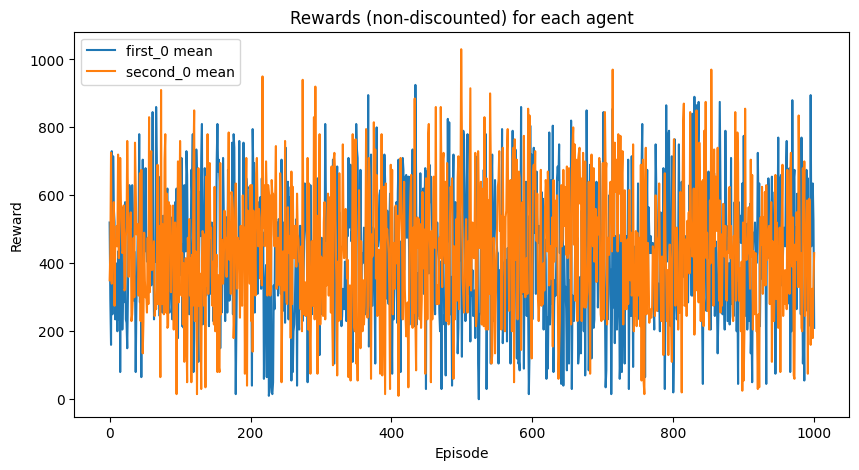

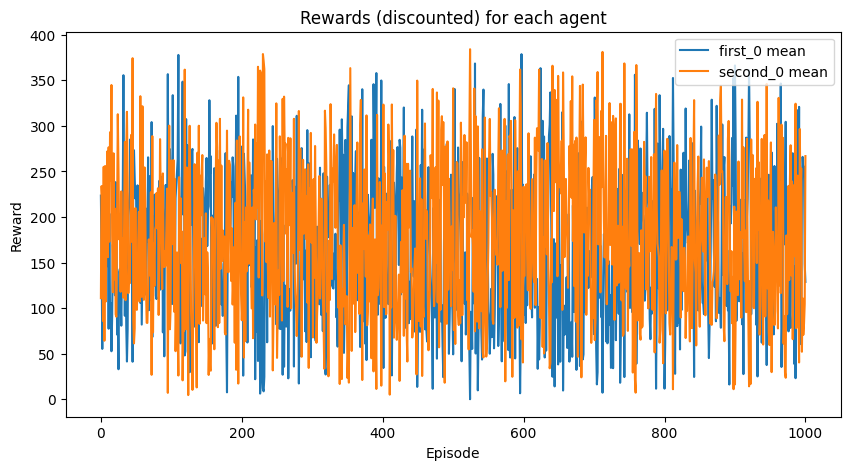

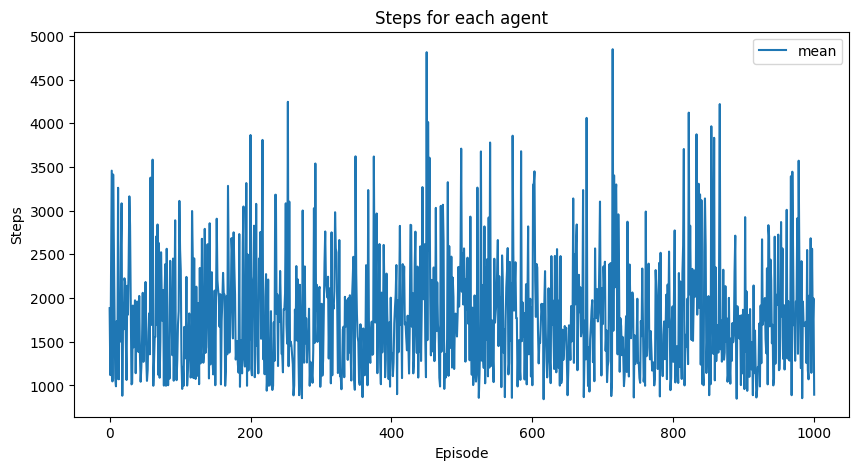

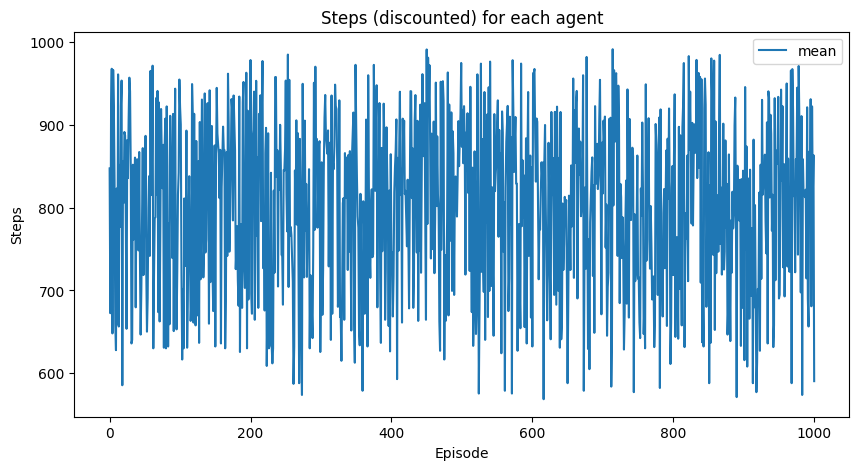

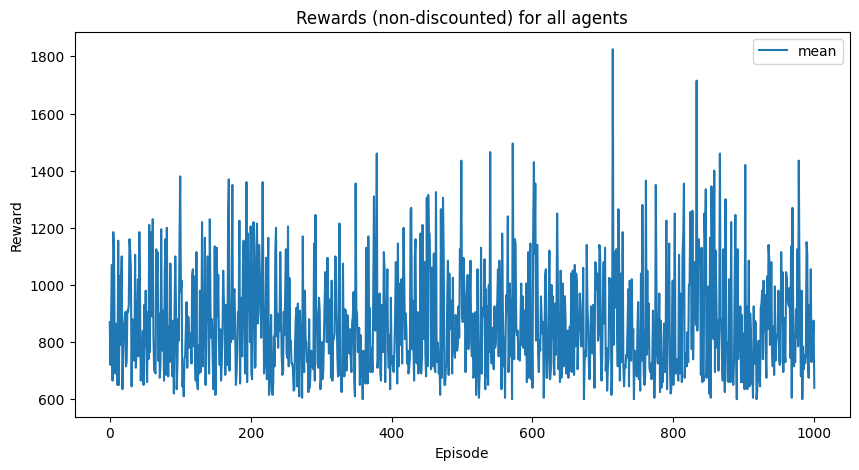

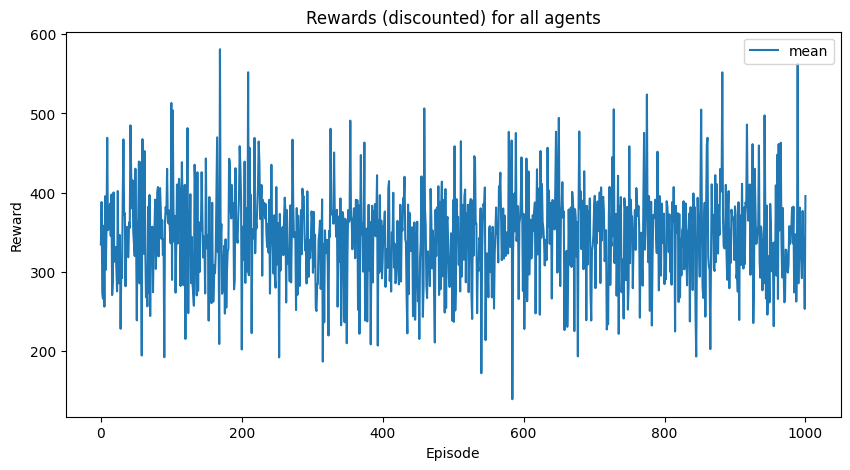

In [90]:
plot_graphs(ep_rewards_PPO, ep_rewards_d_PPO, ep_steps_PPO, ep_steps_d_PPO, ep_rewards_all_PPO, ep_rewards_d_all_PPO, agent_names, episode_count)

### Test the agent from the last experiment

In [127]:
episode_count = 100
gamma = 0.999

record_video = True #record video of the experiment every 100 episodes
game_name = 'SpaceInvaders-v2' #prefix for the video file name
video_prefix = f'videos/{game_name}_ex{i}_' #prefix for the video file name
filename1 = f"models/{game_name}_ex{i}_PPOid_eff_{effnet}_pre_{pretrained}_agent1.pt"
filename2 = f"models/{game_name}_ex{i}_PPOid_eff_{effnet}_pre_{pretrained}_agent2.pt"
path1 = os.path.join(os.getcwd(), filename1)
path2 = os.path.join(os.getcwd(), filename2)

env = space_invaders_v2.parallel_env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env = color_reduction_v0(env, 'full') #reduce the color space to grey scale
env = resize_v1(env, frame_size[0], frame_size[1]) #resize the frames to smaller size 
env = frame_stack_v1(env, stack_size=num_frames) #stack the frames to create a state

# Load the model
agent_network1 = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network1.load_state_dict(torch.load(path1))
agent_network2 = PPO_Agent(num_actions=num_actions, num_frames=num_frames, effnet=effnet, pretrained=pretrained).to(device)
agent_network2.load_state_dict(torch.load(path2))

ep_rewards_all_PPOidr, ep_rewards_d_all_PPOidr, ep_steps_PPOidr = render_policy_PPO_id(env, agent_network1, agent_network2, gamma, episode_count, device, record_video, video_prefix)

env.close()

Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
New max reward: 910.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test_max_reward_910.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
New max reward: 1065.0
Moving video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test_max_reward_1065.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
Recording video to /home/jwang185/COMP-579/RL-Project/videos/SpaceInvaders-v2_ex0__PPOid_test.avi
Recording video to /home/jwang185/COMP-579/RL-Pr

## Comparison plot of all agents results comparisons of 100 episodes in a bar chart

In [ ]:
#load the rewards from the numpy array QL and DQN
filename = f"rewards_array/ql_data.npy"
path = os.path.join(os.getcwd(), filename)
ql_data = np.load(path, allow_pickle=True)

ep_rewards_all_QLr = ql_data[0]
ep_rewards_d_all_QLr = ql_data[1]
ep_steps_QLr = ql_data[2]

filename = f"rewards_array/dqn_data.npy"
path = os.path.join(os.getcwd(), filename)
dqn_data = np.load(path, allow_pickle=True)

ep_rewards_all_DQNr = dqn_data[0]
ep_rewards_d_all_DQNr = dqn_data[1]
ep_steps_DQNr = dqn_data[2]

In [128]:
# #get the mean and standard deviation of all the arrays below
# ep_rewards_all_uni, ep_rewards_d_all_uni, ep_steps_uni
# ep_rewards_all_PPOr, ep_rewards_d_all_PPOr, ep_steps_PPOr
# ep_rewards_all_PPOidr, ep_rewards_d_all_PPOidr, ep_steps_PPOidr
# ep_rewards_all_MAPPOr, ep_rewards_d_all_MAPPOr, ep_steps_MAPPOr
# ep_rewards_all_MAPPO_SVr, ep_rewards_d_all_MAPPO_SVr, ep_steps_MAPPO_SVr
# ep_rewards_all_MAPPO_SVirr, ep_rewards_d_all_MAPPO_SVirr, ep_steps_MAPPO_SVirr

ep_rewards_all_QLr, ep_rewards_d_all_QLr, ep_steps_QLr = [0], [0], [0]
ep_rewards_all_DQNr, ep_rewards_d_all_DQNr, ep_steps_DQNr = [0], [0], [0]

mean_uni = np.mean(ep_rewards_all_uni)
std_uni = np.std(ep_rewards_all_uni)
mean_uni_d = np.mean(ep_rewards_d_all_uni)
std_uni_d = np.std(ep_rewards_d_all_uni)
mean_uni_s = np.mean(ep_steps_uni)
std_uni_s = np.std(ep_steps_uni)

mean_PPO = np.mean(ep_rewards_all_PPOr)
std_PPO = np.std(ep_rewards_all_PPOr)
mean_PPO_d = np.mean(ep_rewards_d_all_PPOr)
std_PPO_d = np.std(ep_rewards_d_all_PPOr)
mean_PPO_s = np.mean(ep_steps_PPOr)
std_PPO_s = np.std(ep_steps_PPOr)

mean_PPOid = np.mean(ep_rewards_all_PPOidr)
std_PPOid = np.std(ep_rewards_all_PPOidr)
mean_PPOid_d = np.mean(ep_rewards_d_all_PPOidr)
std_PPOid_d = np.std(ep_rewards_d_all_PPOidr)
mean_PPOid_s = np.mean(ep_steps_PPOidr)
std_PPOid_s = np.std(ep_steps_PPOidr)

mean_MAPPO = np.mean(ep_rewards_all_MAPPOr)
std_MAPPO = np.std(ep_rewards_all_MAPPOr)
mean_MAPPO_d = np.mean(ep_rewards_d_all_MAPPOr)
std_MAPPO_d = np.std(ep_rewards_d_all_MAPPOr)
mean_MAPPO_s = np.mean(ep_steps_MAPPOr)
std_MAPPO_s = np.std(ep_steps_MAPPOr)

mean_MAPPO_SV = np.mean(ep_rewards_all_MAPPO_SVr)
std_MAPPO_SV = np.std(ep_rewards_all_MAPPO_SVr)
mean_MAPPO_SV_d = np.mean(ep_rewards_d_all_MAPPO_SVr)
std_MAPPO_SV_d = np.std(ep_rewards_d_all_MAPPO_SVr)
mean_MAPPO_SV_s = np.mean(ep_steps_MAPPO_SVr)
std_MAPPO_SV_s = np.std(ep_steps_MAPPO_SVr)

mean_MAPPO_SVir = np.mean(ep_rewards_all_MAPPO_SVirr)
std_MAPPO_SVir = np.std(ep_rewards_all_MAPPO_SVirr)
mean_MAPPO_SVir_d = np.mean(ep_rewards_d_all_MAPPO_SVirr)
std_MAPPO_SVir_d = np.std(ep_rewards_d_all_MAPPO_SVirr)
mean_MAPPO_SVir_s = np.mean(ep_steps_MAPPO_SVirr)
std_MAPPO_SVir_s = np.std(ep_steps_MAPPO_SVirr)

mean_QL = np.mean(ep_rewards_all_QLr)
std_QL = np.std(ep_rewards_all_QLr)
mean_QL_d = np.mean(ep_rewards_d_all_QLr)
std_QL_d = np.std(ep_rewards_d_all_QLr)
mean_QL_s = np.mean(ep_steps_QLr)
std_QL_s = np.std(ep_steps_QLr)

mean_DQN = np.mean(ep_rewards_all_DQNr)
std_DQN = np.std(ep_rewards_all_DQNr)
mean_DQN_d = np.mean(ep_rewards_d_all_DQNr)
std_DQN_d = np.std(ep_rewards_d_all_DQNr)
mean_DQN_s = np.mean(ep_steps_DQNr)
std_DQN_s = np.std(ep_steps_DQNr)


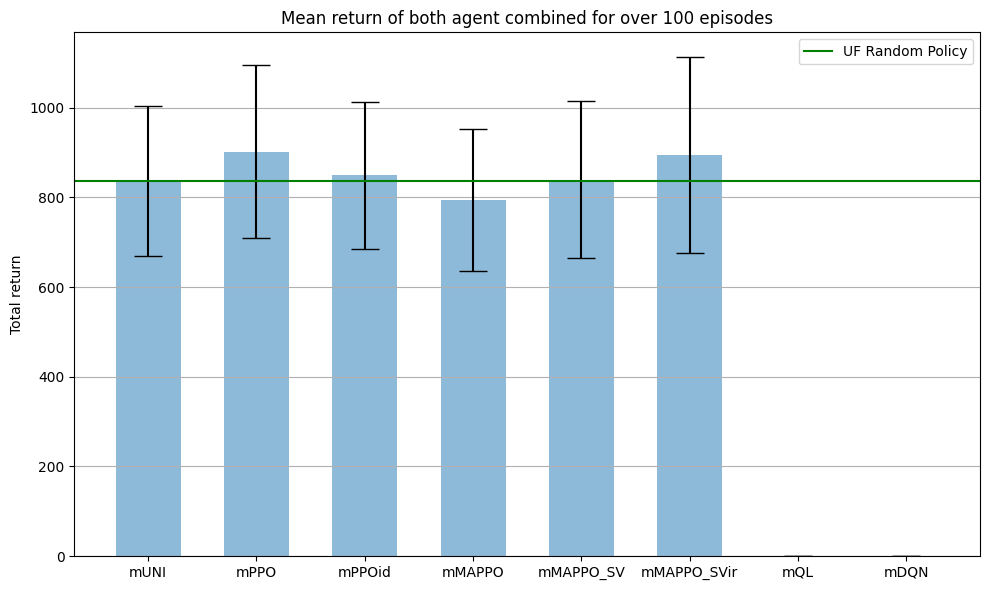

In [133]:
#Plot in a bar chart the mean and standard deviation of the rewards for each method calculated above
x_labels = ['mUNI', 'mPPO', 'mPPOid', "mMAPPO", "mMAPPO_SV", "mMAPPO_SVir", "mQL", "mDQN"]
means = [mean_uni, mean_PPO, mean_PPOid, mean_MAPPO, mean_MAPPO_SV, mean_MAPPO_SVir, mean_QL, mean_DQN]
stds = [std_uni, std_PPO, std_PPOid, std_MAPPO, std_MAPPO_SV, std_MAPPO_SVir, std_QL, std_DQN]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.6)
ax.set_ylabel('Total return')
ax.set_title('Mean return of both agent combined for over 100 episodes')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_uni, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()



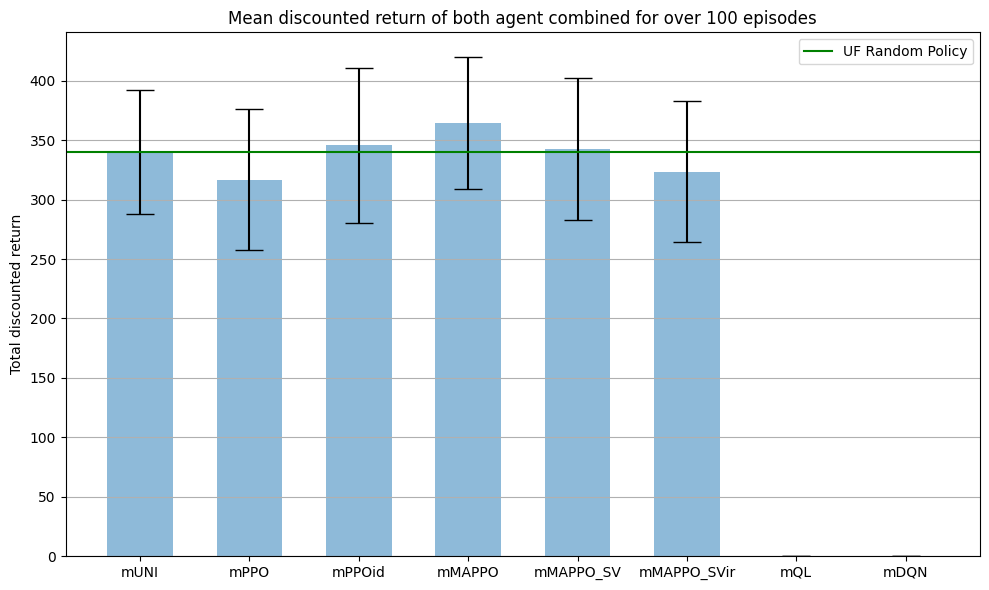

In [134]:
#Plot in a bar chart the mean and standard deviation of the discounted rewards for each method calculated above
x_labels = ['mUNI', 'mPPO', 'mPPOid', "mMAPPO", "mMAPPO_SV", "mMAPPO_SVir", "mQL", "mDQN"]
means = [mean_uni_d, mean_PPO_d, mean_PPOid_d, mean_MAPPO_d, mean_MAPPO_SV_d, mean_MAPPO_SVir_d, mean_QL_d, mean_DQN_d]
stds = [std_uni_d, std_PPO_d, std_PPOid_d, std_MAPPO_d, std_MAPPO_SV_d, std_MAPPO_SVir_d, std_QL_d, std_DQN_d]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.6)
ax.set_ylabel('Total discounted return')
ax.set_title('Mean discounted return of both agent combined for over 100 episodes')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_uni_d, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


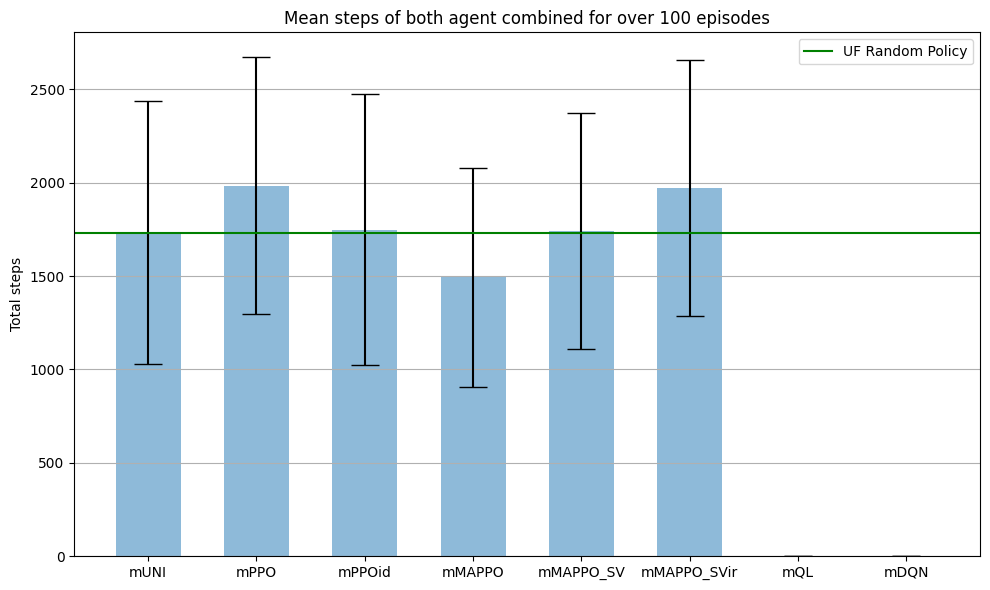

In [135]:
#Plot in a bar chart the mean and standard deviation of the steps for each method calculated above
x_labels = ['mUNI', 'mPPO', 'mPPOid', "mMAPPO", "mMAPPO_SV", "mMAPPO_SVir", "mQL", "mDQN"]
means = [mean_uni_s, mean_PPO_s, mean_PPOid_s, mean_MAPPO_s, mean_MAPPO_SV_s, mean_MAPPO_SVir_s, mean_QL_s, mean_DQN_s]
stds = [std_uni_s, std_PPO_s, std_PPOid_s, std_MAPPO_s, std_MAPPO_SV_s, std_MAPPO_SVir_s, std_QL_s, std_DQN_s]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.6)
ax.set_ylabel('Total steps')
ax.set_title('Mean steps of both agent combined for over 100 episodes')
ax.yaxis.grid(True)

# draw horizontal line at the mean of the expert data and uf random policy
plt.axhline(y=mean_uni_s, color='g', linestyle='-', label='UF Random Policy')

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


